In [1]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split
from torch.autograd import Variable
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split  
from torch.utils.tensorboard import SummaryWriter

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [2]:
class CustomDataset(Dataset):
    def __init__(self, file_path, x_size):
        df = pd.read_csv(file_path)

        self.x = df.iloc[x_size:, 6:10].values
        #self.x = np.reshape(x, (x.shape[0], 1, x.shape[1]))

        self.y = df.iloc[x_size:, 13:14].values
        
        self.length = len(df) - x_size

    #getitem이거 왜씀?
    def __getitem__(self, index):
        # x = torch.FloatTensor([self.x[index]])
        # y = torch.FloatTensor([self.y[index]])
        # return x, y
        feature = torch.FloatTensor([self.x[index]])
        label = torch.FloatTensor(self.y[index])

        return feature, label

    def __len__(self):
        return self.length

In [3]:
dataset_d = CustomDataset("DST_80.csv", 1919) #1919
dataset_f = CustomDataset("FUDS_80.csv", 2586) #2586
dataset_u = CustomDataset("US06_80.csv", 1207) #1207
print(dataset_d.x.shape)
print(dataset_d.y.shape)
print(dataset_f.x.shape)
print(dataset_f.y.shape)
print(dataset_u.x.shape)
print(dataset_u.y.shape)
print(dataset_d)
print(len(dataset_d))
print(len(dataset_f))
print(len(dataset_u))

(10639, 4)
(10639, 1)
(11095, 4)
(11095, 1)
(10690, 4)
(10690, 1)
10639
11095
10690


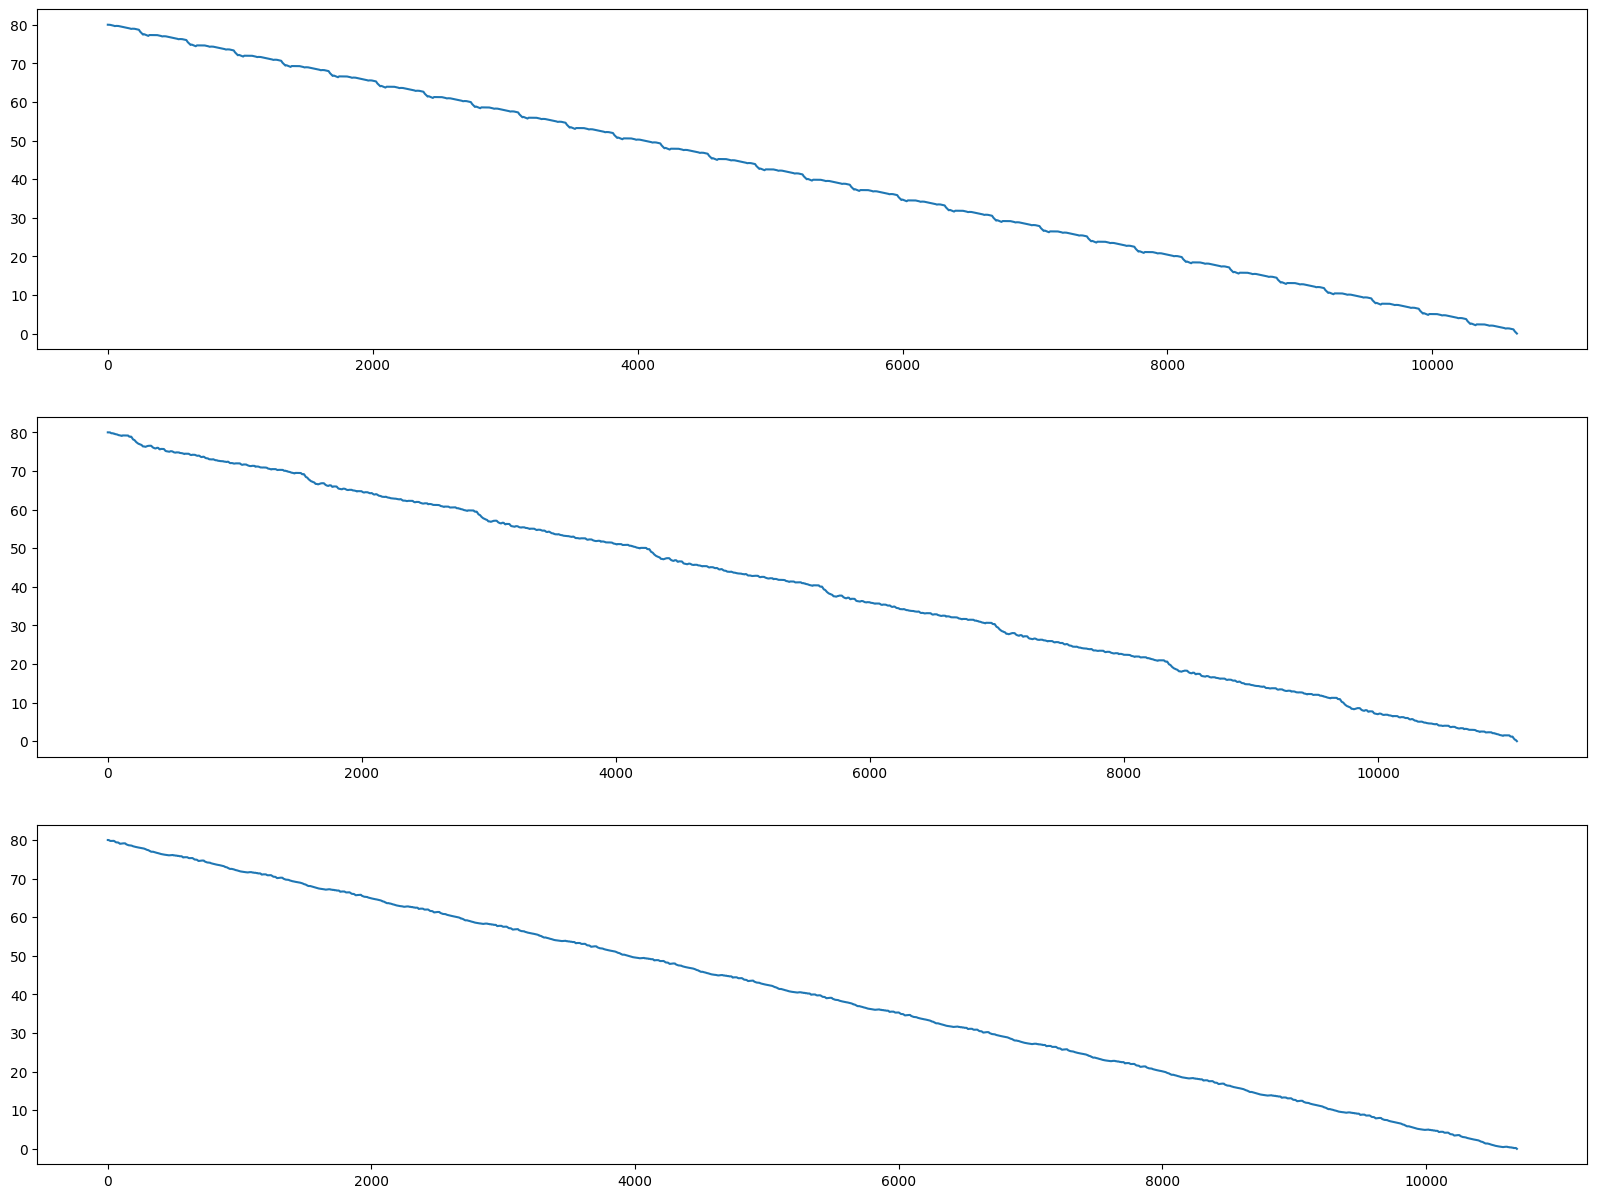

In [4]:
plt.figure(figsize=(20,15))
plt.subplot(3,1,1)
plt.plot(dataset_d.y)
plt.subplot(3,1,2)
plt.plot(dataset_f.y)
plt.subplot(3,1,3)
plt.plot(dataset_u.y)
plt.show()

In [5]:
dataset = torch.utils.data.ConcatDataset([dataset_d, dataset_f, dataset_u]) #x,y 어떻게된지 모름

train_dataset, test_dataset = random_split(dataset, [len(dataset_d)+len(dataset_f), len(dataset_u)])

In [6]:
print(len(dataset_d))
print(len(dataset_f))
print(len(dataset_u))
print(len(dataset_d)+len(dataset_f))

10639
11095
10690
21734


In [7]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=False, drop_last=False)
#validation_dataloader = DataLoader(validation_dataset, batch_size=16, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, drop_last=False)

In [8]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes 
        self.num_layers = num_layers 
        self.input_size = input_size 
        self.hidden_size = hidden_size 
        self.seq_length = seq_length 

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) 
        self.fc_1 =  nn.Linear(hidden_size, 128)
        self.batchnormal = nn.BatchNorm1d(128)
        self.fc = nn.Linear(128, num_classes) 

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) 
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) 
        
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) 
        hn = hn.view(-1, self.hidden_size) 
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

In [9]:
num_epochs = 2000
learning_rate = 0.001

input_size = 4
hidden_size = 64
num_layers = 1 

num_classes = 1

model = LSTM(num_classes, input_size, hidden_size, num_layers, 4)
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
def train_loop(model, dataloader, loss_func, optimizer):
    model.train()
    size = len(dataloader.dataset)
    print("Training")
    running_loss = 0.
    last_loss = 0.

    for batch, (x,y) in tqdm(enumerate(dataloader)):
        pred = model(x)
        loss = loss_func(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(x)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


In [11]:
def test_loop(model, dataloader, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for x, y in dataloader:
            pred = model(x)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [12]:
for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(model, train_dataloader, loss_func, optimizer)
    test_loop(model, test_dataloader, loss_func)
print("Done!")

Epoch 1
-------------------------------
Training


0it [00:00, ?it/s]C:\Users\USER\AppData\Local\Temp\ipykernel_17940\1241854177.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  feature = torch.FloatTensor([self.x[index]])
52it [00:00, 519.19it/s]

loss: 1867.399170  [   16/21734]
loss: 721.508789  [ 1616/21734]


188it [00:00, 639.11it/s]

loss: 467.804382  [ 3216/21734]


329it [00:00, 670.96it/s]

loss: 468.549866  [ 4816/21734]


397it [00:00, 668.28it/s]

loss: 109.652916  [ 6416/21734]


470it [00:00, 687.54it/s]

loss: 3.048109  [ 8016/21734]


610it [00:00, 691.02it/s]

loss: 1.574408  [ 9616/21734]


680it [00:01, 686.44it/s]

loss: 1.514026  [11216/21734]


749it [00:01, 685.53it/s]

loss: 0.900405  [12816/21734]


885it [00:01, 648.48it/s]

loss: 1.147689  [14416/21734]


951it [00:01, 642.17it/s]

loss: 0.681312  [16016/21734]


1082it [00:01, 639.22it/s]

loss: 0.875509  [17616/21734]


1147it [00:01, 617.89it/s]

loss: 0.927043  [19216/21734]


1274it [00:01, 622.92it/s]

loss: 0.870304  [20816/21734]


1359it [00:02, 645.68it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.863616 

Epoch 2
-------------------------------
Training


65it [00:00, 649.80it/s]

loss: 0.724329  [   16/21734]
loss: 0.721330  [ 1616/21734]


324it [00:00, 613.53it/s]

loss: 0.403254  [ 3216/21734]
loss: 0.533406  [ 4816/21734]


514it [00:00, 619.51it/s]

loss: 0.901419  [ 6416/21734]
loss: 1.235059  [ 8016/21734]


708it [00:01, 634.58it/s]

loss: 1.050639  [ 9616/21734]
loss: 1.076115  [11216/21734]


904it [00:01, 642.34it/s]

loss: 0.807497  [12816/21734]
loss: 1.329415  [14416/21734]


1098it [00:01, 636.53it/s]

loss: 0.565322  [16016/21734]
loss: 0.920520  [17616/21734]


1292it [00:02, 636.99it/s]

loss: 0.942856  [19216/21734]
loss: 1.200155  [20816/21734]


1359it [00:02, 629.35it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.825174 

Epoch 3
-------------------------------
Training


64it [00:00, 635.15it/s]

loss: 0.700079  [   16/21734]
loss: 0.572722  [ 1616/21734]


265it [00:00, 647.17it/s]

loss: 0.372338  [ 3216/21734]
loss: 0.554262  [ 4816/21734]


459it [00:00, 631.04it/s]

loss: 0.880819  [ 6416/21734]
loss: 1.205961  [ 8016/21734]


719it [00:01, 636.50it/s]

loss: 1.016713  [ 9616/21734]
loss: 1.034972  [11216/21734]


912it [00:01, 637.41it/s]

loss: 0.876268  [12816/21734]
loss: 1.297351  [14416/21734]


1104it [00:01, 629.18it/s]

loss: 0.737801  [16016/21734]
loss: 0.907371  [17616/21734]


1296it [00:02, 630.25it/s]

loss: 1.189935  [19216/21734]
loss: 0.813983  [20816/21734]


1359it [00:02, 630.72it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.784132 

Epoch 4
-------------------------------
Training


63it [00:00, 630.00it/s]

loss: 0.745185  [   16/21734]
loss: 0.631934  [ 1616/21734]


325it [00:00, 650.91it/s]

loss: 0.349567  [ 3216/21734]
loss: 0.611522  [ 4816/21734]


456it [00:00, 640.34it/s]

loss: 0.861812  [ 6416/21734]
loss: 1.208878  [ 8016/21734]


717it [00:01, 642.49it/s]

loss: 0.973502  [ 9616/21734]
loss: 1.006806  [11216/21734]


914it [00:01, 644.48it/s]

loss: 0.924277  [12816/21734]
loss: 1.234566  [14416/21734]


1109it [00:01, 643.17it/s]

loss: 0.782209  [16016/21734]
loss: 0.893155  [17616/21734]


1305it [00:02, 646.05it/s]

loss: 1.575950  [19216/21734]
loss: 0.817953  [20816/21734]


1359it [00:02, 644.09it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.790798 

Epoch 5
-------------------------------
Training


62it [00:00, 610.39it/s]

loss: 0.706635  [   16/21734]
loss: 0.844440  [ 1616/21734]


255it [00:00, 633.81it/s]

loss: 0.498148  [ 3216/21734]
loss: 0.594144  [ 4816/21734]


518it [00:00, 651.33it/s]

loss: 0.844454  [ 6416/21734]
loss: 1.183616  [ 8016/21734]


716it [00:01, 646.45it/s]

loss: 0.848469  [ 9616/21734]
loss: 1.022274  [11216/21734]


911it [00:01, 637.70it/s]

loss: 0.956166  [12816/21734]
loss: 1.134817  [14416/21734]


1109it [00:01, 648.07it/s]

loss: 0.789293  [16016/21734]
loss: 0.846115  [17616/21734]


1308it [00:02, 650.36it/s]

loss: 1.652101  [19216/21734]
loss: 0.804563  [20816/21734]


1359it [00:02, 643.55it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.792362 

Epoch 6
-------------------------------
Training


66it [00:00, 653.47it/s]

loss: 0.669206  [   16/21734]
loss: 0.956792  [ 1616/21734]


263it [00:00, 647.17it/s]

loss: 0.536394  [ 3216/21734]
loss: 0.553797  [ 4816/21734]


524it [00:00, 634.40it/s]

loss: 0.818031  [ 6416/21734]
loss: 1.202275  [ 8016/21734]


656it [00:01, 640.71it/s]

loss: 0.707752  [ 9616/21734]
loss: 1.004880  [11216/21734]


915it [00:01, 635.60it/s]

loss: 0.986245  [12816/21734]
loss: 1.113980  [14416/21734]


1109it [00:01, 637.93it/s]

loss: 0.714849  [16016/21734]
loss: 0.783542  [17616/21734]


1303it [00:02, 636.07it/s]

loss: 1.512005  [19216/21734]
loss: 0.774945  [20816/21734]


1359it [00:02, 634.16it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.764016 

Epoch 7
-------------------------------
Training


68it [00:00, 677.03it/s]

loss: 0.663599  [   16/21734]
loss: 1.013875  [ 1616/21734]


270it [00:00, 653.02it/s]

loss: 0.540247  [ 3216/21734]
loss: 0.518115  [ 4816/21734]


466it [00:00, 638.91it/s]

loss: 0.793597  [ 6416/21734]
loss: 1.233125  [ 8016/21734]


729it [00:01, 648.84it/s]

loss: 0.637602  [ 9616/21734]
loss: 1.030738  [11216/21734]


859it [00:01, 643.71it/s]

loss: 0.894095  [12816/21734]
loss: 1.126392  [14416/21734]


1118it [00:01, 641.06it/s]

loss: 0.702840  [16016/21734]
loss: 0.755222  [17616/21734]


1319it [00:02, 655.22it/s]

loss: 1.404322  [19216/21734]
loss: 0.735343  [20816/21734]


1359it [00:02, 646.85it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.735160 

Epoch 8
-------------------------------
Training


132it [00:00, 641.70it/s]

loss: 0.644430  [   16/21734]
loss: 0.926034  [ 1616/21734]


260it [00:00, 625.16it/s]

loss: 0.523661  [ 3216/21734]
loss: 0.469209  [ 4816/21734]


524it [00:00, 650.18it/s]

loss: 0.762389  [ 6416/21734]
loss: 1.221985  [ 8016/21734]


655it [00:01, 617.84it/s]

loss: 0.594972  [ 9616/21734]
loss: 1.018753  [11216/21734]


915it [00:01, 637.21it/s]

loss: 0.818289  [12816/21734]
loss: 1.124321  [14416/21734]


1112it [00:01, 641.39it/s]

loss: 0.695854  [16016/21734]
loss: 0.745436  [17616/21734]


1310it [00:02, 647.15it/s]

loss: 1.286758  [19216/21734]
loss: 0.717506  [20816/21734]


1359it [00:02, 638.41it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.699326 

Epoch 9
-------------------------------
Training


67it [00:00, 665.69it/s]

loss: 0.619922  [   16/21734]
loss: 0.882715  [ 1616/21734]


264it [00:00, 637.36it/s]

loss: 0.497418  [ 3216/21734]
loss: 0.423213  [ 4816/21734]


522it [00:00, 639.75it/s]

loss: 0.741830  [ 6416/21734]
loss: 1.182684  [ 8016/21734]


718it [00:01, 641.68it/s]

loss: 0.556194  [ 9616/21734]
loss: 0.940341  [11216/21734]


914it [00:01, 644.27it/s]

loss: 0.795298  [12816/21734]
loss: 1.098977  [14416/21734]


1109it [00:01, 636.25it/s]

loss: 0.697562  [16016/21734]
loss: 0.633492  [17616/21734]


1305it [00:02, 639.02it/s]

loss: 1.105657  [19216/21734]
loss: 0.662465  [20816/21734]


1359it [00:02, 641.36it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.646035 

Epoch 10
-------------------------------
Training


63it [00:00, 622.45it/s]

loss: 0.591357  [   16/21734]
loss: 0.748295  [ 1616/21734]


326it [00:00, 652.57it/s]

loss: 0.434512  [ 3216/21734]
loss: 0.379704  [ 4816/21734]


457it [00:00, 639.01it/s]

loss: 0.683806  [ 6416/21734]
loss: 1.092540  [ 8016/21734]


719it [00:01, 628.20it/s]

loss: 0.469313  [ 9616/21734]
loss: 0.919184  [11216/21734]


916it [00:01, 640.19it/s]

loss: 0.798731  [12816/21734]
loss: 1.016699  [14416/21734]


1047it [00:01, 633.71it/s]

loss: 0.600317  [16016/21734]
loss: 0.578366  [17616/21734]


1309it [00:02, 644.64it/s]

loss: 0.872545  [19216/21734]
loss: 0.592374  [20816/21734]


1359it [00:02, 636.91it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.575735 

Epoch 11
-------------------------------
Training


64it [00:00, 634.37it/s]

loss: 0.587401  [   16/21734]
loss: 0.593966  [ 1616/21734]


263it [00:00, 653.84it/s]

loss: 0.416228  [ 3216/21734]
loss: 0.337154  [ 4816/21734]


460it [00:00, 631.24it/s]

loss: 0.588669  [ 6416/21734]
loss: 1.018908  [ 8016/21734]


718it [00:01, 634.36it/s]

loss: 0.398098  [ 9616/21734]
loss: 0.818072  [11216/21734]


911it [00:01, 628.73it/s]

loss: 0.772067  [12816/21734]
loss: 0.837806  [14416/21734]


1106it [00:01, 636.16it/s]

loss: 0.512991  [16016/21734]
loss: 0.464980  [17616/21734]


1297it [00:02, 629.64it/s]

loss: 0.586383  [19216/21734]
loss: 0.463960  [20816/21734]


1359it [00:02, 633.94it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.504278 

Epoch 12
-------------------------------
Training


64it [00:00, 630.53it/s]

loss: 0.482936  [   16/21734]
loss: 0.530752  [ 1616/21734]


323it [00:00, 633.71it/s]

loss: 0.311870  [ 3216/21734]
loss: 0.310506  [ 4816/21734]


516it [00:00, 629.63it/s]

loss: 0.521926  [ 6416/21734]
loss: 0.954095  [ 8016/21734]


713it [00:01, 644.43it/s]

loss: 0.351951  [ 9616/21734]
loss: 0.517222  [11216/21734]


903it [00:01, 614.95it/s]

loss: 0.650622  [12816/21734]
loss: 0.608676  [14416/21734]


1092it [00:01, 623.55it/s]

loss: 0.316797  [16016/21734]
loss: 0.350220  [17616/21734]


1282it [00:02, 625.36it/s]

loss: 0.485123  [19216/21734]
loss: 0.321669  [20816/21734]


1359it [00:02, 625.75it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.438371 

Epoch 13
-------------------------------
Training


128it [00:00, 633.18it/s]

loss: 0.353628  [   16/21734]
loss: 0.365346  [ 1616/21734]


321it [00:00, 627.40it/s]

loss: 0.160625  [ 3216/21734]
loss: 0.270829  [ 4816/21734]


511it [00:00, 626.18it/s]

loss: 0.431372  [ 6416/21734]
loss: 0.782266  [ 8016/21734]


701it [00:01, 624.63it/s]

loss: 0.211680  [ 9616/21734]
loss: 0.363546  [11216/21734]


891it [00:01, 624.76it/s]

loss: 0.418565  [12816/21734]
loss: 0.368887  [14416/21734]


1081it [00:01, 628.45it/s]

loss: 0.253480  [16016/21734]
loss: 0.294236  [17616/21734]


1270it [00:02, 624.66it/s]

loss: 0.307672  [19216/21734]
loss: 0.419111  [20816/21734]


1359it [00:02, 625.06it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.293702 

Epoch 14
-------------------------------
Training


64it [00:00, 628.24it/s]

loss: 0.263841  [   16/21734]
loss: 0.162697  [ 1616/21734]


322it [00:00, 621.31it/s]

loss: 0.105914  [ 3216/21734]
loss: 0.280240  [ 4816/21734]


511it [00:00, 612.60it/s]

loss: 0.251007  [ 6416/21734]
loss: 0.500720  [ 8016/21734]


702it [00:01, 617.01it/s]

loss: 0.152756  [ 9616/21734]
loss: 0.294363  [11216/21734]


889it [00:01, 610.26it/s]

loss: 0.287302  [12816/21734]
loss: 0.206859  [14416/21734]


1080it [00:01, 621.83it/s]

loss: 0.195734  [16016/21734]
loss: 0.134506  [17616/21734]


1271it [00:02, 620.47it/s]

loss: 0.127898  [19216/21734]
loss: 0.224638  [20816/21734]


1359it [00:02, 619.14it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.198670 

Epoch 15
-------------------------------
Training


63it [00:00, 624.94it/s]

loss: 0.179320  [   16/21734]
loss: 0.110695  [ 1616/21734]


313it [00:00, 613.42it/s]

loss: 0.094434  [ 3216/21734]
loss: 0.144320  [ 4816/21734]


507it [00:00, 634.18it/s]

loss: 0.144252  [ 6416/21734]
loss: 0.183852  [ 8016/21734]


700it [00:01, 631.54it/s]

loss: 0.128367  [ 9616/21734]
loss: 0.143169  [11216/21734]


893it [00:01, 629.60it/s]

loss: 0.128393  [12816/21734]
loss: 0.132649  [14416/21734]


1087it [00:01, 635.92it/s]

loss: 0.156944  [16016/21734]
loss: 0.095205  [17616/21734]


1280it [00:02, 634.26it/s]

loss: 0.064140  [19216/21734]
loss: 0.102901  [20816/21734]


1359it [00:02, 629.87it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.154421 

Epoch 16
-------------------------------
Training


50it [00:00, 497.47it/s]

loss: 0.120594  [   16/21734]
loss: 0.107887  [ 1616/21734]


299it [00:00, 602.10it/s]

loss: 0.043291  [ 3216/21734]
loss: 0.077572  [ 4816/21734]


491it [00:00, 627.26it/s]

loss: 0.083751  [ 6416/21734]
loss: 0.137713  [ 8016/21734]


688it [00:01, 639.92it/s]

loss: 0.078774  [ 9616/21734]
loss: 0.050281  [11216/21734]


882it [00:01, 638.09it/s]

loss: 0.095045  [12816/21734]
loss: 0.071389  [14416/21734]


1075it [00:01, 636.78it/s]

loss: 0.153907  [16016/21734]
loss: 0.044776  [17616/21734]


1268it [00:02, 637.76it/s]

loss: 0.030276  [19216/21734]
loss: 0.021352  [20816/21734]


1359it [00:02, 624.16it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.279292 

Epoch 17
-------------------------------
Training


130it [00:00, 639.44it/s]

loss: 0.222453  [   16/21734]
loss: 0.160422  [ 1616/21734]


261it [00:00, 632.41it/s]

loss: 0.018231  [ 3216/21734]
loss: 0.038727  [ 4816/21734]


515it [00:00, 623.58it/s]

loss: 0.040047  [ 6416/21734]
loss: 0.049286  [ 8016/21734]


704it [00:01, 616.82it/s]

loss: 0.042625  [ 9616/21734]
loss: 0.031630  [11216/21734]


896it [00:01, 629.80it/s]

loss: 0.062278  [12816/21734]
loss: 0.058812  [14416/21734]


1088it [00:01, 632.68it/s]

loss: 0.116961  [16016/21734]
loss: 0.019077  [17616/21734]


1279it [00:02, 621.55it/s]

loss: 0.037695  [19216/21734]
loss: 0.020291  [20816/21734]


1359it [00:02, 619.99it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.059419 

Epoch 18
-------------------------------
Training


64it [00:00, 630.07it/s]

loss: 0.044998  [   16/21734]
loss: 0.101352  [ 1616/21734]


322it [00:00, 622.92it/s]

loss: 0.007383  [ 3216/21734]
loss: 0.028579  [ 4816/21734]


511it [00:00, 618.87it/s]

loss: 0.033233  [ 6416/21734]
loss: 0.021934  [ 8016/21734]


702it [00:01, 627.74it/s]

loss: 0.040464  [ 9616/21734]
loss: 0.035463  [11216/21734]


892it [00:01, 626.88it/s]

loss: 0.036047  [12816/21734]
loss: 0.016842  [14416/21734]


1083it [00:01, 624.99it/s]

loss: 0.138824  [16016/21734]
loss: 0.013306  [17616/21734]


1271it [00:02, 614.32it/s]

loss: 0.029982  [19216/21734]
loss: 0.053481  [20816/21734]


1359it [00:02, 621.06it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.042065 

Epoch 19
-------------------------------
Training


66it [00:00, 649.92it/s]

loss: 0.037893  [   16/21734]
loss: 0.032000  [ 1616/21734]


324it [00:00, 618.51it/s]

loss: 0.007553  [ 3216/21734]
loss: 0.027746  [ 4816/21734]


510it [00:00, 612.29it/s]

loss: 0.021247  [ 6416/21734]
loss: 0.019921  [ 8016/21734]


697it [00:01, 614.32it/s]

loss: 0.036278  [ 9616/21734]
loss: 0.028861  [11216/21734]


885it [00:01, 617.91it/s]

loss: 0.025260  [12816/21734]
loss: 0.014296  [14416/21734]


1076it [00:01, 607.35it/s]

loss: 0.144897  [16016/21734]
loss: 0.013528  [17616/21734]


1265it [00:02, 619.00it/s]

loss: 0.031883  [19216/21734]
loss: 0.032629  [20816/21734]


1359it [00:02, 616.96it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.035524 

Epoch 20
-------------------------------
Training


62it [00:00, 611.48it/s]

loss: 0.021592  [   16/21734]
loss: 0.032279  [ 1616/21734]


313it [00:00, 616.75it/s]

loss: 0.006072  [ 3216/21734]
loss: 0.023146  [ 4816/21734]


501it [00:00, 622.21it/s]

loss: 0.025808  [ 6416/21734]
loss: 0.021763  [ 8016/21734]


691it [00:01, 625.25it/s]

loss: 0.041836  [ 9616/21734]
loss: 0.018880  [11216/21734]


881it [00:01, 614.83it/s]

loss: 0.019866  [12816/21734]
loss: 0.019172  [14416/21734]


1068it [00:01, 599.50it/s]

loss: 0.123306  [16016/21734]
loss: 0.013480  [17616/21734]


1249it [00:02, 588.13it/s]

loss: 0.029233  [19216/21734]
loss: 0.029240  [20816/21734]


1359it [00:02, 605.76it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.054927 

Epoch 21
-------------------------------
Training


59it [00:00, 579.60it/s]

loss: 0.039038  [   16/21734]
loss: 0.037932  [ 1616/21734]


307it [00:00, 593.63it/s]

loss: 0.006973  [ 3216/21734]
loss: 0.024260  [ 4816/21734]


494it [00:00, 614.09it/s]

loss: 0.032837  [ 6416/21734]
loss: 0.025333  [ 8016/21734]


683it [00:01, 620.45it/s]

loss: 0.039224  [ 9616/21734]
loss: 0.019742  [11216/21734]


874it [00:01, 617.78it/s]

loss: 0.029830  [12816/21734]
loss: 0.018675  [14416/21734]


1064it [00:01, 625.05it/s]

loss: 0.135694  [16016/21734]
loss: 0.014601  [17616/21734]


1256it [00:02, 630.72it/s]

loss: 0.029296  [19216/21734]
loss: 0.023677  [20816/21734]


1359it [00:02, 613.93it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.054473 

Epoch 22
-------------------------------
Training


62it [00:00, 612.04it/s]

loss: 0.039923  [   16/21734]
loss: 0.041896  [ 1616/21734]


323it [00:00, 626.25it/s]

loss: 0.005867  [ 3216/21734]
loss: 0.025680  [ 4816/21734]


512it [00:00, 613.94it/s]

loss: 0.046990  [ 6416/21734]
loss: 0.029044  [ 8016/21734]


702it [00:01, 617.67it/s]

loss: 0.037412  [ 9616/21734]
loss: 0.017056  [11216/21734]


897it [00:01, 631.55it/s]

loss: 0.033563  [12816/21734]
loss: 0.017806  [14416/21734]


1091it [00:01, 631.48it/s]

loss: 0.131112  [16016/21734]
loss: 0.013643  [17616/21734]


1282it [00:02, 604.79it/s]

loss: 0.030061  [19216/21734]
loss: 0.022667  [20816/21734]


1359it [00:02, 621.11it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.051588 

Epoch 23
-------------------------------
Training


63it [00:00, 617.66it/s]

loss: 0.038275  [   16/21734]
loss: 0.041775  [ 1616/21734]


256it [00:00, 619.44it/s]

loss: 0.006406  [ 3216/21734]
loss: 0.021821  [ 4816/21734]


505it [00:00, 596.28it/s]

loss: 0.049048  [ 6416/21734]
loss: 0.032336  [ 8016/21734]


694it [00:01, 616.91it/s]

loss: 0.036179  [ 9616/21734]
loss: 0.017825  [11216/21734]


879it [00:01, 599.87it/s]

loss: 0.035343  [12816/21734]
loss: 0.015811  [14416/21734]


1066it [00:01, 614.56it/s]

loss: 0.143187  [16016/21734]
loss: 0.014991  [17616/21734]


1255it [00:02, 617.24it/s]

loss: 0.025521  [19216/21734]
loss: 0.024129  [20816/21734]


1359it [00:02, 611.31it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.046716 

Epoch 24
-------------------------------
Training


63it [00:00, 621.19it/s]

loss: 0.033526  [   16/21734]
loss: 0.043557  [ 1616/21734]


257it [00:00, 634.51it/s]

loss: 0.005659  [ 3216/21734]
loss: 0.022055  [ 4816/21734]


513it [00:00, 638.36it/s]

loss: 0.046070  [ 6416/21734]
loss: 0.030069  [ 8016/21734]


705it [00:01, 634.26it/s]

loss: 0.033846  [ 9616/21734]
loss: 0.017433  [11216/21734]


898it [00:01, 635.42it/s]

loss: 0.019513  [12816/21734]
loss: 0.017434  [14416/21734]


1089it [00:01, 611.14it/s]

loss: 0.155445  [16016/21734]
loss: 0.015353  [17616/21734]


1283it [00:02, 630.00it/s]

loss: 0.023928  [19216/21734]
loss: 0.021552  [20816/21734]


1359it [00:02, 629.30it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.042745 

Epoch 25
-------------------------------
Training


61it [00:00, 609.80it/s]

loss: 0.029947  [   16/21734]
loss: 0.049869  [ 1616/21734]


315it [00:00, 616.90it/s]

loss: 0.006098  [ 3216/21734]
loss: 0.021323  [ 4816/21734]


510it [00:00, 638.22it/s]

loss: 0.055419  [ 6416/21734]
loss: 0.030603  [ 8016/21734]


702it [00:01, 629.19it/s]

loss: 0.032521  [ 9616/21734]
loss: 0.014505  [11216/21734]


892it [00:01, 619.14it/s]

loss: 0.015215  [12816/21734]
loss: 0.010597  [14416/21734]


1080it [00:01, 621.11it/s]

loss: 0.168850  [16016/21734]
loss: 0.013596  [17616/21734]


1272it [00:02, 628.67it/s]

loss: 0.026117  [19216/21734]
loss: 0.018614  [20816/21734]


1359it [00:02, 624.33it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.039167 

Epoch 26
-------------------------------
Training


62it [00:00, 611.85it/s]

loss: 0.027678  [   16/21734]
loss: 0.048913  [ 1616/21734]


313it [00:00, 612.25it/s]

loss: 0.006942  [ 3216/21734]
loss: 0.021473  [ 4816/21734]


501it [00:00, 589.47it/s]

loss: 0.059048  [ 6416/21734]
loss: 0.033413  [ 8016/21734]


690it [00:01, 614.39it/s]

loss: 0.036105  [ 9616/21734]
loss: 0.013041  [11216/21734]


882it [00:01, 626.28it/s]

loss: 0.013613  [12816/21734]
loss: 0.009199  [14416/21734]


1070it [00:01, 617.45it/s]

loss: 0.161421  [16016/21734]
loss: 0.009216  [17616/21734]


1326it [00:02, 629.39it/s]

loss: 0.028768  [19216/21734]
loss: 0.016831  [20816/21734]


1359it [00:02, 613.38it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.036193 

Epoch 27
-------------------------------
Training


122it [00:00, 605.64it/s]

loss: 0.025459  [   16/21734]
loss: 0.047013  [ 1616/21734]


311it [00:00, 620.59it/s]

loss: 0.007000  [ 3216/21734]
loss: 0.021181  [ 4816/21734]


501it [00:00, 626.45it/s]

loss: 0.063304  [ 6416/21734]
loss: 0.034864  [ 8016/21734]


695it [00:01, 635.05it/s]

loss: 0.033200  [ 9616/21734]
loss: 0.011586  [11216/21734]


889it [00:01, 639.38it/s]

loss: 0.013439  [12816/21734]
loss: 0.008579  [14416/21734]


1085it [00:01, 639.11it/s]

loss: 0.159842  [16016/21734]
loss: 0.008240  [17616/21734]


1275it [00:02, 615.97it/s]

loss: 0.027145  [19216/21734]
loss: 0.014975  [20816/21734]


1359it [00:02, 623.03it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.029644 

Epoch 28
-------------------------------
Training


66it [00:00, 659.47it/s]

loss: 0.020418  [   16/21734]
loss: 0.050793  [ 1616/21734]


325it [00:00, 634.91it/s]

loss: 0.007837  [ 3216/21734]
loss: 0.021028  [ 4816/21734]


518it [00:00, 633.71it/s]

loss: 0.061908  [ 6416/21734]
loss: 0.033709  [ 8016/21734]


715it [00:01, 639.29it/s]

loss: 0.035283  [ 9616/21734]
loss: 0.010651  [11216/21734]


906it [00:01, 625.99it/s]

loss: 0.012772  [12816/21734]
loss: 0.008100  [14416/21734]


1097it [00:01, 628.19it/s]

loss: 0.155223  [16016/21734]
loss: 0.007601  [17616/21734]


1290it [00:02, 636.29it/s]

loss: 0.025612  [19216/21734]
loss: 0.013405  [20816/21734]


1359it [00:02, 630.41it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.026979 

Epoch 29
-------------------------------
Training


63it [00:00, 624.38it/s]

loss: 0.018499  [   16/21734]
loss: 0.060479  [ 1616/21734]


320it [00:00, 633.39it/s]

loss: 0.008257  [ 3216/21734]
loss: 0.016793  [ 4816/21734]


511it [00:00, 619.37it/s]

loss: 0.064087  [ 6416/21734]
loss: 0.040651  [ 8016/21734]


708it [00:01, 641.60it/s]

loss: 0.036284  [ 9616/21734]
loss: 0.010362  [11216/21734]


904it [00:01, 639.39it/s]

loss: 0.015189  [12816/21734]
loss: 0.007736  [14416/21734]


1098it [00:01, 635.03it/s]

loss: 0.152972  [16016/21734]
loss: 0.007511  [17616/21734]


1290it [00:02, 629.76it/s]

loss: 0.023735  [19216/21734]
loss: 0.011509  [20816/21734]


1359it [00:02, 631.19it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.025304 

Epoch 30
-------------------------------
Training


63it [00:00, 623.62it/s]

loss: 0.017117  [   16/21734]
loss: 0.056507  [ 1616/21734]


256it [00:00, 627.45it/s]

loss: 0.011124  [ 3216/21734]
loss: 0.017391  [ 4816/21734]


517it [00:00, 637.63it/s]

loss: 0.069858  [ 6416/21734]
loss: 0.044282  [ 8016/21734]


710it [00:01, 629.78it/s]

loss: 0.032084  [ 9616/21734]
loss: 0.010685  [11216/21734]


903it [00:01, 629.89it/s]

loss: 0.015323  [12816/21734]
loss: 0.008255  [14416/21734]


1094it [00:01, 611.29it/s]

loss: 0.142990  [16016/21734]
loss: 0.007431  [17616/21734]


1284it [00:02, 613.51it/s]

loss: 0.024422  [19216/21734]
loss: 0.010734  [20816/21734]


1359it [00:02, 623.89it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.022117 

Epoch 31
-------------------------------
Training


64it [00:00, 638.53it/s]

loss: 0.013896  [   16/21734]
loss: 0.060289  [ 1616/21734]


256it [00:00, 632.80it/s]

loss: 0.015879  [ 3216/21734]
loss: 0.017230  [ 4816/21734]


514it [00:00, 637.52it/s]

loss: 0.067231  [ 6416/21734]
loss: 0.050829  [ 8016/21734]


709it [00:01, 630.29it/s]

loss: 0.031574  [ 9616/21734]
loss: 0.010172  [11216/21734]


898it [00:01, 615.54it/s]

loss: 0.015313  [12816/21734]
loss: 0.008645  [14416/21734]


1089it [00:01, 627.00it/s]

loss: 0.140575  [16016/21734]
loss: 0.008306  [17616/21734]


1283it [00:02, 637.41it/s]

loss: 0.025950  [19216/21734]
loss: 0.009551  [20816/21734]


1359it [00:02, 630.73it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.020896 

Epoch 32
-------------------------------
Training


62it [00:00, 619.41it/s]

loss: 0.012504  [   16/21734]
loss: 0.056447  [ 1616/21734]


318it [00:00, 614.45it/s]

loss: 0.018991  [ 3216/21734]
loss: 0.016724  [ 4816/21734]


515it [00:00, 640.04it/s]

loss: 0.066116  [ 6416/21734]
loss: 0.057871  [ 8016/21734]


709it [00:01, 638.37it/s]

loss: 0.029449  [ 9616/21734]
loss: 0.012176  [11216/21734]


904it [00:01, 639.10it/s]

loss: 0.014432  [12816/21734]
loss: 0.009665  [14416/21734]


1098it [00:01, 637.24it/s]

loss: 0.122270  [16016/21734]
loss: 0.012610  [17616/21734]


1293it [00:02, 642.51it/s]

loss: 0.027053  [19216/21734]
loss: 0.008342  [20816/21734]


1359it [00:02, 634.96it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.019278 

Epoch 33
-------------------------------
Training


66it [00:00, 647.06it/s]

loss: 0.010611  [   16/21734]
loss: 0.053358  [ 1616/21734]


327it [00:00, 646.44it/s]

loss: 0.027279  [ 3216/21734]
loss: 0.017499  [ 4816/21734]


458it [00:00, 649.81it/s]

loss: 0.076731  [ 6416/21734]
loss: 0.065688  [ 8016/21734]


655it [00:01, 644.65it/s]

loss: 0.028774  [ 9616/21734]
loss: 0.013033  [11216/21734]


915it [00:01, 643.91it/s]

loss: 0.015756  [12816/21734]
loss: 0.011088  [14416/21734]


1109it [00:01, 631.82it/s]

loss: 0.106620  [16016/21734]
loss: 0.019755  [17616/21734]


1303it [00:02, 637.30it/s]

loss: 0.029233  [19216/21734]
loss: 0.007394  [20816/21734]


1359it [00:02, 638.63it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.019492 

Epoch 34
-------------------------------
Training


63it [00:00, 629.26it/s]

loss: 0.010463  [   16/21734]
loss: 0.047632  [ 1616/21734]


321it [00:00, 627.55it/s]

loss: 0.036586  [ 3216/21734]
loss: 0.016715  [ 4816/21734]


512it [00:00, 620.02it/s]

loss: 0.076540  [ 6416/21734]
loss: 0.073419  [ 8016/21734]


708it [00:01, 639.93it/s]

loss: 0.029424  [ 9616/21734]
loss: 0.014661  [11216/21734]


905it [00:01, 642.71it/s]

loss: 0.017014  [12816/21734]
loss: 0.011684  [14416/21734]


1100it [00:01, 631.56it/s]

loss: 0.097318  [16016/21734]
loss: 0.019277  [17616/21734]


1294it [00:02, 634.37it/s]

loss: 0.029885  [19216/21734]
loss: 0.007144  [20816/21734]


1359it [00:02, 630.41it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.019791 

Epoch 35
-------------------------------
Training


131it [00:00, 657.42it/s]

loss: 0.010693  [   16/21734]
loss: 0.046138  [ 1616/21734]


328it [00:00, 638.44it/s]

loss: 0.039135  [ 3216/21734]
loss: 0.016672  [ 4816/21734]


460it [00:00, 643.90it/s]

loss: 0.073472  [ 6416/21734]
loss: 0.077549  [ 8016/21734]


722it [00:01, 644.74it/s]

loss: 0.029185  [ 9616/21734]
loss: 0.016414  [11216/21734]


917it [00:01, 640.09it/s]

loss: 0.014781  [12816/21734]
loss: 0.011803  [14416/21734]


1112it [00:01, 638.29it/s]

loss: 0.090806  [16016/21734]
loss: 0.021175  [17616/21734]


1306it [00:02, 636.73it/s]

loss: 0.026374  [19216/21734]
loss: 0.006807  [20816/21734]


1359it [00:02, 638.59it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.021195 

Epoch 36
-------------------------------
Training


63it [00:00, 622.39it/s]

loss: 0.011214  [   16/21734]
loss: 0.042814  [ 1616/21734]


257it [00:00, 633.80it/s]

loss: 0.043106  [ 3216/21734]
loss: 0.016866  [ 4816/21734]


513it [00:00, 632.97it/s]

loss: 0.069199  [ 6416/21734]
loss: 0.081961  [ 8016/21734]


707it [00:01, 624.63it/s]

loss: 0.027139  [ 9616/21734]
loss: 0.016744  [11216/21734]


899it [00:01, 631.77it/s]

loss: 0.012629  [12816/21734]
loss: 0.011422  [14416/21734]


1094it [00:01, 629.49it/s]

loss: 0.081962  [16016/21734]
loss: 0.021528  [17616/21734]


1286it [00:02, 634.62it/s]

loss: 0.025366  [19216/21734]
loss: 0.006069  [20816/21734]


1359it [00:02, 629.60it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.021814 

Epoch 37
-------------------------------
Training


65it [00:00, 643.56it/s]

loss: 0.011676  [   16/21734]
loss: 0.044577  [ 1616/21734]


321it [00:00, 628.54it/s]

loss: 0.048537  [ 3216/21734]
loss: 0.018626  [ 4816/21734]


516it [00:00, 641.17it/s]

loss: 0.064487  [ 6416/21734]
loss: 0.082402  [ 8016/21734]


711it [00:01, 643.44it/s]

loss: 0.026324  [ 9616/21734]
loss: 0.016348  [11216/21734]


904it [00:01, 610.75it/s]

loss: 0.013113  [12816/21734]
loss: 0.011322  [14416/21734]


1094it [00:01, 621.36it/s]

loss: 0.082020  [16016/21734]
loss: 0.022367  [17616/21734]


1289it [00:02, 637.61it/s]

loss: 0.024288  [19216/21734]
loss: 0.004795  [20816/21734]


1359it [00:02, 629.81it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.021903 

Epoch 38
-------------------------------
Training


66it [00:00, 648.90it/s]

loss: 0.011854  [   16/21734]
loss: 0.041897  [ 1616/21734]


324it [00:00, 639.46it/s]

loss: 0.044723  [ 3216/21734]
loss: 0.018098  [ 4816/21734]


455it [00:00, 643.67it/s]

loss: 0.067862  [ 6416/21734]
loss: 0.085143  [ 8016/21734]


720it [00:01, 655.43it/s]

loss: 0.023910  [ 9616/21734]
loss: 0.018912  [11216/21734]


917it [00:01, 641.64it/s]

loss: 0.014218  [12816/21734]
loss: 0.011339  [14416/21734]


1111it [00:01, 639.13it/s]

loss: 0.081086  [16016/21734]
loss: 0.029257  [17616/21734]


1304it [00:02, 635.37it/s]

loss: 0.024774  [19216/21734]
loss: 0.005459  [20816/21734]


1359it [00:02, 640.68it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.023708 

Epoch 39
-------------------------------
Training


63it [00:00, 621.75it/s]

loss: 0.013563  [   16/21734]
loss: 0.038211  [ 1616/21734]


319it [00:00, 631.16it/s]

loss: 0.045757  [ 3216/21734]
loss: 0.018087  [ 4816/21734]


510it [00:00, 624.25it/s]

loss: 0.071372  [ 6416/21734]
loss: 0.083498  [ 8016/21734]


700it [00:01, 629.08it/s]

loss: 0.023173  [ 9616/21734]
loss: 0.018692  [11216/21734]


893it [00:01, 637.73it/s]

loss: 0.012777  [12816/21734]
loss: 0.012670  [14416/21734]


1088it [00:01, 631.54it/s]

loss: 0.080440  [16016/21734]
loss: 0.023870  [17616/21734]


1282it [00:02, 637.92it/s]

loss: 0.024603  [19216/21734]
loss: 0.005205  [20816/21734]


1359it [00:02, 631.08it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.024711 

Epoch 40
-------------------------------
Training


62it [00:00, 619.01it/s]

loss: 0.014410  [   16/21734]
loss: 0.031526  [ 1616/21734]


325it [00:00, 639.10it/s]

loss: 0.050512  [ 3216/21734]
loss: 0.017504  [ 4816/21734]


515it [00:00, 616.13it/s]

loss: 0.069441  [ 6416/21734]
loss: 0.081418  [ 8016/21734]


706it [00:01, 623.02it/s]

loss: 0.021389  [ 9616/21734]
loss: 0.019876  [11216/21734]


897it [00:01, 627.32it/s]

loss: 0.011874  [12816/21734]
loss: 0.013933  [14416/21734]


1090it [00:01, 636.12it/s]

loss: 0.071136  [16016/21734]
loss: 0.027866  [17616/21734]


1280it [00:02, 625.11it/s]

loss: 0.021583  [19216/21734]
loss: 0.004946  [20816/21734]


1359it [00:02, 624.25it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.029488 

Epoch 41
-------------------------------
Training


64it [00:00, 629.24it/s]

loss: 0.019124  [   16/21734]
loss: 0.029341  [ 1616/21734]


254it [00:00, 624.22it/s]

loss: 0.051067  [ 3216/21734]
loss: 0.017208  [ 4816/21734]


503it [00:00, 616.96it/s]

loss: 0.065578  [ 6416/21734]
loss: 0.080640  [ 8016/21734]


695it [00:01, 605.07it/s]

loss: 0.021317  [ 9616/21734]
loss: 0.021513  [11216/21734]


878it [00:01, 593.72it/s]

loss: 0.010505  [12816/21734]
loss: 0.014790  [14416/21734]


1065it [00:01, 593.68it/s]

loss: 0.063625  [16016/21734]
loss: 0.030319  [17616/21734]


1250it [00:02, 585.03it/s]

loss: 0.020540  [19216/21734]
loss: 0.004569  [20816/21734]


1359it [00:02, 594.33it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.043128 

Epoch 42
-------------------------------
Training


63it [00:00, 629.29it/s]

loss: 0.031788  [   16/21734]
loss: 0.029733  [ 1616/21734]


254it [00:00, 626.62it/s]

loss: 0.049027  [ 3216/21734]
loss: 0.015546  [ 4816/21734]


509it [00:00, 625.03it/s]

loss: 0.063117  [ 6416/21734]
loss: 0.076785  [ 8016/21734]


697it [00:01, 601.76it/s]

loss: 0.019117  [ 9616/21734]
loss: 0.024330  [11216/21734]


881it [00:01, 604.26it/s]

loss: 0.010754  [12816/21734]
loss: 0.013198  [14416/21734]


1129it [00:01, 609.37it/s]

loss: 0.057779  [16016/21734]
loss: 0.028018  [17616/21734]


1247it [00:02, 546.30it/s]

loss: 0.020847  [19216/21734]


1359it [00:02, 597.83it/s]

loss: 0.004615  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.051441 

Epoch 43
-------------------------------
Training


61it [00:00, 602.56it/s]

loss: 0.040882  [   16/21734]
loss: 0.027027  [ 1616/21734]


313it [00:00, 623.63it/s]

loss: 0.054942  [ 3216/21734]
loss: 0.014881  [ 4816/21734]


438it [00:00, 590.13it/s]

loss: 0.060271  [ 6416/21734]


618it [00:01, 574.50it/s]

loss: 0.074787  [ 8016/21734]
loss: 0.019113  [ 9616/21734]


807it [00:01, 608.03it/s]

loss: 0.026771  [11216/21734]
loss: 0.009011  [12816/21734]


994it [00:01, 616.80it/s]

loss: 0.012258  [14416/21734]
loss: 0.048506  [16016/21734]


1187it [00:01, 631.07it/s]

loss: 0.024995  [17616/21734]
loss: 0.029880  [19216/21734]


1359it [00:02, 611.11it/s]


loss: 0.005332  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.059022 

Epoch 44
-------------------------------
Training


59it [00:00, 589.77it/s]

loss: 0.049004  [   16/21734]
loss: 0.026029  [ 1616/21734]


251it [00:00, 628.98it/s]

loss: 0.056547  [ 3216/21734]
loss: 0.014621  [ 4816/21734]


505it [00:00, 627.25it/s]

loss: 0.053760  [ 6416/21734]
loss: 0.076135  [ 8016/21734]


694it [00:01, 613.44it/s]

loss: 0.018195  [ 9616/21734]
loss: 0.024678  [11216/21734]


882it [00:01, 617.78it/s]

loss: 0.009315  [12816/21734]
loss: 0.012280  [14416/21734]


1073it [00:01, 627.64it/s]

loss: 0.048869  [16016/21734]
loss: 0.019336  [17616/21734]


1326it [00:02, 623.62it/s]

loss: 0.033195  [19216/21734]
loss: 0.005428  [20816/21734]


1359it [00:02, 620.70it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.063830 

Epoch 45
-------------------------------
Training


58it [00:00, 579.91it/s]

loss: 0.054352  [   16/21734]
loss: 0.021010  [ 1616/21734]


311it [00:00, 605.99it/s]

loss: 0.060423  [ 3216/21734]
loss: 0.013973  [ 4816/21734]


507it [00:00, 636.36it/s]

loss: 0.049381  [ 6416/21734]
loss: 0.073721  [ 8016/21734]


699it [00:01, 630.97it/s]

loss: 0.017762  [ 9616/21734]
loss: 0.029392  [11216/21734]


891it [00:01, 624.90it/s]

loss: 0.009602  [12816/21734]
loss: 0.011784  [14416/21734]


1082it [00:01, 627.13it/s]

loss: 0.048927  [16016/21734]
loss: 0.015137  [17616/21734]


1272it [00:02, 619.65it/s]

loss: 0.028369  [19216/21734]
loss: 0.005735  [20816/21734]


1359it [00:02, 619.81it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.064429 

Epoch 46
-------------------------------
Training


66it [00:00, 647.33it/s]

loss: 0.055146  [   16/21734]
loss: 0.020236  [ 1616/21734]


323it [00:00, 607.11it/s]

loss: 0.059849  [ 3216/21734]
loss: 0.013315  [ 4816/21734]


511it [00:00, 607.45it/s]

loss: 0.043881  [ 6416/21734]
loss: 0.079259  [ 8016/21734]


700it [00:01, 615.96it/s]

loss: 0.018427  [ 9616/21734]
loss: 0.029465  [11216/21734]


885it [00:01, 608.67it/s]

loss: 0.009979  [12816/21734]
loss: 0.011483  [14416/21734]


1068it [00:01, 595.21it/s]

loss: 0.047174  [16016/21734]
loss: 0.010352  [17616/21734]


1309it [00:02, 596.40it/s]

loss: 0.036121  [19216/21734]
loss: 0.005688  [20816/21734]


1359it [00:02, 604.79it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.063747 

Epoch 47
-------------------------------
Training


66it [00:00, 647.07it/s]

loss: 0.054448  [   16/21734]
loss: 0.019128  [ 1616/21734]


253it [00:00, 589.05it/s]

loss: 0.063968  [ 3216/21734]
loss: 0.012612  [ 4816/21734]


510it [00:00, 624.34it/s]

loss: 0.041393  [ 6416/21734]
loss: 0.083283  [ 8016/21734]


697it [00:01, 557.34it/s]

loss: 0.017298  [ 9616/21734]
loss: 0.025887  [11216/21734]


878it [00:01, 586.46it/s]

loss: 0.013980  [12816/21734]
loss: 0.012688  [14416/21734]


1119it [00:01, 591.22it/s]

loss: 0.042682  [16016/21734]
loss: 0.010127  [17616/21734]


1301it [00:02, 586.59it/s]

loss: 0.034474  [19216/21734]
loss: 0.005871  [20816/21734]


1359it [00:02, 588.30it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.059501 

Epoch 48
-------------------------------
Training


62it [00:00, 613.47it/s]

loss: 0.050258  [   16/21734]
loss: 0.018393  [ 1616/21734]


255it [00:00, 637.65it/s]

loss: 0.068407  [ 3216/21734]
loss: 0.012299  [ 4816/21734]


514it [00:00, 625.09it/s]

loss: 0.040151  [ 6416/21734]
loss: 0.070391  [ 8016/21734]


704it [00:01, 622.86it/s]

loss: 0.016634  [ 9616/21734]
loss: 0.027193  [11216/21734]


891it [00:01, 583.83it/s]

loss: 0.018874  [12816/21734]
loss: 0.015073  [14416/21734]


1076it [00:01, 596.99it/s]

loss: 0.048776  [16016/21734]
loss: 0.009357  [17616/21734]


1328it [00:02, 618.15it/s]

loss: 0.034845  [19216/21734]
loss: 0.005752  [20816/21734]


1359it [00:02, 615.19it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.060080 

Epoch 49
-------------------------------
Training


62it [00:00, 615.45it/s]

loss: 0.051185  [   16/21734]
loss: 0.016613  [ 1616/21734]


311it [00:00, 612.38it/s]

loss: 0.070646  [ 3216/21734]
loss: 0.011765  [ 4816/21734]


501it [00:00, 621.36it/s]

loss: 0.037851  [ 6416/21734]
loss: 0.069818  [ 8016/21734]


691it [00:01, 625.92it/s]

loss: 0.016633  [ 9616/21734]
loss: 0.026760  [11216/21734]


882it [00:01, 628.45it/s]

loss: 0.018644  [12816/21734]
loss: 0.016035  [14416/21734]


1069it [00:01, 593.98it/s]

loss: 0.051718  [16016/21734]
loss: 0.008917  [17616/21734]


1322it [00:02, 617.18it/s]

loss: 0.036447  [19216/21734]
loss: 0.005773  [20816/21734]


1359it [00:02, 613.60it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.054649 

Epoch 50
-------------------------------
Training


61it [00:00, 606.68it/s]

loss: 0.045507  [   16/21734]
loss: 0.018108  [ 1616/21734]


313it [00:00, 622.58it/s]

loss: 0.075879  [ 3216/21734]
loss: 0.009763  [ 4816/21734]


495it [00:00, 583.79it/s]

loss: 0.035205  [ 6416/21734]
loss: 0.068369  [ 8016/21734]


683it [00:01, 608.87it/s]

loss: 0.016403  [ 9616/21734]
loss: 0.030003  [11216/21734]


875it [00:01, 622.32it/s]

loss: 0.027235  [12816/21734]
loss: 0.014235  [14416/21734]


1065it [00:01, 623.74it/s]

loss: 0.046476  [16016/21734]
loss: 0.012170  [17616/21734]


1316it [00:02, 601.28it/s]

loss: 0.036254  [19216/21734]
loss: 0.006178  [20816/21734]


1359it [00:02, 608.43it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.051202 

Epoch 51
-------------------------------
Training


64it [00:00, 636.75it/s]

loss: 0.042264  [   16/21734]
loss: 0.020983  [ 1616/21734]


319it [00:00, 607.45it/s]

loss: 0.075312  [ 3216/21734]
loss: 0.009556  [ 4816/21734]


506it [00:00, 615.56it/s]

loss: 0.031427  [ 6416/21734]
loss: 0.067880  [ 8016/21734]


701it [00:01, 617.55it/s]

loss: 0.016359  [ 9616/21734]
loss: 0.031339  [11216/21734]


885it [00:01, 600.54it/s]

loss: 0.038318  [12816/21734]
loss: 0.013900  [14416/21734]


1070it [00:01, 603.68it/s]

loss: 0.044161  [16016/21734]
loss: 0.017774  [17616/21734]


1315it [00:02, 587.16it/s]

loss: 0.034150  [19216/21734]
loss: 0.008559  [20816/21734]


1359it [00:02, 604.49it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.050522 

Epoch 52
-------------------------------
Training


62it [00:00, 613.86it/s]

loss: 0.041635  [   16/21734]
loss: 0.022112  [ 1616/21734]


308it [00:00, 582.89it/s]

loss: 0.060536  [ 3216/21734]
loss: 0.009795  [ 4816/21734]


491it [00:00, 597.05it/s]

loss: 0.026674  [ 6416/21734]
loss: 0.068400  [ 8016/21734]


670it [00:01, 586.59it/s]

loss: 0.017650  [ 9616/21734]
loss: 0.034815  [11216/21734]


913it [00:01, 592.69it/s]

loss: 0.048653  [12816/21734]
loss: 0.012123  [14416/21734]


1097it [00:01, 586.99it/s]

loss: 0.040619  [16016/21734]
loss: 0.019472  [17616/21734]


1274it [00:02, 578.14it/s]

loss: 0.034010  [19216/21734]
loss: 0.006649  [20816/21734]


1359it [00:02, 589.42it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.044320 

Epoch 53
-------------------------------
Training


64it [00:00, 633.66it/s]

loss: 0.035464  [   16/21734]
loss: 0.025389  [ 1616/21734]


319it [00:00, 620.91it/s]

loss: 0.060269  [ 3216/21734]
loss: 0.009873  [ 4816/21734]


506it [00:00, 586.61it/s]

loss: 0.024818  [ 6416/21734]
loss: 0.070143  [ 8016/21734]


691it [00:01, 594.54it/s]

loss: 0.018385  [ 9616/21734]
loss: 0.035733  [11216/21734]


872it [00:01, 586.82it/s]

loss: 0.047899  [12816/21734]
loss: 0.012249  [14416/21734]


1111it [00:01, 589.30it/s]

loss: 0.044541  [16016/21734]
loss: 0.018367  [17616/21734]


1299it [00:02, 613.64it/s]

loss: 0.034180  [19216/21734]
loss: 0.006125  [20816/21734]


1359it [00:02, 597.28it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.042515 

Epoch 54
-------------------------------
Training


60it [00:00, 597.10it/s]

loss: 0.032928  [   16/21734]
loss: 0.025765  [ 1616/21734]


311it [00:00, 612.34it/s]

loss: 0.059829  [ 3216/21734]
loss: 0.009913  [ 4816/21734]


496it [00:00, 588.31it/s]

loss: 0.022640  [ 6416/21734]
loss: 0.062849  [ 8016/21734]


684it [00:01, 601.38it/s]

loss: 0.019568  [ 9616/21734]
loss: 0.035216  [11216/21734]


869it [00:01, 608.14it/s]

loss: 0.054390  [12816/21734]
loss: 0.011712  [14416/21734]


1118it [00:01, 608.59it/s]

loss: 0.043249  [16016/21734]
loss: 0.021824  [17616/21734]


1308it [00:02, 614.87it/s]

loss: 0.035846  [19216/21734]
loss: 0.005912  [20816/21734]


1359it [00:02, 607.29it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.046523 

Epoch 55
-------------------------------
Training


61it [00:00, 608.34it/s]

loss: 0.037173  [   16/21734]
loss: 0.023786  [ 1616/21734]


310it [00:00, 609.02it/s]

loss: 0.062298  [ 3216/21734]
loss: 0.009669  [ 4816/21734]


496it [00:00, 616.56it/s]

loss: 0.021441  [ 6416/21734]
loss: 0.054050  [ 8016/21734]


684it [00:01, 604.05it/s]

loss: 0.018717  [ 9616/21734]
loss: 0.033892  [11216/21734]


873it [00:01, 617.20it/s]

loss: 0.060384  [12816/21734]
loss: 0.011019  [14416/21734]


1123it [00:01, 614.18it/s]

loss: 0.039825  [16016/21734]
loss: 0.021600  [17616/21734]


1247it [00:02, 587.55it/s]

loss: 0.035861  [19216/21734]
loss: 0.004665  [20816/21734]


1359it [00:02, 605.61it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.038658 

Epoch 56
-------------------------------
Training


65it [00:00, 644.12it/s]

loss: 0.029705  [   16/21734]
loss: 0.023929  [ 1616/21734]


258it [00:00, 589.71it/s]

loss: 0.056506  [ 3216/21734]
loss: 0.009392  [ 4816/21734]


506it [00:00, 611.19it/s]

loss: 0.019919  [ 6416/21734]
loss: 0.046669  [ 8016/21734]


694it [00:01, 607.00it/s]

loss: 0.018480  [ 9616/21734]
loss: 0.031177  [11216/21734]


879it [00:01, 571.95it/s]

loss: 0.075599  [12816/21734]
loss: 0.011090  [14416/21734]


1067it [00:01, 602.84it/s]

loss: 0.043532  [16016/21734]
loss: 0.021892  [17616/21734]


1323it [00:02, 625.53it/s]

loss: 0.033829  [19216/21734]
loss: 0.004101  [20816/21734]


1359it [00:02, 608.17it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.032797 

Epoch 57
-------------------------------
Training


62it [00:00, 613.12it/s]

loss: 0.023810  [   16/21734]
loss: 0.020494  [ 1616/21734]


317it [00:00, 626.46it/s]

loss: 0.052575  [ 3216/21734]
loss: 0.008796  [ 4816/21734]


506it [00:00, 611.27it/s]

loss: 0.020052  [ 6416/21734]
loss: 0.039409  [ 8016/21734]


697it [00:01, 625.01it/s]

loss: 0.018475  [ 9616/21734]
loss: 0.031867  [11216/21734]


892it [00:01, 629.50it/s]

loss: 0.091286  [12816/21734]
loss: 0.010692  [14416/21734]


1082it [00:01, 602.45it/s]

loss: 0.045437  [16016/21734]
loss: 0.020400  [17616/21734]


1270it [00:02, 613.51it/s]

loss: 0.034356  [19216/21734]
loss: 0.005495  [20816/21734]


1359it [00:02, 616.41it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.035377 

Epoch 58
-------------------------------
Training


64it [00:00, 628.36it/s]

loss: 0.026209  [   16/21734]
loss: 0.020114  [ 1616/21734]


254it [00:00, 622.11it/s]

loss: 0.056853  [ 3216/21734]
loss: 0.008216  [ 4816/21734]


506it [00:00, 620.23it/s]

loss: 0.019650  [ 6416/21734]
loss: 0.034625  [ 8016/21734]


692it [00:01, 604.13it/s]

loss: 0.018186  [ 9616/21734]
loss: 0.033722  [11216/21734]


879it [00:01, 613.41it/s]

loss: 0.077309  [12816/21734]
loss: 0.009727  [14416/21734]


1065it [00:01, 612.05it/s]

loss: 0.036218  [16016/21734]
loss: 0.024507  [17616/21734]


1319it [00:02, 612.56it/s]

loss: 0.031385  [19216/21734]
loss: 0.003596  [20816/21734]


1359it [00:02, 614.37it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.019547 

Epoch 59
-------------------------------
Training


58it [00:00, 576.08it/s]

loss: 0.011525  [   16/21734]
loss: 0.016101  [ 1616/21734]


312it [00:00, 628.32it/s]

loss: 0.034025  [ 3216/21734]
loss: 0.011258  [ 4816/21734]


502it [00:00, 624.57it/s]

loss: 0.015083  [ 6416/21734]
loss: 0.015083  [ 8016/21734]


690it [00:01, 610.82it/s]

loss: 0.017202  [ 9616/21734]
loss: 0.027695  [11216/21734]


878it [00:01, 616.43it/s]

loss: 0.111663  [12816/21734]
loss: 0.010304  [14416/21734]


1067it [00:01, 621.33it/s]

loss: 0.043710  [16016/21734]
loss: 0.019650  [17616/21734]


1254it [00:02, 612.99it/s]

loss: 0.033160  [19216/21734]
loss: 0.003997  [20816/21734]


1359it [00:02, 616.31it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.021129 

Epoch 60
-------------------------------
Training


62it [00:00, 610.32it/s]

loss: 0.012866  [   16/21734]
loss: 0.015242  [ 1616/21734]


315it [00:00, 623.70it/s]

loss: 0.033625  [ 3216/21734]
loss: 0.009637  [ 4816/21734]


503it [00:00, 608.73it/s]

loss: 0.015829  [ 6416/21734]
loss: 0.018322  [ 8016/21734]


689it [00:01, 598.14it/s]

loss: 0.016917  [ 9616/21734]
loss: 0.028872  [11216/21734]


878it [00:01, 617.34it/s]

loss: 0.109757  [12816/21734]
loss: 0.008909  [14416/21734]


1070it [00:01, 625.42it/s]

loss: 0.040838  [16016/21734]
loss: 0.022668  [17616/21734]


1320it [00:02, 606.92it/s]

loss: 0.029284  [19216/21734]
loss: 0.003837  [20816/21734]


1359it [00:02, 610.37it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.015719 

Epoch 61
-------------------------------
Training


62it [00:00, 616.39it/s]

loss: 0.008090  [   16/21734]
loss: 0.014486  [ 1616/21734]


253it [00:00, 628.79it/s]

loss: 0.021814  [ 3216/21734]
loss: 0.013469  [ 4816/21734]


506it [00:00, 613.91it/s]

loss: 0.010267  [ 6416/21734]
loss: 0.006237  [ 8016/21734]


696it [00:01, 621.99it/s]

loss: 0.014801  [ 9616/21734]
loss: 0.021214  [11216/21734]


889it [00:01, 624.91it/s]

loss: 0.137975  [12816/21734]
loss: 0.009462  [14416/21734]


1080it [00:01, 624.49it/s]

loss: 0.045130  [16016/21734]
loss: 0.019322  [17616/21734]


1269it [00:02, 612.59it/s]

loss: 0.033090  [19216/21734]
loss: 0.004399  [20816/21734]


1359it [00:02, 616.92it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.016218 

Epoch 62
-------------------------------
Training


62it [00:00, 615.78it/s]

loss: 0.008788  [   16/21734]
loss: 0.013328  [ 1616/21734]


316it [00:00, 613.15it/s]

loss: 0.026070  [ 3216/21734]
loss: 0.011407  [ 4816/21734]


503it [00:00, 618.96it/s]

loss: 0.009583  [ 6416/21734]
loss: 0.010817  [ 8016/21734]


690it [00:01, 609.04it/s]

loss: 0.013818  [ 9616/21734]
loss: 0.018108  [11216/21734]


876it [00:01, 611.45it/s]

loss: 0.147771  [12816/21734]
loss: 0.008509  [14416/21734]


1062it [00:01, 602.59it/s]

loss: 0.040725  [16016/21734]
loss: 0.021978  [17616/21734]


1307it [00:02, 599.52it/s]

loss: 0.024583  [19216/21734]
loss: 0.003141  [20816/21734]


1359it [00:02, 606.25it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.012162 

Epoch 63
-------------------------------
Training


63it [00:00, 618.92it/s]

loss: 0.005293  [   16/21734]
loss: 0.012571  [ 1616/21734]


313it [00:00, 617.53it/s]

loss: 0.014915  [ 3216/21734]
loss: 0.013660  [ 4816/21734]


502it [00:00, 620.98it/s]

loss: 0.005259  [ 6416/21734]
loss: 0.005615  [ 8016/21734]


689it [00:01, 593.10it/s]

loss: 0.014164  [ 9616/21734]
loss: 0.015433  [11216/21734]


877it [00:01, 612.12it/s]

loss: 0.157302  [12816/21734]
loss: 0.006816  [14416/21734]


1063it [00:01, 612.82it/s]

loss: 0.041590  [16016/21734]
loss: 0.025221  [17616/21734]


1315it [00:02, 624.97it/s]

loss: 0.029662  [19216/21734]
loss: 0.003323  [20816/21734]


1359it [00:02, 614.11it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.010189 

Epoch 64
-------------------------------
Training


61it [00:00, 609.46it/s]

loss: 0.004173  [   16/21734]
loss: 0.013587  [ 1616/21734]


307it [00:00, 611.76it/s]

loss: 0.018071  [ 3216/21734]
loss: 0.012920  [ 4816/21734]


493it [00:00, 614.71it/s]

loss: 0.004308  [ 6416/21734]
loss: 0.003058  [ 8016/21734]


676it [00:01, 589.37it/s]

loss: 0.013717  [ 9616/21734]
loss: 0.016518  [11216/21734]


925it [00:01, 614.38it/s]

loss: 0.145798  [12816/21734]
loss: 0.006027  [14416/21734]


1114it [00:01, 614.90it/s]

loss: 0.042384  [16016/21734]
loss: 0.026129  [17616/21734]


1304it [00:02, 619.39it/s]

loss: 0.029252  [19216/21734]
loss: 0.003739  [20816/21734]


1359it [00:02, 609.13it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.009338 

Epoch 65
-------------------------------
Training


61it [00:00, 609.05it/s]

loss: 0.003359  [   16/21734]
loss: 0.016136  [ 1616/21734]


318it [00:00, 633.75it/s]

loss: 0.017662  [ 3216/21734]
loss: 0.011104  [ 4816/21734]


445it [00:00, 623.83it/s]

loss: 0.004306  [ 6416/21734]
loss: 0.002809  [ 8016/21734]


695it [00:01, 613.45it/s]

loss: 0.015664  [ 9616/21734]
loss: 0.015266  [11216/21734]


878it [00:01, 585.02it/s]

loss: 0.162480  [12816/21734]
loss: 0.006294  [14416/21734]


1064it [00:01, 600.31it/s]

loss: 0.037484  [16016/21734]
loss: 0.026298  [17616/21734]


1313it [00:02, 613.31it/s]

loss: 0.024617  [19216/21734]
loss: 0.003833  [20816/21734]


1359it [00:02, 610.70it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.008671 

Epoch 66
-------------------------------
Training


60it [00:00, 597.68it/s]

loss: 0.002807  [   16/21734]
loss: 0.011676  [ 1616/21734]


248it [00:00, 578.90it/s]

loss: 0.013835  [ 3216/21734]
loss: 0.011984  [ 4816/21734]


493it [00:00, 603.05it/s]

loss: 0.003989  [ 6416/21734]
loss: 0.003085  [ 8016/21734]


679it [00:01, 609.37it/s]

loss: 0.018444  [ 9616/21734]
loss: 0.011413  [11216/21734]


862it [00:01, 604.88it/s]

loss: 0.142404  [12816/21734]
loss: 0.005758  [14416/21734]


1107it [00:01, 597.73it/s]

loss: 0.033876  [16016/21734]
loss: 0.022212  [17616/21734]


1291it [00:02, 604.20it/s]

loss: 0.024975  [19216/21734]
loss: 0.004138  [20816/21734]


1359it [00:02, 597.30it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.008130 

Epoch 67
-------------------------------
Training


59it [00:00, 583.45it/s]

loss: 0.002297  [   16/21734]
loss: 0.011686  [ 1616/21734]


297it [00:00, 567.12it/s]

loss: 0.010379  [ 3216/21734]
loss: 0.013947  [ 4816/21734]


472it [00:00, 576.22it/s]

loss: 0.003936  [ 6416/21734]
loss: 0.002694  [ 8016/21734]


720it [00:01, 606.65it/s]

loss: 0.018538  [ 9616/21734]
loss: 0.009829  [11216/21734]


843it [00:01, 573.74it/s]

loss: 0.145604  [12816/21734]


956it [00:01, 528.51it/s]

loss: 0.005606  [14416/21734]
loss: 0.037324  [16016/21734]


1186it [00:02, 561.48it/s]

loss: 0.019718  [17616/21734]
loss: 0.030910  [19216/21734]


1359it [00:02, 569.64it/s]

loss: 0.004039  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.008037 

Epoch 68
-------------------------------
Training


51it [00:00, 504.96it/s]

loss: 0.002237  [   16/21734]
loss: 0.013414  [ 1616/21734]


284it [00:00, 555.57it/s]

loss: 0.011452  [ 3216/21734]
loss: 0.012942  [ 4816/21734]


466it [00:00, 587.59it/s]

loss: 0.003664  [ 6416/21734]
loss: 0.002926  [ 8016/21734]


712it [00:01, 599.97it/s]

loss: 0.017063  [ 9616/21734]
loss: 0.009626  [11216/21734]


894it [00:01, 586.17it/s]

loss: 0.147000  [12816/21734]
loss: 0.005339  [14416/21734]


1080it [00:01, 603.85it/s]

loss: 0.037118  [16016/21734]
loss: 0.018895  [17616/21734]


1267it [00:02, 612.53it/s]

loss: 0.024190  [19216/21734]
loss: 0.004320  [20816/21734]


1359it [00:02, 594.50it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007904 

Epoch 69
-------------------------------
Training


60it [00:00, 592.84it/s]

loss: 0.002207  [   16/21734]
loss: 0.011344  [ 1616/21734]


311it [00:00, 609.31it/s]

loss: 0.010179  [ 3216/21734]
loss: 0.013603  [ 4816/21734]


494it [00:00, 596.31it/s]

loss: 0.003472  [ 6416/21734]
loss: 0.003493  [ 8016/21734]


677it [00:01, 600.68it/s]

loss: 0.017412  [ 9616/21734]
loss: 0.010353  [11216/21734]


861it [00:01, 601.46it/s]

loss: 0.164623  [12816/21734]
loss: 0.004668  [14416/21734]


1102it [00:01, 587.71it/s]

loss: 0.038945  [16016/21734]
loss: 0.019381  [17616/21734]


1284it [00:02, 597.78it/s]

loss: 0.024366  [19216/21734]
loss: 0.004151  [20816/21734]


1359it [00:02, 596.64it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007768 

Epoch 70
-------------------------------
Training


59it [00:00, 589.62it/s]

loss: 0.002342  [   16/21734]
loss: 0.012005  [ 1616/21734]


309it [00:00, 605.09it/s]

loss: 0.010893  [ 3216/21734]
loss: 0.012804  [ 4816/21734]


493it [00:00, 610.20it/s]

loss: 0.003188  [ 6416/21734]
loss: 0.002715  [ 8016/21734]


676it [00:01, 592.16it/s]

loss: 0.018188  [ 9616/21734]


797it [00:01, 562.61it/s]

loss: 0.009611  [11216/21734]
loss: 0.170281  [12816/21734]


979it [00:01, 583.74it/s]

loss: 0.004890  [14416/21734]
loss: 0.041241  [16016/21734]


1226it [00:02, 611.86it/s]

loss: 0.016375  [17616/21734]
loss: 0.027264  [19216/21734]


1359it [00:02, 593.84it/s]


loss: 0.004161  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007616 

Epoch 71
-------------------------------
Training


61it [00:00, 604.43it/s]

loss: 0.002289  [   16/21734]
loss: 0.013363  [ 1616/21734]


309it [00:00, 615.63it/s]

loss: 0.010558  [ 3216/21734]
loss: 0.012892  [ 4816/21734]


497it [00:00, 617.18it/s]

loss: 0.003142  [ 6416/21734]
loss: 0.002320  [ 8016/21734]


681it [00:01, 586.08it/s]

loss: 0.016232  [ 9616/21734]
loss: 0.009970  [11216/21734]


860it [00:01, 585.41it/s]

loss: 0.152706  [12816/21734]
loss: 0.005013  [14416/21734]


1107it [00:01, 600.50it/s]

loss: 0.032763  [16016/21734]
loss: 0.019330  [17616/21734]


1295it [00:02, 616.65it/s]

loss: 0.035245  [19216/21734]
loss: 0.004671  [20816/21734]


1359it [00:02, 604.69it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007235 

Epoch 72
-------------------------------
Training


61it [00:00, 604.88it/s]

loss: 0.002324  [   16/21734]
loss: 0.013578  [ 1616/21734]


312it [00:00, 627.03it/s]

loss: 0.004874  [ 3216/21734]
loss: 0.010381  [ 4816/21734]


504it [00:00, 629.29it/s]

loss: 0.003374  [ 6416/21734]
loss: 0.003210  [ 8016/21734]


692it [00:01, 604.49it/s]

loss: 0.014231  [ 9616/21734]
loss: 0.012849  [11216/21734]


877it [00:01, 607.39it/s]

loss: 0.099591  [12816/21734]
loss: 0.004811  [14416/21734]


1122it [00:01, 600.11it/s]

loss: 0.032409  [16016/21734]
loss: 0.016722  [17616/21734]


1307it [00:02, 611.18it/s]

loss: 0.029695  [19216/21734]
loss: 0.004988  [20816/21734]


1359it [00:02, 608.71it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006847 

Epoch 73
-------------------------------
Training


61it [00:00, 604.35it/s]

loss: 0.002083  [   16/21734]
loss: 0.009654  [ 1616/21734]


308it [00:00, 593.39it/s]

loss: 0.003783  [ 3216/21734]
loss: 0.014019  [ 4816/21734]


496it [00:00, 602.64it/s]

loss: 0.002969  [ 6416/21734]
loss: 0.004508  [ 8016/21734]


683it [00:01, 597.14it/s]

loss: 0.014961  [ 9616/21734]
loss: 0.011885  [11216/21734]


929it [00:01, 604.97it/s]

loss: 0.123937  [12816/21734]
loss: 0.004197  [14416/21734]


1052it [00:01, 599.06it/s]

loss: 0.025984  [16016/21734]
loss: 0.015252  [17616/21734]


1301it [00:02, 612.49it/s]

loss: 0.030121  [19216/21734]
loss: 0.005235  [20816/21734]


1359it [00:02, 604.29it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006954 

Epoch 74
-------------------------------
Training


61it [00:00, 606.58it/s]

loss: 0.002355  [   16/21734]
loss: 0.008173  [ 1616/21734]


298it [00:00, 576.90it/s]

loss: 0.003737  [ 3216/21734]
loss: 0.010470  [ 4816/21734]


468it [00:00, 537.36it/s]

loss: 0.002826  [ 6416/21734]
loss: 0.005357  [ 8016/21734]


676it [00:01, 484.72it/s]

loss: 0.013181  [ 9616/21734]


773it [00:01, 473.87it/s]

loss: 0.013729  [11216/21734]
loss: 0.088486  [12816/21734]


1017it [00:01, 569.80it/s]

loss: 0.004394  [14416/21734]
loss: 0.025616  [16016/21734]


1195it [00:02, 579.11it/s]

loss: 0.013812  [17616/21734]
loss: 0.027410  [19216/21734]


1359it [00:02, 549.30it/s]

loss: 0.005155  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007124 

Epoch 75
-------------------------------
Training


62it [00:00, 608.39it/s]

loss: 0.002711  [   16/21734]
loss: 0.007504  [ 1616/21734]


249it [00:00, 574.10it/s]

loss: 0.003330  [ 3216/21734]
loss: 0.013333  [ 4816/21734]


497it [00:00, 597.06it/s]

loss: 0.002799  [ 6416/21734]
loss: 0.008437  [ 8016/21734]


677it [00:01, 584.86it/s]

loss: 0.012864  [ 9616/21734]
loss: 0.012207  [11216/21734]


923it [00:01, 606.17it/s]

loss: 0.080555  [12816/21734]
loss: 0.003918  [14416/21734]


1109it [00:01, 605.06it/s]

loss: 0.025398  [16016/21734]
loss: 0.011654  [17616/21734]


1294it [00:02, 606.06it/s]

loss: 0.024251  [19216/21734]
loss: 0.004726  [20816/21734]


1359it [00:02, 597.48it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006447 

Epoch 76
-------------------------------
Training


51it [00:00, 502.98it/s]

loss: 0.002122  [   16/21734]
loss: 0.007363  [ 1616/21734]


287it [00:00, 577.18it/s]

loss: 0.002832  [ 3216/21734]
loss: 0.011490  [ 4816/21734]


472it [00:00, 600.49it/s]

loss: 0.002617  [ 6416/21734]
loss: 0.011692  [ 8016/21734]


653it [00:01, 587.93it/s]

loss: 0.010867  [ 9616/21734]
loss: 0.013293  [11216/21734]


900it [00:01, 608.99it/s]

loss: 0.069381  [12816/21734]
loss: 0.003819  [14416/21734]


1087it [00:01, 614.71it/s]

loss: 0.029565  [16016/21734]
loss: 0.008205  [17616/21734]


1275it [00:02, 617.58it/s]

loss: 0.024889  [19216/21734]
loss: 0.005104  [20816/21734]


1359it [00:02, 598.48it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005768 

Epoch 77
-------------------------------
Training


59it [00:00, 586.97it/s]

loss: 0.001533  [   16/21734]
loss: 0.006458  [ 1616/21734]


298it [00:00, 578.35it/s]

loss: 0.003003  [ 3216/21734]
loss: 0.014058  [ 4816/21734]


481it [00:00, 586.99it/s]

loss: 0.002566  [ 6416/21734]
loss: 0.010952  [ 8016/21734]


721it [00:01, 588.23it/s]

loss: 0.009638  [ 9616/21734]
loss: 0.012477  [11216/21734]


907it [00:01, 600.37it/s]

loss: 0.075035  [12816/21734]
loss: 0.003366  [14416/21734]


1089it [00:01, 586.26it/s]

loss: 0.030315  [16016/21734]
loss: 0.010387  [17616/21734]


1266it [00:02, 564.50it/s]

loss: 0.025135  [19216/21734]
loss: 0.004827  [20816/21734]


1359it [00:02, 579.79it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005409 

Epoch 78
-------------------------------
Training


60it [00:00, 593.37it/s]

loss: 0.001365  [   16/21734]
loss: 0.007505  [ 1616/21734]


306it [00:00, 601.20it/s]

loss: 0.002913  [ 3216/21734]
loss: 0.011245  [ 4816/21734]


494it [00:00, 617.52it/s]

loss: 0.002579  [ 6416/21734]
loss: 0.010243  [ 8016/21734]


682it [00:01, 609.72it/s]

loss: 0.010179  [ 9616/21734]
loss: 0.014696  [11216/21734]


863it [00:01, 594.43it/s]

loss: 0.102185  [12816/21734]
loss: 0.002937  [14416/21734]


1108it [00:01, 602.18it/s]

loss: 0.028756  [16016/21734]
loss: 0.009215  [17616/21734]


1290it [00:02, 576.32it/s]

loss: 0.022161  [19216/21734]
loss: 0.004875  [20816/21734]


1359it [00:02, 596.45it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005365 

Epoch 79
-------------------------------
Training


59it [00:00, 583.99it/s]

loss: 0.001465  [   16/21734]
loss: 0.008872  [ 1616/21734]


299it [00:00, 571.40it/s]

loss: 0.003226  [ 3216/21734]
loss: 0.010518  [ 4816/21734]


463it [00:00, 511.59it/s]

loss: 0.002587  [ 6416/21734]
loss: 0.009055  [ 8016/21734]


670it [00:01, 493.89it/s]

loss: 0.010157  [ 9616/21734]
loss: 0.013688  [11216/21734]


886it [00:01, 522.98it/s]

loss: 0.084147  [12816/21734]
loss: 0.002885  [14416/21734]


1111it [00:02, 548.55it/s]

loss: 0.024331  [16016/21734]
loss: 0.009820  [17616/21734]


1283it [00:02, 548.40it/s]

loss: 0.021290  [19216/21734]
loss: 0.005062  [20816/21734]


1359it [00:02, 526.74it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005042 

Epoch 80
-------------------------------
Training


63it [00:00, 621.49it/s]

loss: 0.001328  [   16/21734]
loss: 0.009958  [ 1616/21734]


249it [00:00, 602.20it/s]

loss: 0.003190  [ 3216/21734]
loss: 0.009929  [ 4816/21734]


496it [00:00, 590.89it/s]

loss: 0.002542  [ 6416/21734]
loss: 0.009857  [ 8016/21734]


677it [00:01, 592.07it/s]

loss: 0.009808  [ 9616/21734]
loss: 0.014777  [11216/21734]


923it [00:01, 606.12it/s]

loss: 0.118097  [12816/21734]
loss: 0.002896  [14416/21734]


1109it [00:01, 610.68it/s]

loss: 0.025104  [16016/21734]
loss: 0.007007  [17616/21734]


1295it [00:02, 597.17it/s]

loss: 0.018703  [19216/21734]
loss: 0.005063  [20816/21734]


1359it [00:02, 600.37it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005097 

Epoch 81
-------------------------------
Training


61it [00:00, 604.25it/s]

loss: 0.001590  [   16/21734]
loss: 0.009599  [ 1616/21734]


310it [00:00, 610.53it/s]

loss: 0.002995  [ 3216/21734]
loss: 0.010676  [ 4816/21734]


493it [00:00, 591.38it/s]

loss: 0.002612  [ 6416/21734]
loss: 0.009818  [ 8016/21734]


676it [00:01, 602.10it/s]

loss: 0.008988  [ 9616/21734]
loss: 0.014882  [11216/21734]


860it [00:01, 583.95it/s]

loss: 0.106226  [12816/21734]
loss: 0.002767  [14416/21734]


1105it [00:01, 602.53it/s]

loss: 0.026061  [16016/21734]
loss: 0.006887  [17616/21734]


1287it [00:02, 584.43it/s]

loss: 0.018006  [19216/21734]
loss: 0.005375  [20816/21734]


1359it [00:02, 596.81it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005036 

Epoch 82
-------------------------------
Training


63it [00:00, 624.97it/s]

loss: 0.001539  [   16/21734]
loss: 0.009466  [ 1616/21734]


308it [00:00, 597.83it/s]

loss: 0.003014  [ 3216/21734]
loss: 0.009817  [ 4816/21734]


493it [00:00, 605.12it/s]

loss: 0.002671  [ 6416/21734]
loss: 0.007959  [ 8016/21734]


679it [00:01, 611.00it/s]

loss: 0.009341  [ 9616/21734]
loss: 0.016541  [11216/21734]


864it [00:01, 596.54it/s]

loss: 0.133418  [12816/21734]
loss: 0.002804  [14416/21734]


1112it [00:01, 607.87it/s]

loss: 0.027392  [16016/21734]
loss: 0.006821  [17616/21734]


1297it [00:02, 599.49it/s]

loss: 0.020162  [19216/21734]
loss: 0.005300  [20816/21734]


1359it [00:02, 599.96it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005074 

Epoch 83
-------------------------------
Training


59it [00:00, 586.87it/s]

loss: 0.001771  [   16/21734]
loss: 0.011743  [ 1616/21734]


306it [00:00, 611.74it/s]

loss: 0.002913  [ 3216/21734]
loss: 0.008723  [ 4816/21734]


492it [00:00, 593.25it/s]

loss: 0.002608  [ 6416/21734]
loss: 0.007180  [ 8016/21734]


675it [00:01, 596.93it/s]

loss: 0.010162  [ 9616/21734]
loss: 0.014993  [11216/21734]


919it [00:01, 599.06it/s]

loss: 0.117377  [12816/21734]
loss: 0.002788  [14416/21734]


1103it [00:01, 600.35it/s]

loss: 0.026741  [16016/21734]
loss: 0.007041  [17616/21734]


1287it [00:02, 604.32it/s]

loss: 0.017907  [19216/21734]
loss: 0.005281  [20816/21734]


1359it [00:02, 601.05it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004948 

Epoch 84
-------------------------------
Training


61it [00:00, 606.85it/s]

loss: 0.001682  [   16/21734]
loss: 0.011809  [ 1616/21734]


300it [00:00, 568.38it/s]

loss: 0.002629  [ 3216/21734]
loss: 0.007755  [ 4816/21734]


477it [00:00, 567.85it/s]

loss: 0.002602  [ 6416/21734]
loss: 0.006988  [ 8016/21734]


652it [00:01, 573.56it/s]

loss: 0.009816  [ 9616/21734]
loss: 0.017611  [11216/21734]


896it [00:01, 592.99it/s]

loss: 0.079042  [12816/21734]
loss: 0.002584  [14416/21734]


1078it [00:01, 599.92it/s]

loss: 0.023912  [16016/21734]
loss: 0.006233  [17616/21734]


1319it [00:02, 592.27it/s]

loss: 0.015241  [19216/21734]
loss: 0.004698  [20816/21734]


1359it [00:02, 581.73it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004672 

Epoch 85
-------------------------------
Training


46it [00:00, 451.89it/s]

loss: 0.001569  [   16/21734]
loss: 0.008815  [ 1616/21734]


292it [00:00, 599.81it/s]

loss: 0.001737  [ 3216/21734]
loss: 0.007662  [ 4816/21734]


478it [00:00, 611.78it/s]

loss: 0.002398  [ 6416/21734]
loss: 0.007596  [ 8016/21734]


665it [00:01, 615.23it/s]

loss: 0.009167  [ 9616/21734]
loss: 0.017713  [11216/21734]


911it [00:01, 607.64it/s]

loss: 0.094397  [12816/21734]
loss: 0.002694  [14416/21734]


1093it [00:01, 591.44it/s]

loss: 0.023546  [16016/21734]
loss: 0.006005  [17616/21734]


1272it [00:02, 584.37it/s]

loss: 0.015430  [19216/21734]
loss: 0.005383  [20816/21734]


1359it [00:02, 594.91it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004664 

Epoch 86
-------------------------------
Training


119it [00:00, 594.43it/s]

loss: 0.001671  [   16/21734]
loss: 0.010481  [ 1616/21734]


303it [00:00, 608.64it/s]

loss: 0.001657  [ 3216/21734]
loss: 0.007154  [ 4816/21734]


489it [00:00, 614.37it/s]

loss: 0.002294  [ 6416/21734]
loss: 0.006153  [ 8016/21734]


677it [00:01, 616.99it/s]

loss: 0.009804  [ 9616/21734]
loss: 0.018472  [11216/21734]


864it [00:01, 611.25it/s]

loss: 0.061340  [12816/21734]
loss: 0.002387  [14416/21734]


1113it [00:01, 611.84it/s]

loss: 0.020857  [16016/21734]
loss: 0.005807  [17616/21734]


1297it [00:02, 582.65it/s]

loss: 0.011939  [19216/21734]
loss: 0.004851  [20816/21734]


1359it [00:02, 603.29it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005377 

Epoch 87
-------------------------------
Training


62it [00:00, 613.87it/s]

loss: 0.002238  [   16/21734]
loss: 0.007887  [ 1616/21734]


309it [00:00, 600.02it/s]

loss: 0.002236  [ 3216/21734]
loss: 0.006532  [ 4816/21734]


496it [00:00, 609.23it/s]

loss: 0.002304  [ 6416/21734]
loss: 0.005820  [ 8016/21734]


677it [00:01, 578.35it/s]

loss: 0.009606  [ 9616/21734]
loss: 0.020527  [11216/21734]


854it [00:01, 580.06it/s]

loss: 0.091324  [12816/21734]
loss: 0.002621  [14416/21734]


1093it [00:01, 588.26it/s]

loss: 0.020929  [16016/21734]
loss: 0.006015  [17616/21734]


1273it [00:02, 573.07it/s]

loss: 0.011578  [19216/21734]
loss: 0.005162  [20816/21734]


1359it [00:02, 586.03it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005166 

Epoch 88
-------------------------------
Training


63it [00:00, 620.17it/s]

loss: 0.002146  [   16/21734]
loss: 0.010906  [ 1616/21734]


305it [00:00, 588.51it/s]

loss: 0.001984  [ 3216/21734]
loss: 0.006554  [ 4816/21734]


491it [00:00, 607.16it/s]

loss: 0.002316  [ 6416/21734]
loss: 0.005262  [ 8016/21734]


672it [00:01, 583.66it/s]

loss: 0.010460  [ 9616/21734]
loss: 0.019283  [11216/21734]


914it [00:01, 577.53it/s]

loss: 0.100218  [12816/21734]
loss: 0.002655  [14416/21734]


1100it [00:01, 600.19it/s]

loss: 0.021318  [16016/21734]
loss: 0.005143  [17616/21734]


1284it [00:02, 596.71it/s]

loss: 0.014406  [19216/21734]
loss: 0.004890  [20816/21734]


1359it [00:02, 593.01it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004734 

Epoch 89
-------------------------------
Training


61it [00:00, 604.63it/s]

loss: 0.001921  [   16/21734]
loss: 0.011078  [ 1616/21734]


307it [00:00, 607.39it/s]

loss: 0.001534  [ 3216/21734]
loss: 0.006237  [ 4816/21734]


495it [00:00, 609.02it/s]

loss: 0.002366  [ 6416/21734]
loss: 0.005836  [ 8016/21734]


682it [00:01, 608.94it/s]

loss: 0.009108  [ 9616/21734]
loss: 0.018988  [11216/21734]


868it [00:01, 607.55it/s]

loss: 0.064857  [12816/21734]
loss: 0.002523  [14416/21734]


1051it [00:01, 601.90it/s]

loss: 0.019558  [16016/21734]
loss: 0.004059  [17616/21734]


1297it [00:02, 600.19it/s]

loss: 0.013005  [19216/21734]
loss: 0.004149  [20816/21734]


1359it [00:02, 602.25it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005173 

Epoch 90
-------------------------------
Training


124it [00:00, 613.84it/s]

loss: 0.002361  [   16/21734]
loss: 0.008148  [ 1616/21734]


311it [00:00, 610.06it/s]

loss: 0.001784  [ 3216/21734]
loss: 0.005702  [ 4816/21734]


495it [00:00, 589.94it/s]

loss: 0.002293  [ 6416/21734]
loss: 0.004728  [ 8016/21734]


677it [00:01, 598.89it/s]

loss: 0.009242  [ 9616/21734]
loss: 0.020363  [11216/21734]


921it [00:01, 602.25it/s]

loss: 0.083394  [12816/21734]
loss: 0.002567  [14416/21734]


1105it [00:01, 605.13it/s]

loss: 0.019909  [16016/21734]
loss: 0.003632  [17616/21734]


1285it [00:02, 585.57it/s]

loss: 0.013321  [19216/21734]
loss: 0.004151  [20816/21734]


1359it [00:02, 595.87it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005033 

Epoch 91
-------------------------------
Training


58it [00:00, 575.77it/s]

loss: 0.002250  [   16/21734]
loss: 0.010225  [ 1616/21734]


296it [00:00, 572.03it/s]

loss: 0.001734  [ 3216/21734]
loss: 0.005769  [ 4816/21734]


483it [00:00, 607.57it/s]

loss: 0.002337  [ 6416/21734]
loss: 0.004594  [ 8016/21734]


668it [00:01, 606.01it/s]

loss: 0.010613  [ 9616/21734]
loss: 0.019284  [11216/21734]


917it [00:01, 608.92it/s]

loss: 0.079091  [12816/21734]
loss: 0.002680  [14416/21734]


1104it [00:01, 617.53it/s]

loss: 0.019585  [16016/21734]
loss: 0.002830  [17616/21734]


1288it [00:02, 590.82it/s]

loss: 0.010866  [19216/21734]
loss: 0.003946  [20816/21734]


1359it [00:02, 600.44it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005285 

Epoch 92
-------------------------------
Training


60it [00:00, 589.16it/s]

loss: 0.002699  [   16/21734]
loss: 0.010592  [ 1616/21734]


305it [00:00, 608.09it/s]

loss: 0.002235  [ 3216/21734]
loss: 0.004971  [ 4816/21734]


493it [00:00, 613.20it/s]

loss: 0.002300  [ 6416/21734]
loss: 0.004125  [ 8016/21734]


680it [00:01, 618.46it/s]

loss: 0.010751  [ 9616/21734]
loss: 0.019573  [11216/21734]


867it [00:01, 586.57it/s]

loss: 0.053686  [12816/21734]
loss: 0.002341  [14416/21734]


1112it [00:01, 605.76it/s]

loss: 0.018301  [16016/21734]
loss: 0.002800  [17616/21734]


1297it [00:02, 600.23it/s]

loss: 0.012062  [19216/21734]
loss: 0.003775  [20816/21734]


1359it [00:02, 603.13it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004819 

Epoch 93
-------------------------------
Training


62it [00:00, 611.68it/s]

loss: 0.002127  [   16/21734]
loss: 0.007841  [ 1616/21734]


309it [00:00, 605.25it/s]

loss: 0.002404  [ 3216/21734]
loss: 0.004805  [ 4816/21734]


493it [00:00, 604.42it/s]

loss: 0.002513  [ 6416/21734]
loss: 0.003863  [ 8016/21734]


678it [00:01, 596.13it/s]

loss: 0.012676  [ 9616/21734]
loss: 0.020100  [11216/21734]


862it [00:01, 598.72it/s]

loss: 0.085755  [12816/21734]
loss: 0.002816  [14416/21734]


1109it [00:01, 608.38it/s]

loss: 0.020542  [16016/21734]
loss: 0.002581  [17616/21734]


1296it [00:02, 613.30it/s]

loss: 0.009373  [19216/21734]
loss: 0.004028  [20816/21734]


1359it [00:02, 602.92it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004692 

Epoch 94
-------------------------------
Training


61it [00:00, 610.00it/s]

loss: 0.002244  [   16/21734]
loss: 0.010209  [ 1616/21734]


303it [00:00, 587.73it/s]

loss: 0.001893  [ 3216/21734]
loss: 0.004799  [ 4816/21734]


486it [00:00, 600.41it/s]

loss: 0.002470  [ 6416/21734]
loss: 0.003802  [ 8016/21734]


672it [00:01, 610.45it/s]

loss: 0.013316  [ 9616/21734]
loss: 0.020472  [11216/21734]


857it [00:01, 610.55it/s]

loss: 0.057111  [12816/21734]
loss: 0.002494  [14416/21734]


1107it [00:01, 614.10it/s]

loss: 0.019591  [16016/21734]
loss: 0.002518  [17616/21734]


1291it [00:02, 573.41it/s]

loss: 0.008880  [19216/21734]
loss: 0.003676  [20816/21734]


1359it [00:02, 595.33it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004811 

Epoch 95
-------------------------------
Training


126it [00:00, 628.12it/s]

loss: 0.002241  [   16/21734]
loss: 0.008020  [ 1616/21734]


252it [00:00, 621.75it/s]

loss: 0.002485  [ 3216/21734]
loss: 0.004215  [ 4816/21734]


499it [00:00, 594.11it/s]

loss: 0.002554  [ 6416/21734]
loss: 0.004009  [ 8016/21734]


685it [00:01, 601.73it/s]

loss: 0.013434  [ 9616/21734]
loss: 0.021233  [11216/21734]


873it [00:01, 580.92it/s]

loss: 0.028322  [12816/21734]
loss: 0.002957  [14416/21734]


1123it [00:01, 606.08it/s]

loss: 0.018071  [16016/21734]
loss: 0.002057  [17616/21734]


1312it [00:02, 616.22it/s]

loss: 0.010953  [19216/21734]
loss: 0.003899  [20816/21734]


1359it [00:02, 608.21it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005397 

Epoch 96
-------------------------------
Training


63it [00:00, 626.70it/s]

loss: 0.003032  [   16/21734]
loss: 0.006093  [ 1616/21734]


312it [00:00, 601.96it/s]

loss: 0.003430  [ 3216/21734]
loss: 0.007342  [ 4816/21734]


495it [00:00, 603.54it/s]

loss: 0.002583  [ 6416/21734]
loss: 0.002370  [ 8016/21734]


684it [00:01, 605.01it/s]

loss: 0.017297  [ 9616/21734]
loss: 0.022076  [11216/21734]


870it [00:01, 610.00it/s]

loss: 0.011618  [12816/21734]
loss: 0.004419  [14416/21734]


1055it [00:01, 610.18it/s]

loss: 0.012983  [16016/21734]
loss: 0.002599  [17616/21734]


1304it [00:02, 611.06it/s]

loss: 0.010287  [19216/21734]
loss: 0.004199  [20816/21734]


1359it [00:02, 604.95it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006052 

Epoch 97
-------------------------------
Training


62it [00:00, 619.67it/s]

loss: 0.003942  [   16/21734]
loss: 0.005864  [ 1616/21734]


253it [00:00, 624.48it/s]

loss: 0.005126  [ 3216/21734]
loss: 0.006264  [ 4816/21734]


502it [00:00, 610.41it/s]

loss: 0.002678  [ 6416/21734]
loss: 0.003295  [ 8016/21734]


685it [00:01, 581.96it/s]

loss: 0.013866  [ 9616/21734]
loss: 0.020056  [11216/21734]


863it [00:01, 581.86it/s]

loss: 0.018856  [12816/21734]
loss: 0.003034  [14416/21734]


1102it [00:01, 589.17it/s]

loss: 0.016412  [16016/21734]
loss: 0.001928  [17616/21734]


1286it [00:02, 597.98it/s]

loss: 0.009145  [19216/21734]
loss: 0.004656  [20816/21734]


1359it [00:02, 594.26it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005480 

Epoch 98
-------------------------------
Training


60it [00:00, 597.44it/s]

loss: 0.003405  [   16/21734]
loss: 0.006064  [ 1616/21734]


302it [00:00, 594.47it/s]

loss: 0.004643  [ 3216/21734]
loss: 0.008153  [ 4816/21734]


484it [00:00, 581.25it/s]

loss: 0.002793  [ 6416/21734]
loss: 0.002917  [ 8016/21734]


662it [00:01, 576.49it/s]

loss: 0.014229  [ 9616/21734]
loss: 0.020165  [11216/21734]


899it [00:01, 584.54it/s]

loss: 0.013745  [12816/21734]
loss: 0.003140  [14416/21734]


1077it [00:01, 583.02it/s]

loss: 0.012753  [16016/21734]
loss: 0.002653  [17616/21734]


1316it [00:02, 591.34it/s]

loss: 0.010941  [19216/21734]
loss: 0.004523  [20816/21734]


1359it [00:02, 583.20it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005961 

Epoch 99
-------------------------------
Training


41it [00:00, 403.70it/s]

loss: 0.003947  [   16/21734]


205it [00:00, 527.04it/s]

loss: 0.006324  [ 1616/21734]
loss: 0.004577  [ 3216/21734]


382it [00:00, 572.12it/s]

loss: 0.008999  [ 4816/21734]
loss: 0.002791  [ 6416/21734]


556it [00:01, 548.88it/s]

loss: 0.002397  [ 8016/21734]
loss: 0.016587  [ 9616/21734]


776it [00:01, 518.89it/s]

loss: 0.020925  [11216/21734]
loss: 0.011815  [12816/21734]


1006it [00:01, 559.39it/s]

loss: 0.002875  [14416/21734]
loss: 0.012363  [16016/21734]


1188it [00:02, 590.68it/s]

loss: 0.002194  [17616/21734]
loss: 0.009824  [19216/21734]


1359it [00:02, 548.82it/s]

loss: 0.004885  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005798 

Epoch 100
-------------------------------
Training


59it [00:00, 589.81it/s]

loss: 0.003805  [   16/21734]
loss: 0.006255  [ 1616/21734]


303it [00:00, 607.23it/s]

loss: 0.004940  [ 3216/21734]
loss: 0.008333  [ 4816/21734]


486it [00:00, 602.02it/s]

loss: 0.002681  [ 6416/21734]
loss: 0.002219  [ 8016/21734]


671it [00:01, 603.02it/s]

loss: 0.017396  [ 9616/21734]
loss: 0.021559  [11216/21734]


915it [00:01, 594.98it/s]

loss: 0.012112  [12816/21734]
loss: 0.002731  [14416/21734]


1092it [00:01, 570.94it/s]

loss: 0.013126  [16016/21734]
loss: 0.001836  [17616/21734]


1260it [00:02, 529.28it/s]

loss: 0.010385  [19216/21734]
loss: 0.004746  [20816/21734]


1359it [00:02, 573.69it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005336 

Epoch 101
-------------------------------
Training


45it [00:00, 449.55it/s]

loss: 0.003427  [   16/21734]


145it [00:00, 458.81it/s]

loss: 0.006619  [ 1616/21734]


255it [00:00, 513.49it/s]

loss: 0.004548  [ 3216/21734]
loss: 0.010018  [ 4816/21734]


493it [00:00, 572.87it/s]

loss: 0.002767  [ 6416/21734]
loss: 0.002078  [ 8016/21734]


668it [00:01, 521.65it/s]

loss: 0.016218  [ 9616/21734]


773it [00:01, 493.94it/s]

loss: 0.022354  [11216/21734]
loss: 0.035456  [12816/21734]


992it [00:01, 535.12it/s]

loss: 0.001902  [14416/21734]
loss: 0.019100  [16016/21734]


1157it [00:02, 536.48it/s]

loss: 0.003691  [17616/21734]
loss: 0.009364  [19216/21734]


1359it [00:02, 527.77it/s]


loss: 0.004133  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004046 

Epoch 102
-------------------------------
Training


54it [00:00, 539.99it/s]

loss: 0.002125  [   16/21734]
loss: 0.009914  [ 1616/21734]


287it [00:00, 570.97it/s]

loss: 0.003339  [ 3216/21734]
loss: 0.008900  [ 4816/21734]


459it [00:00, 556.77it/s]

loss: 0.002990  [ 6416/21734]
loss: 0.001737  [ 8016/21734]


695it [00:01, 575.25it/s]

loss: 0.016413  [ 9616/21734]
loss: 0.019441  [11216/21734]


869it [00:01, 571.13it/s]

loss: 0.006145  [12816/21734]
loss: 0.003757  [14416/21734]


1104it [00:01, 579.94it/s]

loss: 0.006191  [16016/21734]
loss: 0.002493  [17616/21734]


1279it [00:02, 568.02it/s]

loss: 0.010921  [19216/21734]
loss: 0.006308  [20816/21734]


1359it [00:02, 568.11it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005816 

Epoch 103
-------------------------------
Training


45it [00:00, 444.99it/s]

loss: 0.004117  [   16/21734]


211it [00:00, 537.46it/s]

loss: 0.006335  [ 1616/21734]
loss: 0.004837  [ 3216/21734]


383it [00:00, 559.11it/s]

loss: 0.010430  [ 4816/21734]
loss: 0.003115  [ 6416/21734]


562it [00:01, 581.50it/s]

loss: 0.002151  [ 8016/21734]
loss: 0.014234  [ 9616/21734]


798it [00:01, 578.70it/s]

loss: 0.020295  [11216/21734]
loss: 0.014951  [12816/21734]


972it [00:01, 572.91it/s]

loss: 0.002723  [14416/21734]
loss: 0.010647  [16016/21734]


1203it [00:02, 553.56it/s]

loss: 0.002098  [17616/21734]
loss: 0.011540  [19216/21734]


1359it [00:02, 562.26it/s]


loss: 0.004591  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005247 

Epoch 104
-------------------------------
Training


59it [00:00, 578.17it/s]

loss: 0.003642  [   16/21734]
loss: 0.006379  [ 1616/21734]


301it [00:00, 589.41it/s]

loss: 0.004365  [ 3216/21734]
loss: 0.008014  [ 4816/21734]


487it [00:00, 608.73it/s]

loss: 0.003001  [ 6416/21734]
loss: 0.001678  [ 8016/21734]


674it [00:01, 597.44it/s]

loss: 0.015547  [ 9616/21734]
loss: 0.024938  [11216/21734]


925it [00:01, 612.66it/s]

loss: 0.028623  [12816/21734]
loss: 0.002103  [14416/21734]


1111it [00:01, 606.20it/s]

loss: 0.014756  [16016/21734]
loss: 0.003077  [17616/21734]


1297it [00:02, 611.73it/s]

loss: 0.010207  [19216/21734]
loss: 0.005127  [20816/21734]


1359it [00:02, 603.85it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004616 

Epoch 105
-------------------------------
Training


62it [00:00, 610.16it/s]

loss: 0.003003  [   16/21734]
loss: 0.008378  [ 1616/21734]


311it [00:00, 611.66it/s]

loss: 0.003604  [ 3216/21734]
loss: 0.011093  [ 4816/21734]


498it [00:00, 593.08it/s]

loss: 0.003158  [ 6416/21734]
loss: 0.001601  [ 8016/21734]


685it [00:01, 612.29it/s]

loss: 0.015773  [ 9616/21734]
loss: 0.020375  [11216/21734]


871it [00:01, 611.69it/s]

loss: 0.012621  [12816/21734]
loss: 0.002997  [14416/21734]


1122it [00:01, 608.28it/s]

loss: 0.011593  [16016/21734]
loss: 0.002134  [17616/21734]


1313it [00:02, 612.61it/s]

loss: 0.010233  [19216/21734]
loss: 0.005514  [20816/21734]


1359it [00:02, 607.31it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005165 

Epoch 106
-------------------------------
Training


60it [00:00, 593.52it/s]

loss: 0.003672  [   16/21734]
loss: 0.007689  [ 1616/21734]


309it [00:00, 611.82it/s]

loss: 0.003761  [ 3216/21734]
loss: 0.014310  [ 4816/21734]


497it [00:00, 621.22it/s]

loss: 0.003369  [ 6416/21734]
loss: 0.001471  [ 8016/21734]


685it [00:01, 608.45it/s]

loss: 0.017692  [ 9616/21734]
loss: 0.020754  [11216/21734]


870it [00:01, 609.03it/s]

loss: 0.015027  [12816/21734]
loss: 0.002804  [14416/21734]


1118it [00:01, 615.49it/s]

loss: 0.010209  [16016/21734]
loss: 0.002367  [17616/21734]


1304it [00:02, 592.63it/s]

loss: 0.012295  [19216/21734]
loss: 0.005331  [20816/21734]


1359it [00:02, 603.65it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004961 

Epoch 107
-------------------------------
Training


58it [00:00, 568.98it/s]

loss: 0.003510  [   16/21734]
loss: 0.007032  [ 1616/21734]


303it [00:00, 608.72it/s]

loss: 0.004342  [ 3216/21734]
loss: 0.014897  [ 4816/21734]


491it [00:00, 607.71it/s]

loss: 0.003472  [ 6416/21734]
loss: 0.001410  [ 8016/21734]


674it [00:01, 606.52it/s]

loss: 0.015861  [ 9616/21734]
loss: 0.017408  [11216/21734]


860it [00:01, 585.51it/s]

loss: 0.004678  [12816/21734]
loss: 0.004713  [14416/21734]


1106it [00:01, 604.42it/s]

loss: 0.004282  [16016/21734]
loss: 0.002855  [17616/21734]


1292it [00:02, 611.91it/s]

loss: 0.010371  [19216/21734]
loss: 0.006020  [20816/21734]


1359it [00:02, 602.76it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004685 

Epoch 108
-------------------------------
Training


61it [00:00, 603.97it/s]

loss: 0.003125  [   16/21734]
loss: 0.006529  [ 1616/21734]


312it [00:00, 626.69it/s]

loss: 0.005356  [ 3216/21734]
loss: 0.015292  [ 4816/21734]


503it [00:00, 622.51it/s]

loss: 0.003035  [ 6416/21734]
loss: 0.001673  [ 8016/21734]


691it [00:01, 604.69it/s]

loss: 0.014569  [ 9616/21734]
loss: 0.018669  [11216/21734]


878it [00:01, 613.28it/s]

loss: 0.010590  [12816/21734]
loss: 0.002890  [14416/21734]


1068it [00:01, 608.65it/s]

loss: 0.007758  [16016/21734]
loss: 0.001980  [17616/21734]


1255it [00:02, 612.71it/s]

loss: 0.008859  [19216/21734]
loss: 0.004832  [20816/21734]


1359it [00:02, 611.79it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004056 

Epoch 109
-------------------------------
Training


63it [00:00, 626.10it/s]

loss: 0.002278  [   16/21734]
loss: 0.009024  [ 1616/21734]


314it [00:00, 618.14it/s]

loss: 0.005896  [ 3216/21734]
loss: 0.012406  [ 4816/21734]


499it [00:00, 595.38it/s]

loss: 0.002992  [ 6416/21734]
loss: 0.001287  [ 8016/21734]


683it [00:01, 604.22it/s]

loss: 0.016309  [ 9616/21734]
loss: 0.020583  [11216/21734]


867it [00:01, 597.59it/s]

loss: 0.012648  [12816/21734]
loss: 0.002897  [14416/21734]


1108it [00:01, 595.82it/s]

loss: 0.006872  [16016/21734]
loss: 0.002291  [17616/21734]


1288it [00:02, 584.84it/s]

loss: 0.010063  [19216/21734]
loss: 0.004202  [20816/21734]


1359it [00:02, 595.62it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003999 

Epoch 110
-------------------------------
Training


64it [00:00, 633.66it/s]

loss: 0.002223  [   16/21734]
loss: 0.007063  [ 1616/21734]


253it [00:00, 605.59it/s]

loss: 0.006164  [ 3216/21734]
loss: 0.013549  [ 4816/21734]


502it [00:00, 613.49it/s]

loss: 0.002842  [ 6416/21734]
loss: 0.001180  [ 8016/21734]


689it [00:01, 615.98it/s]

loss: 0.018515  [ 9616/21734]
loss: 0.022301  [11216/21734]


876it [00:01, 617.41it/s]

loss: 0.025466  [12816/21734]
loss: 0.001994  [14416/21734]


1058it [00:01, 594.21it/s]

loss: 0.010414  [16016/21734]
loss: 0.003468  [17616/21734]


1304it [00:02, 596.05it/s]

loss: 0.009416  [19216/21734]
loss: 0.003772  [20816/21734]


1359it [00:02, 606.92it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003430 

Epoch 111
-------------------------------
Training


63it [00:00, 623.42it/s]

loss: 0.001676  [   16/21734]
loss: 0.010136  [ 1616/21734]


314it [00:00, 611.82it/s]

loss: 0.005755  [ 3216/21734]
loss: 0.010432  [ 4816/21734]


500it [00:00, 610.03it/s]

loss: 0.002600  [ 6416/21734]
loss: 0.001054  [ 8016/21734]


685it [00:01, 592.57it/s]

loss: 0.016536  [ 9616/21734]
loss: 0.024641  [11216/21734]


873it [00:01, 610.32it/s]

loss: 0.026466  [12816/21734]
loss: 0.002194  [14416/21734]


1064it [00:01, 616.33it/s]

loss: 0.011999  [16016/21734]
loss: 0.004282  [17616/21734]


1312it [00:02, 602.45it/s]

loss: 0.010186  [19216/21734]
loss: 0.004099  [20816/21734]


1359it [00:02, 605.46it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003400 

Epoch 112
-------------------------------
Training


62it [00:00, 608.85it/s]

loss: 0.001772  [   16/21734]
loss: 0.008198  [ 1616/21734]


250it [00:00, 585.02it/s]

loss: 0.005458  [ 3216/21734]
loss: 0.012284  [ 4816/21734]


497it [00:00, 610.25it/s]

loss: 0.003050  [ 6416/21734]
loss: 0.001154  [ 8016/21734]


688it [00:01, 592.51it/s]

loss: 0.015943  [ 9616/21734]
loss: 0.024171  [11216/21734]


871it [00:01, 603.17it/s]

loss: 0.020121  [12816/21734]
loss: 0.002349  [14416/21734]


1055it [00:01, 601.41it/s]

loss: 0.010809  [16016/21734]
loss: 0.004446  [17616/21734]


1302it [00:02, 599.89it/s]

loss: 0.010515  [19216/21734]
loss: 0.003477  [20816/21734]


1359it [00:02, 598.84it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003257 

Epoch 113
-------------------------------
Training


58it [00:00, 578.63it/s]

loss: 0.001561  [   16/21734]
loss: 0.010251  [ 1616/21734]


303it [00:00, 587.00it/s]

loss: 0.005359  [ 3216/21734]
loss: 0.010617  [ 4816/21734]


482it [00:00, 591.91it/s]

loss: 0.002912  [ 6416/21734]
loss: 0.001136  [ 8016/21734]


666it [00:01, 595.66it/s]

loss: 0.014365  [ 9616/21734]
loss: 0.023596  [11216/21734]


915it [00:01, 604.68it/s]

loss: 0.010807  [12816/21734]
loss: 0.004004  [14416/21734]


1102it [00:01, 614.25it/s]

loss: 0.007742  [16016/21734]
loss: 0.002440  [17616/21734]


1290it [00:02, 615.72it/s]

loss: 0.008011  [19216/21734]
loss: 0.004898  [20816/21734]


1359it [00:02, 595.72it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003686 

Epoch 114
-------------------------------
Training


123it [00:00, 606.47it/s]

loss: 0.002189  [   16/21734]
loss: 0.007938  [ 1616/21734]


308it [00:00, 604.12it/s]

loss: 0.005902  [ 3216/21734]
loss: 0.013799  [ 4816/21734]


496it [00:00, 615.22it/s]

loss: 0.002885  [ 6416/21734]
loss: 0.001222  [ 8016/21734]


682it [00:01, 612.36it/s]

loss: 0.014776  [ 9616/21734]
loss: 0.023863  [11216/21734]


869it [00:01, 611.29it/s]

loss: 0.032887  [12816/21734]
loss: 0.001815  [14416/21734]


1118it [00:01, 584.87it/s]

loss: 0.012721  [16016/21734]
loss: 0.006613  [17616/21734]


1302it [00:02, 598.38it/s]

loss: 0.008975  [19216/21734]
loss: 0.003606  [20816/21734]


1359it [00:02, 601.63it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003097 

Epoch 115
-------------------------------
Training


61it [00:00, 606.47it/s]

loss: 0.001433  [   16/21734]
loss: 0.012270  [ 1616/21734]


313it [00:00, 616.52it/s]

loss: 0.004309  [ 3216/21734]
loss: 0.012969  [ 4816/21734]


500it [00:00, 612.95it/s]

loss: 0.003045  [ 6416/21734]
loss: 0.001109  [ 8016/21734]


685it [00:01, 600.35it/s]

loss: 0.016954  [ 9616/21734]
loss: 0.021226  [11216/21734]


868it [00:01, 579.96it/s]

loss: 0.004878  [12816/21734]
loss: 0.002806  [14416/21734]


1051it [00:01, 590.33it/s]

loss: 0.005823  [16016/21734]
loss: 0.002773  [17616/21734]


1295it [00:02, 603.88it/s]

loss: 0.007764  [19216/21734]
loss: 0.006428  [20816/21734]


1359it [00:02, 601.33it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004019 

Epoch 116
-------------------------------
Training


60it [00:00, 596.31it/s]

loss: 0.002612  [   16/21734]
loss: 0.006083  [ 1616/21734]


308it [00:00, 605.95it/s]

loss: 0.005733  [ 3216/21734]
loss: 0.020908  [ 4816/21734]


489it [00:00, 595.65it/s]

loss: 0.003454  [ 6416/21734]
loss: 0.001573  [ 8016/21734]


669it [00:01, 585.57it/s]

loss: 0.013546  [ 9616/21734]
loss: 0.018657  [11216/21734]


908it [00:01, 590.46it/s]

loss: 0.008376  [12816/21734]
loss: 0.003179  [14416/21734]


1088it [00:01, 568.47it/s]

loss: 0.006539  [16016/21734]
loss: 0.003180  [17616/21734]


1260it [00:02, 540.19it/s]

loss: 0.008799  [19216/21734]
loss: 0.004438  [20816/21734]


1359it [00:02, 572.31it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003375 

Epoch 117
-------------------------------
Training


58it [00:00, 579.42it/s]

loss: 0.001875  [   16/21734]
loss: 0.008693  [ 1616/21734]


286it [00:00, 546.23it/s]

loss: 0.005511  [ 3216/21734]
loss: 0.013825  [ 4816/21734]


449it [00:00, 528.36it/s]

loss: 0.003010  [ 6416/21734]


562it [00:01, 546.51it/s]

loss: 0.001030  [ 8016/21734]
loss: 0.014855  [ 9616/21734]


790it [00:01, 562.78it/s]

loss: 0.023620  [11216/21734]
loss: 0.030024  [12816/21734]


961it [00:01, 557.90it/s]

loss: 0.001675  [14416/21734]
loss: 0.012654  [16016/21734]


1191it [00:02, 563.62it/s]

loss: 0.007795  [17616/21734]
loss: 0.008573  [19216/21734]


1359it [00:02, 551.76it/s]

loss: 0.004291  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003125 

Epoch 118
-------------------------------
Training


56it [00:00, 554.41it/s]

loss: 0.001573  [   16/21734]
loss: 0.011167  [ 1616/21734]


285it [00:00, 565.13it/s]

loss: 0.005196  [ 3216/21734]
loss: 0.011954  [ 4816/21734]


513it [00:00, 560.59it/s]

loss: 0.003118  [ 6416/21734]
loss: 0.001495  [ 8016/21734]


684it [00:01, 558.62it/s]

loss: 0.014940  [ 9616/21734]
loss: 0.020613  [11216/21734]


856it [00:01, 563.04it/s]

loss: 0.012844  [12816/21734]
loss: 0.003148  [14416/21734]


1083it [00:01, 528.59it/s]

loss: 0.008499  [16016/21734]
loss: 0.004894  [17616/21734]


1312it [00:02, 555.81it/s]

loss: 0.009906  [19216/21734]
loss: 0.004090  [20816/21734]


1359it [00:02, 555.71it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003447 

Epoch 119
-------------------------------
Training


61it [00:00, 599.22it/s]

loss: 0.001994  [   16/21734]
loss: 0.011530  [ 1616/21734]


299it [00:00, 578.70it/s]

loss: 0.004450  [ 3216/21734]
loss: 0.014672  [ 4816/21734]


482it [00:00, 594.31it/s]

loss: 0.003220  [ 6416/21734]
loss: 0.001321  [ 8016/21734]


666it [00:01, 599.50it/s]

loss: 0.013415  [ 9616/21734]
loss: 0.021471  [11216/21734]


905it [00:01, 569.06it/s]

loss: 0.011158  [12816/21734]
loss: 0.003647  [14416/21734]


1086it [00:01, 588.67it/s]

loss: 0.007848  [16016/21734]
loss: 0.003288  [17616/21734]


1271it [00:02, 571.55it/s]

loss: 0.007290  [19216/21734]
loss: 0.004988  [20816/21734]


1359it [00:02, 586.60it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003843 

Epoch 120
-------------------------------
Training


49it [00:00, 487.85it/s]

loss: 0.002555  [   16/21734]
loss: 0.009119  [ 1616/21734]


289it [00:00, 584.31it/s]

loss: 0.005607  [ 3216/21734]
loss: 0.015775  [ 4816/21734]


472it [00:00, 554.36it/s]

loss: 0.003064  [ 6416/21734]
loss: 0.001839  [ 8016/21734]


713it [00:01, 581.19it/s]

loss: 0.014423  [ 9616/21734]
loss: 0.020894  [11216/21734]


889it [00:01, 573.51it/s]

loss: 0.022805  [12816/21734]
loss: 0.001818  [14416/21734]


1060it [00:01, 513.28it/s]

loss: 0.011111  [16016/21734]
loss: 0.007026  [17616/21734]


1294it [00:02, 567.79it/s]

loss: 0.009475  [19216/21734]
loss: 0.004901  [20816/21734]


1359it [00:02, 560.61it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003627 

Epoch 121
-------------------------------
Training


57it [00:00, 563.05it/s]

loss: 0.002434  [   16/21734]
loss: 0.009158  [ 1616/21734]


292it [00:00, 582.45it/s]

loss: 0.004019  [ 3216/21734]
loss: 0.020594  [ 4816/21734]


472it [00:00, 589.97it/s]

loss: 0.003469  [ 6416/21734]
loss: 0.001265  [ 8016/21734]


718it [00:01, 607.29it/s]

loss: 0.011420  [ 9616/21734]
loss: 0.024225  [11216/21734]


903it [00:01, 608.18it/s]

loss: 0.029330  [12816/21734]
loss: 0.001385  [14416/21734]


1085it [00:01, 562.28it/s]

loss: 0.011923  [16016/21734]
loss: 0.008069  [17616/21734]


1259it [00:02, 567.88it/s]

loss: 0.009793  [19216/21734]
loss: 0.004836  [20816/21734]


1359it [00:02, 579.81it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003141 

Epoch 122
-------------------------------
Training


59it [00:00, 580.24it/s]

loss: 0.001827  [   16/21734]
loss: 0.011808  [ 1616/21734]


301it [00:00, 591.04it/s]

loss: 0.003497  [ 3216/21734]
loss: 0.016896  [ 4816/21734]


479it [00:00, 584.25it/s]

loss: 0.004056  [ 6416/21734]
loss: 0.001724  [ 8016/21734]


651it [00:01, 545.19it/s]

loss: 0.011529  [ 9616/21734]
loss: 0.022839  [11216/21734]


882it [00:01, 567.18it/s]

loss: 0.015056  [12816/21734]
loss: 0.002152  [14416/21734]


1058it [00:01, 578.85it/s]

loss: 0.009430  [16016/21734]
loss: 0.004833  [17616/21734]


1290it [00:02, 572.33it/s]

loss: 0.007386  [19216/21734]
loss: 0.004558  [20816/21734]


1359it [00:02, 567.71it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003611 

Epoch 123
-------------------------------
Training


56it [00:00, 559.97it/s]

loss: 0.002308  [   16/21734]
loss: 0.008380  [ 1616/21734]


296it [00:00, 589.99it/s]

loss: 0.003442  [ 3216/21734]
loss: 0.022658  [ 4816/21734]


475it [00:00, 567.56it/s]

loss: 0.003979  [ 6416/21734]
loss: 0.001719  [ 8016/21734]


714it [00:01, 585.34it/s]

loss: 0.013535  [ 9616/21734]
loss: 0.023966  [11216/21734]


891it [00:01, 578.71it/s]

loss: 0.014235  [12816/21734]
loss: 0.002139  [14416/21734]


1070it [00:01, 586.94it/s]

loss: 0.009439  [16016/21734]
loss: 0.005907  [17616/21734]


1312it [00:02, 594.80it/s]

loss: 0.007729  [19216/21734]
loss: 0.004507  [20816/21734]


1359it [00:02, 579.35it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003399 

Epoch 124
-------------------------------
Training


63it [00:00, 623.97it/s]

loss: 0.002037  [   16/21734]
loss: 0.008571  [ 1616/21734]


255it [00:00, 618.22it/s]

loss: 0.003229  [ 3216/21734]
loss: 0.020538  [ 4816/21734]


503it [00:00, 602.15it/s]

loss: 0.003800  [ 6416/21734]
loss: 0.001767  [ 8016/21734]


688it [00:01, 606.98it/s]

loss: 0.013184  [ 9616/21734]
loss: 0.022115  [11216/21734]


877it [00:01, 617.55it/s]

loss: 0.007937  [12816/21734]
loss: 0.002645  [14416/21734]


1059it [00:01, 573.46it/s]

loss: 0.006519  [16016/21734]
loss: 0.003353  [17616/21734]


1302it [00:02, 596.07it/s]

loss: 0.009664  [19216/21734]
loss: 0.005362  [20816/21734]


1359it [00:02, 600.63it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003943 

Epoch 125
-------------------------------
Training


63it [00:00, 623.29it/s]

loss: 0.002736  [   16/21734]
loss: 0.007620  [ 1616/21734]


312it [00:00, 610.21it/s]

loss: 0.003907  [ 3216/21734]
loss: 0.024864  [ 4816/21734]


499it [00:00, 614.74it/s]

loss: 0.003790  [ 6416/21734]
loss: 0.001539  [ 8016/21734]


684it [00:01, 583.85it/s]

loss: 0.011918  [ 9616/21734]
loss: 0.023756  [11216/21734]


864it [00:01, 589.42it/s]

loss: 0.009151  [12816/21734]
loss: 0.003187  [14416/21734]


1108it [00:01, 598.26it/s]

loss: 0.007027  [16016/21734]
loss: 0.005555  [17616/21734]


1292it [00:02, 599.70it/s]

loss: 0.008046  [19216/21734]
loss: 0.004229  [20816/21734]


1359it [00:02, 595.94it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003306 

Epoch 126
-------------------------------
Training


61it [00:00, 605.24it/s]

loss: 0.001996  [   16/21734]
loss: 0.008592  [ 1616/21734]


248it [00:00, 601.72it/s]

loss: 0.003728  [ 3216/21734]
loss: 0.019884  [ 4816/21734]


495it [00:00, 606.47it/s]

loss: 0.003562  [ 6416/21734]
loss: 0.001396  [ 8016/21734]


679it [00:01, 608.26it/s]

loss: 0.014342  [ 9616/21734]
loss: 0.023290  [11216/21734]


861it [00:01, 591.59it/s]

loss: 0.007636  [12816/21734]
loss: 0.002989  [14416/21734]


1102it [00:01, 585.44it/s]

loss: 0.007352  [16016/21734]
loss: 0.004825  [17616/21734]


1285it [00:02, 596.50it/s]

loss: 0.006440  [19216/21734]
loss: 0.004363  [20816/21734]


1359it [00:02, 596.75it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003166 

Epoch 127
-------------------------------
Training


61it [00:00, 604.69it/s]

loss: 0.001855  [   16/21734]
loss: 0.008388  [ 1616/21734]


309it [00:00, 590.47it/s]

loss: 0.003451  [ 3216/21734]
loss: 0.021018  [ 4816/21734]


498it [00:00, 609.92it/s]

loss: 0.003752  [ 6416/21734]
loss: 0.001637  [ 8016/21734]


682it [00:01, 587.78it/s]

loss: 0.014646  [ 9616/21734]
loss: 0.021871  [11216/21734]


924it [00:01, 598.17it/s]

loss: 0.013073  [12816/21734]
loss: 0.002210  [14416/21734]


1105it [00:01, 596.52it/s]

loss: 0.010576  [16016/21734]
loss: 0.009318  [17616/21734]


1291it [00:02, 597.32it/s]

loss: 0.007389  [19216/21734]
loss: 0.004480  [20816/21734]


1359it [00:02, 593.29it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003066 

Epoch 128
-------------------------------
Training


64it [00:00, 628.65it/s]

loss: 0.001702  [   16/21734]
loss: 0.010425  [ 1616/21734]


251it [00:00, 600.06it/s]

loss: 0.003512  [ 3216/21734]
loss: 0.017706  [ 4816/21734]


501it [00:00, 613.90it/s]

loss: 0.003818  [ 6416/21734]
loss: 0.001359  [ 8016/21734]


690it [00:01, 589.25it/s]

loss: 0.010176  [ 9616/21734]
loss: 0.022748  [11216/21734]


871it [00:01, 563.79it/s]

loss: 0.003634  [12816/21734]
loss: 0.002553  [14416/21734]


1051it [00:01, 586.71it/s]

loss: 0.004703  [16016/21734]
loss: 0.003514  [17616/21734]


1297it [00:02, 605.53it/s]

loss: 0.008920  [19216/21734]
loss: 0.006448  [20816/21734]


1359it [00:02, 597.49it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004035 

Epoch 129
-------------------------------
Training


61it [00:00, 609.88it/s]

loss: 0.003047  [   16/21734]
loss: 0.006024  [ 1616/21734]


312it [00:00, 617.65it/s]

loss: 0.005075  [ 3216/21734]
loss: 0.026156  [ 4816/21734]


496it [00:00, 584.95it/s]

loss: 0.003950  [ 6416/21734]
loss: 0.001588  [ 8016/21734]


680it [00:01, 604.13it/s]

loss: 0.013606  [ 9616/21734]
loss: 0.020048  [11216/21734]


865it [00:01, 607.46it/s]

loss: 0.003887  [12816/21734]
loss: 0.002528  [14416/21734]


1048it [00:01, 599.99it/s]

loss: 0.004006  [16016/21734]
loss: 0.003319  [17616/21734]


1292it [00:02, 595.43it/s]

loss: 0.006288  [19216/21734]
loss: 0.005687  [20816/21734]


1359it [00:02, 599.31it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003744 

Epoch 130
-------------------------------
Training


60it [00:00, 598.36it/s]

loss: 0.002586  [   16/21734]
loss: 0.006119  [ 1616/21734]


305it [00:00, 611.42it/s]

loss: 0.003768  [ 3216/21734]
loss: 0.023400  [ 4816/21734]


491it [00:00, 610.72it/s]

loss: 0.004144  [ 6416/21734]
loss: 0.001166  [ 8016/21734]


675it [00:01, 594.49it/s]

loss: 0.014655  [ 9616/21734]
loss: 0.019890  [11216/21734]


857it [00:01, 575.75it/s]

loss: 0.005399  [12816/21734]
loss: 0.002970  [14416/21734]


1045it [00:01, 599.57it/s]

loss: 0.005615  [16016/21734]
loss: 0.003269  [17616/21734]


1286it [00:02, 592.09it/s]

loss: 0.006511  [19216/21734]
loss: 0.004450  [20816/21734]


1359it [00:02, 595.56it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003448 

Epoch 131
-------------------------------
Training


61it [00:00, 599.29it/s]

loss: 0.002244  [   16/21734]
loss: 0.006644  [ 1616/21734]


308it [00:00, 605.25it/s]

loss: 0.004100  [ 3216/21734]
loss: 0.021456  [ 4816/21734]


492it [00:00, 571.15it/s]

loss: 0.004047  [ 6416/21734]
loss: 0.001249  [ 8016/21734]


659it [00:01, 520.22it/s]

loss: 0.018001  [ 9616/21734]
loss: 0.019788  [11216/21734]


887it [00:01, 554.92it/s]

loss: 0.003094  [12816/21734]
loss: 0.002460  [14416/21734]


1119it [00:01, 564.09it/s]

loss: 0.004219  [16016/21734]
loss: 0.003062  [17616/21734]


1295it [00:02, 577.52it/s]

loss: 0.004793  [19216/21734]
loss: 0.006608  [20816/21734]


1359it [00:02, 564.57it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002978 

Epoch 132
-------------------------------
Training


61it [00:00, 605.61it/s]

loss: 0.001772  [   16/21734]
loss: 0.007430  [ 1616/21734]


311it [00:00, 611.55it/s]

loss: 0.004829  [ 3216/21734]
loss: 0.019453  [ 4816/21734]


494it [00:00, 592.17it/s]

loss: 0.004268  [ 6416/21734]
loss: 0.001073  [ 8016/21734]


674it [00:01, 594.88it/s]

loss: 0.010502  [ 9616/21734]
loss: 0.021893  [11216/21734]


855it [00:01, 583.92it/s]

loss: 0.003470  [12816/21734]
loss: 0.002485  [14416/21734]


1097it [00:01, 595.73it/s]

loss: 0.004706  [16016/21734]
loss: 0.005329  [17616/21734]


1281it [00:02, 605.99it/s]

loss: 0.005377  [19216/21734]
loss: 0.004670  [20816/21734]


1359it [00:02, 599.27it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002886 

Epoch 133
-------------------------------
Training


58it [00:00, 573.22it/s]

loss: 0.001654  [   16/21734]
loss: 0.008896  [ 1616/21734]


302it [00:00, 600.63it/s]

loss: 0.003128  [ 3216/21734]
loss: 0.017004  [ 4816/21734]


486it [00:00, 583.86it/s]

loss: 0.003996  [ 6416/21734]
loss: 0.001279  [ 8016/21734]


667it [00:01, 587.10it/s]

loss: 0.014735  [ 9616/21734]
loss: 0.023395  [11216/21734]


910it [00:01, 595.59it/s]

loss: 0.002089  [12816/21734]
loss: 0.002579  [14416/21734]


1095it [00:01, 603.93it/s]

loss: 0.003914  [16016/21734]
loss: 0.003785  [17616/21734]


1278it [00:02, 587.18it/s]

loss: 0.004070  [19216/21734]
loss: 0.007761  [20816/21734]


1359it [00:02, 586.81it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004368 

Epoch 134
-------------------------------
Training


59it [00:00, 588.40it/s]

loss: 0.003618  [   16/21734]
loss: 0.003944  [ 1616/21734]


293it [00:00, 571.80it/s]

loss: 0.004497  [ 3216/21734]
loss: 0.030188  [ 4816/21734]


471it [00:00, 585.14it/s]

loss: 0.004080  [ 6416/21734]
loss: 0.001702  [ 8016/21734]


716it [00:01, 601.01it/s]

loss: 0.012608  [ 9616/21734]
loss: 0.019755  [11216/21734]


902it [00:01, 608.96it/s]

loss: 0.006131  [12816/21734]
loss: 0.002978  [14416/21734]


1085it [00:01, 588.97it/s]

loss: 0.006194  [16016/21734]
loss: 0.004643  [17616/21734]


1268it [00:02, 599.61it/s]

loss: 0.005595  [19216/21734]
loss: 0.006110  [20816/21734]


1359it [00:02, 592.31it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002918 

Epoch 135
-------------------------------
Training


119it [00:00, 595.02it/s]

loss: 0.001754  [   16/21734]
loss: 0.008755  [ 1616/21734]


301it [00:00, 596.81it/s]

loss: 0.003834  [ 3216/21734]
loss: 0.019039  [ 4816/21734]


485it [00:00, 601.89it/s]

loss: 0.003933  [ 6416/21734]
loss: 0.001346  [ 8016/21734]


654it [00:01, 496.96it/s]

loss: 0.015241  [ 9616/21734]


761it [00:01, 506.87it/s]

loss: 0.021701  [11216/21734]
loss: 0.004651  [12816/21734]


1009it [00:01, 587.53it/s]

loss: 0.003105  [14416/21734]
loss: 0.004805  [16016/21734]


1192it [00:02, 598.77it/s]

loss: 0.005355  [17616/21734]
loss: 0.006175  [19216/21734]


1359it [00:02, 564.13it/s]

loss: 0.004758  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002677 

Epoch 136
-------------------------------
Training


59it [00:00, 584.16it/s]

loss: 0.001450  [   16/21734]
loss: 0.009304  [ 1616/21734]


289it [00:00, 560.34it/s]

loss: 0.003444  [ 3216/21734]
loss: 0.015252  [ 4816/21734]


463it [00:00, 571.16it/s]

loss: 0.003877  [ 6416/21734]
loss: 0.001292  [ 8016/21734]


645it [00:01, 596.67it/s]

loss: 0.017604  [ 9616/21734]
loss: 0.021312  [11216/21734]


886it [00:01, 581.64it/s]

loss: 0.002896  [12816/21734]
loss: 0.002529  [14416/21734]


1065it [00:01, 587.34it/s]

loss: 0.003790  [16016/21734]
loss: 0.005152  [17616/21734]


1308it [00:02, 595.71it/s]

loss: 0.004118  [19216/21734]
loss: 0.004540  [20816/21734]


1359it [00:02, 579.72it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002988 

Epoch 137
-------------------------------
Training


60it [00:00, 594.75it/s]

loss: 0.001859  [   16/21734]
loss: 0.006271  [ 1616/21734]


310it [00:00, 606.51it/s]

loss: 0.004539  [ 3216/21734]
loss: 0.017704  [ 4816/21734]


493it [00:00, 584.46it/s]

loss: 0.003674  [ 6416/21734]
loss: 0.001130  [ 8016/21734]


674it [00:01, 590.26it/s]

loss: 0.016854  [ 9616/21734]
loss: 0.019559  [11216/21734]


918it [00:01, 599.08it/s]

loss: 0.003140  [12816/21734]
loss: 0.002550  [14416/21734]


1101it [00:01, 601.02it/s]

loss: 0.004218  [16016/21734]
loss: 0.003992  [17616/21734]


1286it [00:02, 575.17it/s]

loss: 0.004866  [19216/21734]
loss: 0.005012  [20816/21734]


1359it [00:02, 592.37it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002670 

Epoch 138
-------------------------------
Training


58it [00:00, 573.54it/s]

loss: 0.001483  [   16/21734]
loss: 0.008921  [ 1616/21734]


301it [00:00, 597.14it/s]

loss: 0.004085  [ 3216/21734]
loss: 0.015426  [ 4816/21734]


484it [00:00, 598.96it/s]

loss: 0.003764  [ 6416/21734]
loss: 0.001029  [ 8016/21734]


668it [00:01, 604.98it/s]

loss: 0.010751  [ 9616/21734]
loss: 0.021158  [11216/21734]


912it [00:01, 598.83it/s]

loss: 0.002062  [12816/21734]
loss: 0.002908  [14416/21734]


1095it [00:01, 597.95it/s]

loss: 0.004028  [16016/21734]
loss: 0.004268  [17616/21734]


1275it [00:02, 592.61it/s]

loss: 0.003681  [19216/21734]
loss: 0.006753  [20816/21734]


1359it [00:02, 595.57it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003178 

Epoch 139
-------------------------------
Training


60it [00:00, 596.62it/s]

loss: 0.002090  [   16/21734]
loss: 0.005514  [ 1616/21734]


243it [00:00, 566.60it/s]

loss: 0.004018  [ 3216/21734]


361it [00:00, 580.28it/s]

loss: 0.019276  [ 4816/21734]
loss: 0.004172  [ 6416/21734]


606it [00:01, 599.02it/s]

loss: 0.001013  [ 8016/21734]
loss: 0.012876  [ 9616/21734]


786it [00:01, 588.60it/s]

loss: 0.024238  [11216/21734]
loss: 0.011042  [12816/21734]


966it [00:01, 590.83it/s]

loss: 0.002229  [14416/21734]
loss: 0.010754  [16016/21734]


1211it [00:02, 600.44it/s]

loss: 0.016452  [17616/21734]
loss: 0.007164  [19216/21734]


1359it [00:02, 586.27it/s]


loss: 0.004108  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002592 

Epoch 140
-------------------------------
Training


60it [00:00, 594.07it/s]

loss: 0.001488  [   16/21734]
loss: 0.009040  [ 1616/21734]


306it [00:00, 604.94it/s]

loss: 0.003663  [ 3216/21734]
loss: 0.015028  [ 4816/21734]


492it [00:00, 600.14it/s]

loss: 0.003818  [ 6416/21734]
loss: 0.001335  [ 8016/21734]


676it [00:01, 603.60it/s]

loss: 0.017628  [ 9616/21734]
loss: 0.023504  [11216/21734]


915it [00:01, 572.62it/s]

loss: 0.002077  [12816/21734]
loss: 0.002634  [14416/21734]


1092it [00:01, 578.89it/s]

loss: 0.004560  [16016/21734]
loss: 0.004402  [17616/21734]


1269it [00:02, 582.17it/s]

loss: 0.004306  [19216/21734]
loss: 0.004975  [20816/21734]


1359it [00:02, 588.48it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002819 

Epoch 141
-------------------------------
Training


59it [00:00, 589.99it/s]

loss: 0.001747  [   16/21734]
loss: 0.006311  [ 1616/21734]


299it [00:00, 594.48it/s]

loss: 0.004924  [ 3216/21734]
loss: 0.013481  [ 4816/21734]


480it [00:00, 585.41it/s]

loss: 0.003643  [ 6416/21734]
loss: 0.001154  [ 8016/21734]


663it [00:01, 593.98it/s]

loss: 0.012628  [ 9616/21734]
loss: 0.017965  [11216/21734]


907it [00:01, 606.16it/s]

loss: 0.002810  [12816/21734]
loss: 0.002474  [14416/21734]


1092it [00:01, 606.12it/s]

loss: 0.005108  [16016/21734]
loss: 0.006847  [17616/21734]


1276it [00:02, 591.50it/s]

loss: 0.005712  [19216/21734]
loss: 0.004451  [20816/21734]


1359it [00:02, 585.52it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002511 

Epoch 142
-------------------------------
Training


59it [00:00, 578.72it/s]

loss: 0.001516  [   16/21734]
loss: 0.007245  [ 1616/21734]


295it [00:00, 580.71it/s]

loss: 0.004032  [ 3216/21734]
loss: 0.014011  [ 4816/21734]


474it [00:00, 586.14it/s]

loss: 0.003645  [ 6416/21734]
loss: 0.001075  [ 8016/21734]


663it [00:01, 610.94it/s]

loss: 0.018194  [ 9616/21734]
loss: 0.023296  [11216/21734]


847it [00:01, 588.42it/s]

loss: 0.020459  [12816/21734]
loss: 0.001420  [14416/21734]


1082it [00:01, 561.82it/s]

loss: 0.011401  [16016/21734]
loss: 0.020522  [17616/21734]


1318it [00:02, 579.06it/s]

loss: 0.006152  [19216/21734]
loss: 0.004508  [20816/21734]


1359it [00:02, 581.15it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002436 

Epoch 143
-------------------------------
Training


59it [00:00, 588.30it/s]

loss: 0.001307  [   16/21734]
loss: 0.009228  [ 1616/21734]


303it [00:00, 605.00it/s]

loss: 0.003576  [ 3216/21734]
loss: 0.011198  [ 4816/21734]


485it [00:00, 588.87it/s]

loss: 0.003397  [ 6416/21734]
loss: 0.001176  [ 8016/21734]


663it [00:01, 584.39it/s]

loss: 0.011908  [ 9616/21734]
loss: 0.018272  [11216/21734]


846it [00:01, 597.11it/s]

loss: 0.001525  [12816/21734]
loss: 0.003113  [14416/21734]


1079it [00:01, 558.81it/s]

loss: 0.004620  [16016/21734]
loss: 0.004359  [17616/21734]


1253it [00:02, 539.15it/s]

loss: 0.002594  [19216/21734]
loss: 0.005004  [20816/21734]


1359it [00:02, 570.46it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002668 

Epoch 144
-------------------------------
Training


57it [00:00, 570.00it/s]

loss: 0.001641  [   16/21734]
loss: 0.006333  [ 1616/21734]


298it [00:00, 594.44it/s]

loss: 0.003684  [ 3216/21734]
loss: 0.013566  [ 4816/21734]


476it [00:00, 565.76it/s]

loss: 0.003160  [ 6416/21734]
loss: 0.000850  [ 8016/21734]


715it [00:01, 590.16it/s]

loss: 0.016759  [ 9616/21734]
loss: 0.021268  [11216/21734]


897it [00:01, 594.13it/s]

loss: 0.008819  [12816/21734]
loss: 0.002603  [14416/21734]


1075it [00:01, 571.62it/s]

loss: 0.008440  [16016/21734]
loss: 0.013195  [17616/21734]


1314it [00:02, 573.06it/s]

loss: 0.006352  [19216/21734]
loss: 0.004037  [20816/21734]


1359it [00:02, 574.04it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002630 

Epoch 145
-------------------------------
Training


63it [00:00, 628.38it/s]

loss: 0.001685  [   16/21734]
loss: 0.006149  [ 1616/21734]


310it [00:00, 577.56it/s]

loss: 0.004540  [ 3216/21734]
loss: 0.014541  [ 4816/21734]


490it [00:00, 587.89it/s]

loss: 0.003435  [ 6416/21734]
loss: 0.001204  [ 8016/21734]


671it [00:01, 591.01it/s]

loss: 0.018601  [ 9616/21734]
loss: 0.020563  [11216/21734]


914it [00:01, 592.25it/s]

loss: 0.008212  [12816/21734]
loss: 0.002860  [14416/21734]


1098it [00:01, 567.14it/s]

loss: 0.008007  [16016/21734]
loss: 0.013415  [17616/21734]


1279it [00:02, 583.47it/s]

loss: 0.004913  [19216/21734]
loss: 0.003649  [20816/21734]


1359it [00:02, 585.02it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002720 

Epoch 146
-------------------------------
Training


61it [00:00, 609.99it/s]

loss: 0.001641  [   16/21734]
loss: 0.005663  [ 1616/21734]


308it [00:00, 606.37it/s]

loss: 0.004805  [ 3216/21734]
loss: 0.012818  [ 4816/21734]


433it [00:00, 611.83it/s]

loss: 0.003211  [ 6416/21734]


613it [00:01, 579.04it/s]

loss: 0.001117  [ 8016/21734]
loss: 0.012758  [ 9616/21734]


798it [00:01, 597.72it/s]

loss: 0.018333  [11216/21734]
loss: 0.001341  [12816/21734]


980it [00:01, 601.62it/s]

loss: 0.002826  [14416/21734]
loss: 0.003831  [16016/21734]


1163it [00:01, 600.35it/s]

loss: 0.002941  [17616/21734]
loss: 0.001473  [19216/21734]


1359it [00:02, 597.51it/s]


loss: 0.007255  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003442 

Epoch 147
-------------------------------
Training


61it [00:00, 603.95it/s]

loss: 0.002772  [   16/21734]
loss: 0.002851  [ 1616/21734]


308it [00:00, 589.79it/s]

loss: 0.004191  [ 3216/21734]
loss: 0.020996  [ 4816/21734]


490it [00:00, 597.72it/s]

loss: 0.003968  [ 6416/21734]
loss: 0.001006  [ 8016/21734]


675it [00:01, 606.22it/s]

loss: 0.011603  [ 9616/21734]
loss: 0.021363  [11216/21734]


863it [00:01, 565.89it/s]

loss: 0.004488  [12816/21734]
loss: 0.002603  [14416/21734]


1039it [00:01, 554.82it/s]

loss: 0.006895  [16016/21734]
loss: 0.010012  [17616/21734]


1283it [00:02, 592.17it/s]

loss: 0.006004  [19216/21734]
loss: 0.004331  [20816/21734]


1359it [00:02, 590.79it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002543 

Epoch 148
-------------------------------
Training


62it [00:00, 612.12it/s]

loss: 0.001612  [   16/21734]
loss: 0.006187  [ 1616/21734]


308it [00:00, 590.69it/s]

loss: 0.004517  [ 3216/21734]
loss: 0.013645  [ 4816/21734]


492it [00:00, 602.54it/s]

loss: 0.003263  [ 6416/21734]
loss: 0.001055  [ 8016/21734]


678it [00:01, 603.89it/s]

loss: 0.017187  [ 9616/21734]
loss: 0.025962  [11216/21734]


856it [00:01, 570.54it/s]

loss: 0.011704  [12816/21734]
loss: 0.002783  [14416/21734]


1102it [00:01, 599.43it/s]

loss: 0.009721  [16016/21734]
loss: 0.022553  [17616/21734]


1281it [00:02, 571.81it/s]

loss: 0.004732  [19216/21734]
loss: 0.004059  [20816/21734]


1359it [00:02, 586.85it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002410 

Epoch 149
-------------------------------
Training


57it [00:00, 567.96it/s]

loss: 0.001277  [   16/21734]
loss: 0.006981  [ 1616/21734]


303it [00:00, 598.22it/s]

loss: 0.004149  [ 3216/21734]
loss: 0.010118  [ 4816/21734]


489it [00:00, 609.53it/s]

loss: 0.003218  [ 6416/21734]
loss: 0.001063  [ 8016/21734]


672it [00:01, 607.36it/s]

loss: 0.012146  [ 9616/21734]
loss: 0.015727  [11216/21734]


858it [00:01, 582.24it/s]

loss: 0.002269  [12816/21734]
loss: 0.003145  [14416/21734]


1100it [00:01, 578.06it/s]

loss: 0.004186  [16016/21734]
loss: 0.006482  [17616/21734]


1280it [00:02, 585.59it/s]

loss: 0.006012  [19216/21734]
loss: 0.004660  [20816/21734]


1359it [00:02, 592.94it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002614 

Epoch 150
-------------------------------
Training


58it [00:00, 577.25it/s]

loss: 0.001785  [   16/21734]
loss: 0.005096  [ 1616/21734]


244it [00:00, 607.93it/s]

loss: 0.004904  [ 3216/21734]
loss: 0.013584  [ 4816/21734]


482it [00:00, 576.77it/s]

loss: 0.003149  [ 6416/21734]
loss: 0.000801  [ 8016/21734]


664it [00:01, 592.59it/s]

loss: 0.016597  [ 9616/21734]
loss: 0.021663  [11216/21734]


902it [00:01, 567.61it/s]

loss: 0.007727  [12816/21734]
loss: 0.003036  [14416/21734]


1075it [00:01, 566.41it/s]

loss: 0.007206  [16016/21734]
loss: 0.014306  [17616/21734]


1252it [00:02, 578.85it/s]

loss: 0.006187  [19216/21734]
loss: 0.004412  [20816/21734]


1359it [00:02, 576.84it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002569 

Epoch 151
-------------------------------
Training


62it [00:00, 617.88it/s]

loss: 0.001698  [   16/21734]
loss: 0.005390  [ 1616/21734]


309it [00:00, 606.97it/s]

loss: 0.004665  [ 3216/21734]
loss: 0.013532  [ 4816/21734]


491it [00:00, 594.32it/s]

loss: 0.003479  [ 6416/21734]
loss: 0.001076  [ 8016/21734]


672it [00:01, 580.04it/s]

loss: 0.011514  [ 9616/21734]
loss: 0.017841  [11216/21734]


919it [00:01, 591.21it/s]

loss: 0.001673  [12816/21734]
loss: 0.002709  [14416/21734]


1099it [00:01, 583.65it/s]

loss: 0.004161  [16016/21734]
loss: 0.006016  [17616/21734]


1281it [00:02, 592.35it/s]

loss: 0.003838  [19216/21734]
loss: 0.005128  [20816/21734]


1359it [00:02, 589.43it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002787 

Epoch 152
-------------------------------
Training


60it [00:00, 595.71it/s]

loss: 0.001904  [   16/21734]
loss: 0.004975  [ 1616/21734]


298it [00:00, 577.85it/s]

loss: 0.004019  [ 3216/21734]
loss: 0.013244  [ 4816/21734]


479it [00:00, 588.34it/s]

loss: 0.003273  [ 6416/21734]
loss: 0.000891  [ 8016/21734]


723it [00:01, 600.83it/s]

loss: 0.016175  [ 9616/21734]
loss: 0.020308  [11216/21734]


904it [00:01, 589.51it/s]

loss: 0.013471  [12816/21734]
loss: 0.001899  [14416/21734]


1084it [00:01, 572.16it/s]

loss: 0.009893  [16016/21734]
loss: 0.020374  [17616/21734]


1261it [00:02, 581.00it/s]

loss: 0.005819  [19216/21734]
loss: 0.004089  [20816/21734]


1359it [00:02, 582.42it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002403 

Epoch 153
-------------------------------
Training


59it [00:00, 589.16it/s]

loss: 0.001385  [   16/21734]
loss: 0.006899  [ 1616/21734]


301it [00:00, 596.74it/s]

loss: 0.003985  [ 3216/21734]
loss: 0.010338  [ 4816/21734]


483it [00:00, 579.71it/s]

loss: 0.003527  [ 6416/21734]
loss: 0.001091  [ 8016/21734]


666it [00:01, 599.71it/s]

loss: 0.018583  [ 9616/21734]
loss: 0.019658  [11216/21734]


909it [00:01, 595.36it/s]

loss: 0.002785  [12816/21734]
loss: 0.003038  [14416/21734]


1087it [00:01, 585.82it/s]

loss: 0.004336  [16016/21734]
loss: 0.006621  [17616/21734]


1266it [00:02, 590.09it/s]

loss: 0.004326  [19216/21734]
loss: 0.004560  [20816/21734]


1359it [00:02, 591.92it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002690 

Epoch 154
-------------------------------
Training


46it [00:00, 459.90it/s]

loss: 0.001823  [   16/21734]


217it [00:00, 556.97it/s]

loss: 0.005317  [ 1616/21734]
loss: 0.003774  [ 3216/21734]


392it [00:00, 555.70it/s]

loss: 0.012494  [ 4816/21734]
loss: 0.003238  [ 6416/21734]


568it [00:01, 574.48it/s]

loss: 0.001002  [ 8016/21734]
loss: 0.021502  [ 9616/21734]


808it [00:01, 582.47it/s]

loss: 0.022366  [11216/21734]
loss: 0.007206  [12816/21734]


982it [00:01, 548.30it/s]

loss: 0.003580  [14416/21734]
loss: 0.007292  [16016/21734]


1161it [00:02, 578.01it/s]

loss: 0.015714  [17616/21734]
loss: 0.005116  [19216/21734]


1359it [00:02, 565.36it/s]


loss: 0.003764  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002666 

Epoch 155
-------------------------------
Training


61it [00:00, 599.75it/s]

loss: 0.001781  [   16/21734]
loss: 0.005443  [ 1616/21734]


309it [00:00, 585.62it/s]

loss: 0.004640  [ 3216/21734]
loss: 0.011693  [ 4816/21734]


489it [00:00, 590.32it/s]

loss: 0.003446  [ 6416/21734]
loss: 0.001302  [ 8016/21734]


672it [00:01, 600.85it/s]

loss: 0.013453  [ 9616/21734]
loss: 0.019592  [11216/21734]


856it [00:01, 598.35it/s]

loss: 0.001873  [12816/21734]
loss: 0.002825  [14416/21734]


1102it [00:01, 599.96it/s]

loss: 0.004492  [16016/21734]
loss: 0.006640  [17616/21734]


1284it [00:02, 579.33it/s]

loss: 0.005326  [19216/21734]
loss: 0.004563  [20816/21734]


1359it [00:02, 590.95it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002358 

Epoch 156
-------------------------------
Training


60it [00:00, 592.49it/s]

loss: 0.001478  [   16/21734]
loss: 0.005614  [ 1616/21734]


304it [00:00, 603.97it/s]

loss: 0.003774  [ 3216/21734]
loss: 0.011881  [ 4816/21734]


487it [00:00, 595.63it/s]

loss: 0.003185  [ 6416/21734]
loss: 0.000810  [ 8016/21734]


667it [00:01, 573.83it/s]

loss: 0.016562  [ 9616/21734]
loss: 0.023122  [11216/21734]


904it [00:01, 584.02it/s]

loss: 0.018973  [12816/21734]
loss: 0.001574  [14416/21734]


1085it [00:01, 592.92it/s]

loss: 0.010499  [16016/21734]
loss: 0.021795  [17616/21734]


1264it [00:02, 580.21it/s]

loss: 0.005198  [19216/21734]
loss: 0.003988  [20816/21734]


1359it [00:02, 586.88it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002390 

Epoch 157
-------------------------------
Training


56it [00:00, 479.81it/s]

loss: 0.001447  [   16/21734]
loss: 0.006688  [ 1616/21734]


299it [00:00, 590.03it/s]

loss: 0.004125  [ 3216/21734]
loss: 0.010281  [ 4816/21734]


476it [00:00, 577.26it/s]

loss: 0.003512  [ 6416/21734]
loss: 0.001207  [ 8016/21734]


658it [00:01, 591.46it/s]

loss: 0.020408  [ 9616/21734]
loss: 0.020307  [11216/21734]


896it [00:01, 578.42it/s]

loss: 0.003065  [12816/21734]
loss: 0.002829  [14416/21734]


1075it [00:01, 580.34it/s]

loss: 0.006052  [16016/21734]
loss: 0.013376  [17616/21734]


1313it [00:02, 589.13it/s]

loss: 0.004467  [19216/21734]
loss: 0.003851  [20816/21734]


1359it [00:02, 581.75it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002582 

Epoch 158
-------------------------------
Training


59it [00:00, 584.50it/s]

loss: 0.001711  [   16/21734]
loss: 0.004128  [ 1616/21734]


302it [00:00, 595.15it/s]

loss: 0.005342  [ 3216/21734]
loss: 0.011329  [ 4816/21734]


487it [00:00, 594.85it/s]

loss: 0.003162  [ 6416/21734]
loss: 0.001124  [ 8016/21734]


670it [00:01, 597.21it/s]

loss: 0.013764  [ 9616/21734]
loss: 0.019605  [11216/21734]


907it [00:01, 580.90it/s]

loss: 0.008702  [12816/21734]
loss: 0.002602  [14416/21734]


1087it [00:01, 578.18it/s]

loss: 0.008575  [16016/21734]
loss: 0.018356  [17616/21734]


1268it [00:02, 588.27it/s]

loss: 0.006347  [19216/21734]
loss: 0.003902  [20816/21734]


1359it [00:02, 585.33it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002366 

Epoch 159
-------------------------------
Training


60it [00:00, 597.25it/s]

loss: 0.001582  [   16/21734]
loss: 0.005540  [ 1616/21734]


311it [00:00, 613.65it/s]

loss: 0.004505  [ 3216/21734]
loss: 0.011599  [ 4816/21734]


491it [00:00, 580.65it/s]

loss: 0.003306  [ 6416/21734]
loss: 0.000942  [ 8016/21734]


674it [00:01, 596.74it/s]

loss: 0.018873  [ 9616/21734]
loss: 0.021511  [11216/21734]


852it [00:01, 573.01it/s]

loss: 0.010832  [12816/21734]
loss: 0.001960  [14416/21734]


1091it [00:01, 587.63it/s]

loss: 0.011932  [16016/21734]
loss: 0.026388  [17616/21734]


1274it [00:02, 594.12it/s]

loss: 0.007382  [19216/21734]
loss: 0.004212  [20816/21734]


1359it [00:02, 585.07it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002144 

Epoch 160
-------------------------------
Training


59it [00:00, 584.17it/s]

loss: 0.001260  [   16/21734]
loss: 0.007254  [ 1616/21734]


310it [00:00, 613.50it/s]

loss: 0.003503  [ 3216/21734]
loss: 0.009428  [ 4816/21734]


495it [00:00, 604.88it/s]

loss: 0.003635  [ 6416/21734]
loss: 0.001427  [ 8016/21734]


681it [00:01, 606.73it/s]

loss: 0.018365  [ 9616/21734]
loss: 0.022886  [11216/21734]


863it [00:01, 578.56it/s]

loss: 0.009181  [12816/21734]
loss: 0.002665  [14416/21734]


1110it [00:01, 600.94it/s]

loss: 0.009905  [16016/21734]
loss: 0.022468  [17616/21734]


1294it [00:02, 604.88it/s]

loss: 0.005902  [19216/21734]
loss: 0.004015  [20816/21734]


1359it [00:02, 600.07it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002211 

Epoch 161
-------------------------------
Training


59it [00:00, 572.80it/s]

loss: 0.001308  [   16/21734]
loss: 0.005002  [ 1616/21734]


287it [00:00, 555.26it/s]

loss: 0.004267  [ 3216/21734]
loss: 0.011611  [ 4816/21734]


463it [00:00, 574.53it/s]

loss: 0.003577  [ 6416/21734]
loss: 0.001148  [ 8016/21734]


704it [00:01, 592.71it/s]

loss: 0.019909  [ 9616/21734]
loss: 0.021091  [11216/21734]


884it [00:01, 574.55it/s]

loss: 0.002378  [12816/21734]
loss: 0.003738  [14416/21734]


1065it [00:01, 588.82it/s]

loss: 0.005061  [16016/21734]
loss: 0.008573  [17616/21734]


1246it [00:02, 589.71it/s]

loss: 0.003939  [19216/21734]
loss: 0.004726  [20816/21734]


1359it [00:02, 576.78it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002525 

Epoch 162
-------------------------------
Training


57it [00:00, 567.09it/s]

loss: 0.001748  [   16/21734]
loss: 0.003988  [ 1616/21734]


293it [00:00, 584.30it/s]

loss: 0.004585  [ 3216/21734]
loss: 0.013020  [ 4816/21734]


477it [00:00, 595.77it/s]

loss: 0.003423  [ 6416/21734]
loss: 0.001026  [ 8016/21734]


654it [00:01, 555.83it/s]

loss: 0.017295  [ 9616/21734]
loss: 0.021920  [11216/21734]


884it [00:01, 565.38it/s]

loss: 0.002037  [12816/21734]
loss: 0.003965  [14416/21734]


1059it [00:01, 541.76it/s]

loss: 0.004261  [16016/21734]
loss: 0.007524  [17616/21734]


1282it [00:02, 549.07it/s]

loss: 0.002679  [19216/21734]
loss: 0.004602  [20816/21734]


1359it [00:02, 560.51it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002518 

Epoch 163
-------------------------------
Training


57it [00:00, 564.37it/s]

loss: 0.001646  [   16/21734]
loss: 0.004393  [ 1616/21734]


294it [00:00, 564.48it/s]

loss: 0.004653  [ 3216/21734]
loss: 0.010364  [ 4816/21734]


473it [00:00, 587.21it/s]

loss: 0.003274  [ 6416/21734]
loss: 0.001138  [ 8016/21734]


655it [00:01, 596.92it/s]

loss: 0.020170  [ 9616/21734]
loss: 0.020984  [11216/21734]


895it [00:01, 589.65it/s]

loss: 0.001679  [12816/21734]
loss: 0.003944  [14416/21734]


1076it [00:01, 591.34it/s]

loss: 0.004660  [16016/21734]
loss: 0.008422  [17616/21734]


1319it [00:02, 593.41it/s]

loss: 0.002977  [19216/21734]
loss: 0.004226  [20816/21734]


1359it [00:02, 584.07it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002515 

Epoch 164
-------------------------------
Training


62it [00:00, 609.33it/s]

loss: 0.001728  [   16/21734]
loss: 0.004093  [ 1616/21734]


309it [00:00, 592.31it/s]

loss: 0.004319  [ 3216/21734]
loss: 0.011777  [ 4816/21734]


487it [00:00, 588.25it/s]

loss: 0.003196  [ 6416/21734]
loss: 0.001227  [ 8016/21734]


664it [00:01, 573.06it/s]

loss: 0.014430  [ 9616/21734]
loss: 0.018948  [11216/21734]


903it [00:01, 587.44it/s]

loss: 0.008368  [12816/21734]
loss: 0.002517  [14416/21734]


1082it [00:01, 588.64it/s]

loss: 0.010209  [16016/21734]
loss: 0.024285  [17616/21734]


1263it [00:02, 594.72it/s]

loss: 0.007582  [19216/21734]
loss: 0.003893  [20816/21734]


1359it [00:02, 589.26it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002140 

Epoch 165
-------------------------------
Training


60it [00:00, 589.58it/s]

loss: 0.001325  [   16/21734]
loss: 0.005475  [ 1616/21734]


305it [00:00, 601.27it/s]

loss: 0.004062  [ 3216/21734]
loss: 0.009667  [ 4816/21734]


485it [00:00, 583.80it/s]

loss: 0.003556  [ 6416/21734]
loss: 0.000969  [ 8016/21734]


660it [00:01, 562.80it/s]

loss: 0.014683  [ 9616/21734]
loss: 0.021581  [11216/21734]


898it [00:01, 587.69it/s]

loss: 0.005137  [12816/21734]
loss: 0.003718  [14416/21734]


1074it [00:01, 575.15it/s]

loss: 0.006998  [16016/21734]
loss: 0.016136  [17616/21734]


1314it [00:02, 591.52it/s]

loss: 0.004444  [19216/21734]
loss: 0.004159  [20816/21734]


1359it [00:02, 580.19it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002482 

Epoch 166
-------------------------------
Training


122it [00:00, 601.12it/s]

loss: 0.001706  [   16/21734]
loss: 0.004663  [ 1616/21734]


306it [00:00, 597.97it/s]

loss: 0.004497  [ 3216/21734]
loss: 0.011671  [ 4816/21734]


485it [00:00, 580.24it/s]

loss: 0.003506  [ 6416/21734]
loss: 0.000974  [ 8016/21734]


667it [00:01, 584.16it/s]

loss: 0.017363  [ 9616/21734]
loss: 0.021214  [11216/21734]


902it [00:01, 574.86it/s]

loss: 0.002911  [12816/21734]
loss: 0.003194  [14416/21734]


1075it [00:01, 569.77it/s]

loss: 0.004831  [16016/21734]
loss: 0.010790  [17616/21734]


1310it [00:02, 565.81it/s]

loss: 0.004272  [19216/21734]
loss: 0.004541  [20816/21734]


1359it [00:02, 575.52it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002493 

Epoch 167
-------------------------------
Training


57it [00:00, 563.36it/s]

loss: 0.001791  [   16/21734]
loss: 0.004117  [ 1616/21734]


286it [00:00, 561.61it/s]

loss: 0.004785  [ 3216/21734]
loss: 0.012804  [ 4816/21734]


457it [00:00, 555.62it/s]

loss: 0.003358  [ 6416/21734]
loss: 0.001195  [ 8016/21734]


683it [00:01, 553.38it/s]

loss: 0.016517  [ 9616/21734]
loss: 0.022255  [11216/21734]


857it [00:01, 537.62it/s]

loss: 0.005803  [12816/21734]


963it [00:01, 496.60it/s]

loss: 0.003029  [14416/21734]
loss: 0.010350  [16016/21734]


1181it [00:02, 525.75it/s]

loss: 0.023062  [17616/21734]
loss: 0.006327  [19216/21734]


1359it [00:02, 533.09it/s]


loss: 0.004082  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002254 

Epoch 168
-------------------------------
Training


55it [00:00, 545.27it/s]

loss: 0.001465  [   16/21734]
loss: 0.004839  [ 1616/21734]


291it [00:00, 582.66it/s]

loss: 0.004097  [ 3216/21734]
loss: 0.010510  [ 4816/21734]


470it [00:00, 591.31it/s]

loss: 0.003436  [ 6416/21734]
loss: 0.000834  [ 8016/21734]


649it [00:01, 555.95it/s]

loss: 0.015196  [ 9616/21734]
loss: 0.021499  [11216/21734]


890it [00:01, 590.76it/s]

loss: 0.003162  [12816/21734]
loss: 0.003638  [14416/21734]


1073it [00:01, 597.42it/s]

loss: 0.005606  [16016/21734]
loss: 0.012321  [17616/21734]


1261it [00:02, 609.42it/s]

loss: 0.004868  [19216/21734]
loss: 0.004344  [20816/21734]


1359it [00:02, 587.57it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002394 

Epoch 169
-------------------------------
Training


61it [00:00, 602.48it/s]

loss: 0.001704  [   16/21734]
loss: 0.004691  [ 1616/21734]


309it [00:00, 589.92it/s]

loss: 0.004629  [ 3216/21734]
loss: 0.010993  [ 4816/21734]


491it [00:00, 591.23it/s]

loss: 0.003439  [ 6416/21734]
loss: 0.000760  [ 8016/21734]


675it [00:01, 596.55it/s]

loss: 0.015071  [ 9616/21734]
loss: 0.021533  [11216/21734]


916it [00:01, 590.30it/s]

loss: 0.003219  [12816/21734]
loss: 0.003487  [14416/21734]


1096it [00:01, 588.30it/s]

loss: 0.004728  [16016/21734]
loss: 0.010558  [17616/21734]


1277it [00:02, 572.45it/s]

loss: 0.003595  [19216/21734]
loss: 0.004599  [20816/21734]


1359it [00:02, 587.16it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002582 

Epoch 170
-------------------------------
Training


61it [00:00, 602.78it/s]

loss: 0.001966  [   16/21734]
loss: 0.003914  [ 1616/21734]


299it [00:00, 560.82it/s]

loss: 0.004781  [ 3216/21734]
loss: 0.012034  [ 4816/21734]


476it [00:00, 577.43it/s]

loss: 0.003331  [ 6416/21734]
loss: 0.000957  [ 8016/21734]


653it [00:01, 560.44it/s]

loss: 0.017760  [ 9616/21734]
loss: 0.022507  [11216/21734]


898it [00:01, 596.29it/s]

loss: 0.003668  [12816/21734]
loss: 0.003389  [14416/21734]


1082it [00:01, 599.59it/s]

loss: 0.005915  [16016/21734]
loss: 0.013368  [17616/21734]


1265it [00:02, 596.52it/s]

loss: 0.003832  [19216/21734]
loss: 0.004063  [20816/21734]


1359it [00:02, 577.74it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002608 

Epoch 171
-------------------------------
Training


54it [00:00, 536.61it/s]

loss: 0.001986  [   16/21734]
loss: 0.003772  [ 1616/21734]


283it [00:00, 564.22it/s]

loss: 0.004410  [ 3216/21734]
loss: 0.012025  [ 4816/21734]


445it [00:00, 500.36it/s]

loss: 0.003253  [ 6416/21734]


608it [00:01, 522.62it/s]

loss: 0.001183  [ 8016/21734]
loss: 0.022007  [ 9616/21734]


772it [00:01, 506.99it/s]

loss: 0.019771  [11216/21734]
loss: 0.001674  [12816/21734]


942it [00:01, 528.71it/s]

loss: 0.004184  [14416/21734]


1048it [00:02, 498.96it/s]

loss: 0.004357  [16016/21734]


1154it [00:02, 505.06it/s]

loss: 0.008789  [17616/21734]
loss: 0.002886  [19216/21734]


1359it [00:02, 509.14it/s]

loss: 0.004585  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002315 

Epoch 172
-------------------------------
Training


39it [00:00, 382.36it/s]

loss: 0.001641  [   16/21734]


201it [00:00, 515.78it/s]

loss: 0.004555  [ 1616/21734]
loss: 0.004295  [ 3216/21734]


379it [00:00, 570.00it/s]

loss: 0.011048  [ 4816/21734]
loss: 0.003356  [ 6416/21734]


623it [00:01, 597.39it/s]

loss: 0.000934  [ 8016/21734]
loss: 0.015619  [ 9616/21734]


804it [00:01, 596.83it/s]

loss: 0.019757  [11216/21734]
loss: 0.003945  [12816/21734]


984it [00:01, 574.61it/s]

loss: 0.003294  [14416/21734]
loss: 0.006160  [16016/21734]


1163it [00:02, 585.28it/s]

loss: 0.012868  [17616/21734]
loss: 0.004805  [19216/21734]


1359it [00:02, 574.70it/s]


loss: 0.004200  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002262 

Epoch 173
-------------------------------
Training


62it [00:00, 616.43it/s]

loss: 0.001666  [   16/21734]
loss: 0.003567  [ 1616/21734]


310it [00:00, 602.12it/s]

loss: 0.004798  [ 3216/21734]
loss: 0.011060  [ 4816/21734]


493it [00:00, 586.18it/s]

loss: 0.003576  [ 6416/21734]
loss: 0.000770  [ 8016/21734]


676it [00:01, 592.03it/s]

loss: 0.016474  [ 9616/21734]
loss: 0.019865  [11216/21734]


919it [00:01, 597.29it/s]

loss: 0.004438  [12816/21734]
loss: 0.002985  [14416/21734]


1100it [00:01, 586.40it/s]

loss: 0.008133  [16016/21734]
loss: 0.019482  [17616/21734]


1284it [00:02, 596.34it/s]

loss: 0.006565  [19216/21734]
loss: 0.004151  [20816/21734]


1359it [00:02, 587.17it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002157 

Epoch 174
-------------------------------
Training


60it [00:00, 591.72it/s]

loss: 0.001471  [   16/21734]
loss: 0.004246  [ 1616/21734]


302it [00:00, 597.38it/s]

loss: 0.004895  [ 3216/21734]
loss: 0.010090  [ 4816/21734]


481it [00:00, 585.79it/s]

loss: 0.003487  [ 6416/21734]
loss: 0.000780  [ 8016/21734]


711it [00:01, 537.75it/s]

loss: 0.014396  [ 9616/21734]
loss: 0.019537  [11216/21734]


890it [00:01, 544.83it/s]

loss: 0.001713  [12816/21734]
loss: 0.003790  [14416/21734]


1062it [00:01, 565.33it/s]

loss: 0.004808  [16016/21734]
loss: 0.010168  [17616/21734]


1243it [00:02, 584.98it/s]

loss: 0.003608  [19216/21734]
loss: 0.004662  [20816/21734]


1359it [00:02, 564.04it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002449 

Epoch 175
-------------------------------
Training


54it [00:00, 535.75it/s]

loss: 0.001764  [   16/21734]
loss: 0.003971  [ 1616/21734]


296it [00:00, 592.18it/s]

loss: 0.005166  [ 3216/21734]
loss: 0.010841  [ 4816/21734]


480it [00:00, 606.90it/s]

loss: 0.003349  [ 6416/21734]
loss: 0.001039  [ 8016/21734]


664it [00:01, 600.64it/s]

loss: 0.016921  [ 9616/21734]
loss: 0.020694  [11216/21734]


909it [00:01, 601.91it/s]

loss: 0.006613  [12816/21734]
loss: 0.002994  [14416/21734]


1091it [00:01, 589.40it/s]

loss: 0.008095  [16016/21734]
loss: 0.018230  [17616/21734]


1274it [00:02, 600.26it/s]

loss: 0.005268  [19216/21734]
loss: 0.004026  [20816/21734]


1359it [00:02, 594.76it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002227 

Epoch 176
-------------------------------
Training


59it [00:00, 586.14it/s]

loss: 0.001596  [   16/21734]
loss: 0.004391  [ 1616/21734]


301it [00:00, 596.11it/s]

loss: 0.004816  [ 3216/21734]
loss: 0.010454  [ 4816/21734]


480it [00:00, 583.94it/s]

loss: 0.003637  [ 6416/21734]
loss: 0.000820  [ 8016/21734]


658it [00:01, 585.89it/s]

loss: 0.016566  [ 9616/21734]
loss: 0.020024  [11216/21734]


902it [00:01, 603.76it/s]

loss: 0.004789  [12816/21734]
loss: 0.003292  [14416/21734]


1083it [00:01, 570.21it/s]

loss: 0.007360  [16016/21734]
loss: 0.018454  [17616/21734]


1268it [00:02, 595.70it/s]

loss: 0.005436  [19216/21734]
loss: 0.004030  [20816/21734]


1359it [00:02, 589.58it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002200 

Epoch 177
-------------------------------
Training


60it [00:00, 589.11it/s]

loss: 0.001548  [   16/21734]
loss: 0.004308  [ 1616/21734]


305it [00:00, 600.13it/s]

loss: 0.004485  [ 3216/21734]
loss: 0.010151  [ 4816/21734]


487it [00:00, 593.00it/s]

loss: 0.003595  [ 6416/21734]
loss: 0.001045  [ 8016/21734]


668it [00:01, 577.47it/s]

loss: 0.017123  [ 9616/21734]
loss: 0.018434  [11216/21734]


850it [00:01, 590.36it/s]

loss: 0.005139  [12816/21734]
loss: 0.003611  [14416/21734]


1091it [00:01, 594.91it/s]

loss: 0.006506  [16016/21734]
loss: 0.013579  [17616/21734]


1272it [00:02, 589.94it/s]

loss: 0.005200  [19216/21734]
loss: 0.004120  [20816/21734]


1359it [00:02, 588.77it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002215 

Epoch 178
-------------------------------
Training


61it [00:00, 599.16it/s]

loss: 0.001649  [   16/21734]
loss: 0.004110  [ 1616/21734]


300it [00:00, 587.54it/s]

loss: 0.004916  [ 3216/21734]
loss: 0.010741  [ 4816/21734]


477it [00:00, 584.70it/s]

loss: 0.003698  [ 6416/21734]
loss: 0.001121  [ 8016/21734]


715it [00:01, 581.88it/s]

loss: 0.021824  [ 9616/21734]
loss: 0.023463  [11216/21734]


896it [00:01, 570.54it/s]

loss: 0.021787  [12816/21734]
loss: 0.001358  [14416/21734]


1080it [00:01, 593.33it/s]

loss: 0.011084  [16016/21734]
loss: 0.025015  [17616/21734]


1264it [00:02, 601.81it/s]

loss: 0.004793  [19216/21734]
loss: 0.004643  [20816/21734]


1359it [00:02, 587.27it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002104 

Epoch 179
-------------------------------
Training


48it [00:00, 479.91it/s]

loss: 0.001396  [   16/21734]
loss: 0.005596  [ 1616/21734]


285it [00:00, 576.53it/s]

loss: 0.004634  [ 3216/21734]
loss: 0.007968  [ 4816/21734]


469it [00:00, 600.07it/s]

loss: 0.003433  [ 6416/21734]
loss: 0.001027  [ 8016/21734]


709it [00:01, 590.95it/s]

loss: 0.014085  [ 9616/21734]
loss: 0.017550  [11216/21734]


886it [00:01, 576.75it/s]

loss: 0.002174  [12816/21734]
loss: 0.003566  [14416/21734]


1063it [00:01, 563.30it/s]

loss: 0.005735  [16016/21734]
loss: 0.011098  [17616/21734]


1244it [00:02, 584.94it/s]

loss: 0.003777  [19216/21734]
loss: 0.004507  [20816/21734]


1359it [00:02, 579.52it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002325 

Epoch 180
-------------------------------
Training


59it [00:00, 583.36it/s]

loss: 0.001726  [   16/21734]
loss: 0.003930  [ 1616/21734]


300it [00:00, 595.46it/s]

loss: 0.005318  [ 3216/21734]
loss: 0.009237  [ 4816/21734]


481it [00:00, 581.36it/s]

loss: 0.003434  [ 6416/21734]
loss: 0.000756  [ 8016/21734]


720it [00:01, 589.72it/s]

loss: 0.017155  [ 9616/21734]
loss: 0.017099  [11216/21734]


902it [00:01, 596.87it/s]

loss: 0.001678  [12816/21734]
loss: 0.003504  [14416/21734]


1085it [00:01, 583.74it/s]

loss: 0.004737  [16016/21734]
loss: 0.009382  [17616/21734]


1266it [00:02, 592.71it/s]

loss: 0.002814  [19216/21734]
loss: 0.004259  [20816/21734]


1359it [00:02, 589.99it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002398 

Epoch 181
-------------------------------
Training


61it [00:00, 605.45it/s]

loss: 0.001836  [   16/21734]
loss: 0.003483  [ 1616/21734]


304it [00:00, 604.05it/s]

loss: 0.005206  [ 3216/21734]
loss: 0.009125  [ 4816/21734]


488it [00:00, 603.69it/s]

loss: 0.003430  [ 6416/21734]
loss: 0.000798  [ 8016/21734]


668it [00:01, 580.19it/s]

loss: 0.018093  [ 9616/21734]
loss: 0.018195  [11216/21734]


910it [00:01, 592.97it/s]

loss: 0.002510  [12816/21734]
loss: 0.003304  [14416/21734]


1092it [00:01, 574.65it/s]

loss: 0.004720  [16016/21734]
loss: 0.008817  [17616/21734]


1273it [00:02, 588.36it/s]

loss: 0.003088  [19216/21734]
loss: 0.004271  [20816/21734]


1359it [00:02, 591.35it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002387 

Epoch 182
-------------------------------
Training


62it [00:00, 607.96it/s]

loss: 0.001844  [   16/21734]
loss: 0.003621  [ 1616/21734]


306it [00:00, 584.54it/s]

loss: 0.004765  [ 3216/21734]
loss: 0.009397  [ 4816/21734]


489it [00:00, 598.69it/s]

loss: 0.003374  [ 6416/21734]
loss: 0.000801  [ 8016/21734]


670it [00:01, 590.55it/s]

loss: 0.017696  [ 9616/21734]
loss: 0.017395  [11216/21734]


912it [00:01, 596.89it/s]

loss: 0.001688  [12816/21734]
loss: 0.003179  [14416/21734]


1094it [00:01, 599.98it/s]

loss: 0.004545  [16016/21734]
loss: 0.010096  [17616/21734]


1270it [00:02, 563.66it/s]

loss: 0.004376  [19216/21734]
loss: 0.004253  [20816/21734]


1359it [00:02, 583.90it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002362 

Epoch 183
-------------------------------
Training


61it [00:00, 604.03it/s]

loss: 0.001767  [   16/21734]
loss: 0.003760  [ 1616/21734]


307it [00:00, 594.44it/s]

loss: 0.003723  [ 3216/21734]
loss: 0.010921  [ 4816/21734]


490it [00:00, 596.96it/s]

loss: 0.003328  [ 6416/21734]
loss: 0.000838  [ 8016/21734]


672it [00:01, 579.92it/s]

loss: 0.017042  [ 9616/21734]
loss: 0.016611  [11216/21734]


915it [00:01, 597.06it/s]

loss: 0.002912  [12816/21734]
loss: 0.003236  [14416/21734]


1035it [00:01, 593.78it/s]

loss: 0.004977  [16016/21734]


1214it [00:02, 554.96it/s]

loss: 0.010959  [17616/21734]
loss: 0.006031  [19216/21734]


1359it [00:02, 579.83it/s]


loss: 0.004339  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002507 

Epoch 184
-------------------------------
Training


59it [00:00, 582.41it/s]

loss: 0.002040  [   16/21734]
loss: 0.003175  [ 1616/21734]


301it [00:00, 601.90it/s]

loss: 0.005204  [ 3216/21734]
loss: 0.010358  [ 4816/21734]


484it [00:00, 600.61it/s]

loss: 0.003582  [ 6416/21734]
loss: 0.000882  [ 8016/21734]


666it [00:01, 571.44it/s]

loss: 0.018200  [ 9616/21734]
loss: 0.020355  [11216/21734]


914it [00:01, 607.90it/s]

loss: 0.004847  [12816/21734]
loss: 0.003122  [14416/21734]


1096it [00:01, 596.15it/s]

loss: 0.006941  [16016/21734]
loss: 0.014991  [17616/21734]


1274it [00:02, 578.90it/s]

loss: 0.006143  [19216/21734]
loss: 0.003914  [20816/21734]


1359it [00:02, 590.55it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002337 

Epoch 185
-------------------------------
Training


61it [00:00, 609.19it/s]

loss: 0.001838  [   16/21734]
loss: 0.003653  [ 1616/21734]


303it [00:00, 588.71it/s]

loss: 0.004342  [ 3216/21734]
loss: 0.009392  [ 4816/21734]


483it [00:00, 591.90it/s]

loss: 0.003373  [ 6416/21734]
loss: 0.000760  [ 8016/21734]


662it [00:01, 587.76it/s]

loss: 0.015805  [ 9616/21734]
loss: 0.021841  [11216/21734]


839it [00:01, 588.57it/s]

loss: 0.004449  [12816/21734]


1017it [00:01, 581.59it/s]

loss: 0.003207  [14416/21734]
loss: 0.006745  [16016/21734]


1195it [00:02, 584.05it/s]

loss: 0.014213  [17616/21734]
loss: 0.005786  [19216/21734]


1359it [00:02, 588.30it/s]


loss: 0.004000  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002272 

Epoch 186
-------------------------------
Training


60it [00:00, 593.62it/s]

loss: 0.001771  [   16/21734]
loss: 0.003167  [ 1616/21734]


307it [00:00, 609.23it/s]

loss: 0.004052  [ 3216/21734]
loss: 0.009662  [ 4816/21734]


492it [00:00, 609.40it/s]

loss: 0.003383  [ 6416/21734]
loss: 0.000752  [ 8016/21734]


673it [00:01, 592.48it/s]

loss: 0.016832  [ 9616/21734]
loss: 0.020211  [11216/21734]


912it [00:01, 571.84it/s]

loss: 0.009043  [12816/21734]
loss: 0.002481  [14416/21734]


1092it [00:01, 586.17it/s]

loss: 0.009984  [16016/21734]
loss: 0.020868  [17616/21734]


1273it [00:02, 594.47it/s]

loss: 0.006133  [19216/21734]
loss: 0.004037  [20816/21734]


1359it [00:02, 591.06it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002006 

Epoch 187
-------------------------------
Training


61it [00:00, 603.41it/s]

loss: 0.001421  [   16/21734]
loss: 0.004477  [ 1616/21734]


309it [00:00, 607.74it/s]

loss: 0.003800  [ 3216/21734]
loss: 0.008135  [ 4816/21734]


493it [00:00, 606.15it/s]

loss: 0.003614  [ 6416/21734]
loss: 0.000939  [ 8016/21734]


676it [00:01, 600.53it/s]

loss: 0.016878  [ 9616/21734]
loss: 0.022611  [11216/21734]


919it [00:01, 579.61it/s]

loss: 0.003541  [12816/21734]
loss: 0.003594  [14416/21734]


1102it [00:01, 596.84it/s]

loss: 0.005974  [16016/21734]
loss: 0.011470  [17616/21734]


1284it [00:02, 596.15it/s]

loss: 0.004420  [19216/21734]
loss: 0.004195  [20816/21734]


1359it [00:02, 593.41it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002346 

Epoch 188
-------------------------------
Training


49it [00:00, 481.15it/s]

loss: 0.001890  [   16/21734]
loss: 0.003489  [ 1616/21734]


288it [00:00, 582.70it/s]

loss: 0.003975  [ 3216/21734]
loss: 0.009602  [ 4816/21734]


467it [00:00, 587.64it/s]

loss: 0.003573  [ 6416/21734]
loss: 0.000801  [ 8016/21734]


653it [00:01, 604.92it/s]

loss: 0.017722  [ 9616/21734]
loss: 0.022198  [11216/21734]


898it [00:01, 607.66it/s]

loss: 0.004420  [12816/21734]
loss: 0.003280  [14416/21734]


1084it [00:01, 596.57it/s]

loss: 0.007395  [16016/21734]
loss: 0.013709  [17616/21734]


1265it [00:02, 590.78it/s]

loss: 0.005320  [19216/21734]
loss: 0.004099  [20816/21734]


1359it [00:02, 589.33it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002226 

Epoch 189
-------------------------------
Training


59it [00:00, 589.33it/s]

loss: 0.001773  [   16/21734]
loss: 0.003608  [ 1616/21734]


295it [00:00, 585.42it/s]

loss: 0.003941  [ 3216/21734]
loss: 0.009223  [ 4816/21734]


477it [00:00, 581.36it/s]

loss: 0.003529  [ 6416/21734]
loss: 0.000784  [ 8016/21734]


723it [00:01, 605.91it/s]

loss: 0.017212  [ 9616/21734]
loss: 0.022428  [11216/21734]


907it [00:01, 599.68it/s]

loss: 0.004300  [12816/21734]
loss: 0.003399  [14416/21734]


1085it [00:01, 554.14it/s]

loss: 0.006569  [16016/21734]
loss: 0.012511  [17616/21734]


1255it [00:02, 524.41it/s]

loss: 0.005082  [19216/21734]


1359it [00:02, 567.05it/s]

loss: 0.004227  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002241 

Epoch 190
-------------------------------
Training


59it [00:00, 582.02it/s]

loss: 0.001760  [   16/21734]
loss: 0.003604  [ 1616/21734]


300it [00:00, 593.24it/s]

loss: 0.003732  [ 3216/21734]
loss: 0.009895  [ 4816/21734]


480it [00:00, 564.51it/s]

loss: 0.003675  [ 6416/21734]
loss: 0.000876  [ 8016/21734]


666it [00:01, 596.77it/s]

loss: 0.019099  [ 9616/21734]
loss: 0.023293  [11216/21734]


911it [00:01, 600.55it/s]

loss: 0.006228  [12816/21734]
loss: 0.003256  [14416/21734]


1091it [00:01, 580.63it/s]

loss: 0.008039  [16016/21734]
loss: 0.016421  [17616/21734]


1269it [00:02, 555.77it/s]

loss: 0.005372  [19216/21734]
loss: 0.004475  [20816/21734]


1359it [00:02, 581.61it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002175 

Epoch 191
-------------------------------
Training


61it [00:00, 607.62it/s]

loss: 0.001689  [   16/21734]
loss: 0.003781  [ 1616/21734]


302it [00:00, 594.01it/s]

loss: 0.003839  [ 3216/21734]
loss: 0.009033  [ 4816/21734]


483it [00:00, 596.66it/s]

loss: 0.003692  [ 6416/21734]
loss: 0.001007  [ 8016/21734]


659it [00:01, 560.18it/s]

loss: 0.016608  [ 9616/21734]
loss: 0.022549  [11216/21734]


894it [00:01, 581.85it/s]

loss: 0.004224  [12816/21734]
loss: 0.003511  [14416/21734]


1075it [00:01, 588.02it/s]

loss: 0.006182  [16016/21734]
loss: 0.012588  [17616/21734]


1251it [00:02, 579.67it/s]

loss: 0.004386  [19216/21734]
loss: 0.004596  [20816/21734]


1359it [00:02, 578.67it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002188 

Epoch 192
-------------------------------
Training


58it [00:00, 575.72it/s]

loss: 0.001729  [   16/21734]
loss: 0.003735  [ 1616/21734]


292it [00:00, 578.48it/s]

loss: 0.003489  [ 3216/21734]
loss: 0.009114  [ 4816/21734]


467it [00:00, 576.34it/s]

loss: 0.003691  [ 6416/21734]
loss: 0.000739  [ 8016/21734]


710it [00:01, 599.08it/s]

loss: 0.018471  [ 9616/21734]
loss: 0.021201  [11216/21734]


890it [00:01, 572.13it/s]

loss: 0.020837  [12816/21734]
loss: 0.001284  [14416/21734]


1067it [00:01, 581.73it/s]

loss: 0.009492  [16016/21734]
loss: 0.023573  [17616/21734]


1314it [00:02, 599.52it/s]

loss: 0.005421  [19216/21734]
loss: 0.004891  [20816/21734]


1359it [00:02, 583.10it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002003 

Epoch 193
-------------------------------
Training


60it [00:00, 599.75it/s]

loss: 0.001387  [   16/21734]
loss: 0.004686  [ 1616/21734]


301it [00:00, 567.05it/s]

loss: 0.002786  [ 3216/21734]
loss: 0.007151  [ 4816/21734]


482it [00:00, 588.84it/s]

loss: 0.003531  [ 6416/21734]
loss: 0.001004  [ 8016/21734]


660it [00:01, 584.26it/s]

loss: 0.016640  [ 9616/21734]
loss: 0.018035  [11216/21734]


897it [00:01, 583.18it/s]

loss: 0.001045  [12816/21734]
loss: 0.003698  [14416/21734]


1076it [00:01, 584.10it/s]

loss: 0.003775  [16016/21734]
loss: 0.006656  [17616/21734]


1311it [00:02, 579.88it/s]

loss: 0.001493  [19216/21734]
loss: 0.004839  [20816/21734]


1359it [00:02, 578.52it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002277 

Epoch 194
-------------------------------
Training


59it [00:00, 586.73it/s]

loss: 0.001777  [   16/21734]
loss: 0.003465  [ 1616/21734]


303it [00:00, 596.16it/s]

loss: 0.003991  [ 3216/21734]
loss: 0.008438  [ 4816/21734]


480it [00:00, 553.50it/s]

loss: 0.003489  [ 6416/21734]
loss: 0.000770  [ 8016/21734]


710it [00:01, 568.43it/s]

loss: 0.018742  [ 9616/21734]
loss: 0.018113  [11216/21734]


887it [00:01, 576.26it/s]

loss: 0.002122  [12816/21734]
loss: 0.003088  [14416/21734]


1061it [00:01, 575.69it/s]

loss: 0.004379  [16016/21734]
loss: 0.008749  [17616/21734]


1294it [00:02, 566.40it/s]

loss: 0.002527  [19216/21734]
loss: 0.004465  [20816/21734]


1359it [00:02, 568.81it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002430 

Epoch 195
-------------------------------
Training


117it [00:00, 582.38it/s]

loss: 0.002001  [   16/21734]
loss: 0.003007  [ 1616/21734]


295it [00:00, 557.43it/s]

loss: 0.004547  [ 3216/21734]
loss: 0.007537  [ 4816/21734]


471it [00:00, 570.53it/s]

loss: 0.003494  [ 6416/21734]
loss: 0.000891  [ 8016/21734]


704it [00:01, 569.62it/s]

loss: 0.017874  [ 9616/21734]
loss: 0.017729  [11216/21734]


880it [00:01, 560.34it/s]

loss: 0.001625  [12816/21734]
loss: 0.003242  [14416/21734]


1118it [00:01, 585.02it/s]

loss: 0.004144  [16016/21734]
loss: 0.008530  [17616/21734]


1300it [00:02, 598.14it/s]

loss: 0.002904  [19216/21734]
loss: 0.004571  [20816/21734]


1359it [00:02, 577.55it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002310 

Epoch 196
-------------------------------
Training


59it [00:00, 579.34it/s]

loss: 0.001833  [   16/21734]
loss: 0.003414  [ 1616/21734]


300it [00:00, 590.13it/s]

loss: 0.003869  [ 3216/21734]
loss: 0.008742  [ 4816/21734]


480it [00:00, 589.17it/s]

loss: 0.003588  [ 6416/21734]
loss: 0.000807  [ 8016/21734]


662it [00:01, 595.56it/s]

loss: 0.017204  [ 9616/21734]
loss: 0.014086  [11216/21734]


907it [00:01, 579.09it/s]

loss: 0.000846  [12816/21734]
loss: 0.003925  [14416/21734]


1090it [00:01, 595.79it/s]

loss: 0.004638  [16016/21734]
loss: 0.007350  [17616/21734]


1270it [00:02, 587.35it/s]

loss: 0.001207  [19216/21734]
loss: 0.005304  [20816/21734]


1359it [00:02, 590.80it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002312 

Epoch 197
-------------------------------
Training


60it [00:00, 594.01it/s]

loss: 0.001828  [   16/21734]
loss: 0.003672  [ 1616/21734]


297it [00:00, 578.21it/s]

loss: 0.003946  [ 3216/21734]
loss: 0.007666  [ 4816/21734]


471it [00:00, 547.31it/s]

loss: 0.003646  [ 6416/21734]
loss: 0.000963  [ 8016/21734]


649it [00:01, 571.95it/s]

loss: 0.019145  [ 9616/21734]
loss: 0.016503  [11216/21734]


874it [00:01, 506.80it/s]

loss: 0.001543  [12816/21734]
loss: 0.003420  [14416/21734]


1088it [00:02, 513.12it/s]

loss: 0.004591  [16016/21734]
loss: 0.008697  [17616/21734]


1296it [00:02, 508.48it/s]

loss: 0.001794  [19216/21734]
loss: 0.005027  [20816/21734]


1359it [00:02, 531.23it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002443 

Epoch 198
-------------------------------
Training


56it [00:00, 553.87it/s]

loss: 0.002006  [   16/21734]
loss: 0.002970  [ 1616/21734]


294it [00:00, 585.69it/s]

loss: 0.004638  [ 3216/21734]
loss: 0.007567  [ 4816/21734]


470it [00:00, 550.11it/s]

loss: 0.003709  [ 6416/21734]


587it [00:01, 564.77it/s]

loss: 0.000963  [ 8016/21734]
loss: 0.020352  [ 9616/21734]


761it [00:01, 562.13it/s]

loss: 0.017444  [11216/21734]
loss: 0.001549  [12816/21734]


997it [00:01, 579.24it/s]

loss: 0.003130  [14416/21734]
loss: 0.004824  [16016/21734]


1176it [00:02, 587.51it/s]

loss: 0.009877  [17616/21734]
loss: 0.002240  [19216/21734]


1359it [00:02, 573.61it/s]


loss: 0.004862  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002507 

Epoch 199
-------------------------------
Training


56it [00:00, 547.52it/s]

loss: 0.002097  [   16/21734]
loss: 0.002906  [ 1616/21734]


293it [00:00, 588.16it/s]

loss: 0.004454  [ 3216/21734]
loss: 0.007565  [ 4816/21734]


469it [00:00, 578.27it/s]

loss: 0.003657  [ 6416/21734]
loss: 0.000941  [ 8016/21734]


712it [00:01, 596.39it/s]

loss: 0.018806  [ 9616/21734]
loss: 0.016835  [11216/21734]


895it [00:01, 598.48it/s]

loss: 0.001231  [12816/21734]
loss: 0.003568  [14416/21734]


1075it [00:01, 578.99it/s]

loss: 0.003900  [16016/21734]
loss: 0.007500  [17616/21734]


1253it [00:02, 579.37it/s]

loss: 0.001423  [19216/21734]
loss: 0.005247  [20816/21734]


1359it [00:02, 582.27it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002447 

Epoch 200
-------------------------------
Training


61it [00:00, 606.19it/s]

loss: 0.001996  [   16/21734]
loss: 0.003359  [ 1616/21734]


304it [00:00, 598.73it/s]

loss: 0.004456  [ 3216/21734]
loss: 0.006829  [ 4816/21734]


486it [00:00, 578.45it/s]

loss: 0.003676  [ 6416/21734]
loss: 0.000887  [ 8016/21734]


663it [00:01, 582.65it/s]

loss: 0.018204  [ 9616/21734]
loss: 0.017436  [11216/21734]


906it [00:01, 588.30it/s]

loss: 0.001696  [12816/21734]
loss: 0.003191  [14416/21734]


1087it [00:01, 593.14it/s]

loss: 0.004439  [16016/21734]
loss: 0.008522  [17616/21734]


1267it [00:02, 568.02it/s]

loss: 0.001897  [19216/21734]
loss: 0.004849  [20816/21734]


1359it [00:02, 583.14it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002472 

Epoch 201
-------------------------------
Training


56it [00:00, 552.34it/s]

loss: 0.002048  [   16/21734]
loss: 0.002944  [ 1616/21734]


284it [00:00, 554.32it/s]

loss: 0.003853  [ 3216/21734]
loss: 0.007582  [ 4816/21734]


510it [00:00, 553.82it/s]

loss: 0.003489  [ 6416/21734]
loss: 0.000770  [ 8016/21734]


681it [00:01, 538.84it/s]

loss: 0.018141  [ 9616/21734]
loss: 0.016993  [11216/21734]


851it [00:01, 557.78it/s]

loss: 0.001300  [12816/21734]
loss: 0.003577  [14416/21734]


1083it [00:01, 570.58it/s]

loss: 0.004653  [16016/21734]
loss: 0.008972  [17616/21734]


1265it [00:02, 590.91it/s]

loss: 0.001924  [19216/21734]
loss: 0.004744  [20816/21734]


1359it [00:02, 561.94it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002424 

Epoch 202
-------------------------------
Training


50it [00:00, 492.46it/s]

loss: 0.002009  [   16/21734]
loss: 0.003305  [ 1616/21734]


284it [00:00, 571.35it/s]

loss: 0.004404  [ 3216/21734]
loss: 0.006749  [ 4816/21734]


522it [00:00, 588.19it/s]

loss: 0.003742  [ 6416/21734]
loss: 0.000865  [ 8016/21734]


700it [00:01, 587.08it/s]

loss: 0.017335  [ 9616/21734]
loss: 0.016713  [11216/21734]


880it [00:01, 588.56it/s]

loss: 0.001268  [12816/21734]
loss: 0.003636  [14416/21734]


1060it [00:01, 579.09it/s]

loss: 0.004604  [16016/21734]
loss: 0.008857  [17616/21734]


1297it [00:02, 582.45it/s]

loss: 0.003086  [19216/21734]
loss: 0.004433  [20816/21734]


1359it [00:02, 579.07it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002262 

Epoch 203
-------------------------------
Training


61it [00:00, 602.52it/s]

loss: 0.001814  [   16/21734]
loss: 0.003056  [ 1616/21734]


300it [00:00, 580.92it/s]

loss: 0.003744  [ 3216/21734]
loss: 0.007371  [ 4816/21734]


482it [00:00, 581.99it/s]

loss: 0.003372  [ 6416/21734]
loss: 0.000836  [ 8016/21734]


665it [00:01, 600.46it/s]

loss: 0.021770  [ 9616/21734]
loss: 0.017266  [11216/21734]


912it [00:01, 607.52it/s]

loss: 0.001179  [12816/21734]
loss: 0.003608  [14416/21734]


1100it [00:01, 614.11it/s]

loss: 0.004646  [16016/21734]
loss: 0.010446  [17616/21734]


1286it [00:02, 586.33it/s]

loss: 0.001550  [19216/21734]
loss: 0.004697  [20816/21734]


1359it [00:02, 590.75it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002474 

Epoch 204
-------------------------------
Training


61it [00:00, 607.29it/s]

loss: 0.002076  [   16/21734]
loss: 0.002976  [ 1616/21734]


305it [00:00, 600.86it/s]

loss: 0.004589  [ 3216/21734]
loss: 0.006940  [ 4816/21734]


486it [00:00, 587.64it/s]

loss: 0.003506  [ 6416/21734]
loss: 0.000810  [ 8016/21734]


666it [00:01, 573.88it/s]

loss: 0.015129  [ 9616/21734]
loss: 0.014944  [11216/21734]


906it [00:01, 573.26it/s]

loss: 0.000962  [12816/21734]
loss: 0.003869  [14416/21734]


1090it [00:01, 594.61it/s]

loss: 0.004342  [16016/21734]
loss: 0.008098  [17616/21734]


1274it [00:02, 604.90it/s]

loss: 0.001680  [19216/21734]
loss: 0.004814  [20816/21734]


1359it [00:02, 589.72it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002407 

Epoch 205
-------------------------------
Training


47it [00:00, 464.65it/s]

loss: 0.002005  [   16/21734]
loss: 0.003107  [ 1616/21734]


294it [00:00, 593.54it/s]

loss: 0.004183  [ 3216/21734]
loss: 0.006639  [ 4816/21734]


482it [00:00, 606.28it/s]

loss: 0.003400  [ 6416/21734]
loss: 0.000860  [ 8016/21734]


668it [00:01, 615.00it/s]

loss: 0.020223  [ 9616/21734]
loss: 0.016750  [11216/21734]


853it [00:01, 600.86it/s]

loss: 0.000937  [12816/21734]
loss: 0.003982  [14416/21734]


1093it [00:01, 574.46it/s]

loss: 0.004638  [16016/21734]
loss: 0.009038  [17616/21734]


1273it [00:02, 588.79it/s]

loss: 0.001575  [19216/21734]
loss: 0.004808  [20816/21734]


1359it [00:02, 591.13it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002534 

Epoch 206
-------------------------------
Training


59it [00:00, 581.21it/s]

loss: 0.002159  [   16/21734]
loss: 0.002842  [ 1616/21734]


303it [00:00, 590.13it/s]

loss: 0.003981  [ 3216/21734]
loss: 0.006691  [ 4816/21734]


480it [00:00, 567.66it/s]

loss: 0.003323  [ 6416/21734]
loss: 0.000912  [ 8016/21734]


661it [00:01, 585.47it/s]

loss: 0.020354  [ 9616/21734]
loss: 0.015731  [11216/21734]


899it [00:01, 587.58it/s]

loss: 0.000915  [12816/21734]
loss: 0.003535  [14416/21734]


1078it [00:01, 573.32it/s]

loss: 0.004680  [16016/21734]
loss: 0.009199  [17616/21734]


1313it [00:02, 569.53it/s]

loss: 0.002260  [19216/21734]
loss: 0.005014  [20816/21734]


1359it [00:02, 577.77it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002186 

Epoch 207
-------------------------------
Training


60it [00:00, 594.06it/s]

loss: 0.001697  [   16/21734]
loss: 0.003422  [ 1616/21734]


304it [00:00, 578.98it/s]

loss: 0.003264  [ 3216/21734]
loss: 0.006894  [ 4816/21734]


487it [00:00, 598.43it/s]

loss: 0.003326  [ 6416/21734]
loss: 0.000763  [ 8016/21734]


669it [00:01, 599.67it/s]

loss: 0.021484  [ 9616/21734]
loss: 0.015848  [11216/21734]


911it [00:01, 578.84it/s]

loss: 0.000801  [12816/21734]
loss: 0.003982  [14416/21734]


1093it [00:01, 592.12it/s]

loss: 0.004471  [16016/21734]
loss: 0.009404  [17616/21734]


1277it [00:02, 605.54it/s]

loss: 0.001869  [19216/21734]
loss: 0.005365  [20816/21734]


1359it [00:02, 589.46it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002320 

Epoch 208
-------------------------------
Training


64it [00:00, 627.62it/s]

loss: 0.001866  [   16/21734]
loss: 0.003912  [ 1616/21734]


310it [00:00, 603.77it/s]

loss: 0.004027  [ 3216/21734]
loss: 0.006212  [ 4816/21734]


496it [00:00, 598.71it/s]

loss: 0.003689  [ 6416/21734]
loss: 0.000999  [ 8016/21734]


676it [00:01, 581.06it/s]

loss: 0.016977  [ 9616/21734]
loss: 0.014337  [11216/21734]


854it [00:01, 584.69it/s]

loss: 0.000867  [12816/21734]
loss: 0.003614  [14416/21734]


1093it [00:01, 581.97it/s]

loss: 0.004140  [16016/21734]
loss: 0.007690  [17616/21734]


1277it [00:02, 597.51it/s]

loss: 0.001201  [19216/21734]
loss: 0.005216  [20816/21734]


1359it [00:02, 584.23it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002673 

Epoch 209
-------------------------------
Training


124it [00:00, 595.45it/s]

loss: 0.002274  [   16/21734]
loss: 0.003460  [ 1616/21734]


302it [00:00, 579.60it/s]

loss: 0.003770  [ 3216/21734]
loss: 0.006625  [ 4816/21734]


480it [00:00, 544.84it/s]

loss: 0.003386  [ 6416/21734]
loss: 0.000972  [ 8016/21734]


662it [00:01, 576.56it/s]

loss: 0.019573  [ 9616/21734]
loss: 0.014116  [11216/21734]


908it [00:01, 606.75it/s]

loss: 0.000841  [12816/21734]
loss: 0.004052  [14416/21734]


1093it [00:01, 612.03it/s]

loss: 0.004056  [16016/21734]
loss: 0.006683  [17616/21734]


1276it [00:02, 584.43it/s]

loss: 0.000974  [19216/21734]
loss: 0.005440  [20816/21734]


1359it [00:02, 584.18it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002616 

Epoch 210
-------------------------------
Training


62it [00:00, 609.18it/s]

loss: 0.002192  [   16/21734]
loss: 0.003369  [ 1616/21734]


310it [00:00, 595.10it/s]

loss: 0.003777  [ 3216/21734]
loss: 0.006349  [ 4816/21734]


495it [00:00, 605.94it/s]

loss: 0.003235  [ 6416/21734]
loss: 0.000853  [ 8016/21734]


676it [00:01, 582.71it/s]

loss: 0.017809  [ 9616/21734]
loss: 0.014881  [11216/21734]


858it [00:01, 588.79it/s]

loss: 0.000818  [12816/21734]
loss: 0.003579  [14416/21734]


1101it [00:01, 594.73it/s]

loss: 0.004887  [16016/21734]
loss: 0.009434  [17616/21734]


1284it [00:02, 602.94it/s]

loss: 0.001796  [19216/21734]
loss: 0.004998  [20816/21734]


1359it [00:02, 594.65it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002348 

Epoch 211
-------------------------------
Training


60it [00:00, 593.62it/s]

loss: 0.001913  [   16/21734]
loss: 0.003390  [ 1616/21734]


310it [00:00, 619.14it/s]

loss: 0.003243  [ 3216/21734]
loss: 0.006501  [ 4816/21734]


497it [00:00, 611.86it/s]

loss: 0.003218  [ 6416/21734]
loss: 0.000897  [ 8016/21734]


682it [00:01, 582.34it/s]

loss: 0.017244  [ 9616/21734]
loss: 0.014561  [11216/21734]


926it [00:01, 593.61it/s]

loss: 0.000849  [12816/21734]
loss: 0.004225  [14416/21734]


1111it [00:01, 602.28it/s]

loss: 0.003903  [16016/21734]
loss: 0.006803  [17616/21734]


1294it [00:02, 600.60it/s]

loss: 0.001124  [19216/21734]
loss: 0.005257  [20816/21734]


1359it [00:02, 592.09it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002385 

Epoch 212
-------------------------------
Training


56it [00:00, 556.12it/s]

loss: 0.001904  [   16/21734]
loss: 0.003829  [ 1616/21734]


291it [00:00, 580.47it/s]

loss: 0.002657  [ 3216/21734]
loss: 0.006752  [ 4816/21734]


471it [00:00, 593.34it/s]

loss: 0.003579  [ 6416/21734]
loss: 0.000955  [ 8016/21734]


709it [00:01, 587.12it/s]

loss: 0.015274  [ 9616/21734]
loss: 0.014961  [11216/21734]


884it [00:01, 559.17it/s]

loss: 0.000832  [12816/21734]
loss: 0.003749  [14416/21734]


1119it [00:01, 584.28it/s]

loss: 0.003418  [16016/21734]
loss: 0.008429  [17616/21734]


1301it [00:02, 598.47it/s]

loss: 0.001273  [19216/21734]
loss: 0.005452  [20816/21734]


1359it [00:02, 579.71it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002601 

Epoch 213
-------------------------------
Training


58it [00:00, 570.14it/s]

loss: 0.002189  [   16/21734]
loss: 0.003376  [ 1616/21734]


302it [00:00, 596.28it/s]

loss: 0.002605  [ 3216/21734]
loss: 0.007103  [ 4816/21734]


483it [00:00, 597.76it/s]

loss: 0.003134  [ 6416/21734]
loss: 0.000849  [ 8016/21734]


666it [00:01, 599.14it/s]

loss: 0.015823  [ 9616/21734]
loss: 0.013327  [11216/21734]


909it [00:01, 594.16it/s]

loss: 0.000855  [12816/21734]
loss: 0.004126  [14416/21734]


1088it [00:01, 577.42it/s]

loss: 0.004174  [16016/21734]
loss: 0.010791  [17616/21734]


1268it [00:02, 587.07it/s]

loss: 0.002107  [19216/21734]
loss: 0.005167  [20816/21734]


1359it [00:02, 582.68it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002492 

Epoch 214
-------------------------------
Training


59it [00:00, 588.96it/s]

loss: 0.002069  [   16/21734]
loss: 0.003646  [ 1616/21734]


304it [00:00, 605.15it/s]

loss: 0.003114  [ 3216/21734]
loss: 0.006361  [ 4816/21734]


486it [00:00, 593.57it/s]

loss: 0.003485  [ 6416/21734]
loss: 0.000856  [ 8016/21734]


668it [00:01, 574.16it/s]

loss: 0.021146  [ 9616/21734]
loss: 0.013386  [11216/21734]


915it [00:01, 602.90it/s]

loss: 0.000814  [12816/21734]
loss: 0.004004  [14416/21734]


1094it [00:01, 577.43it/s]

loss: 0.003784  [16016/21734]
loss: 0.007846  [17616/21734]


1276it [00:02, 594.77it/s]

loss: 0.001456  [19216/21734]
loss: 0.004838  [20816/21734]


1359it [00:02, 585.71it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002617 

Epoch 215
-------------------------------
Training


62it [00:00, 614.97it/s]

loss: 0.002199  [   16/21734]
loss: 0.003228  [ 1616/21734]


299it [00:00, 558.64it/s]

loss: 0.003569  [ 3216/21734]
loss: 0.006535  [ 4816/21734]


480it [00:00, 589.72it/s]

loss: 0.003156  [ 6416/21734]
loss: 0.000812  [ 8016/21734]


722it [00:01, 580.38it/s]

loss: 0.017318  [ 9616/21734]
loss: 0.013802  [11216/21734]


904it [00:01, 596.22it/s]

loss: 0.000780  [12816/21734]
loss: 0.003555  [14416/21734]


1082it [00:01, 578.20it/s]

loss: 0.003504  [16016/21734]
loss: 0.008546  [17616/21734]


1259it [00:02, 556.06it/s]

loss: 0.001188  [19216/21734]
loss: 0.005026  [20816/21734]


1359it [00:02, 575.78it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002587 

Epoch 216
-------------------------------
Training


61it [00:00, 598.92it/s]

loss: 0.002101  [   16/21734]
loss: 0.003767  [ 1616/21734]


247it [00:00, 599.54it/s]

loss: 0.003612  [ 3216/21734]
loss: 0.005947  [ 4816/21734]


484it [00:00, 580.76it/s]

loss: 0.003396  [ 6416/21734]
loss: 0.000686  [ 8016/21734]


667it [00:01, 594.77it/s]

loss: 0.015931  [ 9616/21734]
loss: 0.013154  [11216/21734]


909it [00:01, 571.11it/s]

loss: 0.000792  [12816/21734]
loss: 0.003613  [14416/21734]


1085it [00:01, 576.24it/s]

loss: 0.003685  [16016/21734]
loss: 0.006180  [17616/21734]


1321it [00:02, 581.53it/s]

loss: 0.001120  [19216/21734]
loss: 0.005431  [20816/21734]


1359it [00:02, 576.91it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002694 

Epoch 217
-------------------------------
Training


125it [00:00, 620.06it/s]

loss: 0.002239  [   16/21734]
loss: 0.003613  [ 1616/21734]


307it [00:00, 575.77it/s]

loss: 0.003334  [ 3216/21734]
loss: 0.006299  [ 4816/21734]


483it [00:00, 569.88it/s]

loss: 0.003106  [ 6416/21734]
loss: 0.000848  [ 8016/21734]


658it [00:01, 569.95it/s]

loss: 0.015500  [ 9616/21734]
loss: 0.012330  [11216/21734]


893it [00:01, 555.67it/s]

loss: 0.000906  [12816/21734]
loss: 0.003509  [14416/21734]


1067it [00:01, 568.14it/s]

loss: 0.003438  [16016/21734]
loss: 0.005772  [17616/21734]


1309it [00:02, 591.99it/s]

loss: 0.001264  [19216/21734]
loss: 0.005304  [20816/21734]


1359it [00:02, 566.30it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002507 

Epoch 218
-------------------------------
Training


58it [00:00, 574.89it/s]

loss: 0.002026  [   16/21734]
loss: 0.003855  [ 1616/21734]


302it [00:00, 603.16it/s]

loss: 0.002800  [ 3216/21734]
loss: 0.006046  [ 4816/21734]


480it [00:00, 561.21it/s]

loss: 0.003315  [ 6416/21734]
loss: 0.000836  [ 8016/21734]


649it [00:01, 546.40it/s]

loss: 0.021383  [ 9616/21734]


764it [00:01, 541.85it/s]

loss: 0.011767  [11216/21734]
loss: 0.000800  [12816/21734]


1002it [00:01, 582.75it/s]

loss: 0.004009  [14416/21734]
loss: 0.003814  [16016/21734]


1184it [00:02, 593.45it/s]

loss: 0.008638  [17616/21734]
loss: 0.001742  [19216/21734]


1359it [00:02, 570.56it/s]

loss: 0.005267  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002591 

Epoch 219
-------------------------------
Training


120it [00:00, 594.64it/s]

loss: 0.002174  [   16/21734]
loss: 0.003567  [ 1616/21734]


244it [00:00, 608.96it/s]

loss: 0.003185  [ 3216/21734]
loss: 0.006763  [ 4816/21734]


485it [00:00, 553.59it/s]

loss: 0.003445  [ 6416/21734]
loss: 0.000804  [ 8016/21734]


666it [00:01, 587.43it/s]

loss: 0.016537  [ 9616/21734]
loss: 0.011533  [11216/21734]


909it [00:01, 591.90it/s]

loss: 0.000725  [12816/21734]
loss: 0.003010  [14416/21734]


1089it [00:01, 577.64it/s]

loss: 0.003553  [16016/21734]
loss: 0.002437  [17616/21734]


1267it [00:02, 585.08it/s]

loss: 0.004882  [19216/21734]
loss: 0.004962  [20816/21734]


1359it [00:02, 586.35it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002855 

Epoch 220
-------------------------------
Training


121it [00:00, 599.09it/s]

loss: 0.002351  [   16/21734]
loss: 0.003558  [ 1616/21734]


302it [00:00, 587.35it/s]

loss: 0.002834  [ 3216/21734]
loss: 0.006114  [ 4816/21734]


482it [00:00, 590.80it/s]

loss: 0.003404  [ 6416/21734]
loss: 0.000703  [ 8016/21734]


662it [00:01, 591.53it/s]

loss: 0.020096  [ 9616/21734]
loss: 0.010990  [11216/21734]


889it [00:01, 530.64it/s]

loss: 0.000775  [12816/21734]
loss: 0.003358  [14416/21734]


1070it [00:01, 574.13it/s]

loss: 0.003754  [16016/21734]
loss: 0.007122  [17616/21734]


1309it [00:02, 588.82it/s]

loss: 0.001240  [19216/21734]
loss: 0.005204  [20816/21734]


1359it [00:02, 572.20it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002750 

Epoch 221
-------------------------------
Training


61it [00:00, 609.09it/s]

loss: 0.002262  [   16/21734]
loss: 0.004343  [ 1616/21734]


303it [00:00, 568.60it/s]

loss: 0.002795  [ 3216/21734]
loss: 0.005834  [ 4816/21734]


484it [00:00, 588.15it/s]

loss: 0.003346  [ 6416/21734]
loss: 0.000797  [ 8016/21734]


669it [00:01, 602.55it/s]

loss: 0.013576  [ 9616/21734]
loss: 0.011821  [11216/21734]


908it [00:01, 572.65it/s]

loss: 0.000759  [12816/21734]
loss: 0.003330  [14416/21734]


1089it [00:01, 591.38it/s]

loss: 0.003770  [16016/21734]
loss: 0.005660  [17616/21734]


1273it [00:02, 603.47it/s]

loss: 0.001347  [19216/21734]
loss: 0.005042  [20816/21734]


1359it [00:02, 586.82it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002810 

Epoch 222
-------------------------------
Training


60it [00:00, 586.78it/s]

loss: 0.002335  [   16/21734]
loss: 0.003565  [ 1616/21734]


304it [00:00, 604.51it/s]

loss: 0.003303  [ 3216/21734]
loss: 0.005837  [ 4816/21734]


486it [00:00, 569.02it/s]

loss: 0.003102  [ 6416/21734]
loss: 0.000817  [ 8016/21734]


664it [00:01, 578.94it/s]

loss: 0.016566  [ 9616/21734]
loss: 0.013205  [11216/21734]


902it [00:01, 588.73it/s]

loss: 0.000765  [12816/21734]
loss: 0.003433  [14416/21734]


1078it [00:01, 560.14it/s]

loss: 0.003986  [16016/21734]
loss: 0.009703  [17616/21734]


1259it [00:02, 585.38it/s]

loss: 0.001425  [19216/21734]
loss: 0.004948  [20816/21734]


1359it [00:02, 579.47it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002856 

Epoch 223
-------------------------------
Training


56it [00:00, 557.02it/s]

loss: 0.002382  [   16/21734]
loss: 0.004239  [ 1616/21734]


286it [00:00, 570.58it/s]

loss: 0.002923  [ 3216/21734]
loss: 0.006056  [ 4816/21734]


465it [00:00, 557.99it/s]

loss: 0.003225  [ 6416/21734]
loss: 0.000812  [ 8016/21734]


644it [00:01, 544.68it/s]

loss: 0.015352  [ 9616/21734]


813it [00:01, 553.36it/s]

loss: 0.009657  [11216/21734]
loss: 0.000833  [12816/21734]


982it [00:01, 532.90it/s]

loss: 0.002730  [14416/21734]
loss: 0.004991  [16016/21734]


1163it [00:02, 574.22it/s]

loss: 0.002479  [17616/21734]
loss: 0.008570  [19216/21734]


1359it [00:02, 562.84it/s]


loss: 0.010369  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002474 

Epoch 224
-------------------------------
Training


44it [00:00, 438.79it/s]

loss: 0.002374  [   16/21734]


215it [00:00, 546.36it/s]

loss: 0.001713  [ 1616/21734]
loss: 0.005943  [ 3216/21734]


389it [00:00, 566.77it/s]

loss: 0.011979  [ 4816/21734]
loss: 0.003395  [ 6416/21734]


569it [00:01, 574.31it/s]

loss: 0.000946  [ 8016/21734]
loss: 0.016905  [ 9616/21734]


810it [00:01, 565.70it/s]

loss: 0.007138  [11216/21734]
loss: 0.001248  [12816/21734]


984it [00:01, 574.99it/s]

loss: 0.002606  [14416/21734]
loss: 0.004064  [16016/21734]


1159it [00:02, 576.32it/s]

loss: 0.001891  [17616/21734]
loss: 0.007145  [19216/21734]


1359it [00:02, 567.56it/s]


loss: 0.005206  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002945 

Epoch 225
-------------------------------
Training


45it [00:00, 445.55it/s]

loss: 0.002564  [   16/21734]


203it [00:00, 525.60it/s]

loss: 0.003106  [ 1616/21734]
loss: 0.003244  [ 3216/21734]


363it [00:00, 517.38it/s]

loss: 0.006342  [ 4816/21734]


415it [00:00, 504.01it/s]

loss: 0.003134  [ 6416/21734]


557it [00:01, 430.21it/s]

loss: 0.000877  [ 8016/21734]
loss: 0.015783  [ 9616/21734]


786it [00:01, 539.11it/s]

loss: 0.008516  [11216/21734]
loss: 0.000948  [12816/21734]


954it [00:01, 539.80it/s]

loss: 0.002831  [14416/21734]
loss: 0.004472  [16016/21734]


1196it [00:02, 587.54it/s]

loss: 0.004043  [17616/21734]
loss: 0.002504  [19216/21734]


1359it [00:02, 526.07it/s]


loss: 0.005625  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002756 

Epoch 226
-------------------------------
Training


54it [00:00, 534.30it/s]

loss: 0.002279  [   16/21734]
loss: 0.004655  [ 1616/21734]


286it [00:00, 537.29it/s]

loss: 0.002196  [ 3216/21734]
loss: 0.005385  [ 4816/21734]


521it [00:00, 579.42it/s]

loss: 0.003084  [ 6416/21734]
loss: 0.000805  [ 8016/21734]


700it [00:01, 584.28it/s]

loss: 0.015428  [ 9616/21734]
loss: 0.011220  [11216/21734]


877it [00:01, 572.08it/s]

loss: 0.000712  [12816/21734]
loss: 0.002932  [14416/21734]


1113it [00:01, 583.41it/s]

loss: 0.003833  [16016/21734]
loss: 0.003056  [17616/21734]


1289it [00:02, 570.81it/s]

loss: 0.005575  [19216/21734]
loss: 0.004314  [20816/21734]


1359it [00:02, 570.99it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002908 

Epoch 227
-------------------------------
Training


57it [00:00, 569.55it/s]

loss: 0.002343  [   16/21734]
loss: 0.003580  [ 1616/21734]


298it [00:00, 582.64it/s]

loss: 0.003449  [ 3216/21734]
loss: 0.005901  [ 4816/21734]


477it [00:00, 587.22it/s]

loss: 0.002919  [ 6416/21734]
loss: 0.000777  [ 8016/21734]


658it [00:01, 569.12it/s]

loss: 0.013338  [ 9616/21734]
loss: 0.008219  [11216/21734]


901it [00:01, 587.62it/s]

loss: 0.000968  [12816/21734]
loss: 0.002646  [14416/21734]


1085it [00:01, 601.66it/s]

loss: 0.005312  [16016/21734]
loss: 0.002985  [17616/21734]


1268it [00:02, 566.62it/s]

loss: 0.008326  [19216/21734]
loss: 0.005600  [20816/21734]


1359it [00:02, 579.91it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004857 

Epoch 228
-------------------------------
Training


62it [00:00, 618.91it/s]

loss: 0.005225  [   16/21734]
loss: 0.001267  [ 1616/21734]


308it [00:00, 589.92it/s]

loss: 0.006583  [ 3216/21734]
loss: 0.013513  [ 4816/21734]


483it [00:00, 537.94it/s]

loss: 0.002980  [ 6416/21734]
loss: 0.001456  [ 8016/21734]


702it [00:01, 528.83it/s]

loss: 0.016590  [ 9616/21734]
loss: 0.006838  [11216/21734]


881it [00:01, 571.49it/s]

loss: 0.001133  [12816/21734]
loss: 0.002824  [14416/21734]


1067it [00:01, 598.80it/s]

loss: 0.003480  [16016/21734]
loss: 0.003295  [17616/21734]


1250it [00:02, 598.69it/s]

loss: 0.005598  [19216/21734]
loss: 0.004379  [20816/21734]


1359it [00:02, 572.17it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002911 

Epoch 229
-------------------------------
Training


60it [00:00, 593.93it/s]

loss: 0.002360  [   16/21734]
loss: 0.003634  [ 1616/21734]


301it [00:00, 594.80it/s]

loss: 0.003195  [ 3216/21734]
loss: 0.005423  [ 4816/21734]


482it [00:00, 590.12it/s]

loss: 0.002781  [ 6416/21734]
loss: 0.000874  [ 8016/21734]


659it [00:01, 562.35it/s]

loss: 0.014439  [ 9616/21734]
loss: 0.008961  [11216/21734]


896it [00:01, 579.80it/s]

loss: 0.000979  [12816/21734]
loss: 0.003007  [14416/21734]


1078it [00:01, 594.89it/s]

loss: 0.004294  [16016/21734]
loss: 0.004206  [17616/21734]


1256it [00:02, 562.41it/s]

loss: 0.003575  [19216/21734]
loss: 0.005022  [20816/21734]


1359it [00:02, 575.94it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002664 

Epoch 230
-------------------------------
Training


60it [00:00, 594.25it/s]

loss: 0.002144  [   16/21734]
loss: 0.003648  [ 1616/21734]


306it [00:00, 608.93it/s]

loss: 0.002555  [ 3216/21734]
loss: 0.006216  [ 4816/21734]


489it [00:00, 598.08it/s]

loss: 0.002825  [ 6416/21734]
loss: 0.000829  [ 8016/21734]


677it [00:01, 590.35it/s]

loss: 0.016046  [ 9616/21734]
loss: 0.008294  [11216/21734]


862it [00:01, 593.64it/s]

loss: 0.000900  [12816/21734]
loss: 0.002943  [14416/21734]


1097it [00:01, 576.20it/s]

loss: 0.003975  [16016/21734]
loss: 0.002984  [17616/21734]


1273it [00:02, 560.15it/s]

loss: 0.005461  [19216/21734]
loss: 0.004857  [20816/21734]


1359it [00:02, 579.60it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002805 

Epoch 231
-------------------------------
Training


59it [00:00, 584.34it/s]

loss: 0.002282  [   16/21734]
loss: 0.003689  [ 1616/21734]


288it [00:00, 558.03it/s]

loss: 0.001827  [ 3216/21734]
loss: 0.006576  [ 4816/21734]


461it [00:00, 556.45it/s]

loss: 0.002671  [ 6416/21734]
loss: 0.000847  [ 8016/21734]


689it [00:01, 558.16it/s]

loss: 0.016569  [ 9616/21734]
loss: 0.008258  [11216/21734]


865it [00:01, 572.43it/s]

loss: 0.000871  [12816/21734]
loss: 0.002976  [14416/21734]


1102it [00:01, 581.60it/s]

loss: 0.004382  [16016/21734]
loss: 0.003058  [17616/21734]


1279it [00:02, 578.96it/s]

loss: 0.006574  [19216/21734]
loss: 0.005683  [20816/21734]


1359it [00:02, 566.50it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003492 

Epoch 232
-------------------------------
Training


59it [00:00, 589.75it/s]

loss: 0.003118  [   16/21734]
loss: 0.002475  [ 1616/21734]


293it [00:00, 566.48it/s]

loss: 0.003383  [ 3216/21734]
loss: 0.007577  [ 4816/21734]


470it [00:00, 578.71it/s]

loss: 0.002500  [ 6416/21734]
loss: 0.000972  [ 8016/21734]


707it [00:01, 575.36it/s]

loss: 0.017118  [ 9616/21734]
loss: 0.008093  [11216/21734]


884it [00:01, 574.04it/s]

loss: 0.000861  [12816/21734]
loss: 0.003079  [14416/21734]


1066it [00:01, 590.40it/s]

loss: 0.004383  [16016/21734]
loss: 0.004022  [17616/21734]


1308it [00:02, 596.45it/s]

loss: 0.004266  [19216/21734]
loss: 0.004813  [20816/21734]


1359it [00:02, 580.87it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002726 

Epoch 233
-------------------------------
Training


56it [00:00, 554.69it/s]

loss: 0.002245  [   16/21734]
loss: 0.003702  [ 1616/21734]


294it [00:00, 567.76it/s]

loss: 0.002412  [ 3216/21734]
loss: 0.006075  [ 4816/21734]


472it [00:00, 576.49it/s]

loss: 0.002740  [ 6416/21734]
loss: 0.000804  [ 8016/21734]


646it [00:01, 570.71it/s]

loss: 0.016277  [ 9616/21734]
loss: 0.007819  [11216/21734]


877it [00:01, 559.28it/s]

loss: 0.000911  [12816/21734]
loss: 0.002872  [14416/21734]


1049it [00:01, 555.14it/s]

loss: 0.004795  [16016/21734]
loss: 0.002947  [17616/21734]


1283it [00:02, 566.19it/s]

loss: 0.008631  [19216/21734]
loss: 0.004536  [20816/21734]


1359it [00:02, 561.96it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003125 

Epoch 234
-------------------------------
Training


54it [00:00, 535.66it/s]

loss: 0.002567  [   16/21734]
loss: 0.003938  [ 1616/21734]


289it [00:00, 583.18it/s]

loss: 0.002951  [ 3216/21734]
loss: 0.005969  [ 4816/21734]


470it [00:00, 588.60it/s]

loss: 0.002409  [ 6416/21734]
loss: 0.000806  [ 8016/21734]


707it [00:01, 566.25it/s]

loss: 0.014862  [ 9616/21734]
loss: 0.007707  [11216/21734]


887it [00:01, 583.06it/s]

loss: 0.000836  [12816/21734]
loss: 0.002724  [14416/21734]


1069it [00:01, 596.39it/s]

loss: 0.004423  [16016/21734]
loss: 0.002245  [17616/21734]


1314it [00:02, 591.28it/s]

loss: 0.010060  [19216/21734]
loss: 0.009653  [20816/21734]


1359it [00:02, 578.98it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003583 

Epoch 235
-------------------------------
Training


58it [00:00, 575.63it/s]

loss: 0.003481  [   16/21734]
loss: 0.002665  [ 1616/21734]


304it [00:00, 601.23it/s]

loss: 0.004740  [ 3216/21734]
loss: 0.008363  [ 4816/21734]


484it [00:00, 583.64it/s]

loss: 0.002725  [ 6416/21734]
loss: 0.001050  [ 8016/21734]


672it [00:01, 608.34it/s]

loss: 0.013790  [ 9616/21734]
loss: 0.008709  [11216/21734]


918it [00:01, 605.72it/s]

loss: 0.001167  [12816/21734]
loss: 0.002960  [14416/21734]


1099it [00:01, 575.86it/s]

loss: 0.004047  [16016/21734]
loss: 0.003311  [17616/21734]


1281it [00:02, 593.09it/s]

loss: 0.005615  [19216/21734]
loss: 0.004860  [20816/21734]


1359it [00:02, 590.21it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003240 

Epoch 236
-------------------------------
Training


59it [00:00, 588.11it/s]

loss: 0.002705  [   16/21734]
loss: 0.003387  [ 1616/21734]


305it [00:00, 600.57it/s]

loss: 0.003001  [ 3216/21734]
loss: 0.005700  [ 4816/21734]


488it [00:00, 599.58it/s]

loss: 0.002884  [ 6416/21734]
loss: 0.000822  [ 8016/21734]


669it [00:01, 569.09it/s]

loss: 0.015875  [ 9616/21734]
loss: 0.007395  [11216/21734]


912it [00:01, 594.14it/s]

loss: 0.001037  [12816/21734]
loss: 0.002575  [14416/21734]


1094it [00:01, 596.08it/s]

loss: 0.005431  [16016/21734]
loss: 0.002387  [17616/21734]


1273it [00:02, 573.27it/s]

loss: 0.011225  [19216/21734]
loss: 0.011814  [20816/21734]


1359it [00:02, 586.73it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002735 

Epoch 237
-------------------------------
Training


59it [00:00, 589.86it/s]

loss: 0.002616  [   16/21734]
loss: 0.002329  [ 1616/21734]


303it [00:00, 602.76it/s]

loss: 0.005631  [ 3216/21734]
loss: 0.008095  [ 4816/21734]


487it [00:00, 601.84it/s]

loss: 0.002804  [ 6416/21734]
loss: 0.001315  [ 8016/21734]


668it [00:01, 578.86it/s]

loss: 0.016538  [ 9616/21734]
loss: 0.007480  [11216/21734]


906it [00:01, 586.08it/s]

loss: 0.000939  [12816/21734]
loss: 0.002772  [14416/21734]


1088it [00:01, 595.78it/s]

loss: 0.003527  [16016/21734]
loss: 0.002913  [17616/21734]


1268it [00:02, 577.80it/s]

loss: 0.007738  [19216/21734]
loss: 0.004360  [20816/21734]


1359it [00:02, 585.31it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002955 

Epoch 238
-------------------------------
Training


58it [00:00, 574.72it/s]

loss: 0.002488  [   16/21734]
loss: 0.003226  [ 1616/21734]


299it [00:00, 598.16it/s]

loss: 0.002929  [ 3216/21734]
loss: 0.005317  [ 4816/21734]


478it [00:00, 576.74it/s]

loss: 0.002645  [ 6416/21734]
loss: 0.000915  [ 8016/21734]


717it [00:01, 571.65it/s]

loss: 0.016889  [ 9616/21734]
loss: 0.008206  [11216/21734]


899it [00:01, 593.74it/s]

loss: 0.000792  [12816/21734]
loss: 0.002756  [14416/21734]


1084it [00:01, 608.12it/s]

loss: 0.004043  [16016/21734]
loss: 0.002521  [17616/21734]


1268it [00:02, 582.89it/s]

loss: 0.009481  [19216/21734]
loss: 0.010985  [20816/21734]


1359it [00:02, 581.07it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003204 

Epoch 239
-------------------------------
Training


125it [00:00, 621.22it/s]

loss: 0.003083  [   16/21734]
loss: 0.001922  [ 1616/21734]


250it [00:00, 579.67it/s]

loss: 0.005979  [ 3216/21734]
loss: 0.008752  [ 4816/21734]


492it [00:00, 596.48it/s]

loss: 0.002724  [ 6416/21734]
loss: 0.001166  [ 8016/21734]


673it [00:01, 593.51it/s]

loss: 0.015173  [ 9616/21734]
loss: 0.007753  [11216/21734]


853it [00:01, 583.77it/s]

loss: 0.000925  [12816/21734]
loss: 0.003037  [14416/21734]


1093it [00:01, 582.20it/s]

loss: 0.003533  [16016/21734]
loss: 0.004193  [17616/21734]


1272it [00:02, 587.86it/s]

loss: 0.004610  [19216/21734]
loss: 0.004606  [20816/21734]


1359it [00:02, 587.76it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002928 

Epoch 240
-------------------------------
Training


54it [00:00, 538.68it/s]

loss: 0.002416  [   16/21734]
loss: 0.003856  [ 1616/21734]


289it [00:00, 557.83it/s]

loss: 0.003004  [ 3216/21734]
loss: 0.005420  [ 4816/21734]


470it [00:00, 586.35it/s]

loss: 0.002387  [ 6416/21734]
loss: 0.000813  [ 8016/21734]


654it [00:01, 594.06it/s]

loss: 0.019114  [ 9616/21734]
loss: 0.008834  [11216/21734]


897it [00:01, 580.04it/s]

loss: 0.000734  [12816/21734]
loss: 0.002979  [14416/21734]


1074it [00:01, 576.96it/s]

loss: 0.003505  [16016/21734]
loss: 0.003233  [17616/21734]


1258it [00:02, 597.80it/s]

loss: 0.005716  [19216/21734]
loss: 0.004503  [20816/21734]


1359it [00:02, 575.08it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003353 

Epoch 241
-------------------------------
Training


60it [00:00, 594.48it/s]

loss: 0.002901  [   16/21734]
loss: 0.002463  [ 1616/21734]


301it [00:00, 593.39it/s]

loss: 0.003549  [ 3216/21734]
loss: 0.005731  [ 4816/21734]


482it [00:00, 593.24it/s]

loss: 0.002868  [ 6416/21734]
loss: 0.000850  [ 8016/21734]


662it [00:01, 594.01it/s]

loss: 0.015527  [ 9616/21734]
loss: 0.009389  [11216/21734]


905it [00:01, 576.15it/s]

loss: 0.000808  [12816/21734]
loss: 0.003109  [14416/21734]


1082it [00:01, 576.84it/s]

loss: 0.003883  [16016/21734]
loss: 0.002282  [17616/21734]


1260it [00:02, 565.55it/s]

loss: 0.007910  [19216/21734]
loss: 0.004962  [20816/21734]


1359it [00:02, 580.58it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003108 

Epoch 242
-------------------------------
Training


61it [00:00, 600.91it/s]

loss: 0.002706  [   16/21734]
loss: 0.003064  [ 1616/21734]


302it [00:00, 589.50it/s]

loss: 0.003123  [ 3216/21734]
loss: 0.005992  [ 4816/21734]


479it [00:00, 582.34it/s]

loss: 0.002883  [ 6416/21734]
loss: 0.000892  [ 8016/21734]


655it [00:01, 561.83it/s]

loss: 0.018260  [ 9616/21734]
loss: 0.009728  [11216/21734]


891it [00:01, 578.27it/s]

loss: 0.000696  [12816/21734]
loss: 0.002995  [14416/21734]


1063it [00:01, 560.94it/s]

loss: 0.004722  [16016/21734]
loss: 0.002507  [17616/21734]


1296it [00:02, 568.57it/s]

loss: 0.009787  [19216/21734]
loss: 0.010363  [20816/21734]


1359it [00:02, 572.24it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002528 

Epoch 243
-------------------------------
Training


48it [00:00, 475.06it/s]

loss: 0.002394  [   16/21734]
loss: 0.001717  [ 1616/21734]


288it [00:00, 588.50it/s]

loss: 0.005429  [ 3216/21734]
loss: 0.009458  [ 4816/21734]


475it [00:00, 604.37it/s]

loss: 0.002980  [ 6416/21734]
loss: 0.001105  [ 8016/21734]


659it [00:01, 584.15it/s]

loss: 0.016030  [ 9616/21734]
loss: 0.006899  [11216/21734]


901it [00:01, 586.11it/s]

loss: 0.001165  [12816/21734]
loss: 0.002970  [14416/21734]


1084it [00:01, 596.59it/s]

loss: 0.003746  [16016/21734]
loss: 0.002145  [17616/21734]


1265it [00:02, 582.82it/s]

loss: 0.007906  [19216/21734]
loss: 0.010170  [20816/21734]


1359it [00:02, 588.18it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002186 

Epoch 244
-------------------------------
Training


61it [00:00, 598.04it/s]

loss: 0.001982  [   16/21734]
loss: 0.001858  [ 1616/21734]


311it [00:00, 607.37it/s]

loss: 0.007160  [ 3216/21734]
loss: 0.008799  [ 4816/21734]


497it [00:00, 611.91it/s]

loss: 0.003018  [ 6416/21734]
loss: 0.001045  [ 8016/21734]


679it [00:01, 579.29it/s]

loss: 0.016395  [ 9616/21734]
loss: 0.009371  [11216/21734]


923it [00:01, 600.10it/s]

loss: 0.000736  [12816/21734]
loss: 0.003595  [14416/21734]


1107it [00:01, 599.24it/s]

loss: 0.003312  [16016/21734]
loss: 0.007935  [17616/21734]


1288it [00:02, 569.22it/s]

loss: 0.001802  [19216/21734]
loss: 0.005622  [20816/21734]


1359it [00:02, 589.80it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002799 

Epoch 245
-------------------------------
Training


64it [00:00, 627.46it/s]

loss: 0.002426  [   16/21734]
loss: 0.004070  [ 1616/21734]


310it [00:00, 602.05it/s]

loss: 0.002980  [ 3216/21734]
loss: 0.005009  [ 4816/21734]


492it [00:00, 587.76it/s]

loss: 0.002636  [ 6416/21734]
loss: 0.000782  [ 8016/21734]


673it [00:01, 581.35it/s]

loss: 0.012299  [ 9616/21734]
loss: 0.008162  [11216/21734]


920it [00:01, 597.33it/s]

loss: 0.000998  [12816/21734]
loss: 0.002895  [14416/21734]


1107it [00:01, 609.42it/s]

loss: 0.003655  [16016/21734]
loss: 0.002654  [17616/21734]


1295it [00:02, 594.55it/s]

loss: 0.007649  [19216/21734]
loss: 0.010071  [20816/21734]


1359it [00:02, 593.62it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003361 

Epoch 246
-------------------------------
Training


59it [00:00, 584.81it/s]

loss: 0.003218  [   16/21734]
loss: 0.002290  [ 1616/21734]


295it [00:00, 584.48it/s]

loss: 0.004958  [ 3216/21734]
loss: 0.008474  [ 4816/21734]


470it [00:00, 527.60it/s]

loss: 0.003206  [ 6416/21734]


574it [00:01, 483.13it/s]

loss: 0.001044  [ 8016/21734]


675it [00:01, 478.90it/s]

loss: 0.014418  [ 9616/21734]
loss: 0.007626  [11216/21734]


881it [00:01, 506.61it/s]

loss: 0.000911  [12816/21734]


982it [00:01, 480.80it/s]

loss: 0.002784  [14416/21734]


1080it [00:02, 461.00it/s]

loss: 0.004270  [16016/21734]
loss: 0.003486  [17616/21734]


1289it [00:02, 510.72it/s]

loss: 0.007418  [19216/21734]
loss: 0.004164  [20816/21734]


1359it [00:02, 498.46it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002986 

Epoch 247
-------------------------------
Training


42it [00:00, 415.75it/s]

loss: 0.002531  [   16/21734]


196it [00:00, 500.30it/s]

loss: 0.003383  [ 1616/21734]


250it [00:00, 512.69it/s]

loss: 0.002643  [ 3216/21734]
loss: 0.005383  [ 4816/21734]


475it [00:00, 546.72it/s]

loss: 0.002531  [ 6416/21734]
loss: 0.000937  [ 8016/21734]


699it [00:01, 531.76it/s]

loss: 0.014357  [ 9616/21734]
loss: 0.008350  [11216/21734]


867it [00:01, 547.88it/s]

loss: 0.000940  [12816/21734]
loss: 0.002849  [14416/21734]


1101it [00:02, 565.36it/s]

loss: 0.004890  [16016/21734]
loss: 0.002389  [17616/21734]


1280it [00:02, 580.69it/s]

loss: 0.007883  [19216/21734]
loss: 0.004771  [20816/21734]


1359it [00:02, 540.11it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005348 

Epoch 248
-------------------------------
Training


60it [00:00, 599.99it/s]

loss: 0.005721  [   16/21734]
loss: 0.001424  [ 1616/21734]


291it [00:00, 561.00it/s]

loss: 0.005508  [ 3216/21734]
loss: 0.011360  [ 4816/21734]


463it [00:00, 557.67it/s]

loss: 0.002750  [ 6416/21734]
loss: 0.001990  [ 8016/21734]


697it [00:01, 581.54it/s]

loss: 0.016434  [ 9616/21734]
loss: 0.004684  [11216/21734]


870it [00:01, 540.43it/s]

loss: 0.001952  [12816/21734]
loss: 0.004218  [14416/21734]


1102it [00:01, 571.20it/s]

loss: 0.005124  [16016/21734]
loss: 0.012304  [17616/21734]


1277it [00:02, 570.94it/s]

loss: 0.010410  [19216/21734]
loss: 0.001608  [20816/21734]


1359it [00:02, 565.25it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006003 

Epoch 249
-------------------------------
Training


54it [00:00, 540.00it/s]

loss: 0.006407  [   16/21734]
loss: 0.001646  [ 1616/21734]


283it [00:00, 565.61it/s]

loss: 0.005567  [ 3216/21734]
loss: 0.009607  [ 4816/21734]


456it [00:00, 563.92it/s]

loss: 0.002762  [ 6416/21734]
loss: 0.002856  [ 8016/21734]


688it [00:01, 568.89it/s]

loss: 0.017562  [ 9616/21734]
loss: 0.005562  [11216/21734]


860it [00:01, 543.42it/s]

loss: 0.001505  [12816/21734]
loss: 0.002753  [14416/21734]


1085it [00:01, 549.35it/s]

loss: 0.004037  [16016/21734]
loss: 0.003322  [17616/21734]


1260it [00:02, 568.35it/s]

loss: 0.007312  [19216/21734]
loss: 0.002749  [20816/21734]


1359it [00:02, 558.84it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007119 

Epoch 250
-------------------------------
Training


59it [00:00, 578.75it/s]

loss: 0.007761  [   16/21734]
loss: 0.001320  [ 1616/21734]


296it [00:00, 562.87it/s]

loss: 0.005497  [ 3216/21734]
loss: 0.012235  [ 4816/21734]


473it [00:00, 579.75it/s]

loss: 0.003213  [ 6416/21734]
loss: 0.002344  [ 8016/21734]


716it [00:01, 600.38it/s]

loss: 0.014610  [ 9616/21734]
loss: 0.004445  [11216/21734]


895it [00:01, 555.83it/s]

loss: 0.002129  [12816/21734]
loss: 0.003790  [14416/21734]


1068it [00:01, 561.25it/s]

loss: 0.005661  [16016/21734]
loss: 0.009373  [17616/21734]


1303it [00:02, 579.64it/s]

loss: 0.005472  [19216/21734]
loss: 0.001232  [20816/21734]


1359it [00:02, 572.45it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005233 

Epoch 251
-------------------------------
Training


61it [00:00, 603.97it/s]

loss: 0.005173  [   16/21734]
loss: 0.001997  [ 1616/21734]


241it [00:00, 585.28it/s]

loss: 0.004106  [ 3216/21734]


358it [00:00, 558.27it/s]

loss: 0.005966  [ 4816/21734]
loss: 0.002653  [ 6416/21734]


582it [00:01, 528.89it/s]

loss: 0.004022  [ 8016/21734]
loss: 0.015931  [ 9616/21734]


815it [00:01, 566.55it/s]

loss: 0.006542  [11216/21734]
loss: 0.001786  [12816/21734]


990it [00:01, 575.30it/s]

loss: 0.002794  [14416/21734]
loss: 0.004166  [16016/21734]


1166it [00:02, 547.13it/s]

loss: 0.002968  [17616/21734]
loss: 0.006256  [19216/21734]


1359it [00:02, 555.40it/s]


loss: 0.002850  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007505 

Epoch 252
-------------------------------
Training


53it [00:00, 527.30it/s]

loss: 0.008064  [   16/21734]
loss: 0.001323  [ 1616/21734]


283it [00:00, 556.52it/s]

loss: 0.005992  [ 3216/21734]
loss: 0.011689  [ 4816/21734]


519it [00:00, 586.43it/s]

loss: 0.003170  [ 6416/21734]
loss: 0.002326  [ 8016/21734]


697it [00:01, 569.18it/s]

loss: 0.015225  [ 9616/21734]
loss: 0.004879  [11216/21734]


878it [00:01, 578.30it/s]

loss: 0.001957  [12816/21734]
loss: 0.003223  [14416/21734]


1125it [00:01, 607.09it/s]

loss: 0.005166  [16016/21734]
loss: 0.005788  [17616/21734]


1308it [00:02, 601.63it/s]

loss: 0.005908  [19216/21734]
loss: 0.001235  [20816/21734]


1359it [00:02, 578.89it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006233 

Epoch 253
-------------------------------
Training


57it [00:00, 569.17it/s]

loss: 0.006302  [   16/21734]
loss: 0.001736  [ 1616/21734]


295it [00:00, 587.40it/s]

loss: 0.004784  [ 3216/21734]
loss: 0.007950  [ 4816/21734]


474it [00:00, 589.51it/s]

loss: 0.002334  [ 6416/21734]
loss: 0.003428  [ 8016/21734]


649it [00:01, 548.52it/s]

loss: 0.013883  [ 9616/21734]
loss: 0.006131  [11216/21734]


888it [00:01, 584.94it/s]

loss: 0.001405  [12816/21734]
loss: 0.002711  [14416/21734]


1069it [00:01, 597.87it/s]

loss: 0.003651  [16016/21734]
loss: 0.003185  [17616/21734]


1308it [00:02, 565.90it/s]

loss: 0.005946  [19216/21734]
loss: 0.006825  [20816/21734]


1359it [00:02, 574.71it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003486 

Epoch 254
-------------------------------
Training


121it [00:00, 602.83it/s]

loss: 0.003680  [   16/21734]
loss: 0.001759  [ 1616/21734]


303it [00:00, 571.43it/s]

loss: 0.005983  [ 3216/21734]
loss: 0.010469  [ 4816/21734]


485it [00:00, 596.40it/s]

loss: 0.003359  [ 6416/21734]
loss: 0.001760  [ 8016/21734]


667it [00:01, 598.15it/s]

loss: 0.015433  [ 9616/21734]
loss: 0.005401  [11216/21734]


852it [00:01, 561.64it/s]

loss: 0.001426  [12816/21734]
loss: 0.002722  [14416/21734]


1098it [00:01, 592.65it/s]

loss: 0.004400  [16016/21734]
loss: 0.002847  [17616/21734]


1280it [00:02, 596.62it/s]

loss: 0.006538  [19216/21734]
loss: 0.002514  [20816/21734]


1359it [00:02, 590.22it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007308 

Epoch 255
-------------------------------
Training


62it [00:00, 609.32it/s]

loss: 0.007745  [   16/21734]
loss: 0.001212  [ 1616/21734]


306it [00:00, 593.45it/s]

loss: 0.005822  [ 3216/21734]
loss: 0.011300  [ 4816/21734]


489it [00:00, 598.89it/s]

loss: 0.003074  [ 6416/21734]
loss: 0.003352  [ 8016/21734]


674it [00:01, 600.84it/s]

loss: 0.013816  [ 9616/21734]
loss: 0.005207  [11216/21734]


914it [00:01, 583.92it/s]

loss: 0.002032  [12816/21734]
loss: 0.003398  [14416/21734]


1099it [00:01, 597.34it/s]

loss: 0.004733  [16016/21734]
loss: 0.007248  [17616/21734]


1279it [00:02, 586.00it/s]

loss: 0.006253  [19216/21734]
loss: 0.001219  [20816/21734]


1359it [00:02, 582.93it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005483 

Epoch 256
-------------------------------
Training


58it [00:00, 574.09it/s]

loss: 0.005280  [   16/21734]
loss: 0.002215  [ 1616/21734]


301it [00:00, 587.84it/s]

loss: 0.005073  [ 3216/21734]
loss: 0.006633  [ 4816/21734]


480it [00:00, 566.27it/s]

loss: 0.002666  [ 6416/21734]
loss: 0.003779  [ 8016/21734]


721it [00:01, 592.56it/s]

loss: 0.013411  [ 9616/21734]
loss: 0.007148  [11216/21734]


901it [00:01, 592.51it/s]

loss: 0.001620  [12816/21734]
loss: 0.002706  [14416/21734]


1082it [00:01, 582.46it/s]

loss: 0.003862  [16016/21734]
loss: 0.002743  [17616/21734]


1262it [00:02, 587.81it/s]

loss: 0.006290  [19216/21734]
loss: 0.008778  [20816/21734]


1359it [00:02, 585.33it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002323 

Epoch 257
-------------------------------
Training


57it [00:00, 564.26it/s]

loss: 0.002227  [   16/21734]
loss: 0.002069  [ 1616/21734]


281it [00:00, 523.58it/s]

loss: 0.007034  [ 3216/21734]
loss: 0.008562  [ 4816/21734]


498it [00:00, 514.15it/s]

loss: 0.003149  [ 6416/21734]
loss: 0.001675  [ 8016/21734]


671it [00:01, 549.69it/s]

loss: 0.016186  [ 9616/21734]
loss: 0.005314  [11216/21734]


841it [00:01, 487.99it/s]

loss: 0.001714  [12816/21734]


954it [00:01, 520.06it/s]

loss: 0.002630  [14416/21734]
loss: 0.004993  [16016/21734]


1187it [00:02, 566.80it/s]

loss: 0.002924  [17616/21734]
loss: 0.006491  [19216/21734]


1359it [00:02, 538.59it/s]

loss: 0.001596  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007576 

Epoch 258
-------------------------------
Training


59it [00:00, 584.75it/s]

loss: 0.007850  [   16/21734]
loss: 0.001407  [ 1616/21734]


303it [00:00, 594.51it/s]

loss: 0.005423  [ 3216/21734]
loss: 0.010249  [ 4816/21734]


481it [00:00, 576.75it/s]

loss: 0.002976  [ 6416/21734]
loss: 0.002984  [ 8016/21734]


662it [00:01, 568.32it/s]

loss: 0.014352  [ 9616/21734]
loss: 0.005308  [11216/21734]


901it [00:01, 587.62it/s]

loss: 0.002046  [12816/21734]
loss: 0.003121  [14416/21734]


1084it [00:01, 596.29it/s]

loss: 0.005668  [16016/21734]
loss: 0.006326  [17616/21734]


1261it [00:02, 549.80it/s]

loss: 0.005609  [19216/21734]
loss: 0.001074  [20816/21734]


1359it [00:02, 575.22it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005703 

Epoch 259
-------------------------------
Training


58it [00:00, 578.44it/s]

loss: 0.005598  [   16/21734]
loss: 0.001895  [ 1616/21734]


298it [00:00, 598.19it/s]

loss: 0.005341  [ 3216/21734]
loss: 0.007706  [ 4816/21734]


477it [00:00, 576.19it/s]

loss: 0.002673  [ 6416/21734]
loss: 0.003352  [ 8016/21734]


706it [00:01, 535.89it/s]

loss: 0.014405  [ 9616/21734]
loss: 0.007457  [11216/21734]


881it [00:01, 564.81it/s]

loss: 0.001240  [12816/21734]
loss: 0.003036  [14416/21734]


1109it [00:02, 521.02it/s]

loss: 0.003890  [16016/21734]
loss: 0.006278  [17616/21734]


1266it [00:02, 506.59it/s]

loss: 0.003822  [19216/21734]
loss: 0.004465  [20816/21734]


1359it [00:02, 546.09it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002936 

Epoch 260
-------------------------------
Training


57it [00:00, 565.26it/s]

loss: 0.002608  [   16/21734]
loss: 0.003090  [ 1616/21734]


298it [00:00, 577.27it/s]

loss: 0.002521  [ 3216/21734]
loss: 0.005476  [ 4816/21734]


476it [00:00, 587.03it/s]

loss: 0.003167  [ 6416/21734]
loss: 0.000835  [ 8016/21734]


712it [00:01, 562.27it/s]

loss: 0.014409  [ 9616/21734]
loss: 0.009454  [11216/21734]


885it [00:01, 558.94it/s]

loss: 0.000822  [12816/21734]
loss: 0.002782  [14416/21734]


1122it [00:01, 580.65it/s]

loss: 0.005038  [16016/21734]
loss: 0.002436  [17616/21734]


1298it [00:02, 574.39it/s]

loss: 0.005404  [19216/21734]
loss: 0.003354  [20816/21734]


1359it [00:02, 567.59it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006367 

Epoch 261
-------------------------------
Training


62it [00:00, 616.85it/s]

loss: 0.006928  [   16/21734]
loss: 0.001300  [ 1616/21734]


308it [00:00, 593.47it/s]

loss: 0.005934  [ 3216/21734]
loss: 0.011836  [ 4816/21734]


488it [00:00, 559.19it/s]

loss: 0.002867  [ 6416/21734]
loss: 0.001812  [ 8016/21734]


667it [00:01, 582.78it/s]

loss: 0.016293  [ 9616/21734]
loss: 0.006378  [11216/21734]


908it [00:01, 590.04it/s]

loss: 0.001499  [12816/21734]
loss: 0.002898  [14416/21734]


1084it [00:01, 560.11it/s]

loss: 0.005218  [16016/21734]
loss: 0.003384  [17616/21734]


1263it [00:02, 579.44it/s]

loss: 0.005070  [19216/21734]
loss: 0.001504  [20816/21734]


1359it [00:02, 581.41it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006964 

Epoch 262
-------------------------------
Training


60it [00:00, 595.94it/s]

loss: 0.007160  [   16/21734]
loss: 0.001500  [ 1616/21734]


240it [00:00, 550.74it/s]

loss: 0.004868  [ 3216/21734]
loss: 0.010608  [ 4816/21734]


480it [00:00, 583.71it/s]

loss: 0.002925  [ 6416/21734]
loss: 0.002657  [ 8016/21734]


720it [00:01, 586.81it/s]

loss: 0.013452  [ 9616/21734]
loss: 0.007541  [11216/21734]


840it [00:01, 590.68it/s]

loss: 0.001421  [12816/21734]


961it [00:01, 567.63it/s]

loss: 0.003026  [14416/21734]
loss: 0.004920  [16016/21734]


1206it [00:02, 593.61it/s]

loss: 0.004172  [17616/21734]
loss: 0.004126  [19216/21734]


1359it [00:02, 581.40it/s]


loss: 0.004458  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002756 

Epoch 263
-------------------------------
Training


59it [00:00, 589.03it/s]

loss: 0.002443  [   16/21734]
loss: 0.002655  [ 1616/21734]


304it [00:00, 601.61it/s]

loss: 0.001751  [ 3216/21734]
loss: 0.005087  [ 4816/21734]


486it [00:00, 597.14it/s]

loss: 0.002678  [ 6416/21734]
loss: 0.001319  [ 8016/21734]


665it [00:01, 545.00it/s]

loss: 0.013858  [ 9616/21734]
loss: 0.008837  [11216/21734]


906it [00:01, 584.71it/s]

loss: 0.000735  [12816/21734]
loss: 0.002689  [14416/21734]


1087it [00:01, 587.98it/s]

loss: 0.005193  [16016/21734]
loss: 0.002839  [17616/21734]


1266it [00:02, 571.65it/s]

loss: 0.007187  [19216/21734]
loss: 0.007254  [20816/21734]


1359it [00:02, 578.55it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002958 

Epoch 264
-------------------------------
Training


61it [00:00, 603.71it/s]

loss: 0.003015  [   16/21734]
loss: 0.001984  [ 1616/21734]


303it [00:00, 598.13it/s]

loss: 0.006802  [ 3216/21734]
loss: 0.007630  [ 4816/21734]


483it [00:00, 597.94it/s]

loss: 0.002609  [ 6416/21734]
loss: 0.001785  [ 8016/21734]


665it [00:01, 588.09it/s]

loss: 0.014614  [ 9616/21734]
loss: 0.005686  [11216/21734]


907it [00:01, 585.97it/s]

loss: 0.001736  [12816/21734]
loss: 0.002758  [14416/21734]


1087it [00:01, 581.29it/s]

loss: 0.004687  [16016/21734]
loss: 0.002471  [17616/21734]


1266it [00:02, 574.09it/s]

loss: 0.005447  [19216/21734]
loss: 0.003099  [20816/21734]


1359it [00:02, 584.10it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006482 

Epoch 265
-------------------------------
Training


59it [00:00, 586.54it/s]

loss: 0.006989  [   16/21734]
loss: 0.001087  [ 1616/21734]


300it [00:00, 592.87it/s]

loss: 0.006259  [ 3216/21734]
loss: 0.011293  [ 4816/21734]


480it [00:00, 568.73it/s]

loss: 0.002969  [ 6416/21734]
loss: 0.002159  [ 8016/21734]


659it [00:01, 583.21it/s]

loss: 0.015070  [ 9616/21734]
loss: 0.006137  [11216/21734]


903it [00:01, 595.78it/s]

loss: 0.001575  [12816/21734]
loss: 0.002865  [14416/21734]


1083it [00:01, 559.86it/s]

loss: 0.003830  [16016/21734]
loss: 0.002288  [17616/21734]


1263it [00:02, 580.77it/s]

loss: 0.006648  [19216/21734]
loss: 0.004388  [20816/21734]


1359it [00:02, 583.97it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004546 

Epoch 266
-------------------------------
Training


60it [00:00, 589.18it/s]

loss: 0.004895  [   16/21734]
loss: 0.001385  [ 1616/21734]


302it [00:00, 573.53it/s]

loss: 0.007161  [ 3216/21734]
loss: 0.008783  [ 4816/21734]


484it [00:00, 579.34it/s]

loss: 0.002776  [ 6416/21734]
loss: 0.002430  [ 8016/21734]


666it [00:01, 596.84it/s]

loss: 0.014828  [ 9616/21734]
loss: 0.006589  [11216/21734]


909it [00:01, 575.56it/s]

loss: 0.001426  [12816/21734]
loss: 0.002796  [14416/21734]


1087it [00:01, 582.87it/s]

loss: 0.003901  [16016/21734]
loss: 0.002367  [17616/21734]


1270it [00:02, 596.72it/s]

loss: 0.007002  [19216/21734]
loss: 0.008390  [20816/21734]


1359it [00:02, 577.29it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002554 

Epoch 267
-------------------------------
Training


59it [00:00, 586.42it/s]

loss: 0.002556  [   16/21734]
loss: 0.001699  [ 1616/21734]


306it [00:00, 612.79it/s]

loss: 0.006845  [ 3216/21734]
loss: 0.007450  [ 4816/21734]


487it [00:00, 586.30it/s]

loss: 0.002956  [ 6416/21734]
loss: 0.001393  [ 8016/21734]


669it [00:01, 574.20it/s]

loss: 0.013901  [ 9616/21734]
loss: 0.006317  [11216/21734]


908it [00:01, 589.78it/s]

loss: 0.001510  [12816/21734]
loss: 0.002740  [14416/21734]


1088it [00:01, 591.11it/s]

loss: 0.004507  [16016/21734]
loss: 0.002906  [17616/21734]


1270it [00:02, 571.83it/s]

loss: 0.006262  [19216/21734]
loss: 0.002248  [20816/21734]


1359it [00:02, 584.12it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006006 

Epoch 268
-------------------------------
Training


61it [00:00, 599.53it/s]

loss: 0.006456  [   16/21734]
loss: 0.001398  [ 1616/21734]


244it [00:00, 598.02it/s]

loss: 0.005827  [ 3216/21734]
loss: 0.009585  [ 4816/21734]


480it [00:00, 569.04it/s]

loss: 0.002607  [ 6416/21734]
loss: 0.003021  [ 8016/21734]


664it [00:01, 596.02it/s]

loss: 0.014719  [ 9616/21734]
loss: 0.006624  [11216/21734]


906it [00:01, 592.71it/s]

loss: 0.001828  [12816/21734]
loss: 0.002646  [14416/21734]


1088it [00:01, 576.84it/s]

loss: 0.004242  [16016/21734]
loss: 0.002364  [17616/21734]


1273it [00:02, 600.13it/s]

loss: 0.006114  [19216/21734]
loss: 0.003666  [20816/21734]


1359it [00:02, 584.59it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004962 

Epoch 269
-------------------------------
Training


61it [00:00, 604.54it/s]

loss: 0.005362  [   16/21734]
loss: 0.001302  [ 1616/21734]


303it [00:00, 574.97it/s]

loss: 0.006389  [ 3216/21734]
loss: 0.009918  [ 4816/21734]


482it [00:00, 582.06it/s]

loss: 0.003106  [ 6416/21734]
loss: 0.001967  [ 8016/21734]


662it [00:01, 568.82it/s]

loss: 0.015096  [ 9616/21734]
loss: 0.005943  [11216/21734]


911it [00:01, 605.98it/s]

loss: 0.001793  [12816/21734]
loss: 0.003239  [14416/21734]


1093it [00:01, 592.57it/s]

loss: 0.005492  [16016/21734]
loss: 0.005071  [17616/21734]


1336it [00:02, 586.69it/s]

loss: 0.006136  [19216/21734]
loss: 0.001302  [20816/21734]


1359it [00:02, 579.32it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006012 

Epoch 270
-------------------------------
Training


56it [00:00, 558.90it/s]

loss: 0.005755  [   16/21734]
loss: 0.001789  [ 1616/21734]


301it [00:00, 590.99it/s]

loss: 0.004858  [ 3216/21734]
loss: 0.007027  [ 4816/21734]


482it [00:00, 578.23it/s]

loss: 0.002495  [ 6416/21734]
loss: 0.003081  [ 8016/21734]


661it [00:01, 577.33it/s]

loss: 0.012463  [ 9616/21734]
loss: 0.007826  [11216/21734]


901it [00:01, 590.92it/s]

loss: 0.001720  [12816/21734]
loss: 0.002945  [14416/21734]


1081it [00:01, 573.21it/s]

loss: 0.004241  [16016/21734]
loss: 0.002741  [17616/21734]


1313it [00:02, 565.27it/s]

loss: 0.004487  [19216/21734]
loss: 0.002954  [20816/21734]


1359it [00:02, 573.92it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005668 

Epoch 271
-------------------------------
Training


52it [00:00, 516.41it/s]

loss: 0.006181  [   16/21734]
loss: 0.001657  [ 1616/21734]


294it [00:00, 595.90it/s]

loss: 0.005517  [ 3216/21734]
loss: 0.009092  [ 4816/21734]


475it [00:00, 565.63it/s]

loss: 0.002766  [ 6416/21734]
loss: 0.002837  [ 8016/21734]


719it [00:01, 595.30it/s]

loss: 0.013295  [ 9616/21734]
loss: 0.006188  [11216/21734]


901it [00:01, 597.24it/s]

loss: 0.001753  [12816/21734]
loss: 0.002680  [14416/21734]


1083it [00:01, 566.97it/s]

loss: 0.004116  [16016/21734]
loss: 0.002854  [17616/21734]


1260it [00:02, 574.49it/s]

loss: 0.006804  [19216/21734]
loss: 0.008482  [20816/21734]


1359it [00:02, 580.74it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002623 

Epoch 272
-------------------------------
Training


59it [00:00, 578.33it/s]

loss: 0.002646  [   16/21734]
loss: 0.001778  [ 1616/21734]


305it [00:00, 606.85it/s]

loss: 0.006602  [ 3216/21734]
loss: 0.007486  [ 4816/21734]


489it [00:00, 582.02it/s]

loss: 0.002732  [ 6416/21734]
loss: 0.001817  [ 8016/21734]


669it [00:01, 589.71it/s]

loss: 0.013589  [ 9616/21734]
loss: 0.006172  [11216/21734]


912it [00:01, 597.15it/s]

loss: 0.001859  [12816/21734]
loss: 0.003604  [14416/21734]


1095it [00:01, 591.80it/s]

loss: 0.005725  [16016/21734]
loss: 0.007161  [17616/21734]


1273it [00:02, 577.82it/s]

loss: 0.005255  [19216/21734]
loss: 0.001166  [20816/21734]


1359it [00:02, 586.24it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005812 

Epoch 273
-------------------------------
Training


58it [00:00, 579.85it/s]

loss: 0.005811  [   16/21734]
loss: 0.001842  [ 1616/21734]


304it [00:00, 600.43it/s]

loss: 0.005246  [ 3216/21734]
loss: 0.007227  [ 4816/21734]


485it [00:00, 589.55it/s]

loss: 0.002407  [ 6416/21734]
loss: 0.003368  [ 8016/21734]


667it [00:01, 562.41it/s]

loss: 0.013711  [ 9616/21734]
loss: 0.006876  [11216/21734]


909it [00:01, 588.51it/s]

loss: 0.002002  [12816/21734]
loss: 0.003045  [14416/21734]


1092it [00:01, 592.56it/s]

loss: 0.004861  [16016/21734]
loss: 0.004657  [17616/21734]


1276it [00:02, 574.80it/s]

loss: 0.005211  [19216/21734]
loss: 0.001329  [20816/21734]


1359it [00:02, 585.68it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006795 

Epoch 274
-------------------------------
Training


58it [00:00, 576.98it/s]

loss: 0.006999  [   16/21734]
loss: 0.001735  [ 1616/21734]


300it [00:00, 593.06it/s]

loss: 0.004937  [ 3216/21734]
loss: 0.007070  [ 4816/21734]


483it [00:00, 599.28it/s]

loss: 0.002590  [ 6416/21734]
loss: 0.003577  [ 8016/21734]


663it [00:01, 568.20it/s]

loss: 0.012524  [ 9616/21734]
loss: 0.007298  [11216/21734]


907it [00:01, 593.72it/s]

loss: 0.001753  [12816/21734]
loss: 0.002739  [14416/21734]


1086it [00:01, 581.94it/s]

loss: 0.004033  [16016/21734]
loss: 0.002605  [17616/21734]


1265it [00:02, 560.53it/s]

loss: 0.007106  [19216/21734]
loss: 0.011185  [20816/21734]


1359it [00:02, 581.38it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002267 

Epoch 275
-------------------------------
Training


120it [00:00, 592.06it/s]

loss: 0.002033  [   16/21734]
loss: 0.002962  [ 1616/21734]


241it [00:00, 590.48it/s]

loss: 0.003931  [ 3216/21734]
loss: 0.006968  [ 4816/21734]


480it [00:00, 586.40it/s]

loss: 0.003061  [ 6416/21734]
loss: 0.001455  [ 8016/21734]


662it [00:01, 596.19it/s]

loss: 0.015619  [ 9616/21734]
loss: 0.006521  [11216/21734]


909it [00:01, 607.38it/s]

loss: 0.001248  [12816/21734]
loss: 0.002903  [14416/21734]


1090it [00:01, 580.15it/s]

loss: 0.005332  [16016/21734]
loss: 0.005329  [17616/21734]


1264it [00:02, 523.70it/s]

loss: 0.004482  [19216/21734]
loss: 0.002084  [20816/21734]


1359it [00:02, 567.83it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006663 

Epoch 276
-------------------------------
Training


48it [00:00, 473.34it/s]

loss: 0.007035  [   16/21734]
loss: 0.001754  [ 1616/21734]


290it [00:00, 592.69it/s]

loss: 0.004974  [ 3216/21734]
loss: 0.007156  [ 4816/21734]


470it [00:00, 591.88it/s]

loss: 0.002454  [ 6416/21734]
loss: 0.003451  [ 8016/21734]


711it [00:01, 583.67it/s]

loss: 0.011908  [ 9616/21734]
loss: 0.006952  [11216/21734]


889it [00:01, 583.22it/s]

loss: 0.001396  [12816/21734]
loss: 0.003099  [14416/21734]


1072it [00:01, 593.85it/s]

loss: 0.003551  [16016/21734]
loss: 0.003418  [17616/21734]


1312it [00:02, 569.32it/s]

loss: 0.004907  [19216/21734]
loss: 0.003263  [20816/21734]


1359it [00:02, 576.94it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002847 

Epoch 277
-------------------------------
Training


57it [00:00, 565.08it/s]

loss: 0.002452  [   16/21734]
loss: 0.003014  [ 1616/21734]


292it [00:00, 564.92it/s]

loss: 0.002305  [ 3216/21734]
loss: 0.002980  [ 4816/21734]


466it [00:00, 553.42it/s]

loss: 0.002402  [ 6416/21734]
loss: 0.000908  [ 8016/21734]


640it [00:01, 537.95it/s]

loss: 0.015405  [ 9616/21734]


757it [00:01, 559.32it/s]

loss: 0.006138  [11216/21734]
loss: 0.001043  [12816/21734]


987it [00:01, 553.60it/s]

loss: 0.002589  [14416/21734]
loss: 0.004960  [16016/21734]


1160it [00:02, 538.60it/s]

loss: 0.007217  [17616/21734]
loss: 0.004772  [19216/21734]


1359it [00:02, 553.61it/s]


loss: 0.002162  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007215 

Epoch 278
-------------------------------
Training


45it [00:00, 443.88it/s]

loss: 0.007530  [   16/21734]


190it [00:00, 458.31it/s]

loss: 0.001526  [ 1616/21734]


236it [00:00, 453.19it/s]

loss: 0.004611  [ 3216/21734]


377it [00:00, 438.42it/s]

loss: 0.005588  [ 4816/21734]


488it [00:01, 493.67it/s]

loss: 0.002353  [ 6416/21734]
loss: 0.004565  [ 8016/21734]


648it [00:01, 508.67it/s]

loss: 0.010326  [ 9616/21734]


749it [00:01, 466.84it/s]

loss: 0.006036  [11216/21734]


864it [00:01, 518.14it/s]

loss: 0.001947  [12816/21734]
loss: 0.003258  [14416/21734]


1099it [00:02, 569.68it/s]

loss: 0.003711  [16016/21734]
loss: 0.002433  [17616/21734]


1276it [00:02, 577.55it/s]

loss: 0.004839  [19216/21734]
loss: 0.006484  [20816/21734]


1359it [00:02, 506.78it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003798 

Epoch 279
-------------------------------
Training


57it [00:00, 559.31it/s]

loss: 0.003763  [   16/21734]
loss: 0.002861  [ 1616/21734]


303it [00:00, 564.16it/s]

loss: 0.002675  [ 3216/21734]
loss: 0.004294  [ 4816/21734]


478it [00:00, 569.98it/s]

loss: 0.002520  [ 6416/21734]
loss: 0.001444  [ 8016/21734]


655it [00:01, 577.34it/s]

loss: 0.014427  [ 9616/21734]
loss: 0.005051  [11216/21734]


893it [00:01, 578.23it/s]

loss: 0.001367  [12816/21734]
loss: 0.002423  [14416/21734]


1070it [00:01, 570.20it/s]

loss: 0.003758  [16016/21734]
loss: 0.002949  [17616/21734]


1308it [00:02, 584.40it/s]

loss: 0.005241  [19216/21734]
loss: 0.008434  [20816/21734]


1359it [00:02, 576.40it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002727 

Epoch 280
-------------------------------
Training


49it [00:00, 489.51it/s]

loss: 0.002724  [   16/21734]
loss: 0.001841  [ 1616/21734]


291it [00:00, 594.78it/s]

loss: 0.005495  [ 3216/21734]
loss: 0.007595  [ 4816/21734]


472it [00:00, 591.82it/s]

loss: 0.002764  [ 6416/21734]
loss: 0.002296  [ 8016/21734]


653it [00:01, 594.17it/s]

loss: 0.012907  [ 9616/21734]
loss: 0.004176  [11216/21734]


896it [00:01, 602.21it/s]

loss: 0.002157  [12816/21734]
loss: 0.002400  [14416/21734]


1077it [00:01, 595.09it/s]

loss: 0.004756  [16016/21734]
loss: 0.005433  [17616/21734]


1320it [00:02, 562.18it/s]

loss: 0.005357  [19216/21734]
loss: 0.003029  [20816/21734]


1359it [00:02, 584.52it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006845 

Epoch 281
-------------------------------
Training


59it [00:00, 580.68it/s]

loss: 0.007001  [   16/21734]
loss: 0.001232  [ 1616/21734]


304it [00:00, 602.44it/s]

loss: 0.005719  [ 3216/21734]
loss: 0.006076  [ 4816/21734]


486it [00:00, 583.48it/s]

loss: 0.002423  [ 6416/21734]
loss: 0.004287  [ 8016/21734]


669it [00:01, 601.58it/s]

loss: 0.010337  [ 9616/21734]
loss: 0.005545  [11216/21734]


904it [00:01, 564.12it/s]

loss: 0.002256  [12816/21734]
loss: 0.002361  [14416/21734]


1084it [00:01, 550.26it/s]

loss: 0.003947  [16016/21734]
loss: 0.003351  [17616/21734]


1326it [00:02, 591.64it/s]

loss: 0.005409  [19216/21734]
loss: 0.006120  [20816/21734]


1359it [00:02, 575.25it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004626 

Epoch 282
-------------------------------
Training


59it [00:00, 584.17it/s]

loss: 0.004858  [   16/21734]
loss: 0.001497  [ 1616/21734]


303it [00:00, 607.60it/s]

loss: 0.005770  [ 3216/21734]
loss: 0.006992  [ 4816/21734]


484it [00:00, 553.28it/s]

loss: 0.002546  [ 6416/21734]
loss: 0.002830  [ 8016/21734]


665it [00:01, 582.45it/s]

loss: 0.008726  [ 9616/21734]
loss: 0.006130  [11216/21734]


909it [00:01, 597.64it/s]

loss: 0.001654  [12816/21734]
loss: 0.003473  [14416/21734]


1090it [00:01, 592.31it/s]

loss: 0.004461  [16016/21734]
loss: 0.003901  [17616/21734]


1269it [00:02, 570.91it/s]

loss: 0.003286  [19216/21734]
loss: 0.003475  [20816/21734]


1359it [00:02, 583.26it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002855 

Epoch 283
-------------------------------
Training


62it [00:00, 611.28it/s]

loss: 0.002529  [   16/21734]
loss: 0.003380  [ 1616/21734]


306it [00:00, 568.62it/s]

loss: 0.001030  [ 3216/21734]
loss: 0.002326  [ 4816/21734]


487it [00:00, 593.22it/s]

loss: 0.001968  [ 6416/21734]
loss: 0.001046  [ 8016/21734]


668it [00:01, 589.64it/s]

loss: 0.010346  [ 9616/21734]
loss: 0.005308  [11216/21734]


912it [00:01, 583.49it/s]

loss: 0.001185  [12816/21734]
loss: 0.002398  [14416/21734]


1096it [00:01, 598.64it/s]

loss: 0.004103  [16016/21734]
loss: 0.002720  [17616/21734]


1276it [00:02, 594.86it/s]

loss: 0.005114  [19216/21734]
loss: 0.008024  [20816/21734]


1359it [00:02, 584.78it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002698 

Epoch 284
-------------------------------
Training


60it [00:00, 596.92it/s]

loss: 0.002711  [   16/21734]
loss: 0.001743  [ 1616/21734]


301it [00:00, 592.74it/s]

loss: 0.005424  [ 3216/21734]
loss: 0.006274  [ 4816/21734]


475it [00:00, 558.86it/s]

loss: 0.002275  [ 6416/21734]
loss: 0.002594  [ 8016/21734]


708it [00:01, 578.38it/s]

loss: 0.009412  [ 9616/21734]
loss: 0.004948  [11216/21734]


887it [00:01, 584.85it/s]

loss: 0.001920  [12816/21734]
loss: 0.003659  [14416/21734]


1062it [00:01, 560.70it/s]

loss: 0.004142  [16016/21734]
loss: 0.003239  [17616/21734]


1296it [00:02, 574.52it/s]

loss: 0.003872  [19216/21734]
loss: 0.003684  [20816/21734]


1359it [00:02, 570.93it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003232 

Epoch 285
-------------------------------
Training


59it [00:00, 583.47it/s]

loss: 0.002902  [   16/21734]
loss: 0.002422  [ 1616/21734]


296it [00:00, 584.35it/s]

loss: 0.001143  [ 3216/21734]
loss: 0.002582  [ 4816/21734]


474it [00:00, 585.45it/s]

loss: 0.001829  [ 6416/21734]
loss: 0.000826  [ 8016/21734]


716it [00:01, 574.22it/s]

loss: 0.012130  [ 9616/21734]
loss: 0.005928  [11216/21734]


895it [00:01, 585.19it/s]

loss: 0.001135  [12816/21734]
loss: 0.002471  [14416/21734]


1077it [00:01, 592.76it/s]

loss: 0.003895  [16016/21734]
loss: 0.002072  [17616/21734]


1255it [00:02, 565.25it/s]

loss: 0.004881  [19216/21734]
loss: 0.011065  [20816/21734]


1359it [00:02, 578.50it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002033 

Epoch 286
-------------------------------
Training


57it [00:00, 564.19it/s]

loss: 0.001571  [   16/21734]
loss: 0.003117  [ 1616/21734]


296it [00:00, 592.75it/s]

loss: 0.004217  [ 3216/21734]
loss: 0.003891  [ 4816/21734]


470it [00:00, 559.50it/s]

loss: 0.002002  [ 6416/21734]
loss: 0.001553  [ 8016/21734]


708it [00:01, 579.33it/s]

loss: 0.011265  [ 9616/21734]
loss: 0.003920  [11216/21734]


886it [00:01, 577.83it/s]

loss: 0.002486  [12816/21734]
loss: 0.002426  [14416/21734]


1059it [00:01, 554.81it/s]

loss: 0.004535  [16016/21734]
loss: 0.007946  [17616/21734]


1296it [00:02, 582.62it/s]

loss: 0.006530  [19216/21734]
loss: 0.003777  [20816/21734]


1359it [00:02, 569.78it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006410 

Epoch 287
-------------------------------
Training


59it [00:00, 584.25it/s]

loss: 0.006565  [   16/21734]
loss: 0.001295  [ 1616/21734]


301it [00:00, 597.84it/s]

loss: 0.005101  [ 3216/21734]
loss: 0.004865  [ 4816/21734]


483it [00:00, 591.56it/s]

loss: 0.002136  [ 6416/21734]
loss: 0.003957  [ 8016/21734]


664it [00:01, 569.59it/s]

loss: 0.007906  [ 9616/21734]
loss: 0.006228  [11216/21734]


905it [00:01, 595.52it/s]

loss: 0.001758  [12816/21734]
loss: 0.003570  [14416/21734]


1091it [00:01, 608.04it/s]

loss: 0.004686  [16016/21734]
loss: 0.003520  [17616/21734]


1271it [00:02, 570.27it/s]

loss: 0.002971  [19216/21734]
loss: 0.003472  [20816/21734]


1359it [00:02, 584.41it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002825 

Epoch 288
-------------------------------
Training


60it [00:00, 599.35it/s]

loss: 0.002575  [   16/21734]
loss: 0.003744  [ 1616/21734]


305it [00:00, 607.94it/s]

loss: 0.000980  [ 3216/21734]
loss: 0.002463  [ 4816/21734]


490it [00:00, 596.71it/s]

loss: 0.001792  [ 6416/21734]
loss: 0.001050  [ 8016/21734]


670it [00:01, 583.32it/s]

loss: 0.010211  [ 9616/21734]
loss: 0.005083  [11216/21734]


855it [00:01, 600.94it/s]

loss: 0.001319  [12816/21734]
loss: 0.002395  [14416/21734]


1095it [00:01, 571.42it/s]

loss: 0.004350  [16016/21734]
loss: 0.003677  [17616/21734]


1276it [00:02, 587.30it/s]

loss: 0.005114  [19216/21734]
loss: 0.006597  [20816/21734]


1359it [00:02, 581.95it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002991 

Epoch 289
-------------------------------
Training


45it [00:00, 448.05it/s]

loss: 0.003126  [   16/21734]


158it [00:00, 537.29it/s]

loss: 0.001706  [ 1616/21734]
loss: 0.006008  [ 3216/21734]


397it [00:00, 587.15it/s]

loss: 0.004006  [ 4816/21734]
loss: 0.002318  [ 6416/21734]


578it [00:01, 585.78it/s]

loss: 0.002867  [ 8016/21734]
loss: 0.010014  [ 9616/21734]


814it [00:01, 557.40it/s]

loss: 0.004893  [11216/21734]
loss: 0.002042  [12816/21734]


998it [00:01, 592.38it/s]

loss: 0.002498  [14416/21734]
loss: 0.003989  [16016/21734]


1178it [00:02, 568.59it/s]

loss: 0.003205  [17616/21734]
loss: 0.005563  [19216/21734]


1359it [00:02, 569.79it/s]


loss: 0.007365  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002693 

Epoch 290
-------------------------------
Training


61it [00:00, 603.97it/s]

loss: 0.002708  [   16/21734]
loss: 0.001665  [ 1616/21734]


302it [00:00, 568.52it/s]

loss: 0.005774  [ 3216/21734]
loss: 0.004068  [ 4816/21734]


482it [00:00, 586.01it/s]

loss: 0.002195  [ 6416/21734]
loss: 0.002850  [ 8016/21734]


663it [00:01, 581.95it/s]

loss: 0.009069  [ 9616/21734]
loss: 0.004919  [11216/21734]


844it [00:01, 569.77it/s]

loss: 0.002133  [12816/21734]
loss: 0.002876  [14416/21734]


1084it [00:01, 584.36it/s]

loss: 0.003657  [16016/21734]
loss: 0.002274  [17616/21734]


1264it [00:02, 587.88it/s]

loss: 0.005569  [19216/21734]
loss: 0.011008  [20816/21734]


1359it [00:02, 583.50it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.001999 

Epoch 291
-------------------------------
Training


122it [00:00, 609.41it/s]

loss: 0.001597  [   16/21734]
loss: 0.002973  [ 1616/21734]


244it [00:00, 591.94it/s]

loss: 0.004877  [ 3216/21734]
loss: 0.003278  [ 4816/21734]


489it [00:00, 580.07it/s]

loss: 0.001658  [ 6416/21734]
loss: 0.001533  [ 8016/21734]


726it [00:01, 583.69it/s]

loss: 0.010142  [ 9616/21734]
loss: 0.005691  [11216/21734]


906it [00:01, 592.58it/s]

loss: 0.001590  [12816/21734]
loss: 0.002918  [14416/21734]


1083it [00:01, 563.84it/s]

loss: 0.003591  [16016/21734]
loss: 0.003310  [17616/21734]


1260it [00:02, 578.89it/s]

loss: 0.005331  [19216/21734]
loss: 0.003446  [20816/21734]


1359it [00:02, 582.48it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002934 

Epoch 292
-------------------------------
Training


48it [00:00, 475.08it/s]

loss: 0.002667  [   16/21734]
loss: 0.003763  [ 1616/21734]


294it [00:00, 598.38it/s]

loss: 0.001086  [ 3216/21734]
loss: 0.002291  [ 4816/21734]


475it [00:00, 592.55it/s]

loss: 0.001642  [ 6416/21734]
loss: 0.000876  [ 8016/21734]


714it [00:01, 576.14it/s]

loss: 0.008972  [ 9616/21734]
loss: 0.004344  [11216/21734]


889it [00:01, 574.18it/s]

loss: 0.001576  [12816/21734]
loss: 0.002293  [14416/21734]


1067it [00:01, 579.77it/s]

loss: 0.004298  [16016/21734]
loss: 0.003456  [17616/21734]


1300it [00:02, 549.02it/s]

loss: 0.005673  [19216/21734]
loss: 0.008025  [20816/21734]


1359it [00:02, 571.56it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002333 

Epoch 293
-------------------------------
Training


56it [00:00, 554.45it/s]

loss: 0.002252  [   16/21734]
loss: 0.002089  [ 1616/21734]


284it [00:00, 531.55it/s]

loss: 0.005767  [ 3216/21734]


338it [00:00, 507.77it/s]

loss: 0.003786  [ 4816/21734]


438it [00:00, 469.13it/s]

loss: 0.001879  [ 6416/21734]


584it [00:01, 463.68it/s]

loss: 0.002336  [ 8016/21734]
loss: 0.009140  [ 9616/21734]


782it [00:01, 485.90it/s]

loss: 0.004986  [11216/21734]
loss: 0.002181  [12816/21734]


979it [00:02, 462.67it/s]

loss: 0.002765  [14416/21734]


1077it [00:02, 475.53it/s]

loss: 0.003555  [16016/21734]
loss: 0.002352  [17616/21734]


1281it [00:02, 485.25it/s]

loss: 0.005662  [19216/21734]


1359it [00:02, 477.83it/s]


loss: 0.010481  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002006 

Epoch 294
-------------------------------
Training


56it [00:00, 554.76it/s]

loss: 0.001614  [   16/21734]
loss: 0.002924  [ 1616/21734]


293it [00:00, 574.09it/s]

loss: 0.004650  [ 3216/21734]
loss: 0.003219  [ 4816/21734]


468it [00:00, 574.36it/s]

loss: 0.001654  [ 6416/21734]
loss: 0.001622  [ 8016/21734]


706it [00:01, 584.36it/s]

loss: 0.009376  [ 9616/21734]
loss: 0.005747  [11216/21734]


883it [00:01, 552.30it/s]

loss: 0.001716  [12816/21734]
loss: 0.003204  [14416/21734]


1056it [00:01, 561.49it/s]

loss: 0.003498  [16016/21734]
loss: 0.003117  [17616/21734]


1289it [00:02, 571.92it/s]

loss: 0.004567  [19216/21734]
loss: 0.003268  [20816/21734]


1359it [00:02, 568.39it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002643 

Epoch 295
-------------------------------
Training


57it [00:00, 561.61it/s]

loss: 0.002369  [   16/21734]
loss: 0.003634  [ 1616/21734]


290it [00:00, 574.61it/s]

loss: 0.001167  [ 3216/21734]
loss: 0.002490  [ 4816/21734]


469it [00:00, 582.52it/s]

loss: 0.001801  [ 6416/21734]
loss: 0.000896  [ 8016/21734]


708it [00:01, 579.09it/s]

loss: 0.009761  [ 9616/21734]
loss: 0.004394  [11216/21734]


883it [00:01, 573.12it/s]

loss: 0.001582  [12816/21734]
loss: 0.002042  [14416/21734]


1062it [00:01, 583.54it/s]

loss: 0.004425  [16016/21734]
loss: 0.004986  [17616/21734]


1297it [00:02, 567.74it/s]

loss: 0.006866  [19216/21734]
loss: 0.008889  [20816/21734]


1359it [00:02, 573.97it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002124 

Epoch 296
-------------------------------
Training


59it [00:00, 589.25it/s]

loss: 0.001912  [   16/21734]
loss: 0.002210  [ 1616/21734]


243it [00:00, 557.20it/s]

loss: 0.005656  [ 3216/21734]
loss: 0.003534  [ 4816/21734]


479it [00:00, 582.00it/s]

loss: 0.001721  [ 6416/21734]
loss: 0.001983  [ 8016/21734]


659it [00:01, 589.16it/s]

loss: 0.009583  [ 9616/21734]
loss: 0.004563  [11216/21734]


906it [00:01, 601.44it/s]

loss: 0.002167  [12816/21734]
loss: 0.002553  [14416/21734]


1089it [00:01, 586.59it/s]

loss: 0.003505  [16016/21734]
loss: 0.002021  [17616/21734]


1267it [00:02, 583.31it/s]

loss: 0.005206  [19216/21734]
loss: 0.010192  [20816/21734]


1359it [00:02, 582.88it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002566 

Epoch 297
-------------------------------
Training


44it [00:00, 439.27it/s]

loss: 0.002311  [   16/21734]
loss: 0.003939  [ 1616/21734]


284it [00:00, 582.92it/s]

loss: 0.003821  [ 3216/21734]
loss: 0.002812  [ 4816/21734]


466it [00:00, 591.71it/s]

loss: 0.001747  [ 6416/21734]
loss: 0.001369  [ 8016/21734]


646it [00:01, 564.13it/s]

loss: 0.009814  [ 9616/21734]
loss: 0.004661  [11216/21734]


889it [00:01, 590.04it/s]

loss: 0.001564  [12816/21734]
loss: 0.003498  [14416/21734]


1068it [00:01, 582.22it/s]

loss: 0.003639  [16016/21734]
loss: 0.003439  [17616/21734]


1302it [00:02, 576.60it/s]

loss: 0.003172  [19216/21734]
loss: 0.003187  [20816/21734]


1359it [00:02, 572.60it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002957 

Epoch 298
-------------------------------
Training


61it [00:00, 603.96it/s]

loss: 0.002655  [   16/21734]
loss: 0.003829  [ 1616/21734]


304it [00:00, 593.43it/s]

loss: 0.001272  [ 3216/21734]
loss: 0.002331  [ 4816/21734]


483it [00:00, 581.61it/s]

loss: 0.001680  [ 6416/21734]
loss: 0.000922  [ 8016/21734]


661it [00:01, 584.12it/s]

loss: 0.008093  [ 9616/21734]
loss: 0.004255  [11216/21734]


902it [00:01, 592.05it/s]

loss: 0.001689  [12816/21734]
loss: 0.002032  [14416/21734]


1082it [00:01, 574.97it/s]

loss: 0.004494  [16016/21734]
loss: 0.003980  [17616/21734]


1322it [00:02, 580.63it/s]

loss: 0.007677  [19216/21734]
loss: 0.010993  [20816/21734]


1359it [00:02, 576.85it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002012 

Epoch 299
-------------------------------
Training


120it [00:00, 594.27it/s]

loss: 0.001524  [   16/21734]
loss: 0.003319  [ 1616/21734]


300it [00:00, 585.89it/s]

loss: 0.004777  [ 3216/21734]
loss: 0.002706  [ 4816/21734]


480it [00:00, 591.66it/s]

loss: 0.001631  [ 6416/21734]
loss: 0.001494  [ 8016/21734]


659it [00:01, 570.99it/s]

loss: 0.009745  [ 9616/21734]
loss: 0.004623  [11216/21734]


897it [00:01, 573.62it/s]

loss: 0.001575  [12816/21734]
loss: 0.002777  [14416/21734]


1076it [00:01, 582.17it/s]

loss: 0.003377  [16016/21734]
loss: 0.002929  [17616/21734]


1315it [00:02, 580.62it/s]

loss: 0.005115  [19216/21734]
loss: 0.003254  [20816/21734]


1359it [00:02, 576.08it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003080 

Epoch 300
-------------------------------
Training


60it [00:00, 589.31it/s]

loss: 0.002742  [   16/21734]
loss: 0.003846  [ 1616/21734]


297it [00:00, 564.42it/s]

loss: 0.001474  [ 3216/21734]
loss: 0.002164  [ 4816/21734]


475it [00:00, 586.50it/s]

loss: 0.001602  [ 6416/21734]
loss: 0.000896  [ 8016/21734]


720it [00:01, 596.77it/s]

loss: 0.009759  [ 9616/21734]
loss: 0.005601  [11216/21734]


840it [00:01, 556.69it/s]

loss: 0.001238  [12816/21734]
loss: 0.002152  [14416/21734]


1084it [00:01, 589.29it/s]

loss: 0.003589  [16016/21734]
loss: 0.002365  [17616/21734]


1264it [00:02, 589.57it/s]

loss: 0.006595  [19216/21734]
loss: 0.004985  [20816/21734]


1359it [00:02, 579.85it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003605 

Epoch 301
-------------------------------
Training


58it [00:00, 574.31it/s]

loss: 0.003485  [   16/21734]
loss: 0.004067  [ 1616/21734]


299it [00:00, 594.43it/s]

loss: 0.001447  [ 3216/21734]
loss: 0.002829  [ 4816/21734]


479it [00:00, 590.54it/s]

loss: 0.001590  [ 6416/21734]
loss: 0.001093  [ 8016/21734]


657it [00:01, 579.74it/s]

loss: 0.009984  [ 9616/21734]
loss: 0.003777  [11216/21734]


895it [00:01, 586.16it/s]

loss: 0.002251  [12816/21734]
loss: 0.002289  [14416/21734]


1073it [00:01, 589.36it/s]

loss: 0.003946  [16016/21734]
loss: 0.003453  [17616/21734]


1309it [00:02, 568.73it/s]

loss: 0.003990  [19216/21734]
loss: 0.004304  [20816/21734]


1359it [00:02, 579.51it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005596 

Epoch 302
-------------------------------
Training


59it [00:00, 588.65it/s]

loss: 0.005670  [   16/21734]
loss: 0.001859  [ 1616/21734]


297it [00:00, 561.19it/s]

loss: 0.006100  [ 3216/21734]
loss: 0.005176  [ 4816/21734]


471it [00:00, 572.91it/s]

loss: 0.002253  [ 6416/21734]
loss: 0.003289  [ 8016/21734]


708it [00:01, 581.09it/s]

loss: 0.007948  [ 9616/21734]
loss: 0.005382  [11216/21734]


885it [00:01, 548.18it/s]

loss: 0.001950  [12816/21734]
loss: 0.003154  [14416/21734]


1064it [00:01, 576.38it/s]

loss: 0.003693  [16016/21734]
loss: 0.003589  [17616/21734]


1302it [00:02, 584.55it/s]

loss: 0.003332  [19216/21734]
loss: 0.003724  [20816/21734]


1359it [00:02, 577.68it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003120 

Epoch 303
-------------------------------
Training


59it [00:00, 584.18it/s]

loss: 0.002792  [   16/21734]
loss: 0.004229  [ 1616/21734]


303it [00:00, 598.29it/s]

loss: 0.000861  [ 3216/21734]
loss: 0.002229  [ 4816/21734]


486it [00:00, 591.98it/s]

loss: 0.001777  [ 6416/21734]
loss: 0.001006  [ 8016/21734]


666it [00:01, 575.53it/s]

loss: 0.009876  [ 9616/21734]
loss: 0.005023  [11216/21734]


907it [00:01, 589.06it/s]

loss: 0.001579  [12816/21734]
loss: 0.002295  [14416/21734]


1085it [00:01, 587.44it/s]

loss: 0.003380  [16016/21734]
loss: 0.002012  [17616/21734]


1261it [00:02, 576.56it/s]

loss: 0.006822  [19216/21734]
loss: 0.009698  [20816/21734]


1359it [00:02, 583.26it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003217 

Epoch 304
-------------------------------
Training


60it [00:00, 595.88it/s]

loss: 0.003032  [   16/21734]
loss: 0.004248  [ 1616/21734]


238it [00:00, 526.06it/s]

loss: 0.004185  [ 3216/21734]


406it [00:00, 546.18it/s]

loss: 0.002510  [ 4816/21734]
loss: 0.001499  [ 6416/21734]


583it [00:01, 572.01it/s]

loss: 0.001444  [ 8016/21734]
loss: 0.008471  [ 9616/21734]


761it [00:01, 571.71it/s]

loss: 0.005657  [11216/21734]
loss: 0.001507  [12816/21734]


991it [00:01, 539.23it/s]

loss: 0.002680  [14416/21734]
loss: 0.003627  [16016/21734]


1171it [00:02, 573.25it/s]

loss: 0.002741  [17616/21734]
loss: 0.004658  [19216/21734]


1359it [00:02, 559.50it/s]


loss: 0.005839  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003345 

Epoch 305
-------------------------------
Training


61it [00:00, 602.62it/s]

loss: 0.003263  [   16/21734]
loss: 0.003790  [ 1616/21734]


303it [00:00, 593.23it/s]

loss: 0.001286  [ 3216/21734]
loss: 0.002346  [ 4816/21734]


487it [00:00, 596.97it/s]

loss: 0.001522  [ 6416/21734]
loss: 0.001355  [ 8016/21734]


667it [00:01, 567.62it/s]

loss: 0.010707  [ 9616/21734]
loss: 0.004428  [11216/21734]


910it [00:01, 589.19it/s]

loss: 0.001582  [12816/21734]
loss: 0.002787  [14416/21734]


1091it [00:01, 592.16it/s]

loss: 0.003071  [16016/21734]
loss: 0.003268  [17616/21734]


1272it [00:02, 565.03it/s]

loss: 0.004591  [19216/21734]
loss: 0.003037  [20816/21734]


1359it [00:02, 584.77it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003457 

Epoch 306
-------------------------------
Training


47it [00:00, 461.33it/s]

loss: 0.003132  [   16/21734]
loss: 0.003841  [ 1616/21734]


287it [00:00, 582.30it/s]

loss: 0.001218  [ 3216/21734]
loss: 0.002120  [ 4816/21734]


466it [00:00, 581.00it/s]

loss: 0.001569  [ 6416/21734]
loss: 0.000984  [ 8016/21734]


646it [00:01, 589.23it/s]

loss: 0.008264  [ 9616/21734]
loss: 0.004331  [11216/21734]


886it [00:01, 587.97it/s]

loss: 0.001736  [12816/21734]
loss: 0.002175  [14416/21734]


1069it [00:01, 596.55it/s]

loss: 0.004266  [16016/21734]
loss: 0.004351  [17616/21734]


1310it [00:02, 596.55it/s]

loss: 0.007650  [19216/21734]
loss: 0.009928  [20816/21734]


1359it [00:02, 576.68it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.001932 

Epoch 307
-------------------------------
Training


59it [00:00, 580.92it/s]

loss: 0.001520  [   16/21734]
loss: 0.003016  [ 1616/21734]


300it [00:00, 598.28it/s]

loss: 0.005620  [ 3216/21734]
loss: 0.002542  [ 4816/21734]


482it [00:00, 572.66it/s]

loss: 0.001648  [ 6416/21734]
loss: 0.001742  [ 8016/21734]


656it [00:01, 573.21it/s]

loss: 0.009046  [ 9616/21734]
loss: 0.004522  [11216/21734]


894it [00:01, 590.01it/s]

loss: 0.001956  [12816/21734]
loss: 0.002301  [14416/21734]


1074it [00:01, 568.90it/s]

loss: 0.003640  [16016/21734]
loss: 0.002445  [17616/21734]


1255it [00:02, 588.46it/s]

loss: 0.006082  [19216/21734]
loss: 0.010772  [20816/21734]


1359it [00:02, 579.30it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002400 

Epoch 308
-------------------------------
Training


60it [00:00, 594.45it/s]

loss: 0.002045  [   16/21734]
loss: 0.004010  [ 1616/21734]


295it [00:00, 573.56it/s]

loss: 0.004778  [ 3216/21734]
loss: 0.002612  [ 4816/21734]


476it [00:00, 590.04it/s]

loss: 0.001602  [ 6416/21734]
loss: 0.001653  [ 8016/21734]


721it [00:01, 582.37it/s]

loss: 0.008453  [ 9616/21734]
loss: 0.004160  [11216/21734]


900it [00:01, 590.52it/s]

loss: 0.002324  [12816/21734]
loss: 0.002242  [14416/21734]


1082it [00:01, 592.10it/s]

loss: 0.003713  [16016/21734]
loss: 0.002980  [17616/21734]


1261it [00:02, 565.62it/s]

loss: 0.006675  [19216/21734]
loss: 0.011163  [20816/21734]


1359it [00:02, 575.55it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002182 

Epoch 309
-------------------------------
Training


54it [00:00, 534.38it/s]

loss: 0.001720  [   16/21734]
loss: 0.003939  [ 1616/21734]


289it [00:00, 577.58it/s]

loss: 0.003962  [ 3216/21734]
loss: 0.002359  [ 4816/21734]


469it [00:00, 576.88it/s]

loss: 0.001485  [ 6416/21734]
loss: 0.001463  [ 8016/21734]


713it [00:01, 593.66it/s]

loss: 0.008643  [ 9616/21734]
loss: 0.004266  [11216/21734]


893it [00:01, 589.42it/s]

loss: 0.001976  [12816/21734]
loss: 0.002447  [14416/21734]


1072it [00:01, 577.98it/s]

loss: 0.003260  [16016/21734]
loss: 0.002709  [17616/21734]


1308it [00:02, 579.59it/s]

loss: 0.005996  [19216/21734]
loss: 0.002721  [20816/21734]


1359it [00:02, 577.52it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003047 

Epoch 310
-------------------------------
Training


44it [00:00, 440.00it/s]

loss: 0.002767  [   16/21734]


162it [00:00, 553.30it/s]

loss: 0.003821  [ 1616/21734]
loss: 0.001180  [ 3216/21734]


393it [00:00, 574.61it/s]

loss: 0.002172  [ 4816/21734]
loss: 0.001513  [ 6416/21734]


568it [00:01, 561.70it/s]

loss: 0.000940  [ 8016/21734]
loss: 0.009633  [ 9616/21734]


791it [00:01, 512.42it/s]

loss: 0.004988  [11216/21734]
loss: 0.001566  [12816/21734]


963it [00:01, 549.48it/s]

loss: 0.002085  [14416/21734]
loss: 0.003368  [16016/21734]


1183it [00:02, 523.85it/s]

loss: 0.002368  [17616/21734]
loss: 0.006931  [19216/21734]


1359it [00:02, 539.36it/s]


loss: 0.009132  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003282 

Epoch 311
-------------------------------
Training


61it [00:00, 609.62it/s]

loss: 0.003113  [   16/21734]
loss: 0.004797  [ 1616/21734]


304it [00:00, 564.62it/s]

loss: 0.002717  [ 3216/21734]
loss: 0.002565  [ 4816/21734]


482it [00:00, 583.51it/s]

loss: 0.001751  [ 6416/21734]
loss: 0.001343  [ 8016/21734]


662it [00:01, 586.66it/s]

loss: 0.009401  [ 9616/21734]
loss: 0.004969  [11216/21734]


846it [00:01, 585.71it/s]

loss: 0.001655  [12816/21734]
loss: 0.002857  [14416/21734]


1083it [00:01, 578.49it/s]

loss: 0.003363  [16016/21734]
loss: 0.002905  [17616/21734]


1262it [00:02, 586.54it/s]

loss: 0.004457  [19216/21734]
loss: 0.004542  [20816/21734]


1359it [00:02, 582.66it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003706 

Epoch 312
-------------------------------
Training


57it [00:00, 566.83it/s]

loss: 0.003530  [   16/21734]
loss: 0.004610  [ 1616/21734]


295it [00:00, 583.18it/s]

loss: 0.000842  [ 3216/21734]
loss: 0.002092  [ 4816/21734]


472it [00:00, 578.16it/s]

loss: 0.001602  [ 6416/21734]
loss: 0.001167  [ 8016/21734]


707it [00:01, 558.23it/s]

loss: 0.008678  [ 9616/21734]
loss: 0.003693  [11216/21734]


888it [00:01, 587.23it/s]

loss: 0.002501  [12816/21734]
loss: 0.002355  [14416/21734]


1068it [00:01, 584.21it/s]

loss: 0.003936  [16016/21734]
loss: 0.004084  [17616/21734]


1310it [00:02, 581.90it/s]

loss: 0.005210  [19216/21734]
loss: 0.004784  [20816/21734]


1359it [00:02, 576.78it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005778 

Epoch 313
-------------------------------
Training


59it [00:00, 583.54it/s]

loss: 0.005918  [   16/21734]
loss: 0.002127  [ 1616/21734]


242it [00:00, 603.34it/s]

loss: 0.006925  [ 3216/21734]
loss: 0.003529  [ 4816/21734]


476it [00:00, 564.16it/s]

loss: 0.001845  [ 6416/21734]
loss: 0.003113  [ 8016/21734]


710it [00:01, 566.33it/s]

loss: 0.008029  [ 9616/21734]
loss: 0.004245  [11216/21734]


891it [00:01, 586.88it/s]

loss: 0.002846  [12816/21734]
loss: 0.002421  [14416/21734]


1069it [00:01, 571.96it/s]

loss: 0.003249  [16016/21734]
loss: 0.002386  [17616/21734]


1305it [00:02, 576.24it/s]

loss: 0.005675  [19216/21734]
loss: 0.010662  [20816/21734]


1359it [00:02, 572.91it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002344 

Epoch 314
-------------------------------
Training


51it [00:00, 509.46it/s]

loss: 0.001814  [   16/21734]
loss: 0.003774  [ 1616/21734]


286it [00:00, 577.82it/s]

loss: 0.004388  [ 3216/21734]
loss: 0.002932  [ 4816/21734]


463it [00:00, 581.75it/s]

loss: 0.001586  [ 6416/21734]
loss: 0.001619  [ 8016/21734]


702it [00:01, 584.74it/s]

loss: 0.008621  [ 9616/21734]
loss: 0.004081  [11216/21734]


880it [00:01, 576.72it/s]

loss: 0.002538  [12816/21734]
loss: 0.002603  [14416/21734]


1119it [00:01, 589.04it/s]

loss: 0.002833  [16016/21734]
loss: 0.003069  [17616/21734]


1300it [00:02, 571.71it/s]

loss: 0.005030  [19216/21734]
loss: 0.004041  [20816/21734]


1359it [00:02, 576.72it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003869 

Epoch 315
-------------------------------
Training


58it [00:00, 571.59it/s]

loss: 0.003671  [   16/21734]
loss: 0.003294  [ 1616/21734]


300it [00:00, 604.32it/s]

loss: 0.001079  [ 3216/21734]
loss: 0.002163  [ 4816/21734]


475it [00:00, 556.15it/s]

loss: 0.001456  [ 6416/21734]
loss: 0.001035  [ 8016/21734]


716it [00:01, 589.11it/s]

loss: 0.009044  [ 9616/21734]
loss: 0.003506  [11216/21734]


896it [00:01, 590.28it/s]

loss: 0.002472  [12816/21734]
loss: 0.002415  [14416/21734]


1077it [00:01, 569.61it/s]

loss: 0.003318  [16016/21734]
loss: 0.002205  [17616/21734]


1252it [00:02, 571.64it/s]

loss: 0.006432  [19216/21734]
loss: 0.010158  [20816/21734]


1359it [00:02, 573.95it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.001940 

Epoch 316
-------------------------------
Training


46it [00:00, 451.98it/s]

loss: 0.001491  [   16/21734]
loss: 0.003517  [ 1616/21734]


284it [00:00, 579.61it/s]

loss: 0.005259  [ 3216/21734]
loss: 0.002630  [ 4816/21734]


465it [00:00, 594.37it/s]

loss: 0.001751  [ 6416/21734]
loss: 0.001971  [ 8016/21734]


645it [00:01, 587.44it/s]

loss: 0.008443  [ 9616/21734]
loss: 0.004566  [11216/21734]


883it [00:01, 582.95it/s]

loss: 0.002100  [12816/21734]
loss: 0.002297  [14416/21734]


1063it [00:01, 588.39it/s]

loss: 0.003665  [16016/21734]
loss: 0.003430  [17616/21734]


1304it [00:02, 590.53it/s]

loss: 0.006821  [19216/21734]
loss: 0.010694  [20816/21734]


1359it [00:02, 574.44it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.001966 

Epoch 317
-------------------------------
Training


58it [00:00, 576.78it/s]

loss: 0.001450  [   16/21734]
loss: 0.003670  [ 1616/21734]


298it [00:00, 591.28it/s]

loss: 0.004524  [ 3216/21734]
loss: 0.002521  [ 4816/21734]


478it [00:00, 589.44it/s]

loss: 0.001474  [ 6416/21734]
loss: 0.001762  [ 8016/21734]


714it [00:01, 573.73it/s]

loss: 0.008136  [ 9616/21734]
loss: 0.004634  [11216/21734]


895it [00:01, 592.37it/s]

loss: 0.001945  [12816/21734]
loss: 0.002359  [14416/21734]


1075it [00:01, 562.81it/s]

loss: 0.002986  [16016/21734]
loss: 0.002525  [17616/21734]


1251it [00:02, 573.15it/s]

loss: 0.006255  [19216/21734]
loss: 0.003760  [20816/21734]


1359it [00:02, 574.27it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003609 

Epoch 318
-------------------------------
Training


57it [00:00, 568.61it/s]

loss: 0.003491  [   16/21734]
loss: 0.003873  [ 1616/21734]


293it [00:00, 565.62it/s]

loss: 0.001875  [ 3216/21734]
loss: 0.002060  [ 4816/21734]


469it [00:00, 578.43it/s]

loss: 0.001339  [ 6416/21734]
loss: 0.001133  [ 8016/21734]


706it [00:01, 570.45it/s]

loss: 0.007819  [ 9616/21734]
loss: 0.004085  [11216/21734]


876it [00:01, 519.32it/s]

loss: 0.001852  [12816/21734]
loss: 0.002217  [14416/21734]


1100it [00:01, 548.32it/s]

loss: 0.003782  [16016/21734]
loss: 0.003294  [17616/21734]


1264it [00:02, 528.47it/s]

loss: 0.004570  [19216/21734]
loss: 0.007502  [20816/21734]


1359it [00:02, 543.77it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002494 

Epoch 319
-------------------------------
Training


41it [00:00, 407.91it/s]

loss: 0.002428  [   16/21734]


193it [00:00, 492.47it/s]

loss: 0.002540  [ 1616/21734]


244it [00:00, 496.96it/s]

loss: 0.006418  [ 3216/21734]


398it [00:00, 490.84it/s]

loss: 0.002742  [ 4816/21734]


498it [00:01, 477.15it/s]

loss: 0.001643  [ 6416/21734]


608it [00:01, 510.71it/s]

loss: 0.002188  [ 8016/21734]
loss: 0.008968  [ 9616/21734]


766it [00:01, 458.80it/s]

loss: 0.004601  [11216/21734]
loss: 0.001817  [12816/21734]


979it [00:02, 503.98it/s]

loss: 0.003080  [14416/21734]
loss: 0.003141  [16016/21734]


1197it [00:02, 519.23it/s]

loss: 0.003474  [17616/21734]
loss: 0.003326  [19216/21734]


1359it [00:02, 483.83it/s]

loss: 0.003268  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003222 

Epoch 320
-------------------------------
Training


56it [00:00, 549.68it/s]

loss: 0.002950  [   16/21734]


162it [00:00, 501.84it/s]

loss: 0.003164  [ 1616/21734]
loss: 0.001683  [ 3216/21734]


378it [00:00, 509.75it/s]

loss: 0.001889  [ 4816/21734]
loss: 0.001348  [ 6416/21734]


606it [00:01, 551.84it/s]

loss: 0.001100  [ 8016/21734]
loss: 0.008736  [ 9616/21734]


777it [00:01, 562.23it/s]

loss: 0.005187  [11216/21734]
loss: 0.001594  [12816/21734]


1003it [00:01, 535.26it/s]

loss: 0.002166  [14416/21734]
loss: 0.003009  [16016/21734]


1177it [00:02, 562.27it/s]

loss: 0.003515  [17616/21734]
loss: 0.005219  [19216/21734]


1359it [00:02, 540.66it/s]


loss: 0.002706  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003025 

Epoch 321
-------------------------------
Training


57it [00:00, 569.11it/s]

loss: 0.002743  [   16/21734]
loss: 0.004172  [ 1616/21734]


296it [00:00, 582.81it/s]

loss: 0.001280  [ 3216/21734]
loss: 0.002104  [ 4816/21734]


471it [00:00, 543.38it/s]

loss: 0.001561  [ 6416/21734]
loss: 0.001045  [ 8016/21734]


700it [00:01, 559.62it/s]

loss: 0.008740  [ 9616/21734]
loss: 0.004333  [11216/21734]


871it [00:01, 546.73it/s]

loss: 0.001657  [12816/21734]
loss: 0.002341  [14416/21734]


1095it [00:01, 530.53it/s]

loss: 0.003316  [16016/21734]
loss: 0.002577  [17616/21734]


1257it [00:02, 518.94it/s]

loss: 0.006618  [19216/21734]
loss: 0.008281  [20816/21734]


1359it [00:02, 544.22it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003837 

Epoch 322
-------------------------------
Training


44it [00:00, 433.95it/s]

loss: 0.003775  [   16/21734]


209it [00:00, 529.00it/s]

loss: 0.005491  [ 1616/21734]
loss: 0.002050  [ 3216/21734]


378it [00:00, 552.49it/s]

loss: 0.002252  [ 4816/21734]
loss: 0.001414  [ 6416/21734]


546it [00:01, 552.21it/s]

loss: 0.001393  [ 8016/21734]
loss: 0.008422  [ 9616/21734]


775it [00:01, 548.95it/s]

loss: 0.005399  [11216/21734]
loss: 0.001356  [12816/21734]


999it [00:01, 547.20it/s]

loss: 0.002577  [14416/21734]
loss: 0.003456  [16016/21734]


1167it [00:02, 545.29it/s]

loss: 0.002696  [17616/21734]
loss: 0.004416  [19216/21734]


1359it [00:02, 538.40it/s]


loss: 0.006362  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003231 

Epoch 323
-------------------------------
Training


53it [00:00, 529.86it/s]

loss: 0.003170  [   16/21734]
loss: 0.004620  [ 1616/21734]


273it [00:00, 538.49it/s]

loss: 0.001105  [ 3216/21734]
loss: 0.002016  [ 4816/21734]


493it [00:00, 516.08it/s]

loss: 0.001239  [ 6416/21734]
loss: 0.001356  [ 8016/21734]


658it [00:01, 537.92it/s]

loss: 0.009863  [ 9616/21734]
loss: 0.004473  [11216/21734]


880it [00:01, 542.14it/s]

loss: 0.001864  [12816/21734]
loss: 0.002529  [14416/21734]


1048it [00:02, 512.24it/s]

loss: 0.002982  [16016/21734]
loss: 0.002605  [17616/21734]


1277it [00:02, 558.02it/s]

loss: 0.005989  [19216/21734]
loss: 0.007398  [20816/21734]


1359it [00:02, 530.50it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004761 

Epoch 324
-------------------------------
Training


58it [00:00, 569.82it/s]

loss: 0.004715  [   16/21734]
loss: 0.005330  [ 1616/21734]


283it [00:00, 545.96it/s]

loss: 0.001995  [ 3216/21734]
loss: 0.002120  [ 4816/21734]


453it [00:00, 551.91it/s]

loss: 0.001642  [ 6416/21734]
loss: 0.001317  [ 8016/21734]


680it [00:01, 563.43it/s]

loss: 0.008132  [ 9616/21734]
loss: 0.005619  [11216/21734]


903it [00:01, 538.33it/s]

loss: 0.001370  [12816/21734]
loss: 0.002495  [14416/21734]


1073it [00:01, 541.96it/s]

loss: 0.003361  [16016/21734]
loss: 0.002758  [17616/21734]


1301it [00:02, 555.81it/s]

loss: 0.004521  [19216/21734]
loss: 0.006215  [20816/21734]


1359it [00:02, 544.73it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003222 

Epoch 325
-------------------------------
Training


111it [00:00, 553.65it/s]

loss: 0.003157  [   16/21734]
loss: 0.004513  [ 1616/21734]


283it [00:00, 552.12it/s]

loss: 0.000964  [ 3216/21734]
loss: 0.001924  [ 4816/21734]


512it [00:00, 546.93it/s]

loss: 0.001301  [ 6416/21734]
loss: 0.001367  [ 8016/21734]


682it [00:01, 551.18it/s]

loss: 0.009652  [ 9616/21734]
loss: 0.004418  [11216/21734]


911it [00:01, 553.34it/s]

loss: 0.002503  [12816/21734]
loss: 0.002484  [14416/21734]


1081it [00:01, 546.56it/s]

loss: 0.003081  [16016/21734]
loss: 0.003338  [17616/21734]


1313it [00:02, 565.64it/s]

loss: 0.005028  [19216/21734]
loss: 0.002651  [20816/21734]


1359it [00:02, 550.17it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003121 

Epoch 326
-------------------------------
Training


59it [00:00, 584.16it/s]

loss: 0.002868  [   16/21734]
loss: 0.004374  [ 1616/21734]


296it [00:00, 583.98it/s]

loss: 0.001074  [ 3216/21734]
loss: 0.002019  [ 4816/21734]


472it [00:00, 569.77it/s]

loss: 0.001373  [ 6416/21734]
loss: 0.001042  [ 8016/21734]


707it [00:01, 560.85it/s]

loss: 0.007926  [ 9616/21734]
loss: 0.004407  [11216/21734]


882it [00:01, 572.34it/s]

loss: 0.001726  [12816/21734]
loss: 0.002309  [14416/21734]


1118it [00:01, 552.50it/s]

loss: 0.003576  [16016/21734]
loss: 0.003742  [17616/21734]


1291it [00:02, 565.31it/s]

loss: 0.005973  [19216/21734]
loss: 0.009210  [20816/21734]


1359it [00:02, 567.22it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002357 

Epoch 327
-------------------------------
Training


110it [00:00, 559.00it/s]

loss: 0.002093  [   16/21734]
loss: 0.003278  [ 1616/21734]


285it [00:00, 576.09it/s]

loss: 0.005155  [ 3216/21734]
loss: 0.003035  [ 4816/21734]


460it [00:00, 562.93it/s]

loss: 0.001556  [ 6416/21734]
loss: 0.002003  [ 8016/21734]


693it [00:01, 568.47it/s]

loss: 0.007871  [ 9616/21734]
loss: 0.003967  [11216/21734]


869it [00:01, 576.83it/s]

loss: 0.002405  [12816/21734]
loss: 0.002369  [14416/21734]


1045it [00:01, 562.00it/s]

loss: 0.003639  [16016/21734]
loss: 0.002858  [17616/21734]


1279it [00:02, 576.29it/s]

loss: 0.005352  [19216/21734]
loss: 0.009244  [20816/21734]


1359it [00:02, 568.67it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.001966 

Epoch 328
-------------------------------
Training


59it [00:00, 588.21it/s]

loss: 0.001634  [   16/21734]
loss: 0.003372  [ 1616/21734]


292it [00:00, 562.91it/s]

loss: 0.005516  [ 3216/21734]
loss: 0.002447  [ 4816/21734]


464it [00:00, 541.26it/s]

loss: 0.001564  [ 6416/21734]
loss: 0.001993  [ 8016/21734]


698it [00:01, 571.39it/s]

loss: 0.008565  [ 9616/21734]
loss: 0.004253  [11216/21734]


873it [00:01, 571.25it/s]

loss: 0.002793  [12816/21734]
loss: 0.002579  [14416/21734]


1104it [00:01, 551.61it/s]

loss: 0.003263  [16016/21734]
loss: 0.004144  [17616/21734]


1276it [00:02, 560.84it/s]

loss: 0.002854  [19216/21734]
loss: 0.003129  [20816/21734]


1359it [00:02, 557.98it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003067 

Epoch 329
-------------------------------
Training


46it [00:00, 453.15it/s]

loss: 0.002783  [   16/21734]
loss: 0.004970  [ 1616/21734]


280it [00:00, 570.55it/s]

loss: 0.000889  [ 3216/21734]
loss: 0.002089  [ 4816/21734]


509it [00:00, 545.86it/s]

loss: 0.001339  [ 6416/21734]
loss: 0.000919  [ 8016/21734]


677it [00:01, 541.25it/s]

loss: 0.006600  [ 9616/21734]
loss: 0.004513  [11216/21734]


905it [00:01, 552.84it/s]

loss: 0.001652  [12816/21734]
loss: 0.002469  [14416/21734]


1076it [00:01, 557.25it/s]

loss: 0.003468  [16016/21734]
loss: 0.002582  [17616/21734]


1305it [00:02, 547.08it/s]

loss: 0.004987  [19216/21734]
loss: 0.010308  [20816/21734]


1359it [00:02, 547.22it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002356 

Epoch 330
-------------------------------
Training


58it [00:00, 575.29it/s]

loss: 0.002073  [   16/21734]
loss: 0.004972  [ 1616/21734]


291it [00:00, 550.68it/s]

loss: 0.004327  [ 3216/21734]
loss: 0.002531  [ 4816/21734]


465it [00:00, 566.99it/s]

loss: 0.001577  [ 6416/21734]
loss: 0.001798  [ 8016/21734]


700it [00:01, 579.84it/s]

loss: 0.008365  [ 9616/21734]
loss: 0.005486  [11216/21734]


878it [00:01, 554.28it/s]

loss: 0.001255  [12816/21734]
loss: 0.002553  [14416/21734]


1111it [00:01, 566.04it/s]

loss: 0.003109  [16016/21734]
loss: 0.002684  [17616/21734]


1285it [00:02, 568.06it/s]

loss: 0.004928  [19216/21734]
loss: 0.005333  [20816/21734]


1359it [00:02, 557.94it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003936 

Epoch 331
-------------------------------
Training


59it [00:00, 587.28it/s]

loss: 0.003874  [   16/21734]
loss: 0.004821  [ 1616/21734]


294it [00:00, 567.69it/s]

loss: 0.001021  [ 3216/21734]
loss: 0.002192  [ 4816/21734]


470it [00:00, 555.25it/s]

loss: 0.001390  [ 6416/21734]
loss: 0.001249  [ 8016/21734]


706it [00:01, 574.00it/s]

loss: 0.009126  [ 9616/21734]
loss: 0.005226  [11216/21734]


883it [00:01, 579.94it/s]

loss: 0.002112  [12816/21734]
loss: 0.002429  [14416/21734]


1118it [00:01, 568.51it/s]

loss: 0.002991  [16016/21734]
loss: 0.003478  [17616/21734]


1295it [00:02, 579.51it/s]

loss: 0.004488  [19216/21734]
loss: 0.002832  [20816/21734]


1359it [00:02, 558.90it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002792 

Epoch 332
-------------------------------
Training


59it [00:00, 589.08it/s]

loss: 0.002599  [   16/21734]
loss: 0.004060  [ 1616/21734]


298it [00:00, 588.56it/s]

loss: 0.000984  [ 3216/21734]
loss: 0.001921  [ 4816/21734]


474it [00:00, 537.12it/s]

loss: 0.001483  [ 6416/21734]
loss: 0.001040  [ 8016/21734]


706it [00:01, 550.98it/s]

loss: 0.007804  [ 9616/21734]
loss: 0.004245  [11216/21734]


876it [00:01, 539.50it/s]

loss: 0.001785  [12816/21734]
loss: 0.002167  [14416/21734]


1108it [00:01, 565.56it/s]

loss: 0.003729  [16016/21734]
loss: 0.003461  [17616/21734]


1284it [00:02, 569.80it/s]

loss: 0.004433  [19216/21734]
loss: 0.008281  [20816/21734]


1359it [00:02, 556.44it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002728 

Epoch 333
-------------------------------
Training


58it [00:00, 571.25it/s]

loss: 0.002617  [   16/21734]
loss: 0.003194  [ 1616/21734]


293it [00:00, 571.57it/s]

loss: 0.005457  [ 3216/21734]
loss: 0.003080  [ 4816/21734]


466it [00:00, 537.27it/s]

loss: 0.001679  [ 6416/21734]
loss: 0.002246  [ 8016/21734]


703it [00:01, 565.20it/s]

loss: 0.008307  [ 9616/21734]
loss: 0.004321  [11216/21734]


878it [00:01, 571.57it/s]

loss: 0.002135  [12816/21734]
loss: 0.002503  [14416/21734]


1052it [00:01, 556.67it/s]

loss: 0.003306  [16016/21734]
loss: 0.002071  [17616/21734]


1291it [00:02, 581.04it/s]

loss: 0.004030  [19216/21734]
loss: 0.011406  [20816/21734]


1359it [00:02, 563.62it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002019 

Epoch 334
-------------------------------
Training


43it [00:00, 425.57it/s]

loss: 0.001553  [   16/21734]


219it [00:00, 561.68it/s]

loss: 0.005383  [ 1616/21734]
loss: 0.002790  [ 3216/21734]


397it [00:00, 575.25it/s]

loss: 0.002465  [ 4816/21734]
loss: 0.001401  [ 6416/21734]


572it [00:01, 541.10it/s]

loss: 0.001636  [ 8016/21734]
loss: 0.007471  [ 9616/21734]


803it [00:01, 566.19it/s]

loss: 0.004011  [11216/21734]
loss: 0.002139  [12816/21734]


979it [00:01, 573.44it/s]

loss: 0.002432  [14416/21734]
loss: 0.003841  [16016/21734]


1214it [00:02, 565.45it/s]

loss: 0.003968  [17616/21734]
loss: 0.004272  [19216/21734]


1359it [00:02, 558.46it/s]


loss: 0.007049  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003349 

Epoch 335
-------------------------------
Training


45it [00:00, 441.95it/s]

loss: 0.003437  [   16/21734]
loss: 0.002401  [ 1616/21734]


283it [00:00, 574.44it/s]

loss: 0.005951  [ 3216/21734]
loss: 0.002699  [ 4816/21734]


517it [00:00, 577.43it/s]

loss: 0.001398  [ 6416/21734]
loss: 0.002336  [ 8016/21734]


694it [00:01, 552.36it/s]

loss: 0.008116  [ 9616/21734]
loss: 0.004330  [11216/21734]


868it [00:01, 567.90it/s]

loss: 0.002112  [12816/21734]
loss: 0.002358  [14416/21734]


1103it [00:01, 551.84it/s]

loss: 0.003138  [16016/21734]
loss: 0.002145  [17616/21734]


1276it [00:02, 562.53it/s]

loss: 0.004267  [19216/21734]
loss: 0.010561  [20816/21734]


1359it [00:02, 560.29it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003094 

Epoch 336
-------------------------------
Training


58it [00:00, 569.58it/s]

loss: 0.002838  [   16/21734]
loss: 0.005462  [ 1616/21734]


291it [00:00, 575.25it/s]

loss: 0.002880  [ 3216/21734]
loss: 0.002295  [ 4816/21734]


464it [00:00, 541.27it/s]

loss: 0.001469  [ 6416/21734]
loss: 0.001597  [ 8016/21734]


699it [00:01, 568.43it/s]

loss: 0.006754  [ 9616/21734]
loss: 0.004209  [11216/21734]


872it [00:01, 565.97it/s]

loss: 0.002184  [12816/21734]
loss: 0.002198  [14416/21734]


1108it [00:01, 563.71it/s]

loss: 0.003074  [16016/21734]
loss: 0.002225  [17616/21734]


1283it [00:02, 571.64it/s]

loss: 0.004100  [19216/21734]
loss: 0.006621  [20816/21734]


1359it [00:02, 563.81it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004816 

Epoch 337
-------------------------------
Training


46it [00:00, 452.39it/s]

loss: 0.004830  [   16/21734]
loss: 0.004938  [ 1616/21734]


276it [00:00, 562.33it/s]

loss: 0.001297  [ 3216/21734]
loss: 0.002461  [ 4816/21734]


506it [00:00, 568.99it/s]

loss: 0.001432  [ 6416/21734]
loss: 0.001453  [ 8016/21734]


682it [00:01, 552.39it/s]

loss: 0.006856  [ 9616/21734]
loss: 0.004078  [11216/21734]


856it [00:01, 561.70it/s]

loss: 0.002135  [12816/21734]
loss: 0.002238  [14416/21734]


1092it [00:01, 576.13it/s]

loss: 0.003530  [16016/21734]
loss: 0.003516  [17616/21734]


1268it [00:02, 553.58it/s]

loss: 0.004361  [19216/21734]
loss: 0.009186  [20816/21734]


1359it [00:02, 556.72it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002712 

Epoch 338
-------------------------------
Training


56it [00:00, 560.00it/s]

loss: 0.002560  [   16/21734]
loss: 0.003721  [ 1616/21734]


292it [00:00, 584.30it/s]

loss: 0.005123  [ 3216/21734]
loss: 0.003176  [ 4816/21734]


466it [00:00, 540.93it/s]

loss: 0.001523  [ 6416/21734]
loss: 0.001915  [ 8016/21734]


701it [00:01, 572.16it/s]

loss: 0.008008  [ 9616/21734]
loss: 0.004419  [11216/21734]


877it [00:01, 577.35it/s]

loss: 0.002047  [12816/21734]
loss: 0.002471  [14416/21734]


1054it [00:01, 548.11it/s]

loss: 0.003173  [16016/21734]
loss: 0.002125  [17616/21734]


1288it [00:02, 571.04it/s]

loss: 0.003511  [19216/21734]
loss: 0.007947  [20816/21734]


1359it [00:02, 563.46it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003598 

Epoch 339
-------------------------------
Training


55it [00:00, 547.96it/s]

loss: 0.003616  [   16/21734]
loss: 0.005736  [ 1616/21734]


284it [00:00, 562.27it/s]

loss: 0.001339  [ 3216/21734]
loss: 0.002335  [ 4816/21734]


463it [00:00, 554.47it/s]

loss: 0.001302  [ 6416/21734]
loss: 0.001317  [ 8016/21734]


696it [00:01, 577.04it/s]

loss: 0.005940  [ 9616/21734]
loss: 0.004178  [11216/21734]


870it [00:01, 571.38it/s]

loss: 0.002173  [12816/21734]
loss: 0.002486  [14416/21734]


1105it [00:01, 556.50it/s]

loss: 0.003599  [16016/21734]
loss: 0.003583  [17616/21734]


1280it [00:02, 567.75it/s]

loss: 0.004059  [19216/21734]
loss: 0.009029  [20816/21734]


1359it [00:02, 557.99it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002111 

Epoch 340
-------------------------------
Training


45it [00:00, 450.00it/s]

loss: 0.001928  [   16/21734]
loss: 0.003394  [ 1616/21734]


268it [00:00, 542.92it/s]

loss: 0.005416  [ 3216/21734]
loss: 0.002346  [ 4816/21734]


498it [00:00, 563.48it/s]

loss: 0.001418  [ 6416/21734]
loss: 0.001949  [ 8016/21734]


670it [00:01, 532.67it/s]

loss: 0.007992  [ 9616/21734]
loss: 0.004237  [11216/21734]


904it [00:01, 569.73it/s]

loss: 0.003149  [12816/21734]
loss: 0.002503  [14416/21734]


1080it [00:01, 563.36it/s]

loss: 0.003366  [16016/21734]
loss: 0.003800  [17616/21734]


1311it [00:02, 569.19it/s]

loss: 0.002311  [19216/21734]
loss: 0.002350  [20816/21734]


1359it [00:02, 553.89it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002921 

Epoch 341
-------------------------------
Training


43it [00:00, 429.75it/s]

loss: 0.002673  [   16/21734]
loss: 0.004508  [ 1616/21734]


277it [00:00, 543.31it/s]

loss: 0.000681  [ 3216/21734]
loss: 0.002143  [ 4816/21734]


512it [00:00, 579.23it/s]

loss: 0.001316  [ 6416/21734]
loss: 0.001005  [ 8016/21734]


690it [00:01, 565.32it/s]

loss: 0.006285  [ 9616/21734]
loss: 0.004434  [11216/21734]


862it [00:01, 565.82it/s]

loss: 0.001793  [12816/21734]
loss: 0.002171  [14416/21734]


1097it [00:01, 579.61it/s]

loss: 0.003263  [16016/21734]
loss: 0.002794  [17616/21734]


1273it [00:02, 553.63it/s]

loss: 0.003601  [19216/21734]
loss: 0.010007  [20816/21734]


1359it [00:02, 558.89it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002549 

Epoch 342
-------------------------------
Training


60it [00:00, 590.88it/s]

loss: 0.002310  [   16/21734]
loss: 0.004804  [ 1616/21734]


296it [00:00, 567.37it/s]

loss: 0.003642  [ 3216/21734]
loss: 0.002965  [ 4816/21734]


466it [00:00, 542.11it/s]

loss: 0.001608  [ 6416/21734]
loss: 0.001698  [ 8016/21734]


700it [00:01, 569.48it/s]

loss: 0.007810  [ 9616/21734]
loss: 0.004066  [11216/21734]


876it [00:01, 575.38it/s]

loss: 0.002248  [12816/21734]
loss: 0.002255  [14416/21734]


1110it [00:01, 563.14it/s]

loss: 0.003811  [16016/21734]
loss: 0.003976  [17616/21734]


1285it [00:02, 570.89it/s]

loss: 0.004346  [19216/21734]
loss: 0.006889  [20816/21734]


1359it [00:02, 561.93it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003444 

Epoch 343
-------------------------------
Training


54it [00:00, 529.57it/s]

loss: 0.003462  [   16/21734]
loss: 0.002644  [ 1616/21734]


284it [00:00, 557.80it/s]

loss: 0.005950  [ 3216/21734]
loss: 0.003154  [ 4816/21734]


456it [00:00, 536.66it/s]

loss: 0.001452  [ 6416/21734]
loss: 0.002375  [ 8016/21734]


687it [00:01, 565.43it/s]

loss: 0.007725  [ 9616/21734]
loss: 0.004300  [11216/21734]


860it [00:01, 547.82it/s]

loss: 0.001915  [12816/21734]
loss: 0.002569  [14416/21734]


1092it [00:01, 563.50it/s]

loss: 0.003279  [16016/21734]
loss: 0.002215  [17616/21734]


1263it [00:02, 531.43it/s]

loss: 0.003570  [19216/21734]
loss: 0.007980  [20816/21734]


1359it [00:02, 554.54it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003990 

Epoch 344
-------------------------------
Training


57it [00:00, 566.96it/s]

loss: 0.003974  [   16/21734]
loss: 0.005417  [ 1616/21734]


293it [00:00, 583.56it/s]

loss: 0.001214  [ 3216/21734]
loss: 0.001977  [ 4816/21734]


471it [00:00, 573.11it/s]

loss: 0.001133  [ 6416/21734]
loss: 0.001243  [ 8016/21734]


704it [00:01, 575.17it/s]

loss: 0.007914  [ 9616/21734]
loss: 0.004465  [11216/21734]


880it [00:01, 553.80it/s]

loss: 0.001809  [12816/21734]
loss: 0.002424  [14416/21734]


1110it [00:01, 570.24it/s]

loss: 0.003109  [16016/21734]
loss: 0.002728  [17616/21734]


1282it [00:02, 565.76it/s]

loss: 0.003031  [19216/21734]
loss: 0.005251  [20816/21734]


1359it [00:02, 560.67it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004575 

Epoch 345
-------------------------------
Training


59it [00:00, 580.32it/s]

loss: 0.004560  [   16/21734]
loss: 0.004290  [ 1616/21734]


302it [00:00, 596.08it/s]

loss: 0.001064  [ 3216/21734]
loss: 0.002269  [ 4816/21734]


477it [00:00, 546.25it/s]

loss: 0.001371  [ 6416/21734]
loss: 0.001420  [ 8016/21734]


710it [00:01, 565.95it/s]

loss: 0.006607  [ 9616/21734]
loss: 0.004297  [11216/21734]


887it [00:01, 571.92it/s]

loss: 0.001816  [12816/21734]
loss: 0.002334  [14416/21734]


1119it [00:01, 564.97it/s]

loss: 0.003149  [16016/21734]
loss: 0.002580  [17616/21734]


1294it [00:02, 575.14it/s]

loss: 0.002930  [19216/21734]
loss: 0.010127  [20816/21734]


1359it [00:02, 565.35it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002922 

Epoch 346
-------------------------------
Training


54it [00:00, 535.32it/s]

loss: 0.002757  [   16/21734]
loss: 0.005572  [ 1616/21734]


293it [00:00, 578.09it/s]

loss: 0.002829  [ 3216/21734]
loss: 0.002446  [ 4816/21734]


469it [00:00, 554.18it/s]

loss: 0.001259  [ 6416/21734]
loss: 0.001733  [ 8016/21734]


702it [00:01, 573.23it/s]

loss: 0.006949  [ 9616/21734]
loss: 0.004325  [11216/21734]


880it [00:01, 581.15it/s]

loss: 0.002407  [12816/21734]
loss: 0.002304  [14416/21734]


1059it [00:01, 554.95it/s]

loss: 0.003278  [16016/21734]
loss: 0.002585  [17616/21734]


1286it [00:02, 561.98it/s]

loss: 0.003028  [19216/21734]
loss: 0.010312  [20816/21734]


1359it [00:02, 566.23it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002429 

Epoch 347
-------------------------------
Training


47it [00:00, 469.84it/s]

loss: 0.002105  [   16/21734]
loss: 0.004451  [ 1616/21734]


285it [00:00, 580.39it/s]

loss: 0.003609  [ 3216/21734]
loss: 0.002937  [ 4816/21734]


518it [00:00, 574.30it/s]

loss: 0.001389  [ 6416/21734]
loss: 0.001709  [ 8016/21734]


692it [00:01, 541.39it/s]

loss: 0.007386  [ 9616/21734]
loss: 0.003957  [11216/21734]


863it [00:01, 556.52it/s]

loss: 0.002315  [12816/21734]
loss: 0.002071  [14416/21734]


1097it [00:01, 573.75it/s]

loss: 0.003668  [16016/21734]
loss: 0.003309  [17616/21734]


1274it [00:02, 547.08it/s]

loss: 0.003997  [19216/21734]
loss: 0.008738  [20816/21734]


1359it [00:02, 557.52it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002411 

Epoch 348
-------------------------------
Training


59it [00:00, 578.53it/s]

loss: 0.002242  [   16/21734]
loss: 0.003192  [ 1616/21734]


291it [00:00, 531.74it/s]

loss: 0.005706  [ 3216/21734]
loss: 0.003094  [ 4816/21734]


460it [00:00, 550.66it/s]

loss: 0.001367  [ 6416/21734]
loss: 0.001822  [ 8016/21734]


692it [00:01, 562.54it/s]

loss: 0.006549  [ 9616/21734]
loss: 0.004413  [11216/21734]


859it [00:01, 534.92it/s]

loss: 0.002273  [12816/21734]
loss: 0.002270  [14416/21734]


1091it [00:01, 567.22it/s]

loss: 0.003338  [16016/21734]
loss: 0.002454  [17616/21734]


1265it [00:02, 552.07it/s]

loss: 0.003582  [19216/21734]
loss: 0.011181  [20816/21734]


1359it [00:02, 549.19it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002051 

Epoch 349
-------------------------------
Training


58it [00:00, 569.75it/s]

loss: 0.001563  [   16/21734]
loss: 0.004678  [ 1616/21734]


299it [00:00, 580.80it/s]

loss: 0.003036  [ 3216/21734]
loss: 0.002918  [ 4816/21734]


474it [00:00, 535.50it/s]

loss: 0.001336  [ 6416/21734]
loss: 0.001422  [ 8016/21734]


695it [00:01, 544.20it/s]

loss: 0.006795  [ 9616/21734]
loss: 0.004082  [11216/21734]


863it [00:01, 522.38it/s]

loss: 0.002282  [12816/21734]
loss: 0.002252  [14416/21734]


1093it [00:01, 557.65it/s]

loss: 0.003621  [16016/21734]
loss: 0.004135  [17616/21734]


1264it [00:02, 545.02it/s]

loss: 0.004301  [19216/21734]
loss: 0.009310  [20816/21734]


1359it [00:02, 543.50it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002558 

Epoch 350
-------------------------------
Training


59it [00:00, 579.25it/s]

loss: 0.002368  [   16/21734]
loss: 0.003345  [ 1616/21734]


300it [00:00, 581.66it/s]

loss: 0.005313  [ 3216/21734]
loss: 0.003047  [ 4816/21734]


474it [00:00, 568.41it/s]

loss: 0.001339  [ 6416/21734]
loss: 0.001827  [ 8016/21734]


703it [00:01, 547.38it/s]

loss: 0.008133  [ 9616/21734]
loss: 0.005915  [11216/21734]


878it [00:01, 571.17it/s]

loss: 0.001253  [12816/21734]
loss: 0.002289  [14416/21734]


1113it [00:01, 564.03it/s]

loss: 0.003076  [16016/21734]
loss: 0.003020  [17616/21734]


1289it [00:02, 566.45it/s]

loss: 0.003483  [19216/21734]
loss: 0.009499  [20816/21734]


1359it [00:02, 561.03it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003661 

Epoch 351
-------------------------------
Training


46it [00:00, 457.65it/s]

loss: 0.003540  [   16/21734]
loss: 0.006140  [ 1616/21734]


278it [00:00, 561.41it/s]

loss: 0.000744  [ 3216/21734]
loss: 0.002206  [ 4816/21734]


454it [00:00, 579.08it/s]

loss: 0.001210  [ 6416/21734]
loss: 0.001386  [ 8016/21734]


690it [00:01, 582.21it/s]

loss: 0.007584  [ 9616/21734]
loss: 0.005398  [11216/21734]


867it [00:01, 561.03it/s]

loss: 0.002161  [12816/21734]
loss: 0.002145  [14416/21734]


1101it [00:01, 575.43it/s]

loss: 0.002922  [16016/21734]
loss: 0.003317  [17616/21734]


1276it [00:02, 560.26it/s]

loss: 0.001982  [19216/21734]
loss: 0.004406  [20816/21734]


1359it [00:02, 560.65it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003630 

Epoch 352
-------------------------------
Training


60it [00:00, 593.49it/s]

loss: 0.003511  [   16/21734]
loss: 0.004904  [ 1616/21734]


298it [00:00, 568.13it/s]

loss: 0.000700  [ 3216/21734]
loss: 0.002177  [ 4816/21734]


472it [00:00, 549.14it/s]

loss: 0.001271  [ 6416/21734]
loss: 0.001148  [ 8016/21734]


692it [00:01, 517.84it/s]

loss: 0.007249  [ 9616/21734]
loss: 0.004421  [11216/21734]


861it [00:01, 547.72it/s]

loss: 0.001942  [12816/21734]
loss: 0.002065  [14416/21734]


1094it [00:01, 570.13it/s]

loss: 0.003006  [16016/21734]
loss: 0.002598  [17616/21734]


1267it [00:02, 530.67it/s]

loss: 0.003014  [19216/21734]
loss: 0.010405  [20816/21734]


1359it [00:02, 546.21it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002675 

Epoch 353
-------------------------------
Training


53it [00:00, 523.64it/s]

loss: 0.002395  [   16/21734]
loss: 0.004892  [ 1616/21734]


280it [00:00, 531.82it/s]

loss: 0.003505  [ 3216/21734]


385it [00:00, 502.01it/s]

loss: 0.002634  [ 4816/21734]


496it [00:00, 528.12it/s]

loss: 0.001233  [ 6416/21734]
loss: 0.001711  [ 8016/21734]


662it [00:01, 503.82it/s]

loss: 0.007212  [ 9616/21734]
loss: 0.004016  [11216/21734]


892it [00:01, 554.25it/s]

loss: 0.002175  [12816/21734]
loss: 0.001995  [14416/21734]


1061it [00:02, 546.90it/s]

loss: 0.003591  [16016/21734]
loss: 0.003824  [17616/21734]


1290it [00:02, 537.45it/s]

loss: 0.003918  [19216/21734]
loss: 0.007486  [20816/21734]


1359it [00:02, 528.77it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003236 

Epoch 354
-------------------------------
Training


56it [00:00, 550.34it/s]

loss: 0.003171  [   16/21734]
loss: 0.002967  [ 1616/21734]


282it [00:00, 531.47it/s]

loss: 0.005842  [ 3216/21734]
loss: 0.002902  [ 4816/21734]


510it [00:00, 561.65it/s]

loss: 0.001632  [ 6416/21734]
loss: 0.001881  [ 8016/21734]


683it [00:01, 568.36it/s]

loss: 0.008892  [ 9616/21734]
loss: 0.004333  [11216/21734]


913it [00:01, 561.35it/s]

loss: 0.001890  [12816/21734]
loss: 0.002224  [14416/21734]


1082it [00:01, 544.37it/s]

loss: 0.003291  [16016/21734]
loss: 0.003005  [17616/21734]


1314it [00:02, 562.91it/s]

loss: 0.003616  [19216/21734]
loss: 0.010410  [20816/21734]


1359it [00:02, 546.83it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.001983 

Epoch 355
-------------------------------
Training


57it [00:00, 563.52it/s]

loss: 0.001590  [   16/21734]
loss: 0.004140  [ 1616/21734]


291it [00:00, 554.44it/s]

loss: 0.004326  [ 3216/21734]
loss: 0.002507  [ 4816/21734]


468it [00:00, 575.58it/s]

loss: 0.001085  [ 6416/21734]
loss: 0.001649  [ 8016/21734]


702it [00:01, 578.45it/s]

loss: 0.007203  [ 9616/21734]
loss: 0.004203  [11216/21734]


876it [00:01, 564.61it/s]

loss: 0.003068  [12816/21734]
loss: 0.002129  [14416/21734]


1110it [00:01, 567.93it/s]

loss: 0.003064  [16016/21734]
loss: 0.002527  [17616/21734]


1284it [00:02, 553.19it/s]

loss: 0.003043  [19216/21734]
loss: 0.008153  [20816/21734]


1359it [00:02, 561.69it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004371 

Epoch 356
-------------------------------
Training


56it [00:00, 558.03it/s]

loss: 0.004329  [   16/21734]
loss: 0.005947  [ 1616/21734]


283it [00:00, 535.34it/s]

loss: 0.000866  [ 3216/21734]
loss: 0.002078  [ 4816/21734]


512it [00:00, 566.92it/s]

loss: 0.001193  [ 6416/21734]
loss: 0.001415  [ 8016/21734]


686it [00:01, 575.22it/s]

loss: 0.006980  [ 9616/21734]
loss: 0.004195  [11216/21734]


917it [00:01, 564.43it/s]

loss: 0.002647  [12816/21734]
loss: 0.002118  [14416/21734]


1089it [00:01, 559.73it/s]

loss: 0.003050  [16016/21734]
loss: 0.002513  [17616/21734]


1266it [00:02, 552.20it/s]

loss: 0.002405  [19216/21734]
loss: 0.009341  [20816/21734]


1359it [00:02, 553.48it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003522 

Epoch 357
-------------------------------
Training


58it [00:00, 579.04it/s]

loss: 0.003428  [   16/21734]
loss: 0.005784  [ 1616/21734]


291it [00:00, 575.56it/s]

loss: 0.001334  [ 3216/21734]
loss: 0.002208  [ 4816/21734]


467it [00:00, 551.38it/s]

loss: 0.001124  [ 6416/21734]
loss: 0.001518  [ 8016/21734]


706it [00:01, 576.79it/s]

loss: 0.007605  [ 9616/21734]
loss: 0.004427  [11216/21734]


883it [00:01, 583.05it/s]

loss: 0.002451  [12816/21734]
loss: 0.002393  [14416/21734]


1060it [00:01, 550.66it/s]

loss: 0.002847  [16016/21734]
loss: 0.002450  [17616/21734]


1290it [00:02, 562.94it/s]

loss: 0.002461  [19216/21734]
loss: 0.010855  [20816/21734]


1359it [00:02, 564.81it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002928 

Epoch 358
-------------------------------
Training


46it [00:00, 454.92it/s]

loss: 0.002637  [   16/21734]
loss: 0.004949  [ 1616/21734]


277it [00:00, 562.29it/s]

loss: 0.002458  [ 3216/21734]
loss: 0.002374  [ 4816/21734]


512it [00:00, 575.41it/s]

loss: 0.001186  [ 6416/21734]
loss: 0.001552  [ 8016/21734]


686it [00:01, 548.79it/s]

loss: 0.007369  [ 9616/21734]
loss: 0.003972  [11216/21734]


917it [00:01, 567.93it/s]

loss: 0.002052  [12816/21734]
loss: 0.002117  [14416/21734]


1090it [00:01, 569.33it/s]

loss: 0.003556  [16016/21734]
loss: 0.003879  [17616/21734]


1259it [00:02, 539.97it/s]

loss: 0.003768  [19216/21734]
loss: 0.007939  [20816/21734]


1359it [00:02, 552.72it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003383 

Epoch 359
-------------------------------
Training


57it [00:00, 564.20it/s]

loss: 0.003305  [   16/21734]
loss: 0.002999  [ 1616/21734]


288it [00:00, 551.74it/s]

loss: 0.005451  [ 3216/21734]
loss: 0.002834  [ 4816/21734]


459it [00:00, 562.47it/s]

loss: 0.001300  [ 6416/21734]
loss: 0.001868  [ 8016/21734]


694it [00:01, 572.24it/s]

loss: 0.008992  [ 9616/21734]
loss: 0.004137  [11216/21734]


871it [00:01, 555.28it/s]

loss: 0.002132  [12816/21734]
loss: 0.002211  [14416/21734]


1110it [00:01, 583.71it/s]

loss: 0.003789  [16016/21734]
loss: 0.005088  [17616/21734]


1287it [00:02, 585.51it/s]

loss: 0.004014  [19216/21734]
loss: 0.005602  [20816/21734]


1359it [00:02, 568.12it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004176 

Epoch 360
-------------------------------
Training


53it [00:00, 526.46it/s]

loss: 0.004246  [   16/21734]
loss: 0.002560  [ 1616/21734]


289it [00:00, 580.89it/s]

loss: 0.005945  [ 3216/21734]
loss: 0.003067  [ 4816/21734]


465it [00:00, 558.73it/s]

loss: 0.001549  [ 6416/21734]
loss: 0.002087  [ 8016/21734]


701it [00:01, 577.66it/s]

loss: 0.008861  [ 9616/21734]
loss: 0.004268  [11216/21734]


878it [00:01, 579.11it/s]

loss: 0.002144  [12816/21734]
loss: 0.002188  [14416/21734]


1054it [00:01, 543.74it/s]

loss: 0.003800  [16016/21734]
loss: 0.006099  [17616/21734]


1293it [00:02, 573.76it/s]

loss: 0.003991  [19216/21734]
loss: 0.005499  [20816/21734]


1359it [00:02, 568.90it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004486 

Epoch 361
-------------------------------
Training


44it [00:00, 437.63it/s]

loss: 0.004543  [   16/21734]


161it [00:00, 550.21it/s]

loss: 0.002731  [ 1616/21734]
loss: 0.006481  [ 3216/21734]


395it [00:00, 554.15it/s]

loss: 0.002848  [ 4816/21734]
loss: 0.001446  [ 6416/21734]


567it [00:01, 562.99it/s]

loss: 0.002020  [ 8016/21734]
loss: 0.006899  [ 9616/21734]


798it [00:01, 553.24it/s]

loss: 0.004039  [11216/21734]
loss: 0.002839  [12816/21734]


972it [00:01, 566.11it/s]

loss: 0.002170  [14416/21734]
loss: 0.002811  [16016/21734]


1205it [00:02, 551.55it/s]

loss: 0.002769  [17616/21734]
loss: 0.002315  [19216/21734]


1359it [00:02, 550.83it/s]


loss: 0.007534  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004352 

Epoch 362
-------------------------------
Training


51it [00:00, 435.15it/s]

loss: 0.004357  [   16/21734]


160it [00:00, 513.89it/s]

loss: 0.005540  [ 1616/21734]
loss: 0.000777  [ 3216/21734]


392it [00:00, 566.10it/s]

loss: 0.002030  [ 4816/21734]
loss: 0.001044  [ 6416/21734]


571it [00:01, 555.41it/s]

loss: 0.001266  [ 8016/21734]
loss: 0.006869  [ 9616/21734]


803it [00:01, 572.55it/s]

loss: 0.004265  [11216/21734]
loss: 0.001681  [12816/21734]


979it [00:01, 577.23it/s]

loss: 0.002183  [14416/21734]
loss: 0.002858  [16016/21734]


1153it [00:02, 552.86it/s]

loss: 0.002801  [17616/21734]
loss: 0.002711  [19216/21734]


1359it [00:02, 558.08it/s]


loss: 0.010225  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002482 

Epoch 363
-------------------------------
Training


59it [00:00, 582.38it/s]

loss: 0.002257  [   16/21734]
loss: 0.004547  [ 1616/21734]


296it [00:00, 564.14it/s]

loss: 0.004342  [ 3216/21734]
loss: 0.002296  [ 4816/21734]


472it [00:00, 576.19it/s]

loss: 0.001128  [ 6416/21734]
loss: 0.001592  [ 8016/21734]


709it [00:01, 579.63it/s]

loss: 0.008203  [ 9616/21734]
loss: 0.004197  [11216/21734]


883it [00:01, 552.41it/s]

loss: 0.002101  [12816/21734]
loss: 0.002036  [14416/21734]


1112it [00:01, 561.57it/s]

loss: 0.002929  [16016/21734]
loss: 0.002853  [17616/21734]


1283it [00:02, 533.36it/s]

loss: 0.002686  [19216/21734]
loss: 0.009810  [20816/21734]


1359it [00:02, 555.43it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002535 

Epoch 364
-------------------------------
Training


56it [00:00, 557.06it/s]

loss: 0.002370  [   16/21734]
loss: 0.004103  [ 1616/21734]


287it [00:00, 540.67it/s]

loss: 0.004401  [ 3216/21734]
loss: 0.002469  [ 4816/21734]


459it [00:00, 558.31it/s]

loss: 0.001067  [ 6416/21734]
loss: 0.001769  [ 8016/21734]


688it [00:01, 566.47it/s]

loss: 0.007834  [ 9616/21734]
loss: 0.004379  [11216/21734]


865it [00:01, 547.32it/s]

loss: 0.002274  [12816/21734]
loss: 0.002110  [14416/21734]


1099it [00:01, 571.35it/s]

loss: 0.002792  [16016/21734]
loss: 0.002668  [17616/21734]


1274it [00:02, 575.49it/s]

loss: 0.002358  [19216/21734]
loss: 0.010134  [20816/21734]


1359it [00:02, 555.46it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002528 

Epoch 365
-------------------------------
Training


56it [00:00, 554.46it/s]

loss: 0.002250  [   16/21734]
loss: 0.004150  [ 1616/21734]


286it [00:00, 564.34it/s]

loss: 0.004161  [ 3216/21734]
loss: 0.002336  [ 4816/21734]


462it [00:00, 542.82it/s]

loss: 0.001102  [ 6416/21734]
loss: 0.001641  [ 8016/21734]


700it [00:01, 577.00it/s]

loss: 0.007973  [ 9616/21734]
loss: 0.004412  [11216/21734]


875it [00:01, 566.53it/s]

loss: 0.002418  [12816/21734]
loss: 0.002131  [14416/21734]


1109it [00:01, 556.57it/s]

loss: 0.002856  [16016/21734]
loss: 0.002523  [17616/21734]


1282it [00:02, 566.48it/s]

loss: 0.002496  [19216/21734]
loss: 0.010926  [20816/21734]


1359it [00:02, 559.76it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002348 

Epoch 366
-------------------------------
Training


58it [00:00, 573.96it/s]

loss: 0.002004  [   16/21734]
loss: 0.004705  [ 1616/21734]


293it [00:00, 578.35it/s]

loss: 0.003146  [ 3216/21734]
loss: 0.002417  [ 4816/21734]


469it [00:00, 578.75it/s]

loss: 0.001021  [ 6416/21734]
loss: 0.001455  [ 8016/21734]


706it [00:01, 566.95it/s]

loss: 0.007798  [ 9616/21734]
loss: 0.004313  [11216/21734]


882it [00:01, 574.26it/s]

loss: 0.002128  [12816/21734]
loss: 0.002080  [14416/21734]


1118it [00:01, 570.46it/s]

loss: 0.002878  [16016/21734]
loss: 0.002697  [17616/21734]


1294it [00:02, 570.74it/s]

loss: 0.002513  [19216/21734]
loss: 0.010342  [20816/21734]


1359it [00:02, 571.90it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002223 

Epoch 367
-------------------------------
Training


44it [00:00, 433.85it/s]

loss: 0.001919  [   16/21734]
loss: 0.004440  [ 1616/21734]


281it [00:00, 569.70it/s]

loss: 0.003601  [ 3216/21734]
loss: 0.002619  [ 4816/21734]


459it [00:00, 581.21it/s]

loss: 0.001092  [ 6416/21734]
loss: 0.001683  [ 8016/21734]


696it [00:01, 580.79it/s]

loss: 0.007860  [ 9616/21734]
loss: 0.003834  [11216/21734]


871it [00:01, 565.00it/s]

loss: 0.002269  [12816/21734]
loss: 0.002208  [14416/21734]


1106it [00:01, 576.21it/s]

loss: 0.003595  [16016/21734]
loss: 0.005233  [17616/21734]


1284it [00:02, 558.93it/s]

loss: 0.003574  [19216/21734]
loss: 0.006900  [20816/21734]


1359it [00:02, 566.14it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003956 

Epoch 368
-------------------------------
Training


60it [00:00, 590.94it/s]

loss: 0.003965  [   16/21734]
loss: 0.002814  [ 1616/21734]


300it [00:00, 564.57it/s]

loss: 0.006018  [ 3216/21734]


416it [00:00, 570.76it/s]

loss: 0.002811  [ 4816/21734]
loss: 0.001421  [ 6416/21734]


593it [00:01, 578.31it/s]

loss: 0.001862  [ 8016/21734]
loss: 0.007748  [ 9616/21734]


766it [00:01, 558.26it/s]

loss: 0.003987  [11216/21734]
loss: 0.002137  [12816/21734]


1001it [00:01, 570.04it/s]

loss: 0.002200  [14416/21734]
loss: 0.003443  [16016/21734]


1176it [00:02, 547.35it/s]

loss: 0.004481  [17616/21734]
loss: 0.003647  [19216/21734]


1359it [00:02, 563.44it/s]


loss: 0.006939  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003494 

Epoch 369
-------------------------------
Training


56it [00:00, 555.27it/s]

loss: 0.003500  [   16/21734]
loss: 0.002960  [ 1616/21734]


282it [00:00, 544.45it/s]

loss: 0.006178  [ 3216/21734]
loss: 0.002395  [ 4816/21734]


515it [00:00, 557.64it/s]

loss: 0.001289  [ 6416/21734]
loss: 0.001756  [ 8016/21734]


683it [00:01, 545.79it/s]

loss: 0.007797  [ 9616/21734]
loss: 0.004030  [11216/21734]


906it [00:01, 545.11it/s]

loss: 0.002948  [12816/21734]
loss: 0.002142  [14416/21734]


1078it [00:01, 560.48it/s]

loss: 0.002586  [16016/21734]
loss: 0.002526  [17616/21734]


1302it [00:02, 526.75it/s]

loss: 0.002200  [19216/21734]
loss: 0.009739  [20816/21734]


1359it [00:02, 537.44it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003536 

Epoch 370
-------------------------------
Training


58it [00:00, 578.36it/s]

loss: 0.003411  [   16/21734]
loss: 0.005688  [ 1616/21734]


297it [00:00, 588.54it/s]

loss: 0.001000  [ 3216/21734]
loss: 0.002075  [ 4816/21734]


469it [00:00, 540.98it/s]

loss: 0.000995  [ 6416/21734]
loss: 0.001384  [ 8016/21734]


694it [00:01, 547.80it/s]

loss: 0.007678  [ 9616/21734]
loss: 0.003944  [11216/21734]


864it [00:01, 533.46it/s]

loss: 0.001776  [12816/21734]
loss: 0.002073  [14416/21734]


1094it [00:01, 563.88it/s]

loss: 0.003047  [16016/21734]
loss: 0.003615  [17616/21734]


1268it [00:02, 573.03it/s]

loss: 0.002228  [19216/21734]
loss: 0.008024  [20816/21734]


1359it [00:02, 556.19it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003261 

Epoch 371
-------------------------------
Training


56it [00:00, 556.39it/s]

loss: 0.003259  [   16/21734]
loss: 0.003386  [ 1616/21734]


291it [00:00, 581.11it/s]

loss: 0.005367  [ 3216/21734]
loss: 0.002481  [ 4816/21734]


470it [00:00, 579.37it/s]

loss: 0.001064  [ 6416/21734]
loss: 0.001837  [ 8016/21734]


703it [00:01, 547.40it/s]

loss: 0.008210  [ 9616/21734]
loss: 0.003737  [11216/21734]


879it [00:01, 571.47it/s]

loss: 0.003484  [12816/21734]
loss: 0.002068  [14416/21734]


1054it [00:01, 558.01it/s]

loss: 0.002704  [16016/21734]
loss: 0.002588  [17616/21734]


1293it [00:02, 576.52it/s]

loss: 0.002300  [19216/21734]
loss: 0.010860  [20816/21734]


1359it [00:02, 565.60it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002238 

Epoch 372
-------------------------------
Training


55it [00:00, 549.58it/s]

loss: 0.001841  [   16/21734]
loss: 0.004761  [ 1616/21734]


275it [00:00, 517.78it/s]

loss: 0.002760  [ 3216/21734]
loss: 0.002392  [ 4816/21734]


498it [00:00, 545.88it/s]

loss: 0.001110  [ 6416/21734]
loss: 0.001620  [ 8016/21734]


668it [00:01, 560.33it/s]

loss: 0.007268  [ 9616/21734]
loss: 0.004344  [11216/21734]


895it [00:01, 545.69it/s]

loss: 0.002309  [12816/21734]
loss: 0.002207  [14416/21734]


1065it [00:01, 552.67it/s]

loss: 0.003026  [16016/21734]
loss: 0.002989  [17616/21734]


1300it [00:02, 555.67it/s]

loss: 0.002455  [19216/21734]
loss: 0.008714  [20816/21734]


1359it [00:02, 542.40it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002835 

Epoch 373
-------------------------------
Training


57it [00:00, 565.02it/s]

loss: 0.002726  [   16/21734]
loss: 0.003471  [ 1616/21734]


290it [00:00, 561.38it/s]

loss: 0.004830  [ 3216/21734]
loss: 0.002475  [ 4816/21734]


465it [00:00, 570.37it/s]

loss: 0.001057  [ 6416/21734]
loss: 0.001710  [ 8016/21734]


698it [00:01, 566.82it/s]

loss: 0.008230  [ 9616/21734]
loss: 0.004053  [11216/21734]


871it [00:01, 560.23it/s]

loss: 0.002102  [12816/21734]
loss: 0.002263  [14416/21734]


1109it [00:01, 578.59it/s]

loss: 0.002628  [16016/21734]
loss: 0.002546  [17616/21734]


1282it [00:02, 524.21it/s]

loss: 0.002294  [19216/21734]
loss: 0.011810  [20816/21734]


1359it [00:02, 550.31it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002088 

Epoch 374
-------------------------------
Training


54it [00:00, 531.67it/s]

loss: 0.001517  [   16/21734]
loss: 0.005697  [ 1616/21734]


281it [00:00, 533.85it/s]

loss: 0.001536  [ 3216/21734]
loss: 0.002142  [ 4816/21734]


507it [00:00, 553.81it/s]

loss: 0.000965  [ 6416/21734]
loss: 0.001502  [ 8016/21734]


675it [00:01, 554.71it/s]

loss: 0.007465  [ 9616/21734]
loss: 0.003784  [11216/21734]


905it [00:01, 565.53it/s]

loss: 0.002893  [12816/21734]
loss: 0.002091  [14416/21734]


1079it [00:01, 557.43it/s]

loss: 0.002937  [16016/21734]
loss: 0.002777  [17616/21734]


1313it [00:02, 574.12it/s]

loss: 0.001685  [19216/21734]
loss: 0.009332  [20816/21734]


1359it [00:02, 554.51it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002392 

Epoch 375
-------------------------------
Training


55it [00:00, 546.40it/s]

loss: 0.002173  [   16/21734]
loss: 0.003998  [ 1616/21734]


293it [00:00, 576.82it/s]

loss: 0.004134  [ 3216/21734]
loss: 0.002324  [ 4816/21734]


467it [00:00, 573.14it/s]

loss: 0.001047  [ 6416/21734]
loss: 0.001621  [ 8016/21734]


706it [00:01, 573.14it/s]

loss: 0.007937  [ 9616/21734]
loss: 0.004015  [11216/21734]


882it [00:01, 571.35it/s]

loss: 0.002122  [12816/21734]
loss: 0.002103  [14416/21734]


1060it [00:01, 544.69it/s]

loss: 0.002976  [16016/21734]
loss: 0.002650  [17616/21734]


1291it [00:02, 562.92it/s]

loss: 0.002374  [19216/21734]
loss: 0.011055  [20816/21734]


1359it [00:02, 565.73it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.001867 

Epoch 376
-------------------------------
Training


38it [00:00, 372.47it/s]

loss: 0.001309  [   16/21734]


205it [00:00, 535.84it/s]

loss: 0.004729  [ 1616/21734]
loss: 0.002652  [ 3216/21734]


381it [00:00, 568.92it/s]

loss: 0.002394  [ 4816/21734]
loss: 0.000968  [ 6416/21734]


612it [00:01, 549.53it/s]

loss: 0.001500  [ 8016/21734]
loss: 0.007740  [ 9616/21734]


787it [00:01, 568.14it/s]

loss: 0.003879  [11216/21734]
loss: 0.002117  [12816/21734]


963it [00:01, 553.50it/s]

loss: 0.002074  [14416/21734]
loss: 0.003627  [16016/21734]


1200it [00:02, 580.15it/s]

loss: 0.004713  [17616/21734]
loss: 0.003441  [19216/21734]


1359it [00:02, 554.39it/s]

loss: 0.006707  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003649 

Epoch 377
-------------------------------
Training


60it [00:00, 587.26it/s]

loss: 0.003624  [   16/21734]
loss: 0.003008  [ 1616/21734]


298it [00:00, 584.59it/s]

loss: 0.005900  [ 3216/21734]
loss: 0.002602  [ 4816/21734]


474it [00:00, 576.34it/s]

loss: 0.001293  [ 6416/21734]
loss: 0.001708  [ 8016/21734]


710it [00:01, 581.63it/s]

loss: 0.008415  [ 9616/21734]
loss: 0.003981  [11216/21734]


885it [00:01, 553.23it/s]

loss: 0.002700  [12816/21734]
loss: 0.002158  [14416/21734]


1119it [00:01, 576.10it/s]

loss: 0.002745  [16016/21734]
loss: 0.002621  [17616/21734]


1293it [00:02, 567.07it/s]

loss: 0.001858  [19216/21734]
loss: 0.010548  [20816/21734]


1359it [00:02, 563.68it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002309 

Epoch 378
-------------------------------
Training


57it [00:00, 569.47it/s]

loss: 0.001972  [   16/21734]
loss: 0.004811  [ 1616/21734]


300it [00:00, 591.82it/s]

loss: 0.002797  [ 3216/21734]
loss: 0.002163  [ 4816/21734]


478it [00:00, 566.00it/s]

loss: 0.000953  [ 6416/21734]
loss: 0.001502  [ 8016/21734]


710it [00:01, 571.07it/s]

loss: 0.007496  [ 9616/21734]
loss: 0.003896  [11216/21734]


884it [00:01, 545.61it/s]

loss: 0.001868  [12816/21734]
loss: 0.002232  [14416/21734]


1117it [00:01, 569.51it/s]

loss: 0.003039  [16016/21734]
loss: 0.003779  [17616/21734]


1295it [00:02, 580.40it/s]

loss: 0.002275  [19216/21734]
loss: 0.008152  [20816/21734]


1359it [00:02, 563.96it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002711 

Epoch 379
-------------------------------
Training


55it [00:00, 546.72it/s]

loss: 0.002624  [   16/21734]
loss: 0.003415  [ 1616/21734]


280it [00:00, 552.88it/s]

loss: 0.005044  [ 3216/21734]
loss: 0.002637  [ 4816/21734]


502it [00:00, 528.72it/s]

loss: 0.001110  [ 6416/21734]
loss: 0.001822  [ 8016/21734]


669it [00:01, 546.37it/s]

loss: 0.007852  [ 9616/21734]
loss: 0.003939  [11216/21734]


892it [00:01, 526.08it/s]

loss: 0.002283  [12816/21734]
loss: 0.002170  [14416/21734]


1053it [00:02, 507.29it/s]

loss: 0.003378  [16016/21734]
loss: 0.004239  [17616/21734]


1277it [00:02, 543.89it/s]

loss: 0.002729  [19216/21734]
loss: 0.007413  [20816/21734]


1359it [00:02, 531.41it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003192 

Epoch 380
-------------------------------
Training


42it [00:00, 416.52it/s]

loss: 0.003117  [   16/21734]


158it [00:00, 539.48it/s]

loss: 0.003252  [ 1616/21734]
loss: 0.005587  [ 3216/21734]


392it [00:00, 571.13it/s]

loss: 0.002568  [ 4816/21734]
loss: 0.001089  [ 6416/21734]


567it [00:01, 571.80it/s]

loss: 0.001867  [ 8016/21734]
loss: 0.007206  [ 9616/21734]


802it [00:01, 566.48it/s]

loss: 0.004001  [11216/21734]
loss: 0.003385  [12816/21734]


974it [00:01, 564.29it/s]

loss: 0.002380  [14416/21734]
loss: 0.002893  [16016/21734]


1201it [00:02, 557.94it/s]

loss: 0.002818  [17616/21734]
loss: 0.001804  [19216/21734]


1359it [00:02, 554.99it/s]


loss: 0.009406  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002454 

Epoch 381
-------------------------------
Training


57it [00:00, 561.09it/s]

loss: 0.002218  [   16/21734]
loss: 0.004195  [ 1616/21734]


237it [00:00, 591.33it/s]

loss: 0.003783  [ 3216/21734]


414it [00:00, 566.62it/s]

loss: 0.002411  [ 4816/21734]
loss: 0.001060  [ 6416/21734]


590it [00:01, 574.91it/s]

loss: 0.001553  [ 8016/21734]
loss: 0.007250  [ 9616/21734]


764it [00:01, 553.60it/s]

loss: 0.003585  [11216/21734]
loss: 0.002174  [12816/21734]


1003it [00:01, 584.95it/s]

loss: 0.002183  [14416/21734]
loss: 0.003581  [16016/21734]


1179it [00:02, 573.93it/s]

loss: 0.005131  [17616/21734]
loss: 0.002939  [19216/21734]


1359it [00:02, 564.13it/s]


loss: 0.005250  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004666 

Epoch 382
-------------------------------
Training


57it [00:00, 561.51it/s]

loss: 0.004756  [   16/21734]
loss: 0.003066  [ 1616/21734]


294it [00:00, 578.32it/s]

loss: 0.005743  [ 3216/21734]
loss: 0.002522  [ 4816/21734]


471it [00:00, 550.43it/s]

loss: 0.001380  [ 6416/21734]
loss: 0.001878  [ 8016/21734]


651it [00:01, 577.68it/s]

loss: 0.007455  [ 9616/21734]
loss: 0.004235  [11216/21734]


886it [00:01, 564.66it/s]

loss: 0.002917  [12816/21734]
loss: 0.002194  [14416/21734]


1062it [00:01, 577.22it/s]

loss: 0.002746  [16016/21734]
loss: 0.002594  [17616/21734]


1301it [00:02, 584.77it/s]

loss: 0.001663  [19216/21734]
loss: 0.010142  [20816/21734]


1359it [00:02, 570.64it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002361 

Epoch 383
-------------------------------
Training


56it [00:00, 559.41it/s]

loss: 0.002069  [   16/21734]
loss: 0.005007  [ 1616/21734]


291it [00:00, 577.08it/s]

loss: 0.002555  [ 3216/21734]
loss: 0.002411  [ 4816/21734]


467it [00:00, 561.17it/s]

loss: 0.001068  [ 6416/21734]
loss: 0.001594  [ 8016/21734]


700it [00:01, 561.87it/s]

loss: 0.006827  [ 9616/21734]
loss: 0.004243  [11216/21734]


872it [00:01, 542.30it/s]

loss: 0.001780  [12816/21734]
loss: 0.002197  [14416/21734]


1102it [00:01, 562.35it/s]

loss: 0.002716  [16016/21734]
loss: 0.002464  [17616/21734]


1275it [00:02, 564.57it/s]

loss: 0.002098  [19216/21734]
loss: 0.011368  [20816/21734]


1359it [00:02, 555.43it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002325 

Epoch 384
-------------------------------
Training


55it [00:00, 545.02it/s]

loss: 0.001914  [   16/21734]
loss: 0.005940  [ 1616/21734]


289it [00:00, 557.07it/s]

loss: 0.001072  [ 3216/21734]
loss: 0.002184  [ 4816/21734]


464it [00:00, 572.62it/s]

loss: 0.000904  [ 6416/21734]
loss: 0.001558  [ 8016/21734]


640it [00:01, 578.38it/s]

loss: 0.007613  [ 9616/21734]


755it [00:01, 549.84it/s]

loss: 0.004120  [11216/21734]
loss: 0.002443  [12816/21734]


988it [00:01, 572.08it/s]

loss: 0.002110  [14416/21734]
loss: 0.002970  [16016/21734]


1163it [00:02, 559.22it/s]

loss: 0.003511  [17616/21734]
loss: 0.001938  [19216/21734]


1359it [00:02, 562.92it/s]


loss: 0.008533  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002306 

Epoch 385
-------------------------------
Training


59it [00:00, 585.44it/s]

loss: 0.002143  [   16/21734]
loss: 0.003820  [ 1616/21734]


234it [00:00, 531.68it/s]

loss: 0.004225  [ 3216/21734]


406it [00:00, 554.80it/s]

loss: 0.002638  [ 4816/21734]
loss: 0.001001  [ 6416/21734]


576it [00:01, 537.31it/s]

loss: 0.001617  [ 8016/21734]
loss: 0.007504  [ 9616/21734]


804it [00:01, 556.46it/s]

loss: 0.003638  [11216/21734]
loss: 0.002129  [12816/21734]


980it [00:01, 572.64it/s]

loss: 0.002287  [14416/21734]
loss: 0.004047  [16016/21734]


1217it [00:02, 564.40it/s]

loss: 0.007894  [17616/21734]
loss: 0.003257  [19216/21734]


1359it [00:02, 555.52it/s]


loss: 0.004230  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005277 

Epoch 386
-------------------------------
Training


57it [00:00, 567.62it/s]

loss: 0.005181  [   16/21734]
loss: 0.003422  [ 1616/21734]


297it [00:00, 589.80it/s]

loss: 0.005794  [ 3216/21734]
loss: 0.002507  [ 4816/21734]


475it [00:00, 554.99it/s]

loss: 0.001258  [ 6416/21734]
loss: 0.001843  [ 8016/21734]


709it [00:01, 567.28it/s]

loss: 0.008085  [ 9616/21734]
loss: 0.003662  [11216/21734]


884it [00:01, 561.29it/s]

loss: 0.002205  [12816/21734]
loss: 0.002686  [14416/21734]


1118it [00:01, 575.76it/s]

loss: 0.004438  [16016/21734]
loss: 0.010592  [17616/21734]


1286it [00:02, 536.71it/s]

loss: 0.003654  [19216/21734]
loss: 0.003729  [20816/21734]


1359it [00:02, 556.17it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004916 

Epoch 387
-------------------------------
Training


57it [00:00, 562.17it/s]

loss: 0.004748  [   16/21734]
loss: 0.003558  [ 1616/21734]


291it [00:00, 583.15it/s]

loss: 0.006561  [ 3216/21734]
loss: 0.002300  [ 4816/21734]


461it [00:00, 542.60it/s]

loss: 0.001217  [ 6416/21734]
loss: 0.001781  [ 8016/21734]


694it [00:01, 572.55it/s]

loss: 0.006601  [ 9616/21734]
loss: 0.003733  [11216/21734]


870it [00:01, 577.98it/s]

loss: 0.003323  [12816/21734]
loss: 0.002151  [14416/21734]


1103it [00:01, 557.31it/s]

loss: 0.002798  [16016/21734]
loss: 0.002670  [17616/21734]


1273it [00:02, 523.73it/s]

loss: 0.001739  [19216/21734]
loss: 0.008589  [20816/21734]


1359it [00:02, 554.36it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002710 

Epoch 388
-------------------------------
Training


57it [00:00, 564.58it/s]

loss: 0.002584  [   16/21734]
loss: 0.003779  [ 1616/21734]


294it [00:00, 588.61it/s]

loss: 0.004245  [ 3216/21734]
loss: 0.002183  [ 4816/21734]


467it [00:00, 554.10it/s]

loss: 0.001000  [ 6416/21734]
loss: 0.001594  [ 8016/21734]


647it [00:01, 578.14it/s]

loss: 0.007732  [ 9616/21734]
loss: 0.003916  [11216/21734]


878it [00:01, 562.75it/s]

loss: 0.001948  [12816/21734]
loss: 0.002273  [14416/21734]


1053it [00:01, 533.96it/s]

loss: 0.003190  [16016/21734]


1167it [00:02, 548.86it/s]

loss: 0.004584  [17616/21734]
loss: 0.002426  [19216/21734]


1359it [00:02, 562.38it/s]


loss: 0.006193  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003870 

Epoch 389
-------------------------------
Training


59it [00:00, 586.80it/s]

loss: 0.003932  [   16/21734]
loss: 0.003822  [ 1616/21734]


297it [00:00, 577.55it/s]

loss: 0.005300  [ 3216/21734]
loss: 0.002596  [ 4816/21734]


470it [00:00, 538.34it/s]

loss: 0.001118  [ 6416/21734]
loss: 0.001834  [ 8016/21734]


701it [00:01, 564.33it/s]

loss: 0.007224  [ 9616/21734]
loss: 0.003641  [11216/21734]


874it [00:01, 566.91it/s]

loss: 0.002174  [12816/21734]
loss: 0.002217  [14416/21734]


1112it [00:01, 573.49it/s]

loss: 0.004042  [16016/21734]
loss: 0.006794  [17616/21734]


1291it [00:02, 555.42it/s]

loss: 0.004190  [19216/21734]
loss: 0.004894  [20816/21734]


1359it [00:02, 561.88it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004594 

Epoch 390
-------------------------------
Training


57it [00:00, 567.06it/s]

loss: 0.004666  [   16/21734]
loss: 0.003235  [ 1616/21734]


294it [00:00, 578.49it/s]

loss: 0.005992  [ 3216/21734]
loss: 0.002048  [ 4816/21734]


461it [00:00, 532.31it/s]

loss: 0.001114  [ 6416/21734]
loss: 0.001629  [ 8016/21734]


684it [00:01, 551.33it/s]

loss: 0.008058  [ 9616/21734]
loss: 0.003906  [11216/21734]


909it [00:01, 551.80it/s]

loss: 0.002849  [12816/21734]
loss: 0.002245  [14416/21734]


1073it [00:01, 521.29it/s]

loss: 0.002846  [16016/21734]
loss: 0.003245  [17616/21734]


1300it [00:02, 552.50it/s]

loss: 0.002082  [19216/21734]
loss: 0.007767  [20816/21734]


1359it [00:02, 543.56it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003122 

Epoch 391
-------------------------------
Training


58it [00:00, 568.63it/s]

loss: 0.003080  [   16/21734]
loss: 0.003467  [ 1616/21734]


287it [00:00, 557.76it/s]

loss: 0.004877  [ 3216/21734]
loss: 0.002163  [ 4816/21734]


516it [00:00, 538.64it/s]

loss: 0.000948  [ 6416/21734]
loss: 0.001597  [ 8016/21734]


681it [00:01, 532.47it/s]

loss: 0.007658  [ 9616/21734]
loss: 0.003599  [11216/21734]


849it [00:01, 532.11it/s]

loss: 0.002336  [12816/21734]
loss: 0.002332  [14416/21734]


1075it [00:02, 549.66it/s]

loss: 0.003653  [16016/21734]
loss: 0.005890  [17616/21734]


1306it [00:02, 545.20it/s]

loss: 0.003131  [19216/21734]
loss: 0.005173  [20816/21734]


1359it [00:02, 534.93it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004491 

Epoch 392
-------------------------------
Training


57it [00:00, 564.36it/s]

loss: 0.004495  [   16/21734]
loss: 0.003685  [ 1616/21734]


290it [00:00, 535.12it/s]

loss: 0.005591  [ 3216/21734]
loss: 0.001811  [ 4816/21734]


464it [00:00, 564.54it/s]

loss: 0.001145  [ 6416/21734]
loss: 0.001743  [ 8016/21734]


702it [00:01, 568.84it/s]

loss: 0.007209  [ 9616/21734]
loss: 0.003801  [11216/21734]


877it [00:01, 572.20it/s]

loss: 0.002289  [12816/21734]
loss: 0.002372  [14416/21734]


1046it [00:01, 517.94it/s]

loss: 0.003603  [16016/21734]


1156it [00:02, 531.04it/s]

loss: 0.005322  [17616/21734]
loss: 0.002696  [19216/21734]


1359it [00:02, 547.93it/s]


loss: 0.005097  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004336 

Epoch 393
-------------------------------
Training


55it [00:00, 541.59it/s]

loss: 0.004389  [   16/21734]
loss: 0.003656  [ 1616/21734]


283it [00:00, 555.53it/s]

loss: 0.006038  [ 3216/21734]
loss: 0.002087  [ 4816/21734]


517it [00:00, 575.00it/s]

loss: 0.000900  [ 6416/21734]
loss: 0.001659  [ 8016/21734]


693it [00:01, 575.46it/s]

loss: 0.007497  [ 9616/21734]
loss: 0.003677  [11216/21734]


863it [00:01, 544.09it/s]

loss: 0.003137  [12816/21734]
loss: 0.002165  [14416/21734]


1096it [00:01, 544.98it/s]

loss: 0.003097  [16016/21734]
loss: 0.002881  [17616/21734]


1268it [00:02, 561.07it/s]

loss: 0.002149  [19216/21734]
loss: 0.008509  [20816/21734]


1359it [00:02, 557.23it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002201 

Epoch 394
-------------------------------
Training


49it [00:00, 485.05it/s]

loss: 0.002013  [   16/21734]
loss: 0.003454  [ 1616/21734]


281it [00:00, 560.28it/s]

loss: 0.004526  [ 3216/21734]
loss: 0.002025  [ 4816/21734]


452it [00:00, 541.69it/s]

loss: 0.000853  [ 6416/21734]
loss: 0.001466  [ 8016/21734]


688it [00:01, 576.35it/s]

loss: 0.008584  [ 9616/21734]
loss: 0.003432  [11216/21734]


862it [00:01, 577.03it/s]

loss: 0.002192  [12816/21734]
loss: 0.002310  [14416/21734]


1093it [00:01, 550.28it/s]

loss: 0.004181  [16016/21734]
loss: 0.008005  [17616/21734]


1263it [00:02, 555.58it/s]

loss: 0.003687  [19216/21734]
loss: 0.004162  [20816/21734]


1359it [00:02, 556.70it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005150 

Epoch 395
-------------------------------
Training


56it [00:00, 551.08it/s]

loss: 0.004969  [   16/21734]
loss: 0.003448  [ 1616/21734]


284it [00:00, 560.10it/s]

loss: 0.006429  [ 3216/21734]
loss: 0.001850  [ 4816/21734]


508it [00:00, 529.92it/s]

loss: 0.001024  [ 6416/21734]
loss: 0.001647  [ 8016/21734]


684it [00:01, 564.02it/s]

loss: 0.007800  [ 9616/21734]
loss: 0.003726  [11216/21734]


915it [00:01, 545.37it/s]

loss: 0.002902  [12816/21734]
loss: 0.002319  [14416/21734]


1090it [00:01, 568.37it/s]

loss: 0.003217  [16016/21734]
loss: 0.003346  [17616/21734]


1261it [00:02, 544.91it/s]

loss: 0.002006  [19216/21734]
loss: 0.007070  [20816/21734]


1359it [00:02, 549.32it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002800 

Epoch 396
-------------------------------
Training


56it [00:00, 555.25it/s]

loss: 0.002716  [   16/21734]
loss: 0.003601  [ 1616/21734]


289it [00:00, 554.07it/s]

loss: 0.005120  [ 3216/21734]
loss: 0.002035  [ 4816/21734]


464it [00:00, 562.80it/s]

loss: 0.000820  [ 6416/21734]
loss: 0.001683  [ 8016/21734]


695it [00:01, 571.28it/s]

loss: 0.007784  [ 9616/21734]
loss: 0.003651  [11216/21734]


868it [00:01, 554.68it/s]

loss: 0.002145  [12816/21734]
loss: 0.002424  [14416/21734]


1105it [00:01, 559.95it/s]

loss: 0.004025  [16016/21734]
loss: 0.007661  [17616/21734]


1280it [00:02, 570.06it/s]

loss: 0.003376  [19216/21734]
loss: 0.004185  [20816/21734]


1359it [00:02, 557.43it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004903 

Epoch 397
-------------------------------
Training


55it [00:00, 539.68it/s]

loss: 0.004748  [   16/21734]
loss: 0.003874  [ 1616/21734]


291it [00:00, 580.28it/s]

loss: 0.006239  [ 3216/21734]
loss: 0.001869  [ 4816/21734]


466it [00:00, 546.97it/s]

loss: 0.000988  [ 6416/21734]
loss: 0.001614  [ 8016/21734]


694it [00:01, 555.93it/s]

loss: 0.007592  [ 9616/21734]
loss: 0.003770  [11216/21734]


866it [00:01, 565.03it/s]

loss: 0.002856  [12816/21734]
loss: 0.002275  [14416/21734]


1096it [00:01, 547.70it/s]

loss: 0.002983  [16016/21734]
loss: 0.002552  [17616/21734]


1270it [00:02, 569.64it/s]

loss: 0.002088  [19216/21734]
loss: 0.009236  [20816/21734]


1359it [00:02, 556.43it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.001969 

Epoch 398
-------------------------------
Training


45it [00:00, 447.93it/s]

loss: 0.001635  [   16/21734]


158it [00:00, 536.39it/s]

loss: 0.004468  [ 1616/21734]
loss: 0.003351  [ 3216/21734]


390it [00:00, 566.16it/s]

loss: 0.001848  [ 4816/21734]
loss: 0.000833  [ 6416/21734]


566it [00:01, 547.71it/s]

loss: 0.001528  [ 8016/21734]
loss: 0.008255  [ 9616/21734]


800it [00:01, 568.39it/s]

loss: 0.003627  [11216/21734]
loss: 0.001790  [12816/21734]


973it [00:01, 568.71it/s]

loss: 0.002467  [14416/21734]
loss: 0.004047  [16016/21734]


1207it [00:02, 556.22it/s]

loss: 0.006758  [17616/21734]
loss: 0.003587  [19216/21734]


1359it [00:02, 551.20it/s]

loss: 0.004167  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004531 

Epoch 399
-------------------------------
Training


56it [00:00, 559.89it/s]

loss: 0.004352  [   16/21734]


168it [00:00, 532.07it/s]

loss: 0.003969  [ 1616/21734]
loss: 0.006584  [ 3216/21734]


336it [00:00, 524.77it/s]

loss: 0.001872  [ 4816/21734]


502it [00:00, 541.15it/s]

loss: 0.000904  [ 6416/21734]
loss: 0.001665  [ 8016/21734]


675it [00:01, 548.92it/s]

loss: 0.007376  [ 9616/21734]
loss: 0.003684  [11216/21734]


904it [00:01, 561.19it/s]

loss: 0.002314  [12816/21734]
loss: 0.002340  [14416/21734]


1077it [00:01, 545.81it/s]

loss: 0.003745  [16016/21734]
loss: 0.004564  [17616/21734]


1312it [00:02, 574.99it/s]

loss: 0.002762  [19216/21734]
loss: 0.005285  [20816/21734]


1359it [00:02, 545.99it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004748 

Epoch 400
-------------------------------
Training


59it [00:00, 584.35it/s]

loss: 0.004690  [   16/21734]
loss: 0.003620  [ 1616/21734]


297it [00:00, 560.30it/s]

loss: 0.005513  [ 3216/21734]
loss: 0.001874  [ 4816/21734]


473it [00:00, 570.96it/s]

loss: 0.001055  [ 6416/21734]
loss: 0.001630  [ 8016/21734]


709it [00:01, 562.13it/s]

loss: 0.007455  [ 9616/21734]
loss: 0.003468  [11216/21734]


882it [00:01, 569.62it/s]

loss: 0.002269  [12816/21734]
loss: 0.002346  [14416/21734]


1118it [00:01, 558.41it/s]

loss: 0.003813  [16016/21734]
loss: 0.004595  [17616/21734]


1290it [00:02, 537.55it/s]

loss: 0.003603  [19216/21734]
loss: 0.004918  [20816/21734]


1359it [00:02, 556.05it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004570 

Epoch 401
-------------------------------
Training


59it [00:00, 580.50it/s]

loss: 0.004521  [   16/21734]
loss: 0.003670  [ 1616/21734]


290it [00:00, 544.59it/s]

loss: 0.006484  [ 3216/21734]
loss: 0.001822  [ 4816/21734]


512it [00:00, 541.70it/s]

loss: 0.000955  [ 6416/21734]
loss: 0.001495  [ 8016/21734]


679it [00:01, 529.34it/s]

loss: 0.008356  [ 9616/21734]
loss: 0.003443  [11216/21734]


853it [00:01, 558.25it/s]

loss: 0.002296  [12816/21734]
loss: 0.002291  [14416/21734]


1087it [00:01, 575.67it/s]

loss: 0.003712  [16016/21734]
loss: 0.004328  [17616/21734]


1260it [00:02, 551.88it/s]

loss: 0.003660  [19216/21734]
loss: 0.005202  [20816/21734]


1359it [00:02, 547.40it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004698 

Epoch 402
-------------------------------
Training


56it [00:00, 556.41it/s]

loss: 0.004737  [   16/21734]
loss: 0.003212  [ 1616/21734]


291it [00:00, 570.06it/s]

loss: 0.006290  [ 3216/21734]
loss: 0.001902  [ 4816/21734]


467it [00:00, 579.92it/s]

loss: 0.001024  [ 6416/21734]
loss: 0.001516  [ 8016/21734]


706it [00:01, 590.59it/s]

loss: 0.007446  [ 9616/21734]
loss: 0.003640  [11216/21734]


880it [00:01, 552.45it/s]

loss: 0.002975  [12816/21734]
loss: 0.002323  [14416/21734]


1116it [00:01, 579.42it/s]

loss: 0.003096  [16016/21734]
loss: 0.002716  [17616/21734]


1291it [00:02, 557.48it/s]

loss: 0.001955  [19216/21734]
loss: 0.008398  [20816/21734]


1359it [00:02, 563.98it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002085 

Epoch 403
-------------------------------
Training


60it [00:00, 590.88it/s]

loss: 0.001877  [   16/21734]
loss: 0.004231  [ 1616/21734]


299it [00:00, 581.98it/s]

loss: 0.004604  [ 3216/21734]
loss: 0.001893  [ 4816/21734]


478it [00:00, 569.64it/s]

loss: 0.000897  [ 6416/21734]
loss: 0.001422  [ 8016/21734]


714it [00:01, 581.95it/s]

loss: 0.007700  [ 9616/21734]
loss: 0.003400  [11216/21734]


890it [00:01, 556.00it/s]

loss: 0.002340  [12816/21734]
loss: 0.002338  [14416/21734]


1067it [00:01, 567.11it/s]

loss: 0.004292  [16016/21734]
loss: 0.008138  [17616/21734]


1303it [00:02, 561.90it/s]

loss: 0.003678  [19216/21734]
loss: 0.004218  [20816/21734]


1359it [00:02, 567.48it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005103 

Epoch 404
-------------------------------
Training


56it [00:00, 553.81it/s]

loss: 0.004940  [   16/21734]
loss: 0.003729  [ 1616/21734]


293it [00:00, 554.78it/s]

loss: 0.006793  [ 3216/21734]
loss: 0.001730  [ 4816/21734]


470it [00:00, 572.13it/s]

loss: 0.001000  [ 6416/21734]
loss: 0.001487  [ 8016/21734]


705it [00:01, 584.87it/s]

loss: 0.007834  [ 9616/21734]
loss: 0.003442  [11216/21734]


877it [00:01, 552.96it/s]

loss: 0.002181  [12816/21734]
loss: 0.002327  [14416/21734]


1051it [00:01, 565.48it/s]

loss: 0.003504  [16016/21734]
loss: 0.004530  [17616/21734]


1282it [00:02, 550.83it/s]

loss: 0.004494  [19216/21734]
loss: 0.007402  [20816/21734]


1359it [00:02, 558.15it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003357 

Epoch 405
-------------------------------
Training


57it [00:00, 568.64it/s]

loss: 0.003367  [   16/21734]
loss: 0.003747  [ 1616/21734]


293it [00:00, 560.72it/s]

loss: 0.005422  [ 3216/21734]
loss: 0.002179  [ 4816/21734]


465it [00:00, 564.92it/s]

loss: 0.000882  [ 6416/21734]
loss: 0.001680  [ 8016/21734]


701it [00:01, 577.08it/s]

loss: 0.008559  [ 9616/21734]
loss: 0.004430  [11216/21734]


873it [00:01, 556.07it/s]

loss: 0.002034  [12816/21734]
loss: 0.002470  [14416/21734]


1103it [00:01, 548.01it/s]

loss: 0.003007  [16016/21734]
loss: 0.002434  [17616/21734]


1271it [00:02, 552.15it/s]

loss: 0.001492  [19216/21734]
loss: 0.010326  [20816/21734]


1359it [00:02, 559.00it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002161 

Epoch 406
-------------------------------
Training


59it [00:00, 582.58it/s]

loss: 0.001936  [   16/21734]
loss: 0.005159  [ 1616/21734]


297it [00:00, 583.98it/s]

loss: 0.002697  [ 3216/21734]
loss: 0.002239  [ 4816/21734]


477it [00:00, 553.46it/s]

loss: 0.000734  [ 6416/21734]
loss: 0.001489  [ 8016/21734]


650it [00:01, 548.19it/s]

loss: 0.008395  [ 9616/21734]
loss: 0.004334  [11216/21734]


887it [00:01, 580.14it/s]

loss: 0.002330  [12816/21734]
loss: 0.002379  [14416/21734]


1064it [00:01, 571.31it/s]

loss: 0.002867  [16016/21734]
loss: 0.002334  [17616/21734]


1299it [00:02, 579.97it/s]

loss: 0.001697  [19216/21734]
loss: 0.010455  [20816/21734]


1359it [00:02, 562.97it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002290 

Epoch 407
-------------------------------
Training


58it [00:00, 577.44it/s]

loss: 0.002114  [   16/21734]
loss: 0.004884  [ 1616/21734]


296it [00:00, 578.62it/s]

loss: 0.002709  [ 3216/21734]
loss: 0.002211  [ 4816/21734]


471it [00:00, 557.30it/s]

loss: 0.000745  [ 6416/21734]
loss: 0.001582  [ 8016/21734]


702it [00:01, 541.04it/s]

loss: 0.008922  [ 9616/21734]
loss: 0.004529  [11216/21734]


874it [00:01, 560.96it/s]

loss: 0.002229  [12816/21734]
loss: 0.002501  [14416/21734]


1108it [00:02, 556.74it/s]

loss: 0.002776  [16016/21734]
loss: 0.002248  [17616/21734]


1284it [00:02, 573.76it/s]

loss: 0.001772  [19216/21734]
loss: 0.011105  [20816/21734]


1359it [00:02, 556.39it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002111 

Epoch 408
-------------------------------
Training


51it [00:00, 508.40it/s]

loss: 0.001800  [   16/21734]
loss: 0.005354  [ 1616/21734]


282it [00:00, 573.08it/s]

loss: 0.001974  [ 3216/21734]
loss: 0.002056  [ 4816/21734]


511it [00:00, 540.67it/s]

loss: 0.000828  [ 6416/21734]
loss: 0.001689  [ 8016/21734]


677it [00:01, 541.29it/s]

loss: 0.008453  [ 9616/21734]
loss: 0.004345  [11216/21734]


900it [00:01, 526.64it/s]

loss: 0.001749  [12816/21734]
loss: 0.002400  [14416/21734]


1062it [00:01, 528.55it/s]

loss: 0.002987  [16016/21734]
loss: 0.002476  [17616/21734]


1285it [00:02, 526.60it/s]

loss: 0.002878  [19216/21734]
loss: 0.010643  [20816/21734]


1359it [00:02, 528.30it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002443 

Epoch 409
-------------------------------
Training


55it [00:00, 548.41it/s]

loss: 0.002206  [   16/21734]
loss: 0.004460  [ 1616/21734]


296it [00:00, 566.66it/s]

loss: 0.002416  [ 3216/21734]
loss: 0.002156  [ 4816/21734]


469it [00:00, 563.32it/s]

loss: 0.000759  [ 6416/21734]
loss: 0.001781  [ 8016/21734]


704it [00:01, 551.15it/s]

loss: 0.009910  [ 9616/21734]
loss: 0.004388  [11216/21734]


873it [00:01, 552.51it/s]

loss: 0.002078  [12816/21734]
loss: 0.002464  [14416/21734]


1048it [00:01, 531.36it/s]

loss: 0.002887  [16016/21734]
loss: 0.002214  [17616/21734]


1280it [00:02, 562.49it/s]

loss: 0.001711  [19216/21734]
loss: 0.011395  [20816/21734]


1359it [00:02, 551.55it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002161 

Epoch 410
-------------------------------
Training


40it [00:00, 396.05it/s]

loss: 0.001867  [   16/21734]


153it [00:00, 521.52it/s]

loss: 0.005103  [ 1616/21734]
loss: 0.002004  [ 3216/21734]


381it [00:00, 561.97it/s]

loss: 0.002077  [ 4816/21734]
loss: 0.000753  [ 6416/21734]


552it [00:01, 528.49it/s]

loss: 0.001727  [ 8016/21734]
loss: 0.009474  [ 9616/21734]


791it [00:01, 578.72it/s]

loss: 0.004294  [11216/21734]
loss: 0.002157  [12816/21734]


970it [00:01, 554.65it/s]

loss: 0.002503  [14416/21734]
loss: 0.002933  [16016/21734]


1202it [00:02, 566.18it/s]

loss: 0.002237  [17616/21734]
loss: 0.001702  [19216/21734]


1359it [00:02, 546.64it/s]

loss: 0.011183  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002186 

Epoch 411
-------------------------------
Training


55it [00:00, 544.30it/s]

loss: 0.001929  [   16/21734]
loss: 0.005510  [ 1616/21734]


294it [00:00, 589.12it/s]

loss: 0.001938  [ 3216/21734]
loss: 0.002125  [ 4816/21734]


468it [00:00, 554.77it/s]

loss: 0.000881  [ 6416/21734]
loss: 0.001713  [ 8016/21734]


694it [00:01, 527.87it/s]

loss: 0.009072  [ 9616/21734]
loss: 0.003529  [11216/21734]


869it [00:01, 560.32it/s]

loss: 0.002021  [12816/21734]
loss: 0.002419  [14416/21734]


1095it [00:02, 534.88it/s]

loss: 0.003463  [16016/21734]
loss: 0.004017  [17616/21734]


1261it [00:02, 530.59it/s]

loss: 0.004430  [19216/21734]
loss: 0.009262  [20816/21734]


1359it [00:02, 543.16it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002615 

Epoch 412
-------------------------------
Training


38it [00:00, 379.27it/s]

loss: 0.002479  [   16/21734]


155it [00:00, 533.77it/s]

loss: 0.004080  [ 1616/21734]
loss: 0.003393  [ 3216/21734]


390it [00:00, 569.67it/s]

loss: 0.001959  [ 4816/21734]
loss: 0.001216  [ 6416/21734]


561it [00:01, 543.53it/s]

loss: 0.001722  [ 8016/21734]
loss: 0.009075  [ 9616/21734]


796it [00:01, 574.93it/s]

loss: 0.003621  [11216/21734]
loss: 0.002010  [12816/21734]


970it [00:01, 569.19it/s]

loss: 0.002410  [14416/21734]
loss: 0.003604  [16016/21734]


1196it [00:02, 542.70it/s]

loss: 0.003887  [17616/21734]
loss: 0.004010  [19216/21734]


1359it [00:02, 552.93it/s]

loss: 0.008259  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002869 

Epoch 413
-------------------------------
Training


59it [00:00, 584.83it/s]

loss: 0.002805  [   16/21734]
loss: 0.003651  [ 1616/21734]


293it [00:00, 558.14it/s]

loss: 0.003937  [ 3216/21734]
loss: 0.002099  [ 4816/21734]


463it [00:00, 530.35it/s]

loss: 0.000983  [ 6416/21734]
loss: 0.001822  [ 8016/21734]


695it [00:01, 563.14it/s]

loss: 0.008829  [ 9616/21734]
loss: 0.003583  [11216/21734]


870it [00:01, 569.19it/s]

loss: 0.003174  [12816/21734]
loss: 0.002424  [14416/21734]


1105it [00:01, 558.46it/s]

loss: 0.003404  [16016/21734]
loss: 0.003344  [17616/21734]


1277it [00:02, 539.39it/s]

loss: 0.002703  [19216/21734]
loss: 0.008876  [20816/21734]


1359it [00:02, 551.74it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002614 

Epoch 414
-------------------------------
Training


53it [00:00, 529.64it/s]

loss: 0.002554  [   16/21734]
loss: 0.003840  [ 1616/21734]


271it [00:00, 519.23it/s]

loss: 0.003597  [ 3216/21734]
loss: 0.002008  [ 4816/21734]


488it [00:00, 510.60it/s]

loss: 0.001035  [ 6416/21734]
loss: 0.001721  [ 8016/21734]


707it [00:01, 525.68it/s]

loss: 0.008546  [ 9616/21734]
loss: 0.003358  [11216/21734]


875it [00:01, 549.27it/s]

loss: 0.002142  [12816/21734]
loss: 0.002481  [14416/21734]


1105it [00:02, 543.76it/s]

loss: 0.003704  [16016/21734]
loss: 0.005274  [17616/21734]


1271it [00:02, 519.86it/s]

loss: 0.004337  [19216/21734]
loss: 0.007097  [20816/21734]


1359it [00:02, 524.19it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003665 

Epoch 415
-------------------------------
Training


59it [00:00, 580.01it/s]

loss: 0.003634  [   16/21734]
loss: 0.003612  [ 1616/21734]


292it [00:00, 550.71it/s]

loss: 0.004296  [ 3216/21734]
loss: 0.001888  [ 4816/21734]


509it [00:00, 508.08it/s]

loss: 0.001104  [ 6416/21734]
loss: 0.001823  [ 8016/21734]


675it [00:01, 538.21it/s]

loss: 0.007972  [ 9616/21734]
loss: 0.003555  [11216/21734]


903it [00:01, 526.90it/s]

loss: 0.002143  [12816/21734]
loss: 0.002407  [14416/21734]


1064it [00:02, 513.94it/s]

loss: 0.003742  [16016/21734]
loss: 0.005280  [17616/21734]


1290it [00:02, 550.40it/s]

loss: 0.005259  [19216/21734]
loss: 0.008943  [20816/21734]


1359it [00:02, 525.48it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002694 

Epoch 416
-------------------------------
Training


43it [00:00, 422.62it/s]

loss: 0.002632  [   16/21734]


204it [00:00, 517.29it/s]

loss: 0.003772  [ 1616/21734]
loss: 0.003525  [ 3216/21734]


371it [00:00, 522.55it/s]

loss: 0.002028  [ 4816/21734]
loss: 0.000854  [ 6416/21734]


591it [00:01, 538.71it/s]

loss: 0.001814  [ 8016/21734]
loss: 0.010237  [ 9616/21734]


763it [00:01, 543.35it/s]

loss: 0.003673  [11216/21734]
loss: 0.003023  [12816/21734]


983it [00:01, 538.23it/s]

loss: 0.002467  [14416/21734]
loss: 0.003535  [16016/21734]


1155it [00:02, 557.33it/s]

loss: 0.003636  [17616/21734]
loss: 0.003415  [19216/21734]


1359it [00:02, 531.89it/s]


loss: 0.009309  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002471 

Epoch 417
-------------------------------
Training


57it [00:00, 561.06it/s]

loss: 0.002368  [   16/21734]
loss: 0.003964  [ 1616/21734]


280it [00:00, 514.33it/s]

loss: 0.003401  [ 3216/21734]


386it [00:00, 517.56it/s]

loss: 0.002073  [ 4816/21734]
loss: 0.001087  [ 6416/21734]


545it [00:01, 488.15it/s]

loss: 0.001719  [ 8016/21734]


702it [00:01, 508.34it/s]

loss: 0.008472  [ 9616/21734]
loss: 0.003538  [11216/21734]


865it [00:01, 483.90it/s]

loss: 0.002351  [12816/21734]


972it [00:01, 508.52it/s]

loss: 0.002429  [14416/21734]
loss: 0.003891  [16016/21734]


1202it [00:02, 548.89it/s]

loss: 0.005869  [17616/21734]
loss: 0.004068  [19216/21734]


1359it [00:02, 524.89it/s]


loss: 0.006355  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004275 

Epoch 418
-------------------------------
Training


109it [00:00, 543.71it/s]

loss: 0.004310  [   16/21734]
loss: 0.003530  [ 1616/21734]


273it [00:00, 538.54it/s]

loss: 0.004469  [ 3216/21734]
loss: 0.001869  [ 4816/21734]


494it [00:00, 527.84it/s]

loss: 0.001092  [ 6416/21734]
loss: 0.001841  [ 8016/21734]


661it [00:01, 507.51it/s]

loss: 0.007743  [ 9616/21734]
loss: 0.003427  [11216/21734]


897it [00:01, 565.02it/s]

loss: 0.002192  [12816/21734]
loss: 0.002422  [14416/21734]


1070it [00:02, 549.25it/s]

loss: 0.003781  [16016/21734]
loss: 0.005466  [17616/21734]


1297it [00:02, 546.10it/s]

loss: 0.005284  [19216/21734]
loss: 0.008514  [20816/21734]


1359it [00:02, 534.22it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003008 

Epoch 419
-------------------------------
Training


59it [00:00, 581.34it/s]

loss: 0.002991  [   16/21734]
loss: 0.003595  [ 1616/21734]


297it [00:00, 577.30it/s]

loss: 0.003478  [ 3216/21734]
loss: 0.002114  [ 4816/21734]


467it [00:00, 533.77it/s]

loss: 0.000819  [ 6416/21734]
loss: 0.001845  [ 8016/21734]


690it [00:01, 532.07it/s]

loss: 0.010158  [ 9616/21734]
loss: 0.003615  [11216/21734]


915it [00:01, 539.25it/s]

loss: 0.002966  [12816/21734]
loss: 0.002457  [14416/21734]


1078it [00:01, 528.35it/s]

loss: 0.003454  [16016/21734]
loss: 0.003739  [17616/21734]


1294it [00:02, 519.13it/s]

loss: 0.003251  [19216/21734]
loss: 0.009094  [20816/21734]


1359it [00:02, 533.90it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002699 

Epoch 420
-------------------------------
Training


58it [00:00, 574.26it/s]

loss: 0.002670  [   16/21734]
loss: 0.003825  [ 1616/21734]


281it [00:00, 516.75it/s]

loss: 0.003451  [ 3216/21734]
loss: 0.001933  [ 4816/21734]


516it [00:00, 565.83it/s]

loss: 0.000999  [ 6416/21734]
loss: 0.001793  [ 8016/21734]


688it [00:01, 554.64it/s]

loss: 0.008310  [ 9616/21734]
loss: 0.003530  [11216/21734]


863it [00:01, 575.84it/s]

loss: 0.002087  [12816/21734]
loss: 0.002396  [14416/21734]


1104it [00:01, 573.33it/s]

loss: 0.003694  [16016/21734]
loss: 0.004969  [17616/21734]


1273it [00:02, 523.49it/s]

loss: 0.004092  [19216/21734]
loss: 0.007919  [20816/21734]


1359it [00:02, 546.64it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003236 

Epoch 421
-------------------------------
Training


54it [00:00, 537.24it/s]

loss: 0.003245  [   16/21734]
loss: 0.003640  [ 1616/21734]


284it [00:00, 544.45it/s]

loss: 0.003518  [ 3216/21734]
loss: 0.002010  [ 4816/21734]


454it [00:00, 516.48it/s]

loss: 0.000912  [ 6416/21734]
loss: 0.001880  [ 8016/21734]


673it [00:01, 537.66it/s]

loss: 0.007675  [ 9616/21734]
loss: 0.003798  [11216/21734]


896it [00:01, 532.72it/s]

loss: 0.002976  [12816/21734]
loss: 0.002391  [14416/21734]


1072it [00:02, 564.12it/s]

loss: 0.003026  [16016/21734]
loss: 0.002661  [17616/21734]


1303it [00:02, 549.91it/s]

loss: 0.002513  [19216/21734]
loss: 0.010744  [20816/21734]


1359it [00:02, 533.67it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002134 

Epoch 422
-------------------------------
Training


54it [00:00, 530.83it/s]

loss: 0.001940  [   16/21734]
loss: 0.004475  [ 1616/21734]


280it [00:00, 537.00it/s]

loss: 0.002334  [ 3216/21734]
loss: 0.001932  [ 4816/21734]


448it [00:00, 510.64it/s]

loss: 0.000926  [ 6416/21734]


552it [00:01, 507.11it/s]

loss: 0.001727  [ 8016/21734]


653it [00:01, 425.92it/s]

loss: 0.008376  [ 9616/21734]


755it [00:01, 463.92it/s]

loss: 0.003587  [11216/21734]
loss: 0.002254  [12816/21734]


1001it [00:02, 450.14it/s]

loss: 0.002446  [14416/21734]
loss: 0.004059  [16016/21734]


1164it [00:02, 512.77it/s]

loss: 0.007690  [17616/21734]
loss: 0.004102  [19216/21734]


1359it [00:02, 490.29it/s]


loss: 0.006297  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004461 

Epoch 423
-------------------------------
Training


114it [00:00, 564.15it/s]

loss: 0.004496  [   16/21734]
loss: 0.003196  [ 1616/21734]


230it [00:00, 511.89it/s]

loss: 0.004423  [ 3216/21734]


396it [00:00, 529.44it/s]

loss: 0.001983  [ 4816/21734]
loss: 0.001002  [ 6416/21734]


559it [00:01, 522.39it/s]

loss: 0.001843  [ 8016/21734]
loss: 0.007968  [ 9616/21734]


786it [00:01, 552.45it/s]

loss: 0.003535  [11216/21734]
loss: 0.002105  [12816/21734]


1017it [00:01, 569.27it/s]

loss: 0.002682  [14416/21734]
loss: 0.003898  [16016/21734]


1178it [00:02, 500.63it/s]

loss: 0.007692  [17616/21734]


1229it [00:02, 480.87it/s]

loss: 0.006618  [19216/21734]


1359it [00:02, 520.82it/s]


loss: 0.009495  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002713 

Epoch 424
-------------------------------
Training


56it [00:00, 552.64it/s]

loss: 0.002609  [   16/21734]
loss: 0.004022  [ 1616/21734]


278it [00:00, 493.96it/s]

loss: 0.003080  [ 3216/21734]
loss: 0.001953  [ 4816/21734]


474it [00:00, 475.69it/s]

loss: 0.001022  [ 6416/21734]


524it [00:01, 478.66it/s]

loss: 0.001814  [ 8016/21734]


678it [00:01, 481.61it/s]

loss: 0.008295  [ 9616/21734]
loss: 0.003593  [11216/21734]


886it [00:01, 483.64it/s]

loss: 0.002139  [12816/21734]
loss: 0.002430  [14416/21734]


1106it [00:02, 523.28it/s]

loss: 0.003728  [16016/21734]
loss: 0.005572  [17616/21734]


1262it [00:02, 479.78it/s]

loss: 0.005485  [19216/21734]


1359it [00:02, 488.96it/s]

loss: 0.008979  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002964 

Epoch 425
-------------------------------
Training


45it [00:00, 436.90it/s]

loss: 0.002986  [   16/21734]


201it [00:00, 500.40it/s]

loss: 0.003906  [ 1616/21734]
loss: 0.003287  [ 3216/21734]


363it [00:00, 507.07it/s]

loss: 0.001943  [ 4816/21734]
loss: 0.000880  [ 6416/21734]


594it [00:01, 558.34it/s]

loss: 0.001929  [ 8016/21734]
loss: 0.008013  [ 9616/21734]


762it [00:01, 516.99it/s]

loss: 0.003581  [11216/21734]
loss: 0.002825  [12816/21734]


985it [00:01, 529.00it/s]

loss: 0.002441  [14416/21734]
loss: 0.003543  [16016/21734]


1208it [00:02, 547.94it/s]

loss: 0.004374  [17616/21734]
loss: 0.003849  [19216/21734]


1359it [00:02, 522.54it/s]


loss: 0.009590  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002629 

Epoch 426
-------------------------------
Training


54it [00:00, 534.53it/s]

loss: 0.002576  [   16/21734]
loss: 0.003885  [ 1616/21734]


278it [00:00, 507.58it/s]

loss: 0.003053  [ 3216/21734]
loss: 0.001876  [ 4816/21734]


496it [00:00, 527.58it/s]

loss: 0.000883  [ 6416/21734]


549it [00:01, 523.19it/s]

loss: 0.001862  [ 8016/21734]


651it [00:01, 480.95it/s]

loss: 0.007753  [ 9616/21734]


751it [00:01, 488.59it/s]

loss: 0.003478  [11216/21734]
loss: 0.002064  [12816/21734]


959it [00:01, 493.30it/s]

loss: 0.002624  [14416/21734]


1068it [00:02, 518.50it/s]

loss: 0.003831  [16016/21734]
loss: 0.007160  [17616/21734]


1294it [00:02, 530.64it/s]

loss: 0.005898  [19216/21734]
loss: 0.009786  [20816/21734]


1359it [00:02, 510.54it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002789 

Epoch 427
-------------------------------
Training


57it [00:00, 564.35it/s]

loss: 0.002744  [   16/21734]
loss: 0.004087  [ 1616/21734]


291it [00:00, 552.81it/s]

loss: 0.003040  [ 3216/21734]
loss: 0.001860  [ 4816/21734]


465it [00:00, 567.42it/s]

loss: 0.000940  [ 6416/21734]
loss: 0.001881  [ 8016/21734]


697it [00:01, 569.31it/s]

loss: 0.007729  [ 9616/21734]
loss: 0.003710  [11216/21734]


868it [00:01, 548.10it/s]

loss: 0.002205  [12816/21734]
loss: 0.002620  [14416/21734]


1101it [00:01, 570.06it/s]

loss: 0.003851  [16016/21734]
loss: 0.006168  [17616/21734]


1275it [00:02, 534.70it/s]

loss: 0.004885  [19216/21734]
loss: 0.008545  [20816/21734]


1359it [00:02, 551.47it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003419 

Epoch 428
-------------------------------
Training


57it [00:00, 564.88it/s]

loss: 0.003461  [   16/21734]
loss: 0.003639  [ 1616/21734]


294it [00:00, 563.72it/s]

loss: 0.003686  [ 3216/21734]
loss: 0.001988  [ 4816/21734]


465it [00:00, 559.84it/s]

loss: 0.001075  [ 6416/21734]
loss: 0.001916  [ 8016/21734]


695it [00:01, 560.38it/s]

loss: 0.007560  [ 9616/21734]
loss: 0.003684  [11216/21734]


867it [00:01, 546.42it/s]

loss: 0.002189  [12816/21734]
loss: 0.002584  [14416/21734]


1095it [00:01, 546.19it/s]

loss: 0.003648  [16016/21734]
loss: 0.005614  [17616/21734]


1267it [00:02, 559.14it/s]

loss: 0.006768  [19216/21734]
loss: 0.011091  [20816/21734]


1359it [00:02, 546.98it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002237 

Epoch 429
-------------------------------
Training


58it [00:00, 578.94it/s]

loss: 0.002059  [   16/21734]
loss: 0.004717  [ 1616/21734]


283it [00:00, 543.18it/s]

loss: 0.002185  [ 3216/21734]
loss: 0.001818  [ 4816/21734]


453it [00:00, 525.65it/s]

loss: 0.000933  [ 6416/21734]
loss: 0.001899  [ 8016/21734]


679it [00:01, 549.24it/s]

loss: 0.007642  [ 9616/21734]
loss: 0.003714  [11216/21734]


853it [00:01, 567.37it/s]

loss: 0.002842  [12816/21734]
loss: 0.002361  [14416/21734]


1083it [00:01, 550.29it/s]

loss: 0.003260  [16016/21734]
loss: 0.003459  [17616/21734]


1254it [00:02, 558.83it/s]

loss: 0.002932  [19216/21734]
loss: 0.010231  [20816/21734]


1359it [00:02, 542.84it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002247 

Epoch 430
-------------------------------
Training


57it [00:00, 569.93it/s]

loss: 0.002125  [   16/21734]
loss: 0.004172  [ 1616/21734]


291it [00:00, 577.70it/s]

loss: 0.002492  [ 3216/21734]
loss: 0.002069  [ 4816/21734]


465it [00:00, 538.66it/s]

loss: 0.000999  [ 6416/21734]
loss: 0.001859  [ 8016/21734]


698it [00:01, 571.12it/s]

loss: 0.008195  [ 9616/21734]
loss: 0.003481  [11216/21734]


871it [00:01, 561.78it/s]

loss: 0.002176  [12816/21734]
loss: 0.002521  [14416/21734]


1099it [00:01, 545.15it/s]

loss: 0.003946  [16016/21734]
loss: 0.007068  [17616/21734]


1267it [00:02, 536.55it/s]

loss: 0.006337  [19216/21734]
loss: 0.010144  [20816/21734]


1359it [00:02, 550.00it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002559 

Epoch 431
-------------------------------
Training


56it [00:00, 560.00it/s]

loss: 0.002498  [   16/21734]
loss: 0.004354  [ 1616/21734]


284it [00:00, 542.47it/s]

loss: 0.002466  [ 3216/21734]
loss: 0.001947  [ 4816/21734]


459it [00:00, 564.87it/s]

loss: 0.000955  [ 6416/21734]
loss: 0.001912  [ 8016/21734]


689it [00:01, 558.38it/s]

loss: 0.007695  [ 9616/21734]
loss: 0.003582  [11216/21734]


856it [00:01, 540.35it/s]

loss: 0.002119  [12816/21734]
loss: 0.002308  [14416/21734]


1079it [00:01, 550.04it/s]

loss: 0.003846  [16016/21734]
loss: 0.005861  [17616/21734]


1312it [00:02, 552.26it/s]

loss: 0.004585  [19216/21734]
loss: 0.008525  [20816/21734]


1359it [00:02, 541.54it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003227 

Epoch 432
-------------------------------
Training


58it [00:00, 577.86it/s]

loss: 0.003258  [   16/21734]
loss: 0.003438  [ 1616/21734]


291it [00:00, 576.19it/s]

loss: 0.003403  [ 3216/21734]
loss: 0.001957  [ 4816/21734]


461it [00:00, 518.97it/s]

loss: 0.001011  [ 6416/21734]
loss: 0.001971  [ 8016/21734]


689it [00:01, 539.17it/s]

loss: 0.007646  [ 9616/21734]
loss: 0.003659  [11216/21734]


904it [00:01, 513.27it/s]

loss: 0.002152  [12816/21734]
loss: 0.002562  [14416/21734]


1071it [00:02, 538.95it/s]

loss: 0.003706  [16016/21734]
loss: 0.005862  [17616/21734]


1302it [00:02, 542.78it/s]

loss: 0.008255  [19216/21734]
loss: 0.012206  [20816/21734]


1359it [00:02, 535.06it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002128 

Epoch 433
-------------------------------
Training


59it [00:00, 587.28it/s]

loss: 0.001888  [   16/21734]
loss: 0.005162  [ 1616/21734]


295it [00:00, 561.03it/s]

loss: 0.001516  [ 3216/21734]
loss: 0.001864  [ 4816/21734]


472it [00:00, 579.20it/s]

loss: 0.000858  [ 6416/21734]
loss: 0.001886  [ 8016/21734]


708it [00:01, 562.50it/s]

loss: 0.008132  [ 9616/21734]
loss: 0.003831  [11216/21734]


884it [00:01, 577.73it/s]

loss: 0.002694  [12816/21734]
loss: 0.002332  [14416/21734]


1059it [00:01, 545.74it/s]

loss: 0.003575  [16016/21734]
loss: 0.004560  [17616/21734]


1292it [00:02, 569.82it/s]

loss: 0.004580  [19216/21734]
loss: 0.010719  [20816/21734]


1359it [00:02, 563.02it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002384 

Epoch 434
-------------------------------
Training


45it [00:00, 442.16it/s]

loss: 0.002280  [   16/21734]
loss: 0.003996  [ 1616/21734]


278it [00:00, 567.41it/s]

loss: 0.002355  [ 3216/21734]
loss: 0.002011  [ 4816/21734]


516it [00:00, 584.31it/s]

loss: 0.001026  [ 6416/21734]
loss: 0.001940  [ 8016/21734]


692it [00:01, 563.69it/s]

loss: 0.007509  [ 9616/21734]
loss: 0.003721  [11216/21734]


862it [00:01, 543.78it/s]

loss: 0.001974  [12816/21734]
loss: 0.002491  [14416/21734]


1088it [00:01, 556.06it/s]

loss: 0.003852  [16016/21734]
loss: 0.006766  [17616/21734]


1266it [00:02, 566.10it/s]

loss: 0.007869  [19216/21734]
loss: 0.011848  [20816/21734]


1359it [00:02, 553.90it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002135 

Epoch 435
-------------------------------
Training


59it [00:00, 582.44it/s]

loss: 0.001926  [   16/21734]
loss: 0.004828  [ 1616/21734]


294it [00:00, 579.43it/s]

loss: 0.001567  [ 3216/21734]
loss: 0.001850  [ 4816/21734]


468it [00:00, 551.85it/s]

loss: 0.000949  [ 6416/21734]
loss: 0.001962  [ 8016/21734]


700it [00:01, 571.68it/s]

loss: 0.006889  [ 9616/21734]
loss: 0.003970  [11216/21734]


879it [00:01, 538.93it/s]

loss: 0.002152  [12816/21734]
loss: 0.002550  [14416/21734]


1049it [00:01, 546.56it/s]

loss: 0.003809  [16016/21734]
loss: 0.006686  [17616/21734]


1277it [00:02, 547.53it/s]

loss: 0.006727  [19216/21734]
loss: 0.011994  [20816/21734]


1359it [00:02, 549.16it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002325 

Epoch 436
-------------------------------
Training


53it [00:00, 527.41it/s]

loss: 0.002215  [   16/21734]
loss: 0.004475  [ 1616/21734]


273it [00:00, 508.69it/s]

loss: 0.001697  [ 3216/21734]


382it [00:00, 525.16it/s]

loss: 0.001863  [ 4816/21734]
loss: 0.000847  [ 6416/21734]


603it [00:01, 521.99it/s]

loss: 0.001947  [ 8016/21734]
loss: 0.007579  [ 9616/21734]


772it [00:01, 548.40it/s]

loss: 0.004462  [11216/21734]
loss: 0.002248  [12816/21734]


1001it [00:01, 554.18it/s]

loss: 0.002420  [14416/21734]
loss: 0.003005  [16016/21734]


1180it [00:02, 577.58it/s]

loss: 0.002529  [17616/21734]
loss: 0.003005  [19216/21734]


1359it [00:02, 536.11it/s]

loss: 0.012594  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002369 

Epoch 437
-------------------------------
Training


60it [00:00, 588.29it/s]

loss: 0.002235  [   16/21734]
loss: 0.004971  [ 1616/21734]


295it [00:00, 556.19it/s]

loss: 0.001098  [ 3216/21734]
loss: 0.001926  [ 4816/21734]


463it [00:00, 534.30it/s]

loss: 0.000842  [ 6416/21734]
loss: 0.001829  [ 8016/21734]


688it [00:01, 528.97it/s]

loss: 0.007520  [ 9616/21734]
loss: 0.004520  [11216/21734]


915it [00:01, 534.96it/s]

loss: 0.001502  [12816/21734]
loss: 0.002413  [14416/21734]


1083it [00:02, 527.57it/s]

loss: 0.003378  [16016/21734]
loss: 0.003894  [17616/21734]


1249it [00:02, 541.65it/s]

loss: 0.004704  [19216/21734]
loss: 0.012624  [20816/21734]


1359it [00:02, 537.06it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002362 

Epoch 438
-------------------------------
Training


42it [00:00, 418.62it/s]

loss: 0.002216  [   16/21734]


159it [00:00, 541.41it/s]

loss: 0.005276  [ 1616/21734]
loss: 0.001093  [ 3216/21734]


380it [00:00, 541.87it/s]

loss: 0.001809  [ 4816/21734]
loss: 0.001006  [ 6416/21734]


603it [00:01, 522.10it/s]

loss: 0.001907  [ 8016/21734]
loss: 0.008025  [ 9616/21734]


772it [00:01, 542.82it/s]

loss: 0.004346  [11216/21734]
loss: 0.001788  [12816/21734]


999it [00:01, 535.71it/s]

loss: 0.002407  [14416/21734]
loss: 0.003271  [16016/21734]


1172it [00:02, 557.88it/s]

loss: 0.003866  [17616/21734]
loss: 0.004930  [19216/21734]


1359it [00:02, 530.51it/s]


loss: 0.012811  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002525 

Epoch 439
-------------------------------
Training


48it [00:00, 479.32it/s]

loss: 0.002374  [   16/21734]
loss: 0.004941  [ 1616/21734]


276it [00:00, 553.60it/s]

loss: 0.001083  [ 3216/21734]
loss: 0.001827  [ 4816/21734]


503it [00:00, 547.80it/s]

loss: 0.000932  [ 6416/21734]
loss: 0.001851  [ 8016/21734]


667it [00:01, 517.84it/s]

loss: 0.008018  [ 9616/21734]
loss: 0.004463  [11216/21734]


905it [00:01, 573.24it/s]

loss: 0.002467  [12816/21734]
loss: 0.002428  [14416/21734]


1076it [00:02, 526.97it/s]

loss: 0.002925  [16016/21734]
loss: 0.002336  [17616/21734]


1304it [00:02, 535.23it/s]

loss: 0.002839  [19216/21734]
loss: 0.013014  [20816/21734]


1359it [00:02, 537.91it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002876 

Epoch 440
-------------------------------
Training


57it [00:00, 564.41it/s]

loss: 0.002833  [   16/21734]
loss: 0.005933  [ 1616/21734]


299it [00:00, 590.75it/s]

loss: 0.000938  [ 3216/21734]
loss: 0.001800  [ 4816/21734]


477it [00:00, 555.35it/s]

loss: 0.000871  [ 6416/21734]
loss: 0.001749  [ 8016/21734]


714it [00:01, 580.27it/s]

loss: 0.008059  [ 9616/21734]
loss: 0.004472  [11216/21734]


887it [00:01, 531.13it/s]

loss: 0.001454  [12816/21734]
loss: 0.002436  [14416/21734]


1063it [00:01, 567.67it/s]

loss: 0.003361  [16016/21734]
loss: 0.003904  [17616/21734]


1298it [00:02, 579.08it/s]

loss: 0.004680  [19216/21734]
loss: 0.013045  [20816/21734]


1359it [00:02, 561.64it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002264 

Epoch 441
-------------------------------
Training


58it [00:00, 568.77it/s]

loss: 0.002055  [   16/21734]
loss: 0.005499  [ 1616/21734]


298it [00:00, 589.23it/s]

loss: 0.000951  [ 3216/21734]
loss: 0.001735  [ 4816/21734]


474it [00:00, 561.02it/s]

loss: 0.001048  [ 6416/21734]
loss: 0.001854  [ 8016/21734]


703it [00:01, 550.84it/s]

loss: 0.008486  [ 9616/21734]
loss: 0.004369  [11216/21734]


874it [00:01, 561.05it/s]

loss: 0.001726  [12816/21734]
loss: 0.002428  [14416/21734]


1109it [00:01, 549.29it/s]

loss: 0.003466  [16016/21734]
loss: 0.003796  [17616/21734]


1276it [00:02, 531.23it/s]

loss: 0.006271  [19216/21734]


1359it [00:02, 540.53it/s]

loss: 0.013259  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002763 

Epoch 442
-------------------------------
Training


41it [00:00, 407.28it/s]

loss: 0.002634  [   16/21734]


156it [00:00, 531.63it/s]

loss: 0.005472  [ 1616/21734]
loss: 0.000930  [ 3216/21734]


384it [00:00, 556.30it/s]

loss: 0.001870  [ 4816/21734]
loss: 0.000817  [ 6416/21734]


608it [00:01, 528.56it/s]

loss: 0.001834  [ 8016/21734]
loss: 0.007812  [ 9616/21734]


777it [00:01, 549.80it/s]

loss: 0.004765  [11216/21734]
loss: 0.001337  [12816/21734]


1006it [00:01, 556.30it/s]

loss: 0.002456  [14416/21734]
loss: 0.003260  [16016/21734]


1180it [00:02, 569.83it/s]

loss: 0.003425  [17616/21734]
loss: 0.004511  [19216/21734]


1359it [00:02, 542.06it/s]


loss: 0.013198  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002730 

Epoch 443
-------------------------------
Training


56it [00:00, 550.15it/s]

loss: 0.002621  [   16/21734]
loss: 0.005513  [ 1616/21734]


294it [00:00, 586.56it/s]

loss: 0.000917  [ 3216/21734]
loss: 0.001749  [ 4816/21734]


472it [00:00, 563.27it/s]

loss: 0.000943  [ 6416/21734]
loss: 0.001796  [ 8016/21734]


652it [00:01, 579.31it/s]

loss: 0.009021  [ 9616/21734]
loss: 0.004235  [11216/21734]


888it [00:01, 579.90it/s]

loss: 0.001582  [12816/21734]
loss: 0.002541  [14416/21734]


1063it [00:01, 554.01it/s]

loss: 0.003558  [16016/21734]
loss: 0.004319  [17616/21734]


1293it [00:02, 563.74it/s]

loss: 0.004987  [19216/21734]
loss: 0.013017  [20816/21734]


1359it [00:02, 564.50it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002324 

Epoch 444
-------------------------------
Training


58it [00:00, 578.51it/s]

loss: 0.002163  [   16/21734]
loss: 0.005721  [ 1616/21734]


296it [00:00, 591.02it/s]

loss: 0.000938  [ 3216/21734]
loss: 0.001754  [ 4816/21734]


471it [00:00, 546.71it/s]

loss: 0.000936  [ 6416/21734]
loss: 0.001922  [ 8016/21734]


694it [00:01, 544.22it/s]

loss: 0.007675  [ 9616/21734]
loss: 0.004526  [11216/21734]


861it [00:01, 522.17it/s]

loss: 0.001464  [12816/21734]
loss: 0.002459  [14416/21734]


1098it [00:01, 569.70it/s]

loss: 0.003431  [16016/21734]
loss: 0.004204  [17616/21734]


1331it [00:02, 570.78it/s]

loss: 0.005893  [19216/21734]
loss: 0.013378  [20816/21734]


1359it [00:02, 553.69it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002645 

Epoch 445
-------------------------------
Training


59it [00:00, 588.12it/s]

loss: 0.002502  [   16/21734]
loss: 0.005976  [ 1616/21734]


296it [00:00, 579.12it/s]

loss: 0.000927  [ 3216/21734]
loss: 0.001740  [ 4816/21734]


473it [00:00, 560.78it/s]

loss: 0.000819  [ 6416/21734]
loss: 0.001868  [ 8016/21734]


708it [00:01, 565.05it/s]

loss: 0.008168  [ 9616/21734]
loss: 0.004596  [11216/21734]


883it [00:01, 571.83it/s]

loss: 0.001395  [12816/21734]
loss: 0.002425  [14416/21734]


1058it [00:01, 557.40it/s]

loss: 0.003411  [16016/21734]
loss: 0.004000  [17616/21734]


1291it [00:02, 571.11it/s]

loss: 0.005909  [19216/21734]
loss: 0.013591  [20816/21734]


1359it [00:02, 565.85it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002907 

Epoch 446
-------------------------------
Training


58it [00:00, 573.67it/s]

loss: 0.002814  [   16/21734]
loss: 0.005847  [ 1616/21734]


291it [00:00, 579.04it/s]

loss: 0.000968  [ 3216/21734]
loss: 0.001819  [ 4816/21734]


470it [00:00, 558.37it/s]

loss: 0.000764  [ 6416/21734]
loss: 0.001821  [ 8016/21734]


702it [00:01, 573.10it/s]

loss: 0.008733  [ 9616/21734]
loss: 0.004777  [11216/21734]


878it [00:01, 551.46it/s]

loss: 0.001352  [12816/21734]
loss: 0.002458  [14416/21734]


1115it [00:01, 566.98it/s]

loss: 0.003413  [16016/21734]
loss: 0.003993  [17616/21734]


1292it [00:02, 559.04it/s]

loss: 0.005955  [19216/21734]
loss: 0.013469  [20816/21734]


1359it [00:02, 563.60it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003069 

Epoch 447
-------------------------------
Training


57it [00:00, 564.36it/s]

loss: 0.003022  [   16/21734]
loss: 0.005995  [ 1616/21734]


292it [00:00, 561.67it/s]

loss: 0.001083  [ 3216/21734]
loss: 0.001766  [ 4816/21734]


467it [00:00, 568.83it/s]

loss: 0.000806  [ 6416/21734]
loss: 0.001800  [ 8016/21734]


701it [00:01, 557.92it/s]

loss: 0.008067  [ 9616/21734]
loss: 0.004789  [11216/21734]


878it [00:01, 579.42it/s]

loss: 0.001391  [12816/21734]
loss: 0.002444  [14416/21734]


1056it [00:01, 561.17it/s]

loss: 0.003424  [16016/21734]
loss: 0.004255  [17616/21734]


1296it [00:02, 582.65it/s]

loss: 0.006174  [19216/21734]
loss: 0.013404  [20816/21734]


1359it [00:02, 566.37it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003144 

Epoch 448
-------------------------------
Training


44it [00:00, 438.63it/s]

loss: 0.003106  [   16/21734]
loss: 0.005786  [ 1616/21734]


276it [00:00, 562.68it/s]

loss: 0.001031  [ 3216/21734]
loss: 0.001820  [ 4816/21734]


513it [00:00, 584.54it/s]

loss: 0.000755  [ 6416/21734]
loss: 0.001827  [ 8016/21734]


691it [00:01, 564.57it/s]

loss: 0.008598  [ 9616/21734]
loss: 0.004819  [11216/21734]


863it [00:01, 535.70it/s]

loss: 0.001332  [12816/21734]
loss: 0.002490  [14416/21734]


1104it [00:01, 583.41it/s]

loss: 0.003409  [16016/21734]
loss: 0.004001  [17616/21734]


1282it [00:02, 573.31it/s]

loss: 0.005470  [19216/21734]
loss: 0.013430  [20816/21734]


1359it [00:02, 559.28it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002854 

Epoch 449
-------------------------------
Training


58it [00:00, 577.10it/s]

loss: 0.002755  [   16/21734]
loss: 0.005908  [ 1616/21734]


296it [00:00, 591.28it/s]

loss: 0.001073  [ 3216/21734]
loss: 0.001743  [ 4816/21734]


470it [00:00, 548.77it/s]

loss: 0.000912  [ 6416/21734]
loss: 0.002047  [ 8016/21734]


705it [00:01, 570.09it/s]

loss: 0.008315  [ 9616/21734]
loss: 0.004476  [11216/21734]


882it [00:01, 572.39it/s]

loss: 0.001637  [12816/21734]
loss: 0.002484  [14416/21734]


1119it [00:01, 570.55it/s]

loss: 0.003769  [16016/21734]
loss: 0.005236  [17616/21734]


1292it [00:02, 550.20it/s]

loss: 0.007440  [19216/21734]


1359it [00:02, 560.85it/s]


loss: 0.013450  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002923 

Epoch 450
-------------------------------
Training


59it [00:00, 582.96it/s]

loss: 0.002805  [   16/21734]
loss: 0.005629  [ 1616/21734]


299it [00:00, 591.00it/s]

loss: 0.001034  [ 3216/21734]
loss: 0.001814  [ 4816/21734]


478it [00:00, 536.59it/s]

loss: 0.000955  [ 6416/21734]
loss: 0.002016  [ 8016/21734]


660it [00:01, 576.02it/s]

loss: 0.008190  [ 9616/21734]
loss: 0.004476  [11216/21734]


897it [00:01, 556.13it/s]

loss: 0.001491  [12816/21734]
loss: 0.002591  [14416/21734]


1072it [00:01, 572.64it/s]

loss: 0.003508  [16016/21734]
loss: 0.004881  [17616/21734]


1249it [00:02, 548.92it/s]

loss: 0.007719  [19216/21734]
loss: 0.013429  [20816/21734]


1359it [00:02, 564.48it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003335 

Epoch 451
-------------------------------
Training


117it [00:00, 580.36it/s]

loss: 0.003351  [   16/21734]
loss: 0.005876  [ 1616/21734]


289it [00:00, 547.43it/s]

loss: 0.001168  [ 3216/21734]
loss: 0.001842  [ 4816/21734]


468it [00:00, 552.61it/s]

loss: 0.000789  [ 6416/21734]
loss: 0.001796  [ 8016/21734]


642it [00:01, 568.66it/s]

loss: 0.007418  [ 9616/21734]


821it [00:01, 580.56it/s]

loss: 0.004879  [11216/21734]
loss: 0.001341  [12816/21734]


999it [00:01, 556.81it/s]

loss: 0.002459  [14416/21734]
loss: 0.003468  [16016/21734]


1178it [00:02, 574.30it/s]

loss: 0.004415  [17616/21734]
loss: 0.006112  [19216/21734]


1359it [00:02, 559.50it/s]


loss: 0.013287  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002735 

Epoch 452
-------------------------------
Training


60it [00:00, 599.69it/s]

loss: 0.002618  [   16/21734]
loss: 0.005869  [ 1616/21734]


301it [00:00, 591.57it/s]

loss: 0.001036  [ 3216/21734]
loss: 0.001815  [ 4816/21734]


477it [00:00, 563.52it/s]

loss: 0.000752  [ 6416/21734]
loss: 0.002012  [ 8016/21734]


717it [00:01, 571.37it/s]

loss: 0.008406  [ 9616/21734]
loss: 0.004442  [11216/21734]


894it [00:01, 577.42it/s]

loss: 0.001459  [12816/21734]
loss: 0.002577  [14416/21734]


1073it [00:01, 562.68it/s]

loss: 0.003665  [16016/21734]
loss: 0.004975  [17616/21734]


1251it [00:02, 578.97it/s]

loss: 0.007944  [19216/21734]
loss: 0.013360  [20816/21734]


1359it [00:02, 571.14it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003297 

Epoch 453
-------------------------------
Training


58it [00:00, 577.45it/s]

loss: 0.003300  [   16/21734]
loss: 0.006088  [ 1616/21734]


289it [00:00, 559.43it/s]

loss: 0.001346  [ 3216/21734]
loss: 0.001860  [ 4816/21734]


463it [00:00, 542.65it/s]

loss: 0.000864  [ 6416/21734]
loss: 0.002025  [ 8016/21734]


698it [00:01, 567.46it/s]

loss: 0.008165  [ 9616/21734]
loss: 0.004576  [11216/21734]


870it [00:01, 559.84it/s]

loss: 0.001542  [12816/21734]
loss: 0.002520  [14416/21734]


1103it [00:02, 553.35it/s]

loss: 0.003806  [16016/21734]
loss: 0.006212  [17616/21734]


1277it [00:02, 569.16it/s]

loss: 0.007640  [19216/21734]
loss: 0.013210  [20816/21734]


1359it [00:02, 543.79it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002561 

Epoch 454
-------------------------------
Training


50it [00:00, 497.92it/s]

loss: 0.002392  [   16/21734]
loss: 0.005181  [ 1616/21734]


278it [00:00, 568.35it/s]

loss: 0.000944  [ 3216/21734]
loss: 0.001785  [ 4816/21734]


514it [00:00, 561.22it/s]

loss: 0.001010  [ 6416/21734]
loss: 0.002121  [ 8016/21734]


682it [00:01, 544.23it/s]

loss: 0.007961  [ 9616/21734]
loss: 0.004348  [11216/21734]


910it [00:01, 537.35it/s]

loss: 0.001537  [12816/21734]
loss: 0.002671  [14416/21734]


1074it [00:02, 530.18it/s]

loss: 0.003699  [16016/21734]
loss: 0.005307  [17616/21734]


1301it [00:02, 535.17it/s]

loss: 0.007425  [19216/21734]
loss: 0.013695  [20816/21734]


1359it [00:02, 536.13it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002793 

Epoch 455
-------------------------------
Training


56it [00:00, 554.45it/s]

loss: 0.002684  [   16/21734]
loss: 0.005414  [ 1616/21734]


287it [00:00, 553.40it/s]

loss: 0.001103  [ 3216/21734]
loss: 0.001831  [ 4816/21734]


511it [00:00, 547.66it/s]

loss: 0.000854  [ 6416/21734]
loss: 0.002044  [ 8016/21734]


683it [00:01, 541.16it/s]

loss: 0.008314  [ 9616/21734]
loss: 0.004455  [11216/21734]


857it [00:01, 558.50it/s]

loss: 0.001426  [12816/21734]
loss: 0.002618  [14416/21734]


1085it [00:02, 529.90it/s]

loss: 0.003626  [16016/21734]
loss: 0.005376  [17616/21734]


1319it [00:02, 569.40it/s]

loss: 0.007587  [19216/21734]
loss: 0.013732  [20816/21734]


1359it [00:02, 543.64it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002779 

Epoch 456
-------------------------------
Training


54it [00:00, 538.14it/s]

loss: 0.002673  [   16/21734]
loss: 0.005768  [ 1616/21734]


275it [00:00, 525.75it/s]

loss: 0.001384  [ 3216/21734]
loss: 0.001858  [ 4816/21734]


501it [00:00, 533.22it/s]

loss: 0.000861  [ 6416/21734]
loss: 0.002047  [ 8016/21734]


670it [00:01, 546.41it/s]

loss: 0.007999  [ 9616/21734]
loss: 0.004400  [11216/21734]


900it [00:01, 545.57it/s]

loss: 0.001381  [12816/21734]
loss: 0.002611  [14416/21734]


1074it [00:01, 563.77it/s]

loss: 0.003711  [16016/21734]
loss: 0.005558  [17616/21734]


1251it [00:02, 559.61it/s]

loss: 0.008451  [19216/21734]
loss: 0.013641  [20816/21734]


1359it [00:02, 544.18it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003136 

Epoch 457
-------------------------------
Training


58it [00:00, 574.42it/s]

loss: 0.003111  [   16/21734]
loss: 0.005506  [ 1616/21734]


300it [00:00, 567.22it/s]

loss: 0.001524  [ 3216/21734]


357it [00:00, 548.66it/s]

loss: 0.001887  [ 4816/21734]
loss: 0.000846  [ 6416/21734]


581it [00:01, 540.83it/s]

loss: 0.002056  [ 8016/21734]
loss: 0.008201  [ 9616/21734]


754it [00:01, 566.50it/s]

loss: 0.004433  [11216/21734]
loss: 0.001413  [12816/21734]


994it [00:01, 585.19it/s]

loss: 0.002658  [14416/21734]
loss: 0.003713  [16016/21734]


1173it [00:02, 568.69it/s]

loss: 0.005648  [17616/21734]
loss: 0.006491  [19216/21734]


1359it [00:02, 560.56it/s]


loss: 0.013541  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002215 

Epoch 458
-------------------------------
Training


57it [00:00, 568.58it/s]

loss: 0.002013  [   16/21734]
loss: 0.005720  [ 1616/21734]


293it [00:00, 566.53it/s]

loss: 0.001113  [ 3216/21734]
loss: 0.001831  [ 4816/21734]


467it [00:00, 550.41it/s]

loss: 0.000789  [ 6416/21734]
loss: 0.002103  [ 8016/21734]


699it [00:01, 551.18it/s]

loss: 0.007904  [ 9616/21734]
loss: 0.004417  [11216/21734]


875it [00:01, 572.42it/s]

loss: 0.001471  [12816/21734]
loss: 0.002601  [14416/21734]


1111it [00:01, 564.89it/s]

loss: 0.003687  [16016/21734]
loss: 0.005678  [17616/21734]


1282it [00:02, 559.01it/s]

loss: 0.007977  [19216/21734]
loss: 0.013769  [20816/21734]


1359it [00:02, 558.26it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002617 

Epoch 459
-------------------------------
Training


60it [00:00, 592.29it/s]

loss: 0.002488  [   16/21734]
loss: 0.005499  [ 1616/21734]


302it [00:00, 585.71it/s]

loss: 0.001414  [ 3216/21734]
loss: 0.001874  [ 4816/21734]


482it [00:00, 555.25it/s]

loss: 0.000846  [ 6416/21734]
loss: 0.002027  [ 8016/21734]


659it [00:01, 569.62it/s]

loss: 0.007752  [ 9616/21734]
loss: 0.004289  [11216/21734]


901it [00:01, 594.92it/s]

loss: 0.001391  [12816/21734]
loss: 0.002629  [14416/21734]


1081it [00:01, 577.33it/s]

loss: 0.003740  [16016/21734]
loss: 0.005761  [17616/21734]


1259it [00:02, 555.55it/s]

loss: 0.007555  [19216/21734]
loss: 0.013578  [20816/21734]


1359it [00:02, 573.59it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002910 

Epoch 460
-------------------------------
Training


56it [00:00, 557.49it/s]

loss: 0.002871  [   16/21734]
loss: 0.005756  [ 1616/21734]


294it [00:00, 583.74it/s]

loss: 0.001569  [ 3216/21734]
loss: 0.001902  [ 4816/21734]


468it [00:00, 543.42it/s]

loss: 0.000718  [ 6416/21734]
loss: 0.002062  [ 8016/21734]


700it [00:01, 573.42it/s]

loss: 0.007763  [ 9616/21734]
loss: 0.004331  [11216/21734]


872it [00:01, 548.34it/s]

loss: 0.001455  [12816/21734]
loss: 0.002577  [14416/21734]


1108it [00:01, 578.21it/s]

loss: 0.003839  [16016/21734]
loss: 0.005852  [17616/21734]


1285it [00:02, 558.60it/s]

loss: 0.007862  [19216/21734]
loss: 0.013364  [20816/21734]


1359it [00:02, 560.52it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003141 

Epoch 461
-------------------------------
Training


44it [00:00, 437.22it/s]

loss: 0.003155  [   16/21734]


160it [00:00, 544.12it/s]

loss: 0.005815  [ 1616/21734]
loss: 0.001893  [ 3216/21734]


389it [00:00, 563.47it/s]

loss: 0.001930  [ 4816/21734]
loss: 0.000832  [ 6416/21734]


562it [00:01, 533.64it/s]

loss: 0.002043  [ 8016/21734]
loss: 0.007852  [ 9616/21734]


794it [00:01, 563.21it/s]

loss: 0.004443  [11216/21734]
loss: 0.001516  [12816/21734]


971it [00:01, 578.36it/s]

loss: 0.002617  [14416/21734]
loss: 0.003821  [16016/21734]


1209it [00:02, 566.36it/s]

loss: 0.007162  [17616/21734]
loss: 0.006482  [19216/21734]


1359it [00:02, 553.83it/s]


loss: 0.013101  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002124 

Epoch 462
-------------------------------
Training


46it [00:00, 458.93it/s]

loss: 0.001935  [   16/21734]


154it [00:00, 515.14it/s]

loss: 0.004900  [ 1616/21734]
loss: 0.001066  [ 3216/21734]


387it [00:00, 565.99it/s]

loss: 0.001855  [ 4816/21734]
loss: 0.000926  [ 6416/21734]


557it [00:01, 512.97it/s]

loss: 0.002140  [ 8016/21734]
loss: 0.006388  [ 9616/21734]


789it [00:01, 558.58it/s]

loss: 0.005016  [11216/21734]
loss: 0.001261  [12816/21734]


965it [00:01, 563.29it/s]

loss: 0.002444  [14416/21734]
loss: 0.003653  [16016/21734]


1192it [00:02, 537.34it/s]

loss: 0.004984  [17616/21734]
loss: 0.006031  [19216/21734]


1359it [00:02, 540.30it/s]

loss: 0.013725  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002395 

Epoch 463
-------------------------------
Training


55it [00:00, 544.42it/s]

loss: 0.002222  [   16/21734]
loss: 0.005257  [ 1616/21734]


286it [00:00, 572.02it/s]

loss: 0.001323  [ 3216/21734]
loss: 0.001839  [ 4816/21734]


454it [00:00, 466.53it/s]

loss: 0.000975  [ 6416/21734]


570it [00:01, 517.46it/s]

loss: 0.002055  [ 8016/21734]
loss: 0.007128  [ 9616/21734]


792it [00:01, 510.62it/s]

loss: 0.005473  [11216/21734]
loss: 0.001164  [12816/21734]


955it [00:01, 523.01it/s]

loss: 0.002288  [14416/21734]
loss: 0.003619  [16016/21734]


1175it [00:02, 543.45it/s]

loss: 0.004896  [17616/21734]
loss: 0.005747  [19216/21734]


1359it [00:02, 520.14it/s]


loss: 0.013490  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003061 

Epoch 464
-------------------------------
Training


47it [00:00, 460.78it/s]

loss: 0.003019  [   16/21734]
loss: 0.004846  [ 1616/21734]


273it [00:00, 546.51it/s]

loss: 0.001289  [ 3216/21734]
loss: 0.001856  [ 4816/21734]


500it [00:00, 553.77it/s]

loss: 0.000723  [ 6416/21734]


556it [00:01, 522.62it/s]

loss: 0.002019  [ 8016/21734]
loss: 0.006292  [ 9616/21734]


781it [00:01, 548.42it/s]

loss: 0.005279  [11216/21734]
loss: 0.001174  [12816/21734]


1013it [00:01, 538.82it/s]

loss: 0.002274  [14416/21734]
loss: 0.003703  [16016/21734]


1190it [00:02, 566.98it/s]

loss: 0.005507  [17616/21734]
loss: 0.005387  [19216/21734]


1359it [00:02, 539.32it/s]

loss: 0.013567  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002772 

Epoch 465
-------------------------------
Training


57it [00:00, 566.37it/s]

loss: 0.002658  [   16/21734]
loss: 0.005009  [ 1616/21734]


289it [00:00, 553.26it/s]

loss: 0.001305  [ 3216/21734]
loss: 0.001816  [ 4816/21734]


461it [00:00, 558.74it/s]

loss: 0.000752  [ 6416/21734]
loss: 0.001986  [ 8016/21734]


693it [00:01, 572.20it/s]

loss: 0.008000  [ 9616/21734]
loss: 0.005344  [11216/21734]


866it [00:01, 559.47it/s]

loss: 0.001125  [12816/21734]
loss: 0.002405  [14416/21734]


1095it [00:01, 533.42it/s]

loss: 0.003617  [16016/21734]
loss: 0.005251  [17616/21734]


1265it [00:02, 523.17it/s]

loss: 0.006885  [19216/21734]
loss: 0.012530  [20816/21734]


1359it [00:02, 545.05it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004136 

Epoch 466
-------------------------------
Training


54it [00:00, 534.27it/s]

loss: 0.004268  [   16/21734]
loss: 0.005167  [ 1616/21734]


283it [00:00, 562.08it/s]

loss: 0.002232  [ 3216/21734]
loss: 0.001959  [ 4816/21734]


511it [00:00, 541.31it/s]

loss: 0.000763  [ 6416/21734]
loss: 0.001975  [ 8016/21734]


681it [00:01, 536.10it/s]

loss: 0.006476  [ 9616/21734]
loss: 0.005655  [11216/21734]


852it [00:01, 514.64it/s]

loss: 0.001049  [12816/21734]


964it [00:01, 501.61it/s]

loss: 0.002266  [14416/21734]


1084it [00:02, 545.37it/s]

loss: 0.003685  [16016/21734]
loss: 0.005700  [17616/21734]


1255it [00:02, 525.85it/s]

loss: 0.005647  [19216/21734]
loss: 0.013489  [20816/21734]


1359it [00:02, 536.46it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003009 

Epoch 467
-------------------------------
Training


58it [00:00, 569.28it/s]

loss: 0.002942  [   16/21734]
loss: 0.005724  [ 1616/21734]


295it [00:00, 562.82it/s]

loss: 0.001978  [ 3216/21734]
loss: 0.001933  [ 4816/21734]


469it [00:00, 561.97it/s]

loss: 0.000986  [ 6416/21734]
loss: 0.001901  [ 8016/21734]


703it [00:01, 576.04it/s]

loss: 0.007716  [ 9616/21734]
loss: 0.004790  [11216/21734]


878it [00:01, 559.52it/s]

loss: 0.001275  [12816/21734]
loss: 0.002601  [14416/21734]


1106it [00:02, 538.54it/s]

loss: 0.003636  [16016/21734]
loss: 0.006181  [17616/21734]


1279it [00:02, 536.80it/s]

loss: 0.007544  [19216/21734]
loss: 0.013981  [20816/21734]


1359it [00:02, 551.81it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002440 

Epoch 468
-------------------------------
Training


56it [00:00, 550.19it/s]

loss: 0.002305  [   16/21734]
loss: 0.005364  [ 1616/21734]


297it [00:00, 594.43it/s]

loss: 0.001752  [ 3216/21734]
loss: 0.001933  [ 4816/21734]


469it [00:00, 524.53it/s]

loss: 0.000968  [ 6416/21734]
loss: 0.001956  [ 8016/21734]


685it [00:01, 511.50it/s]

loss: 0.007709  [ 9616/21734]
loss: 0.004606  [11216/21734]


921it [00:01, 571.90it/s]

loss: 0.001341  [12816/21734]
loss: 0.002664  [14416/21734]


1095it [00:02, 549.23it/s]

loss: 0.003652  [16016/21734]
loss: 0.006266  [17616/21734]


1266it [00:02, 550.87it/s]

loss: 0.007868  [19216/21734]
loss: 0.014211  [20816/21734]


1359it [00:02, 540.32it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002525 

Epoch 469
-------------------------------
Training


117it [00:00, 584.98it/s]

loss: 0.002439  [   16/21734]
loss: 0.005395  [ 1616/21734]


290it [00:00, 554.59it/s]

loss: 0.002014  [ 3216/21734]
loss: 0.001942  [ 4816/21734]


461it [00:00, 540.60it/s]

loss: 0.000911  [ 6416/21734]
loss: 0.001938  [ 8016/21734]


691it [00:01, 563.47it/s]

loss: 0.007597  [ 9616/21734]
loss: 0.004468  [11216/21734]


869it [00:01, 551.59it/s]

loss: 0.001314  [12816/21734]
loss: 0.002653  [14416/21734]


1108it [00:01, 580.17it/s]

loss: 0.003706  [16016/21734]
loss: 0.006283  [17616/21734]


1285it [00:02, 552.71it/s]

loss: 0.006886  [19216/21734]
loss: 0.013895  [20816/21734]


1359it [00:02, 554.58it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002585 

Epoch 470
-------------------------------
Training


62it [00:00, 618.68it/s]

loss: 0.002498  [   16/21734]
loss: 0.005354  [ 1616/21734]


302it [00:00, 583.51it/s]

loss: 0.001808  [ 3216/21734]
loss: 0.001939  [ 4816/21734]


480it [00:00, 553.62it/s]

loss: 0.000690  [ 6416/21734]
loss: 0.001924  [ 8016/21734]


723it [00:01, 593.03it/s]

loss: 0.007336  [ 9616/21734]
loss: 0.004344  [11216/21734]


842it [00:01, 539.55it/s]

loss: 0.001376  [12816/21734]


962it [00:01, 567.37it/s]

loss: 0.002640  [14416/21734]
loss: 0.003767  [16016/21734]


1195it [00:02, 558.11it/s]

loss: 0.006897  [17616/21734]
loss: 0.007023  [19216/21734]


1359it [00:02, 563.78it/s]


loss: 0.013806  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002215 

Epoch 471
-------------------------------
Training


61it [00:00, 599.42it/s]

loss: 0.002073  [   16/21734]
loss: 0.005191  [ 1616/21734]


301it [00:00, 594.51it/s]

loss: 0.001495  [ 3216/21734]
loss: 0.001828  [ 4816/21734]


483it [00:00, 571.72it/s]

loss: 0.000932  [ 6416/21734]
loss: 0.001996  [ 8016/21734]


661it [00:01, 582.25it/s]

loss: 0.006662  [ 9616/21734]
loss: 0.005019  [11216/21734]


903it [00:01, 576.50it/s]

loss: 0.001235  [12816/21734]
loss: 0.002485  [14416/21734]


1082it [00:01, 582.18it/s]

loss: 0.003728  [16016/21734]
loss: 0.007120  [17616/21734]


1262it [00:02, 554.97it/s]

loss: 0.006650  [19216/21734]
loss: 0.013914  [20816/21734]


1359it [00:02, 574.98it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002891 

Epoch 472
-------------------------------
Training


56it [00:00, 557.55it/s]

loss: 0.002848  [   16/21734]
loss: 0.004879  [ 1616/21734]


299it [00:00, 585.46it/s]

loss: 0.001839  [ 3216/21734]
loss: 0.001860  [ 4816/21734]


479it [00:00, 588.24it/s]

loss: 0.000789  [ 6416/21734]
loss: 0.001905  [ 8016/21734]


722it [00:01, 571.15it/s]

loss: 0.006401  [ 9616/21734]
loss: 0.005245  [11216/21734]


838it [00:01, 540.25it/s]

loss: 0.001110  [12816/21734]


1018it [00:01, 573.83it/s]

loss: 0.002346  [14416/21734]
loss: 0.003682  [16016/21734]


1193it [00:02, 562.39it/s]

loss: 0.006029  [17616/21734]
loss: 0.006104  [19216/21734]


1359it [00:02, 561.70it/s]

loss: 0.013604  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002288 

Epoch 473
-------------------------------
Training


46it [00:00, 454.91it/s]

loss: 0.002149  [   16/21734]
loss: 0.004885  [ 1616/21734]


282it [00:00, 574.53it/s]

loss: 0.001537  [ 3216/21734]
loss: 0.001775  [ 4816/21734]


461it [00:00, 581.98it/s]

loss: 0.000827  [ 6416/21734]
loss: 0.001926  [ 8016/21734]


702it [00:01, 573.69it/s]

loss: 0.007044  [ 9616/21734]
loss: 0.005207  [11216/21734]


880it [00:01, 583.65it/s]

loss: 0.001197  [12816/21734]
loss: 0.002414  [14416/21734]


1119it [00:01, 572.68it/s]

loss: 0.003872  [16016/21734]
loss: 0.006685  [17616/21734]


1296it [00:02, 579.27it/s]

loss: 0.006453  [19216/21734]
loss: 0.014066  [20816/21734]


1359it [00:02, 570.72it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002526 

Epoch 474
-------------------------------
Training


60it [00:00, 592.65it/s]

loss: 0.002442  [   16/21734]
loss: 0.005026  [ 1616/21734]


301it [00:00, 593.43it/s]

loss: 0.001660  [ 3216/21734]
loss: 0.001795  [ 4816/21734]


481it [00:00, 563.31it/s]

loss: 0.000817  [ 6416/21734]
loss: 0.001909  [ 8016/21734]


719it [00:01, 583.49it/s]

loss: 0.007443  [ 9616/21734]
loss: 0.005091  [11216/21734]


896it [00:01, 570.17it/s]

loss: 0.001184  [12816/21734]
loss: 0.002445  [14416/21734]


1075it [00:01, 560.48it/s]

loss: 0.003742  [16016/21734]
loss: 0.006748  [17616/21734]


1311it [00:02, 574.83it/s]

loss: 0.007665  [19216/21734]
loss: 0.014518  [20816/21734]


1359it [00:02, 571.04it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002870 

Epoch 475
-------------------------------
Training


60it [00:00, 591.82it/s]

loss: 0.002832  [   16/21734]
loss: 0.005106  [ 1616/21734]


306it [00:00, 594.46it/s]

loss: 0.002096  [ 3216/21734]
loss: 0.001833  [ 4816/21734]


483it [00:00, 568.98it/s]

loss: 0.000908  [ 6416/21734]
loss: 0.001841  [ 8016/21734]


659it [00:01, 552.53it/s]

loss: 0.007566  [ 9616/21734]
loss: 0.005414  [11216/21734]


893it [00:01, 575.76it/s]

loss: 0.001030  [12816/21734]
loss: 0.002438  [14416/21734]


1070it [00:01, 574.10it/s]

loss: 0.003787  [16016/21734]
loss: 0.006575  [17616/21734]


1305it [00:02, 565.15it/s]

loss: 0.008364  [19216/21734]
loss: 0.013898  [20816/21734]


1359it [00:02, 569.66it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003566 

Epoch 476
-------------------------------
Training


58it [00:00, 575.73it/s]

loss: 0.003692  [   16/21734]
loss: 0.005092  [ 1616/21734]


297it [00:00, 572.06it/s]

loss: 0.002787  [ 3216/21734]
loss: 0.001969  [ 4816/21734]


475it [00:00, 584.87it/s]

loss: 0.000843  [ 6416/21734]
loss: 0.001810  [ 8016/21734]


651it [00:01, 548.98it/s]

loss: 0.007108  [ 9616/21734]
loss: 0.005620  [11216/21734]


882it [00:01, 562.28it/s]

loss: 0.000974  [12816/21734]
loss: 0.002482  [14416/21734]


1112it [00:01, 566.32it/s]

loss: 0.003649  [16016/21734]
loss: 0.006329  [17616/21734]


1286it [00:02, 555.29it/s]

loss: 0.008353  [19216/21734]
loss: 0.012624  [20816/21734]


1359it [00:02, 563.01it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004220 

Epoch 477
-------------------------------
Training


61it [00:00, 608.36it/s]

loss: 0.004462  [   16/21734]
loss: 0.005292  [ 1616/21734]


303it [00:00, 595.18it/s]

loss: 0.003718  [ 3216/21734]
loss: 0.002162  [ 4816/21734]


480it [00:00, 551.37it/s]

loss: 0.001000  [ 6416/21734]
loss: 0.001769  [ 8016/21734]


719it [00:01, 589.24it/s]

loss: 0.006556  [ 9616/21734]
loss: 0.005325  [11216/21734]


838it [00:01, 530.29it/s]

loss: 0.001241  [12816/21734]


1015it [00:01, 564.56it/s]

loss: 0.002666  [14416/21734]
loss: 0.003817  [16016/21734]


1189it [00:02, 558.86it/s]

loss: 0.008278  [17616/21734]
loss: 0.008867  [19216/21734]


1359it [00:02, 567.65it/s]

loss: 0.014069  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003342 

Epoch 478
-------------------------------
Training


57it [00:00, 569.73it/s]

loss: 0.003375  [   16/21734]
loss: 0.005123  [ 1616/21734]


300it [00:00, 598.21it/s]

loss: 0.002430  [ 3216/21734]
loss: 0.001996  [ 4816/21734]


482it [00:00, 570.98it/s]

loss: 0.000953  [ 6416/21734]
loss: 0.001829  [ 8016/21734]


657it [00:01, 569.55it/s]

loss: 0.007255  [ 9616/21734]
loss: 0.004958  [11216/21734]


896it [00:01, 576.89it/s]

loss: 0.001185  [12816/21734]
loss: 0.002824  [14416/21734]


1074it [00:01, 581.19it/s]

loss: 0.003837  [16016/21734]
loss: 0.007286  [17616/21734]


1301it [00:02, 538.09it/s]

loss: 0.008714  [19216/21734]
loss: 0.014215  [20816/21734]


1359it [00:02, 564.49it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003126 

Epoch 479
-------------------------------
Training


45it [00:00, 449.97it/s]

loss: 0.003169  [   16/21734]
loss: 0.005433  [ 1616/21734]


260it [00:00, 498.87it/s]

loss: 0.002903  [ 3216/21734]
loss: 0.001972  [ 4816/21734]


489it [00:00, 561.27it/s]

loss: 0.000913  [ 6416/21734]
loss: 0.001855  [ 8016/21734]


661it [00:01, 527.49it/s]

loss: 0.006534  [ 9616/21734]
loss: 0.005623  [11216/21734]


893it [00:01, 557.16it/s]

loss: 0.000970  [12816/21734]
loss: 0.002468  [14416/21734]


1063it [00:01, 556.78it/s]

loss: 0.003704  [16016/21734]
loss: 0.007145  [17616/21734]


1293it [00:02, 542.01it/s]

loss: 0.009602  [19216/21734]
loss: 0.012684  [20816/21734]


1359it [00:02, 538.08it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004350 

Epoch 480
-------------------------------
Training


59it [00:00, 589.95it/s]

loss: 0.004583  [   16/21734]
loss: 0.005260  [ 1616/21734]


297it [00:00, 585.29it/s]

loss: 0.004258  [ 3216/21734]
loss: 0.002247  [ 4816/21734]


472it [00:00, 552.39it/s]

loss: 0.000893  [ 6416/21734]
loss: 0.001813  [ 8016/21734]


711it [00:01, 577.60it/s]

loss: 0.006768  [ 9616/21734]
loss: 0.004988  [11216/21734]


887it [00:01, 553.59it/s]

loss: 0.001094  [12816/21734]
loss: 0.002716  [14416/21734]


1060it [00:01, 547.70it/s]

loss: 0.003838  [16016/21734]
loss: 0.008047  [17616/21734]


1292it [00:02, 564.48it/s]

loss: 0.009733  [19216/21734]
loss: 0.013889  [20816/21734]


1359it [00:02, 558.08it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003654 

Epoch 481
-------------------------------
Training


57it [00:00, 563.62it/s]

loss: 0.003777  [   16/21734]
loss: 0.005192  [ 1616/21734]


293it [00:00, 567.74it/s]

loss: 0.003029  [ 3216/21734]
loss: 0.001997  [ 4816/21734]


473it [00:00, 584.73it/s]

loss: 0.000915  [ 6416/21734]
loss: 0.001824  [ 8016/21734]


657it [00:01, 563.79it/s]

loss: 0.006785  [ 9616/21734]
loss: 0.005624  [11216/21734]


899it [00:01, 582.59it/s]

loss: 0.000987  [12816/21734]
loss: 0.002610  [14416/21734]


1078it [00:01, 586.72it/s]

loss: 0.003754  [16016/21734]
loss: 0.007439  [17616/21734]


1319it [00:02, 574.93it/s]

loss: 0.009048  [19216/21734]
loss: 0.013129  [20816/21734]


1359it [00:02, 572.68it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004412 

Epoch 482
-------------------------------
Training


59it [00:00, 584.16it/s]

loss: 0.004683  [   16/21734]
loss: 0.005199  [ 1616/21734]


302it [00:00, 573.92it/s]

loss: 0.003669  [ 3216/21734]
loss: 0.002081  [ 4816/21734]


472it [00:00, 540.47it/s]

loss: 0.000901  [ 6416/21734]
loss: 0.001796  [ 8016/21734]


704it [00:01, 555.94it/s]

loss: 0.006663  [ 9616/21734]
loss: 0.005674  [11216/21734]


878it [00:01, 569.35it/s]

loss: 0.000916  [12816/21734]
loss: 0.002516  [14416/21734]


1110it [00:02, 560.30it/s]

loss: 0.003679  [16016/21734]
loss: 0.006483  [17616/21734]


1282it [00:02, 567.30it/s]

loss: 0.009697  [19216/21734]
loss: 0.010844  [20816/21734]


1359it [00:02, 551.31it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005237 

Epoch 483
-------------------------------
Training


57it [00:00, 564.62it/s]

loss: 0.005612  [   16/21734]
loss: 0.004817  [ 1616/21734]


294it [00:00, 580.29it/s]

loss: 0.004614  [ 3216/21734]
loss: 0.002401  [ 4816/21734]


471it [00:00, 571.35it/s]

loss: 0.001044  [ 6416/21734]
loss: 0.001909  [ 8016/21734]


648it [00:01, 550.50it/s]

loss: 0.006324  [ 9616/21734]
loss: 0.005015  [11216/21734]


885it [00:01, 575.32it/s]

loss: 0.001143  [12816/21734]
loss: 0.002718  [14416/21734]


1119it [00:01, 567.04it/s]

loss: 0.003848  [16016/21734]
loss: 0.008600  [17616/21734]


1295it [00:02, 565.54it/s]

loss: 0.009529  [19216/21734]
loss: 0.012382  [20816/21734]


1359it [00:02, 566.97it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004732 

Epoch 484
-------------------------------
Training


44it [00:00, 434.14it/s]

loss: 0.004911  [   16/21734]


165it [00:00, 563.76it/s]

loss: 0.004685  [ 1616/21734]
loss: 0.003057  [ 3216/21734]


401it [00:00, 584.30it/s]

loss: 0.002033  [ 4816/21734]
loss: 0.000963  [ 6416/21734]


578it [00:01, 569.28it/s]

loss: 0.001838  [ 8016/21734]
loss: 0.006172  [ 9616/21734]


807it [00:01, 558.00it/s]

loss: 0.006080  [11216/21734]
loss: 0.000913  [12816/21734]


983it [00:01, 563.23it/s]

loss: 0.002572  [14416/21734]
loss: 0.003749  [16016/21734]


1166it [00:02, 557.04it/s]

loss: 0.006240  [17616/21734]
loss: 0.009845  [19216/21734]


1359it [00:02, 563.20it/s]


loss: 0.010959  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005385 

Epoch 485
-------------------------------
Training


56it [00:00, 553.19it/s]

loss: 0.005746  [   16/21734]
loss: 0.004377  [ 1616/21734]


282it [00:00, 537.72it/s]

loss: 0.004277  [ 3216/21734]
loss: 0.002262  [ 4816/21734]


460it [00:00, 571.51it/s]

loss: 0.000871  [ 6416/21734]
loss: 0.001928  [ 8016/21734]


638it [00:01, 539.25it/s]

loss: 0.006280  [ 9616/21734]


803it [00:01, 538.89it/s]

loss: 0.005261  [11216/21734]
loss: 0.001002  [12816/21734]


974it [00:01, 561.86it/s]

loss: 0.002812  [14416/21734]
loss: 0.003831  [16016/21734]


1202it [00:02, 536.23it/s]

loss: 0.008005  [17616/21734]
loss: 0.010561  [19216/21734]


1359it [00:02, 546.62it/s]


loss: 0.012684  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004504 

Epoch 486
-------------------------------
Training


46it [00:00, 459.67it/s]

loss: 0.004748  [   16/21734]
loss: 0.005385  [ 1616/21734]


284it [00:00, 574.66it/s]

loss: 0.004739  [ 3216/21734]
loss: 0.002339  [ 4816/21734]


461it [00:00, 531.07it/s]

loss: 0.001057  [ 6416/21734]
loss: 0.001867  [ 8016/21734]


693it [00:01, 566.21it/s]

loss: 0.006718  [ 9616/21734]
loss: 0.005286  [11216/21734]


861it [00:01, 538.48it/s]

loss: 0.001029  [12816/21734]
loss: 0.002911  [14416/21734]


1093it [00:01, 569.80it/s]

loss: 0.003819  [16016/21734]
loss: 0.007786  [17616/21734]


1261it [00:02, 516.36it/s]

loss: 0.010119  [19216/21734]
loss: 0.013611  [20816/21734]


1359it [00:02, 548.09it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003946 

Epoch 487
-------------------------------
Training


59it [00:00, 579.21it/s]

loss: 0.004147  [   16/21734]
loss: 0.005606  [ 1616/21734]


302it [00:00, 581.97it/s]

loss: 0.004334  [ 3216/21734]
loss: 0.002199  [ 4816/21734]


481it [00:00, 586.12it/s]

loss: 0.000990  [ 6416/21734]
loss: 0.001838  [ 8016/21734]


721it [00:01, 578.34it/s]

loss: 0.005577  [ 9616/21734]
loss: 0.005821  [11216/21734]


901it [00:01, 587.93it/s]

loss: 0.001060  [12816/21734]
loss: 0.002640  [14416/21734]


1084it [00:01, 575.45it/s]

loss: 0.003947  [16016/21734]
loss: 0.007432  [17616/21734]


1261it [00:02, 562.63it/s]

loss: 0.011172  [19216/21734]
loss: 0.009666  [20816/21734]


1359it [00:02, 576.20it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006048 

Epoch 488
-------------------------------
Training


41it [00:00, 406.85it/s]

loss: 0.006309  [   16/21734]


207it [00:00, 526.92it/s]

loss: 0.003540  [ 1616/21734]
loss: 0.003902  [ 3216/21734]


373it [00:00, 530.97it/s]

loss: 0.002260  [ 4816/21734]
loss: 0.000984  [ 6416/21734]


596it [00:01, 546.31it/s]

loss: 0.001836  [ 8016/21734]
loss: 0.006405  [ 9616/21734]


770it [00:01, 541.28it/s]

loss: 0.005035  [11216/21734]
loss: 0.001299  [12816/21734]


999it [00:01, 552.80it/s]

loss: 0.002799  [14416/21734]
loss: 0.003793  [16016/21734]


1172it [00:02, 535.24it/s]

loss: 0.009164  [17616/21734]
loss: 0.009825  [19216/21734]


1359it [00:02, 535.88it/s]


loss: 0.013853  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003980 

Epoch 489
-------------------------------
Training


53it [00:00, 524.76it/s]

loss: 0.004110  [   16/21734]
loss: 0.004702  [ 1616/21734]


274it [00:00, 549.68it/s]

loss: 0.002370  [ 3216/21734]
loss: 0.001936  [ 4816/21734]


489it [00:00, 480.05it/s]

loss: 0.000948  [ 6416/21734]
loss: 0.001802  [ 8016/21734]


640it [00:01, 485.12it/s]

loss: 0.005950  [ 9616/21734]


736it [00:01, 393.51it/s]

loss: 0.005523  [11216/21734]


865it [00:01, 416.10it/s]

loss: 0.001103  [12816/21734]


954it [00:02, 375.56it/s]

loss: 0.002595  [14416/21734]


1093it [00:02, 434.98it/s]

loss: 0.003768  [16016/21734]


1138it [00:02, 423.10it/s]

loss: 0.008043  [17616/21734]


1279it [00:02, 437.53it/s]

loss: 0.012020  [19216/21734]
loss: 0.009698  [20816/21734]


1359it [00:03, 442.39it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005611 

Epoch 490
-------------------------------
Training


29it [00:00, 287.04it/s]

loss: 0.005876  [   16/21734]


118it [00:00, 251.36it/s]

loss: 0.003909  [ 1616/21734]


253it [00:01, 240.02it/s]

loss: 0.004337  [ 3216/21734]


350it [00:01, 304.78it/s]

loss: 0.002424  [ 4816/21734]


474it [00:01, 386.34it/s]

loss: 0.001012  [ 6416/21734]
loss: 0.001988  [ 8016/21734]


679it [00:02, 476.86it/s]

loss: 0.005789  [ 9616/21734]
loss: 0.005725  [11216/21734]


905it [00:02, 546.70it/s]

loss: 0.000952  [12816/21734]
loss: 0.002624  [14416/21734]


1066it [00:02, 514.96it/s]

loss: 0.003943  [16016/21734]
loss: 0.007376  [17616/21734]


1280it [00:03, 497.29it/s]

loss: 0.010584  [19216/21734]
loss: 0.012151  [20816/21734]


1359it [00:03, 401.65it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005091 

Epoch 491
-------------------------------
Training


49it [00:00, 487.53it/s]

loss: 0.005387  [   16/21734]


194it [00:00, 462.64it/s]

loss: 0.004755  [ 1616/21734]


241it [00:00, 440.76it/s]

loss: 0.003236  [ 3216/21734]


342it [00:00, 472.92it/s]

loss: 0.002163  [ 4816/21734]


439it [00:00, 449.46it/s]

loss: 0.000811  [ 6416/21734]


541it [00:01, 452.56it/s]

loss: 0.001833  [ 8016/21734]


646it [00:01, 481.67it/s]

loss: 0.006319  [ 9616/21734]


751it [00:01, 497.98it/s]

loss: 0.005334  [11216/21734]
loss: 0.001322  [12816/21734]


968it [00:02, 530.93it/s]

loss: 0.002785  [14416/21734]
loss: 0.003788  [16016/21734]


1135it [00:02, 522.32it/s]

loss: 0.010413  [17616/21734]


1294it [00:02, 518.92it/s]

loss: 0.008338  [19216/21734]


1359it [00:02, 491.26it/s]


loss: 0.013418  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003848 

Epoch 492
-------------------------------
Training


55it [00:00, 547.22it/s]

loss: 0.003916  [   16/21734]
loss: 0.004952  [ 1616/21734]


287it [00:00, 563.01it/s]

loss: 0.002470  [ 3216/21734]
loss: 0.001968  [ 4816/21734]


514it [00:00, 545.08it/s]

loss: 0.000845  [ 6416/21734]
loss: 0.001814  [ 8016/21734]


685it [00:01, 559.82it/s]

loss: 0.005657  [ 9616/21734]
loss: 0.005983  [11216/21734]


851it [00:01, 528.83it/s]

loss: 0.001211  [12816/21734]


957it [00:01, 467.04it/s]

loss: 0.002556  [14416/21734]


1067it [00:02, 504.10it/s]

loss: 0.003889  [16016/21734]
loss: 0.008704  [17616/21734]


1302it [00:02, 537.42it/s]

loss: 0.011330  [19216/21734]
loss: 0.006643  [20816/21734]


1359it [00:02, 529.15it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005063 

Epoch 493
-------------------------------
Training


57it [00:00, 570.00it/s]

loss: 0.005102  [   16/21734]
loss: 0.003644  [ 1616/21734]


292it [00:00, 571.79it/s]

loss: 0.003426  [ 3216/21734]
loss: 0.002542  [ 4816/21734]


462it [00:00, 545.98it/s]

loss: 0.001015  [ 6416/21734]
loss: 0.001996  [ 8016/21734]


689it [00:01, 497.06it/s]

loss: 0.005203  [ 9616/21734]
loss: 0.006566  [11216/21734]


852it [00:01, 490.31it/s]

loss: 0.001397  [12816/21734]
loss: 0.002476  [14416/21734]


1061it [00:02, 493.74it/s]

loss: 0.004250  [16016/21734]


1162it [00:02, 485.69it/s]

loss: 0.006821  [17616/21734]
loss: 0.011465  [19216/21734]


1359it [00:02, 506.61it/s]


loss: 0.003777  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003144 

Epoch 494
-------------------------------
Training


54it [00:00, 533.68it/s]

loss: 0.002983  [   16/21734]
loss: 0.003764  [ 1616/21734]


282it [00:00, 555.53it/s]

loss: 0.003809  [ 3216/21734]
loss: 0.002929  [ 4816/21734]


444it [00:00, 487.08it/s]

loss: 0.001098  [ 6416/21734]


555it [00:01, 512.65it/s]

loss: 0.002221  [ 8016/21734]
loss: 0.005030  [ 9616/21734]


775it [00:01, 535.59it/s]

loss: 0.006637  [11216/21734]
loss: 0.001066  [12816/21734]


1000it [00:01, 533.99it/s]

loss: 0.002547  [14416/21734]
loss: 0.004072  [16016/21734]


1170it [00:02, 549.58it/s]

loss: 0.008088  [17616/21734]
loss: 0.012502  [19216/21734]


1359it [00:02, 529.02it/s]


loss: 0.006680  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004887 

Epoch 495
-------------------------------
Training


57it [00:00, 565.08it/s]

loss: 0.004834  [   16/21734]
loss: 0.003385  [ 1616/21734]


281it [00:00, 496.60it/s]

loss: 0.003068  [ 3216/21734]
loss: 0.002459  [ 4816/21734]


496it [00:00, 525.07it/s]

loss: 0.001084  [ 6416/21734]
loss: 0.001975  [ 8016/21734]


658it [00:01, 512.07it/s]

loss: 0.005274  [ 9616/21734]
loss: 0.006805  [11216/21734]


881it [00:01, 541.62it/s]

loss: 0.001090  [12816/21734]
loss: 0.002591  [14416/21734]


1100it [00:02, 539.38it/s]

loss: 0.003898  [16016/21734]


1154it [00:02, 485.75it/s]

loss: 0.009948  [17616/21734]


1254it [00:02, 488.14it/s]

loss: 0.011640  [19216/21734]
loss: 0.010382  [20816/21734]


1359it [00:02, 511.96it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005397 

Epoch 496
-------------------------------
Training


55it [00:00, 541.52it/s]

loss: 0.005665  [   16/21734]
loss: 0.004599  [ 1616/21734]


287it [00:00, 526.43it/s]

loss: 0.004953  [ 3216/21734]
loss: 0.002559  [ 4816/21734]


455it [00:00, 547.27it/s]

loss: 0.001024  [ 6416/21734]
loss: 0.002049  [ 8016/21734]


659it [00:01, 453.44it/s]

loss: 0.006054  [ 9616/21734]


752it [00:01, 444.11it/s]

loss: 0.006328  [11216/21734]
loss: 0.001555  [12816/21734]


967it [00:01, 499.93it/s]

loss: 0.002494  [14416/21734]
loss: 0.004058  [16016/21734]


1183it [00:02, 520.92it/s]

loss: 0.007466  [17616/21734]
loss: 0.014420  [19216/21734]


1359it [00:02, 499.60it/s]


loss: 0.004851  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004011 

Epoch 497
-------------------------------
Training


46it [00:00, 453.04it/s]

loss: 0.003864  [   16/21734]


138it [00:00, 420.65it/s]

loss: 0.003144  [ 1616/21734]


238it [00:00, 452.68it/s]

loss: 0.003602  [ 3216/21734]


330it [00:00, 392.31it/s]

loss: 0.002692  [ 4816/21734]


471it [00:01, 441.82it/s]

loss: 0.001164  [ 6416/21734]


559it [00:01, 404.25it/s]

loss: 0.002162  [ 8016/21734]


686it [00:01, 400.28it/s]

loss: 0.005780  [ 9616/21734]


782it [00:01, 434.60it/s]

loss: 0.006272  [11216/21734]


826it [00:01, 421.56it/s]

loss: 0.000921  [12816/21734]


977it [00:02, 471.63it/s]

loss: 0.002632  [14416/21734]
loss: 0.003927  [16016/21734]


1189it [00:02, 500.76it/s]

loss: 0.007730  [17616/21734]
loss: 0.017369  [19216/21734]


1359it [00:03, 448.38it/s]


loss: 0.005436  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004395 

Epoch 498
-------------------------------
Training


38it [00:00, 378.79it/s]

loss: 0.004301  [   16/21734]


197it [00:00, 505.15it/s]

loss: 0.003651  [ 1616/21734]


304it [00:00, 515.22it/s]

loss: 0.004765  [ 3216/21734]
loss: 0.002667  [ 4816/21734]


458it [00:00, 487.52it/s]

loss: 0.001123  [ 6416/21734]
loss: 0.002352  [ 8016/21734]


666it [00:01, 495.22it/s]

loss: 0.004575  [ 9616/21734]
loss: 0.007407  [11216/21734]


858it [00:01, 418.05it/s]

loss: 0.000983  [12816/21734]


951it [00:02, 428.29it/s]

loss: 0.002419  [14416/21734]


1037it [00:02, 385.02it/s]

loss: 0.003931  [16016/21734]


1169it [00:02, 412.59it/s]

loss: 0.008838  [17616/21734]


1260it [00:02, 406.08it/s]

loss: 0.015311  [19216/21734]


1359it [00:03, 449.93it/s]

loss: 0.005906  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004305 

Epoch 499
-------------------------------
Training


52it [00:00, 512.24it/s]

loss: 0.004268  [   16/21734]
loss: 0.003629  [ 1616/21734]


266it [00:00, 521.98it/s]

loss: 0.003532  [ 3216/21734]
loss: 0.002560  [ 4816/21734]


483it [00:00, 515.74it/s]

loss: 0.001041  [ 6416/21734]
loss: 0.002072  [ 8016/21734]


635it [00:01, 435.04it/s]

loss: 0.006137  [ 9616/21734]


773it [00:01, 409.12it/s]

loss: 0.006244  [11216/21734]


866it [00:01, 417.42it/s]

loss: 0.001166  [12816/21734]


966it [00:02, 444.43it/s]

loss: 0.002626  [14416/21734]


1067it [00:02, 452.18it/s]

loss: 0.003821  [16016/21734]


1170it [00:02, 482.14it/s]

loss: 0.010430  [17616/21734]
loss: 0.012839  [19216/21734]


1359it [00:02, 464.74it/s]


loss: 0.007226  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005223 

Epoch 500
-------------------------------
Training


53it [00:00, 525.35it/s]

loss: 0.005251  [   16/21734]
loss: 0.003492  [ 1616/21734]

159it [00:00, 460.35it/s]

259it [00:00, 473.80it/s]

loss: 0.003876  [ 3216/21734]


359it [00:00, 471.20it/s]

loss: 0.002475  [ 4816/21734]
loss: 0.001057  [ 6416/21734]


574it [00:01, 511.98it/s]

loss: 0.002022  [ 8016/21734]


678it [00:01, 473.54it/s]

loss: 0.004964  [ 9616/21734]


784it [00:01, 500.58it/s]

loss: 0.006789  [11216/21734]
loss: 0.001011  [12816/21734]


994it [00:02, 497.91it/s]

loss: 0.002486  [14416/21734]
loss: 0.004083  [16016/21734]


1156it [00:02, 521.62it/s]

loss: 0.009406  [17616/21734]
loss: 0.013756  [19216/21734]


1359it [00:02, 504.98it/s]


loss: 0.006412  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004572 

Epoch 501
-------------------------------
Training


49it [00:00, 484.83it/s]

loss: 0.004585  [   16/21734]
loss: 0.003931  [ 1616/21734]


270it [00:00, 542.40it/s]

loss: 0.004714  [ 3216/21734]
loss: 0.002728  [ 4816/21734]


490it [00:00, 523.91it/s]

loss: 0.001092  [ 6416/21734]
loss: 0.002136  [ 8016/21734]


659it [00:01, 545.23it/s]

loss: 0.005395  [ 9616/21734]
loss: 0.006761  [11216/21734]


886it [00:01, 559.05it/s]

loss: 0.001518  [12816/21734]
loss: 0.002556  [14416/21734]


1111it [00:02, 549.36it/s]

loss: 0.004317  [16016/21734]
loss: 0.008696  [17616/21734]


1281it [00:02, 538.76it/s]

loss: 0.014477  [19216/21734]
loss: 0.003438  [20816/21734]


1359it [00:02, 537.27it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003190 

Epoch 502
-------------------------------
Training


54it [00:00, 539.39it/s]

loss: 0.002960  [   16/21734]
loss: 0.003371  [ 1616/21734]


281it [00:00, 545.82it/s]

loss: 0.003931  [ 3216/21734]
loss: 0.002866  [ 4816/21734]


447it [00:00, 540.95it/s]

loss: 0.001277  [ 6416/21734]
loss: 0.002605  [ 8016/21734]


674it [00:01, 559.34it/s]

loss: 0.004084  [ 9616/21734]
loss: 0.007711  [11216/21734]


898it [00:01, 535.17it/s]

loss: 0.000859  [12816/21734]
loss: 0.002469  [14416/21734]


1061it [00:01, 527.78it/s]

loss: 0.004160  [16016/21734]
loss: 0.008243  [17616/21734]


1285it [00:02, 528.05it/s]

loss: 0.013045  [19216/21734]
loss: 0.005765  [20816/21734]


1359it [00:02, 533.36it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004348 

Epoch 503
-------------------------------
Training


55it [00:00, 539.75it/s]

loss: 0.004359  [   16/21734]
loss: 0.003200  [ 1616/21734]


280it [00:00, 532.18it/s]

loss: 0.003567  [ 3216/21734]
loss: 0.002474  [ 4816/21734]


503it [00:00, 545.77it/s]

loss: 0.001092  [ 6416/21734]
loss: 0.001958  [ 8016/21734]


668it [00:01, 516.18it/s]

loss: 0.005622  [ 9616/21734]
loss: 0.006024  [11216/21734]


896it [00:01, 552.73it/s]

loss: 0.001287  [12816/21734]
loss: 0.002670  [14416/21734]


1063it [00:02, 523.86it/s]

loss: 0.004156  [16016/21734]
loss: 0.011420  [17616/21734]


1288it [00:02, 543.50it/s]

loss: 0.012593  [19216/21734]
loss: 0.007422  [20816/21734]


1359it [00:02, 533.57it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005345 

Epoch 504
-------------------------------
Training


53it [00:00, 530.00it/s]

loss: 0.005399  [   16/21734]
loss: 0.003401  [ 1616/21734]


281it [00:00, 559.88it/s]

loss: 0.003660  [ 3216/21734]
loss: 0.002427  [ 4816/21734]


503it [00:00, 519.63it/s]

loss: 0.001111  [ 6416/21734]
loss: 0.002146  [ 8016/21734]


666it [00:01, 532.78it/s]

loss: 0.005662  [ 9616/21734]
loss: 0.006154  [11216/21734]


888it [00:01, 524.07it/s]

loss: 0.001091  [12816/21734]
loss: 0.002745  [14416/21734]


1112it [00:02, 531.08it/s]

loss: 0.004149  [16016/21734]
loss: 0.010389  [17616/21734]


1286it [00:02, 561.15it/s]

loss: 0.014755  [19216/21734]
loss: 0.005314  [20816/21734]


1359it [00:02, 533.39it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004202 

Epoch 505
-------------------------------
Training


55it [00:00, 547.27it/s]

loss: 0.004082  [   16/21734]
loss: 0.004049  [ 1616/21734]


283it [00:00, 564.32it/s]

loss: 0.005349  [ 3216/21734]
loss: 0.002759  [ 4816/21734]


455it [00:00, 544.18it/s]

loss: 0.001049  [ 6416/21734]
loss: 0.002791  [ 8016/21734]


686it [00:01, 561.24it/s]

loss: 0.004133  [ 9616/21734]
loss: 0.008196  [11216/21734]


856it [00:01, 524.57it/s]

loss: 0.000865  [12816/21734]


968it [00:01, 541.52it/s]

loss: 0.002380  [14416/21734]
loss: 0.004334  [16016/21734]


1193it [00:02, 538.64it/s]

loss: 0.008772  [17616/21734]
loss: 0.011307  [19216/21734]


1359it [00:02, 548.57it/s]

loss: 0.005719  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004591 

Epoch 506
-------------------------------
Training


56it [00:00, 554.45it/s]

loss: 0.004571  [   16/21734]
loss: 0.003828  [ 1616/21734]


285it [00:00, 558.55it/s]

loss: 0.004464  [ 3216/21734]
loss: 0.002723  [ 4816/21734]


452it [00:00, 513.66it/s]

loss: 0.001014  [ 6416/21734]
loss: 0.002347  [ 8016/21734]


666it [00:01, 519.45it/s]

loss: 0.005093  [ 9616/21734]
loss: 0.007954  [11216/21734]


875it [00:01, 492.88it/s]

loss: 0.001081  [12816/21734]
loss: 0.002345  [14416/21734]


1084it [00:02, 509.38it/s]

loss: 0.004130  [16016/21734]


1136it [00:02, 498.83it/s]

loss: 0.010276  [17616/21734]


1287it [00:02, 485.15it/s]

loss: 0.014779  [19216/21734]


1359it [00:02, 509.43it/s]


loss: 0.004089  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003894 

Epoch 507
-------------------------------
Training


51it [00:00, 510.00it/s]

loss: 0.003701  [   16/21734]
loss: 0.003133  [ 1616/21734]


256it [00:00, 480.50it/s]

loss: 0.003833  [ 3216/21734]
loss: 0.002786  [ 4816/21734]


475it [00:00, 526.87it/s]

loss: 0.001127  [ 6416/21734]
loss: 0.002165  [ 8016/21734]


690it [00:01, 527.21it/s]

loss: 0.005408  [ 9616/21734]
loss: 0.007198  [11216/21734]


907it [00:01, 528.66it/s]

loss: 0.001131  [12816/21734]
loss: 0.002641  [14416/21734]


1069it [00:02, 520.39it/s]

loss: 0.004044  [16016/21734]
loss: 0.011664  [17616/21734]


1283it [00:02, 505.07it/s]

loss: 0.013471  [19216/21734]
loss: 0.006109  [20816/21734]


1359it [00:02, 509.70it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005048 

Epoch 508
-------------------------------
Training


53it [00:00, 523.18it/s]

loss: 0.004997  [   16/21734]
loss: 0.003633  [ 1616/21734]


273it [00:00, 545.98it/s]

loss: 0.004375  [ 3216/21734]
loss: 0.002652  [ 4816/21734]


490it [00:00, 506.29it/s]

loss: 0.001075  [ 6416/21734]
loss: 0.002391  [ 8016/21734]


657it [00:01, 537.60it/s]

loss: 0.004863  [ 9616/21734]
loss: 0.007677  [11216/21734]


878it [00:01, 537.53it/s]

loss: 0.001068  [12816/21734]
loss: 0.002491  [14416/21734]


1102it [00:02, 527.43it/s]

loss: 0.004076  [16016/21734]
loss: 0.011450  [17616/21734]


1266it [00:02, 516.48it/s]

loss: 0.012901  [19216/21734]
loss: 0.005491  [20816/21734]


1359it [00:02, 519.16it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004332 

Epoch 509
-------------------------------
Training


55it [00:00, 544.56it/s]

loss: 0.004224  [   16/21734]
loss: 0.003756  [ 1616/21734]


269it [00:00, 486.43it/s]

loss: 0.004474  [ 3216/21734]
loss: 0.002537  [ 4816/21734]


477it [00:00, 494.87it/s]

loss: 0.001052  [ 6416/21734]
loss: 0.002336  [ 8016/21734]


689it [00:01, 519.17it/s]

loss: 0.005092  [ 9616/21734]
loss: 0.008109  [11216/21734]


851it [00:01, 511.99it/s]

loss: 0.000941  [12816/21734]
loss: 0.002388  [14416/21734]


1057it [00:02, 505.08it/s]

loss: 0.004441  [16016/21734]
loss: 0.010009  [17616/21734]


1284it [00:02, 549.67it/s]

loss: 0.015502  [19216/21734]
loss: 0.004929  [20816/21734]


1359it [00:02, 506.95it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004096 

Epoch 510
-------------------------------
Training


53it [00:00, 524.75it/s]

loss: 0.004024  [   16/21734]
loss: 0.003313  [ 1616/21734]


277it [00:00, 556.67it/s]

loss: 0.004830  [ 3216/21734]
loss: 0.002683  [ 4816/21734]


496it [00:00, 531.58it/s]

loss: 0.001092  [ 6416/21734]
loss: 0.002471  [ 8016/21734]


661it [00:01, 501.27it/s]

loss: 0.005794  [ 9616/21734]
loss: 0.008067  [11216/21734]


885it [00:01, 542.47it/s]

loss: 0.000947  [12816/21734]
loss: 0.002441  [14416/21734]


1106it [00:02, 529.59it/s]

loss: 0.004265  [16016/21734]
loss: 0.010447  [17616/21734]


1268it [00:02, 526.74it/s]

loss: 0.013452  [19216/21734]
loss: 0.005743  [20816/21734]


1359it [00:02, 520.65it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004878 

Epoch 511
-------------------------------
Training


57it [00:00, 564.21it/s]

loss: 0.004822  [   16/21734]
loss: 0.003466  [ 1616/21734]


283it [00:00, 544.18it/s]

loss: 0.004209  [ 3216/21734]
loss: 0.002609  [ 4816/21734]


513it [00:00, 546.88it/s]

loss: 0.001101  [ 6416/21734]
loss: 0.002196  [ 8016/21734]


681it [00:01, 545.28it/s]

loss: 0.005508  [ 9616/21734]
loss: 0.007797  [11216/21734]


904it [00:01, 522.24it/s]

loss: 0.001022  [12816/21734]
loss: 0.002572  [14416/21734]


1068it [00:02, 534.36it/s]

loss: 0.004230  [16016/21734]
loss: 0.010795  [17616/21734]


1289it [00:02, 530.17it/s]

loss: 0.015028  [19216/21734]
loss: 0.004871  [20816/21734]


1359it [00:02, 531.04it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004162 

Epoch 512
-------------------------------
Training


58it [00:00, 575.56it/s]

loss: 0.003994  [   16/21734]
loss: 0.003236  [ 1616/21734]


294it [00:00, 555.01it/s]

loss: 0.003607  [ 3216/21734]
loss: 0.002623  [ 4816/21734]


464it [00:00, 549.26it/s]

loss: 0.001122  [ 6416/21734]
loss: 0.002337  [ 8016/21734]


691it [00:01, 532.36it/s]

loss: 0.004998  [ 9616/21734]
loss: 0.007958  [11216/21734]


865it [00:01, 548.41it/s]

loss: 0.001006  [12816/21734]
loss: 0.002416  [14416/21734]


1097it [00:02, 532.49it/s]

loss: 0.004454  [16016/21734]
loss: 0.010123  [17616/21734]


1261it [00:02, 523.35it/s]

loss: 0.013186  [19216/21734]
loss: 0.004262  [20816/21734]


1359it [00:02, 534.92it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003704 

Epoch 513
-------------------------------
Training


57it [00:00, 564.17it/s]

loss: 0.003546  [   16/21734]
loss: 0.003633  [ 1616/21734]


277it [00:00, 517.43it/s]

loss: 0.004194  [ 3216/21734]
loss: 0.002691  [ 4816/21734]


489it [00:00, 501.19it/s]

loss: 0.001070  [ 6416/21734]
loss: 0.002509  [ 8016/21734]


714it [00:01, 547.13it/s]

loss: 0.004929  [ 9616/21734]
loss: 0.008425  [11216/21734]


879it [00:01, 520.43it/s]

loss: 0.000908  [12816/21734]
loss: 0.002419  [14416/21734]


1095it [00:02, 528.25it/s]

loss: 0.004553  [16016/21734]


1151it [00:02, 535.47it/s]

loss: 0.009174  [17616/21734]


1255it [00:02, 483.39it/s]

loss: 0.013262  [19216/21734]
loss: 0.005153  [20816/21734]


1359it [00:02, 510.44it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003947 

Epoch 514
-------------------------------
Training


114it [00:00, 565.09it/s]

loss: 0.003884  [   16/21734]
loss: 0.003535  [ 1616/21734]


282it [00:00, 510.22it/s]

loss: 0.004383  [ 3216/21734]
loss: 0.002600  [ 4816/21734]


506it [00:00, 548.56it/s]

loss: 0.001126  [ 6416/21734]
loss: 0.002364  [ 8016/21734]


672it [00:01, 520.29it/s]

loss: 0.005412  [ 9616/21734]
loss: 0.008262  [11216/21734]


898it [00:01, 548.86it/s]

loss: 0.001165  [12816/21734]
loss: 0.002258  [14416/21734]


1065it [00:01, 539.43it/s]

loss: 0.004648  [16016/21734]
loss: 0.006480  [17616/21734]


1289it [00:02, 542.17it/s]

loss: 0.012404  [19216/21734]
loss: 0.003207  [20816/21734]


1359it [00:02, 535.38it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003138 

Epoch 515
-------------------------------
Training


48it [00:00, 477.15it/s]

loss: 0.002889  [   16/21734]
loss: 0.003421  [ 1616/21734]


271it [00:00, 549.27it/s]

loss: 0.004450  [ 3216/21734]
loss: 0.002960  [ 4816/21734]


494it [00:00, 530.71it/s]

loss: 0.001233  [ 6416/21734]
loss: 0.002463  [ 8016/21734]


660it [00:01, 543.65it/s]

loss: 0.004454  [ 9616/21734]
loss: 0.008419  [11216/21734]


885it [00:01, 537.73it/s]

loss: 0.000897  [12816/21734]
loss: 0.002459  [14416/21734]


1049it [00:01, 536.64it/s]

loss: 0.004306  [16016/21734]
loss: 0.009130  [17616/21734]


1274it [00:02, 529.62it/s]

loss: 0.014313  [19216/21734]
loss: 0.005954  [20816/21734]


1359it [00:02, 524.15it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005163 

Epoch 516
-------------------------------
Training


56it [00:00, 556.60it/s]

loss: 0.005167  [   16/21734]
loss: 0.003247  [ 1616/21734]


282it [00:00, 537.49it/s]

loss: 0.005593  [ 3216/21734]
loss: 0.002740  [ 4816/21734]


446it [00:00, 528.48it/s]

loss: 0.001202  [ 6416/21734]


558it [00:01, 533.75it/s]

loss: 0.002364  [ 8016/21734]
loss: 0.004787  [ 9616/21734]


779it [00:01, 514.41it/s]

loss: 0.008114  [11216/21734]
loss: 0.000910  [12816/21734]


993it [00:01, 507.28it/s]

loss: 0.002389  [14416/21734]


1047it [00:02, 516.77it/s]

loss: 0.004586  [16016/21734]


1205it [00:02, 498.23it/s]

loss: 0.008951  [17616/21734]
loss: 0.012011  [19216/21734]


1359it [00:02, 510.60it/s]

loss: 0.004876  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004094 

Epoch 517
-------------------------------
Training


55it [00:00, 544.57it/s]

loss: 0.004002  [   16/21734]
loss: 0.003672  [ 1616/21734]


284it [00:00, 543.08it/s]

loss: 0.004298  [ 3216/21734]
loss: 0.002534  [ 4816/21734]


512it [00:00, 556.14it/s]

loss: 0.001082  [ 6416/21734]
loss: 0.002300  [ 8016/21734]


679it [00:01, 519.85it/s]

loss: 0.005418  [ 9616/21734]
loss: 0.008560  [11216/21734]


851it [00:01, 544.33it/s]

loss: 0.000902  [12816/21734]
loss: 0.002408  [14416/21734]


1072it [00:01, 537.14it/s]

loss: 0.004401  [16016/21734]
loss: 0.009611  [17616/21734]


1300it [00:02, 539.83it/s]

loss: 0.015326  [19216/21734]
loss: 0.004377  [20816/21734]


1359it [00:02, 537.32it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004335 

Epoch 518
-------------------------------
Training


54it [00:00, 534.67it/s]

loss: 0.004215  [   16/21734]
loss: 0.003406  [ 1616/21734]


273it [00:00, 520.79it/s]

loss: 0.004741  [ 3216/21734]
loss: 0.002876  [ 4816/21734]


497it [00:00, 549.98it/s]

loss: 0.001206  [ 6416/21734]
loss: 0.002267  [ 8016/21734]


666it [00:01, 528.23it/s]

loss: 0.004716  [ 9616/21734]
loss: 0.008121  [11216/21734]


886it [00:01, 541.25it/s]

loss: 0.000899  [12816/21734]
loss: 0.002429  [14416/21734]


1061it [00:01, 562.93it/s]

loss: 0.004504  [16016/21734]
loss: 0.009805  [17616/21734]


1289it [00:02, 546.81it/s]

loss: 0.013843  [19216/21734]
loss: 0.005550  [20816/21734]


1359it [00:02, 538.15it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004649 

Epoch 519
-------------------------------
Training


56it [00:00, 557.99it/s]

loss: 0.004566  [   16/21734]
loss: 0.003663  [ 1616/21734]


275it [00:00, 530.87it/s]

loss: 0.004765  [ 3216/21734]
loss: 0.002720  [ 4816/21734]


499it [00:00, 537.80it/s]

loss: 0.001197  [ 6416/21734]
loss: 0.002188  [ 8016/21734]


663it [00:01, 528.11it/s]

loss: 0.004489  [ 9616/21734]
loss: 0.008229  [11216/21734]


890it [00:01, 537.20it/s]

loss: 0.000974  [12816/21734]
loss: 0.002402  [14416/21734]


1058it [00:01, 549.58it/s]

loss: 0.004610  [16016/21734]
loss: 0.010086  [17616/21734]


1282it [00:02, 552.39it/s]

loss: 0.014170  [19216/21734]
loss: 0.004301  [20816/21734]


1359it [00:02, 528.38it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003888 

Epoch 520
-------------------------------
Training


52it [00:00, 514.18it/s]

loss: 0.003754  [   16/21734]
loss: 0.003752  [ 1616/21734]


267it [00:00, 499.41it/s]

loss: 0.004791  [ 3216/21734]
loss: 0.002782  [ 4816/21734]


489it [00:00, 539.05it/s]

loss: 0.001112  [ 6416/21734]
loss: 0.002446  [ 8016/21734]


661it [00:01, 531.14it/s]

loss: 0.004786  [ 9616/21734]
loss: 0.008220  [11216/21734]


885it [00:01, 547.88it/s]

loss: 0.001301  [12816/21734]
loss: 0.002271  [14416/21734]


1052it [00:01, 550.14it/s]

loss: 0.004660  [16016/21734]
loss: 0.008164  [17616/21734]


1277it [00:02, 541.45it/s]

loss: 0.013329  [19216/21734]
loss: 0.003658  [20816/21734]


1359it [00:02, 531.21it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003881 

Epoch 521
-------------------------------
Training


56it [00:00, 551.63it/s]

loss: 0.003692  [   16/21734]
loss: 0.003451  [ 1616/21734]


281it [00:00, 523.75it/s]

loss: 0.005696  [ 3216/21734]
loss: 0.002981  [ 4816/21734]


502it [00:00, 547.04it/s]

loss: 0.001254  [ 6416/21734]
loss: 0.002890  [ 8016/21734]


669it [00:01, 526.44it/s]

loss: 0.004094  [ 9616/21734]
loss: 0.008922  [11216/21734]


890it [00:01, 542.09it/s]

loss: 0.000677  [12816/21734]
loss: 0.002419  [14416/21734]


1063it [00:02, 528.49it/s]

loss: 0.004666  [16016/21734]
loss: 0.009080  [17616/21734]


1290it [00:02, 554.60it/s]

loss: 0.012480  [19216/21734]
loss: 0.005293  [20816/21734]


1359it [00:02, 534.14it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004717 

Epoch 522
-------------------------------
Training


51it [00:00, 504.97it/s]

loss: 0.004711  [   16/21734]
loss: 0.003811  [ 1616/21734]


268it [00:00, 531.30it/s]

loss: 0.006166  [ 3216/21734]
loss: 0.002744  [ 4816/21734]


496it [00:00, 527.93it/s]

loss: 0.001050  [ 6416/21734]
loss: 0.002883  [ 8016/21734]


660it [00:01, 537.40it/s]

loss: 0.004394  [ 9616/21734]
loss: 0.009194  [11216/21734]


884it [00:01, 540.35it/s]

loss: 0.000974  [12816/21734]
loss: 0.002304  [14416/21734]


1049it [00:01, 524.45it/s]

loss: 0.004912  [16016/21734]
loss: 0.007451  [17616/21734]


1275it [00:02, 550.00it/s]

loss: 0.011540  [19216/21734]
loss: 0.004875  [20816/21734]


1359it [00:02, 530.49it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004386 

Epoch 523
-------------------------------
Training


53it [00:00, 526.89it/s]

loss: 0.004247  [   16/21734]
loss: 0.003301  [ 1616/21734]


276it [00:00, 546.26it/s]

loss: 0.004111  [ 3216/21734]
loss: 0.002649  [ 4816/21734]


491it [00:00, 518.73it/s]

loss: 0.001152  [ 6416/21734]
loss: 0.002224  [ 8016/21734]


659it [00:01, 542.43it/s]

loss: 0.005417  [ 9616/21734]
loss: 0.008471  [11216/21734]


874it [00:01, 500.03it/s]

loss: 0.000875  [12816/21734]
loss: 0.002643  [14416/21734]


1085it [00:02, 517.71it/s]

loss: 0.004646  [16016/21734]
loss: 0.009670  [17616/21734]


1251it [00:02, 513.14it/s]

loss: 0.014990  [19216/21734]
loss: 0.004910  [20816/21734]


1359it [00:02, 510.38it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004378 

Epoch 524
-------------------------------
Training


52it [00:00, 509.82it/s]

loss: 0.004275  [   16/21734]
loss: 0.003739  [ 1616/21734]


280it [00:00, 560.51it/s]

loss: 0.005288  [ 3216/21734]
loss: 0.002644  [ 4816/21734]


446it [00:00, 529.83it/s]

loss: 0.001165  [ 6416/21734]


554it [00:01, 526.48it/s]

loss: 0.002325  [ 8016/21734]
loss: 0.004767  [ 9616/21734]


776it [00:01, 545.79it/s]

loss: 0.008511  [11216/21734]
loss: 0.001007  [12816/21734]


997it [00:01, 514.33it/s]

loss: 0.002518  [14416/21734]


1107it [00:02, 530.40it/s]

loss: 0.004510  [16016/21734]
loss: 0.010907  [17616/21734]


1270it [00:02, 522.26it/s]

loss: 0.015777  [19216/21734]
loss: 0.004760  [20816/21734]


1359it [00:02, 526.19it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004494 

Epoch 525
-------------------------------
Training


52it [00:00, 519.19it/s]

loss: 0.004371  [   16/21734]
loss: 0.003447  [ 1616/21734]


275it [00:00, 549.36it/s]

loss: 0.004695  [ 3216/21734]
loss: 0.002719  [ 4816/21734]


501it [00:00, 529.46it/s]

loss: 0.001151  [ 6416/21734]
loss: 0.002345  [ 8016/21734]


668it [00:01, 539.37it/s]

loss: 0.004711  [ 9616/21734]
loss: 0.008895  [11216/21734]


890it [00:01, 522.01it/s]

loss: 0.000971  [12816/21734]
loss: 0.002401  [14416/21734]


1108it [00:02, 533.34it/s]

loss: 0.004710  [16016/21734]
loss: 0.009198  [17616/21734]


1267it [00:02, 484.17it/s]

loss: 0.013537  [19216/21734]
loss: 0.005900  [20816/21734]


1359it [00:02, 518.32it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005048 

Epoch 526
-------------------------------
Training


54it [00:00, 530.31it/s]

loss: 0.005057  [   16/21734]
loss: 0.003602  [ 1616/21734]


268it [00:00, 511.64it/s]

loss: 0.005782  [ 3216/21734]
loss: 0.002539  [ 4816/21734]


491it [00:00, 544.01it/s]

loss: 0.001166  [ 6416/21734]
loss: 0.002231  [ 8016/21734]


661it [00:01, 537.84it/s]

loss: 0.005281  [ 9616/21734]
loss: 0.008630  [11216/21734]


885it [00:01, 551.56it/s]

loss: 0.001405  [12816/21734]
loss: 0.002391  [14416/21734]


1113it [00:02, 558.04it/s]

loss: 0.004571  [16016/21734]
loss: 0.009588  [17616/21734]


1280it [00:02, 536.71it/s]

loss: 0.013720  [19216/21734]
loss: 0.003496  [20816/21734]


1359it [00:02, 535.02it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003923 

Epoch 527
-------------------------------
Training


46it [00:00, 459.93it/s]

loss: 0.003703  [   16/21734]
loss: 0.003319  [ 1616/21734]


280it [00:00, 568.68it/s]

loss: 0.004834  [ 3216/21734]
loss: 0.002947  [ 4816/21734]


502it [00:00, 518.88it/s]

loss: 0.001168  [ 6416/21734]
loss: 0.002534  [ 8016/21734]


666it [00:01, 523.02it/s]

loss: 0.004247  [ 9616/21734]
loss: 0.009001  [11216/21734]


888it [00:01, 502.17it/s]

loss: 0.000779  [12816/21734]
loss: 0.002436  [14416/21734]


1104it [00:02, 527.98it/s]

loss: 0.004663  [16016/21734]
loss: 0.009644  [17616/21734]


1267it [00:02, 518.62it/s]

loss: 0.013365  [19216/21734]
loss: 0.005577  [20816/21734]


1359it [00:02, 520.85it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004880 

Epoch 528
-------------------------------
Training


55it [00:00, 544.46it/s]

loss: 0.004838  [   16/21734]
loss: 0.003867  [ 1616/21734]


286it [00:00, 537.91it/s]

loss: 0.005286  [ 3216/21734]
loss: 0.002568  [ 4816/21734]


456it [00:00, 542.86it/s]

loss: 0.001142  [ 6416/21734]
loss: 0.002106  [ 8016/21734]


684it [00:01, 560.62it/s]

loss: 0.004798  [ 9616/21734]
loss: 0.008526  [11216/21734]


851it [00:01, 535.43it/s]

loss: 0.001014  [12816/21734]
loss: 0.002481  [14416/21734]


1080it [00:01, 561.18it/s]

loss: 0.004724  [16016/21734]
loss: 0.010232  [17616/21734]


1251it [00:02, 530.59it/s]

loss: 0.014190  [19216/21734]
loss: 0.005459  [20816/21734]


1359it [00:02, 540.27it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004876 

Epoch 529
-------------------------------
Training


56it [00:00, 554.73it/s]

loss: 0.004796  [   16/21734]
loss: 0.003427  [ 1616/21734]


284it [00:00, 529.72it/s]

loss: 0.004785  [ 3216/21734]
loss: 0.002564  [ 4816/21734]


498it [00:00, 525.80it/s]

loss: 0.001216  [ 6416/21734]
loss: 0.002274  [ 8016/21734]


655it [00:01, 490.86it/s]

loss: 0.004901  [ 9616/21734]
loss: 0.008284  [11216/21734]


869it [00:01, 513.19it/s]

loss: 0.001070  [12816/21734]
loss: 0.002557  [14416/21734]


1086it [00:02, 513.90it/s]

loss: 0.004757  [16016/21734]
loss: 0.010687  [17616/21734]


1305it [00:02, 536.36it/s]

loss: 0.014787  [19216/21734]
loss: 0.004658  [20816/21734]


1359it [00:02, 515.29it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004447 

Epoch 530
-------------------------------
Training


50it [00:00, 490.20it/s]

loss: 0.004295  [   16/21734]


156it [00:00, 497.65it/s]

loss: 0.003709  [ 1616/21734]
loss: 0.005027  [ 3216/21734]


383it [00:00, 528.32it/s]

loss: 0.002726  [ 4816/21734]
loss: 0.001122  [ 6416/21734]


549it [00:01, 539.32it/s]

loss: 0.002511  [ 8016/21734]
loss: 0.004521  [ 9616/21734]


782it [00:01, 566.08it/s]

loss: 0.009246  [11216/21734]
loss: 0.000833  [12816/21734]


1004it [00:01, 543.28it/s]

loss: 0.002587  [14416/21734]
loss: 0.004753  [16016/21734]


1172it [00:02, 529.93it/s]

loss: 0.009776  [17616/21734]
loss: 0.014698  [19216/21734]


1359it [00:02, 535.14it/s]


loss: 0.004532  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004431 

Epoch 531
-------------------------------
Training


40it [00:00, 393.17it/s]

loss: 0.004322  [   16/21734]


213it [00:00, 548.11it/s]

loss: 0.004034  [ 1616/21734]
loss: 0.005914  [ 3216/21734]


382it [00:00, 520.58it/s]

loss: 0.002839  [ 4816/21734]
loss: 0.001112  [ 6416/21734]


548it [00:01, 539.46it/s]

loss: 0.002692  [ 8016/21734]


658it [00:01, 514.69it/s]

loss: 0.003963  [ 9616/21734]
loss: 0.009221  [11216/21734]


883it [00:01, 547.03it/s]

loss: 0.000904  [12816/21734]
loss: 0.002428  [14416/21734]


1112it [00:02, 544.49it/s]

loss: 0.004840  [16016/21734]
loss: 0.009645  [17616/21734]


1282it [00:02, 559.29it/s]

loss: 0.013872  [19216/21734]
loss: 0.005350  [20816/21734]


1359it [00:02, 537.78it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004883 

Epoch 532
-------------------------------
Training


109it [00:00, 541.51it/s]

loss: 0.004801  [   16/21734]
loss: 0.003623  [ 1616/21734]


281it [00:00, 561.26it/s]

loss: 0.004965  [ 3216/21734]
loss: 0.002643  [ 4816/21734]


511it [00:00, 546.48it/s]

loss: 0.001154  [ 6416/21734]
loss: 0.002428  [ 8016/21734]


679it [00:01, 540.09it/s]

loss: 0.004430  [ 9616/21734]
loss: 0.008752  [11216/21734]


904it [00:01, 546.43it/s]

loss: 0.000867  [12816/21734]
loss: 0.002495  [14416/21734]


1076it [00:02, 535.03it/s]

loss: 0.004937  [16016/21734]
loss: 0.009060  [17616/21734]


1302it [00:02, 555.34it/s]

loss: 0.012832  [19216/21734]
loss: 0.005983  [20816/21734]


1359it [00:02, 540.16it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005048 

Epoch 533
-------------------------------
Training


54it [00:00, 539.88it/s]

loss: 0.005051  [   16/21734]
loss: 0.004314  [ 1616/21734]


287it [00:00, 564.35it/s]

loss: 0.006025  [ 3216/21734]
loss: 0.002635  [ 4816/21734]


460it [00:00, 537.93it/s]

loss: 0.001111  [ 6416/21734]
loss: 0.002549  [ 8016/21734]


688it [00:01, 558.58it/s]

loss: 0.004495  [ 9616/21734]
loss: 0.009092  [11216/21734]


864it [00:01, 571.39it/s]

loss: 0.000922  [12816/21734]
loss: 0.002424  [14416/21734]


1092it [00:01, 543.10it/s]

loss: 0.004654  [16016/21734]
loss: 0.009036  [17616/21734]


1258it [00:02, 546.11it/s]

loss: 0.016159  [19216/21734]
loss: 0.004917  [20816/21734]


1359it [00:02, 550.81it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004986 

Epoch 534
-------------------------------
Training


42it [00:00, 417.85it/s]

loss: 0.004913  [   16/21734]


207it [00:00, 533.15it/s]

loss: 0.003805  [ 1616/21734]
loss: 0.005899  [ 3216/21734]


375it [00:00, 542.47it/s]

loss: 0.002717  [ 4816/21734]
loss: 0.001147  [ 6416/21734]


597it [00:01, 536.63it/s]

loss: 0.002328  [ 8016/21734]
loss: 0.004459  [ 9616/21734]


759it [00:01, 533.04it/s]

loss: 0.008997  [11216/21734]
loss: 0.000819  [12816/21734]


977it [00:01, 524.23it/s]

loss: 0.002320  [14416/21734]
loss: 0.004813  [16016/21734]


1201it [00:02, 532.82it/s]

loss: 0.009653  [17616/21734]
loss: 0.013628  [19216/21734]


1359it [00:02, 519.44it/s]

loss: 0.004867  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004878 

Epoch 535
-------------------------------
Training


40it [00:00, 393.76it/s]

loss: 0.004779  [   16/21734]


146it [00:00, 495.31it/s]

loss: 0.003947  [ 1616/21734]
loss: 0.005938  [ 3216/21734]


374it [00:00, 554.05it/s]

loss: 0.002675  [ 4816/21734]
loss: 0.001043  [ 6416/21734]


598it [00:01, 533.90it/s]

loss: 0.002424  [ 8016/21734]
loss: 0.004239  [ 9616/21734]


762it [00:01, 540.34it/s]

loss: 0.009019  [11216/21734]
loss: 0.001006  [12816/21734]


982it [00:01, 517.26it/s]

loss: 0.002460  [14416/21734]
loss: 0.004808  [16016/21734]


1150it [00:02, 543.35it/s]

loss: 0.010120  [17616/21734]
loss: 0.016869  [19216/21734]


1359it [00:02, 530.59it/s]


loss: 0.004276  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004743 

Epoch 536
-------------------------------
Training


53it [00:00, 524.77it/s]

loss: 0.004601  [   16/21734]
loss: 0.003669  [ 1616/21734]


275it [00:00, 513.43it/s]

loss: 0.005825  [ 3216/21734]
loss: 0.002792  [ 4816/21734]


496it [00:00, 536.83it/s]

loss: 0.001110  [ 6416/21734]
loss: 0.002614  [ 8016/21734]


666it [00:01, 511.71it/s]

loss: 0.004059  [ 9616/21734]
loss: 0.009308  [11216/21734]


890it [00:01, 548.60it/s]

loss: 0.000796  [12816/21734]
loss: 0.002275  [14416/21734]


1062it [00:02, 535.86it/s]

loss: 0.004850  [16016/21734]
loss: 0.009429  [17616/21734]


1289it [00:02, 555.45it/s]

loss: 0.010578  [19216/21734]
loss: 0.008109  [20816/21734]


1359it [00:02, 535.04it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005935 

Epoch 537
-------------------------------
Training


40it [00:00, 398.01it/s]

loss: 0.006116  [   16/21734]


211it [00:00, 538.67it/s]

loss: 0.004745  [ 1616/21734]
loss: 0.006594  [ 3216/21734]


379it [00:00, 547.54it/s]

loss: 0.002599  [ 4816/21734]
loss: 0.001107  [ 6416/21734]


600it [00:01, 527.83it/s]

loss: 0.002388  [ 8016/21734]
loss: 0.004165  [ 9616/21734]


766it [00:01, 542.31it/s]

loss: 0.008879  [11216/21734]
loss: 0.001028  [12816/21734]


994it [00:01, 537.64it/s]

loss: 0.002509  [14416/21734]
loss: 0.004749  [16016/21734]


1163it [00:02, 546.77it/s]

loss: 0.010184  [17616/21734]
loss: 0.016541  [19216/21734]


1359it [00:02, 535.35it/s]


loss: 0.003854  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004416 

Epoch 538
-------------------------------
Training


56it [00:00, 550.98it/s]

loss: 0.004220  [   16/21734]
loss: 0.003936  [ 1616/21734]


287it [00:00, 568.27it/s]

loss: 0.005484  [ 3216/21734]
loss: 0.002803  [ 4816/21734]


460it [00:00, 533.10it/s]

loss: 0.001119  [ 6416/21734]
loss: 0.002856  [ 8016/21734]


685it [00:01, 549.68it/s]

loss: 0.003649  [ 9616/21734]
loss: 0.009323  [11216/21734]


852it [00:01, 546.42it/s]

loss: 0.000787  [12816/21734]
loss: 0.002274  [14416/21734]


1074it [00:01, 531.42it/s]

loss: 0.005033  [16016/21734]
loss: 0.008658  [17616/21734]


1244it [00:02, 549.47it/s]

loss: 0.012049  [19216/21734]


1359it [00:02, 541.35it/s]


loss: 0.005795  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005522 

Epoch 539
-------------------------------
Training


54it [00:00, 534.66it/s]

loss: 0.005482  [   16/21734]
loss: 0.004172  [ 1616/21734]


279it [00:00, 520.69it/s]

loss: 0.006829  [ 3216/21734]
loss: 0.002736  [ 4816/21734]


492it [00:00, 513.17it/s]

loss: 0.001013  [ 6416/21734]
loss: 0.002704  [ 8016/21734]


661it [00:01, 546.12it/s]

loss: 0.003903  [ 9616/21734]
loss: 0.009158  [11216/21734]


890it [00:01, 566.62it/s]

loss: 0.000980  [12816/21734]
loss: 0.002484  [14416/21734]


1057it [00:01, 523.48it/s]

loss: 0.004853  [16016/21734]
loss: 0.009714  [17616/21734]


1284it [00:02, 547.30it/s]

loss: 0.018273  [19216/21734]
loss: 0.004188  [20816/21734]


1359it [00:02, 532.40it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004839 

Epoch 540
-------------------------------
Training


53it [00:00, 525.20it/s]

loss: 0.004708  [   16/21734]


157it [00:00, 499.68it/s]

loss: 0.003904  [ 1616/21734]


260it [00:00, 499.60it/s]

loss: 0.005804  [ 3216/21734]
loss: 0.002697  [ 4816/21734]


428it [00:00, 538.06it/s]

loss: 0.001121  [ 6416/21734]


590it [00:01, 517.41it/s]

loss: 0.002928  [ 8016/21734]
loss: 0.003668  [ 9616/21734]


808it [00:01, 511.93it/s]

loss: 0.009182  [11216/21734]
loss: 0.000869  [12816/21734]


967it [00:01, 518.27it/s]

loss: 0.002319  [14416/21734]
loss: 0.004978  [16016/21734]


1187it [00:02, 541.11it/s]

loss: 0.009380  [17616/21734]
loss: 0.010973  [19216/21734]


1359it [00:02, 513.30it/s]


loss: 0.007132  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005981 

Epoch 541
-------------------------------
Training


53it [00:00, 529.58it/s]

loss: 0.006105  [   16/21734]
loss: 0.004713  [ 1616/21734]


283it [00:00, 541.22it/s]

loss: 0.007180  [ 3216/21734]
loss: 0.002704  [ 4816/21734]


510it [00:00, 553.79it/s]

loss: 0.001008  [ 6416/21734]
loss: 0.002690  [ 8016/21734]


679it [00:01, 525.52it/s]

loss: 0.003865  [ 9616/21734]
loss: 0.009014  [11216/21734]


899it [00:01, 542.13it/s]

loss: 0.001033  [12816/21734]


954it [00:01, 525.85it/s]

loss: 0.002508  [14416/21734]


1062it [00:02, 501.47it/s]

loss: 0.004719  [16016/21734]
loss: 0.010461  [17616/21734]


1282it [00:02, 515.75it/s]

loss: 0.017017  [19216/21734]
loss: 0.004206  [20816/21734]


1359it [00:02, 524.49it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004799 

Epoch 542
-------------------------------
Training


53it [00:00, 522.50it/s]

loss: 0.004677  [   16/21734]
loss: 0.004064  [ 1616/21734]


263it [00:00, 470.18it/s]

loss: 0.005671  [ 3216/21734]


371it [00:00, 505.26it/s]

loss: 0.002718  [ 4816/21734]
loss: 0.001067  [ 6416/21734]


590it [00:01, 517.95it/s]

loss: 0.003084  [ 8016/21734]
loss: 0.003710  [ 9616/21734]


814it [00:01, 546.18it/s]

loss: 0.009060  [11216/21734]
loss: 0.000874  [12816/21734]


981it [00:01, 519.65it/s]

loss: 0.002323  [14416/21734]
loss: 0.004984  [16016/21734]


1205it [00:02, 547.10it/s]

loss: 0.009436  [17616/21734]
loss: 0.011257  [19216/21734]


1359it [00:02, 513.71it/s]

loss: 0.006808  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006097 

Epoch 543
-------------------------------
Training


56it [00:00, 559.72it/s]

loss: 0.006170  [   16/21734]


167it [00:00, 512.91it/s]

loss: 0.004283  [ 1616/21734]
loss: 0.007010  [ 3216/21734]


390it [00:00, 524.59it/s]

loss: 0.002833  [ 4816/21734]
loss: 0.000948  [ 6416/21734]


563it [00:01, 554.62it/s]

loss: 0.003061  [ 8016/21734]
loss: 0.003773  [ 9616/21734]


795it [00:01, 556.29it/s]

loss: 0.009627  [11216/21734]
loss: 0.000930  [12816/21734]


965it [00:01, 557.88it/s]

loss: 0.002437  [14416/21734]
loss: 0.004783  [16016/21734]


1198it [00:02, 569.55it/s]

loss: 0.009788  [17616/21734]
loss: 0.016560  [19216/21734]


1359it [00:02, 542.09it/s]

loss: 0.004549  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005173 

Epoch 544
-------------------------------
Training


57it [00:00, 558.81it/s]

loss: 0.005073  [   16/21734]
loss: 0.003997  [ 1616/21734]


289it [00:00, 539.86it/s]

loss: 0.006095  [ 3216/21734]
loss: 0.002694  [ 4816/21734]


457it [00:00, 550.04it/s]

loss: 0.001043  [ 6416/21734]
loss: 0.003210  [ 8016/21734]


686it [00:01, 563.09it/s]

loss: 0.003615  [ 9616/21734]
loss: 0.009459  [11216/21734]


912it [00:01, 538.45it/s]

loss: 0.000812  [12816/21734]
loss: 0.002321  [14416/21734]


1079it [00:02, 527.96it/s]

loss: 0.005152  [16016/21734]
loss: 0.007651  [17616/21734]


1309it [00:02, 562.62it/s]

loss: 0.014209  [19216/21734]
loss: 0.004362  [20816/21734]


1359it [00:02, 543.31it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004624 

Epoch 545
-------------------------------
Training


55it [00:00, 545.89it/s]

loss: 0.004535  [   16/21734]
loss: 0.004371  [ 1616/21734]


283it [00:00, 564.44it/s]

loss: 0.007326  [ 3216/21734]
loss: 0.002935  [ 4816/21734]


512it [00:00, 542.83it/s]

loss: 0.000960  [ 6416/21734]
loss: 0.003258  [ 8016/21734]


678it [00:01, 542.66it/s]

loss: 0.003488  [ 9616/21734]
loss: 0.009744  [11216/21734]


903it [00:01, 533.60it/s]

loss: 0.000961  [12816/21734]
loss: 0.002394  [14416/21734]


1118it [00:02, 526.65it/s]

loss: 0.005066  [16016/21734]
loss: 0.008557  [17616/21734]


1279it [00:02, 501.02it/s]

loss: 0.016370  [19216/21734]
loss: 0.004509  [20816/21734]


1359it [00:02, 530.51it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005155 

Epoch 546
-------------------------------
Training


42it [00:00, 419.56it/s]

loss: 0.005075  [   16/21734]


148it [00:00, 500.69it/s]

loss: 0.003929  [ 1616/21734]


253it [00:00, 509.38it/s]

loss: 0.006409  [ 3216/21734]
loss: 0.002910  [ 4816/21734]


477it [00:00, 545.40it/s]

loss: 0.001011  [ 6416/21734]
loss: 0.003255  [ 8016/21734]


688it [00:01, 480.00it/s]

loss: 0.003727  [ 9616/21734]


737it [00:01, 460.66it/s]

loss: 0.009755  [11216/21734]


834it [00:01, 449.37it/s]

loss: 0.000853  [12816/21734]


993it [00:02, 499.81it/s]

loss: 0.002304  [14416/21734]
loss: 0.005227  [16016/21734]


1207it [00:02, 524.22it/s]

loss: 0.007920  [17616/21734]
loss: 0.016752  [19216/21734]


1359it [00:02, 496.32it/s]

loss: 0.003773  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004322 

Epoch 547
-------------------------------
Training


34it [00:00, 336.63it/s]

loss: 0.004260  [   16/21734]


190it [00:00, 490.53it/s]

loss: 0.004411  [ 1616/21734]
loss: 0.007881  [ 3216/21734]


411it [00:00, 543.68it/s]

loss: 0.003147  [ 4816/21734]
loss: 0.000903  [ 6416/21734]


579it [00:01, 536.02it/s]

loss: 0.003611  [ 8016/21734]
loss: 0.003276  [ 9616/21734]


792it [00:01, 519.12it/s]

loss: 0.010072  [11216/21734]
loss: 0.000966  [12816/21734]


1009it [00:01, 526.24it/s]

loss: 0.002351  [14416/21734]
loss: 0.005057  [16016/21734]


1171it [00:02, 529.73it/s]

loss: 0.008970  [17616/21734]
loss: 0.016017  [19216/21734]


1359it [00:02, 512.12it/s]


loss: 0.003952  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004737 

Epoch 548
-------------------------------
Training


56it [00:00, 554.45it/s]

loss: 0.004633  [   16/21734]
loss: 0.003886  [ 1616/21734]


289it [00:00, 571.27it/s]

loss: 0.006516  [ 3216/21734]
loss: 0.002873  [ 4816/21734]


456it [00:00, 523.85it/s]

loss: 0.000987  [ 6416/21734]
loss: 0.003555  [ 8016/21734]


685it [00:01, 549.97it/s]

loss: 0.003617  [ 9616/21734]
loss: 0.010379  [11216/21734]


916it [00:01, 568.91it/s]

loss: 0.000835  [12816/21734]
loss: 0.002302  [14416/21734]


1085it [00:01, 539.18it/s]

loss: 0.005122  [16016/21734]
loss: 0.007917  [17616/21734]


1255it [00:02, 541.23it/s]

loss: 0.012441  [19216/21734]
loss: 0.004715  [20816/21734]


1359it [00:02, 538.45it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004910 

Epoch 549
-------------------------------
Training


52it [00:00, 519.99it/s]

loss: 0.004962  [   16/21734]
loss: 0.004462  [ 1616/21734]


266it [00:00, 516.60it/s]

loss: 0.008052  [ 3216/21734]
loss: 0.003004  [ 4816/21734]


481it [00:00, 509.06it/s]

loss: 0.000889  [ 6416/21734]
loss: 0.003650  [ 8016/21734]


696it [00:01, 519.96it/s]

loss: 0.003497  [ 9616/21734]


749it [00:01, 488.94it/s]

loss: 0.010395  [11216/21734]


908it [00:01, 517.73it/s]

loss: 0.000918  [12816/21734]
loss: 0.002354  [14416/21734]


1075it [00:02, 525.88it/s]

loss: 0.005006  [16016/21734]
loss: 0.008285  [17616/21734]


1285it [00:02, 483.82it/s]

loss: 0.015486  [19216/21734]
loss: 0.003960  [20816/21734]


1359it [00:02, 501.65it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004565 

Epoch 550
-------------------------------
Training


56it [00:00, 554.37it/s]

loss: 0.004465  [   16/21734]
loss: 0.004282  [ 1616/21734]


284it [00:00, 535.06it/s]

loss: 0.008096  [ 3216/21734]
loss: 0.003219  [ 4816/21734]


503it [00:00, 527.87it/s]

loss: 0.000935  [ 6416/21734]
loss: 0.003986  [ 8016/21734]


666it [00:01, 508.80it/s]

loss: 0.003157  [ 9616/21734]
loss: 0.010794  [11216/21734]


877it [00:01, 515.52it/s]

loss: 0.000748  [12816/21734]
loss: 0.002263  [14416/21734]


1096it [00:02, 502.28it/s]

loss: 0.004994  [16016/21734]
loss: 0.007549  [17616/21734]


1258it [00:02, 525.81it/s]

loss: 0.015163  [19216/21734]
loss: 0.003597  [20816/21734]


1359it [00:02, 510.69it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004366 

Epoch 551
-------------------------------
Training


53it [00:00, 521.98it/s]

loss: 0.004326  [   16/21734]
loss: 0.004390  [ 1616/21734]


276it [00:00, 545.54it/s]

loss: 0.008378  [ 3216/21734]
loss: 0.003187  [ 4816/21734]


505it [00:00, 535.25it/s]

loss: 0.000871  [ 6416/21734]
loss: 0.003823  [ 8016/21734]


672it [00:01, 537.66it/s]

loss: 0.003342  [ 9616/21734]
loss: 0.010152  [11216/21734]


897it [00:01, 531.33it/s]

loss: 0.000977  [12816/21734]
loss: 0.002365  [14416/21734]


1064it [00:02, 516.70it/s]

loss: 0.004922  [16016/21734]
loss: 0.009162  [17616/21734]


1293it [00:02, 553.13it/s]

loss: 0.013706  [19216/21734]
loss: 0.004455  [20816/21734]


1359it [00:02, 529.56it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004746 

Epoch 552
-------------------------------
Training


56it [00:00, 550.50it/s]

loss: 0.004777  [   16/21734]
loss: 0.004169  [ 1616/21734]


283it [00:00, 515.59it/s]

loss: 0.008483  [ 3216/21734]
loss: 0.003092  [ 4816/21734]


498it [00:00, 533.88it/s]

loss: 0.000946  [ 6416/21734]
loss: 0.003798  [ 8016/21734]


663it [00:01, 512.35it/s]

loss: 0.003348  [ 9616/21734]
loss: 0.010261  [11216/21734]


891it [00:01, 551.98it/s]

loss: 0.000874  [12816/21734]
loss: 0.002300  [14416/21734]


1062it [00:02, 536.60it/s]

loss: 0.004896  [16016/21734]
loss: 0.009595  [17616/21734]


1289it [00:02, 553.41it/s]

loss: 0.014552  [19216/21734]
loss: 0.004037  [20816/21734]


1359it [00:02, 536.29it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004564 

Epoch 553
-------------------------------
Training


57it [00:00, 564.74it/s]

loss: 0.004597  [   16/21734]
loss: 0.004606  [ 1616/21734]


286it [00:00, 568.85it/s]

loss: 0.008438  [ 3216/21734]
loss: 0.003219  [ 4816/21734]


516it [00:00, 555.15it/s]

loss: 0.000906  [ 6416/21734]
loss: 0.004016  [ 8016/21734]


684it [00:01, 549.79it/s]

loss: 0.003139  [ 9616/21734]
loss: 0.010646  [11216/21734]


910it [00:01, 554.01it/s]

loss: 0.000923  [12816/21734]
loss: 0.002352  [14416/21734]


1082it [00:01, 559.99it/s]

loss: 0.005164  [16016/21734]
loss: 0.008262  [17616/21734]


1312it [00:02, 540.08it/s]

loss: 0.015514  [19216/21734]
loss: 0.004030  [20816/21734]


1359it [00:02, 547.60it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004902 

Epoch 554
-------------------------------
Training


42it [00:00, 413.90it/s]

loss: 0.004932  [   16/21734]


211it [00:00, 540.56it/s]

loss: 0.003812  [ 1616/21734]
loss: 0.008853  [ 3216/21734]


383it [00:00, 561.84it/s]

loss: 0.003432  [ 4816/21734]
loss: 0.000920  [ 6416/21734]


613it [00:01, 542.65it/s]

loss: 0.004178  [ 8016/21734]
loss: 0.003122  [ 9616/21734]


785it [00:01, 561.23it/s]

loss: 0.010705  [11216/21734]
loss: 0.000817  [12816/21734]


1015it [00:01, 553.15it/s]

loss: 0.002273  [14416/21734]
loss: 0.004932  [16016/21734]


1186it [00:02, 525.35it/s]

loss: 0.009214  [17616/21734]
loss: 0.015003  [19216/21734]


1359it [00:02, 541.98it/s]


loss: 0.003618  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004346 

Epoch 555
-------------------------------
Training


56it [00:00, 553.63it/s]

loss: 0.004338  [   16/21734]
loss: 0.004476  [ 1616/21734]


289it [00:00, 572.62it/s]

loss: 0.008946  [ 3216/21734]
loss: 0.003181  [ 4816/21734]


463it [00:00, 541.53it/s]

loss: 0.000891  [ 6416/21734]
loss: 0.004054  [ 8016/21734]


692it [00:01, 562.64it/s]

loss: 0.003381  [ 9616/21734]
loss: 0.010726  [11216/21734]


865it [00:01, 536.84it/s]

loss: 0.000843  [12816/21734]
loss: 0.002233  [14416/21734]


1100it [00:01, 561.19it/s]

loss: 0.005098  [16016/21734]
loss: 0.008071  [17616/21734]


1268it [00:02, 518.24it/s]

loss: 0.013373  [19216/21734]
loss: 0.004381  [20816/21734]


1359it [00:02, 546.97it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004867 

Epoch 556
-------------------------------
Training


42it [00:00, 413.18it/s]

loss: 0.004961  [   16/21734]


161it [00:00, 550.20it/s]

loss: 0.004001  [ 1616/21734]
loss: 0.008592  [ 3216/21734]


389it [00:00, 560.18it/s]

loss: 0.003089  [ 4816/21734]
loss: 0.000962  [ 6416/21734]


613it [00:01, 546.17it/s]

loss: 0.003707  [ 8016/21734]
loss: 0.003436  [ 9616/21734]


784it [00:01, 556.07it/s]

loss: 0.009522  [11216/21734]
loss: 0.000906  [12816/21734]


954it [00:01, 541.54it/s]

loss: 0.002434  [14416/21734]
loss: 0.004921  [16016/21734]


1188it [00:02, 567.09it/s]

loss: 0.009716  [17616/21734]
loss: 0.013641  [19216/21734]


1359it [00:02, 545.36it/s]

loss: 0.004280  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004760 

Epoch 557
-------------------------------
Training


54it [00:00, 534.08it/s]

loss: 0.004812  [   16/21734]
loss: 0.004545  [ 1616/21734]


280it [00:00, 539.95it/s]

loss: 0.009682  [ 3216/21734]
loss: 0.003148  [ 4816/21734]


451it [00:00, 558.65it/s]

loss: 0.000842  [ 6416/21734]
loss: 0.004089  [ 8016/21734]


684it [00:01, 552.36it/s]

loss: 0.003231  [ 9616/21734]
loss: 0.010654  [11216/21734]


851it [00:01, 550.12it/s]

loss: 0.000769  [12816/21734]
loss: 0.002353  [14416/21734]


1085it [00:01, 556.81it/s]

loss: 0.005041  [16016/21734]
loss: 0.008391  [17616/21734]


1310it [00:02, 555.01it/s]

loss: 0.013725  [19216/21734]
loss: 0.004001  [20816/21734]


1359it [00:02, 541.34it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004506 

Epoch 558
-------------------------------
Training


55it [00:00, 542.72it/s]

loss: 0.004490  [   16/21734]
loss: 0.004265  [ 1616/21734]


278it [00:00, 522.29it/s]

loss: 0.009642  [ 3216/21734]
loss: 0.003143  [ 4816/21734]


507it [00:00, 557.11it/s]

loss: 0.000877  [ 6416/21734]
loss: 0.004190  [ 8016/21734]


677it [00:01, 543.80it/s]

loss: 0.003203  [ 9616/21734]
loss: 0.010668  [11216/21734]


903it [00:01, 558.60it/s]

loss: 0.000896  [12816/21734]
loss: 0.002283  [14416/21734]


1075it [00:01, 552.62it/s]

loss: 0.005111  [16016/21734]
loss: 0.008540  [17616/21734]


1306it [00:02, 542.80it/s]

loss: 0.014564  [19216/21734]
loss: 0.003967  [20816/21734]


1359it [00:02, 539.19it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004496 

Epoch 559
-------------------------------
Training


42it [00:00, 417.61it/s]

loss: 0.004517  [   16/21734]


215it [00:00, 552.56it/s]

loss: 0.004021  [ 1616/21734]
loss: 0.008815  [ 3216/21734]


382it [00:00, 546.88it/s]

loss: 0.003215  [ 4816/21734]
loss: 0.000968  [ 6416/21734]


606it [00:01, 544.07it/s]

loss: 0.003873  [ 8016/21734]
loss: 0.003314  [ 9616/21734]


770it [00:01, 525.54it/s]

loss: 0.010549  [11216/21734]
loss: 0.000791  [12816/21734]


993it [00:01, 550.52it/s]

loss: 0.002230  [14416/21734]
loss: 0.005188  [16016/21734]


1160it [00:02, 535.60it/s]

loss: 0.008228  [17616/21734]
loss: 0.014750  [19216/21734]


1359it [00:02, 538.49it/s]


loss: 0.003757  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004468 

Epoch 560
-------------------------------
Training


59it [00:00, 586.97it/s]

loss: 0.004479  [   16/21734]
loss: 0.004331  [ 1616/21734]


293it [00:00, 574.56it/s]

loss: 0.009437  [ 3216/21734]
loss: 0.003203  [ 4816/21734]


461it [00:00, 520.98it/s]

loss: 0.000888  [ 6416/21734]
loss: 0.004241  [ 8016/21734]


688it [00:01, 552.10it/s]

loss: 0.003128  [ 9616/21734]
loss: 0.011214  [11216/21734]


905it [00:01, 519.19it/s]

loss: 0.000847  [12816/21734]
loss: 0.002310  [14416/21734]


1062it [00:01, 514.52it/s]

loss: 0.005239  [16016/21734]
loss: 0.007289  [17616/21734]


1272it [00:02, 487.46it/s]

loss: 0.014887  [19216/21734]
loss: 0.003575  [20816/21734]


1359it [00:02, 522.25it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004559 

Epoch 561
-------------------------------
Training


39it [00:00, 382.36it/s]

loss: 0.004530  [   16/21734]


138it [00:00, 461.80it/s]

loss: 0.003699  [ 1616/21734]


292it [00:00, 492.06it/s]

loss: 0.009016  [ 3216/21734]
loss: 0.003300  [ 4816/21734]


488it [00:01, 469.84it/s]

loss: 0.000873  [ 6416/21734]


588it [00:01, 480.44it/s]

loss: 0.003945  [ 8016/21734]
loss: 0.003237  [ 9616/21734]


802it [00:01, 520.72it/s]

loss: 0.010783  [11216/21734]
loss: 0.001115  [12816/21734]


959it [00:01, 486.07it/s]

loss: 0.002397  [14416/21734]


1067it [00:02, 508.76it/s]

loss: 0.005291  [16016/21734]
loss: 0.006874  [17616/21734]


1278it [00:02, 501.69it/s]

loss: 0.012540  [19216/21734]
loss: 0.002981  [20816/21734]


1359it [00:02, 490.14it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003628 

Epoch 562
-------------------------------
Training


40it [00:00, 397.97it/s]

loss: 0.003571  [   16/21734]


204it [00:00, 520.87it/s]

loss: 0.003894  [ 1616/21734]
loss: 0.009252  [ 3216/21734]


366it [00:00, 527.59it/s]

loss: 0.003202  [ 4816/21734]
loss: 0.000886  [ 6416/21734]


584it [00:01, 525.07it/s]

loss: 0.004160  [ 8016/21734]
loss: 0.002996  [ 9616/21734]


803it [00:01, 542.09it/s]

loss: 0.011251  [11216/21734]
loss: 0.001101  [12816/21734]


965it [00:01, 516.16it/s]

loss: 0.002140  [14416/21734]
loss: 0.005402  [16016/21734]


1188it [00:02, 525.79it/s]

loss: 0.006768  [17616/21734]
loss: 0.013143  [19216/21734]


1359it [00:02, 516.96it/s]


loss: 0.002689  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003671 

Epoch 563
-------------------------------
Training


50it [00:00, 495.03it/s]

loss: 0.003493  [   16/21734]
loss: 0.003444  [ 1616/21734]


262it [00:00, 518.54it/s]

loss: 0.007663  [ 3216/21734]
loss: 0.003378  [ 4816/21734]


480it [00:00, 511.38it/s]

loss: 0.001005  [ 6416/21734]
loss: 0.003977  [ 8016/21734]


709it [00:01, 557.70it/s]

loss: 0.002944  [ 9616/21734]
loss: 0.010780  [11216/21734]


876it [00:01, 517.89it/s]

loss: 0.001092  [12816/21734]
loss: 0.002348  [14416/21734]


1097it [00:02, 531.62it/s]

loss: 0.005334  [16016/21734]
loss: 0.006461  [17616/21734]


1262it [00:02, 517.38it/s]

loss: 0.012856  [19216/21734]
loss: 0.002746  [20816/21734]


1359it [00:02, 522.63it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003542 

Epoch 564
-------------------------------
Training


41it [00:00, 401.94it/s]

loss: 0.003463  [   16/21734]


210it [00:00, 532.95it/s]

loss: 0.003719  [ 1616/21734]
loss: 0.008482  [ 3216/21734]


371it [00:00, 512.21it/s]

loss: 0.003136  [ 4816/21734]
loss: 0.000972  [ 6416/21734]


590it [00:01, 539.82it/s]

loss: 0.003975  [ 8016/21734]
loss: 0.003222  [ 9616/21734]


810it [00:01, 533.86it/s]

loss: 0.010967  [11216/21734]
loss: 0.000967  [12816/21734]


974it [00:01, 509.97it/s]

loss: 0.002206  [14416/21734]
loss: 0.005452  [16016/21734]


1198it [00:02, 543.83it/s]

loss: 0.005898  [17616/21734]
loss: 0.011939  [19216/21734]


1359it [00:02, 520.41it/s]

loss: 0.002609  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003370 

Epoch 565
-------------------------------
Training


42it [00:00, 419.99it/s]

loss: 0.003297  [   16/21734]


209it [00:00, 532.98it/s]

loss: 0.003743  [ 1616/21734]
loss: 0.009135  [ 3216/21734]


378it [00:00, 535.61it/s]

loss: 0.003229  [ 4816/21734]
loss: 0.000899  [ 6416/21734]


550it [00:01, 546.96it/s]

loss: 0.004073  [ 8016/21734]
loss: 0.002923  [ 9616/21734]


780it [00:01, 539.68it/s]

loss: 0.011079  [11216/21734]
loss: 0.001146  [12816/21734]


950it [00:01, 540.35it/s]

loss: 0.002128  [14416/21734]
loss: 0.005368  [16016/21734]


1170it [00:02, 523.80it/s]

loss: 0.006121  [17616/21734]
loss: 0.011408  [19216/21734]


1359it [00:02, 531.46it/s]


loss: 0.002535  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003545 

Epoch 566
-------------------------------
Training


49it [00:00, 487.83it/s]

loss: 0.003394  [   16/21734]
loss: 0.003343  [ 1616/21734]


270it [00:00, 548.39it/s]

loss: 0.007979  [ 3216/21734]
loss: 0.003439  [ 4816/21734]


494it [00:00, 534.68it/s]

loss: 0.001014  [ 6416/21734]
loss: 0.003972  [ 8016/21734]


719it [00:01, 555.91it/s]

loss: 0.002899  [ 9616/21734]
loss: 0.010990  [11216/21734]


888it [00:01, 525.15it/s]

loss: 0.001097  [12816/21734]
loss: 0.002341  [14416/21734]


1107it [00:02, 539.55it/s]

loss: 0.005294  [16016/21734]
loss: 0.006387  [17616/21734]


1275it [00:02, 526.11it/s]

loss: 0.011560  [19216/21734]
loss: 0.002520  [20816/21734]


1359it [00:02, 532.20it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003414 

Epoch 567
-------------------------------
Training


55it [00:00, 547.37it/s]

loss: 0.003346  [   16/21734]
loss: 0.003744  [ 1616/21734]


284it [00:00, 560.53it/s]

loss: 0.009103  [ 3216/21734]
loss: 0.003195  [ 4816/21734]


456it [00:00, 531.71it/s]

loss: 0.000934  [ 6416/21734]
loss: 0.004113  [ 8016/21734]


687it [00:01, 560.41it/s]

loss: 0.003127  [ 9616/21734]
loss: 0.010805  [11216/21734]


915it [00:01, 552.80it/s]

loss: 0.001067  [12816/21734]
loss: 0.002272  [14416/21734]


1085it [00:02, 532.08it/s]

loss: 0.005392  [16016/21734]
loss: 0.006782  [17616/21734]


1256it [00:02, 540.42it/s]

loss: 0.011651  [19216/21734]
loss: 0.002476  [20816/21734]


1359it [00:02, 538.92it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003422 

Epoch 568
-------------------------------
Training


56it [00:00, 559.91it/s]

loss: 0.003383  [   16/21734]
loss: 0.003819  [ 1616/21734]


282it [00:00, 539.39it/s]

loss: 0.009427  [ 3216/21734]
loss: 0.003225  [ 4816/21734]


440it [00:00, 507.14it/s]

loss: 0.000912  [ 6416/21734]


598it [00:01, 505.13it/s]

loss: 0.004094  [ 8016/21734]


649it [00:01, 473.24it/s]

loss: 0.002906  [ 9616/21734]


752it [00:01, 484.06it/s]

loss: 0.010983  [11216/21734]
loss: 0.001256  [12816/21734]


970it [00:01, 515.91it/s]

loss: 0.002323  [14416/21734]
loss: 0.005515  [16016/21734]


1193it [00:02, 543.26it/s]

loss: 0.006499  [17616/21734]
loss: 0.011174  [19216/21734]


1359it [00:02, 513.65it/s]

loss: 0.002377  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003426 

Epoch 569
-------------------------------
Training


39it [00:00, 386.06it/s]

loss: 0.003356  [   16/21734]


154it [00:00, 523.90it/s]

loss: 0.003813  [ 1616/21734]
loss: 0.008516  [ 3216/21734]


377it [00:00, 542.72it/s]

loss: 0.003226  [ 4816/21734]
loss: 0.000974  [ 6416/21734]


595it [00:01, 515.23it/s]

loss: 0.004245  [ 8016/21734]
loss: 0.002841  [ 9616/21734]


758it [00:01, 508.38it/s]

loss: 0.011088  [11216/21734]
loss: 0.001043  [12816/21734]


977it [00:01, 521.03it/s]

loss: 0.002306  [14416/21734]


1083it [00:02, 488.56it/s]

loss: 0.005433  [16016/21734]
loss: 0.006515  [17616/21734]


1301it [00:02, 524.99it/s]

loss: 0.011200  [19216/21734]
loss: 0.002532  [20816/21734]


1359it [00:02, 510.49it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003345 

Epoch 570
-------------------------------
Training


53it [00:00, 524.75it/s]

loss: 0.003289  [   16/21734]
loss: 0.003778  [ 1616/21734]


267it [00:00, 515.22it/s]

loss: 0.009551  [ 3216/21734]
loss: 0.003308  [ 4816/21734]


488it [00:00, 542.70it/s]

loss: 0.000851  [ 6416/21734]
loss: 0.004337  [ 8016/21734]


651it [00:01, 518.20it/s]

loss: 0.003042  [ 9616/21734]
loss: 0.010829  [11216/21734]


873it [00:01, 535.08it/s]

loss: 0.001064  [12816/21734]
loss: 0.002324  [14416/21734]


1096it [00:02, 528.76it/s]

loss: 0.005452  [16016/21734]
loss: 0.006827  [17616/21734]


1265it [00:02, 520.72it/s]

loss: 0.012055  [19216/21734]
loss: 0.002455  [20816/21734]


1359it [00:02, 523.00it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003492 

Epoch 571
-------------------------------
Training


58it [00:00, 579.99it/s]

loss: 0.003465  [   16/21734]
loss: 0.003617  [ 1616/21734]


292it [00:00, 572.79it/s]

loss: 0.010105  [ 3216/21734]
loss: 0.003410  [ 4816/21734]


460it [00:00, 541.72it/s]

loss: 0.000905  [ 6416/21734]
loss: 0.004349  [ 8016/21734]


689it [00:01, 558.62it/s]

loss: 0.002790  [ 9616/21734]
loss: 0.011122  [11216/21734]


852it [00:01, 520.47it/s]

loss: 0.001234  [12816/21734]
loss: 0.002284  [14416/21734]


1072it [00:01, 531.10it/s]

loss: 0.005562  [16016/21734]
loss: 0.006448  [17616/21734]


1299it [00:02, 559.25it/s]

loss: 0.010796  [19216/21734]
loss: 0.002495  [20816/21734]


1359it [00:02, 540.41it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003728 

Epoch 572
-------------------------------
Training


55it [00:00, 546.66it/s]

loss: 0.003605  [   16/21734]
loss: 0.003301  [ 1616/21734]


290it [00:00, 560.09it/s]

loss: 0.008663  [ 3216/21734]
loss: 0.003669  [ 4816/21734]


463it [00:00, 563.84it/s]

loss: 0.000976  [ 6416/21734]
loss: 0.004297  [ 8016/21734]


694it [00:01, 545.51it/s]

loss: 0.002648  [ 9616/21734]
loss: 0.011246  [11216/21734]


869it [00:01, 568.49it/s]

loss: 0.001067  [12816/21734]
loss: 0.002286  [14416/21734]


1092it [00:02, 532.55it/s]

loss: 0.005325  [16016/21734]
loss: 0.006368  [17616/21734]


1312it [00:02, 528.30it/s]

loss: 0.011429  [19216/21734]
loss: 0.002297  [20816/21734]


1359it [00:02, 538.38it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003513 

Epoch 573
-------------------------------
Training


37it [00:00, 367.19it/s]

loss: 0.003489  [   16/21734]


202it [00:00, 520.75it/s]

loss: 0.003587  [ 1616/21734]
loss: 0.010778  [ 3216/21734]


372it [00:00, 527.35it/s]

loss: 0.003555  [ 4816/21734]
loss: 0.000937  [ 6416/21734]


544it [00:01, 553.94it/s]

loss: 0.004385  [ 8016/21734]


655it [00:01, 530.01it/s]

loss: 0.002867  [ 9616/21734]
loss: 0.011476  [11216/21734]


878it [00:01, 547.91it/s]

loss: 0.001060  [12816/21734]
loss: 0.002270  [14416/21734]


1103it [00:02, 530.98it/s]

loss: 0.005484  [16016/21734]
loss: 0.006496  [17616/21734]


1270it [00:02, 514.85it/s]

loss: 0.011035  [19216/21734]
loss: 0.002510  [20816/21734]


1359it [00:02, 526.50it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003527 

Epoch 574
-------------------------------
Training


48it [00:00, 479.75it/s]

loss: 0.003551  [   16/21734]
loss: 0.003628  [ 1616/21734]


270it [00:00, 551.50it/s]

loss: 0.010583  [ 3216/21734]
loss: 0.003455  [ 4816/21734]


491it [00:00, 522.41it/s]

loss: 0.000884  [ 6416/21734]
loss: 0.004317  [ 8016/21734]


713it [00:01, 548.56it/s]

loss: 0.002779  [ 9616/21734]
loss: 0.011376  [11216/21734]


879it [00:01, 525.37it/s]

loss: 0.001257  [12816/21734]
loss: 0.002298  [14416/21734]


1094it [00:02, 512.53it/s]

loss: 0.005640  [16016/21734]


1203it [00:02, 517.64it/s]

loss: 0.005155  [17616/21734]
loss: 0.012485  [19216/21734]


1359it [00:02, 521.68it/s]

loss: 0.003350  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004575 

Epoch 575
-------------------------------
Training


47it [00:00, 459.70it/s]

loss: 0.004525  [   16/21734]


209it [00:00, 527.37it/s]

loss: 0.003157  [ 1616/21734]
loss: 0.011418  [ 3216/21734]


371it [00:00, 519.03it/s]

loss: 0.003747  [ 4816/21734]
loss: 0.001032  [ 6416/21734]


583it [00:01, 487.07it/s]

loss: 0.004809  [ 8016/21734]
loss: 0.002475  [ 9616/21734]


799it [00:01, 508.30it/s]

loss: 0.011906  [11216/21734]
loss: 0.001032  [12816/21734]


965it [00:01, 532.91it/s]

loss: 0.002354  [14416/21734]
loss: 0.005318  [16016/21734]


1185it [00:02, 521.78it/s]

loss: 0.005342  [17616/21734]
loss: 0.012492  [19216/21734]


1359it [00:02, 513.36it/s]


loss: 0.003468  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004114 

Epoch 576
-------------------------------
Training


56it [00:00, 554.22it/s]

loss: 0.004168  [   16/21734]
loss: 0.003473  [ 1616/21734]


283it [00:00, 557.11it/s]

loss: 0.010618  [ 3216/21734]
loss: 0.003471  [ 4816/21734]


500it [00:00, 519.46it/s]

loss: 0.000971  [ 6416/21734]


555it [00:01, 526.62it/s]

loss: 0.004209  [ 8016/21734]


658it [00:01, 492.11it/s]

loss: 0.003275  [ 9616/21734]
loss: 0.010940  [11216/21734]


877it [00:01, 513.70it/s]

loss: 0.000965  [12816/21734]
loss: 0.002281  [14416/21734]


1091it [00:02, 504.23it/s]

loss: 0.005235  [16016/21734]
loss: 0.008331  [17616/21734]


1253it [00:02, 505.29it/s]

loss: 0.012595  [19216/21734]


1359it [00:02, 505.94it/s]

loss: 0.003079  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004011 

Epoch 577
-------------------------------
Training


53it [00:00, 526.02it/s]

loss: 0.004047  [   16/21734]
loss: 0.003672  [ 1616/21734]


275it [00:00, 527.46it/s]

loss: 0.012261  [ 3216/21734]
loss: 0.003634  [ 4816/21734]


498it [00:00, 543.00it/s]

loss: 0.000793  [ 6416/21734]
loss: 0.004641  [ 8016/21734]


670it [00:01, 530.29it/s]

loss: 0.002543  [ 9616/21734]
loss: 0.012298  [11216/21734]


897it [00:01, 549.85it/s]

loss: 0.000979  [12816/21734]
loss: 0.002286  [14416/21734]


1062it [00:02, 525.07it/s]

loss: 0.005390  [16016/21734]
loss: 0.005523  [17616/21734]


1288it [00:02, 529.56it/s]

loss: 0.012268  [19216/21734]
loss: 0.003731  [20816/21734]


1359it [00:02, 528.53it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004103 

Epoch 578
-------------------------------
Training


44it [00:00, 439.52it/s]

loss: 0.004216  [   16/21734]


199it [00:00, 500.93it/s]

loss: 0.003525  [ 1616/21734]


250it [00:00, 500.59it/s]

loss: 0.010481  [ 3216/21734]


357it [00:00, 496.70it/s]

loss: 0.003311  [ 4816/21734]
loss: 0.000951  [ 6416/21734]


577it [00:01, 511.84it/s]

loss: 0.004185  [ 8016/21734]
loss: 0.003268  [ 9616/21734]


792it [00:01, 527.02it/s]

loss: 0.010314  [11216/21734]
loss: 0.001059  [12816/21734]


960it [00:01, 532.63it/s]

loss: 0.002309  [14416/21734]
loss: 0.005009  [16016/21734]


1186it [00:02, 532.03it/s]

loss: 0.009794  [17616/21734]
loss: 0.015523  [19216/21734]


1359it [00:02, 518.36it/s]


loss: 0.002731  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003725 

Epoch 579
-------------------------------
Training


55it [00:00, 543.63it/s]

loss: 0.003729  [   16/21734]
loss: 0.004168  [ 1616/21734]


280it [00:00, 526.54it/s]

loss: 0.009056  [ 3216/21734]
loss: 0.003256  [ 4816/21734]


505it [00:00, 553.72it/s]

loss: 0.000902  [ 6416/21734]
loss: 0.004106  [ 8016/21734]


665it [00:01, 504.32it/s]

loss: 0.003341  [ 9616/21734]
loss: 0.010871  [11216/21734]


889it [00:01, 527.97it/s]

loss: 0.001265  [12816/21734]
loss: 0.002309  [14416/21734]


1058it [00:02, 536.29it/s]

loss: 0.005597  [16016/21734]
loss: 0.005830  [17616/21734]


1282it [00:02, 548.96it/s]

loss: 0.011701  [19216/21734]
loss: 0.003390  [20816/21734]


1359it [00:02, 531.84it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004306 

Epoch 580
-------------------------------
Training


54it [00:00, 533.02it/s]

loss: 0.004241  [   16/21734]
loss: 0.003074  [ 1616/21734]


271it [00:00, 517.54it/s]

loss: 0.010440  [ 3216/21734]
loss: 0.003604  [ 4816/21734]


490it [00:00, 531.59it/s]

loss: 0.001013  [ 6416/21734]
loss: 0.004337  [ 8016/21734]


651it [00:01, 519.06it/s]

loss: 0.003056  [ 9616/21734]
loss: 0.010578  [11216/21734]


882it [00:01, 544.93it/s]

loss: 0.000937  [12816/21734]
loss: 0.002254  [14416/21734]


1049it [00:01, 541.84it/s]

loss: 0.005141  [16016/21734]


1157it [00:02, 521.68it/s]

loss: 0.008573  [17616/21734]
loss: 0.013156  [19216/21734]


1359it [00:02, 523.03it/s]


loss: 0.002833  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003753 

Epoch 581
-------------------------------
Training


54it [00:00, 538.79it/s]

loss: 0.003766  [   16/21734]
loss: 0.003549  [ 1616/21734]


277it [00:00, 509.16it/s]

loss: 0.011315  [ 3216/21734]
loss: 0.003595  [ 4816/21734]


482it [00:00, 485.61it/s]

loss: 0.000858  [ 6416/21734]


589it [00:01, 508.08it/s]

loss: 0.004614  [ 8016/21734]
loss: 0.002622  [ 9616/21734]


806it [00:01, 529.04it/s]

loss: 0.011464  [11216/21734]
loss: 0.001123  [12816/21734]


972it [00:01, 535.42it/s]

loss: 0.002351  [14416/21734]
loss: 0.005489  [16016/21734]


1204it [00:02, 557.62it/s]

loss: 0.006173  [17616/21734]
loss: 0.012440  [19216/21734]


1359it [00:02, 512.45it/s]

loss: 0.003378  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003946 

Epoch 582
-------------------------------
Training


41it [00:00, 403.71it/s]

loss: 0.004033  [   16/21734]


213it [00:00, 547.68it/s]

loss: 0.003510  [ 1616/21734]
loss: 0.010460  [ 3216/21734]


381it [00:00, 517.15it/s]

loss: 0.003354  [ 4816/21734]
loss: 0.000988  [ 6416/21734]


550it [00:01, 546.54it/s]

loss: 0.004179  [ 8016/21734]
loss: 0.003267  [ 9616/21734]


771it [00:01, 521.77it/s]

loss: 0.010744  [11216/21734]
loss: 0.001039  [12816/21734]


986it [00:01, 494.57it/s]

loss: 0.002293  [14416/21734]
loss: 0.005062  [16016/21734]


1206it [00:02, 538.32it/s]

loss: 0.009413  [17616/21734]
loss: 0.013415  [19216/21734]


1359it [00:02, 515.18it/s]

loss: 0.003133  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004002 

Epoch 583
-------------------------------
Training


59it [00:00, 581.62it/s]

loss: 0.004052  [   16/21734]
loss: 0.003673  [ 1616/21734]


291it [00:00, 558.39it/s]

loss: 0.012113  [ 3216/21734]
loss: 0.003666  [ 4816/21734]


462it [00:00, 542.16it/s]

loss: 0.000773  [ 6416/21734]
loss: 0.004650  [ 8016/21734]


691it [00:01, 537.46it/s]

loss: 0.002906  [ 9616/21734]
loss: 0.010873  [11216/21734]


863it [00:01, 531.41it/s]

loss: 0.000942  [12816/21734]
loss: 0.002283  [14416/21734]


1082it [00:02, 536.07it/s]

loss: 0.005191  [16016/21734]
loss: 0.009689  [17616/21734]


1307it [00:02, 535.60it/s]

loss: 0.012439  [19216/21734]
loss: 0.003209  [20816/21734]


1359it [00:02, 530.86it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004134 

Epoch 584
-------------------------------
Training


50it [00:00, 497.47it/s]

loss: 0.004196  [   16/21734]
loss: 0.003771  [ 1616/21734]


271it [00:00, 520.92it/s]

loss: 0.012162  [ 3216/21734]
loss: 0.003642  [ 4816/21734]


492it [00:00, 523.35it/s]

loss: 0.000815  [ 6416/21734]
loss: 0.004773  [ 8016/21734]


659it [00:01, 542.62it/s]

loss: 0.002514  [ 9616/21734]
loss: 0.011732  [11216/21734]


886it [00:01, 544.32it/s]

loss: 0.001060  [12816/21734]
loss: 0.002173  [14416/21734]


1055it [00:01, 522.63it/s]

loss: 0.005537  [16016/21734]
loss: 0.006559  [17616/21734]


1279it [00:02, 549.33it/s]

loss: 0.012622  [19216/21734]
loss: 0.003164  [20816/21734]


1359it [00:02, 533.49it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004187 

Epoch 585
-------------------------------
Training


41it [00:00, 403.28it/s]

loss: 0.004121  [   16/21734]


216it [00:00, 556.17it/s]

loss: 0.003330  [ 1616/21734]
loss: 0.010366  [ 3216/21734]


386it [00:00, 522.04it/s]

loss: 0.003546  [ 4816/21734]
loss: 0.000989  [ 6416/21734]


550it [00:01, 494.40it/s]

loss: 0.004513  [ 8016/21734]


658it [00:01, 514.60it/s]

loss: 0.003080  [ 9616/21734]
loss: 0.010774  [11216/21734]


883it [00:01, 535.00it/s]

loss: 0.000985  [12816/21734]
loss: 0.002257  [14416/21734]


1053it [00:02, 520.21it/s]

loss: 0.005148  [16016/21734]
loss: 0.009052  [17616/21734]


1260it [00:02, 476.58it/s]

loss: 0.013523  [19216/21734]


1359it [00:02, 505.91it/s]

loss: 0.002642  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003791 

Epoch 586
-------------------------------
Training


49it [00:00, 489.89it/s]

loss: 0.003798  [   16/21734]


147it [00:00, 415.91it/s]

loss: 0.004322  [ 1616/21734]


248it [00:00, 463.35it/s]

loss: 0.008795  [ 3216/21734]


342it [00:00, 389.35it/s]

loss: 0.003376  [ 4816/21734]


488it [00:01, 450.85it/s]

loss: 0.000907  [ 6416/21734]


535it [00:01, 409.97it/s]

loss: 0.004152  [ 8016/21734]


668it [00:01, 403.47it/s]

loss: 0.002876  [ 9616/21734]


773it [00:01, 458.66it/s]

loss: 0.011395  [11216/21734]
loss: 0.001200  [12816/21734]


982it [00:02, 484.95it/s]

loss: 0.002386  [14416/21734]
loss: 0.005551  [16016/21734]


1176it [00:02, 451.67it/s]

loss: 0.006668  [17616/21734]
loss: 0.010210  [19216/21734]


1359it [00:03, 438.79it/s]

loss: 0.004231  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004842 

Epoch 587
-------------------------------
Training


39it [00:00, 387.01it/s]

loss: 0.004993  [   16/21734]


196it [00:00, 504.35it/s]

loss: 0.003604  [ 1616/21734]


247it [00:00, 504.54it/s]

loss: 0.010299  [ 3216/21734]


401it [00:00, 484.92it/s]

loss: 0.003450  [ 4816/21734]
loss: 0.000886  [ 6416/21734]


554it [00:01, 483.64it/s]

loss: 0.004279  [ 8016/21734]
loss: 0.003261  [ 9616/21734]


767it [00:01, 521.19it/s]

loss: 0.010534  [11216/21734]
loss: 0.000997  [12816/21734]


980it [00:02, 493.76it/s]

loss: 0.002316  [14416/21734]
loss: 0.005020  [16016/21734]


1142it [00:02, 487.36it/s]

loss: 0.010249  [17616/21734]


1303it [00:02, 516.80it/s]

loss: 0.011819  [19216/21734]
loss: 0.004073  [20816/21734]


1359it [00:02, 488.12it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004621 

Epoch 588
-------------------------------
Training


50it [00:00, 499.90it/s]

loss: 0.004780  [   16/21734]
loss: 0.003915  [ 1616/21734]


259it [00:00, 505.47it/s]

loss: 0.012190  [ 3216/21734]
loss: 0.003649  [ 4816/21734]


470it [00:00, 512.55it/s]

loss: 0.000796  [ 6416/21734]
loss: 0.004754  [ 8016/21734]


686it [00:01, 504.25it/s]

loss: 0.003072  [ 9616/21734]
loss: 0.011057  [11216/21734]


899it [00:01, 506.26it/s]

loss: 0.000938  [12816/21734]
loss: 0.002274  [14416/21734]


1058it [00:02, 514.56it/s]

loss: 0.005194  [16016/21734]
loss: 0.009705  [17616/21734]


1269it [00:02, 510.91it/s]

loss: 0.011648  [19216/21734]
loss: 0.003243  [20816/21734]


1359it [00:02, 495.50it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004116 

Epoch 589
-------------------------------
Training


49it [00:00, 489.05it/s]

loss: 0.004200  [   16/21734]
loss: 0.003679  [ 1616/21734]


256it [00:00, 495.23it/s]

loss: 0.011970  [ 3216/21734]
loss: 0.003490  [ 4816/21734]


470it [00:00, 507.99it/s]

loss: 0.000807  [ 6416/21734]
loss: 0.004703  [ 8016/21734]


691it [00:01, 516.78it/s]

loss: 0.003065  [ 9616/21734]
loss: 0.010811  [11216/21734]


910it [00:01, 538.52it/s]

loss: 0.000964  [12816/21734]
loss: 0.002338  [14416/21734]


1076it [00:02, 526.14it/s]

loss: 0.005101  [16016/21734]
loss: 0.009778  [17616/21734]


1296it [00:02, 510.64it/s]

loss: 0.009990  [19216/21734]
loss: 0.004227  [20816/21734]


1359it [00:02, 506.81it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004626 

Epoch 590
-------------------------------
Training


55it [00:00, 545.37it/s]

loss: 0.004838  [   16/21734]
loss: 0.003829  [ 1616/21734]


274it [00:00, 511.03it/s]

loss: 0.011708  [ 3216/21734]
loss: 0.003549  [ 4816/21734]


436it [00:00, 521.82it/s]

loss: 0.000833  [ 6416/21734]


597it [00:01, 508.16it/s]

loss: 0.004751  [ 8016/21734]
loss: 0.002972  [ 9616/21734]


759it [00:01, 494.73it/s]

loss: 0.011576  [11216/21734]
loss: 0.000996  [12816/21734]


987it [00:01, 546.35it/s]

loss: 0.002279  [14416/21734]
loss: 0.005434  [16016/21734]


1161it [00:02, 541.35it/s]

loss: 0.006148  [17616/21734]
loss: 0.010223  [19216/21734]


1359it [00:02, 524.88it/s]


loss: 0.004034  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004525 

Epoch 591
-------------------------------
Training


51it [00:00, 484.27it/s]

loss: 0.004667  [   16/21734]
loss: 0.003626  [ 1616/21734]


283it [00:00, 574.63it/s]

loss: 0.010733  [ 3216/21734]
loss: 0.003447  [ 4816/21734]


460it [00:00, 545.45it/s]

loss: 0.000857  [ 6416/21734]
loss: 0.004512  [ 8016/21734]


693it [00:01, 564.71it/s]

loss: 0.003140  [ 9616/21734]
loss: 0.010760  [11216/21734]


862it [00:01, 540.25it/s]

loss: 0.001012  [12816/21734]
loss: 0.002240  [14416/21734]


1092it [00:01, 547.12it/s]

loss: 0.005014  [16016/21734]
loss: 0.010587  [17616/21734]


1262it [00:02, 535.27it/s]

loss: 0.011808  [19216/21734]
loss: 0.003050  [20816/21734]


1359it [00:02, 547.50it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004101 

Epoch 592
-------------------------------
Training


40it [00:00, 393.81it/s]

loss: 0.004184  [   16/21734]


205it [00:00, 525.00it/s]

loss: 0.003693  [ 1616/21734]
loss: 0.010471  [ 3216/21734]


364it [00:00, 462.51it/s]

loss: 0.003520  [ 4816/21734]
loss: 0.000811  [ 6416/21734]


579it [00:01, 498.96it/s]

loss: 0.004862  [ 8016/21734]


688it [00:01, 518.17it/s]

loss: 0.003146  [ 9616/21734]
loss: 0.011082  [11216/21734]


852it [00:01, 514.26it/s]

loss: 0.001070  [12816/21734]
loss: 0.002286  [14416/21734]


1081it [00:02, 551.93it/s]

loss: 0.005478  [16016/21734]
loss: 0.009682  [17616/21734]


1308it [00:02, 553.49it/s]

loss: 0.014356  [19216/21734]
loss: 0.002250  [20816/21734]


1359it [00:02, 512.90it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003967 

Epoch 593
-------------------------------
Training


60it [00:00, 593.73it/s]

loss: 0.003827  [   16/21734]
loss: 0.003664  [ 1616/21734]


293it [00:00, 560.95it/s]

loss: 0.008680  [ 3216/21734]
loss: 0.003528  [ 4816/21734]


466it [00:00, 533.11it/s]

loss: 0.000953  [ 6416/21734]
loss: 0.004384  [ 8016/21734]


697it [00:01, 552.10it/s]

loss: 0.002552  [ 9616/21734]
loss: 0.011640  [11216/21734]


868it [00:01, 559.21it/s]

loss: 0.001179  [12816/21734]
loss: 0.002352  [14416/21734]


1103it [00:02, 550.36it/s]

loss: 0.005547  [16016/21734]
loss: 0.006677  [17616/21734]


1278it [00:02, 558.07it/s]

loss: 0.010652  [19216/21734]
loss: 0.003251  [20816/21734]


1359it [00:02, 547.52it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004623 

Epoch 594
-------------------------------
Training


46it [00:00, 459.76it/s]

loss: 0.004550  [   16/21734]
loss: 0.003350  [ 1616/21734]


283it [00:00, 584.16it/s]

loss: 0.010413  [ 3216/21734]
loss: 0.003632  [ 4816/21734]


460it [00:00, 549.80it/s]

loss: 0.000971  [ 6416/21734]
loss: 0.004496  [ 8016/21734]


697it [00:01, 568.72it/s]

loss: 0.003469  [ 9616/21734]
loss: 0.011218  [11216/21734]


870it [00:01, 519.83it/s]

loss: 0.000894  [12816/21734]
loss: 0.002241  [14416/21734]


1102it [00:02, 541.03it/s]

loss: 0.005408  [16016/21734]
loss: 0.009522  [17616/21734]


1271it [00:02, 552.96it/s]

loss: 0.014694  [19216/21734]
loss: 0.002485  [20816/21734]


1359it [00:02, 543.74it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003893 

Epoch 595
-------------------------------
Training


55it [00:00, 550.00it/s]

loss: 0.003871  [   16/21734]
loss: 0.004280  [ 1616/21734]


283it [00:00, 548.23it/s]

loss: 0.008484  [ 3216/21734]
loss: 0.003527  [ 4816/21734]


455it [00:00, 529.76it/s]

loss: 0.000902  [ 6416/21734]
loss: 0.004048  [ 8016/21734]


688it [00:01, 559.65it/s]

loss: 0.004319  [ 9616/21734]
loss: 0.012107  [11216/21734]


916it [00:01, 550.44it/s]

loss: 0.000982  [12816/21734]
loss: 0.002252  [14416/21734]


1087it [00:02, 532.45it/s]

loss: 0.005563  [16016/21734]
loss: 0.006128  [17616/21734]


1254it [00:02, 514.35it/s]

loss: 0.010539  [19216/21734]
loss: 0.003776  [20816/21734]


1359it [00:02, 537.58it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004623 

Epoch 596
-------------------------------
Training


54it [00:00, 531.96it/s]

loss: 0.004705  [   16/21734]
loss: 0.003630  [ 1616/21734]


273it [00:00, 511.71it/s]

loss: 0.010583  [ 3216/21734]
loss: 0.003568  [ 4816/21734]


507it [00:00, 563.52it/s]

loss: 0.000866  [ 6416/21734]
loss: 0.004359  [ 8016/21734]


681it [00:01, 552.58it/s]

loss: 0.003652  [ 9616/21734]
loss: 0.010843  [11216/21734]


913it [00:01, 549.32it/s]

loss: 0.000929  [12816/21734]
loss: 0.002331  [14416/21734]


1091it [00:01, 575.11it/s]

loss: 0.005244  [16016/21734]
loss: 0.010342  [17616/21734]


1265it [00:02, 558.90it/s]

loss: 0.014376  [19216/21734]
loss: 0.002625  [20816/21734]


1359it [00:02, 550.76it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003841 

Epoch 597
-------------------------------
Training


58it [00:00, 570.49it/s]

loss: 0.003842  [   16/21734]
loss: 0.003814  [ 1616/21734]


298it [00:00, 563.78it/s]

loss: 0.009848  [ 3216/21734]
loss: 0.003423  [ 4816/21734]


466it [00:00, 529.52it/s]

loss: 0.000766  [ 6416/21734]
loss: 0.004387  [ 8016/21734]


687it [00:01, 543.69it/s]

loss: 0.003345  [ 9616/21734]
loss: 0.010774  [11216/21734]


916it [00:01, 556.46it/s]

loss: 0.000964  [12816/21734]
loss: 0.002311  [14416/21734]


1081it [00:02, 523.55it/s]

loss: 0.005401  [16016/21734]
loss: 0.010159  [17616/21734]


1248it [00:02, 513.72it/s]

loss: 0.011508  [19216/21734]
loss: 0.003455  [20816/21734]


1359it [00:02, 535.45it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004361 

Epoch 598
-------------------------------
Training


51it [00:00, 498.59it/s]

loss: 0.004453  [   16/21734]
loss: 0.003673  [ 1616/21734]


272it [00:00, 517.07it/s]

loss: 0.011150  [ 3216/21734]
loss: 0.003493  [ 4816/21734]


499it [00:00, 530.72it/s]

loss: 0.000802  [ 6416/21734]
loss: 0.004656  [ 8016/21734]


664it [00:01, 496.95it/s]

loss: 0.003038  [ 9616/21734]


775it [00:01, 523.31it/s]

loss: 0.010995  [11216/21734]
loss: 0.000971  [12816/21734]


1000it [00:01, 526.22it/s]

loss: 0.002339  [14416/21734]


1054it [00:02, 528.67it/s]

loss: 0.005248  [16016/21734]
loss: 0.009513  [17616/21734]


1281it [00:02, 549.73it/s]

loss: 0.008202  [19216/21734]
loss: 0.005677  [20816/21734]


1359it [00:02, 517.70it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005739 

Epoch 599
-------------------------------
Training


57it [00:00, 563.14it/s]

loss: 0.006035  [   16/21734]
loss: 0.004086  [ 1616/21734]


288it [00:00, 562.12it/s]

loss: 0.011642  [ 3216/21734]
loss: 0.003166  [ 4816/21734]


463it [00:00, 541.78it/s]

loss: 0.000785  [ 6416/21734]
loss: 0.004604  [ 8016/21734]


694it [00:01, 567.21it/s]

loss: 0.003653  [ 9616/21734]
loss: 0.010994  [11216/21734]


868it [00:01, 547.27it/s]

loss: 0.001093  [12816/21734]
loss: 0.002342  [14416/21734]


1038it [00:01, 557.42it/s]

loss: 0.005529  [16016/21734]


1148it [00:02, 470.72it/s]

loss: 0.007012  [17616/21734]


1248it [00:02, 451.74it/s]

loss: 0.010919  [19216/21734]
loss: 0.003549  [20816/21734]


1359it [00:02, 528.08it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004619 

Epoch 600
-------------------------------
Training


40it [00:00, 397.74it/s]

loss: 0.004696  [   16/21734]


215it [00:00, 562.40it/s]

loss: 0.003741  [ 1616/21734]
loss: 0.011391  [ 3216/21734]


386it [00:00, 539.78it/s]

loss: 0.003479  [ 4816/21734]
loss: 0.000830  [ 6416/21734]


554it [00:01, 521.48it/s]

loss: 0.004507  [ 8016/21734]
loss: 0.003002  [ 9616/21734]


771it [00:01, 513.27it/s]

loss: 0.010993  [11216/21734]
loss: 0.000986  [12816/21734]


978it [00:01, 469.68it/s]

loss: 0.002323  [14416/21734]
loss: 0.005152  [16016/21734]


1187it [00:02, 503.53it/s]

loss: 0.010558  [17616/21734]
loss: 0.009079  [19216/21734]


1359it [00:02, 505.32it/s]


loss: 0.004707  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005254 

Epoch 601
-------------------------------
Training


51it [00:00, 509.98it/s]

loss: 0.005435  [   16/21734]
loss: 0.004027  [ 1616/21734]


277it [00:00, 563.36it/s]

loss: 0.011339  [ 3216/21734]
loss: 0.003345  [ 4816/21734]


507it [00:00, 549.03it/s]

loss: 0.000783  [ 6416/21734]
loss: 0.004368  [ 8016/21734]


681it [00:01, 526.49it/s]

loss: 0.003414  [ 9616/21734]


796it [00:01, 549.61it/s]

loss: 0.010385  [11216/21734]
loss: 0.000994  [12816/21734]


970it [00:01, 547.46it/s]

loss: 0.002423  [14416/21734]
loss: 0.005336  [16016/21734]


1194it [00:02, 532.35it/s]

loss: 0.010955  [17616/21734]
loss: 0.012085  [19216/21734]


1359it [00:02, 527.08it/s]

loss: 0.002249  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003799 

Epoch 602
-------------------------------
Training


47it [00:00, 467.62it/s]

loss: 0.003702  [   16/21734]


151it [00:00, 475.25it/s]

loss: 0.003885  [ 1616/21734]


253it [00:00, 478.97it/s]

loss: 0.010057  [ 3216/21734]
loss: 0.003411  [ 4816/21734]


470it [00:00, 510.75it/s]

loss: 0.000750  [ 6416/21734]
loss: 0.004489  [ 8016/21734]


685it [00:01, 506.44it/s]

loss: 0.003041  [ 9616/21734]
loss: 0.010622  [11216/21734]


896it [00:01, 517.93it/s]

loss: 0.000993  [12816/21734]
loss: 0.002365  [14416/21734]


1055it [00:02, 495.02it/s]

loss: 0.005134  [16016/21734]
loss: 0.010892  [17616/21734]


1283it [00:02, 553.45it/s]

loss: 0.008237  [19216/21734]
loss: 0.006091  [20816/21734]


1359it [00:02, 510.78it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005863 

Epoch 603
-------------------------------
Training


59it [00:00, 580.40it/s]

loss: 0.006180  [   16/21734]
loss: 0.004847  [ 1616/21734]


294it [00:00, 566.26it/s]

loss: 0.012310  [ 3216/21734]
loss: 0.003425  [ 4816/21734]


465it [00:00, 563.90it/s]

loss: 0.000741  [ 6416/21734]
loss: 0.004843  [ 8016/21734]


699it [00:01, 559.31it/s]

loss: 0.002854  [ 9616/21734]
loss: 0.011877  [11216/21734]


872it [00:01, 524.02it/s]

loss: 0.001037  [12816/21734]
loss: 0.002231  [14416/21734]


1106it [00:01, 568.81it/s]

loss: 0.005557  [16016/21734]
loss: 0.006946  [17616/21734]


1278it [00:02, 549.54it/s]

loss: 0.010189  [19216/21734]
loss: 0.003973  [20816/21734]


1359it [00:02, 554.72it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004956 

Epoch 604
-------------------------------
Training


56it [00:00, 549.71it/s]

loss: 0.005082  [   16/21734]
loss: 0.003536  [ 1616/21734]


287it [00:00, 539.94it/s]

loss: 0.011200  [ 3216/21734]
loss: 0.003359  [ 4816/21734]


458it [00:00, 546.44it/s]

loss: 0.000844  [ 6416/21734]
loss: 0.004532  [ 8016/21734]


687it [00:01, 563.55it/s]

loss: 0.002903  [ 9616/21734]
loss: 0.010640  [11216/21734]


860it [00:01, 543.38it/s]

loss: 0.001038  [12816/21734]
loss: 0.002342  [14416/21734]


1088it [00:01, 554.62it/s]

loss: 0.005365  [16016/21734]
loss: 0.011476  [17616/21734]


1258it [00:02, 523.18it/s]

loss: 0.011432  [19216/21734]
loss: 0.002797  [20816/21734]


1359it [00:02, 541.98it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004150 

Epoch 605
-------------------------------
Training


59it [00:00, 585.67it/s]

loss: 0.004136  [   16/21734]
loss: 0.003655  [ 1616/21734]


291it [00:00, 545.88it/s]

loss: 0.009855  [ 3216/21734]
loss: 0.003346  [ 4816/21734]


455it [00:00, 472.80it/s]

loss: 0.000801  [ 6416/21734]


558it [00:01, 475.54it/s]

loss: 0.004625  [ 8016/21734]


656it [00:01, 427.01it/s]

loss: 0.003341  [ 9616/21734]


753it [00:01, 443.93it/s]

loss: 0.010548  [11216/21734]


843it [00:01, 407.39it/s]

loss: 0.001073  [12816/21734]


990it [00:02, 444.46it/s]

loss: 0.002448  [14416/21734]


1035it [00:02, 407.66it/s]

loss: 0.005374  [16016/21734]


1178it [00:02, 450.98it/s]

loss: 0.011419  [17616/21734]
loss: 0.010800  [19216/21734]


1359it [00:02, 462.31it/s]


loss: 0.003095  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004111 

Epoch 606
-------------------------------
Training


48it [00:00, 479.53it/s]

loss: 0.004139  [   16/21734]


151it [00:00, 443.20it/s]

loss: 0.003728  [ 1616/21734]


293it [00:00, 464.27it/s]

loss: 0.008938  [ 3216/21734]


340it [00:00, 434.38it/s]

loss: 0.003612  [ 4816/21734]


479it [00:01, 447.17it/s]

loss: 0.000838  [ 6416/21734]
loss: 0.005012  [ 8016/21734]


676it [00:01, 469.11it/s]

loss: 0.003302  [ 9616/21734]


776it [00:01, 464.64it/s]

loss: 0.010679  [11216/21734]


874it [00:01, 444.26it/s]

loss: 0.000942  [12816/21734]


977it [00:02, 474.88it/s]

loss: 0.002297  [14416/21734]
loss: 0.005393  [16016/21734]


1193it [00:02, 511.33it/s]

loss: 0.009988  [17616/21734]
loss: 0.009328  [19216/21734]


1359it [00:02, 472.26it/s]

loss: 0.004139  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004943 

Epoch 607
-------------------------------
Training


42it [00:00, 419.22it/s]

loss: 0.005014  [   16/21734]
loss: 0.004050  [ 1616/21734]


276it [00:00, 568.70it/s]

loss: 0.009981  [ 3216/21734]
loss: 0.003202  [ 4816/21734]


509it [00:00, 551.24it/s]

loss: 0.000789  [ 6416/21734]
loss: 0.004924  [ 8016/21734]


681it [00:01, 513.82it/s]

loss: 0.003540  [ 9616/21734]


786it [00:01, 502.96it/s]

loss: 0.010954  [11216/21734]
loss: 0.001106  [12816/21734]


1007it [00:01, 533.33it/s]

loss: 0.002385  [14416/21734]
loss: 0.005791  [16016/21734]


1170it [00:02, 520.62it/s]

loss: 0.007000  [17616/21734]
loss: 0.008246  [19216/21734]


1359it [00:02, 524.40it/s]


loss: 0.006550  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005821 

Epoch 608
-------------------------------
Training


54it [00:00, 529.29it/s]

loss: 0.006202  [   16/21734]


165it [00:00, 538.97it/s]

loss: 0.004404  [ 1616/21734]
loss: 0.011043  [ 3216/21734]


391it [00:00, 549.27it/s]

loss: 0.003367  [ 4816/21734]
loss: 0.000871  [ 6416/21734]


557it [00:01, 496.64it/s]

loss: 0.004307  [ 8016/21734]
loss: 0.002989  [ 9616/21734]


781it [00:01, 542.68it/s]

loss: 0.010656  [11216/21734]
loss: 0.001007  [12816/21734]


950it [00:01, 550.57it/s]

loss: 0.002353  [14416/21734]
loss: 0.005245  [16016/21734]


1189it [00:02, 558.29it/s]

loss: 0.011023  [17616/21734]
loss: 0.009041  [19216/21734]


1359it [00:02, 536.41it/s]

loss: 0.004944  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005397 

Epoch 609
-------------------------------
Training


54it [00:00, 531.73it/s]

loss: 0.005547  [   16/21734]
loss: 0.003956  [ 1616/21734]


290it [00:00, 556.58it/s]

loss: 0.011120  [ 3216/21734]
loss: 0.003125  [ 4816/21734]


462it [00:00, 540.20it/s]

loss: 0.000769  [ 6416/21734]
loss: 0.005066  [ 8016/21734]


689it [00:01, 557.83it/s]

loss: 0.002986  [ 9616/21734]
loss: 0.010702  [11216/21734]


859it [00:01, 542.31it/s]

loss: 0.001039  [12816/21734]
loss: 0.002417  [14416/21734]


1081it [00:02, 521.80it/s]

loss: 0.005276  [16016/21734]
loss: 0.010603  [17616/21734]


1308it [00:02, 547.95it/s]

loss: 0.010350  [19216/21734]
loss: 0.003594  [20816/21734]


1359it [00:02, 537.93it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004481 

Epoch 610
-------------------------------
Training


116it [00:00, 574.44it/s]

loss: 0.004591  [   16/21734]
loss: 0.003762  [ 1616/21734]


291it [00:00, 555.29it/s]

loss: 0.009597  [ 3216/21734]
loss: 0.003178  [ 4816/21734]


465it [00:00, 539.89it/s]

loss: 0.000696  [ 6416/21734]
loss: 0.004720  [ 8016/21734]


633it [00:01, 552.28it/s]

loss: 0.003707  [ 9616/21734]


741it [00:01, 504.38it/s]

loss: 0.011092  [11216/21734]


906it [00:01, 520.58it/s]

loss: 0.001176  [12816/21734]
loss: 0.002382  [14416/21734]


1065it [00:02, 490.78it/s]

loss: 0.005819  [16016/21734]
loss: 0.007695  [17616/21734]


1232it [00:02, 533.45it/s]

loss: 0.010318  [19216/21734]


1359it [00:02, 514.78it/s]


loss: 0.004231  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004671 

Epoch 611
-------------------------------
Training


41it [00:00, 403.51it/s]

loss: 0.004778  [   16/21734]


212it [00:00, 541.98it/s]

loss: 0.003873  [ 1616/21734]
loss: 0.010504  [ 3216/21734]


380it [00:00, 526.99it/s]

loss: 0.003550  [ 4816/21734]
loss: 0.000754  [ 6416/21734]


605it [00:01, 549.73it/s]

loss: 0.004093  [ 8016/21734]
loss: 0.003430  [ 9616/21734]


768it [00:01, 520.31it/s]

loss: 0.010653  [11216/21734]
loss: 0.000975  [12816/21734]


995it [00:01, 533.76it/s]

loss: 0.002287  [14416/21734]
loss: 0.005107  [16016/21734]


1154it [00:02, 495.32it/s]

loss: 0.010855  [17616/21734]


1265it [00:02, 516.81it/s]

loss: 0.007850  [19216/21734]
loss: 0.005903  [20816/21734]


1359it [00:02, 516.12it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005804 

Epoch 612
-------------------------------
Training


57it [00:00, 559.82it/s]

loss: 0.006066  [   16/21734]
loss: 0.004015  [ 1616/21734]


283it [00:00, 534.05it/s]

loss: 0.010315  [ 3216/21734]
loss: 0.002931  [ 4816/21734]


447it [00:00, 537.47it/s]

loss: 0.000694  [ 6416/21734]
loss: 0.004702  [ 8016/21734]


675it [00:01, 554.71it/s]

loss: 0.003607  [ 9616/21734]
loss: 0.009541  [11216/21734]


907it [00:01, 555.32it/s]

loss: 0.001145  [12816/21734]
loss: 0.002514  [14416/21734]


1073it [00:01, 520.57it/s]

loss: 0.005351  [16016/21734]
loss: 0.011312  [17616/21734]


1302it [00:02, 553.87it/s]

loss: 0.009879  [19216/21734]
loss: 0.003906  [20816/21734]


1359it [00:02, 535.33it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004645 

Epoch 613
-------------------------------
Training


50it [00:00, 497.79it/s]

loss: 0.004727  [   16/21734]


206it [00:00, 496.98it/s]

loss: 0.004094  [ 1616/21734]
loss: 0.011231  [ 3216/21734]


367it [00:00, 494.31it/s]

loss: 0.003577  [ 4816/21734]
loss: 0.000739  [ 6416/21734]


590it [00:01, 543.24it/s]

loss: 0.004296  [ 8016/21734]
loss: 0.002894  [ 9616/21734]


754it [00:01, 506.59it/s]

loss: 0.010863  [11216/21734]
loss: 0.000989  [12816/21734]


984it [00:01, 555.82it/s]

loss: 0.002374  [14416/21734]
loss: 0.005490  [16016/21734]


1214it [00:02, 548.73it/s]

loss: 0.010128  [17616/21734]
loss: 0.007748  [19216/21734]


1359it [00:02, 522.91it/s]


loss: 0.006829  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006248 

Epoch 614
-------------------------------
Training


58it [00:00, 576.87it/s]

loss: 0.006612  [   16/21734]
loss: 0.004462  [ 1616/21734]


294it [00:00, 564.52it/s]

loss: 0.012072  [ 3216/21734]
loss: 0.003186  [ 4816/21734]


467it [00:00, 572.06it/s]

loss: 0.000743  [ 6416/21734]
loss: 0.004650  [ 8016/21734]


702it [00:01, 572.03it/s]

loss: 0.002939  [ 9616/21734]
loss: 0.011330  [11216/21734]


877it [00:01, 563.50it/s]

loss: 0.001057  [12816/21734]
loss: 0.002356  [14416/21734]


1111it [00:02, 557.27it/s]

loss: 0.005788  [16016/21734]
loss: 0.007014  [17616/21734]


1288it [00:02, 579.00it/s]

loss: 0.007849  [19216/21734]
loss: 0.007032  [20816/21734]


1359it [00:02, 556.81it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005886 

Epoch 615
-------------------------------
Training


44it [00:00, 433.37it/s]

loss: 0.006256  [   16/21734]
loss: 0.004005  [ 1616/21734]


284it [00:00, 583.41it/s]

loss: 0.010097  [ 3216/21734]
loss: 0.003286  [ 4816/21734]


462it [00:00, 552.77it/s]

loss: 0.000842  [ 6416/21734]
loss: 0.004388  [ 8016/21734]


701it [00:01, 576.59it/s]

loss: 0.003014  [ 9616/21734]
loss: 0.010412  [11216/21734]


882it [00:01, 552.72it/s]

loss: 0.001078  [12816/21734]
loss: 0.002412  [14416/21734]


1117it [00:01, 578.54it/s]

loss: 0.005293  [16016/21734]
loss: 0.011111  [17616/21734]


1294it [00:02, 562.07it/s]

loss: 0.007643  [19216/21734]
loss: 0.007290  [20816/21734]


1359it [00:02, 560.79it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006533 

Epoch 616
-------------------------------
Training


55it [00:00, 546.00it/s]

loss: 0.006910  [   16/21734]
loss: 0.004563  [ 1616/21734]


287it [00:00, 544.84it/s]

loss: 0.011891  [ 3216/21734]
loss: 0.003147  [ 4816/21734]


513it [00:00, 552.00it/s]

loss: 0.000742  [ 6416/21734]
loss: 0.004671  [ 8016/21734]


688it [00:01, 568.46it/s]

loss: 0.003498  [ 9616/21734]
loss: 0.011332  [11216/21734]


865it [00:01, 548.07it/s]

loss: 0.001052  [12816/21734]
loss: 0.002372  [14416/21734]


1041it [00:01, 554.89it/s]

loss: 0.005761  [16016/21734]


1217it [00:02, 577.12it/s]

loss: 0.007875  [17616/21734]
loss: 0.011997  [19216/21734]


1359it [00:02, 552.14it/s]


loss: 0.002752  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004081 

Epoch 617
-------------------------------
Training


58it [00:00, 578.61it/s]

loss: 0.004006  [   16/21734]
loss: 0.003791  [ 1616/21734]


299it [00:00, 572.30it/s]

loss: 0.010110  [ 3216/21734]
loss: 0.003627  [ 4816/21734]


477it [00:00, 579.49it/s]

loss: 0.000846  [ 6416/21734]
loss: 0.004270  [ 8016/21734]


718it [00:01, 584.87it/s]

loss: 0.002852  [ 9616/21734]
loss: 0.010355  [11216/21734]


897it [00:01, 568.81it/s]

loss: 0.001061  [12816/21734]
loss: 0.002467  [14416/21734]


1074it [00:01, 551.75it/s]

loss: 0.005316  [16016/21734]
loss: 0.011574  [17616/21734]


1307it [00:02, 569.08it/s]

loss: 0.005740  [19216/21734]
loss: 0.011885  [20816/21734]


1359it [00:02, 558.65it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005613 

Epoch 618
-------------------------------
Training


52it [00:00, 449.10it/s]

loss: 0.006198  [   16/21734]


168it [00:00, 540.43it/s]

loss: 0.006033  [ 1616/21734]
loss: 0.011688  [ 3216/21734]


395it [00:00, 540.45it/s]

loss: 0.003040  [ 4816/21734]
loss: 0.000683  [ 6416/21734]


562it [00:01, 526.66it/s]

loss: 0.004611  [ 8016/21734]


681it [00:01, 556.98it/s]

loss: 0.002932  [ 9616/21734]
loss: 0.011569  [11216/21734]


850it [00:01, 508.40it/s]

loss: 0.001062  [12816/21734]


954it [00:01, 459.81it/s]

loss: 0.002381  [14416/21734]


1060it [00:02, 489.77it/s]

loss: 0.005721  [16016/21734]
loss: 0.007496  [17616/21734]


1265it [00:02, 483.40it/s]

loss: 0.009827  [19216/21734]
loss: 0.004157  [20816/21734]


1359it [00:02, 511.05it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005129 

Epoch 619
-------------------------------
Training


58it [00:00, 575.36it/s]

loss: 0.005220  [   16/21734]
loss: 0.003338  [ 1616/21734]


286it [00:00, 532.87it/s]

loss: 0.010128  [ 3216/21734]
loss: 0.003352  [ 4816/21734]


459it [00:00, 555.48it/s]

loss: 0.000839  [ 6416/21734]
loss: 0.004215  [ 8016/21734]


686it [00:01, 552.55it/s]

loss: 0.003616  [ 9616/21734]
loss: 0.010265  [11216/21734]


913it [00:01, 540.07it/s]

loss: 0.001099  [12816/21734]
loss: 0.002578  [14416/21734]


1089it [00:02, 549.47it/s]

loss: 0.005079  [16016/21734]
loss: 0.012306  [17616/21734]


1262it [00:02, 559.70it/s]

loss: 0.009083  [19216/21734]
loss: 0.005148  [20816/21734]


1359it [00:02, 542.55it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005588 

Epoch 620
-------------------------------
Training


51it [00:00, 509.99it/s]

loss: 0.005812  [   16/21734]
loss: 0.004246  [ 1616/21734]


286it [00:00, 554.59it/s]

loss: 0.010488  [ 3216/21734]
loss: 0.003384  [ 4816/21734]


509it [00:00, 518.23it/s]

loss: 0.000753  [ 6416/21734]
loss: 0.004415  [ 8016/21734]


671it [00:01, 506.50it/s]

loss: 0.002980  [ 9616/21734]
loss: 0.010507  [11216/21734]


845it [00:01, 549.08it/s]

loss: 0.001022  [12816/21734]


953it [00:01, 503.02it/s]

loss: 0.002378  [14416/21734]
loss: 0.005365  [16016/21734]


1168it [00:02, 493.79it/s]

loss: 0.010597  [17616/21734]
loss: 0.007075  [19216/21734]


1359it [00:02, 513.41it/s]


loss: 0.008134  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006653 

Epoch 621
-------------------------------
Training


42it [00:00, 419.80it/s]

loss: 0.007098  [   16/21734]


212it [00:00, 540.32it/s]

loss: 0.004556  [ 1616/21734]
loss: 0.011970  [ 3216/21734]


379it [00:00, 520.76it/s]

loss: 0.003062  [ 4816/21734]
loss: 0.000737  [ 6416/21734]


582it [00:01, 456.81it/s]

loss: 0.004710  [ 8016/21734]
loss: 0.002821  [ 9616/21734]


751it [00:01, 525.59it/s]

loss: 0.011264  [11216/21734]
loss: 0.001087  [12816/21734]


974it [00:01, 539.45it/s]

loss: 0.002352  [14416/21734]
loss: 0.005598  [16016/21734]


1208it [00:02, 544.99it/s]

loss: 0.008304  [17616/21734]
loss: 0.008685  [19216/21734]


1359it [00:02, 516.28it/s]


loss: 0.005655  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005930 

Epoch 622
-------------------------------
Training


50it [00:00, 492.43it/s]

loss: 0.006213  [   16/21734]
loss: 0.004034  [ 1616/21734]


284it [00:00, 574.52it/s]

loss: 0.010173  [ 3216/21734]
loss: 0.003280  [ 4816/21734]


465it [00:00, 558.78it/s]

loss: 0.000831  [ 6416/21734]
loss: 0.004568  [ 8016/21734]


705it [00:01, 584.41it/s]

loss: 0.002994  [ 9616/21734]
loss: 0.010453  [11216/21734]


881it [00:01, 560.09it/s]

loss: 0.001001  [12816/21734]
loss: 0.002378  [14416/21734]


1116it [00:01, 559.32it/s]

loss: 0.005291  [16016/21734]
loss: 0.010981  [17616/21734]


1231it [00:02, 562.42it/s]

loss: 0.006816  [19216/21734]


1359it [00:02, 555.56it/s]


loss: 0.009046  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006770 

Epoch 623
-------------------------------
Training


43it [00:00, 425.75it/s]

loss: 0.007301  [   16/21734]
loss: 0.005025  [ 1616/21734]


280it [00:00, 576.24it/s]

loss: 0.011260  [ 3216/21734]
loss: 0.003265  [ 4816/21734]


510it [00:00, 547.60it/s]

loss: 0.000697  [ 6416/21734]
loss: 0.004719  [ 8016/21734]


681it [00:01, 539.15it/s]

loss: 0.003244  [ 9616/21734]
loss: 0.010641  [11216/21734]


912it [00:01, 566.31it/s]

loss: 0.001201  [12816/21734]
loss: 0.002439  [14416/21734]


1087it [00:01, 564.45it/s]

loss: 0.005640  [16016/21734]
loss: 0.009267  [17616/21734]


1265it [00:02, 556.58it/s]

loss: 0.009064  [19216/21734]
loss: 0.005351  [20816/21734]


1359it [00:02, 552.25it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005879 

Epoch 624
-------------------------------
Training


58it [00:00, 577.46it/s]

loss: 0.005921  [   16/21734]
loss: 0.003632  [ 1616/21734]


295it [00:00, 585.74it/s]

loss: 0.009366  [ 3216/21734]
loss: 0.003484  [ 4816/21734]


474it [00:00, 575.99it/s]

loss: 0.000894  [ 6416/21734]
loss: 0.004619  [ 8016/21734]


711it [00:01, 552.36it/s]

loss: 0.003108  [ 9616/21734]
loss: 0.010475  [11216/21734]


887it [00:01, 553.34it/s]

loss: 0.000990  [12816/21734]
loss: 0.002314  [14416/21734]


1061it [00:01, 540.78it/s]

loss: 0.005232  [16016/21734]
loss: 0.010939  [17616/21734]


1295it [00:02, 569.50it/s]

loss: 0.007038  [19216/21734]
loss: 0.007651  [20816/21734]


1359it [00:02, 556.51it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006789 

Epoch 625
-------------------------------
Training


41it [00:00, 405.01it/s]

loss: 0.007220  [   16/21734]
loss: 0.004715  [ 1616/21734]


280it [00:00, 575.21it/s]

loss: 0.009295  [ 3216/21734]
loss: 0.003295  [ 4816/21734]


458it [00:00, 539.09it/s]

loss: 0.000766  [ 6416/21734]
loss: 0.004883  [ 8016/21734]


696it [00:01, 578.41it/s]

loss: 0.002942  [ 9616/21734]
loss: 0.011270  [11216/21734]


871it [00:01, 560.13it/s]

loss: 0.001129  [12816/21734]
loss: 0.002391  [14416/21734]


1109it [00:01, 564.94it/s]

loss: 0.005872  [16016/21734]
loss: 0.007270  [17616/21734]


1287it [00:02, 580.32it/s]

loss: 0.009594  [19216/21734]
loss: 0.004221  [20816/21734]


1359it [00:02, 557.38it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005165 

Epoch 626
-------------------------------
Training


102it [00:00, 519.12it/s]

loss: 0.005266  [   16/21734]
loss: 0.003998  [ 1616/21734]


278it [00:00, 540.61it/s]

loss: 0.009716  [ 3216/21734]
loss: 0.003485  [ 4816/21734]


510it [00:00, 569.63it/s]

loss: 0.000884  [ 6416/21734]
loss: 0.004381  [ 8016/21734]


689it [00:01, 574.47it/s]

loss: 0.002791  [ 9616/21734]
loss: 0.010447  [11216/21734]


864it [00:01, 544.80it/s]

loss: 0.001073  [12816/21734]
loss: 0.002410  [14416/21734]


1100it [00:01, 576.96it/s]

loss: 0.005046  [16016/21734]
loss: 0.011616  [17616/21734]


1271it [00:02, 552.16it/s]

loss: 0.004464  [19216/21734]
loss: 0.013043  [20816/21734]


1359it [00:02, 555.46it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004634 

Epoch 627
-------------------------------
Training


62it [00:00, 619.99it/s]

loss: 0.005133  [   16/21734]
loss: 0.005911  [ 1616/21734]


304it [00:00, 575.86it/s]

loss: 0.007739  [ 3216/21734]
loss: 0.002406  [ 4816/21734]


482it [00:00, 537.60it/s]

loss: 0.000680  [ 6416/21734]


596it [00:01, 548.25it/s]

loss: 0.004042  [ 8016/21734]
loss: 0.003534  [ 9616/21734]


764it [00:01, 537.71it/s]

loss: 0.010754  [11216/21734]
loss: 0.001217  [12816/21734]


1000it [00:01, 555.98it/s]

loss: 0.002482  [14416/21734]
loss: 0.005569  [16016/21734]


1174it [00:02, 565.55it/s]

loss: 0.008380  [17616/21734]
loss: 0.010078  [19216/21734]


1359it [00:02, 556.10it/s]


loss: 0.003985  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005049 

Epoch 628
-------------------------------
Training


50it [00:00, 495.71it/s]

loss: 0.005125  [   16/21734]
loss: 0.003959  [ 1616/21734]


284it [00:00, 579.33it/s]

loss: 0.009606  [ 3216/21734]
loss: 0.003445  [ 4816/21734]


461it [00:00, 549.35it/s]

loss: 0.000874  [ 6416/21734]
loss: 0.004549  [ 8016/21734]


696it [00:01, 550.89it/s]

loss: 0.002696  [ 9616/21734]
loss: 0.010172  [11216/21734]


873it [00:01, 566.15it/s]

loss: 0.000982  [12816/21734]
loss: 0.002388  [14416/21734]


1111it [00:02, 559.93it/s]

loss: 0.005321  [16016/21734]
loss: 0.011280  [17616/21734]


1284it [00:02, 541.19it/s]

loss: 0.007806  [19216/21734]
loss: 0.006686  [20816/21734]


1359it [00:02, 553.43it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006369 

Epoch 629
-------------------------------
Training


45it [00:00, 442.28it/s]

loss: 0.006755  [   16/21734]
loss: 0.004545  [ 1616/21734]


280it [00:00, 573.55it/s]

loss: 0.010085  [ 3216/21734]
loss: 0.003193  [ 4816/21734]


520it [00:00, 562.84it/s]

loss: 0.000764  [ 6416/21734]
loss: 0.004253  [ 8016/21734]


695it [00:01, 544.07it/s]

loss: 0.002830  [ 9616/21734]
loss: 0.010304  [11216/21734]


867it [00:01, 564.70it/s]

loss: 0.001078  [12816/21734]
loss: 0.002468  [14416/21734]


1096it [00:02, 547.13it/s]

loss: 0.005143  [16016/21734]
loss: 0.011449  [17616/21734]


1266it [00:02, 526.40it/s]

loss: 0.003529  [19216/21734]
loss: 0.012555  [20816/21734]


1359it [00:02, 547.00it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003792 

Epoch 630
-------------------------------
Training


58it [00:00, 579.72it/s]

loss: 0.004153  [   16/21734]
loss: 0.005242  [ 1616/21734]


301it [00:00, 575.02it/s]

loss: 0.004178  [ 3216/21734]
loss: 0.001845  [ 4816/21734]


478it [00:00, 547.70it/s]

loss: 0.000777  [ 6416/21734]
loss: 0.002727  [ 8016/21734]


717it [00:01, 581.97it/s]

loss: 0.004589  [ 9616/21734]
loss: 0.008659  [11216/21734]


893it [00:01, 559.70it/s]

loss: 0.001671  [12816/21734]
loss: 0.002737  [14416/21734]


1070it [00:01, 544.33it/s]

loss: 0.005702  [16016/21734]


1184it [00:02, 553.11it/s]

loss: 0.008956  [17616/21734]
loss: 0.007633  [19216/21734]


1359it [00:02, 549.77it/s]


loss: 0.008783  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006422 

Epoch 631
-------------------------------
Training


44it [00:00, 440.00it/s]

loss: 0.006950  [   16/21734]
loss: 0.004617  [ 1616/21734]


282it [00:00, 575.46it/s]

loss: 0.009613  [ 3216/21734]
loss: 0.003118  [ 4816/21734]


462it [00:00, 550.39it/s]

loss: 0.000813  [ 6416/21734]
loss: 0.004281  [ 8016/21734]


698it [00:01, 566.55it/s]

loss: 0.002906  [ 9616/21734]
loss: 0.010226  [11216/21734]


872it [00:01, 561.28it/s]

loss: 0.001104  [12816/21734]
loss: 0.002526  [14416/21734]


1101it [00:01, 559.24it/s]

loss: 0.005127  [16016/21734]
loss: 0.011365  [17616/21734]


1278it [00:02, 579.75it/s]

loss: 0.003982  [19216/21734]
loss: 0.012753  [20816/21734]


1359it [00:02, 557.72it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003893 

Epoch 632
-------------------------------
Training


58it [00:00, 569.51it/s]

loss: 0.004258  [   16/21734]
loss: 0.005259  [ 1616/21734]


299it [00:00, 559.97it/s]

loss: 0.004960  [ 3216/21734]
loss: 0.001957  [ 4816/21734]


477it [00:00, 552.26it/s]

loss: 0.000766  [ 6416/21734]
loss: 0.003243  [ 8016/21734]


650it [00:01, 567.55it/s]

loss: 0.004818  [ 9616/21734]
loss: 0.009312  [11216/21734]


884it [00:01, 572.77it/s]

loss: 0.001534  [12816/21734]
loss: 0.002743  [14416/21734]


1059it [00:01, 545.28it/s]

loss: 0.005636  [16016/21734]
loss: 0.008887  [17616/21734]


1296it [00:02, 556.93it/s]

loss: 0.007066  [19216/21734]
loss: 0.009115  [20816/21734]


1359it [00:02, 549.20it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006324 

Epoch 633
-------------------------------
Training


60it [00:00, 588.20it/s]

loss: 0.006850  [   16/21734]
loss: 0.004791  [ 1616/21734]


291it [00:00, 540.98it/s]

loss: 0.009236  [ 3216/21734]
loss: 0.003034  [ 4816/21734]


465it [00:00, 564.07it/s]

loss: 0.000790  [ 6416/21734]
loss: 0.004143  [ 8016/21734]


699it [00:01, 566.44it/s]

loss: 0.003072  [ 9616/21734]
loss: 0.010258  [11216/21734]


876it [00:01, 570.50it/s]

loss: 0.001084  [12816/21734]
loss: 0.002561  [14416/21734]


1111it [00:02, 563.55it/s]

loss: 0.005245  [16016/21734]
loss: 0.010790  [17616/21734]


1285it [00:02, 563.10it/s]

loss: 0.004797  [19216/21734]
loss: 0.011961  [20816/21734]


1359it [00:02, 555.93it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005307 

Epoch 634
-------------------------------
Training


57it [00:00, 558.82it/s]

loss: 0.006001  [   16/21734]
loss: 0.005786  [ 1616/21734]


292it [00:00, 567.08it/s]

loss: 0.009507  [ 3216/21734]
loss: 0.002831  [ 4816/21734]


464it [00:00, 535.26it/s]

loss: 0.000709  [ 6416/21734]
loss: 0.005014  [ 8016/21734]


639it [00:01, 561.37it/s]

loss: 0.002876  [ 9616/21734]


750it [00:01, 510.12it/s]

loss: 0.010941  [11216/21734]
loss: 0.001169  [12816/21734]


982it [00:01, 540.35it/s]

loss: 0.002422  [14416/21734]
loss: 0.005702  [16016/21734]


1219it [00:02, 545.89it/s]

loss: 0.007397  [17616/21734]
loss: 0.005741  [19216/21734]


1359it [00:02, 549.19it/s]


loss: 0.011056  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005102 

Epoch 635
-------------------------------
Training


57it [00:00, 562.88it/s]

loss: 0.005589  [   16/21734]
loss: 0.005232  [ 1616/21734]


293it [00:00, 571.10it/s]

loss: 0.008390  [ 3216/21734]
loss: 0.002804  [ 4816/21734]


473it [00:00, 544.27it/s]

loss: 0.000818  [ 6416/21734]
loss: 0.004025  [ 8016/21734]


645it [00:01, 564.13it/s]

loss: 0.003087  [ 9616/21734]
loss: 0.010068  [11216/21734]


880it [00:01, 568.16it/s]

loss: 0.001152  [12816/21734]
loss: 0.002597  [14416/21734]


1115it [00:01, 557.90it/s]

loss: 0.005044  [16016/21734]
loss: 0.010660  [17616/21734]


1288it [00:02, 545.12it/s]

loss: 0.004214  [19216/21734]
loss: 0.012437  [20816/21734]


1359it [00:02, 549.30it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004536 

Epoch 636
-------------------------------
Training


59it [00:00, 584.83it/s]

loss: 0.005152  [   16/21734]
loss: 0.005585  [ 1616/21734]


300it [00:00, 580.17it/s]

loss: 0.008272  [ 3216/21734]
loss: 0.002395  [ 4816/21734]


476it [00:00, 572.71it/s]

loss: 0.000694  [ 6416/21734]
loss: 0.004139  [ 8016/21734]


716it [00:01, 571.95it/s]

loss: 0.003471  [ 9616/21734]
loss: 0.010075  [11216/21734]


893it [00:01, 580.52it/s]

loss: 0.001259  [12816/21734]
loss: 0.002618  [14416/21734]


1068it [00:01, 554.53it/s]

loss: 0.005762  [16016/21734]
loss: 0.007434  [17616/21734]


1297it [00:02, 532.31it/s]

loss: 0.006810  [19216/21734]


1359it [00:02, 559.43it/s]


loss: 0.008402  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006848 

Epoch 637
-------------------------------
Training


57it [00:00, 561.91it/s]

loss: 0.007420  [   16/21734]
loss: 0.004500  [ 1616/21734]


295it [00:00, 573.44it/s]

loss: 0.009165  [ 3216/21734]
loss: 0.003166  [ 4816/21734]


532it [00:00, 586.03it/s]

loss: 0.000787  [ 6416/21734]
loss: 0.004371  [ 8016/21734]


649it [00:01, 564.07it/s]

loss: 0.002868  [ 9616/21734]
loss: 0.010266  [11216/21734]


887it [00:01, 577.37it/s]

loss: 0.001034  [12816/21734]
loss: 0.002488  [14416/21734]


1060it [00:01, 555.29it/s]

loss: 0.005424  [16016/21734]
loss: 0.010503  [17616/21734]


1299it [00:02, 567.49it/s]

loss: 0.002667  [19216/21734]
loss: 0.011329  [20816/21734]


1359it [00:02, 566.66it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004057 

Epoch 638
-------------------------------
Training


56it [00:00, 554.20it/s]

loss: 0.004391  [   16/21734]
loss: 0.004381  [ 1616/21734]


295it [00:00, 556.67it/s]

loss: 0.002217  [ 3216/21734]
loss: 0.001678  [ 4816/21734]


472it [00:00, 572.75it/s]

loss: 0.000826  [ 6416/21734]
loss: 0.002343  [ 8016/21734]


713it [00:01, 559.59it/s]

loss: 0.004768  [ 9616/21734]
loss: 0.007780  [11216/21734]


888it [00:01, 546.18it/s]

loss: 0.001969  [12816/21734]
loss: 0.002837  [14416/21734]


1069it [00:01, 581.52it/s]

loss: 0.005538  [16016/21734]
loss: 0.008607  [17616/21734]


1307it [00:02, 556.44it/s]

loss: 0.005876  [19216/21734]
loss: 0.010874  [20816/21734]


1359it [00:02, 558.30it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005464 

Epoch 639
-------------------------------
Training


56it [00:00, 554.21it/s]

loss: 0.006066  [   16/21734]
loss: 0.005241  [ 1616/21734]


293it [00:00, 580.98it/s]

loss: 0.008144  [ 3216/21734]
loss: 0.003047  [ 4816/21734]


465it [00:00, 548.29it/s]

loss: 0.000851  [ 6416/21734]
loss: 0.004517  [ 8016/21734]


691it [00:01, 537.36it/s]

loss: 0.002878  [ 9616/21734]
loss: 0.010008  [11216/21734]


867it [00:01, 568.77it/s]

loss: 0.001068  [12816/21734]
loss: 0.002448  [14416/21734]


1106it [00:01, 566.94it/s]

loss: 0.005421  [16016/21734]
loss: 0.010006  [17616/21734]


1285it [00:02, 559.29it/s]

loss: 0.003287  [19216/21734]
loss: 0.012474  [20816/21734]


1359it [00:02, 556.26it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003826 

Epoch 640
-------------------------------
Training


44it [00:00, 438.14it/s]

loss: 0.004188  [   16/21734]
loss: 0.005237  [ 1616/21734]


281it [00:00, 578.42it/s]

loss: 0.004713  [ 3216/21734]
loss: 0.001896  [ 4816/21734]


518it [00:00, 567.94it/s]

loss: 0.000778  [ 6416/21734]
loss: 0.003227  [ 8016/21734]


694it [00:01, 554.94it/s]

loss: 0.004074  [ 9616/21734]
loss: 0.009494  [11216/21734]


870it [00:01, 572.87it/s]

loss: 0.001629  [12816/21734]
loss: 0.002754  [14416/21734]


1110it [00:01, 564.61it/s]

loss: 0.005723  [16016/21734]
loss: 0.008385  [17616/21734]


1287it [00:02, 548.76it/s]

loss: 0.005819  [19216/21734]
loss: 0.010609  [20816/21734]


1359it [00:02, 554.41it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005694 

Epoch 641
-------------------------------
Training


42it [00:00, 415.73it/s]

loss: 0.006259  [   16/21734]


154it [00:00, 518.75it/s]

loss: 0.004964  [ 1616/21734]
loss: 0.008324  [ 3216/21734]


383it [00:00, 534.60it/s]

loss: 0.002854  [ 4816/21734]
loss: 0.000713  [ 6416/21734]


619it [00:01, 576.50it/s]

loss: 0.004149  [ 8016/21734]
loss: 0.003291  [ 9616/21734]


791it [00:01, 550.72it/s]

loss: 0.009914  [11216/21734]
loss: 0.001033  [12816/21734]


969it [00:01, 548.55it/s]

loss: 0.002453  [14416/21734]
loss: 0.005466  [16016/21734]


1205it [00:02, 579.67it/s]

loss: 0.009694  [17616/21734]
loss: 0.003799  [19216/21734]


1359it [00:02, 551.44it/s]

loss: 0.012695  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004350 

Epoch 642
-------------------------------
Training


44it [00:00, 433.44it/s]

loss: 0.004796  [   16/21734]
loss: 0.005781  [ 1616/21734]


279it [00:00, 570.60it/s]

loss: 0.007510  [ 3216/21734]
loss: 0.002326  [ 4816/21734]


462it [00:00, 560.81it/s]

loss: 0.000671  [ 6416/21734]
loss: 0.004202  [ 8016/21734]


696it [00:01, 551.46it/s]

loss: 0.003447  [ 9616/21734]


812it [00:01, 563.95it/s]

loss: 0.009893  [11216/21734]
loss: 0.001264  [12816/21734]


985it [00:01, 552.01it/s]

loss: 0.002543  [14416/21734]
loss: 0.005834  [16016/21734]


1217it [00:02, 552.37it/s]

loss: 0.007151  [17616/21734]
loss: 0.006279  [19216/21734]


1359it [00:02, 552.34it/s]


loss: 0.009663  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006386 

Epoch 643
-------------------------------
Training


59it [00:00, 585.43it/s]

loss: 0.007004  [   16/21734]
loss: 0.004870  [ 1616/21734]


295it [00:00, 570.56it/s]

loss: 0.008711  [ 3216/21734]
loss: 0.003024  [ 4816/21734]


473it [00:00, 567.53it/s]

loss: 0.000836  [ 6416/21734]
loss: 0.004314  [ 8016/21734]


711it [00:01, 555.62it/s]

loss: 0.002867  [ 9616/21734]
loss: 0.010180  [11216/21734]


888it [00:01, 552.50it/s]

loss: 0.001053  [12816/21734]
loss: 0.002488  [14416/21734]


1065it [00:01, 568.48it/s]

loss: 0.005467  [16016/21734]
loss: 0.010118  [17616/21734]


1300it [00:02, 558.72it/s]

loss: 0.003012  [19216/21734]
loss: 0.011920  [20816/21734]


1359it [00:02, 560.24it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003857 

Epoch 644
-------------------------------
Training


56it [00:00, 554.70it/s]

loss: 0.004188  [   16/21734]
loss: 0.004782  [ 1616/21734]


286it [00:00, 529.54it/s]

loss: 0.002918  [ 3216/21734]
loss: 0.001808  [ 4816/21734]


461it [00:00, 565.88it/s]

loss: 0.000712  [ 6416/21734]
loss: 0.002541  [ 8016/21734]


696it [00:01, 565.66it/s]

loss: 0.004474  [ 9616/21734]
loss: 0.007861  [11216/21734]


869it [00:01, 562.13it/s]

loss: 0.001734  [12816/21734]
loss: 0.002938  [14416/21734]


1095it [00:01, 553.66it/s]

loss: 0.005730  [16016/21734]
loss: 0.008035  [17616/21734]


1263it [00:02, 542.31it/s]

loss: 0.005736  [19216/21734]
loss: 0.012092  [20816/21734]


1359it [00:02, 547.71it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004756 

Epoch 645
-------------------------------
Training


60it [00:00, 594.05it/s]

loss: 0.005252  [   16/21734]
loss: 0.005217  [ 1616/21734]


302it [00:00, 592.31it/s]

loss: 0.007738  [ 3216/21734]
loss: 0.002649  [ 4816/21734]


478it [00:00, 563.01it/s]

loss: 0.000687  [ 6416/21734]
loss: 0.004137  [ 8016/21734]


712it [00:01, 554.00it/s]

loss: 0.003199  [ 9616/21734]
loss: 0.009735  [11216/21734]


891it [00:01, 558.81it/s]

loss: 0.001046  [12816/21734]
loss: 0.002464  [14416/21734]


1064it [00:01, 567.63it/s]

loss: 0.005526  [16016/21734]
loss: 0.009076  [17616/21734]


1298it [00:02, 561.29it/s]

loss: 0.003504  [19216/21734]
loss: 0.012717  [20816/21734]


1359it [00:02, 561.20it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004380 

Epoch 646
-------------------------------
Training


55it [00:00, 548.61it/s]

loss: 0.004823  [   16/21734]
loss: 0.005713  [ 1616/21734]


286it [00:00, 556.65it/s]

loss: 0.007083  [ 3216/21734]
loss: 0.002284  [ 4816/21734]


457it [00:00, 563.06it/s]

loss: 0.000735  [ 6416/21734]


568it [00:01, 532.34it/s]

loss: 0.004111  [ 8016/21734]
loss: 0.003314  [ 9616/21734]


797it [00:01, 558.02it/s]

loss: 0.010103  [11216/21734]
loss: 0.001324  [12816/21734]


964it [00:01, 534.32it/s]

loss: 0.002627  [14416/21734]
loss: 0.005809  [16016/21734]


1195it [00:02, 553.90it/s]

loss: 0.007613  [17616/21734]
loss: 0.004814  [19216/21734]


1359it [00:02, 547.54it/s]


loss: 0.012696  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004581 

Epoch 647
-------------------------------
Training


57it [00:00, 566.92it/s]

loss: 0.005004  [   16/21734]
loss: 0.005377  [ 1616/21734]


293it [00:00, 564.88it/s]

loss: 0.007319  [ 3216/21734]
loss: 0.002633  [ 4816/21734]


466it [00:00, 570.69it/s]

loss: 0.000674  [ 6416/21734]
loss: 0.003968  [ 8016/21734]


696it [00:01, 566.85it/s]

loss: 0.003299  [ 9616/21734]
loss: 0.009884  [11216/21734]


868it [00:01, 549.86it/s]

loss: 0.001141  [12816/21734]
loss: 0.002565  [14416/21734]


1098it [00:01, 552.32it/s]

loss: 0.005357  [16016/21734]
loss: 0.009992  [17616/21734]


1272it [00:02, 552.24it/s]

loss: 0.003173  [19216/21734]
loss: 0.012429  [20816/21734]


1359it [00:02, 554.71it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003959 

Epoch 648
-------------------------------
Training


49it [00:00, 486.23it/s]

loss: 0.004313  [   16/21734]
loss: 0.005331  [ 1616/21734]


286it [00:00, 584.66it/s]

loss: 0.004822  [ 3216/21734]
loss: 0.001861  [ 4816/21734]


462it [00:00, 544.70it/s]

loss: 0.000723  [ 6416/21734]
loss: 0.003328  [ 8016/21734]


695it [00:01, 573.92it/s]

loss: 0.003914  [ 9616/21734]
loss: 0.009433  [11216/21734]


872it [00:01, 550.57it/s]

loss: 0.001605  [12816/21734]
loss: 0.002769  [14416/21734]


1047it [00:01, 566.63it/s]

loss: 0.005394  [16016/21734]
loss: 0.007154  [17616/21734]


1279it [00:02, 570.02it/s]

loss: 0.002936  [19216/21734]
loss: 0.012056  [20816/21734]


1359it [00:02, 559.24it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003278 

Epoch 649
-------------------------------
Training


60it [00:00, 591.05it/s]

loss: 0.003546  [   16/21734]
loss: 0.004115  [ 1616/21734]


301it [00:00, 562.88it/s]

loss: 0.002168  [ 3216/21734]
loss: 0.001704  [ 4816/21734]


482it [00:00, 585.14it/s]

loss: 0.000830  [ 6416/21734]
loss: 0.002222  [ 8016/21734]


659it [00:01, 548.86it/s]

loss: 0.004503  [ 9616/21734]
loss: 0.007449  [11216/21734]


885it [00:01, 529.02it/s]

loss: 0.001679  [12816/21734]
loss: 0.003094  [14416/21734]


1101it [00:02, 520.37it/s]

loss: 0.004966  [16016/21734]
loss: 0.010153  [17616/21734]


1261it [00:02, 494.62it/s]

loss: 0.001719  [19216/21734]
loss: 0.009121  [20816/21734]


1359it [00:02, 534.55it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005505 

Epoch 650
-------------------------------
Training


57it [00:00, 564.36it/s]

loss: 0.005874  [   16/21734]
loss: 0.003658  [ 1616/21734]


294it [00:00, 550.22it/s]

loss: 0.002115  [ 3216/21734]
loss: 0.001542  [ 4816/21734]


470it [00:00, 572.47it/s]

loss: 0.001080  [ 6416/21734]
loss: 0.002246  [ 8016/21734]


707it [00:01, 566.70it/s]

loss: 0.004879  [ 9616/21734]
loss: 0.007054  [11216/21734]


884it [00:01, 575.42it/s]

loss: 0.001945  [12816/21734]
loss: 0.003328  [14416/21734]


1063it [00:01, 550.89it/s]

loss: 0.005151  [16016/21734]
loss: 0.008570  [17616/21734]


1306it [00:02, 569.06it/s]

loss: 0.002509  [19216/21734]
loss: 0.010701  [20816/21734]


1359it [00:02, 563.63it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004035 

Epoch 651
-------------------------------
Training


54it [00:00, 539.96it/s]

loss: 0.004285  [   16/21734]
loss: 0.003655  [ 1616/21734]


286it [00:00, 547.72it/s]

loss: 0.002066  [ 3216/21734]
loss: 0.001562  [ 4816/21734]


460it [00:00, 564.61it/s]

loss: 0.001193  [ 6416/21734]
loss: 0.002203  [ 8016/21734]


695it [00:01, 557.75it/s]

loss: 0.005317  [ 9616/21734]
loss: 0.007430  [11216/21734]


870it [00:01, 532.92it/s]

loss: 0.001707  [12816/21734]
loss: 0.003420  [14416/21734]


1100it [00:01, 559.20it/s]

loss: 0.004883  [16016/21734]
loss: 0.010768  [17616/21734]


1269it [00:02, 544.07it/s]

loss: 0.001704  [19216/21734]
loss: 0.009203  [20816/21734]


1359it [00:02, 543.99it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005661 

Epoch 652
-------------------------------
Training


58it [00:00, 575.11it/s]

loss: 0.006025  [   16/21734]
loss: 0.003840  [ 1616/21734]


294it [00:00, 555.84it/s]

loss: 0.002057  [ 3216/21734]
loss: 0.001495  [ 4816/21734]


472it [00:00, 580.45it/s]

loss: 0.000997  [ 6416/21734]
loss: 0.002205  [ 8016/21734]


713it [00:01, 566.61it/s]

loss: 0.005152  [ 9616/21734]
loss: 0.007296  [11216/21734]


892it [00:01, 580.42it/s]

loss: 0.001904  [12816/21734]
loss: 0.003441  [14416/21734]


1069it [00:01, 567.97it/s]

loss: 0.005213  [16016/21734]
loss: 0.008614  [17616/21734]


1313it [00:02, 579.04it/s]

loss: 0.002703  [19216/21734]
loss: 0.011848  [20816/21734]


1359it [00:02, 567.74it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003326 

Epoch 653
-------------------------------
Training


58it [00:00, 578.08it/s]

loss: 0.003566  [   16/21734]
loss: 0.004147  [ 1616/21734]


292it [00:00, 554.89it/s]

loss: 0.002047  [ 3216/21734]
loss: 0.001613  [ 4816/21734]


469it [00:00, 549.67it/s]

loss: 0.000994  [ 6416/21734]
loss: 0.002288  [ 8016/21734]


702it [00:01, 577.95it/s]

loss: 0.004685  [ 9616/21734]
loss: 0.007032  [11216/21734]


879it [00:01, 559.30it/s]

loss: 0.001692  [12816/21734]
loss: 0.003378  [14416/21734]


1111it [00:02, 552.31it/s]

loss: 0.004720  [16016/21734]
loss: 0.010134  [17616/21734]


1290it [00:02, 575.60it/s]

loss: 0.000548  [19216/21734]
loss: 0.005746  [20816/21734]


1359it [00:02, 554.66it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007015 

Epoch 654
-------------------------------
Training


58it [00:00, 570.53it/s]

loss: 0.007514  [   16/21734]
loss: 0.003184  [ 1616/21734]


286it [00:00, 533.97it/s]

loss: 0.002704  [ 3216/21734]
loss: 0.001704  [ 4816/21734]


460it [00:00, 563.12it/s]

loss: 0.001938  [ 6416/21734]
loss: 0.002365  [ 8016/21734]


696it [00:01, 580.40it/s]

loss: 0.004511  [ 9616/21734]
loss: 0.007070  [11216/21734]


875it [00:01, 554.16it/s]

loss: 0.001676  [12816/21734]
loss: 0.002877  [14416/21734]


1050it [00:01, 567.23it/s]

loss: 0.005792  [16016/21734]
loss: 0.007570  [17616/21734]


1283it [00:02, 559.81it/s]

loss: 0.001499  [19216/21734]
loss: 0.009579  [20816/21734]


1359it [00:02, 552.31it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004590 

Epoch 655
-------------------------------
Training


61it [00:00, 601.63it/s]

loss: 0.004815  [   16/21734]
loss: 0.004003  [ 1616/21734]


302it [00:00, 572.34it/s]

loss: 0.002295  [ 3216/21734]
loss: 0.001567  [ 4816/21734]


475it [00:00, 564.59it/s]

loss: 0.000726  [ 6416/21734]
loss: 0.002111  [ 8016/21734]


715it [00:01, 557.37it/s]

loss: 0.004673  [ 9616/21734]
loss: 0.007029  [11216/21734]


889it [00:01, 568.54it/s]

loss: 0.001770  [12816/21734]
loss: 0.003497  [14416/21734]


1063it [00:01, 554.61it/s]

loss: 0.004707  [16016/21734]
loss: 0.010289  [17616/21734]


1302it [00:02, 578.81it/s]

loss: 0.000508  [19216/21734]
loss: 0.005761  [20816/21734]


1359it [00:02, 563.25it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007065 

Epoch 656
-------------------------------
Training


56it [00:00, 558.92it/s]

loss: 0.007577  [   16/21734]
loss: 0.003469  [ 1616/21734]


301it [00:00, 603.85it/s]

loss: 0.003350  [ 3216/21734]
loss: 0.001425  [ 4816/21734]


481it [00:00, 571.81it/s]

loss: 0.001270  [ 6416/21734]
loss: 0.002146  [ 8016/21734]


660it [00:01, 553.32it/s]

loss: 0.004925  [ 9616/21734]
loss: 0.006587  [11216/21734]


903it [00:01, 587.27it/s]

loss: 0.001842  [12816/21734]
loss: 0.003592  [14416/21734]


1078it [00:01, 564.77it/s]

loss: 0.004850  [16016/21734]
loss: 0.009793  [17616/21734]


1316it [00:02, 558.03it/s]

loss: 0.000610  [19216/21734]
loss: 0.006487  [20816/21734]


1359it [00:02, 565.73it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007204 

Epoch 657
-------------------------------
Training


60it [00:00, 590.94it/s]

loss: 0.007702  [   16/21734]
loss: 0.003407  [ 1616/21734]


298it [00:00, 560.56it/s]

loss: 0.002829  [ 3216/21734]
loss: 0.001502  [ 4816/21734]


472it [00:00, 570.50it/s]

loss: 0.001079  [ 6416/21734]
loss: 0.002138  [ 8016/21734]


642it [00:01, 539.62it/s]

loss: 0.004902  [ 9616/21734]


814it [00:01, 548.51it/s]

loss: 0.006926  [11216/21734]
loss: 0.001921  [12816/21734]


990it [00:01, 551.59it/s]

loss: 0.003647  [14416/21734]
loss: 0.005335  [16016/21734]


1165it [00:02, 563.02it/s]

loss: 0.008475  [17616/21734]
loss: 0.001544  [19216/21734]


1359it [00:02, 551.94it/s]


loss: 0.008943  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005561 

Epoch 658
-------------------------------
Training


43it [00:00, 425.50it/s]

loss: 0.005882  [   16/21734]
loss: 0.003704  [ 1616/21734]


282it [00:00, 584.19it/s]

loss: 0.002464  [ 3216/21734]
loss: 0.001531  [ 4816/21734]


520it [00:00, 565.33it/s]

loss: 0.000916  [ 6416/21734]
loss: 0.002072  [ 8016/21734]


695it [00:01, 572.81it/s]

loss: 0.004961  [ 9616/21734]
loss: 0.006753  [11216/21734]


868it [00:01, 557.84it/s]

loss: 0.001827  [12816/21734]
loss: 0.003545  [14416/21734]


1109it [00:01, 558.11it/s]

loss: 0.004691  [16016/21734]
loss: 0.010355  [17616/21734]


1282it [00:02, 562.87it/s]

loss: 0.000561  [19216/21734]
loss: 0.005873  [20816/21734]


1359it [00:02, 553.55it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007345 

Epoch 659
-------------------------------
Training


45it [00:00, 446.21it/s]

loss: 0.007848  [   16/21734]
loss: 0.003281  [ 1616/21734]


279it [00:00, 567.90it/s]

loss: 0.003022  [ 3216/21734]
loss: 0.001410  [ 4816/21734]


517it [00:00, 566.42it/s]

loss: 0.001756  [ 6416/21734]
loss: 0.002007  [ 8016/21734]


689it [00:01, 542.44it/s]

loss: 0.004722  [ 9616/21734]
loss: 0.006525  [11216/21734]


863it [00:01, 564.28it/s]

loss: 0.001854  [12816/21734]
loss: 0.003735  [14416/21734]


1101it [00:01, 562.88it/s]

loss: 0.004893  [16016/21734]
loss: 0.009654  [17616/21734]


1275it [00:02, 570.66it/s]

loss: 0.000568  [19216/21734]
loss: 0.006489  [20816/21734]


1359it [00:02, 553.77it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007585 

Epoch 660
-------------------------------
Training


39it [00:00, 386.74it/s]

loss: 0.008083  [   16/21734]
loss: 0.003576  [ 1616/21734]


280it [00:00, 574.57it/s]

loss: 0.002819  [ 3216/21734]
loss: 0.001492  [ 4816/21734]


456it [00:00, 538.84it/s]

loss: 0.000803  [ 6416/21734]
loss: 0.001959  [ 8016/21734]


698it [00:01, 583.42it/s]

loss: 0.005199  [ 9616/21734]
loss: 0.006439  [11216/21734]


875it [00:01, 562.17it/s]

loss: 0.002086  [12816/21734]
loss: 0.003621  [14416/21734]


1109it [00:02, 552.92it/s]

loss: 0.005313  [16016/21734]
loss: 0.008122  [17616/21734]


1280it [00:02, 545.05it/s]

loss: 0.000746  [19216/21734]
loss: 0.006835  [20816/21734]


1359it [00:02, 552.28it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006806 

Epoch 661
-------------------------------
Training


44it [00:00, 437.77it/s]

loss: 0.007232  [   16/21734]
loss: 0.003285  [ 1616/21734]


280it [00:00, 574.24it/s]

loss: 0.003447  [ 3216/21734]
loss: 0.001400  [ 4816/21734]


511it [00:00, 548.19it/s]

loss: 0.000906  [ 6416/21734]
loss: 0.001952  [ 8016/21734]


683it [00:01, 547.07it/s]

loss: 0.005270  [ 9616/21734]
loss: 0.006183  [11216/21734]


918it [00:01, 571.84it/s]

loss: 0.001946  [12816/21734]
loss: 0.003904  [14416/21734]


1095it [00:01, 562.51it/s]

loss: 0.004822  [16016/21734]
loss: 0.009784  [17616/21734]


1265it [00:02, 540.28it/s]

loss: 0.000499  [19216/21734]
loss: 0.005653  [20816/21734]


1359it [00:02, 552.26it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007396 

Epoch 662
-------------------------------
Training


58it [00:00, 573.87it/s]

loss: 0.007967  [   16/21734]
loss: 0.003667  [ 1616/21734]


299it [00:00, 559.73it/s]

loss: 0.003127  [ 3216/21734]


357it [00:00, 566.16it/s]

loss: 0.001369  [ 4816/21734]
loss: 0.001395  [ 6416/21734]


582it [00:01, 534.96it/s]

loss: 0.002004  [ 8016/21734]
loss: 0.004752  [ 9616/21734]


819it [00:01, 577.59it/s]

loss: 0.006227  [11216/21734]
loss: 0.002026  [12816/21734]


994it [00:01, 561.48it/s]

loss: 0.003243  [14416/21734]
loss: 0.005067  [16016/21734]


1174it [00:02, 553.15it/s]

loss: 0.007588  [17616/21734]
loss: 0.000543  [19216/21734]


1359it [00:02, 556.93it/s]


loss: 0.006392  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007111 

Epoch 663
-------------------------------
Training


57it [00:00, 561.93it/s]

loss: 0.007572  [   16/21734]
loss: 0.003093  [ 1616/21734]


297it [00:00, 567.60it/s]

loss: 0.003658  [ 3216/21734]
loss: 0.001422  [ 4816/21734]


473it [00:00, 538.17it/s]

loss: 0.000834  [ 6416/21734]
loss: 0.001962  [ 8016/21734]


705it [00:01, 570.16it/s]

loss: 0.005559  [ 9616/21734]
loss: 0.006464  [11216/21734]


877it [00:01, 545.00it/s]

loss: 0.001886  [12816/21734]
loss: 0.003848  [14416/21734]


1111it [00:02, 549.80it/s]

loss: 0.004985  [16016/21734]
loss: 0.009617  [17616/21734]


1279it [00:02, 538.65it/s]

loss: 0.000489  [19216/21734]
loss: 0.005625  [20816/21734]


1359it [00:02, 552.24it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007472 

Epoch 664
-------------------------------
Training


50it [00:00, 492.29it/s]

loss: 0.007961  [   16/21734]
loss: 0.003517  [ 1616/21734]


282it [00:00, 568.93it/s]

loss: 0.002993  [ 3216/21734]
loss: 0.001370  [ 4816/21734]


517it [00:00, 551.85it/s]

loss: 0.001380  [ 6416/21734]
loss: 0.002036  [ 8016/21734]


689it [00:01, 560.18it/s]

loss: 0.004783  [ 9616/21734]
loss: 0.006385  [11216/21734]


860it [00:01, 555.51it/s]

loss: 0.001909  [12816/21734]
loss: 0.003698  [14416/21734]


1095it [00:01, 571.80it/s]

loss: 0.004976  [16016/21734]
loss: 0.009416  [17616/21734]


1271it [00:02, 577.70it/s]

loss: 0.000497  [19216/21734]
loss: 0.006195  [20816/21734]


1359it [00:02, 554.72it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007716 

Epoch 665
-------------------------------
Training


58it [00:00, 576.13it/s]

loss: 0.008202  [   16/21734]
loss: 0.003567  [ 1616/21734]


296it [00:00, 579.61it/s]

loss: 0.002850  [ 3216/21734]
loss: 0.001482  [ 4816/21734]


471it [00:00, 558.66it/s]

loss: 0.000841  [ 6416/21734]
loss: 0.001943  [ 8016/21734]


707it [00:01, 568.52it/s]

loss: 0.005294  [ 9616/21734]
loss: 0.006266  [11216/21734]


882it [00:01, 545.61it/s]

loss: 0.002090  [12816/21734]
loss: 0.003245  [14416/21734]


1117it [00:01, 564.26it/s]

loss: 0.005268  [16016/21734]
loss: 0.007377  [17616/21734]


1293it [00:02, 553.43it/s]

loss: 0.000857  [19216/21734]
loss: 0.007994  [20816/21734]


1359it [00:02, 558.43it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006624 

Epoch 666
-------------------------------
Training


59it [00:00, 584.81it/s]

loss: 0.006988  [   16/21734]
loss: 0.003901  [ 1616/21734]


295it [00:00, 584.13it/s]

loss: 0.002366  [ 3216/21734]
loss: 0.001548  [ 4816/21734]


467it [00:00, 551.57it/s]

loss: 0.000775  [ 6416/21734]
loss: 0.001963  [ 8016/21734]


701it [00:01, 549.50it/s]

loss: 0.004872  [ 9616/21734]
loss: 0.006604  [11216/21734]


882it [00:01, 552.01it/s]

loss: 0.001797  [12816/21734]
loss: 0.003577  [14416/21734]


1118it [00:01, 576.89it/s]

loss: 0.004757  [16016/21734]
loss: 0.009451  [17616/21734]


1297it [00:02, 566.74it/s]

loss: 0.000500  [19216/21734]
loss: 0.005223  [20816/21734]


1359it [00:02, 559.73it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007520 

Epoch 667
-------------------------------
Training


58it [00:00, 572.11it/s]

loss: 0.008014  [   16/21734]
loss: 0.003486  [ 1616/21734]


297it [00:00, 565.56it/s]

loss: 0.003242  [ 3216/21734]
loss: 0.001470  [ 4816/21734]


476it [00:00, 572.93it/s]

loss: 0.001122  [ 6416/21734]
loss: 0.001994  [ 8016/21734]


711it [00:01, 572.69it/s]

loss: 0.004903  [ 9616/21734]
loss: 0.006179  [11216/21734]


884it [00:01, 550.43it/s]

loss: 0.002128  [12816/21734]
loss: 0.003509  [14416/21734]


1059it [00:01, 552.68it/s]

loss: 0.005229  [16016/21734]
loss: 0.007820  [17616/21734]


1292it [00:02, 555.62it/s]

loss: 0.000521  [19216/21734]
loss: 0.006213  [20816/21734]


1359it [00:02, 557.15it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007302 

Epoch 668
-------------------------------
Training


58it [00:00, 571.48it/s]

loss: 0.007740  [   16/21734]
loss: 0.003221  [ 1616/21734]


293it [00:00, 560.52it/s]

loss: 0.003521  [ 3216/21734]
loss: 0.001439  [ 4816/21734]


475it [00:00, 587.18it/s]

loss: 0.000760  [ 6416/21734]
loss: 0.002007  [ 8016/21734]


717it [00:01, 574.77it/s]

loss: 0.005073  [ 9616/21734]
loss: 0.005861  [11216/21734]


894it [00:01, 580.05it/s]

loss: 0.001975  [12816/21734]
loss: 0.004063  [14416/21734]


1071it [00:01, 569.19it/s]

loss: 0.004760  [16016/21734]
loss: 0.009244  [17616/21734]


1246it [00:02, 548.16it/s]

loss: 0.000609  [19216/21734]
loss: 0.004771  [20816/21734]


1359it [00:02, 565.70it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007264 

Epoch 669
-------------------------------
Training


55it [00:00, 543.12it/s]

loss: 0.007703  [   16/21734]
loss: 0.003353  [ 1616/21734]


283it [00:00, 568.57it/s]

loss: 0.003069  [ 3216/21734]
loss: 0.001371  [ 4816/21734]


462it [00:00, 549.80it/s]

loss: 0.001295  [ 6416/21734]
loss: 0.001987  [ 8016/21734]


700it [00:01, 586.74it/s]

loss: 0.004778  [ 9616/21734]
loss: 0.005956  [11216/21734]


878it [00:01, 546.44it/s]

loss: 0.002197  [12816/21734]
loss: 0.003422  [14416/21734]


1116it [00:01, 578.38it/s]

loss: 0.005287  [16016/21734]
loss: 0.007216  [17616/21734]


1294it [00:02, 568.42it/s]

loss: 0.000680  [19216/21734]
loss: 0.007034  [20816/21734]


1359it [00:02, 561.63it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007053 

Epoch 670
-------------------------------
Training


59it [00:00, 582.14it/s]

loss: 0.007442  [   16/21734]
loss: 0.003576  [ 1616/21734]


299it [00:00, 566.00it/s]

loss: 0.002854  [ 3216/21734]
loss: 0.001516  [ 4816/21734]


475it [00:00, 542.62it/s]

loss: 0.000703  [ 6416/21734]
loss: 0.001963  [ 8016/21734]


653it [00:01, 574.75it/s]

loss: 0.005522  [ 9616/21734]
loss: 0.006408  [11216/21734]


884it [00:01, 548.16it/s]

loss: 0.001888  [12816/21734]
loss: 0.003676  [14416/21734]


1054it [00:01, 536.69it/s]

loss: 0.004765  [16016/21734]
loss: 0.009122  [17616/21734]


1290it [00:02, 577.77it/s]

loss: 0.000507  [19216/21734]
loss: 0.005350  [20816/21734]


1359it [00:02, 552.38it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007643 

Epoch 671
-------------------------------
Training


58it [00:00, 567.85it/s]

loss: 0.008105  [   16/21734]
loss: 0.003511  [ 1616/21734]


290it [00:00, 568.68it/s]

loss: 0.003051  [ 3216/21734]
loss: 0.001403  [ 4816/21734]


462it [00:00, 537.49it/s]

loss: 0.001148  [ 6416/21734]
loss: 0.002000  [ 8016/21734]


693it [00:01, 562.49it/s]

loss: 0.004650  [ 9616/21734]
loss: 0.006273  [11216/21734]


871it [00:01, 549.17it/s]

loss: 0.002024  [12816/21734]
loss: 0.003319  [14416/21734]


1102it [00:01, 570.27it/s]

loss: 0.005374  [16016/21734]
loss: 0.007369  [17616/21734]


1277it [00:02, 552.49it/s]

loss: 0.000550  [19216/21734]
loss: 0.006688  [20816/21734]


1359it [00:02, 551.16it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007368 

Epoch 672
-------------------------------
Training


58it [00:00, 579.65it/s]

loss: 0.007759  [   16/21734]
loss: 0.003460  [ 1616/21734]


292it [00:00, 544.02it/s]

loss: 0.002950  [ 3216/21734]
loss: 0.001432  [ 4816/21734]


467it [00:00, 562.52it/s]

loss: 0.000696  [ 6416/21734]
loss: 0.001946  [ 8016/21734]


702it [00:01, 551.26it/s]

loss: 0.005396  [ 9616/21734]
loss: 0.006121  [11216/21734]


876it [00:01, 565.01it/s]

loss: 0.001991  [12816/21734]
loss: 0.003622  [14416/21734]


1049it [00:01, 536.67it/s]

loss: 0.004879  [16016/21734]
loss: 0.008804  [17616/21734]


1285it [00:02, 544.78it/s]

loss: 0.000565  [19216/21734]
loss: 0.005120  [20816/21734]


1359it [00:02, 550.48it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007622 

Epoch 673
-------------------------------
Training


56it [00:00, 554.32it/s]

loss: 0.008090  [   16/21734]
loss: 0.003458  [ 1616/21734]


297it [00:00, 586.75it/s]

loss: 0.003088  [ 3216/21734]
loss: 0.001390  [ 4816/21734]


469it [00:00, 550.43it/s]

loss: 0.000963  [ 6416/21734]
loss: 0.001949  [ 8016/21734]


701it [00:01, 548.27it/s]

loss: 0.004546  [ 9616/21734]
loss: 0.005943  [11216/21734]


882it [00:01, 581.95it/s]

loss: 0.002158  [12816/21734]
loss: 0.003869  [14416/21734]


1118it [00:02, 571.33it/s]

loss: 0.005251  [16016/21734]
loss: 0.008492  [17616/21734]


1294it [00:02, 555.41it/s]

loss: 0.000595  [19216/21734]
loss: 0.006320  [20816/21734]


1359it [00:02, 555.86it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007628 

Epoch 674
-------------------------------
Training


119it [00:00, 595.79it/s]

loss: 0.008030  [   16/21734]
loss: 0.003416  [ 1616/21734]


290it [00:00, 547.94it/s]

loss: 0.003317  [ 3216/21734]
loss: 0.001504  [ 4816/21734]


464it [00:00, 546.10it/s]

loss: 0.001190  [ 6416/21734]
loss: 0.001881  [ 8016/21734]


695it [00:01, 532.21it/s]

loss: 0.005285  [ 9616/21734]


810it [00:01, 551.90it/s]

loss: 0.006270  [11216/21734]
loss: 0.001915  [12816/21734]


982it [00:01, 555.97it/s]

loss: 0.003759  [14416/21734]
loss: 0.005001  [16016/21734]


1218it [00:02, 559.03it/s]

loss: 0.009366  [17616/21734]
loss: 0.000481  [19216/21734]


1359it [00:02, 547.32it/s]


loss: 0.005793  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007789 

Epoch 675
-------------------------------
Training


56it [00:00, 549.02it/s]

loss: 0.008278  [   16/21734]


170it [00:00, 536.33it/s]

loss: 0.003479  [ 1616/21734]
loss: 0.003128  [ 3216/21734]


398it [00:00, 534.84it/s]

loss: 0.001435  [ 4816/21734]
loss: 0.000873  [ 6416/21734]


575it [00:01, 561.95it/s]

loss: 0.001807  [ 8016/21734]
loss: 0.004929  [ 9616/21734]


806it [00:01, 564.86it/s]

loss: 0.006136  [11216/21734]
loss: 0.002078  [12816/21734]


977it [00:01, 547.51it/s]

loss: 0.003384  [14416/21734]
loss: 0.005403  [16016/21734]


1212it [00:02, 552.52it/s]

loss: 0.007166  [17616/21734]
loss: 0.000555  [19216/21734]


1359it [00:02, 538.99it/s]

loss: 0.006681  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007634 

Epoch 676
-------------------------------
Training


36it [00:00, 356.53it/s]

loss: 0.008028  [   16/21734]


211it [00:00, 552.87it/s]

loss: 0.003355  [ 1616/21734]
loss: 0.003120  [ 3216/21734]


380it [00:00, 535.52it/s]

loss: 0.001459  [ 4816/21734]
loss: 0.001158  [ 6416/21734]


557it [00:01, 534.18it/s]

loss: 0.002006  [ 8016/21734]
loss: 0.004828  [ 9616/21734]


790it [00:01, 566.23it/s]

loss: 0.006256  [11216/21734]
loss: 0.001867  [12816/21734]


958it [00:01, 538.17it/s]

loss: 0.003843  [14416/21734]
loss: 0.004925  [16016/21734]


1188it [00:02, 564.68it/s]

loss: 0.008820  [17616/21734]
loss: 0.000654  [19216/21734]


1359it [00:02, 544.57it/s]

loss: 0.005011  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007765 

Epoch 677
-------------------------------
Training


57it [00:00, 564.76it/s]

loss: 0.008251  [   16/21734]
loss: 0.003531  [ 1616/21734]


294it [00:00, 563.37it/s]

loss: 0.003117  [ 3216/21734]
loss: 0.001495  [ 4816/21734]


475it [00:00, 587.34it/s]

loss: 0.000942  [ 6416/21734]
loss: 0.001941  [ 8016/21734]


712it [00:01, 582.17it/s]

loss: 0.005164  [ 9616/21734]
loss: 0.005978  [11216/21734]


886it [00:01, 556.17it/s]

loss: 0.001944  [12816/21734]
loss: 0.003296  [14416/21734]


1061it [00:01, 541.30it/s]

loss: 0.005354  [16016/21734]
loss: 0.007078  [17616/21734]


1297it [00:02, 572.77it/s]

loss: 0.000553  [19216/21734]
loss: 0.007127  [20816/21734]


1359it [00:02, 553.23it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007696 

Epoch 678
-------------------------------
Training


59it [00:00, 577.26it/s]

loss: 0.008061  [   16/21734]
loss: 0.003792  [ 1616/21734]


301it [00:00, 566.15it/s]

loss: 0.003007  [ 3216/21734]
loss: 0.001546  [ 4816/21734]


479it [00:00, 578.29it/s]

loss: 0.001244  [ 6416/21734]
loss: 0.001926  [ 8016/21734]


708it [00:01, 544.21it/s]

loss: 0.005140  [ 9616/21734]
loss: 0.006732  [11216/21734]


882it [00:01, 536.31it/s]

loss: 0.001686  [12816/21734]
loss: 0.003415  [14416/21734]


1118it [00:02, 571.44it/s]

loss: 0.005084  [16016/21734]
loss: 0.009125  [17616/21734]


1294it [00:02, 555.19it/s]

loss: 0.000507  [19216/21734]
loss: 0.006476  [20816/21734]


1359it [00:02, 552.86it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007897 

Epoch 679
-------------------------------
Training


57it [00:00, 561.29it/s]

loss: 0.008421  [   16/21734]
loss: 0.004059  [ 1616/21734]


294it [00:00, 566.83it/s]

loss: 0.002846  [ 3216/21734]
loss: 0.001490  [ 4816/21734]


465it [00:00, 536.97it/s]

loss: 0.000712  [ 6416/21734]
loss: 0.001775  [ 8016/21734]


700it [00:01, 571.67it/s]

loss: 0.004994  [ 9616/21734]
loss: 0.006286  [11216/21734]


873it [00:01, 561.49it/s]

loss: 0.002013  [12816/21734]
loss: 0.003563  [14416/21734]


1105it [00:01, 548.92it/s]

loss: 0.005213  [16016/21734]
loss: 0.007935  [17616/21734]


1273it [00:02, 534.03it/s]

loss: 0.000568  [19216/21734]
loss: 0.005777  [20816/21734]


1359it [00:02, 552.43it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007626 

Epoch 680
-------------------------------
Training


59it [00:00, 578.71it/s]

loss: 0.008053  [   16/21734]
loss: 0.003217  [ 1616/21734]


292it [00:00, 563.94it/s]

loss: 0.003857  [ 3216/21734]
loss: 0.001399  [ 4816/21734]


465it [00:00, 567.57it/s]

loss: 0.000946  [ 6416/21734]
loss: 0.001826  [ 8016/21734]


694it [00:01, 558.83it/s]

loss: 0.005333  [ 9616/21734]
loss: 0.006158  [11216/21734]


865it [00:01, 551.42it/s]

loss: 0.001810  [12816/21734]
loss: 0.003813  [14416/21734]


1045it [00:01, 579.16it/s]

loss: 0.004982  [16016/21734]
loss: 0.009168  [17616/21734]


1282it [00:02, 576.34it/s]

loss: 0.000773  [19216/21734]
loss: 0.005204  [20816/21734]


1359it [00:02, 560.91it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007630 

Epoch 681
-------------------------------
Training


59it [00:00, 583.45it/s]

loss: 0.008138  [   16/21734]
loss: 0.003437  [ 1616/21734]


295it [00:00, 584.24it/s]

loss: 0.003462  [ 3216/21734]
loss: 0.001405  [ 4816/21734]


472it [00:00, 563.63it/s]

loss: 0.001071  [ 6416/21734]
loss: 0.001896  [ 8016/21734]


706it [00:01, 554.43it/s]

loss: 0.004693  [ 9616/21734]
loss: 0.006275  [11216/21734]


878it [00:01, 558.57it/s]

loss: 0.001967  [12816/21734]
loss: 0.003615  [14416/21734]


1114it [00:01, 578.32it/s]

loss: 0.005298  [16016/21734]
loss: 0.007960  [17616/21734]


1289it [00:02, 558.72it/s]

loss: 0.000572  [19216/21734]
loss: 0.006438  [20816/21734]


1359it [00:02, 558.74it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007868 

Epoch 682
-------------------------------
Training


54it [00:00, 512.76it/s]

loss: 0.008264  [   16/21734]
loss: 0.003359  [ 1616/21734]


279it [00:00, 554.50it/s]

loss: 0.003615  [ 3216/21734]
loss: 0.001453  [ 4816/21734]


514it [00:00, 552.36it/s]

loss: 0.001251  [ 6416/21734]
loss: 0.001813  [ 8016/21734]


630it [00:01, 518.17it/s]

loss: 0.005745  [ 9616/21734]


805it [00:01, 554.43it/s]

loss: 0.006229  [11216/21734]
loss: 0.001815  [12816/21734]


978it [00:01, 543.28it/s]

loss: 0.003897  [14416/21734]
loss: 0.005182  [16016/21734]


1148it [00:02, 540.99it/s]

loss: 0.009373  [17616/21734]
loss: 0.000536  [19216/21734]


1359it [00:02, 545.29it/s]


loss: 0.005477  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007731 

Epoch 683
-------------------------------
Training


45it [00:00, 445.06it/s]

loss: 0.008213  [   16/21734]
loss: 0.003600  [ 1616/21734]


283it [00:00, 580.50it/s]

loss: 0.003457  [ 3216/21734]
loss: 0.001437  [ 4816/21734]


461it [00:00, 547.39it/s]

loss: 0.000666  [ 6416/21734]
loss: 0.001774  [ 8016/21734]


697it [00:01, 555.18it/s]

loss: 0.005523  [ 9616/21734]
loss: 0.005990  [11216/21734]


872it [00:01, 539.55it/s]

loss: 0.001985  [12816/21734]
loss: 0.003530  [14416/21734]


1108it [00:01, 569.74it/s]

loss: 0.005366  [16016/21734]
loss: 0.007663  [17616/21734]


1285it [00:02, 557.52it/s]

loss: 0.000590  [19216/21734]
loss: 0.006294  [20816/21734]


1359it [00:02, 556.19it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007685 

Epoch 684
-------------------------------
Training


54it [00:00, 532.97it/s]

loss: 0.008120  [   16/21734]
loss: 0.003138  [ 1616/21734]


287it [00:00, 561.48it/s]

loss: 0.003892  [ 3216/21734]
loss: 0.001405  [ 4816/21734]


460it [00:00, 538.78it/s]

loss: 0.000883  [ 6416/21734]
loss: 0.001854  [ 8016/21734]


697it [00:01, 580.87it/s]

loss: 0.005410  [ 9616/21734]
loss: 0.006275  [11216/21734]


874it [00:01, 552.45it/s]

loss: 0.001795  [12816/21734]
loss: 0.003926  [14416/21734]


1050it [00:01, 548.13it/s]

loss: 0.005068  [16016/21734]


1164it [00:02, 550.73it/s]

loss: 0.008776  [17616/21734]
loss: 0.000594  [19216/21734]


1359it [00:02, 551.19it/s]


loss: 0.005455  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007784 

Epoch 685
-------------------------------
Training


55it [00:00, 539.57it/s]

loss: 0.008283  [   16/21734]
loss: 0.003852  [ 1616/21734]


280it [00:00, 560.52it/s]

loss: 0.002993  [ 3216/21734]
loss: 0.001333  [ 4816/21734]


514it [00:00, 556.03it/s]

loss: 0.000938  [ 6416/21734]
loss: 0.001910  [ 8016/21734]


688it [00:01, 568.20it/s]

loss: 0.005295  [ 9616/21734]
loss: 0.006083  [11216/21734]


855it [00:01, 543.12it/s]

loss: 0.002001  [12816/21734]
loss: 0.003322  [14416/21734]


1080it [00:01, 540.10it/s]

loss: 0.005496  [16016/21734]
loss: 0.006971  [17616/21734]


1307it [00:02, 539.68it/s]

loss: 0.000757  [19216/21734]
loss: 0.008683  [20816/21734]


1359it [00:02, 547.79it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006869 

Epoch 686
-------------------------------
Training


40it [00:00, 393.98it/s]

loss: 0.007098  [   16/21734]


155it [00:00, 527.21it/s]

loss: 0.003916  [ 1616/21734]
loss: 0.001810  [ 3216/21734]


389it [00:00, 553.96it/s]

loss: 0.001718  [ 4816/21734]
loss: 0.000887  [ 6416/21734]


565it [00:01, 572.33it/s]

loss: 0.002093  [ 8016/21734]
loss: 0.005097  [ 9616/21734]


796it [00:01, 566.11it/s]

loss: 0.006853  [11216/21734]
loss: 0.001669  [12816/21734]


966it [00:01, 544.97it/s]

loss: 0.003364  [14416/21734]
loss: 0.004868  [16016/21734]


1142it [00:02, 542.80it/s]

loss: 0.008495  [17616/21734]
loss: 0.000544  [19216/21734]


1359it [00:02, 551.49it/s]


loss: 0.005266  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007567 

Epoch 687
-------------------------------
Training


57it [00:00, 566.84it/s]

loss: 0.008063  [   16/21734]
loss: 0.003726  [ 1616/21734]


295it [00:00, 550.33it/s]

loss: 0.003267  [ 3216/21734]
loss: 0.001458  [ 4816/21734]


473it [00:00, 576.87it/s]

loss: 0.000963  [ 6416/21734]
loss: 0.001929  [ 8016/21734]


703it [00:01, 559.32it/s]

loss: 0.005448  [ 9616/21734]
loss: 0.006117  [11216/21734]


874it [00:01, 552.46it/s]

loss: 0.002022  [12816/21734]
loss: 0.003324  [14416/21734]


1109it [00:02, 556.45it/s]

loss: 0.005561  [16016/21734]
loss: 0.006978  [17616/21734]


1282it [00:02, 536.67it/s]

loss: 0.000767  [19216/21734]
loss: 0.008260  [20816/21734]


1359it [00:02, 548.06it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007043 

Epoch 688
-------------------------------
Training


56it [00:00, 557.01it/s]

loss: 0.007308  [   16/21734]
loss: 0.004156  [ 1616/21734]


290it [00:00, 551.41it/s]

loss: 0.002137  [ 3216/21734]
loss: 0.001672  [ 4816/21734]


461it [00:00, 537.29it/s]

loss: 0.000676  [ 6416/21734]
loss: 0.002038  [ 8016/21734]


696it [00:01, 572.57it/s]

loss: 0.005388  [ 9616/21734]
loss: 0.007056  [11216/21734]


868it [00:01, 557.11it/s]

loss: 0.001632  [12816/21734]
loss: 0.003629  [14416/21734]


1102it [00:02, 524.40it/s]

loss: 0.005087  [16016/21734]
loss: 0.008845  [17616/21734]


1275it [00:02, 556.58it/s]

loss: 0.000498  [19216/21734]
loss: 0.005773  [20816/21734]


1359it [00:02, 544.37it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007959 

Epoch 689
-------------------------------
Training


45it [00:00, 449.87it/s]

loss: 0.008460  [   16/21734]
loss: 0.003701  [ 1616/21734]


281it [00:00, 574.44it/s]

loss: 0.003318  [ 3216/21734]
loss: 0.001465  [ 4816/21734]


511it [00:00, 553.57it/s]

loss: 0.000752  [ 6416/21734]
loss: 0.001891  [ 8016/21734]


682it [00:01, 542.02it/s]

loss: 0.005355  [ 9616/21734]
loss: 0.006283  [11216/21734]


853it [00:01, 557.59it/s]

loss: 0.001912  [12816/21734]


963it [00:01, 500.27it/s]

loss: 0.003429  [14416/21734]


1074it [00:01, 525.09it/s]

loss: 0.005492  [16016/21734]
loss: 0.007261  [17616/21734]


1298it [00:02, 536.37it/s]

loss: 0.000588  [19216/21734]
loss: 0.006527  [20816/21734]


1359it [00:02, 539.30it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007725 

Epoch 690
-------------------------------
Training


57it [00:00, 560.00it/s]

loss: 0.008154  [   16/21734]
loss: 0.003413  [ 1616/21734]


292it [00:00, 581.09it/s]

loss: 0.003445  [ 3216/21734]
loss: 0.001461  [ 4816/21734]


465it [00:00, 535.20it/s]

loss: 0.000860  [ 6416/21734]
loss: 0.001889  [ 8016/21734]


702it [00:01, 558.96it/s]

loss: 0.005584  [ 9616/21734]
loss: 0.006606  [11216/21734]


872it [00:01, 543.61it/s]

loss: 0.001684  [12816/21734]
loss: 0.003757  [14416/21734]


1106it [00:01, 565.25it/s]

loss: 0.005094  [16016/21734]
loss: 0.008800  [17616/21734]


1277it [00:02, 544.31it/s]

loss: 0.000516  [19216/21734]
loss: 0.005362  [20816/21734]


1359it [00:02, 552.00it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007776 

Epoch 691
-------------------------------
Training


60it [00:00, 595.10it/s]

loss: 0.008276  [   16/21734]
loss: 0.003752  [ 1616/21734]


299it [00:00, 560.71it/s]

loss: 0.003541  [ 3216/21734]
loss: 0.001442  [ 4816/21734]


479it [00:00, 577.21it/s]

loss: 0.000732  [ 6416/21734]
loss: 0.001987  [ 8016/21734]


715it [00:01, 560.29it/s]

loss: 0.005306  [ 9616/21734]
loss: 0.006728  [11216/21734]


893it [00:01, 551.16it/s]

loss: 0.001796  [12816/21734]
loss: 0.003263  [14416/21734]


1070it [00:01, 550.28it/s]

loss: 0.005402  [16016/21734]
loss: 0.007217  [17616/21734]


1302it [00:02, 561.48it/s]

loss: 0.000604  [19216/21734]
loss: 0.006778  [20816/21734]


1359it [00:02, 552.47it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007812 

Epoch 692
-------------------------------
Training


54it [00:00, 535.41it/s]

loss: 0.008225  [   16/21734]
loss: 0.003590  [ 1616/21734]


293it [00:00, 569.25it/s]

loss: 0.003162  [ 3216/21734]
loss: 0.001518  [ 4816/21734]


467it [00:00, 542.49it/s]

loss: 0.000703  [ 6416/21734]
loss: 0.001967  [ 8016/21734]


701it [00:01, 575.76it/s]

loss: 0.005603  [ 9616/21734]
loss: 0.006580  [11216/21734]


873it [00:01, 558.51it/s]

loss: 0.001702  [12816/21734]
loss: 0.003675  [14416/21734]


1103it [00:02, 548.20it/s]

loss: 0.004974  [16016/21734]
loss: 0.008727  [17616/21734]


1276it [00:02, 542.93it/s]

loss: 0.000570  [19216/21734]
loss: 0.005088  [20816/21734]


1359it [00:02, 551.19it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007724 

Epoch 693
-------------------------------
Training


48it [00:00, 471.79it/s]

loss: 0.008209  [   16/21734]


164it [00:00, 551.91it/s]

loss: 0.003646  [ 1616/21734]
loss: 0.003523  [ 3216/21734]


394it [00:00, 547.45it/s]

loss: 0.001432  [ 4816/21734]


509it [00:00, 559.38it/s]

loss: 0.000707  [ 6416/21734]
loss: 0.001959  [ 8016/21734]


682it [00:01, 551.39it/s]

loss: 0.005616  [ 9616/21734]
loss: 0.006291  [11216/21734]


850it [00:01, 531.09it/s]

loss: 0.001880  [12816/21734]
loss: 0.003475  [14416/21734]


1083it [00:01, 565.54it/s]

loss: 0.005503  [16016/21734]
loss: 0.007458  [17616/21734]


1258it [00:02, 538.84it/s]

loss: 0.000602  [19216/21734]
loss: 0.006915  [20816/21734]


1359it [00:02, 546.63it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007934 

Epoch 694
-------------------------------
Training


58it [00:00, 570.70it/s]

loss: 0.008316  [   16/21734]
loss: 0.003780  [ 1616/21734]


296it [00:00, 559.00it/s]

loss: 0.003061  [ 3216/21734]
loss: 0.001549  [ 4816/21734]


476it [00:00, 527.47it/s]

loss: 0.000690  [ 6416/21734]


589it [00:01, 544.68it/s]

loss: 0.002039  [ 8016/21734]
loss: 0.005376  [ 9616/21734]


817it [00:01, 547.77it/s]

loss: 0.006618  [11216/21734]
loss: 0.001645  [12816/21734]


988it [00:01, 537.95it/s]

loss: 0.003990  [14416/21734]
loss: 0.005175  [16016/21734]


1159it [00:02, 554.57it/s]

loss: 0.009124  [17616/21734]
loss: 0.000604  [19216/21734]


1359it [00:02, 545.78it/s]


loss: 0.006269  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.008164 

Epoch 695
-------------------------------
Training


58it [00:00, 578.19it/s]

loss: 0.008657  [   16/21734]
loss: 0.003996  [ 1616/21734]


291it [00:00, 563.40it/s]

loss: 0.002934  [ 3216/21734]
loss: 0.001578  [ 4816/21734]


466it [00:00, 567.53it/s]

loss: 0.000712  [ 6416/21734]
loss: 0.001941  [ 8016/21734]


703it [00:01, 561.14it/s]

loss: 0.005692  [ 9616/21734]
loss: 0.006633  [11216/21734]


873it [00:01, 542.81it/s]

loss: 0.001758  [12816/21734]
loss: 0.003368  [14416/21734]


1104it [00:02, 551.41it/s]

loss: 0.005459  [16016/21734]
loss: 0.007319  [17616/21734]


1277it [00:02, 532.01it/s]

loss: 0.000818  [19216/21734]
loss: 0.007797  [20816/21734]


1359it [00:02, 549.83it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007564 

Epoch 696
-------------------------------
Training


41it [00:00, 409.82it/s]

loss: 0.007838  [   16/21734]


217it [00:00, 563.86it/s]

loss: 0.004310  [ 1616/21734]
loss: 0.002257  [ 3216/21734]


387it [00:00, 540.43it/s]

loss: 0.001725  [ 4816/21734]
loss: 0.000850  [ 6416/21734]


556it [00:01, 510.29it/s]

loss: 0.002111  [ 8016/21734]
loss: 0.005280  [ 9616/21734]


784it [00:01, 541.80it/s]

loss: 0.007032  [11216/21734]
loss: 0.001562  [12816/21734]


959it [00:01, 565.10it/s]

loss: 0.003638  [14416/21734]
loss: 0.005245  [16016/21734]


1191it [00:02, 549.97it/s]

loss: 0.009104  [17616/21734]
loss: 0.000787  [19216/21734]


1359it [00:02, 542.36it/s]

loss: 0.007631  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007989 

Epoch 697
-------------------------------
Training


56it [00:00, 559.02it/s]

loss: 0.008347  [   16/21734]
loss: 0.004791  [ 1616/21734]


284it [00:00, 544.53it/s]

loss: 0.001939  [ 3216/21734]
loss: 0.001769  [ 4816/21734]


458it [00:00, 536.12it/s]

loss: 0.000648  [ 6416/21734]
loss: 0.002163  [ 8016/21734]


690it [00:01, 550.72it/s]

loss: 0.005595  [ 9616/21734]
loss: 0.006905  [11216/21734]


859it [00:01, 529.02it/s]

loss: 0.001714  [12816/21734]
loss: 0.003230  [14416/21734]


1097it [00:01, 577.04it/s]

loss: 0.005590  [16016/21734]
loss: 0.006909  [17616/21734]


1270it [00:02, 524.01it/s]

loss: 0.000914  [19216/21734]
loss: 0.008546  [20816/21734]


1359it [00:02, 548.51it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.008294 

Epoch 698
-------------------------------
Training


117it [00:00, 578.13it/s]

loss: 0.008435  [   16/21734]
loss: 0.004316  [ 1616/21734]


291it [00:00, 537.39it/s]

loss: 0.001780  [ 3216/21734]
loss: 0.001874  [ 4816/21734]


463it [00:00, 558.71it/s]

loss: 0.000881  [ 6416/21734]
loss: 0.002492  [ 8016/21734]


695it [00:01, 549.24it/s]

loss: 0.004844  [ 9616/21734]
loss: 0.007710  [11216/21734]


870it [00:01, 537.51it/s]

loss: 0.001373  [12816/21734]
loss: 0.003112  [14416/21734]


1100it [00:01, 566.51it/s]

loss: 0.005307  [16016/21734]
loss: 0.008231  [17616/21734]


1273it [00:02, 559.50it/s]

loss: 0.000873  [19216/21734]
loss: 0.008122  [20816/21734]


1359it [00:02, 544.38it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.008638 

Epoch 699
-------------------------------
Training


58it [00:00, 574.25it/s]

loss: 0.008831  [   16/21734]
loss: 0.004308  [ 1616/21734]


296it [00:00, 558.28it/s]

loss: 0.001741  [ 3216/21734]
loss: 0.001721  [ 4816/21734]


468it [00:00, 536.12it/s]

loss: 0.000822  [ 6416/21734]
loss: 0.002182  [ 8016/21734]


700it [00:01, 567.23it/s]

loss: 0.005285  [ 9616/21734]
loss: 0.007439  [11216/21734]


878it [00:01, 546.41it/s]

loss: 0.001558  [12816/21734]
loss: 0.002851  [14416/21734]


1110it [00:02, 547.55it/s]

loss: 0.005445  [16016/21734]
loss: 0.006302  [17616/21734]


1283it [00:02, 561.00it/s]

loss: 0.001502  [19216/21734]
loss: 0.011141  [20816/21734]


1359it [00:02, 544.74it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005543 

Epoch 700
-------------------------------
Training


58it [00:00, 572.72it/s]

loss: 0.005641  [   16/21734]
loss: 0.004399  [ 1616/21734]


293it [00:00, 578.27it/s]

loss: 0.001726  [ 3216/21734]
loss: 0.001903  [ 4816/21734]


471it [00:00, 549.59it/s]

loss: 0.000915  [ 6416/21734]
loss: 0.002524  [ 8016/21734]


645it [00:01, 526.31it/s]

loss: 0.004993  [ 9616/21734]
loss: 0.008052  [11216/21734]


877it [00:01, 565.04it/s]

loss: 0.001315  [12816/21734]
loss: 0.002871  [14416/21734]


1107it [00:02, 547.46it/s]

loss: 0.005422  [16016/21734]
loss: 0.008043  [17616/21734]


1285it [00:02, 534.18it/s]

loss: 0.001514  [19216/21734]
loss: 0.011512  [20816/21734]


1359it [00:02, 551.09it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005489 

Epoch 701
-------------------------------
Training


55it [00:00, 549.81it/s]

loss: 0.005652  [   16/21734]
loss: 0.004849  [ 1616/21734]


289it [00:00, 573.57it/s]

loss: 0.002647  [ 3216/21734]
loss: 0.001874  [ 4816/21734]


459it [00:00, 546.26it/s]

loss: 0.000931  [ 6416/21734]
loss: 0.002731  [ 8016/21734]


632it [00:01, 529.42it/s]

loss: 0.004630  [ 9616/21734]


806it [00:01, 557.11it/s]

loss: 0.008008  [11216/21734]
loss: 0.001458  [12816/21734]


980it [00:01, 538.53it/s]

loss: 0.002749  [14416/21734]
loss: 0.005815  [16016/21734]


1213it [00:02, 562.48it/s]

loss: 0.005779  [17616/21734]
loss: 0.002793  [19216/21734]


1359it [00:02, 549.85it/s]


loss: 0.013863  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004928 

Epoch 702
-------------------------------
Training


46it [00:00, 454.21it/s]

loss: 0.005358  [   16/21734]
loss: 0.004340  [ 1616/21734]


285it [00:00, 577.82it/s]

loss: 0.004674  [ 3216/21734]
loss: 0.002398  [ 4816/21734]


458it [00:00, 537.37it/s]

loss: 0.001005  [ 6416/21734]
loss: 0.003396  [ 8016/21734]


692it [00:01, 570.52it/s]

loss: 0.003593  [ 9616/21734]
loss: 0.008329  [11216/21734]


864it [00:01, 556.57it/s]

loss: 0.001234  [12816/21734]
loss: 0.002709  [14416/21734]


1101it [00:01, 563.38it/s]

loss: 0.005586  [16016/21734]
loss: 0.008048  [17616/21734]


1276it [00:02, 541.50it/s]

loss: 0.001653  [19216/21734]
loss: 0.011716  [20816/21734]


1359it [00:02, 554.05it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005290 

Epoch 703
-------------------------------
Training


46it [00:00, 450.99it/s]

loss: 0.005463  [   16/21734]
loss: 0.004658  [ 1616/21734]


273it [00:00, 555.70it/s]

loss: 0.002231  [ 3216/21734]
loss: 0.001806  [ 4816/21734]


500it [00:00, 539.03it/s]

loss: 0.000822  [ 6416/21734]
loss: 0.002565  [ 8016/21734]


670it [00:01, 552.66it/s]

loss: 0.005466  [ 9616/21734]
loss: 0.008278  [11216/21734]


902it [00:01, 565.08it/s]

loss: 0.001585  [12816/21734]
loss: 0.002727  [14416/21734]


1074it [00:01, 541.94it/s]

loss: 0.005968  [16016/21734]
loss: 0.005825  [17616/21734]


1305it [00:02, 544.60it/s]

loss: 0.001951  [19216/21734]
loss: 0.012666  [20816/21734]


1359it [00:02, 543.18it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004215 

Epoch 704
-------------------------------
Training


59it [00:00, 589.09it/s]

loss: 0.004502  [   16/21734]
loss: 0.004653  [ 1616/21734]


297it [00:00, 556.98it/s]

loss: 0.002479  [ 3216/21734]
loss: 0.002059  [ 4816/21734]


472it [00:00, 575.55it/s]

loss: 0.001003  [ 6416/21734]
loss: 0.003029  [ 8016/21734]


700it [00:01, 556.29it/s]

loss: 0.004637  [ 9616/21734]


756it [00:01, 525.81it/s]

loss: 0.008173  [11216/21734]
loss: 0.001291  [12816/21734]


989it [00:01, 566.76it/s]

loss: 0.002871  [14416/21734]
loss: 0.005535  [16016/21734]


1168it [00:02, 542.87it/s]

loss: 0.008372  [17616/21734]
loss: 0.001915  [19216/21734]


1359it [00:02, 552.67it/s]


loss: 0.012189  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005023 

Epoch 705
-------------------------------
Training


55it [00:00, 546.58it/s]

loss: 0.005242  [   16/21734]
loss: 0.004950  [ 1616/21734]


289it [00:00, 566.40it/s]

loss: 0.003218  [ 3216/21734]
loss: 0.002033  [ 4816/21734]


462it [00:00, 540.81it/s]

loss: 0.000946  [ 6416/21734]
loss: 0.002806  [ 8016/21734]


692it [00:01, 567.83it/s]

loss: 0.004429  [ 9616/21734]
loss: 0.008387  [11216/21734]


863it [00:01, 549.28it/s]

loss: 0.001450  [12816/21734]
loss: 0.002643  [14416/21734]


1096it [00:01, 569.13it/s]

loss: 0.005646  [16016/21734]
loss: 0.005991  [17616/21734]


1267it [00:02, 542.22it/s]

loss: 0.003360  [19216/21734]
loss: 0.012503  [20816/21734]


1359it [00:02, 548.81it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007217 

Epoch 706
-------------------------------
Training


60it [00:00, 592.66it/s]

loss: 0.007768  [   16/21734]
loss: 0.004086  [ 1616/21734]


294it [00:00, 561.61it/s]

loss: 0.007559  [ 3216/21734]
loss: 0.002964  [ 4816/21734]


464it [00:00, 526.11it/s]

loss: 0.000992  [ 6416/21734]
loss: 0.003282  [ 8016/21734]


695it [00:01, 564.11it/s]

loss: 0.003365  [ 9616/21734]
loss: 0.008679  [11216/21734]


868it [00:01, 539.38it/s]

loss: 0.001145  [12816/21734]
loss: 0.002709  [14416/21734]


1044it [00:01, 562.37it/s]

loss: 0.005800  [16016/21734]
loss: 0.008095  [17616/21734]


1268it [00:02, 533.89it/s]

loss: 0.001405  [19216/21734]
loss: 0.009977  [20816/21734]


1359it [00:02, 539.03it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006819 

Epoch 707
-------------------------------
Training


54it [00:00, 533.96it/s]

loss: 0.007080  [   16/21734]
loss: 0.004955  [ 1616/21734]


279it [00:00, 519.66it/s]

loss: 0.001729  [ 3216/21734]
loss: 0.001857  [ 4816/21734]


449it [00:00, 513.66it/s]

loss: 0.000934  [ 6416/21734]


566it [00:01, 540.98it/s]

loss: 0.002521  [ 8016/21734]
loss: 0.005454  [ 9616/21734]


798it [00:01, 546.77it/s]

loss: 0.007513  [11216/21734]
loss: 0.001648  [12816/21734]


967it [00:01, 516.97it/s]

loss: 0.002976  [14416/21734]
loss: 0.005791  [16016/21734]


1195it [00:02, 552.94it/s]

loss: 0.007177  [17616/21734]
loss: 0.003626  [19216/21734]


1359it [00:02, 530.64it/s]

loss: 0.013308  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006525 

Epoch 708
-------------------------------
Training


53it [00:00, 525.02it/s]

loss: 0.007025  [   16/21734]
loss: 0.004193  [ 1616/21734]


283it [00:00, 566.38it/s]

loss: 0.006628  [ 3216/21734]
loss: 0.002828  [ 4816/21734]


517it [00:00, 560.50it/s]

loss: 0.001001  [ 6416/21734]
loss: 0.003563  [ 8016/21734]


690it [00:01, 568.81it/s]

loss: 0.003234  [ 9616/21734]
loss: 0.008610  [11216/21734]


860it [00:01, 551.17it/s]

loss: 0.001162  [12816/21734]
loss: 0.002732  [14416/21734]


1099it [00:01, 563.54it/s]

loss: 0.005715  [16016/21734]
loss: 0.008039  [17616/21734]


1273it [00:02, 562.90it/s]

loss: 0.001349  [19216/21734]
loss: 0.009875  [20816/21734]


1359it [00:02, 553.08it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006939 

Epoch 709
-------------------------------
Training


54it [00:00, 539.86it/s]

loss: 0.007189  [   16/21734]
loss: 0.004950  [ 1616/21734]


278it [00:00, 558.08it/s]

loss: 0.001848  [ 3216/21734]
loss: 0.001917  [ 4816/21734]


511it [00:00, 548.41it/s]

loss: 0.000945  [ 6416/21734]
loss: 0.002492  [ 8016/21734]


681it [00:01, 527.45it/s]

loss: 0.005112  [ 9616/21734]
loss: 0.007512  [11216/21734]


912it [00:01, 561.53it/s]

loss: 0.001560  [12816/21734]
loss: 0.002774  [14416/21734]


1087it [00:01, 556.58it/s]

loss: 0.005641  [16016/21734]
loss: 0.006670  [17616/21734]


1260it [00:02, 542.61it/s]

loss: 0.002512  [19216/21734]
loss: 0.013467  [20816/21734]


1359it [00:02, 548.75it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004494 

Epoch 710
-------------------------------
Training


42it [00:00, 414.21it/s]

loss: 0.004840  [   16/21734]
loss: 0.004713  [ 1616/21734]


276it [00:00, 564.16it/s]

loss: 0.003838  [ 3216/21734]
loss: 0.002372  [ 4816/21734]


508it [00:00, 550.85it/s]

loss: 0.001096  [ 6416/21734]
loss: 0.003131  [ 8016/21734]


678it [00:01, 535.31it/s]

loss: 0.004226  [ 9616/21734]
loss: 0.008436  [11216/21734]


850it [00:01, 556.52it/s]

loss: 0.001228  [12816/21734]


960it [00:01, 498.65it/s]

loss: 0.002823  [14416/21734]
loss: 0.005610  [16016/21734]


1187it [00:02, 547.26it/s]

loss: 0.008468  [17616/21734]
loss: 0.001507  [19216/21734]


1359it [00:02, 533.94it/s]


loss: 0.010974  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005835 

Epoch 711
-------------------------------
Training


57it [00:00, 569.40it/s]

loss: 0.006032  [   16/21734]
loss: 0.004788  [ 1616/21734]


288it [00:00, 522.13it/s]

loss: 0.001961  [ 3216/21734]
loss: 0.001870  [ 4816/21734]


519it [00:00, 564.79it/s]

loss: 0.000841  [ 6416/21734]
loss: 0.002424  [ 8016/21734]


693it [00:01, 552.47it/s]

loss: 0.006349  [ 9616/21734]
loss: 0.007895  [11216/21734]


861it [00:01, 527.09it/s]

loss: 0.001365  [12816/21734]


978it [00:01, 552.40it/s]

loss: 0.002646  [14416/21734]
loss: 0.006234  [16016/21734]


1208it [00:02, 556.15it/s]

loss: 0.005717  [17616/21734]
loss: 0.002132  [19216/21734]


1359it [00:02, 540.97it/s]


loss: 0.012908  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004170 

Epoch 712
-------------------------------
Training


55it [00:00, 544.56it/s]

loss: 0.004429  [   16/21734]
loss: 0.004602  [ 1616/21734]


292it [00:00, 583.60it/s]

loss: 0.002309  [ 3216/21734]
loss: 0.002057  [ 4816/21734]


464it [00:00, 554.26it/s]

loss: 0.001078  [ 6416/21734]
loss: 0.002932  [ 8016/21734]


642it [00:01, 574.50it/s]

loss: 0.004582  [ 9616/21734]


755it [00:01, 538.09it/s]

loss: 0.007965  [11216/21734]
loss: 0.001404  [12816/21734]


986it [00:01, 530.54it/s]

loss: 0.003113  [14416/21734]
loss: 0.005597  [16016/21734]


1213it [00:02, 558.80it/s]

loss: 0.008495  [17616/21734]
loss: 0.001137  [19216/21734]


1359it [00:02, 550.00it/s]


loss: 0.009009  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007447 

Epoch 713
-------------------------------
Training


56it [00:00, 551.59it/s]

loss: 0.007696  [   16/21734]
loss: 0.004717  [ 1616/21734]


289it [00:00, 549.80it/s]

loss: 0.001722  [ 3216/21734]
loss: 0.001815  [ 4816/21734]


464it [00:00, 568.16it/s]

loss: 0.000930  [ 6416/21734]
loss: 0.002150  [ 8016/21734]


699it [00:01, 566.94it/s]

loss: 0.005158  [ 9616/21734]
loss: 0.007323  [11216/21734]


875it [00:01, 547.18it/s]

loss: 0.001553  [12816/21734]
loss: 0.002809  [14416/21734]


1107it [00:01, 566.11it/s]

loss: 0.005807  [16016/21734]
loss: 0.006026  [17616/21734]


1280it [00:02, 549.52it/s]

loss: 0.002100  [19216/21734]
loss: 0.013269  [20816/21734]


1359it [00:02, 556.94it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004335 

Epoch 714
-------------------------------
Training


57it [00:00, 559.73it/s]

loss: 0.004654  [   16/21734]
loss: 0.004790  [ 1616/21734]


290it [00:00, 577.85it/s]

loss: 0.002572  [ 3216/21734]
loss: 0.002163  [ 4816/21734]


467it [00:00, 546.87it/s]

loss: 0.001106  [ 6416/21734]
loss: 0.003268  [ 8016/21734]


694it [00:01, 538.10it/s]

loss: 0.004762  [ 9616/21734]


806it [00:01, 546.96it/s]

loss: 0.007967  [11216/21734]
loss: 0.001269  [12816/21734]


974it [00:01, 538.24it/s]

loss: 0.002908  [14416/21734]
loss: 0.005615  [16016/21734]


1205it [00:02, 541.15it/s]

loss: 0.008420  [17616/21734]
loss: 0.001268  [19216/21734]


1359it [00:02, 549.77it/s]


loss: 0.009827  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006818 

Epoch 715
-------------------------------
Training


59it [00:00, 586.97it/s]

loss: 0.007016  [   16/21734]
loss: 0.005034  [ 1616/21734]


297it [00:00, 552.92it/s]

loss: 0.001733  [ 3216/21734]
loss: 0.001968  [ 4816/21734]


467it [00:00, 531.96it/s]

loss: 0.000940  [ 6416/21734]
loss: 0.002355  [ 8016/21734]


700it [00:01, 565.28it/s]

loss: 0.005204  [ 9616/21734]
loss: 0.008479  [11216/21734]


872it [00:01, 551.86it/s]

loss: 0.001411  [12816/21734]
loss: 0.002701  [14416/21734]


1105it [00:02, 541.91it/s]

loss: 0.005678  [16016/21734]
loss: 0.006439  [17616/21734]


1275it [00:02, 534.88it/s]

loss: 0.003403  [19216/21734]
loss: 0.012905  [20816/21734]


1359it [00:02, 546.87it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007068 

Epoch 716
-------------------------------
Training


57it [00:00, 569.06it/s]

loss: 0.007647  [   16/21734]
loss: 0.004341  [ 1616/21734]


288it [00:00, 546.51it/s]

loss: 0.006249  [ 3216/21734]
loss: 0.002900  [ 4816/21734]


460it [00:00, 565.56it/s]

loss: 0.001133  [ 6416/21734]
loss: 0.004151  [ 8016/21734]


695it [00:01, 563.35it/s]

loss: 0.004141  [ 9616/21734]
loss: 0.009311  [11216/21734]


872it [00:01, 562.05it/s]

loss: 0.001032  [12816/21734]
loss: 0.002619  [14416/21734]


1104it [00:01, 565.58it/s]

loss: 0.005946  [16016/21734]
loss: 0.007849  [17616/21734]


1277it [00:02, 557.85it/s]

loss: 0.001257  [19216/21734]
loss: 0.009979  [20816/21734]


1359it [00:02, 555.31it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006978 

Epoch 717
-------------------------------
Training


55it [00:00, 548.53it/s]

loss: 0.007188  [   16/21734]
loss: 0.005308  [ 1616/21734]


293it [00:00, 581.79it/s]

loss: 0.002268  [ 3216/21734]
loss: 0.002175  [ 4816/21734]


467it [00:00, 555.68it/s]

loss: 0.001081  [ 6416/21734]
loss: 0.002659  [ 8016/21734]


700it [00:01, 546.94it/s]

loss: 0.004550  [ 9616/21734]
loss: 0.008508  [11216/21734]


874it [00:01, 512.13it/s]

loss: 0.001447  [12816/21734]
loss: 0.002554  [14416/21734]


1053it [00:01, 558.22it/s]

loss: 0.005856  [16016/21734]
loss: 0.005536  [17616/21734]


1287it [00:02, 557.81it/s]

loss: 0.001504  [19216/21734]
loss: 0.011469  [20816/21734]


1359it [00:02, 549.90it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005297 

Epoch 718
-------------------------------
Training


57it [00:00, 565.68it/s]

loss: 0.005548  [   16/21734]
loss: 0.004434  [ 1616/21734]


285it [00:00, 566.07it/s]

loss: 0.001735  [ 3216/21734]
loss: 0.001944  [ 4816/21734]


516it [00:00, 556.19it/s]

loss: 0.001028  [ 6416/21734]
loss: 0.002664  [ 8016/21734]


686it [00:01, 547.34it/s]

loss: 0.004974  [ 9616/21734]
loss: 0.007620  [11216/21734]


856it [00:01, 526.45it/s]

loss: 0.001445  [12816/21734]
loss: 0.003194  [14416/21734]


1085it [00:01, 559.74it/s]

loss: 0.005605  [16016/21734]
loss: 0.008627  [17616/21734]


1261it [00:02, 538.55it/s]

loss: 0.001286  [19216/21734]
loss: 0.009823  [20816/21734]


1359it [00:02, 548.06it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006588 

Epoch 719
-------------------------------
Training


49it [00:00, 481.08it/s]

loss: 0.006796  [   16/21734]
loss: 0.004611  [ 1616/21734]


286it [00:00, 578.63it/s]

loss: 0.001696  [ 3216/21734]
loss: 0.001833  [ 4816/21734]


462it [00:00, 545.72it/s]

loss: 0.000987  [ 6416/21734]
loss: 0.002203  [ 8016/21734]


638it [00:01, 566.70it/s]

loss: 0.005276  [ 9616/21734]


807it [00:01, 544.83it/s]

loss: 0.007685  [11216/21734]
loss: 0.001518  [12816/21734]


977it [00:01, 530.68it/s]

loss: 0.002703  [14416/21734]
loss: 0.006061  [16016/21734]


1155it [00:02, 565.52it/s]

loss: 0.005979  [17616/21734]
loss: 0.003271  [19216/21734]


1359it [00:02, 545.73it/s]


loss: 0.012795  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007255 

Epoch 720
-------------------------------
Training


103it [00:00, 518.76it/s]

loss: 0.007791  [   16/21734]
loss: 0.004102  [ 1616/21734]


279it [00:00, 570.25it/s]

loss: 0.006204  [ 3216/21734]
loss: 0.002896  [ 4816/21734]


511it [00:00, 555.67it/s]

loss: 0.001101  [ 6416/21734]
loss: 0.003966  [ 8016/21734]


681it [00:01, 523.70it/s]

loss: 0.003922  [ 9616/21734]
loss: 0.008499  [11216/21734]


849it [00:01, 523.93it/s]

loss: 0.001159  [12816/21734]


963it [00:01, 543.63it/s]

loss: 0.002904  [14416/21734]
loss: 0.005876  [16016/21734]


1194it [00:02, 540.67it/s]

loss: 0.008396  [17616/21734]
loss: 0.001148  [19216/21734]


1359it [00:02, 537.47it/s]

loss: 0.009226  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007473 

Epoch 721
-------------------------------
Training


57it [00:00, 564.07it/s]

loss: 0.007699  [   16/21734]
loss: 0.005005  [ 1616/21734]


292it [00:00, 574.07it/s]

loss: 0.001710  [ 3216/21734]
loss: 0.001928  [ 4816/21734]


465it [00:00, 560.61it/s]

loss: 0.000983  [ 6416/21734]
loss: 0.002268  [ 8016/21734]


642it [00:01, 577.04it/s]

loss: 0.005039  [ 9616/21734]


819it [00:01, 571.65it/s]

loss: 0.007796  [11216/21734]
loss: 0.001534  [12816/21734]


934it [00:01, 526.72it/s]

loss: 0.002782  [14416/21734]


1052it [00:01, 554.00it/s]

loss: 0.006123  [16016/21734]
loss: 0.006492  [17616/21734]


1284it [00:02, 547.02it/s]

loss: 0.002060  [19216/21734]


1359it [00:02, 560.51it/s]


loss: 0.013000  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004395 

Epoch 722
-------------------------------
Training


57it [00:00, 569.63it/s]

loss: 0.004681  [   16/21734]
loss: 0.004560  [ 1616/21734]


291it [00:00, 559.55it/s]

loss: 0.002442  [ 3216/21734]
loss: 0.002235  [ 4816/21734]


462it [00:00, 547.69it/s]

loss: 0.001140  [ 6416/21734]
loss: 0.003288  [ 8016/21734]


688it [00:01, 539.76it/s]

loss: 0.004784  [ 9616/21734]
loss: 0.008298  [11216/21734]


859it [00:01, 552.89it/s]

loss: 0.001313  [12816/21734]
loss: 0.002979  [14416/21734]


1094it [00:02, 556.85it/s]

loss: 0.005726  [16016/21734]
loss: 0.008100  [17616/21734]


1267it [00:02, 546.38it/s]

loss: 0.000950  [19216/21734]
loss: 0.008467  [20816/21734]


1359it [00:02, 548.24it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.008562 

Epoch 723
-------------------------------
Training


55it [00:00, 546.48it/s]

loss: 0.008907  [   16/21734]
loss: 0.004867  [ 1616/21734]


290it [00:00, 543.33it/s]

loss: 0.001579  [ 3216/21734]
loss: 0.001882  [ 4816/21734]


464it [00:00, 563.82it/s]

loss: 0.000862  [ 6416/21734]
loss: 0.002379  [ 8016/21734]


706it [00:01, 572.83it/s]

loss: 0.006375  [ 9616/21734]
loss: 0.008002  [11216/21734]


882it [00:01, 541.84it/s]

loss: 0.001320  [12816/21734]


997it [00:01, 557.40it/s]

loss: 0.002728  [14416/21734]
loss: 0.005858  [16016/21734]


1169it [00:02, 549.30it/s]

loss: 0.006493  [17616/21734]
loss: 0.002569  [19216/21734]


1359it [00:02, 557.97it/s]


loss: 0.013530  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004565 

Epoch 724
-------------------------------
Training


117it [00:00, 579.66it/s]

loss: 0.004918  [   16/21734]
loss: 0.004994  [ 1616/21734]


287it [00:00, 540.69it/s]

loss: 0.003484  [ 3216/21734]
loss: 0.002524  [ 4816/21734]


456it [00:00, 514.24it/s]

loss: 0.001167  [ 6416/21734]
loss: 0.003792  [ 8016/21734]


690it [00:01, 568.81it/s]

loss: 0.004228  [ 9616/21734]
loss: 0.008609  [11216/21734]


863it [00:01, 526.71it/s]

loss: 0.001256  [12816/21734]
loss: 0.002877  [14416/21734]


1092it [00:02, 559.86it/s]

loss: 0.005775  [16016/21734]
loss: 0.007889  [17616/21734]


1265it [00:02, 531.62it/s]

loss: 0.000896  [19216/21734]
loss: 0.008153  [20816/21734]


1359it [00:02, 543.22it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.008630 

Epoch 725
-------------------------------
Training


57it [00:00, 564.25it/s]

loss: 0.008949  [   16/21734]
loss: 0.004827  [ 1616/21734]


291it [00:00, 553.47it/s]

loss: 0.001726  [ 3216/21734]
loss: 0.001920  [ 4816/21734]


460it [00:00, 553.02it/s]

loss: 0.000971  [ 6416/21734]
loss: 0.002282  [ 8016/21734]


691it [00:01, 548.05it/s]

loss: 0.005371  [ 9616/21734]
loss: 0.007968  [11216/21734]


864it [00:01, 512.35it/s]

loss: 0.001479  [12816/21734]


979it [00:01, 538.33it/s]

loss: 0.002778  [14416/21734]
loss: 0.005849  [16016/21734]


1201it [00:02, 542.93it/s]

loss: 0.006705  [17616/21734]
loss: 0.001556  [19216/21734]


1359it [00:02, 538.90it/s]

loss: 0.011819  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004843 

Epoch 726
-------------------------------
Training


47it [00:00, 465.36it/s]

loss: 0.005083  [   16/21734]


160it [00:00, 540.06it/s]

loss: 0.004615  [ 1616/21734]
loss: 0.001620  [ 3216/21734]


394it [00:00, 573.83it/s]

loss: 0.002048  [ 4816/21734]
loss: 0.001088  [ 6416/21734]


572it [00:01, 529.36it/s]

loss: 0.002684  [ 8016/21734]
loss: 0.004842  [ 9616/21734]


745it [00:01, 527.74it/s]

loss: 0.007806  [11216/21734]
loss: 0.001407  [12816/21734]


979it [00:01, 566.53it/s]

loss: 0.003204  [14416/21734]
loss: 0.005737  [16016/21734]


1152it [00:02, 540.59it/s]

loss: 0.008234  [17616/21734]
loss: 0.000807  [19216/21734]


1359it [00:02, 547.60it/s]


loss: 0.007750  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.008487 

Epoch 727
-------------------------------
Training


57it [00:00, 545.99it/s]

loss: 0.008796  [   16/21734]
loss: 0.004610  [ 1616/21734]


289it [00:00, 573.58it/s]

loss: 0.001854  [ 3216/21734]
loss: 0.001806  [ 4816/21734]


461it [00:00, 547.75it/s]

loss: 0.000944  [ 6416/21734]
loss: 0.002114  [ 8016/21734]


691it [00:01, 545.74it/s]

loss: 0.005646  [ 9616/21734]
loss: 0.008322  [11216/21734]


864it [00:01, 561.09it/s]

loss: 0.001353  [12816/21734]
loss: 0.002694  [14416/21734]


1093it [00:01, 559.01it/s]

loss: 0.006461  [16016/21734]
loss: 0.005820  [17616/21734]


1263it [00:02, 545.09it/s]

loss: 0.002868  [19216/21734]
loss: 0.013417  [20816/21734]


1359it [00:02, 549.37it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005899 

Epoch 728
-------------------------------
Training


58it [00:00, 574.41it/s]

loss: 0.006434  [   16/21734]
loss: 0.004809  [ 1616/21734]


289it [00:00, 539.78it/s]

loss: 0.004968  [ 3216/21734]
loss: 0.002805  [ 4816/21734]


460it [00:00, 554.08it/s]

loss: 0.001154  [ 6416/21734]
loss: 0.004095  [ 8016/21734]


689it [00:01, 544.96it/s]

loss: 0.003940  [ 9616/21734]
loss: 0.008880  [11216/21734]


863it [00:01, 520.36it/s]

loss: 0.001160  [12816/21734]


981it [00:01, 551.69it/s]

loss: 0.002908  [14416/21734]
loss: 0.005874  [16016/21734]


1206it [00:02, 543.33it/s]

loss: 0.008145  [17616/21734]
loss: 0.000949  [19216/21734]


1359it [00:02, 541.84it/s]

loss: 0.008486  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.008369 

Epoch 729
-------------------------------
Training


42it [00:00, 419.85it/s]

loss: 0.008710  [   16/21734]


156it [00:00, 528.68it/s]

loss: 0.005280  [ 1616/21734]
loss: 0.001576  [ 3216/21734]


387it [00:00, 544.14it/s]

loss: 0.001967  [ 4816/21734]
loss: 0.001001  [ 6416/21734]


555it [00:01, 522.19it/s]

loss: 0.002350  [ 8016/21734]
loss: 0.005479  [ 9616/21734]


788it [00:01, 539.61it/s]

loss: 0.007218  [11216/21734]
loss: 0.001451  [12816/21734]


962it [00:01, 533.55it/s]

loss: 0.002794  [14416/21734]
loss: 0.005924  [16016/21734]


1200it [00:02, 576.11it/s]

loss: 0.006448  [17616/21734]
loss: 0.002222  [19216/21734]


1359it [00:02, 540.56it/s]

loss: 0.013130  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004647 

Epoch 730
-------------------------------
Training


44it [00:00, 438.75it/s]

loss: 0.004919  [   16/21734]
loss: 0.004788  [ 1616/21734]


273it [00:00, 560.16it/s]

loss: 0.002820  [ 3216/21734]
loss: 0.002439  [ 4816/21734]


509it [00:00, 551.58it/s]

loss: 0.001182  [ 6416/21734]
loss: 0.003410  [ 8016/21734]


681it [00:01, 562.39it/s]

loss: 0.004129  [ 9616/21734]
loss: 0.008117  [11216/21734]


854it [00:01, 543.58it/s]

loss: 0.001298  [12816/21734]
loss: 0.003066  [14416/21734]


1089it [00:01, 552.53it/s]

loss: 0.005814  [16016/21734]
loss: 0.008541  [17616/21734]


1262it [00:02, 554.98it/s]

loss: 0.001448  [19216/21734]
loss: 0.010628  [20816/21734]


1359it [00:02, 545.75it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006566 

Epoch 731
-------------------------------
Training


46it [00:00, 452.50it/s]

loss: 0.006828  [   16/21734]
loss: 0.004908  [ 1616/21734]


285it [00:00, 584.53it/s]

loss: 0.001893  [ 3216/21734]
loss: 0.002086  [ 4816/21734]


463it [00:00, 550.78it/s]

loss: 0.001124  [ 6416/21734]
loss: 0.002537  [ 8016/21734]


696it [00:01, 554.29it/s]

loss: 0.005526  [ 9616/21734]
loss: 0.007450  [11216/21734]


866it [00:01, 522.55it/s]

loss: 0.001456  [12816/21734]
loss: 0.002867  [14416/21734]


1092it [00:02, 541.70it/s]

loss: 0.006147  [16016/21734]
loss: 0.006616  [17616/21734]


1265it [00:02, 531.77it/s]

loss: 0.002380  [19216/21734]
loss: 0.013053  [20816/21734]


1359it [00:02, 544.87it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004820 

Epoch 732
-------------------------------
Training


50it [00:00, 500.00it/s]

loss: 0.005177  [   16/21734]
loss: 0.004342  [ 1616/21734]


277it [00:00, 565.15it/s]

loss: 0.002327  [ 3216/21734]
loss: 0.002268  [ 4816/21734]


508it [00:00, 551.68it/s]

loss: 0.001120  [ 6416/21734]
loss: 0.002977  [ 8016/21734]


683it [00:01, 545.97it/s]

loss: 0.004709  [ 9616/21734]
loss: 0.007832  [11216/21734]


855it [00:01, 520.97it/s]

loss: 0.001340  [12816/21734]
loss: 0.003316  [14416/21734]


1087it [00:01, 557.23it/s]

loss: 0.006071  [16016/21734]
loss: 0.009059  [17616/21734]


1319it [00:02, 558.68it/s]

loss: 0.001189  [19216/21734]
loss: 0.010008  [20816/21734]


1359it [00:02, 546.25it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006761 

Epoch 733
-------------------------------
Training


56it [00:00, 549.21it/s]

loss: 0.006959  [   16/21734]
loss: 0.005107  [ 1616/21734]


292it [00:00, 551.08it/s]

loss: 0.001763  [ 3216/21734]
loss: 0.002047  [ 4816/21734]


465it [00:00, 530.76it/s]

loss: 0.001056  [ 6416/21734]
loss: 0.002410  [ 8016/21734]


700it [00:01, 574.14it/s]

loss: 0.005083  [ 9616/21734]
loss: 0.007990  [11216/21734]


871it [00:01, 541.03it/s]

loss: 0.001381  [12816/21734]
loss: 0.002691  [14416/21734]


1048it [00:01, 530.48it/s]

loss: 0.006337  [16016/21734]
loss: 0.005446  [17616/21734]


1279it [00:02, 562.89it/s]

loss: 0.001750  [19216/21734]
loss: 0.012242  [20816/21734]


1359it [00:02, 555.22it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004951 

Epoch 734
-------------------------------
Training


38it [00:00, 374.14it/s]

loss: 0.005225  [   16/21734]


209it [00:00, 540.94it/s]

loss: 0.004447  [ 1616/21734]
loss: 0.002089  [ 3216/21734]


379it [00:00, 531.40it/s]

loss: 0.002225  [ 4816/21734]
loss: 0.001101  [ 6416/21734]


614it [00:01, 563.77it/s]

loss: 0.002943  [ 8016/21734]
loss: 0.005736  [ 9616/21734]


786it [00:01, 545.98it/s]

loss: 0.007862  [11216/21734]
loss: 0.001269  [12816/21734]


956it [00:01, 514.91it/s]

loss: 0.003389  [14416/21734]
loss: 0.006173  [16016/21734]


1187it [00:02, 559.57it/s]

loss: 0.008574  [17616/21734]
loss: 0.001350  [19216/21734]


1359it [00:02, 537.37it/s]

loss: 0.010567  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006762 

Epoch 735
-------------------------------
Training


44it [00:00, 436.48it/s]

loss: 0.007043  [   16/21734]
loss: 0.005356  [ 1616/21734]


280it [00:00, 574.74it/s]

loss: 0.002081  [ 3216/21734]
loss: 0.002177  [ 4816/21734]


518it [00:00, 556.04it/s]

loss: 0.001058  [ 6416/21734]
loss: 0.002872  [ 8016/21734]


633it [00:01, 520.94it/s]

loss: 0.004810  [ 9616/21734]


806it [00:01, 555.23it/s]

loss: 0.008261  [11216/21734]
loss: 0.001415  [12816/21734]


977it [00:01, 544.65it/s]

loss: 0.002799  [14416/21734]
loss: 0.006055  [16016/21734]


1150it [00:02, 557.94it/s]

loss: 0.006638  [17616/21734]
loss: 0.001589  [19216/21734]


1359it [00:02, 549.32it/s]


loss: 0.010959  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005574 

Epoch 736
-------------------------------
Training


53it [00:00, 529.74it/s]

loss: 0.005748  [   16/21734]
loss: 0.004384  [ 1616/21734]


278it [00:00, 554.95it/s]

loss: 0.001581  [ 3216/21734]
loss: 0.002113  [ 4816/21734]


505it [00:00, 547.77it/s]

loss: 0.001149  [ 6416/21734]
loss: 0.002683  [ 8016/21734]


675it [00:01, 530.73it/s]

loss: 0.004677  [ 9616/21734]
loss: 0.007718  [11216/21734]


905it [00:01, 564.25it/s]

loss: 0.001321  [12816/21734]
loss: 0.003181  [14416/21734]


1075it [00:01, 543.87it/s]

loss: 0.005935  [16016/21734]
loss: 0.007973  [17616/21734]


1305it [00:02, 550.34it/s]

loss: 0.001079  [19216/21734]
loss: 0.008384  [20816/21734]


1359it [00:02, 543.80it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.008316 

Epoch 737
-------------------------------
Training


56it [00:00, 559.64it/s]

loss: 0.008573  [   16/21734]
loss: 0.004939  [ 1616/21734]


291it [00:00, 529.56it/s]

loss: 0.001613  [ 3216/21734]
loss: 0.001993  [ 4816/21734]


468it [00:00, 564.60it/s]

loss: 0.001034  [ 6416/21734]
loss: 0.002286  [ 8016/21734]


708it [00:01, 564.03it/s]

loss: 0.005104  [ 9616/21734]
loss: 0.007768  [11216/21734]


880it [00:01, 524.03it/s]

loss: 0.001384  [12816/21734]
loss: 0.002657  [14416/21734]


1051it [00:01, 546.54it/s]

loss: 0.006234  [16016/21734]
loss: 0.005382  [17616/21734]


1285it [00:02, 547.36it/s]

loss: 0.001840  [19216/21734]
loss: 0.013087  [20816/21734]


1359it [00:02, 549.15it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004491 

Epoch 738
-------------------------------
Training


58it [00:00, 573.03it/s]

loss: 0.004782  [   16/21734]
loss: 0.004512  [ 1616/21734]


291it [00:00, 565.23it/s]

loss: 0.002478  [ 3216/21734]
loss: 0.002318  [ 4816/21734]


465it [00:00, 565.85it/s]

loss: 0.001269  [ 6416/21734]
loss: 0.003215  [ 8016/21734]


697it [00:01, 563.11it/s]

loss: 0.005043  [ 9616/21734]
loss: 0.007587  [11216/21734]


868it [00:01, 553.58it/s]

loss: 0.001268  [12816/21734]
loss: 0.003391  [14416/21734]


1101it [00:01, 543.53it/s]

loss: 0.006049  [16016/21734]
loss: 0.008415  [17616/21734]


1275it [00:02, 555.78it/s]

loss: 0.001360  [19216/21734]
loss: 0.010081  [20816/21734]


1359it [00:02, 549.24it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007540 

Epoch 739
-------------------------------
Training


41it [00:00, 409.08it/s]

loss: 0.007819  [   16/21734]


216it [00:00, 560.14it/s]

loss: 0.004963  [ 1616/21734]
loss: 0.001904  [ 3216/21734]


387it [00:00, 541.67it/s]

loss: 0.002169  [ 4816/21734]
loss: 0.001032  [ 6416/21734]


558it [00:01, 531.07it/s]

loss: 0.002619  [ 8016/21734]
loss: 0.005034  [ 9616/21734]


795it [00:01, 577.27it/s]

loss: 0.008082  [11216/21734]
loss: 0.001398  [12816/21734]


970it [00:01, 556.94it/s]

loss: 0.002915  [14416/21734]
loss: 0.006086  [16016/21734]


1198it [00:02, 563.46it/s]

loss: 0.006887  [17616/21734]
loss: 0.001939  [19216/21734]


1359it [00:02, 548.59it/s]

loss: 0.012665  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004739 

Epoch 740
-------------------------------
Training


58it [00:00, 579.32it/s]

loss: 0.004975  [   16/21734]
loss: 0.004132  [ 1616/21734]


237it [00:00, 528.64it/s]

loss: 0.001965  [ 3216/21734]


354it [00:00, 559.02it/s]

loss: 0.002258  [ 4816/21734]
loss: 0.001212  [ 6416/21734]


590it [00:01, 576.09it/s]

loss: 0.003090  [ 8016/21734]
loss: 0.004460  [ 9616/21734]


764it [00:01, 555.74it/s]

loss: 0.008004  [11216/21734]
loss: 0.001276  [12816/21734]


996it [00:01, 541.75it/s]

loss: 0.003075  [14416/21734]
loss: 0.005802  [16016/21734]


1169it [00:02, 533.49it/s]

loss: 0.008070  [17616/21734]
loss: 0.000879  [19216/21734]


1359it [00:02, 550.64it/s]


loss: 0.007333  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.009270 

Epoch 741
-------------------------------
Training


47it [00:00, 461.81it/s]

loss: 0.009654  [   16/21734]
loss: 0.004633  [ 1616/21734]


284it [00:00, 579.71it/s]

loss: 0.001654  [ 3216/21734]
loss: 0.001914  [ 4816/21734]


462it [00:00, 557.85it/s]

loss: 0.000957  [ 6416/21734]
loss: 0.002253  [ 8016/21734]


700it [00:01, 564.61it/s]

loss: 0.005982  [ 9616/21734]
loss: 0.007222  [11216/21734]


877it [00:01, 538.01it/s]

loss: 0.001464  [12816/21734]
loss: 0.002995  [14416/21734]


1106it [00:01, 558.95it/s]

loss: 0.006078  [16016/21734]
loss: 0.007408  [17616/21734]


1279it [00:02, 550.61it/s]

loss: 0.002421  [19216/21734]
loss: 0.013358  [20816/21734]


1359it [00:02, 553.97it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004997 

Epoch 742
-------------------------------
Training


57it [00:00, 565.59it/s]

loss: 0.005405  [   16/21734]
loss: 0.004370  [ 1616/21734]


287it [00:00, 550.50it/s]

loss: 0.002905  [ 3216/21734]
loss: 0.002497  [ 4816/21734]


461it [00:00, 556.94it/s]

loss: 0.001221  [ 6416/21734]
loss: 0.003304  [ 8016/21734]


690it [00:01, 545.27it/s]

loss: 0.004377  [ 9616/21734]
loss: 0.008094  [11216/21734]


862it [00:01, 534.02it/s]

loss: 0.001258  [12816/21734]
loss: 0.003370  [14416/21734]


1092it [00:02, 535.92it/s]

loss: 0.005905  [16016/21734]
loss: 0.008843  [17616/21734]


1261it [00:02, 547.37it/s]

loss: 0.001794  [19216/21734]
loss: 0.011842  [20816/21734]


1359it [00:02, 539.55it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005790 

Epoch 743
-------------------------------
Training


58it [00:00, 577.42it/s]

loss: 0.006091  [   16/21734]
loss: 0.004779  [ 1616/21734]


295it [00:00, 587.44it/s]

loss: 0.002370  [ 3216/21734]
loss: 0.002249  [ 4816/21734]


468it [00:00, 551.23it/s]

loss: 0.001115  [ 6416/21734]
loss: 0.003038  [ 8016/21734]


699it [00:01, 553.67it/s]

loss: 0.004732  [ 9616/21734]
loss: 0.008120  [11216/21734]


871it [00:01, 531.90it/s]

loss: 0.001366  [12816/21734]
loss: 0.002746  [14416/21734]


1105it [00:02, 546.12it/s]

loss: 0.006081  [16016/21734]
loss: 0.007198  [17616/21734]


1277it [00:02, 538.73it/s]

loss: 0.003172  [19216/21734]
loss: 0.012753  [20816/21734]


1359it [00:02, 551.83it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007376 

Epoch 744
-------------------------------
Training


59it [00:00, 585.42it/s]

loss: 0.007946  [   16/21734]
loss: 0.003651  [ 1616/21734]


295it [00:00, 556.91it/s]

loss: 0.005013  [ 3216/21734]
loss: 0.002913  [ 4816/21734]


471it [00:00, 532.63it/s]

loss: 0.001227  [ 6416/21734]
loss: 0.003785  [ 8016/21734]


706it [00:01, 570.81it/s]

loss: 0.003573  [ 9616/21734]
loss: 0.008322  [11216/21734]


884it [00:01, 560.99it/s]

loss: 0.001229  [12816/21734]
loss: 0.003233  [14416/21734]


1060it [00:01, 543.80it/s]

loss: 0.005824  [16016/21734]
loss: 0.008035  [17616/21734]


1292it [00:02, 544.94it/s]

loss: 0.000759  [19216/21734]
loss: 0.005812  [20816/21734]


1359it [00:02, 556.07it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.009038 

Epoch 745
-------------------------------
Training


57it [00:00, 564.71it/s]

loss: 0.009454  [   16/21734]
loss: 0.003941  [ 1616/21734]


294it [00:00, 571.84it/s]

loss: 0.003412  [ 3216/21734]
loss: 0.001764  [ 4816/21734]


467it [00:00, 547.19it/s]

loss: 0.000941  [ 6416/21734]
loss: 0.001973  [ 8016/21734]


700it [00:01, 552.90it/s]

loss: 0.005670  [ 9616/21734]
loss: 0.007487  [11216/21734]


871it [00:01, 552.34it/s]

loss: 0.001574  [12816/21734]
loss: 0.003084  [14416/21734]


1102it [00:02, 543.83it/s]

loss: 0.006288  [16016/21734]
loss: 0.008076  [17616/21734]


1272it [00:02, 520.73it/s]

loss: 0.001946  [19216/21734]
loss: 0.012876  [20816/21734]


1359it [00:02, 542.53it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004823 

Epoch 746
-------------------------------
Training


57it [00:00, 562.45it/s]

loss: 0.005130  [   16/21734]
loss: 0.004197  [ 1616/21734]


294it [00:00, 579.41it/s]

loss: 0.002339  [ 3216/21734]
loss: 0.002301  [ 4816/21734]


465it [00:00, 551.74it/s]

loss: 0.001091  [ 6416/21734]
loss: 0.003018  [ 8016/21734]


700it [00:01, 551.22it/s]

loss: 0.005491  [ 9616/21734]
loss: 0.008057  [11216/21734]


872it [00:01, 528.81it/s]

loss: 0.001193  [12816/21734]
loss: 0.003508  [14416/21734]


1108it [00:01, 573.12it/s]

loss: 0.006172  [16016/21734]
loss: 0.008383  [17616/21734]


1280it [00:02, 547.96it/s]

loss: 0.001216  [19216/21734]
loss: 0.009256  [20816/21734]


1359it [00:02, 555.80it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.008011 

Epoch 747
-------------------------------
Training


57it [00:00, 558.19it/s]

loss: 0.008310  [   16/21734]
loss: 0.005130  [ 1616/21734]


286it [00:00, 544.80it/s]

loss: 0.001826  [ 3216/21734]
loss: 0.002145  [ 4816/21734]


457it [00:00, 558.96it/s]

loss: 0.001108  [ 6416/21734]
loss: 0.002746  [ 8016/21734]


687it [00:01, 560.44it/s]

loss: 0.004741  [ 9616/21734]
loss: 0.008074  [11216/21734]


917it [00:01, 562.89it/s]

loss: 0.001435  [12816/21734]
loss: 0.003150  [14416/21734]


1088it [00:01, 542.24it/s]

loss: 0.006046  [16016/21734]
loss: 0.007569  [17616/21734]


1263it [00:02, 540.85it/s]

loss: 0.001851  [19216/21734]
loss: 0.012254  [20816/21734]


1359it [00:02, 546.12it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004929 

Epoch 748
-------------------------------
Training


51it [00:00, 504.84it/s]

loss: 0.005140  [   16/21734]
loss: 0.004297  [ 1616/21734]


285it [00:00, 556.54it/s]

loss: 0.002100  [ 3216/21734]
loss: 0.002328  [ 4816/21734]


457it [00:00, 536.13it/s]

loss: 0.001295  [ 6416/21734]
loss: 0.002964  [ 8016/21734]


691it [00:01, 574.02it/s]

loss: 0.004562  [ 9616/21734]
loss: 0.008150  [11216/21734]


862it [00:01, 545.74it/s]

loss: 0.001328  [12816/21734]
loss: 0.003333  [14416/21734]


1091it [00:02, 542.37it/s]

loss: 0.005924  [16016/21734]
loss: 0.008344  [17616/21734]


1264it [00:02, 549.16it/s]

loss: 0.001256  [19216/21734]


1359it [00:02, 543.41it/s]

loss: 0.009680  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007583 

Epoch 749
-------------------------------
Training


54it [00:00, 535.53it/s]

loss: 0.007857  [   16/21734]
loss: 0.004979  [ 1616/21734]


283it [00:00, 542.68it/s]

loss: 0.001743  [ 3216/21734]
loss: 0.002211  [ 4816/21734]


458it [00:00, 547.25it/s]

loss: 0.001060  [ 6416/21734]
loss: 0.002550  [ 8016/21734]


682it [00:01, 552.79it/s]

loss: 0.005366  [ 9616/21734]
loss: 0.008002  [11216/21734]


912it [00:01, 547.26it/s]

loss: 0.001430  [12816/21734]
loss: 0.003023  [14416/21734]


1083it [00:01, 551.31it/s]

loss: 0.006026  [16016/21734]
loss: 0.007426  [17616/21734]


1310it [00:02, 547.70it/s]

loss: 0.002116  [19216/21734]
loss: 0.012628  [20816/21734]


1359it [00:02, 543.60it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004986 

Epoch 750
-------------------------------
Training


59it [00:00, 580.97it/s]

loss: 0.005295  [   16/21734]
loss: 0.004111  [ 1616/21734]


293it [00:00, 551.02it/s]

loss: 0.002113  [ 3216/21734]
loss: 0.002315  [ 4816/21734]


465it [00:00, 522.43it/s]

loss: 0.001212  [ 6416/21734]
loss: 0.003029  [ 8016/21734]


700it [00:01, 565.65it/s]

loss: 0.004605  [ 9616/21734]
loss: 0.007683  [11216/21734]


872it [00:01, 545.10it/s]

loss: 0.001344  [12816/21734]
loss: 0.003380  [14416/21734]


1100it [00:02, 541.64it/s]

loss: 0.005763  [16016/21734]
loss: 0.008272  [17616/21734]


1273it [00:02, 533.72it/s]

loss: 0.000947  [19216/21734]
loss: 0.007851  [20816/21734]


1359it [00:02, 541.74it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.008640 

Epoch 751
-------------------------------
Training


54it [00:00, 539.53it/s]

loss: 0.009078  [   16/21734]
loss: 0.004741  [ 1616/21734]


291it [00:00, 580.63it/s]

loss: 0.001534  [ 3216/21734]
loss: 0.002069  [ 4816/21734]


463it [00:00, 551.91it/s]

loss: 0.000903  [ 6416/21734]
loss: 0.002217  [ 8016/21734]


696it [00:01, 551.69it/s]

loss: 0.006748  [ 9616/21734]
loss: 0.008214  [11216/21734]


868it [00:01, 528.40it/s]

loss: 0.001208  [12816/21734]
loss: 0.003236  [14416/21734]


1102it [00:01, 564.41it/s]

loss: 0.006225  [16016/21734]
loss: 0.007995  [17616/21734]


1273it [00:02, 552.20it/s]

loss: 0.007969  [19216/21734]
loss: 0.002799  [20816/21734]


1359it [00:02, 552.64it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003435 

Epoch 752
-------------------------------
Training


56it [00:00, 557.88it/s]

loss: 0.002815  [   16/21734]
loss: 0.004344  [ 1616/21734]


234it [00:00, 581.29it/s]

loss: 0.004455  [ 3216/21734]


411it [00:00, 562.33it/s]

loss: 0.003153  [ 4816/21734]
loss: 0.001430  [ 6416/21734]


582it [00:01, 531.47it/s]

loss: 0.003631  [ 8016/21734]
loss: 0.003212  [ 9616/21734]


754it [00:01, 527.22it/s]

loss: 0.009151  [11216/21734]
loss: 0.001107  [12816/21734]


988it [00:01, 569.52it/s]

loss: 0.003277  [14416/21734]
loss: 0.006137  [16016/21734]


1165it [00:02, 550.07it/s]

loss: 0.008613  [17616/21734]
loss: 0.001355  [19216/21734]


1359it [00:02, 551.59it/s]


loss: 0.009262  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.008240 

Epoch 753
-------------------------------
Training


41it [00:00, 408.65it/s]

loss: 0.008530  [   16/21734]


157it [00:00, 537.06it/s]

loss: 0.005447  [ 1616/21734]
loss: 0.002024  [ 3216/21734]


389it [00:00, 543.82it/s]

loss: 0.002294  [ 4816/21734]
loss: 0.001147  [ 6416/21734]


559it [00:01, 551.39it/s]

loss: 0.002658  [ 8016/21734]
loss: 0.004528  [ 9616/21734]


789it [00:01, 546.41it/s]

loss: 0.008064  [11216/21734]
loss: 0.001429  [12816/21734]


965it [00:01, 569.76it/s]

loss: 0.003219  [14416/21734]
loss: 0.006025  [16016/21734]


1200it [00:02, 574.50it/s]

loss: 0.007880  [17616/21734]
loss: 0.002446  [19216/21734]


1359it [00:02, 549.96it/s]

loss: 0.012917  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004740 

Epoch 754
-------------------------------
Training


44it [00:00, 437.72it/s]

loss: 0.005091  [   16/21734]


214it [00:00, 547.41it/s]

loss: 0.004188  [ 1616/21734]
loss: 0.002427  [ 3216/21734]


387it [00:00, 537.62it/s]

loss: 0.002396  [ 4816/21734]
loss: 0.001264  [ 6416/21734]


563it [00:01, 565.06it/s]

loss: 0.003012  [ 8016/21734]
loss: 0.004519  [ 9616/21734]


797it [00:01, 556.17it/s]

loss: 0.008149  [11216/21734]
loss: 0.001322  [12816/21734]


967it [00:01, 536.25it/s]

loss: 0.003285  [14416/21734]
loss: 0.005807  [16016/21734]


1203it [00:02, 576.75it/s]

loss: 0.008368  [17616/21734]
loss: 0.001036  [19216/21734]


1359it [00:02, 548.07it/s]


loss: 0.008044  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.008727 

Epoch 755
-------------------------------
Training


58it [00:00, 575.65it/s]

loss: 0.009155  [   16/21734]
loss: 0.004940  [ 1616/21734]


298it [00:00, 592.49it/s]

loss: 0.001418  [ 3216/21734]
loss: 0.002083  [ 4816/21734]


470it [00:00, 548.61it/s]

loss: 0.001089  [ 6416/21734]
loss: 0.002417  [ 8016/21734]


700it [00:01, 539.97it/s]

loss: 0.005266  [ 9616/21734]
loss: 0.008025  [11216/21734]


869it [00:01, 522.40it/s]

loss: 0.001431  [12816/21734]
loss: 0.003296  [14416/21734]


1090it [00:02, 536.33it/s]

loss: 0.005955  [16016/21734]
loss: 0.007522  [17616/21734]


1303it [00:02, 504.28it/s]

loss: 0.001788  [19216/21734]
loss: 0.011532  [20816/21734]


1359it [00:02, 533.60it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005348 

Epoch 756
-------------------------------
Training


54it [00:00, 534.65it/s]

loss: 0.005527  [   16/21734]
loss: 0.003969  [ 1616/21734]


284it [00:00, 549.94it/s]

loss: 0.001776  [ 3216/21734]
loss: 0.002294  [ 4816/21734]


462it [00:00, 571.19it/s]

loss: 0.001313  [ 6416/21734]
loss: 0.002707  [ 8016/21734]


698it [00:01, 555.79it/s]

loss: 0.004782  [ 9616/21734]
loss: 0.008119  [11216/21734]


874it [00:01, 570.13it/s]

loss: 0.001287  [12816/21734]
loss: 0.003469  [14416/21734]


1109it [00:02, 545.52it/s]

loss: 0.005937  [16016/21734]
loss: 0.008507  [17616/21734]


1279it [00:02, 549.94it/s]

loss: 0.001128  [19216/21734]
loss: 0.008390  [20816/21734]


1359it [00:02, 545.04it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.008926 

Epoch 757
-------------------------------
Training


56it [00:00, 553.96it/s]

loss: 0.009249  [   16/21734]
loss: 0.004691  [ 1616/21734]


295it [00:00, 579.56it/s]

loss: 0.001534  [ 3216/21734]
loss: 0.002124  [ 4816/21734]


466it [00:00, 550.63it/s]

loss: 0.001106  [ 6416/21734]
loss: 0.002400  [ 8016/21734]


705it [00:01, 580.86it/s]

loss: 0.005428  [ 9616/21734]
loss: 0.008014  [11216/21734]


879it [00:01, 553.59it/s]

loss: 0.001410  [12816/21734]
loss: 0.003021  [14416/21734]


1049it [00:01, 543.37it/s]

loss: 0.006098  [16016/21734]
loss: 0.007502  [17616/21734]


1285it [00:02, 559.44it/s]

loss: 0.001411  [19216/21734]
loss: 0.010350  [20816/21734]


1359it [00:02, 560.17it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006075 

Epoch 758
-------------------------------
Training


58it [00:00, 570.66it/s]

loss: 0.006302  [   16/21734]
loss: 0.004310  [ 1616/21734]


292it [00:00, 550.39it/s]

loss: 0.001621  [ 3216/21734]
loss: 0.002252  [ 4816/21734]


463it [00:00, 558.70it/s]

loss: 0.001264  [ 6416/21734]
loss: 0.002575  [ 8016/21734]


691it [00:01, 552.08it/s]

loss: 0.005009  [ 9616/21734]
loss: 0.007843  [11216/21734]


864it [00:01, 555.84it/s]

loss: 0.001308  [12816/21734]
loss: 0.003439  [14416/21734]


1095it [00:01, 564.69it/s]

loss: 0.005751  [16016/21734]
loss: 0.008170  [17616/21734]


1267it [00:02, 546.83it/s]

loss: 0.000985  [19216/21734]
loss: 0.007814  [20816/21734]


1359it [00:02, 551.59it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.009077 

Epoch 759
-------------------------------
Training


62it [00:00, 604.97it/s]

loss: 0.009596  [   16/21734]
loss: 0.005117  [ 1616/21734]


301it [00:00, 578.60it/s]

loss: 0.001436  [ 3216/21734]
loss: 0.002170  [ 4816/21734]


474it [00:00, 554.75it/s]

loss: 0.001128  [ 6416/21734]
loss: 0.002297  [ 8016/21734]


651it [00:01, 530.69it/s]

loss: 0.005307  [ 9616/21734]
loss: 0.007627  [11216/21734]


882it [00:01, 560.04it/s]

loss: 0.001392  [12816/21734]
loss: 0.002955  [14416/21734]


1059it [00:01, 544.02it/s]

loss: 0.006088  [16016/21734]
loss: 0.007424  [17616/21734]


1294it [00:02, 529.05it/s]

loss: 0.001503  [19216/21734]


1359it [00:02, 547.57it/s]


loss: 0.010021  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006719 

Epoch 760
-------------------------------
Training


59it [00:00, 585.47it/s]

loss: 0.006952  [   16/21734]
loss: 0.004388  [ 1616/21734]


297it [00:00, 571.71it/s]

loss: 0.001632  [ 3216/21734]
loss: 0.002254  [ 4816/21734]


470it [00:00, 529.78it/s]

loss: 0.001235  [ 6416/21734]


585it [00:01, 550.80it/s]

loss: 0.002570  [ 8016/21734]
loss: 0.004975  [ 9616/21734]


757it [00:01, 540.75it/s]

loss: 0.007507  [11216/21734]
loss: 0.001286  [12816/21734]


937it [00:01, 576.90it/s]

loss: 0.003094  [14416/21734]


1112it [00:02, 562.94it/s]

loss: 0.005906  [16016/21734]
loss: 0.007872  [17616/21734]


1285it [00:02, 537.08it/s]

loss: 0.000832  [19216/21734]
loss: 0.006816  [20816/21734]


1359it [00:02, 549.16it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.008977 

Epoch 761
-------------------------------
Training


56it [00:00, 550.88it/s]

loss: 0.009392  [   16/21734]
loss: 0.004668  [ 1616/21734]


284it [00:00, 539.78it/s]

loss: 0.001753  [ 3216/21734]
loss: 0.002036  [ 4816/21734]


455it [00:00, 532.53it/s]

loss: 0.001240  [ 6416/21734]
loss: 0.002335  [ 8016/21734]


677it [00:01, 528.01it/s]

loss: 0.005058  [ 9616/21734]
loss: 0.007911  [11216/21734]


911it [00:01, 570.01it/s]

loss: 0.001470  [12816/21734]
loss: 0.003207  [14416/21734]


1084it [00:01, 547.41it/s]

loss: 0.006096  [16016/21734]
loss: 0.007578  [17616/21734]


1255it [00:02, 528.16it/s]

loss: 0.001820  [19216/21734]
loss: 0.011757  [20816/21734]


1359it [00:02, 542.04it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004944 

Epoch 762
-------------------------------
Training


59it [00:00, 579.68it/s]

loss: 0.005197  [   16/21734]
loss: 0.003981  [ 1616/21734]


295it [00:00, 569.76it/s]

loss: 0.001817  [ 3216/21734]
loss: 0.002283  [ 4816/21734]


471it [00:00, 531.19it/s]

loss: 0.001320  [ 6416/21734]


584it [00:01, 546.19it/s]

loss: 0.002597  [ 8016/21734]
loss: 0.005150  [ 9616/21734]


816it [00:01, 562.55it/s]

loss: 0.007461  [11216/21734]
loss: 0.001300  [12816/21734]


994it [00:01, 560.72it/s]

loss: 0.003624  [14416/21734]
loss: 0.006007  [16016/21734]


1166it [00:02, 548.32it/s]

loss: 0.008124  [17616/21734]
loss: 0.001587  [19216/21734]


1359it [00:02, 550.70it/s]


loss: 0.011294  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005847 

Epoch 763
-------------------------------
Training


55it [00:00, 547.41it/s]

loss: 0.006167  [   16/21734]
loss: 0.004783  [ 1616/21734]


294it [00:00, 563.98it/s]

loss: 0.002102  [ 3216/21734]
loss: 0.002364  [ 4816/21734]


470it [00:00, 534.47it/s]

loss: 0.001186  [ 6416/21734]
loss: 0.002761  [ 8016/21734]


644it [00:01, 526.39it/s]

loss: 0.004575  [ 9616/21734]
loss: 0.007064  [11216/21734]


877it [00:01, 565.75it/s]

loss: 0.001513  [12816/21734]
loss: 0.003025  [14416/21734]


1112it [00:02, 554.92it/s]

loss: 0.006096  [16016/21734]
loss: 0.008018  [17616/21734]


1286it [00:02, 567.54it/s]

loss: 0.001519  [19216/21734]
loss: 0.009784  [20816/21734]


1359it [00:02, 546.47it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006971 

Epoch 764
-------------------------------
Training


55it [00:00, 544.98it/s]

loss: 0.007189  [   16/21734]
loss: 0.004482  [ 1616/21734]


283it [00:00, 559.15it/s]

loss: 0.001620  [ 3216/21734]
loss: 0.002369  [ 4816/21734]


451it [00:00, 524.88it/s]

loss: 0.001255  [ 6416/21734]
loss: 0.002698  [ 8016/21734]


687it [00:01, 565.62it/s]

loss: 0.004743  [ 9616/21734]
loss: 0.007853  [11216/21734]


862it [00:01, 546.31it/s]

loss: 0.001300  [12816/21734]
loss: 0.003371  [14416/21734]


1096it [00:01, 543.86it/s]

loss: 0.005939  [16016/21734]


1210it [00:02, 554.76it/s]

loss: 0.008754  [17616/21734]
loss: 0.001333  [19216/21734]


1359it [00:02, 548.86it/s]


loss: 0.009542  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007162 

Epoch 765
-------------------------------
Training


42it [00:00, 416.70it/s]

loss: 0.007415  [   16/21734]


219it [00:00, 564.48it/s]

loss: 0.004778  [ 1616/21734]
loss: 0.001561  [ 3216/21734]


391it [00:00, 548.69it/s]

loss: 0.002338  [ 4816/21734]
loss: 0.001278  [ 6416/21734]


563it [00:01, 531.32it/s]

loss: 0.002512  [ 8016/21734]
loss: 0.004790  [ 9616/21734]


799it [00:01, 573.37it/s]

loss: 0.008488  [11216/21734]
loss: 0.001390  [12816/21734]


974it [00:01, 559.59it/s]

loss: 0.002948  [14416/21734]
loss: 0.006045  [16016/21734]


1214it [00:02, 562.07it/s]

loss: 0.007622  [17616/21734]
loss: 0.002020  [19216/21734]


1359it [00:02, 546.40it/s]


loss: 0.012302  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004957 

Epoch 766
-------------------------------
Training


57it [00:00, 564.72it/s]

loss: 0.005270  [   16/21734]
loss: 0.003971  [ 1616/21734]


297it [00:00, 560.29it/s]

loss: 0.002143  [ 3216/21734]
loss: 0.002381  [ 4816/21734]


471it [00:00, 545.81it/s]

loss: 0.001274  [ 6416/21734]
loss: 0.002698  [ 8016/21734]


642it [00:01, 552.81it/s]

loss: 0.004515  [ 9616/21734]


812it [00:01, 548.08it/s]

loss: 0.007844  [11216/21734]
loss: 0.001283  [12816/21734]


981it [00:01, 534.60it/s]

loss: 0.003338  [14416/21734]
loss: 0.005701  [16016/21734]


1216it [00:02, 569.32it/s]

loss: 0.008616  [17616/21734]
loss: 0.001239  [19216/21734]


1359it [00:02, 547.49it/s]


loss: 0.008612  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.008410 

Epoch 767
-------------------------------
Training


41it [00:00, 401.96it/s]

loss: 0.008763  [   16/21734]


212it [00:00, 543.35it/s]

loss: 0.004947  [ 1616/21734]
loss: 0.001550  [ 3216/21734]


386it [00:00, 542.93it/s]

loss: 0.002336  [ 4816/21734]
loss: 0.001148  [ 6416/21734]


613it [00:01, 563.19it/s]

loss: 0.002504  [ 8016/21734]
loss: 0.005100  [ 9616/21734]


789it [00:01, 556.64it/s]

loss: 0.008154  [11216/21734]
loss: 0.001397  [12816/21734]


958it [00:01, 528.37it/s]

loss: 0.003061  [14416/21734]
loss: 0.006028  [16016/21734]


1192it [00:02, 536.17it/s]

loss: 0.007159  [17616/21734]
loss: 0.002158  [19216/21734]


1359it [00:02, 545.63it/s]


loss: 0.013032  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004722 

Epoch 768
-------------------------------
Training


59it [00:00, 587.79it/s]

loss: 0.005078  [   16/21734]
loss: 0.004038  [ 1616/21734]


295it [00:00, 558.29it/s]

loss: 0.002529  [ 3216/21734]
loss: 0.002498  [ 4816/21734]


466it [00:00, 515.76it/s]

loss: 0.001273  [ 6416/21734]
loss: 0.002839  [ 8016/21734]


695it [00:01, 551.58it/s]

loss: 0.004746  [ 9616/21734]
loss: 0.007669  [11216/21734]


862it [00:01, 533.54it/s]

loss: 0.001237  [12816/21734]
loss: 0.003572  [14416/21734]


1039it [00:01, 566.09it/s]

loss: 0.006012  [16016/21734]


1152it [00:02, 544.07it/s]

loss: 0.008455  [17616/21734]
loss: 0.001775  [19216/21734]


1359it [00:02, 548.83it/s]


loss: 0.011560  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005792 

Epoch 769
-------------------------------
Training


59it [00:00, 583.40it/s]

loss: 0.006144  [   16/21734]
loss: 0.004661  [ 1616/21734]


293it [00:00, 553.21it/s]

loss: 0.002411  [ 3216/21734]
loss: 0.002586  [ 4816/21734]


466it [00:00, 534.96it/s]

loss: 0.001204  [ 6416/21734]
loss: 0.002939  [ 8016/21734]


692it [00:01, 540.65it/s]

loss: 0.004242  [ 9616/21734]
loss: 0.008512  [11216/21734]


863it [00:01, 556.41it/s]

loss: 0.001375  [12816/21734]
loss: 0.003115  [14416/21734]


1091it [00:01, 558.93it/s]

loss: 0.006111  [16016/21734]
loss: 0.008333  [17616/21734]


1260it [00:02, 543.95it/s]

loss: 0.002335  [19216/21734]
loss: 0.012825  [20816/21734]


1359it [00:02, 546.84it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004894 

Epoch 770
-------------------------------
Training


116it [00:00, 577.69it/s]

loss: 0.005298  [   16/21734]
loss: 0.003953  [ 1616/21734]


231it [00:00, 519.04it/s]

loss: 0.002598  [ 3216/21734]


408it [00:00, 564.96it/s]

loss: 0.002491  [ 4816/21734]
loss: 0.001307  [ 6416/21734]


578it [00:01, 529.89it/s]

loss: 0.002968  [ 8016/21734]
loss: 0.004347  [ 9616/21734]


747it [00:01, 548.13it/s]

loss: 0.007945  [11216/21734]
loss: 0.001260  [12816/21734]


978it [00:01, 561.01it/s]

loss: 0.003634  [14416/21734]
loss: 0.006049  [16016/21734]


1214it [00:02, 560.02it/s]

loss: 0.008894  [17616/21734]
loss: 0.001702  [19216/21734]


1359it [00:02, 547.04it/s]

loss: 0.011244  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005893 

Epoch 771
-------------------------------
Training


47it [00:00, 463.00it/s]

loss: 0.006176  [   16/21734]


163it [00:00, 548.04it/s]

loss: 0.004886  [ 1616/21734]
loss: 0.002157  [ 3216/21734]


338it [00:00, 570.42it/s]

loss: 0.002597  [ 4816/21734]


512it [00:00, 560.43it/s]

loss: 0.001184  [ 6416/21734]
loss: 0.002863  [ 8016/21734]


689it [00:01, 542.70it/s]

loss: 0.004499  [ 9616/21734]
loss: 0.008462  [11216/21734]


863it [00:01, 553.87it/s]

loss: 0.001349  [12816/21734]
loss: 0.003060  [14416/21734]


1096it [00:02, 556.12it/s]

loss: 0.006053  [16016/21734]
loss: 0.007942  [17616/21734]


1269it [00:02, 534.64it/s]

loss: 0.001973  [19216/21734]
loss: 0.011396  [20816/21734]


1359it [00:02, 545.00it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005627 

Epoch 772
-------------------------------
Training


59it [00:00, 584.03it/s]

loss: 0.005925  [   16/21734]
loss: 0.004375  [ 1616/21734]


295it [00:00, 552.60it/s]

loss: 0.001979  [ 3216/21734]
loss: 0.002584  [ 4816/21734]


467it [00:00, 559.08it/s]

loss: 0.001356  [ 6416/21734]
loss: 0.002774  [ 8016/21734]


700it [00:01, 546.10it/s]

loss: 0.004338  [ 9616/21734]
loss: 0.007953  [11216/21734]


875it [00:01, 564.87it/s]

loss: 0.001267  [12816/21734]
loss: 0.003713  [14416/21734]


1052it [00:01, 547.53it/s]

loss: 0.005998  [16016/21734]
loss: 0.008742  [17616/21734]


1289it [00:02, 539.65it/s]

loss: 0.001686  [19216/21734]
loss: 0.010644  [20816/21734]


1359it [00:02, 552.70it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006507 

Epoch 773
-------------------------------
Training


42it [00:00, 415.57it/s]

loss: 0.006849  [   16/21734]


157it [00:00, 537.17it/s]

loss: 0.005043  [ 1616/21734]
loss: 0.002447  [ 3216/21734]


398it [00:00, 583.38it/s]

loss: 0.002674  [ 4816/21734]
loss: 0.001198  [ 6416/21734]


567it [00:01, 500.73it/s]

loss: 0.002794  [ 8016/21734]


677it [00:01, 525.40it/s]

loss: 0.004439  [ 9616/21734]
loss: 0.008303  [11216/21734]


908it [00:01, 546.59it/s]

loss: 0.001393  [12816/21734]
loss: 0.003257  [14416/21734]


1079it [00:02, 547.97it/s]

loss: 0.006198  [16016/21734]
loss: 0.008068  [17616/21734]


1313it [00:02, 576.66it/s]

loss: 0.002949  [19216/21734]
loss: 0.013551  [20816/21734]


1359it [00:02, 538.44it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006183 

Epoch 774
-------------------------------
Training


52it [00:00, 518.15it/s]

loss: 0.006768  [   16/21734]
loss: 0.003650  [ 1616/21734]


286it [00:00, 549.91it/s]

loss: 0.004302  [ 3216/21734]
loss: 0.002978  [ 4816/21734]


457it [00:00, 528.83it/s]

loss: 0.001363  [ 6416/21734]
loss: 0.003401  [ 8016/21734]


678it [00:01, 524.63it/s]

loss: 0.004058  [ 9616/21734]
loss: 0.008497  [11216/21734]


848it [00:01, 511.25it/s]

loss: 0.001187  [12816/21734]


967it [00:01, 546.14it/s]

loss: 0.003404  [14416/21734]
loss: 0.005967  [16016/21734]


1206it [00:02, 557.97it/s]

loss: 0.008252  [17616/21734]
loss: 0.001013  [19216/21734]


1359it [00:02, 542.09it/s]

loss: 0.007603  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.009247 

Epoch 775
-------------------------------
Training


55it [00:00, 549.87it/s]

loss: 0.009783  [   16/21734]
loss: 0.005061  [ 1616/21734]


290it [00:00, 546.49it/s]

loss: 0.001356  [ 3216/21734]
loss: 0.002504  [ 4816/21734]


465it [00:00, 560.98it/s]

loss: 0.001260  [ 6416/21734]
loss: 0.002271  [ 8016/21734]


703it [00:01, 562.87it/s]

loss: 0.004828  [ 9616/21734]
loss: 0.007780  [11216/21734]


880it [00:01, 578.25it/s]

loss: 0.001442  [12816/21734]
loss: 0.003417  [14416/21734]


1055it [00:01, 546.80it/s]

loss: 0.006069  [16016/21734]
loss: 0.008544  [17616/21734]


1289it [00:02, 571.54it/s]

loss: 0.002792  [19216/21734]
loss: 0.013245  [20816/21734]


1359it [00:02, 556.18it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005499 

Epoch 776
-------------------------------
Training


42it [00:00, 419.08it/s]

loss: 0.005973  [   16/21734]


154it [00:00, 525.03it/s]

loss: 0.003757  [ 1616/21734]
loss: 0.002990  [ 3216/21734]


386it [00:00, 547.83it/s]

loss: 0.002689  [ 4816/21734]
loss: 0.001380  [ 6416/21734]


559it [00:01, 560.97it/s]

loss: 0.003115  [ 8016/21734]
loss: 0.004061  [ 9616/21734]


791it [00:01, 551.57it/s]

loss: 0.008273  [11216/21734]
loss: 0.001214  [12816/21734]


958it [00:01, 516.09it/s]

loss: 0.003347  [14416/21734]
loss: 0.006055  [16016/21734]


1187it [00:02, 555.54it/s]

loss: 0.007898  [17616/21734]
loss: 0.001407  [19216/21734]


1359it [00:02, 537.80it/s]

loss: 0.009775  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007102 

Epoch 777
-------------------------------
Training


58it [00:00, 579.86it/s]

loss: 0.007458  [   16/21734]
loss: 0.005125  [ 1616/21734]


292it [00:00, 578.57it/s]

loss: 0.002181  [ 3216/21734]
loss: 0.002614  [ 4816/21734]


468it [00:00, 573.03it/s]

loss: 0.001145  [ 6416/21734]
loss: 0.002708  [ 8016/21734]


707it [00:01, 567.07it/s]

loss: 0.004748  [ 9616/21734]
loss: 0.008195  [11216/21734]


879it [00:01, 525.70it/s]

loss: 0.001337  [12816/21734]
loss: 0.003345  [14416/21734]


1049it [00:01, 550.03it/s]

loss: 0.006077  [16016/21734]
loss: 0.007617  [17616/21734]


1278it [00:02, 544.91it/s]

loss: 0.003268  [19216/21734]
loss: 0.013083  [20816/21734]


1359it [00:02, 556.01it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007199 

Epoch 778
-------------------------------
Training


56it [00:00, 553.13it/s]

loss: 0.007888  [   16/21734]
loss: 0.003409  [ 1616/21734]


292it [00:00, 555.68it/s]

loss: 0.004803  [ 3216/21734]
loss: 0.003061  [ 4816/21734]


465it [00:00, 565.56it/s]

loss: 0.001399  [ 6416/21734]
loss: 0.003641  [ 8016/21734]


705it [00:01, 564.34it/s]

loss: 0.003518  [ 9616/21734]
loss: 0.008220  [11216/21734]


878it [00:01, 568.95it/s]

loss: 0.001182  [12816/21734]


993it [00:01, 539.39it/s]

loss: 0.003501  [14416/21734]
loss: 0.006073  [16016/21734]


1158it [00:02, 517.98it/s]

loss: 0.008625  [17616/21734]
loss: 0.001198  [19216/21734]


1359it [00:02, 544.73it/s]


loss: 0.008344  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.008926 

Epoch 779
-------------------------------
Training


56it [00:00, 557.56it/s]

loss: 0.009394  [   16/21734]
loss: 0.005692  [ 1616/21734]


289it [00:00, 562.09it/s]

loss: 0.001481  [ 3216/21734]
loss: 0.002697  [ 4816/21734]


464it [00:00, 544.26it/s]

loss: 0.001319  [ 6416/21734]
loss: 0.002579  [ 8016/21734]


697it [00:01, 573.43it/s]

loss: 0.004473  [ 9616/21734]
loss: 0.008265  [11216/21734]


871it [00:01, 540.94it/s]

loss: 0.001395  [12816/21734]
loss: 0.003254  [14416/21734]


1101it [00:02, 530.21it/s]

loss: 0.005989  [16016/21734]
loss: 0.008074  [17616/21734]


1275it [00:02, 556.57it/s]

loss: 0.002657  [19216/21734]
loss: 0.012746  [20816/21734]


1359it [00:02, 546.89it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005349 

Epoch 780
-------------------------------
Training


58it [00:00, 574.03it/s]

loss: 0.005788  [   16/21734]
loss: 0.003994  [ 1616/21734]


298it [00:00, 590.37it/s]

loss: 0.002801  [ 3216/21734]
loss: 0.002647  [ 4816/21734]


474it [00:00, 533.17it/s]

loss: 0.001452  [ 6416/21734]
loss: 0.003030  [ 8016/21734]


706it [00:01, 543.17it/s]

loss: 0.003540  [ 9616/21734]
loss: 0.007101  [11216/21734]


881it [00:01, 552.82it/s]

loss: 0.001386  [12816/21734]
loss: 0.003714  [14416/21734]


1114it [00:02, 546.10it/s]

loss: 0.005984  [16016/21734]
loss: 0.008593  [17616/21734]


1287it [00:02, 532.52it/s]

loss: 0.001123  [19216/21734]
loss: 0.007973  [20816/21734]


1359it [00:02, 545.43it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.008818 

Epoch 781
-------------------------------
Training


59it [00:00, 582.09it/s]

loss: 0.009071  [   16/21734]
loss: 0.005495  [ 1616/21734]


301it [00:00, 577.47it/s]

loss: 0.001308  [ 3216/21734]
loss: 0.002500  [ 4816/21734]


474it [00:00, 556.42it/s]

loss: 0.001293  [ 6416/21734]
loss: 0.002726  [ 8016/21734]


648it [00:01, 532.07it/s]

loss: 0.003393  [ 9616/21734]
loss: 0.008558  [11216/21734]


887it [00:01, 572.74it/s]

loss: 0.001167  [12816/21734]
loss: 0.004186  [14416/21734]


1065it [00:01, 541.33it/s]

loss: 0.005772  [16016/21734]
loss: 0.008530  [17616/21734]


1295it [00:02, 542.05it/s]

loss: 0.001516  [19216/21734]
loss: 0.008655  [20816/21734]


1359it [00:02, 551.67it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.008786 

Epoch 782
-------------------------------
Training


42it [00:00, 412.64it/s]

loss: 0.008984  [   16/21734]
loss: 0.004805  [ 1616/21734]


277it [00:00, 566.85it/s]

loss: 0.001471  [ 3216/21734]
loss: 0.002557  [ 4816/21734]


509it [00:00, 552.66it/s]

loss: 0.001270  [ 6416/21734]
loss: 0.002687  [ 8016/21734]


680it [00:01, 529.67it/s]

loss: 0.003456  [ 9616/21734]
loss: 0.008888  [11216/21734]


909it [00:01, 558.05it/s]

loss: 0.001325  [12816/21734]
loss: 0.003839  [14416/21734]


1081it [00:01, 549.88it/s]

loss: 0.005837  [16016/21734]
loss: 0.007481  [17616/21734]


1313it [00:02, 549.54it/s]

loss: 0.001873  [19216/21734]
loss: 0.010226  [20816/21734]


1359it [00:02, 544.43it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006951 

Epoch 783
-------------------------------
Training


56it [00:00, 549.32it/s]

loss: 0.007251  [   16/21734]
loss: 0.005085  [ 1616/21734]


288it [00:00, 555.56it/s]

loss: 0.002705  [ 3216/21734]
loss: 0.002634  [ 4816/21734]


459it [00:00, 523.94it/s]

loss: 0.001196  [ 6416/21734]
loss: 0.002795  [ 8016/21734]


689it [00:01, 558.13it/s]

loss: 0.004054  [ 9616/21734]
loss: 0.007237  [11216/21734]


868it [00:01, 545.95it/s]

loss: 0.001403  [12816/21734]
loss: 0.003496  [14416/21734]


1040it [00:01, 564.21it/s]

loss: 0.006212  [16016/21734]


1211it [00:02, 549.00it/s]

loss: 0.007782  [17616/21734]
loss: 0.002569  [19216/21734]


1359it [00:02, 547.68it/s]


loss: 0.012711  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006448 

Epoch 784
-------------------------------
Training


58it [00:00, 571.31it/s]

loss: 0.006987  [   16/21734]
loss: 0.004627  [ 1616/21734]


285it [00:00, 535.76it/s]

loss: 0.005186  [ 3216/21734]
loss: 0.003026  [ 4816/21734]


514it [00:00, 546.68it/s]

loss: 0.001384  [ 6416/21734]
loss: 0.003833  [ 8016/21734]


685it [00:01, 536.92it/s]

loss: 0.003307  [ 9616/21734]
loss: 0.009232  [11216/21734]


852it [00:01, 514.10it/s]

loss: 0.001231  [12816/21734]
loss: 0.003146  [14416/21734]


1088it [00:02, 569.71it/s]

loss: 0.006223  [16016/21734]
loss: 0.007731  [17616/21734]


1319it [00:02, 559.18it/s]

loss: 0.001565  [19216/21734]
loss: 0.009285  [20816/21734]


1359it [00:02, 544.90it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007064 

Epoch 785
-------------------------------
Training


57it [00:00, 569.11it/s]

loss: 0.007437  [   16/21734]
loss: 0.005033  [ 1616/21734]


298it [00:00, 567.26it/s]

loss: 0.002276  [ 3216/21734]
loss: 0.002652  [ 4816/21734]


471it [00:00, 545.23it/s]

loss: 0.001257  [ 6416/21734]
loss: 0.002728  [ 8016/21734]


646it [00:01, 531.16it/s]

loss: 0.004489  [ 9616/21734]


762it [00:01, 551.96it/s]

loss: 0.008381  [11216/21734]
loss: 0.001345  [12816/21734]


993it [00:01, 558.98it/s]

loss: 0.003167  [14416/21734]
loss: 0.006220  [16016/21734]


1168it [00:02, 568.36it/s]

loss: 0.007676  [17616/21734]
loss: 0.002203  [19216/21734]


1359it [00:02, 542.65it/s]


loss: 0.011911  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005124 

Epoch 786
-------------------------------
Training


43it [00:00, 425.16it/s]

loss: 0.005466  [   16/21734]


161it [00:00, 548.13it/s]

loss: 0.004170  [ 1616/21734]
loss: 0.002508  [ 3216/21734]


395it [00:00, 549.68it/s]

loss: 0.002543  [ 4816/21734]


452it [00:00, 555.53it/s]

loss: 0.001383  [ 6416/21734]
loss: 0.002983  [ 8016/21734]


688it [00:01, 554.63it/s]

loss: 0.004207  [ 9616/21734]
loss: 0.008252  [11216/21734]


861it [00:01, 562.22it/s]

loss: 0.001210  [12816/21734]
loss: 0.003566  [14416/21734]


1097it [00:01, 557.21it/s]

loss: 0.006053  [16016/21734]
loss: 0.008213  [17616/21734]


1269it [00:02, 536.56it/s]

loss: 0.001236  [19216/21734]
loss: 0.008275  [20816/21734]


1359it [00:02, 551.57it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.008420 

Epoch 787
-------------------------------
Training


58it [00:00, 574.24it/s]

loss: 0.008808  [   16/21734]
loss: 0.005039  [ 1616/21734]


292it [00:00, 551.65it/s]

loss: 0.001754  [ 3216/21734]
loss: 0.002555  [ 4816/21734]


467it [00:00, 557.02it/s]

loss: 0.001255  [ 6416/21734]
loss: 0.002606  [ 8016/21734]


699it [00:01, 553.18it/s]

loss: 0.004497  [ 9616/21734]
loss: 0.007796  [11216/21734]


870it [00:01, 540.20it/s]

loss: 0.001407  [12816/21734]
loss: 0.003265  [14416/21734]


1095it [00:02, 530.54it/s]

loss: 0.006155  [16016/21734]
loss: 0.007391  [17616/21734]


1270it [00:02, 556.98it/s]

loss: 0.003096  [19216/21734]
loss: 0.013213  [20816/21734]


1359it [00:02, 544.95it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006745 

Epoch 788
-------------------------------
Training


59it [00:00, 587.85it/s]

loss: 0.007419  [   16/21734]
loss: 0.003514  [ 1616/21734]


294it [00:00, 561.62it/s]

loss: 0.004699  [ 3216/21734]
loss: 0.003093  [ 4816/21734]


467it [00:00, 566.18it/s]

loss: 0.001461  [ 6416/21734]
loss: 0.003694  [ 8016/21734]


697it [00:01, 538.89it/s]

loss: 0.003498  [ 9616/21734]
loss: 0.008710  [11216/21734]


872it [00:01, 563.30it/s]

loss: 0.001119  [12816/21734]
loss: 0.003353  [14416/21734]


1102it [00:02, 538.24it/s]

loss: 0.005993  [16016/21734]
loss: 0.008001  [17616/21734]


1276it [00:02, 562.94it/s]

loss: 0.000928  [19216/21734]
loss: 0.006740  [20816/21734]


1359it [00:02, 546.83it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.009737 

Epoch 789
-------------------------------
Training


59it [00:00, 580.10it/s]

loss: 0.010204  [   16/21734]
loss: 0.005554  [ 1616/21734]


297it [00:00, 565.57it/s]

loss: 0.001481  [ 3216/21734]
loss: 0.002633  [ 4816/21734]


468it [00:00, 562.48it/s]

loss: 0.001377  [ 6416/21734]
loss: 0.002822  [ 8016/21734]


696it [00:01, 540.68it/s]

loss: 0.003783  [ 9616/21734]
loss: 0.008852  [11216/21734]


868it [00:01, 531.56it/s]

loss: 0.001153  [12816/21734]


983it [00:01, 549.67it/s]

loss: 0.003939  [14416/21734]
loss: 0.005797  [16016/21734]


1150it [00:02, 510.89it/s]

loss: 0.008816  [17616/21734]


1261it [00:02, 528.51it/s]

loss: 0.001114  [19216/21734]
loss: 0.007398  [20816/21734]


1359it [00:02, 536.25it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.009496 

Epoch 790
-------------------------------
Training


58it [00:00, 575.57it/s]

loss: 0.009793  [   16/21734]
loss: 0.005150  [ 1616/21734]


295it [00:00, 557.10it/s]

loss: 0.001397  [ 3216/21734]
loss: 0.002634  [ 4816/21734]


467it [00:00, 564.00it/s]

loss: 0.001210  [ 6416/21734]
loss: 0.002620  [ 8016/21734]


692it [00:01, 536.30it/s]

loss: 0.003634  [ 9616/21734]
loss: 0.009162  [11216/21734]


865it [00:01, 555.44it/s]

loss: 0.001294  [12816/21734]
loss: 0.003769  [14416/21734]


1091it [00:02, 541.85it/s]

loss: 0.005842  [16016/21734]
loss: 0.008140  [17616/21734]


1265it [00:02, 526.67it/s]

loss: 0.001515  [19216/21734]
loss: 0.007719  [20816/21734]


1359it [00:02, 540.07it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.009380 

Epoch 791
-------------------------------
Training


52it [00:00, 519.28it/s]

loss: 0.009754  [   16/21734]
loss: 0.005518  [ 1616/21734]


284it [00:00, 550.99it/s]

loss: 0.001793  [ 3216/21734]
loss: 0.002611  [ 4816/21734]


521it [00:00, 556.63it/s]

loss: 0.001254  [ 6416/21734]
loss: 0.002656  [ 8016/21734]


691it [00:01, 526.28it/s]

loss: 0.004119  [ 9616/21734]
loss: 0.006882  [11216/21734]


868it [00:01, 561.47it/s]

loss: 0.001267  [12816/21734]
loss: 0.003683  [14416/21734]


1101it [00:02, 548.77it/s]

loss: 0.006253  [16016/21734]
loss: 0.008080  [17616/21734]


1269it [00:02, 551.54it/s]

loss: 0.002904  [19216/21734]
loss: 0.013103  [20816/21734]


1359it [00:02, 544.16it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006781 

Epoch 792
-------------------------------
Training


58it [00:00, 576.79it/s]

loss: 0.007214  [   16/21734]
loss: 0.004222  [ 1616/21734]


295it [00:00, 556.99it/s]

loss: 0.004010  [ 3216/21734]
loss: 0.003001  [ 4816/21734]


471it [00:00, 570.12it/s]

loss: 0.001459  [ 6416/21734]
loss: 0.003765  [ 8016/21734]


705it [00:01, 557.21it/s]

loss: 0.002673  [ 9616/21734]
loss: 0.009546  [11216/21734]


882it [00:01, 575.53it/s]

loss: 0.001252  [12816/21734]
loss: 0.003564  [14416/21734]


1059it [00:01, 552.30it/s]

loss: 0.005917  [16016/21734]
loss: 0.007684  [17616/21734]


1290it [00:02, 562.85it/s]

loss: 0.001281  [19216/21734]
loss: 0.008479  [20816/21734]


1359it [00:02, 554.21it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.009213 

Epoch 793
-------------------------------
Training


49it [00:00, 439.03it/s]

loss: 0.009640  [   16/21734]
loss: 0.005508  [ 1616/21734]


285it [00:00, 572.69it/s]

loss: 0.002171  [ 3216/21734]
loss: 0.002761  [ 4816/21734]


462it [00:00, 543.72it/s]

loss: 0.001329  [ 6416/21734]
loss: 0.002984  [ 8016/21734]


694it [00:01, 552.70it/s]

loss: 0.003893  [ 9616/21734]
loss: 0.008601  [11216/21734]


868it [00:01, 538.90it/s]

loss: 0.001103  [12816/21734]
loss: 0.003441  [14416/21734]


1043it [00:01, 568.06it/s]

loss: 0.005980  [16016/21734]


1213it [00:02, 554.65it/s]

loss: 0.007931  [17616/21734]
loss: 0.001413  [19216/21734]


1359it [00:02, 546.88it/s]


loss: 0.008686  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.008567 

Epoch 794
-------------------------------
Training


45it [00:00, 445.17it/s]

loss: 0.008761  [   16/21734]
loss: 0.005328  [ 1616/21734]


281it [00:00, 575.54it/s]

loss: 0.002107  [ 3216/21734]
loss: 0.002765  [ 4816/21734]


459it [00:00, 545.48it/s]

loss: 0.001453  [ 6416/21734]
loss: 0.003004  [ 8016/21734]


695it [00:01, 569.53it/s]

loss: 0.003049  [ 9616/21734]
loss: 0.009022  [11216/21734]


872it [00:01, 548.53it/s]

loss: 0.001145  [12816/21734]
loss: 0.003652  [14416/21734]


1101it [00:02, 537.33it/s]

loss: 0.005789  [16016/21734]
loss: 0.008035  [17616/21734]


1274it [00:02, 532.18it/s]

loss: 0.000995  [19216/21734]
loss: 0.006784  [20816/21734]


1359it [00:02, 549.12it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.009659 

Epoch 795
-------------------------------
Training


54it [00:00, 531.93it/s]

loss: 0.010031  [   16/21734]
loss: 0.004972  [ 1616/21734]


291it [00:00, 559.16it/s]

loss: 0.001369  [ 3216/21734]
loss: 0.002445  [ 4816/21734]


460it [00:00, 518.11it/s]

loss: 0.001281  [ 6416/21734]
loss: 0.002910  [ 8016/21734]


683it [00:01, 532.36it/s]

loss: 0.003309  [ 9616/21734]
loss: 0.008625  [11216/21734]


855it [00:01, 551.48it/s]

loss: 0.001392  [12816/21734]


965it [00:01, 499.77it/s]

loss: 0.003807  [14416/21734]
loss: 0.006030  [16016/21734]


1194it [00:02, 537.55it/s]

loss: 0.008026  [17616/21734]
loss: 0.002163  [19216/21734]


1359it [00:02, 529.91it/s]

loss: 0.011257  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006535 

Epoch 796
-------------------------------
Training


57it [00:00, 561.13it/s]

loss: 0.006690  [   16/21734]
loss: 0.004305  [ 1616/21734]


295it [00:00, 563.17it/s]

loss: 0.002556  [ 3216/21734]
loss: 0.002783  [ 4816/21734]


473it [00:00, 561.08it/s]

loss: 0.001416  [ 6416/21734]
loss: 0.003118  [ 8016/21734]


640it [00:01, 517.45it/s]

loss: 0.003250  [ 9616/21734]


759it [00:01, 551.42it/s]

loss: 0.009316  [11216/21734]
loss: 0.001274  [12816/21734]


993it [00:01, 555.18it/s]

loss: 0.003543  [14416/21734]
loss: 0.006042  [16016/21734]


1164it [00:02, 517.39it/s]

loss: 0.007515  [17616/21734]


1274it [00:02, 500.74it/s]

loss: 0.001774  [19216/21734]


1359it [00:02, 539.80it/s]


loss: 0.009113  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.008805 

Epoch 797
-------------------------------
Training


45it [00:00, 439.30it/s]

loss: 0.009113  [   16/21734]
loss: 0.005305  [ 1616/21734]


278it [00:00, 565.77it/s]

loss: 0.002423  [ 3216/21734]
loss: 0.002961  [ 4816/21734]


514it [00:00, 546.54it/s]

loss: 0.001440  [ 6416/21734]
loss: 0.003151  [ 8016/21734]


687it [00:01, 542.74it/s]

loss: 0.003137  [ 9616/21734]
loss: 0.007812  [11216/21734]


864it [00:01, 533.61it/s]

loss: 0.001360  [12816/21734]
loss: 0.003852  [14416/21734]


1100it [00:02, 550.86it/s]

loss: 0.006077  [16016/21734]
loss: 0.008159  [17616/21734]


1272it [00:02, 528.92it/s]

loss: 0.001977  [19216/21734]
loss: 0.009399  [20816/21734]


1359it [00:02, 538.50it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.008508 

Epoch 798
-------------------------------
Training


58it [00:00, 574.19it/s]

loss: 0.008682  [   16/21734]
loss: 0.005059  [ 1616/21734]


295it [00:00, 558.84it/s]

loss: 0.002483  [ 3216/21734]
loss: 0.002832  [ 4816/21734]


469it [00:00, 528.99it/s]

loss: 0.001420  [ 6416/21734]
loss: 0.003181  [ 8016/21734]


645it [00:01, 532.38it/s]

loss: 0.003133  [ 9616/21734]
loss: 0.009159  [11216/21734]


878it [00:01, 561.41it/s]

loss: 0.001181  [12816/21734]
loss: 0.003479  [14416/21734]


1114it [00:02, 547.51it/s]

loss: 0.006020  [16016/21734]
loss: 0.007368  [17616/21734]


1283it [00:02, 518.98it/s]

loss: 0.001788  [19216/21734]
loss: 0.010276  [20816/21734]


1359it [00:02, 544.58it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007423 

Epoch 799
-------------------------------
Training


58it [00:00, 579.54it/s]

loss: 0.007715  [   16/21734]
loss: 0.005263  [ 1616/21734]


293it [00:00, 557.95it/s]

loss: 0.003161  [ 3216/21734]
loss: 0.002950  [ 4816/21734]


469it [00:00, 521.93it/s]

loss: 0.001489  [ 6416/21734]
loss: 0.003268  [ 8016/21734]


638it [00:01, 515.07it/s]

loss: 0.003638  [ 9616/21734]


815it [00:01, 559.27it/s]

loss: 0.007269  [11216/21734]
loss: 0.001293  [12816/21734]


985it [00:01, 533.90it/s]

loss: 0.003594  [14416/21734]
loss: 0.006393  [16016/21734]


1212it [00:02, 553.50it/s]

loss: 0.008004  [17616/21734]
loss: 0.003078  [19216/21734]


1359it [00:02, 538.20it/s]


loss: 0.012608  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007482 

Epoch 800
-------------------------------
Training


56it [00:00, 556.55it/s]

loss: 0.008013  [   16/21734]
loss: 0.004204  [ 1616/21734]


291it [00:00, 552.72it/s]

loss: 0.003674  [ 3216/21734]
loss: 0.003109  [ 4816/21734]


462it [00:00, 521.06it/s]

loss: 0.001527  [ 6416/21734]
loss: 0.003414  [ 8016/21734]


695it [00:01, 547.46it/s]

loss: 0.002856  [ 9616/21734]
loss: 0.008888  [11216/21734]


867it [00:01, 525.45it/s]

loss: 0.001255  [12816/21734]
loss: 0.003610  [14416/21734]


1101it [00:02, 546.73it/s]

loss: 0.006212  [16016/21734]
loss: 0.008143  [17616/21734]


1272it [00:02, 534.71it/s]

loss: 0.002848  [19216/21734]
loss: 0.012839  [20816/21734]


1359it [00:02, 541.60it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005999 

Epoch 801
-------------------------------
Training


58it [00:00, 576.08it/s]

loss: 0.006491  [   16/21734]
loss: 0.004482  [ 1616/21734]


295it [00:00, 560.46it/s]

loss: 0.004458  [ 3216/21734]
loss: 0.003090  [ 4816/21734]


465it [00:00, 524.66it/s]

loss: 0.001392  [ 6416/21734]
loss: 0.003746  [ 8016/21734]


693it [00:01, 540.32it/s]

loss: 0.003609  [ 9616/21734]
loss: 0.009077  [11216/21734]


866it [00:01, 520.50it/s]

loss: 0.001083  [12816/21734]
loss: 0.003372  [14416/21734]


1098it [00:02, 540.15it/s]

loss: 0.006050  [16016/21734]
loss: 0.007711  [17616/21734]


1269it [00:02, 517.80it/s]

loss: 0.001428  [19216/21734]
loss: 0.007978  [20816/21734]


1359it [00:02, 537.85it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.008970 

Epoch 802
-------------------------------
Training


57it [00:00, 561.61it/s]

loss: 0.009240  [   16/21734]
loss: 0.005145  [ 1616/21734]


287it [00:00, 544.78it/s]

loss: 0.001473  [ 3216/21734]
loss: 0.002746  [ 4816/21734]


462it [00:00, 528.54it/s]

loss: 0.001396  [ 6416/21734]
loss: 0.002869  [ 8016/21734]


691it [00:01, 541.10it/s]

loss: 0.003292  [ 9616/21734]
loss: 0.009094  [11216/21734]


865it [00:01, 529.84it/s]

loss: 0.001227  [12816/21734]
loss: 0.003413  [14416/21734]


1092it [00:02, 523.55it/s]

loss: 0.006042  [16016/21734]
loss: 0.008089  [17616/21734]


1259it [00:02, 511.15it/s]

loss: 0.001830  [19216/21734]
loss: 0.010686  [20816/21734]


1359it [00:02, 522.64it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007170 

Epoch 803
-------------------------------
Training


60it [00:00, 588.52it/s]

loss: 0.007433  [   16/21734]
loss: 0.004693  [ 1616/21734]


298it [00:00, 558.31it/s]

loss: 0.002479  [ 3216/21734]
loss: 0.002850  [ 4816/21734]


471it [00:00, 541.98it/s]

loss: 0.001503  [ 6416/21734]
loss: 0.003083  [ 8016/21734]


700it [00:01, 546.11it/s]

loss: 0.003036  [ 9616/21734]
loss: 0.008734  [11216/21734]


869it [00:01, 525.39it/s]

loss: 0.001271  [12816/21734]


982it [00:01, 541.62it/s]

loss: 0.003519  [14416/21734]


1094it [00:02, 520.96it/s]

loss: 0.006075  [16016/21734]
loss: 0.007786  [17616/21734]


1257it [00:02, 492.18it/s]

loss: 0.002292  [19216/21734]
loss: 0.011812  [20816/21734]


1359it [00:02, 528.27it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006300 

Epoch 804
-------------------------------
Training


56it [00:00, 555.36it/s]

loss: 0.006719  [   16/21734]
loss: 0.004428  [ 1616/21734]


291it [00:00, 552.06it/s]

loss: 0.003573  [ 3216/21734]
loss: 0.002836  [ 4816/21734]


465it [00:00, 538.96it/s]

loss: 0.001510  [ 6416/21734]
loss: 0.003261  [ 8016/21734]


697it [00:01, 523.35it/s]

loss: 0.003529  [ 9616/21734]
loss: 0.007281  [11216/21734]


871it [00:01, 519.68it/s]

loss: 0.001283  [12816/21734]
loss: 0.003566  [14416/21734]


1101it [00:02, 533.04it/s]

loss: 0.006474  [16016/21734]
loss: 0.007381  [17616/21734]


1274it [00:02, 531.40it/s]

loss: 0.002413  [19216/21734]
loss: 0.012123  [20816/21734]


1359it [00:02, 537.73it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005879 

Epoch 805
-------------------------------
Training


57it [00:00, 566.86it/s]

loss: 0.006201  [   16/21734]
loss: 0.004411  [ 1616/21734]


292it [00:00, 557.37it/s]

loss: 0.003086  [ 3216/21734]
loss: 0.002891  [ 4816/21734]


470it [00:00, 534.10it/s]

loss: 0.001472  [ 6416/21734]
loss: 0.003474  [ 8016/21734]


700it [00:01, 541.88it/s]

loss: 0.002997  [ 9616/21734]
loss: 0.009426  [11216/21734]


867it [00:01, 524.71it/s]

loss: 0.001251  [12816/21734]


981it [00:01, 544.07it/s]

loss: 0.003406  [14416/21734]


1093it [00:02, 521.38it/s]

loss: 0.006000  [16016/21734]


1146it [00:02, 485.20it/s]

loss: 0.008104  [17616/21734]
loss: 0.002364  [19216/21734]


1359it [00:02, 530.46it/s]


loss: 0.012436  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006237 

Epoch 806
-------------------------------
Training


59it [00:00, 586.02it/s]

loss: 0.006703  [   16/21734]
loss: 0.004485  [ 1616/21734]


303it [00:00, 579.43it/s]

loss: 0.004296  [ 3216/21734]
loss: 0.003059  [ 4816/21734]


481it [00:00, 535.54it/s]

loss: 0.001395  [ 6416/21734]


540it [00:00, 548.92it/s]

loss: 0.003585  [ 8016/21734]


712it [00:01, 544.87it/s]

loss: 0.003561  [ 9616/21734]
loss: 0.009248  [11216/21734]


883it [00:01, 553.12it/s]

loss: 0.001106  [12816/21734]
loss: 0.003279  [14416/21734]


1119it [00:02, 561.83it/s]

loss: 0.006269  [16016/21734]
loss: 0.006893  [17616/21734]


1236it [00:02, 525.55it/s]

loss: 0.001724  [19216/21734]


1359it [00:02, 551.69it/s]


loss: 0.008957  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.008427 

Epoch 807
-------------------------------
Training


59it [00:00, 582.19it/s]

loss: 0.008722  [   16/21734]
loss: 0.005207  [ 1616/21734]


302it [00:00, 571.02it/s]

loss: 0.002276  [ 3216/21734]
loss: 0.002871  [ 4816/21734]


479it [00:00, 547.81it/s]

loss: 0.001411  [ 6416/21734]
loss: 0.003023  [ 8016/21734]


712it [00:01, 559.73it/s]

loss: 0.003331  [ 9616/21734]
loss: 0.008795  [11216/21734]


883it [00:01, 530.84it/s]

loss: 0.001262  [12816/21734]
loss: 0.003520  [14416/21734]


1114it [00:02, 542.57it/s]

loss: 0.006138  [16016/21734]
loss: 0.007955  [17616/21734]


1290it [00:02, 544.37it/s]

loss: 0.001651  [19216/21734]
loss: 0.009844  [20816/21734]


1359it [00:02, 546.62it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007385 

Epoch 808
-------------------------------
Training


59it [00:00, 579.08it/s]

loss: 0.007675  [   16/21734]
loss: 0.005003  [ 1616/21734]


296it [00:00, 568.46it/s]

loss: 0.002526  [ 3216/21734]
loss: 0.002872  [ 4816/21734]


467it [00:00, 539.92it/s]

loss: 0.001520  [ 6416/21734]
loss: 0.003141  [ 8016/21734]


702it [00:01, 547.31it/s]

loss: 0.003632  [ 9616/21734]
loss: 0.008286  [11216/21734]


876it [00:01, 527.24it/s]

loss: 0.001133  [12816/21734]
loss: 0.003234  [14416/21734]


1050it [00:01, 531.28it/s]

loss: 0.006280  [16016/21734]


1166it [00:02, 515.16it/s]

loss: 0.007699  [17616/21734]
loss: 0.001591  [19216/21734]


1359it [00:02, 541.27it/s]


loss: 0.008662  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.008714 

Epoch 809
-------------------------------
Training


46it [00:00, 455.44it/s]

loss: 0.008988  [   16/21734]


162it [00:00, 547.13it/s]

loss: 0.005264  [ 1616/21734]
loss: 0.002349  [ 3216/21734]


393it [00:00, 550.82it/s]

loss: 0.002942  [ 4816/21734]
loss: 0.001527  [ 6416/21734]


568it [00:01, 528.45it/s]

loss: 0.003263  [ 8016/21734]
loss: 0.002886  [ 9616/21734]


742it [00:01, 514.72it/s]

loss: 0.009373  [11216/21734]
loss: 0.001204  [12816/21734]


986it [00:01, 578.91it/s]

loss: 0.003237  [14416/21734]
loss: 0.006121  [16016/21734]


1161it [00:02, 550.39it/s]

loss: 0.007244  [17616/21734]
loss: 0.002168  [19216/21734]


1359it [00:02, 547.61it/s]


loss: 0.011922  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006205 

Epoch 810
-------------------------------
Training


45it [00:00, 444.83it/s]

loss: 0.006606  [   16/21734]
loss: 0.004447  [ 1616/21734]


279it [00:00, 571.27it/s]

loss: 0.003586  [ 3216/21734]
loss: 0.002882  [ 4816/21734]


455it [00:00, 541.20it/s]

loss: 0.001457  [ 6416/21734]
loss: 0.003260  [ 8016/21734]


694it [00:01, 580.54it/s]

loss: 0.003562  [ 9616/21734]
loss: 0.008323  [11216/21734]


871it [00:01, 548.38it/s]

loss: 0.001106  [12816/21734]
loss: 0.003328  [14416/21734]


1106it [00:02, 544.07it/s]

loss: 0.006163  [16016/21734]
loss: 0.007590  [17616/21734]


1280it [00:02, 539.15it/s]

loss: 0.001367  [19216/21734]
loss: 0.007619  [20816/21734]


1359it [00:02, 550.19it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.009526 

Epoch 811
-------------------------------
Training


60it [00:00, 588.99it/s]

loss: 0.009844  [   16/21734]
loss: 0.005105  [ 1616/21734]


301it [00:00, 568.20it/s]

loss: 0.001727  [ 3216/21734]
loss: 0.002758  [ 4816/21734]


478it [00:00, 530.95it/s]

loss: 0.001471  [ 6416/21734]
loss: 0.002883  [ 8016/21734]


652it [00:01, 541.90it/s]

loss: 0.003108  [ 9616/21734]
loss: 0.009182  [11216/21734]


887it [00:01, 574.61it/s]

loss: 0.001211  [12816/21734]
loss: 0.003326  [14416/21734]


1063it [00:01, 541.40it/s]

loss: 0.006298  [16016/21734]
loss: 0.007570  [17616/21734]


1299it [00:02, 557.51it/s]

loss: 0.001929  [19216/21734]
loss: 0.011440  [20816/21734]


1359it [00:02, 555.14it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006612 

Epoch 812
-------------------------------
Training


57it [00:00, 567.88it/s]

loss: 0.006871  [   16/21734]
loss: 0.004341  [ 1616/21734]


296it [00:00, 566.96it/s]

loss: 0.002423  [ 3216/21734]
loss: 0.002835  [ 4816/21734]


469it [00:00, 530.69it/s]

loss: 0.001543  [ 6416/21734]
loss: 0.003323  [ 8016/21734]


698it [00:01, 544.69it/s]

loss: 0.003037  [ 9616/21734]
loss: 0.009647  [11216/21734]


873it [00:01, 538.13it/s]

loss: 0.001216  [12816/21734]
loss: 0.003373  [14416/21734]


1046it [00:01, 496.21it/s]

loss: 0.006085  [16016/21734]
loss: 0.007644  [17616/21734]


1277it [00:02, 551.70it/s]

loss: 0.001518  [19216/21734]
loss: 0.009431  [20816/21734]


1359it [00:02, 540.30it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.009029 

Epoch 813
-------------------------------
Training


44it [00:00, 438.14it/s]

loss: 0.009350  [   16/21734]


213it [00:00, 549.21it/s]

loss: 0.005063  [ 1616/21734]
loss: 0.001895  [ 3216/21734]


383it [00:00, 537.80it/s]

loss: 0.002960  [ 4816/21734]
loss: 0.001552  [ 6416/21734]


559it [00:01, 531.29it/s]

loss: 0.003032  [ 8016/21734]
loss: 0.003289  [ 9616/21734]


795it [00:01, 557.20it/s]

loss: 0.008955  [11216/21734]
loss: 0.001267  [12816/21734]


967it [00:01, 529.64it/s]

loss: 0.003471  [14416/21734]
loss: 0.006039  [16016/21734]


1196it [00:02, 541.35it/s]

loss: 0.007382  [17616/21734]
loss: 0.001805  [19216/21734]


1359it [00:02, 532.51it/s]

loss: 0.010095  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.008016 

Epoch 814
-------------------------------
Training


117it [00:00, 579.00it/s]

loss: 0.008206  [   16/21734]
loss: 0.004804  [ 1616/21734]


292it [00:00, 556.34it/s]

loss: 0.002744  [ 3216/21734]
loss: 0.003050  [ 4816/21734]


459it [00:00, 528.45it/s]

loss: 0.001457  [ 6416/21734]
loss: 0.003067  [ 8016/21734]


695it [00:01, 550.17it/s]

loss: 0.003091  [ 9616/21734]
loss: 0.008928  [11216/21734]


866it [00:01, 530.73it/s]

loss: 0.001197  [12816/21734]
loss: 0.003556  [14416/21734]


1100it [00:02, 546.26it/s]

loss: 0.006034  [16016/21734]
loss: 0.007566  [17616/21734]


1275it [00:02, 540.35it/s]

loss: 0.001896  [19216/21734]
loss: 0.009204  [20816/21734]


1359it [00:02, 542.46it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.008804 

Epoch 815
-------------------------------
Training


61it [00:00, 599.97it/s]

loss: 0.009111  [   16/21734]
loss: 0.004920  [ 1616/21734]


302it [00:00, 572.12it/s]

loss: 0.002603  [ 3216/21734]
loss: 0.003042  [ 4816/21734]


480it [00:00, 545.95it/s]

loss: 0.001529  [ 6416/21734]
loss: 0.003126  [ 8016/21734]


650it [00:01, 536.25it/s]

loss: 0.003113  [ 9616/21734]
loss: 0.008496  [11216/21734]


885it [00:01, 574.46it/s]

loss: 0.001298  [12816/21734]
loss: 0.003611  [14416/21734]


1121it [00:02, 558.73it/s]

loss: 0.006186  [16016/21734]
loss: 0.007957  [17616/21734]


1294it [00:02, 548.93it/s]

loss: 0.001912  [19216/21734]
loss: 0.009066  [20816/21734]


1359it [00:02, 546.82it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.008933 

Epoch 816
-------------------------------
Training


39it [00:00, 389.97it/s]

loss: 0.009167  [   16/21734]


210it [00:00, 542.02it/s]

loss: 0.005185  [ 1616/21734]
loss: 0.002673  [ 3216/21734]


379it [00:00, 532.37it/s]

loss: 0.003048  [ 4816/21734]
loss: 0.001547  [ 6416/21734]


610it [00:01, 544.80it/s]

loss: 0.003226  [ 8016/21734]
loss: 0.003011  [ 9616/21734]


784it [00:01, 541.15it/s]

loss: 0.009560  [11216/21734]
loss: 0.001221  [12816/21734]


1016it [00:01, 550.49it/s]

loss: 0.003520  [14416/21734]
loss: 0.005991  [16016/21734]


1186it [00:02, 538.52it/s]

loss: 0.007664  [17616/21734]
loss: 0.001686  [19216/21734]


1359it [00:02, 530.33it/s]

loss: 0.009897  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.008124 

Epoch 817
-------------------------------
Training


44it [00:00, 437.89it/s]

loss: 0.008349  [   16/21734]
loss: 0.004599  [ 1616/21734]


279it [00:00, 571.32it/s]

loss: 0.003015  [ 3216/21734]
loss: 0.002975  [ 4816/21734]


513it [00:00, 565.54it/s]

loss: 0.001562  [ 6416/21734]
loss: 0.003337  [ 8016/21734]


688it [00:01, 558.99it/s]

loss: 0.003043  [ 9616/21734]
loss: 0.009588  [11216/21734]


916it [00:01, 554.38it/s]

loss: 0.001223  [12816/21734]
loss: 0.003466  [14416/21734]


1091it [00:01, 550.78it/s]

loss: 0.006018  [16016/21734]
loss: 0.007885  [17616/21734]


1261it [00:02, 541.65it/s]

loss: 0.001929  [19216/21734]
loss: 0.011374  [20816/21734]


1359it [00:02, 540.80it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006659 

Epoch 818
-------------------------------
Training


55it [00:00, 549.23it/s]

loss: 0.006914  [   16/21734]
loss: 0.004535  [ 1616/21734]


294it [00:00, 563.13it/s]

loss: 0.002677  [ 3216/21734]
loss: 0.003033  [ 4816/21734]


469it [00:00, 542.79it/s]

loss: 0.001486  [ 6416/21734]
loss: 0.003108  [ 8016/21734]


699it [00:01, 553.75it/s]

loss: 0.003121  [ 9616/21734]
loss: 0.009160  [11216/21734]


874it [00:01, 536.23it/s]

loss: 0.001260  [12816/21734]
loss: 0.003512  [14416/21734]


1045it [00:01, 517.83it/s]

loss: 0.005990  [16016/21734]
loss: 0.007274  [17616/21734]


1276it [00:02, 556.89it/s]

loss: 0.002044  [19216/21734]
loss: 0.011419  [20816/21734]


1359it [00:02, 547.88it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006618 

Epoch 819
-------------------------------
Training


59it [00:00, 582.99it/s]

loss: 0.006884  [   16/21734]
loss: 0.004671  [ 1616/21734]


299it [00:00, 567.25it/s]

loss: 0.002632  [ 3216/21734]
loss: 0.002988  [ 4816/21734]


474it [00:00, 546.23it/s]

loss: 0.001495  [ 6416/21734]
loss: 0.003236  [ 8016/21734]


649it [00:01, 517.82it/s]

loss: 0.002199  [ 9616/21734]
loss: 0.009272  [11216/21734]


885it [00:01, 567.77it/s]

loss: 0.000939  [12816/21734]
loss: 0.003695  [14416/21734]


1057it [00:01, 533.78it/s]

loss: 0.006240  [16016/21734]
loss: 0.008293  [17616/21734]


1287it [00:02, 544.64it/s]

loss: 0.008379  [19216/21734]
loss: 0.002501  [20816/21734]


1359it [00:02, 548.86it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003343 

Epoch 820
-------------------------------
Training


58it [00:00, 574.27it/s]

loss: 0.002736  [   16/21734]
loss: 0.004088  [ 1616/21734]


294it [00:00, 550.01it/s]

loss: 0.003890  [ 3216/21734]
loss: 0.003405  [ 4816/21734]


462it [00:00, 523.89it/s]

loss: 0.001550  [ 6416/21734]
loss: 0.003339  [ 8016/21734]


698it [00:01, 544.06it/s]

loss: 0.003290  [ 9616/21734]
loss: 0.010410  [11216/21734]


870it [00:01, 532.06it/s]

loss: 0.001016  [12816/21734]
loss: 0.003014  [14416/21734]


1100it [00:02, 544.95it/s]

loss: 0.006146  [16016/21734]
loss: 0.008067  [17616/21734]


1277it [00:02, 552.78it/s]

loss: 0.001414  [19216/21734]
loss: 0.007380  [20816/21734]


1359it [00:02, 545.85it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.009314 

Epoch 821
-------------------------------
Training


54it [00:00, 538.30it/s]

loss: 0.009707  [   16/21734]
loss: 0.005301  [ 1616/21734]


292it [00:00, 571.59it/s]

loss: 0.001782  [ 3216/21734]
loss: 0.002825  [ 4816/21734]


472it [00:00, 531.58it/s]

loss: 0.001436  [ 6416/21734]
loss: 0.002757  [ 8016/21734]


705it [00:01, 568.79it/s]

loss: 0.003261  [ 9616/21734]
loss: 0.009223  [11216/21734]


877it [00:01, 554.05it/s]

loss: 0.001288  [12816/21734]
loss: 0.003611  [14416/21734]


1115it [00:02, 562.70it/s]

loss: 0.006042  [16016/21734]
loss: 0.007967  [17616/21734]


1290it [00:02, 553.91it/s]

loss: 0.002419  [19216/21734]
loss: 0.011084  [20816/21734]


1359it [00:02, 548.28it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006425 

Epoch 822
-------------------------------
Training


58it [00:00, 574.22it/s]

loss: 0.006651  [   16/21734]
loss: 0.004335  [ 1616/21734]


295it [00:00, 569.50it/s]

loss: 0.002901  [ 3216/21734]
loss: 0.003087  [ 4816/21734]


471it [00:00, 526.52it/s]

loss: 0.001622  [ 6416/21734]
loss: 0.003127  [ 8016/21734]


699it [00:01, 532.18it/s]

loss: 0.002847  [ 9616/21734]
loss: 0.009685  [11216/21734]


875it [00:01, 519.12it/s]

loss: 0.001189  [12816/21734]
loss: 0.003254  [14416/21734]


1052it [00:01, 522.88it/s]

loss: 0.006172  [16016/21734]
loss: 0.007095  [17616/21734]


1283it [00:02, 549.61it/s]

loss: 0.001600  [19216/21734]
loss: 0.009265  [20816/21734]


1359it [00:02, 542.07it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.008518 

Epoch 823
-------------------------------
Training


32it [00:00, 319.33it/s]

loss: 0.008765  [   16/21734]


207it [00:00, 548.81it/s]

loss: 0.004808  [ 1616/21734]
loss: 0.002734  [ 3216/21734]


379it [00:00, 541.45it/s]

loss: 0.003022  [ 4816/21734]
loss: 0.001523  [ 6416/21734]


613it [00:01, 562.13it/s]

loss: 0.003207  [ 8016/21734]
loss: 0.003039  [ 9616/21734]


787it [00:01, 551.44it/s]

loss: 0.009530  [11216/21734]
loss: 0.001184  [12816/21734]


957it [00:01, 541.10it/s]

loss: 0.003162  [14416/21734]
loss: 0.006149  [16016/21734]


1192it [00:02, 558.73it/s]

loss: 0.007699  [17616/21734]
loss: 0.001680  [19216/21734]


1359it [00:02, 532.90it/s]

loss: 0.010163  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007793 

Epoch 824
-------------------------------
Training


42it [00:00, 417.60it/s]

loss: 0.008036  [   16/21734]


214it [00:00, 546.94it/s]

loss: 0.004786  [ 1616/21734]
loss: 0.003275  [ 3216/21734]


384it [00:00, 537.99it/s]

loss: 0.003161  [ 4816/21734]
loss: 0.001577  [ 6416/21734]


555it [00:01, 537.14it/s]

loss: 0.003135  [ 8016/21734]
loss: 0.002717  [ 9616/21734]


791it [00:01, 566.59it/s]

loss: 0.009137  [11216/21734]
loss: 0.001244  [12816/21734]


963it [00:01, 526.48it/s]

loss: 0.003481  [14416/21734]
loss: 0.006102  [16016/21734]


1199it [00:02, 568.29it/s]

loss: 0.008125  [17616/21734]
loss: 0.002176  [19216/21734]


1359it [00:02, 540.68it/s]

loss: 0.012664  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006181 

Epoch 825
-------------------------------
Training


59it [00:00, 579.45it/s]

loss: 0.006567  [   16/21734]
loss: 0.004072  [ 1616/21734]


294it [00:00, 556.16it/s]

loss: 0.003483  [ 3216/21734]
loss: 0.003077  [ 4816/21734]


466it [00:00, 515.28it/s]

loss: 0.001587  [ 6416/21734]


583it [00:01, 550.48it/s]

loss: 0.003470  [ 8016/21734]
loss: 0.002902  [ 9616/21734]


805it [00:01, 530.31it/s]

loss: 0.009584  [11216/21734]
loss: 0.001214  [12816/21734]


981it [00:01, 537.90it/s]

loss: 0.003314  [14416/21734]
loss: 0.006094  [16016/21734]


1155it [00:02, 526.64it/s]

loss: 0.007246  [17616/21734]
loss: 0.001843  [19216/21734]


1359it [00:02, 539.46it/s]


loss: 0.010808  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007076 

Epoch 826
-------------------------------
Training


59it [00:00, 584.16it/s]

loss: 0.007354  [   16/21734]
loss: 0.004636  [ 1616/21734]


296it [00:00, 559.69it/s]

loss: 0.002734  [ 3216/21734]
loss: 0.002941  [ 4816/21734]


473it [00:00, 522.02it/s]

loss: 0.001506  [ 6416/21734]
loss: 0.003047  [ 8016/21734]


700it [00:01, 529.90it/s]

loss: 0.003112  [ 9616/21734]
loss: 0.009298  [11216/21734]


872it [00:01, 527.25it/s]

loss: 0.001259  [12816/21734]
loss: 0.003388  [14416/21734]


1102it [00:02, 529.55it/s]

loss: 0.006048  [16016/21734]
loss: 0.007563  [17616/21734]


1273it [00:02, 535.00it/s]

loss: 0.002341  [19216/21734]
loss: 0.011311  [20816/21734]


1359it [00:02, 540.19it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006569 

Epoch 827
-------------------------------
Training


60it [00:00, 596.23it/s]

loss: 0.006875  [   16/21734]
loss: 0.004365  [ 1616/21734]


298it [00:00, 565.49it/s]

loss: 0.002850  [ 3216/21734]
loss: 0.002881  [ 4816/21734]


473it [00:00, 531.76it/s]

loss: 0.001515  [ 6416/21734]
loss: 0.003113  [ 8016/21734]


647it [00:01, 519.27it/s]

loss: 0.003241  [ 9616/21734]
loss: 0.009245  [11216/21734]


885it [00:01, 575.03it/s]

loss: 0.001188  [12816/21734]
loss: 0.003216  [14416/21734]


1060it [00:01, 547.07it/s]

loss: 0.006213  [16016/21734]
loss: 0.007942  [17616/21734]


1301it [00:02, 568.73it/s]

loss: 0.002269  [19216/21734]
loss: 0.011917  [20816/21734]


1359it [00:02, 557.08it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006127 

Epoch 828
-------------------------------
Training


57it [00:00, 569.12it/s]

loss: 0.006479  [   16/21734]
loss: 0.004531  [ 1616/21734]


292it [00:00, 565.46it/s]

loss: 0.003260  [ 3216/21734]
loss: 0.003017  [ 4816/21734]


468it [00:00, 542.95it/s]

loss: 0.001496  [ 6416/21734]
loss: 0.003118  [ 8016/21734]


697it [00:01, 538.24it/s]

loss: 0.003068  [ 9616/21734]
loss: 0.009263  [11216/21734]


868it [00:01, 532.29it/s]

loss: 0.001177  [12816/21734]
loss: 0.003238  [14416/21734]


1098it [00:02, 548.89it/s]

loss: 0.006077  [16016/21734]
loss: 0.007678  [17616/21734]


1272it [00:02, 545.38it/s]

loss: 0.001872  [19216/21734]
loss: 0.010780  [20816/21734]


1359it [00:02, 546.81it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006928 

Epoch 829
-------------------------------
Training


55it [00:00, 541.96it/s]

loss: 0.007156  [   16/21734]
loss: 0.004873  [ 1616/21734]


288it [00:00, 551.00it/s]

loss: 0.002509  [ 3216/21734]
loss: 0.003072  [ 4816/21734]


459it [00:00, 525.82it/s]

loss: 0.001583  [ 6416/21734]
loss: 0.003307  [ 8016/21734]


699it [00:01, 577.61it/s]

loss: 0.003026  [ 9616/21734]
loss: 0.009282  [11216/21734]


870it [00:01, 548.31it/s]

loss: 0.001233  [12816/21734]
loss: 0.003288  [14416/21734]


1050it [00:01, 554.28it/s]

loss: 0.006120  [16016/21734]
loss: 0.007620  [17616/21734]


1284it [00:02, 569.37it/s]

loss: 0.001632  [19216/21734]
loss: 0.009584  [20816/21734]


1359it [00:02, 546.65it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.008079 

Epoch 830
-------------------------------
Training


48it [00:00, 473.86it/s]

loss: 0.008295  [   16/21734]
loss: 0.004803  [ 1616/21734]


284it [00:00, 575.98it/s]

loss: 0.002726  [ 3216/21734]
loss: 0.002971  [ 4816/21734]


517it [00:00, 561.11it/s]

loss: 0.001590  [ 6416/21734]
loss: 0.003210  [ 8016/21734]


689it [00:01, 551.18it/s]

loss: 0.002943  [ 9616/21734]
loss: 0.009319  [11216/21734]


860it [00:01, 543.75it/s]

loss: 0.001252  [12816/21734]
loss: 0.003518  [14416/21734]


1097it [00:01, 550.55it/s]

loss: 0.006267  [16016/21734]
loss: 0.007271  [17616/21734]


1275it [00:02, 543.07it/s]

loss: 0.002214  [19216/21734]
loss: 0.012383  [20816/21734]


1359it [00:02, 550.48it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005955 

Epoch 831
-------------------------------
Training


56it [00:00, 550.41it/s]

loss: 0.006345  [   16/21734]
loss: 0.004193  [ 1616/21734]


296it [00:00, 567.48it/s]

loss: 0.003468  [ 3216/21734]
loss: 0.003020  [ 4816/21734]


468it [00:00, 529.71it/s]

loss: 0.001526  [ 6416/21734]
loss: 0.003237  [ 8016/21734]


696it [00:01, 548.21it/s]

loss: 0.001983  [ 9616/21734]
loss: 0.008927  [11216/21734]


868it [00:01, 501.48it/s]

loss: 0.000991  [12816/21734]


982it [00:01, 531.81it/s]

loss: 0.003642  [14416/21734]
loss: 0.006206  [16016/21734]


1205it [00:02, 533.50it/s]

loss: 0.007883  [17616/21734]
loss: 0.005514  [19216/21734]


1359it [00:02, 533.91it/s]

loss: 0.005766  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006446 

Epoch 832
-------------------------------
Training


111it [00:00, 554.17it/s]

loss: 0.006203  [   16/21734]
loss: 0.003735  [ 1616/21734]


283it [00:00, 544.65it/s]

loss: 0.004846  [ 3216/21734]
loss: 0.003266  [ 4816/21734]


459it [00:00, 528.21it/s]

loss: 0.001541  [ 6416/21734]
loss: 0.003501  [ 8016/21734]


693it [00:01, 548.42it/s]

loss: 0.002696  [ 9616/21734]
loss: 0.010100  [11216/21734]


864it [00:01, 530.84it/s]

loss: 0.001196  [12816/21734]
loss: 0.003342  [14416/21734]


1093it [00:02, 540.91it/s]

loss: 0.006217  [16016/21734]
loss: 0.007991  [17616/21734]


1266it [00:02, 539.23it/s]

loss: 0.001980  [19216/21734]
loss: 0.009193  [20816/21734]


1359it [00:02, 538.58it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.008535 

Epoch 833
-------------------------------
Training


57it [00:00, 563.13it/s]

loss: 0.008826  [   16/21734]
loss: 0.005058  [ 1616/21734]


290it [00:00, 554.30it/s]

loss: 0.002870  [ 3216/21734]
loss: 0.003101  [ 4816/21734]


459it [00:00, 517.92it/s]

loss: 0.001621  [ 6416/21734]
loss: 0.003317  [ 8016/21734]


694it [00:01, 552.78it/s]

loss: 0.002781  [ 9616/21734]
loss: 0.009615  [11216/21734]


869it [00:01, 527.55it/s]

loss: 0.001230  [12816/21734]
loss: 0.003431  [14416/21734]


1103it [00:02, 546.85it/s]

loss: 0.006154  [16016/21734]
loss: 0.007648  [17616/21734]


1272it [00:02, 530.92it/s]

loss: 0.002007  [19216/21734]
loss: 0.009853  [20816/21734]


1359it [00:02, 539.93it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007896 

Epoch 834
-------------------------------
Training


117it [00:00, 576.37it/s]

loss: 0.008130  [   16/21734]
loss: 0.005027  [ 1616/21734]


292it [00:00, 554.91it/s]

loss: 0.003067  [ 3216/21734]
loss: 0.003172  [ 4816/21734]


458it [00:00, 540.70it/s]

loss: 0.001561  [ 6416/21734]
loss: 0.003398  [ 8016/21734]


692it [00:01, 555.23it/s]

loss: 0.002940  [ 9616/21734]
loss: 0.009802  [11216/21734]


865it [00:01, 520.20it/s]

loss: 0.001207  [12816/21734]
loss: 0.003259  [14416/21734]


1033it [00:01, 504.07it/s]

loss: 0.006148  [16016/21734]


1209it [00:02, 554.14it/s]

loss: 0.007822  [17616/21734]
loss: 0.002550  [19216/21734]


1359it [00:02, 538.86it/s]


loss: 0.012523  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007015 

Epoch 835
-------------------------------
Training


60it [00:00, 599.45it/s]

loss: 0.007568  [   16/21734]
loss: 0.004190  [ 1616/21734]


299it [00:00, 561.51it/s]

loss: 0.004266  [ 3216/21734]
loss: 0.003106  [ 4816/21734]


473it [00:00, 542.86it/s]

loss: 0.001531  [ 6416/21734]
loss: 0.003550  [ 8016/21734]


704it [00:01, 545.53it/s]

loss: 0.002881  [ 9616/21734]
loss: 0.009439  [11216/21734]


877it [00:01, 533.33it/s]

loss: 0.001206  [12816/21734]
loss: 0.003113  [14416/21734]


1109it [00:02, 542.55it/s]

loss: 0.006290  [16016/21734]
loss: 0.007426  [17616/21734]


1282it [00:02, 539.69it/s]

loss: 0.001643  [19216/21734]
loss: 0.009775  [20816/21734]


1359it [00:02, 546.71it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.008186 

Epoch 836
-------------------------------
Training


59it [00:00, 584.65it/s]

loss: 0.008489  [   16/21734]
loss: 0.004940  [ 1616/21734]


292it [00:00, 545.33it/s]

loss: 0.003545  [ 3216/21734]
loss: 0.003226  [ 4816/21734]


463it [00:00, 471.51it/s]

loss: 0.001639  [ 6416/21734]


574it [00:01, 482.17it/s]

loss: 0.003434  [ 8016/21734]


689it [00:01, 524.97it/s]

loss: 0.002808  [ 9616/21734]
loss: 0.009535  [11216/21734]


906it [00:01, 509.41it/s]

loss: 0.001211  [12816/21734]
loss: 0.003176  [14416/21734]


1079it [00:02, 523.76it/s]

loss: 0.006129  [16016/21734]
loss: 0.007646  [17616/21734]


1252it [00:02, 515.04it/s]

loss: 0.002016  [19216/21734]


1359it [00:02, 514.98it/s]

loss: 0.011655  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006333 

Epoch 837
-------------------------------
Training


42it [00:00, 419.81it/s]

loss: 0.006647  [   16/21734]


159it [00:00, 543.84it/s]

loss: 0.004417  [ 1616/21734]
loss: 0.003036  [ 3216/21734]


391it [00:00, 543.32it/s]

loss: 0.003100  [ 4816/21734]
loss: 0.001596  [ 6416/21734]


560it [00:01, 513.45it/s]

loss: 0.003335  [ 8016/21734]
loss: 0.002960  [ 9616/21734]


793it [00:01, 542.30it/s]

loss: 0.009600  [11216/21734]
loss: 0.001226  [12816/21734]


961it [00:01, 510.50it/s]

loss: 0.003076  [14416/21734]
loss: 0.006174  [16016/21734]


1192it [00:02, 539.38it/s]

loss: 0.006796  [17616/21734]
loss: 0.001861  [19216/21734]


1359it [00:02, 528.56it/s]

loss: 0.010739  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007120 

Epoch 838
-------------------------------
Training


43it [00:00, 425.57it/s]

loss: 0.007439  [   16/21734]


160it [00:00, 543.69it/s]

loss: 0.004637  [ 1616/21734]
loss: 0.002870  [ 3216/21734]


398it [00:00, 560.30it/s]

loss: 0.002931  [ 4816/21734]
loss: 0.001542  [ 6416/21734]


575it [00:01, 541.06it/s]

loss: 0.003167  [ 8016/21734]
loss: 0.003057  [ 9616/21734]


745it [00:01, 510.87it/s]

loss: 0.009470  [11216/21734]
loss: 0.001223  [12816/21734]


988it [00:01, 578.88it/s]

loss: 0.003280  [14416/21734]
loss: 0.006091  [16016/21734]


1166it [00:02, 547.13it/s]

loss: 0.007357  [17616/21734]
loss: 0.002011  [19216/21734]


1359it [00:02, 545.06it/s]


loss: 0.010732  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007549 

Epoch 839
-------------------------------
Training


45it [00:00, 443.30it/s]

loss: 0.007890  [   16/21734]
loss: 0.004846  [ 1616/21734]


277it [00:00, 567.03it/s]

loss: 0.003945  [ 3216/21734]
loss: 0.003236  [ 4816/21734]


511it [00:00, 550.67it/s]

loss: 0.001511  [ 6416/21734]
loss: 0.003278  [ 8016/21734]


682it [00:01, 548.46it/s]

loss: 0.002950  [ 9616/21734]
loss: 0.009781  [11216/21734]


857it [00:01, 525.81it/s]

loss: 0.001171  [12816/21734]
loss: 0.003107  [14416/21734]


1091it [00:02, 549.19it/s]

loss: 0.006088  [16016/21734]
loss: 0.007668  [17616/21734]


1267it [00:02, 525.62it/s]

loss: 0.002565  [19216/21734]
loss: 0.012234  [20816/21734]


1359it [00:02, 543.46it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006809 

Epoch 840
-------------------------------
Training


59it [00:00, 586.98it/s]

loss: 0.007338  [   16/21734]
loss: 0.004068  [ 1616/21734]


299it [00:00, 568.87it/s]

loss: 0.004428  [ 3216/21734]
loss: 0.003172  [ 4816/21734]


475it [00:00, 543.45it/s]

loss: 0.001610  [ 6416/21734]
loss: 0.003442  [ 8016/21734]


704it [00:01, 537.62it/s]

loss: 0.002737  [ 9616/21734]
loss: 0.009890  [11216/21734]


878it [00:01, 537.94it/s]

loss: 0.001144  [12816/21734]
loss: 0.003149  [14416/21734]


1045it [00:01, 521.48it/s]

loss: 0.006365  [16016/21734]
loss: 0.007639  [17616/21734]


1277it [00:02, 559.68it/s]

loss: 0.002746  [19216/21734]
loss: 0.012456  [20816/21734]


1359it [00:02, 547.61it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006973 

Epoch 841
-------------------------------
Training


54it [00:00, 534.71it/s]

loss: 0.007538  [   16/21734]
loss: 0.004022  [ 1616/21734]


293it [00:00, 571.66it/s]

loss: 0.004515  [ 3216/21734]
loss: 0.003203  [ 4816/21734]


465it [00:00, 536.43it/s]

loss: 0.001593  [ 6416/21734]
loss: 0.003559  [ 8016/21734]


699it [00:01, 543.52it/s]

loss: 0.001732  [ 9616/21734]
loss: 0.010112  [11216/21734]


871it [00:01, 534.11it/s]

loss: 0.000869  [12816/21734]
loss: 0.003542  [14416/21734]


1104it [00:02, 548.71it/s]

loss: 0.006254  [16016/21734]
loss: 0.008056  [17616/21734]


1279it [00:02, 536.77it/s]

loss: 0.007208  [19216/21734]
loss: 0.002780  [20816/21734]


1359it [00:02, 545.46it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003504 

Epoch 842
-------------------------------
Training


58it [00:00, 570.61it/s]

loss: 0.002853  [   16/21734]
loss: 0.003708  [ 1616/21734]


301it [00:00, 562.31it/s]

loss: 0.004436  [ 3216/21734]
loss: 0.003313  [ 4816/21734]


476it [00:00, 556.13it/s]

loss: 0.001764  [ 6416/21734]
loss: 0.003306  [ 8016/21734]


651it [00:01, 510.19it/s]

loss: 0.002813  [ 9616/21734]
loss: 0.010738  [11216/21734]


889it [00:01, 561.56it/s]

loss: 0.001053  [12816/21734]
loss: 0.003039  [14416/21734]


1060it [00:01, 549.63it/s]

loss: 0.006463  [16016/21734]
loss: 0.008251  [17616/21734]


1293it [00:02, 554.02it/s]

loss: 0.002781  [19216/21734]
loss: 0.012484  [20816/21734]


1359it [00:02, 551.26it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005680 

Epoch 843
-------------------------------
Training


54it [00:00, 532.38it/s]

loss: 0.006116  [   16/21734]
loss: 0.004503  [ 1616/21734]


282it [00:00, 537.01it/s]

loss: 0.004305  [ 3216/21734]
loss: 0.003216  [ 4816/21734]


448it [00:00, 519.22it/s]

loss: 0.001581  [ 6416/21734]


555it [00:01, 500.23it/s]

loss: 0.003489  [ 8016/21734]


660it [00:01, 478.55it/s]

loss: 0.002947  [ 9616/21734]


767it [00:01, 504.69it/s]

loss: 0.009534  [11216/21734]


865it [00:01, 436.73it/s]

loss: 0.001115  [12816/21734]


975it [00:01, 488.07it/s]

loss: 0.003337  [14416/21734]
loss: 0.006231  [16016/21734]


1186it [00:02, 496.60it/s]

loss: 0.007682  [17616/21734]
loss: 0.001968  [19216/21734]


1359it [00:02, 501.41it/s]


loss: 0.009341  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.008162 

Epoch 844
-------------------------------
Training


44it [00:00, 438.16it/s]

loss: 0.008481  [   16/21734]


159it [00:00, 539.90it/s]

loss: 0.005408  [ 1616/21734]
loss: 0.003166  [ 3216/21734]


394it [00:00, 561.80it/s]

loss: 0.003292  [ 4816/21734]
loss: 0.001664  [ 6416/21734]


570it [00:01, 524.19it/s]

loss: 0.003268  [ 8016/21734]


686it [00:01, 548.27it/s]

loss: 0.002780  [ 9616/21734]


799it [00:01, 529.88it/s]

loss: 0.010034  [11216/21734]
loss: 0.001079  [12816/21734]


961it [00:01, 496.63it/s]

loss: 0.003184  [14416/21734]
loss: 0.006228  [16016/21734]


1191it [00:02, 528.07it/s]

loss: 0.007583  [17616/21734]
loss: 0.002775  [19216/21734]


1359it [00:02, 527.16it/s]

loss: 0.012259  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006373 

Epoch 845
-------------------------------
Training


57it [00:00, 564.03it/s]

loss: 0.006832  [   16/21734]
loss: 0.004517  [ 1616/21734]


292it [00:00, 554.15it/s]

loss: 0.004594  [ 3216/21734]
loss: 0.003136  [ 4816/21734]


470it [00:00, 528.10it/s]

loss: 0.001560  [ 6416/21734]
loss: 0.003470  [ 8016/21734]


699it [00:01, 537.27it/s]

loss: 0.002761  [ 9616/21734]
loss: 0.009601  [11216/21734]


873it [00:01, 532.19it/s]

loss: 0.001114  [12816/21734]


990it [00:01, 555.00it/s]

loss: 0.003395  [14416/21734]
loss: 0.006066  [16016/21734]


1155it [00:02, 503.74it/s]

loss: 0.007048  [17616/21734]
loss: 0.002081  [19216/21734]


1359it [00:02, 532.29it/s]


loss: 0.009317  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.008652 

Epoch 846
-------------------------------
Training


47it [00:00, 467.27it/s]

loss: 0.008900  [   16/21734]
loss: 0.005393  [ 1616/21734]


281it [00:00, 565.03it/s]

loss: 0.003329  [ 3216/21734]
loss: 0.003226  [ 4816/21734]


458it [00:00, 551.67it/s]

loss: 0.001653  [ 6416/21734]
loss: 0.003341  [ 8016/21734]


694it [00:01, 576.33it/s]

loss: 0.002719  [ 9616/21734]
loss: 0.010123  [11216/21734]


866it [00:01, 551.51it/s]

loss: 0.001057  [12816/21734]
loss: 0.003202  [14416/21734]


1095it [00:02, 533.76it/s]

loss: 0.006264  [16016/21734]
loss: 0.007292  [17616/21734]


1267it [00:02, 534.44it/s]

loss: 0.002938  [19216/21734]
loss: 0.012207  [20816/21734]


1359it [00:02, 546.93it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006373 

Epoch 847
-------------------------------
Training


58it [00:00, 569.41it/s]

loss: 0.006801  [   16/21734]
loss: 0.004519  [ 1616/21734]


296it [00:00, 566.88it/s]

loss: 0.004502  [ 3216/21734]
loss: 0.003096  [ 4816/21734]


471it [00:00, 534.15it/s]

loss: 0.001647  [ 6416/21734]
loss: 0.003388  [ 8016/21734]


644it [00:01, 525.53it/s]

loss: 0.002722  [ 9616/21734]
loss: 0.009278  [11216/21734]


879it [00:01, 570.09it/s]

loss: 0.001151  [12816/21734]
loss: 0.003395  [14416/21734]


1055it [00:01, 537.04it/s]

loss: 0.006256  [16016/21734]
loss: 0.007473  [17616/21734]


1290it [00:02, 572.39it/s]

loss: 0.002695  [19216/21734]
loss: 0.011989  [20816/21734]


1359it [00:02, 551.32it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006334 

Epoch 848
-------------------------------
Training


44it [00:00, 436.63it/s]

loss: 0.006689  [   16/21734]
loss: 0.004729  [ 1616/21734]


278it [00:00, 573.57it/s]

loss: 0.003635  [ 3216/21734]
loss: 0.003169  [ 4816/21734]


513it [00:00, 548.29it/s]

loss: 0.001677  [ 6416/21734]
loss: 0.003429  [ 8016/21734]


678it [00:01, 528.35it/s]

loss: 0.002803  [ 9616/21734]
loss: 0.009933  [11216/21734]


911it [00:01, 559.12it/s]

loss: 0.001087  [12816/21734]
loss: 0.003211  [14416/21734]


1082it [00:02, 540.87it/s]

loss: 0.006368  [16016/21734]
loss: 0.007313  [17616/21734]


1258it [00:02, 533.36it/s]

loss: 0.004534  [19216/21734]
loss: 0.009014  [20816/21734]


1359it [00:02, 536.89it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.010133 

Epoch 849
-------------------------------
Training


44it [00:00, 438.56it/s]

loss: 0.010426  [   16/21734]


156it [00:00, 526.95it/s]

loss: 0.004096  [ 1616/21734]
loss: 0.005400  [ 3216/21734]


392it [00:00, 551.45it/s]

loss: 0.003254  [ 4816/21734]
loss: 0.001555  [ 6416/21734]


560it [00:01, 507.02it/s]

loss: 0.003467  [ 8016/21734]
loss: 0.002653  [ 9616/21734]


797it [00:01, 538.23it/s]

loss: 0.009653  [11216/21734]
loss: 0.001118  [12816/21734]


972it [00:01, 522.33it/s]

loss: 0.003424  [14416/21734]
loss: 0.006201  [16016/21734]


1207it [00:02, 543.85it/s]

loss: 0.007051  [17616/21734]
loss: 0.002485  [19216/21734]


1359it [00:02, 535.24it/s]

loss: 0.011016  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006686 

Epoch 850
-------------------------------
Training


56it [00:00, 558.89it/s]

loss: 0.006971  [   16/21734]
loss: 0.005254  [ 1616/21734]


284it [00:00, 546.12it/s]

loss: 0.003707  [ 3216/21734]
loss: 0.003293  [ 4816/21734]


509it [00:00, 539.25it/s]

loss: 0.001670  [ 6416/21734]
loss: 0.003511  [ 8016/21734]


684it [00:01, 539.41it/s]

loss: 0.002769  [ 9616/21734]
loss: 0.009977  [11216/21734]


916it [00:01, 557.16it/s]

loss: 0.001101  [12816/21734]
loss: 0.003276  [14416/21734]


1089it [00:02, 538.32it/s]

loss: 0.006134  [16016/21734]
loss: 0.007176  [17616/21734]


1263it [00:02, 518.95it/s]

loss: 0.003810  [19216/21734]
loss: 0.012062  [20816/21734]


1359it [00:02, 531.94it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.008934 

Epoch 851
-------------------------------
Training


55it [00:00, 549.00it/s]

loss: 0.009565  [   16/21734]
loss: 0.003476  [ 1616/21734]


292it [00:00, 540.39it/s]

loss: 0.005926  [ 3216/21734]
loss: 0.003309  [ 4816/21734]


465it [00:00, 532.21it/s]

loss: 0.001642  [ 6416/21734]
loss: 0.003593  [ 8016/21734]


698it [00:01, 546.16it/s]

loss: 0.002563  [ 9616/21734]
loss: 0.009265  [11216/21734]


870it [00:01, 500.12it/s]

loss: 0.001174  [12816/21734]
loss: 0.003249  [14416/21734]


1098it [00:02, 541.36it/s]

loss: 0.006398  [16016/21734]
loss: 0.007055  [17616/21734]


1269it [00:02, 533.99it/s]

loss: 0.003048  [19216/21734]
loss: 0.012632  [20816/21734]


1359it [00:02, 536.25it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006507 

Epoch 852
-------------------------------
Training


59it [00:00, 582.13it/s]

loss: 0.007017  [   16/21734]
loss: 0.004367  [ 1616/21734]


293it [00:00, 558.79it/s]

loss: 0.004702  [ 3216/21734]
loss: 0.003197  [ 4816/21734]


465it [00:00, 533.85it/s]

loss: 0.001603  [ 6416/21734]
loss: 0.003492  [ 8016/21734]


697it [00:01, 549.47it/s]

loss: 0.002642  [ 9616/21734]
loss: 0.010049  [11216/21734]


868it [00:01, 535.99it/s]

loss: 0.001069  [12816/21734]
loss: 0.003269  [14416/21734]


1098it [00:02, 544.35it/s]

loss: 0.006241  [16016/21734]
loss: 0.007243  [17616/21734]


1273it [00:02, 539.81it/s]

loss: 0.002573  [19216/21734]
loss: 0.011590  [20816/21734]


1359it [00:02, 548.12it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006449 

Epoch 853
-------------------------------
Training


58it [00:00, 572.49it/s]

loss: 0.006775  [   16/21734]
loss: 0.004646  [ 1616/21734]


295it [00:00, 546.91it/s]

loss: 0.003579  [ 3216/21734]
loss: 0.003243  [ 4816/21734]


466it [00:00, 540.94it/s]

loss: 0.001777  [ 6416/21734]
loss: 0.003427  [ 8016/21734]


701it [00:01, 554.64it/s]

loss: 0.002653  [ 9616/21734]
loss: 0.009661  [11216/21734]


870it [00:01, 529.06it/s]

loss: 0.001153  [12816/21734]


985it [00:01, 547.11it/s]

loss: 0.003326  [14416/21734]


1041it [00:01, 510.69it/s]

loss: 0.006212  [16016/21734]


1147it [00:02, 505.09it/s]

loss: 0.007356  [17616/21734]
loss: 0.003639  [19216/21734]


1359it [00:02, 534.57it/s]


loss: 0.011699  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.009174 

Epoch 854
-------------------------------
Training


51it [00:00, 507.17it/s]

loss: 0.009855  [   16/21734]
loss: 0.003797  [ 1616/21734]


290it [00:00, 582.62it/s]

loss: 0.006207  [ 3216/21734]
loss: 0.003332  [ 4816/21734]


464it [00:00, 558.05it/s]

loss: 0.001670  [ 6416/21734]
loss: 0.003692  [ 8016/21734]


703it [00:01, 571.72it/s]

loss: 0.001644  [ 9616/21734]
loss: 0.009887  [11216/21734]


875it [00:01, 535.89it/s]

loss: 0.000930  [12816/21734]
loss: 0.003344  [14416/21734]


1103it [00:02, 516.20it/s]

loss: 0.006070  [16016/21734]
loss: 0.007768  [17616/21734]


1265it [00:02, 499.04it/s]

loss: 0.006388  [19216/21734]
loss: 0.005302  [20816/21734]


1359it [00:02, 541.86it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005650 

Epoch 855
-------------------------------
Training


60it [00:00, 590.62it/s]

loss: 0.005294  [   16/21734]
loss: 0.004081  [ 1616/21734]


301it [00:00, 566.65it/s]

loss: 0.006042  [ 3216/21734]
loss: 0.003215  [ 4816/21734]


479it [00:00, 544.70it/s]

loss: 0.001732  [ 6416/21734]
loss: 0.003276  [ 8016/21734]


712it [00:01, 548.98it/s]

loss: 0.002484  [ 9616/21734]
loss: 0.009753  [11216/21734]


888it [00:01, 547.23it/s]

loss: 0.001113  [12816/21734]
loss: 0.003176  [14416/21734]


1059it [00:01, 534.43it/s]

loss: 0.006453  [16016/21734]
loss: 0.007507  [17616/21734]


1294it [00:02, 572.50it/s]

loss: 0.004599  [19216/21734]
loss: 0.009457  [20816/21734]


1359it [00:02, 549.22it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.009771 

Epoch 856
-------------------------------
Training


43it [00:00, 423.51it/s]

loss: 0.010170  [   16/21734]


156it [00:00, 531.24it/s]

loss: 0.004164  [ 1616/21734]
loss: 0.005892  [ 3216/21734]


392it [00:00, 566.98it/s]

loss: 0.003326  [ 4816/21734]
loss: 0.001675  [ 6416/21734]


563it [00:01, 529.16it/s]

loss: 0.003571  [ 8016/21734]
loss: 0.002511  [ 9616/21734]


794it [00:01, 536.07it/s]

loss: 0.009688  [11216/21734]
loss: 0.001113  [12816/21734]


966it [00:01, 539.58it/s]

loss: 0.003291  [14416/21734]
loss: 0.006194  [16016/21734]


1199it [00:02, 554.77it/s]

loss: 0.007289  [17616/21734]
loss: 0.003365  [19216/21734]


1359it [00:02, 540.05it/s]

loss: 0.012639  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007411 

Epoch 857
-------------------------------
Training


58it [00:00, 569.68it/s]

loss: 0.008060  [   16/21734]
loss: 0.004150  [ 1616/21734]


292it [00:00, 554.18it/s]

loss: 0.005279  [ 3216/21734]
loss: 0.003224  [ 4816/21734]


468it [00:00, 542.76it/s]

loss: 0.001632  [ 6416/21734]
loss: 0.003507  [ 8016/21734]


702it [00:01, 548.44it/s]

loss: 0.002562  [ 9616/21734]
loss: 0.009497  [11216/21734]


874it [00:01, 537.60it/s]

loss: 0.001119  [12816/21734]
loss: 0.003258  [14416/21734]


1050it [00:01, 526.96it/s]

loss: 0.006386  [16016/21734]
loss: 0.007360  [17616/21734]


1276it [00:02, 539.17it/s]

loss: 0.002460  [19216/21734]
loss: 0.012070  [20816/21734]


1359it [00:02, 541.81it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005937 

Epoch 858
-------------------------------
Training


59it [00:00, 583.75it/s]

loss: 0.006323  [   16/21734]
loss: 0.004800  [ 1616/21734]


294it [00:00, 545.13it/s]

loss: 0.004214  [ 3216/21734]
loss: 0.003209  [ 4816/21734]


466it [00:00, 529.53it/s]

loss: 0.001599  [ 6416/21734]
loss: 0.003470  [ 8016/21734]


699it [00:01, 550.43it/s]

loss: 0.002692  [ 9616/21734]
loss: 0.009509  [11216/21734]


870it [00:01, 526.06it/s]

loss: 0.001159  [12816/21734]


985it [00:01, 510.92it/s]

loss: 0.003268  [14416/21734]
loss: 0.006154  [16016/21734]


1153it [00:02, 503.70it/s]

loss: 0.006980  [17616/21734]


1268it [00:02, 533.57it/s]

loss: 0.003129  [19216/21734]
loss: 0.012470  [20816/21734]


1359it [00:02, 533.29it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006841 

Epoch 859
-------------------------------
Training


59it [00:00, 581.07it/s]

loss: 0.007357  [   16/21734]
loss: 0.004159  [ 1616/21734]


298it [00:00, 566.50it/s]

loss: 0.005102  [ 3216/21734]
loss: 0.003239  [ 4816/21734]


472it [00:00, 552.72it/s]

loss: 0.001641  [ 6416/21734]
loss: 0.003589  [ 8016/21734]


702it [00:01, 547.21it/s]

loss: 0.002572  [ 9616/21734]
loss: 0.009457  [11216/21734]


875it [00:01, 524.99it/s]

loss: 0.001152  [12816/21734]


990it [00:01, 512.86it/s]

loss: 0.003194  [14416/21734]
loss: 0.006414  [16016/21734]


1160it [00:02, 521.24it/s]

loss: 0.007366  [17616/21734]
loss: 0.003495  [19216/21734]


1359it [00:02, 537.01it/s]


loss: 0.011656  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.008898 

Epoch 860
-------------------------------
Training


43it [00:00, 423.60it/s]

loss: 0.009552  [   16/21734]
loss: 0.003836  [ 1616/21734]


284it [00:00, 580.94it/s]

loss: 0.006777  [ 3216/21734]
loss: 0.003259  [ 4816/21734]


460it [00:00, 540.68it/s]

loss: 0.001628  [ 6416/21734]
loss: 0.003520  [ 8016/21734]


692it [00:01, 551.83it/s]

loss: 0.002422  [ 9616/21734]
loss: 0.009935  [11216/21734]


864it [00:01, 524.56it/s]

loss: 0.001096  [12816/21734]
loss: 0.003119  [14416/21734]


1098it [00:02, 549.93it/s]

loss: 0.006291  [16016/21734]
loss: 0.006943  [17616/21734]


1266it [00:02, 508.39it/s]

loss: 0.002771  [19216/21734]
loss: 0.012409  [20816/21734]


1359it [00:02, 540.07it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006332 

Epoch 861
-------------------------------
Training


56it [00:00, 559.82it/s]

loss: 0.006778  [   16/21734]
loss: 0.004727  [ 1616/21734]


292it [00:00, 557.74it/s]

loss: 0.004996  [ 3216/21734]
loss: 0.003194  [ 4816/21734]


467it [00:00, 546.23it/s]

loss: 0.001670  [ 6416/21734]
loss: 0.003478  [ 8016/21734]


698it [00:01, 545.05it/s]

loss: 0.002616  [ 9616/21734]
loss: 0.009563  [11216/21734]


867it [00:01, 531.59it/s]

loss: 0.001154  [12816/21734]
loss: 0.003130  [14416/21734]


1103it [00:02, 548.78it/s]

loss: 0.006235  [16016/21734]
loss: 0.006765  [17616/21734]


1276it [00:02, 523.83it/s]

loss: 0.002358  [19216/21734]
loss: 0.011531  [20816/21734]


1359it [00:02, 544.77it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006274 

Epoch 862
-------------------------------
Training


58it [00:00, 570.25it/s]

loss: 0.006607  [   16/21734]
loss: 0.004694  [ 1616/21734]


292it [00:00, 556.11it/s]

loss: 0.003855  [ 3216/21734]
loss: 0.003222  [ 4816/21734]


464it [00:00, 528.94it/s]

loss: 0.001701  [ 6416/21734]
loss: 0.003480  [ 8016/21734]


695it [00:01, 536.16it/s]

loss: 0.002643  [ 9616/21734]
loss: 0.010290  [11216/21734]


864it [00:01, 528.08it/s]

loss: 0.001091  [12816/21734]
loss: 0.003040  [14416/21734]


1099it [00:02, 552.98it/s]

loss: 0.006270  [16016/21734]
loss: 0.007293  [17616/21734]


1272it [00:02, 523.81it/s]

loss: 0.003898  [19216/21734]
loss: 0.010430  [20816/21734]


1359it [00:02, 540.38it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.009920 

Epoch 863
-------------------------------
Training


57it [00:00, 563.99it/s]

loss: 0.010499  [   16/21734]
loss: 0.003676  [ 1616/21734]


294it [00:00, 558.74it/s]

loss: 0.006756  [ 3216/21734]
loss: 0.003282  [ 4816/21734]


468it [00:00, 532.79it/s]

loss: 0.001719  [ 6416/21734]
loss: 0.003569  [ 8016/21734]


702it [00:01, 550.39it/s]

loss: 0.002404  [ 9616/21734]
loss: 0.010039  [11216/21734]


878it [00:01, 542.21it/s]

loss: 0.001135  [12816/21734]
loss: 0.002992  [14416/21734]


1053it [00:01, 539.00it/s]

loss: 0.006430  [16016/21734]
loss: 0.007331  [17616/21734]


1290it [00:02, 576.18it/s]

loss: 0.004099  [19216/21734]
loss: 0.009219  [20816/21734]


1359it [00:02, 549.41it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.009569 

Epoch 864
-------------------------------
Training


40it [00:00, 398.48it/s]

loss: 0.010146  [   16/21734]


214it [00:00, 553.35it/s]

loss: 0.003751  [ 1616/21734]
loss: 0.006831  [ 3216/21734]


384it [00:00, 543.52it/s]

loss: 0.003354  [ 4816/21734]
loss: 0.001784  [ 6416/21734]


613it [00:01, 543.93it/s]

loss: 0.003539  [ 8016/21734]
loss: 0.002374  [ 9616/21734]


783it [00:01, 530.19it/s]

loss: 0.010082  [11216/21734]
loss: 0.001094  [12816/21734]


958it [00:01, 531.90it/s]

loss: 0.003077  [14416/21734]
loss: 0.006434  [16016/21734]


1198it [00:02, 579.56it/s]

loss: 0.007549  [17616/21734]
loss: 0.004167  [19216/21734]


1359it [00:02, 539.85it/s]

loss: 0.008909  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.009435 

Epoch 865
-------------------------------
Training


59it [00:00, 578.17it/s]

loss: 0.009920  [   16/21734]
loss: 0.003770  [ 1616/21734]


295it [00:00, 567.48it/s]

loss: 0.006467  [ 3216/21734]
loss: 0.003295  [ 4816/21734]


471it [00:00, 535.18it/s]

loss: 0.001791  [ 6416/21734]
loss: 0.003509  [ 8016/21734]


705it [00:01, 540.67it/s]

loss: 0.001602  [ 9616/21734]
loss: 0.010882  [11216/21734]


873it [00:01, 507.24it/s]

loss: 0.000914  [12816/21734]
loss: 0.003196  [14416/21734]


1100it [00:02, 519.94it/s]

loss: 0.006510  [16016/21734]
loss: 0.007966  [17616/21734]


1267it [00:02, 513.43it/s]

loss: 0.009406  [19216/21734]


1359it [00:02, 538.03it/s]


loss: 0.002327  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003221 

Epoch 866
-------------------------------
Training


44it [00:00, 439.72it/s]

loss: 0.002633  [   16/21734]
loss: 0.004186  [ 1616/21734]


280it [00:00, 573.21it/s]

loss: 0.004075  [ 3216/21734]
loss: 0.003377  [ 4816/21734]


452it [00:00, 533.87it/s]

loss: 0.001752  [ 6416/21734]
loss: 0.003221  [ 8016/21734]


687it [00:01, 568.12it/s]

loss: 0.002474  [ 9616/21734]
loss: 0.010312  [11216/21734]


860it [00:01, 554.55it/s]

loss: 0.001066  [12816/21734]
loss: 0.003132  [14416/21734]


1101it [00:01, 565.50it/s]

loss: 0.006435  [16016/21734]
loss: 0.007210  [17616/21734]


1276it [00:02, 528.12it/s]

loss: 0.003365  [19216/21734]
loss: 0.012750  [20816/21734]


1359it [00:02, 548.79it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006017 

Epoch 867
-------------------------------
Training


60it [00:00, 588.83it/s]

loss: 0.006478  [   16/21734]
loss: 0.004732  [ 1616/21734]


294it [00:00, 535.92it/s]

loss: 0.005539  [ 3216/21734]
loss: 0.003355  [ 4816/21734]


469it [00:00, 530.76it/s]

loss: 0.001738  [ 6416/21734]


584it [00:01, 547.53it/s]

loss: 0.003492  [ 8016/21734]


700it [00:01, 531.85it/s]

loss: 0.002487  [ 9616/21734]
loss: 0.010165  [11216/21734]


862it [00:01, 500.95it/s]

loss: 0.001074  [12816/21734]
loss: 0.003123  [14416/21734]


1102it [00:02, 570.40it/s]

loss: 0.006274  [16016/21734]
loss: 0.007077  [17616/21734]


1277it [00:02, 547.19it/s]

loss: 0.003351  [19216/21734]
loss: 0.012637  [20816/21734]


1359it [00:02, 531.78it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006345 

Epoch 868
-------------------------------
Training


50it [00:00, 490.38it/s]

loss: 0.006869  [   16/21734]
loss: 0.004377  [ 1616/21734]


287it [00:00, 579.01it/s]

loss: 0.005540  [ 3216/21734]
loss: 0.003328  [ 4816/21734]


461it [00:00, 540.17it/s]

loss: 0.001708  [ 6416/21734]
loss: 0.003580  [ 8016/21734]


696it [00:01, 552.15it/s]

loss: 0.002494  [ 9616/21734]
loss: 0.010231  [11216/21734]


873it [00:01, 530.40it/s]

loss: 0.001084  [12816/21734]
loss: 0.003133  [14416/21734]


1099it [00:02, 521.46it/s]

loss: 0.006354  [16016/21734]
loss: 0.007071  [17616/21734]


1271it [00:02, 533.51it/s]

loss: 0.003877  [19216/21734]
loss: 0.012108  [20816/21734]


1359it [00:02, 542.99it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.008500 

Epoch 869
-------------------------------
Training


59it [00:00, 577.83it/s]

loss: 0.009213  [   16/21734]
loss: 0.004002  [ 1616/21734]


295it [00:00, 555.58it/s]

loss: 0.006973  [ 3216/21734]
loss: 0.003408  [ 4816/21734]


466it [00:00, 548.03it/s]

loss: 0.001658  [ 6416/21734]
loss: 0.003507  [ 8016/21734]


700it [00:01, 552.71it/s]

loss: 0.002398  [ 9616/21734]
loss: 0.009772  [11216/21734]


872it [00:01, 523.83it/s]

loss: 0.001113  [12816/21734]
loss: 0.003054  [14416/21734]


1100it [00:02, 526.65it/s]

loss: 0.006291  [16016/21734]


1159it [00:02, 543.37it/s]

loss: 0.007398  [17616/21734]
loss: 0.002973  [19216/21734]


1359it [00:02, 541.21it/s]


loss: 0.012565  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007296 

Epoch 870
-------------------------------
Training


58it [00:00, 572.09it/s]

loss: 0.007900  [   16/21734]
loss: 0.004227  [ 1616/21734]


292it [00:00, 545.04it/s]

loss: 0.006011  [ 3216/21734]
loss: 0.003322  [ 4816/21734]


461it [00:00, 495.24it/s]

loss: 0.001707  [ 6416/21734]


577it [00:01, 532.00it/s]

loss: 0.003411  [ 8016/21734]
loss: 0.002442  [ 9616/21734]


804it [00:01, 530.20it/s]

loss: 0.009830  [11216/21734]
loss: 0.001092  [12816/21734]


973it [00:01, 518.19it/s]

loss: 0.003152  [14416/21734]
loss: 0.006318  [16016/21734]


1209it [00:02, 543.55it/s]

loss: 0.006418  [17616/21734]
loss: 0.002995  [19216/21734]


1359it [00:02, 528.63it/s]

loss: 0.012799  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007203 

Epoch 871
-------------------------------
Training


60it [00:00, 586.64it/s]

loss: 0.007766  [   16/21734]
loss: 0.004093  [ 1616/21734]


294it [00:00, 560.99it/s]

loss: 0.006046  [ 3216/21734]
loss: 0.003282  [ 4816/21734]


470it [00:00, 527.89it/s]

loss: 0.001756  [ 6416/21734]
loss: 0.003311  [ 8016/21734]


704it [00:01, 546.18it/s]

loss: 0.002455  [ 9616/21734]
loss: 0.010473  [11216/21734]


873it [00:01, 536.02it/s]

loss: 0.001091  [12816/21734]
loss: 0.003112  [14416/21734]


1046it [00:01, 505.94it/s]

loss: 0.006133  [16016/21734]
loss: 0.006369  [17616/21734]


1284it [00:02, 567.26it/s]

loss: 0.002283  [19216/21734]
loss: 0.011408  [20816/21734]


1359it [00:02, 551.55it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006631 

Epoch 872
-------------------------------
Training


114it [00:00, 570.05it/s]

loss: 0.006944  [   16/21734]
loss: 0.004661  [ 1616/21734]


286it [00:00, 537.26it/s]

loss: 0.003697  [ 3216/21734]
loss: 0.003360  [ 4816/21734]


461it [00:00, 537.38it/s]

loss: 0.001693  [ 6416/21734]
loss: 0.003312  [ 8016/21734]


696it [00:01, 550.48it/s]

loss: 0.002737  [ 9616/21734]
loss: 0.009618  [11216/21734]


869it [00:01, 530.06it/s]

loss: 0.001105  [12816/21734]


982it [00:01, 541.34it/s]

loss: 0.003271  [14416/21734]


1037it [00:01, 518.27it/s]

loss: 0.006248  [16016/21734]


1207it [00:02, 536.79it/s]

loss: 0.006550  [17616/21734]
loss: 0.003314  [19216/21734]


1359it [00:02, 532.31it/s]


loss: 0.012804  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006743 

Epoch 873
-------------------------------
Training


59it [00:00, 582.58it/s]

loss: 0.007284  [   16/21734]
loss: 0.004265  [ 1616/21734]


297it [00:00, 549.93it/s]

loss: 0.005877  [ 3216/21734]
loss: 0.003327  [ 4816/21734]


469it [00:00, 525.61it/s]

loss: 0.001764  [ 6416/21734]
loss: 0.003406  [ 8016/21734]


703it [00:01, 536.05it/s]

loss: 0.002482  [ 9616/21734]
loss: 0.009617  [11216/21734]


874it [00:01, 538.05it/s]

loss: 0.001078  [12816/21734]
loss: 0.003262  [14416/21734]


1110it [00:02, 556.24it/s]

loss: 0.006180  [16016/21734]
loss: 0.006607  [17616/21734]


1284it [00:02, 541.73it/s]

loss: 0.002572  [19216/21734]
loss: 0.012044  [20816/21734]


1359it [00:02, 544.37it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006386 

Epoch 874
-------------------------------
Training


57it [00:00, 564.72it/s]

loss: 0.006784  [   16/21734]
loss: 0.004752  [ 1616/21734]


292it [00:00, 562.19it/s]

loss: 0.004837  [ 3216/21734]
loss: 0.003382  [ 4816/21734]


465it [00:00, 531.61it/s]

loss: 0.001645  [ 6416/21734]
loss: 0.003319  [ 8016/21734]


701it [00:01, 546.20it/s]

loss: 0.002634  [ 9616/21734]
loss: 0.009406  [11216/21734]


874it [00:01, 519.27it/s]

loss: 0.001136  [12816/21734]
loss: 0.003397  [14416/21734]


1044it [00:01, 503.22it/s]

loss: 0.006074  [16016/21734]


1157it [00:02, 495.15it/s]

loss: 0.006888  [17616/21734]
loss: 0.002519  [19216/21734]


1359it [00:02, 527.93it/s]


loss: 0.012207  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006450 

Epoch 875
-------------------------------
Training


41it [00:00, 402.30it/s]

loss: 0.006853  [   16/21734]


156it [00:00, 529.53it/s]

loss: 0.004601  [ 1616/21734]
loss: 0.004317  [ 3216/21734]


393it [00:00, 555.20it/s]

loss: 0.003302  [ 4816/21734]
loss: 0.001704  [ 6416/21734]


568it [00:01, 528.78it/s]

loss: 0.003436  [ 8016/21734]


681it [00:01, 545.01it/s]

loss: 0.001508  [ 9616/21734]
loss: 0.010100  [11216/21734]


901it [00:01, 519.91it/s]

loss: 0.000842  [12816/21734]
loss: 0.003444  [14416/21734]


1071it [00:02, 526.47it/s]

loss: 0.006030  [16016/21734]
loss: 0.007428  [17616/21734]


1302it [00:02, 534.89it/s]

loss: 0.010267  [19216/21734]
loss: 0.002326  [20816/21734]


1359it [00:02, 528.40it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003241 

Epoch 876
-------------------------------
Training


55it [00:00, 546.71it/s]

loss: 0.002655  [   16/21734]
loss: 0.003877  [ 1616/21734]


287it [00:00, 556.76it/s]

loss: 0.004035  [ 3216/21734]
loss: 0.003348  [ 4816/21734]


464it [00:00, 521.56it/s]

loss: 0.001771  [ 6416/21734]
loss: 0.003155  [ 8016/21734]


697it [00:01, 542.38it/s]

loss: 0.002583  [ 9616/21734]
loss: 0.010227  [11216/21734]


871it [00:01, 526.32it/s]

loss: 0.001061  [12816/21734]
loss: 0.003234  [14416/21734]


1102it [00:02, 538.99it/s]

loss: 0.006303  [16016/21734]
loss: 0.007227  [17616/21734]


1277it [00:02, 536.05it/s]

loss: 0.003971  [19216/21734]
loss: 0.012952  [20816/21734]


1359it [00:02, 541.43it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007519 

Epoch 877
-------------------------------
Training


58it [00:00, 577.50it/s]

loss: 0.008188  [   16/21734]
loss: 0.004332  [ 1616/21734]


291it [00:00, 551.66it/s]

loss: 0.006810  [ 3216/21734]
loss: 0.003440  [ 4816/21734]


467it [00:00, 523.38it/s]

loss: 0.001759  [ 6416/21734]
loss: 0.003395  [ 8016/21734]


697it [00:01, 541.31it/s]

loss: 0.002349  [ 9616/21734]
loss: 0.009895  [11216/21734]


869it [00:01, 515.93it/s]

loss: 0.001042  [12816/21734]
loss: 0.003218  [14416/21734]


1094it [00:02, 529.81it/s]

loss: 0.006270  [16016/21734]
loss: 0.006804  [17616/21734]


1267it [00:02, 516.58it/s]

loss: 0.002873  [19216/21734]
loss: 0.011903  [20816/21734]


1359it [00:02, 534.34it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006079 

Epoch 878
-------------------------------
Training


60it [00:00, 594.07it/s]

loss: 0.006401  [   16/21734]
loss: 0.004483  [ 1616/21734]


306it [00:00, 567.20it/s]

loss: 0.003871  [ 3216/21734]
loss: 0.003333  [ 4816/21734]


484it [00:00, 542.98it/s]

loss: 0.001721  [ 6416/21734]
loss: 0.003337  [ 8016/21734]


650it [00:01, 522.52it/s]

loss: 0.002594  [ 9616/21734]
loss: 0.010233  [11216/21734]


882it [00:01, 567.22it/s]

loss: 0.001118  [12816/21734]
loss: 0.003147  [14416/21734]


1056it [00:01, 540.70it/s]

loss: 0.006289  [16016/21734]
loss: 0.006511  [17616/21734]


1289it [00:02, 573.64it/s]

loss: 0.002760  [19216/21734]
loss: 0.012850  [20816/21734]


1359it [00:02, 548.32it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006479 

Epoch 879
-------------------------------
Training


43it [00:00, 421.57it/s]

loss: 0.007015  [   16/21734]


205it [00:00, 521.91it/s]

loss: 0.004373  [ 1616/21734]
loss: 0.006244  [ 3216/21734]


372it [00:00, 537.04it/s]

loss: 0.003300  [ 4816/21734]
loss: 0.001722  [ 6416/21734]


605it [00:01, 549.74it/s]

loss: 0.003373  [ 8016/21734]
loss: 0.002525  [ 9616/21734]


777it [00:01, 548.43it/s]

loss: 0.010207  [11216/21734]
loss: 0.001051  [12816/21734]


949it [00:01, 531.13it/s]

loss: 0.003171  [14416/21734]
loss: 0.006195  [16016/21734]


1188it [00:02, 579.55it/s]

loss: 0.007212  [17616/21734]
loss: 0.004326  [19216/21734]


1359it [00:02, 540.08it/s]

loss: 0.009108  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.009783 

Epoch 880
-------------------------------
Training


56it [00:00, 552.14it/s]

loss: 0.010303  [   16/21734]
loss: 0.003898  [ 1616/21734]


290it [00:00, 563.79it/s]

loss: 0.006411  [ 3216/21734]
loss: 0.003342  [ 4816/21734]


463it [00:00, 521.92it/s]

loss: 0.001799  [ 6416/21734]


576it [00:01, 541.60it/s]

loss: 0.003349  [ 8016/21734]
loss: 0.002324  [ 9616/21734]


804it [00:01, 537.61it/s]

loss: 0.009711  [11216/21734]
loss: 0.001124  [12816/21734]


974it [00:01, 530.21it/s]

loss: 0.003154  [14416/21734]
loss: 0.006269  [16016/21734]


1199it [00:02, 521.49it/s]

loss: 0.007787  [17616/21734]
loss: 0.004356  [19216/21734]


1359it [00:02, 532.12it/s]

loss: 0.011578  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.008930 

Epoch 881
-------------------------------
Training


104it [00:00, 529.81it/s]

loss: 0.009634  [   16/21734]
loss: 0.003727  [ 1616/21734]


279it [00:00, 526.54it/s]

loss: 0.007089  [ 3216/21734]
loss: 0.003232  [ 4816/21734]


446it [00:00, 521.12it/s]

loss: 0.001841  [ 6416/21734]
loss: 0.003453  [ 8016/21734]


677it [00:01, 563.34it/s]

loss: 0.002322  [ 9616/21734]
loss: 0.010060  [11216/21734]


914it [00:01, 561.70it/s]

loss: 0.001060  [12816/21734]
loss: 0.003022  [14416/21734]


1087it [00:02, 536.75it/s]

loss: 0.006259  [16016/21734]
loss: 0.006675  [17616/21734]


1258it [00:02, 529.30it/s]

loss: 0.002825  [19216/21734]
loss: 0.012780  [20816/21734]


1359it [00:02, 540.36it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006349 

Epoch 882
-------------------------------
Training


39it [00:00, 389.77it/s]

loss: 0.006850  [   16/21734]


207it [00:00, 531.76it/s]

loss: 0.004539  [ 1616/21734]
loss: 0.005427  [ 3216/21734]


376it [00:00, 538.78it/s]

loss: 0.003367  [ 4816/21734]
loss: 0.001759  [ 6416/21734]


610it [00:01, 555.28it/s]

loss: 0.003394  [ 8016/21734]
loss: 0.002594  [ 9616/21734]


729it [00:01, 516.23it/s]

loss: 0.010118  [11216/21734]


899it [00:01, 541.55it/s]

loss: 0.001081  [12816/21734]


954it [00:01, 506.57it/s]

loss: 0.003179  [14416/21734]
loss: 0.005997  [16016/21734]


1180it [00:02, 530.95it/s]

loss: 0.006426  [17616/21734]
loss: 0.003188  [19216/21734]


1359it [00:02, 526.04it/s]


loss: 0.012642  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007920 

Epoch 883
-------------------------------
Training


39it [00:00, 386.15it/s]

loss: 0.008613  [   16/21734]


210it [00:00, 541.93it/s]

loss: 0.003875  [ 1616/21734]
loss: 0.005972  [ 3216/21734]


379it [00:00, 538.98it/s]

loss: 0.003258  [ 4816/21734]
loss: 0.001731  [ 6416/21734]


612it [00:01, 551.47it/s]

loss: 0.003451  [ 8016/21734]
loss: 0.002497  [ 9616/21734]


725it [00:01, 507.67it/s]

loss: 0.010440  [11216/21734]


903it [00:01, 555.65it/s]

loss: 0.001040  [12816/21734]
loss: 0.002911  [14416/21734]


1076it [00:02, 547.69it/s]

loss: 0.006218  [16016/21734]
loss: 0.006446  [17616/21734]


1249it [00:02, 528.64it/s]

loss: 0.002708  [19216/21734]
loss: 0.012469  [20816/21734]


1359it [00:02, 527.77it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006557 

Epoch 884
-------------------------------
Training


58it [00:00, 573.51it/s]

loss: 0.007058  [   16/21734]
loss: 0.004448  [ 1616/21734]


297it [00:00, 566.54it/s]

loss: 0.005146  [ 3216/21734]
loss: 0.003324  [ 4816/21734]


471it [00:00, 543.04it/s]

loss: 0.001724  [ 6416/21734]
loss: 0.003394  [ 8016/21734]


702it [00:01, 534.05it/s]

loss: 0.002602  [ 9616/21734]
loss: 0.010541  [11216/21734]


874it [00:01, 533.72it/s]

loss: 0.001083  [12816/21734]
loss: 0.003010  [14416/21734]


1050it [00:01, 564.43it/s]

loss: 0.006029  [16016/21734]
loss: 0.006188  [17616/21734]


1279it [00:02, 554.70it/s]

loss: 0.003481  [19216/21734]
loss: 0.011729  [20816/21734]


1359it [00:02, 548.18it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.009184 

Epoch 885
-------------------------------
Training


57it [00:00, 563.44it/s]

loss: 0.009948  [   16/21734]
loss: 0.003987  [ 1616/21734]


290it [00:00, 553.31it/s]

loss: 0.006710  [ 3216/21734]
loss: 0.003181  [ 4816/21734]


462it [00:00, 504.22it/s]

loss: 0.001721  [ 6416/21734]


577it [00:01, 536.49it/s]

loss: 0.003330  [ 8016/21734]
loss: 0.002466  [ 9616/21734]


801it [00:01, 525.79it/s]

loss: 0.010574  [11216/21734]
loss: 0.001021  [12816/21734]


971it [00:01, 525.40it/s]

loss: 0.002859  [14416/21734]
loss: 0.006185  [16016/21734]


1205it [00:02, 545.67it/s]

loss: 0.006842  [17616/21734]
loss: 0.004159  [19216/21734]


1359it [00:02, 529.66it/s]

loss: 0.009315  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.010104 

Epoch 886
-------------------------------
Training


58it [00:00, 571.75it/s]

loss: 0.010544  [   16/21734]
loss: 0.004161  [ 1616/21734]


296it [00:00, 572.50it/s]

loss: 0.005911  [ 3216/21734]
loss: 0.003271  [ 4816/21734]


475it [00:00, 525.61it/s]

loss: 0.001744  [ 6416/21734]
loss: 0.003273  [ 8016/21734]


705it [00:01, 534.23it/s]

loss: 0.002452  [ 9616/21734]
loss: 0.010200  [11216/21734]


875it [00:01, 510.21it/s]

loss: 0.001046  [12816/21734]


992it [00:01, 546.18it/s]

loss: 0.002963  [14416/21734]
loss: 0.006327  [16016/21734]


1217it [00:02, 529.78it/s]

loss: 0.007021  [17616/21734]
loss: 0.003899  [19216/21734]


1359it [00:02, 531.75it/s]

loss: 0.011107  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.009706 

Epoch 887
-------------------------------
Training


59it [00:00, 588.60it/s]

loss: 0.010431  [   16/21734]
loss: 0.004203  [ 1616/21734]


300it [00:00, 572.38it/s]

loss: 0.006584  [ 3216/21734]
loss: 0.003453  [ 4816/21734]


475it [00:00, 534.47it/s]

loss: 0.001693  [ 6416/21734]
loss: 0.003250  [ 8016/21734]


701it [00:01, 539.84it/s]

loss: 0.001540  [ 9616/21734]
loss: 0.010726  [11216/21734]


873it [00:01, 524.43it/s]

loss: 0.000875  [12816/21734]


988it [00:01, 544.24it/s]

loss: 0.003083  [14416/21734]
loss: 0.006310  [16016/21734]


1214it [00:02, 537.35it/s]

loss: 0.007025  [17616/21734]
loss: 0.009433  [19216/21734]


1359it [00:02, 532.35it/s]

loss: 0.002262  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003145 

Epoch 888
-------------------------------
Training


41it [00:00, 407.29it/s]

loss: 0.002589  [   16/21734]


216it [00:00, 552.06it/s]

loss: 0.004115  [ 1616/21734]
loss: 0.004033  [ 3216/21734]


387it [00:00, 543.46it/s]

loss: 0.003391  [ 4816/21734]
loss: 0.001746  [ 6416/21734]


615it [00:01, 546.67it/s]

loss: 0.003136  [ 8016/21734]
loss: 0.002636  [ 9616/21734]


792it [00:01, 561.96it/s]

loss: 0.010586  [11216/21734]
loss: 0.001025  [12816/21734]


965it [00:01, 535.06it/s]

loss: 0.002920  [14416/21734]
loss: 0.006418  [16016/21734]


1193it [00:02, 545.44it/s]

loss: 0.007311  [17616/21734]
loss: 0.006226  [19216/21734]


1359it [00:02, 535.98it/s]

loss: 0.004325  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005170 

Epoch 889
-------------------------------
Training


43it [00:00, 427.61it/s]

loss: 0.004860  [   16/21734]


157it [00:00, 535.25it/s]

loss: 0.004598  [ 1616/21734]
loss: 0.005250  [ 3216/21734]


386it [00:00, 541.64it/s]

loss: 0.003354  [ 4816/21734]
loss: 0.001741  [ 6416/21734]


560it [00:01, 515.37it/s]

loss: 0.003096  [ 8016/21734]
loss: 0.002447  [ 9616/21734]


780it [00:01, 511.46it/s]

loss: 0.010372  [11216/21734]
loss: 0.001036  [12816/21734]


952it [00:01, 505.84it/s]

loss: 0.002948  [14416/21734]


1067it [00:02, 537.38it/s]

loss: 0.006529  [16016/21734]
loss: 0.006835  [17616/21734]


1291it [00:02, 527.57it/s]

loss: 0.005571  [19216/21734]
loss: 0.007522  [20816/21734]


1359it [00:02, 523.90it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.008658 

Epoch 890
-------------------------------
Training


57it [00:00, 567.63it/s]

loss: 0.008911  [   16/21734]
loss: 0.004418  [ 1616/21734]


292it [00:00, 560.87it/s]

loss: 0.005620  [ 3216/21734]
loss: 0.003393  [ 4816/21734]


466it [00:00, 538.64it/s]

loss: 0.001764  [ 6416/21734]
loss: 0.003439  [ 8016/21734]


699it [00:01, 549.68it/s]

loss: 0.002404  [ 9616/21734]
loss: 0.010308  [11216/21734]


872it [00:01, 536.85it/s]

loss: 0.001102  [12816/21734]
loss: 0.002880  [14416/21734]


1096it [00:02, 535.52it/s]

loss: 0.006495  [16016/21734]
loss: 0.007067  [17616/21734]


1266it [00:02, 527.84it/s]

loss: 0.004423  [19216/21734]
loss: 0.008619  [20816/21734]


1359it [00:02, 540.99it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.009149 

Epoch 891
-------------------------------
Training


60it [00:00, 599.57it/s]

loss: 0.009527  [   16/21734]
loss: 0.004331  [ 1616/21734]


301it [00:00, 569.85it/s]

loss: 0.006785  [ 3216/21734]
loss: 0.003363  [ 4816/21734]


476it [00:00, 535.16it/s]

loss: 0.001665  [ 6416/21734]
loss: 0.003107  [ 8016/21734]


646it [00:01, 522.61it/s]

loss: 0.002481  [ 9616/21734]


761it [00:01, 507.25it/s]

loss: 0.010504  [11216/21734]


873it [00:01, 497.60it/s]

loss: 0.001070  [12816/21734]


987it [00:01, 528.11it/s]

loss: 0.002914  [14416/21734]
loss: 0.006305  [16016/21734]


1149it [00:02, 490.74it/s]

loss: 0.006224  [17616/21734]


1262it [00:02, 484.50it/s]

loss: 0.002807  [19216/21734]


1359it [00:02, 520.21it/s]

loss: 0.011834  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005656 

Epoch 892
-------------------------------
Training


43it [00:00, 429.01it/s]

loss: 0.006021  [   16/21734]


159it [00:00, 541.60it/s]

loss: 0.004647  [ 1616/21734]
loss: 0.003777  [ 3216/21734]


393it [00:00, 553.51it/s]

loss: 0.003434  [ 4816/21734]
loss: 0.001814  [ 6416/21734]


564it [00:01, 514.70it/s]

loss: 0.003426  [ 8016/21734]
loss: 0.002701  [ 9616/21734]


799it [00:01, 543.77it/s]

loss: 0.010618  [11216/21734]
loss: 0.001075  [12816/21734]


972it [00:01, 519.15it/s]

loss: 0.002900  [14416/21734]
loss: 0.006317  [16016/21734]


1144it [00:02, 526.00it/s]

loss: 0.006307  [17616/21734]
loss: 0.004555  [19216/21734]


1359it [00:02, 539.91it/s]


loss: 0.007451  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.008625 

Epoch 893
-------------------------------
Training


113it [00:00, 562.06it/s]

loss: 0.008838  [   16/21734]
loss: 0.004302  [ 1616/21734]


285it [00:00, 540.50it/s]

loss: 0.005754  [ 3216/21734]
loss: 0.003372  [ 4816/21734]


517it [00:00, 544.05it/s]

loss: 0.001673  [ 6416/21734]
loss: 0.003043  [ 8016/21734]


686it [00:01, 526.77it/s]

loss: 0.002490  [ 9616/21734]
loss: 0.011169  [11216/21734]


920it [00:01, 550.86it/s]

loss: 0.001028  [12816/21734]
loss: 0.002762  [14416/21734]


1091it [00:02, 535.99it/s]

loss: 0.006459  [16016/21734]


1149it [00:02, 546.97it/s]

loss: 0.006401  [17616/21734]
loss: 0.003843  [19216/21734]


1359it [00:02, 534.21it/s]


loss: 0.010868  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.008807 

Epoch 894
-------------------------------
Training


59it [00:00, 587.01it/s]

loss: 0.009524  [   16/21734]
loss: 0.004209  [ 1616/21734]


293it [00:00, 551.06it/s]

loss: 0.006832  [ 3216/21734]
loss: 0.003523  [ 4816/21734]


466it [00:00, 519.60it/s]

loss: 0.001756  [ 6416/21734]
loss: 0.003302  [ 8016/21734]


699it [00:01, 544.83it/s]

loss: 0.002451  [ 9616/21734]
loss: 0.010478  [11216/21734]


873it [00:01, 525.76it/s]

loss: 0.001048  [12816/21734]
loss: 0.002808  [14416/21734]


1045it [00:01, 514.12it/s]

loss: 0.006284  [16016/21734]
loss: 0.007181  [17616/21734]


1279it [00:02, 563.03it/s]

loss: 0.004225  [19216/21734]
loss: 0.009482  [20816/21734]


1359it [00:02, 538.75it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.009602 

Epoch 895
-------------------------------
Training


42it [00:00, 411.77it/s]

loss: 0.010106  [   16/21734]


216it [00:00, 553.84it/s]

loss: 0.004143  [ 1616/21734]
loss: 0.006378  [ 3216/21734]


387it [00:00, 540.95it/s]

loss: 0.003367  [ 4816/21734]
loss: 0.001773  [ 6416/21734]


561it [00:01, 533.04it/s]

loss: 0.003350  [ 8016/21734]
loss: 0.002431  [ 9616/21734]


790it [00:01, 546.39it/s]

loss: 0.011153  [11216/21734]
loss: 0.000995  [12816/21734]


964it [00:01, 532.52it/s]

loss: 0.002648  [14416/21734]
loss: 0.006374  [16016/21734]


1195it [00:02, 550.51it/s]

loss: 0.007029  [17616/21734]
loss: 0.004580  [19216/21734]


1359it [00:02, 534.95it/s]

loss: 0.007402  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.008766 

Epoch 896
-------------------------------
Training


57it [00:00, 567.39it/s]

loss: 0.009038  [   16/21734]
loss: 0.004427  [ 1616/21734]


296it [00:00, 566.15it/s]

loss: 0.005662  [ 3216/21734]
loss: 0.003370  [ 4816/21734]


473it [00:00, 545.58it/s]

loss: 0.001691  [ 6416/21734]
loss: 0.003028  [ 8016/21734]


646it [00:01, 503.10it/s]

loss: 0.002538  [ 9616/21734]


752it [00:01, 479.04it/s]

loss: 0.010842  [11216/21734]


863it [00:01, 482.32it/s]

loss: 0.001042  [12816/21734]
loss: 0.002706  [14416/21734]


1088it [00:02, 527.67it/s]

loss: 0.006479  [16016/21734]
loss: 0.007469  [17616/21734]


1257it [00:02, 509.64it/s]

loss: 0.004171  [19216/21734]
loss: 0.011225  [20816/21734]


1359it [00:02, 521.91it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.008438 

Epoch 897
-------------------------------
Training


116it [00:00, 572.84it/s]

loss: 0.009180  [   16/21734]
loss: 0.004095  [ 1616/21734]


284it [00:00, 534.12it/s]

loss: 0.006786  [ 3216/21734]
loss: 0.003361  [ 4816/21734]


452it [00:00, 525.37it/s]

loss: 0.001763  [ 6416/21734]
loss: 0.003422  [ 8016/21734]


683it [00:01, 549.55it/s]

loss: 0.001389  [ 9616/21734]
loss: 0.011330  [11216/21734]


922it [00:01, 561.75it/s]

loss: 0.000859  [12816/21734]
loss: 0.002890  [14416/21734]


1036it [00:01, 504.61it/s]

loss: 0.006380  [16016/21734]


1212it [00:02, 552.52it/s]

loss: 0.007884  [17616/21734]
loss: 0.013625  [19216/21734]


1359it [00:02, 533.53it/s]


loss: 0.002698  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003296 

Epoch 898
-------------------------------
Training


57it [00:00, 568.81it/s]

loss: 0.002857  [   16/21734]
loss: 0.003534  [ 1616/21734]


292it [00:00, 556.23it/s]

loss: 0.004291  [ 3216/21734]
loss: 0.003410  [ 4816/21734]


467it [00:00, 526.65it/s]

loss: 0.001858  [ 6416/21734]
loss: 0.003242  [ 8016/21734]


699it [00:01, 540.66it/s]

loss: 0.002576  [ 9616/21734]
loss: 0.010678  [11216/21734]


872it [00:01, 511.01it/s]

loss: 0.000995  [12816/21734]
loss: 0.002863  [14416/21734]


1104it [00:02, 549.98it/s]

loss: 0.006413  [16016/21734]
loss: 0.006745  [17616/21734]


1275it [00:02, 530.99it/s]

loss: 0.005746  [19216/21734]
loss: 0.006996  [20816/21734]


1359it [00:02, 537.98it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007795 

Epoch 899
-------------------------------
Training


57it [00:00, 561.38it/s]

loss: 0.007999  [   16/21734]
loss: 0.004509  [ 1616/21734]


294it [00:00, 559.70it/s]

loss: 0.005941  [ 3216/21734]
loss: 0.003383  [ 4816/21734]


465it [00:00, 535.16it/s]

loss: 0.001700  [ 6416/21734]
loss: 0.003199  [ 8016/21734]


691it [00:01, 548.09it/s]

loss: 0.002443  [ 9616/21734]
loss: 0.010952  [11216/21734]


861it [00:01, 510.36it/s]

loss: 0.001010  [12816/21734]
loss: 0.002738  [14416/21734]


1093it [00:02, 541.62it/s]

loss: 0.006507  [16016/21734]
loss: 0.006788  [17616/21734]


1268it [00:02, 520.78it/s]

loss: 0.005008  [19216/21734]


1359it [00:02, 538.01it/s]


loss: 0.009130  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.008687 

Epoch 900
-------------------------------
Training


42it [00:00, 417.75it/s]

loss: 0.009286  [   16/21734]


158it [00:00, 538.72it/s]

loss: 0.004256  [ 1616/21734]
loss: 0.006853  [ 3216/21734]


389it [00:00, 548.52it/s]

loss: 0.003470  [ 4816/21734]
loss: 0.001790  [ 6416/21734]


567it [00:01, 531.47it/s]

loss: 0.003405  [ 8016/21734]
loss: 0.002338  [ 9616/21734]


798it [00:01, 537.14it/s]

loss: 0.010884  [11216/21734]
loss: 0.001038  [12816/21734]


968it [00:01, 509.54it/s]

loss: 0.002734  [14416/21734]


1084it [00:02, 539.41it/s]

loss: 0.006363  [16016/21734]
loss: 0.006988  [17616/21734]


1302it [00:02, 509.44it/s]

loss: 0.004930  [19216/21734]
loss: 0.009104  [20816/21734]


1359it [00:02, 525.94it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.009001 

Epoch 901
-------------------------------
Training


58it [00:00, 579.91it/s]

loss: 0.009462  [   16/21734]
loss: 0.004016  [ 1616/21734]


296it [00:00, 574.58it/s]

loss: 0.007093  [ 3216/21734]
loss: 0.003345  [ 4816/21734]


468it [00:00, 536.87it/s]

loss: 0.001715  [ 6416/21734]
loss: 0.003075  [ 8016/21734]


698it [00:01, 532.42it/s]

loss: 0.002376  [ 9616/21734]
loss: 0.011304  [11216/21734]


861it [00:01, 508.37it/s]

loss: 0.000994  [12816/21734]
loss: 0.002694  [14416/21734]


1092it [00:02, 540.76it/s]

loss: 0.006563  [16016/21734]
loss: 0.006510  [17616/21734]


1261it [00:02, 525.18it/s]

loss: 0.005064  [19216/21734]


1359it [00:02, 534.91it/s]


loss: 0.008440  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.008726 

Epoch 902
-------------------------------
Training


43it [00:00, 425.74it/s]

loss: 0.009115  [   16/21734]


158it [00:00, 535.39it/s]

loss: 0.004309  [ 1616/21734]
loss: 0.005866  [ 3216/21734]


388it [00:00, 528.66it/s]

loss: 0.003341  [ 4816/21734]
loss: 0.001765  [ 6416/21734]


559it [00:01, 511.43it/s]

loss: 0.003403  [ 8016/21734]
loss: 0.002433  [ 9616/21734]


792it [00:01, 535.70it/s]

loss: 0.011255  [11216/21734]
loss: 0.001034  [12816/21734]


963it [00:01, 517.68it/s]

loss: 0.002584  [14416/21734]
loss: 0.006446  [16016/21734]


1195it [00:02, 542.19it/s]

loss: 0.006176  [17616/21734]
loss: 0.003834  [19216/21734]


1359it [00:02, 526.59it/s]

loss: 0.010265  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.008705 

Epoch 903
-------------------------------
Training


43it [00:00, 425.74it/s]

loss: 0.009416  [   16/21734]
loss: 0.004099  [ 1616/21734]


278it [00:00, 571.61it/s]

loss: 0.007786  [ 3216/21734]
loss: 0.003354  [ 4816/21734]


507it [00:00, 532.01it/s]

loss: 0.001743  [ 6416/21734]
loss: 0.003049  [ 8016/21734]


668it [00:01, 520.71it/s]

loss: 0.002341  [ 9616/21734]
loss: 0.011492  [11216/21734]


894it [00:01, 527.01it/s]

loss: 0.000990  [12816/21734]
loss: 0.002493  [14416/21734]


1066it [00:02, 520.06it/s]

loss: 0.006421  [16016/21734]
loss: 0.006627  [17616/21734]


1299it [00:02, 546.30it/s]

loss: 0.004478  [19216/21734]
loss: 0.009752  [20816/21734]


1359it [00:02, 532.96it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.009043 

Epoch 904
-------------------------------
Training


58it [00:00, 569.06it/s]

loss: 0.009610  [   16/21734]
loss: 0.004170  [ 1616/21734]


296it [00:00, 561.71it/s]

loss: 0.006300  [ 3216/21734]
loss: 0.003446  [ 4816/21734]


467it [00:00, 515.03it/s]

loss: 0.001738  [ 6416/21734]
loss: 0.003394  [ 8016/21734]


699it [00:01, 536.68it/s]

loss: 0.002403  [ 9616/21734]
loss: 0.011369  [11216/21734]


871it [00:01, 521.10it/s]

loss: 0.001022  [12816/21734]
loss: 0.002686  [14416/21734]


1101it [00:02, 542.53it/s]

loss: 0.006395  [16016/21734]
loss: 0.006734  [17616/21734]


1272it [00:02, 524.08it/s]

loss: 0.004309  [19216/21734]


1359it [00:02, 538.26it/s]


loss: 0.009155  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.009153 

Epoch 905
-------------------------------
Training


42it [00:00, 415.75it/s]

loss: 0.009636  [   16/21734]
loss: 0.004100  [ 1616/21734]


275it [00:00, 562.49it/s]

loss: 0.006637  [ 3216/21734]
loss: 0.003380  [ 4816/21734]


503it [00:00, 539.25it/s]

loss: 0.001792  [ 6416/21734]
loss: 0.003022  [ 8016/21734]


679it [00:01, 533.30it/s]

loss: 0.002414  [ 9616/21734]
loss: 0.011555  [11216/21734]


851it [00:01, 519.27it/s]

loss: 0.000996  [12816/21734]
loss: 0.002546  [14416/21734]


1086it [00:02, 567.74it/s]

loss: 0.006450  [16016/21734]
loss: 0.006576  [17616/21734]


1259it [00:02, 544.64it/s]

loss: 0.005074  [19216/21734]
loss: 0.005889  [20816/21734]


1359it [00:02, 536.89it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006977 

Epoch 906
-------------------------------
Training


59it [00:00, 584.88it/s]

loss: 0.006992  [   16/21734]
loss: 0.004557  [ 1616/21734]


304it [00:00, 576.73it/s]

loss: 0.004950  [ 3216/21734]
loss: 0.003362  [ 4816/21734]


478it [00:00, 512.24it/s]

loss: 0.001749  [ 6416/21734]
loss: 0.003076  [ 8016/21734]


649it [00:01, 503.19it/s]

loss: 0.002524  [ 9616/21734]
loss: 0.011693  [11216/21734]


885it [00:01, 564.36it/s]

loss: 0.000989  [12816/21734]
loss: 0.002570  [14416/21734]


1061it [00:01, 533.79it/s]

loss: 0.006515  [16016/21734]
loss: 0.006649  [17616/21734]


1295it [00:02, 570.62it/s]

loss: 0.004677  [19216/21734]
loss: 0.010198  [20816/21734]


1359it [00:02, 543.71it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.008842 

Epoch 907
-------------------------------
Training


41it [00:00, 407.50it/s]

loss: 0.009489  [   16/21734]


158it [00:00, 541.18it/s]

loss: 0.004147  [ 1616/21734]
loss: 0.006634  [ 3216/21734]


387it [00:00, 556.66it/s]

loss: 0.003467  [ 4816/21734]
loss: 0.001868  [ 6416/21734]


561it [00:01, 532.20it/s]

loss: 0.003228  [ 8016/21734]
loss: 0.002359  [ 9616/21734]


789it [00:01, 542.36it/s]

loss: 0.011533  [11216/21734]
loss: 0.000987  [12816/21734]


963it [00:01, 530.32it/s]

loss: 0.002657  [14416/21734]
loss: 0.006478  [16016/21734]


1197it [00:02, 548.78it/s]

loss: 0.006385  [17616/21734]
loss: 0.005376  [19216/21734]


1359it [00:02, 537.18it/s]

loss: 0.004876  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006049 

Epoch 908
-------------------------------
Training


59it [00:00, 579.83it/s]

loss: 0.005916  [   16/21734]
loss: 0.004626  [ 1616/21734]


296it [00:00, 551.01it/s]

loss: 0.004510  [ 3216/21734]
loss: 0.003423  [ 4816/21734]


469it [00:00, 535.66it/s]

loss: 0.001812  [ 6416/21734]
loss: 0.002865  [ 8016/21734]


698it [00:01, 530.17it/s]

loss: 0.002604  [ 9616/21734]
loss: 0.011308  [11216/21734]


868it [00:01, 525.40it/s]

loss: 0.001048  [12816/21734]
loss: 0.002610  [14416/21734]


1098it [00:02, 531.37it/s]

loss: 0.006697  [16016/21734]
loss: 0.006962  [17616/21734]


1266it [00:02, 531.46it/s]

loss: 0.004614  [19216/21734]
loss: 0.009982  [20816/21734]


1359it [00:02, 536.36it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.008553 

Epoch 909
-------------------------------
Training


57it [00:00, 567.02it/s]

loss: 0.009271  [   16/21734]
loss: 0.004037  [ 1616/21734]


296it [00:00, 559.80it/s]

loss: 0.006840  [ 3216/21734]
loss: 0.003369  [ 4816/21734]


472it [00:00, 532.30it/s]

loss: 0.001959  [ 6416/21734]
loss: 0.003263  [ 8016/21734]


645it [00:01, 522.10it/s]

loss: 0.001369  [ 9616/21734]


762it [00:01, 507.99it/s]

loss: 0.012106  [11216/21734]
loss: 0.000905  [12816/21734]


993it [00:01, 541.51it/s]

loss: 0.002641  [14416/21734]
loss: 0.006495  [16016/21734]


1161it [00:02, 520.73it/s]

loss: 0.006609  [17616/21734]
loss: 0.010252  [19216/21734]


1359it [00:02, 536.67it/s]


loss: 0.002500  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003342 

Epoch 910
-------------------------------
Training


46it [00:00, 456.85it/s]

loss: 0.002960  [   16/21734]


157it [00:00, 469.94it/s]

loss: 0.003822  [ 1616/21734]
loss: 0.003540  [ 3216/21734]


376it [00:00, 521.52it/s]

loss: 0.003442  [ 4816/21734]
loss: 0.001896  [ 6416/21734]


609it [00:01, 544.96it/s]

loss: 0.002874  [ 8016/21734]
loss: 0.002502  [ 9616/21734]


780it [00:01, 528.25it/s]

loss: 0.011306  [11216/21734]
loss: 0.000998  [12816/21734]


952it [00:01, 512.13it/s]

loss: 0.002772  [14416/21734]
loss: 0.006254  [16016/21734]


1183it [00:02, 539.58it/s]

loss: 0.006656  [17616/21734]
loss: 0.006771  [19216/21734]


1359it [00:02, 521.67it/s]

loss: 0.004292  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005304 

Epoch 911
-------------------------------
Training


44it [00:00, 434.34it/s]

loss: 0.005137  [   16/21734]


158it [00:00, 534.83it/s]

loss: 0.004548  [ 1616/21734]
loss: 0.005346  [ 3216/21734]


394it [00:00, 561.79it/s]

loss: 0.003436  [ 4816/21734]
loss: 0.001824  [ 6416/21734]


570it [00:01, 518.89it/s]

loss: 0.002971  [ 8016/21734]
loss: 0.002497  [ 9616/21734]


798it [00:01, 528.37it/s]

loss: 0.011233  [11216/21734]
loss: 0.000982  [12816/21734]


976it [00:01, 531.30it/s]

loss: 0.002677  [14416/21734]
loss: 0.006427  [16016/21734]


1212it [00:02, 551.83it/s]

loss: 0.006988  [17616/21734]
loss: 0.005081  [19216/21734]


1359it [00:02, 535.37it/s]

loss: 0.009233  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.008488 

Epoch 912
-------------------------------
Training


58it [00:00, 576.67it/s]

loss: 0.009142  [   16/21734]
loss: 0.004127  [ 1616/21734]


294it [00:00, 556.44it/s]

loss: 0.007764  [ 3216/21734]
loss: 0.003415  [ 4816/21734]


465it [00:00, 521.23it/s]

loss: 0.001777  [ 6416/21734]
loss: 0.002801  [ 8016/21734]


689it [00:01, 523.35it/s]

loss: 0.002308  [ 9616/21734]
loss: 0.011819  [11216/21734]


860it [00:01, 521.69it/s]

loss: 0.001012  [12816/21734]
loss: 0.002487  [14416/21734]


1095it [00:02, 569.63it/s]

loss: 0.006581  [16016/21734]
loss: 0.007004  [17616/21734]


1270it [00:02, 544.90it/s]

loss: 0.006427  [19216/21734]
loss: 0.004250  [20816/21734]


1359it [00:02, 541.66it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005011 

Epoch 913
-------------------------------
Training


59it [00:00, 588.24it/s]

loss: 0.004861  [   16/21734]
loss: 0.004205  [ 1616/21734]


298it [00:00, 569.67it/s]

loss: 0.005829  [ 3216/21734]
loss: 0.003351  [ 4816/21734]


471it [00:00, 541.66it/s]

loss: 0.001775  [ 6416/21734]
loss: 0.002885  [ 8016/21734]


705it [00:01, 550.53it/s]

loss: 0.002437  [ 9616/21734]
loss: 0.011927  [11216/21734]


877it [00:01, 532.33it/s]

loss: 0.000996  [12816/21734]
loss: 0.002486  [14416/21734]


1053it [00:01, 520.35it/s]

loss: 0.006712  [16016/21734]


1167it [00:02, 496.34it/s]

loss: 0.006126  [17616/21734]
loss: 0.005044  [19216/21734]


1359it [00:02, 531.83it/s]

loss: 0.006429  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007601 

Epoch 914
-------------------------------
Training


57it [00:00, 557.08it/s]

loss: 0.007737  [   16/21734]
loss: 0.004421  [ 1616/21734]


292it [00:00, 557.26it/s]

loss: 0.006169  [ 3216/21734]
loss: 0.003459  [ 4816/21734]


468it [00:00, 528.38it/s]

loss: 0.001772  [ 6416/21734]
loss: 0.002740  [ 8016/21734]


701it [00:01, 554.91it/s]

loss: 0.002374  [ 9616/21734]
loss: 0.011824  [11216/21734]


877it [00:01, 523.32it/s]

loss: 0.001033  [12816/21734]
loss: 0.002522  [14416/21734]


1107it [00:02, 531.91it/s]

loss: 0.006564  [16016/21734]
loss: 0.007662  [17616/21734]


1280it [00:02, 538.24it/s]

loss: 0.006166  [19216/21734]
loss: 0.003280  [20816/21734]


1359it [00:02, 542.59it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004037 

Epoch 915
-------------------------------
Training


57it [00:00, 564.36it/s]

loss: 0.003777  [   16/21734]
loss: 0.004203  [ 1616/21734]


293it [00:00, 551.83it/s]

loss: 0.005406  [ 3216/21734]
loss: 0.003443  [ 4816/21734]


471it [00:00, 518.14it/s]

loss: 0.001797  [ 6416/21734]
loss: 0.002889  [ 8016/21734]


700it [00:01, 531.75it/s]

loss: 0.002474  [ 9616/21734]
loss: 0.011464  [11216/21734]


874it [00:01, 519.13it/s]

loss: 0.000990  [12816/21734]
loss: 0.002591  [14416/21734]


1103it [00:02, 535.63it/s]

loss: 0.006354  [16016/21734]
loss: 0.006803  [17616/21734]


1271it [00:02, 519.30it/s]

loss: 0.004605  [19216/21734]


1359it [00:02, 535.38it/s]


loss: 0.009880  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.008404 

Epoch 916
-------------------------------
Training


42it [00:00, 416.56it/s]

loss: 0.009119  [   16/21734]
loss: 0.004002  [ 1616/21734]


276it [00:00, 567.85it/s]

loss: 0.008068  [ 3216/21734]
loss: 0.003434  [ 4816/21734]


508it [00:00, 555.49it/s]

loss: 0.001851  [ 6416/21734]
loss: 0.002746  [ 8016/21734]


677it [00:01, 541.96it/s]

loss: 0.002223  [ 9616/21734]
loss: 0.012052  [11216/21734]


907it [00:01, 535.18it/s]

loss: 0.000967  [12816/21734]
loss: 0.002373  [14416/21734]


1075it [00:02, 527.08it/s]

loss: 0.006467  [16016/21734]
loss: 0.006321  [17616/21734]


1301it [00:02, 527.81it/s]

loss: 0.005485  [19216/21734]
loss: 0.004354  [20816/21734]


1359it [00:02, 534.26it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005388 

Epoch 917
-------------------------------
Training


59it [00:00, 589.94it/s]

loss: 0.005246  [   16/21734]
loss: 0.004386  [ 1616/21734]


293it [00:00, 551.25it/s]

loss: 0.005250  [ 3216/21734]
loss: 0.003403  [ 4816/21734]


466it [00:00, 520.30it/s]

loss: 0.001839  [ 6416/21734]
loss: 0.002801  [ 8016/21734]


695it [00:01, 545.63it/s]

loss: 0.002457  [ 9616/21734]
loss: 0.011715  [11216/21734]


870it [00:01, 516.65it/s]

loss: 0.001027  [12816/21734]
loss: 0.002534  [14416/21734]


1098it [00:02, 524.16it/s]

loss: 0.006721  [16016/21734]
loss: 0.006866  [17616/21734]


1276it [00:02, 519.51it/s]

loss: 0.005228  [19216/21734]
loss: 0.007680  [20816/21734]


1359it [00:02, 538.78it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.008225 

Epoch 918
-------------------------------
Training


57it [00:00, 570.00it/s]

loss: 0.008647  [   16/21734]
loss: 0.004232  [ 1616/21734]


292it [00:00, 552.62it/s]

loss: 0.006812  [ 3216/21734]
loss: 0.003445  [ 4816/21734]


463it [00:00, 518.70it/s]

loss: 0.001867  [ 6416/21734]
loss: 0.002840  [ 8016/21734]


689it [00:01, 533.18it/s]

loss: 0.002274  [ 9616/21734]
loss: 0.011989  [11216/21734]


865it [00:01, 515.76it/s]

loss: 0.000974  [12816/21734]


981it [00:01, 544.15it/s]

loss: 0.002462  [14416/21734]


1088it [00:02, 485.71it/s]

loss: 0.006610  [16016/21734]
loss: 0.006664  [17616/21734]


1249it [00:02, 494.65it/s]

loss: 0.004530  [19216/21734]
loss: 0.009778  [20816/21734]


1359it [00:02, 524.10it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.008379 

Epoch 919
-------------------------------
Training


43it [00:00, 421.98it/s]

loss: 0.009086  [   16/21734]


156it [00:00, 529.70it/s]

loss: 0.003812  [ 1616/21734]
loss: 0.007908  [ 3216/21734]


388it [00:00, 547.18it/s]

loss: 0.003365  [ 4816/21734]
loss: 0.001839  [ 6416/21734]


560it [00:01, 527.23it/s]

loss: 0.002776  [ 8016/21734]
loss: 0.002287  [ 9616/21734]


791it [00:01, 561.65it/s]

loss: 0.011842  [11216/21734]
loss: 0.000964  [12816/21734]


959it [00:01, 538.93it/s]

loss: 0.002358  [14416/21734]
loss: 0.006458  [16016/21734]


1194it [00:02, 558.46it/s]

loss: 0.007371  [17616/21734]
loss: 0.007379  [19216/21734]


1359it [00:02, 540.74it/s]

loss: 0.002246  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003204 

Epoch 920
-------------------------------
Training


59it [00:00, 575.86it/s]

loss: 0.002824  [   16/21734]
loss: 0.003990  [ 1616/21734]


291it [00:00, 555.75it/s]

loss: 0.003933  [ 3216/21734]
loss: 0.003275  [ 4816/21734]


464it [00:00, 519.04it/s]

loss: 0.001813  [ 6416/21734]


577it [00:01, 539.07it/s]

loss: 0.003181  [ 8016/21734]


684it [00:01, 468.96it/s]

loss: 0.002349  [ 9616/21734]


741it [00:01, 495.46it/s]

loss: 0.010721  [11216/21734]


849it [00:01, 499.67it/s]

loss: 0.001030  [12816/21734]
loss: 0.002479  [14416/21734]


1072it [00:02, 522.15it/s]

loss: 0.006389  [16016/21734]
loss: 0.007228  [17616/21734]


1303it [00:02, 558.33it/s]

loss: 0.005206  [19216/21734]
loss: 0.005280  [20816/21734]


1359it [00:02, 528.60it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005869 

Epoch 921
-------------------------------
Training


42it [00:00, 419.99it/s]

loss: 0.005860  [   16/21734]


160it [00:00, 547.71it/s]

loss: 0.004394  [ 1616/21734]
loss: 0.005634  [ 3216/21734]


392it [00:00, 551.62it/s]

loss: 0.003384  [ 4816/21734]
loss: 0.001817  [ 6416/21734]


564it [00:01, 522.87it/s]

loss: 0.002897  [ 8016/21734]
loss: 0.001377  [ 9616/21734]


798it [00:01, 545.96it/s]

loss: 0.012822  [11216/21734]
loss: 0.000907  [12816/21734]


975it [00:01, 528.42it/s]

loss: 0.002394  [14416/21734]
loss: 0.006539  [16016/21734]


1149it [00:02, 515.32it/s]

loss: 0.007745  [17616/21734]
loss: 0.014234  [19216/21734]


1359it [00:02, 538.52it/s]


loss: 0.002959  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003266 

Epoch 922
-------------------------------
Training


58it [00:00, 573.64it/s]

loss: 0.002900  [   16/21734]
loss: 0.003587  [ 1616/21734]


294it [00:00, 556.57it/s]

loss: 0.003836  [ 3216/21734]
loss: 0.003475  [ 4816/21734]


471it [00:00, 508.49it/s]

loss: 0.002053  [ 6416/21734]


584it [00:01, 530.66it/s]

loss: 0.003044  [ 8016/21734]
loss: 0.002450  [ 9616/21734]


803it [00:01, 522.05it/s]

loss: 0.010058  [11216/21734]
loss: 0.001025  [12816/21734]


964it [00:01, 501.15it/s]

loss: 0.002793  [14416/21734]
loss: 0.006199  [16016/21734]


1192it [00:02, 536.64it/s]

loss: 0.007459  [17616/21734]
loss: 0.006928  [19216/21734]


1359it [00:02, 522.63it/s]

loss: 0.003747  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004585 

Epoch 923
-------------------------------
Training


40it [00:00, 397.01it/s]

loss: 0.004416  [   16/21734]


151it [00:00, 515.05it/s]

loss: 0.004432  [ 1616/21734]
loss: 0.004792  [ 3216/21734]


382it [00:00, 548.85it/s]

loss: 0.003453  [ 4816/21734]
loss: 0.001971  [ 6416/21734]


552it [00:01, 530.41it/s]

loss: 0.002978  [ 8016/21734]
loss: 0.002314  [ 9616/21734]


788it [00:01, 569.45it/s]

loss: 0.010683  [11216/21734]
loss: 0.001005  [12816/21734]


961it [00:01, 542.11it/s]

loss: 0.002622  [14416/21734]
loss: 0.006378  [16016/21734]


1198it [00:02, 552.54it/s]

loss: 0.007072  [17616/21734]
loss: 0.008859  [19216/21734]


1359it [00:02, 538.45it/s]

loss: 0.002267  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003356 

Epoch 924
-------------------------------
Training


40it [00:00, 393.95it/s]

loss: 0.002996  [   16/21734]


208it [00:00, 532.87it/s]

loss: 0.004105  [ 1616/21734]
loss: 0.004131  [ 3216/21734]


378it [00:00, 534.89it/s]

loss: 0.003474  [ 4816/21734]
loss: 0.001961  [ 6416/21734]


607it [00:01, 551.08it/s]

loss: 0.003161  [ 8016/21734]
loss: 0.002404  [ 9616/21734]


780it [00:01, 533.67it/s]

loss: 0.010684  [11216/21734]


892it [00:01, 542.26it/s]

loss: 0.001010  [12816/21734]


947it [00:01, 504.78it/s]

loss: 0.002677  [14416/21734]
loss: 0.006504  [16016/21734]


1174it [00:02, 529.26it/s]

loss: 0.007040  [17616/21734]
loss: 0.004744  [19216/21734]


1359it [00:02, 522.01it/s]


loss: 0.009894  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007905 

Epoch 925
-------------------------------
Training


41it [00:00, 408.04it/s]

loss: 0.008530  [   16/21734]


208it [00:00, 534.24it/s]

loss: 0.003942  [ 1616/21734]
loss: 0.008121  [ 3216/21734]


378it [00:00, 550.99it/s]

loss: 0.003432  [ 4816/21734]
loss: 0.001831  [ 6416/21734]


556it [00:01, 541.48it/s]

loss: 0.002844  [ 8016/21734]
loss: 0.002326  [ 9616/21734]


790it [00:01, 571.09it/s]

loss: 0.010954  [11216/21734]
loss: 0.000964  [12816/21734]


963it [00:01, 538.75it/s]

loss: 0.002481  [14416/21734]
loss: 0.006415  [16016/21734]


1194it [00:02, 544.96it/s]

loss: 0.007081  [17616/21734]
loss: 0.005231  [19216/21734]


1359it [00:02, 539.35it/s]

loss: 0.007167  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007777 

Epoch 926
-------------------------------
Training


42it [00:00, 415.85it/s]

loss: 0.008119  [   16/21734]


215it [00:00, 550.66it/s]

loss: 0.004426  [ 1616/21734]
loss: 0.006441  [ 3216/21734]


385it [00:00, 539.39it/s]

loss: 0.003482  [ 4816/21734]
loss: 0.001847  [ 6416/21734]


557it [00:01, 530.10it/s]

loss: 0.002881  [ 8016/21734]
loss: 0.002310  [ 9616/21734]


789it [00:01, 561.97it/s]

loss: 0.010787  [11216/21734]
loss: 0.001061  [12816/21734]


960it [00:01, 533.05it/s]

loss: 0.002628  [14416/21734]
loss: 0.006306  [16016/21734]


1196it [00:02, 554.47it/s]

loss: 0.008179  [17616/21734]
loss: 0.005734  [19216/21734]


1359it [00:02, 536.07it/s]

loss: 0.003804  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004549 

Epoch 927
-------------------------------
Training


58it [00:00, 579.27it/s]

loss: 0.004405  [   16/21734]
loss: 0.004379  [ 1616/21734]


296it [00:00, 567.70it/s]

loss: 0.004509  [ 3216/21734]
loss: 0.003359  [ 4816/21734]


469it [00:00, 515.27it/s]

loss: 0.001903  [ 6416/21734]


582it [00:01, 536.77it/s]

loss: 0.002980  [ 8016/21734]


637it [00:01, 490.44it/s]

loss: 0.002424  [ 9616/21734]


799it [00:01, 508.07it/s]

loss: 0.010482  [11216/21734]
loss: 0.001018  [12816/21734]


1019it [00:01, 535.93it/s]

loss: 0.002616  [14416/21734]
loss: 0.006377  [16016/21734]


1185it [00:02, 526.54it/s]

loss: 0.007146  [17616/21734]
loss: 0.007563  [19216/21734]


1359it [00:02, 521.97it/s]


loss: 0.002699  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003618 

Epoch 928
-------------------------------
Training


59it [00:00, 584.16it/s]

loss: 0.003310  [   16/21734]
loss: 0.004377  [ 1616/21734]


294it [00:00, 557.15it/s]

loss: 0.003985  [ 3216/21734]
loss: 0.003379  [ 4816/21734]


466it [00:00, 528.11it/s]

loss: 0.001922  [ 6416/21734]
loss: 0.003028  [ 8016/21734]


698it [00:01, 548.37it/s]

loss: 0.002472  [ 9616/21734]
loss: 0.010874  [11216/21734]


872it [00:01, 518.98it/s]

loss: 0.001046  [12816/21734]
loss: 0.002642  [14416/21734]


1105it [00:02, 548.19it/s]

loss: 0.006282  [16016/21734]
loss: 0.008080  [17616/21734]


1279it [00:02, 522.01it/s]

loss: 0.005080  [19216/21734]
loss: 0.007876  [20816/21734]


1359it [00:02, 542.15it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.008199 

Epoch 929
-------------------------------
Training


59it [00:00, 584.25it/s]

loss: 0.008629  [   16/21734]
loss: 0.004389  [ 1616/21734]


292it [00:00, 550.38it/s]

loss: 0.006990  [ 3216/21734]
loss: 0.003485  [ 4816/21734]


469it [00:00, 517.01it/s]

loss: 0.001891  [ 6416/21734]
loss: 0.002716  [ 8016/21734]


701it [00:01, 537.51it/s]

loss: 0.002337  [ 9616/21734]
loss: 0.011028  [11216/21734]


874it [00:01, 536.08it/s]

loss: 0.000991  [12816/21734]
loss: 0.002634  [14416/21734]


1047it [00:01, 513.92it/s]

loss: 0.006311  [16016/21734]


1161it [00:02, 540.10it/s]

loss: 0.007572  [17616/21734]
loss: 0.005322  [19216/21734]


1359it [00:02, 531.35it/s]


loss: 0.007350  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.008023 

Epoch 930
-------------------------------
Training


42it [00:00, 415.11it/s]

loss: 0.008337  [   16/21734]
loss: 0.004329  [ 1616/21734]


276it [00:00, 564.48it/s]

loss: 0.006344  [ 3216/21734]
loss: 0.003308  [ 4816/21734]


455it [00:00, 543.84it/s]

loss: 0.001782  [ 6416/21734]
loss: 0.002895  [ 8016/21734]


694it [00:01, 576.16it/s]

loss: 0.002389  [ 9616/21734]
loss: 0.011086  [11216/21734]


869it [00:01, 547.25it/s]

loss: 0.000955  [12816/21734]
loss: 0.002467  [14416/21734]


1100it [00:02, 541.92it/s]

loss: 0.006508  [16016/21734]


1158it [00:02, 552.82it/s]

loss: 0.006791  [17616/21734]
loss: 0.004763  [19216/21734]


1359it [00:02, 545.38it/s]


loss: 0.007048  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.008048 

Epoch 931
-------------------------------
Training


55it [00:00, 545.74it/s]

loss: 0.008312  [   16/21734]
loss: 0.004502  [ 1616/21734]


289it [00:00, 547.59it/s]

loss: 0.005916  [ 3216/21734]
loss: 0.003387  [ 4816/21734]


462it [00:00, 517.15it/s]

loss: 0.001821  [ 6416/21734]
loss: 0.002813  [ 8016/21734]


700it [00:01, 559.42it/s]

loss: 0.002437  [ 9616/21734]
loss: 0.011033  [11216/21734]


872it [00:01, 522.45it/s]

loss: 0.000957  [12816/21734]


988it [00:01, 547.47it/s]

loss: 0.002526  [14416/21734]
loss: 0.006522  [16016/21734]


1151it [00:02, 511.86it/s]

loss: 0.007060  [17616/21734]
loss: 0.005596  [19216/21734]


1359it [00:02, 539.59it/s]


loss: 0.006956  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007780 

Epoch 932
-------------------------------
Training


56it [00:00, 549.62it/s]

loss: 0.008041  [   16/21734]
loss: 0.004439  [ 1616/21734]


287it [00:00, 534.76it/s]

loss: 0.006295  [ 3216/21734]
loss: 0.003431  [ 4816/21734]


461it [00:00, 518.77it/s]

loss: 0.001858  [ 6416/21734]
loss: 0.002733  [ 8016/21734]


697it [00:01, 549.52it/s]

loss: 0.002346  [ 9616/21734]
loss: 0.010825  [11216/21734]


870it [00:01, 529.99it/s]

loss: 0.000974  [12816/21734]
loss: 0.002563  [14416/21734]


1101it [00:02, 540.66it/s]

loss: 0.006444  [16016/21734]
loss: 0.007451  [17616/21734]


1272it [00:02, 515.39it/s]

loss: 0.005311  [19216/21734]
loss: 0.007137  [20816/21734]


1359it [00:02, 535.38it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.007919 

Epoch 933
-------------------------------
Training


58it [00:00, 573.99it/s]

loss: 0.008238  [   16/21734]
loss: 0.004450  [ 1616/21734]


290it [00:00, 552.88it/s]

loss: 0.005881  [ 3216/21734]
loss: 0.003492  [ 4816/21734]


461it [00:00, 526.97it/s]

loss: 0.001868  [ 6416/21734]
loss: 0.002717  [ 8016/21734]


694it [00:01, 562.54it/s]

loss: 0.001253  [ 9616/21734]
loss: 0.012966  [11216/21734]


865it [00:01, 542.41it/s]

loss: 0.000934  [12816/21734]
loss: 0.002472  [14416/21734]


1098it [00:02, 543.47it/s]

loss: 0.006485  [16016/21734]
loss: 0.007497  [17616/21734]


1274it [00:02, 525.53it/s]

loss: 0.013789  [19216/21734]
loss: 0.002801  [20816/21734]


1359it [00:02, 542.48it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003420 

Epoch 934
-------------------------------
Training


57it [00:00, 567.50it/s]

loss: 0.003162  [   16/21734]
loss: 0.003586  [ 1616/21734]


294it [00:00, 558.86it/s]

loss: 0.003931  [ 3216/21734]
loss: 0.003383  [ 4816/21734]


469it [00:00, 518.49it/s]

loss: 0.002008  [ 6416/21734]


581it [00:01, 536.87it/s]

loss: 0.003045  [ 8016/21734]
loss: 0.002503  [ 9616/21734]


799it [00:01, 510.36it/s]

loss: 0.010653  [11216/21734]
loss: 0.000980  [12816/21734]


969it [00:01, 511.51it/s]

loss: 0.002848  [14416/21734]
loss: 0.006121  [16016/21734]


1198it [00:02, 541.13it/s]

loss: 0.007468  [17616/21734]
loss: 0.008559  [19216/21734]


1359it [00:02, 528.03it/s]

loss: 0.002308  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003530 

Epoch 935
-------------------------------
Training


57it [00:00, 568.70it/s]

loss: 0.003231  [   16/21734]
loss: 0.004141  [ 1616/21734]


291it [00:00, 542.08it/s]

loss: 0.004053  [ 3216/21734]
loss: 0.003387  [ 4816/21734]


461it [00:00, 518.87it/s]

loss: 0.002036  [ 6416/21734]
loss: 0.003134  [ 8016/21734]


694it [00:01, 545.44it/s]

loss: 0.002435  [ 9616/21734]
loss: 0.010609  [11216/21734]


865it [00:01, 523.61it/s]

loss: 0.000982  [12816/21734]


978it [00:01, 537.62it/s]

loss: 0.002618  [14416/21734]


1085it [00:02, 487.13it/s]

loss: 0.006545  [16016/21734]
loss: 0.007042  [17616/21734]


1252it [00:02, 494.28it/s]

loss: 0.007562  [19216/21734]


1359it [00:02, 524.60it/s]

loss: 0.003095  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004031 

Epoch 936
-------------------------------
Training


44it [00:00, 435.47it/s]

loss: 0.003783  [   16/21734]
loss: 0.004357  [ 1616/21734]


278it [00:00, 570.88it/s]

loss: 0.004913  [ 3216/21734]
loss: 0.003405  [ 4816/21734]


449it [00:00, 523.25it/s]

loss: 0.002020  [ 6416/21734]
loss: 0.002974  [ 8016/21734]


681it [00:01, 560.97it/s]

loss: 0.002272  [ 9616/21734]
loss: 0.010861  [11216/21734]


916it [00:01, 548.30it/s]

loss: 0.000981  [12816/21734]
loss: 0.002643  [14416/21734]


1085it [00:02, 531.35it/s]

loss: 0.006456  [16016/21734]
loss: 0.007100  [17616/21734]


1256it [00:02, 506.92it/s]

loss: 0.009660  [19216/21734]
loss: 0.002125  [20816/21734]


1359it [00:02, 532.34it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003341 

Epoch 937
-------------------------------
Training


57it [00:00, 565.88it/s]

loss: 0.002999  [   16/21734]
loss: 0.003948  [ 1616/21734]


288it [00:00, 542.86it/s]

loss: 0.003880  [ 3216/21734]
loss: 0.003411  [ 4816/21734]


462it [00:00, 514.82it/s]

loss: 0.001985  [ 6416/21734]
loss: 0.003022  [ 8016/21734]


692it [00:01, 532.97it/s]

loss: 0.002315  [ 9616/21734]
loss: 0.010920  [11216/21734]


864it [00:01, 527.79it/s]

loss: 0.000992  [12816/21734]
loss: 0.002573  [14416/21734]


1091it [00:02, 525.10it/s]

loss: 0.006414  [16016/21734]
loss: 0.007402  [17616/21734]


1262it [00:02, 506.40it/s]

loss: 0.008628  [19216/21734]
loss: 0.002219  [20816/21734]


1359it [00:02, 529.47it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003587 

Epoch 938
-------------------------------
Training


56it [00:00, 558.76it/s]

loss: 0.003241  [   16/21734]
loss: 0.003966  [ 1616/21734]


293it [00:00, 555.49it/s]

loss: 0.003994  [ 3216/21734]
loss: 0.003494  [ 4816/21734]


468it [00:00, 519.54it/s]

loss: 0.002093  [ 6416/21734]
loss: 0.002895  [ 8016/21734]


700it [00:01, 541.91it/s]

loss: 0.002378  [ 9616/21734]
loss: 0.010770  [11216/21734]


871it [00:01, 526.66it/s]

loss: 0.000986  [12816/21734]
loss: 0.002635  [14416/21734]


1103it [00:02, 531.11it/s]

loss: 0.006482  [16016/21734]
loss: 0.007380  [17616/21734]


1274it [00:02, 525.72it/s]

loss: 0.008450  [19216/21734]
loss: 0.002444  [20816/21734]


1359it [00:02, 538.22it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003533 

Epoch 939
-------------------------------
Training


57it [00:00, 565.64it/s]

loss: 0.003252  [   16/21734]
loss: 0.004185  [ 1616/21734]


290it [00:00, 545.19it/s]

loss: 0.004307  [ 3216/21734]
loss: 0.003423  [ 4816/21734]


466it [00:00, 536.83it/s]

loss: 0.002034  [ 6416/21734]
loss: 0.002962  [ 8016/21734]


697it [00:01, 563.78it/s]

loss: 0.002506  [ 9616/21734]
loss: 0.010997  [11216/21734]


871it [00:01, 542.07it/s]

loss: 0.001015  [12816/21734]
loss: 0.002483  [14416/21734]


1101it [00:02, 536.77it/s]

loss: 0.006533  [16016/21734]
loss: 0.007227  [17616/21734]


1272it [00:02, 520.62it/s]

loss: 0.006012  [19216/21734]
loss: 0.004912  [20816/21734]


1359it [00:02, 540.13it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005969 

Epoch 940
-------------------------------
Training


57it [00:00, 568.67it/s]

loss: 0.006064  [   16/21734]
loss: 0.004399  [ 1616/21734]


293it [00:00, 553.48it/s]

loss: 0.005448  [ 3216/21734]
loss: 0.003456  [ 4816/21734]


463it [00:00, 512.47it/s]

loss: 0.001912  [ 6416/21734]


575it [00:01, 525.00it/s]

loss: 0.002768  [ 8016/21734]


685it [00:01, 510.38it/s]

loss: 0.002401  [ 9616/21734]
loss: 0.010869  [11216/21734]


906it [00:01, 526.80it/s]

loss: 0.001005  [12816/21734]
loss: 0.002490  [14416/21734]


1076it [00:02, 525.71it/s]

loss: 0.006716  [16016/21734]
loss: 0.006783  [17616/21734]


1301it [00:02, 524.74it/s]

loss: 0.004894  [19216/21734]
loss: 0.009290  [20816/21734]


1359it [00:02, 525.80it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.008703 

Epoch 941
-------------------------------
Training


57it [00:00, 564.34it/s]

loss: 0.009278  [   16/21734]
loss: 0.004123  [ 1616/21734]


288it [00:00, 539.45it/s]

loss: 0.007792  [ 3216/21734]
loss: 0.003336  [ 4816/21734]


461it [00:00, 521.58it/s]

loss: 0.001913  [ 6416/21734]
loss: 0.002721  [ 8016/21734]


693it [00:01, 563.22it/s]

loss: 0.002304  [ 9616/21734]
loss: 0.011160  [11216/21734]


866it [00:01, 526.30it/s]

loss: 0.000935  [12816/21734]
loss: 0.002451  [14416/21734]


1100it [00:02, 547.66it/s]

loss: 0.006466  [16016/21734]
loss: 0.007073  [17616/21734]


1272it [00:02, 527.03it/s]

loss: 0.005905  [19216/21734]
loss: 0.003852  [20816/21734]


1359it [00:02, 537.23it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004728 

Epoch 942
-------------------------------
Training


57it [00:00, 567.90it/s]

loss: 0.004603  [   16/21734]
loss: 0.004366  [ 1616/21734]


293it [00:00, 542.81it/s]

loss: 0.004540  [ 3216/21734]
loss: 0.003366  [ 4816/21734]


464it [00:00, 516.69it/s]

loss: 0.001935  [ 6416/21734]


574it [00:01, 494.83it/s]

loss: 0.002932  [ 8016/21734]
loss: 0.002458  [ 9616/21734]


743it [00:01, 508.82it/s]

loss: 0.010690  [11216/21734]


856it [00:01, 497.17it/s]

loss: 0.001013  [12816/21734]


966it [00:01, 484.88it/s]

loss: 0.002576  [14416/21734]


1072it [00:02, 487.81it/s]

loss: 0.006503  [16016/21734]
loss: 0.007853  [17616/21734]


1236it [00:02, 488.33it/s]

loss: 0.006504  [19216/21734]


1359it [00:02, 518.00it/s]


loss: 0.002587  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003559 

Epoch 943
-------------------------------
Training


57it [00:00, 564.92it/s]

loss: 0.003344  [   16/21734]
loss: 0.004215  [ 1616/21734]


291it [00:00, 559.43it/s]

loss: 0.004397  [ 3216/21734]
loss: 0.003394  [ 4816/21734]


458it [00:00, 519.09it/s]

loss: 0.001940  [ 6416/21734]
loss: 0.002950  [ 8016/21734]


696it [00:01, 574.10it/s]

loss: 0.002454  [ 9616/21734]
loss: 0.011167  [11216/21734]


867it [00:01, 544.79it/s]

loss: 0.000968  [12816/21734]
loss: 0.002491  [14416/21734]


1101it [00:02, 556.22it/s]

loss: 0.006524  [16016/21734]
loss: 0.007424  [17616/21734]


1274it [00:02, 520.18it/s]

loss: 0.007663  [19216/21734]


1359it [00:02, 544.55it/s]


loss: 0.002611  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003738 

Epoch 944
-------------------------------
Training


41it [00:00, 405.52it/s]

loss: 0.003496  [   16/21734]


215it [00:00, 550.36it/s]

loss: 0.004273  [ 1616/21734]
loss: 0.004350  [ 3216/21734]


388it [00:00, 540.02it/s]

loss: 0.003389  [ 4816/21734]
loss: 0.002036  [ 6416/21734]


559it [00:01, 524.63it/s]

loss: 0.002918  [ 8016/21734]
loss: 0.002523  [ 9616/21734]


796it [00:01, 571.22it/s]

loss: 0.011078  [11216/21734]
loss: 0.001015  [12816/21734]


968it [00:01, 531.12it/s]

loss: 0.002489  [14416/21734]
loss: 0.006399  [16016/21734]


1187it [00:02, 516.97it/s]

loss: 0.007169  [17616/21734]
loss: 0.005934  [19216/21734]


1359it [00:02, 527.76it/s]


loss: 0.004727  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005906 

Epoch 945
-------------------------------
Training


43it [00:00, 423.05it/s]

loss: 0.005981  [   16/21734]


155it [00:00, 529.98it/s]

loss: 0.004531  [ 1616/21734]
loss: 0.004684  [ 3216/21734]


386it [00:00, 550.87it/s]

loss: 0.003499  [ 4816/21734]
loss: 0.001960  [ 6416/21734]


560it [00:01, 522.20it/s]

loss: 0.002760  [ 8016/21734]
loss: 0.002444  [ 9616/21734]


786it [00:01, 539.10it/s]

loss: 0.010952  [11216/21734]
loss: 0.000991  [12816/21734]


961it [00:01, 535.80it/s]

loss: 0.002552  [14416/21734]
loss: 0.006408  [16016/21734]


1195it [00:02, 570.43it/s]

loss: 0.007329  [17616/21734]
loss: 0.008284  [19216/21734]


1359it [00:02, 541.03it/s]

loss: 0.002107  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003290 

Epoch 946
-------------------------------
Training


57it [00:00, 558.83it/s]

loss: 0.002947  [   16/21734]
loss: 0.003864  [ 1616/21734]


290it [00:00, 551.25it/s]

loss: 0.003419  [ 3216/21734]
loss: 0.003435  [ 4816/21734]


466it [00:00, 521.85it/s]

loss: 0.002107  [ 6416/21734]
loss: 0.002838  [ 8016/21734]


701it [00:01, 564.77it/s]

loss: 0.001566  [ 9616/21734]
loss: 0.011741  [11216/21734]


870it [00:01, 541.21it/s]

loss: 0.000900  [12816/21734]
loss: 0.002550  [14416/21734]


1105it [00:02, 552.95it/s]

loss: 0.006858  [16016/21734]
loss: 0.007283  [17616/21734]


1276it [00:02, 520.84it/s]

loss: 0.012694  [19216/21734]
loss: 0.003061  [20816/21734]


1359it [00:02, 541.15it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003543 

Epoch 947
-------------------------------
Training


57it [00:00, 563.90it/s]

loss: 0.003315  [   16/21734]
loss: 0.003398  [ 1616/21734]


285it [00:00, 546.75it/s]

loss: 0.003739  [ 3216/21734]
loss: 0.003514  [ 4816/21734]


514it [00:00, 546.46it/s]

loss: 0.002140  [ 6416/21734]
loss: 0.002730  [ 8016/21734]


683it [00:01, 522.33it/s]

loss: 0.002527  [ 9616/21734]


741it [00:01, 537.26it/s]

loss: 0.010619  [11216/21734]


908it [00:01, 500.83it/s]

loss: 0.000958  [12816/21734]
loss: 0.002817  [14416/21734]


1069it [00:02, 508.03it/s]

loss: 0.006453  [16016/21734]
loss: 0.007300  [17616/21734]


1294it [00:02, 535.58it/s]

loss: 0.009950  [19216/21734]
loss: 0.002141  [20816/21734]


1359it [00:02, 523.97it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003516 

Epoch 948
-------------------------------
Training


59it [00:00, 583.32it/s]

loss: 0.003243  [   16/21734]
loss: 0.003799  [ 1616/21734]


292it [00:00, 537.49it/s]

loss: 0.003426  [ 3216/21734]
loss: 0.003476  [ 4816/21734]


463it [00:00, 523.13it/s]

loss: 0.002085  [ 6416/21734]
loss: 0.002887  [ 8016/21734]


693it [00:01, 547.88it/s]

loss: 0.002600  [ 9616/21734]
loss: 0.010565  [11216/21734]


870it [00:01, 522.45it/s]

loss: 0.001009  [12816/21734]
loss: 0.002615  [14416/21734]


1036it [00:01, 509.98it/s]

loss: 0.006673  [16016/21734]


1211it [00:02, 553.01it/s]

loss: 0.007899  [17616/21734]
loss: 0.008806  [19216/21734]


1359it [00:02, 536.39it/s]


loss: 0.002194  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003184 

Epoch 949
-------------------------------
Training


57it [00:00, 561.12it/s]

loss: 0.002933  [   16/21734]
loss: 0.003769  [ 1616/21734]


291it [00:00, 536.00it/s]

loss: 0.003419  [ 3216/21734]
loss: 0.003556  [ 4816/21734]


459it [00:00, 508.81it/s]

loss: 0.002020  [ 6416/21734]
loss: 0.002847  [ 8016/21734]


688it [00:01, 535.44it/s]

loss: 0.002582  [ 9616/21734]
loss: 0.010751  [11216/21734]


858it [00:01, 511.80it/s]

loss: 0.000988  [12816/21734]


969it [00:01, 494.30it/s]

loss: 0.002537  [14416/21734]
loss: 0.006621  [16016/21734]


1192it [00:02, 518.76it/s]

loss: 0.007644  [17616/21734]
loss: 0.008967  [19216/21734]


1359it [00:02, 521.31it/s]

loss: 0.002074  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003268 

Epoch 950
-------------------------------
Training


41it [00:00, 407.92it/s]

loss: 0.002967  [   16/21734]


210it [00:00, 537.29it/s]

loss: 0.003737  [ 1616/21734]
loss: 0.003509  [ 3216/21734]


382it [00:00, 548.18it/s]

loss: 0.003533  [ 4816/21734]
loss: 0.002072  [ 6416/21734]


611it [00:01, 546.04it/s]

loss: 0.002945  [ 8016/21734]
loss: 0.002524  [ 9616/21734]


779it [00:01, 524.67it/s]

loss: 0.010909  [11216/21734]
loss: 0.000974  [12816/21734]


1003it [00:01, 535.47it/s]

loss: 0.002588  [14416/21734]
loss: 0.006560  [16016/21734]


1173it [00:02, 537.65it/s]

loss: 0.007273  [17616/21734]
loss: 0.007709  [19216/21734]


1359it [00:02, 526.51it/s]


loss: 0.002227  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003392 

Epoch 951
-------------------------------
Training


42it [00:00, 417.03it/s]

loss: 0.003087  [   16/21734]


158it [00:00, 535.33it/s]

loss: 0.004014  [ 1616/21734]
loss: 0.004031  [ 3216/21734]


388it [00:00, 549.61it/s]

loss: 0.003484  [ 4816/21734]
loss: 0.002094  [ 6416/21734]


558it [00:01, 512.42it/s]

loss: 0.002861  [ 8016/21734]
loss: 0.002317  [ 9616/21734]


786it [00:01, 531.99it/s]

loss: 0.010815  [11216/21734]
loss: 0.000992  [12816/21734]


961it [00:01, 505.49it/s]

loss: 0.002583  [14416/21734]


1073it [00:02, 527.55it/s]

loss: 0.006667  [16016/21734]
loss: 0.007318  [17616/21734]


1296it [00:02, 529.08it/s]

loss: 0.007430  [19216/21734]
loss: 0.002821  [20816/21734]


1359it [00:02, 524.47it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003952 

Epoch 952
-------------------------------
Training


117it [00:00, 577.46it/s]

loss: 0.003745  [   16/21734]
loss: 0.004176  [ 1616/21734]


289it [00:00, 542.55it/s]

loss: 0.004177  [ 3216/21734]
loss: 0.003539  [ 4816/21734]


460it [00:00, 537.96it/s]

loss: 0.002108  [ 6416/21734]
loss: 0.002890  [ 8016/21734]


694it [00:01, 554.69it/s]

loss: 0.002448  [ 9616/21734]
loss: 0.010761  [11216/21734]


867it [00:01, 517.84it/s]

loss: 0.000986  [12816/21734]
loss: 0.002520  [14416/21734]


1083it [00:02, 484.91it/s]

loss: 0.006579  [16016/21734]
loss: 0.007640  [17616/21734]


1249it [00:02, 487.05it/s]

loss: 0.008590  [19216/21734]


1359it [00:02, 524.10it/s]

loss: 0.002319  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003371 

Epoch 953
-------------------------------
Training


40it [00:00, 400.00it/s]

loss: 0.003048  [   16/21734]


202it [00:00, 509.46it/s]

loss: 0.003579  [ 1616/21734]
loss: 0.003495  [ 3216/21734]


415it [00:00, 511.28it/s]

loss: 0.003480  [ 4816/21734]
loss: 0.002126  [ 6416/21734]


581it [00:01, 524.52it/s]

loss: 0.002792  [ 8016/21734]
loss: 0.002561  [ 9616/21734]


813it [00:01, 544.95it/s]

loss: 0.010952  [11216/21734]
loss: 0.000965  [12816/21734]


982it [00:01, 524.95it/s]

loss: 0.002597  [14416/21734]
loss: 0.006578  [16016/21734]


1151it [00:02, 518.12it/s]

loss: 0.007142  [17616/21734]


1267it [00:02, 502.75it/s]

loss: 0.007686  [19216/21734]


1359it [00:02, 513.24it/s]


loss: 0.002629  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003688 

Epoch 954
-------------------------------
Training


42it [00:00, 415.98it/s]

loss: 0.003463  [   16/21734]


215it [00:00, 551.11it/s]

loss: 0.004077  [ 1616/21734]
loss: 0.003997  [ 3216/21734]


381it [00:00, 532.10it/s]

loss: 0.003624  [ 4816/21734]
loss: 0.002091  [ 6416/21734]


549it [00:01, 512.35it/s]

loss: 0.002655  [ 8016/21734]
loss: 0.002423  [ 9616/21734]


779it [00:01, 558.86it/s]

loss: 0.010550  [11216/21734]
loss: 0.001040  [12816/21734]


953it [00:01, 532.40it/s]

loss: 0.002582  [14416/21734]
loss: 0.006504  [16016/21734]


1184it [00:02, 558.60it/s]

loss: 0.007609  [17616/21734]
loss: 0.007129  [19216/21734]


1359it [00:02, 534.88it/s]


loss: 0.002741  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003760 

Epoch 955
-------------------------------
Training


41it [00:00, 403.90it/s]

loss: 0.003580  [   16/21734]


211it [00:00, 543.94it/s]

loss: 0.004089  [ 1616/21734]
loss: 0.004493  [ 3216/21734]


385it [00:00, 554.66it/s]

loss: 0.003541  [ 4816/21734]
loss: 0.002070  [ 6416/21734]


617it [00:01, 554.10it/s]

loss: 0.002899  [ 8016/21734]
loss: 0.002458  [ 9616/21734]


791it [00:01, 551.06it/s]

loss: 0.010805  [11216/21734]
loss: 0.000985  [12816/21734]


964it [00:01, 530.38it/s]

loss: 0.002536  [14416/21734]
loss: 0.006563  [16016/21734]


1195it [00:02, 554.64it/s]

loss: 0.007544  [17616/21734]
loss: 0.007579  [19216/21734]


1359it [00:02, 532.57it/s]

loss: 0.002222  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003343 

Epoch 956
-------------------------------
Training


45it [00:00, 448.32it/s]

loss: 0.003043  [   16/21734]
loss: 0.003840  [ 1616/21734]


280it [00:00, 572.95it/s]

loss: 0.003607  [ 3216/21734]
loss: 0.003500  [ 4816/21734]


510it [00:00, 548.42it/s]

loss: 0.002113  [ 6416/21734]
loss: 0.002833  [ 8016/21734]


680it [00:01, 541.86it/s]

loss: 0.002440  [ 9616/21734]
loss: 0.010644  [11216/21734]


908it [00:01, 540.66it/s]

loss: 0.000976  [12816/21734]
loss: 0.002598  [14416/21734]


1078it [00:02, 545.35it/s]

loss: 0.006513  [16016/21734]
loss: 0.007469  [17616/21734]


1303it [00:02, 531.17it/s]

loss: 0.006576  [19216/21734]
loss: 0.003483  [20816/21734]


1359it [00:02, 534.89it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004395 

Epoch 957
-------------------------------
Training


59it [00:00, 589.62it/s]

loss: 0.004260  [   16/21734]
loss: 0.004282  [ 1616/21734]


295it [00:00, 559.47it/s]

loss: 0.004185  [ 3216/21734]
loss: 0.003640  [ 4816/21734]


470it [00:00, 512.85it/s]

loss: 0.002018  [ 6416/21734]


583it [00:01, 536.74it/s]

loss: 0.002714  [ 8016/21734]
loss: 0.002441  [ 9616/21734]


746it [00:01, 506.00it/s]

loss: 0.010344  [11216/21734]
loss: 0.001028  [12816/21734]


980it [00:01, 560.85it/s]

loss: 0.002345  [14416/21734]
loss: 0.006608  [16016/21734]


1211it [00:02, 552.62it/s]

loss: 0.007662  [17616/21734]
loss: 0.007673  [19216/21734]


1359it [00:02, 538.05it/s]

loss: 0.002305  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003386 

Epoch 958
-------------------------------
Training


58it [00:00, 578.98it/s]

loss: 0.003149  [   16/21734]
loss: 0.003993  [ 1616/21734]


292it [00:00, 552.91it/s]

loss: 0.004026  [ 3216/21734]
loss: 0.003596  [ 4816/21734]


465it [00:00, 525.31it/s]

loss: 0.002091  [ 6416/21734]
loss: 0.002642  [ 8016/21734]


693it [00:01, 532.99it/s]

loss: 0.002530  [ 9616/21734]
loss: 0.010751  [11216/21734]


857it [00:01, 511.35it/s]

loss: 0.000998  [12816/21734]


970it [00:01, 531.47it/s]

loss: 0.002669  [14416/21734]
loss: 0.006441  [16016/21734]


1196it [00:02, 545.09it/s]

loss: 0.007276  [17616/21734]
loss: 0.008213  [19216/21734]


1359it [00:02, 530.76it/s]

loss: 0.002297  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003383 

Epoch 959
-------------------------------
Training


59it [00:00, 579.84it/s]

loss: 0.003116  [   16/21734]
loss: 0.003926  [ 1616/21734]


294it [00:00, 547.97it/s]

loss: 0.003829  [ 3216/21734]
loss: 0.003579  [ 4816/21734]


467it [00:00, 522.91it/s]

loss: 0.002072  [ 6416/21734]
loss: 0.002849  [ 8016/21734]


696it [00:01, 537.27it/s]

loss: 0.002543  [ 9616/21734]
loss: 0.010636  [11216/21734]


866it [00:01, 511.41it/s]

loss: 0.000979  [12816/21734]


985it [00:01, 550.41it/s]

loss: 0.002658  [14416/21734]
loss: 0.006442  [16016/21734]


1210it [00:02, 531.16it/s]

loss: 0.007347  [17616/21734]
loss: 0.007386  [19216/21734]


1359it [00:02, 530.34it/s]

loss: 0.002608  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003715 

Epoch 960
-------------------------------
Training


57it [00:00, 562.98it/s]

loss: 0.003475  [   16/21734]
loss: 0.004091  [ 1616/21734]


287it [00:00, 539.99it/s]

loss: 0.004177  [ 3216/21734]
loss: 0.003530  [ 4816/21734]


517it [00:00, 546.33it/s]

loss: 0.002024  [ 6416/21734]
loss: 0.002949  [ 8016/21734]


684it [00:01, 526.01it/s]

loss: 0.002489  [ 9616/21734]
loss: 0.010834  [11216/21734]


854it [00:01, 506.09it/s]

loss: 0.000983  [12816/21734]


966it [00:01, 487.81it/s]

loss: 0.002567  [14416/21734]
loss: 0.006414  [16016/21734]


1189it [00:02, 523.26it/s]

loss: 0.007492  [17616/21734]
loss: 0.008228  [19216/21734]


1359it [00:02, 521.96it/s]

loss: 0.002140  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003327 

Epoch 961
-------------------------------
Training


43it [00:00, 424.01it/s]

loss: 0.003009  [   16/21734]
loss: 0.003649  [ 1616/21734]


272it [00:00, 557.05it/s]

loss: 0.003369  [ 3216/21734]
loss: 0.003507  [ 4816/21734]


505it [00:00, 546.14it/s]

loss: 0.002088  [ 6416/21734]
loss: 0.002752  [ 8016/21734]


674it [00:01, 519.66it/s]

loss: 0.002427  [ 9616/21734]
loss: 0.010634  [11216/21734]


904it [00:01, 529.24it/s]

loss: 0.000985  [12816/21734]
loss: 0.002613  [14416/21734]


1074it [00:02, 519.42it/s]

loss: 0.006443  [16016/21734]
loss: 0.007270  [17616/21734]


1242it [00:02, 510.37it/s]

loss: 0.007505  [19216/21734]


1359it [00:02, 525.28it/s]


loss: 0.002567  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003663 

Epoch 962
-------------------------------
Training


41it [00:00, 404.54it/s]

loss: 0.003446  [   16/21734]


216it [00:00, 556.33it/s]

loss: 0.003987  [ 1616/21734]
loss: 0.003960  [ 3216/21734]


385it [00:00, 536.51it/s]

loss: 0.003566  [ 4816/21734]
loss: 0.002062  [ 6416/21734]


558it [00:01, 530.65it/s]

loss: 0.002763  [ 8016/21734]
loss: 0.001483  [ 9616/21734]


788it [00:01, 558.43it/s]

loss: 0.011670  [11216/21734]
loss: 0.000900  [12816/21734]


958it [00:01, 526.73it/s]

loss: 0.002538  [14416/21734]
loss: 0.006679  [16016/21734]


1192it [00:02, 551.15it/s]

loss: 0.008211  [17616/21734]
loss: 0.013740  [19216/21734]


1359it [00:02, 532.71it/s]

loss: 0.002997  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003489 

Epoch 963
-------------------------------
Training


42it [00:00, 419.90it/s]

loss: 0.003244  [   16/21734]


154it [00:00, 525.69it/s]

loss: 0.003500  [ 1616/21734]
loss: 0.003673  [ 3216/21734]


384it [00:00, 541.17it/s]

loss: 0.003615  [ 4816/21734]
loss: 0.002169  [ 6416/21734]


558it [00:01, 527.73it/s]

loss: 0.002593  [ 8016/21734]
loss: 0.002504  [ 9616/21734]


790it [00:01, 562.00it/s]

loss: 0.009826  [11216/21734]
loss: 0.001012  [12816/21734]


961it [00:01, 538.99it/s]

loss: 0.002981  [14416/21734]
loss: 0.006258  [16016/21734]


1197it [00:02, 556.82it/s]

loss: 0.007095  [17616/21734]
loss: 0.008914  [19216/21734]


1359it [00:02, 538.63it/s]

loss: 0.002224  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003541 

Epoch 964
-------------------------------
Training


55it [00:00, 548.44it/s]

loss: 0.003302  [   16/21734]
loss: 0.003708  [ 1616/21734]


285it [00:00, 552.33it/s]

loss: 0.003545  [ 3216/21734]
loss: 0.003684  [ 4816/21734]


455it [00:00, 521.10it/s]

loss: 0.002146  [ 6416/21734]
loss: 0.002697  [ 8016/21734]


691it [00:01, 570.17it/s]

loss: 0.002501  [ 9616/21734]
loss: 0.010189  [11216/21734]


866it [00:01, 540.41it/s]

loss: 0.001022  [12816/21734]
loss: 0.002867  [14416/21734]


1097it [00:02, 546.52it/s]

loss: 0.006336  [16016/21734]
loss: 0.007894  [17616/21734]


1272it [00:02, 528.69it/s]

loss: 0.009083  [19216/21734]
loss: 0.002266  [20816/21734]


1359it [00:02, 542.57it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003350 

Epoch 965
-------------------------------
Training


57it [00:00, 565.50it/s]

loss: 0.003102  [   16/21734]
loss: 0.003535  [ 1616/21734]


293it [00:00, 567.83it/s]

loss: 0.003845  [ 3216/21734]
loss: 0.003614  [ 4816/21734]


467it [00:00, 520.53it/s]

loss: 0.002076  [ 6416/21734]


577it [00:01, 532.77it/s]

loss: 0.002625  [ 8016/21734]


631it [00:01, 496.87it/s]

loss: 0.002545  [ 9616/21734]


793it [00:01, 501.40it/s]

loss: 0.010686  [11216/21734]
loss: 0.000954  [12816/21734]


959it [00:01, 515.59it/s]

loss: 0.002644  [14416/21734]
loss: 0.006389  [16016/21734]


1193it [00:02, 562.74it/s]

loss: 0.007597  [17616/21734]
loss: 0.008626  [19216/21734]


1359it [00:02, 529.15it/s]

loss: 0.002171  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003359 

Epoch 966
-------------------------------
Training


59it [00:00, 586.66it/s]

loss: 0.003100  [   16/21734]
loss: 0.003499  [ 1616/21734]


295it [00:00, 548.83it/s]

loss: 0.003923  [ 3216/21734]
loss: 0.003598  [ 4816/21734]


468it [00:00, 511.54it/s]

loss: 0.002111  [ 6416/21734]


582it [00:01, 538.07it/s]

loss: 0.002675  [ 8016/21734]
loss: 0.002453  [ 9616/21734]


804it [00:01, 522.48it/s]

loss: 0.010638  [11216/21734]
loss: 0.000953  [12816/21734]


972it [00:01, 519.85it/s]

loss: 0.002675  [14416/21734]
loss: 0.006452  [16016/21734]


1193it [00:02, 520.51it/s]

loss: 0.007093  [17616/21734]
loss: 0.009271  [19216/21734]


1359it [00:02, 523.24it/s]

loss: 0.002154  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003363 

Epoch 967
-------------------------------
Training


58it [00:00, 570.93it/s]

loss: 0.003088  [   16/21734]
loss: 0.003427  [ 1616/21734]


292it [00:00, 555.96it/s]

loss: 0.003967  [ 3216/21734]
loss: 0.003583  [ 4816/21734]


467it [00:00, 504.31it/s]

loss: 0.002137  [ 6416/21734]


582it [00:01, 536.99it/s]

loss: 0.002601  [ 8016/21734]
loss: 0.002486  [ 9616/21734]


805it [00:01, 533.14it/s]

loss: 0.010890  [11216/21734]
loss: 0.000960  [12816/21734]


976it [00:01, 519.58it/s]

loss: 0.002565  [14416/21734]
loss: 0.006427  [16016/21734]


1146it [00:02, 521.27it/s]

loss: 0.007428  [17616/21734]
loss: 0.008739  [19216/21734]


1359it [00:02, 536.43it/s]


loss: 0.002124  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003328 

Epoch 968
-------------------------------
Training


56it [00:00, 556.01it/s]

loss: 0.003067  [   16/21734]
loss: 0.003518  [ 1616/21734]


286it [00:00, 545.80it/s]

loss: 0.004229  [ 3216/21734]
loss: 0.003522  [ 4816/21734]


464it [00:00, 528.15it/s]

loss: 0.002145  [ 6416/21734]
loss: 0.002638  [ 8016/21734]


693it [00:01, 547.42it/s]

loss: 0.002453  [ 9616/21734]
loss: 0.010930  [11216/21734]


867it [00:01, 528.83it/s]

loss: 0.000999  [12816/21734]
loss: 0.002602  [14416/21734]


1096it [00:02, 540.83it/s]

loss: 0.006402  [16016/21734]
loss: 0.007393  [17616/21734]


1266it [00:02, 499.27it/s]

loss: 0.009065  [19216/21734]
loss: 0.002157  [20816/21734]


1359it [00:02, 535.64it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003252 

Epoch 969
-------------------------------
Training


55it [00:00, 546.34it/s]

loss: 0.003044  [   16/21734]
loss: 0.003335  [ 1616/21734]


287it [00:00, 550.34it/s]

loss: 0.003794  [ 3216/21734]
loss: 0.003596  [ 4816/21734]


464it [00:00, 530.75it/s]

loss: 0.002094  [ 6416/21734]
loss: 0.002627  [ 8016/21734]


691it [00:01, 531.02it/s]

loss: 0.002420  [ 9616/21734]
loss: 0.010498  [11216/21734]


859it [00:01, 510.66it/s]

loss: 0.000984  [12816/21734]
loss: 0.002603  [14416/21734]


1090it [00:02, 537.49it/s]

loss: 0.006507  [16016/21734]
loss: 0.006813  [17616/21734]


1264it [00:02, 512.74it/s]

loss: 0.010535  [19216/21734]
loss: 0.002396  [20816/21734]


1359it [00:02, 532.61it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003524 

Epoch 970
-------------------------------
Training


57it [00:00, 565.00it/s]

loss: 0.003285  [   16/21734]
loss: 0.003167  [ 1616/21734]


290it [00:00, 557.30it/s]

loss: 0.003498  [ 3216/21734]
loss: 0.003537  [ 4816/21734]


466it [00:00, 533.82it/s]

loss: 0.002180  [ 6416/21734]
loss: 0.002619  [ 8016/21734]


699it [00:01, 568.30it/s]

loss: 0.002539  [ 9616/21734]
loss: 0.010672  [11216/21734]


870it [00:01, 539.83it/s]

loss: 0.001006  [12816/21734]
loss: 0.002585  [14416/21734]


1103it [00:02, 546.87it/s]

loss: 0.006613  [16016/21734]
loss: 0.006978  [17616/21734]


1277it [00:02, 524.86it/s]

loss: 0.009660  [19216/21734]
loss: 0.002334  [20816/21734]


1359it [00:02, 542.71it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003322 

Epoch 971
-------------------------------
Training


55it [00:00, 541.99it/s]

loss: 0.003123  [   16/21734]
loss: 0.003102  [ 1616/21734]


287it [00:00, 546.16it/s]

loss: 0.003313  [ 3216/21734]
loss: 0.003499  [ 4816/21734]


456it [00:00, 508.05it/s]

loss: 0.002140  [ 6416/21734]
loss: 0.002684  [ 8016/21734]


690it [00:01, 550.70it/s]

loss: 0.002741  [ 9616/21734]
loss: 0.010588  [11216/21734]


861it [00:01, 520.70it/s]

loss: 0.000971  [12816/21734]
loss: 0.002581  [14416/21734]


1089it [00:02, 538.34it/s]

loss: 0.006602  [16016/21734]
loss: 0.006771  [17616/21734]


1255it [00:02, 438.99it/s]

loss: 0.010004  [19216/21734]


1359it [00:02, 515.72it/s]

loss: 0.002417  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003531 

Epoch 972
-------------------------------
Training


34it [00:00, 324.14it/s]

loss: 0.003282  [   16/21734]


194it [00:00, 498.87it/s]

loss: 0.003102  [ 1616/21734]
loss: 0.003682  [ 3216/21734]


407it [00:00, 516.75it/s]

loss: 0.003456  [ 4816/21734]
loss: 0.002193  [ 6416/21734]


572it [00:01, 524.11it/s]

loss: 0.002589  [ 8016/21734]
loss: 0.002573  [ 9616/21734]


743it [00:01, 485.40it/s]

loss: 0.010515  [11216/21734]


910it [00:01, 530.41it/s]

loss: 0.000958  [12816/21734]
loss: 0.002558  [14416/21734]


1076it [00:02, 528.38it/s]

loss: 0.006583  [16016/21734]
loss: 0.006513  [17616/21734]


1303it [00:02, 530.89it/s]

loss: 0.008394  [19216/21734]
loss: 0.002098  [20816/21734]


1359it [00:02, 511.11it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003386 

Epoch 973
-------------------------------
Training


59it [00:00, 584.50it/s]

loss: 0.003127  [   16/21734]
loss: 0.003617  [ 1616/21734]


293it [00:00, 542.74it/s]

loss: 0.004318  [ 3216/21734]
loss: 0.003527  [ 4816/21734]


468it [00:00, 538.02it/s]

loss: 0.002145  [ 6416/21734]
loss: 0.002552  [ 8016/21734]


696it [00:01, 519.66it/s]

loss: 0.002484  [ 9616/21734]
loss: 0.010638  [11216/21734]


864it [00:01, 503.78it/s]

loss: 0.000986  [12816/21734]
loss: 0.002569  [14416/21734]


1077it [00:02, 488.61it/s]

loss: 0.006580  [16016/21734]
loss: 0.007059  [17616/21734]


1300it [00:02, 519.29it/s]

loss: 0.008992  [19216/21734]
loss: 0.002232  [20816/21734]


1359it [00:02, 524.17it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003365 

Epoch 974
-------------------------------
Training


58it [00:00, 572.78it/s]

loss: 0.003106  [   16/21734]
loss: 0.003311  [ 1616/21734]


296it [00:00, 559.56it/s]

loss: 0.003926  [ 3216/21734]
loss: 0.003493  [ 4816/21734]


471it [00:00, 536.84it/s]

loss: 0.002249  [ 6416/21734]
loss: 0.002480  [ 8016/21734]


704it [00:01, 546.88it/s]

loss: 0.002590  [ 9616/21734]
loss: 0.010735  [11216/21734]


874it [00:01, 513.28it/s]

loss: 0.001006  [12816/21734]


986it [00:01, 533.69it/s]

loss: 0.002516  [14416/21734]
loss: 0.006551  [16016/21734]


1210it [00:02, 542.48it/s]

loss: 0.007465  [17616/21734]
loss: 0.009419  [19216/21734]


1359it [00:02, 534.30it/s]


loss: 0.002330  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003344 

Epoch 975
-------------------------------
Training


59it [00:00, 582.09it/s]

loss: 0.003128  [   16/21734]
loss: 0.003155  [ 1616/21734]


290it [00:00, 539.86it/s]

loss: 0.003629  [ 3216/21734]
loss: 0.003526  [ 4816/21734]


457it [00:00, 510.79it/s]

loss: 0.002194  [ 6416/21734]


570it [00:01, 492.95it/s]

loss: 0.002468  [ 8016/21734]
loss: 0.001683  [ 9616/21734]


792it [00:01, 508.10it/s]

loss: 0.010506  [11216/21734]
loss: 0.000883  [12816/21734]


958it [00:01, 491.24it/s]

loss: 0.002770  [14416/21734]


1067it [00:02, 486.48it/s]

loss: 0.006636  [16016/21734]
loss: 0.007401  [17616/21734]


1292it [00:02, 527.60it/s]

loss: 0.009876  [19216/21734]
loss: 0.002508  [20816/21734]


1359it [00:02, 519.30it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003594 

Epoch 976
-------------------------------
Training


57it [00:00, 569.80it/s]

loss: 0.003362  [   16/21734]
loss: 0.003117  [ 1616/21734]


288it [00:00, 548.33it/s]

loss: 0.003822  [ 3216/21734]
loss: 0.003526  [ 4816/21734]


465it [00:00, 517.96it/s]

loss: 0.002180  [ 6416/21734]
loss: 0.002425  [ 8016/21734]


700it [00:01, 544.62it/s]

loss: 0.002570  [ 9616/21734]
loss: 0.010741  [11216/21734]


874it [00:01, 525.28it/s]

loss: 0.000990  [12816/21734]
loss: 0.002607  [14416/21734]


1107it [00:02, 546.97it/s]

loss: 0.006493  [16016/21734]
loss: 0.007531  [17616/21734]


1274it [00:02, 521.66it/s]

loss: 0.009642  [19216/21734]


1359it [00:02, 534.40it/s]


loss: 0.002535  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003450 

Epoch 977
-------------------------------
Training


42it [00:00, 418.64it/s]

loss: 0.003245  [   16/21734]


157it [00:00, 539.01it/s]

loss: 0.003018  [ 1616/21734]
loss: 0.003576  [ 3216/21734]


385it [00:00, 535.95it/s]

loss: 0.003513  [ 4816/21734]
loss: 0.002188  [ 6416/21734]


555it [00:01, 508.43it/s]

loss: 0.002534  [ 8016/21734]


670it [00:01, 537.17it/s]

loss: 0.002602  [ 9616/21734]


777it [00:01, 499.22it/s]

loss: 0.010570  [11216/21734]
loss: 0.000946  [12816/21734]


998it [00:01, 542.15it/s]

loss: 0.002570  [14416/21734]
loss: 0.006602  [16016/21734]


1173it [00:02, 522.50it/s]

loss: 0.006884  [17616/21734]
loss: 0.009670  [19216/21734]


1359it [00:02, 523.76it/s]


loss: 0.002496  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003436 

Epoch 978
-------------------------------
Training


40it [00:00, 398.54it/s]

loss: 0.003228  [   16/21734]


212it [00:00, 545.34it/s]

loss: 0.003032  [ 1616/21734]
loss: 0.003750  [ 3216/21734]


382it [00:00, 537.76it/s]

loss: 0.003500  [ 4816/21734]
loss: 0.002175  [ 6416/21734]


551it [00:01, 517.34it/s]

loss: 0.002544  [ 8016/21734]
loss: 0.002490  [ 9616/21734]


783it [00:01, 538.05it/s]

loss: 0.010414  [11216/21734]
loss: 0.000957  [12816/21734]


958it [00:01, 515.48it/s]

loss: 0.002664  [14416/21734]


1069it [00:02, 497.75it/s]

loss: 0.006582  [16016/21734]
loss: 0.006679  [17616/21734]


1293it [00:02, 527.27it/s]

loss: 0.008762  [19216/21734]
loss: 0.002238  [20816/21734]


1359it [00:02, 524.30it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003343 

Epoch 979
-------------------------------
Training


56it [00:00, 551.40it/s]

loss: 0.003070  [   16/21734]
loss: 0.003306  [ 1616/21734]


289it [00:00, 553.70it/s]

loss: 0.003791  [ 3216/21734]
loss: 0.003584  [ 4816/21734]


466it [00:00, 524.60it/s]

loss: 0.002243  [ 6416/21734]


581it [00:01, 546.14it/s]

loss: 0.002545  [ 8016/21734]
loss: 0.002542  [ 9616/21734]


808it [00:01, 550.24it/s]

loss: 0.010294  [11216/21734]
loss: 0.001010  [12816/21734]


981it [00:01, 547.59it/s]

loss: 0.002558  [14416/21734]
loss: 0.006564  [16016/21734]


1211it [00:02, 545.33it/s]

loss: 0.007108  [17616/21734]
loss: 0.008173  [19216/21734]


1359it [00:02, 535.20it/s]

loss: 0.002177  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003233 

Epoch 980
-------------------------------
Training


59it [00:00, 584.47it/s]

loss: 0.003037  [   16/21734]
loss: 0.003246  [ 1616/21734]


295it [00:00, 557.55it/s]

loss: 0.003694  [ 3216/21734]
loss: 0.003573  [ 4816/21734]


468it [00:00, 520.64it/s]

loss: 0.002157  [ 6416/21734]


579it [00:01, 534.57it/s]

loss: 0.002445  [ 8016/21734]


684it [00:01, 492.01it/s]

loss: 0.002631  [ 9616/21734]
loss: 0.010397  [11216/21734]


853it [00:01, 537.52it/s]

loss: 0.000973  [12816/21734]
loss: 0.002584  [14416/21734]


1082it [00:02, 546.61it/s]

loss: 0.006512  [16016/21734]
loss: 0.006885  [17616/21734]


1312it [00:02, 551.36it/s]

loss: 0.009055  [19216/21734]
loss: 0.002336  [20816/21734]


1359it [00:02, 535.53it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003417 

Epoch 981
-------------------------------
Training


54it [00:00, 535.89it/s]

loss: 0.003191  [   16/21734]
loss: 0.003129  [ 1616/21734]


281it [00:00, 542.20it/s]

loss: 0.003676  [ 3216/21734]
loss: 0.003476  [ 4816/21734]


511it [00:00, 546.00it/s]

loss: 0.002216  [ 6416/21734]
loss: 0.002408  [ 8016/21734]


683it [00:01, 530.11it/s]

loss: 0.002616  [ 9616/21734]


796it [00:01, 545.08it/s]

loss: 0.010489  [11216/21734]
loss: 0.000946  [12816/21734]


962it [00:01, 514.31it/s]

loss: 0.002571  [14416/21734]
loss: 0.006583  [16016/21734]


1197it [00:02, 562.62it/s]

loss: 0.006853  [17616/21734]
loss: 0.008506  [19216/21734]


1359it [00:02, 532.72it/s]

loss: 0.002140  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003399 

Epoch 982
-------------------------------
Training


59it [00:00, 584.15it/s]

loss: 0.003159  [   16/21734]
loss: 0.003394  [ 1616/21734]


297it [00:00, 552.02it/s]

loss: 0.003825  [ 3216/21734]
loss: 0.003504  [ 4816/21734]


465it [00:00, 504.33it/s]

loss: 0.002158  [ 6416/21734]
loss: 0.002497  [ 8016/21734]


637it [00:01, 485.50it/s]

loss: 0.002497  [ 9616/21734]


808it [00:01, 536.16it/s]

loss: 0.010361  [11216/21734]
loss: 0.001026  [12816/21734]


975it [00:01, 533.59it/s]

loss: 0.002592  [14416/21734]
loss: 0.006484  [16016/21734]


1208it [00:02, 546.11it/s]

loss: 0.006702  [17616/21734]
loss: 0.008237  [19216/21734]


1359it [00:02, 528.49it/s]

loss: 0.002151  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003285 

Epoch 983
-------------------------------
Training


56it [00:00, 553.54it/s]

loss: 0.003069  [   16/21734]
loss: 0.003329  [ 1616/21734]


283it [00:00, 539.54it/s]

loss: 0.004003  [ 3216/21734]
loss: 0.003515  [ 4816/21734]


510it [00:00, 534.07it/s]

loss: 0.002227  [ 6416/21734]
loss: 0.002405  [ 8016/21734]


682it [00:01, 530.01it/s]

loss: 0.001600  [ 9616/21734]


797it [00:01, 549.42it/s]

loss: 0.011180  [11216/21734]
loss: 0.000925  [12816/21734]


959it [00:01, 496.77it/s]

loss: 0.002541  [14416/21734]
loss: 0.006858  [16016/21734]


1190it [00:02, 555.40it/s]

loss: 0.008205  [17616/21734]
loss: 0.011777  [19216/21734]


1359it [00:02, 527.12it/s]

loss: 0.003473  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003596 

Epoch 984
-------------------------------
Training


59it [00:00, 585.92it/s]

loss: 0.003387  [   16/21734]
loss: 0.002765  [ 1616/21734]


293it [00:00, 561.59it/s]

loss: 0.003429  [ 3216/21734]
loss: 0.003444  [ 4816/21734]


468it [00:00, 525.55it/s]

loss: 0.002225  [ 6416/21734]
loss: 0.002375  [ 8016/21734]


695it [00:01, 532.73it/s]

loss: 0.002508  [ 9616/21734]
loss: 0.010159  [11216/21734]


867it [00:01, 507.56it/s]

loss: 0.000953  [12816/21734]


981it [00:01, 537.06it/s]

loss: 0.002731  [14416/21734]
loss: 0.006473  [16016/21734]


1206it [00:02, 533.65it/s]

loss: 0.006966  [17616/21734]
loss: 0.009735  [19216/21734]


1359it [00:02, 530.93it/s]

loss: 0.002582  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003400 

Epoch 985
-------------------------------
Training


46it [00:00, 457.94it/s]

loss: 0.003212  [   16/21734]
loss: 0.003076  [ 1616/21734]


281it [00:00, 576.22it/s]

loss: 0.003694  [ 3216/21734]
loss: 0.003540  [ 4816/21734]


512it [00:00, 535.98it/s]

loss: 0.002182  [ 6416/21734]
loss: 0.002429  [ 8016/21734]


625it [00:01, 507.85it/s]

loss: 0.002568  [ 9616/21734]


791it [00:01, 526.77it/s]

loss: 0.010290  [11216/21734]
loss: 0.000950  [12816/21734]


1007it [00:01, 523.04it/s]

loss: 0.002666  [14416/21734]
loss: 0.006446  [16016/21734]


1165it [00:02, 495.92it/s]

loss: 0.006661  [17616/21734]
loss: 0.008038  [19216/21734]


1359it [00:02, 512.35it/s]


loss: 0.002163  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003425 

Epoch 986
-------------------------------
Training


43it [00:00, 427.82it/s]

loss: 0.003215  [   16/21734]


215it [00:00, 555.03it/s]

loss: 0.003516  [ 1616/21734]
loss: 0.004535  [ 3216/21734]


372it [00:00, 489.96it/s]

loss: 0.003634  [ 4816/21734]


476it [00:00, 456.81it/s]

loss: 0.002162  [ 6416/21734]


528it [00:01, 450.65it/s]

loss: 0.002413  [ 8016/21734]


697it [00:01, 520.28it/s]

loss: 0.002387  [ 9616/21734]
loss: 0.010206  [11216/21734]


858it [00:01, 519.35it/s]

loss: 0.000951  [12816/21734]
loss: 0.002659  [14416/21734]


1087it [00:02, 547.50it/s]

loss: 0.006553  [16016/21734]
loss: 0.007215  [17616/21734]


1255it [00:02, 505.24it/s]

loss: 0.009395  [19216/21734]


1359it [00:02, 506.23it/s]

loss: 0.002379  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003497 

Epoch 987
-------------------------------
Training


58it [00:00, 572.65it/s]

loss: 0.003259  [   16/21734]
loss: 0.003164  [ 1616/21734]


292it [00:00, 561.39it/s]

loss: 0.003744  [ 3216/21734]
loss: 0.003501  [ 4816/21734]


466it [00:00, 510.77it/s]

loss: 0.002127  [ 6416/21734]
loss: 0.002216  [ 8016/21734]


698it [00:01, 538.07it/s]

loss: 0.002555  [ 9616/21734]
loss: 0.010291  [11216/21734]


868it [00:01, 505.94it/s]

loss: 0.000986  [12816/21734]
loss: 0.002621  [14416/21734]


1099it [00:02, 522.77it/s]

loss: 0.006485  [16016/21734]
loss: 0.007145  [17616/21734]


1270it [00:02, 516.09it/s]

loss: 0.009541  [19216/21734]


1359it [00:02, 533.89it/s]


loss: 0.002482  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003360 

Epoch 988
-------------------------------
Training


42it [00:00, 413.50it/s]

loss: 0.003176  [   16/21734]


213it [00:00, 543.43it/s]

loss: 0.002917  [ 1616/21734]
loss: 0.003797  [ 3216/21734]


378it [00:00, 535.53it/s]

loss: 0.003551  [ 4816/21734]
loss: 0.002124  [ 6416/21734]


614it [00:01, 545.51it/s]

loss: 0.002271  [ 8016/21734]
loss: 0.002590  [ 9616/21734]


786it [00:01, 522.68it/s]

loss: 0.010524  [11216/21734]


900it [00:01, 543.56it/s]

loss: 0.000950  [12816/21734]
loss: 0.002581  [14416/21734]


1060it [00:02, 487.59it/s]

loss: 0.006599  [16016/21734]
loss: 0.007102  [17616/21734]


1281it [00:02, 513.89it/s]

loss: 0.008334  [19216/21734]
loss: 0.002154  [20816/21734]


1359it [00:02, 521.04it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003376 

Epoch 989
-------------------------------
Training


58it [00:00, 577.05it/s]

loss: 0.003166  [   16/21734]
loss: 0.003392  [ 1616/21734]


288it [00:00, 539.61it/s]

loss: 0.004267  [ 3216/21734]
loss: 0.003529  [ 4816/21734]


457it [00:00, 500.20it/s]

loss: 0.002232  [ 6416/21734]
loss: 0.002368  [ 8016/21734]


686it [00:01, 527.51it/s]

loss: 0.002487  [ 9616/21734]
loss: 0.010583  [11216/21734]


852it [00:01, 476.35it/s]

loss: 0.000949  [12816/21734]


961it [00:01, 464.43it/s]

loss: 0.002520  [14416/21734]


1066it [00:02, 461.68it/s]

loss: 0.006476  [16016/21734]


1164it [00:02, 459.41it/s]

loss: 0.007067  [17616/21734]
loss: 0.009209  [19216/21734]


1359it [00:02, 507.25it/s]


loss: 0.002438  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003387 

Epoch 990
-------------------------------
Training


57it [00:00, 562.87it/s]

loss: 0.003136  [   16/21734]
loss: 0.003065  [ 1616/21734]


288it [00:00, 548.22it/s]

loss: 0.003886  [ 3216/21734]
loss: 0.003484  [ 4816/21734]


457it [00:00, 510.49it/s]

loss: 0.002221  [ 6416/21734]


570it [00:01, 489.56it/s]

loss: 0.002427  [ 8016/21734]


677it [00:01, 508.73it/s]

loss: 0.002546  [ 9616/21734]


783it [00:01, 491.21it/s]

loss: 0.010659  [11216/21734]
loss: 0.000938  [12816/21734]


1007it [00:01, 528.46it/s]

loss: 0.002495  [14416/21734]
loss: 0.006463  [16016/21734]


1169it [00:02, 528.28it/s]

loss: 0.006553  [17616/21734]
loss: 0.008163  [19216/21734]


1359it [00:02, 516.83it/s]


loss: 0.002148  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003318 

Epoch 991
-------------------------------
Training


44it [00:00, 416.47it/s]

loss: 0.003089  [   16/21734]


207it [00:00, 527.55it/s]

loss: 0.003265  [ 1616/21734]
loss: 0.004163  [ 3216/21734]


373it [00:00, 531.02it/s]

loss: 0.003494  [ 4816/21734]
loss: 0.002156  [ 6416/21734]


602it [00:01, 531.10it/s]

loss: 0.002325  [ 8016/21734]
loss: 0.002635  [ 9616/21734]


765it [00:01, 501.53it/s]

loss: 0.010634  [11216/21734]
loss: 0.000993  [12816/21734]


994it [00:01, 537.96it/s]

loss: 0.002535  [14416/21734]
loss: 0.006417  [16016/21734]


1165it [00:02, 530.11it/s]

loss: 0.006787  [17616/21734]
loss: 0.008869  [19216/21734]


1359it [00:02, 525.70it/s]


loss: 0.002501  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003354 

Epoch 992
-------------------------------
Training


117it [00:00, 583.63it/s]

loss: 0.003160  [   16/21734]
loss: 0.002961  [ 1616/21734]


290it [00:00, 542.48it/s]

loss: 0.003700  [ 3216/21734]
loss: 0.003506  [ 4816/21734]


459it [00:00, 515.07it/s]

loss: 0.002103  [ 6416/21734]
loss: 0.002225  [ 8016/21734]


687it [00:01, 531.68it/s]

loss: 0.002493  [ 9616/21734]
loss: 0.010514  [11216/21734]


851it [00:01, 503.69it/s]

loss: 0.000965  [12816/21734]
loss: 0.002567  [14416/21734]


1075it [00:02, 521.27it/s]

loss: 0.006603  [16016/21734]
loss: 0.006133  [17616/21734]


1306it [00:02, 541.54it/s]

loss: 0.008185  [19216/21734]
loss: 0.002152  [20816/21734]


1359it [00:02, 527.79it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003310 

Epoch 993
-------------------------------
Training


57it [00:00, 566.24it/s]

loss: 0.003096  [   16/21734]
loss: 0.003214  [ 1616/21734]


290it [00:00, 546.61it/s]

loss: 0.004002  [ 3216/21734]
loss: 0.003539  [ 4816/21734]


464it [00:00, 512.14it/s]

loss: 0.002248  [ 6416/21734]
loss: 0.002444  [ 8016/21734]


691it [00:01, 532.76it/s]

loss: 0.002586  [ 9616/21734]
loss: 0.010651  [11216/21734]


866it [00:01, 527.24it/s]

loss: 0.000945  [12816/21734]
loss: 0.002528  [14416/21734]


1103it [00:02, 572.47it/s]

loss: 0.006605  [16016/21734]
loss: 0.006224  [17616/21734]


1268it [00:02, 516.58it/s]

loss: 0.006792  [19216/21734]
loss: 0.002598  [20816/21734]


1359it [00:02, 532.25it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003761 

Epoch 994
-------------------------------
Training


60it [00:00, 592.32it/s]

loss: 0.003610  [   16/21734]
loss: 0.003719  [ 1616/21734]


290it [00:00, 542.12it/s]

loss: 0.004576  [ 3216/21734]
loss: 0.003544  [ 4816/21734]


461it [00:00, 512.54it/s]

loss: 0.002152  [ 6416/21734]
loss: 0.002302  [ 8016/21734]


690it [00:01, 531.65it/s]

loss: 0.002618  [ 9616/21734]
loss: 0.010623  [11216/21734]


857it [00:01, 508.50it/s]

loss: 0.000993  [12816/21734]
loss: 0.002484  [14416/21734]


1089it [00:02, 541.01it/s]

loss: 0.006465  [16016/21734]
loss: 0.006634  [17616/21734]


1258it [00:02, 513.15it/s]

loss: 0.006580  [19216/21734]
loss: 0.002361  [20816/21734]


1359it [00:02, 525.37it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003551 

Epoch 995
-------------------------------
Training


58it [00:00, 569.49it/s]

loss: 0.003413  [   16/21734]
loss: 0.003600  [ 1616/21734]


293it [00:00, 551.32it/s]

loss: 0.005023  [ 3216/21734]
loss: 0.003564  [ 4816/21734]


467it [00:00, 515.11it/s]

loss: 0.002175  [ 6416/21734]
loss: 0.002159  [ 8016/21734]


693it [00:01, 531.27it/s]

loss: 0.001598  [ 9616/21734]
loss: 0.010754  [11216/21734]


860it [00:01, 514.58it/s]

loss: 0.000959  [12816/21734]


970it [00:01, 494.24it/s]

loss: 0.002569  [14416/21734]


1076it [00:02, 479.32it/s]

loss: 0.006783  [16016/21734]
loss: 0.008137  [17616/21734]


1243it [00:02, 489.04it/s]

loss: 0.011221  [19216/21734]


1359it [00:02, 521.71it/s]


loss: 0.003391  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003611 

Epoch 996
-------------------------------
Training


56it [00:00, 554.98it/s]

loss: 0.003418  [   16/21734]
loss: 0.002670  [ 1616/21734]


285it [00:00, 538.66it/s]

loss: 0.003539  [ 3216/21734]
loss: 0.003465  [ 4816/21734]


452it [00:00, 473.69it/s]

loss: 0.002249  [ 6416/21734]


547it [00:01, 418.73it/s]

loss: 0.002336  [ 8016/21734]


646it [00:01, 454.09it/s]

loss: 0.002628  [ 9616/21734]


753it [00:01, 488.79it/s]

loss: 0.010053  [11216/21734]
loss: 0.000946  [12816/21734]


972it [00:01, 531.53it/s]

loss: 0.002646  [14416/21734]
loss: 0.006578  [16016/21734]


1195it [00:02, 517.72it/s]

loss: 0.006535  [17616/21734]
loss: 0.008694  [19216/21734]


1359it [00:02, 504.29it/s]

loss: 0.002308  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003340 

Epoch 997
-------------------------------
Training


56it [00:00, 558.30it/s]

loss: 0.003135  [   16/21734]
loss: 0.003150  [ 1616/21734]


285it [00:00, 569.09it/s]

loss: 0.003944  [ 3216/21734]
loss: 0.003498  [ 4816/21734]


456it [00:00, 522.47it/s]

loss: 0.002174  [ 6416/21734]
loss: 0.002380  [ 8016/21734]


685it [00:01, 538.63it/s]

loss: 0.002541  [ 9616/21734]
loss: 0.009993  [11216/21734]


859it [00:01, 515.07it/s]

loss: 0.000957  [12816/21734]


912it [00:01, 511.59it/s]

loss: 0.002728  [14416/21734]


1058it [00:02, 434.87it/s]

loss: 0.006445  [16016/21734]


1153it [00:02, 406.93it/s]

loss: 0.006358  [17616/21734]


1259it [00:02, 462.91it/s]

loss: 0.007969  [19216/21734]
loss: 0.002205  [20816/21734]


1359it [00:02, 497.56it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003379 

Epoch 998
-------------------------------
Training


57it [00:00, 558.98it/s]

loss: 0.003176  [   16/21734]
loss: 0.003444  [ 1616/21734]


281it [00:00, 515.55it/s]

loss: 0.004273  [ 3216/21734]
loss: 0.003540  [ 4816/21734]


489it [00:00, 485.58it/s]

loss: 0.002194  [ 6416/21734]
loss: 0.002331  [ 8016/21734]


708it [00:01, 522.98it/s]

loss: 0.002583  [ 9616/21734]
loss: 0.010224  [11216/21734]


868it [00:01, 518.20it/s]

loss: 0.000946  [12816/21734]
loss: 0.002626  [14416/21734]


1101it [00:02, 538.97it/s]

loss: 0.006475  [16016/21734]
loss: 0.006122  [17616/21734]


1278it [00:02, 567.25it/s]

loss: 0.006933  [19216/21734]
loss: 0.002510  [20816/21734]


1359it [00:02, 520.23it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003696 

Epoch 999
-------------------------------
Training


56it [00:00, 552.59it/s]

loss: 0.003533  [   16/21734]
loss: 0.003631  [ 1616/21734]


280it [00:00, 542.15it/s]

loss: 0.004957  [ 3216/21734]
loss: 0.003559  [ 4816/21734]


449it [00:00, 504.89it/s]

loss: 0.002126  [ 6416/21734]
loss: 0.002284  [ 8016/21734]


678it [00:01, 555.47it/s]

loss: 0.002429  [ 9616/21734]
loss: 0.010056  [11216/21734]


850it [00:01, 528.93it/s]

loss: 0.000966  [12816/21734]
loss: 0.002680  [14416/21734]


1078it [00:02, 549.82it/s]

loss: 0.006407  [16016/21734]
loss: 0.006603  [17616/21734]


1305it [00:02, 535.50it/s]

loss: 0.008235  [19216/21734]
loss: 0.002254  [20816/21734]


1359it [00:02, 535.42it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003350 

Epoch 1000
-------------------------------
Training


59it [00:00, 578.46it/s]

loss: 0.003114  [   16/21734]
loss: 0.003360  [ 1616/21734]


291it [00:00, 575.17it/s]

loss: 0.004189  [ 3216/21734]
loss: 0.003454  [ 4816/21734]


467it [00:00, 551.33it/s]

loss: 0.002170  [ 6416/21734]
loss: 0.002169  [ 8016/21734]


696it [00:01, 553.10it/s]

loss: 0.002580  [ 9616/21734]
loss: 0.010354  [11216/21734]


862it [00:01, 529.64it/s]

loss: 0.000944  [12816/21734]
loss: 0.002565  [14416/21734]


1084it [00:02, 526.20it/s]

loss: 0.006602  [16016/21734]
loss: 0.006715  [17616/21734]


1244it [00:02, 490.55it/s]

loss: 0.006631  [19216/21734]


1359it [00:02, 528.79it/s]

loss: 0.002615  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003752 

Epoch 1001
-------------------------------
Training


40it [00:00, 398.81it/s]

loss: 0.003601  [   16/21734]


150it [00:00, 512.25it/s]

loss: 0.003571  [ 1616/21734]
loss: 0.004736  [ 3216/21734]


379it [00:00, 555.73it/s]

loss: 0.003562  [ 4816/21734]
loss: 0.002195  [ 6416/21734]


600it [00:01, 519.31it/s]

loss: 0.002244  [ 8016/21734]
loss: 0.002447  [ 9616/21734]


757it [00:01, 445.09it/s]

loss: 0.010053  [11216/21734]


874it [00:01, 506.79it/s]

loss: 0.000975  [12816/21734]
loss: 0.002641  [14416/21734]


1082it [00:02, 493.86it/s]

loss: 0.006391  [16016/21734]
loss: 0.006623  [17616/21734]


1240it [00:02, 449.05it/s]

loss: 0.006292  [19216/21734]


1359it [00:02, 486.72it/s]


loss: 0.003095  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004143 

Epoch 1002
-------------------------------
Training


42it [00:00, 415.72it/s]

loss: 0.004072  [   16/21734]


139it [00:00, 422.00it/s]

loss: 0.003795  [ 1616/21734]


243it [00:00, 432.02it/s]

loss: 0.005174  [ 3216/21734]


351it [00:00, 482.89it/s]

loss: 0.003416  [ 4816/21734]
loss: 0.002146  [ 6416/21734]


577it [00:01, 546.14it/s]

loss: 0.002102  [ 8016/21734]
loss: 0.002539  [ 9616/21734]


745it [00:01, 518.46it/s]

loss: 0.010156  [11216/21734]
loss: 0.001001  [12816/21734]


971it [00:01, 548.90it/s]

loss: 0.002634  [14416/21734]
loss: 0.006332  [16016/21734]


1195it [00:02, 525.42it/s]

loss: 0.006846  [17616/21734]
loss: 0.006394  [19216/21734]


1359it [00:02, 507.93it/s]

loss: 0.002614  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003740 

Epoch 1003
-------------------------------
Training


56it [00:00, 553.76it/s]

loss: 0.003643  [   16/21734]
loss: 0.003586  [ 1616/21734]


285it [00:00, 529.83it/s]

loss: 0.004611  [ 3216/21734]
loss: 0.003492  [ 4816/21734]


515it [00:00, 539.97it/s]

loss: 0.002074  [ 6416/21734]
loss: 0.001984  [ 8016/21734]


684it [00:01, 553.67it/s]

loss: 0.002575  [ 9616/21734]
loss: 0.010100  [11216/21734]


911it [00:01, 557.08it/s]

loss: 0.000973  [12816/21734]
loss: 0.002629  [14416/21734]


1083it [00:02, 558.99it/s]

loss: 0.006450  [16016/21734]
loss: 0.006685  [17616/21734]


1260it [00:02, 564.47it/s]

loss: 0.006694  [19216/21734]
loss: 0.002536  [20816/21734]


1359it [00:02, 546.20it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003726 

Epoch 1004
-------------------------------
Training


55it [00:00, 545.43it/s]

loss: 0.003588  [   16/21734]
loss: 0.003598  [ 1616/21734]


282it [00:00, 543.27it/s]

loss: 0.004804  [ 3216/21734]
loss: 0.003389  [ 4816/21734]


510it [00:00, 522.41it/s]

loss: 0.002184  [ 6416/21734]
loss: 0.002188  [ 8016/21734]


672it [00:01, 515.51it/s]

loss: 0.002527  [ 9616/21734]
loss: 0.010326  [11216/21734]


897it [00:01, 544.50it/s]

loss: 0.000956  [12816/21734]
loss: 0.002588  [14416/21734]


1063it [00:02, 534.49it/s]

loss: 0.006486  [16016/21734]
loss: 0.006572  [17616/21734]


1295it [00:02, 557.23it/s]

loss: 0.006294  [19216/21734]
loss: 0.002935  [20816/21734]


1359it [00:02, 532.31it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004095 

Epoch 1005
-------------------------------
Training


60it [00:00, 599.86it/s]

loss: 0.003992  [   16/21734]
loss: 0.003781  [ 1616/21734]


299it [00:00, 582.30it/s]

loss: 0.004270  [ 3216/21734]
loss: 0.003454  [ 4816/21734]


469it [00:00, 530.44it/s]

loss: 0.002041  [ 6416/21734]
loss: 0.002173  [ 8016/21734]


694it [00:01, 547.74it/s]

loss: 0.002628  [ 9616/21734]
loss: 0.009910  [11216/21734]


866it [00:01, 518.22it/s]

loss: 0.001015  [12816/21734]


979it [00:01, 539.01it/s]

loss: 0.002712  [14416/21734]
loss: 0.006349  [16016/21734]


1206it [00:02, 557.92it/s]

loss: 0.006772  [17616/21734]
loss: 0.006340  [19216/21734]


1359it [00:02, 544.36it/s]

loss: 0.002735  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003855 

Epoch 1006
-------------------------------
Training


54it [00:00, 533.97it/s]

loss: 0.003774  [   16/21734]
loss: 0.003658  [ 1616/21734]


278it [00:00, 557.16it/s]

loss: 0.004559  [ 3216/21734]
loss: 0.003469  [ 4816/21734]


508it [00:00, 563.37it/s]

loss: 0.002028  [ 6416/21734]
loss: 0.002198  [ 8016/21734]


679it [00:01, 540.36it/s]

loss: 0.001537  [ 9616/21734]
loss: 0.011148  [11216/21734]


850it [00:01, 551.39it/s]

loss: 0.000932  [12816/21734]
loss: 0.002471  [14416/21734]


1085it [00:01, 576.73it/s]

loss: 0.006458  [16016/21734]
loss: 0.007465  [17616/21734]


1264it [00:02, 574.08it/s]

loss: 0.009693  [19216/21734]
loss: 0.003176  [20816/21734]


1359it [00:02, 550.86it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003300 

Epoch 1007
-------------------------------
Training


57it [00:00, 567.17it/s]

loss: 0.003108  [   16/21734]
loss: 0.002774  [ 1616/21734]


285it [00:00, 533.83it/s]

loss: 0.003415  [ 3216/21734]
loss: 0.003476  [ 4816/21734]


514it [00:00, 552.11it/s]

loss: 0.002264  [ 6416/21734]
loss: 0.002100  [ 8016/21734]


626it [00:01, 490.75it/s]

loss: 0.002558  [ 9616/21734]


792it [00:01, 532.37it/s]

loss: 0.010493  [11216/21734]
loss: 0.000939  [12816/21734]


961it [00:01, 549.49it/s]

loss: 0.002544  [14416/21734]
loss: 0.006384  [16016/21734]


1189it [00:02, 538.31it/s]

loss: 0.006677  [17616/21734]
loss: 0.006256  [19216/21734]


1359it [00:02, 532.20it/s]

loss: 0.002873  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003921 

Epoch 1008
-------------------------------
Training


55it [00:00, 549.83it/s]

loss: 0.003867  [   16/21734]
loss: 0.003677  [ 1616/21734]


288it [00:00, 553.12it/s]

loss: 0.004783  [ 3216/21734]
loss: 0.003692  [ 4816/21734]


465it [00:00, 564.20it/s]

loss: 0.002188  [ 6416/21734]
loss: 0.002154  [ 8016/21734]


697it [00:01, 557.74it/s]

loss: 0.002502  [ 9616/21734]
loss: 0.009593  [11216/21734]


870it [00:01, 554.27it/s]

loss: 0.000942  [12816/21734]
loss: 0.002817  [14416/21734]


1099it [00:02, 548.68it/s]

loss: 0.006260  [16016/21734]


1212it [00:02, 555.08it/s]

loss: 0.006870  [17616/21734]
loss: 0.006983  [19216/21734]


1359it [00:02, 545.84it/s]

loss: 0.002275  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003478 

Epoch 1009
-------------------------------
Training


44it [00:00, 437.81it/s]

loss: 0.003303  [   16/21734]


159it [00:00, 539.99it/s]

loss: 0.003554  [ 1616/21734]
loss: 0.004829  [ 3216/21734]


394it [00:00, 578.67it/s]

loss: 0.003483  [ 4816/21734]
loss: 0.002193  [ 6416/21734]


568it [00:01, 576.79it/s]

loss: 0.002077  [ 8016/21734]
loss: 0.002522  [ 9616/21734]


804it [00:01, 576.38it/s]

loss: 0.010051  [11216/21734]
loss: 0.000975  [12816/21734]


923it [00:01, 566.47it/s]

loss: 0.002565  [14416/21734]


1093it [00:01, 527.50it/s]

loss: 0.006189  [16016/21734]
loss: 0.007583  [17616/21734]


1258it [00:02, 494.97it/s]

loss: 0.008340  [19216/21734]
loss: 0.002486  [20816/21734]


1359it [00:02, 543.37it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003302 

Epoch 1010
-------------------------------
Training


56it [00:00, 558.19it/s]

loss: 0.003135  [   16/21734]
loss: 0.002977  [ 1616/21734]


289it [00:00, 568.96it/s]

loss: 0.003994  [ 3216/21734]
loss: 0.003424  [ 4816/21734]


458it [00:00, 509.21it/s]

loss: 0.002124  [ 6416/21734]
loss: 0.002207  [ 8016/21734]


686it [00:01, 551.48it/s]

loss: 0.002498  [ 9616/21734]
loss: 0.009769  [11216/21734]


860it [00:01, 524.09it/s]

loss: 0.000947  [12816/21734]
loss: 0.002597  [14416/21734]


1087it [00:01, 551.66it/s]

loss: 0.006625  [16016/21734]
loss: 0.006808  [17616/21734]


1257it [00:02, 554.60it/s]

loss: 0.006463  [19216/21734]
loss: 0.002697  [20816/21734]


1359it [00:02, 549.71it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003765 

Epoch 1011
-------------------------------
Training


54it [00:00, 534.96it/s]

loss: 0.003686  [   16/21734]
loss: 0.003541  [ 1616/21734]


287it [00:00, 566.92it/s]

loss: 0.005139  [ 3216/21734]
loss: 0.003648  [ 4816/21734]


516it [00:00, 562.50it/s]

loss: 0.002197  [ 6416/21734]
loss: 0.002141  [ 8016/21734]


682it [00:01, 531.77it/s]

loss: 0.002506  [ 9616/21734]
loss: 0.010187  [11216/21734]


848it [00:01, 532.03it/s]

loss: 0.000926  [12816/21734]
loss: 0.002514  [14416/21734]


1077it [00:01, 557.00it/s]

loss: 0.006227  [16016/21734]
loss: 0.006821  [17616/21734]


1301it [00:02, 547.67it/s]

loss: 0.007717  [19216/21734]
loss: 0.002169  [20816/21734]


1359it [00:02, 545.04it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003233 

Epoch 1012
-------------------------------
Training


41it [00:00, 406.87it/s]

loss: 0.003026  [   16/21734]


215it [00:00, 554.44it/s]

loss: 0.003209  [ 1616/21734]
loss: 0.004311  [ 3216/21734]


387it [00:00, 559.11it/s]

loss: 0.003517  [ 4816/21734]
loss: 0.002153  [ 6416/21734]


560it [00:01, 524.25it/s]

loss: 0.002131  [ 8016/21734]
loss: 0.002450  [ 9616/21734]


795it [00:01, 562.15it/s]

loss: 0.009773  [11216/21734]
loss: 0.000945  [12816/21734]


970it [00:01, 564.79it/s]

loss: 0.002628  [14416/21734]
loss: 0.006406  [16016/21734]


1201it [00:02, 557.58it/s]

loss: 0.006774  [17616/21734]
loss: 0.006985  [19216/21734]


1359it [00:02, 552.98it/s]

loss: 0.002307  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003432 

Epoch 1013
-------------------------------
Training


40it [00:00, 398.68it/s]

loss: 0.003247  [   16/21734]


207it [00:00, 537.45it/s]

loss: 0.003418  [ 1616/21734]
loss: 0.004646  [ 3216/21734]


374it [00:00, 547.31it/s]

loss: 0.003505  [ 4816/21734]
loss: 0.002109  [ 6416/21734]


606it [00:01, 556.71it/s]

loss: 0.002086  [ 8016/21734]
loss: 0.002469  [ 9616/21734]


781it [00:01, 557.24it/s]

loss: 0.009995  [11216/21734]
loss: 0.000997  [12816/21734]


1015it [00:01, 571.70it/s]

loss: 0.002654  [14416/21734]
loss: 0.006407  [16016/21734]


1186it [00:02, 549.29it/s]

loss: 0.007254  [17616/21734]
loss: 0.005867  [19216/21734]


1359it [00:02, 552.17it/s]

loss: 0.002736  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003758 

Epoch 1014
-------------------------------
Training


56it [00:00, 549.26it/s]

loss: 0.003705  [   16/21734]
loss: 0.003534  [ 1616/21734]


293it [00:00, 589.63it/s]

loss: 0.004613  [ 3216/21734]
loss: 0.003534  [ 4816/21734]


466it [00:00, 525.74it/s]

loss: 0.002067  [ 6416/21734]
loss: 0.002162  [ 8016/21734]


690it [00:01, 545.41it/s]

loss: 0.002567  [ 9616/21734]
loss: 0.010019  [11216/21734]


866it [00:01, 562.07it/s]

loss: 0.000964  [12816/21734]
loss: 0.002486  [14416/21734]


1100it [00:01, 575.07it/s]

loss: 0.006403  [16016/21734]
loss: 0.006659  [17616/21734]


1274it [00:02, 560.76it/s]

loss: 0.007030  [19216/21734]
loss: 0.002196  [20816/21734]


1359it [00:02, 560.29it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003358 

Epoch 1015
-------------------------------
Training


57it [00:00, 562.34it/s]

loss: 0.003194  [   16/21734]
loss: 0.003402  [ 1616/21734]


288it [00:00, 570.38it/s]

loss: 0.004216  [ 3216/21734]
loss: 0.003625  [ 4816/21734]


462it [00:00, 561.62it/s]

loss: 0.002113  [ 6416/21734]
loss: 0.002097  [ 8016/21734]


693it [00:01, 557.22it/s]

loss: 0.002469  [ 9616/21734]
loss: 0.009923  [11216/21734]


863it [00:01, 556.78it/s]

loss: 0.001020  [12816/21734]
loss: 0.002586  [14416/21734]


1098it [00:01, 574.26it/s]

loss: 0.006287  [16016/21734]
loss: 0.007356  [17616/21734]


1270it [00:02, 538.82it/s]

loss: 0.005093  [19216/21734]
loss: 0.003905  [20816/21734]


1359it [00:02, 557.85it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.005041 

Epoch 1016
-------------------------------
Training


55it [00:00, 547.19it/s]

loss: 0.005093  [   16/21734]
loss: 0.003663  [ 1616/21734]


220it [00:00, 531.65it/s]

loss: 0.004974  [ 3216/21734]


378it [00:00, 474.43it/s]

loss: 0.003474  [ 4816/21734]
loss: 0.002080  [ 6416/21734]


580it [00:01, 453.39it/s]

loss: 0.002117  [ 8016/21734]


679it [00:01, 455.32it/s]

loss: 0.002532  [ 9616/21734]
loss: 0.009955  [11216/21734]


890it [00:01, 500.46it/s]

loss: 0.000966  [12816/21734]
loss: 0.002463  [14416/21734]


1046it [00:02, 474.75it/s]

loss: 0.006308  [16016/21734]


1200it [00:02, 496.26it/s]

loss: 0.006749  [17616/21734]


1311it [00:02, 520.83it/s]

loss: 0.005455  [19216/21734]
loss: 0.003575  [20816/21734]


1359it [00:02, 486.86it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004652 

Epoch 1017
-------------------------------
Training


55it [00:00, 542.84it/s]

loss: 0.004684  [   16/21734]
loss: 0.003656  [ 1616/21734]


279it [00:00, 553.76it/s]

loss: 0.005356  [ 3216/21734]
loss: 0.003608  [ 4816/21734]


507it [00:00, 562.09it/s]

loss: 0.002161  [ 6416/21734]
loss: 0.002032  [ 8016/21734]


675it [00:01, 541.64it/s]

loss: 0.002442  [ 9616/21734]
loss: 0.010025  [11216/21734]


903it [00:01, 548.97it/s]

loss: 0.000951  [12816/21734]
loss: 0.002501  [14416/21734]


1071it [00:01, 502.26it/s]

loss: 0.006314  [16016/21734]


1180it [00:02, 521.85it/s]

loss: 0.006491  [17616/21734]
loss: 0.005972  [19216/21734]


1359it [00:02, 537.69it/s]


loss: 0.002964  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003988 

Epoch 1018
-------------------------------
Training


58it [00:00, 577.58it/s]

loss: 0.003903  [   16/21734]
loss: 0.003590  [ 1616/21734]


287it [00:00, 557.35it/s]

loss: 0.004573  [ 3216/21734]
loss: 0.003365  [ 4816/21734]


457it [00:00, 547.17it/s]

loss: 0.002061  [ 6416/21734]
loss: 0.002174  [ 8016/21734]


683it [00:01, 559.73it/s]

loss: 0.002586  [ 9616/21734]
loss: 0.009855  [11216/21734]


910it [00:01, 524.68it/s]

loss: 0.001001  [12816/21734]
loss: 0.002378  [14416/21734]


1081it [00:01, 545.59it/s]

loss: 0.006327  [16016/21734]
loss: 0.006383  [17616/21734]


1307it [00:02, 560.84it/s]

loss: 0.006403  [19216/21734]
loss: 0.002386  [20816/21734]


1359it [00:02, 545.28it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003558 

Epoch 1019
-------------------------------
Training


57it [00:00, 569.01it/s]

loss: 0.003444  [   16/21734]
loss: 0.003519  [ 1616/21734]


278it [00:00, 521.31it/s]

loss: 0.004627  [ 3216/21734]
loss: 0.003547  [ 4816/21734]


500it [00:00, 517.50it/s]

loss: 0.002167  [ 6416/21734]
loss: 0.002074  [ 8016/21734]


668it [00:01, 529.63it/s]

loss: 0.002448  [ 9616/21734]
loss: 0.009982  [11216/21734]


892it [00:01, 535.25it/s]

loss: 0.000978  [12816/21734]
loss: 0.002527  [14416/21734]


1059it [00:01, 543.03it/s]

loss: 0.006274  [16016/21734]
loss: 0.006929  [17616/21734]


1287it [00:02, 550.66it/s]

loss: 0.006590  [19216/21734]
loss: 0.002384  [20816/21734]


1359it [00:02, 529.46it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003545 

Epoch 1020
-------------------------------
Training


54it [00:00, 539.61it/s]

loss: 0.003391  [   16/21734]
loss: 0.003516  [ 1616/21734]


273it [00:00, 537.61it/s]

loss: 0.004393  [ 3216/21734]
loss: 0.003402  [ 4816/21734]


499it [00:00, 546.99it/s]

loss: 0.002158  [ 6416/21734]


610it [00:01, 543.04it/s]

loss: 0.002093  [ 8016/21734]
loss: 0.002613  [ 9616/21734]


776it [00:01, 538.77it/s]

loss: 0.009935  [11216/21734]
loss: 0.000960  [12816/21734]


1003it [00:01, 528.17it/s]

loss: 0.002446  [14416/21734]
loss: 0.006368  [16016/21734]


1170it [00:02, 545.14it/s]

loss: 0.007238  [17616/21734]
loss: 0.007072  [19216/21734]


1359it [00:02, 536.32it/s]


loss: 0.002230  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003330 

Epoch 1021
-------------------------------
Training


56it [00:00, 554.54it/s]

loss: 0.003155  [   16/21734]
loss: 0.003378  [ 1616/21734]


284it [00:00, 559.22it/s]

loss: 0.004318  [ 3216/21734]
loss: 0.003485  [ 4816/21734]


456it [00:00, 544.26it/s]

loss: 0.002134  [ 6416/21734]
loss: 0.002068  [ 8016/21734]


678it [00:01, 529.87it/s]

loss: 0.002512  [ 9616/21734]
loss: 0.009902  [11216/21734]


901it [00:01, 541.87it/s]

loss: 0.000968  [12816/21734]
loss: 0.002524  [14416/21734]


1066it [00:01, 538.78it/s]

loss: 0.006337  [16016/21734]
loss: 0.006505  [17616/21734]


1292it [00:02, 543.06it/s]

loss: 0.007025  [19216/21734]
loss: 0.002348  [20816/21734]


1359it [00:02, 535.77it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003634 

Epoch 1022
-------------------------------
Training


56it [00:00, 558.48it/s]

loss: 0.003490  [   16/21734]
loss: 0.003381  [ 1616/21734]


280it [00:00, 553.89it/s]

loss: 0.004353  [ 3216/21734]
loss: 0.003655  [ 4816/21734]


506it [00:00, 554.44it/s]

loss: 0.002160  [ 6416/21734]
loss: 0.002037  [ 8016/21734]


675it [00:01, 550.22it/s]

loss: 0.001507  [ 9616/21734]
loss: 0.011296  [11216/21734]


901it [00:01, 549.50it/s]

loss: 0.000939  [12816/21734]
loss: 0.002393  [14416/21734]


1063it [00:01, 514.44it/s]

loss: 0.006380  [16016/21734]
loss: 0.007574  [17616/21734]


1289it [00:02, 547.63it/s]

loss: 0.009620  [19216/21734]
loss: 0.002966  [20816/21734]


1359it [00:02, 544.19it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003529 

Epoch 1023
-------------------------------
Training


57it [00:00, 560.89it/s]

loss: 0.003393  [   16/21734]
loss: 0.002758  [ 1616/21734]


285it [00:00, 551.04it/s]

loss: 0.003793  [ 3216/21734]
loss: 0.003460  [ 4816/21734]


510it [00:00, 553.68it/s]

loss: 0.002256  [ 6416/21734]
loss: 0.002053  [ 8016/21734]


673it [00:01, 503.56it/s]

loss: 0.002552  [ 9616/21734]


785it [00:01, 527.23it/s]

loss: 0.010646  [11216/21734]
loss: 0.000924  [12816/21734]


1004it [00:01, 538.36it/s]

loss: 0.002547  [14416/21734]
loss: 0.006188  [16016/21734]


1171it [00:02, 548.49it/s]

loss: 0.006384  [17616/21734]
loss: 0.009389  [19216/21734]


1359it [00:02, 540.38it/s]


loss: 0.002698  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003291 

Epoch 1024
-------------------------------
Training


54it [00:00, 534.53it/s]

loss: 0.003139  [   16/21734]
loss: 0.002715  [ 1616/21734]


275it [00:00, 521.64it/s]

loss: 0.003679  [ 3216/21734]
loss: 0.003452  [ 4816/21734]


502it [00:00, 543.07it/s]

loss: 0.002213  [ 6416/21734]
loss: 0.002028  [ 8016/21734]


669it [00:01, 538.02it/s]

loss: 0.002435  [ 9616/21734]
loss: 0.010108  [11216/21734]


897it [00:01, 552.58it/s]

loss: 0.000974  [12816/21734]
loss: 0.002666  [14416/21734]


1064it [00:02, 497.27it/s]

loss: 0.006319  [16016/21734]


1173it [00:02, 516.75it/s]

loss: 0.006683  [17616/21734]
loss: 0.008872  [19216/21734]


1359it [00:02, 532.63it/s]


loss: 0.002522  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003329 

Epoch 1025
-------------------------------
Training


56it [00:00, 557.03it/s]

loss: 0.003189  [   16/21734]
loss: 0.002787  [ 1616/21734]


284it [00:00, 569.21it/s]

loss: 0.003812  [ 3216/21734]
loss: 0.003479  [ 4816/21734]


512it [00:00, 561.67it/s]

loss: 0.002254  [ 6416/21734]
loss: 0.002023  [ 8016/21734]


679it [00:01, 517.36it/s]

loss: 0.002598  [ 9616/21734]
loss: 0.010238  [11216/21734]


900it [00:01, 540.87it/s]

loss: 0.000928  [12816/21734]
loss: 0.002473  [14416/21734]


1064it [00:01, 525.82it/s]

loss: 0.006397  [16016/21734]
loss: 0.006781  [17616/21734]


1285it [00:02, 541.38it/s]

loss: 0.009539  [19216/21734]
loss: 0.002729  [20816/21734]


1359it [00:02, 541.48it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003495 

Epoch 1026
-------------------------------
Training


53it [00:00, 529.99it/s]

loss: 0.003351  [   16/21734]
loss: 0.002656  [ 1616/21734]


274it [00:00, 526.66it/s]

loss: 0.003841  [ 3216/21734]
loss: 0.003436  [ 4816/21734]


494it [00:00, 528.07it/s]

loss: 0.002187  [ 6416/21734]
loss: 0.002018  [ 8016/21734]


662it [00:01, 531.14it/s]

loss: 0.002491  [ 9616/21734]
loss: 0.010138  [11216/21734]


888it [00:01, 533.17it/s]

loss: 0.000925  [12816/21734]
loss: 0.002495  [14416/21734]


1113it [00:02, 547.55it/s]

loss: 0.006394  [16016/21734]
loss: 0.006652  [17616/21734]


1278it [00:02, 540.73it/s]

loss: 0.007248  [19216/21734]
loss: 0.002263  [20816/21734]


1359it [00:02, 533.54it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003271 

Epoch 1027
-------------------------------
Training


54it [00:00, 537.47it/s]

loss: 0.003119  [   16/21734]
loss: 0.003021  [ 1616/21734]


277it [00:00, 552.68it/s]

loss: 0.004182  [ 3216/21734]
loss: 0.003497  [ 4816/21734]


500it [00:00, 528.60it/s]

loss: 0.002198  [ 6416/21734]


609it [00:01, 535.89it/s]

loss: 0.001986  [ 8016/21734]
loss: 0.002331  [ 9616/21734]


773it [00:01, 542.61it/s]

loss: 0.009497  [11216/21734]
loss: 0.000958  [12816/21734]


1000it [00:01, 553.62it/s]

loss: 0.002588  [14416/21734]
loss: 0.006275  [16016/21734]


1161it [00:02, 517.51it/s]

loss: 0.006506  [17616/21734]
loss: 0.006556  [19216/21734]


1359it [00:02, 533.07it/s]


loss: 0.002400  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003379 

Epoch 1028
-------------------------------
Training


54it [00:00, 540.00it/s]

loss: 0.003257  [   16/21734]
loss: 0.003233  [ 1616/21734]


283it [00:00, 564.99it/s]

loss: 0.004807  [ 3216/21734]
loss: 0.003625  [ 4816/21734]


452it [00:00, 537.09it/s]

loss: 0.002235  [ 6416/21734]
loss: 0.002065  [ 8016/21734]


677it [00:01, 557.74it/s]

loss: 0.002439  [ 9616/21734]
loss: 0.009856  [11216/21734]


901it [00:01, 528.43it/s]

loss: 0.000932  [12816/21734]
loss: 0.002520  [14416/21734]


1069it [00:01, 541.26it/s]

loss: 0.006405  [16016/21734]
loss: 0.006478  [17616/21734]


1293it [00:02, 547.76it/s]

loss: 0.004955  [19216/21734]
loss: 0.005602  [20816/21734]


1359it [00:02, 543.00it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.006752 

Epoch 1029
-------------------------------
Training


53it [00:00, 524.75it/s]

loss: 0.007056  [   16/21734]
loss: 0.003550  [ 1616/21734]


283it [00:00, 560.79it/s]

loss: 0.005278  [ 3216/21734]
loss: 0.003668  [ 4816/21734]


514it [00:00, 539.20it/s]

loss: 0.002119  [ 6416/21734]
loss: 0.001997  [ 8016/21734]


686it [00:01, 551.42it/s]

loss: 0.002260  [ 9616/21734]
loss: 0.009725  [11216/21734]


851it [00:01, 527.36it/s]

loss: 0.000953  [12816/21734]
loss: 0.002604  [14416/21734]


1077it [00:01, 553.27it/s]

loss: 0.006270  [16016/21734]
loss: 0.006752  [17616/21734]


1301it [00:02, 527.51it/s]

loss: 0.005780  [19216/21734]
loss: 0.002743  [20816/21734]


1359it [00:02, 537.05it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003728 

Epoch 1030
-------------------------------
Training


55it [00:00, 549.92it/s]

loss: 0.003666  [   16/21734]
loss: 0.003467  [ 1616/21734]


278it [00:00, 553.57it/s]

loss: 0.004398  [ 3216/21734]
loss: 0.003456  [ 4816/21734]


448it [00:00, 550.68it/s]

loss: 0.002109  [ 6416/21734]
loss: 0.002058  [ 8016/21734]


677it [00:01, 565.05it/s]

loss: 0.002553  [ 9616/21734]
loss: 0.009744  [11216/21734]


850it [00:01, 538.78it/s]

loss: 0.000951  [12816/21734]
loss: 0.002535  [14416/21734]


1076it [00:01, 536.88it/s]

loss: 0.006212  [16016/21734]
loss: 0.006568  [17616/21734]


1296it [00:02, 536.41it/s]

loss: 0.005556  [19216/21734]
loss: 0.003529  [20816/21734]


1359it [00:02, 543.41it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004529 

Epoch 1031
-------------------------------
Training


54it [00:00, 534.55it/s]

loss: 0.004544  [   16/21734]
loss: 0.003648  [ 1616/21734]


278it [00:00, 534.71it/s]

loss: 0.005081  [ 3216/21734]
loss: 0.003584  [ 4816/21734]


501it [00:00, 550.61it/s]

loss: 0.002149  [ 6416/21734]
loss: 0.002000  [ 8016/21734]


667it [00:01, 539.97it/s]

loss: 0.002340  [ 9616/21734]
loss: 0.009798  [11216/21734]


896it [00:01, 550.50it/s]

loss: 0.000989  [12816/21734]
loss: 0.002545  [14416/21734]


1062it [00:01, 540.77it/s]

loss: 0.006337  [16016/21734]
loss: 0.007342  [17616/21734]


1292it [00:02, 561.96it/s]

loss: 0.005483  [19216/21734]
loss: 0.002678  [20816/21734]


1359it [00:02, 536.93it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003744 

Epoch 1032
-------------------------------
Training


54it [00:00, 534.67it/s]

loss: 0.003689  [   16/21734]
loss: 0.003428  [ 1616/21734]


277it [00:00, 548.57it/s]

loss: 0.004605  [ 3216/21734]
loss: 0.003441  [ 4816/21734]


504it [00:00, 554.49it/s]

loss: 0.002134  [ 6416/21734]
loss: 0.002106  [ 8016/21734]


673it [00:01, 545.83it/s]

loss: 0.002597  [ 9616/21734]
loss: 0.009807  [11216/21734]


900it [00:01, 533.94it/s]

loss: 0.000971  [12816/21734]
loss: 0.002471  [14416/21734]


1066it [00:01, 544.11it/s]

loss: 0.006255  [16016/21734]
loss: 0.006616  [17616/21734]


1287it [00:02, 540.88it/s]

loss: 0.006507  [19216/21734]
loss: 0.002301  [20816/21734]


1359it [00:02, 540.22it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003258 

Epoch 1033
-------------------------------
Training


56it [00:00, 554.32it/s]

loss: 0.003141  [   16/21734]
loss: 0.003283  [ 1616/21734]


281it [00:00, 558.61it/s]

loss: 0.004167  [ 3216/21734]
loss: 0.003463  [ 4816/21734]


450it [00:00, 514.10it/s]

loss: 0.002115  [ 6416/21734]
loss: 0.002101  [ 8016/21734]


678it [00:01, 551.50it/s]

loss: 0.002494  [ 9616/21734]
loss: 0.009771  [11216/21734]


906it [00:01, 555.86it/s]

loss: 0.000966  [12816/21734]
loss: 0.002515  [14416/21734]


1076it [00:01, 545.78it/s]

loss: 0.006307  [16016/21734]
loss: 0.006414  [17616/21734]


1244it [00:02, 494.93it/s]

loss: 0.005641  [19216/21734]


1359it [00:02, 534.94it/s]


loss: 0.003068  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004126 

Epoch 1034
-------------------------------
Training


106it [00:00, 527.83it/s]

loss: 0.004118  [   16/21734]
loss: 0.003581  [ 1616/21734]


270it [00:00, 538.91it/s]

loss: 0.004512  [ 3216/21734]
loss: 0.003578  [ 4816/21734]


496it [00:00, 554.84it/s]

loss: 0.002145  [ 6416/21734]
loss: 0.002031  [ 8016/21734]


664it [00:01, 504.43it/s]

loss: 0.002624  [ 9616/21734]


776it [00:01, 530.72it/s]

loss: 0.010084  [11216/21734]
loss: 0.001019  [12816/21734]


1002it [00:01, 555.87it/s]

loss: 0.002297  [14416/21734]
loss: 0.006421  [16016/21734]


1170it [00:02, 542.58it/s]

loss: 0.006642  [17616/21734]
loss: 0.007572  [19216/21734]


1359it [00:02, 538.78it/s]


loss: 0.002291  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003275 

Epoch 1035
-------------------------------
Training


55it [00:00, 550.00it/s]

loss: 0.003132  [   16/21734]
loss: 0.003113  [ 1616/21734]


278it [00:00, 520.22it/s]

loss: 0.004278  [ 3216/21734]
loss: 0.003553  [ 4816/21734]


502it [00:00, 545.07it/s]

loss: 0.002236  [ 6416/21734]
loss: 0.001896  [ 8016/21734]


667it [00:01, 545.07it/s]

loss: 0.002488  [ 9616/21734]
loss: 0.010870  [11216/21734]


893it [00:01, 542.55it/s]

loss: 0.000945  [12816/21734]
loss: 0.002322  [14416/21734]


1057it [00:01, 521.82it/s]

loss: 0.006349  [16016/21734]
loss: 0.006646  [17616/21734]


1285it [00:02, 554.76it/s]

loss: 0.006591  [19216/21734]
loss: 0.002239  [20816/21734]


1359it [00:02, 534.54it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003288 

Epoch 1036
-------------------------------
Training


53it [00:00, 529.48it/s]

loss: 0.003155  [   16/21734]
loss: 0.003196  [ 1616/21734]


283it [00:00, 563.70it/s]

loss: 0.004271  [ 3216/21734]
loss: 0.003470  [ 4816/21734]


454it [00:00, 544.26it/s]

loss: 0.002121  [ 6416/21734]
loss: 0.002110  [ 8016/21734]


681it [00:01, 557.90it/s]

loss: 0.002428  [ 9616/21734]
loss: 0.009847  [11216/21734]


903it [00:01, 525.55it/s]

loss: 0.000972  [12816/21734]
loss: 0.002529  [14416/21734]


1072it [00:01, 543.07it/s]

loss: 0.006203  [16016/21734]
loss: 0.006259  [17616/21734]


1299it [00:02, 545.24it/s]

loss: 0.004319  [19216/21734]


1359it [00:02, 544.63it/s]


loss: 0.008134  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.008912 

Epoch 1037
-------------------------------
Training


53it [00:00, 524.45it/s]

loss: 0.009567  [   16/21734]
loss: 0.003549  [ 1616/21734]


279it [00:00, 551.69it/s]

loss: 0.005578  [ 3216/21734]
loss: 0.003588  [ 4816/21734]


451it [00:00, 517.03it/s]

loss: 0.002242  [ 6416/21734]
loss: 0.002091  [ 8016/21734]


678it [00:01, 551.49it/s]

loss: 0.002354  [ 9616/21734]
loss: 0.009989  [11216/21734]


845it [00:01, 529.34it/s]

loss: 0.001000  [12816/21734]


953it [00:01, 526.29it/s]

loss: 0.002507  [14416/21734]
loss: 0.006191  [16016/21734]


1179it [00:02, 557.56it/s]

loss: 0.007763  [17616/21734]
loss: 0.005961  [19216/21734]


1359it [00:02, 541.62it/s]


loss: 0.002311  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003437 

Epoch 1038
-------------------------------
Training


52it [00:00, 513.05it/s]

loss: 0.003314  [   16/21734]
loss: 0.003361  [ 1616/21734]


277it [00:00, 553.08it/s]

loss: 0.004028  [ 3216/21734]
loss: 0.003599  [ 4816/21734]


445it [00:00, 537.15it/s]

loss: 0.002216  [ 6416/21734]
loss: 0.002098  [ 8016/21734]


673it [00:01, 559.45it/s]

loss: 0.002646  [ 9616/21734]
loss: 0.009726  [11216/21734]


844it [00:01, 509.50it/s]

loss: 0.001012  [12816/21734]


956it [00:01, 526.17it/s]

loss: 0.002575  [14416/21734]
loss: 0.006225  [16016/21734]


1175it [00:02, 535.92it/s]

loss: 0.007010  [17616/21734]
loss: 0.005669  [19216/21734]


1359it [00:02, 541.44it/s]


loss: 0.003045  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004058 

Epoch 1039
-------------------------------
Training


57it [00:00, 564.78it/s]

loss: 0.004037  [   16/21734]
loss: 0.003487  [ 1616/21734]


284it [00:00, 558.30it/s]

loss: 0.004574  [ 3216/21734]
loss: 0.003414  [ 4816/21734]


508it [00:00, 532.60it/s]

loss: 0.002188  [ 6416/21734]
loss: 0.002119  [ 8016/21734]


675it [00:01, 536.73it/s]

loss: 0.002513  [ 9616/21734]
loss: 0.010092  [11216/21734]


902it [00:01, 560.47it/s]

loss: 0.001004  [12816/21734]
loss: 0.002318  [14416/21734]


1069it [00:01, 527.32it/s]

loss: 0.006297  [16016/21734]
loss: 0.006582  [17616/21734]


1292it [00:02, 547.25it/s]

loss: 0.008050  [19216/21734]
loss: 0.002477  [20816/21734]


1359it [00:02, 540.10it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003304 

Epoch 1040
-------------------------------
Training


53it [00:00, 527.32it/s]

loss: 0.003144  [   16/21734]
loss: 0.002884  [ 1616/21734]


281it [00:00, 556.40it/s]

loss: 0.003608  [ 3216/21734]
loss: 0.003538  [ 4816/21734]


452it [00:00, 532.32it/s]

loss: 0.002265  [ 6416/21734]
loss: 0.002039  [ 8016/21734]


671it [00:01, 512.78it/s]

loss: 0.002432  [ 9616/21734]
loss: 0.010543  [11216/21734]


888it [00:01, 532.05it/s]

loss: 0.000952  [12816/21734]
loss: 0.002363  [14416/21734]


1112it [00:02, 545.28it/s]

loss: 0.006295  [16016/21734]
loss: 0.006661  [17616/21734]


1282it [00:02, 547.86it/s]

loss: 0.006343  [19216/21734]
loss: 0.002387  [20816/21734]


1359it [00:02, 537.45it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003535 

Epoch 1041
-------------------------------
Training


54it [00:00, 537.25it/s]

loss: 0.003400  [   16/21734]
loss: 0.003326  [ 1616/21734]


283it [00:00, 537.66it/s]

loss: 0.004248  [ 3216/21734]
loss: 0.003630  [ 4816/21734]


505it [00:00, 543.73it/s]

loss: 0.002229  [ 6416/21734]
loss: 0.001978  [ 8016/21734]


670it [00:01, 535.93it/s]

loss: 0.002482  [ 9616/21734]
loss: 0.009818  [11216/21734]


896it [00:01, 539.08it/s]

loss: 0.000961  [12816/21734]
loss: 0.002438  [14416/21734]


1057it [00:01, 517.06it/s]

loss: 0.006184  [16016/21734]
loss: 0.006286  [17616/21734]


1275it [00:02, 537.27it/s]

loss: 0.004403  [19216/21734]
loss: 0.008060  [20816/21734]


1359it [00:02, 531.82it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.009004 

Epoch 1042
-------------------------------
Training


53it [00:00, 528.47it/s]

loss: 0.009635  [   16/21734]
loss: 0.003337  [ 1616/21734]


277it [00:00, 555.37it/s]

loss: 0.006203  [ 3216/21734]
loss: 0.003653  [ 4816/21734]


503it [00:00, 548.77it/s]

loss: 0.002194  [ 6416/21734]
loss: 0.001844  [ 8016/21734]


665it [00:01, 504.24it/s]

loss: 0.002309  [ 9616/21734]


777it [00:01, 529.25it/s]

loss: 0.009866  [11216/21734]
loss: 0.001001  [12816/21734]


1001it [00:01, 542.90it/s]

loss: 0.002537  [14416/21734]
loss: 0.006142  [16016/21734]


1166it [00:02, 533.05it/s]

loss: 0.007244  [17616/21734]
loss: 0.005290  [19216/21734]


1359it [00:02, 534.13it/s]


loss: 0.002698  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003612 

Epoch 1043
-------------------------------
Training


39it [00:00, 381.40it/s]

loss: 0.003550  [   16/21734]


203it [00:00, 520.45it/s]

loss: 0.003392  [ 1616/21734]
loss: 0.004468  [ 3216/21734]


364it [00:00, 524.45it/s]

loss: 0.003422  [ 4816/21734]
loss: 0.002054  [ 6416/21734]


581it [00:01, 525.06it/s]

loss: 0.001935  [ 8016/21734]
loss: 0.002529  [ 9616/21734]


801it [00:01, 547.46it/s]

loss: 0.009564  [11216/21734]
loss: 0.000997  [12816/21734]


969it [00:01, 542.92it/s]

loss: 0.002421  [14416/21734]
loss: 0.006174  [16016/21734]


1192it [00:02, 523.01it/s]

loss: 0.006677  [17616/21734]
loss: 0.005999  [19216/21734]


1359it [00:02, 522.44it/s]

loss: 0.002576  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003669 

Epoch 1044
-------------------------------
Training


56it [00:00, 556.34it/s]

loss: 0.003568  [   16/21734]
loss: 0.003434  [ 1616/21734]


281it [00:00, 556.52it/s]

loss: 0.004319  [ 3216/21734]
loss: 0.003542  [ 4816/21734]


448it [00:00, 542.06it/s]

loss: 0.002199  [ 6416/21734]
loss: 0.002033  [ 8016/21734]


672it [00:01, 549.68it/s]

loss: 0.001589  [ 9616/21734]
loss: 0.010370  [11216/21734]


896it [00:01, 526.10it/s]

loss: 0.000948  [12816/21734]
loss: 0.002418  [14416/21734]


1065it [00:01, 537.77it/s]

loss: 0.006439  [16016/21734]
loss: 0.006903  [17616/21734]


1288it [00:02, 545.44it/s]

loss: 0.009014  [19216/21734]
loss: 0.003088  [20816/21734]


1359it [00:02, 540.88it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003397 

Epoch 1045
-------------------------------
Training


57it [00:00, 564.07it/s]

loss: 0.003281  [   16/21734]
loss: 0.002578  [ 1616/21734]


280it [00:00, 528.44it/s]

loss: 0.003623  [ 3216/21734]
loss: 0.003452  [ 4816/21734]


446it [00:00, 539.85it/s]

loss: 0.002257  [ 6416/21734]


556it [00:01, 537.39it/s]

loss: 0.002046  [ 8016/21734]
loss: 0.002427  [ 9616/21734]


778it [00:01, 545.99it/s]

loss: 0.010296  [11216/21734]
loss: 0.000938  [12816/21734]


946it [00:01, 541.15it/s]

loss: 0.002516  [14416/21734]
loss: 0.006220  [16016/21734]


1176it [00:02, 558.50it/s]

loss: 0.006371  [17616/21734]
loss: 0.008524  [19216/21734]


1359it [00:02, 532.00it/s]


loss: 0.002665  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003268 

Epoch 1046
-------------------------------
Training


56it [00:00, 553.16it/s]

loss: 0.003147  [   16/21734]
loss: 0.002738  [ 1616/21734]


280it [00:00, 551.60it/s]

loss: 0.003808  [ 3216/21734]
loss: 0.003472  [ 4816/21734]


504it [00:00, 548.90it/s]

loss: 0.002260  [ 6416/21734]
loss: 0.001940  [ 8016/21734]


671it [00:01, 544.92it/s]

loss: 0.002508  [ 9616/21734]
loss: 0.010252  [11216/21734]


895it [00:01, 545.89it/s]

loss: 0.000929  [12816/21734]
loss: 0.002468  [14416/21734]


1056it [00:01, 519.66it/s]

loss: 0.006319  [16016/21734]
loss: 0.006494  [17616/21734]


1280it [00:02, 546.66it/s]

loss: 0.007202  [19216/21734]
loss: 0.002301  [20816/21734]


1359it [00:02, 539.98it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003301 

Epoch 1047
-------------------------------
Training


51it [00:00, 500.36it/s]

loss: 0.003151  [   16/21734]
loss: 0.003012  [ 1616/21734]


271it [00:00, 548.53it/s]

loss: 0.003933  [ 3216/21734]
loss: 0.003616  [ 4816/21734]


443it [00:00, 544.37it/s]

loss: 0.002195  [ 6416/21734]


609it [00:01, 545.53it/s]

loss: 0.002030  [ 8016/21734]
loss: 0.002483  [ 9616/21734]


777it [00:01, 524.17it/s]

loss: 0.009570  [11216/21734]
loss: 0.000946  [12816/21734]


1001it [00:01, 547.44it/s]

loss: 0.002532  [14416/21734]
loss: 0.006261  [16016/21734]


1171it [00:02, 549.32it/s]

loss: 0.006395  [17616/21734]
loss: 0.007387  [19216/21734]


1359it [00:02, 538.40it/s]


loss: 0.002256  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003359 

Epoch 1048
-------------------------------
Training


59it [00:00, 584.12it/s]

loss: 0.003224  [   16/21734]
loss: 0.003196  [ 1616/21734]


291it [00:00, 561.06it/s]

loss: 0.004205  [ 3216/21734]
loss: 0.003596  [ 4816/21734]


460it [00:00, 541.02it/s]

loss: 0.002183  [ 6416/21734]
loss: 0.001861  [ 8016/21734]


684it [00:01, 537.50it/s]

loss: 0.002487  [ 9616/21734]
loss: 0.009918  [11216/21734]


851it [00:01, 540.99it/s]

loss: 0.001029  [12816/21734]
loss: 0.002556  [14416/21734]


1078it [00:01, 557.27it/s]

loss: 0.006269  [16016/21734]
loss: 0.007142  [17616/21734]


1301it [00:02, 534.90it/s]

loss: 0.006966  [19216/21734]
loss: 0.002174  [20816/21734]


1359it [00:02, 543.28it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003369 

Epoch 1049
-------------------------------
Training


54it [00:00, 538.61it/s]

loss: 0.003261  [   16/21734]
loss: 0.003055  [ 1616/21734]


282it [00:00, 561.20it/s]

loss: 0.003872  [ 3216/21734]
loss: 0.003504  [ 4816/21734]


451it [00:00, 511.52it/s]

loss: 0.002150  [ 6416/21734]
loss: 0.001904  [ 8016/21734]


678it [00:01, 547.78it/s]

loss: 0.002751  [ 9616/21734]
loss: 0.009821  [11216/21734]


908it [00:01, 560.85it/s]

loss: 0.000957  [12816/21734]
loss: 0.002443  [14416/21734]


1077it [00:01, 551.19it/s]

loss: 0.006327  [16016/21734]
loss: 0.006627  [17616/21734]


1303it [00:02, 551.03it/s]

loss: 0.005628  [19216/21734]
loss: 0.002739  [20816/21734]


1359it [00:02, 543.97it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003786 

Epoch 1050
-------------------------------
Training


37it [00:00, 357.68it/s]

loss: 0.003717  [   16/21734]


209it [00:00, 535.94it/s]

loss: 0.003400  [ 1616/21734]
loss: 0.004468  [ 3216/21734]


371it [00:00, 531.23it/s]

loss: 0.003608  [ 4816/21734]
loss: 0.002183  [ 6416/21734]


592it [00:01, 538.14it/s]

loss: 0.001817  [ 8016/21734]
loss: 0.002473  [ 9616/21734]


760it [00:01, 551.30it/s]

loss: 0.009617  [11216/21734]
loss: 0.000998  [12816/21734]


981it [00:01, 519.44it/s]

loss: 0.002465  [14416/21734]
loss: 0.006208  [16016/21734]


1205it [00:02, 546.05it/s]

loss: 0.007397  [17616/21734]
loss: 0.008724  [19216/21734]


1359it [00:02, 530.96it/s]

loss: 0.002648  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003355 

Epoch 1051
-------------------------------
Training


54it [00:00, 539.93it/s]

loss: 0.003219  [   16/21734]
loss: 0.002581  [ 1616/21734]


279it [00:00, 557.25it/s]

loss: 0.003368  [ 3216/21734]
loss: 0.003410  [ 4816/21734]


509it [00:00, 563.39it/s]

loss: 0.002216  [ 6416/21734]
loss: 0.001977  [ 8016/21734]


674it [00:01, 523.95it/s]

loss: 0.002600  [ 9616/21734]
loss: 0.010257  [11216/21734]


893it [00:01, 508.78it/s]

loss: 0.000987  [12816/21734]
loss: 0.002423  [14416/21734]


1058it [00:02, 526.74it/s]

loss: 0.006525  [16016/21734]
loss: 0.006857  [17616/21734]


1283it [00:02, 546.84it/s]

loss: 0.006689  [19216/21734]
loss: 0.002331  [20816/21734]


1359it [00:02, 529.12it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003649 

Epoch 1052
-------------------------------
Training


56it [00:00, 556.20it/s]

loss: 0.003549  [   16/21734]
loss: 0.003227  [ 1616/21734]


283it [00:00, 561.00it/s]

loss: 0.004042  [ 3216/21734]
loss: 0.003606  [ 4816/21734]


508it [00:00, 553.24it/s]

loss: 0.002229  [ 6416/21734]
loss: 0.001900  [ 8016/21734]


672it [00:01, 534.61it/s]

loss: 0.002681  [ 9616/21734]
loss: 0.009997  [11216/21734]


899it [00:01, 536.64it/s]

loss: 0.001048  [12816/21734]
loss: 0.002413  [14416/21734]


1067it [00:01, 546.95it/s]

loss: 0.006421  [16016/21734]
loss: 0.007254  [17616/21734]


1292it [00:02, 547.26it/s]

loss: 0.006893  [19216/21734]
loss: 0.002368  [20816/21734]


1359it [00:02, 542.08it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003188 

Epoch 1053
-------------------------------
Training


57it [00:00, 561.14it/s]

loss: 0.003109  [   16/21734]
loss: 0.002923  [ 1616/21734]


282it [00:00, 550.23it/s]

loss: 0.003847  [ 3216/21734]
loss: 0.003513  [ 4816/21734]


503it [00:00, 510.54it/s]

loss: 0.002152  [ 6416/21734]
loss: 0.001897  [ 8016/21734]


665it [00:01, 523.44it/s]

loss: 0.002639  [ 9616/21734]
loss: 0.010426  [11216/21734]


892it [00:01, 550.54it/s]

loss: 0.001005  [12816/21734]
loss: 0.002358  [14416/21734]


1057it [00:02, 511.13it/s]

loss: 0.006386  [16016/21734]


1160it [00:02, 464.36it/s]

loss: 0.006738  [17616/21734]


1266it [00:02, 492.82it/s]

loss: 0.006412  [19216/21734]
loss: 0.002438  [20816/21734]


1359it [00:02, 515.23it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003655 

Epoch 1054
-------------------------------
Training


110it [00:00, 548.07it/s]

loss: 0.003572  [   16/21734]
loss: 0.003224  [ 1616/21734]


278it [00:00, 528.22it/s]

loss: 0.004116  [ 3216/21734]
loss: 0.003620  [ 4816/21734]


498it [00:00, 542.09it/s]

loss: 0.002200  [ 6416/21734]


553it [00:01, 501.06it/s]

loss: 0.001944  [ 8016/21734]


653it [00:01, 474.64it/s]

loss: 0.002709  [ 9616/21734]
loss: 0.009851  [11216/21734]


866it [00:01, 517.19it/s]

loss: 0.001006  [12816/21734]
loss: 0.002388  [14416/21734]


1091it [00:02, 544.32it/s]

loss: 0.006335  [16016/21734]
loss: 0.006309  [17616/21734]


1307it [00:02, 523.73it/s]

loss: 0.007050  [19216/21734]
loss: 0.002146  [20816/21734]


1359it [00:02, 522.49it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003314 

Epoch 1055
-------------------------------
Training


60it [00:00, 588.90it/s]

loss: 0.003232  [   16/21734]
loss: 0.003019  [ 1616/21734]


295it [00:00, 551.04it/s]

loss: 0.004025  [ 3216/21734]
loss: 0.003573  [ 4816/21734]


471it [00:00, 558.44it/s]

loss: 0.002220  [ 6416/21734]
loss: 0.001776  [ 8016/21734]


704it [00:01, 574.70it/s]

loss: 0.001603  [ 9616/21734]
loss: 0.010512  [11216/21734]


876it [00:01, 564.68it/s]

loss: 0.000952  [12816/21734]
loss: 0.002316  [14416/21734]


1047it [00:01, 526.92it/s]

loss: 0.006550  [16016/21734]
loss: 0.006566  [17616/21734]


1271it [00:02, 545.72it/s]

loss: 0.009700  [19216/21734]
loss: 0.003006  [20816/21734]


1359it [00:02, 553.02it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003261 

Epoch 1056
-------------------------------
Training


55it [00:00, 548.23it/s]

loss: 0.003123  [   16/21734]
loss: 0.002471  [ 1616/21734]


277it [00:00, 530.17it/s]

loss: 0.003602  [ 3216/21734]
loss: 0.003477  [ 4816/21734]


497it [00:00, 540.81it/s]

loss: 0.002300  [ 6416/21734]
loss: 0.002049  [ 8016/21734]


664it [00:01, 542.74it/s]

loss: 0.002620  [ 9616/21734]
loss: 0.010184  [11216/21734]


889it [00:01, 531.03it/s]

loss: 0.000965  [12816/21734]
loss: 0.002526  [14416/21734]


1061it [00:01, 558.09it/s]

loss: 0.006269  [16016/21734]
loss: 0.006491  [17616/21734]


1290it [00:02, 564.98it/s]

loss: 0.008520  [19216/21734]
loss: 0.002453  [20816/21734]


1359it [00:02, 542.78it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003305 

Epoch 1057
-------------------------------
Training


58it [00:00, 565.58it/s]

loss: 0.003180  [   16/21734]
loss: 0.002665  [ 1616/21734]


298it [00:00, 592.21it/s]

loss: 0.003906  [ 3216/21734]
loss: 0.003605  [ 4816/21734]


476it [00:00, 567.57it/s]

loss: 0.002304  [ 6416/21734]
loss: 0.001828  [ 8016/21734]


711it [00:01, 542.76it/s]

loss: 0.002605  [ 9616/21734]
loss: 0.010308  [11216/21734]


881it [00:01, 544.95it/s]

loss: 0.001007  [12816/21734]
loss: 0.002463  [14416/21734]


1051it [00:01, 552.28it/s]

loss: 0.006348  [16016/21734]
loss: 0.006612  [17616/21734]


1278it [00:02, 558.37it/s]

loss: 0.007888  [19216/21734]
loss: 0.002134  [20816/21734]


1359it [00:02, 557.05it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003095 

Epoch 1058
-------------------------------
Training


55it [00:00, 542.80it/s]

loss: 0.003013  [   16/21734]
loss: 0.002712  [ 1616/21734]


284it [00:00, 570.84it/s]

loss: 0.003928  [ 3216/21734]
loss: 0.003514  [ 4816/21734]


461it [00:00, 563.65it/s]

loss: 0.002188  [ 6416/21734]
loss: 0.001869  [ 8016/21734]


692it [00:01, 562.93it/s]

loss: 0.002830  [ 9616/21734]
loss: 0.010851  [11216/21734]


863it [00:01, 519.90it/s]

loss: 0.000978  [12816/21734]


973it [00:01, 533.00it/s]

loss: 0.002319  [14416/21734]
loss: 0.006386  [16016/21734]


1198it [00:02, 552.50it/s]

loss: 0.006463  [17616/21734]
loss: 0.005539  [19216/21734]


1359it [00:02, 554.19it/s]

loss: 0.003392  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.004365 

Epoch 1059
-------------------------------
Training


58it [00:00, 574.45it/s]

loss: 0.004380  [   16/21734]
loss: 0.003306  [ 1616/21734]


293it [00:00, 567.07it/s]

loss: 0.004771  [ 3216/21734]
loss: 0.003550  [ 4816/21734]


466it [00:00, 527.13it/s]

loss: 0.002176  [ 6416/21734]
loss: 0.001746  [ 8016/21734]


698it [00:01, 562.26it/s]

loss: 0.002559  [ 9616/21734]
loss: 0.009596  [11216/21734]


867it [00:01, 531.16it/s]

loss: 0.001045  [12816/21734]
loss: 0.002448  [14416/21734]


1088it [00:01, 545.24it/s]

loss: 0.006320  [16016/21734]
loss: 0.006761  [17616/21734]


1248it [00:02, 478.12it/s]

loss: 0.008655  [19216/21734]


1359it [00:02, 532.39it/s]

loss: 0.002506  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003242 

Epoch 1060
-------------------------------
Training


59it [00:00, 580.45it/s]

loss: 0.003118  [   16/21734]
loss: 0.002580  [ 1616/21734]


293it [00:00, 569.53it/s]

loss: 0.003557  [ 3216/21734]
loss: 0.003427  [ 4816/21734]


471it [00:00, 577.32it/s]

loss: 0.002144  [ 6416/21734]
loss: 0.001831  [ 8016/21734]


703it [00:01, 571.46it/s]

loss: 0.002734  [ 9616/21734]
loss: 0.010000  [11216/21734]


870it [00:01, 508.43it/s]

loss: 0.001002  [12816/21734]


987it [00:01, 546.99it/s]

loss: 0.002394  [14416/21734]
loss: 0.006417  [16016/21734]


1216it [00:02, 562.88it/s]

loss: 0.006324  [17616/21734]
loss: 0.007292  [19216/21734]


1359it [00:02, 556.79it/s]


loss: 0.002255  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003376 

Epoch 1061
-------------------------------
Training


52it [00:00, 514.86it/s]

loss: 0.003265  [   16/21734]
loss: 0.002889  [ 1616/21734]


272it [00:00, 519.39it/s]

loss: 0.003881  [ 3216/21734]
loss: 0.003611  [ 4816/21734]


505it [00:00, 569.33it/s]

loss: 0.002273  [ 6416/21734]
loss: 0.001816  [ 8016/21734]


682it [00:01, 565.76it/s]

loss: 0.002704  [ 9616/21734]
loss: 0.009947  [11216/21734]


909it [00:01, 553.18it/s]

loss: 0.001056  [12816/21734]
loss: 0.002411  [14416/21734]


1080it [00:01, 541.67it/s]

loss: 0.006376  [16016/21734]
loss: 0.006696  [17616/21734]


1312it [00:02, 558.94it/s]

loss: 0.008478  [19216/21734]
loss: 0.002563  [20816/21734]


1359it [00:02, 546.73it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003231 

Epoch 1062
-------------------------------
Training


52it [00:00, 512.30it/s]

loss: 0.003123  [   16/21734]
loss: 0.002521  [ 1616/21734]


273it [00:00, 552.65it/s]

loss: 0.003557  [ 3216/21734]
loss: 0.003475  [ 4816/21734]


502it [00:00, 559.04it/s]

loss: 0.002212  [ 6416/21734]
loss: 0.001850  [ 8016/21734]


669it [00:01, 538.90it/s]

loss: 0.002678  [ 9616/21734]
loss: 0.009676  [11216/21734]


896it [00:01, 554.07it/s]

loss: 0.001020  [12816/21734]
loss: 0.002423  [14416/21734]


1068it [00:01, 562.76it/s]

loss: 0.006398  [16016/21734]
loss: 0.006124  [17616/21734]


1298it [00:02, 555.45it/s]

loss: 0.007913  [19216/21734]
loss: 0.002293  [20816/21734]


1359it [00:02, 542.94it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003289 

Epoch 1063
-------------------------------
Training


40it [00:00, 399.78it/s]

loss: 0.003144  [   16/21734]


173it [00:00, 429.68it/s]

loss: 0.002720  [ 1616/21734]


268it [00:00, 453.39it/s]

loss: 0.003416  [ 3216/21734]


368it [00:00, 474.85it/s]

loss: 0.003607  [ 4816/21734]


462it [00:01, 452.01it/s]

loss: 0.002277  [ 6416/21734]


564it [00:01, 482.89it/s]

loss: 0.001878  [ 8016/21734]
loss: 0.002679  [ 9616/21734]


765it [00:01, 463.70it/s]

loss: 0.009911  [11216/21734]
loss: 0.001008  [12816/21734]


966it [00:02, 476.50it/s]

loss: 0.002384  [14416/21734]
loss: 0.006355  [16016/21734]


1164it [00:02, 463.07it/s]

loss: 0.006039  [17616/21734]


1261it [00:02, 464.43it/s]

loss: 0.006089  [19216/21734]


1359it [00:02, 460.86it/s]

loss: 0.002995  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003827 

Epoch 1064
-------------------------------
Training


36it [00:00, 356.44it/s]

loss: 0.003819  [   16/21734]


189it [00:00, 490.61it/s]

loss: 0.003214  [ 1616/21734]
loss: 0.004532  [ 3216/21734]


404it [00:00, 520.38it/s]

loss: 0.003535  [ 4816/21734]
loss: 0.002316  [ 6416/21734]


561it [00:01, 514.06it/s]

loss: 0.001823  [ 8016/21734]
loss: 0.002643  [ 9616/21734]


783it [00:01, 545.03it/s]

loss: 0.010028  [11216/21734]
loss: 0.001067  [12816/21734]


1005it [00:01, 538.12it/s]

loss: 0.002415  [14416/21734]
loss: 0.006318  [16016/21734]


1167it [00:02, 510.72it/s]

loss: 0.007007  [17616/21734]
loss: 0.007019  [19216/21734]


1359it [00:02, 518.50it/s]


loss: 0.002246  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003187 

Epoch 1065
-------------------------------
Training


58it [00:00, 580.00it/s]

loss: 0.003097  [   16/21734]
loss: 0.002793  [ 1616/21734]


287it [00:00, 559.37it/s]

loss: 0.003894  [ 3216/21734]
loss: 0.003488  [ 4816/21734]


459it [00:00, 518.31it/s]

loss: 0.002218  [ 6416/21734]
loss: 0.001925  [ 8016/21734]


692it [00:01, 560.72it/s]

loss: 0.002789  [ 9616/21734]
loss: 0.009777  [11216/21734]


864it [00:01, 553.74it/s]

loss: 0.001038  [12816/21734]
loss: 0.002424  [14416/21734]


1090it [00:01, 555.83it/s]

loss: 0.006316  [16016/21734]
loss: 0.006165  [17616/21734]


1261it [00:02, 558.98it/s]

loss: 0.007129  [19216/21734]
loss: 0.002243  [20816/21734]


1359it [00:02, 552.98it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003383 

Epoch 1066
-------------------------------
Training


47it [00:00, 461.27it/s]

loss: 0.003256  [   16/21734]
loss: 0.002896  [ 1616/21734]


278it [00:00, 567.96it/s]

loss: 0.003903  [ 3216/21734]
loss: 0.003594  [ 4816/21734]


509it [00:00, 567.08it/s]

loss: 0.002276  [ 6416/21734]
loss: 0.001809  [ 8016/21734]


678it [00:01, 550.41it/s]

loss: 0.002704  [ 9616/21734]


790it [00:01, 525.74it/s]

loss: 0.009935  [11216/21734]
loss: 0.001066  [12816/21734]


961it [00:01, 553.61it/s]

loss: 0.002356  [14416/21734]
loss: 0.006510  [16016/21734]


1197it [00:02, 579.83it/s]

loss: 0.007029  [17616/21734]
loss: 0.007208  [19216/21734]


1359it [00:02, 556.98it/s]

loss: 0.002278  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003260 

Epoch 1067
-------------------------------
Training


55it [00:00, 548.81it/s]

loss: 0.003183  [   16/21734]
loss: 0.002836  [ 1616/21734]


280it [00:00, 526.63it/s]

loss: 0.003941  [ 3216/21734]
loss: 0.003520  [ 4816/21734]


448it [00:00, 534.24it/s]

loss: 0.002228  [ 6416/21734]
loss: 0.001790  [ 8016/21734]


677it [00:01, 564.75it/s]

loss: 0.001563  [ 9616/21734]
loss: 0.010480  [11216/21734]


847it [00:01, 545.67it/s]

loss: 0.000936  [12816/21734]
loss: 0.002150  [14416/21734]


1073it [00:01, 558.49it/s]

loss: 0.006594  [16016/21734]
loss: 0.007044  [17616/21734]


1299it [00:02, 541.35it/s]

loss: 0.012574  [19216/21734]


1359it [00:02, 543.03it/s]


loss: 0.003687  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003362 

Epoch 1068
-------------------------------
Training


55it [00:00, 539.50it/s]

loss: 0.003234  [   16/21734]
loss: 0.002169  [ 1616/21734]


272it [00:00, 533.58it/s]

loss: 0.003789  [ 3216/21734]
loss: 0.003502  [ 4816/21734]


495it [00:00, 537.61it/s]

loss: 0.002354  [ 6416/21734]
loss: 0.001896  [ 8016/21734]


664it [00:01, 549.21it/s]

loss: 0.002666  [ 9616/21734]
loss: 0.009860  [11216/21734]


898it [00:01, 552.08it/s]

loss: 0.000941  [12816/21734]
loss: 0.002475  [14416/21734]


1073it [00:01, 557.97it/s]

loss: 0.006279  [16016/21734]
loss: 0.006195  [17616/21734]


1303it [00:02, 560.91it/s]

loss: 0.010730  [19216/21734]
loss: 0.003309  [20816/21734]


1359it [00:02, 547.50it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003374 

Epoch 1069
-------------------------------
Training


56it [00:00, 558.05it/s]

loss: 0.003212  [   16/21734]
loss: 0.002165  [ 1616/21734]


293it [00:00, 575.74it/s]

loss: 0.003691  [ 3216/21734]
loss: 0.003496  [ 4816/21734]


467it [00:00, 531.49it/s]

loss: 0.002302  [ 6416/21734]


578it [00:01, 538.09it/s]

loss: 0.001739  [ 8016/21734]
loss: 0.002646  [ 9616/21734]


809it [00:01, 565.71it/s]

loss: 0.009501  [11216/21734]
loss: 0.001039  [12816/21734]


981it [00:01, 560.96it/s]

loss: 0.002420  [14416/21734]
loss: 0.006403  [16016/21734]


1150it [00:02, 548.32it/s]

loss: 0.006431  [17616/21734]
loss: 0.010482  [19216/21734]


1359it [00:02, 556.94it/s]


loss: 0.003280  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003304 

Epoch 1070
-------------------------------
Training


58it [00:00, 579.95it/s]

loss: 0.003168  [   16/21734]
loss: 0.002139  [ 1616/21734]


295it [00:00, 590.68it/s]

loss: 0.003443  [ 3216/21734]
loss: 0.003527  [ 4816/21734]


473it [00:00, 581.65it/s]

loss: 0.002245  [ 6416/21734]
loss: 0.001788  [ 8016/21734]


646it [00:01, 530.12it/s]

loss: 0.002641  [ 9616/21734]
loss: 0.009688  [11216/21734]


879it [00:01, 566.97it/s]

loss: 0.001004  [12816/21734]
loss: 0.002414  [14416/21734]


1108it [00:01, 564.18it/s]

loss: 0.006610  [16016/21734]
loss: 0.006227  [17616/21734]


1281it [00:02, 558.27it/s]

loss: 0.008759  [19216/21734]
loss: 0.002776  [20816/21734]


1359it [00:02, 563.33it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003284 

Epoch 1071
-------------------------------
Training


59it [00:00, 584.16it/s]

loss: 0.003154  [   16/21734]
loss: 0.002447  [ 1616/21734]


292it [00:00, 551.43it/s]

loss: 0.003423  [ 3216/21734]
loss: 0.003635  [ 4816/21734]


463it [00:00, 537.06it/s]

loss: 0.002267  [ 6416/21734]
loss: 0.001810  [ 8016/21734]


695it [00:01, 558.41it/s]

loss: 0.002674  [ 9616/21734]
loss: 0.009750  [11216/21734]


866it [00:01, 513.10it/s]

loss: 0.001049  [12816/21734]
loss: 0.002380  [14416/21734]


1090it [00:02, 528.47it/s]

loss: 0.006549  [16016/21734]
loss: 0.007030  [17616/21734]


1260it [00:02, 551.03it/s]

loss: 0.008995  [19216/21734]
loss: 0.002793  [20816/21734]


1359it [00:02, 547.37it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003249 

Epoch 1072
-------------------------------
Training


59it [00:00, 585.44it/s]

loss: 0.003172  [   16/21734]
loss: 0.002354  [ 1616/21734]


296it [00:00, 584.07it/s]

loss: 0.003630  [ 3216/21734]
loss: 0.003520  [ 4816/21734]


472it [00:00, 556.34it/s]

loss: 0.002260  [ 6416/21734]


584it [00:01, 536.49it/s]

loss: 0.001728  [ 8016/21734]
loss: 0.002692  [ 9616/21734]


817it [00:01, 568.57it/s]

loss: 0.009726  [11216/21734]
loss: 0.001018  [12816/21734]


931it [00:01, 566.20it/s]

loss: 0.002385  [14416/21734]


1103it [00:01, 547.49it/s]

loss: 0.006469  [16016/21734]
loss: 0.005780  [17616/21734]


1277it [00:02, 558.43it/s]

loss: 0.009365  [19216/21734]
loss: 0.002791  [20816/21734]


1359it [00:02, 559.59it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003284 

Epoch 1073
-------------------------------
Training


54it [00:00, 524.60it/s]

loss: 0.003146  [   16/21734]
loss: 0.002315  [ 1616/21734]


288it [00:00, 576.94it/s]

loss: 0.003615  [ 3216/21734]
loss: 0.003584  [ 4816/21734]


459it [00:00, 527.66it/s]

loss: 0.002314  [ 6416/21734]
loss: 0.001725  [ 8016/21734]


686it [00:01, 554.57it/s]

loss: 0.002657  [ 9616/21734]
loss: 0.009731  [11216/21734]


858it [00:01, 548.98it/s]

loss: 0.001063  [12816/21734]
loss: 0.002349  [14416/21734]


1084it [00:01, 557.60it/s]

loss: 0.006362  [16016/21734]
loss: 0.005994  [17616/21734]


1313it [00:02, 534.83it/s]

loss: 0.007209  [19216/21734]
loss: 0.002221  [20816/21734]


1359it [00:02, 546.15it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003189 

Epoch 1074
-------------------------------
Training


55it [00:00, 541.64it/s]

loss: 0.003119  [   16/21734]
loss: 0.002793  [ 1616/21734]


287it [00:00, 574.68it/s]

loss: 0.004230  [ 3216/21734]
loss: 0.003542  [ 4816/21734]


465it [00:00, 572.94it/s]

loss: 0.002179  [ 6416/21734]
loss: 0.001803  [ 8016/21734]


697it [00:01, 563.14it/s]

loss: 0.002661  [ 9616/21734]
loss: 0.009705  [11216/21734]


867it [00:01, 504.85it/s]

loss: 0.001037  [12816/21734]


979it [00:01, 528.98it/s]

loss: 0.002421  [14416/21734]
loss: 0.006403  [16016/21734]


1216it [00:02, 576.31it/s]

loss: 0.006511  [17616/21734]
loss: 0.008272  [19216/21734]


1359it [00:02, 556.46it/s]


loss: 0.002359  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003246 

Epoch 1075
-------------------------------
Training


59it [00:00, 584.31it/s]

loss: 0.003108  [   16/21734]
loss: 0.002565  [ 1616/21734]


290it [00:00, 543.50it/s]

loss: 0.003703  [ 3216/21734]
loss: 0.003583  [ 4816/21734]


459it [00:00, 545.82it/s]

loss: 0.002301  [ 6416/21734]
loss: 0.001770  [ 8016/21734]


685it [00:01, 545.93it/s]

loss: 0.002708  [ 9616/21734]
loss: 0.009865  [11216/21734]


855it [00:01, 547.79it/s]

loss: 0.001070  [12816/21734]
loss: 0.002331  [14416/21734]


1085it [00:01, 568.53it/s]

loss: 0.006478  [16016/21734]
loss: 0.006968  [17616/21734]


1305it [00:02, 509.50it/s]

loss: 0.008061  [19216/21734]
loss: 0.002306  [20816/21734]


1359it [00:02, 540.23it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003244 

Epoch 1076
-------------------------------
Training


56it [00:00, 557.90it/s]

loss: 0.003136  [   16/21734]
loss: 0.002630  [ 1616/21734]


285it [00:00, 569.05it/s]

loss: 0.003824  [ 3216/21734]
loss: 0.003467  [ 4816/21734]


513it [00:00, 536.04it/s]

loss: 0.002261  [ 6416/21734]
loss: 0.001790  [ 8016/21734]


682it [00:01, 549.58it/s]

loss: 0.002733  [ 9616/21734]
loss: 0.009891  [11216/21734]


853it [00:01, 542.77it/s]

loss: 0.001018  [12816/21734]
loss: 0.002306  [14416/21734]


1081it [00:01, 550.17it/s]

loss: 0.006339  [16016/21734]
loss: 0.005814  [17616/21734]


1254it [00:02, 541.75it/s]

loss: 0.007840  [19216/21734]
loss: 0.002357  [20816/21734]


1359it [00:02, 548.34it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003115 

Epoch 1077
-------------------------------
Training


38it [00:00, 375.52it/s]

loss: 0.002980  [   16/21734]


202it [00:00, 523.43it/s]

loss: 0.002623  [ 1616/21734]
loss: 0.003847  [ 3216/21734]


375it [00:00, 560.55it/s]

loss: 0.003634  [ 4816/21734]
loss: 0.002226  [ 6416/21734]


549it [00:01, 523.23it/s]

loss: 0.001720  [ 8016/21734]
loss: 0.002531  [ 9616/21734]


781it [00:01, 564.29it/s]

loss: 0.009609  [11216/21734]
loss: 0.001073  [12816/21734]


956it [00:01, 567.75it/s]

loss: 0.002376  [14416/21734]
loss: 0.006471  [16016/21734]


1193it [00:02, 580.81it/s]

loss: 0.006601  [17616/21734]
loss: 0.008732  [19216/21734]


1359it [00:02, 554.98it/s]

loss: 0.002755  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003082 

Epoch 1078
-------------------------------
Training


58it [00:00, 570.51it/s]

loss: 0.002957  [   16/21734]
loss: 0.002300  [ 1616/21734]


288it [00:00, 538.86it/s]

loss: 0.003565  [ 3216/21734]
loss: 0.003438  [ 4816/21734]


459it [00:00, 543.62it/s]

loss: 0.002277  [ 6416/21734]
loss: 0.001773  [ 8016/21734]


688it [00:01, 556.40it/s]

loss: 0.002654  [ 9616/21734]
loss: 0.009667  [11216/21734]


857it [00:01, 546.02it/s]

loss: 0.001032  [12816/21734]
loss: 0.002353  [14416/21734]


1091it [00:02, 550.60it/s]

loss: 0.006482  [16016/21734]
loss: 0.006278  [17616/21734]


1264it [00:02, 555.93it/s]

loss: 0.007191  [19216/21734]
loss: 0.002286  [20816/21734]


1359it [00:02, 547.29it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003296 

Epoch 1079
-------------------------------
Training


59it [00:00, 587.38it/s]

loss: 0.003157  [   16/21734]
loss: 0.002836  [ 1616/21734]


296it [00:00, 579.71it/s]

loss: 0.004268  [ 3216/21734]
loss: 0.003620  [ 4816/21734]


467it [00:00, 533.18it/s]

loss: 0.002287  [ 6416/21734]
loss: 0.001755  [ 8016/21734]


702it [00:01, 573.15it/s]

loss: 0.002568  [ 9616/21734]
loss: 0.009926  [11216/21734]


876it [00:01, 553.07it/s]

loss: 0.001020  [12816/21734]
loss: 0.002247  [14416/21734]


1111it [00:01, 572.68it/s]

loss: 0.006413  [16016/21734]
loss: 0.006397  [17616/21734]


1286it [00:02, 551.67it/s]

loss: 0.007048  [19216/21734]
loss: 0.002317  [20816/21734]


1359it [00:02, 553.81it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003299 

Epoch 1080
-------------------------------
Training


55it [00:00, 544.56it/s]

loss: 0.003189  [   16/21734]
loss: 0.002913  [ 1616/21734]


279it [00:00, 557.58it/s]

loss: 0.004319  [ 3216/21734]
loss: 0.003562  [ 4816/21734]


454it [00:00, 556.61it/s]

loss: 0.002232  [ 6416/21734]
loss: 0.001671  [ 8016/21734]


686it [00:01, 568.70it/s]

loss: 0.001620  [ 9616/21734]
loss: 0.009156  [11216/21734]


860it [00:01, 556.82it/s]

loss: 0.000976  [12816/21734]
loss: 0.002402  [14416/21734]


1093it [00:01, 552.42it/s]

loss: 0.006559  [16016/21734]
loss: 0.006671  [17616/21734]


1265it [00:02, 551.15it/s]

loss: 0.011622  [19216/21734]
loss: 0.003380  [20816/21734]


1359it [00:02, 555.49it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003255 

Epoch 1081
-------------------------------
Training


57it [00:00, 560.27it/s]

loss: 0.003097  [   16/21734]
loss: 0.002152  [ 1616/21734]


285it [00:00, 562.67it/s]

loss: 0.003379  [ 3216/21734]
loss: 0.003510  [ 4816/21734]


454it [00:00, 527.10it/s]

loss: 0.002297  [ 6416/21734]


558it [00:01, 493.61it/s]

loss: 0.001850  [ 8016/21734]
loss: 0.002643  [ 9616/21734]


776it [00:01, 525.76it/s]

loss: 0.010416  [11216/21734]
loss: 0.001040  [12816/21734]


988it [00:01, 486.29it/s]

loss: 0.002241  [14416/21734]
loss: 0.006411  [16016/21734]


1186it [00:02, 478.40it/s]

loss: 0.006914  [17616/21734]
loss: 0.008420  [19216/21734]


1359it [00:02, 497.89it/s]


loss: 0.002579  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003250 

Epoch 1082
-------------------------------
Training


55it [00:00, 539.23it/s]

loss: 0.003147  [   16/21734]
loss: 0.002368  [ 1616/21734]


289it [00:00, 577.99it/s]

loss: 0.003872  [ 3216/21734]
loss: 0.003659  [ 4816/21734]


466it [00:00, 563.28it/s]

loss: 0.002371  [ 6416/21734]
loss: 0.001700  [ 8016/21734]


698it [00:01, 549.60it/s]

loss: 0.002613  [ 9616/21734]
loss: 0.010095  [11216/21734]


872it [00:01, 553.98it/s]

loss: 0.001006  [12816/21734]
loss: 0.002247  [14416/21734]


1101it [00:01, 562.67it/s]

loss: 0.006491  [16016/21734]
loss: 0.006609  [17616/21734]


1267it [00:02, 525.88it/s]

loss: 0.007969  [19216/21734]
loss: 0.002236  [20816/21734]


1359it [00:02, 554.55it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003187 

Epoch 1083
-------------------------------
Training


54it [00:00, 531.23it/s]

loss: 0.003068  [   16/21734]
loss: 0.002598  [ 1616/21734]


290it [00:00, 584.87it/s]

loss: 0.003869  [ 3216/21734]
loss: 0.003529  [ 4816/21734]


467it [00:00, 571.31it/s]

loss: 0.002315  [ 6416/21734]
loss: 0.001749  [ 8016/21734]


700it [00:01, 533.56it/s]

loss: 0.002699  [ 9616/21734]


814it [00:01, 547.32it/s]

loss: 0.009890  [11216/21734]
loss: 0.001075  [12816/21734]


983it [00:01, 550.37it/s]

loss: 0.002271  [14416/21734]
loss: 0.006431  [16016/21734]


1210it [00:02, 552.55it/s]

loss: 0.006703  [17616/21734]
loss: 0.007592  [19216/21734]


1359it [00:02, 546.56it/s]

loss: 0.002165  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003157 

Epoch 1084
-------------------------------
Training


58it [00:00, 568.97it/s]

loss: 0.003058  [   16/21734]
loss: 0.002589  [ 1616/21734]


288it [00:00, 559.89it/s]

loss: 0.004155  [ 3216/21734]
loss: 0.003657  [ 4816/21734]


461it [00:00, 562.29it/s]

loss: 0.002313  [ 6416/21734]
loss: 0.001653  [ 8016/21734]


697it [00:01, 580.98it/s]

loss: 0.002629  [ 9616/21734]
loss: 0.009721  [11216/21734]


871it [00:01, 518.27it/s]

loss: 0.001082  [12816/21734]
loss: 0.002323  [14416/21734]


1101it [00:01, 555.53it/s]

loss: 0.006430  [16016/21734]
loss: 0.006757  [17616/21734]


1274it [00:02, 567.28it/s]

loss: 0.008488  [19216/21734]
loss: 0.002523  [20816/21734]


1359it [00:02, 560.43it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003135 

Epoch 1085
-------------------------------
Training


59it [00:00, 584.15it/s]

loss: 0.003032  [   16/21734]
loss: 0.002289  [ 1616/21734]


289it [00:00, 547.11it/s]

loss: 0.003785  [ 3216/21734]
loss: 0.003502  [ 4816/21734]


512it [00:00, 549.86it/s]

loss: 0.002261  [ 6416/21734]
loss: 0.001718  [ 8016/21734]


685it [00:01, 559.38it/s]

loss: 0.002647  [ 9616/21734]
loss: 0.009824  [11216/21734]


855it [00:01, 551.63it/s]

loss: 0.001072  [12816/21734]
loss: 0.002250  [14416/21734]


1089it [00:01, 575.81it/s]

loss: 0.006445  [16016/21734]
loss: 0.006797  [17616/21734]


1262it [00:02, 532.97it/s]

loss: 0.007228  [19216/21734]
loss: 0.002242  [20816/21734]


1359it [00:02, 553.43it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003248 

Epoch 1086
-------------------------------
Training


59it [00:00, 589.86it/s]

loss: 0.003155  [   16/21734]
loss: 0.002605  [ 1616/21734]


298it [00:00, 591.75it/s]

loss: 0.004248  [ 3216/21734]
loss: 0.003617  [ 4816/21734]


474it [00:00, 553.21it/s]

loss: 0.002300  [ 6416/21734]
loss: 0.001657  [ 8016/21734]


703it [00:01, 537.43it/s]

loss: 0.002545  [ 9616/21734]
loss: 0.009653  [11216/21734]


874it [00:01, 552.22it/s]

loss: 0.001033  [12816/21734]
loss: 0.002303  [14416/21734]


1109it [00:01, 562.77it/s]

loss: 0.006431  [16016/21734]
loss: 0.006344  [17616/21734]


1281it [00:02, 543.25it/s]

loss: 0.008321  [19216/21734]
loss: 0.002227  [20816/21734]


1359it [00:02, 550.15it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003146 

Epoch 1087
-------------------------------
Training


41it [00:00, 404.30it/s]

loss: 0.003014  [   16/21734]


152it [00:00, 517.95it/s]

loss: 0.002526  [ 1616/21734]


256it [00:00, 513.14it/s]

loss: 0.003854  [ 3216/21734]
loss: 0.003511  [ 4816/21734]


476it [00:00, 529.87it/s]

loss: 0.002296  [ 6416/21734]
loss: 0.001721  [ 8016/21734]


695it [00:01, 534.30it/s]

loss: 0.002691  [ 9616/21734]
loss: 0.010488  [11216/21734]


862it [00:01, 546.69it/s]

loss: 0.001064  [12816/21734]
loss: 0.002160  [14416/21734]


1083it [00:02, 531.67it/s]

loss: 0.006522  [16016/21734]
loss: 0.006857  [17616/21734]


1296it [00:02, 502.99it/s]

loss: 0.007913  [19216/21734]
loss: 0.002309  [20816/21734]


1359it [00:02, 518.00it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003223 

Epoch 1088
-------------------------------
Training


105it [00:00, 516.82it/s]

loss: 0.003146  [   16/21734]
loss: 0.002512  [ 1616/21734]


267it [00:00, 533.66it/s]

loss: 0.004092  [ 3216/21734]
loss: 0.003638  [ 4816/21734]


493it [00:00, 553.82it/s]

loss: 0.002299  [ 6416/21734]
loss: 0.001627  [ 8016/21734]


653it [00:01, 499.93it/s]

loss: 0.002598  [ 9616/21734]
loss: 0.009936  [11216/21734]


882it [00:01, 553.41it/s]

loss: 0.001025  [12816/21734]
loss: 0.001930  [14416/21734]


1049it [00:01, 537.01it/s]

loss: 0.006605  [16016/21734]
loss: 0.006532  [17616/21734]


1277it [00:02, 559.19it/s]

loss: 0.009690  [19216/21734]
loss: 0.003046  [20816/21734]


1359it [00:02, 538.44it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003346 

Epoch 1089
-------------------------------
Training


55it [00:00, 549.84it/s]

loss: 0.003228  [   16/21734]
loss: 0.002156  [ 1616/21734]


288it [00:00, 546.17it/s]

loss: 0.003829  [ 3216/21734]
loss: 0.003519  [ 4816/21734]


516it [00:00, 560.72it/s]

loss: 0.002369  [ 6416/21734]
loss: 0.001711  [ 8016/21734]


688it [00:01, 549.78it/s]

loss: 0.002522  [ 9616/21734]
loss: 0.009784  [11216/21734]


855it [00:01, 521.02it/s]

loss: 0.001023  [12816/21734]
loss: 0.002273  [14416/21734]


1084it [00:02, 556.96it/s]

loss: 0.006365  [16016/21734]
loss: 0.006123  [17616/21734]


1255it [00:02, 559.39it/s]

loss: 0.008856  [19216/21734]
loss: 0.002607  [20816/21734]


1359it [00:02, 544.08it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003123 

Epoch 1090
-------------------------------
Training


53it [00:00, 526.27it/s]

loss: 0.002990  [   16/21734]


158it [00:00, 511.27it/s]

loss: 0.002383  [ 1616/21734]
loss: 0.004113  [ 3216/21734]


378it [00:00, 520.63it/s]

loss: 0.003469  [ 4816/21734]
loss: 0.002372  [ 6416/21734]


599it [00:01, 536.54it/s]

loss: 0.001716  [ 8016/21734]
loss: 0.002591  [ 9616/21734]


775it [00:01, 557.88it/s]

loss: 0.009817  [11216/21734]
loss: 0.001020  [12816/21734]


947it [00:01, 521.56it/s]

loss: 0.002180  [14416/21734]
loss: 0.006407  [16016/21734]


1175it [00:02, 554.42it/s]

loss: 0.006353  [17616/21734]
loss: 0.007847  [19216/21734]


1359it [00:02, 540.79it/s]


loss: 0.002272  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003241 

Epoch 1091
-------------------------------
Training


59it [00:00, 581.03it/s]

loss: 0.003125  [   16/21734]
loss: 0.002603  [ 1616/21734]


292it [00:00, 571.00it/s]

loss: 0.004404  [ 3216/21734]
loss: 0.003632  [ 4816/21734]


464it [00:00, 514.16it/s]

loss: 0.002316  [ 6416/21734]
loss: 0.001595  [ 8016/21734]


692it [00:01, 548.71it/s]

loss: 0.002579  [ 9616/21734]
loss: 0.009949  [11216/21734]


864it [00:01, 560.79it/s]

loss: 0.001079  [12816/21734]
loss: 0.002242  [14416/21734]


1098it [00:01, 577.33it/s]

loss: 0.006347  [16016/21734]
loss: 0.006426  [17616/21734]


1272it [00:02, 573.05it/s]

loss: 0.007122  [19216/21734]
loss: 0.002168  [20816/21734]


1359it [00:02, 560.83it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003256 

Epoch 1092
-------------------------------
Training


57it [00:00, 568.70it/s]

loss: 0.003195  [   16/21734]
loss: 0.002699  [ 1616/21734]


287it [00:00, 567.55it/s]

loss: 0.004174  [ 3216/21734]
loss: 0.003581  [ 4816/21734]


461it [00:00, 557.34it/s]

loss: 0.002212  [ 6416/21734]
loss: 0.001679  [ 8016/21734]


701it [00:01, 581.68it/s]

loss: 0.002809  [ 9616/21734]
loss: 0.010003  [11216/21734]


877it [00:01, 525.10it/s]

loss: 0.001032  [12816/21734]
loss: 0.002172  [14416/21734]


1108it [00:01, 552.65it/s]

loss: 0.006374  [16016/21734]
loss: 0.006240  [17616/21734]


1283it [00:02, 555.04it/s]

loss: 0.008370  [19216/21734]
loss: 0.002377  [20816/21734]


1359it [00:02, 561.08it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003164 

Epoch 1093
-------------------------------
Training


57it [00:00, 569.11it/s]

loss: 0.003061  [   16/21734]
loss: 0.002327  [ 1616/21734]


293it [00:00, 586.54it/s]

loss: 0.003694  [ 3216/21734]
loss: 0.003545  [ 4816/21734]


472it [00:00, 547.13it/s]

loss: 0.002307  [ 6416/21734]
loss: 0.001710  [ 8016/21734]


704it [00:01, 563.68it/s]

loss: 0.002614  [ 9616/21734]
loss: 0.010321  [11216/21734]


877it [00:01, 564.89it/s]

loss: 0.001022  [12816/21734]
loss: 0.001925  [14416/21734]


1103it [00:02, 514.01it/s]

loss: 0.006482  [16016/21734]
loss: 0.006292  [17616/21734]


1278it [00:02, 558.38it/s]

loss: 0.008466  [19216/21734]
loss: 0.002534  [20816/21734]


1359it [00:02, 551.58it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003221 

Epoch 1094
-------------------------------
Training


57it [00:00, 565.07it/s]

loss: 0.003134  [   16/21734]
loss: 0.002293  [ 1616/21734]


294it [00:00, 582.91it/s]

loss: 0.004023  [ 3216/21734]
loss: 0.003687  [ 4816/21734]


468it [00:00, 564.13it/s]

loss: 0.002379  [ 6416/21734]
loss: 0.001555  [ 8016/21734]


697it [00:01, 539.54it/s]

loss: 0.002533  [ 9616/21734]
loss: 0.010370  [11216/21734]


868it [00:01, 542.11it/s]

loss: 0.001027  [12816/21734]
loss: 0.002156  [14416/21734]


1098it [00:01, 548.82it/s]

loss: 0.006446  [16016/21734]


1212it [00:02, 557.34it/s]

loss: 0.006564  [17616/21734]
loss: 0.008154  [19216/21734]


1359it [00:02, 554.12it/s]


loss: 0.002411  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003100 

Epoch 1095
-------------------------------
Training


52it [00:00, 512.88it/s]

loss: 0.002968  [   16/21734]
loss: 0.002465  [ 1616/21734]


273it [00:00, 550.23it/s]

loss: 0.003953  [ 3216/21734]
loss: 0.003489  [ 4816/21734]


500it [00:00, 546.54it/s]

loss: 0.002291  [ 6416/21734]


612it [00:01, 550.16it/s]

loss: 0.001671  [ 8016/21734]
loss: 0.002611  [ 9616/21734]


778it [00:01, 538.18it/s]

loss: 0.009731  [11216/21734]
loss: 0.001019  [12816/21734]


1008it [00:01, 533.48it/s]

loss: 0.002200  [14416/21734]
loss: 0.006312  [16016/21734]


1171it [00:02, 533.22it/s]

loss: 0.006063  [17616/21734]
loss: 0.007777  [19216/21734]


1359it [00:02, 537.47it/s]


loss: 0.002150  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003137 

Epoch 1096
-------------------------------
Training


59it [00:00, 584.26it/s]

loss: 0.003021  [   16/21734]
loss: 0.002460  [ 1616/21734]


283it [00:00, 508.01it/s]

loss: 0.003898  [ 3216/21734]
loss: 0.003640  [ 4816/21734]


502it [00:00, 538.38it/s]

loss: 0.002320  [ 6416/21734]
loss: 0.001624  [ 8016/21734]


669it [00:01, 539.27it/s]

loss: 0.002683  [ 9616/21734]
loss: 0.009838  [11216/21734]


898it [00:01, 530.53it/s]

loss: 0.001084  [12816/21734]


1010it [00:01, 546.09it/s]

loss: 0.002203  [14416/21734]
loss: 0.006356  [16016/21734]


1177it [00:02, 546.31it/s]

loss: 0.006514  [17616/21734]
loss: 0.009090  [19216/21734]


1359it [00:02, 536.91it/s]


loss: 0.003150  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003227 

Epoch 1097
-------------------------------
Training


56it [00:00, 560.00it/s]

loss: 0.003140  [   16/21734]
loss: 0.002063  [ 1616/21734]


278it [00:00, 519.16it/s]

loss: 0.003684  [ 3216/21734]
loss: 0.003557  [ 4816/21734]


499it [00:00, 538.91it/s]

loss: 0.002278  [ 6416/21734]


554it [00:01, 536.21it/s]

loss: 0.001598  [ 8016/21734]
loss: 0.001473  [ 9616/21734]


769it [00:01, 529.33it/s]

loss: 0.009261  [11216/21734]
loss: 0.000931  [12816/21734]


995it [00:01, 526.93it/s]

loss: 0.002219  [14416/21734]
loss: 0.006758  [16016/21734]


1160it [00:02, 516.61it/s]

loss: 0.006719  [17616/21734]
loss: 0.013489  [19216/21734]


1359it [00:02, 526.37it/s]


loss: 0.003380  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003220 

Epoch 1098
-------------------------------
Training


53it [00:00, 521.72it/s]

loss: 0.003071  [   16/21734]
loss: 0.002254  [ 1616/21734]


275it [00:00, 551.38it/s]

loss: 0.004502  [ 3216/21734]
loss: 0.003665  [ 4816/21734]


494it [00:01, 472.56it/s]

loss: 0.002394  [ 6416/21734]
loss: 0.001639  [ 8016/21734]


662it [00:01, 525.47it/s]

loss: 0.002703  [ 9616/21734]
loss: 0.010398  [11216/21734]


886it [00:01, 540.49it/s]

loss: 0.000982  [12816/21734]
loss: 0.002273  [14416/21734]


1109it [00:02, 545.38it/s]

loss: 0.006299  [16016/21734]
loss: 0.006335  [17616/21734]


1272it [00:02, 527.74it/s]

loss: 0.011226  [19216/21734]
loss: 0.003537  [20816/21734]


1359it [00:02, 518.48it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003263 

Epoch 1099
-------------------------------
Training


57it [00:00, 560.99it/s]

loss: 0.003182  [   16/21734]
loss: 0.002082  [ 1616/21734]


291it [00:00, 575.70it/s]

loss: 0.002848  [ 3216/21734]
loss: 0.003570  [ 4816/21734]


464it [00:00, 564.97it/s]

loss: 0.002470  [ 6416/21734]
loss: 0.001707  [ 8016/21734]


700it [00:01, 571.51it/s]

loss: 0.002687  [ 9616/21734]
loss: 0.009458  [11216/21734]


872it [00:01, 519.91it/s]

loss: 0.001081  [12816/21734]
loss: 0.002373  [14416/21734]


1100it [00:01, 554.23it/s]

loss: 0.006392  [16016/21734]
loss: 0.006499  [17616/21734]


1273it [00:02, 561.11it/s]

loss: 0.009961  [19216/21734]
loss: 0.003272  [20816/21734]


1359it [00:02, 558.63it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003375 

Epoch 1100
-------------------------------
Training


59it [00:00, 581.48it/s]

loss: 0.003290  [   16/21734]
loss: 0.002118  [ 1616/21734]


287it [00:00, 521.50it/s]

loss: 0.003464  [ 3216/21734]
loss: 0.003639  [ 4816/21734]


452it [00:00, 527.59it/s]

loss: 0.002403  [ 6416/21734]
loss: 0.001667  [ 8016/21734]


674it [00:01, 544.83it/s]

loss: 0.002622  [ 9616/21734]
loss: 0.010119  [11216/21734]


894it [00:01, 540.31it/s]

loss: 0.000998  [12816/21734]
loss: 0.002178  [14416/21734]


1059it [00:01, 537.59it/s]

loss: 0.006521  [16016/21734]
loss: 0.006178  [17616/21734]


1289it [00:02, 563.47it/s]

loss: 0.009494  [19216/21734]
loss: 0.003107  [20816/21734]


1359it [00:02, 535.70it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003197 

Epoch 1101
-------------------------------
Training


57it [00:00, 563.66it/s]

loss: 0.003117  [   16/21734]
loss: 0.002060  [ 1616/21734]


290it [00:00, 571.07it/s]

loss: 0.003276  [ 3216/21734]
loss: 0.003629  [ 4816/21734]


461it [00:00, 543.94it/s]

loss: 0.002419  [ 6416/21734]
loss: 0.001673  [ 8016/21734]


683it [00:01, 547.35it/s]

loss: 0.002664  [ 9616/21734]
loss: 0.010348  [11216/21734]


850it [00:01, 536.43it/s]

loss: 0.001092  [12816/21734]
loss: 0.002198  [14416/21734]


1078it [00:01, 556.28it/s]

loss: 0.006458  [16016/21734]
loss: 0.006338  [17616/21734]


1299it [00:02, 521.99it/s]

loss: 0.009064  [19216/21734]


1359it [00:02, 542.08it/s]


loss: 0.003031  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003230 

Epoch 1102
-------------------------------
Training


54it [00:00, 534.66it/s]

loss: 0.003154  [   16/21734]
loss: 0.002088  [ 1616/21734]


282it [00:00, 551.36it/s]

loss: 0.003691  [ 3216/21734]
loss: 0.003663  [ 4816/21734]


506it [00:00, 534.70it/s]

loss: 0.002309  [ 6416/21734]
loss: 0.001528  [ 8016/21734]


668it [00:01, 480.19it/s]

loss: 0.002593  [ 9616/21734]


780it [00:01, 518.43it/s]

loss: 0.010261  [11216/21734]
loss: 0.001016  [12816/21734]


943it [00:01, 514.01it/s]

loss: 0.002216  [14416/21734]


1052it [00:01, 526.64it/s]

loss: 0.006518  [16016/21734]
loss: 0.006134  [17616/21734]


1273it [00:02, 538.33it/s]

loss: 0.009006  [19216/21734]
loss: 0.002817  [20816/21734]


1359it [00:02, 533.04it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003176 

Epoch 1103
-------------------------------
Training


57it [00:00, 562.23it/s]

loss: 0.003067  [   16/21734]
loss: 0.002195  [ 1616/21734]


281it [00:00, 516.79it/s]

loss: 0.003434  [ 3216/21734]
loss: 0.003539  [ 4816/21734]


449it [00:00, 488.67it/s]

loss: 0.002311  [ 6416/21734]


550it [00:01, 482.13it/s]

loss: 0.001522  [ 8016/21734]
loss: 0.002468  [ 9616/21734]


774it [00:01, 543.64it/s]

loss: 0.010105  [11216/21734]
loss: 0.001015  [12816/21734]


941it [00:01, 500.15it/s]

loss: 0.002168  [14416/21734]


1100it [00:02, 508.66it/s]

loss: 0.006558  [16016/21734]


1152it [00:02, 457.96it/s]

loss: 0.006850  [17616/21734]


1259it [00:02, 493.33it/s]

loss: 0.009940  [19216/21734]
loss: 0.003315  [20816/21734]


1359it [00:02, 505.68it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003360 

Epoch 1104
-------------------------------
Training


54it [00:00, 536.20it/s]

loss: 0.003234  [   16/21734]
loss: 0.002008  [ 1616/21734]


284it [00:00, 573.60it/s]

loss: 0.003736  [ 3216/21734]
loss: 0.003530  [ 4816/21734]


513it [00:00, 541.50it/s]

loss: 0.002381  [ 6416/21734]
loss: 0.001539  [ 8016/21734]


684it [00:01, 557.52it/s]

loss: 0.002544  [ 9616/21734]
loss: 0.009672  [11216/21734]


912it [00:01, 561.66it/s]

loss: 0.001082  [12816/21734]
loss: 0.002190  [14416/21734]


1083it [00:01, 557.81it/s]

loss: 0.006546  [16016/21734]
loss: 0.006663  [17616/21734]


1254it [00:02, 532.50it/s]

loss: 0.007984  [19216/21734]
loss: 0.002673  [20816/21734]


1359it [00:02, 547.34it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003174 

Epoch 1105
-------------------------------
Training


57it [00:00, 561.44it/s]

loss: 0.003113  [   16/21734]
loss: 0.002167  [ 1616/21734]


290it [00:00, 581.27it/s]

loss: 0.003782  [ 3216/21734]
loss: 0.003465  [ 4816/21734]


465it [00:00, 553.21it/s]

loss: 0.002294  [ 6416/21734]
loss: 0.001629  [ 8016/21734]


695it [00:01, 540.00it/s]

loss: 0.002608  [ 9616/21734]
loss: 0.009538  [11216/21734]


868it [00:01, 558.29it/s]

loss: 0.001052  [12816/21734]
loss: 0.002177  [14416/21734]


1102it [00:01, 573.53it/s]

loss: 0.006436  [16016/21734]
loss: 0.006160  [17616/21734]


1273it [00:02, 554.13it/s]

loss: 0.008926  [19216/21734]
loss: 0.002839  [20816/21734]


1359it [00:02, 558.58it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003225 

Epoch 1106
-------------------------------
Training


39it [00:00, 386.34it/s]

loss: 0.003114  [   16/21734]


211it [00:00, 547.09it/s]

loss: 0.002089  [ 1616/21734]
loss: 0.003635  [ 3216/21734]


382it [00:00, 555.43it/s]

loss: 0.003617  [ 4816/21734]
loss: 0.002314  [ 6416/21734]


551it [00:01, 555.12it/s]

loss: 0.001566  [ 8016/21734]
loss: 0.002630  [ 9616/21734]


784it [00:01, 567.17it/s]

loss: 0.009802  [11216/21734]
loss: 0.001089  [12816/21734]


960it [00:01, 571.04it/s]

loss: 0.002174  [14416/21734]
loss: 0.006540  [16016/21734]


1193it [00:02, 551.49it/s]

loss: 0.006734  [17616/21734]
loss: 0.008570  [19216/21734]


1359it [00:02, 554.37it/s]

loss: 0.002887  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003231 

Epoch 1107
-------------------------------
Training


52it [00:00, 519.30it/s]

loss: 0.003162  [   16/21734]
loss: 0.002119  [ 1616/21734]


281it [00:00, 536.49it/s]

loss: 0.003637  [ 3216/21734]
loss: 0.003489  [ 4816/21734]


445it [00:00, 523.38it/s]

loss: 0.002343  [ 6416/21734]
loss: 0.001553  [ 8016/21734]


677it [00:01, 563.80it/s]

loss: 0.002617  [ 9616/21734]
loss: 0.009636  [11216/21734]


909it [00:01, 551.85it/s]

loss: 0.001044  [12816/21734]
loss: 0.002173  [14416/21734]


1080it [00:01, 547.56it/s]

loss: 0.006473  [16016/21734]
loss: 0.006779  [17616/21734]


1311it [00:02, 539.98it/s]

loss: 0.010450  [19216/21734]
loss: 0.003607  [20816/21734]


1359it [00:02, 543.02it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003296 

Epoch 1108
-------------------------------
Training


58it [00:00, 576.90it/s]

loss: 0.003152  [   16/21734]
loss: 0.001917  [ 1616/21734]


295it [00:00, 584.06it/s]

loss: 0.003344  [ 3216/21734]
loss: 0.003406  [ 4816/21734]


472it [00:00, 576.03it/s]

loss: 0.002318  [ 6416/21734]
loss: 0.001553  [ 8016/21734]


709it [00:01, 572.86it/s]

loss: 0.002586  [ 9616/21734]
loss: 0.009498  [11216/21734]


880it [00:01, 537.53it/s]

loss: 0.001042  [12816/21734]
loss: 0.001909  [14416/21734]


1042it [00:01, 501.79it/s]

loss: 0.006625  [16016/21734]


1217it [00:02, 553.16it/s]

loss: 0.006221  [17616/21734]
loss: 0.011354  [19216/21734]


1359it [00:02, 552.37it/s]


loss: 0.003840  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003419 

Epoch 1109
-------------------------------
Training


55it [00:00, 547.34it/s]

loss: 0.003361  [   16/21734]
loss: 0.001987  [ 1616/21734]


286it [00:00, 559.51it/s]

loss: 0.003683  [ 3216/21734]
loss: 0.003478  [ 4816/21734]


464it [00:00, 572.23it/s]

loss: 0.002362  [ 6416/21734]
loss: 0.001527  [ 8016/21734]


699it [00:01, 569.37it/s]

loss: 0.002458  [ 9616/21734]
loss: 0.010264  [11216/21734]


871it [00:01, 560.45it/s]

loss: 0.001033  [12816/21734]
loss: 0.002078  [14416/21734]


1107it [00:01, 555.88it/s]

loss: 0.006508  [16016/21734]
loss: 0.006712  [17616/21734]


1279it [00:02, 565.64it/s]

loss: 0.010072  [19216/21734]
loss: 0.003548  [20816/21734]


1359it [00:02, 559.84it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003358 

Epoch 1110
-------------------------------
Training


58it [00:00, 571.29it/s]

loss: 0.003233  [   16/21734]
loss: 0.001974  [ 1616/21734]


287it [00:00, 551.92it/s]

loss: 0.003376  [ 3216/21734]
loss: 0.003424  [ 4816/21734]


458it [00:00, 560.58it/s]

loss: 0.002383  [ 6416/21734]
loss: 0.001570  [ 8016/21734]


687it [00:01, 537.41it/s]

loss: 0.002519  [ 9616/21734]
loss: 0.009709  [11216/21734]


859it [00:01, 549.80it/s]

loss: 0.001035  [12816/21734]
loss: 0.002132  [14416/21734]


1089it [00:01, 550.70it/s]

loss: 0.006534  [16016/21734]
loss: 0.006965  [17616/21734]


1256it [00:02, 498.28it/s]

loss: 0.010043  [19216/21734]


1359it [00:02, 541.72it/s]

loss: 0.003565  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003292 

Epoch 1111
-------------------------------
Training


56it [00:00, 554.18it/s]

loss: 0.003162  [   16/21734]
loss: 0.001959  [ 1616/21734]


287it [00:00, 553.59it/s]

loss: 0.003301  [ 3216/21734]
loss: 0.003543  [ 4816/21734]


449it [00:00, 497.17it/s]

loss: 0.002341  [ 6416/21734]
loss: 0.001551  [ 8016/21734]


670it [00:01, 516.72it/s]

loss: 0.002587  [ 9616/21734]
loss: 0.010198  [11216/21734]


890it [00:01, 521.17it/s]

loss: 0.001078  [12816/21734]
loss: 0.002060  [14416/21734]


1055it [00:02, 532.88it/s]

loss: 0.006452  [16016/21734]
loss: 0.007000  [17616/21734]


1291it [00:02, 550.07it/s]

loss: 0.010733  [19216/21734]
loss: 0.003573  [20816/21734]


1359it [00:02, 529.55it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003280 

Epoch 1112
-------------------------------
Training


58it [00:00, 574.27it/s]

loss: 0.003202  [   16/21734]
loss: 0.001915  [ 1616/21734]


299it [00:00, 592.48it/s]

loss: 0.003577  [ 3216/21734]
loss: 0.003448  [ 4816/21734]


472it [00:00, 530.51it/s]

loss: 0.002333  [ 6416/21734]


526it [00:00, 509.36it/s]

loss: 0.001512  [ 8016/21734]


627it [00:01, 440.69it/s]

loss: 0.002565  [ 9616/21734]


789it [00:01, 502.47it/s]

loss: 0.009635  [11216/21734]
loss: 0.001052  [12816/21734]


958it [00:01, 538.94it/s]

loss: 0.002207  [14416/21734]
loss: 0.006619  [16016/21734]


1131it [00:02, 482.46it/s]

loss: 0.006990  [17616/21734]


1285it [00:02, 492.21it/s]

loss: 0.008732  [19216/21734]
loss: 0.002994  [20816/21734]


1359it [00:02, 514.83it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003302 

Epoch 1113
-------------------------------
Training


52it [00:00, 515.61it/s]

loss: 0.003192  [   16/21734]


157it [00:00, 460.50it/s]

loss: 0.002093  [ 1616/21734]
loss: 0.003645  [ 3216/21734]


366it [00:00, 498.70it/s]

loss: 0.003506  [ 4816/21734]
loss: 0.002359  [ 6416/21734]


534it [00:01, 461.67it/s]

loss: 0.001553  [ 8016/21734]


628it [00:01, 420.79it/s]

loss: 0.002497  [ 9616/21734]


775it [00:01, 462.99it/s]

loss: 0.010142  [11216/21734]
loss: 0.001070  [12816/21734]


995it [00:02, 526.62it/s]

loss: 0.001851  [14416/21734]
loss: 0.006551  [16016/21734]


1158it [00:02, 520.70it/s]

loss: 0.006256  [17616/21734]
loss: 0.010205  [19216/21734]


1359it [00:02, 498.56it/s]


loss: 0.003436  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003312 

Epoch 1114
-------------------------------
Training


56it [00:00, 552.96it/s]

loss: 0.003217  [   16/21734]
loss: 0.001965  [ 1616/21734]


279it [00:00, 518.85it/s]

loss: 0.003591  [ 3216/21734]
loss: 0.003538  [ 4816/21734]


506it [00:00, 553.09it/s]

loss: 0.002392  [ 6416/21734]
loss: 0.001500  [ 8016/21734]


676it [00:01, 558.85it/s]

loss: 0.002557  [ 9616/21734]
loss: 0.010204  [11216/21734]


900it [00:01, 523.71it/s]

loss: 0.001051  [12816/21734]
loss: 0.002088  [14416/21734]


1073it [00:02, 536.15it/s]

loss: 0.006521  [16016/21734]
loss: 0.007247  [17616/21734]


1292it [00:02, 535.71it/s]

loss: 0.011046  [19216/21734]
loss: 0.003723  [20816/21734]


1359it [00:02, 535.50it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003372 

Epoch 1115
-------------------------------
Training


55it [00:00, 539.21it/s]

loss: 0.003298  [   16/21734]
loss: 0.001938  [ 1616/21734]


277it [00:00, 522.75it/s]

loss: 0.003452  [ 3216/21734]
loss: 0.003567  [ 4816/21734]


497it [00:00, 536.69it/s]

loss: 0.002311  [ 6416/21734]
loss: 0.001362  [ 8016/21734]


662it [00:01, 501.43it/s]

loss: 0.002647  [ 9616/21734]
loss: 0.010063  [11216/21734]


892it [00:01, 554.23it/s]

loss: 0.001065  [12816/21734]
loss: 0.002146  [14416/21734]


1064it [00:01, 555.95it/s]

loss: 0.006495  [16016/21734]
loss: 0.006920  [17616/21734]


1295it [00:02, 565.93it/s]

loss: 0.011110  [19216/21734]
loss: 0.003879  [20816/21734]


1359it [00:02, 540.17it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003323 

Epoch 1116
-------------------------------
Training


40it [00:00, 392.16it/s]

loss: 0.003237  [   16/21734]


209it [00:00, 538.66it/s]

loss: 0.001892  [ 1616/21734]
loss: 0.003435  [ 3216/21734]


377it [00:00, 549.54it/s]

loss: 0.003450  [ 4816/21734]
loss: 0.002333  [ 6416/21734]


550it [00:01, 551.38it/s]

loss: 0.001445  [ 8016/21734]
loss: 0.002564  [ 9616/21734]


781it [00:01, 567.50it/s]

loss: 0.009181  [11216/21734]
loss: 0.001124  [12816/21734]


1013it [00:01, 555.16it/s]

loss: 0.002196  [14416/21734]
loss: 0.006442  [16016/21734]


1189it [00:02, 565.31it/s]

loss: 0.006743  [17616/21734]
loss: 0.011277  [19216/21734]


1359it [00:02, 554.55it/s]

loss: 0.003607  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003369 

Epoch 1117
-------------------------------
Training


59it [00:00, 588.67it/s]

loss: 0.003294  [   16/21734]
loss: 0.001950  [ 1616/21734]


292it [00:00, 543.28it/s]

loss: 0.002953  [ 3216/21734]
loss: 0.003571  [ 4816/21734]


463it [00:00, 556.36it/s]

loss: 0.002458  [ 6416/21734]
loss: 0.001526  [ 8016/21734]


701it [00:01, 582.79it/s]

loss: 0.001746  [ 9616/21734]
loss: 0.009501  [11216/21734]


879it [00:01, 576.58it/s]

loss: 0.000982  [12816/21734]
loss: 0.002232  [14416/21734]


1051it [00:01, 523.14it/s]

loss: 0.006677  [16016/21734]
loss: 0.007488  [17616/21734]


1288it [00:02, 571.08it/s]

loss: 0.011788  [19216/21734]
loss: 0.003776  [20816/21734]


1359it [00:02, 560.65it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003216 

Epoch 1118
-------------------------------
Training


56it [00:00, 554.35it/s]

loss: 0.003149  [   16/21734]
loss: 0.001988  [ 1616/21734]


282it [00:00, 554.85it/s]

loss: 0.002940  [ 3216/21734]
loss: 0.003669  [ 4816/21734]


512it [00:00, 566.28it/s]

loss: 0.002463  [ 6416/21734]
loss: 0.001629  [ 8016/21734]


681it [00:01, 543.44it/s]

loss: 0.002600  [ 9616/21734]
loss: 0.010043  [11216/21734]


910it [00:01, 561.33it/s]

loss: 0.001017  [12816/21734]
loss: 0.002290  [14416/21734]


1083it [00:01, 564.69it/s]

loss: 0.006628  [16016/21734]
loss: 0.007104  [17616/21734]


1260it [00:02, 536.75it/s]

loss: 0.012457  [19216/21734]
loss: 0.003680  [20816/21734]


1359it [00:02, 552.82it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003256 

Epoch 1119
-------------------------------
Training


57it [00:00, 569.33it/s]

loss: 0.003098  [   16/21734]
loss: 0.001997  [ 1616/21734]


293it [00:00, 583.69it/s]

loss: 0.003652  [ 3216/21734]
loss: 0.003573  [ 4816/21734]


469it [00:00, 573.48it/s]

loss: 0.002378  [ 6416/21734]
loss: 0.001415  [ 8016/21734]


702it [00:01, 572.02it/s]

loss: 0.002607  [ 9616/21734]
loss: 0.009957  [11216/21734]


874it [00:01, 549.77it/s]

loss: 0.001076  [12816/21734]
loss: 0.002160  [14416/21734]


1105it [00:01, 556.51it/s]

loss: 0.006540  [16016/21734]
loss: 0.007203  [17616/21734]


1278it [00:02, 564.54it/s]

loss: 0.011277  [19216/21734]
loss: 0.003799  [20816/21734]


1359it [00:02, 563.29it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003286 

Epoch 1120
-------------------------------
Training


59it [00:00, 584.30it/s]

loss: 0.003206  [   16/21734]
loss: 0.001863  [ 1616/21734]


295it [00:00, 562.14it/s]

loss: 0.003505  [ 3216/21734]
loss: 0.003471  [ 4816/21734]


470it [00:00, 554.86it/s]

loss: 0.002358  [ 6416/21734]
loss: 0.001414  [ 8016/21734]


700it [00:01, 564.71it/s]

loss: 0.002664  [ 9616/21734]
loss: 0.009396  [11216/21734]


876it [00:01, 545.22it/s]

loss: 0.001046  [12816/21734]
loss: 0.002292  [14416/21734]


1050it [00:01, 561.93it/s]

loss: 0.006598  [16016/21734]
loss: 0.006772  [17616/21734]


1284it [00:02, 583.45it/s]

loss: 0.011200  [19216/21734]
loss: 0.003922  [20816/21734]


1359it [00:02, 564.28it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003378 

Epoch 1121
-------------------------------
Training


59it [00:00, 581.59it/s]

loss: 0.003297  [   16/21734]
loss: 0.001827  [ 1616/21734]


298it [00:00, 564.65it/s]

loss: 0.003438  [ 3216/21734]
loss: 0.003481  [ 4816/21734]


471it [00:00, 566.59it/s]

loss: 0.002380  [ 6416/21734]
loss: 0.001501  [ 8016/21734]


707it [00:01, 572.94it/s]

loss: 0.002619  [ 9616/21734]
loss: 0.009456  [11216/21734]


878it [00:01, 525.12it/s]

loss: 0.001034  [12816/21734]


994it [00:01, 542.67it/s]

loss: 0.002184  [14416/21734]
loss: 0.006591  [16016/21734]


1157it [00:02, 522.81it/s]

loss: 0.006777  [17616/21734]
loss: 0.010585  [19216/21734]


1359it [00:02, 548.20it/s]


loss: 0.003657  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003227 

Epoch 1122
-------------------------------
Training


57it [00:00, 567.00it/s]

loss: 0.003138  [   16/21734]
loss: 0.001916  [ 1616/21734]


279it [00:00, 515.21it/s]

loss: 0.003526  [ 3216/21734]
loss: 0.003436  [ 4816/21734]


449it [00:00, 535.69it/s]

loss: 0.002369  [ 6416/21734]
loss: 0.001479  [ 8016/21734]


680it [00:01, 545.72it/s]

loss: 0.002641  [ 9616/21734]
loss: 0.009583  [11216/21734]


850it [00:01, 543.81it/s]

loss: 0.001100  [12816/21734]
loss: 0.002218  [14416/21734]


1076it [00:02, 527.16it/s]

loss: 0.006482  [16016/21734]
loss: 0.006922  [17616/21734]


1300it [00:02, 540.54it/s]

loss: 0.010149  [19216/21734]
loss: 0.003498  [20816/21734]


1359it [00:02, 537.76it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003250 

Epoch 1123
-------------------------------
Training


57it [00:00, 567.75it/s]

loss: 0.003158  [   16/21734]
loss: 0.001895  [ 1616/21734]


287it [00:00, 540.32it/s]

loss: 0.003661  [ 3216/21734]
loss: 0.003519  [ 4816/21734]


456it [00:00, 537.44it/s]

loss: 0.002387  [ 6416/21734]
loss: 0.001389  [ 8016/21734]


686it [00:01, 565.70it/s]

loss: 0.002595  [ 9616/21734]
loss: 0.009792  [11216/21734]


859it [00:01, 561.14it/s]

loss: 0.001070  [12816/21734]
loss: 0.001801  [14416/21734]


1092it [00:01, 567.79it/s]

loss: 0.006617  [16016/21734]
loss: 0.006895  [17616/21734]


1264it [00:02, 561.46it/s]

loss: 0.011543  [19216/21734]
loss: 0.003985  [20816/21734]


1359it [00:02, 548.92it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003313 

Epoch 1124
-------------------------------
Training


58it [00:00, 571.57it/s]

loss: 0.003291  [   16/21734]
loss: 0.001888  [ 1616/21734]


295it [00:00, 582.01it/s]

loss: 0.003670  [ 3216/21734]
loss: 0.003533  [ 4816/21734]


472it [00:00, 576.65it/s]

loss: 0.002384  [ 6416/21734]
loss: 0.001500  [ 8016/21734]


705it [00:01, 537.67it/s]

loss: 0.002623  [ 9616/21734]
loss: 0.009648  [11216/21734]


880it [00:01, 560.84it/s]

loss: 0.001029  [12816/21734]
loss: 0.002137  [14416/21734]


1110it [00:01, 552.55it/s]

loss: 0.006454  [16016/21734]
loss: 0.006311  [17616/21734]


1283it [00:02, 565.76it/s]

loss: 0.012704  [19216/21734]
loss: 0.003715  [20816/21734]


1359it [00:02, 557.36it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003212 

Epoch 1125
-------------------------------
Training


36it [00:00, 356.43it/s]

loss: 0.003062  [   16/21734]


197it [00:00, 518.63it/s]

loss: 0.001898  [ 1616/21734]
loss: 0.003909  [ 3216/21734]


369it [00:00, 552.25it/s]

loss: 0.003442  [ 4816/21734]
loss: 0.002418  [ 6416/21734]


589it [00:01, 530.89it/s]

loss: 0.001379  [ 8016/21734]
loss: 0.002585  [ 9616/21734]


757it [00:01, 530.55it/s]

loss: 0.009987  [11216/21734]
loss: 0.001090  [12816/21734]


980it [00:01, 549.53it/s]

loss: 0.002094  [14416/21734]
loss: 0.006530  [16016/21734]


1205it [00:02, 529.66it/s]

loss: 0.007073  [17616/21734]
loss: 0.009461  [19216/21734]


1359it [00:02, 525.96it/s]

loss: 0.003349  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003307 

Epoch 1126
-------------------------------
Training


57it [00:00, 567.11it/s]

loss: 0.003215  [   16/21734]
loss: 0.001868  [ 1616/21734]


291it [00:00, 549.15it/s]

loss: 0.003788  [ 3216/21734]
loss: 0.003421  [ 4816/21734]


458it [00:00, 541.22it/s]

loss: 0.002347  [ 6416/21734]
loss: 0.001425  [ 8016/21734]


685it [00:01, 530.06it/s]

loss: 0.002617  [ 9616/21734]
loss: 0.009666  [11216/21734]


856it [00:01, 516.39it/s]

loss: 0.001049  [12816/21734]
loss: 0.002140  [14416/21734]


1080it [00:02, 544.09it/s]

loss: 0.006567  [16016/21734]
loss: 0.006185  [17616/21734]


1309it [00:02, 528.22it/s]

loss: 0.011298  [19216/21734]
loss: 0.003669  [20816/21734]


1359it [00:02, 534.92it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003401 

Epoch 1127
-------------------------------
Training


54it [00:00, 529.58it/s]

loss: 0.003291  [   16/21734]
loss: 0.001916  [ 1616/21734]


282it [00:00, 559.09it/s]

loss: 0.003296  [ 3216/21734]
loss: 0.003441  [ 4816/21734]


506it [00:00, 551.13it/s]

loss: 0.002447  [ 6416/21734]
loss: 0.001505  [ 8016/21734]


670it [00:01, 516.36it/s]

loss: 0.002646  [ 9616/21734]
loss: 0.010281  [11216/21734]


892it [00:01, 543.77it/s]

loss: 0.001063  [12816/21734]
loss: 0.002111  [14416/21734]


1063it [00:01, 558.31it/s]

loss: 0.006538  [16016/21734]
loss: 0.006890  [17616/21734]


1293it [00:02, 570.62it/s]

loss: 0.009726  [19216/21734]
loss: 0.003486  [20816/21734]


1359it [00:02, 546.30it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003252 

Epoch 1128
-------------------------------
Training


58it [00:00, 568.71it/s]

loss: 0.003166  [   16/21734]
loss: 0.001866  [ 1616/21734]


288it [00:00, 569.70it/s]

loss: 0.003137  [ 3216/21734]
loss: 0.003531  [ 4816/21734]


459it [00:00, 567.47it/s]

loss: 0.002465  [ 6416/21734]
loss: 0.001482  [ 8016/21734]


695it [00:01, 578.59it/s]

loss: 0.002647  [ 9616/21734]
loss: 0.009772  [11216/21734]


871it [00:01, 542.88it/s]

loss: 0.001064  [12816/21734]
loss: 0.001854  [14416/21734]


1102it [00:01, 564.11it/s]

loss: 0.006548  [16016/21734]
loss: 0.006764  [17616/21734]


1275it [00:02, 547.98it/s]

loss: 0.011926  [19216/21734]
loss: 0.004144  [20816/21734]


1359it [00:02, 560.60it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003288 

Epoch 1129
-------------------------------
Training


55it [00:00, 547.84it/s]

loss: 0.003165  [   16/21734]
loss: 0.001869  [ 1616/21734]


294it [00:00, 587.82it/s]

loss: 0.003662  [ 3216/21734]
loss: 0.003597  [ 4816/21734]


476it [00:00, 573.25it/s]

loss: 0.002396  [ 6416/21734]
loss: 0.001401  [ 8016/21734]


652it [00:01, 555.76it/s]

loss: 0.002634  [ 9616/21734]
loss: 0.010289  [11216/21734]


887it [00:01, 574.99it/s]

loss: 0.001005  [12816/21734]
loss: 0.002060  [14416/21734]


1061it [00:01, 529.27it/s]

loss: 0.006457  [16016/21734]
loss: 0.006733  [17616/21734]


1288it [00:02, 556.27it/s]

loss: 0.011021  [19216/21734]
loss: 0.003939  [20816/21734]


1359it [00:02, 562.22it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003258 

Epoch 1130
-------------------------------
Training


115it [00:00, 575.37it/s]

loss: 0.003155  [   16/21734]
loss: 0.001838  [ 1616/21734]


291it [00:00, 565.42it/s]

loss: 0.003727  [ 3216/21734]
loss: 0.003363  [ 4816/21734]


462it [00:00, 518.87it/s]

loss: 0.002390  [ 6416/21734]
loss: 0.001369  [ 8016/21734]


683it [00:01, 542.10it/s]

loss: 0.002613  [ 9616/21734]
loss: 0.009417  [11216/21734]


910it [00:01, 556.43it/s]

loss: 0.001053  [12816/21734]
loss: 0.002161  [14416/21734]


1079it [00:01, 545.04it/s]

loss: 0.006482  [16016/21734]
loss: 0.006564  [17616/21734]


1307it [00:02, 557.30it/s]

loss: 0.010465  [19216/21734]
loss: 0.003739  [20816/21734]


1359it [00:02, 540.15it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003281 

Epoch 1131
-------------------------------
Training


54it [00:00, 534.25it/s]

loss: 0.003173  [   16/21734]
loss: 0.001814  [ 1616/21734]


277it [00:00, 550.34it/s]

loss: 0.003607  [ 3216/21734]
loss: 0.003533  [ 4816/21734]


501it [00:00, 534.39it/s]

loss: 0.002397  [ 6416/21734]
loss: 0.001423  [ 8016/21734]


666it [00:01, 528.29it/s]

loss: 0.002538  [ 9616/21734]
loss: 0.009617  [11216/21734]


897it [00:01, 561.62it/s]

loss: 0.001089  [12816/21734]
loss: 0.002129  [14416/21734]


1068it [00:02, 523.54it/s]

loss: 0.006450  [16016/21734]
loss: 0.006862  [17616/21734]


1297it [00:02, 556.51it/s]

loss: 0.010601  [19216/21734]
loss: 0.003827  [20816/21734]


1359it [00:02, 538.59it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003253 

Epoch 1132
-------------------------------
Training


57it [00:00, 566.92it/s]

loss: 0.003189  [   16/21734]
loss: 0.001784  [ 1616/21734]


291it [00:00, 574.87it/s]

loss: 0.003408  [ 3216/21734]
loss: 0.003466  [ 4816/21734]


464it [00:00, 468.03it/s]

loss: 0.002362  [ 6416/21734]


572it [00:01, 499.83it/s]

loss: 0.001413  [ 8016/21734]
loss: 0.002688  [ 9616/21734]


797it [00:01, 543.88it/s]

loss: 0.009817  [11216/21734]
loss: 0.001033  [12816/21734]


972it [00:01, 565.05it/s]

loss: 0.002131  [14416/21734]
loss: 0.006702  [16016/21734]


1141it [00:02, 524.80it/s]

loss: 0.007044  [17616/21734]


1311it [00:02, 545.83it/s]

loss: 0.009462  [19216/21734]
loss: 0.003306  [20816/21734]


1359it [00:02, 535.13it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003253 

Epoch 1133
-------------------------------
Training


56it [00:00, 555.61it/s]

loss: 0.003178  [   16/21734]
loss: 0.001886  [ 1616/21734]


278it [00:00, 547.52it/s]

loss: 0.003784  [ 3216/21734]
loss: 0.003492  [ 4816/21734]


502it [00:00, 533.50it/s]

loss: 0.002337  [ 6416/21734]
loss: 0.001371  [ 8016/21734]


665it [00:01, 538.60it/s]

loss: 0.002661  [ 9616/21734]
loss: 0.009653  [11216/21734]


897it [00:01, 537.00it/s]

loss: 0.001106  [12816/21734]
loss: 0.002080  [14416/21734]


1068it [00:01, 553.76it/s]

loss: 0.006362  [16016/21734]
loss: 0.006561  [17616/21734]


1295it [00:02, 559.95it/s]

loss: 0.009018  [19216/21734]
loss: 0.003055  [20816/21734]


1359it [00:02, 545.76it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003160 

Epoch 1134
-------------------------------
Training


56it [00:00, 557.82it/s]

loss: 0.003124  [   16/21734]
loss: 0.001897  [ 1616/21734]


289it [00:00, 567.95it/s]

loss: 0.003793  [ 3216/21734]
loss: 0.003426  [ 4816/21734]


458it [00:00, 501.02it/s]

loss: 0.002340  [ 6416/21734]
loss: 0.001404  [ 8016/21734]


685it [00:01, 539.80it/s]

loss: 0.002605  [ 9616/21734]
loss: 0.009947  [11216/21734]


857it [00:01, 549.84it/s]

loss: 0.001106  [12816/21734]
loss: 0.001824  [14416/21734]


1086it [00:01, 566.04it/s]

loss: 0.006552  [16016/21734]
loss: 0.007056  [17616/21734]


1255it [00:02, 508.99it/s]

loss: 0.012265  [19216/21734]
loss: 0.003549  [20816/21734]


1359it [00:02, 544.80it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003373 

Epoch 1135
-------------------------------
Training


57it [00:00, 569.88it/s]

loss: 0.003240  [   16/21734]
loss: 0.002041  [ 1616/21734]


292it [00:00, 578.65it/s]

loss: 0.003753  [ 3216/21734]
loss: 0.003579  [ 4816/21734]


469it [00:00, 574.21it/s]

loss: 0.002449  [ 6416/21734]
loss: 0.001453  [ 8016/21734]


705it [00:01, 551.49it/s]

loss: 0.002585  [ 9616/21734]
loss: 0.009595  [11216/21734]


880it [00:01, 570.82it/s]

loss: 0.001047  [12816/21734]
loss: 0.002132  [14416/21734]


1060it [00:01, 576.40it/s]

loss: 0.006511  [16016/21734]
loss: 0.006504  [17616/21734]


1295it [00:02, 577.76it/s]

loss: 0.010196  [19216/21734]
loss: 0.003355  [20816/21734]


1359it [00:02, 568.83it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003280 

Epoch 1136
-------------------------------
Training


57it [00:00, 567.99it/s]

loss: 0.003206  [   16/21734]
loss: 0.001988  [ 1616/21734]


300it [00:00, 556.05it/s]

loss: 0.003499  [ 3216/21734]
loss: 0.003458  [ 4816/21734]


473it [00:00, 563.28it/s]

loss: 0.002400  [ 6416/21734]
loss: 0.001494  [ 8016/21734]


702it [00:01, 565.77it/s]

loss: 0.002598  [ 9616/21734]
loss: 0.010277  [11216/21734]


872it [00:01, 541.41it/s]

loss: 0.001005  [12816/21734]
loss: 0.002035  [14416/21734]


1098it [00:02, 542.90it/s]

loss: 0.006438  [16016/21734]
loss: 0.006472  [17616/21734]


1262it [00:02, 539.17it/s]

loss: 0.011732  [19216/21734]
loss: 0.003873  [20816/21734]


1359it [00:02, 546.95it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003361 

Epoch 1137
-------------------------------
Training


58it [00:00, 572.50it/s]

loss: 0.003240  [   16/21734]
loss: 0.001879  [ 1616/21734]


296it [00:00, 571.54it/s]

loss: 0.003428  [ 3216/21734]
loss: 0.003485  [ 4816/21734]


474it [00:00, 532.05it/s]

loss: 0.002509  [ 6416/21734]
loss: 0.001381  [ 8016/21734]


645it [00:01, 528.74it/s]

loss: 0.002577  [ 9616/21734]
loss: 0.009392  [11216/21734]


876it [00:01, 567.78it/s]

loss: 0.001029  [12816/21734]
loss: 0.002155  [14416/21734]


1108it [00:01, 574.19it/s]

loss: 0.006524  [16016/21734]
loss: 0.006696  [17616/21734]


1282it [00:02, 570.33it/s]

loss: 0.009302  [19216/21734]
loss: 0.003181  [20816/21734]


1359it [00:02, 557.44it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003274 

Epoch 1138
-------------------------------
Training


55it [00:00, 543.14it/s]

loss: 0.003181  [   16/21734]
loss: 0.001938  [ 1616/21734]


288it [00:00, 583.89it/s]

loss: 0.003464  [ 3216/21734]
loss: 0.003506  [ 4816/21734]


464it [00:00, 574.10it/s]

loss: 0.002365  [ 6416/21734]
loss: 0.001451  [ 8016/21734]


696it [00:01, 565.19it/s]

loss: 0.001495  [ 9616/21734]
loss: 0.009506  [11216/21734]


871it [00:01, 512.36it/s]

loss: 0.000903  [12816/21734]


985it [00:01, 538.95it/s]

loss: 0.002016  [14416/21734]
loss: 0.006653  [16016/21734]


1205it [00:02, 537.62it/s]

loss: 0.006791  [17616/21734]
loss: 0.011735  [19216/21734]


1359it [00:02, 554.57it/s]


loss: 0.002768  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003370 

Epoch 1139
-------------------------------
Training


51it [00:00, 504.95it/s]

loss: 0.003310  [   16/21734]
loss: 0.002476  [ 1616/21734]


276it [00:00, 560.86it/s]

loss: 0.004787  [ 3216/21734]
loss: 0.003708  [ 4816/21734]


453it [00:00, 523.89it/s]

loss: 0.002456  [ 6416/21734]
loss: 0.001515  [ 8016/21734]


670it [00:01, 520.34it/s]

loss: 0.002688  [ 9616/21734]
loss: 0.009936  [11216/21734]


890it [00:01, 521.79it/s]

loss: 0.000987  [12816/21734]
loss: 0.002229  [14416/21734]


1058it [00:01, 533.09it/s]

loss: 0.006298  [16016/21734]
loss: 0.006738  [17616/21734]


1291it [00:02, 568.55it/s]

loss: 0.012517  [19216/21734]
loss: 0.003544  [20816/21734]


1359it [00:02, 538.46it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003274 

Epoch 1140
-------------------------------
Training


55it [00:00, 546.06it/s]

loss: 0.003188  [   16/21734]
loss: 0.001986  [ 1616/21734]


292it [00:00, 589.83it/s]

loss: 0.003632  [ 3216/21734]
loss: 0.003612  [ 4816/21734]


468it [00:00, 569.69it/s]

loss: 0.002466  [ 6416/21734]
loss: 0.001500  [ 8016/21734]


701it [00:01, 563.76it/s]

loss: 0.002645  [ 9616/21734]
loss: 0.010247  [11216/21734]


870it [00:01, 538.76it/s]

loss: 0.001033  [12816/21734]
loss: 0.002141  [14416/21734]


1095it [00:01, 544.48it/s]

loss: 0.006414  [16016/21734]
loss: 0.006982  [17616/21734]


1259it [00:02, 531.49it/s]

loss: 0.012036  [19216/21734]
loss: 0.003872  [20816/21734]


1359it [00:02, 551.02it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003096 

Epoch 1141
-------------------------------
Training


60it [00:00, 596.21it/s]

loss: 0.002997  [   16/21734]
loss: 0.001794  [ 1616/21734]


295it [00:00, 540.30it/s]

loss: 0.004150  [ 3216/21734]
loss: 0.003428  [ 4816/21734]


468it [00:00, 555.06it/s]

loss: 0.002352  [ 6416/21734]
loss: 0.001441  [ 8016/21734]


700it [00:01, 571.59it/s]

loss: 0.002583  [ 9616/21734]
loss: 0.010055  [11216/21734]


874it [00:01, 568.23it/s]

loss: 0.001029  [12816/21734]
loss: 0.002019  [14416/21734]


1100it [00:01, 553.57it/s]

loss: 0.006664  [16016/21734]
loss: 0.006663  [17616/21734]


1270it [00:02, 538.43it/s]

loss: 0.010631  [19216/21734]
loss: 0.003572  [20816/21734]


1359it [00:02, 549.68it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003419 

Epoch 1142
-------------------------------
Training


55it [00:00, 540.09it/s]

loss: 0.003353  [   16/21734]
loss: 0.001803  [ 1616/21734]


284it [00:00, 568.55it/s]

loss: 0.003527  [ 3216/21734]
loss: 0.003490  [ 4816/21734]


459it [00:00, 557.47it/s]

loss: 0.002420  [ 6416/21734]
loss: 0.001324  [ 8016/21734]


696it [00:01, 580.07it/s]

loss: 0.002599  [ 9616/21734]
loss: 0.010153  [11216/21734]


866it [00:01, 543.14it/s]

loss: 0.000995  [12816/21734]
loss: 0.002071  [14416/21734]


1097it [00:01, 562.68it/s]

loss: 0.006623  [16016/21734]
loss: 0.006683  [17616/21734]


1274it [00:02, 568.98it/s]

loss: 0.009570  [19216/21734]
loss: 0.003253  [20816/21734]


1359it [00:02, 553.90it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003161 

Epoch 1143
-------------------------------
Training


55it [00:00, 542.24it/s]

loss: 0.003091  [   16/21734]
loss: 0.001839  [ 1616/21734]


284it [00:00, 557.14it/s]

loss: 0.003683  [ 3216/21734]
loss: 0.003420  [ 4816/21734]


514it [00:00, 566.58it/s]

loss: 0.002289  [ 6416/21734]
loss: 0.001375  [ 8016/21734]


691it [00:01, 580.40it/s]

loss: 0.002704  [ 9616/21734]
loss: 0.009776  [11216/21734]


865it [00:01, 525.44it/s]

loss: 0.001065  [12816/21734]
loss: 0.002102  [14416/21734]


1095it [00:01, 554.68it/s]

loss: 0.006443  [16016/21734]
loss: 0.006782  [17616/21734]


1264it [00:02, 552.58it/s]

loss: 0.009458  [19216/21734]
loss: 0.003409  [20816/21734]


1359it [00:02, 557.14it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003177 

Epoch 1144
-------------------------------
Training


56it [00:00, 552.02it/s]

loss: 0.003130  [   16/21734]
loss: 0.001796  [ 1616/21734]


291it [00:00, 574.73it/s]

loss: 0.003481  [ 3216/21734]
loss: 0.003433  [ 4816/21734]


460it [00:00, 521.22it/s]

loss: 0.002315  [ 6416/21734]
loss: 0.001356  [ 8016/21734]


692it [00:01, 560.44it/s]

loss: 0.002647  [ 9616/21734]
loss: 0.009553  [11216/21734]


864it [00:01, 561.89it/s]

loss: 0.001056  [12816/21734]
loss: 0.002075  [14416/21734]


1040it [00:01, 555.81it/s]

loss: 0.006534  [16016/21734]


1208it [00:02, 536.26it/s]

loss: 0.006275  [17616/21734]
loss: 0.010495  [19216/21734]


1359it [00:02, 550.37it/s]


loss: 0.003717  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003393 

Epoch 1145
-------------------------------
Training


56it [00:00, 554.35it/s]

loss: 0.003306  [   16/21734]
loss: 0.001735  [ 1616/21734]


293it [00:00, 581.98it/s]

loss: 0.003409  [ 3216/21734]
loss: 0.003476  [ 4816/21734]


468it [00:00, 546.14it/s]

loss: 0.002362  [ 6416/21734]
loss: 0.001374  [ 8016/21734]


703it [00:01, 568.03it/s]

loss: 0.002645  [ 9616/21734]
loss: 0.009674  [11216/21734]


877it [00:01, 558.62it/s]

loss: 0.001034  [12816/21734]
loss: 0.002036  [14416/21734]


1103it [00:01, 559.60it/s]

loss: 0.006579  [16016/21734]
loss: 0.006550  [17616/21734]


1275it [00:02, 559.81it/s]

loss: 0.010083  [19216/21734]
loss: 0.003576  [20816/21734]


1359it [00:02, 557.87it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003222 

Epoch 1146
-------------------------------
Training


59it [00:00, 587.04it/s]

loss: 0.003144  [   16/21734]
loss: 0.001782  [ 1616/21734]


286it [00:00, 544.14it/s]

loss: 0.003650  [ 3216/21734]
loss: 0.003387  [ 4816/21734]


459it [00:00, 543.56it/s]

loss: 0.002332  [ 6416/21734]
loss: 0.001319  [ 8016/21734]


690it [00:01, 575.00it/s]

loss: 0.002722  [ 9616/21734]
loss: 0.009676  [11216/21734]


862it [00:01, 552.99it/s]

loss: 0.001100  [12816/21734]
loss: 0.002071  [14416/21734]


1090it [00:01, 540.96it/s]

loss: 0.006455  [16016/21734]
loss: 0.006529  [17616/21734]


1259it [00:02, 546.71it/s]

loss: 0.009800  [19216/21734]
loss: 0.003532  [20816/21734]


1359it [00:02, 549.31it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003238 

Epoch 1147
-------------------------------
Training


58it [00:00, 571.37it/s]

loss: 0.003196  [   16/21734]
loss: 0.001732  [ 1616/21734]


293it [00:00, 577.19it/s]

loss: 0.003612  [ 3216/21734]
loss: 0.003399  [ 4816/21734]


463it [00:00, 526.06it/s]

loss: 0.002345  [ 6416/21734]
loss: 0.001328  [ 8016/21734]


695it [00:01, 556.09it/s]

loss: 0.002670  [ 9616/21734]
loss: 0.009524  [11216/21734]


869it [00:01, 560.24it/s]

loss: 0.001110  [12816/21734]
loss: 0.002062  [14416/21734]


1101it [00:01, 561.71it/s]

loss: 0.006566  [16016/21734]
loss: 0.006846  [17616/21734]


1276it [00:02, 525.20it/s]

loss: 0.009263  [19216/21734]
loss: 0.003429  [20816/21734]


1359it [00:02, 553.79it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003234 

Epoch 1148
-------------------------------
Training


52it [00:00, 514.70it/s]

loss: 0.003173  [   16/21734]
loss: 0.001768  [ 1616/21734]


282it [00:00, 571.59it/s]

loss: 0.003534  [ 3216/21734]
loss: 0.003493  [ 4816/21734]


451it [00:00, 530.35it/s]

loss: 0.002328  [ 6416/21734]
loss: 0.001340  [ 8016/21734]


690it [00:01, 576.97it/s]

loss: 0.002628  [ 9616/21734]
loss: 0.010271  [11216/21734]


864it [00:01, 530.86it/s]

loss: 0.001100  [12816/21734]
loss: 0.001977  [14416/21734]


1088it [00:01, 551.90it/s]

loss: 0.006553  [16016/21734]
loss: 0.006758  [17616/21734]


1265it [00:02, 572.61it/s]

loss: 0.009090  [19216/21734]
loss: 0.003399  [20816/21734]


1359it [00:02, 557.66it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003227 

Epoch 1149
-------------------------------
Training


56it [00:00, 550.28it/s]

loss: 0.003176  [   16/21734]
loss: 0.001765  [ 1616/21734]


293it [00:00, 582.71it/s]

loss: 0.003625  [ 3216/21734]
loss: 0.003382  [ 4816/21734]


469it [00:00, 527.75it/s]

loss: 0.002323  [ 6416/21734]


580it [00:01, 539.76it/s]

loss: 0.001335  [ 8016/21734]
loss: 0.002720  [ 9616/21734]


756it [00:01, 569.37it/s]

loss: 0.010394  [11216/21734]
loss: 0.001045  [12816/21734]


988it [00:01, 559.90it/s]

loss: 0.001922  [14416/21734]
loss: 0.006579  [16016/21734]


1215it [00:02, 534.42it/s]

loss: 0.006221  [17616/21734]
loss: 0.009363  [19216/21734]


1359it [00:02, 549.65it/s]


loss: 0.003510  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003261 

Epoch 1150
-------------------------------
Training


58it [00:00, 569.59it/s]

loss: 0.003182  [   16/21734]
loss: 0.001739  [ 1616/21734]


287it [00:00, 567.46it/s]

loss: 0.003535  [ 3216/21734]
loss: 0.003479  [ 4816/21734]


463it [00:00, 567.64it/s]

loss: 0.002444  [ 6416/21734]
loss: 0.001298  [ 8016/21734]


691it [00:01, 527.15it/s]

loss: 0.002579  [ 9616/21734]
loss: 0.010160  [11216/21734]


857it [00:01, 534.62it/s]

loss: 0.001092  [12816/21734]
loss: 0.001980  [14416/21734]


1092it [00:01, 568.47it/s]

loss: 0.006608  [16016/21734]
loss: 0.006807  [17616/21734]


1268it [00:02, 574.98it/s]

loss: 0.009142  [19216/21734]
loss: 0.003370  [20816/21734]


1359it [00:02, 555.64it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003121 

Epoch 1151
-------------------------------
Training


118it [00:00, 584.70it/s]

loss: 0.003094  [   16/21734]
loss: 0.001792  [ 1616/21734]


235it [00:00, 567.54it/s]

loss: 0.003395  [ 3216/21734]


349it [00:00, 530.99it/s]

loss: 0.003485  [ 4816/21734]
loss: 0.002350  [ 6416/21734]


584it [00:01, 573.38it/s]

loss: 0.001449  [ 8016/21734]
loss: 0.001502  [ 9616/21734]


821it [00:01, 574.37it/s]

loss: 0.009614  [11216/21734]
loss: 0.000922  [12816/21734]


997it [00:01, 579.33it/s]

loss: 0.001857  [14416/21734]
loss: 0.006791  [16016/21734]


1171it [00:02, 521.68it/s]

loss: 0.006789  [17616/21734]
loss: 0.010283  [19216/21734]


1359it [00:02, 555.41it/s]


loss: 0.002842  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003524 

Epoch 1152
-------------------------------
Training


59it [00:00, 579.42it/s]

loss: 0.003545  [   16/21734]
loss: 0.002238  [ 1616/21734]


295it [00:00, 577.69it/s]

loss: 0.005416  [ 3216/21734]
loss: 0.003599  [ 4816/21734]


472it [00:00, 573.68it/s]

loss: 0.002411  [ 6416/21734]
loss: 0.001416  [ 8016/21734]


704it [00:01, 540.01it/s]

loss: 0.002693  [ 9616/21734]
loss: 0.009981  [11216/21734]


875it [00:01, 557.18it/s]

loss: 0.001029  [12816/21734]
loss: 0.002012  [14416/21734]


1050it [00:01, 562.21it/s]

loss: 0.006467  [16016/21734]
loss: 0.006401  [17616/21734]


1279it [00:02, 561.76it/s]

loss: 0.012074  [19216/21734]
loss: 0.003401  [20816/21734]


1359it [00:02, 560.18it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003081 

Epoch 1153
-------------------------------
Training


53it [00:00, 527.39it/s]

loss: 0.002992  [   16/21734]
loss: 0.001897  [ 1616/21734]


279it [00:00, 529.85it/s]

loss: 0.003794  [ 3216/21734]
loss: 0.003469  [ 4816/21734]


501it [00:00, 547.50it/s]

loss: 0.002315  [ 6416/21734]
loss: 0.001371  [ 8016/21734]


671it [00:01, 534.76it/s]

loss: 0.002708  [ 9616/21734]
loss: 0.010280  [11216/21734]


897it [00:01, 531.87it/s]

loss: 0.001040  [12816/21734]
loss: 0.001968  [14416/21734]


1064it [00:01, 537.86it/s]

loss: 0.006603  [16016/21734]
loss: 0.006599  [17616/21734]


1294it [00:02, 563.96it/s]

loss: 0.011444  [19216/21734]
loss: 0.003423  [20816/21734]


1359it [00:02, 540.77it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003137 

Epoch 1154
-------------------------------
Training


55it [00:00, 548.14it/s]

loss: 0.003051  [   16/21734]
loss: 0.001843  [ 1616/21734]


289it [00:00, 575.37it/s]

loss: 0.004051  [ 3216/21734]
loss: 0.003514  [ 4816/21734]


462it [00:00, 531.15it/s]

loss: 0.002419  [ 6416/21734]
loss: 0.001321  [ 8016/21734]


697it [00:01, 569.04it/s]

loss: 0.002629  [ 9616/21734]
loss: 0.010180  [11216/21734]


871it [00:01, 568.47it/s]

loss: 0.001085  [12816/21734]
loss: 0.001984  [14416/21734]


1103it [00:01, 567.17it/s]

loss: 0.006816  [16016/21734]
loss: 0.006372  [17616/21734]


1278it [00:02, 501.16it/s]

loss: 0.009627  [19216/21734]


1359it [00:02, 552.17it/s]


loss: 0.003485  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003237 

Epoch 1155
-------------------------------
Training


57it [00:00, 570.00it/s]

loss: 0.003228  [   16/21734]
loss: 0.001745  [ 1616/21734]


294it [00:00, 587.33it/s]

loss: 0.003759  [ 3216/21734]
loss: 0.003502  [ 4816/21734]


469it [00:00, 531.25it/s]

loss: 0.002451  [ 6416/21734]


577it [00:01, 494.69it/s]

loss: 0.001337  [ 8016/21734]


683it [00:01, 509.48it/s]

loss: 0.002572  [ 9616/21734]
loss: 0.009704  [11216/21734]


901it [00:01, 539.40it/s]

loss: 0.001063  [12816/21734]
loss: 0.001970  [14416/21734]


1074it [00:01, 564.85it/s]

loss: 0.006715  [16016/21734]
loss: 0.006375  [17616/21734]


1245it [00:02, 552.69it/s]

loss: 0.011088  [19216/21734]
loss: 0.003540  [20816/21734]


1359it [00:02, 546.72it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003100 

Epoch 1156
-------------------------------
Training


39it [00:00, 386.14it/s]

loss: 0.003013  [   16/21734]


201it [00:00, 516.72it/s]

loss: 0.001771  [ 1616/21734]
loss: 0.003663  [ 3216/21734]


361it [00:00, 520.50it/s]

loss: 0.003439  [ 4816/21734]
loss: 0.002352  [ 6416/21734]


587it [00:01, 552.14it/s]

loss: 0.001337  [ 8016/21734]
loss: 0.002659  [ 9616/21734]


761it [00:01, 562.94it/s]

loss: 0.010177  [11216/21734]
loss: 0.001016  [12816/21734]


990it [00:01, 539.90it/s]

loss: 0.001982  [14416/21734]
loss: 0.006772  [16016/21734]


1160it [00:02, 541.57it/s]

loss: 0.006205  [17616/21734]
loss: 0.010347  [19216/21734]


1359it [00:02, 537.14it/s]


loss: 0.003705  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003231 

Epoch 1157
-------------------------------
Training


57it [00:00, 569.51it/s]

loss: 0.003203  [   16/21734]
loss: 0.001725  [ 1616/21734]


288it [00:00, 562.26it/s]

loss: 0.003731  [ 3216/21734]
loss: 0.003425  [ 4816/21734]


458it [00:00, 543.94it/s]

loss: 0.002382  [ 6416/21734]
loss: 0.001300  [ 8016/21734]


691it [00:01, 538.32it/s]

loss: 0.002697  [ 9616/21734]
loss: 0.009888  [11216/21734]


862it [00:01, 558.74it/s]

loss: 0.001097  [12816/21734]
loss: 0.002002  [14416/21734]


1091it [00:01, 560.78it/s]

loss: 0.006850  [16016/21734]
loss: 0.005952  [17616/21734]


1268it [00:02, 558.97it/s]

loss: 0.010665  [19216/21734]
loss: 0.003834  [20816/21734]


1359it [00:02, 554.74it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003172 

Epoch 1158
-------------------------------
Training


58it [00:00, 579.37it/s]

loss: 0.003103  [   16/21734]
loss: 0.001699  [ 1616/21734]


285it [00:00, 528.18it/s]

loss: 0.003400  [ 3216/21734]
loss: 0.003507  [ 4816/21734]


509it [00:00, 552.72it/s]

loss: 0.002513  [ 6416/21734]
loss: 0.001432  [ 8016/21734]


685it [00:01, 572.77it/s]

loss: 0.002756  [ 9616/21734]
loss: 0.009722  [11216/21734]


854it [00:01, 512.58it/s]

loss: 0.001043  [12816/21734]
loss: 0.002060  [14416/21734]


1083it [00:01, 554.56it/s]

loss: 0.006968  [16016/21734]
loss: 0.006244  [17616/21734]


1311it [00:02, 541.99it/s]

loss: 0.010807  [19216/21734]
loss: 0.003542  [20816/21734]


1359it [00:02, 544.52it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003170 

Epoch 1159
-------------------------------
Training


58it [00:00, 576.58it/s]

loss: 0.003108  [   16/21734]
loss: 0.001739  [ 1616/21734]


293it [00:00, 583.84it/s]

loss: 0.003602  [ 3216/21734]
loss: 0.003462  [ 4816/21734]


468it [00:00, 526.98it/s]

loss: 0.002492  [ 6416/21734]
loss: 0.001401  [ 8016/21734]


697it [00:01, 549.77it/s]

loss: 0.002623  [ 9616/21734]
loss: 0.009775  [11216/21734]


873it [00:01, 565.02it/s]

loss: 0.001092  [12816/21734]
loss: 0.001926  [14416/21734]


1110it [00:01, 579.13it/s]

loss: 0.006839  [16016/21734]
loss: 0.006490  [17616/21734]


1284it [00:02, 565.28it/s]

loss: 0.009824  [19216/21734]
loss: 0.003688  [20816/21734]


1359it [00:02, 558.93it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003224 

Epoch 1160
-------------------------------
Training


56it [00:00, 557.22it/s]

loss: 0.003221  [   16/21734]
loss: 0.001681  [ 1616/21734]


284it [00:00, 566.58it/s]

loss: 0.003438  [ 3216/21734]
loss: 0.003508  [ 4816/21734]


460it [00:00, 566.49it/s]

loss: 0.002458  [ 6416/21734]
loss: 0.001363  [ 8016/21734]


696it [00:01, 577.52it/s]

loss: 0.002690  [ 9616/21734]
loss: 0.010023  [11216/21734]


873it [00:01, 570.94it/s]

loss: 0.001023  [12816/21734]
loss: 0.001906  [14416/21734]


1104it [00:01, 545.89it/s]

loss: 0.006990  [16016/21734]
loss: 0.006302  [17616/21734]


1273it [00:02, 547.14it/s]

loss: 0.010261  [19216/21734]
loss: 0.003800  [20816/21734]


1359it [00:02, 557.55it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003277 

Epoch 1161
-------------------------------
Training


58it [00:00, 579.91it/s]

loss: 0.003226  [   16/21734]
loss: 0.001683  [ 1616/21734]


287it [00:00, 554.10it/s]

loss: 0.003341  [ 3216/21734]
loss: 0.003528  [ 4816/21734]


454it [00:00, 500.47it/s]

loss: 0.002528  [ 6416/21734]


563it [00:01, 520.01it/s]

loss: 0.001408  [ 8016/21734]
loss: 0.002631  [ 9616/21734]


789it [00:01, 560.10it/s]

loss: 0.010041  [11216/21734]
loss: 0.001007  [12816/21734]


960it [00:01, 539.47it/s]

loss: 0.001913  [14416/21734]
loss: 0.006974  [16016/21734]


1184it [00:02, 549.20it/s]

loss: 0.006170  [17616/21734]
loss: 0.010431  [19216/21734]


1359it [00:02, 537.25it/s]

loss: 0.003873  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003147 

Epoch 1162
-------------------------------
Training


54it [00:00, 534.65it/s]

loss: 0.003121  [   16/21734]
loss: 0.001633  [ 1616/21734]


285it [00:00, 571.65it/s]

loss: 0.003234  [ 3216/21734]
loss: 0.003559  [ 4816/21734]


459it [00:00, 564.27it/s]

loss: 0.002431  [ 6416/21734]
loss: 0.001384  [ 8016/21734]


695it [00:01, 582.46it/s]

loss: 0.002730  [ 9616/21734]
loss: 0.009929  [11216/21734]


864it [00:01, 532.64it/s]

loss: 0.001072  [12816/21734]
loss: 0.001961  [14416/21734]


1094it [00:01, 568.50it/s]

loss: 0.006907  [16016/21734]
loss: 0.006751  [17616/21734]


1269it [00:02, 572.18it/s]

loss: 0.009513  [19216/21734]
loss: 0.003822  [20816/21734]


1359it [00:02, 560.15it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003193 

Epoch 1163
-------------------------------
Training


53it [00:00, 530.00it/s]

loss: 0.003161  [   16/21734]
loss: 0.001619  [ 1616/21734]


286it [00:00, 577.95it/s]

loss: 0.003009  [ 3216/21734]
loss: 0.003671  [ 4816/21734]


464it [00:00, 570.36it/s]

loss: 0.002583  [ 6416/21734]
loss: 0.001353  [ 8016/21734]


704it [00:01, 589.12it/s]

loss: 0.002683  [ 9616/21734]
loss: 0.010122  [11216/21734]


885it [00:01, 536.04it/s]

loss: 0.001029  [12816/21734]
loss: 0.001823  [14416/21734]


1116it [00:01, 565.43it/s]

loss: 0.007192  [16016/21734]
loss: 0.006241  [17616/21734]


1286it [00:02, 537.37it/s]

loss: 0.010562  [19216/21734]
loss: 0.003846  [20816/21734]


1359it [00:02, 560.31it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003259 

Epoch 1164
-------------------------------
Training


52it [00:00, 512.67it/s]

loss: 0.003229  [   16/21734]
loss: 0.001631  [ 1616/21734]


277it [00:00, 558.28it/s]

loss: 0.003098  [ 3216/21734]
loss: 0.003704  [ 4816/21734]


503it [00:00, 520.86it/s]

loss: 0.002632  [ 6416/21734]
loss: 0.001326  [ 8016/21734]


664it [00:01, 512.92it/s]

loss: 0.001661  [ 9616/21734]
loss: 0.009756  [11216/21734]


888it [00:01, 553.03it/s]

loss: 0.000955  [12816/21734]
loss: 0.001738  [14416/21734]


1062it [00:01, 559.21it/s]

loss: 0.007085  [16016/21734]
loss: 0.006381  [17616/21734]


1294it [00:02, 575.27it/s]

loss: 0.010973  [19216/21734]
loss: 0.003101  [20816/21734]


1359it [00:02, 543.08it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003617 

Epoch 1165
-------------------------------
Training


57it [00:00, 564.37it/s]

loss: 0.003659  [   16/21734]
loss: 0.002195  [ 1616/21734]


294it [00:00, 584.55it/s]

loss: 0.003926  [ 3216/21734]
loss: 0.003969  [ 4816/21734]


469it [00:00, 572.19it/s]

loss: 0.002650  [ 6416/21734]
loss: 0.001436  [ 8016/21734]


645it [00:01, 560.76it/s]

loss: 0.002701  [ 9616/21734]
loss: 0.009979  [11216/21734]


876it [00:01, 570.75it/s]

loss: 0.001003  [12816/21734]
loss: 0.001884  [14416/21734]


1114it [00:01, 546.91it/s]

loss: 0.007177  [16016/21734]
loss: 0.006381  [17616/21734]


1294it [00:02, 563.92it/s]

loss: 0.011453  [19216/21734]
loss: 0.003404  [20816/21734]


1359it [00:02, 565.46it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003076 

Epoch 1166
-------------------------------
Training


57it [00:00, 561.08it/s]

loss: 0.003012  [   16/21734]
loss: 0.001863  [ 1616/21734]


289it [00:00, 577.48it/s]

loss: 0.003418  [ 3216/21734]
loss: 0.003759  [ 4816/21734]


464it [00:00, 562.66it/s]

loss: 0.002564  [ 6416/21734]
loss: 0.001402  [ 8016/21734]


698it [00:01, 559.64it/s]

loss: 0.002650  [ 9616/21734]
loss: 0.009862  [11216/21734]


869it [00:01, 550.28it/s]

loss: 0.001046  [12816/21734]
loss: 0.001814  [14416/21734]


1100it [00:01, 560.39it/s]

loss: 0.007207  [16016/21734]
loss: 0.006127  [17616/21734]


1273it [00:02, 555.65it/s]

loss: 0.010662  [19216/21734]
loss: 0.003739  [20816/21734]


1359it [00:02, 558.92it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003290 

Epoch 1167
-------------------------------
Training


43it [00:00, 421.57it/s]

loss: 0.003294  [   16/21734]


156it [00:00, 533.13it/s]

loss: 0.001612  [ 1616/21734]
loss: 0.003075  [ 3216/21734]


387it [00:00, 575.28it/s]

loss: 0.003674  [ 4816/21734]
loss: 0.002636  [ 6416/21734]


564it [00:01, 568.60it/s]

loss: 0.001330  [ 8016/21734]
loss: 0.002737  [ 9616/21734]


798it [00:01, 570.93it/s]

loss: 0.009577  [11216/21734]
loss: 0.001047  [12816/21734]


974it [00:01, 566.56it/s]

loss: 0.001839  [14416/21734]
loss: 0.007121  [16016/21734]


1199it [00:02, 529.23it/s]

loss: 0.006510  [17616/21734]


1314it [00:02, 544.34it/s]

loss: 0.011042  [19216/21734]
loss: 0.003789  [20816/21734]


1359it [00:02, 551.26it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003228 

Epoch 1168
-------------------------------
Training


60it [00:00, 589.18it/s]

loss: 0.003226  [   16/21734]
loss: 0.001754  [ 1616/21734]


293it [00:00, 570.87it/s]

loss: 0.003262  [ 3216/21734]
loss: 0.003728  [ 4816/21734]


464it [00:00, 543.24it/s]

loss: 0.002616  [ 6416/21734]
loss: 0.001361  [ 8016/21734]


688it [00:01, 515.15it/s]

loss: 0.002628  [ 9616/21734]
loss: 0.009764  [11216/21734]


905it [00:01, 532.01it/s]

loss: 0.001129  [12816/21734]
loss: 0.001731  [14416/21734]


1072it [00:01, 534.98it/s]

loss: 0.007123  [16016/21734]
loss: 0.006297  [17616/21734]


1292it [00:02, 528.74it/s]

loss: 0.010625  [19216/21734]
loss: 0.003890  [20816/21734]


1359it [00:02, 536.00it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003218 

Epoch 1169
-------------------------------
Training


39it [00:00, 384.39it/s]

loss: 0.003181  [   16/21734]


149it [00:00, 509.38it/s]

loss: 0.001669  [ 1616/21734]
loss: 0.002991  [ 3216/21734]


380it [00:00, 567.95it/s]

loss: 0.003672  [ 4816/21734]
loss: 0.002563  [ 6416/21734]


559it [00:01, 573.02it/s]

loss: 0.001279  [ 8016/21734]
loss: 0.002728  [ 9616/21734]


795it [00:01, 575.48it/s]

loss: 0.009813  [11216/21734]
loss: 0.001067  [12816/21734]


966it [00:01, 547.31it/s]

loss: 0.001743  [14416/21734]
loss: 0.007080  [16016/21734]


1195it [00:02, 534.74it/s]

loss: 0.006007  [17616/21734]
loss: 0.010172  [19216/21734]


1359it [00:02, 547.62it/s]

loss: 0.003720  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003132 

Epoch 1170
-------------------------------
Training


119it [00:00, 589.85it/s]

loss: 0.003076  [   16/21734]
loss: 0.001691  [ 1616/21734]


295it [00:00, 569.97it/s]

loss: 0.002959  [ 3216/21734]
loss: 0.003825  [ 4816/21734]


470it [00:00, 557.10it/s]

loss: 0.002634  [ 6416/21734]
loss: 0.001304  [ 8016/21734]


692it [00:01, 519.41it/s]

loss: 0.002722  [ 9616/21734]
loss: 0.009842  [11216/21734]


908it [00:01, 530.71it/s]

loss: 0.001018  [12816/21734]
loss: 0.001666  [14416/21734]


1082it [00:01, 560.36it/s]

loss: 0.007285  [16016/21734]
loss: 0.006323  [17616/21734]


1311it [00:02, 544.49it/s]

loss: 0.009880  [19216/21734]
loss: 0.003913  [20816/21734]


1359it [00:02, 543.67it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003200 

Epoch 1171
-------------------------------
Training


60it [00:00, 594.06it/s]

loss: 0.003128  [   16/21734]
loss: 0.001752  [ 1616/21734]


293it [00:00, 565.42it/s]

loss: 0.002757  [ 3216/21734]
loss: 0.003651  [ 4816/21734]


465it [00:00, 557.39it/s]

loss: 0.002641  [ 6416/21734]
loss: 0.001304  [ 8016/21734]


694it [00:01, 551.74it/s]

loss: 0.002743  [ 9616/21734]
loss: 0.009696  [11216/21734]


857it [00:01, 486.91it/s]

loss: 0.000998  [12816/21734]
loss: 0.001669  [14416/21734]


1078it [00:01, 520.01it/s]

loss: 0.007218  [16016/21734]
loss: 0.006190  [17616/21734]


1308it [00:02, 560.73it/s]

loss: 0.009968  [19216/21734]
loss: 0.003618  [20816/21734]


1359it [00:02, 545.37it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003171 

Epoch 1172
-------------------------------
Training


58it [00:00, 572.81it/s]

loss: 0.003167  [   16/21734]
loss: 0.001728  [ 1616/21734]


295it [00:00, 584.58it/s]

loss: 0.002884  [ 3216/21734]
loss: 0.003751  [ 4816/21734]


468it [00:00, 548.06it/s]

loss: 0.002502  [ 6416/21734]
loss: 0.001327  [ 8016/21734]


695it [00:01, 556.66it/s]

loss: 0.001608  [ 9616/21734]
loss: 0.009752  [11216/21734]


868it [00:01, 558.27it/s]

loss: 0.000945  [12816/21734]
loss: 0.001713  [14416/21734]


1096it [00:01, 544.46it/s]

loss: 0.007141  [16016/21734]
loss: 0.005889  [17616/21734]


1270it [00:02, 557.39it/s]

loss: 0.009495  [19216/21734]
loss: 0.003080  [20816/21734]


1359it [00:02, 555.16it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003602 

Epoch 1173
-------------------------------
Training


56it [00:00, 552.50it/s]

loss: 0.003702  [   16/21734]
loss: 0.002011  [ 1616/21734]


285it [00:00, 561.52it/s]

loss: 0.004043  [ 3216/21734]
loss: 0.003943  [ 4816/21734]


459it [00:00, 565.32it/s]

loss: 0.002612  [ 6416/21734]
loss: 0.001355  [ 8016/21734]


695it [00:01, 556.32it/s]

loss: 0.002661  [ 9616/21734]
loss: 0.010061  [11216/21734]


864it [00:01, 556.38it/s]

loss: 0.001018  [12816/21734]
loss: 0.001852  [14416/21734]


1104it [00:01, 584.52it/s]

loss: 0.007214  [16016/21734]
loss: 0.005876  [17616/21734]


1281it [00:02, 577.76it/s]

loss: 0.011005  [19216/21734]
loss: 0.003668  [20816/21734]


1359it [00:02, 566.26it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003194 

Epoch 1174
-------------------------------
Training


56it [00:00, 553.87it/s]

loss: 0.003181  [   16/21734]
loss: 0.001784  [ 1616/21734]


290it [00:00, 553.90it/s]

loss: 0.003241  [ 3216/21734]
loss: 0.003743  [ 4816/21734]


466it [00:00, 560.55it/s]

loss: 0.002608  [ 6416/21734]
loss: 0.001274  [ 8016/21734]


693it [00:01, 547.99it/s]

loss: 0.002645  [ 9616/21734]
loss: 0.010232  [11216/21734]


864it [00:01, 561.37it/s]

loss: 0.001046  [12816/21734]
loss: 0.001734  [14416/21734]


1098it [00:02, 548.87it/s]

loss: 0.007248  [16016/21734]
loss: 0.006023  [17616/21734]


1270it [00:02, 560.51it/s]

loss: 0.009759  [19216/21734]
loss: 0.003724  [20816/21734]


1359it [00:02, 552.47it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003143 

Epoch 1175
-------------------------------
Training


57it [00:00, 565.41it/s]

loss: 0.003123  [   16/21734]
loss: 0.001687  [ 1616/21734]


292it [00:00, 573.12it/s]

loss: 0.002995  [ 3216/21734]
loss: 0.003693  [ 4816/21734]


464it [00:00, 562.28it/s]

loss: 0.002532  [ 6416/21734]
loss: 0.001267  [ 8016/21734]


691it [00:01, 543.17it/s]

loss: 0.002724  [ 9616/21734]
loss: 0.010094  [11216/21734]


861it [00:01, 548.11it/s]

loss: 0.001045  [12816/21734]
loss: 0.001678  [14416/21734]


1093it [00:01, 566.15it/s]

loss: 0.007147  [16016/21734]
loss: 0.006475  [17616/21734]


1269it [00:02, 565.47it/s]

loss: 0.010411  [19216/21734]
loss: 0.003718  [20816/21734]


1359it [00:02, 557.92it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003163 

Epoch 1176
-------------------------------
Training


60it [00:00, 594.03it/s]

loss: 0.003155  [   16/21734]
loss: 0.001713  [ 1616/21734]


294it [00:00, 546.77it/s]

loss: 0.003258  [ 3216/21734]
loss: 0.003704  [ 4816/21734]


465it [00:00, 558.77it/s]

loss: 0.002609  [ 6416/21734]
loss: 0.001289  [ 8016/21734]


694it [00:01, 553.38it/s]

loss: 0.002662  [ 9616/21734]
loss: 0.009796  [11216/21734]


869it [00:01, 554.05it/s]

loss: 0.001080  [12816/21734]
loss: 0.001650  [14416/21734]


1096it [00:02, 527.69it/s]

loss: 0.007249  [16016/21734]
loss: 0.005945  [17616/21734]


1261it [00:02, 534.31it/s]

loss: 0.010303  [19216/21734]
loss: 0.004005  [20816/21734]


1359it [00:02, 541.29it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003267 

Epoch 1177
-------------------------------
Training


55it [00:00, 549.83it/s]

loss: 0.003247  [   16/21734]
loss: 0.001723  [ 1616/21734]


283it [00:00, 561.84it/s]

loss: 0.002774  [ 3216/21734]
loss: 0.003584  [ 4816/21734]


511it [00:00, 551.55it/s]

loss: 0.002586  [ 6416/21734]
loss: 0.001272  [ 8016/21734]


677it [00:01, 520.72it/s]

loss: 0.002878  [ 9616/21734]
loss: 0.010058  [11216/21734]


901it [00:01, 532.69it/s]

loss: 0.001037  [12816/21734]
loss: 0.001620  [14416/21734]


1074it [00:01, 557.72it/s]

loss: 0.007052  [16016/21734]
loss: 0.005623  [17616/21734]


1300it [00:02, 556.03it/s]

loss: 0.009363  [19216/21734]


1359it [00:02, 542.21it/s]


loss: 0.003639  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003179 

Epoch 1178
-------------------------------
Training


55it [00:00, 544.69it/s]

loss: 0.003201  [   16/21734]
loss: 0.001715  [ 1616/21734]


289it [00:00, 580.52it/s]

loss: 0.002811  [ 3216/21734]
loss: 0.003698  [ 4816/21734]


464it [00:00, 569.63it/s]

loss: 0.002688  [ 6416/21734]
loss: 0.001216  [ 8016/21734]


706it [00:01, 595.95it/s]

loss: 0.002715  [ 9616/21734]
loss: 0.009642  [11216/21734]


884it [00:01, 551.29it/s]

loss: 0.001101  [12816/21734]


998it [00:01, 552.80it/s]

loss: 0.001693  [14416/21734]
loss: 0.006816  [16016/21734]


1167it [00:02, 531.82it/s]

loss: 0.006433  [17616/21734]
loss: 0.009817  [19216/21734]


1359it [00:02, 558.28it/s]


loss: 0.003874  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003081 

Epoch 1179
-------------------------------
Training


57it [00:00, 567.78it/s]

loss: 0.003064  [   16/21734]
loss: 0.001728  [ 1616/21734]


286it [00:00, 565.85it/s]

loss: 0.002603  [ 3216/21734]
loss: 0.003684  [ 4816/21734]


461it [00:00, 531.70it/s]

loss: 0.002555  [ 6416/21734]
loss: 0.001270  [ 8016/21734]


696it [00:01, 569.35it/s]

loss: 0.002808  [ 9616/21734]
loss: 0.010106  [11216/21734]


872it [00:01, 570.99it/s]

loss: 0.001113  [12816/21734]
loss: 0.001609  [14416/21734]


1105it [00:01, 568.02it/s]

loss: 0.006962  [16016/21734]
loss: 0.006289  [17616/21734]


1277it [00:02, 522.72it/s]

loss: 0.010217  [19216/21734]
loss: 0.003975  [20816/21734]


1359it [00:02, 554.63it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003341 

Epoch 1180
-------------------------------
Training


60it [00:00, 596.82it/s]

loss: 0.003361  [   16/21734]
loss: 0.001821  [ 1616/21734]


297it [00:00, 580.42it/s]

loss: 0.002776  [ 3216/21734]
loss: 0.003695  [ 4816/21734]


472it [00:00, 562.06it/s]

loss: 0.002623  [ 6416/21734]
loss: 0.001166  [ 8016/21734]


698it [00:01, 537.90it/s]

loss: 0.002733  [ 9616/21734]
loss: 0.009854  [11216/21734]


873it [00:01, 552.08it/s]

loss: 0.001094  [12816/21734]
loss: 0.001574  [14416/21734]


1105it [00:01, 566.03it/s]

loss: 0.007268  [16016/21734]
loss: 0.005469  [17616/21734]


1279it [00:02, 563.09it/s]

loss: 0.009639  [19216/21734]
loss: 0.003751  [20816/21734]


1359it [00:02, 559.46it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003251 

Epoch 1181
-------------------------------
Training


43it [00:00, 425.75it/s]

loss: 0.003272  [   16/21734]


158it [00:00, 541.94it/s]

loss: 0.001724  [ 1616/21734]
loss: 0.002734  [ 3216/21734]


392it [00:00, 570.92it/s]

loss: 0.003729  [ 4816/21734]
loss: 0.002635  [ 6416/21734]


566it [00:01, 547.85it/s]

loss: 0.001206  [ 8016/21734]
loss: 0.002762  [ 9616/21734]


798it [00:01, 566.86it/s]

loss: 0.010105  [11216/21734]
loss: 0.001165  [12816/21734]


974it [00:01, 567.65it/s]

loss: 0.001650  [14416/21734]
loss: 0.006919  [16016/21734]


1211it [00:02, 552.88it/s]

loss: 0.005974  [17616/21734]
loss: 0.009822  [19216/21734]


1359it [00:02, 556.27it/s]


loss: 0.003911  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003101 

Epoch 1182
-------------------------------
Training


57it [00:00, 568.49it/s]

loss: 0.003113  [   16/21734]
loss: 0.001657  [ 1616/21734]


288it [00:00, 563.27it/s]

loss: 0.002908  [ 3216/21734]
loss: 0.003617  [ 4816/21734]


459it [00:00, 556.02it/s]

loss: 0.002639  [ 6416/21734]
loss: 0.001265  [ 8016/21734]


694it [00:01, 577.09it/s]

loss: 0.002797  [ 9616/21734]
loss: 0.009692  [11216/21734]


863it [00:01, 511.40it/s]

loss: 0.001198  [12816/21734]
loss: 0.001609  [14416/21734]


1088it [00:01, 550.25it/s]

loss: 0.007047  [16016/21734]
loss: 0.005756  [17616/21734]


1258it [00:02, 547.22it/s]

loss: 0.009456  [19216/21734]
loss: 0.003910  [20816/21734]


1359it [00:02, 550.99it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003131 

Epoch 1183
-------------------------------
Training


54it [00:00, 538.03it/s]

loss: 0.003099  [   16/21734]
loss: 0.001708  [ 1616/21734]


270it [00:00, 526.91it/s]

loss: 0.002720  [ 3216/21734]
loss: 0.003610  [ 4816/21734]


494it [00:00, 524.69it/s]

loss: 0.002624  [ 6416/21734]
loss: 0.001171  [ 8016/21734]


657it [00:01, 526.43it/s]

loss: 0.001608  [ 9616/21734]
loss: 0.008908  [11216/21734]


882it [00:01, 549.50it/s]

loss: 0.000928  [12816/21734]
loss: 0.001500  [14416/21734]


1106it [00:02, 548.38it/s]

loss: 0.006664  [16016/21734]
loss: 0.005416  [17616/21734]


1275it [00:02, 551.05it/s]

loss: 0.008395  [19216/21734]
loss: 0.003158  [20816/21734]


1359it [00:02, 535.80it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003422 

Epoch 1184
-------------------------------
Training


56it [00:00, 558.58it/s]

loss: 0.003504  [   16/21734]
loss: 0.002073  [ 1616/21734]


297it [00:00, 588.95it/s]

loss: 0.003626  [ 3216/21734]
loss: 0.003763  [ 4816/21734]


473it [00:00, 567.72it/s]

loss: 0.002668  [ 6416/21734]
loss: 0.001496  [ 8016/21734]


707it [00:01, 553.40it/s]

loss: 0.002835  [ 9616/21734]
loss: 0.010123  [11216/21734]


875it [00:01, 505.57it/s]

loss: 0.001027  [12816/21734]


982it [00:01, 515.96it/s]

loss: 0.001657  [14416/21734]
loss: 0.006776  [16016/21734]


1208it [00:02, 555.98it/s]

loss: 0.006100  [17616/21734]
loss: 0.011160  [19216/21734]


1359it [00:02, 552.93it/s]


loss: 0.003692  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003139 

Epoch 1185
-------------------------------
Training


52it [00:00, 517.35it/s]

loss: 0.003122  [   16/21734]
loss: 0.001882  [ 1616/21734]


286it [00:00, 580.31it/s]

loss: 0.003251  [ 3216/21734]
loss: 0.003712  [ 4816/21734]


457it [00:00, 526.49it/s]

loss: 0.002662  [ 6416/21734]
loss: 0.001219  [ 8016/21734]


690it [00:01, 563.09it/s]

loss: 0.002666  [ 9616/21734]
loss: 0.010115  [11216/21734]


866it [00:01, 560.27it/s]

loss: 0.001061  [12816/21734]
loss: 0.001633  [14416/21734]


1099it [00:01, 574.22it/s]

loss: 0.007151  [16016/21734]
loss: 0.006049  [17616/21734]


1274it [00:02, 570.74it/s]

loss: 0.009863  [19216/21734]
loss: 0.004089  [20816/21734]


1359it [00:02, 561.46it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003066 

Epoch 1186
-------------------------------
Training


42it [00:00, 408.01it/s]

loss: 0.003100  [   16/21734]


210it [00:00, 535.57it/s]

loss: 0.001698  [ 1616/21734]
loss: 0.003126  [ 3216/21734]


379it [00:00, 546.57it/s]

loss: 0.003622  [ 4816/21734]
loss: 0.002597  [ 6416/21734]


549it [00:01, 539.22it/s]

loss: 0.001270  [ 8016/21734]
loss: 0.002667  [ 9616/21734]


784it [00:01, 576.79it/s]

loss: 0.010092  [11216/21734]
loss: 0.001077  [12816/21734]


962it [00:01, 568.57it/s]

loss: 0.001526  [14416/21734]
loss: 0.007330  [16016/21734]


1190it [00:02, 531.43it/s]

loss: 0.005464  [17616/21734]
loss: 0.009774  [19216/21734]


1359it [00:02, 541.56it/s]

loss: 0.003843  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003204 

Epoch 1187
-------------------------------
Training


59it [00:00, 582.28it/s]

loss: 0.003195  [   16/21734]
loss: 0.001758  [ 1616/21734]


288it [00:00, 531.28it/s]

loss: 0.002803  [ 3216/21734]
loss: 0.003583  [ 4816/21734]


514it [00:00, 552.17it/s]

loss: 0.002595  [ 6416/21734]
loss: 0.001264  [ 8016/21734]


685it [00:01, 523.40it/s]

loss: 0.002795  [ 9616/21734]


795it [00:01, 528.12it/s]

loss: 0.009879  [11216/21734]


906it [00:01, 541.31it/s]

loss: 0.001140  [12816/21734]
loss: 0.001658  [14416/21734]


1067it [00:02, 502.52it/s]

loss: 0.007132  [16016/21734]
loss: 0.005561  [17616/21734]


1288it [00:02, 533.38it/s]

loss: 0.010254  [19216/21734]
loss: 0.004029  [20816/21734]


1359it [00:02, 531.63it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003106 

Epoch 1188
-------------------------------
Training


59it [00:00, 586.88it/s]

loss: 0.003124  [   16/21734]
loss: 0.001718  [ 1616/21734]


292it [00:00, 566.12it/s]

loss: 0.002946  [ 3216/21734]
loss: 0.003626  [ 4816/21734]


463it [00:00, 495.69it/s]

loss: 0.002632  [ 6416/21734]
loss: 0.001250  [ 8016/21734]


697it [00:01, 560.13it/s]

loss: 0.002892  [ 9616/21734]
loss: 0.010050  [11216/21734]


872it [00:01, 562.83it/s]

loss: 0.001105  [12816/21734]
loss: 0.001532  [14416/21734]


1098it [00:02, 547.14it/s]

loss: 0.007117  [16016/21734]
loss: 0.005329  [17616/21734]


1267it [00:02, 551.75it/s]

loss: 0.009580  [19216/21734]
loss: 0.003738  [20816/21734]


1359it [00:02, 548.87it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003213 

Epoch 1189
-------------------------------
Training


50it [00:00, 499.54it/s]

loss: 0.003253  [   16/21734]


161it [00:00, 543.01it/s]

loss: 0.001716  [ 1616/21734]
loss: 0.002890  [ 3216/21734]


392it [00:00, 565.03it/s]

loss: 0.003600  [ 4816/21734]
loss: 0.002628  [ 6416/21734]


558it [00:01, 523.71it/s]

loss: 0.001201  [ 8016/21734]
loss: 0.002663  [ 9616/21734]


789it [00:01, 555.55it/s]

loss: 0.009871  [11216/21734]
loss: 0.001143  [12816/21734]


956it [00:01, 500.53it/s]

loss: 0.001540  [14416/21734]
loss: 0.007254  [16016/21734]


1177it [00:02, 517.55it/s]

loss: 0.005778  [17616/21734]
loss: 0.009435  [19216/21734]


1359it [00:02, 533.44it/s]


loss: 0.004156  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003160 

Epoch 1190
-------------------------------
Training


58it [00:00, 574.14it/s]

loss: 0.003190  [   16/21734]
loss: 0.001650  [ 1616/21734]


285it [00:00, 533.48it/s]

loss: 0.002889  [ 3216/21734]
loss: 0.003591  [ 4816/21734]


451it [00:00, 497.55it/s]

loss: 0.002541  [ 6416/21734]


561it [00:01, 519.24it/s]

loss: 0.001230  [ 8016/21734]
loss: 0.002823  [ 9616/21734]


789it [00:01, 539.23it/s]

loss: 0.009563  [11216/21734]
loss: 0.001226  [12816/21734]


959it [00:01, 538.38it/s]

loss: 0.001663  [14416/21734]
loss: 0.006983  [16016/21734]


1182it [00:02, 554.19it/s]

loss: 0.005975  [17616/21734]
loss: 0.009562  [19216/21734]


1359it [00:02, 531.52it/s]


loss: 0.004048  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003214 

Epoch 1191
-------------------------------
Training


57it [00:00, 564.37it/s]

loss: 0.003244  [   16/21734]
loss: 0.001682  [ 1616/21734]


294it [00:00, 577.38it/s]

loss: 0.002871  [ 3216/21734]
loss: 0.003577  [ 4816/21734]


471it [00:00, 580.76it/s]

loss: 0.002574  [ 6416/21734]
loss: 0.001189  [ 8016/21734]


700it [00:01, 556.92it/s]

loss: 0.002742  [ 9616/21734]
loss: 0.009807  [11216/21734]


872it [00:01, 521.41it/s]

loss: 0.001086  [12816/21734]


983it [00:01, 536.25it/s]

loss: 0.001486  [14416/21734]
loss: 0.007121  [16016/21734]


1157it [00:02, 559.09it/s]

loss: 0.005630  [17616/21734]
loss: 0.009550  [19216/21734]


1359it [00:02, 561.39it/s]


loss: 0.003860  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003173 

Epoch 1192
-------------------------------
Training


55it [00:00, 545.92it/s]

loss: 0.003178  [   16/21734]
loss: 0.001740  [ 1616/21734]


278it [00:00, 543.73it/s]

loss: 0.002791  [ 3216/21734]
loss: 0.003576  [ 4816/21734]


499it [00:00, 519.22it/s]

loss: 0.002557  [ 6416/21734]
loss: 0.001215  [ 8016/21734]


670it [00:01, 543.13it/s]

loss: 0.002669  [ 9616/21734]
loss: 0.009728  [11216/21734]


886it [00:01, 528.92it/s]

loss: 0.001150  [12816/21734]
loss: 0.001589  [14416/21734]


1107it [00:02, 517.02it/s]

loss: 0.007148  [16016/21734]
loss: 0.005894  [17616/21734]


1274it [00:02, 536.44it/s]

loss: 0.010058  [19216/21734]
loss: 0.004135  [20816/21734]


1359it [00:02, 525.79it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003145 

Epoch 1193
-------------------------------
Training


57it [00:00, 566.74it/s]

loss: 0.003167  [   16/21734]
loss: 0.001653  [ 1616/21734]


292it [00:00, 574.69it/s]

loss: 0.003059  [ 3216/21734]
loss: 0.003535  [ 4816/21734]


465it [00:00, 541.21it/s]

loss: 0.002563  [ 6416/21734]
loss: 0.001293  [ 8016/21734]


692it [00:01, 535.13it/s]

loss: 0.002803  [ 9616/21734]
loss: 0.009473  [11216/21734]


864it [00:01, 556.76it/s]

loss: 0.001153  [12816/21734]
loss: 0.001562  [14416/21734]


1103it [00:01, 584.69it/s]

loss: 0.007061  [16016/21734]
loss: 0.005774  [17616/21734]


1280it [00:02, 566.24it/s]

loss: 0.009501  [19216/21734]
loss: 0.003948  [20816/21734]


1359it [00:02, 559.81it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003158 

Epoch 1194
-------------------------------
Training


56it [00:00, 549.22it/s]

loss: 0.003168  [   16/21734]
loss: 0.001751  [ 1616/21734]


288it [00:00, 555.04it/s]

loss: 0.002744  [ 3216/21734]
loss: 0.003577  [ 4816/21734]


462it [00:00, 553.16it/s]

loss: 0.002564  [ 6416/21734]
loss: 0.001203  [ 8016/21734]


687it [00:01, 539.23it/s]

loss: 0.002756  [ 9616/21734]
loss: 0.009867  [11216/21734]


855it [00:01, 551.50it/s]

loss: 0.001160  [12816/21734]
loss: 0.001561  [14416/21734]


1083it [00:01, 536.93it/s]

loss: 0.006879  [16016/21734]
loss: 0.006045  [17616/21734]


1256it [00:02, 542.14it/s]

loss: 0.009375  [19216/21734]
loss: 0.003982  [20816/21734]


1359it [00:02, 543.52it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003206 

Epoch 1195
-------------------------------
Training


59it [00:00, 580.71it/s]

loss: 0.003281  [   16/21734]
loss: 0.001651  [ 1616/21734]


289it [00:00, 547.22it/s]

loss: 0.002957  [ 3216/21734]
loss: 0.003581  [ 4816/21734]


463it [00:00, 554.62it/s]

loss: 0.002734  [ 6416/21734]
loss: 0.001264  [ 8016/21734]


680it [00:01, 511.77it/s]

loss: 0.001567  [ 9616/21734]
loss: 0.009257  [11216/21734]


902it [00:01, 546.54it/s]

loss: 0.001010  [12816/21734]
loss: 0.001468  [14416/21734]


1066it [00:02, 520.43it/s]

loss: 0.006458  [16016/21734]
loss: 0.005184  [17616/21734]


1286it [00:02, 531.14it/s]

loss: 0.008131  [19216/21734]
loss: 0.003339  [20816/21734]


1359it [00:02, 529.85it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003325 

Epoch 1196
-------------------------------
Training


55it [00:00, 548.29it/s]

loss: 0.003426  [   16/21734]
loss: 0.002057  [ 1616/21734]


281it [00:00, 563.18it/s]

loss: 0.003670  [ 3216/21734]
loss: 0.003705  [ 4816/21734]


459it [00:00, 534.88it/s]

loss: 0.002752  [ 6416/21734]
loss: 0.001383  [ 8016/21734]


698it [00:01, 580.02it/s]

loss: 0.002891  [ 9616/21734]
loss: 0.009487  [11216/21734]


874it [00:01, 555.35it/s]

loss: 0.001068  [12816/21734]
loss: 0.001625  [14416/21734]


1104it [00:01, 550.50it/s]

loss: 0.006786  [16016/21734]
loss: 0.006157  [17616/21734]


1267it [00:02, 510.05it/s]

loss: 0.010596  [19216/21734]
loss: 0.003797  [20816/21734]


1359it [00:02, 545.06it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003096 

Epoch 1197
-------------------------------
Training


55it [00:00, 538.38it/s]

loss: 0.003108  [   16/21734]
loss: 0.001805  [ 1616/21734]


279it [00:00, 555.57it/s]

loss: 0.002970  [ 3216/21734]
loss: 0.003615  [ 4816/21734]


501it [00:00, 539.63it/s]

loss: 0.002637  [ 6416/21734]
loss: 0.001191  [ 8016/21734]


665it [00:01, 535.51it/s]

loss: 0.002686  [ 9616/21734]
loss: 0.009818  [11216/21734]


888it [00:01, 519.62it/s]

loss: 0.001064  [12816/21734]
loss: 0.001581  [14416/21734]


1055it [00:01, 519.78it/s]

loss: 0.007179  [16016/21734]


1159it [00:02, 482.55it/s]

loss: 0.005960  [17616/21734]
loss: 0.010264  [19216/21734]


1359it [00:02, 524.17it/s]


loss: 0.003898  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003230 

Epoch 1198
-------------------------------
Training


54it [00:00, 540.00it/s]

loss: 0.003243  [   16/21734]
loss: 0.001764  [ 1616/21734]


279it [00:00, 560.09it/s]

loss: 0.003165  [ 3216/21734]
loss: 0.003490  [ 4816/21734]


508it [00:00, 530.80it/s]

loss: 0.002624  [ 6416/21734]
loss: 0.001270  [ 8016/21734]


675it [00:01, 543.99it/s]

loss: 0.002727  [ 9616/21734]
loss: 0.009571  [11216/21734]


849it [00:01, 552.63it/s]

loss: 0.001139  [12816/21734]
loss: 0.001596  [14416/21734]


1083it [00:01, 555.40it/s]

loss: 0.006876  [16016/21734]
loss: 0.005929  [17616/21734]


1260it [00:02, 563.28it/s]

loss: 0.010347  [19216/21734]
loss: 0.003628  [20816/21734]


1359it [00:02, 548.09it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003138 

Epoch 1199
-------------------------------
Training


60it [00:00, 585.81it/s]

loss: 0.003146  [   16/21734]
loss: 0.001840  [ 1616/21734]


296it [00:00, 584.36it/s]

loss: 0.003266  [ 3216/21734]
loss: 0.003635  [ 4816/21734]


471it [00:00, 551.40it/s]

loss: 0.002613  [ 6416/21734]
loss: 0.001214  [ 8016/21734]


646it [00:01, 510.17it/s]

loss: 0.002786  [ 9616/21734]


760it [00:01, 535.40it/s]

loss: 0.009534  [11216/21734]
loss: 0.001133  [12816/21734]


998it [00:01, 576.91it/s]

loss: 0.001521  [14416/21734]
loss: 0.007059  [16016/21734]


1172it [00:02, 558.52it/s]

loss: 0.005496  [17616/21734]
loss: 0.009818  [19216/21734]


1359it [00:02, 554.11it/s]


loss: 0.004065  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003156 

Epoch 1200
-------------------------------
Training


59it [00:00, 582.16it/s]

loss: 0.003211  [   16/21734]
loss: 0.001634  [ 1616/21734]


298it [00:00, 555.92it/s]

loss: 0.003032  [ 3216/21734]
loss: 0.003500  [ 4816/21734]


472it [00:00, 568.16it/s]

loss: 0.002649  [ 6416/21734]
loss: 0.001194  [ 8016/21734]


712it [00:01, 582.05it/s]

loss: 0.002682  [ 9616/21734]
loss: 0.009787  [11216/21734]


889it [00:01, 565.78it/s]

loss: 0.001118  [12816/21734]
loss: 0.001468  [14416/21734]


1057it [00:01, 536.49it/s]

loss: 0.007149  [16016/21734]
loss: 0.005427  [17616/21734]


1284it [00:02, 556.44it/s]

loss: 0.009936  [19216/21734]
loss: 0.004019  [20816/21734]


1359it [00:02, 556.36it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003096 

Epoch 1201
-------------------------------
Training


57it [00:00, 564.02it/s]

loss: 0.003113  [   16/21734]
loss: 0.001687  [ 1616/21734]


290it [00:00, 580.50it/s]

loss: 0.002919  [ 3216/21734]
loss: 0.003537  [ 4816/21734]


467it [00:00, 566.99it/s]

loss: 0.002584  [ 6416/21734]
loss: 0.001221  [ 8016/21734]


697it [00:01, 543.00it/s]

loss: 0.002797  [ 9616/21734]
loss: 0.009558  [11216/21734]


869it [00:01, 559.38it/s]

loss: 0.001200  [12816/21734]
loss: 0.001574  [14416/21734]


1103it [00:01, 572.49it/s]

loss: 0.007114  [16016/21734]
loss: 0.005595  [17616/21734]


1274it [00:02, 556.47it/s]

loss: 0.009316  [19216/21734]
loss: 0.003934  [20816/21734]


1359it [00:02, 560.25it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003057 

Epoch 1202
-------------------------------
Training


41it [00:00, 408.21it/s]

loss: 0.003059  [   16/21734]


206it [00:00, 524.19it/s]

loss: 0.001573  [ 1616/21734]
loss: 0.002608  [ 3216/21734]


373it [00:00, 544.22it/s]

loss: 0.003519  [ 4816/21734]
loss: 0.002648  [ 6416/21734]


601it [00:01, 559.78it/s]

loss: 0.001208  [ 8016/21734]
loss: 0.002685  [ 9616/21734]


774it [00:01, 566.57it/s]

loss: 0.009850  [11216/21734]
loss: 0.001086  [12816/21734]


944it [00:01, 522.56it/s]

loss: 0.001437  [14416/21734]


1058it [00:01, 542.55it/s]

loss: 0.007170  [16016/21734]
loss: 0.005555  [17616/21734]


1281it [00:02, 543.20it/s]

loss: 0.009547  [19216/21734]
loss: 0.004148  [20816/21734]


1359it [00:02, 543.80it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003132 

Epoch 1203
-------------------------------
Training


51it [00:00, 509.98it/s]

loss: 0.003164  [   16/21734]


149it [00:00, 426.48it/s]

loss: 0.001641  [ 1616/21734]


304it [00:00, 488.55it/s]

loss: 0.002984  [ 3216/21734]
loss: 0.003507  [ 4816/21734]


456it [00:00, 480.21it/s]

loss: 0.002614  [ 6416/21734]
loss: 0.001251  [ 8016/21734]


682it [00:01, 545.64it/s]

loss: 0.002752  [ 9616/21734]
loss: 0.009419  [11216/21734]


912it [00:01, 568.22it/s]

loss: 0.001224  [12816/21734]
loss: 0.001593  [14416/21734]


1084it [00:02, 564.04it/s]

loss: 0.006932  [16016/21734]
loss: 0.005842  [17616/21734]


1254it [00:02, 547.98it/s]

loss: 0.009393  [19216/21734]
loss: 0.003954  [20816/21734]


1359it [00:02, 521.25it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003135 

Epoch 1204
-------------------------------
Training


57it [00:00, 564.98it/s]

loss: 0.003142  [   16/21734]
loss: 0.001598  [ 1616/21734]


289it [00:00, 567.16it/s]

loss: 0.002859  [ 3216/21734]
loss: 0.003517  [ 4816/21734]


464it [00:00, 571.37it/s]

loss: 0.002677  [ 6416/21734]
loss: 0.001197  [ 8016/21734]


696it [00:01, 571.10it/s]

loss: 0.002750  [ 9616/21734]
loss: 0.009585  [11216/21734]


867it [00:01, 508.46it/s]

loss: 0.001221  [12816/21734]


974it [00:01, 514.82it/s]

loss: 0.001506  [14416/21734]
loss: 0.006949  [16016/21734]


1194it [00:02, 538.69it/s]

loss: 0.005621  [17616/21734]
loss: 0.010013  [19216/21734]


1359it [00:02, 550.43it/s]

loss: 0.004205  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003225 

Epoch 1205
-------------------------------
Training


57it [00:00, 569.86it/s]

loss: 0.003262  [   16/21734]
loss: 0.001695  [ 1616/21734]


287it [00:00, 541.09it/s]

loss: 0.003156  [ 3216/21734]
loss: 0.003492  [ 4816/21734]


513it [00:00, 553.68it/s]

loss: 0.002684  [ 6416/21734]
loss: 0.001187  [ 8016/21734]


683it [00:01, 556.49it/s]

loss: 0.002724  [ 9616/21734]
loss: 0.009661  [11216/21734]


855it [00:01, 563.42it/s]

loss: 0.001129  [12816/21734]
loss: 0.001428  [14416/21734]


1095it [00:01, 581.49it/s]

loss: 0.006952  [16016/21734]
loss: 0.005473  [17616/21734]


1267it [00:02, 536.52it/s]

loss: 0.009780  [19216/21734]
loss: 0.004265  [20816/21734]


1359it [00:02, 552.96it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003089 

Epoch 1206
-------------------------------
Training


54it [00:00, 536.08it/s]

loss: 0.003107  [   16/21734]
loss: 0.001597  [ 1616/21734]


283it [00:00, 565.71it/s]

loss: 0.002793  [ 3216/21734]
loss: 0.003483  [ 4816/21734]


458it [00:00, 558.81it/s]

loss: 0.002662  [ 6416/21734]
loss: 0.001200  [ 8016/21734]


689it [00:01, 569.14it/s]

loss: 0.001522  [ 9616/21734]
loss: 0.008464  [11216/21734]


857it [00:01, 504.14it/s]

loss: 0.000964  [12816/21734]
loss: 0.001444  [14416/21734]


1079it [00:01, 536.16it/s]

loss: 0.006259  [16016/21734]
loss: 0.005095  [17616/21734]


1298it [00:02, 539.03it/s]

loss: 0.007418  [19216/21734]
loss: 0.003325  [20816/21734]


1359it [00:02, 543.53it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003546 

Epoch 1207
-------------------------------
Training


57it [00:00, 568.57it/s]

loss: 0.003701  [   16/21734]
loss: 0.002049  [ 1616/21734]


287it [00:00, 544.84it/s]

loss: 0.003539  [ 3216/21734]
loss: 0.003626  [ 4816/21734]


502it [00:00, 513.08it/s]

loss: 0.002751  [ 6416/21734]
loss: 0.001456  [ 8016/21734]


671it [00:01, 543.33it/s]

loss: 0.002817  [ 9616/21734]
loss: 0.009778  [11216/21734]


893it [00:01, 546.14it/s]

loss: 0.001023  [12816/21734]
loss: 0.001598  [14416/21734]


1067it [00:01, 558.25it/s]

loss: 0.006836  [16016/21734]
loss: 0.005747  [17616/21734]


1292it [00:02, 551.06it/s]

loss: 0.010995  [19216/21734]
loss: 0.003881  [20816/21734]


1359it [00:02, 541.43it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003143 

Epoch 1208
-------------------------------
Training


59it [00:00, 580.94it/s]

loss: 0.003181  [   16/21734]
loss: 0.001710  [ 1616/21734]


284it [00:00, 530.66it/s]

loss: 0.003243  [ 3216/21734]
loss: 0.003473  [ 4816/21734]


509it [00:00, 554.82it/s]

loss: 0.002691  [ 6416/21734]
loss: 0.001288  [ 8016/21734]


675it [00:01, 499.91it/s]

loss: 0.002820  [ 9616/21734]


782it [00:01, 509.91it/s]

loss: 0.009494  [11216/21734]
loss: 0.001134  [12816/21734]


999it [00:01, 530.39it/s]

loss: 0.001549  [14416/21734]


1054it [00:01, 533.78it/s]

loss: 0.007038  [16016/21734]
loss: 0.005699  [17616/21734]


1272it [00:02, 515.35it/s]

loss: 0.009953  [19216/21734]
loss: 0.003996  [20816/21734]


1359it [00:02, 527.72it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003149 

Epoch 1209
-------------------------------
Training


42it [00:00, 416.43it/s]

loss: 0.003163  [   16/21734]


204it [00:00, 519.05it/s]

loss: 0.001690  [ 1616/21734]
loss: 0.003021  [ 3216/21734]


371it [00:00, 543.47it/s]

loss: 0.003435  [ 4816/21734]
loss: 0.002713  [ 6416/21734]


596it [00:01, 556.81it/s]

loss: 0.001208  [ 8016/21734]
loss: 0.002765  [ 9616/21734]


765it [00:01, 505.63it/s]

loss: 0.009582  [11216/21734]


877it [00:01, 531.13it/s]

loss: 0.001124  [12816/21734]
loss: 0.001503  [14416/21734]


1048it [00:01, 550.65it/s]

loss: 0.006984  [16016/21734]
loss: 0.005714  [17616/21734]


1279it [00:02, 565.39it/s]

loss: 0.009823  [19216/21734]
loss: 0.003991  [20816/21734]


1359it [00:02, 543.71it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003221 

Epoch 1210
-------------------------------
Training


58it [00:00, 574.26it/s]

loss: 0.003243  [   16/21734]
loss: 0.001657  [ 1616/21734]


291it [00:00, 574.61it/s]

loss: 0.003185  [ 3216/21734]
loss: 0.003403  [ 4816/21734]


462it [00:00, 538.58it/s]

loss: 0.002693  [ 6416/21734]
loss: 0.001206  [ 8016/21734]


695it [00:01, 566.64it/s]

loss: 0.002751  [ 9616/21734]
loss: 0.009372  [11216/21734]


870it [00:01, 531.66it/s]

loss: 0.001159  [12816/21734]
loss: 0.001503  [14416/21734]


1097it [00:02, 549.26it/s]

loss: 0.007002  [16016/21734]
loss: 0.005578  [17616/21734]


1267it [00:02, 553.35it/s]

loss: 0.009572  [19216/21734]
loss: 0.003859  [20816/21734]


1359it [00:02, 550.04it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003190 

Epoch 1211
-------------------------------
Training


59it [00:00, 578.45it/s]

loss: 0.003230  [   16/21734]
loss: 0.001713  [ 1616/21734]


292it [00:00, 577.18it/s]

loss: 0.002963  [ 3216/21734]
loss: 0.003459  [ 4816/21734]


468it [00:00, 518.71it/s]

loss: 0.002668  [ 6416/21734]
loss: 0.001189  [ 8016/21734]


688it [00:01, 541.12it/s]

loss: 0.002721  [ 9616/21734]
loss: 0.009497  [11216/21734]


859it [00:01, 497.81it/s]

loss: 0.001224  [12816/21734]


959it [00:01, 475.13it/s]

loss: 0.001541  [14416/21734]
loss: 0.007022  [16016/21734]


1174it [00:02, 510.37it/s]

loss: 0.005709  [17616/21734]
loss: 0.009487  [19216/21734]


1359it [00:02, 519.41it/s]


loss: 0.004043  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003199 

Epoch 1212
-------------------------------
Training


56it [00:00, 552.27it/s]

loss: 0.003235  [   16/21734]
loss: 0.001622  [ 1616/21734]


288it [00:00, 576.49it/s]

loss: 0.003048  [ 3216/21734]
loss: 0.003513  [ 4816/21734]


466it [00:00, 574.62it/s]

loss: 0.002685  [ 6416/21734]
loss: 0.001170  [ 8016/21734]


645it [00:01, 576.44it/s]

loss: 0.002764  [ 9616/21734]
loss: 0.009388  [11216/21734]


873it [00:01, 548.56it/s]

loss: 0.001151  [12816/21734]
loss: 0.001446  [14416/21734]


1098it [00:01, 517.40it/s]

loss: 0.006944  [16016/21734]


1207it [00:02, 525.06it/s]

loss: 0.005700  [17616/21734]
loss: 0.009650  [19216/21734]


1359it [00:02, 546.58it/s]


loss: 0.004058  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003219 

Epoch 1213
-------------------------------
Training


58it [00:00, 569.44it/s]

loss: 0.003275  [   16/21734]
loss: 0.001727  [ 1616/21734]


290it [00:00, 570.28it/s]

loss: 0.002905  [ 3216/21734]
loss: 0.003533  [ 4816/21734]


467it [00:00, 534.94it/s]

loss: 0.002664  [ 6416/21734]


579it [00:01, 544.13it/s]

loss: 0.001141  [ 8016/21734]
loss: 0.002815  [ 9616/21734]


811it [00:01, 568.42it/s]

loss: 0.009392  [11216/21734]
loss: 0.001096  [12816/21734]


981it [00:01, 553.68it/s]

loss: 0.001465  [14416/21734]
loss: 0.007074  [16016/21734]


1212it [00:02, 566.85it/s]

loss: 0.005368  [17616/21734]
loss: 0.010362  [19216/21734]


1359it [00:02, 551.20it/s]

loss: 0.004099  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003113 

Epoch 1214
-------------------------------
Training


56it [00:00, 556.33it/s]

loss: 0.003103  [   16/21734]
loss: 0.001630  [ 1616/21734]


280it [00:00, 548.19it/s]

loss: 0.002705  [ 3216/21734]
loss: 0.003461  [ 4816/21734]


513it [00:00, 567.84it/s]

loss: 0.002673  [ 6416/21734]
loss: 0.001202  [ 8016/21734]


629it [00:01, 524.23it/s]

loss: 0.002773  [ 9616/21734]


789it [00:01, 518.00it/s]

loss: 0.009736  [11216/21734]
loss: 0.001131  [12816/21734]


955it [00:01, 532.36it/s]

loss: 0.001414  [14416/21734]
loss: 0.007047  [16016/21734]


1183it [00:02, 556.43it/s]

loss: 0.005507  [17616/21734]
loss: 0.008919  [19216/21734]


1359it [00:02, 541.81it/s]


loss: 0.003814  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003145 

Epoch 1215
-------------------------------
Training


54it [00:00, 532.47it/s]

loss: 0.003189  [   16/21734]


162it [00:00, 497.09it/s]

loss: 0.001536  [ 1616/21734]
loss: 0.002832  [ 3216/21734]


384it [00:00, 551.87it/s]

loss: 0.003479  [ 4816/21734]
loss: 0.002720  [ 6416/21734]


557it [00:01, 548.60it/s]

loss: 0.001157  [ 8016/21734]
loss: 0.002763  [ 9616/21734]


776it [00:01, 520.32it/s]

loss: 0.009888  [11216/21734]
loss: 0.001147  [12816/21734]


997it [00:01, 506.69it/s]

loss: 0.001412  [14416/21734]
loss: 0.006964  [16016/21734]


1155it [00:02, 513.43it/s]

loss: 0.005434  [17616/21734]
loss: 0.009337  [19216/21734]


1359it [00:02, 520.84it/s]


loss: 0.004106  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003163 

Epoch 1216
-------------------------------
Training


58it [00:00, 579.58it/s]

loss: 0.003217  [   16/21734]
loss: 0.001590  [ 1616/21734]


291it [00:00, 569.89it/s]

loss: 0.003064  [ 3216/21734]
loss: 0.003518  [ 4816/21734]


468it [00:00, 541.22it/s]

loss: 0.002669  [ 6416/21734]
loss: 0.001171  [ 8016/21734]


694it [00:01, 553.90it/s]

loss: 0.002837  [ 9616/21734]
loss: 0.009295  [11216/21734]


867it [00:01, 549.67it/s]

loss: 0.001172  [12816/21734]
loss: 0.001442  [14416/21734]


1087it [00:01, 533.71it/s]

loss: 0.006996  [16016/21734]
loss: 0.005479  [17616/21734]


1251it [00:02, 493.63it/s]

loss: 0.009436  [19216/21734]
loss: 0.004008  [20816/21734]


1359it [00:02, 539.36it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003099 

Epoch 1217
-------------------------------
Training


45it [00:00, 443.28it/s]

loss: 0.003100  [   16/21734]


199it [00:00, 509.01it/s]

loss: 0.001613  [ 1616/21734]


308it [00:00, 529.16it/s]

loss: 0.002628  [ 3216/21734]
loss: 0.003509  [ 4816/21734]


471it [00:00, 517.55it/s]

loss: 0.002668  [ 6416/21734]
loss: 0.001159  [ 8016/21734]


696it [00:01, 526.12it/s]

loss: 0.002846  [ 9616/21734]
loss: 0.010020  [11216/21734]


865it [00:01, 496.96it/s]

loss: 0.001174  [12816/21734]


969it [00:01, 497.63it/s]

loss: 0.001421  [14416/21734]
loss: 0.006933  [16016/21734]


1187it [00:02, 530.44it/s]

loss: 0.005702  [17616/21734]
loss: 0.009301  [19216/21734]


1359it [00:02, 513.14it/s]

loss: 0.003962  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003320 

Epoch 1218
-------------------------------
Training


58it [00:00, 575.73it/s]

loss: 0.003394  [   16/21734]
loss: 0.001636  [ 1616/21734]


285it [00:00, 535.53it/s]

loss: 0.003301  [ 3216/21734]
loss: 0.003526  [ 4816/21734]


511it [00:00, 548.26it/s]

loss: 0.002706  [ 6416/21734]
loss: 0.001153  [ 8016/21734]


675it [00:01, 536.64it/s]

loss: 0.002789  [ 9616/21734]
loss: 0.009257  [11216/21734]


900it [00:01, 546.62it/s]

loss: 0.001175  [12816/21734]
loss: 0.001472  [14416/21734]


1068it [00:01, 538.01it/s]

loss: 0.006995  [16016/21734]


1172it [00:02, 465.22it/s]

loss: 0.005569  [17616/21734]


1282it [00:02, 499.79it/s]

loss: 0.009650  [19216/21734]
loss: 0.004227  [20816/21734]


1359it [00:02, 523.43it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003245 

Epoch 1219
-------------------------------
Training


40it [00:00, 396.04it/s]

loss: 0.003271  [   16/21734]


201it [00:00, 518.46it/s]

loss: 0.001714  [ 1616/21734]
loss: 0.002611  [ 3216/21734]


366it [00:00, 535.18it/s]

loss: 0.003501  [ 4816/21734]
loss: 0.002721  [ 6416/21734]


591it [00:01, 549.58it/s]

loss: 0.001123  [ 8016/21734]
loss: 0.001766  [ 9616/21734]


758it [00:01, 505.83it/s]

loss: 0.009469  [11216/21734]


867it [00:01, 515.85it/s]

loss: 0.001057  [12816/21734]
loss: 0.001470  [14416/21734]


1082it [00:02, 532.47it/s]

loss: 0.006829  [16016/21734]
loss: 0.005578  [17616/21734]


1305it [00:02, 541.35it/s]

loss: 0.009415  [19216/21734]
loss: 0.003317  [20816/21734]


1359it [00:02, 529.30it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003324 

Epoch 1220
-------------------------------
Training


39it [00:00, 382.35it/s]

loss: 0.003406  [   16/21734]


205it [00:00, 529.16it/s]

loss: 0.001946  [ 1616/21734]
loss: 0.003600  [ 3216/21734]


376it [00:00, 552.97it/s]

loss: 0.003840  [ 4816/21734]
loss: 0.002772  [ 6416/21734]


545it [00:01, 545.05it/s]

loss: 0.001166  [ 8016/21734]


653it [00:01, 499.75it/s]

loss: 0.002920  [ 9616/21734]


757it [00:01, 505.85it/s]

loss: 0.009659  [11216/21734]


863it [00:01, 497.21it/s]

loss: 0.001052  [12816/21734]
loss: 0.001495  [14416/21734]


1080it [00:02, 528.00it/s]

loss: 0.007046  [16016/21734]
loss: 0.005788  [17616/21734]


1296it [00:02, 511.34it/s]

loss: 0.009313  [19216/21734]


1359it [00:02, 515.85it/s]


loss: 0.004031  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003051 

Epoch 1221
-------------------------------
Training


56it [00:00, 557.85it/s]

loss: 0.003111  [   16/21734]


166it [00:00, 513.56it/s]

loss: 0.001561  [ 1616/21734]
loss: 0.002886  [ 3216/21734]


396it [00:00, 558.93it/s]

loss: 0.003691  [ 4816/21734]
loss: 0.002662  [ 6416/21734]


574it [00:01, 561.38it/s]

loss: 0.001135  [ 8016/21734]
loss: 0.002953  [ 9616/21734]


747it [00:01, 548.66it/s]

loss: 0.009893  [11216/21734]
loss: 0.001106  [12816/21734]


973it [00:01, 535.23it/s]

loss: 0.001423  [14416/21734]
loss: 0.006978  [16016/21734]


1200it [00:02, 553.54it/s]

loss: 0.005372  [17616/21734]
loss: 0.010052  [19216/21734]


1359it [00:02, 548.41it/s]

loss: 0.003936  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003167 

Epoch 1222
-------------------------------
Training


54it [00:00, 536.79it/s]

loss: 0.003194  [   16/21734]
loss: 0.001603  [ 1616/21734]


276it [00:00, 535.53it/s]

loss: 0.002809  [ 3216/21734]
loss: 0.003454  [ 4816/21734]


501it [00:00, 544.53it/s]

loss: 0.002778  [ 6416/21734]
loss: 0.001160  [ 8016/21734]


671it [00:01, 559.21it/s]

loss: 0.002721  [ 9616/21734]
loss: 0.009361  [11216/21734]


845it [00:01, 538.28it/s]

loss: 0.001214  [12816/21734]
loss: 0.001490  [14416/21734]


1075it [00:01, 557.18it/s]

loss: 0.006985  [16016/21734]
loss: 0.005692  [17616/21734]


1302it [00:02, 536.67it/s]

loss: 0.009228  [19216/21734]
loss: 0.003832  [20816/21734]


1359it [00:02, 541.76it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003182 

Epoch 1223
-------------------------------
Training


59it [00:00, 587.95it/s]

loss: 0.003184  [   16/21734]
loss: 0.001603  [ 1616/21734]


296it [00:00, 580.66it/s]

loss: 0.002872  [ 3216/21734]
loss: 0.003624  [ 4816/21734]


471it [00:00, 561.75it/s]

loss: 0.002730  [ 6416/21734]
loss: 0.001072  [ 8016/21734]


702it [00:01, 541.90it/s]

loss: 0.002781  [ 9616/21734]
loss: 0.009477  [11216/21734]


875it [00:01, 547.07it/s]

loss: 0.001163  [12816/21734]
loss: 0.001448  [14416/21734]


1101it [00:01, 554.44it/s]

loss: 0.007000  [16016/21734]
loss: 0.005651  [17616/21734]


1271it [00:02, 541.56it/s]

loss: 0.010031  [19216/21734]
loss: 0.004147  [20816/21734]


1359it [00:02, 551.44it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003233 

Epoch 1224
-------------------------------
Training


39it [00:00, 386.14it/s]

loss: 0.003266  [   16/21734]


189it [00:00, 467.38it/s]

loss: 0.001613  [ 1616/21734]


236it [00:00, 417.32it/s]

loss: 0.002959  [ 3216/21734]


381it [00:00, 461.57it/s]

loss: 0.003456  [ 4816/21734]
loss: 0.002692  [ 6416/21734]


547it [00:01, 513.35it/s]

loss: 0.001201  [ 8016/21734]
loss: 0.002741  [ 9616/21734]


771it [00:01, 532.24it/s]

loss: 0.009788  [11216/21734]
loss: 0.001135  [12816/21734]


997it [00:01, 539.53it/s]

loss: 0.001373  [14416/21734]
loss: 0.007028  [16016/21734]


1162it [00:02, 526.22it/s]

loss: 0.005399  [17616/21734]
loss: 0.009323  [19216/21734]


1359it [00:02, 505.90it/s]


loss: 0.003985  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003208 

Epoch 1225
-------------------------------
Training


45it [00:00, 443.31it/s]

loss: 0.003276  [   16/21734]


134it [00:00, 411.65it/s]

loss: 0.001581  [ 1616/21734]


300it [00:00, 513.15it/s]

loss: 0.002862  [ 3216/21734]
loss: 0.003618  [ 4816/21734]


469it [00:00, 539.38it/s]

loss: 0.002718  [ 6416/21734]
loss: 0.001029  [ 8016/21734]


690it [00:01, 541.12it/s]

loss: 0.002842  [ 9616/21734]
loss: 0.009616  [11216/21734]


861it [00:01, 553.01it/s]

loss: 0.001254  [12816/21734]
loss: 0.001490  [14416/21734]


1092it [00:02, 555.23it/s]

loss: 0.006939  [16016/21734]
loss: 0.005618  [17616/21734]


1264it [00:02, 561.02it/s]

loss: 0.009223  [19216/21734]
loss: 0.004011  [20816/21734]


1359it [00:02, 535.91it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003164 

Epoch 1226
-------------------------------
Training


57it [00:00, 560.60it/s]

loss: 0.003218  [   16/21734]
loss: 0.001590  [ 1616/21734]


288it [00:00, 548.31it/s]

loss: 0.002819  [ 3216/21734]
loss: 0.003577  [ 4816/21734]


444it [00:00, 453.15it/s]

loss: 0.002750  [ 6416/21734]


604it [00:01, 500.49it/s]

loss: 0.001093  [ 8016/21734]
loss: 0.002803  [ 9616/21734]


764it [00:01, 520.59it/s]

loss: 0.009822  [11216/21734]
loss: 0.001149  [12816/21734]


992it [00:01, 558.37it/s]

loss: 0.001341  [14416/21734]
loss: 0.006957  [16016/21734]


1161it [00:02, 522.27it/s]

loss: 0.005325  [17616/21734]
loss: 0.008808  [19216/21734]


1359it [00:02, 528.01it/s]


loss: 0.003650  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003383 

Epoch 1227
-------------------------------
Training


56it [00:00, 555.29it/s]

loss: 0.003438  [   16/21734]
loss: 0.001633  [ 1616/21734]


285it [00:00, 553.97it/s]

loss: 0.003394  [ 3216/21734]
loss: 0.003664  [ 4816/21734]


506it [00:00, 540.41it/s]

loss: 0.002742  [ 6416/21734]
loss: 0.001114  [ 8016/21734]


672it [00:01, 525.51it/s]

loss: 0.002852  [ 9616/21734]
loss: 0.009573  [11216/21734]


893it [00:01, 526.06it/s]

loss: 0.001110  [12816/21734]
loss: 0.001411  [14416/21734]


1058it [00:01, 532.81it/s]

loss: 0.006888  [16016/21734]
loss: 0.005441  [17616/21734]


1279it [00:02, 547.98it/s]

loss: 0.009843  [19216/21734]
loss: 0.004148  [20816/21734]


1359it [00:02, 537.44it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003136 

Epoch 1228
-------------------------------
Training


51it [00:00, 502.85it/s]

loss: 0.003184  [   16/21734]
loss: 0.001648  [ 1616/21734]


268it [00:00, 540.50it/s]

loss: 0.002745  [ 3216/21734]
loss: 0.003593  [ 4816/21734]


484it [00:00, 497.26it/s]

loss: 0.002803  [ 6416/21734]
loss: 0.001111  [ 8016/21734]


656it [00:01, 541.71it/s]

loss: 0.002802  [ 9616/21734]
loss: 0.009984  [11216/21734]


874it [00:01, 498.00it/s]

loss: 0.001200  [12816/21734]
loss: 0.001391  [14416/21734]


1097it [00:02, 536.53it/s]

loss: 0.007000  [16016/21734]
loss: 0.005449  [17616/21734]


1271it [00:02, 557.53it/s]

loss: 0.009550  [19216/21734]
loss: 0.004012  [20816/21734]


1359it [00:02, 529.55it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003119 

Epoch 1229
-------------------------------
Training


56it [00:00, 557.95it/s]

loss: 0.003122  [   16/21734]
loss: 0.001593  [ 1616/21734]


286it [00:00, 540.88it/s]

loss: 0.002766  [ 3216/21734]
loss: 0.003582  [ 4816/21734]


459it [00:00, 553.93it/s]

loss: 0.002767  [ 6416/21734]
loss: 0.001079  [ 8016/21734]


689it [00:01, 562.06it/s]

loss: 0.002819  [ 9616/21734]
loss: 0.009507  [11216/21734]


858it [00:01, 547.15it/s]

loss: 0.001194  [12816/21734]
loss: 0.001497  [14416/21734]


1087it [00:01, 564.09it/s]

loss: 0.007003  [16016/21734]
loss: 0.005362  [17616/21734]


1319it [00:02, 547.70it/s]

loss: 0.009852  [19216/21734]
loss: 0.004049  [20816/21734]


1359it [00:02, 546.69it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003116 

Epoch 1230
-------------------------------
Training


55it [00:00, 544.55it/s]

loss: 0.003101  [   16/21734]
loss: 0.001568  [ 1616/21734]


291it [00:00, 573.27it/s]

loss: 0.002356  [ 3216/21734]
loss: 0.003513  [ 4816/21734]


466it [00:00, 573.63it/s]

loss: 0.002716  [ 6416/21734]
loss: 0.001091  [ 8016/21734]


702it [00:01, 581.03it/s]

loss: 0.001867  [ 9616/21734]
loss: 0.009619  [11216/21734]


875it [00:01, 549.94it/s]

loss: 0.001043  [12816/21734]
loss: 0.001485  [14416/21734]


1104it [00:01, 553.79it/s]

loss: 0.006951  [16016/21734]
loss: 0.005302  [17616/21734]


1273it [00:02, 548.77it/s]

loss: 0.009602  [19216/21734]
loss: 0.003648  [20816/21734]


1359it [00:02, 558.76it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003375 

Epoch 1231
-------------------------------
Training


43it [00:00, 424.08it/s]

loss: 0.003436  [   16/21734]


212it [00:00, 540.90it/s]

loss: 0.001813  [ 1616/21734]
loss: 0.003236  [ 3216/21734]


382it [00:00, 554.12it/s]

loss: 0.003745  [ 4816/21734]
loss: 0.002762  [ 6416/21734]


550it [00:01, 547.32it/s]

loss: 0.001148  [ 8016/21734]
loss: 0.002823  [ 9616/21734]


788it [00:01, 578.92it/s]

loss: 0.010182  [11216/21734]
loss: 0.001167  [12816/21734]


958it [00:01, 513.33it/s]

loss: 0.001397  [14416/21734]
loss: 0.007123  [16016/21734]


1186it [00:02, 553.91it/s]

loss: 0.005515  [17616/21734]
loss: 0.009074  [19216/21734]


1359it [00:02, 545.53it/s]

loss: 0.004088  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003201 

Epoch 1232
-------------------------------
Training


58it [00:00, 579.49it/s]

loss: 0.003210  [   16/21734]
loss: 0.001544  [ 1616/21734]


291it [00:00, 579.62it/s]

loss: 0.002857  [ 3216/21734]
loss: 0.003587  [ 4816/21734]


470it [00:00, 532.62it/s]

loss: 0.002774  [ 6416/21734]
loss: 0.001058  [ 8016/21734]


701it [00:01, 558.52it/s]

loss: 0.002817  [ 9616/21734]
loss: 0.009398  [11216/21734]


874it [00:01, 565.04it/s]

loss: 0.001119  [12816/21734]
loss: 0.001436  [14416/21734]


1048it [00:01, 548.35it/s]

loss: 0.007119  [16016/21734]
loss: 0.005613  [17616/21734]


1276it [00:02, 559.26it/s]

loss: 0.009320  [19216/21734]
loss: 0.003962  [20816/21734]


1359it [00:02, 555.00it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003199 

Epoch 1233
-------------------------------
Training


53it [00:00, 529.26it/s]

loss: 0.003212  [   16/21734]
loss: 0.001553  [ 1616/21734]


272it [00:00, 550.16it/s]

loss: 0.002633  [ 3216/21734]
loss: 0.003604  [ 4816/21734]


501it [00:00, 544.09it/s]

loss: 0.002747  [ 6416/21734]
loss: 0.001048  [ 8016/21734]


670it [00:01, 552.55it/s]

loss: 0.002782  [ 9616/21734]
loss: 0.009900  [11216/21734]


894it [00:01, 529.47it/s]

loss: 0.001175  [12816/21734]
loss: 0.001453  [14416/21734]


1049it [00:02, 473.87it/s]

loss: 0.007036  [16016/21734]
loss: 0.005543  [17616/21734]


1275it [00:02, 544.45it/s]

loss: 0.009535  [19216/21734]
loss: 0.004046  [20816/21734]


1359it [00:02, 532.23it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003214 

Epoch 1234
-------------------------------
Training


53it [00:00, 516.39it/s]

loss: 0.003213  [   16/21734]


160it [00:00, 514.83it/s]

loss: 0.001573  [ 1616/21734]
loss: 0.002743  [ 3216/21734]


385it [00:00, 533.02it/s]

loss: 0.003543  [ 4816/21734]
loss: 0.002798  [ 6416/21734]


607it [00:01, 542.54it/s]

loss: 0.001049  [ 8016/21734]
loss: 0.002787  [ 9616/21734]


776it [00:01, 553.64it/s]

loss: 0.009715  [11216/21734]
loss: 0.001151  [12816/21734]


1001it [00:01, 543.64it/s]

loss: 0.001376  [14416/21734]
loss: 0.007131  [16016/21734]


1162it [00:02, 509.40it/s]

loss: 0.005388  [17616/21734]


1273it [00:02, 529.17it/s]

loss: 0.009724  [19216/21734]
loss: 0.004288  [20816/21734]


1359it [00:02, 533.29it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003063 

Epoch 1235
-------------------------------
Training


56it [00:00, 550.43it/s]

loss: 0.003109  [   16/21734]
loss: 0.001547  [ 1616/21734]


284it [00:00, 548.43it/s]

loss: 0.002797  [ 3216/21734]
loss: 0.003586  [ 4816/21734]


508it [00:00, 546.01it/s]

loss: 0.002819  [ 6416/21734]
loss: 0.001075  [ 8016/21734]


663it [00:01, 469.76it/s]

loss: 0.002814  [ 9616/21734]
loss: 0.009769  [11216/21734]


883it [00:01, 523.31it/s]

loss: 0.001190  [12816/21734]
loss: 0.001423  [14416/21734]


1099it [00:02, 534.21it/s]

loss: 0.007040  [16016/21734]


1212it [00:02, 544.07it/s]

loss: 0.005436  [17616/21734]
loss: 0.009399  [19216/21734]


1359it [00:02, 517.77it/s]


loss: 0.004182  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003235 

Epoch 1236
-------------------------------
Training


57it [00:00, 563.41it/s]

loss: 0.003273  [   16/21734]
loss: 0.001556  [ 1616/21734]


287it [00:00, 569.22it/s]

loss: 0.002726  [ 3216/21734]
loss: 0.003653  [ 4816/21734]


454it [00:00, 488.61it/s]

loss: 0.002731  [ 6416/21734]


561it [00:01, 483.03it/s]

loss: 0.001037  [ 8016/21734]


665it [00:01, 491.43it/s]

loss: 0.002759  [ 9616/21734]
loss: 0.009795  [11216/21734]


887it [00:01, 538.51it/s]

loss: 0.001151  [12816/21734]
loss: 0.001417  [14416/21734]


1057it [00:02, 538.98it/s]

loss: 0.007070  [16016/21734]
loss: 0.005310  [17616/21734]


1289it [00:02, 562.06it/s]

loss: 0.008475  [19216/21734]
loss: 0.004177  [20816/21734]


1359it [00:02, 535.84it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003233 

Epoch 1237
-------------------------------
Training


42it [00:00, 417.74it/s]

loss: 0.003266  [   16/21734]


211it [00:00, 540.07it/s]

loss: 0.001536  [ 1616/21734]
loss: 0.002692  [ 3216/21734]


380it [00:00, 543.01it/s]

loss: 0.003547  [ 4816/21734]
loss: 0.002775  [ 6416/21734]


602it [00:01, 550.03it/s]

loss: 0.001045  [ 8016/21734]
loss: 0.001462  [ 9616/21734]


770it [00:01, 553.43it/s]

loss: 0.008627  [11216/21734]
loss: 0.000881  [12816/21734]


1000it [00:01, 549.23it/s]

loss: 0.001414  [14416/21734]
loss: 0.006082  [16016/21734]


1172it [00:02, 558.22it/s]

loss: 0.004887  [17616/21734]
loss: 0.007008  [19216/21734]


1359it [00:02, 541.61it/s]


loss: 0.003293  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003570 

Epoch 1238
-------------------------------
Training


55it [00:00, 539.38it/s]

loss: 0.003761  [   16/21734]
loss: 0.001822  [ 1616/21734]


277it [00:00, 547.83it/s]

loss: 0.003663  [ 3216/21734]
loss: 0.003826  [ 4816/21734]


447it [00:00, 510.12it/s]

loss: 0.002742  [ 6416/21734]
loss: 0.001278  [ 8016/21734]


673it [00:01, 551.05it/s]

loss: 0.002829  [ 9616/21734]
loss: 0.009785  [11216/21734]


907it [00:01, 571.44it/s]

loss: 0.001025  [12816/21734]
loss: 0.001470  [14416/21734]


1082it [00:01, 555.97it/s]

loss: 0.007064  [16016/21734]
loss: 0.005818  [17616/21734]


1313it [00:02, 569.33it/s]

loss: 0.008642  [19216/21734]
loss: 0.003936  [20816/21734]


1359it [00:02, 547.03it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003189 

Epoch 1239
-------------------------------
Training


60it [00:00, 597.22it/s]

loss: 0.003253  [   16/21734]
loss: 0.001652  [ 1616/21734]


298it [00:00, 579.56it/s]

loss: 0.002742  [ 3216/21734]
loss: 0.003445  [ 4816/21734]


473it [00:00, 562.23it/s]

loss: 0.002811  [ 6416/21734]
loss: 0.001074  [ 8016/21734]


700it [00:01, 557.93it/s]

loss: 0.002773  [ 9616/21734]
loss: 0.009443  [11216/21734]


871it [00:01, 527.90it/s]

loss: 0.001054  [12816/21734]
loss: 0.001485  [14416/21734]


1090it [00:01, 538.71it/s]

loss: 0.007044  [16016/21734]
loss: 0.005485  [17616/21734]


1260it [00:02, 545.94it/s]

loss: 0.009915  [19216/21734]
loss: 0.004087  [20816/21734]


1359it [00:02, 553.75it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003158 

Epoch 1240
-------------------------------
Training


56it [00:00, 554.43it/s]

loss: 0.003160  [   16/21734]
loss: 0.001611  [ 1616/21734]


282it [00:00, 537.66it/s]

loss: 0.002434  [ 3216/21734]
loss: 0.003511  [ 4816/21734]


454it [00:00, 543.17it/s]

loss: 0.002769  [ 6416/21734]
loss: 0.001063  [ 8016/21734]


679it [00:01, 520.85it/s]

loss: 0.002771  [ 9616/21734]
loss: 0.009623  [11216/21734]


896it [00:01, 532.82it/s]

loss: 0.001098  [12816/21734]
loss: 0.001437  [14416/21734]


1063it [00:02, 496.64it/s]

loss: 0.007054  [16016/21734]
loss: 0.005268  [17616/21734]


1280it [00:02, 528.38it/s]

loss: 0.009841  [19216/21734]
loss: 0.004179  [20816/21734]


1359it [00:02, 523.69it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003220 

Epoch 1241
-------------------------------
Training


56it [00:00, 556.92it/s]

loss: 0.003232  [   16/21734]
loss: 0.001584  [ 1616/21734]


289it [00:00, 558.31it/s]

loss: 0.002475  [ 3216/21734]
loss: 0.003494  [ 4816/21734]


455it [00:00, 531.27it/s]

loss: 0.002793  [ 6416/21734]
loss: 0.001056  [ 8016/21734]


672it [00:01, 469.01it/s]

loss: 0.002714  [ 9616/21734]
loss: 0.009589  [11216/21734]


873it [00:01, 473.52it/s]

loss: 0.001092  [12816/21734]


973it [00:01, 477.81it/s]

loss: 0.001431  [14416/21734]


1079it [00:02, 503.51it/s]

loss: 0.007050  [16016/21734]
loss: 0.005215  [17616/21734]


1289it [00:02, 497.74it/s]

loss: 0.009662  [19216/21734]
loss: 0.004164  [20816/21734]


1359it [00:02, 500.54it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003195 

Epoch 1242
-------------------------------
Training


112it [00:00, 557.26it/s]

loss: 0.003209  [   16/21734]
loss: 0.001584  [ 1616/21734]


224it [00:00, 509.62it/s]

loss: 0.002646  [ 3216/21734]


323it [00:00, 421.54it/s]

loss: 0.003561  [ 4816/21734]


466it [00:01, 449.40it/s]

loss: 0.002801  [ 6416/21734]
loss: 0.001037  [ 8016/21734]


681it [00:01, 484.39it/s]

loss: 0.002726  [ 9616/21734]
loss: 0.009883  [11216/21734]


908it [00:01, 546.18it/s]

loss: 0.001160  [12816/21734]
loss: 0.001412  [14416/21734]


1080it [00:02, 559.90it/s]

loss: 0.006994  [16016/21734]
loss: 0.005419  [17616/21734]


1251it [00:02, 500.24it/s]

loss: 0.009511  [19216/21734]


1359it [00:02, 496.68it/s]

loss: 0.004020  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003209 

Epoch 1243
-------------------------------
Training


57it [00:00, 565.62it/s]

loss: 0.003229  [   16/21734]
loss: 0.001584  [ 1616/21734]


289it [00:00, 571.99it/s]

loss: 0.002580  [ 3216/21734]
loss: 0.003597  [ 4816/21734]


461it [00:00, 553.47it/s]

loss: 0.002679  [ 6416/21734]
loss: 0.001048  [ 8016/21734]


692it [00:01, 571.05it/s]

loss: 0.002844  [ 9616/21734]
loss: 0.010023  [11216/21734]


861it [00:01, 511.71it/s]

loss: 0.001170  [12816/21734]
loss: 0.001453  [14416/21734]


1079it [00:01, 537.11it/s]

loss: 0.007119  [16016/21734]
loss: 0.005522  [17616/21734]


1305it [00:02, 528.86it/s]

loss: 0.009171  [19216/21734]
loss: 0.004005  [20816/21734]


1359it [00:02, 543.61it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003197 

Epoch 1244
-------------------------------
Training


54it [00:00, 534.56it/s]

loss: 0.003211  [   16/21734]
loss: 0.001534  [ 1616/21734]


283it [00:00, 545.13it/s]

loss: 0.002533  [ 3216/21734]
loss: 0.003539  [ 4816/21734]


459it [00:00, 547.69it/s]

loss: 0.002715  [ 6416/21734]
loss: 0.001077  [ 8016/21734]


688it [00:01, 564.44it/s]

loss: 0.002793  [ 9616/21734]
loss: 0.009960  [11216/21734]


855it [00:01, 533.64it/s]

loss: 0.001170  [12816/21734]
loss: 0.001434  [14416/21734]


1076it [00:02, 514.45it/s]

loss: 0.006986  [16016/21734]
loss: 0.004965  [17616/21734]


1296it [00:02, 530.60it/s]

loss: 0.008659  [19216/21734]
loss: 0.003892  [20816/21734]


1359it [00:02, 531.26it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003069 

Epoch 1245
-------------------------------
Training


40it [00:00, 390.20it/s]

loss: 0.003092  [   16/21734]


208it [00:00, 526.51it/s]

loss: 0.001481  [ 1616/21734]
loss: 0.002311  [ 3216/21734]


376it [00:00, 548.26it/s]

loss: 0.003519  [ 4816/21734]
loss: 0.002804  [ 6416/21734]


603it [00:01, 556.63it/s]

loss: 0.001053  [ 8016/21734]
loss: 0.002792  [ 9616/21734]


768it [00:01, 527.92it/s]

loss: 0.009890  [11216/21734]
loss: 0.001174  [12816/21734]


990it [00:01, 529.15it/s]

loss: 0.001416  [14416/21734]
loss: 0.007029  [16016/21734]


1222it [00:02, 561.65it/s]

loss: 0.004969  [17616/21734]
loss: 0.008819  [19216/21734]


1359it [00:02, 540.00it/s]


loss: 0.004043  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003117 

Epoch 1246
-------------------------------
Training


56it [00:00, 559.88it/s]

loss: 0.003144  [   16/21734]
loss: 0.001522  [ 1616/21734]


285it [00:00, 566.54it/s]

loss: 0.002200  [ 3216/21734]
loss: 0.003537  [ 4816/21734]


460it [00:00, 525.28it/s]

loss: 0.002737  [ 6416/21734]
loss: 0.001041  [ 8016/21734]


695it [00:01, 561.29it/s]

loss: 0.002817  [ 9616/21734]
loss: 0.009844  [11216/21734]


865it [00:01, 546.74it/s]

loss: 0.001163  [12816/21734]
loss: 0.001406  [14416/21734]


1099it [00:01, 573.76it/s]

loss: 0.007019  [16016/21734]
loss: 0.005278  [17616/21734]


1274it [00:02, 565.21it/s]

loss: 0.009356  [19216/21734]
loss: 0.004297  [20816/21734]


1359it [00:02, 559.09it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003140 

Epoch 1247
-------------------------------
Training


57it [00:00, 566.00it/s]

loss: 0.003190  [   16/21734]
loss: 0.001496  [ 1616/21734]


285it [00:00, 548.75it/s]

loss: 0.002286  [ 3216/21734]
loss: 0.003549  [ 4816/21734]


461it [00:00, 566.97it/s]

loss: 0.002711  [ 6416/21734]
loss: 0.001037  [ 8016/21734]


693it [00:01, 550.53it/s]

loss: 0.002792  [ 9616/21734]
loss: 0.009674  [11216/21734]


920it [00:01, 557.44it/s]

loss: 0.001144  [12816/21734]
loss: 0.001430  [14416/21734]


1081it [00:01, 511.43it/s]

loss: 0.007052  [16016/21734]
loss: 0.005236  [17616/21734]


1312it [00:02, 559.88it/s]

loss: 0.009290  [19216/21734]
loss: 0.004283  [20816/21734]


1359it [00:02, 547.11it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003087 

Epoch 1248
-------------------------------
Training


59it [00:00, 587.91it/s]

loss: 0.003099  [   16/21734]
loss: 0.001521  [ 1616/21734]


296it [00:00, 580.87it/s]

loss: 0.002259  [ 3216/21734]
loss: 0.003424  [ 4816/21734]


471it [00:00, 533.67it/s]

loss: 0.002748  [ 6416/21734]
loss: 0.001032  [ 8016/21734]


704it [00:01, 564.70it/s]

loss: 0.002769  [ 9616/21734]
loss: 0.009660  [11216/21734]


876it [00:01, 555.53it/s]

loss: 0.001139  [12816/21734]
loss: 0.001467  [14416/21734]


1103it [00:01, 551.72it/s]

loss: 0.007079  [16016/21734]
loss: 0.005020  [17616/21734]


1269it [00:02, 484.69it/s]

loss: 0.008677  [19216/21734]


1359it [00:02, 541.93it/s]


loss: 0.003783  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003156 

Epoch 1249
-------------------------------
Training


56it [00:00, 559.88it/s]

loss: 0.003139  [   16/21734]
loss: 0.001520  [ 1616/21734]


290it [00:00, 575.35it/s]

loss: 0.002162  [ 3216/21734]
loss: 0.003474  [ 4816/21734]


463it [00:00, 538.05it/s]

loss: 0.002734  [ 6416/21734]
loss: 0.001030  [ 8016/21734]


670it [00:01, 457.21it/s]

loss: 0.002792  [ 9616/21734]


779it [00:01, 494.32it/s]

loss: 0.009864  [11216/21734]
loss: 0.001156  [12816/21734]


942it [00:01, 512.74it/s]

loss: 0.001451  [14416/21734]


1049it [00:02, 506.59it/s]

loss: 0.006947  [16016/21734]


1215it [00:02, 536.21it/s]

loss: 0.005278  [17616/21734]
loss: 0.009668  [19216/21734]


1359it [00:02, 515.06it/s]

loss: 0.004332  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003169 

Epoch 1250
-------------------------------
Training


59it [00:00, 589.80it/s]

loss: 0.003184  [   16/21734]
loss: 0.001590  [ 1616/21734]


293it [00:00, 571.36it/s]

loss: 0.002224  [ 3216/21734]
loss: 0.003520  [ 4816/21734]


466it [00:00, 569.05it/s]

loss: 0.002774  [ 6416/21734]
loss: 0.001009  [ 8016/21734]


705it [00:01, 590.29it/s]

loss: 0.001382  [ 9616/21734]
loss: 0.008472  [11216/21734]


877it [00:01, 545.42it/s]

loss: 0.000866  [12816/21734]
loss: 0.001457  [14416/21734]


1102it [00:01, 548.92it/s]

loss: 0.005963  [16016/21734]
loss: 0.005205  [17616/21734]


1267it [00:02, 534.28it/s]

loss: 0.006098  [19216/21734]
loss: 0.003129  [20816/21734]


1359it [00:02, 556.44it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003773 

Epoch 1251
-------------------------------
Training


56it [00:00, 555.56it/s]

loss: 0.003994  [   16/21734]
loss: 0.001848  [ 1616/21734]


286it [00:00, 566.32it/s]

loss: 0.003980  [ 3216/21734]
loss: 0.003764  [ 4816/21734]


507it [00:00, 529.26it/s]

loss: 0.002837  [ 6416/21734]
loss: 0.001121  [ 8016/21734]


675it [00:01, 540.90it/s]

loss: 0.002887  [ 9616/21734]
loss: 0.009862  [11216/21734]


892it [00:01, 510.18it/s]

loss: 0.001042  [12816/21734]
loss: 0.001464  [14416/21734]


1045it [00:02, 451.24it/s]

loss: 0.006923  [16016/21734]


1196it [00:02, 478.84it/s]

loss: 0.005747  [17616/21734]


1249it [00:02, 491.96it/s]

loss: 0.008489  [19216/21734]


1359it [00:02, 511.11it/s]


loss: 0.003693  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003153 

Epoch 1252
-------------------------------
Training


119it [00:00, 590.10it/s]

loss: 0.003214  [   16/21734]
loss: 0.001585  [ 1616/21734]


294it [00:00, 560.15it/s]

loss: 0.003018  [ 3216/21734]
loss: 0.003587  [ 4816/21734]


465it [00:00, 546.68it/s]

loss: 0.002806  [ 6416/21734]
loss: 0.001065  [ 8016/21734]


691it [00:01, 545.05it/s]

loss: 0.002789  [ 9616/21734]
loss: 0.009610  [11216/21734]


915it [00:01, 550.95it/s]

loss: 0.001100  [12816/21734]
loss: 0.001391  [14416/21734]


1090it [00:01, 565.47it/s]

loss: 0.006898  [16016/21734]
loss: 0.005187  [17616/21734]


1262it [00:02, 560.78it/s]

loss: 0.009795  [19216/21734]
loss: 0.004172  [20816/21734]


1359it [00:02, 556.18it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003171 

Epoch 1253
-------------------------------
Training


55it [00:00, 547.93it/s]

loss: 0.003164  [   16/21734]
loss: 0.001604  [ 1616/21734]


282it [00:00, 530.59it/s]

loss: 0.002399  [ 3216/21734]
loss: 0.003457  [ 4816/21734]


508it [00:00, 548.00it/s]

loss: 0.002833  [ 6416/21734]
loss: 0.001061  [ 8016/21734]


679it [00:01, 558.90it/s]

loss: 0.002655  [ 9616/21734]
loss: 0.009679  [11216/21734]


906it [00:01, 529.76it/s]

loss: 0.001116  [12816/21734]
loss: 0.001408  [14416/21734]


1073it [00:02, 544.92it/s]

loss: 0.007066  [16016/21734]
loss: 0.005390  [17616/21734]


1294it [00:02, 547.82it/s]

loss: 0.009686  [19216/21734]
loss: 0.004116  [20816/21734]


1359it [00:02, 537.80it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003200 

Epoch 1254
-------------------------------
Training


54it [00:00, 534.65it/s]

loss: 0.003196  [   16/21734]
loss: 0.001552  [ 1616/21734]


281it [00:00, 536.21it/s]

loss: 0.002177  [ 3216/21734]
loss: 0.003420  [ 4816/21734]


450it [00:00, 542.39it/s]

loss: 0.002743  [ 6416/21734]
loss: 0.001098  [ 8016/21734]


680it [00:01, 566.63it/s]

loss: 0.002792  [ 9616/21734]
loss: 0.009590  [11216/21734]


858it [00:01, 561.19it/s]

loss: 0.001125  [12816/21734]
loss: 0.001448  [14416/21734]


1090it [00:01, 562.65it/s]

loss: 0.007094  [16016/21734]
loss: 0.005481  [17616/21734]


1256it [00:02, 532.60it/s]

loss: 0.009666  [19216/21734]
loss: 0.003826  [20816/21734]


1359it [00:02, 545.16it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003226 

Epoch 1255
-------------------------------
Training


60it [00:00, 599.61it/s]

loss: 0.003207  [   16/21734]
loss: 0.001614  [ 1616/21734]


295it [00:00, 575.28it/s]

loss: 0.002175  [ 3216/21734]
loss: 0.003538  [ 4816/21734]


463it [00:00, 535.46it/s]

loss: 0.002816  [ 6416/21734]
loss: 0.001008  [ 8016/21734]


685it [00:01, 539.89it/s]

loss: 0.002684  [ 9616/21734]
loss: 0.009518  [11216/21734]


857it [00:01, 557.75it/s]

loss: 0.001230  [12816/21734]
loss: 0.001499  [14416/21734]


1091it [00:01, 577.13it/s]

loss: 0.007108  [16016/21734]
loss: 0.005294  [17616/21734]


1268it [00:02, 533.63it/s]

loss: 0.009701  [19216/21734]
loss: 0.004303  [20816/21734]


1359it [00:02, 554.07it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003110 

Epoch 1256
-------------------------------
Training


56it [00:00, 557.85it/s]

loss: 0.003147  [   16/21734]
loss: 0.001484  [ 1616/21734]


279it [00:00, 546.49it/s]

loss: 0.002263  [ 3216/21734]
loss: 0.003430  [ 4816/21734]


450it [00:00, 538.09it/s]

loss: 0.002677  [ 6416/21734]
loss: 0.001092  [ 8016/21734]


672it [00:01, 523.99it/s]

loss: 0.002731  [ 9616/21734]
loss: 0.009687  [11216/21734]


897it [00:01, 521.87it/s]

loss: 0.001154  [12816/21734]
loss: 0.001415  [14416/21734]


1063it [00:02, 539.90it/s]

loss: 0.006992  [16016/21734]
loss: 0.004900  [17616/21734]


1293it [00:02, 568.96it/s]

loss: 0.009604  [19216/21734]
loss: 0.004183  [20816/21734]


1359it [00:02, 537.99it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003202 

Epoch 1257
-------------------------------
Training


57it [00:00, 566.07it/s]

loss: 0.003215  [   16/21734]
loss: 0.001564  [ 1616/21734]


285it [00:00, 566.91it/s]

loss: 0.002276  [ 3216/21734]
loss: 0.003468  [ 4816/21734]


506it [00:00, 510.21it/s]

loss: 0.002705  [ 6416/21734]
loss: 0.001032  [ 8016/21734]


675it [00:01, 538.43it/s]

loss: 0.002714  [ 9616/21734]
loss: 0.009466  [11216/21734]


905it [00:01, 554.51it/s]

loss: 0.001109  [12816/21734]
loss: 0.001423  [14416/21734]


1075it [00:01, 547.45it/s]

loss: 0.007030  [16016/21734]
loss: 0.005170  [17616/21734]


1305it [00:02, 535.18it/s]

loss: 0.009506  [19216/21734]
loss: 0.003748  [20816/21734]


1359it [00:02, 539.94it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003153 

Epoch 1258
-------------------------------
Training


56it [00:00, 554.35it/s]

loss: 0.003156  [   16/21734]
loss: 0.001553  [ 1616/21734]


296it [00:00, 583.84it/s]

loss: 0.002260  [ 3216/21734]
loss: 0.003529  [ 4816/21734]


473it [00:00, 569.55it/s]

loss: 0.002727  [ 6416/21734]
loss: 0.000990  [ 8016/21734]


696it [00:01, 513.98it/s]

loss: 0.002770  [ 9616/21734]
loss: 0.009903  [11216/21734]


857it [00:01, 522.75it/s]

loss: 0.001177  [12816/21734]
loss: 0.001403  [14416/21734]


1084it [00:01, 546.99it/s]

loss: 0.007040  [16016/21734]
loss: 0.005066  [17616/21734]


1311it [00:02, 557.82it/s]

loss: 0.009499  [19216/21734]
loss: 0.004250  [20816/21734]


1359it [00:02, 550.01it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003097 

Epoch 1259
-------------------------------
Training


40it [00:00, 389.07it/s]

loss: 0.003123  [   16/21734]


199it [00:00, 508.47it/s]

loss: 0.001455  [ 1616/21734]
loss: 0.002253  [ 3216/21734]


367it [00:00, 536.86it/s]

loss: 0.003417  [ 4816/21734]
loss: 0.002685  [ 6416/21734]


592it [00:01, 549.27it/s]

loss: 0.001040  [ 8016/21734]
loss: 0.002781  [ 9616/21734]


759it [00:01, 549.01it/s]

loss: 0.009591  [11216/21734]
loss: 0.001158  [12816/21734]


987it [00:01, 545.06it/s]

loss: 0.001447  [14416/21734]
loss: 0.006962  [16016/21734]


1217it [00:02, 568.04it/s]

loss: 0.004971  [17616/21734]
loss: 0.009316  [19216/21734]


1359it [00:02, 541.21it/s]


loss: 0.004135  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003122 

Epoch 1260
-------------------------------
Training


56it [00:00, 557.08it/s]

loss: 0.003132  [   16/21734]
loss: 0.001546  [ 1616/21734]


293it [00:00, 584.73it/s]

loss: 0.002092  [ 3216/21734]
loss: 0.003529  [ 4816/21734]


464it [00:00, 529.92it/s]

loss: 0.002723  [ 6416/21734]
loss: 0.000968  [ 8016/21734]


696it [00:01, 565.41it/s]

loss: 0.002743  [ 9616/21734]
loss: 0.009803  [11216/21734]


868it [00:01, 545.36it/s]

loss: 0.001159  [12816/21734]
loss: 0.001435  [14416/21734]


1086it [00:01, 534.05it/s]

loss: 0.006877  [16016/21734]
loss: 0.004756  [17616/21734]


1248it [00:02, 485.93it/s]

loss: 0.009436  [19216/21734]


1359it [00:02, 536.96it/s]

loss: 0.003969  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003112 

Epoch 1261
-------------------------------
Training


52it [00:00, 518.24it/s]

loss: 0.003126  [   16/21734]
loss: 0.001443  [ 1616/21734]


285it [00:00, 570.23it/s]

loss: 0.002243  [ 3216/21734]
loss: 0.003452  [ 4816/21734]


513it [00:00, 552.82it/s]

loss: 0.002734  [ 6416/21734]
loss: 0.000992  [ 8016/21734]


678it [00:01, 497.26it/s]

loss: 0.002758  [ 9616/21734]


729it [00:01, 495.85it/s]

loss: 0.009677  [11216/21734]


879it [00:01, 471.87it/s]

loss: 0.001159  [12816/21734]
loss: 0.001383  [14416/21734]


1103it [00:02, 535.00it/s]

loss: 0.006952  [16016/21734]
loss: 0.004994  [17616/21734]


1265it [00:02, 486.00it/s]

loss: 0.009782  [19216/21734]


1359it [00:02, 515.98it/s]


loss: 0.004297  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003145 

Epoch 1262
-------------------------------
Training


52it [00:00, 519.79it/s]

loss: 0.003184  [   16/21734]
loss: 0.001482  [ 1616/21734]


275it [00:00, 549.60it/s]

loss: 0.002362  [ 3216/21734]
loss: 0.003457  [ 4816/21734]


498it [00:00, 540.94it/s]

loss: 0.002724  [ 6416/21734]
loss: 0.000970  [ 8016/21734]


659it [00:01, 502.89it/s]

loss: 0.002700  [ 9616/21734]
loss: 0.009456  [11216/21734]


881it [00:01, 543.51it/s]

loss: 0.001210  [12816/21734]
loss: 0.001423  [14416/21734]


1052it [00:01, 557.43it/s]

loss: 0.007074  [16016/21734]
loss: 0.005187  [17616/21734]


1283it [00:02, 563.87it/s]

loss: 0.009330  [19216/21734]
loss: 0.004295  [20816/21734]


1359it [00:02, 543.98it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002994 

Epoch 1263
-------------------------------
Training


57it [00:00, 561.02it/s]

loss: 0.002990  [   16/21734]
loss: 0.001431  [ 1616/21734]


293it [00:00, 585.39it/s]

loss: 0.002062  [ 3216/21734]
loss: 0.003435  [ 4816/21734]


470it [00:00, 556.48it/s]

loss: 0.002762  [ 6416/21734]
loss: 0.001013  [ 8016/21734]


646it [00:01, 553.05it/s]

loss: 0.001421  [ 9616/21734]
loss: 0.008196  [11216/21734]


886it [00:01, 582.14it/s]

loss: 0.000876  [12816/21734]
loss: 0.001483  [14416/21734]


1059it [00:01, 524.79it/s]

loss: 0.005929  [16016/21734]
loss: 0.005236  [17616/21734]


1291it [00:02, 563.10it/s]

loss: 0.005995  [19216/21734]
loss: 0.003221  [20816/21734]


1359it [00:02, 562.58it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003771 

Epoch 1264
-------------------------------
Training


58it [00:00, 579.48it/s]

loss: 0.003975  [   16/21734]
loss: 0.001903  [ 1616/21734]


292it [00:00, 569.54it/s]

loss: 0.003810  [ 3216/21734]
loss: 0.003653  [ 4816/21734]


463it [00:00, 555.72it/s]

loss: 0.002828  [ 6416/21734]
loss: 0.001134  [ 8016/21734]


699it [00:01, 547.98it/s]

loss: 0.002771  [ 9616/21734]
loss: 0.009697  [11216/21734]


874it [00:01, 567.66it/s]

loss: 0.001039  [12816/21734]
loss: 0.001416  [14416/21734]


1104it [00:01, 559.75it/s]

loss: 0.006850  [16016/21734]
loss: 0.005743  [17616/21734]


1279it [00:02, 552.09it/s]

loss: 0.008969  [19216/21734]
loss: 0.003747  [20816/21734]


1359it [00:02, 548.62it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003139 

Epoch 1265
-------------------------------
Training


57it [00:00, 564.35it/s]

loss: 0.003219  [   16/21734]
loss: 0.001479  [ 1616/21734]


290it [00:00, 561.55it/s]

loss: 0.002539  [ 3216/21734]
loss: 0.003444  [ 4816/21734]


460it [00:00, 541.39it/s]

loss: 0.002846  [ 6416/21734]
loss: 0.001017  [ 8016/21734]


689it [00:01, 561.48it/s]

loss: 0.002689  [ 9616/21734]
loss: 0.009676  [11216/21734]


860it [00:01, 545.44it/s]

loss: 0.001119  [12816/21734]
loss: 0.001382  [14416/21734]


1087it [00:01, 525.39it/s]

loss: 0.007035  [16016/21734]
loss: 0.005352  [17616/21734]


1315it [00:02, 556.92it/s]

loss: 0.009529  [19216/21734]
loss: 0.003907  [20816/21734]


1359it [00:02, 548.49it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003088 

Epoch 1266
-------------------------------
Training


57it [00:00, 569.42it/s]

loss: 0.003105  [   16/21734]
loss: 0.001480  [ 1616/21734]


286it [00:00, 570.94it/s]

loss: 0.002306  [ 3216/21734]
loss: 0.003446  [ 4816/21734]


459it [00:00, 526.97it/s]

loss: 0.002848  [ 6416/21734]
loss: 0.000958  [ 8016/21734]


692it [00:01, 559.90it/s]

loss: 0.002745  [ 9616/21734]
loss: 0.009673  [11216/21734]


864it [00:01, 560.37it/s]

loss: 0.001099  [12816/21734]
loss: 0.001369  [14416/21734]


1093it [00:01, 564.40it/s]

loss: 0.007025  [16016/21734]
loss: 0.005259  [17616/21734]


1265it [00:02, 566.98it/s]

loss: 0.009398  [19216/21734]
loss: 0.004091  [20816/21734]


1359it [00:02, 558.02it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003207 

Epoch 1267
-------------------------------
Training


58it [00:00, 574.26it/s]

loss: 0.003207  [   16/21734]
loss: 0.001513  [ 1616/21734]


286it [00:00, 558.22it/s]

loss: 0.002027  [ 3216/21734]
loss: 0.003382  [ 4816/21734]


457it [00:00, 536.95it/s]

loss: 0.002886  [ 6416/21734]
loss: 0.000943  [ 8016/21734]


682it [00:01, 547.93it/s]

loss: 0.002638  [ 9616/21734]
loss: 0.009672  [11216/21734]


912it [00:01, 546.93it/s]

loss: 0.001166  [12816/21734]
loss: 0.001379  [14416/21734]


1083it [00:01, 561.07it/s]

loss: 0.007061  [16016/21734]
loss: 0.004969  [17616/21734]


1307it [00:02, 548.79it/s]

loss: 0.009130  [19216/21734]
loss: 0.004160  [20816/21734]


1359it [00:02, 549.81it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003140 

Epoch 1268
-------------------------------
Training


57it [00:00, 559.99it/s]

loss: 0.003153  [   16/21734]
loss: 0.001492  [ 1616/21734]


292it [00:00, 546.81it/s]

loss: 0.002018  [ 3216/21734]
loss: 0.003325  [ 4816/21734]


466it [00:00, 548.92it/s]

loss: 0.002808  [ 6416/21734]
loss: 0.000988  [ 8016/21734]


697it [00:01, 561.25it/s]

loss: 0.002704  [ 9616/21734]
loss: 0.009450  [11216/21734]


868it [00:01, 510.23it/s]

loss: 0.001129  [12816/21734]


980it [00:01, 530.66it/s]

loss: 0.001431  [14416/21734]
loss: 0.006918  [16016/21734]


1211it [00:02, 563.13it/s]

loss: 0.004859  [17616/21734]
loss: 0.008593  [19216/21734]


1359it [00:02, 550.13it/s]


loss: 0.004048  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003149 

Epoch 1269
-------------------------------
Training


58it [00:00, 571.49it/s]

loss: 0.003159  [   16/21734]
loss: 0.001447  [ 1616/21734]


290it [00:00, 541.18it/s]

loss: 0.002163  [ 3216/21734]
loss: 0.003282  [ 4816/21734]


464it [00:00, 557.29it/s]

loss: 0.002803  [ 6416/21734]
loss: 0.001031  [ 8016/21734]


692it [00:01, 556.42it/s]

loss: 0.002663  [ 9616/21734]
loss: 0.009460  [11216/21734]


869it [00:01, 557.69it/s]

loss: 0.001164  [12816/21734]
loss: 0.001390  [14416/21734]


1100it [00:01, 567.33it/s]

loss: 0.006939  [16016/21734]
loss: 0.004973  [17616/21734]


1266it [00:02, 528.29it/s]

loss: 0.009132  [19216/21734]
loss: 0.004135  [20816/21734]


1359it [00:02, 538.67it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003122 

Epoch 1270
-------------------------------
Training


54it [00:00, 534.65it/s]

loss: 0.003121  [   16/21734]
loss: 0.001500  [ 1616/21734]


273it [00:00, 540.90it/s]

loss: 0.002000  [ 3216/21734]
loss: 0.003294  [ 4816/21734]


500it [00:00, 561.50it/s]

loss: 0.002730  [ 6416/21734]
loss: 0.000986  [ 8016/21734]


670it [00:01, 523.04it/s]

loss: 0.002691  [ 9616/21734]
loss: 0.009491  [11216/21734]


893it [00:01, 535.22it/s]

loss: 0.001134  [12816/21734]
loss: 0.001417  [14416/21734]


1062it [00:01, 551.31it/s]

loss: 0.006894  [16016/21734]
loss: 0.004714  [17616/21734]


1293it [00:02, 569.57it/s]

loss: 0.008323  [19216/21734]
loss: 0.003843  [20816/21734]


1359it [00:02, 546.48it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003127 

Epoch 1271
-------------------------------
Training


54it [00:00, 532.30it/s]

loss: 0.003138  [   16/21734]
loss: 0.001552  [ 1616/21734]


279it [00:00, 552.24it/s]

loss: 0.002189  [ 3216/21734]
loss: 0.003450  [ 4816/21734]


502it [00:00, 545.66it/s]

loss: 0.002748  [ 6416/21734]
loss: 0.000977  [ 8016/21734]


671it [00:01, 547.48it/s]

loss: 0.002735  [ 9616/21734]
loss: 0.009585  [11216/21734]


836it [00:01, 484.21it/s]

loss: 0.001160  [12816/21734]


984it [00:01, 476.07it/s]

loss: 0.001350  [14416/21734]
loss: 0.006855  [16016/21734]


1194it [00:02, 512.22it/s]

loss: 0.005071  [17616/21734]


1301it [00:02, 507.39it/s]

loss: 0.008733  [19216/21734]
loss: 0.004267  [20816/21734]


1359it [00:02, 517.26it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003086 

Epoch 1272
-------------------------------
Training


41it [00:00, 403.51it/s]

loss: 0.003120  [   16/21734]


151it [00:00, 515.40it/s]

loss: 0.001424  [ 1616/21734]
loss: 0.002218  [ 3216/21734]


375it [00:00, 554.73it/s]

loss: 0.003358  [ 4816/21734]
loss: 0.002741  [ 6416/21734]


602it [00:01, 557.17it/s]

loss: 0.001016  [ 8016/21734]
loss: 0.002723  [ 9616/21734]


768it [00:01, 538.63it/s]

loss: 0.009478  [11216/21734]
loss: 0.001161  [12816/21734]


980it [00:01, 491.78it/s]

loss: 0.001405  [14416/21734]
loss: 0.006905  [16016/21734]


1202it [00:02, 532.10it/s]

loss: 0.004937  [17616/21734]
loss: 0.008894  [19216/21734]


1359it [00:02, 528.37it/s]

loss: 0.004050  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003135 

Epoch 1273
-------------------------------
Training


55it [00:00, 548.37it/s]

loss: 0.003148  [   16/21734]
loss: 0.001447  [ 1616/21734]


274it [00:00, 512.71it/s]

loss: 0.002081  [ 3216/21734]
loss: 0.003274  [ 4816/21734]


498it [00:00, 544.20it/s]

loss: 0.002796  [ 6416/21734]


553it [00:01, 514.60it/s]

loss: 0.001014  [ 8016/21734]
loss: 0.002707  [ 9616/21734]


770it [00:01, 525.92it/s]

loss: 0.009409  [11216/21734]
loss: 0.001175  [12816/21734]


984it [00:01, 508.14it/s]

loss: 0.001407  [14416/21734]


1035it [00:02, 451.80it/s]

loss: 0.006768  [16016/21734]


1189it [00:02, 487.09it/s]

loss: 0.004794  [17616/21734]
loss: 0.008869  [19216/21734]


1359it [00:02, 509.77it/s]

loss: 0.004299  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003100 

Epoch 1274
-------------------------------
Training


56it [00:00, 554.46it/s]

loss: 0.003139  [   16/21734]
loss: 0.001465  [ 1616/21734]


282it [00:00, 553.23it/s]

loss: 0.002304  [ 3216/21734]
loss: 0.003400  [ 4816/21734]


506it [00:00, 519.51it/s]

loss: 0.002732  [ 6416/21734]
loss: 0.000971  [ 8016/21734]


674it [00:01, 535.07it/s]

loss: 0.002714  [ 9616/21734]
loss: 0.009362  [11216/21734]


893it [00:01, 534.18it/s]

loss: 0.001165  [12816/21734]
loss: 0.001418  [14416/21734]


1063it [00:01, 533.67it/s]

loss: 0.006815  [16016/21734]
loss: 0.004950  [17616/21734]


1283it [00:02, 529.90it/s]

loss: 0.009065  [19216/21734]
loss: 0.004104  [20816/21734]


1359it [00:02, 520.33it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003096 

Epoch 1275
-------------------------------
Training


112it [00:00, 535.35it/s]

loss: 0.003118  [   16/21734]
loss: 0.001430  [ 1616/21734]


271it [00:00, 515.48it/s]

loss: 0.002204  [ 3216/21734]
loss: 0.003361  [ 4816/21734]


483it [00:00, 515.47it/s]

loss: 0.002749  [ 6416/21734]
loss: 0.001005  [ 8016/21734]


694it [00:01, 508.63it/s]

loss: 0.002711  [ 9616/21734]
loss: 0.009288  [11216/21734]


907it [00:01, 510.45it/s]

loss: 0.001155  [12816/21734]
loss: 0.001427  [14416/21734]


1074it [00:02, 536.32it/s]

loss: 0.006975  [16016/21734]
loss: 0.005129  [17616/21734]


1306it [00:02, 568.22it/s]

loss: 0.008756  [19216/21734]
loss: 0.004046  [20816/21734]


1359it [00:02, 526.73it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003107 

Epoch 1276
-------------------------------
Training


55it [00:00, 541.69it/s]

loss: 0.003129  [   16/21734]
loss: 0.001463  [ 1616/21734]


285it [00:00, 557.09it/s]

loss: 0.002156  [ 3216/21734]
loss: 0.003418  [ 4816/21734]


462it [00:00, 562.80it/s]

loss: 0.002824  [ 6416/21734]
loss: 0.000953  [ 8016/21734]


690it [00:01, 553.73it/s]

loss: 0.002685  [ 9616/21734]
loss: 0.009452  [11216/21734]


864it [00:01, 540.17it/s]

loss: 0.001137  [12816/21734]
loss: 0.001230  [14416/21734]


1095it [00:01, 562.49it/s]

loss: 0.006519  [16016/21734]
loss: 0.004257  [17616/21734]


1266it [00:02, 560.71it/s]

loss: 0.009553  [19216/21734]
loss: 0.003795  [20816/21734]


1359it [00:02, 552.05it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003210 

Epoch 1277
-------------------------------
Training


52it [00:00, 514.46it/s]

loss: 0.003270  [   16/21734]
loss: 0.001555  [ 1616/21734]


269it [00:00, 537.66it/s]

loss: 0.002557  [ 3216/21734]
loss: 0.003567  [ 4816/21734]


496it [00:00, 518.95it/s]

loss: 0.002796  [ 6416/21734]
loss: 0.000989  [ 8016/21734]


665it [00:01, 528.49it/s]

loss: 0.002712  [ 9616/21734]


769it [00:01, 478.45it/s]

loss: 0.009398  [11216/21734]


866it [00:01, 468.39it/s]

loss: 0.001157  [12816/21734]


970it [00:01, 493.28it/s]

loss: 0.001417  [14416/21734]
loss: 0.006882  [16016/21734]


1184it [00:02, 500.84it/s]

loss: 0.005198  [17616/21734]
loss: 0.009097  [19216/21734]


1359it [00:02, 494.25it/s]


loss: 0.004171  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003076 

Epoch 1278
-------------------------------
Training


56it [00:00, 549.02it/s]

loss: 0.003114  [   16/21734]
loss: 0.001438  [ 1616/21734]


280it [00:00, 554.81it/s]

loss: 0.002202  [ 3216/21734]
loss: 0.003378  [ 4816/21734]


508it [00:00, 547.39it/s]

loss: 0.002804  [ 6416/21734]
loss: 0.000956  [ 8016/21734]


675it [00:01, 529.03it/s]

loss: 0.002687  [ 9616/21734]
loss: 0.009385  [11216/21734]


890it [00:01, 507.78it/s]

loss: 0.001156  [12816/21734]
loss: 0.001411  [14416/21734]


1042it [00:02, 475.58it/s]

loss: 0.006872  [16016/21734]


1195it [00:02, 475.16it/s]

loss: 0.005032  [17616/21734]


1296it [00:02, 489.77it/s]

loss: 0.008837  [19216/21734]


1359it [00:02, 500.44it/s]

loss: 0.004027  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003100 

Epoch 1279
-------------------------------
Training


54it [00:00, 534.65it/s]

loss: 0.003128  [   16/21734]
loss: 0.001433  [ 1616/21734]


269it [00:00, 531.76it/s]

loss: 0.002161  [ 3216/21734]
loss: 0.003411  [ 4816/21734]


487it [00:00, 529.29it/s]

loss: 0.002754  [ 6416/21734]
loss: 0.000967  [ 8016/21734]


651it [00:01, 501.12it/s]

loss: 0.002734  [ 9616/21734]
loss: 0.009368  [11216/21734]


876it [00:01, 552.22it/s]

loss: 0.001175  [12816/21734]
loss: 0.001416  [14416/21734]


1099it [00:02, 542.82it/s]

loss: 0.006755  [16016/21734]
loss: 0.004990  [17616/21734]


1261it [00:02, 525.47it/s]

loss: 0.009210  [19216/21734]
loss: 0.004336  [20816/21734]


1359it [00:02, 529.69it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003068 

Epoch 1280
-------------------------------
Training


47it [00:00, 469.89it/s]

loss: 0.003098  [   16/21734]


147it [00:00, 440.61it/s]

loss: 0.001445  [ 1616/21734]


310it [00:00, 515.09it/s]

loss: 0.002061  [ 3216/21734]
loss: 0.003280  [ 4816/21734]


478it [00:00, 542.53it/s]

loss: 0.002758  [ 6416/21734]
loss: 0.000953  [ 8016/21734]


705it [00:01, 559.44it/s]

loss: 0.002701  [ 9616/21734]
loss: 0.009321  [11216/21734]


874it [00:01, 511.82it/s]

loss: 0.001106  [12816/21734]
loss: 0.001227  [14416/21734]


1103it [00:02, 556.01it/s]

loss: 0.006471  [16016/21734]
loss: 0.004282  [17616/21734]


1276it [00:02, 544.84it/s]

loss: 0.009405  [19216/21734]
loss: 0.003531  [20816/21734]


1359it [00:02, 532.67it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003475 

Epoch 1281
-------------------------------
Training


54it [00:00, 529.42it/s]

loss: 0.003496  [   16/21734]
loss: 0.001685  [ 1616/21734]


278it [00:00, 526.51it/s]

loss: 0.002369  [ 3216/21734]
loss: 0.003461  [ 4816/21734]


508it [00:00, 553.34it/s]

loss: 0.002880  [ 6416/21734]
loss: 0.000976  [ 8016/21734]


676it [00:01, 545.46it/s]

loss: 0.002670  [ 9616/21734]
loss: 0.009396  [11216/21734]


908it [00:01, 563.93it/s]

loss: 0.001143  [12816/21734]
loss: 0.001370  [14416/21734]


1077it [00:02, 509.21it/s]

loss: 0.006853  [16016/21734]


1186it [00:02, 525.85it/s]

loss: 0.005414  [17616/21734]
loss: 0.009187  [19216/21734]


1359it [00:02, 536.02it/s]


loss: 0.004103  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003183 

Epoch 1282
-------------------------------
Training


55it [00:00, 545.22it/s]

loss: 0.003190  [   16/21734]
loss: 0.001467  [ 1616/21734]


279it [00:00, 557.63it/s]

loss: 0.001908  [ 3216/21734]
loss: 0.003293  [ 4816/21734]


505it [00:00, 527.09it/s]

loss: 0.002939  [ 6416/21734]
loss: 0.000976  [ 8016/21734]


671it [00:01, 538.74it/s]

loss: 0.002653  [ 9616/21734]
loss: 0.009310  [11216/21734]


897it [00:01, 547.13it/s]

loss: 0.001152  [12816/21734]


1011it [00:01, 557.11it/s]

loss: 0.001454  [14416/21734]
loss: 0.006847  [16016/21734]


1123it [00:02, 555.41it/s]

loss: 0.005153  [17616/21734]


1229it [00:02, 472.00it/s]

loss: 0.009421  [19216/21734]


1359it [00:02, 518.68it/s]


loss: 0.004025  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003088 

Epoch 1283
-------------------------------
Training


52it [00:00, 513.83it/s]

loss: 0.003117  [   16/21734]
loss: 0.001431  [ 1616/21734]


269it [00:00, 538.16it/s]

loss: 0.002110  [ 3216/21734]
loss: 0.003441  [ 4816/21734]


494it [00:00, 543.62it/s]

loss: 0.002796  [ 6416/21734]
loss: 0.000992  [ 8016/21734]


661it [00:01, 511.67it/s]

loss: 0.002737  [ 9616/21734]
loss: 0.009364  [11216/21734]


893it [00:01, 561.43it/s]

loss: 0.001208  [12816/21734]
loss: 0.001431  [14416/21734]


1065it [00:01, 551.45it/s]

loss: 0.006916  [16016/21734]
loss: 0.004439  [17616/21734]


1288it [00:02, 547.15it/s]

loss: 0.010290  [19216/21734]
loss: 0.004151  [20816/21734]


1359it [00:02, 541.80it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003083 

Epoch 1284
-------------------------------
Training


38it [00:00, 370.68it/s]

loss: 0.003085  [   16/21734]


195it [00:00, 498.95it/s]

loss: 0.001524  [ 1616/21734]
loss: 0.001788  [ 3216/21734]


400it [00:00, 491.14it/s]

loss: 0.003541  [ 4816/21734]


506it [00:01, 509.03it/s]

loss: 0.002933  [ 6416/21734]
loss: 0.001067  [ 8016/21734]


664it [00:01, 517.22it/s]

loss: 0.001373  [ 9616/21734]
loss: 0.007781  [11216/21734]


882it [00:01, 518.55it/s]

loss: 0.000819  [12816/21734]
loss: 0.001479  [14416/21734]


1105it [00:02, 543.41it/s]

loss: 0.005599  [16016/21734]
loss: 0.004893  [17616/21734]


1269it [00:02, 517.77it/s]

loss: 0.005744  [19216/21734]
loss: 0.003306  [20816/21734]


1359it [00:02, 511.49it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003712 

Epoch 1285
-------------------------------
Training


54it [00:00, 536.09it/s]

loss: 0.003911  [   16/21734]
loss: 0.001630  [ 1616/21734]


276it [00:00, 531.21it/s]

loss: 0.003299  [ 3216/21734]
loss: 0.003464  [ 4816/21734]


430it [00:00, 417.83it/s]

loss: 0.002831  [ 6416/21734]


568it [00:01, 442.78it/s]

loss: 0.001283  [ 8016/21734]
loss: 0.002671  [ 9616/21734]


778it [00:01, 498.26it/s]

loss: 0.008932  [11216/21734]
loss: 0.001136  [12816/21734]


998it [00:02, 536.64it/s]

loss: 0.001534  [14416/21734]
loss: 0.006460  [16016/21734]


1155it [00:02, 489.62it/s]

loss: 0.005594  [17616/21734]
loss: 0.010240  [19216/21734]


1359it [00:02, 487.73it/s]

loss: 0.003432  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003391 

Epoch 1286
-------------------------------
Training


57it [00:00, 564.35it/s]

loss: 0.003514  [   16/21734]
loss: 0.001643  [ 1616/21734]


284it [00:00, 554.33it/s]

loss: 0.002628  [ 3216/21734]
loss: 0.003431  [ 4816/21734]


446it [00:00, 456.52it/s]

loss: 0.002856  [ 6416/21734]


539it [00:01, 442.61it/s]

loss: 0.001121  [ 8016/21734]


686it [00:01, 468.45it/s]

loss: 0.002715  [ 9616/21734]
loss: 0.009506  [11216/21734]


895it [00:01, 503.58it/s]

loss: 0.001090  [12816/21734]


1007it [00:02, 529.43it/s]

loss: 0.001454  [14416/21734]
loss: 0.006666  [16016/21734]


1169it [00:02, 513.04it/s]

loss: 0.004981  [17616/21734]
loss: 0.010402  [19216/21734]


1359it [00:02, 507.31it/s]


loss: 0.003774  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003221 

Epoch 1287
-------------------------------
Training


58it [00:00, 568.64it/s]

loss: 0.003279  [   16/21734]
loss: 0.001512  [ 1616/21734]


283it [00:00, 531.24it/s]

loss: 0.002521  [ 3216/21734]
loss: 0.003206  [ 4816/21734]


447it [00:00, 530.67it/s]

loss: 0.002861  [ 6416/21734]


552it [00:01, 477.36it/s]

loss: 0.001034  [ 8016/21734]
loss: 0.002595  [ 9616/21734]


766it [00:01, 520.26it/s]

loss: 0.009343  [11216/21734]
loss: 0.001160  [12816/21734]


995it [00:01, 546.54it/s]

loss: 0.001384  [14416/21734]
loss: 0.006820  [16016/21734]


1167it [00:02, 544.93it/s]

loss: 0.004660  [17616/21734]
loss: 0.008854  [19216/21734]


1359it [00:02, 520.75it/s]


loss: 0.004174  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003176 

Epoch 1288
-------------------------------
Training


49it [00:00, 484.84it/s]

loss: 0.003202  [   16/21734]
loss: 0.001374  [ 1616/21734]


272it [00:00, 545.80it/s]

loss: 0.002133  [ 3216/21734]
loss: 0.003214  [ 4816/21734]


502it [00:00, 553.97it/s]

loss: 0.002889  [ 6416/21734]
loss: 0.001015  [ 8016/21734]


672it [00:01, 558.21it/s]

loss: 0.002600  [ 9616/21734]
loss: 0.009279  [11216/21734]


892it [00:01, 502.77it/s]

loss: 0.001158  [12816/21734]


948it [00:01, 515.16it/s]

loss: 0.001397  [14416/21734]
loss: 0.006830  [16016/21734]


1163it [00:02, 527.17it/s]

loss: 0.004703  [17616/21734]
loss: 0.008909  [19216/21734]


1359it [00:02, 528.51it/s]


loss: 0.004214  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003133 

Epoch 1289
-------------------------------
Training


54it [00:00, 533.50it/s]

loss: 0.003142  [   16/21734]
loss: 0.001354  [ 1616/21734]


285it [00:00, 548.52it/s]

loss: 0.002068  [ 3216/21734]
loss: 0.003254  [ 4816/21734]


458it [00:00, 552.17it/s]

loss: 0.002859  [ 6416/21734]
loss: 0.000991  [ 8016/21734]


688it [00:01, 550.79it/s]

loss: 0.002622  [ 9616/21734]
loss: 0.009229  [11216/21734]


856it [00:01, 526.04it/s]

loss: 0.001160  [12816/21734]
loss: 0.001373  [14416/21734]


1080it [00:01, 549.20it/s]

loss: 0.006651  [16016/21734]
loss: 0.004752  [17616/21734]


1301it [00:02, 535.14it/s]

loss: 0.009614  [19216/21734]
loss: 0.004241  [20816/21734]


1359it [00:02, 541.47it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003130 

Epoch 1290
-------------------------------
Training


57it [00:00, 565.73it/s]

loss: 0.003154  [   16/21734]
loss: 0.001434  [ 1616/21734]


290it [00:00, 579.40it/s]

loss: 0.002097  [ 3216/21734]
loss: 0.003225  [ 4816/21734]


463it [00:00, 524.84it/s]

loss: 0.002881  [ 6416/21734]
loss: 0.000981  [ 8016/21734]


695it [00:01, 567.25it/s]

loss: 0.002550  [ 9616/21734]
loss: 0.009371  [11216/21734]


868it [00:01, 560.53it/s]

loss: 0.001144  [12816/21734]
loss: 0.001376  [14416/21734]


1091it [00:01, 541.50it/s]

loss: 0.006771  [16016/21734]
loss: 0.004870  [17616/21734]


1258it [00:02, 547.78it/s]

loss: 0.009048  [19216/21734]


1359it [00:02, 536.93it/s]

loss: 0.004251  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003058 

Epoch 1291
-------------------------------
Training


54it [00:00, 534.51it/s]

loss: 0.003062  [   16/21734]
loss: 0.001348  [ 1616/21734]


281it [00:00, 564.81it/s]

loss: 0.002097  [ 3216/21734]
loss: 0.003196  [ 4816/21734]


511it [00:00, 569.97it/s]

loss: 0.002877  [ 6416/21734]
loss: 0.000963  [ 8016/21734]


675it [00:01, 510.86it/s]

loss: 0.002625  [ 9616/21734]
loss: 0.009291  [11216/21734]


847it [00:01, 540.68it/s]

loss: 0.001110  [12816/21734]


957it [00:01, 531.61it/s]

loss: 0.001399  [14416/21734]
loss: 0.006670  [16016/21734]


1190it [00:02, 564.39it/s]

loss: 0.004731  [17616/21734]
loss: 0.008814  [19216/21734]


1359it [00:02, 543.33it/s]

loss: 0.004084  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003097 

Epoch 1292
-------------------------------
Training


58it [00:00, 578.68it/s]

loss: 0.003104  [   16/21734]
loss: 0.001390  [ 1616/21734]


288it [00:00, 563.69it/s]

loss: 0.002056  [ 3216/21734]
loss: 0.003183  [ 4816/21734]


465it [00:00, 563.29it/s]

loss: 0.002938  [ 6416/21734]
loss: 0.000978  [ 8016/21734]


692it [00:01, 553.30it/s]

loss: 0.002609  [ 9616/21734]
loss: 0.009163  [11216/21734]


866it [00:01, 522.31it/s]

loss: 0.001175  [12816/21734]
loss: 0.001371  [14416/21734]


1085it [00:01, 529.83it/s]

loss: 0.006754  [16016/21734]
loss: 0.005084  [17616/21734]


1255it [00:02, 547.88it/s]

loss: 0.009568  [19216/21734]
loss: 0.004080  [20816/21734]


1359it [00:02, 548.96it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003100 

Epoch 1293
-------------------------------
Training


57it [00:00, 569.08it/s]

loss: 0.003110  [   16/21734]
loss: 0.001424  [ 1616/21734]


280it [00:00, 536.17it/s]

loss: 0.002146  [ 3216/21734]
loss: 0.003286  [ 4816/21734]


506it [00:00, 508.34it/s]

loss: 0.002879  [ 6416/21734]
loss: 0.000982  [ 8016/21734]


673it [00:01, 525.57it/s]

loss: 0.002647  [ 9616/21734]
loss: 0.009188  [11216/21734]


890it [00:01, 533.09it/s]

loss: 0.001188  [12816/21734]
loss: 0.001400  [14416/21734]


1111it [00:02, 547.03it/s]

loss: 0.006558  [16016/21734]
loss: 0.004536  [17616/21734]


1228it [00:02, 563.36it/s]

loss: 0.009542  [19216/21734]


1359it [00:02, 516.04it/s]


loss: 0.003887  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003138 

Epoch 1294
-------------------------------
Training


54it [00:00, 540.00it/s]

loss: 0.003124  [   16/21734]
loss: 0.001449  [ 1616/21734]


275it [00:00, 542.59it/s]

loss: 0.002127  [ 3216/21734]
loss: 0.003230  [ 4816/21734]


496it [00:00, 537.12it/s]

loss: 0.002871  [ 6416/21734]
loss: 0.000959  [ 8016/21734]


667it [00:01, 464.57it/s]

loss: 0.002626  [ 9616/21734]


768it [00:01, 481.38it/s]

loss: 0.009128  [11216/21734]
loss: 0.001189  [12816/21734]


983it [00:01, 516.17it/s]

loss: 0.001397  [14416/21734]
loss: 0.007025  [16016/21734]


1209it [00:02, 552.00it/s]

loss: 0.004513  [17616/21734]
loss: 0.010018  [19216/21734]


1359it [00:02, 521.21it/s]

loss: 0.004280  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003128 

Epoch 1295
-------------------------------
Training


54it [00:00, 539.89it/s]

loss: 0.003121  [   16/21734]
loss: 0.001404  [ 1616/21734]


278it [00:00, 554.55it/s]

loss: 0.002097  [ 3216/21734]
loss: 0.003185  [ 4816/21734]


507it [00:00, 550.34it/s]

loss: 0.002806  [ 6416/21734]
loss: 0.000941  [ 8016/21734]


670it [00:01, 472.83it/s]

loss: 0.002633  [ 9616/21734]


784it [00:01, 515.66it/s]

loss: 0.009384  [11216/21734]
loss: 0.001216  [12816/21734]


1001it [00:01, 526.75it/s]

loss: 0.001338  [14416/21734]
loss: 0.006533  [16016/21734]


1170it [00:02, 536.32it/s]

loss: 0.004891  [17616/21734]
loss: 0.009449  [19216/21734]


1359it [00:02, 525.73it/s]


loss: 0.004000  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003105 

Epoch 1296
-------------------------------
Training


58it [00:00, 571.28it/s]

loss: 0.003116  [   16/21734]
loss: 0.001434  [ 1616/21734]


291it [00:00, 574.97it/s]

loss: 0.002156  [ 3216/21734]
loss: 0.003272  [ 4816/21734]


469it [00:00, 542.50it/s]

loss: 0.002815  [ 6416/21734]


579it [00:01, 519.32it/s]

loss: 0.000936  [ 8016/21734]


691it [00:01, 519.21it/s]

loss: 0.002657  [ 9616/21734]
loss: 0.009228  [11216/21734]


862it [00:01, 549.37it/s]

loss: 0.001202  [12816/21734]
loss: 0.001376  [14416/21734]


1094it [00:01, 567.86it/s]

loss: 0.006487  [16016/21734]
loss: 0.004852  [17616/21734]


1267it [00:02, 571.17it/s]

loss: 0.009824  [19216/21734]
loss: 0.004131  [20816/21734]


1359it [00:02, 554.40it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003072 

Epoch 1297
-------------------------------
Training


54it [00:00, 529.41it/s]

loss: 0.003097  [   16/21734]
loss: 0.001416  [ 1616/21734]


276it [00:00, 522.63it/s]

loss: 0.002177  [ 3216/21734]
loss: 0.003260  [ 4816/21734]


498it [00:00, 530.94it/s]

loss: 0.002881  [ 6416/21734]


610it [00:01, 545.37it/s]

loss: 0.000962  [ 8016/21734]
loss: 0.002625  [ 9616/21734]


777it [00:01, 535.23it/s]

loss: 0.009104  [11216/21734]
loss: 0.001156  [12816/21734]


1001it [00:01, 547.52it/s]

loss: 0.001382  [14416/21734]
loss: 0.006834  [16016/21734]


1165it [00:02, 530.98it/s]

loss: 0.004605  [17616/21734]
loss: 0.010018  [19216/21734]


1359it [00:02, 528.66it/s]


loss: 0.003883  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003178 

Epoch 1298
-------------------------------
Training


57it [00:00, 564.37it/s]

loss: 0.003175  [   16/21734]
loss: 0.001448  [ 1616/21734]


272it [00:00, 480.96it/s]

loss: 0.002108  [ 3216/21734]
loss: 0.003233  [ 4816/21734]


480it [00:00, 509.92it/s]

loss: 0.002898  [ 6416/21734]
loss: 0.000950  [ 8016/21734]


698it [00:01, 504.18it/s]

loss: 0.001385  [ 9616/21734]


810it [00:01, 528.46it/s]

loss: 0.007679  [11216/21734]
loss: 0.000820  [12816/21734]


971it [00:01, 518.42it/s]

loss: 0.001352  [14416/21734]
loss: 0.005420  [16016/21734]


1179it [00:02, 495.84it/s]

loss: 0.004591  [17616/21734]


1288it [00:02, 516.92it/s]

loss: 0.005847  [19216/21734]
loss: 0.003370  [20816/21734]


1359it [00:02, 499.65it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003720 

Epoch 1299
-------------------------------
Training


56it [00:00, 559.94it/s]

loss: 0.003952  [   16/21734]
loss: 0.001580  [ 1616/21734]


283it [00:00, 562.48it/s]

loss: 0.003353  [ 3216/21734]
loss: 0.003351  [ 4816/21734]


458it [00:00, 552.11it/s]

loss: 0.002880  [ 6416/21734]
loss: 0.001109  [ 8016/21734]


683it [00:01, 551.21it/s]

loss: 0.002738  [ 9616/21734]
loss: 0.009198  [11216/21734]


904it [00:01, 515.27it/s]

loss: 0.001030  [12816/21734]
loss: 0.001424  [14416/21734]


1060it [00:01, 500.95it/s]

loss: 0.006625  [16016/21734]
loss: 0.004860  [17616/21734]


1272it [00:02, 519.29it/s]

loss: 0.010043  [19216/21734]
loss: 0.003472  [20816/21734]


1359it [00:02, 531.69it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003393 

Epoch 1300
-------------------------------
Training


57it [00:00, 564.35it/s]

loss: 0.003516  [   16/21734]
loss: 0.001596  [ 1616/21734]


281it [00:00, 518.37it/s]

loss: 0.002859  [ 3216/21734]
loss: 0.003259  [ 4816/21734]


501it [00:00, 526.85it/s]

loss: 0.002805  [ 6416/21734]
loss: 0.001040  [ 8016/21734]


664it [00:01, 535.06it/s]

loss: 0.002659  [ 9616/21734]
loss: 0.009241  [11216/21734]


886it [00:01, 550.24it/s]

loss: 0.001129  [12816/21734]
loss: 0.001378  [14416/21734]


1112it [00:02, 537.27it/s]

loss: 0.006539  [16016/21734]
loss: 0.005549  [17616/21734]


1283it [00:02, 551.91it/s]

loss: 0.010065  [19216/21734]
loss: 0.003632  [20816/21734]


1359it [00:02, 535.72it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003316 

Epoch 1301
-------------------------------
Training


53it [00:00, 522.18it/s]

loss: 0.003379  [   16/21734]
loss: 0.001545  [ 1616/21734]


279it [00:00, 558.82it/s]

loss: 0.002596  [ 3216/21734]
loss: 0.003176  [ 4816/21734]


501it [00:00, 513.80it/s]

loss: 0.002761  [ 6416/21734]
loss: 0.000982  [ 8016/21734]


672it [00:01, 547.31it/s]

loss: 0.002606  [ 9616/21734]
loss: 0.009331  [11216/21734]


902it [00:01, 550.33it/s]

loss: 0.001154  [12816/21734]
loss: 0.001361  [14416/21734]


1071it [00:01, 548.12it/s]

loss: 0.006534  [16016/21734]
loss: 0.005008  [17616/21734]


1292it [00:02, 522.01it/s]

loss: 0.010119  [19216/21734]
loss: 0.003690  [20816/21734]


1359it [00:02, 537.06it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003326 

Epoch 1302
-------------------------------
Training


56it [00:00, 549.18it/s]

loss: 0.003353  [   16/21734]
loss: 0.001541  [ 1616/21734]


288it [00:00, 560.27it/s]

loss: 0.002333  [ 3216/21734]
loss: 0.003225  [ 4816/21734]


458it [00:00, 544.04it/s]

loss: 0.002785  [ 6416/21734]
loss: 0.000957  [ 8016/21734]


681it [00:01, 550.38it/s]

loss: 0.002532  [ 9616/21734]
loss: 0.009239  [11216/21734]


910it [00:01, 528.58it/s]

loss: 0.001167  [12816/21734]
loss: 0.001422  [14416/21734]


1076it [00:01, 539.29it/s]

loss: 0.006543  [16016/21734]
loss: 0.004897  [17616/21734]


1305it [00:02, 553.99it/s]

loss: 0.010149  [19216/21734]
loss: 0.004280  [20816/21734]


1359it [00:02, 544.21it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003161 

Epoch 1303
-------------------------------
Training


52it [00:00, 509.81it/s]

loss: 0.003184  [   16/21734]


159it [00:00, 468.16it/s]

loss: 0.001434  [ 1616/21734]


267it [00:00, 509.11it/s]

loss: 0.001991  [ 3216/21734]
loss: 0.003166  [ 4816/21734]


484it [00:00, 534.95it/s]

loss: 0.002922  [ 6416/21734]
loss: 0.000965  [ 8016/21734]


707it [00:01, 538.19it/s]

loss: 0.002555  [ 9616/21734]
loss: 0.009380  [11216/21734]


874it [00:01, 528.02it/s]

loss: 0.001191  [12816/21734]
loss: 0.001337  [14416/21734]


1093it [00:02, 516.07it/s]

loss: 0.006459  [16016/21734]
loss: 0.004833  [17616/21734]


1264it [00:02, 540.75it/s]

loss: 0.009852  [19216/21734]
loss: 0.003874  [20816/21734]


1359it [00:02, 526.69it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003239 

Epoch 1304
-------------------------------
Training


53it [00:00, 526.64it/s]

loss: 0.003283  [   16/21734]
loss: 0.001493  [ 1616/21734]


276it [00:00, 548.25it/s]

loss: 0.002311  [ 3216/21734]
loss: 0.003232  [ 4816/21734]


443it [00:00, 512.41it/s]

loss: 0.002882  [ 6416/21734]


550it [00:01, 476.37it/s]

loss: 0.000973  [ 8016/21734]


658it [00:01, 501.16it/s]

loss: 0.002555  [ 9616/21734]
loss: 0.009150  [11216/21734]


866it [00:01, 503.94it/s]

loss: 0.001194  [12816/21734]
loss: 0.001370  [14416/21734]


1081it [00:02, 521.37it/s]

loss: 0.006944  [16016/21734]
loss: 0.004327  [17616/21734]


1301it [00:02, 536.60it/s]

loss: 0.010561  [19216/21734]
loss: 0.004049  [20816/21734]


1359it [00:02, 515.45it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003176 

Epoch 1305
-------------------------------
Training


53it [00:00, 522.03it/s]

loss: 0.003234  [   16/21734]
loss: 0.001398  [ 1616/21734]


277it [00:00, 557.32it/s]

loss: 0.002298  [ 3216/21734]
loss: 0.003248  [ 4816/21734]


499it [00:00, 544.25it/s]

loss: 0.002969  [ 6416/21734]


610it [00:01, 545.74it/s]

loss: 0.000947  [ 8016/21734]
loss: 0.002588  [ 9616/21734]


775it [00:01, 516.63it/s]

loss: 0.009333  [11216/21734]
loss: 0.001154  [12816/21734]


1005it [00:01, 554.90it/s]

loss: 0.001343  [14416/21734]
loss: 0.006484  [16016/21734]


1178it [00:02, 566.07it/s]

loss: 0.004901  [17616/21734]
loss: 0.009816  [19216/21734]


1359it [00:02, 547.62it/s]


loss: 0.003985  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003144 

Epoch 1306
-------------------------------
Training


44it [00:00, 436.35it/s]

loss: 0.003169  [   16/21734]


154it [00:00, 525.24it/s]

loss: 0.001434  [ 1616/21734]
loss: 0.002167  [ 3216/21734]


386it [00:00, 572.80it/s]

loss: 0.003233  [ 4816/21734]
loss: 0.002972  [ 6416/21734]


562it [00:01, 571.22it/s]

loss: 0.000957  [ 8016/21734]
loss: 0.002590  [ 9616/21734]


794it [00:01, 571.66it/s]

loss: 0.009115  [11216/21734]
loss: 0.001172  [12816/21734]


968it [00:01, 569.33it/s]

loss: 0.001436  [14416/21734]
loss: 0.006967  [16016/21734]


1200it [00:02, 541.54it/s]

loss: 0.004564  [17616/21734]
loss: 0.009768  [19216/21734]


1359it [00:02, 553.06it/s]

loss: 0.004081  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003057 

Epoch 1307
-------------------------------
Training


53it [00:00, 524.86it/s]

loss: 0.003042  [   16/21734]
loss: 0.001422  [ 1616/21734]


274it [00:00, 550.24it/s]

loss: 0.002047  [ 3216/21734]
loss: 0.003202  [ 4816/21734]


496it [00:00, 517.70it/s]

loss: 0.002959  [ 6416/21734]
loss: 0.000965  [ 8016/21734]


660it [00:01, 529.33it/s]

loss: 0.002543  [ 9616/21734]
loss: 0.009148  [11216/21734]


889it [00:01, 564.07it/s]

loss: 0.001188  [12816/21734]
loss: 0.001379  [14416/21734]


1068it [00:01, 541.87it/s]

loss: 0.006903  [16016/21734]
loss: 0.004571  [17616/21734]


1300it [00:02, 569.06it/s]

loss: 0.010264  [19216/21734]
loss: 0.003877  [20816/21734]


1359it [00:02, 546.81it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003186 

Epoch 1308
-------------------------------
Training


57it [00:00, 558.85it/s]

loss: 0.003192  [   16/21734]
loss: 0.001443  [ 1616/21734]


290it [00:00, 580.40it/s]

loss: 0.002170  [ 3216/21734]
loss: 0.003246  [ 4816/21734]


467it [00:00, 558.37it/s]

loss: 0.002943  [ 6416/21734]
loss: 0.000960  [ 8016/21734]


694it [00:01, 550.36it/s]

loss: 0.002628  [ 9616/21734]
loss: 0.009293  [11216/21734]


864it [00:01, 522.88it/s]

loss: 0.001203  [12816/21734]
loss: 0.001349  [14416/21734]


1099it [00:01, 571.04it/s]

loss: 0.006698  [16016/21734]
loss: 0.004463  [17616/21734]


1272it [00:02, 557.38it/s]

loss: 0.010039  [19216/21734]
loss: 0.003915  [20816/21734]


1359it [00:02, 554.48it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003244 

Epoch 1309
-------------------------------
Training


54it [00:00, 534.65it/s]

loss: 0.003292  [   16/21734]
loss: 0.001516  [ 1616/21734]


277it [00:00, 508.29it/s]

loss: 0.002320  [ 3216/21734]
loss: 0.003262  [ 4816/21734]


440it [00:00, 503.79it/s]

loss: 0.002942  [ 6416/21734]


610it [00:01, 542.53it/s]

loss: 0.000959  [ 8016/21734]
loss: 0.002553  [ 9616/21734]


779it [00:01, 543.52it/s]

loss: 0.009189  [11216/21734]
loss: 0.001214  [12816/21734]


948it [00:01, 537.40it/s]

loss: 0.001377  [14416/21734]


1055it [00:02, 476.11it/s]

loss: 0.006624  [16016/21734]


1160it [00:02, 491.23it/s]

loss: 0.005130  [17616/21734]
loss: 0.009468  [19216/21734]


1359it [00:02, 520.83it/s]


loss: 0.004047  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003092 

Epoch 1310
-------------------------------
Training


56it [00:00, 559.83it/s]

loss: 0.003127  [   16/21734]
loss: 0.001415  [ 1616/21734]


291it [00:00, 585.70it/s]

loss: 0.002109  [ 3216/21734]
loss: 0.003238  [ 4816/21734]


464it [00:00, 510.86it/s]

loss: 0.002985  [ 6416/21734]


571it [00:01, 516.48it/s]

loss: 0.000908  [ 8016/21734]
loss: 0.002591  [ 9616/21734]


780it [00:01, 513.48it/s]

loss: 0.009306  [11216/21734]
loss: 0.001165  [12816/21734]


1000it [00:01, 538.70it/s]

loss: 0.001371  [14416/21734]
loss: 0.006555  [16016/21734]


1174it [00:02, 562.84it/s]

loss: 0.005026  [17616/21734]
loss: 0.009012  [19216/21734]


1359it [00:02, 535.82it/s]


loss: 0.004028  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003051 

Epoch 1311
-------------------------------
Training


52it [00:00, 514.85it/s]

loss: 0.003087  [   16/21734]
loss: 0.001351  [ 1616/21734]


270it [00:00, 544.63it/s]

loss: 0.002285  [ 3216/21734]
loss: 0.003233  [ 4816/21734]


498it [00:00, 550.89it/s]

loss: 0.002897  [ 6416/21734]
loss: 0.000928  [ 8016/21734]


666it [00:01, 546.95it/s]

loss: 0.002573  [ 9616/21734]
loss: 0.009124  [11216/21734]


891it [00:01, 540.32it/s]

loss: 0.001193  [12816/21734]
loss: 0.001391  [14416/21734]


1063it [00:01, 548.05it/s]

loss: 0.006875  [16016/21734]
loss: 0.004613  [17616/21734]


1294it [00:02, 568.24it/s]

loss: 0.009763  [19216/21734]
loss: 0.004194  [20816/21734]


1359it [00:02, 548.01it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002990 

Epoch 1312
-------------------------------
Training


56it [00:00, 560.00it/s]

loss: 0.002988  [   16/21734]
loss: 0.001390  [ 1616/21734]


273it [00:00, 520.45it/s]

loss: 0.002041  [ 3216/21734]
loss: 0.003216  [ 4816/21734]


487it [00:00, 485.01it/s]

loss: 0.002974  [ 6416/21734]
loss: 0.000932  [ 8016/21734]


649it [00:01, 505.10it/s]

loss: 0.001476  [ 9616/21734]


801it [00:01, 491.04it/s]

loss: 0.008700  [11216/21734]
loss: 0.000971  [12816/21734]


1010it [00:02, 515.22it/s]

loss: 0.001357  [14416/21734]
loss: 0.005989  [16016/21734]


1164it [00:02, 499.02it/s]

loss: 0.004201  [17616/21734]
loss: 0.008826  [19216/21734]


1359it [00:02, 493.37it/s]

loss: 0.003540  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003537 

Epoch 1313
-------------------------------
Training


47it [00:00, 469.49it/s]

loss: 0.003698  [   16/21734]


210it [00:00, 536.33it/s]

loss: 0.001490  [ 1616/21734]
loss: 0.003009  [ 3216/21734]


382it [00:00, 557.69it/s]

loss: 0.003270  [ 4816/21734]
loss: 0.002858  [ 6416/21734]


602it [00:01, 528.66it/s]

loss: 0.001026  [ 8016/21734]
loss: 0.002649  [ 9616/21734]


758it [00:01, 495.01it/s]

loss: 0.009226  [11216/21734]
loss: 0.001134  [12816/21734]


977it [00:01, 538.05it/s]

loss: 0.001394  [14416/21734]
loss: 0.006410  [16016/21734]


1206it [00:02, 551.94it/s]

loss: 0.005014  [17616/21734]
loss: 0.010263  [19216/21734]


1359it [00:02, 526.76it/s]

loss: 0.003960  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003212 

Epoch 1314
-------------------------------
Training


50it [00:00, 490.66it/s]

loss: 0.003279  [   16/21734]
loss: 0.001437  [ 1616/21734]


277it [00:00, 560.60it/s]

loss: 0.002507  [ 3216/21734]
loss: 0.003130  [ 4816/21734]


498it [00:00, 529.57it/s]

loss: 0.002897  [ 6416/21734]


612it [00:01, 549.26it/s]

loss: 0.000978  [ 8016/21734]
loss: 0.002607  [ 9616/21734]


781it [00:01, 557.25it/s]

loss: 0.009163  [11216/21734]
loss: 0.001188  [12816/21734]


945it [00:01, 526.49it/s]

loss: 0.001364  [14416/21734]


1056it [00:01, 540.25it/s]

loss: 0.006880  [16016/21734]
loss: 0.004804  [17616/21734]


1276it [00:02, 542.68it/s]

loss: 0.009861  [19216/21734]
loss: 0.003816  [20816/21734]


1359it [00:02, 539.19it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003186 

Epoch 1315
-------------------------------
Training


59it [00:00, 584.04it/s]

loss: 0.003228  [   16/21734]
loss: 0.001448  [ 1616/21734]


295it [00:00, 581.19it/s]

loss: 0.002292  [ 3216/21734]
loss: 0.003151  [ 4816/21734]


471it [00:00, 523.70it/s]

loss: 0.002915  [ 6416/21734]
loss: 0.000961  [ 8016/21734]


646it [00:01, 550.93it/s]

loss: 0.002550  [ 9616/21734]


759it [00:01, 553.97it/s]

loss: 0.009215  [11216/21734]
loss: 0.001176  [12816/21734]


990it [00:01, 567.90it/s]

loss: 0.001357  [14416/21734]
loss: 0.006809  [16016/21734]


1164it [00:02, 561.94it/s]

loss: 0.004516  [17616/21734]
loss: 0.010070  [19216/21734]


1359it [00:02, 561.36it/s]


loss: 0.003936  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003187 

Epoch 1316
-------------------------------
Training


56it [00:00, 556.62it/s]

loss: 0.003222  [   16/21734]
loss: 0.001423  [ 1616/21734]


271it [00:00, 515.22it/s]

loss: 0.002253  [ 3216/21734]
loss: 0.003172  [ 4816/21734]


484it [00:00, 514.80it/s]

loss: 0.002879  [ 6416/21734]
loss: 0.000926  [ 8016/21734]


706it [00:01, 516.80it/s]

loss: 0.002553  [ 9616/21734]
loss: 0.009232  [11216/21734]


875it [00:01, 540.48it/s]

loss: 0.001185  [12816/21734]
loss: 0.001382  [14416/21734]


1093it [00:02, 533.86it/s]

loss: 0.006489  [16016/21734]
loss: 0.005013  [17616/21734]


1257it [00:02, 536.66it/s]

loss: 0.009461  [19216/21734]
loss: 0.003947  [20816/21734]


1359it [00:02, 522.84it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003114 

Epoch 1317
-------------------------------
Training


57it [00:00, 567.06it/s]

loss: 0.003113  [   16/21734]
loss: 0.001392  [ 1616/21734]


282it [00:00, 525.02it/s]

loss: 0.002142  [ 3216/21734]
loss: 0.003126  [ 4816/21734]


498it [00:00, 522.74it/s]

loss: 0.002895  [ 6416/21734]


551it [00:01, 503.97it/s]

loss: 0.000951  [ 8016/21734]
loss: 0.002588  [ 9616/21734]


768it [00:01, 531.76it/s]

loss: 0.009110  [11216/21734]
loss: 0.001198  [12816/21734]


997it [00:01, 529.93it/s]

loss: 0.001399  [14416/21734]
loss: 0.006829  [16016/21734]


1165it [00:02, 541.36it/s]

loss: 0.004359  [17616/21734]
loss: 0.009707  [19216/21734]


1359it [00:02, 527.88it/s]


loss: 0.004449  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003029 

Epoch 1318
-------------------------------
Training


56it [00:00, 557.66it/s]

loss: 0.003042  [   16/21734]
loss: 0.001333  [ 1616/21734]


282it [00:00, 563.36it/s]

loss: 0.002080  [ 3216/21734]
loss: 0.003127  [ 4816/21734]


451it [00:00, 496.42it/s]

loss: 0.002851  [ 6416/21734]


555it [00:01, 508.39it/s]

loss: 0.000916  [ 8016/21734]
loss: 0.002557  [ 9616/21734]


781it [00:01, 549.55it/s]

loss: 0.009144  [11216/21734]
loss: 0.001238  [12816/21734]


1012it [00:01, 556.45it/s]

loss: 0.001372  [14416/21734]
loss: 0.006750  [16016/21734]


1181it [00:02, 540.41it/s]

loss: 0.004689  [17616/21734]
loss: 0.010226  [19216/21734]


1359it [00:02, 529.25it/s]


loss: 0.003908  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003234 

Epoch 1319
-------------------------------
Training


56it [00:00, 556.51it/s]

loss: 0.003293  [   16/21734]
loss: 0.001516  [ 1616/21734]


284it [00:00, 564.23it/s]

loss: 0.002270  [ 3216/21734]
loss: 0.003202  [ 4816/21734]


458it [00:00, 564.64it/s]

loss: 0.002814  [ 6416/21734]
loss: 0.000897  [ 8016/21734]


692it [00:01, 578.63it/s]

loss: 0.002610  [ 9616/21734]
loss: 0.009191  [11216/21734]


862it [00:01, 520.68it/s]

loss: 0.001222  [12816/21734]
loss: 0.001388  [14416/21734]


1096it [00:01, 561.07it/s]

loss: 0.006847  [16016/21734]
loss: 0.004563  [17616/21734]


1270it [00:02, 552.66it/s]

loss: 0.010009  [19216/21734]
loss: 0.004155  [20816/21734]


1359it [00:02, 556.98it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003226 

Epoch 1320
-------------------------------
Training


55it [00:00, 547.52it/s]

loss: 0.003247  [   16/21734]
loss: 0.001430  [ 1616/21734]


281it [00:00, 540.20it/s]

loss: 0.002123  [ 3216/21734]
loss: 0.003117  [ 4816/21734]


512it [00:00, 546.80it/s]

loss: 0.002861  [ 6416/21734]
loss: 0.000949  [ 8016/21734]


677it [00:01, 536.26it/s]

loss: 0.002586  [ 9616/21734]
loss: 0.008939  [11216/21734]


841it [00:01, 516.27it/s]

loss: 0.001218  [12816/21734]


950it [00:01, 476.29it/s]

loss: 0.001396  [14416/21734]


1052it [00:02, 487.94it/s]

loss: 0.006570  [16016/21734]


1163it [00:02, 521.16it/s]

loss: 0.005061  [17616/21734]
loss: 0.009383  [19216/21734]


1359it [00:02, 524.14it/s]


loss: 0.004166  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002998 

Epoch 1321
-------------------------------
Training


51it [00:00, 507.13it/s]

loss: 0.003046  [   16/21734]
loss: 0.001348  [ 1616/21734]


283it [00:00, 570.34it/s]

loss: 0.002195  [ 3216/21734]
loss: 0.003184  [ 4816/21734]


511it [00:00, 516.94it/s]

loss: 0.002845  [ 6416/21734]
loss: 0.000914  [ 8016/21734]


675it [00:01, 515.96it/s]

loss: 0.002559  [ 9616/21734]
loss: 0.008981  [11216/21734]


883it [00:01, 502.27it/s]

loss: 0.001220  [12816/21734]
loss: 0.001415  [14416/21734]


1088it [00:02, 504.93it/s]

loss: 0.006779  [16016/21734]
loss: 0.004418  [17616/21734]


1245it [00:02, 457.22it/s]

loss: 0.010068  [19216/21734]


1359it [00:02, 506.21it/s]

loss: 0.003909  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003129 

Epoch 1322
-------------------------------
Training


53it [00:00, 529.87it/s]

loss: 0.003137  [   16/21734]
loss: 0.001403  [ 1616/21734]


269it [00:00, 530.75it/s]

loss: 0.002125  [ 3216/21734]
loss: 0.003177  [ 4816/21734]


496it [00:00, 548.79it/s]

loss: 0.002875  [ 6416/21734]
loss: 0.000902  [ 8016/21734]


660it [00:01, 485.37it/s]

loss: 0.001328  [ 9616/21734]


768it [00:01, 508.03it/s]

loss: 0.008272  [11216/21734]
loss: 0.000898  [12816/21734]


988it [00:01, 534.53it/s]

loss: 0.001440  [14416/21734]
loss: 0.005460  [16016/21734]


1157it [00:02, 546.82it/s]

loss: 0.004780  [17616/21734]
loss: 0.006780  [19216/21734]


1359it [00:02, 515.14it/s]

loss: 0.003482  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003630 

Epoch 1323
-------------------------------
Training


57it [00:00, 565.16it/s]

loss: 0.003822  [   16/21734]
loss: 0.001495  [ 1616/21734]


285it [00:00, 559.37it/s]

loss: 0.003434  [ 3216/21734]
loss: 0.003219  [ 4816/21734]


509it [00:00, 549.59it/s]

loss: 0.002899  [ 6416/21734]
loss: 0.001161  [ 8016/21734]


622it [00:01, 543.81it/s]

loss: 0.002642  [ 9616/21734]


790it [00:01, 516.96it/s]

loss: 0.008769  [11216/21734]
loss: 0.001154  [12816/21734]


1019it [00:01, 555.74it/s]

loss: 0.001435  [14416/21734]
loss: 0.006598  [16016/21734]


1190it [00:02, 550.05it/s]

loss: 0.004944  [17616/21734]
loss: 0.008844  [19216/21734]


1359it [00:02, 542.93it/s]

loss: 0.003586  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003243 

Epoch 1324
-------------------------------
Training


60it [00:00, 589.60it/s]

loss: 0.003363  [   16/21734]
loss: 0.001452  [ 1616/21734]


297it [00:00, 573.90it/s]

loss: 0.002746  [ 3216/21734]
loss: 0.003211  [ 4816/21734]


470it [00:00, 555.23it/s]

loss: 0.002842  [ 6416/21734]
loss: 0.000998  [ 8016/21734]


696it [00:01, 561.29it/s]

loss: 0.002593  [ 9616/21734]
loss: 0.009115  [11216/21734]


867it [00:01, 521.39it/s]

loss: 0.001126  [12816/21734]
loss: 0.001380  [14416/21734]


1099it [00:01, 552.32it/s]

loss: 0.006354  [16016/21734]
loss: 0.005115  [17616/21734]


1272it [00:02, 565.26it/s]

loss: 0.009922  [19216/21734]
loss: 0.004007  [20816/21734]


1359it [00:02, 556.99it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003214 

Epoch 1325
-------------------------------
Training


55it [00:00, 547.44it/s]

loss: 0.003264  [   16/21734]
loss: 0.001425  [ 1616/21734]


283it [00:00, 555.61it/s]

loss: 0.002365  [ 3216/21734]
loss: 0.003041  [ 4816/21734]


508it [00:00, 519.25it/s]

loss: 0.002834  [ 6416/21734]
loss: 0.000961  [ 8016/21734]


678it [00:01, 545.05it/s]

loss: 0.002570  [ 9616/21734]
loss: 0.008957  [11216/21734]


910it [00:01, 567.95it/s]

loss: 0.001191  [12816/21734]
loss: 0.001381  [14416/21734]


1079it [00:02, 528.93it/s]

loss: 0.006783  [16016/21734]
loss: 0.004314  [17616/21734]


1243it [00:02, 475.48it/s]

loss: 0.009945  [19216/21734]


1359it [00:02, 526.92it/s]


loss: 0.004043  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003162 

Epoch 1326
-------------------------------
Training


58it [00:00, 579.71it/s]

loss: 0.003194  [   16/21734]
loss: 0.001422  [ 1616/21734]


286it [00:00, 555.93it/s]

loss: 0.002209  [ 3216/21734]
loss: 0.003027  [ 4816/21734]


452it [00:00, 480.17it/s]

loss: 0.002819  [ 6416/21734]
loss: 0.000963  [ 8016/21734]


678it [00:01, 538.26it/s]

loss: 0.002473  [ 9616/21734]
loss: 0.008807  [11216/21734]


905it [00:01, 552.26it/s]

loss: 0.001188  [12816/21734]
loss: 0.001394  [14416/21734]


1074it [00:02, 550.26it/s]

loss: 0.006767  [16016/21734]
loss: 0.004270  [17616/21734]


1298it [00:02, 547.71it/s]

loss: 0.010326  [19216/21734]


1359it [00:02, 529.11it/s]


loss: 0.004165  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003055 

Epoch 1327
-------------------------------
Training


58it [00:00, 571.35it/s]

loss: 0.003071  [   16/21734]
loss: 0.001351  [ 1616/21734]


288it [00:00, 568.71it/s]

loss: 0.002104  [ 3216/21734]
loss: 0.003085  [ 4816/21734]


463it [00:00, 553.88it/s]

loss: 0.002964  [ 6416/21734]
loss: 0.000937  [ 8016/21734]


683it [00:01, 521.48it/s]

loss: 0.002471  [ 9616/21734]
loss: 0.008928  [11216/21734]


912it [00:01, 558.31it/s]

loss: 0.001324  [12816/21734]
loss: 0.001474  [14416/21734]


1083it [00:01, 558.30it/s]

loss: 0.007044  [16016/21734]
loss: 0.004130  [17616/21734]


1309it [00:02, 541.78it/s]

loss: 0.009889  [19216/21734]
loss: 0.004126  [20816/21734]


1359it [00:02, 546.41it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003040 

Epoch 1328
-------------------------------
Training


58it [00:00, 570.27it/s]

loss: 0.003060  [   16/21734]
loss: 0.001408  [ 1616/21734]


290it [00:00, 573.61it/s]

loss: 0.002060  [ 3216/21734]
loss: 0.003088  [ 4816/21734]


468it [00:00, 568.21it/s]

loss: 0.003048  [ 6416/21734]
loss: 0.000970  [ 8016/21734]


700it [00:01, 558.55it/s]

loss: 0.002455  [ 9616/21734]
loss: 0.008950  [11216/21734]


876it [00:01, 512.97it/s]

loss: 0.001214  [12816/21734]


989it [00:01, 537.67it/s]

loss: 0.001420  [14416/21734]
loss: 0.006919  [16016/21734]


1157it [00:02, 539.29it/s]

loss: 0.004673  [17616/21734]
loss: 0.009819  [19216/21734]


1359it [00:02, 553.32it/s]


loss: 0.004126  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003045 

Epoch 1329
-------------------------------
Training


56it [00:00, 555.50it/s]

loss: 0.003037  [   16/21734]
loss: 0.001415  [ 1616/21734]


291it [00:00, 560.48it/s]

loss: 0.002041  [ 3216/21734]
loss: 0.003104  [ 4816/21734]


466it [00:00, 568.40it/s]

loss: 0.002850  [ 6416/21734]
loss: 0.000923  [ 8016/21734]


697it [00:01, 556.56it/s]

loss: 0.002463  [ 9616/21734]
loss: 0.008853  [11216/21734]


869it [00:01, 560.16it/s]

loss: 0.001220  [12816/21734]
loss: 0.001411  [14416/21734]


1092it [00:01, 521.66it/s]

loss: 0.006849  [16016/21734]


1199it [00:02, 516.77it/s]

loss: 0.004527  [17616/21734]


1251it [00:02, 486.81it/s]

loss: 0.010037  [19216/21734]


1359it [00:02, 538.71it/s]

loss: 0.004262  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003108 

Epoch 1330
-------------------------------
Training


55it [00:00, 543.28it/s]

loss: 0.003110  [   16/21734]
loss: 0.001393  [ 1616/21734]


273it [00:00, 518.61it/s]

loss: 0.001970  [ 3216/21734]
loss: 0.003097  [ 4816/21734]


494it [00:00, 503.35it/s]

loss: 0.002849  [ 6416/21734]
loss: 0.000955  [ 8016/21734]


656it [00:01, 487.31it/s]

loss: 0.002553  [ 9616/21734]
loss: 0.008770  [11216/21734]


870it [00:01, 525.33it/s]

loss: 0.001330  [12816/21734]
loss: 0.001464  [14416/21734]


1094it [00:02, 534.77it/s]

loss: 0.007042  [16016/21734]
loss: 0.004361  [17616/21734]


1260it [00:02, 520.39it/s]

loss: 0.009881  [19216/21734]
loss: 0.004119  [20816/21734]


1359it [00:02, 513.56it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002994 

Epoch 1331
-------------------------------
Training


53it [00:00, 529.85it/s]

loss: 0.003020  [   16/21734]
loss: 0.001373  [ 1616/21734]


271it [00:00, 517.49it/s]

loss: 0.002186  [ 3216/21734]
loss: 0.003124  [ 4816/21734]


492it [00:00, 531.24it/s]

loss: 0.002878  [ 6416/21734]
loss: 0.000903  [ 8016/21734]


660it [00:01, 513.06it/s]

loss: 0.002496  [ 9616/21734]
loss: 0.009029  [11216/21734]


882it [00:01, 536.38it/s]

loss: 0.001232  [12816/21734]
loss: 0.001368  [14416/21734]


1104it [00:02, 548.00it/s]

loss: 0.006741  [16016/21734]
loss: 0.004432  [17616/21734]


1269it [00:02, 525.61it/s]

loss: 0.009971  [19216/21734]


1359it [00:02, 525.87it/s]


loss: 0.004133  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003088 

Epoch 1332
-------------------------------
Training


57it [00:00, 558.82it/s]

loss: 0.003099  [   16/21734]
loss: 0.001394  [ 1616/21734]


286it [00:00, 559.66it/s]

loss: 0.002073  [ 3216/21734]
loss: 0.003122  [ 4816/21734]


456it [00:00, 556.22it/s]

loss: 0.002862  [ 6416/21734]
loss: 0.000911  [ 8016/21734]


692it [00:01, 573.54it/s]

loss: 0.002531  [ 9616/21734]
loss: 0.008714  [11216/21734]


867it [00:01, 566.68it/s]

loss: 0.001313  [12816/21734]
loss: 0.001461  [14416/21734]


1095it [00:01, 541.18it/s]

loss: 0.007007  [16016/21734]
loss: 0.004197  [17616/21734]


1268it [00:02, 558.21it/s]

loss: 0.009379  [19216/21734]
loss: 0.003963  [20816/21734]


1359it [00:02, 558.70it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003075 

Epoch 1333
-------------------------------
Training


58it [00:00, 573.26it/s]

loss: 0.003090  [   16/21734]
loss: 0.001404  [ 1616/21734]


283it [00:00, 551.33it/s]

loss: 0.002219  [ 3216/21734]
loss: 0.003074  [ 4816/21734]


455it [00:00, 516.55it/s]

loss: 0.002891  [ 6416/21734]
loss: 0.000879  [ 8016/21734]


678it [00:01, 541.57it/s]

loss: 0.002556  [ 9616/21734]
loss: 0.008857  [11216/21734]


908it [00:01, 562.17it/s]

loss: 0.001235  [12816/21734]
loss: 0.001396  [14416/21734]


1080it [00:01, 564.74it/s]

loss: 0.006787  [16016/21734]
loss: 0.004761  [17616/21734]


1249it [00:02, 511.58it/s]

loss: 0.009996  [19216/21734]
loss: 0.004154  [20816/21734]


1359it [00:02, 541.95it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003031 

Epoch 1334
-------------------------------
Training


55it [00:00, 540.82it/s]

loss: 0.003055  [   16/21734]
loss: 0.001407  [ 1616/21734]


272it [00:00, 531.90it/s]

loss: 0.002073  [ 3216/21734]
loss: 0.003117  [ 4816/21734]


500it [00:00, 546.33it/s]

loss: 0.002922  [ 6416/21734]


609it [00:01, 533.86it/s]

loss: 0.000947  [ 8016/21734]
loss: 0.002535  [ 9616/21734]


773it [00:01, 504.46it/s]

loss: 0.008747  [11216/21734]
loss: 0.001230  [12816/21734]


1004it [00:01, 555.82it/s]

loss: 0.001372  [14416/21734]
loss: 0.006775  [16016/21734]


1168it [00:02, 517.36it/s]

loss: 0.004472  [17616/21734]
loss: 0.009753  [19216/21734]


1359it [00:02, 533.20it/s]


loss: 0.003958  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003113 

Epoch 1335
-------------------------------
Training


44it [00:00, 439.95it/s]

loss: 0.003119  [   16/21734]


199it [00:00, 501.61it/s]

loss: 0.001382  [ 1616/21734]
loss: 0.002140  [ 3216/21734]


368it [00:00, 544.79it/s]

loss: 0.003079  [ 4816/21734]
loss: 0.002966  [ 6416/21734]


594it [00:01, 550.31it/s]

loss: 0.000926  [ 8016/21734]
loss: 0.001368  [ 9616/21734]


767it [00:01, 564.41it/s]

loss: 0.007359  [11216/21734]
loss: 0.000907  [12816/21734]


999it [00:01, 549.54it/s]

loss: 0.001408  [14416/21734]
loss: 0.005767  [16016/21734]


1173it [00:02, 558.72it/s]

loss: 0.004137  [17616/21734]
loss: 0.006690  [19216/21734]


1359it [00:02, 541.80it/s]


loss: 0.003500  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003532 

Epoch 1336
-------------------------------
Training


57it [00:00, 566.64it/s]

loss: 0.003720  [   16/21734]
loss: 0.001441  [ 1616/21734]


288it [00:00, 568.88it/s]

loss: 0.003126  [ 3216/21734]
loss: 0.003193  [ 4816/21734]


462it [00:00, 521.71it/s]

loss: 0.002776  [ 6416/21734]
loss: 0.001112  [ 8016/21734]


687it [00:01, 536.55it/s]

loss: 0.002603  [ 9616/21734]
loss: 0.008841  [11216/21734]


856it [00:01, 523.83it/s]

loss: 0.001174  [12816/21734]
loss: 0.001478  [14416/21734]


1078it [00:01, 546.23it/s]

loss: 0.006711  [16016/21734]
loss: 0.004776  [17616/21734]


1247it [00:02, 553.39it/s]

loss: 0.009948  [19216/21734]
loss: 0.003788  [20816/21734]


1359it [00:02, 534.42it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003402 

Epoch 1337
-------------------------------
Training


50it [00:00, 499.99it/s]

loss: 0.003498  [   16/21734]


208it [00:00, 511.99it/s]

loss: 0.001562  [ 1616/21734]
loss: 0.002509  [ 3216/21734]


365it [00:00, 517.17it/s]

loss: 0.003140  [ 4816/21734]
loss: 0.002865  [ 6416/21734]


574it [00:01, 493.77it/s]

loss: 0.000997  [ 8016/21734]
loss: 0.002536  [ 9616/21734]


787it [00:01, 515.09it/s]

loss: 0.008918  [11216/21734]
loss: 0.001213  [12816/21734]


952it [00:01, 528.33it/s]

loss: 0.001420  [14416/21734]
loss: 0.006770  [16016/21734]


1174it [00:02, 542.24it/s]

loss: 0.004830  [17616/21734]
loss: 0.010052  [19216/21734]


1359it [00:02, 519.53it/s]


loss: 0.003956  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003221 

Epoch 1338
-------------------------------
Training


59it [00:00, 586.93it/s]

loss: 0.003254  [   16/21734]
loss: 0.001454  [ 1616/21734]


285it [00:00, 533.69it/s]

loss: 0.002340  [ 3216/21734]
loss: 0.003072  [ 4816/21734]


444it [00:00, 514.65it/s]

loss: 0.002838  [ 6416/21734]


548it [00:01, 504.57it/s]

loss: 0.000957  [ 8016/21734]


711it [00:01, 528.94it/s]

loss: 0.002488  [ 9616/21734]
loss: 0.008809  [11216/21734]


865it [00:01, 493.45it/s]

loss: 0.001211  [12816/21734]
loss: 0.001372  [14416/21734]


1071it [00:02, 504.66it/s]

loss: 0.006768  [16016/21734]
loss: 0.004421  [17616/21734]


1284it [00:02, 517.25it/s]

loss: 0.010233  [19216/21734]
loss: 0.004010  [20816/21734]


1359it [00:02, 510.58it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003180 

Epoch 1339
-------------------------------
Training


39it [00:00, 364.41it/s]

loss: 0.003249  [   16/21734]


197it [00:00, 511.83it/s]

loss: 0.001411  [ 1616/21734]
loss: 0.002219  [ 3216/21734]


365it [00:00, 541.54it/s]

loss: 0.003134  [ 4816/21734]
loss: 0.002871  [ 6416/21734]


584it [00:01, 518.59it/s]

loss: 0.000934  [ 8016/21734]


636it [00:01, 512.91it/s]

loss: 0.002499  [ 9616/21734]


790it [00:01, 500.40it/s]

loss: 0.009004  [11216/21734]


845it [00:01, 513.19it/s]

loss: 0.001220  [12816/21734]


997it [00:01, 477.08it/s]

loss: 0.001402  [14416/21734]


1099it [00:02, 494.05it/s]

loss: 0.006826  [16016/21734]


1149it [00:02, 491.48it/s]

loss: 0.004432  [17616/21734]


1303it [00:02, 499.87it/s]

loss: 0.009867  [19216/21734]
loss: 0.003956  [20816/21734]


1359it [00:02, 500.26it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003129 

Epoch 1340
-------------------------------
Training


51it [00:00, 504.05it/s]

loss: 0.003169  [   16/21734]
loss: 0.001424  [ 1616/21734]


263it [00:00, 503.79it/s]

loss: 0.002136  [ 3216/21734]
loss: 0.003097  [ 4816/21734]


476it [00:00, 517.70it/s]

loss: 0.002883  [ 6416/21734]
loss: 0.000913  [ 8016/21734]


690it [00:01, 519.70it/s]

loss: 0.002493  [ 9616/21734]
loss: 0.008961  [11216/21734]


847it [00:01, 505.13it/s]

loss: 0.001219  [12816/21734]


950it [00:01, 437.15it/s]

loss: 0.001345  [14416/21734]


1061it [00:02, 489.29it/s]

loss: 0.006671  [16016/21734]
loss: 0.004332  [17616/21734]


1266it [00:02, 458.77it/s]

loss: 0.009504  [19216/21734]


1359it [00:02, 496.00it/s]


loss: 0.004068  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003071 

Epoch 1341
-------------------------------
Training


54it [00:00, 540.00it/s]

loss: 0.003086  [   16/21734]
loss: 0.001392  [ 1616/21734]


279it [00:00, 535.36it/s]

loss: 0.002135  [ 3216/21734]
loss: 0.003063  [ 4816/21734]


510it [00:00, 552.96it/s]

loss: 0.002914  [ 6416/21734]
loss: 0.000929  [ 8016/21734]


682it [00:01, 546.54it/s]

loss: 0.002491  [ 9616/21734]
loss: 0.008725  [11216/21734]


847it [00:01, 535.72it/s]

loss: 0.001200  [12816/21734]


951it [00:01, 452.05it/s]

loss: 0.001395  [14416/21734]


1103it [00:02, 482.74it/s]

loss: 0.006770  [16016/21734]
loss: 0.004379  [17616/21734]


1262it [00:02, 511.25it/s]

loss: 0.009956  [19216/21734]
loss: 0.004178  [20816/21734]


1359it [00:02, 517.01it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003096 

Epoch 1342
-------------------------------
Training


52it [00:00, 516.24it/s]

loss: 0.003100  [   16/21734]
loss: 0.001432  [ 1616/21734]


269it [00:00, 534.70it/s]

loss: 0.002038  [ 3216/21734]
loss: 0.003065  [ 4816/21734]


477it [00:00, 461.95it/s]

loss: 0.002893  [ 6416/21734]
loss: 0.000926  [ 8016/21734]


688it [00:01, 506.26it/s]

loss: 0.002519  [ 9616/21734]
loss: 0.008763  [11216/21734]


897it [00:01, 515.34it/s]

loss: 0.001217  [12816/21734]


1001it [00:01, 513.51it/s]

loss: 0.001387  [14416/21734]
loss: 0.006757  [16016/21734]


1159it [00:02, 503.07it/s]

loss: 0.004399  [17616/21734]
loss: 0.009765  [19216/21734]


1359it [00:02, 504.11it/s]


loss: 0.003980  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003079 

Epoch 1343
-------------------------------
Training


53it [00:00, 524.57it/s]

loss: 0.003110  [   16/21734]
loss: 0.001402  [ 1616/21734]


276it [00:00, 546.62it/s]

loss: 0.002036  [ 3216/21734]
loss: 0.003106  [ 4816/21734]


499it [00:00, 538.63it/s]

loss: 0.002896  [ 6416/21734]
loss: 0.000912  [ 8016/21734]


665it [00:01, 479.43it/s]

loss: 0.002451  [ 9616/21734]
loss: 0.008729  [11216/21734]


873it [00:01, 480.13it/s]

loss: 0.001393  [12816/21734]
loss: 0.001436  [14416/21734]


1090it [00:02, 507.36it/s]

loss: 0.006841  [16016/21734]
loss: 0.004200  [17616/21734]


1252it [00:02, 522.65it/s]

loss: 0.009976  [19216/21734]
loss: 0.004129  [20816/21734]


1359it [00:02, 507.27it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003080 

Epoch 1344
-------------------------------
Training


55it [00:00, 549.87it/s]

loss: 0.003122  [   16/21734]
loss: 0.001430  [ 1616/21734]


284it [00:00, 573.10it/s]

loss: 0.002116  [ 3216/21734]
loss: 0.003128  [ 4816/21734]


458it [00:00, 554.01it/s]

loss: 0.002917  [ 6416/21734]
loss: 0.000946  [ 8016/21734]


686it [00:01, 554.72it/s]

loss: 0.002593  [ 9616/21734]
loss: 0.008662  [11216/21734]


857it [00:01, 537.88it/s]

loss: 0.001250  [12816/21734]
loss: 0.001356  [14416/21734]


1074it [00:01, 523.19it/s]

loss: 0.006709  [16016/21734]
loss: 0.004367  [17616/21734]


1299it [00:02, 537.24it/s]

loss: 0.009737  [19216/21734]
loss: 0.003971  [20816/21734]


1359it [00:02, 543.61it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003094 

Epoch 1345
-------------------------------
Training


56it [00:00, 556.10it/s]

loss: 0.003151  [   16/21734]
loss: 0.001401  [ 1616/21734]


286it [00:00, 569.85it/s]

loss: 0.002073  [ 3216/21734]
loss: 0.003098  [ 4816/21734]


451it [00:00, 480.81it/s]

loss: 0.002911  [ 6416/21734]


550it [00:01, 459.86it/s]

loss: 0.000890  [ 8016/21734]


658it [00:01, 494.46it/s]

loss: 0.002558  [ 9616/21734]


762it [00:01, 503.91it/s]

loss: 0.008832  [11216/21734]
loss: 0.001215  [12816/21734]


977it [00:01, 522.58it/s]

loss: 0.001351  [14416/21734]
loss: 0.006730  [16016/21734]


1196it [00:02, 510.41it/s]

loss: 0.004024  [17616/21734]
loss: 0.009688  [19216/21734]


1359it [00:02, 515.64it/s]

loss: 0.003973  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003159 

Epoch 1346
-------------------------------
Training


56it [00:00, 556.29it/s]

loss: 0.003181  [   16/21734]
loss: 0.001512  [ 1616/21734]


282it [00:00, 558.62it/s]

loss: 0.002285  [ 3216/21734]
loss: 0.003148  [ 4816/21734]


450it [00:00, 537.84it/s]

loss: 0.002899  [ 6416/21734]
loss: 0.000876  [ 8016/21734]


668it [00:01, 511.84it/s]

loss: 0.002581  [ 9616/21734]
loss: 0.008784  [11216/21734]


890it [00:01, 533.76it/s]

loss: 0.001238  [12816/21734]
loss: 0.001386  [14416/21734]


1110it [00:02, 536.87it/s]

loss: 0.006420  [16016/21734]
loss: 0.004773  [17616/21734]


1274it [00:02, 538.30it/s]

loss: 0.009277  [19216/21734]
loss: 0.004080  [20816/21734]


1359it [00:02, 532.20it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002998 

Epoch 1347
-------------------------------
Training


54it [00:00, 539.73it/s]

loss: 0.003023  [   16/21734]
loss: 0.001319  [ 1616/21734]


282it [00:00, 564.10it/s]

loss: 0.002020  [ 3216/21734]
loss: 0.003047  [ 4816/21734]


509it [00:00, 545.36it/s]

loss: 0.003002  [ 6416/21734]
loss: 0.000952  [ 8016/21734]


678it [00:01, 548.81it/s]

loss: 0.002597  [ 9616/21734]
loss: 0.008778  [11216/21734]


906it [00:01, 558.50it/s]

loss: 0.001247  [12816/21734]
loss: 0.001340  [14416/21734]


1076it [00:01, 538.84it/s]

loss: 0.006706  [16016/21734]
loss: 0.004437  [17616/21734]


1296it [00:02, 537.36it/s]

loss: 0.009476  [19216/21734]
loss: 0.004154  [20816/21734]


1359it [00:02, 541.86it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003002 

Epoch 1348
-------------------------------
Training


59it [00:00, 579.20it/s]

loss: 0.003023  [   16/21734]
loss: 0.001378  [ 1616/21734]


292it [00:00, 570.11it/s]

loss: 0.002066  [ 3216/21734]
loss: 0.003107  [ 4816/21734]


459it [00:00, 505.58it/s]

loss: 0.002880  [ 6416/21734]
loss: 0.000882  [ 8016/21734]


679it [00:01, 521.95it/s]

loss: 0.002175  [ 9616/21734]
loss: 0.005896  [11216/21734]


897it [00:01, 531.13it/s]

loss: 0.001073  [12816/21734]


1007it [00:01, 534.30it/s]

loss: 0.001058  [14416/21734]
loss: 0.004961  [16016/21734]


1170it [00:02, 535.97it/s]

loss: 0.003769  [17616/21734]


1273it [00:02, 470.00it/s]

loss: 0.006454  [19216/21734]
loss: 0.003841  [20816/21734]


1359it [00:02, 523.28it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003519 

Epoch 1349
-------------------------------
Training


55it [00:00, 543.02it/s]

loss: 0.003661  [   16/21734]
loss: 0.001284  [ 1616/21734]


277it [00:00, 551.29it/s]

loss: 0.002955  [ 3216/21734]
loss: 0.003198  [ 4816/21734]


503it [00:00, 552.12it/s]

loss: 0.003084  [ 6416/21734]
loss: 0.001252  [ 8016/21734]


668it [00:01, 492.36it/s]

loss: 0.002538  [ 9616/21734]


771it [00:01, 484.00it/s]

loss: 0.008323  [11216/21734]
loss: 0.001110  [12816/21734]


985it [00:01, 522.58it/s]

loss: 0.001340  [14416/21734]
loss: 0.006051  [16016/21734]


1206it [00:02, 540.89it/s]

loss: 0.004819  [17616/21734]
loss: 0.008778  [19216/21734]


1359it [00:02, 530.17it/s]


loss: 0.003535  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003375 

Epoch 1350
-------------------------------
Training


54it [00:00, 539.54it/s]

loss: 0.003528  [   16/21734]
loss: 0.001504  [ 1616/21734]


272it [00:00, 534.79it/s]

loss: 0.002763  [ 3216/21734]
loss: 0.003255  [ 4816/21734]


503it [00:00, 560.90it/s]

loss: 0.002995  [ 6416/21734]
loss: 0.000986  [ 8016/21734]


675it [00:01, 556.21it/s]

loss: 0.002567  [ 9616/21734]
loss: 0.008984  [11216/21734]


894it [00:01, 512.45it/s]

loss: 0.001219  [12816/21734]
loss: 0.001452  [14416/21734]


1062it [00:01, 537.80it/s]

loss: 0.006326  [16016/21734]
loss: 0.005101  [17616/21734]


1296it [00:02, 569.51it/s]

loss: 0.009567  [19216/21734]
loss: 0.003971  [20816/21734]


1359it [00:02, 545.26it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003211 

Epoch 1351
-------------------------------
Training


55it [00:00, 549.87it/s]

loss: 0.003282  [   16/21734]
loss: 0.001388  [ 1616/21734]


287it [00:00, 572.01it/s]

loss: 0.002408  [ 3216/21734]
loss: 0.003089  [ 4816/21734]


463it [00:00, 522.33it/s]

loss: 0.002940  [ 6416/21734]
loss: 0.000961  [ 8016/21734]


691it [00:01, 551.25it/s]

loss: 0.002498  [ 9616/21734]
loss: 0.008760  [11216/21734]


859it [00:01, 529.73it/s]

loss: 0.001339  [12816/21734]
loss: 0.001396  [14416/21734]


1074it [00:01, 518.41it/s]

loss: 0.006686  [16016/21734]
loss: 0.004414  [17616/21734]


1284it [00:02, 468.36it/s]

loss: 0.009508  [19216/21734]
loss: 0.003890  [20816/21734]


1359it [00:02, 518.43it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003244 

Epoch 1352
-------------------------------
Training


49it [00:00, 487.78it/s]

loss: 0.003283  [   16/21734]


203it [00:00, 505.67it/s]

loss: 0.001410  [ 1616/21734]
loss: 0.002272  [ 3216/21734]


367it [00:00, 532.68it/s]

loss: 0.003041  [ 4816/21734]
loss: 0.002874  [ 6416/21734]


592it [00:01, 548.01it/s]

loss: 0.000938  [ 8016/21734]
loss: 0.002480  [ 9616/21734]


755it [00:01, 507.17it/s]

loss: 0.008781  [11216/21734]
loss: 0.001299  [12816/21734]


970it [00:01, 528.06it/s]

loss: 0.001424  [14416/21734]
loss: 0.006798  [16016/21734]


1198it [00:02, 546.41it/s]

loss: 0.004108  [17616/21734]
loss: 0.009630  [19216/21734]


1359it [00:02, 531.41it/s]

loss: 0.004064  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003122 

Epoch 1353
-------------------------------
Training


39it [00:00, 383.24it/s]

loss: 0.003161  [   16/21734]


151it [00:00, 521.61it/s]

loss: 0.001425  [ 1616/21734]
loss: 0.002128  [ 3216/21734]


376it [00:00, 550.07it/s]

loss: 0.003052  [ 4816/21734]
loss: 0.002955  [ 6416/21734]


598it [00:01, 531.43it/s]

loss: 0.000930  [ 8016/21734]


710it [00:01, 546.12it/s]

loss: 0.002480  [ 9616/21734]
loss: 0.008798  [11216/21734]


874it [00:01, 534.10it/s]

loss: 0.001231  [12816/21734]
loss: 0.001375  [14416/21734]


1088it [00:02, 515.23it/s]

loss: 0.006692  [16016/21734]
loss: 0.004361  [17616/21734]


1256it [00:02, 525.82it/s]

loss: 0.009853  [19216/21734]


1359it [00:02, 520.67it/s]

loss: 0.004153  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003057 

Epoch 1354
-------------------------------
Training


50it [00:00, 492.57it/s]

loss: 0.003095  [   16/21734]
loss: 0.001363  [ 1616/21734]


255it [00:00, 461.27it/s]

loss: 0.002088  [ 3216/21734]
loss: 0.003062  [ 4816/21734]


479it [00:00, 537.54it/s]

loss: 0.002930  [ 6416/21734]
loss: 0.000942  [ 8016/21734]


711it [00:01, 561.18it/s]

loss: 0.002467  [ 9616/21734]
loss: 0.008658  [11216/21734]


881it [00:01, 556.12it/s]

loss: 0.001250  [12816/21734]
loss: 0.001381  [14416/21734]


1049it [00:01, 542.53it/s]

loss: 0.006839  [16016/21734]
loss: 0.004437  [17616/21734]


1278it [00:02, 541.07it/s]

loss: 0.009760  [19216/21734]
loss: 0.004164  [20816/21734]


1359it [00:02, 529.05it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003239 

Epoch 1355
-------------------------------
Training


52it [00:00, 512.33it/s]

loss: 0.003285  [   16/21734]
loss: 0.001426  [ 1616/21734]


275it [00:00, 543.70it/s]

loss: 0.002187  [ 3216/21734]
loss: 0.003102  [ 4816/21734]


497it [00:00, 541.27it/s]

loss: 0.002928  [ 6416/21734]
loss: 0.000894  [ 8016/21734]


665it [00:01, 496.60it/s]

loss: 0.002509  [ 9616/21734]


774it [00:01, 518.26it/s]

loss: 0.008859  [11216/21734]
loss: 0.001231  [12816/21734]


1000it [00:01, 550.84it/s]

loss: 0.001381  [14416/21734]


1114it [00:02, 547.02it/s]

loss: 0.006610  [16016/21734]
loss: 0.004532  [17616/21734]


1279it [00:02, 535.69it/s]

loss: 0.009633  [19216/21734]
loss: 0.004064  [20816/21734]


1359it [00:02, 534.84it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003054 

Epoch 1356
-------------------------------
Training


51it [00:00, 509.83it/s]

loss: 0.003088  [   16/21734]
loss: 0.001368  [ 1616/21734]


277it [00:00, 555.86it/s]

loss: 0.002020  [ 3216/21734]
loss: 0.003071  [ 4816/21734]


447it [00:00, 542.95it/s]

loss: 0.002916  [ 6416/21734]
loss: 0.000907  [ 8016/21734]


677it [00:01, 565.19it/s]

loss: 0.002499  [ 9616/21734]
loss: 0.008693  [11216/21734]


852it [00:01, 557.26it/s]

loss: 0.001248  [12816/21734]
loss: 0.001346  [14416/21734]


1080it [00:01, 539.40it/s]

loss: 0.006599  [16016/21734]
loss: 0.004220  [17616/21734]


1250it [00:02, 543.72it/s]

loss: 0.009001  [19216/21734]
loss: 0.004084  [20816/21734]


1359it [00:02, 546.71it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002824 

Epoch 1357
-------------------------------
Training


57it [00:00, 559.49it/s]

loss: 0.002786  [   16/21734]
loss: 0.001407  [ 1616/21734]


292it [00:00, 580.37it/s]

loss: 0.001907  [ 3216/21734]
loss: 0.003095  [ 4816/21734]


467it [00:00, 528.28it/s]

loss: 0.003056  [ 6416/21734]
loss: 0.000895  [ 8016/21734]


638it [00:01, 538.38it/s]

loss: 0.002457  [ 9616/21734]


802it [00:01, 535.00it/s]

loss: 0.008625  [11216/21734]
loss: 0.001261  [12816/21734]


966it [00:01, 541.88it/s]

loss: 0.001398  [14416/21734]
loss: 0.006744  [16016/21734]


1188it [00:02, 546.02it/s]

loss: 0.004533  [17616/21734]
loss: 0.011430  [19216/21734]


1359it [00:02, 538.75it/s]

loss: 0.004097  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003134 

Epoch 1358
-------------------------------
Training


58it [00:00, 570.40it/s]

loss: 0.003162  [   16/21734]
loss: 0.001459  [ 1616/21734]


290it [00:00, 572.57it/s]

loss: 0.002087  [ 3216/21734]
loss: 0.003060  [ 4816/21734]


525it [00:00, 577.69it/s]

loss: 0.003064  [ 6416/21734]
loss: 0.000909  [ 8016/21734]


641it [00:01, 573.13it/s]

loss: 0.002401  [ 9616/21734]


812it [00:01, 539.38it/s]

loss: 0.008587  [11216/21734]
loss: 0.001410  [12816/21734]


983it [00:01, 548.12it/s]

loss: 0.001425  [14416/21734]
loss: 0.006828  [16016/21734]


1209it [00:02, 548.99it/s]

loss: 0.004325  [17616/21734]
loss: 0.009618  [19216/21734]


1359it [00:02, 554.12it/s]


loss: 0.004305  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002934 

Epoch 1359
-------------------------------
Training


56it [00:00, 549.35it/s]

loss: 0.002986  [   16/21734]
loss: 0.001352  [ 1616/21734]


282it [00:00, 566.60it/s]

loss: 0.002052  [ 3216/21734]
loss: 0.003142  [ 4816/21734]


457it [00:00, 551.99it/s]

loss: 0.002891  [ 6416/21734]
loss: 0.000885  [ 8016/21734]


682it [00:01, 556.08it/s]

loss: 0.002506  [ 9616/21734]
loss: 0.008566  [11216/21734]


913it [00:01, 539.95it/s]

loss: 0.001260  [12816/21734]
loss: 0.001350  [14416/21734]


1080it [00:01, 536.10it/s]

loss: 0.006659  [16016/21734]
loss: 0.004459  [17616/21734]


1305it [00:02, 550.62it/s]

loss: 0.009707  [19216/21734]
loss: 0.003927  [20816/21734]


1359it [00:02, 546.96it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003111 

Epoch 1360
-------------------------------
Training


58it [00:00, 573.04it/s]

loss: 0.003152  [   16/21734]
loss: 0.001401  [ 1616/21734]


288it [00:00, 539.58it/s]

loss: 0.002026  [ 3216/21734]
loss: 0.003066  [ 4816/21734]


457it [00:00, 548.96it/s]

loss: 0.002966  [ 6416/21734]
loss: 0.000884  [ 8016/21734]


682it [00:01, 553.16it/s]

loss: 0.002525  [ 9616/21734]
loss: 0.008710  [11216/21734]


908it [00:01, 551.95it/s]

loss: 0.001257  [12816/21734]
loss: 0.001359  [14416/21734]


1075it [00:01, 548.71it/s]

loss: 0.006562  [16016/21734]
loss: 0.004409  [17616/21734]


1296it [00:02, 523.12it/s]

loss: 0.008420  [19216/21734]
loss: 0.004093  [20816/21734]


1359it [00:02, 539.34it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002868 

Epoch 1361
-------------------------------
Training


59it [00:00, 586.60it/s]

loss: 0.002819  [   16/21734]
loss: 0.001408  [ 1616/21734]


290it [00:00, 555.52it/s]

loss: 0.001847  [ 3216/21734]
loss: 0.003108  [ 4816/21734]


458it [00:00, 550.16it/s]

loss: 0.003003  [ 6416/21734]
loss: 0.000976  [ 8016/21734]


683it [00:01, 556.00it/s]

loss: 0.002550  [ 9616/21734]
loss: 0.008631  [11216/21734]


909it [00:01, 522.44it/s]

loss: 0.001238  [12816/21734]
loss: 0.001369  [14416/21734]


1075it [00:01, 535.93it/s]

loss: 0.006695  [16016/21734]
loss: 0.004279  [17616/21734]


1297it [00:02, 545.12it/s]

loss: 0.010938  [19216/21734]
loss: 0.003917  [20816/21734]


1359it [00:02, 543.12it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003186 

Epoch 1362
-------------------------------
Training


54it [00:00, 536.84it/s]

loss: 0.003200  [   16/21734]
loss: 0.001592  [ 1616/21734]


274it [00:00, 518.42it/s]

loss: 0.002179  [ 3216/21734]
loss: 0.003056  [ 4816/21734]


444it [00:00, 538.16it/s]

loss: 0.003014  [ 6416/21734]


610it [00:01, 538.22it/s]

loss: 0.000896  [ 8016/21734]
loss: 0.002466  [ 9616/21734]


776it [00:01, 541.63it/s]

loss: 0.008493  [11216/21734]
loss: 0.001278  [12816/21734]


1002it [00:01, 545.20it/s]

loss: 0.001347  [14416/21734]
loss: 0.006357  [16016/21734]


1167it [00:02, 524.19it/s]

loss: 0.004918  [17616/21734]
loss: 0.008914  [19216/21734]


1359it [00:02, 528.46it/s]


loss: 0.003993  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002842 

Epoch 1363
-------------------------------
Training


53it [00:00, 524.75it/s]

loss: 0.002860  [   16/21734]
loss: 0.001292  [ 1616/21734]


276it [00:00, 552.58it/s]

loss: 0.001979  [ 3216/21734]
loss: 0.003037  [ 4816/21734]


501it [00:00, 518.58it/s]

loss: 0.003053  [ 6416/21734]
loss: 0.000919  [ 8016/21734]


664it [00:01, 514.47it/s]

loss: 0.002543  [ 9616/21734]
loss: 0.008483  [11216/21734]


880it [00:01, 522.92it/s]

loss: 0.001282  [12816/21734]
loss: 0.001342  [14416/21734]


1101it [00:02, 541.02it/s]

loss: 0.006651  [16016/21734]
loss: 0.004434  [17616/21734]


1271it [00:02, 489.97it/s]

loss: 0.010702  [19216/21734]


1359it [00:02, 521.48it/s]


loss: 0.004333  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002976 

Epoch 1364
-------------------------------
Training


54it [00:00, 537.97it/s]

loss: 0.002981  [   16/21734]
loss: 0.001308  [ 1616/21734]


270it [00:00, 528.64it/s]

loss: 0.001862  [ 3216/21734]
loss: 0.003038  [ 4816/21734]


495it [00:00, 541.58it/s]

loss: 0.002988  [ 6416/21734]
loss: 0.000924  [ 8016/21734]


657it [00:01, 506.89it/s]

loss: 0.002537  [ 9616/21734]
loss: 0.008607  [11216/21734]


865it [00:01, 504.34it/s]

loss: 0.001336  [12816/21734]
loss: 0.001352  [14416/21734]


1082it [00:02, 529.88it/s]

loss: 0.006543  [16016/21734]
loss: 0.004483  [17616/21734]


1249it [00:02, 533.09it/s]

loss: 0.010076  [19216/21734]
loss: 0.004074  [20816/21734]


1359it [00:02, 523.97it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002891 

Epoch 1365
-------------------------------
Training


56it [00:00, 549.94it/s]

loss: 0.002912  [   16/21734]
loss: 0.001348  [ 1616/21734]


269it [00:00, 491.01it/s]

loss: 0.001898  [ 3216/21734]
loss: 0.003087  [ 4816/21734]


484it [00:00, 522.81it/s]

loss: 0.003003  [ 6416/21734]
loss: 0.000911  [ 8016/21734]


701it [00:01, 527.70it/s]

loss: 0.001635  [ 9616/21734]
loss: 0.007964  [11216/21734]


859it [00:01, 510.04it/s]

loss: 0.001060  [12816/21734]
loss: 0.001399  [14416/21734]


1073it [00:02, 526.28it/s]

loss: 0.006362  [16016/21734]
loss: 0.005216  [17616/21734]


1288it [00:02, 514.69it/s]

loss: 0.008984  [19216/21734]
loss: 0.003865  [20816/21734]


1359it [00:02, 516.97it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003172 

Epoch 1366
-------------------------------
Training


56it [00:00, 558.92it/s]

loss: 0.003288  [   16/21734]
loss: 0.001337  [ 1616/21734]


283it [00:00, 529.27it/s]

loss: 0.002264  [ 3216/21734]
loss: 0.003268  [ 4816/21734]


507it [00:00, 542.91it/s]

loss: 0.002974  [ 6416/21734]
loss: 0.000951  [ 8016/21734]


673it [00:01, 544.12it/s]

loss: 0.002454  [ 9616/21734]
loss: 0.008410  [11216/21734]


899it [00:01, 558.27it/s]

loss: 0.001241  [12816/21734]
loss: 0.001411  [14416/21734]


1072it [00:02, 522.33it/s]

loss: 0.006570  [16016/21734]
loss: 0.004418  [17616/21734]


1296it [00:02, 545.42it/s]

loss: 0.009481  [19216/21734]
loss: 0.003859  [20816/21734]


1359it [00:02, 537.91it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003221 

Epoch 1367
-------------------------------
Training


58it [00:00, 578.16it/s]

loss: 0.003314  [   16/21734]
loss: 0.001331  [ 1616/21734]


288it [00:00, 569.11it/s]

loss: 0.002062  [ 3216/21734]
loss: 0.003207  [ 4816/21734]


460it [00:00, 510.00it/s]

loss: 0.002938  [ 6416/21734]
loss: 0.000955  [ 8016/21734]


692it [00:01, 556.28it/s]

loss: 0.002437  [ 9616/21734]
loss: 0.008390  [11216/21734]


863it [00:01, 558.42it/s]

loss: 0.001268  [12816/21734]
loss: 0.001382  [14416/21734]


1089it [00:01, 552.24it/s]

loss: 0.006657  [16016/21734]
loss: 0.004253  [17616/21734]


1260it [00:02, 561.10it/s]

loss: 0.010575  [19216/21734]
loss: 0.004029  [20816/21734]


1359it [00:02, 549.28it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002925 

Epoch 1368
-------------------------------
Training


55it [00:00, 544.87it/s]

loss: 0.002979  [   16/21734]
loss: 0.001283  [ 1616/21734]


287it [00:00, 567.85it/s]

loss: 0.001995  [ 3216/21734]
loss: 0.003166  [ 4816/21734]


456it [00:00, 541.25it/s]

loss: 0.002951  [ 6416/21734]
loss: 0.000919  [ 8016/21734]


675it [00:01, 535.19it/s]

loss: 0.002471  [ 9616/21734]


784it [00:01, 505.35it/s]

loss: 0.008505  [11216/21734]
loss: 0.001281  [12816/21734]


946it [00:01, 517.00it/s]

loss: 0.001433  [14416/21734]


1110it [00:02, 535.29it/s]

loss: 0.006633  [16016/21734]
loss: 0.004509  [17616/21734]


1273it [00:02, 533.50it/s]

loss: 0.009328  [19216/21734]
loss: 0.004001  [20816/21734]


1359it [00:02, 527.24it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002909 

Epoch 1369
-------------------------------
Training


58it [00:00, 574.58it/s]

loss: 0.002995  [   16/21734]
loss: 0.001236  [ 1616/21734]


284it [00:00, 558.64it/s]

loss: 0.001985  [ 3216/21734]
loss: 0.003178  [ 4816/21734]


459it [00:00, 555.57it/s]

loss: 0.003014  [ 6416/21734]
loss: 0.000953  [ 8016/21734]


692it [00:01, 560.61it/s]

loss: 0.002416  [ 9616/21734]
loss: 0.008313  [11216/21734]


864it [00:01, 547.16it/s]

loss: 0.001324  [12816/21734]
loss: 0.001444  [14416/21734]


1085it [00:02, 515.95it/s]

loss: 0.006835  [16016/21734]
loss: 0.004317  [17616/21734]


1309it [00:02, 545.46it/s]

loss: 0.011503  [19216/21734]
loss: 0.004068  [20816/21734]


1359it [00:02, 543.84it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002874 

Epoch 1370
-------------------------------
Training


55it [00:00, 546.37it/s]

loss: 0.002876  [   16/21734]
loss: 0.001347  [ 1616/21734]


276it [00:00, 550.03it/s]

loss: 0.001946  [ 3216/21734]
loss: 0.003124  [ 4816/21734]


502it [00:00, 536.58it/s]

loss: 0.002962  [ 6416/21734]
loss: 0.000878  [ 8016/21734]


676it [00:01, 555.88it/s]

loss: 0.002546  [ 9616/21734]
loss: 0.008482  [11216/21734]


905it [00:01, 565.81it/s]

loss: 0.001318  [12816/21734]
loss: 0.001342  [14416/21734]


1080it [00:01, 563.17it/s]

loss: 0.006900  [16016/21734]
loss: 0.004149  [17616/21734]


1306it [00:02, 553.62it/s]

loss: 0.007890  [19216/21734]
loss: 0.004135  [20816/21734]


1359it [00:02, 543.35it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002791 

Epoch 1371
-------------------------------
Training


57it [00:00, 561.79it/s]

loss: 0.002811  [   16/21734]
loss: 0.001362  [ 1616/21734]


284it [00:00, 562.79it/s]

loss: 0.001808  [ 3216/21734]
loss: 0.002996  [ 4816/21734]


452it [00:00, 538.02it/s]

loss: 0.003035  [ 6416/21734]
loss: 0.000966  [ 8016/21734]


668it [00:01, 532.44it/s]

loss: 0.002450  [ 9616/21734]
loss: 0.008580  [11216/21734]


881it [00:01, 487.41it/s]

loss: 0.001234  [12816/21734]
loss: 0.001357  [14416/21734]


1088it [00:02, 497.77it/s]

loss: 0.006570  [16016/21734]
loss: 0.004207  [17616/21734]


1307it [00:02, 530.58it/s]

loss: 0.009746  [19216/21734]
loss: 0.004228  [20816/21734]


1359it [00:02, 520.96it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002866 

Epoch 1372
-------------------------------
Training


54it [00:00, 537.65it/s]

loss: 0.002875  [   16/21734]
loss: 0.001292  [ 1616/21734]


276it [00:00, 519.56it/s]

loss: 0.001788  [ 3216/21734]
loss: 0.003102  [ 4816/21734]


493it [00:00, 528.09it/s]

loss: 0.002963  [ 6416/21734]
loss: 0.000932  [ 8016/21734]


650it [00:01, 475.53it/s]

loss: 0.002266  [ 9616/21734]


748it [00:01, 472.13it/s]

loss: 0.002257  [11216/21734]
loss: 0.001393  [12816/21734]


965it [00:01, 523.31it/s]

loss: 0.001039  [14416/21734]
loss: 0.006740  [16016/21734]


1198it [00:02, 568.47it/s]

loss: 0.008609  [17616/21734]
loss: 0.000928  [19216/21734]


1359it [00:02, 515.20it/s]

loss: 0.004373  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002652 

Epoch 1373
-------------------------------
Training


55it [00:00, 547.24it/s]

loss: 0.002978  [   16/21734]
loss: 0.001275  [ 1616/21734]


278it [00:00, 547.49it/s]

loss: 0.000802  [ 3216/21734]
loss: 0.003682  [ 4816/21734]


445it [00:00, 523.39it/s]

loss: 0.003612  [ 6416/21734]


551it [00:01, 521.11it/s]

loss: 0.001526  [ 8016/21734]
loss: 0.002465  [ 9616/21734]


774it [00:01, 527.77it/s]

loss: 0.007892  [11216/21734]
loss: 0.000954  [12816/21734]


938it [00:01, 473.37it/s]

loss: 0.001795  [14416/21734]


1092it [00:02, 494.87it/s]

loss: 0.005213  [16016/21734]
loss: 0.006465  [17616/21734]


1255it [00:02, 518.18it/s]

loss: 0.005604  [19216/21734]
loss: 0.003344  [20816/21734]


1359it [00:02, 519.04it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003484 

Epoch 1374
-------------------------------
Training


55it [00:00, 546.13it/s]

loss: 0.003789  [   16/21734]
loss: 0.001454  [ 1616/21734]


284it [00:00, 546.44it/s]

loss: 0.003242  [ 3216/21734]
loss: 0.003154  [ 4816/21734]


511it [00:00, 552.86it/s]

loss: 0.003020  [ 6416/21734]
loss: 0.001361  [ 8016/21734]


680it [00:01, 550.75it/s]

loss: 0.002633  [ 9616/21734]
loss: 0.008200  [11216/21734]


904it [00:01, 530.36it/s]

loss: 0.001088  [12816/21734]
loss: 0.001398  [14416/21734]


1080it [00:01, 561.33it/s]

loss: 0.005956  [16016/21734]
loss: 0.005392  [17616/21734]


1309it [00:02, 562.61it/s]

loss: 0.007586  [19216/21734]
loss: 0.003407  [20816/21734]


1359it [00:02, 545.63it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003285 

Epoch 1375
-------------------------------
Training


58it [00:00, 579.52it/s]

loss: 0.003531  [   16/21734]
loss: 0.001369  [ 1616/21734]


291it [00:00, 572.65it/s]

loss: 0.003795  [ 3216/21734]
loss: 0.002738  [ 4816/21734]


460it [00:00, 537.62it/s]

loss: 0.002847  [ 6416/21734]
loss: 0.001201  [ 8016/21734]


688it [00:01, 558.68it/s]

loss: 0.002341  [ 9616/21734]
loss: 0.008571  [11216/21734]


859it [00:01, 552.01it/s]

loss: 0.001123  [12816/21734]
loss: 0.001419  [14416/21734]


1091it [00:01, 568.51it/s]

loss: 0.006301  [16016/21734]
loss: 0.004811  [17616/21734]


1265it [00:02, 556.96it/s]

loss: 0.009441  [19216/21734]
loss: 0.003655  [20816/21734]


1359it [00:02, 548.48it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003436 

Epoch 1376
-------------------------------
Training


57it [00:00, 563.42it/s]

loss: 0.003630  [   16/21734]
loss: 0.001355  [ 1616/21734]


287it [00:00, 560.84it/s]

loss: 0.003009  [ 3216/21734]
loss: 0.002760  [ 4816/21734]


462it [00:00, 549.20it/s]

loss: 0.003022  [ 6416/21734]
loss: 0.001104  [ 8016/21734]


701it [00:01, 584.44it/s]

loss: 0.002402  [ 9616/21734]
loss: 0.008280  [11216/21734]


876it [00:01, 568.04it/s]

loss: 0.001212  [12816/21734]
loss: 0.001382  [14416/21734]


1098it [00:01, 539.83it/s]

loss: 0.006521  [16016/21734]
loss: 0.004063  [17616/21734]


1270it [00:02, 552.67it/s]

loss: 0.009623  [19216/21734]
loss: 0.003650  [20816/21734]


1359it [00:02, 556.41it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003292 

Epoch 1377
-------------------------------
Training


55it [00:00, 547.06it/s]

loss: 0.003453  [   16/21734]
loss: 0.001382  [ 1616/21734]


279it [00:00, 517.93it/s]

loss: 0.002526  [ 3216/21734]
loss: 0.002865  [ 4816/21734]


505it [00:00, 542.85it/s]

loss: 0.002923  [ 6416/21734]
loss: 0.001065  [ 8016/21734]


677it [00:01, 560.65it/s]

loss: 0.002382  [ 9616/21734]
loss: 0.008552  [11216/21734]


908it [00:01, 556.94it/s]

loss: 0.001230  [12816/21734]
loss: 0.001408  [14416/21734]


1079it [00:02, 535.00it/s]

loss: 0.006316  [16016/21734]
loss: 0.004173  [17616/21734]


1249it [00:02, 548.44it/s]

loss: 0.009056  [19216/21734]
loss: 0.003627  [20816/21734]


1359it [00:02, 541.80it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003369 

Epoch 1378
-------------------------------
Training


57it [00:00, 567.40it/s]

loss: 0.003497  [   16/21734]
loss: 0.001339  [ 1616/21734]


289it [00:00, 577.20it/s]

loss: 0.002483  [ 3216/21734]
loss: 0.002973  [ 4816/21734]


463it [00:00, 500.20it/s]

loss: 0.002903  [ 6416/21734]
loss: 0.000978  [ 8016/21734]


691it [00:01, 545.72it/s]

loss: 0.002297  [ 9616/21734]
loss: 0.008531  [11216/21734]


860it [00:01, 535.24it/s]

loss: 0.001250  [12816/21734]
loss: 0.001430  [14416/21734]


1079it [00:01, 540.18it/s]

loss: 0.006637  [16016/21734]
loss: 0.004475  [17616/21734]


1307it [00:02, 555.27it/s]

loss: 0.008990  [19216/21734]
loss: 0.003982  [20816/21734]


1359it [00:02, 539.81it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003099 

Epoch 1379
-------------------------------
Training


54it [00:00, 524.26it/s]

loss: 0.003171  [   16/21734]
loss: 0.001304  [ 1616/21734]


284it [00:00, 572.01it/s]

loss: 0.002423  [ 3216/21734]
loss: 0.002885  [ 4816/21734]


457it [00:00, 551.12it/s]

loss: 0.002818  [ 6416/21734]
loss: 0.000992  [ 8016/21734]


677it [00:01, 528.96it/s]

loss: 0.002460  [ 9616/21734]
loss: 0.008498  [11216/21734]


890it [00:01, 517.38it/s]

loss: 0.001330  [12816/21734]
loss: 0.001382  [14416/21734]


1104it [00:02, 512.81it/s]

loss: 0.006578  [16016/21734]
loss: 0.004134  [17616/21734]


1268it [00:02, 532.27it/s]

loss: 0.008708  [19216/21734]
loss: 0.003726  [20816/21734]


1359it [00:02, 532.60it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003198 

Epoch 1380
-------------------------------
Training


96it [00:00, 486.26it/s]

loss: 0.003304  [   16/21734]


208it [00:00, 534.89it/s]

loss: 0.001291  [ 1616/21734]
loss: 0.002122  [ 3216/21734]


371it [00:00, 529.45it/s]

loss: 0.003066  [ 4816/21734]
loss: 0.002890  [ 6416/21734]


594it [00:01, 543.42it/s]

loss: 0.000935  [ 8016/21734]
loss: 0.002458  [ 9616/21734]


763it [00:01, 507.18it/s]

loss: 0.008773  [11216/21734]
loss: 0.001258  [12816/21734]


986it [00:01, 540.74it/s]

loss: 0.001371  [14416/21734]
loss: 0.006568  [16016/21734]


1211it [00:02, 555.19it/s]

loss: 0.004219  [17616/21734]
loss: 0.009100  [19216/21734]


1359it [00:02, 537.29it/s]


loss: 0.004058  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003200 

Epoch 1381
-------------------------------
Training


43it [00:00, 428.61it/s]

loss: 0.003265  [   16/21734]


200it [00:00, 512.06it/s]

loss: 0.001330  [ 1616/21734]


309it [00:00, 527.91it/s]

loss: 0.001964  [ 3216/21734]
loss: 0.002955  [ 4816/21734]


481it [00:00, 554.90it/s]

loss: 0.002911  [ 6416/21734]
loss: 0.000956  [ 8016/21734]


707it [00:01, 549.82it/s]

loss: 0.002412  [ 9616/21734]
loss: 0.008402  [11216/21734]


875it [00:01, 505.53it/s]

loss: 0.001332  [12816/21734]


987it [00:01, 529.55it/s]

loss: 0.001495  [14416/21734]
loss: 0.006860  [16016/21734]


1210it [00:02, 542.38it/s]

loss: 0.004323  [17616/21734]
loss: 0.010757  [19216/21734]


1359it [00:02, 536.07it/s]


loss: 0.003965  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003124 

Epoch 1382
-------------------------------
Training


58it [00:00, 577.36it/s]

loss: 0.003175  [   16/21734]
loss: 0.001423  [ 1616/21734]


276it [00:00, 505.87it/s]

loss: 0.001801  [ 3216/21734]
loss: 0.003146  [ 4816/21734]


489it [00:00, 522.65it/s]

loss: 0.002964  [ 6416/21734]
loss: 0.000937  [ 8016/21734]


703it [00:01, 525.96it/s]

loss: 0.002342  [ 9616/21734]
loss: 0.008680  [11216/21734]


861it [00:01, 519.58it/s]

loss: 0.001360  [12816/21734]
loss: 0.001510  [14416/21734]


1068it [00:02, 502.69it/s]

loss: 0.006828  [16016/21734]
loss: 0.003911  [17616/21734]


1282it [00:02, 522.28it/s]

loss: 0.011141  [19216/21734]
loss: 0.004208  [20816/21734]


1359it [00:02, 514.74it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003024 

Epoch 1383
-------------------------------
Training


57it [00:00, 559.46it/s]

loss: 0.003041  [   16/21734]
loss: 0.001389  [ 1616/21734]


286it [00:00, 561.42it/s]

loss: 0.001993  [ 3216/21734]
loss: 0.003093  [ 4816/21734]


449it [00:00, 502.29it/s]

loss: 0.002832  [ 6416/21734]


555it [00:01, 513.38it/s]

loss: 0.000893  [ 8016/21734]
loss: 0.002460  [ 9616/21734]


770it [00:01, 533.51it/s]

loss: 0.008420  [11216/21734]
loss: 0.001223  [12816/21734]


991it [00:01, 542.22it/s]

loss: 0.001397  [14416/21734]
loss: 0.006552  [16016/21734]


1156it [00:02, 491.27it/s]

loss: 0.003987  [17616/21734]


1259it [00:02, 494.72it/s]

loss: 0.009438  [19216/21734]


1359it [00:02, 522.30it/s]

loss: 0.004215  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002915 

Epoch 1384
-------------------------------
Training


44it [00:00, 439.91it/s]

loss: 0.002991  [   16/21734]


147it [00:00, 492.12it/s]

loss: 0.001256  [ 1616/21734]


251it [00:00, 507.61it/s]

loss: 0.002000  [ 3216/21734]


362it [00:00, 498.62it/s]

loss: 0.003011  [ 4816/21734]
loss: 0.002968  [ 6416/21734]


584it [00:01, 539.30it/s]

loss: 0.000961  [ 8016/21734]
loss: 0.002371  [ 9616/21734]


752it [00:01, 541.91it/s]

loss: 0.008388  [11216/21734]
loss: 0.001252  [12816/21734]


982it [00:01, 567.69it/s]

loss: 0.001337  [14416/21734]
loss: 0.006236  [16016/21734]


1152it [00:02, 534.30it/s]

loss: 0.004365  [17616/21734]


1257it [00:02, 486.85it/s]

loss: 0.008729  [19216/21734]


1359it [00:02, 517.76it/s]

loss: 0.003915  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002960 

Epoch 1385
-------------------------------
Training


55it [00:00, 547.21it/s]

loss: 0.002983  [   16/21734]
loss: 0.001439  [ 1616/21734]


283it [00:00, 566.18it/s]

loss: 0.001861  [ 3216/21734]
loss: 0.003072  [ 4816/21734]


500it [00:00, 493.59it/s]

loss: 0.002958  [ 6416/21734]


604it [00:01, 499.14it/s]

loss: 0.000980  [ 8016/21734]
loss: 0.002416  [ 9616/21734]


763it [00:01, 520.36it/s]

loss: 0.008553  [11216/21734]
loss: 0.001263  [12816/21734]


984it [00:01, 547.27it/s]

loss: 0.001396  [14416/21734]
loss: 0.006772  [16016/21734]


1148it [00:02, 533.33it/s]

loss: 0.004070  [17616/21734]


1252it [00:02, 492.20it/s]

loss: 0.009722  [19216/21734]


1359it [00:02, 514.81it/s]

loss: 0.004114  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002898 

Epoch 1386
-------------------------------
Training


52it [00:00, 514.85it/s]

loss: 0.002928  [   16/21734]
loss: 0.001313  [ 1616/21734]


270it [00:00, 540.45it/s]

loss: 0.001760  [ 3216/21734]
loss: 0.003086  [ 4816/21734]


490it [00:00, 507.67it/s]

loss: 0.002901  [ 6416/21734]
loss: 0.000910  [ 8016/21734]


652it [00:01, 513.78it/s]

loss: 0.002401  [ 9616/21734]
loss: 0.008433  [11216/21734]


869it [00:01, 531.96it/s]

loss: 0.001357  [12816/21734]
loss: 0.001520  [14416/21734]


1089it [00:02, 538.42it/s]

loss: 0.006640  [16016/21734]
loss: 0.004040  [17616/21734]


1254it [00:02, 476.51it/s]

loss: 0.010741  [19216/21734]


1359it [00:02, 519.52it/s]

loss: 0.004234  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002831 

Epoch 1387
-------------------------------
Training


53it [00:00, 521.08it/s]

loss: 0.002841  [   16/21734]
loss: 0.001308  [ 1616/21734]


278it [00:00, 557.37it/s]

loss: 0.001888  [ 3216/21734]
loss: 0.003030  [ 4816/21734]


498it [00:00, 534.96it/s]

loss: 0.002996  [ 6416/21734]
loss: 0.000965  [ 8016/21734]


660it [00:01, 488.77it/s]

loss: 0.002498  [ 9616/21734]


769it [00:01, 510.11it/s]

loss: 0.008148  [11216/21734]
loss: 0.001328  [12816/21734]


990it [00:01, 542.87it/s]

loss: 0.001398  [14416/21734]
loss: 0.006762  [16016/21734]


1156it [00:02, 539.14it/s]

loss: 0.003907  [17616/21734]
loss: 0.009980  [19216/21734]


1359it [00:02, 527.68it/s]

loss: 0.004189  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002821 

Epoch 1388
-------------------------------
Training


55it [00:00, 550.00it/s]

loss: 0.002835  [   16/21734]
loss: 0.001296  [ 1616/21734]


283it [00:00, 564.10it/s]

loss: 0.001814  [ 3216/21734]
loss: 0.002935  [ 4816/21734]


458it [00:00, 563.81it/s]

loss: 0.003014  [ 6416/21734]
loss: 0.000963  [ 8016/21734]


689it [00:01, 568.94it/s]

loss: 0.002402  [ 9616/21734]
loss: 0.008187  [11216/21734]


861it [00:01, 472.64it/s]

loss: 0.001248  [12816/21734]


968it [00:01, 499.86it/s]

loss: 0.001357  [14416/21734]
loss: 0.006525  [16016/21734]


1185it [00:02, 530.42it/s]

loss: 0.003832  [17616/21734]
loss: 0.010339  [19216/21734]


1359it [00:02, 536.40it/s]


loss: 0.004109  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002871 

Epoch 1389
-------------------------------
Training


57it [00:00, 564.40it/s]

loss: 0.002850  [   16/21734]
loss: 0.001334  [ 1616/21734]


277it [00:00, 524.03it/s]

loss: 0.001953  [ 3216/21734]
loss: 0.003027  [ 4816/21734]


495it [00:00, 537.17it/s]

loss: 0.002941  [ 6416/21734]
loss: 0.000939  [ 8016/21734]


656it [00:01, 516.17it/s]

loss: 0.002521  [ 9616/21734]
loss: 0.008097  [11216/21734]


871it [00:01, 532.26it/s]

loss: 0.001306  [12816/21734]
loss: 0.001401  [14416/21734]


1084it [00:02, 518.85it/s]

loss: 0.006671  [16016/21734]
loss: 0.004234  [17616/21734]


1293it [00:02, 508.25it/s]

loss: 0.010500  [19216/21734]
loss: 0.004057  [20816/21734]


1359it [00:02, 514.66it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003206 

Epoch 1390
-------------------------------
Training


56it [00:00, 551.20it/s]

loss: 0.003244  [   16/21734]
loss: 0.001318  [ 1616/21734]


276it [00:00, 530.21it/s]

loss: 0.001970  [ 3216/21734]
loss: 0.003017  [ 4816/21734]


501it [00:00, 549.05it/s]

loss: 0.002903  [ 6416/21734]
loss: 0.000890  [ 8016/21734]


671it [00:01, 540.61it/s]

loss: 0.002451  [ 9616/21734]
loss: 0.008264  [11216/21734]


892it [00:01, 525.04it/s]

loss: 0.001384  [12816/21734]
loss: 0.001419  [14416/21734]


1057it [00:02, 532.71it/s]

loss: 0.006703  [16016/21734]
loss: 0.003780  [17616/21734]


1275it [00:02, 536.80it/s]

loss: 0.010424  [19216/21734]
loss: 0.004087  [20816/21734]


1359it [00:02, 530.21it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002888 

Epoch 1391
-------------------------------
Training


56it [00:00, 549.20it/s]

loss: 0.002922  [   16/21734]
loss: 0.001263  [ 1616/21734]


285it [00:00, 530.10it/s]

loss: 0.001742  [ 3216/21734]
loss: 0.003134  [ 4816/21734]


461it [00:00, 549.84it/s]

loss: 0.003017  [ 6416/21734]
loss: 0.000916  [ 8016/21734]


690it [00:01, 566.51it/s]

loss: 0.002463  [ 9616/21734]
loss: 0.008111  [11216/21734]


865it [00:01, 561.81it/s]

loss: 0.001300  [12816/21734]
loss: 0.001506  [14416/21734]


1084it [00:02, 516.37it/s]

loss: 0.006578  [16016/21734]
loss: 0.004090  [17616/21734]


1244it [00:02, 511.09it/s]

loss: 0.010780  [19216/21734]


1359it [00:02, 532.30it/s]


loss: 0.004255  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002839 

Epoch 1392
-------------------------------
Training


54it [00:00, 537.15it/s]

loss: 0.002863  [   16/21734]
loss: 0.001294  [ 1616/21734]


276it [00:00, 546.10it/s]

loss: 0.001721  [ 3216/21734]
loss: 0.003112  [ 4816/21734]


500it [00:00, 517.20it/s]

loss: 0.003015  [ 6416/21734]


556it [00:01, 527.30it/s]

loss: 0.000941  [ 8016/21734]
loss: 0.002508  [ 9616/21734]


774it [00:01, 523.18it/s]

loss: 0.008036  [11216/21734]
loss: 0.001356  [12816/21734]


1002it [00:01, 553.86it/s]

loss: 0.001479  [14416/21734]
loss: 0.006510  [16016/21734]


1174it [00:02, 501.46it/s]

loss: 0.004034  [17616/21734]


1284it [00:02, 518.11it/s]

loss: 0.009529  [19216/21734]
loss: 0.004291  [20816/21734]


1359it [00:02, 529.15it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002829 

Epoch 1393
-------------------------------
Training


54it [00:00, 538.36it/s]

loss: 0.002869  [   16/21734]
loss: 0.001226  [ 1616/21734]


275it [00:00, 542.29it/s]

loss: 0.001741  [ 3216/21734]
loss: 0.002943  [ 4816/21734]


504it [00:00, 525.65it/s]

loss: 0.002929  [ 6416/21734]
loss: 0.000933  [ 8016/21734]


672it [00:01, 545.89it/s]

loss: 0.002413  [ 9616/21734]
loss: 0.008154  [11216/21734]


892it [00:01, 539.89it/s]

loss: 0.001329  [12816/21734]
loss: 0.001406  [14416/21734]


1057it [00:01, 538.80it/s]

loss: 0.006616  [16016/21734]
loss: 0.003804  [17616/21734]


1281it [00:02, 534.87it/s]

loss: 0.011005  [19216/21734]
loss: 0.004102  [20816/21734]


1359it [00:02, 533.79it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003040 

Epoch 1394
-------------------------------
Training


58it [00:00, 578.13it/s]

loss: 0.003041  [   16/21734]
loss: 0.001421  [ 1616/21734]


290it [00:00, 570.43it/s]

loss: 0.001967  [ 3216/21734]
loss: 0.002934  [ 4816/21734]


461it [00:00, 550.10it/s]

loss: 0.002911  [ 6416/21734]
loss: 0.000930  [ 8016/21734]


690it [00:01, 541.19it/s]

loss: 0.002458  [ 9616/21734]
loss: 0.007025  [11216/21734]


859it [00:01, 553.25it/s]

loss: 0.001140  [12816/21734]
loss: 0.001045  [14416/21734]


1091it [00:01, 568.19it/s]

loss: 0.005501  [16016/21734]
loss: 0.003816  [17616/21734]


1263it [00:02, 567.26it/s]

loss: 0.006759  [19216/21734]
loss: 0.003797  [20816/21734]


1359it [00:02, 556.21it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003317 

Epoch 1395
-------------------------------
Training


39it [00:00, 386.13it/s]

loss: 0.003468  [   16/21734]


206it [00:00, 528.62it/s]

loss: 0.001252  [ 1616/21734]
loss: 0.002546  [ 3216/21734]


373it [00:00, 542.61it/s]

loss: 0.003068  [ 4816/21734]
loss: 0.002972  [ 6416/21734]


602it [00:01, 558.70it/s]

loss: 0.001052  [ 8016/21734]
loss: 0.002348  [ 9616/21734]


770it [00:01, 538.05it/s]

loss: 0.008463  [11216/21734]
loss: 0.001260  [12816/21734]


999it [00:01, 527.06it/s]

loss: 0.001478  [14416/21734]
loss: 0.006520  [16016/21734]


1167it [00:02, 541.94it/s]

loss: 0.004429  [17616/21734]
loss: 0.010659  [19216/21734]


1359it [00:02, 533.66it/s]


loss: 0.003973  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003165 

Epoch 1396
-------------------------------
Training


58it [00:00, 569.52it/s]

loss: 0.003248  [   16/21734]
loss: 0.001409  [ 1616/21734]


289it [00:00, 534.32it/s]

loss: 0.002437  [ 3216/21734]
loss: 0.003061  [ 4816/21734]


460it [00:00, 548.00it/s]

loss: 0.002909  [ 6416/21734]
loss: 0.000968  [ 8016/21734]


692it [00:01, 570.58it/s]

loss: 0.002462  [ 9616/21734]
loss: 0.008138  [11216/21734]


863it [00:01, 544.74it/s]

loss: 0.001182  [12816/21734]
loss: 0.001323  [14416/21734]


1092it [00:02, 526.71it/s]

loss: 0.006058  [16016/21734]
loss: 0.004530  [17616/21734]


1259it [00:02, 541.37it/s]

loss: 0.010193  [19216/21734]
loss: 0.004054  [20816/21734]


1359it [00:02, 542.74it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003005 

Epoch 1397
-------------------------------
Training


54it [00:00, 529.79it/s]

loss: 0.003097  [   16/21734]
loss: 0.001308  [ 1616/21734]


283it [00:00, 563.67it/s]

loss: 0.002220  [ 3216/21734]
loss: 0.003003  [ 4816/21734]


450it [00:00, 498.10it/s]

loss: 0.002893  [ 6416/21734]
loss: 0.000941  [ 8016/21734]


675it [00:01, 543.48it/s]

loss: 0.002478  [ 9616/21734]
loss: 0.008299  [11216/21734]


902it [00:01, 551.55it/s]

loss: 0.001252  [12816/21734]
loss: 0.001348  [14416/21734]


1074it [00:01, 551.38it/s]

loss: 0.006324  [16016/21734]
loss: 0.004178  [17616/21734]


1299it [00:02, 518.88it/s]

loss: 0.010621  [19216/21734]
loss: 0.004143  [20816/21734]


1359it [00:02, 531.87it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003076 

Epoch 1398
-------------------------------
Training


53it [00:00, 529.89it/s]

loss: 0.003130  [   16/21734]
loss: 0.001331  [ 1616/21734]


280it [00:00, 559.95it/s]

loss: 0.001967  [ 3216/21734]
loss: 0.002851  [ 4816/21734]


512it [00:00, 555.88it/s]

loss: 0.002909  [ 6416/21734]
loss: 0.000940  [ 8016/21734]


673it [00:01, 502.91it/s]

loss: 0.002463  [ 9616/21734]
loss: 0.008003  [11216/21734]


894it [00:01, 541.33it/s]

loss: 0.001267  [12816/21734]
loss: 0.001320  [14416/21734]


1062it [00:02, 500.25it/s]

loss: 0.006302  [16016/21734]
loss: 0.004037  [17616/21734]


1270it [00:02, 477.13it/s]

loss: 0.010278  [19216/21734]
loss: 0.004134  [20816/21734]


1359it [00:02, 516.73it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003092 

Epoch 1399
-------------------------------
Training


54it [00:00, 538.00it/s]

loss: 0.003148  [   16/21734]
loss: 0.001310  [ 1616/21734]


277it [00:00, 549.13it/s]

loss: 0.002024  [ 3216/21734]
loss: 0.002945  [ 4816/21734]


504it [00:00, 558.62it/s]

loss: 0.002930  [ 6416/21734]
loss: 0.000952  [ 8016/21734]


669it [00:01, 520.71it/s]

loss: 0.002504  [ 9616/21734]
loss: 0.007920  [11216/21734]


902it [00:01, 562.29it/s]

loss: 0.001270  [12816/21734]
loss: 0.001370  [14416/21734]


1073it [00:01, 553.67it/s]

loss: 0.006356  [16016/21734]
loss: 0.004055  [17616/21734]


1301it [00:02, 560.58it/s]

loss: 0.009671  [19216/21734]
loss: 0.004074  [20816/21734]


1359it [00:02, 542.45it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003180 

Epoch 1400
-------------------------------
Training


58it [00:00, 569.97it/s]

loss: 0.003275  [   16/21734]
loss: 0.001325  [ 1616/21734]


287it [00:00, 559.10it/s]

loss: 0.002210  [ 3216/21734]
loss: 0.003050  [ 4816/21734]


461it [00:00, 558.67it/s]

loss: 0.002880  [ 6416/21734]
loss: 0.000939  [ 8016/21734]


689it [00:01, 564.96it/s]

loss: 0.002339  [ 9616/21734]
loss: 0.008153  [11216/21734]


856it [00:01, 506.86it/s]

loss: 0.001276  [12816/21734]
loss: 0.001366  [14416/21734]


1089it [00:01, 563.85it/s]

loss: 0.006004  [16016/21734]
loss: 0.004502  [17616/21734]


1258it [00:02, 545.75it/s]

loss: 0.009812  [19216/21734]
loss: 0.004108  [20816/21734]


1359it [00:02, 549.34it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003041 

Epoch 1401
-------------------------------
Training


58it [00:00, 574.69it/s]

loss: 0.003131  [   16/21734]
loss: 0.001238  [ 1616/21734]


289it [00:00, 547.39it/s]

loss: 0.001885  [ 3216/21734]
loss: 0.003029  [ 4816/21734]


444it [00:00, 483.09it/s]

loss: 0.002945  [ 6416/21734]


547it [00:01, 498.22it/s]

loss: 0.000960  [ 8016/21734]


708it [00:01, 518.52it/s]

loss: 0.002402  [ 9616/21734]
loss: 0.008233  [11216/21734]


875it [00:01, 537.24it/s]

loss: 0.001267  [12816/21734]
loss: 0.001440  [14416/21734]


1099it [00:02, 526.39it/s]

loss: 0.006506  [16016/21734]
loss: 0.004196  [17616/21734]


1266it [00:02, 541.89it/s]

loss: 0.009351  [19216/21734]
loss: 0.003995  [20816/21734]


1359it [00:02, 525.40it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002990 

Epoch 1402
-------------------------------
Training


56it [00:00, 555.31it/s]

loss: 0.003056  [   16/21734]
loss: 0.001278  [ 1616/21734]


287it [00:00, 576.11it/s]

loss: 0.001796  [ 3216/21734]
loss: 0.003148  [ 4816/21734]


456it [00:00, 496.53it/s]

loss: 0.002969  [ 6416/21734]
loss: 0.000923  [ 8016/21734]


676it [00:01, 533.03it/s]

loss: 0.002377  [ 9616/21734]
loss: 0.008158  [11216/21734]


904it [00:01, 550.87it/s]

loss: 0.001240  [12816/21734]
loss: 0.001460  [14416/21734]


1075it [00:01, 559.88it/s]

loss: 0.006388  [16016/21734]
loss: 0.004125  [17616/21734]


1299it [00:02, 516.73it/s]

loss: 0.011466  [19216/21734]
loss: 0.004086  [20816/21734]


1359it [00:02, 532.66it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003081 

Epoch 1403
-------------------------------
Training


53it [00:00, 523.71it/s]

loss: 0.003168  [   16/21734]
loss: 0.001361  [ 1616/21734]


282it [00:00, 564.98it/s]

loss: 0.002010  [ 3216/21734]
loss: 0.002982  [ 4816/21734]


511it [00:00, 552.04it/s]

loss: 0.002830  [ 6416/21734]
loss: 0.000948  [ 8016/21734]


676it [00:01, 510.08it/s]

loss: 0.002378  [ 9616/21734]
loss: 0.008075  [11216/21734]


896it [00:01, 538.22it/s]

loss: 0.001290  [12816/21734]
loss: 0.001353  [14416/21734]


1071it [00:01, 560.96it/s]

loss: 0.006414  [16016/21734]
loss: 0.004053  [17616/21734]


1300it [00:02, 529.41it/s]

loss: 0.010450  [19216/21734]
loss: 0.004022  [20816/21734]


1359it [00:02, 537.46it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002896 

Epoch 1404
-------------------------------
Training


58it [00:00, 570.68it/s]

loss: 0.002933  [   16/21734]
loss: 0.001261  [ 1616/21734]


289it [00:00, 565.94it/s]

loss: 0.001820  [ 3216/21734]
loss: 0.002992  [ 4816/21734]


460it [00:00, 554.99it/s]

loss: 0.002986  [ 6416/21734]
loss: 0.000918  [ 8016/21734]


685it [00:01, 531.65it/s]

loss: 0.002465  [ 9616/21734]
loss: 0.007981  [11216/21734]


910it [00:01, 542.44it/s]

loss: 0.001346  [12816/21734]
loss: 0.001439  [14416/21734]


1081it [00:01, 557.76it/s]

loss: 0.006475  [16016/21734]
loss: 0.003883  [17616/21734]


1248it [00:02, 547.98it/s]

loss: 0.010828  [19216/21734]


1359it [00:02, 541.97it/s]

loss: 0.004042  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002918 

Epoch 1405
-------------------------------
Training


58it [00:00, 573.02it/s]

loss: 0.002963  [   16/21734]
loss: 0.001283  [ 1616/21734]


289it [00:00, 554.81it/s]

loss: 0.002059  [ 3216/21734]
loss: 0.003172  [ 4816/21734]


458it [00:00, 502.65it/s]

loss: 0.002853  [ 6416/21734]
loss: 0.000904  [ 8016/21734]


687it [00:01, 544.89it/s]

loss: 0.002088  [ 9616/21734]
loss: 0.003097  [11216/21734]


860it [00:01, 552.85it/s]

loss: 0.000978  [12816/21734]
loss: 0.000980  [14416/21734]


1087it [00:01, 558.01it/s]

loss: 0.004313  [16016/21734]
loss: 0.004249  [17616/21734]


1260it [00:02, 524.54it/s]

loss: 0.005633  [19216/21734]
loss: 0.004248  [20816/21734]


1359it [00:02, 541.37it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003719 

Epoch 1406
-------------------------------
Training


58it [00:00, 571.72it/s]

loss: 0.003914  [   16/21734]
loss: 0.001098  [ 1616/21734]


291it [00:00, 574.41it/s]

loss: 0.002037  [ 3216/21734]
loss: 0.003123  [ 4816/21734]


461it [00:00, 534.38it/s]

loss: 0.003209  [ 6416/21734]
loss: 0.001360  [ 8016/21734]


679it [00:01, 525.32it/s]

loss: 0.002854  [ 9616/21734]
loss: 0.007826  [11216/21734]


910it [00:01, 561.75it/s]

loss: 0.001097  [12816/21734]
loss: 0.001396  [14416/21734]


1081it [00:01, 556.61it/s]

loss: 0.005739  [16016/21734]
loss: 0.004624  [17616/21734]


1251it [00:02, 556.24it/s]

loss: 0.005952  [19216/21734]
loss: 0.003456  [20816/21734]


1359it [00:02, 542.31it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003593 

Epoch 1407
-------------------------------
Training


55it [00:00, 549.78it/s]

loss: 0.003827  [   16/21734]
loss: 0.001409  [ 1616/21734]


281it [00:00, 549.55it/s]

loss: 0.003011  [ 3216/21734]
loss: 0.002991  [ 4816/21734]


450it [00:00, 534.38it/s]

loss: 0.002871  [ 6416/21734]


558it [00:01, 527.51it/s]

loss: 0.001113  [ 8016/21734]
loss: 0.002646  [ 9616/21734]


784it [00:01, 540.03it/s]

loss: 0.008180  [11216/21734]
loss: 0.001159  [12816/21734]


957it [00:01, 554.10it/s]

loss: 0.001247  [14416/21734]
loss: 0.005835  [16016/21734]


1187it [00:02, 565.43it/s]

loss: 0.004306  [17616/21734]
loss: 0.007541  [19216/21734]


1359it [00:02, 549.12it/s]

loss: 0.003570  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003301 

Epoch 1408
-------------------------------
Training


43it [00:00, 424.60it/s]

loss: 0.003462  [   16/21734]


204it [00:00, 523.05it/s]

loss: 0.001352  [ 1616/21734]
loss: 0.002762  [ 3216/21734]


366it [00:00, 532.93it/s]

loss: 0.002892  [ 4816/21734]
loss: 0.002884  [ 6416/21734]


587it [00:01, 542.05it/s]

loss: 0.001077  [ 8016/21734]
loss: 0.002372  [ 9616/21734]


810it [00:01, 545.57it/s]

loss: 0.008331  [11216/21734]
loss: 0.001216  [12816/21734]


974it [00:01, 531.30it/s]

loss: 0.001395  [14416/21734]
loss: 0.006327  [16016/21734]


1195it [00:02, 546.87it/s]

loss: 0.004365  [17616/21734]
loss: 0.010705  [19216/21734]


1359it [00:02, 534.73it/s]

loss: 0.003813  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003285 

Epoch 1409
-------------------------------
Training


44it [00:00, 427.07it/s]

loss: 0.003417  [   16/21734]


154it [00:00, 519.21it/s]

loss: 0.001420  [ 1616/21734]
loss: 0.002286  [ 3216/21734]


370it [00:00, 531.89it/s]

loss: 0.002946  [ 4816/21734]
loss: 0.002939  [ 6416/21734]


592it [00:01, 546.76it/s]

loss: 0.001005  [ 8016/21734]
loss: 0.002418  [ 9616/21734]


761it [00:01, 500.29it/s]

loss: 0.008151  [11216/21734]


868it [00:01, 514.86it/s]

loss: 0.001245  [12816/21734]
loss: 0.001409  [14416/21734]


1092it [00:02, 548.03it/s]

loss: 0.006158  [16016/21734]
loss: 0.004751  [17616/21734]


1264it [00:02, 555.43it/s]

loss: 0.009815  [19216/21734]
loss: 0.003781  [20816/21734]


1359it [00:02, 534.88it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003268 

Epoch 1410
-------------------------------
Training


55it [00:00, 549.60it/s]

loss: 0.003388  [   16/21734]
loss: 0.001360  [ 1616/21734]


276it [00:00, 526.80it/s]

loss: 0.002359  [ 3216/21734]
loss: 0.002944  [ 4816/21734]


497it [00:00, 541.22it/s]

loss: 0.002835  [ 6416/21734]
loss: 0.000998  [ 8016/21734]


667it [00:01, 533.10it/s]

loss: 0.002374  [ 9616/21734]
loss: 0.008226  [11216/21734]


887it [00:01, 513.33it/s]

loss: 0.001276  [12816/21734]
loss: 0.001407  [14416/21734]


1060it [00:01, 548.35it/s]

loss: 0.006419  [16016/21734]
loss: 0.004151  [17616/21734]


1287it [00:02, 560.60it/s]

loss: 0.010851  [19216/21734]
loss: 0.003829  [20816/21734]


1359it [00:02, 538.07it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003236 

Epoch 1411
-------------------------------
Training


56it [00:00, 556.89it/s]

loss: 0.003306  [   16/21734]
loss: 0.001399  [ 1616/21734]


279it [00:00, 523.10it/s]

loss: 0.001863  [ 3216/21734]
loss: 0.002956  [ 4816/21734]


505it [00:00, 546.62it/s]

loss: 0.002847  [ 6416/21734]
loss: 0.000947  [ 8016/21734]


676it [00:01, 548.33it/s]

loss: 0.002379  [ 9616/21734]
loss: 0.008515  [11216/21734]


901it [00:01, 555.62it/s]

loss: 0.001290  [12816/21734]
loss: 0.001404  [14416/21734]


1068it [00:01, 533.92it/s]

loss: 0.006451  [16016/21734]
loss: 0.004196  [17616/21734]


1295it [00:02, 558.40it/s]

loss: 0.010081  [19216/21734]
loss: 0.004023  [20816/21734]


1359it [00:02, 542.04it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003104 

Epoch 1412
-------------------------------
Training


58it [00:00, 574.26it/s]

loss: 0.003184  [   16/21734]
loss: 0.001339  [ 1616/21734]


285it [00:00, 505.89it/s]

loss: 0.002105  [ 3216/21734]
loss: 0.002906  [ 4816/21734]


506it [00:00, 543.56it/s]

loss: 0.002791  [ 6416/21734]
loss: 0.000978  [ 8016/21734]


677it [00:01, 554.85it/s]

loss: 0.002419  [ 9616/21734]
loss: 0.008110  [11216/21734]


901it [00:01, 553.11it/s]

loss: 0.001279  [12816/21734]
loss: 0.001355  [14416/21734]


1069it [00:02, 531.52it/s]

loss: 0.006384  [16016/21734]
loss: 0.003935  [17616/21734]


1296it [00:02, 555.08it/s]

loss: 0.010542  [19216/21734]
loss: 0.004047  [20816/21734]


1359it [00:02, 538.91it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003131 

Epoch 1413
-------------------------------
Training


55it [00:00, 543.16it/s]

loss: 0.003208  [   16/21734]
loss: 0.001324  [ 1616/21734]


283it [00:00, 561.53it/s]

loss: 0.001898  [ 3216/21734]
loss: 0.002817  [ 4816/21734]


509it [00:00, 529.16it/s]

loss: 0.002878  [ 6416/21734]
loss: 0.000960  [ 8016/21734]


678it [00:01, 550.83it/s]

loss: 0.002442  [ 9616/21734]
loss: 0.008131  [11216/21734]


851it [00:01, 556.01it/s]

loss: 0.001282  [12816/21734]
loss: 0.001336  [14416/21734]


1083it [00:01, 567.49it/s]

loss: 0.006372  [16016/21734]
loss: 0.004049  [17616/21734]


1254it [00:02, 510.88it/s]

loss: 0.010079  [19216/21734]


1359it [00:02, 543.80it/s]

loss: 0.003970  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003094 

Epoch 1414
-------------------------------
Training


57it [00:00, 567.01it/s]

loss: 0.003169  [   16/21734]
loss: 0.001310  [ 1616/21734]


290it [00:00, 572.63it/s]

loss: 0.001888  [ 3216/21734]
loss: 0.002919  [ 4816/21734]


518it [00:00, 536.75it/s]

loss: 0.002789  [ 6416/21734]
loss: 0.000941  [ 8016/21734]


688it [00:01, 545.15it/s]

loss: 0.002378  [ 9616/21734]
loss: 0.008402  [11216/21734]


914it [00:01, 556.38it/s]

loss: 0.001316  [12816/21734]
loss: 0.001366  [14416/21734]


1086it [00:01, 558.39it/s]

loss: 0.006716  [16016/21734]
loss: 0.003861  [17616/21734]


1314it [00:02, 537.05it/s]

loss: 0.010577  [19216/21734]
loss: 0.004153  [20816/21734]


1359it [00:02, 543.84it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003118 

Epoch 1415
-------------------------------
Training


57it [00:00, 564.36it/s]

loss: 0.003208  [   16/21734]
loss: 0.001322  [ 1616/21734]


284it [00:00, 556.96it/s]

loss: 0.001913  [ 3216/21734]
loss: 0.002896  [ 4816/21734]


456it [00:00, 524.25it/s]

loss: 0.002768  [ 6416/21734]
loss: 0.000916  [ 8016/21734]


673it [00:01, 533.25it/s]

loss: 0.002385  [ 9616/21734]
loss: 0.008367  [11216/21734]


897it [00:01, 537.96it/s]

loss: 0.001295  [12816/21734]
loss: 0.001372  [14416/21734]


1063it [00:01, 535.90it/s]

loss: 0.006663  [16016/21734]
loss: 0.003869  [17616/21734]


1282it [00:02, 513.36it/s]

loss: 0.010575  [19216/21734]
loss: 0.003984  [20816/21734]


1359it [00:02, 530.02it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003175 

Epoch 1416
-------------------------------
Training


53it [00:00, 524.86it/s]

loss: 0.003275  [   16/21734]
loss: 0.001327  [ 1616/21734]


276it [00:00, 549.45it/s]

loss: 0.001821  [ 3216/21734]
loss: 0.003044  [ 4816/21734]


504it [00:00, 560.02it/s]

loss: 0.002928  [ 6416/21734]
loss: 0.000917  [ 8016/21734]


676it [00:01, 533.57it/s]

loss: 0.002366  [ 9616/21734]
loss: 0.008213  [11216/21734]


901it [00:01, 548.66it/s]

loss: 0.001315  [12816/21734]
loss: 0.001428  [14416/21734]


1074it [00:01, 557.65it/s]

loss: 0.006625  [16016/21734]
loss: 0.003627  [17616/21734]


1298it [00:02, 512.91it/s]

loss: 0.010100  [19216/21734]
loss: 0.004000  [20816/21734]


1359it [00:02, 538.98it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003075 

Epoch 1417
-------------------------------
Training


115it [00:00, 570.69it/s]

loss: 0.003175  [   16/21734]
loss: 0.001282  [ 1616/21734]


287it [00:00, 549.15it/s]

loss: 0.001651  [ 3216/21734]
loss: 0.003069  [ 4816/21734]


504it [00:00, 512.49it/s]

loss: 0.003006  [ 6416/21734]
loss: 0.000917  [ 8016/21734]


669it [00:01, 534.18it/s]

loss: 0.002373  [ 9616/21734]
loss: 0.008200  [11216/21734]


894it [00:01, 551.20it/s]

loss: 0.001319  [12816/21734]
loss: 0.001494  [14416/21734]


1066it [00:01, 558.30it/s]

loss: 0.006564  [16016/21734]
loss: 0.003838  [17616/21734]


1295it [00:02, 538.53it/s]

loss: 0.011111  [19216/21734]
loss: 0.003984  [20816/21734]


1359it [00:02, 541.03it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003132 

Epoch 1418
-------------------------------
Training


56it [00:00, 554.46it/s]

loss: 0.003187  [   16/21734]
loss: 0.001417  [ 1616/21734]


283it [00:00, 557.46it/s]

loss: 0.002106  [ 3216/21734]
loss: 0.002971  [ 4816/21734]


511it [00:00, 550.51it/s]

loss: 0.002809  [ 6416/21734]
loss: 0.000921  [ 8016/21734]


679it [00:01, 524.13it/s]

loss: 0.002423  [ 9616/21734]
loss: 0.008035  [11216/21734]


907it [00:01, 557.74it/s]

loss: 0.001309  [12816/21734]
loss: 0.001377  [14416/21734]


1078it [00:01, 543.66it/s]

loss: 0.006200  [16016/21734]
loss: 0.004380  [17616/21734]


1244it [00:02, 541.36it/s]

loss: 0.009494  [19216/21734]
loss: 0.003978  [20816/21734]


1359it [00:02, 540.92it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002920 

Epoch 1419
-------------------------------
Training


57it [00:00, 564.36it/s]

loss: 0.003021  [   16/21734]
loss: 0.001216  [ 1616/21734]


286it [00:00, 567.73it/s]

loss: 0.001728  [ 3216/21734]
loss: 0.003024  [ 4816/21734]


511it [00:00, 547.65it/s]

loss: 0.002936  [ 6416/21734]
loss: 0.000932  [ 8016/21734]


678it [00:01, 498.15it/s]

loss: 0.002386  [ 9616/21734]


785it [00:01, 515.52it/s]

loss: 0.007862  [11216/21734]
loss: 0.001322  [12816/21734]


1005it [00:01, 535.00it/s]

loss: 0.001488  [14416/21734]
loss: 0.006789  [16016/21734]


1167it [00:02, 527.40it/s]

loss: 0.003655  [17616/21734]
loss: 0.011004  [19216/21734]


1359it [00:02, 537.38it/s]


loss: 0.003962  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003104 

Epoch 1420
-------------------------------
Training


56it [00:00, 554.37it/s]

loss: 0.003157  [   16/21734]
loss: 0.001421  [ 1616/21734]


280it [00:00, 552.05it/s]

loss: 0.002044  [ 3216/21734]
loss: 0.003071  [ 4816/21734]


508it [00:00, 539.37it/s]

loss: 0.002797  [ 6416/21734]
loss: 0.000919  [ 8016/21734]


672it [00:01, 542.12it/s]

loss: 0.002441  [ 9616/21734]
loss: 0.007928  [11216/21734]


897it [00:01, 527.71it/s]

loss: 0.001307  [12816/21734]
loss: 0.001407  [14416/21734]


1058it [00:01, 512.37it/s]

loss: 0.006356  [16016/21734]
loss: 0.003813  [17616/21734]


1281it [00:02, 547.49it/s]

loss: 0.010035  [19216/21734]
loss: 0.003978  [20816/21734]


1359it [00:02, 537.79it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002945 

Epoch 1421
-------------------------------
Training


41it [00:00, 398.06it/s]

loss: 0.003010  [   16/21734]


209it [00:00, 541.17it/s]

loss: 0.001243  [ 1616/21734]
loss: 0.001675  [ 3216/21734]


379it [00:00, 545.73it/s]

loss: 0.002971  [ 4816/21734]
loss: 0.002991  [ 6416/21734]


605it [00:01, 556.79it/s]

loss: 0.000966  [ 8016/21734]
loss: 0.002292  [ 9616/21734]


773it [00:01, 503.63it/s]

loss: 0.008195  [11216/21734]


881it [00:01, 514.18it/s]

loss: 0.001289  [12816/21734]
loss: 0.001383  [14416/21734]


1103it [00:02, 540.48it/s]

loss: 0.006543  [16016/21734]
loss: 0.003574  [17616/21734]


1272it [00:02, 551.10it/s]

loss: 0.009475  [19216/21734]
loss: 0.004021  [20816/21734]


1359it [00:02, 538.25it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002925 

Epoch 1422
-------------------------------
Training


56it [00:00, 549.16it/s]

loss: 0.002924  [   16/21734]
loss: 0.001402  [ 1616/21734]


276it [00:00, 540.61it/s]

loss: 0.001503  [ 3216/21734]
loss: 0.003075  [ 4816/21734]


499it [00:00, 551.56it/s]

loss: 0.002893  [ 6416/21734]
loss: 0.000973  [ 8016/21734]


665it [00:01, 544.71it/s]

loss: 0.002338  [ 9616/21734]
loss: 0.008231  [11216/21734]


832it [00:01, 480.19it/s]

loss: 0.001365  [12816/21734]


978it [00:01, 473.18it/s]

loss: 0.001512  [14416/21734]
loss: 0.006455  [16016/21734]


1201it [00:02, 534.59it/s]

loss: 0.004124  [17616/21734]
loss: 0.011085  [19216/21734]


1359it [00:02, 518.93it/s]

loss: 0.004152  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003023 

Epoch 1423
-------------------------------
Training


56it [00:00, 554.47it/s]

loss: 0.003070  [   16/21734]
loss: 0.001362  [ 1616/21734]


281it [00:00, 554.03it/s]

loss: 0.001805  [ 3216/21734]
loss: 0.003014  [ 4816/21734]


503it [00:00, 538.71it/s]

loss: 0.002796  [ 6416/21734]
loss: 0.000865  [ 8016/21734]


675it [00:01, 556.74it/s]

loss: 0.002532  [ 9616/21734]
loss: 0.008090  [11216/21734]


899it [00:01, 512.13it/s]

loss: 0.001320  [12816/21734]
loss: 0.001339  [14416/21734]


1070it [00:01, 542.83it/s]

loss: 0.006512  [16016/21734]
loss: 0.004023  [17616/21734]


1296it [00:02, 548.82it/s]

loss: 0.009976  [19216/21734]
loss: 0.004252  [20816/21734]


1359it [00:02, 541.81it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003110 

Epoch 1424
-------------------------------
Training


42it [00:00, 411.76it/s]

loss: 0.003195  [   16/21734]


198it [00:00, 506.60it/s]

loss: 0.001316  [ 1616/21734]


306it [00:00, 522.52it/s]

loss: 0.001607  [ 3216/21734]
loss: 0.002962  [ 4816/21734]


463it [00:00, 506.17it/s]

loss: 0.002863  [ 6416/21734]
loss: 0.000908  [ 8016/21734]


681it [00:01, 527.92it/s]

loss: 0.002417  [ 9616/21734]
loss: 0.008229  [11216/21734]


890it [00:01, 458.95it/s]

loss: 0.001325  [12816/21734]


992it [00:02, 485.40it/s]

loss: 0.001424  [14416/21734]
loss: 0.006509  [16016/21734]


1209it [00:02, 529.68it/s]

loss: 0.003950  [17616/21734]
loss: 0.010579  [19216/21734]


1359it [00:02, 507.31it/s]


loss: 0.004137  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002907 

Epoch 1425
-------------------------------
Training


58it [00:00, 574.26it/s]

loss: 0.002963  [   16/21734]
loss: 0.001314  [ 1616/21734]


284it [00:00, 536.35it/s]

loss: 0.001740  [ 3216/21734]
loss: 0.002960  [ 4816/21734]


450it [00:00, 533.36it/s]

loss: 0.002874  [ 6416/21734]


560it [00:01, 541.30it/s]

loss: 0.000927  [ 8016/21734]
loss: 0.002501  [ 9616/21734]


785it [00:01, 542.31it/s]

loss: 0.008007  [11216/21734]
loss: 0.001319  [12816/21734]


1014it [00:01, 559.03it/s]

loss: 0.001398  [14416/21734]
loss: 0.006441  [16016/21734]


1182it [00:02, 547.12it/s]

loss: 0.004150  [17616/21734]
loss: 0.010474  [19216/21734]


1359it [00:02, 544.99it/s]


loss: 0.004022  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002933 

Epoch 1426
-------------------------------
Training


56it [00:00, 551.78it/s]

loss: 0.002998  [   16/21734]
loss: 0.001259  [ 1616/21734]


286it [00:00, 555.78it/s]

loss: 0.001725  [ 3216/21734]
loss: 0.003126  [ 4816/21734]


458it [00:00, 542.99it/s]

loss: 0.002872  [ 6416/21734]
loss: 0.000894  [ 8016/21734]


688it [00:01, 568.44it/s]

loss: 0.002409  [ 9616/21734]
loss: 0.008225  [11216/21734]


861it [00:01, 523.73it/s]

loss: 0.001340  [12816/21734]


970it [00:01, 530.24it/s]

loss: 0.001495  [14416/21734]
loss: 0.006639  [16016/21734]


1196it [00:02, 557.05it/s]

loss: 0.003390  [17616/21734]
loss: 0.011303  [19216/21734]


1359it [00:02, 550.27it/s]


loss: 0.004052  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002884 

Epoch 1427
-------------------------------
Training


50it [00:00, 467.28it/s]

loss: 0.002899  [   16/21734]
loss: 0.001329  [ 1616/21734]


278it [00:00, 558.44it/s]

loss: 0.001918  [ 3216/21734]
loss: 0.003072  [ 4816/21734]


452it [00:00, 562.42it/s]

loss: 0.002788  [ 6416/21734]
loss: 0.000907  [ 8016/21734]


681it [00:01, 565.65it/s]

loss: 0.001247  [ 9616/21734]
loss: 0.007085  [11216/21734]


856it [00:01, 562.52it/s]

loss: 0.001039  [12816/21734]
loss: 0.001497  [14416/21734]


1086it [00:01, 549.27it/s]

loss: 0.005323  [16016/21734]
loss: 0.004907  [17616/21734]


1257it [00:02, 548.54it/s]

loss: 0.005371  [19216/21734]
loss: 0.003561  [20816/21734]


1359it [00:02, 550.24it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003554 

Epoch 1428
-------------------------------
Training


57it [00:00, 566.32it/s]

loss: 0.003765  [   16/21734]
loss: 0.001362  [ 1616/21734]


290it [00:00, 574.57it/s]

loss: 0.002541  [ 3216/21734]
loss: 0.003057  [ 4816/21734]


459it [00:00, 515.40it/s]

loss: 0.002805  [ 6416/21734]
loss: 0.001075  [ 8016/21734]


688it [00:01, 555.15it/s]

loss: 0.002634  [ 9616/21734]
loss: 0.007929  [11216/21734]


860it [00:01, 561.23it/s]

loss: 0.001247  [12816/21734]
loss: 0.001426  [14416/21734]


1089it [00:01, 567.86it/s]

loss: 0.006227  [16016/21734]
loss: 0.004363  [17616/21734]


1261it [00:02, 556.10it/s]

loss: 0.008768  [19216/21734]
loss: 0.003652  [20816/21734]


1359it [00:02, 551.93it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003258 

Epoch 1429
-------------------------------
Training


57it [00:00, 567.73it/s]

loss: 0.003432  [   16/21734]
loss: 0.001365  [ 1616/21734]


288it [00:00, 573.27it/s]

loss: 0.002688  [ 3216/21734]
loss: 0.002784  [ 4816/21734]


463it [00:00, 565.71it/s]

loss: 0.002799  [ 6416/21734]
loss: 0.001014  [ 8016/21734]


692it [00:01, 563.55it/s]

loss: 0.002303  [ 9616/21734]
loss: 0.007895  [11216/21734]


866it [00:01, 556.46it/s]

loss: 0.001206  [12816/21734]
loss: 0.001381  [14416/21734]


1091it [00:01, 548.57it/s]

loss: 0.006337  [16016/21734]
loss: 0.004252  [17616/21734]


1264it [00:02, 550.08it/s]

loss: 0.010717  [19216/21734]
loss: 0.003602  [20816/21734]


1359it [00:02, 555.63it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003322 

Epoch 1430
-------------------------------
Training


57it [00:00, 561.36it/s]

loss: 0.003460  [   16/21734]
loss: 0.001446  [ 1616/21734]


287it [00:00, 542.30it/s]

loss: 0.001947  [ 3216/21734]
loss: 0.003045  [ 4816/21734]


457it [00:00, 552.37it/s]

loss: 0.002827  [ 6416/21734]
loss: 0.000936  [ 8016/21734]


693it [00:01, 576.11it/s]

loss: 0.002347  [ 9616/21734]
loss: 0.007997  [11216/21734]


868it [00:01, 559.06it/s]

loss: 0.001226  [12816/21734]
loss: 0.001452  [14416/21734]


1092it [00:02, 515.45it/s]

loss: 0.006285  [16016/21734]
loss: 0.004028  [17616/21734]


1262it [00:02, 541.58it/s]

loss: 0.010984  [19216/21734]
loss: 0.003963  [20816/21734]


1359it [00:02, 549.44it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003344 

Epoch 1431
-------------------------------
Training


58it [00:00, 573.66it/s]

loss: 0.003506  [   16/21734]
loss: 0.001336  [ 1616/21734]


292it [00:00, 565.21it/s]

loss: 0.001554  [ 3216/21734]
loss: 0.003052  [ 4816/21734]


464it [00:00, 495.80it/s]

loss: 0.002928  [ 6416/21734]


572it [00:01, 514.41it/s]

loss: 0.000908  [ 8016/21734]
loss: 0.002390  [ 9616/21734]


799it [00:01, 553.92it/s]

loss: 0.008236  [11216/21734]
loss: 0.001317  [12816/21734]


967it [00:01, 545.59it/s]

loss: 0.001535  [14416/21734]
loss: 0.006466  [16016/21734]


1193it [00:02, 553.34it/s]

loss: 0.003828  [17616/21734]
loss: 0.010849  [19216/21734]


1359it [00:02, 540.38it/s]

loss: 0.004014  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003086 

Epoch 1432
-------------------------------
Training


57it [00:00, 569.95it/s]

loss: 0.003160  [   16/21734]
loss: 0.001402  [ 1616/21734]


289it [00:00, 574.67it/s]

loss: 0.002099  [ 3216/21734]
loss: 0.002953  [ 4816/21734]


459it [00:00, 533.79it/s]

loss: 0.002819  [ 6416/21734]
loss: 0.000955  [ 8016/21734]


681it [00:01, 547.79it/s]

loss: 0.002369  [ 9616/21734]
loss: 0.007840  [11216/21734]


902it [00:01, 526.24it/s]

loss: 0.001253  [12816/21734]
loss: 0.001388  [14416/21734]


1060it [00:02, 488.07it/s]

loss: 0.006071  [16016/21734]
loss: 0.003789  [17616/21734]


1277it [00:02, 525.85it/s]

loss: 0.010357  [19216/21734]
loss: 0.004018  [20816/21734]


1359it [00:02, 531.08it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003060 

Epoch 1433
-------------------------------
Training


59it [00:00, 577.68it/s]

loss: 0.003204  [   16/21734]
loss: 0.001238  [ 1616/21734]


292it [00:00, 543.26it/s]

loss: 0.001875  [ 3216/21734]
loss: 0.003019  [ 4816/21734]


462it [00:00, 534.64it/s]

loss: 0.002898  [ 6416/21734]
loss: 0.000948  [ 8016/21734]


687it [00:01, 553.39it/s]

loss: 0.002397  [ 9616/21734]
loss: 0.008129  [11216/21734]


858it [00:01, 550.34it/s]

loss: 0.001301  [12816/21734]
loss: 0.001469  [14416/21734]


1086it [00:01, 558.98it/s]

loss: 0.006249  [16016/21734]
loss: 0.004412  [17616/21734]


1310it [00:02, 530.60it/s]

loss: 0.010699  [19216/21734]
loss: 0.004133  [20816/21734]


1359it [00:02, 541.22it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003143 

Epoch 1434
-------------------------------
Training


52it [00:00, 519.79it/s]

loss: 0.003238  [   16/21734]
loss: 0.001307  [ 1616/21734]


272it [00:00, 545.32it/s]

loss: 0.001856  [ 3216/21734]
loss: 0.002913  [ 4816/21734]


491it [00:00, 498.23it/s]

loss: 0.002791  [ 6416/21734]
loss: 0.000937  [ 8016/21734]


705it [00:01, 525.59it/s]

loss: 0.002399  [ 9616/21734]
loss: 0.008107  [11216/21734]


861it [00:01, 473.22it/s]

loss: 0.001340  [12816/21734]
loss: 0.001360  [14416/21734]


1074it [00:02, 510.34it/s]

loss: 0.006501  [16016/21734]
loss: 0.003414  [17616/21734]


1286it [00:02, 491.75it/s]

loss: 0.010289  [19216/21734]
loss: 0.004108  [20816/21734]


1359it [00:02, 503.25it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003201 

Epoch 1435
-------------------------------
Training


56it [00:00, 559.98it/s]

loss: 0.003343  [   16/21734]
loss: 0.001325  [ 1616/21734]


288it [00:00, 574.24it/s]

loss: 0.001666  [ 3216/21734]
loss: 0.003034  [ 4816/21734]


459it [00:00, 542.99it/s]

loss: 0.002922  [ 6416/21734]
loss: 0.000916  [ 8016/21734]


687it [00:01, 538.71it/s]

loss: 0.002393  [ 9616/21734]
loss: 0.007991  [11216/21734]


907it [00:01, 539.22it/s]

loss: 0.001367  [12816/21734]
loss: 0.001483  [14416/21734]


1071it [00:01, 534.62it/s]

loss: 0.006517  [16016/21734]
loss: 0.003818  [17616/21734]


1290it [00:02, 540.21it/s]

loss: 0.010989  [19216/21734]
loss: 0.004093  [20816/21734]


1359it [00:02, 541.37it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003024 

Epoch 1436
-------------------------------
Training


52it [00:00, 517.11it/s]

loss: 0.003079  [   16/21734]
loss: 0.001393  [ 1616/21734]


281it [00:00, 561.40it/s]

loss: 0.001660  [ 3216/21734]
loss: 0.003066  [ 4816/21734]


502it [00:00, 519.85it/s]

loss: 0.002824  [ 6416/21734]
loss: 0.000914  [ 8016/21734]


661it [00:01, 510.24it/s]

loss: 0.002353  [ 9616/21734]


766it [00:01, 479.30it/s]

loss: 0.008006  [11216/21734]


873it [00:01, 508.26it/s]

loss: 0.001355  [12816/21734]
loss: 0.001490  [14416/21734]


1082it [00:02, 485.05it/s]

loss: 0.006401  [16016/21734]
loss: 0.003958  [17616/21734]


1297it [00:02, 524.86it/s]

loss: 0.010758  [19216/21734]
loss: 0.004087  [20816/21734]


1359it [00:02, 516.37it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002832 

Epoch 1437
-------------------------------
Training


44it [00:00, 400.27it/s]

loss: 0.002876  [   16/21734]


203it [00:00, 513.57it/s]

loss: 0.001314  [ 1616/21734]
loss: 0.001673  [ 3216/21734]


365it [00:00, 529.70it/s]

loss: 0.003056  [ 4816/21734]
loss: 0.002861  [ 6416/21734]


594it [00:01, 556.44it/s]

loss: 0.000872  [ 8016/21734]
loss: 0.002438  [ 9616/21734]


760it [00:01, 524.56it/s]

loss: 0.008169  [11216/21734]
loss: 0.001348  [12816/21734]


971it [00:01, 492.07it/s]

loss: 0.001511  [14416/21734]
loss: 0.006633  [16016/21734]


1194it [00:02, 538.33it/s]

loss: 0.003670  [17616/21734]
loss: 0.010767  [19216/21734]


1359it [00:02, 515.79it/s]

loss: 0.004057  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003074 

Epoch 1438
-------------------------------
Training


56it [00:00, 557.07it/s]

loss: 0.003119  [   16/21734]
loss: 0.001457  [ 1616/21734]


267it [00:00, 479.43it/s]

loss: 0.001830  [ 3216/21734]
loss: 0.003032  [ 4816/21734]


481it [00:00, 524.28it/s]

loss: 0.002779  [ 6416/21734]
loss: 0.000901  [ 8016/21734]


648it [00:01, 534.83it/s]

loss: 0.002498  [ 9616/21734]


760it [00:01, 546.03it/s]

loss: 0.007868  [11216/21734]
loss: 0.001342  [12816/21734]


985it [00:01, 552.78it/s]

loss: 0.001450  [14416/21734]
loss: 0.006491  [16016/21734]


1152it [00:02, 509.02it/s]

loss: 0.003338  [17616/21734]
loss: 0.011102  [19216/21734]


1359it [00:02, 529.89it/s]


loss: 0.004129  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003056 

Epoch 1439
-------------------------------
Training


55it [00:00, 547.12it/s]

loss: 0.003081  [   16/21734]
loss: 0.001457  [ 1616/21734]


278it [00:00, 551.05it/s]

loss: 0.001778  [ 3216/21734]
loss: 0.002913  [ 4816/21734]


501it [00:00, 520.78it/s]

loss: 0.002743  [ 6416/21734]
loss: 0.000903  [ 8016/21734]


661it [00:01, 520.38it/s]

loss: 0.002493  [ 9616/21734]
loss: 0.007827  [11216/21734]


882it [00:01, 532.25it/s]

loss: 0.001318  [12816/21734]
loss: 0.001366  [14416/21734]


1094it [00:02, 514.38it/s]

loss: 0.006527  [16016/21734]
loss: 0.003348  [17616/21734]


1308it [00:02, 512.69it/s]

loss: 0.010673  [19216/21734]
loss: 0.004148  [20816/21734]


1359it [00:02, 517.03it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002841 

Epoch 1440
-------------------------------
Training


56it [00:00, 557.16it/s]

loss: 0.002868  [   16/21734]
loss: 0.001336  [ 1616/21734]


281it [00:00, 550.26it/s]

loss: 0.001734  [ 3216/21734]
loss: 0.002819  [ 4816/21734]


503it [00:00, 509.07it/s]

loss: 0.002813  [ 6416/21734]
loss: 0.000950  [ 8016/21734]


665it [00:01, 524.88it/s]

loss: 0.002424  [ 9616/21734]
loss: 0.007747  [11216/21734]


885it [00:01, 518.78it/s]

loss: 0.001326  [12816/21734]
loss: 0.001367  [14416/21734]


1101it [00:02, 533.25it/s]

loss: 0.006501  [16016/21734]
loss: 0.003861  [17616/21734]


1259it [00:02, 500.57it/s]

loss: 0.009624  [19216/21734]
loss: 0.004316  [20816/21734]


1359it [00:02, 516.98it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002762 

Epoch 1441
-------------------------------
Training


57it [00:00, 564.36it/s]

loss: 0.002792  [   16/21734]
loss: 0.001295  [ 1616/21734]


273it [00:00, 511.89it/s]

loss: 0.001417  [ 3216/21734]
loss: 0.003028  [ 4816/21734]


482it [00:00, 497.01it/s]

loss: 0.002905  [ 6416/21734]
loss: 0.000940  [ 8016/21734]


646it [00:01, 496.80it/s]

loss: 0.002425  [ 9616/21734]


749it [00:01, 495.47it/s]

loss: 0.007590  [11216/21734]


852it [00:01, 497.54it/s]

loss: 0.001359  [12816/21734]
loss: 0.001533  [14416/21734]


1062it [00:02, 488.66it/s]

loss: 0.006406  [16016/21734]


1161it [00:02, 428.02it/s]

loss: 0.003811  [17616/21734]


1254it [00:02, 441.72it/s]

loss: 0.011395  [19216/21734]


1359it [00:02, 481.80it/s]


loss: 0.004116  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002823 

Epoch 1442
-------------------------------
Training


56it [00:00, 549.60it/s]

loss: 0.002852  [   16/21734]
loss: 0.001327  [ 1616/21734]


274it [00:00, 531.99it/s]

loss: 0.001696  [ 3216/21734]
loss: 0.002985  [ 4816/21734]


487it [00:00, 506.19it/s]

loss: 0.002749  [ 6416/21734]
loss: 0.000928  [ 8016/21734]


710it [00:01, 545.93it/s]

loss: 0.002571  [ 9616/21734]
loss: 0.007645  [11216/21734]


879it [00:01, 555.16it/s]

loss: 0.001294  [12816/21734]
loss: 0.001373  [14416/21734]


1047it [00:01, 547.69it/s]

loss: 0.006354  [16016/21734]
loss: 0.003679  [17616/21734]


1276it [00:02, 540.31it/s]

loss: 0.010194  [19216/21734]
loss: 0.003981  [20816/21734]


1359it [00:02, 533.50it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003035 

Epoch 1443
-------------------------------
Training


56it [00:00, 554.46it/s]

loss: 0.003146  [   16/21734]
loss: 0.001341  [ 1616/21734]


278it [00:00, 539.77it/s]

loss: 0.001810  [ 3216/21734]
loss: 0.002995  [ 4816/21734]


498it [00:00, 539.83it/s]

loss: 0.002796  [ 6416/21734]
loss: 0.000912  [ 8016/21734]


661it [00:01, 525.60it/s]

loss: 0.002492  [ 9616/21734]
loss: 0.007658  [11216/21734]


890it [00:01, 560.74it/s]

loss: 0.001342  [12816/21734]
loss: 0.001423  [14416/21734]


1060it [00:01, 549.97it/s]

loss: 0.006075  [16016/21734]
loss: 0.003979  [17616/21734]


1292it [00:02, 567.27it/s]

loss: 0.009650  [19216/21734]
loss: 0.004408  [20816/21734]


1359it [00:02, 547.97it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002729 

Epoch 1444
-------------------------------
Training


58it [00:00, 570.74it/s]

loss: 0.002797  [   16/21734]
loss: 0.001211  [ 1616/21734]


293it [00:00, 581.14it/s]

loss: 0.001547  [ 3216/21734]
loss: 0.002919  [ 4816/21734]


467it [00:00, 559.88it/s]

loss: 0.002841  [ 6416/21734]
loss: 0.000951  [ 8016/21734]


692it [00:01, 536.82it/s]

loss: 0.002783  [ 9616/21734]
loss: 0.007919  [11216/21734]


857it [00:01, 525.77it/s]

loss: 0.001217  [12816/21734]
loss: 0.001259  [14416/21734]


1083it [00:01, 554.88it/s]

loss: 0.006207  [16016/21734]
loss: 0.004399  [17616/21734]


1312it [00:02, 565.71it/s]

loss: 0.009181  [19216/21734]
loss: 0.003905  [20816/21734]


1359it [00:02, 551.59it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003285 

Epoch 1445
-------------------------------
Training


43it [00:00, 420.36it/s]

loss: 0.003432  [   16/21734]


211it [00:00, 543.10it/s]

loss: 0.001308  [ 1616/21734]
loss: 0.001792  [ 3216/21734]


380it [00:00, 551.32it/s]

loss: 0.002961  [ 4816/21734]
loss: 0.002797  [ 6416/21734]


606it [00:01, 534.98it/s]

loss: 0.000968  [ 8016/21734]
loss: 0.002381  [ 9616/21734]


769it [00:01, 498.39it/s]

loss: 0.007820  [11216/21734]


874it [00:01, 492.55it/s]

loss: 0.001359  [12816/21734]


975it [00:01, 480.63it/s]

loss: 0.001452  [14416/21734]


1072it [00:02, 443.07it/s]

loss: 0.006299  [16016/21734]


1168it [00:02, 461.47it/s]

loss: 0.003627  [17616/21734]
loss: 0.010659  [19216/21734]


1359it [00:02, 508.02it/s]


loss: 0.004232  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002989 

Epoch 1446
-------------------------------
Training


54it [00:00, 537.74it/s]

loss: 0.003078  [   16/21734]
loss: 0.001324  [ 1616/21734]


276it [00:00, 552.01it/s]

loss: 0.001545  [ 3216/21734]
loss: 0.002904  [ 4816/21734]


504it [00:00, 552.78it/s]

loss: 0.002721  [ 6416/21734]
loss: 0.000929  [ 8016/21734]


672it [00:01, 510.14it/s]

loss: 0.002422  [ 9616/21734]


780it [00:01, 517.23it/s]

loss: 0.007830  [11216/21734]
loss: 0.001363  [12816/21734]


1007it [00:01, 555.86it/s]

loss: 0.001429  [14416/21734]
loss: 0.006380  [16016/21734]


1178it [00:02, 549.62it/s]

loss: 0.003420  [17616/21734]
loss: 0.010659  [19216/21734]


1359it [00:02, 536.02it/s]


loss: 0.004111  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003039 

Epoch 1447
-------------------------------
Training


56it [00:00, 549.03it/s]

loss: 0.003114  [   16/21734]
loss: 0.001380  [ 1616/21734]


278it [00:00, 543.52it/s]

loss: 0.001326  [ 3216/21734]
loss: 0.002935  [ 4816/21734]


503it [00:00, 546.71it/s]

loss: 0.002843  [ 6416/21734]
loss: 0.000954  [ 8016/21734]


678it [00:01, 499.23it/s]

loss: 0.002806  [ 9616/21734]


791it [00:01, 519.88it/s]

loss: 0.007852  [11216/21734]
loss: 0.001225  [12816/21734]


959it [00:01, 530.92it/s]

loss: 0.001370  [14416/21734]
loss: 0.006194  [16016/21734]


1186it [00:02, 549.38it/s]

loss: 0.004059  [17616/21734]
loss: 0.009535  [19216/21734]


1359it [00:02, 537.98it/s]

loss: 0.003912  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003251 

Epoch 1448
-------------------------------
Training


59it [00:00, 579.20it/s]

loss: 0.003352  [   16/21734]
loss: 0.001461  [ 1616/21734]


292it [00:00, 570.66it/s]

loss: 0.001849  [ 3216/21734]
loss: 0.002897  [ 4816/21734]


465it [00:00, 558.21it/s]

loss: 0.002745  [ 6416/21734]
loss: 0.000976  [ 8016/21734]


695it [00:01, 559.42it/s]

loss: 0.002408  [ 9616/21734]
loss: 0.007630  [11216/21734]


861it [00:01, 526.05it/s]

loss: 0.001403  [12816/21734]
loss: 0.001419  [14416/21734]


1089it [00:01, 557.42it/s]

loss: 0.006365  [16016/21734]
loss: 0.003824  [17616/21734]


1264it [00:02, 560.49it/s]

loss: 0.009993  [19216/21734]
loss: 0.004129  [20816/21734]


1359it [00:02, 556.85it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003037 

Epoch 1449
-------------------------------
Training


55it [00:00, 547.57it/s]

loss: 0.003117  [   16/21734]
loss: 0.001353  [ 1616/21734]


277it [00:00, 524.63it/s]

loss: 0.001384  [ 3216/21734]
loss: 0.002833  [ 4816/21734]


449it [00:00, 546.39it/s]

loss: 0.002877  [ 6416/21734]
loss: 0.000972  [ 8016/21734]


680it [00:01, 564.92it/s]

loss: 0.002398  [ 9616/21734]
loss: 0.007641  [11216/21734]


852it [00:01, 501.34it/s]

loss: 0.001390  [12816/21734]
loss: 0.001467  [14416/21734]


1089it [00:01, 566.22it/s]

loss: 0.006143  [16016/21734]
loss: 0.003521  [17616/21734]


1264it [00:02, 566.91it/s]

loss: 0.010323  [19216/21734]
loss: 0.004103  [20816/21734]


1359it [00:02, 549.57it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002751 

Epoch 1450
-------------------------------
Training


56it [00:00, 557.98it/s]

loss: 0.002791  [   16/21734]
loss: 0.001287  [ 1616/21734]


279it [00:00, 521.69it/s]

loss: 0.001497  [ 3216/21734]
loss: 0.002874  [ 4816/21734]


451it [00:00, 537.64it/s]

loss: 0.002858  [ 6416/21734]
loss: 0.000920  [ 8016/21734]


680it [00:01, 564.06it/s]

loss: 0.002375  [ 9616/21734]
loss: 0.007771  [11216/21734]


856it [00:01, 559.79it/s]

loss: 0.001433  [12816/21734]
loss: 0.001478  [14416/21734]


1079it [00:02, 504.25it/s]

loss: 0.006256  [16016/21734]
loss: 0.003651  [17616/21734]


1294it [00:02, 513.04it/s]

loss: 0.009762  [19216/21734]
loss: 0.004231  [20816/21734]


1359it [00:02, 533.52it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002826 

Epoch 1451
-------------------------------
Training


54it [00:00, 533.34it/s]

loss: 0.002883  [   16/21734]
loss: 0.001310  [ 1616/21734]


277it [00:00, 553.79it/s]

loss: 0.001350  [ 3216/21734]
loss: 0.002946  [ 4816/21734]


500it [00:00, 511.78it/s]

loss: 0.002818  [ 6416/21734]
loss: 0.000964  [ 8016/21734]


671it [00:01, 543.51it/s]

loss: 0.002910  [ 9616/21734]
loss: 0.007671  [11216/21734]


896it [00:01, 540.11it/s]

loss: 0.001314  [12816/21734]
loss: 0.001289  [14416/21734]


1060it [00:01, 532.17it/s]

loss: 0.006195  [16016/21734]
loss: 0.004078  [17616/21734]


1267it [00:02, 475.43it/s]

loss: 0.009006  [19216/21734]


1359it [00:02, 512.34it/s]

loss: 0.004092  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003177 

Epoch 1452
-------------------------------
Training


57it [00:00, 564.36it/s]

loss: 0.003326  [   16/21734]
loss: 0.001308  [ 1616/21734]


274it [00:00, 506.73it/s]

loss: 0.001717  [ 3216/21734]
loss: 0.002969  [ 4816/21734]


493it [00:00, 504.96it/s]

loss: 0.002813  [ 6416/21734]
loss: 0.001001  [ 8016/21734]


653it [00:01, 505.29it/s]

loss: 0.002434  [ 9616/21734]
loss: 0.007635  [11216/21734]


878it [00:01, 551.46it/s]

loss: 0.001407  [12816/21734]
loss: 0.001514  [14416/21734]


1110it [00:02, 558.24it/s]

loss: 0.006176  [16016/21734]
loss: 0.004078  [17616/21734]


1225it [00:02, 565.44it/s]

loss: 0.010648  [19216/21734]


1359it [00:02, 527.08it/s]


loss: 0.004123  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002944 

Epoch 1453
-------------------------------
Training


56it [00:00, 552.75it/s]

loss: 0.003043  [   16/21734]
loss: 0.001318  [ 1616/21734]


284it [00:00, 555.65it/s]

loss: 0.001577  [ 3216/21734]
loss: 0.002909  [ 4816/21734]


458it [00:00, 553.39it/s]

loss: 0.002679  [ 6416/21734]
loss: 0.000944  [ 8016/21734]


693it [00:01, 555.85it/s]

loss: 0.002341  [ 9616/21734]
loss: 0.007738  [11216/21734]


864it [00:01, 556.34it/s]

loss: 0.001375  [12816/21734]
loss: 0.001489  [14416/21734]


1100it [00:01, 581.00it/s]

loss: 0.006374  [16016/21734]
loss: 0.003563  [17616/21734]


1279it [00:02, 568.49it/s]

loss: 0.011042  [19216/21734]
loss: 0.003987  [20816/21734]


1359it [00:02, 561.95it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002936 

Epoch 1454
-------------------------------
Training


56it [00:00, 555.55it/s]

loss: 0.002994  [   16/21734]
loss: 0.001433  [ 1616/21734]


280it [00:00, 536.80it/s]

loss: 0.001385  [ 3216/21734]
loss: 0.002956  [ 4816/21734]


506it [00:00, 557.77it/s]

loss: 0.002800  [ 6416/21734]
loss: 0.000927  [ 8016/21734]


674it [00:01, 512.15it/s]

loss: 0.002411  [ 9616/21734]
loss: 0.007828  [11216/21734]


899it [00:01, 544.45it/s]

loss: 0.001429  [12816/21734]


1014it [00:01, 555.26it/s]

loss: 0.001546  [14416/21734]
loss: 0.006302  [16016/21734]


1186it [00:02, 558.71it/s]

loss: 0.003433  [17616/21734]
loss: 0.009689  [19216/21734]


1359it [00:02, 538.66it/s]


loss: 0.004300  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002758 

Epoch 1455
-------------------------------
Training


55it [00:00, 547.20it/s]

loss: 0.002819  [   16/21734]
loss: 0.001285  [ 1616/21734]


286it [00:00, 572.05it/s]

loss: 0.001524  [ 3216/21734]
loss: 0.002947  [ 4816/21734]


457it [00:00, 532.36it/s]

loss: 0.002817  [ 6416/21734]
loss: 0.000936  [ 8016/21734]


670it [00:01, 500.88it/s]

loss: 0.001221  [ 9616/21734]
loss: 0.007124  [11216/21734]


891it [00:01, 533.46it/s]

loss: 0.001155  [12816/21734]
loss: 0.001553  [14416/21734]


1061it [00:01, 545.96it/s]

loss: 0.005517  [16016/21734]
loss: 0.004723  [17616/21734]


1282it [00:02, 544.40it/s]

loss: 0.006046  [19216/21734]
loss: 0.003352  [20816/21734]


1359it [00:02, 534.79it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003729 

Epoch 1456
-------------------------------
Training


48it [00:00, 477.50it/s]

loss: 0.003957  [   16/21734]


144it [00:00, 461.14it/s]

loss: 0.001324  [ 1616/21734]


294it [00:00, 486.93it/s]

loss: 0.002223  [ 3216/21734]
loss: 0.003079  [ 4816/21734]


503it [00:01, 497.25it/s]

loss: 0.002786  [ 6416/21734]
loss: 0.001025  [ 8016/21734]


663it [00:01, 491.00it/s]

loss: 0.002447  [ 9616/21734]
loss: 0.007761  [11216/21734]


888it [00:01, 538.08it/s]

loss: 0.001266  [12816/21734]
loss: 0.001471  [14416/21734]


1111it [00:02, 547.52it/s]

loss: 0.005957  [16016/21734]
loss: 0.004768  [17616/21734]


1282it [00:02, 562.26it/s]

loss: 0.009226  [19216/21734]
loss: 0.003471  [20816/21734]


1359it [00:02, 519.88it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003368 

Epoch 1457
-------------------------------
Training


56it [00:00, 556.48it/s]

loss: 0.003560  [   16/21734]
loss: 0.001323  [ 1616/21734]


288it [00:00, 577.82it/s]

loss: 0.002194  [ 3216/21734]
loss: 0.002719  [ 4816/21734]


461it [00:00, 542.24it/s]

loss: 0.002706  [ 6416/21734]
loss: 0.001035  [ 8016/21734]


681it [00:01, 534.40it/s]

loss: 0.002321  [ 9616/21734]
loss: 0.007345  [11216/21734]


908it [00:01, 524.76it/s]

loss: 0.001350  [12816/21734]
loss: 0.001544  [14416/21734]


1072it [00:01, 528.95it/s]

loss: 0.006257  [16016/21734]
loss: 0.004606  [17616/21734]


1286it [00:02, 512.14it/s]

loss: 0.010588  [19216/21734]
loss: 0.003842  [20816/21734]


1359it [00:02, 532.09it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003167 

Epoch 1458
-------------------------------
Training


52it [00:00, 515.52it/s]

loss: 0.003316  [   16/21734]
loss: 0.001430  [ 1616/21734]


269it [00:00, 542.58it/s]

loss: 0.001927  [ 3216/21734]
loss: 0.002763  [ 4816/21734]


496it [00:00, 540.04it/s]

loss: 0.002720  [ 6416/21734]


608it [00:01, 548.32it/s]

loss: 0.000992  [ 8016/21734]
loss: 0.002362  [ 9616/21734]


775it [00:01, 510.41it/s]

loss: 0.007669  [11216/21734]
loss: 0.001293  [12816/21734]


996it [00:01, 540.65it/s]

loss: 0.001408  [14416/21734]
loss: 0.006155  [16016/21734]


1159it [00:02, 508.73it/s]

loss: 0.003953  [17616/21734]
loss: 0.010028  [19216/21734]


1359it [00:02, 529.44it/s]


loss: 0.004147  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003026 

Epoch 1459
-------------------------------
Training


47it [00:00, 415.84it/s]

loss: 0.003163  [   16/21734]


201it [00:00, 499.63it/s]

loss: 0.001322  [ 1616/21734]
loss: 0.001593  [ 3216/21734]


373it [00:00, 548.83it/s]

loss: 0.002853  [ 4816/21734]
loss: 0.002720  [ 6416/21734]


595it [00:01, 552.11it/s]

loss: 0.000972  [ 8016/21734]
loss: 0.002409  [ 9616/21734]


770it [00:01, 531.24it/s]

loss: 0.007614  [11216/21734]
loss: 0.001410  [12816/21734]


996it [00:01, 557.56it/s]

loss: 0.001445  [14416/21734]
loss: 0.006367  [16016/21734]


1164it [00:02, 533.79it/s]

loss: 0.003918  [17616/21734]
loss: 0.010497  [19216/21734]


1359it [00:02, 536.80it/s]


loss: 0.004066  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003209 

Epoch 1460
-------------------------------
Training


39it [00:00, 389.99it/s]

loss: 0.003335  [   16/21734]


201it [00:00, 523.17it/s]

loss: 0.001395  [ 1616/21734]
loss: 0.001486  [ 3216/21734]


377it [00:00, 553.75it/s]

loss: 0.002883  [ 4816/21734]
loss: 0.002795  [ 6416/21734]


611it [00:01, 574.78it/s]

loss: 0.000977  [ 8016/21734]
loss: 0.002302  [ 9616/21734]


784it [00:01, 557.28it/s]

loss: 0.007718  [11216/21734]
loss: 0.001407  [12816/21734]


1008it [00:01, 519.75it/s]

loss: 0.001537  [14416/21734]
loss: 0.006324  [16016/21734]


1174it [00:02, 538.00it/s]

loss: 0.003907  [17616/21734]
loss: 0.010028  [19216/21734]


1359it [00:02, 537.34it/s]


loss: 0.004153  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003199 

Epoch 1461
-------------------------------
Training


52it [00:00, 514.82it/s]

loss: 0.003333  [   16/21734]
loss: 0.001489  [ 1616/21734]


271it [00:00, 539.20it/s]

loss: 0.001528  [ 3216/21734]
loss: 0.002861  [ 4816/21734]


497it [00:00, 523.64it/s]

loss: 0.002754  [ 6416/21734]
loss: 0.000921  [ 8016/21734]


669it [00:01, 554.35it/s]

loss: 0.002325  [ 9616/21734]
loss: 0.007643  [11216/21734]


896it [00:01, 561.37it/s]

loss: 0.001313  [12816/21734]
loss: 0.001453  [14416/21734]


1068it [00:01, 563.87it/s]

loss: 0.006505  [16016/21734]
loss: 0.003984  [17616/21734]


1302it [00:02, 573.11it/s]

loss: 0.009555  [19216/21734]
loss: 0.004046  [20816/21734]


1359it [00:02, 550.30it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003030 

Epoch 1462
-------------------------------
Training


57it [00:00, 566.16it/s]

loss: 0.003147  [   16/21734]
loss: 0.001442  [ 1616/21734]


286it [00:00, 565.74it/s]

loss: 0.001605  [ 3216/21734]
loss: 0.002902  [ 4816/21734]


458it [00:00, 555.06it/s]

loss: 0.002631  [ 6416/21734]
loss: 0.000904  [ 8016/21734]


693it [00:01, 573.40it/s]

loss: 0.002426  [ 9616/21734]
loss: 0.007502  [11216/21734]


862it [00:01, 517.39it/s]

loss: 0.001320  [12816/21734]
loss: 0.001444  [14416/21734]


1075it [00:01, 524.34it/s]

loss: 0.005896  [16016/21734]
loss: 0.003925  [17616/21734]


1294it [00:02, 523.38it/s]

loss: 0.010296  [19216/21734]
loss: 0.004019  [20816/21734]


1359it [00:02, 540.80it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002874 

Epoch 1463
-------------------------------
Training


57it [00:00, 560.70it/s]

loss: 0.003011  [   16/21734]
loss: 0.001253  [ 1616/21734]


293it [00:00, 583.81it/s]

loss: 0.001448  [ 3216/21734]
loss: 0.002752  [ 4816/21734]


466it [00:00, 560.85it/s]

loss: 0.002829  [ 6416/21734]
loss: 0.001014  [ 8016/21734]


696it [00:01, 562.42it/s]

loss: 0.002259  [ 9616/21734]
loss: 0.007320  [11216/21734]


863it [00:01, 506.83it/s]

loss: 0.001377  [12816/21734]
loss: 0.001495  [14416/21734]


1090it [00:01, 547.35it/s]

loss: 0.006202  [16016/21734]
loss: 0.003224  [17616/21734]


1261it [00:02, 537.73it/s]

loss: 0.010478  [19216/21734]
loss: 0.004088  [20816/21734]


1359it [00:02, 545.59it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003031 

Epoch 1464
-------------------------------
Training


44it [00:00, 436.72it/s]

loss: 0.003149  [   16/21734]


151it [00:00, 453.40it/s]

loss: 0.001397  [ 1616/21734]


256it [00:00, 485.38it/s]

loss: 0.001370  [ 3216/21734]
loss: 0.002838  [ 4816/21734]


480it [00:00, 540.34it/s]

loss: 0.002815  [ 6416/21734]
loss: 0.000910  [ 8016/21734]


706it [00:01, 551.54it/s]

loss: 0.002354  [ 9616/21734]
loss: 0.007567  [11216/21734]


875it [00:01, 534.29it/s]

loss: 0.001345  [12816/21734]


984it [00:01, 536.74it/s]

loss: 0.001463  [14416/21734]
loss: 0.005963  [16016/21734]


1209it [00:02, 553.30it/s]

loss: 0.003971  [17616/21734]
loss: 0.009521  [19216/21734]


1359it [00:02, 535.55it/s]


loss: 0.004287  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002752 

Epoch 1465
-------------------------------
Training


54it [00:00, 532.75it/s]

loss: 0.002789  [   16/21734]
loss: 0.001370  [ 1616/21734]


278it [00:00, 531.31it/s]

loss: 0.001281  [ 3216/21734]
loss: 0.002861  [ 4816/21734]


451it [00:00, 555.68it/s]

loss: 0.002805  [ 6416/21734]
loss: 0.000995  [ 8016/21734]


686it [00:01, 581.62it/s]

loss: 0.002341  [ 9616/21734]
loss: 0.007424  [11216/21734]


862it [00:01, 558.69it/s]

loss: 0.001334  [12816/21734]
loss: 0.001444  [14416/21734]


1093it [00:01, 568.32it/s]

loss: 0.006076  [16016/21734]
loss: 0.003748  [17616/21734]


1269it [00:02, 525.51it/s]

loss: 0.009240  [19216/21734]
loss: 0.004238  [20816/21734]


1359it [00:02, 551.05it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002829 

Epoch 1466
-------------------------------
Training


57it [00:00, 569.85it/s]

loss: 0.002938  [   16/21734]
loss: 0.001337  [ 1616/21734]


291it [00:00, 586.07it/s]

loss: 0.001160  [ 3216/21734]
loss: 0.002924  [ 4816/21734]


467it [00:00, 569.90it/s]

loss: 0.002836  [ 6416/21734]
loss: 0.000995  [ 8016/21734]


702it [00:01, 572.98it/s]

loss: 0.002305  [ 9616/21734]
loss: 0.007395  [11216/21734]


871it [00:01, 516.10it/s]

loss: 0.001416  [12816/21734]
loss: 0.001599  [14416/21734]


1095it [00:01, 540.49it/s]

loss: 0.006232  [16016/21734]
loss: 0.003691  [17616/21734]


1266it [00:02, 546.41it/s]

loss: 0.010464  [19216/21734]
loss: 0.004288  [20816/21734]


1359it [00:02, 551.11it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002919 

Epoch 1467
-------------------------------
Training


47it [00:00, 453.08it/s]

loss: 0.002997  [   16/21734]


208it [00:00, 530.49it/s]

loss: 0.001312  [ 1616/21734]
loss: 0.001494  [ 3216/21734]


379it [00:00, 552.66it/s]

loss: 0.002870  [ 4816/21734]
loss: 0.002784  [ 6416/21734]


604it [00:01, 545.59it/s]

loss: 0.000944  [ 8016/21734]
loss: 0.002290  [ 9616/21734]


770it [00:01, 512.80it/s]

loss: 0.007449  [11216/21734]
loss: 0.001383  [12816/21734]


991it [00:01, 529.65it/s]

loss: 0.001495  [14416/21734]
loss: 0.005991  [16016/21734]


1159it [00:02, 536.42it/s]

loss: 0.003732  [17616/21734]
loss: 0.010085  [19216/21734]


1359it [00:02, 537.10it/s]


loss: 0.004117  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002881 

Epoch 1468
-------------------------------
Training


48it [00:00, 425.51it/s]

loss: 0.002996  [   16/21734]


209it [00:00, 520.50it/s]

loss: 0.001351  [ 1616/21734]
loss: 0.001191  [ 3216/21734]


372it [00:00, 535.32it/s]

loss: 0.002884  [ 4816/21734]
loss: 0.002865  [ 6416/21734]


588it [00:01, 526.69it/s]

loss: 0.000993  [ 8016/21734]
loss: 0.002327  [ 9616/21734]


756it [00:01, 533.53it/s]

loss: 0.007260  [11216/21734]
loss: 0.001435  [12816/21734]


979it [00:01, 532.44it/s]

loss: 0.001564  [14416/21734]
loss: 0.006155  [16016/21734]


1147it [00:02, 531.70it/s]

loss: 0.003525  [17616/21734]
loss: 0.010696  [19216/21734]


1359it [00:02, 530.34it/s]


loss: 0.004105  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002954 

Epoch 1469
-------------------------------
Training


58it [00:00, 573.90it/s]

loss: 0.003060  [   16/21734]
loss: 0.001337  [ 1616/21734]


288it [00:00, 554.55it/s]

loss: 0.001440  [ 3216/21734]
loss: 0.003001  [ 4816/21734]


461it [00:00, 524.09it/s]

loss: 0.002713  [ 6416/21734]
loss: 0.000923  [ 8016/21734]


633it [00:01, 509.66it/s]

loss: 0.002576  [ 9616/21734]


801it [00:01, 537.64it/s]

loss: 0.007274  [11216/21734]
loss: 0.001262  [12816/21734]


975it [00:01, 564.28it/s]

loss: 0.001415  [14416/21734]
loss: 0.006099  [16016/21734]


1202it [00:02, 503.13it/s]

loss: 0.003444  [17616/21734]
loss: 0.010696  [19216/21734]


1359it [00:02, 534.09it/s]

loss: 0.004004  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002969 

Epoch 1470
-------------------------------
Training


56it [00:00, 552.02it/s]

loss: 0.003048  [   16/21734]
loss: 0.001336  [ 1616/21734]


278it [00:00, 544.12it/s]

loss: 0.001402  [ 3216/21734]
loss: 0.002940  [ 4816/21734]


501it [00:00, 512.48it/s]

loss: 0.002873  [ 6416/21734]
loss: 0.000967  [ 8016/21734]


670it [00:01, 536.46it/s]

loss: 0.002329  [ 9616/21734]
loss: 0.007439  [11216/21734]


889it [00:01, 535.71it/s]

loss: 0.001414  [12816/21734]
loss: 0.001510  [14416/21734]


1059it [00:01, 539.93it/s]

loss: 0.005907  [16016/21734]
loss: 0.003769  [17616/21734]


1284it [00:02, 519.30it/s]

loss: 0.008671  [19216/21734]
loss: 0.004132  [20816/21734]


1359it [00:02, 527.35it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002781 

Epoch 1471
-------------------------------
Training


55it [00:00, 546.19it/s]

loss: 0.002871  [   16/21734]
loss: 0.001318  [ 1616/21734]


275it [00:00, 542.08it/s]

loss: 0.001266  [ 3216/21734]
loss: 0.002812  [ 4816/21734]


502it [00:00, 549.66it/s]

loss: 0.002748  [ 6416/21734]
loss: 0.000922  [ 8016/21734]


669it [00:01, 519.29it/s]

loss: 0.002346  [ 9616/21734]
loss: 0.007433  [11216/21734]


887it [00:01, 534.08it/s]

loss: 0.001345  [12816/21734]
loss: 0.001505  [14416/21734]


1046it [00:01, 506.65it/s]

loss: 0.006265  [16016/21734]


1156it [00:02, 505.71it/s]

loss: 0.003616  [17616/21734]


1263it [00:02, 470.72it/s]

loss: 0.009505  [19216/21734]
loss: 0.004356  [20816/21734]


1359it [00:02, 517.35it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002827 

Epoch 1472
-------------------------------
Training


58it [00:00, 568.78it/s]

loss: 0.002909  [   16/21734]
loss: 0.001331  [ 1616/21734]


290it [00:00, 572.40it/s]

loss: 0.001077  [ 3216/21734]
loss: 0.002932  [ 4816/21734]


468it [00:00, 563.06it/s]

loss: 0.002786  [ 6416/21734]
loss: 0.001009  [ 8016/21734]


698it [00:01, 536.23it/s]

loss: 0.002610  [ 9616/21734]
loss: 0.007214  [11216/21734]


870it [00:01, 555.90it/s]

loss: 0.001306  [12816/21734]
loss: 0.001411  [14416/21734]


1101it [00:01, 570.54it/s]

loss: 0.006081  [16016/21734]
loss: 0.003647  [17616/21734]


1277it [00:02, 576.81it/s]

loss: 0.010621  [19216/21734]
loss: 0.004111  [20816/21734]


1359it [00:02, 558.10it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003073 

Epoch 1473
-------------------------------
Training


42it [00:00, 393.85it/s]

loss: 0.003178  [   16/21734]


149it [00:00, 497.93it/s]

loss: 0.001370  [ 1616/21734]
loss: 0.001510  [ 3216/21734]


384it [00:00, 567.85it/s]

loss: 0.002854  [ 4816/21734]
loss: 0.002699  [ 6416/21734]


561it [00:01, 568.95it/s]

loss: 0.000983  [ 8016/21734]
loss: 0.002317  [ 9616/21734]


790it [00:01, 567.40it/s]

loss: 0.007327  [11216/21734]
loss: 0.001520  [12816/21734]


964it [00:01, 525.80it/s]

loss: 0.001476  [14416/21734]
loss: 0.006163  [16016/21734]


1191it [00:02, 550.34it/s]

loss: 0.003813  [17616/21734]
loss: 0.009272  [19216/21734]


1359it [00:02, 543.01it/s]

loss: 0.004190  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002813 

Epoch 1474
-------------------------------
Training


55it [00:00, 546.83it/s]

loss: 0.002836  [   16/21734]
loss: 0.001481  [ 1616/21734]


289it [00:00, 576.45it/s]

loss: 0.001075  [ 3216/21734]
loss: 0.002914  [ 4816/21734]


455it [00:00, 482.98it/s]

loss: 0.002802  [ 6416/21734]
loss: 0.000984  [ 8016/21734]


687it [00:01, 555.49it/s]

loss: 0.002276  [ 9616/21734]
loss: 0.007263  [11216/21734]


857it [00:01, 543.17it/s]

loss: 0.001409  [12816/21734]
loss: 0.001603  [14416/21734]


1090it [00:01, 573.67it/s]

loss: 0.006023  [16016/21734]
loss: 0.003706  [17616/21734]


1264it [00:02, 528.59it/s]

loss: 0.010669  [19216/21734]


1359it [00:02, 538.69it/s]


loss: 0.004198  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002989 

Epoch 1475
-------------------------------
Training


53it [00:00, 519.49it/s]

loss: 0.003093  [   16/21734]
loss: 0.001382  [ 1616/21734]


262it [00:00, 515.22it/s]

loss: 0.001590  [ 3216/21734]
loss: 0.002844  [ 4816/21734]


494it [00:00, 558.83it/s]

loss: 0.002717  [ 6416/21734]
loss: 0.000995  [ 8016/21734]


663it [00:01, 522.76it/s]

loss: 0.003344  [ 9616/21734]
loss: 0.007237  [11216/21734]


886it [00:01, 549.30it/s]

loss: 0.001137  [12816/21734]
loss: 0.001104  [14416/21734]


1059it [00:01, 557.98it/s]

loss: 0.005311  [16016/21734]
loss: 0.004194  [17616/21734]


1283it [00:02, 545.12it/s]

loss: 0.006369  [19216/21734]
loss: 0.003544  [20816/21734]


1359it [00:02, 542.88it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003674 

Epoch 1476
-------------------------------
Training


57it [00:00, 561.52it/s]

loss: 0.003939  [   16/21734]
loss: 0.001260  [ 1616/21734]


288it [00:00, 571.02it/s]

loss: 0.002013  [ 3216/21734]
loss: 0.002918  [ 4816/21734]


463it [00:00, 566.79it/s]

loss: 0.002769  [ 6416/21734]
loss: 0.000990  [ 8016/21734]


693it [00:01, 569.64it/s]

loss: 0.002650  [ 9616/21734]
loss: 0.007547  [11216/21734]


863it [00:01, 518.99it/s]

loss: 0.001326  [12816/21734]
loss: 0.001271  [14416/21734]


1090it [00:01, 556.55it/s]

loss: 0.005694  [16016/21734]
loss: 0.003960  [17616/21734]


1257it [00:02, 532.17it/s]

loss: 0.008373  [19216/21734]
loss: 0.003788  [20816/21734]


1359it [00:02, 546.66it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002988 

Epoch 1477
-------------------------------
Training


55it [00:00, 548.66it/s]

loss: 0.003139  [   16/21734]
loss: 0.001193  [ 1616/21734]


274it [00:00, 536.48it/s]

loss: 0.001639  [ 3216/21734]
loss: 0.002842  [ 4816/21734]


503it [00:00, 535.40it/s]

loss: 0.002810  [ 6416/21734]
loss: 0.000971  [ 8016/21734]


674it [00:01, 552.17it/s]

loss: 0.002313  [ 9616/21734]
loss: 0.007407  [11216/21734]


904it [00:01, 565.17it/s]

loss: 0.001370  [12816/21734]
loss: 0.001429  [14416/21734]


1077it [00:01, 510.00it/s]

loss: 0.005749  [16016/21734]
loss: 0.003751  [17616/21734]


1303it [00:02, 550.60it/s]

loss: 0.010228  [19216/21734]
loss: 0.004241  [20816/21734]


1359it [00:02, 544.35it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002782 

Epoch 1478
-------------------------------
Training


56it [00:00, 553.57it/s]

loss: 0.002883  [   16/21734]
loss: 0.001264  [ 1616/21734]


282it [00:00, 554.39it/s]

loss: 0.001294  [ 3216/21734]
loss: 0.002784  [ 4816/21734]


510it [00:00, 540.53it/s]

loss: 0.002721  [ 6416/21734]
loss: 0.000995  [ 8016/21734]


681it [00:01, 551.15it/s]

loss: 0.002258  [ 9616/21734]
loss: 0.007608  [11216/21734]


851it [00:01, 556.22it/s]

loss: 0.001408  [12816/21734]
loss: 0.001464  [14416/21734]


1079it [00:01, 560.46it/s]

loss: 0.006082  [16016/21734]
loss: 0.003355  [17616/21734]


1305it [00:02, 524.08it/s]

loss: 0.010516  [19216/21734]
loss: 0.004057  [20816/21734]


1359it [00:02, 543.92it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002997 

Epoch 1479
-------------------------------
Training


58it [00:00, 577.04it/s]

loss: 0.003114  [   16/21734]
loss: 0.001404  [ 1616/21734]


292it [00:00, 577.87it/s]

loss: 0.001075  [ 3216/21734]
loss: 0.002880  [ 4816/21734]


464it [00:00, 554.39it/s]

loss: 0.002794  [ 6416/21734]
loss: 0.000975  [ 8016/21734]


690it [00:01, 520.25it/s]

loss: 0.002323  [ 9616/21734]
loss: 0.007624  [11216/21734]


862it [00:01, 550.93it/s]

loss: 0.001441  [12816/21734]
loss: 0.001533  [14416/21734]


1093it [00:01, 568.00it/s]

loss: 0.006257  [16016/21734]
loss: 0.003559  [17616/21734]


1263it [00:02, 550.40it/s]

loss: 0.010132  [19216/21734]
loss: 0.004234  [20816/21734]


1359it [00:02, 552.88it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002970 

Epoch 1480
-------------------------------
Training


43it [00:00, 425.49it/s]

loss: 0.003052  [   16/21734]


209it [00:00, 541.66it/s]

loss: 0.001310  [ 1616/21734]
loss: 0.001226  [ 3216/21734]


376it [00:00, 553.40it/s]

loss: 0.002778  [ 4816/21734]
loss: 0.002732  [ 6416/21734]


603it [00:01, 556.68it/s]

loss: 0.000984  [ 8016/21734]
loss: 0.002302  [ 9616/21734]


777it [00:01, 535.59it/s]

loss: 0.007434  [11216/21734]
loss: 0.001454  [12816/21734]


1004it [00:01, 555.06it/s]

loss: 0.001470  [14416/21734]
loss: 0.006051  [16016/21734]


1175it [00:02, 563.14it/s]

loss: 0.003227  [17616/21734]
loss: 0.010172  [19216/21734]


1359it [00:02, 549.29it/s]


loss: 0.004152  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002968 

Epoch 1481
-------------------------------
Training


39it [00:00, 386.13it/s]

loss: 0.003072  [   16/21734]


149it [00:00, 512.50it/s]

loss: 0.001352  [ 1616/21734]
loss: 0.001050  [ 3216/21734]


377it [00:00, 559.58it/s]

loss: 0.002912  [ 4816/21734]
loss: 0.002823  [ 6416/21734]


605it [00:01, 558.51it/s]

loss: 0.000949  [ 8016/21734]
loss: 0.002313  [ 9616/21734]


778it [00:01, 563.40it/s]

loss: 0.007499  [11216/21734]
loss: 0.001363  [12816/21734]


1008it [00:01, 550.27it/s]

loss: 0.001561  [14416/21734]
loss: 0.006071  [16016/21734]


1183it [00:02, 567.28it/s]

loss: 0.003443  [17616/21734]
loss: 0.009456  [19216/21734]


1359it [00:02, 549.69it/s]


loss: 0.004390  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002686 

Epoch 1482
-------------------------------
Training


51it [00:00, 507.28it/s]

loss: 0.002775  [   16/21734]
loss: 0.001284  [ 1616/21734]


260it [00:00, 493.90it/s]

loss: 0.001070  [ 3216/21734]
loss: 0.002783  [ 4816/21734]


478it [00:00, 526.13it/s]

loss: 0.002778  [ 6416/21734]
loss: 0.000986  [ 8016/21734]


691it [00:01, 516.12it/s]

loss: 0.002315  [ 9616/21734]
loss: 0.007509  [11216/21734]


850it [00:01, 462.52it/s]

loss: 0.001514  [12816/21734]
loss: 0.001390  [14416/21734]


1082it [00:02, 548.26it/s]

loss: 0.005997  [16016/21734]
loss: 0.003387  [17616/21734]


1310it [00:02, 558.52it/s]

loss: 0.009461  [19216/21734]
loss: 0.004144  [20816/21734]


1359it [00:02, 524.25it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002863 

Epoch 1483
-------------------------------
Training


56it [00:00, 558.91it/s]

loss: 0.002921  [   16/21734]
loss: 0.001389  [ 1616/21734]


281it [00:00, 527.17it/s]

loss: 0.001027  [ 3216/21734]
loss: 0.002835  [ 4816/21734]


504it [00:00, 544.87it/s]

loss: 0.002859  [ 6416/21734]
loss: 0.001001  [ 8016/21734]


670it [00:01, 548.65it/s]

loss: 0.002323  [ 9616/21734]
loss: 0.007349  [11216/21734]


903it [00:01, 569.25it/s]

loss: 0.001518  [12816/21734]
loss: 0.001567  [14416/21734]


1077it [00:01, 540.76it/s]

loss: 0.006252  [16016/21734]
loss: 0.003749  [17616/21734]


1302it [00:02, 552.78it/s]

loss: 0.010089  [19216/21734]
loss: 0.004112  [20816/21734]


1359it [00:02, 546.05it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002838 

Epoch 1484
-------------------------------
Training


53it [00:00, 529.99it/s]

loss: 0.002916  [   16/21734]
loss: 0.001366  [ 1616/21734]


273it [00:00, 504.51it/s]

loss: 0.001312  [ 3216/21734]
loss: 0.002859  [ 4816/21734]


488it [00:00, 507.67it/s]

loss: 0.002761  [ 6416/21734]
loss: 0.001000  [ 8016/21734]


656it [00:01, 537.74it/s]

loss: 0.002276  [ 9616/21734]
loss: 0.007345  [11216/21734]


865it [00:01, 491.10it/s]

loss: 0.001473  [12816/21734]


969it [00:01, 447.41it/s]

loss: 0.001479  [14416/21734]


1076it [00:02, 489.37it/s]

loss: 0.006098  [16016/21734]
loss: 0.003426  [17616/21734]


1291it [00:02, 523.26it/s]

loss: 0.010435  [19216/21734]
loss: 0.004039  [20816/21734]


1359it [00:02, 507.80it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002956 

Epoch 1485
-------------------------------
Training


57it [00:00, 565.48it/s]

loss: 0.002980  [   16/21734]
loss: 0.001405  [ 1616/21734]


288it [00:00, 573.44it/s]

loss: 0.001118  [ 3216/21734]
loss: 0.002896  [ 4816/21734]


461it [00:00, 514.75it/s]

loss: 0.002764  [ 6416/21734]
loss: 0.000980  [ 8016/21734]


686it [00:01, 542.65it/s]

loss: 0.002087  [ 9616/21734]
loss: 0.003370  [11216/21734]


862it [00:01, 563.75it/s]

loss: 0.000999  [12816/21734]
loss: 0.000870  [14416/21734]


1094it [00:01, 575.33it/s]

loss: 0.003814  [16016/21734]
loss: 0.002819  [17616/21734]


1267it [00:02, 523.36it/s]

loss: 0.004218  [19216/21734]
loss: 0.003931  [20816/21734]


1359it [00:02, 548.77it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003786 

Epoch 1486
-------------------------------
Training


58it [00:00, 570.67it/s]

loss: 0.004015  [   16/21734]
loss: 0.001028  [ 1616/21734]


287it [00:00, 568.60it/s]

loss: 0.001692  [ 3216/21734]
loss: 0.002844  [ 4816/21734]


461it [00:00, 549.23it/s]

loss: 0.002912  [ 6416/21734]
loss: 0.001462  [ 8016/21734]


687it [00:01, 530.86it/s]

loss: 0.002739  [ 9616/21734]
loss: 0.006436  [11216/21734]


861it [00:01, 555.97it/s]

loss: 0.001211  [12816/21734]
loss: 0.001349  [14416/21734]


1088it [00:01, 546.92it/s]

loss: 0.005448  [16016/21734]
loss: 0.004446  [17616/21734]


1258it [00:02, 552.00it/s]

loss: 0.005414  [19216/21734]
loss: 0.003590  [20816/21734]


1359it [00:02, 549.58it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003779 

Epoch 1487
-------------------------------
Training


50it [00:00, 440.36it/s]

loss: 0.004031  [   16/21734]


209it [00:00, 520.97it/s]

loss: 0.001374  [ 1616/21734]
loss: 0.002089  [ 3216/21734]


378it [00:00, 538.34it/s]

loss: 0.002728  [ 4816/21734]
loss: 0.002682  [ 6416/21734]


601it [00:01, 547.71it/s]

loss: 0.001033  [ 8016/21734]
loss: 0.002473  [ 9616/21734]


764it [00:01, 512.63it/s]

loss: 0.007313  [11216/21734]
loss: 0.001292  [12816/21734]


984it [00:01, 539.09it/s]

loss: 0.001397  [14416/21734]
loss: 0.005658  [16016/21734]


1216it [00:02, 556.74it/s]

loss: 0.004289  [17616/21734]
loss: 0.008559  [19216/21734]


1359it [00:02, 537.46it/s]


loss: 0.003380  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003350 

Epoch 1488
-------------------------------
Training


55it [00:00, 549.39it/s]

loss: 0.003563  [   16/21734]
loss: 0.001343  [ 1616/21734]


280it [00:00, 541.54it/s]

loss: 0.002018  [ 3216/21734]
loss: 0.002792  [ 4816/21734]


504it [00:00, 546.25it/s]

loss: 0.002690  [ 6416/21734]
loss: 0.000986  [ 8016/21734]


668it [00:01, 535.50it/s]

loss: 0.002475  [ 9616/21734]
loss: 0.007748  [11216/21734]


894it [00:01, 529.54it/s]

loss: 0.001343  [12816/21734]
loss: 0.001334  [14416/21734]


1062it [00:01, 548.17it/s]

loss: 0.005722  [16016/21734]
loss: 0.003952  [17616/21734]


1295it [00:02, 572.04it/s]

loss: 0.009298  [19216/21734]
loss: 0.003915  [20816/21734]


1359it [00:02, 545.33it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003237 

Epoch 1489
-------------------------------
Training


58it [00:00, 574.26it/s]

loss: 0.003443  [   16/21734]
loss: 0.001414  [ 1616/21734]


284it [00:00, 532.59it/s]

loss: 0.001579  [ 3216/21734]
loss: 0.002721  [ 4816/21734]


512it [00:00, 553.25it/s]

loss: 0.002754  [ 6416/21734]
loss: 0.000991  [ 8016/21734]


683it [00:01, 559.53it/s]

loss: 0.002242  [ 9616/21734]
loss: 0.007666  [11216/21734]


859it [00:01, 564.34it/s]

loss: 0.001394  [12816/21734]
loss: 0.001502  [14416/21734]


1090it [00:01, 549.19it/s]

loss: 0.005833  [16016/21734]
loss: 0.004403  [17616/21734]


1263it [00:02, 539.52it/s]

loss: 0.009540  [19216/21734]
loss: 0.003971  [20816/21734]


1359it [00:02, 548.61it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003325 

Epoch 1490
-------------------------------
Training


55it [00:00, 539.53it/s]

loss: 0.003477  [   16/21734]
loss: 0.001362  [ 1616/21734]


287it [00:00, 568.65it/s]

loss: 0.001363  [ 3216/21734]
loss: 0.002641  [ 4816/21734]


458it [00:00, 524.97it/s]

loss: 0.002790  [ 6416/21734]
loss: 0.000948  [ 8016/21734]


682it [00:01, 550.76it/s]

loss: 0.002189  [ 9616/21734]
loss: 0.007869  [11216/21734]


854it [00:01, 553.69it/s]

loss: 0.001350  [12816/21734]
loss: 0.001374  [14416/21734]


1090it [00:01, 579.52it/s]

loss: 0.006256  [16016/21734]
loss: 0.003494  [17616/21734]


1265it [00:02, 533.57it/s]

loss: 0.010021  [19216/21734]
loss: 0.004125  [20816/21734]


1359it [00:02, 552.26it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003041 

Epoch 1491
-------------------------------
Training


56it [00:00, 557.16it/s]

loss: 0.003108  [   16/21734]
loss: 0.001484  [ 1616/21734]


283it [00:00, 561.25it/s]

loss: 0.001139  [ 3216/21734]
loss: 0.002882  [ 4816/21734]


452it [00:00, 515.54it/s]

loss: 0.002670  [ 6416/21734]


563it [00:01, 529.45it/s]

loss: 0.000968  [ 8016/21734]
loss: 0.002325  [ 9616/21734]


791it [00:01, 559.32it/s]

loss: 0.007679  [11216/21734]
loss: 0.001391  [12816/21734]


965it [00:01, 565.47it/s]

loss: 0.001587  [14416/21734]
loss: 0.006064  [16016/21734]


1199it [00:02, 579.13it/s]

loss: 0.003695  [17616/21734]
loss: 0.009669  [19216/21734]


1359it [00:02, 548.41it/s]

loss: 0.004431  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002714 

Epoch 1492
-------------------------------
Training


60it [00:00, 593.73it/s]

loss: 0.002805  [   16/21734]
loss: 0.001245  [ 1616/21734]


295it [00:00, 569.25it/s]

loss: 0.001252  [ 3216/21734]
loss: 0.002684  [ 4816/21734]


468it [00:00, 562.04it/s]

loss: 0.002728  [ 6416/21734]
loss: 0.000986  [ 8016/21734]


694it [00:01, 531.24it/s]

loss: 0.002237  [ 9616/21734]
loss: 0.007566  [11216/21734]


867it [00:01, 559.06it/s]

loss: 0.001344  [12816/21734]
loss: 0.001409  [14416/21734]


1098it [00:01, 562.79it/s]

loss: 0.006185  [16016/21734]
loss: 0.003578  [17616/21734]


1268it [00:02, 531.55it/s]

loss: 0.009716  [19216/21734]
loss: 0.004157  [20816/21734]


1359it [00:02, 548.43it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003048 

Epoch 1493
-------------------------------
Training


40it [00:00, 392.18it/s]

loss: 0.003153  [   16/21734]


198it [00:00, 506.56it/s]

loss: 0.001386  [ 1616/21734]


249it [00:00, 487.71it/s]

loss: 0.001004  [ 3216/21734]


405it [00:00, 495.05it/s]

loss: 0.002781  [ 4816/21734]
loss: 0.002811  [ 6416/21734]


557it [00:01, 493.78it/s]

loss: 0.000965  [ 8016/21734]
loss: 0.002227  [ 9616/21734]


771it [00:01, 499.44it/s]

loss: 0.007489  [11216/21734]


883it [00:01, 522.07it/s]

loss: 0.001496  [12816/21734]
loss: 0.001452  [14416/21734]


1098it [00:02, 523.40it/s]

loss: 0.006027  [16016/21734]


1211it [00:02, 539.11it/s]

loss: 0.003454  [17616/21734]
loss: 0.009771  [19216/21734]


1359it [00:02, 511.56it/s]


loss: 0.004202  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002755 

Epoch 1494
-------------------------------
Training


57it [00:00, 563.87it/s]

loss: 0.002783  [   16/21734]
loss: 0.001395  [ 1616/21734]


283it [00:00, 545.02it/s]

loss: 0.001156  [ 3216/21734]
loss: 0.002823  [ 4816/21734]


510it [00:00, 550.24it/s]

loss: 0.002703  [ 6416/21734]
loss: 0.000981  [ 8016/21734]


679it [00:01, 499.84it/s]

loss: 0.002256  [ 9616/21734]


786it [00:01, 505.07it/s]

loss: 0.007560  [11216/21734]
loss: 0.001459  [12816/21734]


1005it [00:01, 531.84it/s]

loss: 0.001437  [14416/21734]
loss: 0.006141  [16016/21734]


1166it [00:02, 522.27it/s]

loss: 0.003601  [17616/21734]
loss: 0.009989  [19216/21734]


1359it [00:02, 532.55it/s]


loss: 0.004065  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003041 

Epoch 1495
-------------------------------
Training


56it [00:00, 558.13it/s]

loss: 0.003165  [   16/21734]
loss: 0.001388  [ 1616/21734]


288it [00:00, 576.00it/s]

loss: 0.001029  [ 3216/21734]
loss: 0.002833  [ 4816/21734]


465it [00:00, 564.97it/s]

loss: 0.002779  [ 6416/21734]
loss: 0.000951  [ 8016/21734]


693it [00:01, 556.88it/s]

loss: 0.002259  [ 9616/21734]
loss: 0.007515  [11216/21734]


860it [00:01, 527.83it/s]

loss: 0.001460  [12816/21734]
loss: 0.001466  [14416/21734]


1074it [00:01, 521.20it/s]

loss: 0.006223  [16016/21734]
loss: 0.003372  [17616/21734]


1238it [00:02, 505.12it/s]

loss: 0.010046  [19216/21734]


1359it [00:02, 527.36it/s]


loss: 0.004152  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003038 

Epoch 1496
-------------------------------
Training


55it [00:00, 549.76it/s]

loss: 0.003131  [   16/21734]
loss: 0.001319  [ 1616/21734]


276it [00:00, 536.08it/s]

loss: 0.001222  [ 3216/21734]
loss: 0.002723  [ 4816/21734]


504it [00:00, 558.54it/s]

loss: 0.002791  [ 6416/21734]
loss: 0.001004  [ 8016/21734]


671it [00:01, 547.76it/s]

loss: 0.002229  [ 9616/21734]
loss: 0.007480  [11216/21734]


893it [00:01, 514.99it/s]

loss: 0.001415  [12816/21734]
loss: 0.001376  [14416/21734]


1062it [00:01, 543.97it/s]

loss: 0.006110  [16016/21734]
loss: 0.003150  [17616/21734]


1295it [00:02, 568.08it/s]

loss: 0.010124  [19216/21734]
loss: 0.004075  [20816/21734]


1359it [00:02, 547.26it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003028 

Epoch 1497
-------------------------------
Training


57it [00:00, 563.43it/s]

loss: 0.003116  [   16/21734]
loss: 0.001365  [ 1616/21734]


273it [00:00, 498.71it/s]

loss: 0.001169  [ 3216/21734]
loss: 0.002727  [ 4816/21734]


495it [00:00, 538.21it/s]

loss: 0.002749  [ 6416/21734]
loss: 0.000966  [ 8016/21734]


663it [00:01, 552.22it/s]

loss: 0.002287  [ 9616/21734]
loss: 0.007389  [11216/21734]


891it [00:01, 552.52it/s]

loss: 0.001471  [12816/21734]
loss: 0.001391  [14416/21734]


1060it [00:02, 502.92it/s]

loss: 0.006262  [16016/21734]
loss: 0.003360  [17616/21734]


1287it [00:02, 550.73it/s]

loss: 0.009822  [19216/21734]
loss: 0.004058  [20816/21734]


1359it [00:02, 534.13it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003152 

Epoch 1498
-------------------------------
Training


56it [00:00, 552.80it/s]

loss: 0.003289  [   16/21734]
loss: 0.001403  [ 1616/21734]


291it [00:00, 575.13it/s]

loss: 0.001077  [ 3216/21734]
loss: 0.002811  [ 4816/21734]


466it [00:00, 521.80it/s]

loss: 0.002764  [ 6416/21734]
loss: 0.000929  [ 8016/21734]


690it [00:01, 537.24it/s]

loss: 0.002249  [ 9616/21734]
loss: 0.007263  [11216/21734]


853it [00:01, 528.40it/s]

loss: 0.001422  [12816/21734]
loss: 0.001503  [14416/21734]


1074it [00:01, 544.80it/s]

loss: 0.005872  [16016/21734]
loss: 0.003763  [17616/21734]


1295it [00:02, 511.60it/s]

loss: 0.009692  [19216/21734]
loss: 0.004225  [20816/21734]


1359it [00:02, 535.67it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002800 

Epoch 1499
-------------------------------
Training


57it [00:00, 567.50it/s]

loss: 0.002874  [   16/21734]
loss: 0.001296  [ 1616/21734]


287it [00:00, 568.62it/s]

loss: 0.001123  [ 3216/21734]
loss: 0.002720  [ 4816/21734]


461it [00:00, 561.70it/s]

loss: 0.002737  [ 6416/21734]
loss: 0.000979  [ 8016/21734]


689it [00:01, 546.33it/s]

loss: 0.002333  [ 9616/21734]
loss: 0.007327  [11216/21734]


863it [00:01, 557.10it/s]

loss: 0.001520  [12816/21734]
loss: 0.001377  [14416/21734]


1087it [00:01, 545.50it/s]

loss: 0.006111  [16016/21734]
loss: 0.003521  [17616/21734]


1311it [00:02, 549.69it/s]

loss: 0.008518  [19216/21734]
loss: 0.004249  [20816/21734]


1359it [00:02, 551.64it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002810 

Epoch 1500
-------------------------------
Training


57it [00:00, 565.65it/s]

loss: 0.002863  [   16/21734]
loss: 0.001434  [ 1616/21734]


283it [00:00, 548.20it/s]

loss: 0.000938  [ 3216/21734]
loss: 0.002897  [ 4816/21734]


452it [00:00, 552.34it/s]

loss: 0.002777  [ 6416/21734]
loss: 0.001001  [ 8016/21734]


681it [00:01, 560.91it/s]

loss: 0.002290  [ 9616/21734]
loss: 0.007198  [11216/21734]


845it [00:01, 487.46it/s]

loss: 0.001418  [12816/21734]


951it [00:01, 507.07it/s]

loss: 0.001609  [14416/21734]


1062it [00:01, 524.85it/s]

loss: 0.006010  [16016/21734]
loss: 0.003373  [17616/21734]


1289it [00:02, 557.10it/s]

loss: 0.010586  [19216/21734]
loss: 0.003903  [20816/21734]


1359it [00:02, 539.25it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002979 

Epoch 1501
-------------------------------
Training


58it [00:00, 568.63it/s]

loss: 0.003014  [   16/21734]
loss: 0.001394  [ 1616/21734]


292it [00:00, 540.68it/s]

loss: 0.001246  [ 3216/21734]
loss: 0.002840  [ 4816/21734]


459it [00:00, 524.73it/s]

loss: 0.002789  [ 6416/21734]
loss: 0.000986  [ 8016/21734]


687it [00:01, 545.82it/s]

loss: 0.002254  [ 9616/21734]
loss: 0.007370  [11216/21734]


856it [00:01, 551.58it/s]

loss: 0.001473  [12816/21734]
loss: 0.001457  [14416/21734]


1089it [00:01, 564.76it/s]

loss: 0.006027  [16016/21734]
loss: 0.003392  [17616/21734]


1258it [00:02, 501.46it/s]

loss: 0.011048  [19216/21734]
loss: 0.003748  [20816/21734]


1359it [00:02, 535.55it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002999 

Epoch 1502
-------------------------------
Training


54it [00:00, 539.92it/s]

loss: 0.003054  [   16/21734]
loss: 0.001357  [ 1616/21734]


276it [00:00, 545.81it/s]

loss: 0.001223  [ 3216/21734]
loss: 0.002945  [ 4816/21734]


501it [00:00, 550.46it/s]

loss: 0.002773  [ 6416/21734]
loss: 0.000981  [ 8016/21734]


666it [00:01, 513.12it/s]

loss: 0.002274  [ 9616/21734]
loss: 0.007296  [11216/21734]


902it [00:01, 565.45it/s]

loss: 0.001520  [12816/21734]
loss: 0.001542  [14416/21734]


1071it [00:01, 543.52it/s]

loss: 0.005939  [16016/21734]
loss: 0.003907  [17616/21734]


1293it [00:02, 533.36it/s]

loss: 0.009685  [19216/21734]
loss: 0.004149  [20816/21734]


1359it [00:02, 535.71it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002882 

Epoch 1503
-------------------------------
Training


61it [00:00, 599.12it/s]

loss: 0.002941  [   16/21734]
loss: 0.001332  [ 1616/21734]


297it [00:00, 579.59it/s]

loss: 0.001028  [ 3216/21734]
loss: 0.002798  [ 4816/21734]


474it [00:00, 558.77it/s]

loss: 0.002789  [ 6416/21734]
loss: 0.000989  [ 8016/21734]


694it [00:01, 497.64it/s]

loss: 0.002322  [ 9616/21734]
loss: 0.007224  [11216/21734]


861it [00:01, 527.29it/s]

loss: 0.001514  [12816/21734]
loss: 0.001522  [14416/21734]


1089it [00:01, 546.56it/s]

loss: 0.006117  [16016/21734]
loss: 0.003307  [17616/21734]


1259it [00:02, 545.63it/s]

loss: 0.010114  [19216/21734]
loss: 0.004125  [20816/21734]


1359it [00:02, 545.86it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002866 

Epoch 1504
-------------------------------
Training


46it [00:00, 446.61it/s]

loss: 0.002954  [   16/21734]


151it [00:00, 508.77it/s]

loss: 0.001316  [ 1616/21734]
loss: 0.001232  [ 3216/21734]


377it [00:00, 553.61it/s]

loss: 0.002830  [ 4816/21734]
loss: 0.002712  [ 6416/21734]


547it [00:01, 544.59it/s]

loss: 0.001007  [ 8016/21734]
loss: 0.002259  [ 9616/21734]


777it [00:01, 570.35it/s]

loss: 0.007123  [11216/21734]
loss: 0.001464  [12816/21734]


950it [00:01, 535.43it/s]

loss: 0.001451  [14416/21734]
loss: 0.005926  [16016/21734]


1185it [00:02, 569.38it/s]

loss: 0.003260  [17616/21734]
loss: 0.010560  [19216/21734]


1359it [00:02, 549.56it/s]

loss: 0.004329  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003521 

Epoch 1505
-------------------------------
Training


57it [00:00, 567.00it/s]

loss: 0.003681  [   16/21734]
loss: 0.001387  [ 1616/21734]


292it [00:00, 577.65it/s]

loss: 0.001020  [ 3216/21734]
loss: 0.002722  [ 4816/21734]


463it [00:00, 515.93it/s]

loss: 0.002764  [ 6416/21734]
loss: 0.000990  [ 8016/21734]


684it [00:01, 537.72it/s]

loss: 0.002179  [ 9616/21734]
loss: 0.007059  [11216/21734]


904it [00:01, 538.77it/s]

loss: 0.001487  [12816/21734]
loss: 0.001465  [14416/21734]


1073it [00:01, 535.43it/s]

loss: 0.005984  [16016/21734]
loss: 0.003604  [17616/21734]


1290it [00:02, 502.91it/s]

loss: 0.010076  [19216/21734]
loss: 0.004051  [20816/21734]


1359it [00:02, 531.37it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002872 

Epoch 1506
-------------------------------
Training


55it [00:00, 549.05it/s]

loss: 0.002972  [   16/21734]
loss: 0.001330  [ 1616/21734]


284it [00:00, 567.96it/s]

loss: 0.001101  [ 3216/21734]
loss: 0.002828  [ 4816/21734]


454it [00:00, 550.36it/s]

loss: 0.002775  [ 6416/21734]
loss: 0.000988  [ 8016/21734]


679it [00:01, 532.82it/s]

loss: 0.002321  [ 9616/21734]
loss: 0.007193  [11216/21734]


848it [00:01, 532.92it/s]

loss: 0.001495  [12816/21734]


960it [00:01, 545.68it/s]

loss: 0.001506  [14416/21734]
loss: 0.005791  [16016/21734]


1186it [00:02, 537.22it/s]

loss: 0.003642  [17616/21734]
loss: 0.009952  [19216/21734]


1359it [00:02, 534.04it/s]


loss: 0.004172  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002791 

Epoch 1507
-------------------------------
Training


59it [00:00, 588.14it/s]

loss: 0.002870  [   16/21734]
loss: 0.001251  [ 1616/21734]


290it [00:00, 567.42it/s]

loss: 0.001167  [ 3216/21734]
loss: 0.002791  [ 4816/21734]


463it [00:00, 565.69it/s]

loss: 0.002681  [ 6416/21734]
loss: 0.001028  [ 8016/21734]


698it [00:01, 578.16it/s]

loss: 0.002310  [ 9616/21734]
loss: 0.007107  [11216/21734]


867it [00:01, 526.52it/s]

loss: 0.001524  [12816/21734]
loss: 0.001445  [14416/21734]


1090it [00:01, 533.06it/s]

loss: 0.006085  [16016/21734]
loss: 0.003340  [17616/21734]


1257it [00:02, 538.20it/s]

loss: 0.010670  [19216/21734]
loss: 0.003824  [20816/21734]


1359it [00:02, 549.28it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002994 

Epoch 1508
-------------------------------
Training


43it [00:00, 383.93it/s]

loss: 0.003045  [   16/21734]


202it [00:00, 501.46it/s]

loss: 0.001311  [ 1616/21734]
loss: 0.001187  [ 3216/21734]


367it [00:00, 535.02it/s]

loss: 0.002839  [ 4816/21734]
loss: 0.002791  [ 6416/21734]


586it [00:01, 544.56it/s]

loss: 0.001013  [ 8016/21734]
loss: 0.002903  [ 9616/21734]


755it [00:01, 501.39it/s]

loss: 0.007028  [11216/21734]


866it [00:01, 524.95it/s]

loss: 0.001248  [12816/21734]
loss: 0.001214  [14416/21734]


1090it [00:02, 539.51it/s]

loss: 0.005657  [16016/21734]
loss: 0.003782  [17616/21734]


1256it [00:02, 540.89it/s]

loss: 0.008097  [19216/21734]
loss: 0.003683  [20816/21734]


1359it [00:02, 529.84it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003499 

Epoch 1509
-------------------------------
Training


41it [00:00, 385.73it/s]

loss: 0.003740  [   16/21734]


198it [00:00, 504.89it/s]

loss: 0.001331  [ 1616/21734]


312it [00:00, 539.44it/s]

loss: 0.001315  [ 3216/21734]
loss: 0.003001  [ 4816/21734]


476it [00:00, 535.97it/s]

loss: 0.002728  [ 6416/21734]
loss: 0.001047  [ 8016/21734]


642it [00:01, 539.62it/s]

loss: 0.002354  [ 9616/21734]


810it [00:01, 529.05it/s]

loss: 0.007213  [11216/21734]
loss: 0.001454  [12816/21734]


977it [00:01, 539.09it/s]

loss: 0.001438  [14416/21734]
loss: 0.005763  [16016/21734]


1202it [00:02, 538.11it/s]

loss: 0.003982  [17616/21734]
loss: 0.009637  [19216/21734]


1359it [00:02, 524.87it/s]

loss: 0.003745  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003232 

Epoch 1510
-------------------------------
Training


57it [00:00, 565.91it/s]

loss: 0.003392  [   16/21734]
loss: 0.001243  [ 1616/21734]


295it [00:00, 578.94it/s]

loss: 0.001121  [ 3216/21734]
loss: 0.002860  [ 4816/21734]


467it [00:00, 563.73it/s]

loss: 0.002768  [ 6416/21734]
loss: 0.001021  [ 8016/21734]


696it [00:01, 520.12it/s]

loss: 0.002274  [ 9616/21734]
loss: 0.007179  [11216/21734]


865it [00:01, 539.50it/s]

loss: 0.001505  [12816/21734]
loss: 0.001496  [14416/21734]


1083it [00:01, 526.69it/s]

loss: 0.005884  [16016/21734]
loss: 0.003600  [17616/21734]


1306it [00:02, 527.68it/s]

loss: 0.009463  [19216/21734]
loss: 0.003853  [20816/21734]


1359it [00:02, 542.27it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003003 

Epoch 1511
-------------------------------
Training


53it [00:00, 525.60it/s]

loss: 0.003129  [   16/21734]
loss: 0.001197  [ 1616/21734]


274it [00:00, 546.40it/s]

loss: 0.001180  [ 3216/21734]
loss: 0.002837  [ 4816/21734]


503it [00:00, 560.85it/s]

loss: 0.002767  [ 6416/21734]
loss: 0.001061  [ 8016/21734]


679it [00:01, 564.94it/s]

loss: 0.002273  [ 9616/21734]
loss: 0.007005  [11216/21734]


847it [00:01, 521.78it/s]

loss: 0.001458  [12816/21734]


951it [00:01, 503.95it/s]

loss: 0.001494  [14416/21734]


1057it [00:01, 512.88it/s]

loss: 0.005673  [16016/21734]
loss: 0.003746  [17616/21734]


1280it [00:02, 546.86it/s]

loss: 0.009770  [19216/21734]
loss: 0.003885  [20816/21734]


1359it [00:02, 538.88it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002882 

Epoch 1512
-------------------------------
Training


41it [00:00, 379.59it/s]

loss: 0.003000  [   16/21734]


199it [00:00, 513.25it/s]

loss: 0.001250  [ 1616/21734]
loss: 0.001161  [ 3216/21734]


365it [00:00, 536.68it/s]

loss: 0.002851  [ 4816/21734]
loss: 0.002726  [ 6416/21734]


590it [00:01, 545.55it/s]

loss: 0.001030  [ 8016/21734]
loss: 0.002260  [ 9616/21734]


758it [00:01, 543.81it/s]

loss: 0.007164  [11216/21734]


864it [00:01, 442.62it/s]

loss: 0.001564  [12816/21734]


972it [00:01, 474.27it/s]

loss: 0.001539  [14416/21734]
loss: 0.006064  [16016/21734]


1174it [00:02, 488.17it/s]

loss: 0.003381  [17616/21734]
loss: 0.009668  [19216/21734]


1359it [00:02, 506.88it/s]


loss: 0.004273  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002840 

Epoch 1513
-------------------------------
Training


46it [00:00, 436.18it/s]

loss: 0.002926  [   16/21734]


214it [00:00, 543.47it/s]

loss: 0.001316  [ 1616/21734]
loss: 0.001062  [ 3216/21734]


383it [00:00, 549.01it/s]

loss: 0.002876  [ 4816/21734]
loss: 0.002700  [ 6416/21734]


550it [00:01, 526.39it/s]

loss: 0.000986  [ 8016/21734]


656it [00:01, 513.96it/s]

loss: 0.002314  [ 9616/21734]
loss: 0.007180  [11216/21734]


872it [00:01, 498.12it/s]

loss: 0.001505  [12816/21734]
loss: 0.001449  [14416/21734]


1098it [00:02, 546.51it/s]

loss: 0.005854  [16016/21734]
loss: 0.003148  [17616/21734]


1268it [00:02, 553.60it/s]

loss: 0.010167  [19216/21734]
loss: 0.004112  [20816/21734]


1359it [00:02, 533.29it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002923 

Epoch 1514
-------------------------------
Training


39it [00:00, 389.11it/s]

loss: 0.003042  [   16/21734]


189it [00:00, 487.41it/s]

loss: 0.001338  [ 1616/21734]
loss: 0.000984  [ 3216/21734]


407it [00:00, 529.66it/s]

loss: 0.002959  [ 4816/21734]
loss: 0.002787  [ 6416/21734]


578it [00:01, 545.87it/s]

loss: 0.000942  [ 8016/21734]
loss: 0.001451  [ 9616/21734]


741it [00:01, 474.06it/s]

loss: 0.006361  [11216/21734]


903it [00:01, 509.66it/s]

loss: 0.001087  [12816/21734]
loss: 0.001520  [14416/21734]


1072it [00:02, 540.26it/s]

loss: 0.005468  [16016/21734]
loss: 0.004190  [17616/21734]


1302it [00:02, 568.46it/s]

loss: 0.008844  [19216/21734]
loss: 0.003451  [20816/21734]


1359it [00:02, 526.41it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003664 

Epoch 1515
-------------------------------
Training


45it [00:00, 424.78it/s]

loss: 0.003908  [   16/21734]


203it [00:00, 509.77it/s]

loss: 0.001297  [ 1616/21734]
loss: 0.001258  [ 3216/21734]


371it [00:00, 538.03it/s]

loss: 0.002837  [ 4816/21734]
loss: 0.002832  [ 6416/21734]


594it [00:01, 550.70it/s]

loss: 0.001077  [ 8016/21734]
loss: 0.002284  [ 9616/21734]


769it [00:01, 524.84it/s]

loss: 0.006969  [11216/21734]
loss: 0.001429  [12816/21734]


998it [00:01, 553.13it/s]

loss: 0.001555  [14416/21734]
loss: 0.005741  [16016/21734]


1173it [00:02, 569.61it/s]

loss: 0.003976  [17616/21734]
loss: 0.010132  [19216/21734]


1359it [00:02, 542.62it/s]


loss: 0.003754  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003170 

Epoch 1516
-------------------------------
Training


46it [00:00, 418.18it/s]

loss: 0.003339  [   16/21734]


208it [00:00, 526.33it/s]

loss: 0.001339  [ 1616/21734]
loss: 0.001307  [ 3216/21734]


378it [00:00, 550.03it/s]

loss: 0.002750  [ 4816/21734]
loss: 0.002693  [ 6416/21734]


548it [00:01, 551.57it/s]

loss: 0.001030  [ 8016/21734]


659it [00:01, 544.24it/s]

loss: 0.002295  [ 9616/21734]


769it [00:01, 503.84it/s]

loss: 0.006966  [11216/21734]
loss: 0.001400  [12816/21734]


995it [00:01, 545.11it/s]

loss: 0.001534  [14416/21734]
loss: 0.005770  [16016/21734]


1162it [00:02, 544.01it/s]

loss: 0.003724  [17616/21734]
loss: 0.010376  [19216/21734]


1359it [00:02, 536.73it/s]


loss: 0.004146  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003254 

Epoch 1517
-------------------------------
Training


51it [00:00, 491.60it/s]

loss: 0.003460  [   16/21734]
loss: 0.001318  [ 1616/21734]


279it [00:00, 569.15it/s]

loss: 0.001075  [ 3216/21734]
loss: 0.002796  [ 4816/21734]


452it [00:00, 554.53it/s]

loss: 0.002695  [ 6416/21734]
loss: 0.001010  [ 8016/21734]


683it [00:01, 574.75it/s]

loss: 0.002242  [ 9616/21734]
loss: 0.007093  [11216/21734]


861it [00:01, 523.07it/s]

loss: 0.001367  [12816/21734]


971it [00:01, 533.24it/s]

loss: 0.001587  [14416/21734]
loss: 0.005960  [16016/21734]


1196it [00:02, 549.99it/s]

loss: 0.003573  [17616/21734]
loss: 0.010583  [19216/21734]


1359it [00:02, 550.74it/s]

loss: 0.004255  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003215 

Epoch 1518
-------------------------------
Training


45it [00:00, 437.29it/s]

loss: 0.003402  [   16/21734]


216it [00:00, 551.72it/s]

loss: 0.001340  [ 1616/21734]
loss: 0.001082  [ 3216/21734]


389it [00:00, 562.64it/s]

loss: 0.002734  [ 4816/21734]
loss: 0.002659  [ 6416/21734]


559it [00:01, 556.30it/s]

loss: 0.001027  [ 8016/21734]
loss: 0.002282  [ 9616/21734]


789it [00:01, 562.83it/s]

loss: 0.007072  [11216/21734]
loss: 0.001492  [12816/21734]


964it [00:01, 519.88it/s]

loss: 0.001434  [14416/21734]
loss: 0.005855  [16016/21734]


1193it [00:02, 560.37it/s]

loss: 0.003317  [17616/21734]
loss: 0.009557  [19216/21734]


1359it [00:02, 549.58it/s]

loss: 0.004205  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003514 

Epoch 1519
-------------------------------
Training


53it [00:00, 524.73it/s]

loss: 0.003716  [   16/21734]
loss: 0.001375  [ 1616/21734]


273it [00:00, 516.89it/s]

loss: 0.001037  [ 3216/21734]
loss: 0.002798  [ 4816/21734]


494it [00:00, 535.20it/s]

loss: 0.002710  [ 6416/21734]
loss: 0.000961  [ 8016/21734]


666it [00:01, 556.97it/s]

loss: 0.002256  [ 9616/21734]
loss: 0.006994  [11216/21734]


897it [00:01, 556.92it/s]

loss: 0.001453  [12816/21734]
loss: 0.001520  [14416/21734]


1069it [00:02, 513.41it/s]

loss: 0.005701  [16016/21734]
loss: 0.003636  [17616/21734]


1241it [00:02, 542.47it/s]

loss: 0.010521  [19216/21734]


1359it [00:02, 537.39it/s]


loss: 0.003836  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003096 

Epoch 1520
-------------------------------
Training


54it [00:00, 536.92it/s]

loss: 0.003249  [   16/21734]
loss: 0.001261  [ 1616/21734]


283it [00:00, 567.49it/s]

loss: 0.001218  [ 3216/21734]
loss: 0.002871  [ 4816/21734]


454it [00:00, 521.65it/s]

loss: 0.002693  [ 6416/21734]
loss: 0.001028  [ 8016/21734]


685it [00:01, 553.93it/s]

loss: 0.002234  [ 9616/21734]
loss: 0.007016  [11216/21734]


861it [00:01, 557.07it/s]

loss: 0.001512  [12816/21734]
loss: 0.001533  [14416/21734]


1091it [00:01, 569.68it/s]

loss: 0.005984  [16016/21734]
loss: 0.003468  [17616/21734]


1265it [00:02, 557.59it/s]

loss: 0.010111  [19216/21734]
loss: 0.003912  [20816/21734]


1359it [00:02, 555.63it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002960 

Epoch 1521
-------------------------------
Training


58it [00:00, 569.91it/s]

loss: 0.003054  [   16/21734]
loss: 0.001247  [ 1616/21734]


287it [00:00, 562.04it/s]

loss: 0.001229  [ 3216/21734]
loss: 0.002923  [ 4816/21734]


455it [00:00, 521.72it/s]

loss: 0.002718  [ 6416/21734]


565it [00:01, 531.49it/s]

loss: 0.001015  [ 8016/21734]
loss: 0.002274  [ 9616/21734]


785it [00:01, 519.89it/s]

loss: 0.006916  [11216/21734]
loss: 0.001425  [12816/21734]


952it [00:01, 537.20it/s]

loss: 0.001551  [14416/21734]
loss: 0.005611  [16016/21734]


1179it [00:02, 558.02it/s]

loss: 0.003895  [17616/21734]
loss: 0.010295  [19216/21734]


1359it [00:02, 545.78it/s]


loss: 0.003859  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003078 

Epoch 1522
-------------------------------
Training


39it [00:00, 372.95it/s]

loss: 0.003225  [   16/21734]


203it [00:00, 524.30it/s]

loss: 0.001336  [ 1616/21734]
loss: 0.001138  [ 3216/21734]


366it [00:00, 529.50it/s]

loss: 0.002893  [ 4816/21734]
loss: 0.002683  [ 6416/21734]


589it [00:01, 542.33it/s]

loss: 0.001010  [ 8016/21734]
loss: 0.003016  [ 9616/21734]


758it [00:01, 535.51it/s]

loss: 0.007042  [11216/21734]
loss: 0.001229  [12816/21734]


978it [00:01, 521.25it/s]

loss: 0.001162  [14416/21734]
loss: 0.005524  [16016/21734]


1206it [00:02, 548.65it/s]

loss: 0.003830  [17616/21734]
loss: 0.006625  [19216/21734]


1359it [00:02, 529.97it/s]

loss: 0.003546  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003721 

Epoch 1523
-------------------------------
Training


56it [00:00, 557.64it/s]

loss: 0.003947  [   16/21734]
loss: 0.001307  [ 1616/21734]


284it [00:00, 535.61it/s]

loss: 0.001374  [ 3216/21734]
loss: 0.002935  [ 4816/21734]


514it [00:00, 546.80it/s]

loss: 0.002663  [ 6416/21734]
loss: 0.001049  [ 8016/21734]


684it [00:01, 552.72it/s]

loss: 0.002466  [ 9616/21734]
loss: 0.007357  [11216/21734]


910it [00:01, 559.82it/s]

loss: 0.001374  [12816/21734]
loss: 0.001343  [14416/21734]


1029it [00:01, 566.85it/s]

loss: 0.005484  [16016/21734]


1201it [00:02, 535.09it/s]

loss: 0.003866  [17616/21734]
loss: 0.008770  [19216/21734]


1359it [00:02, 542.05it/s]

loss: 0.003791  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003405 

Epoch 1524
-------------------------------
Training


58it [00:00, 570.12it/s]

loss: 0.003612  [   16/21734]
loss: 0.001305  [ 1616/21734]


286it [00:00, 508.58it/s]

loss: 0.001204  [ 3216/21734]
loss: 0.002822  [ 4816/21734]


455it [00:00, 542.07it/s]

loss: 0.002700  [ 6416/21734]
loss: 0.001051  [ 8016/21734]


683it [00:01, 557.86it/s]

loss: 0.002209  [ 9616/21734]
loss: 0.007060  [11216/21734]


914it [00:01, 561.47it/s]

loss: 0.001442  [12816/21734]
loss: 0.001469  [14416/21734]


1028it [00:01, 563.39it/s]

loss: 0.005544  [16016/21734]


1196it [00:02, 526.71it/s]

loss: 0.003634  [17616/21734]
loss: 0.010353  [19216/21734]


1359it [00:02, 539.89it/s]

loss: 0.004109  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003309 

Epoch 1525
-------------------------------
Training


53it [00:00, 524.60it/s]

loss: 0.003509  [   16/21734]
loss: 0.001324  [ 1616/21734]


272it [00:00, 540.44it/s]

loss: 0.001118  [ 3216/21734]
loss: 0.002783  [ 4816/21734]


492it [00:00, 510.67it/s]

loss: 0.002666  [ 6416/21734]
loss: 0.001044  [ 8016/21734]


659it [00:01, 537.43it/s]

loss: 0.002212  [ 9616/21734]
loss: 0.007029  [11216/21734]


884it [00:01, 548.76it/s]

loss: 0.001440  [12816/21734]
loss: 0.001507  [14416/21734]


1053it [00:01, 553.26it/s]

loss: 0.005808  [16016/21734]
loss: 0.003598  [17616/21734]


1283it [00:02, 532.29it/s]

loss: 0.010301  [19216/21734]
loss: 0.004087  [20816/21734]


1359it [00:02, 529.58it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003214 

Epoch 1526
-------------------------------
Training


50it [00:00, 495.05it/s]

loss: 0.003410  [   16/21734]


193it [00:00, 454.99it/s]

loss: 0.001352  [ 1616/21734]


295it [00:00, 482.72it/s]

loss: 0.001029  [ 3216/21734]


398it [00:00, 487.24it/s]

loss: 0.002782  [ 4816/21734]


447it [00:00, 476.45it/s]

loss: 0.002701  [ 6416/21734]


538it [00:01, 398.95it/s]

loss: 0.000991  [ 8016/21734]


684it [00:01, 454.85it/s]

loss: 0.002288  [ 9616/21734]
loss: 0.007168  [11216/21734]


841it [00:01, 495.02it/s]

loss: 0.001461  [12816/21734]


1001it [00:02, 517.29it/s]

loss: 0.001472  [14416/21734]
loss: 0.005756  [16016/21734]


1167it [00:02, 498.11it/s]

loss: 0.003570  [17616/21734]


1272it [00:02, 508.77it/s]

loss: 0.010235  [19216/21734]
loss: 0.004185  [20816/21734]


1359it [00:02, 482.13it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003273 

Epoch 1527
-------------------------------
Training


56it [00:00, 554.45it/s]

loss: 0.003446  [   16/21734]
loss: 0.001337  [ 1616/21734]


283it [00:00, 528.64it/s]

loss: 0.001019  [ 3216/21734]
loss: 0.002757  [ 4816/21734]


440it [00:00, 455.27it/s]

loss: 0.002715  [ 6416/21734]


546it [00:01, 474.61it/s]

loss: 0.001056  [ 8016/21734]


709it [00:01, 514.70it/s]

loss: 0.002197  [ 9616/21734]
loss: 0.006889  [11216/21734]


871it [00:01, 529.81it/s]

loss: 0.001515  [12816/21734]
loss: 0.001454  [14416/21734]


1043it [00:02, 539.63it/s]

loss: 0.005742  [16016/21734]


1214it [00:02, 555.79it/s]

loss: 0.003582  [17616/21734]
loss: 0.010040  [19216/21734]


1359it [00:02, 513.53it/s]


loss: 0.004258  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003149 

Epoch 1528
-------------------------------
Training


57it [00:00, 567.91it/s]

loss: 0.003333  [   16/21734]
loss: 0.001348  [ 1616/21734]


291it [00:00, 581.39it/s]

loss: 0.000968  [ 3216/21734]
loss: 0.002754  [ 4816/21734]


467it [00:00, 551.86it/s]

loss: 0.002693  [ 6416/21734]
loss: 0.000985  [ 8016/21734]


688it [00:01, 525.83it/s]

loss: 0.002261  [ 9616/21734]
loss: 0.007027  [11216/21734]


910it [00:01, 538.43it/s]

loss: 0.001413  [12816/21734]
loss: 0.001533  [14416/21734]


1080it [00:01, 546.12it/s]

loss: 0.005835  [16016/21734]
loss: 0.003452  [17616/21734]


1309it [00:02, 559.14it/s]

loss: 0.010086  [19216/21734]
loss: 0.003964  [20816/21734]


1359it [00:02, 548.54it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002871 

Epoch 1529
-------------------------------
Training


59it [00:00, 587.88it/s]

loss: 0.002963  [   16/21734]
loss: 0.001276  [ 1616/21734]


294it [00:00, 580.83it/s]

loss: 0.001025  [ 3216/21734]
loss: 0.002910  [ 4816/21734]


469it [00:00, 571.88it/s]

loss: 0.002734  [ 6416/21734]
loss: 0.001012  [ 8016/21734]


697it [00:01, 559.07it/s]

loss: 0.002097  [ 9616/21734]
loss: 0.001836  [11216/21734]


861it [00:01, 497.68it/s]

loss: 0.001944  [12816/21734]
loss: 0.000483  [14416/21734]


1087it [00:01, 549.42it/s]

loss: 0.002816  [16016/21734]
loss: 0.007450  [17616/21734]


1316it [00:02, 561.33it/s]

loss: 0.001514  [19216/21734]
loss: 0.003549  [20816/21734]


1359it [00:02, 549.04it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002089 

Epoch 1530
-------------------------------
Training


57it [00:00, 564.25it/s]

loss: 0.002575  [   16/21734]
loss: 0.000951  [ 1616/21734]


290it [00:00, 547.17it/s]

loss: 0.000495  [ 3216/21734]
loss: 0.003092  [ 4816/21734]


465it [00:00, 540.54it/s]

loss: 0.003275  [ 6416/21734]
loss: 0.001390  [ 8016/21734]


683it [00:01, 528.20it/s]

loss: 0.002279  [ 9616/21734]
loss: 0.006988  [11216/21734]


906it [00:01, 552.52it/s]

loss: 0.001202  [12816/21734]
loss: 0.001539  [14416/21734]


1066it [00:02, 497.02it/s]

loss: 0.004555  [16016/21734]
loss: 0.004739  [17616/21734]


1288it [00:02, 526.31it/s]

loss: 0.004447  [19216/21734]
loss: 0.003883  [20816/21734]


1359it [00:02, 526.86it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003307 

Epoch 1531
-------------------------------
Training


57it [00:00, 570.00it/s]

loss: 0.003643  [   16/21734]
loss: 0.001343  [ 1616/21734]


291it [00:00, 552.52it/s]

loss: 0.001459  [ 3216/21734]
loss: 0.002871  [ 4816/21734]


462it [00:00, 542.74it/s]

loss: 0.002793  [ 6416/21734]
loss: 0.001246  [ 8016/21734]


695it [00:01, 561.05it/s]

loss: 0.002583  [ 9616/21734]
loss: 0.007265  [11216/21734]


867it [00:01, 557.09it/s]

loss: 0.001274  [12816/21734]
loss: 0.001564  [14416/21734]


1090it [00:02, 498.09it/s]

loss: 0.005257  [16016/21734]
loss: 0.004749  [17616/21734]


1252it [00:02, 511.66it/s]

loss: 0.005414  [19216/21734]
loss: 0.003504  [20816/21734]


1359it [00:02, 534.01it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003751 

Epoch 1532
-------------------------------
Training


59it [00:00, 589.84it/s]

loss: 0.004113  [   16/21734]
loss: 0.001393  [ 1616/21734]


288it [00:00, 561.82it/s]

loss: 0.001591  [ 3216/21734]
loss: 0.002745  [ 4816/21734]


455it [00:00, 477.20it/s]

loss: 0.002646  [ 6416/21734]
loss: 0.001142  [ 8016/21734]


686it [00:01, 546.51it/s]

loss: 0.002493  [ 9616/21734]
loss: 0.007622  [11216/21734]


854it [00:01, 538.03it/s]

loss: 0.001262  [12816/21734]
loss: 0.001418  [14416/21734]


1089it [00:02, 571.13it/s]

loss: 0.005748  [16016/21734]
loss: 0.004461  [17616/21734]


1259it [00:02, 525.60it/s]

loss: 0.007515  [19216/21734]
loss: 0.003436  [20816/21734]


1359it [00:02, 538.40it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003687 

Epoch 1533
-------------------------------
Training


55it [00:00, 543.36it/s]

loss: 0.004041  [   16/21734]
loss: 0.001286  [ 1616/21734]


280it [00:00, 554.70it/s]

loss: 0.001729  [ 3216/21734]
loss: 0.002595  [ 4816/21734]


450it [00:00, 492.04it/s]

loss: 0.002596  [ 6416/21734]
loss: 0.001072  [ 8016/21734]


673it [00:01, 523.76it/s]

loss: 0.002211  [ 9616/21734]
loss: 0.007635  [11216/21734]


897it [00:01, 532.71it/s]

loss: 0.001280  [12816/21734]
loss: 0.001455  [14416/21734]


1066it [00:01, 553.07it/s]

loss: 0.005807  [16016/21734]
loss: 0.004124  [17616/21734]


1295it [00:02, 560.66it/s]

loss: 0.008581  [19216/21734]
loss: 0.003257  [20816/21734]


1359it [00:02, 535.46it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003297 

Epoch 1534
-------------------------------
Training


54it [00:00, 534.33it/s]

loss: 0.003530  [   16/21734]
loss: 0.001270  [ 1616/21734]


273it [00:00, 532.74it/s]

loss: 0.001583  [ 3216/21734]
loss: 0.002624  [ 4816/21734]


499it [00:00, 541.18it/s]

loss: 0.002573  [ 6416/21734]
loss: 0.001101  [ 8016/21734]


669it [00:01, 508.27it/s]

loss: 0.002146  [ 9616/21734]
loss: 0.007576  [11216/21734]


895it [00:01, 541.40it/s]

loss: 0.001299  [12816/21734]
loss: 0.001444  [14416/21734]


1071it [00:01, 556.90it/s]

loss: 0.005897  [16016/21734]
loss: 0.004151  [17616/21734]


1296it [00:02, 556.72it/s]

loss: 0.009231  [19216/21734]
loss: 0.003636  [20816/21734]


1359it [00:02, 535.73it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003261 

Epoch 1535
-------------------------------
Training


59it [00:00, 584.16it/s]

loss: 0.003432  [   16/21734]
loss: 0.001336  [ 1616/21734]


285it [00:00, 539.42it/s]

loss: 0.001198  [ 3216/21734]
loss: 0.002647  [ 4816/21734]


500it [00:00, 519.94it/s]

loss: 0.002653  [ 6416/21734]


610it [00:01, 533.66it/s]

loss: 0.001036  [ 8016/21734]
loss: 0.002169  [ 9616/21734]


771it [00:01, 491.65it/s]

loss: 0.007133  [11216/21734]
loss: 0.001342  [12816/21734]


985it [00:01, 521.41it/s]

loss: 0.001495  [14416/21734]
loss: 0.005819  [16016/21734]


1201it [00:02, 525.34it/s]

loss: 0.003935  [17616/21734]
loss: 0.009644  [19216/21734]


1359it [00:02, 524.09it/s]

loss: 0.003625  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003524 

Epoch 1536
-------------------------------
Training


57it [00:00, 564.32it/s]

loss: 0.003762  [   16/21734]
loss: 0.001362  [ 1616/21734]


290it [00:00, 582.08it/s]

loss: 0.001291  [ 3216/21734]
loss: 0.002643  [ 4816/21734]


465it [00:00, 556.55it/s]

loss: 0.002598  [ 6416/21734]
loss: 0.001076  [ 8016/21734]


689it [00:01, 549.89it/s]

loss: 0.002085  [ 9616/21734]
loss: 0.007223  [11216/21734]


861it [00:01, 516.12it/s]

loss: 0.001403  [12816/21734]
loss: 0.001516  [14416/21734]


1090it [00:01, 554.80it/s]

loss: 0.005782  [16016/21734]
loss: 0.003871  [17616/21734]


1258it [00:02, 543.32it/s]

loss: 0.010070  [19216/21734]
loss: 0.003919  [20816/21734]


1359it [00:02, 545.78it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003503 

Epoch 1537
-------------------------------
Training


56it [00:00, 555.74it/s]

loss: 0.003701  [   16/21734]
loss: 0.001287  [ 1616/21734]


277it [00:00, 545.76it/s]

loss: 0.001159  [ 3216/21734]
loss: 0.002677  [ 4816/21734]


501it [00:00, 524.97it/s]

loss: 0.002599  [ 6416/21734]
loss: 0.001065  [ 8016/21734]


669it [00:01, 542.54it/s]

loss: 0.002116  [ 9616/21734]
loss: 0.007337  [11216/21734]


902it [00:01, 571.81it/s]

loss: 0.001379  [12816/21734]
loss: 0.001521  [14416/21734]


1074it [00:01, 555.85it/s]

loss: 0.005718  [16016/21734]
loss: 0.003751  [17616/21734]


1301it [00:02, 549.19it/s]

loss: 0.009782  [19216/21734]
loss: 0.003963  [20816/21734]


1359it [00:02, 536.94it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003063 

Epoch 1538
-------------------------------
Training


56it [00:00, 549.15it/s]

loss: 0.003209  [   16/21734]
loss: 0.001206  [ 1616/21734]


283it [00:00, 564.87it/s]

loss: 0.001142  [ 3216/21734]
loss: 0.002862  [ 4816/21734]


514it [00:00, 559.41it/s]

loss: 0.002585  [ 6416/21734]
loss: 0.001048  [ 8016/21734]


628it [00:01, 558.75it/s]

loss: 0.002178  [ 9616/21734]


793it [00:01, 503.68it/s]

loss: 0.007272  [11216/21734]
loss: 0.001427  [12816/21734]


954it [00:01, 504.38it/s]

loss: 0.001577  [14416/21734]
loss: 0.005963  [16016/21734]


1172it [00:02, 534.43it/s]

loss: 0.003302  [17616/21734]
loss: 0.009779  [19216/21734]


1359it [00:02, 529.14it/s]


loss: 0.004245  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002975 

Epoch 1539
-------------------------------
Training


56it [00:00, 558.81it/s]

loss: 0.003098  [   16/21734]
loss: 0.001359  [ 1616/21734]


279it [00:00, 547.18it/s]

loss: 0.001047  [ 3216/21734]
loss: 0.002760  [ 4816/21734]


444it [00:00, 502.63it/s]

loss: 0.002572  [ 6416/21734]


606it [00:01, 522.17it/s]

loss: 0.000988  [ 8016/21734]
loss: 0.002230  [ 9616/21734]


770it [00:01, 501.75it/s]

loss: 0.007251  [11216/21734]
loss: 0.001381  [12816/21734]


994it [00:01, 545.67it/s]

loss: 0.001394  [14416/21734]
loss: 0.005961  [16016/21734]


1158it [00:02, 523.83it/s]

loss: 0.003421  [17616/21734]
loss: 0.009449  [19216/21734]


1359it [00:02, 530.06it/s]


loss: 0.004147  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002992 

Epoch 1540
-------------------------------
Training


57it [00:00, 564.35it/s]

loss: 0.003078  [   16/21734]
loss: 0.001503  [ 1616/21734]


283it [00:00, 529.00it/s]

loss: 0.000850  [ 3216/21734]
loss: 0.002864  [ 4816/21734]


457it [00:00, 555.96it/s]

loss: 0.002624  [ 6416/21734]
loss: 0.000955  [ 8016/21734]


684it [00:01, 538.35it/s]

loss: 0.002221  [ 9616/21734]
loss: 0.007356  [11216/21734]


850it [00:01, 490.01it/s]

loss: 0.001394  [12816/21734]
loss: 0.001533  [14416/21734]


1074it [00:02, 540.52it/s]

loss: 0.005657  [16016/21734]
loss: 0.003753  [17616/21734]


1300it [00:02, 538.38it/s]

loss: 0.009882  [19216/21734]
loss: 0.004433  [20816/21734]


1359it [00:02, 533.13it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003163 

Epoch 1541
-------------------------------
Training


49it [00:00, 482.52it/s]

loss: 0.003303  [   16/21734]
loss: 0.001400  [ 1616/21734]


262it [00:00, 509.00it/s]

loss: 0.000830  [ 3216/21734]
loss: 0.002718  [ 4816/21734]


493it [00:00, 554.32it/s]

loss: 0.002643  [ 6416/21734]
loss: 0.001020  [ 8016/21734]


665it [00:01, 553.47it/s]

loss: 0.002192  [ 9616/21734]
loss: 0.007099  [11216/21734]


887it [00:01, 516.16it/s]

loss: 0.001550  [12816/21734]
loss: 0.001470  [14416/21734]


1051it [00:01, 511.13it/s]

loss: 0.005991  [16016/21734]


1156it [00:02, 508.58it/s]

loss: 0.003281  [17616/21734]
loss: 0.009301  [19216/21734]


1359it [00:02, 526.80it/s]


loss: 0.004050  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002890 

Epoch 1542
-------------------------------
Training


57it [00:00, 565.81it/s]

loss: 0.003002  [   16/21734]
loss: 0.001250  [ 1616/21734]


277it [00:00, 517.80it/s]

loss: 0.000958  [ 3216/21734]
loss: 0.002903  [ 4816/21734]


503it [00:00, 548.49it/s]

loss: 0.002670  [ 6416/21734]
loss: 0.001025  [ 8016/21734]


670it [00:01, 544.89it/s]

loss: 0.002199  [ 9616/21734]
loss: 0.007017  [11216/21734]


843it [00:01, 556.03it/s]

loss: 0.001538  [12816/21734]


954it [00:01, 499.45it/s]

loss: 0.001548  [14416/21734]


1063it [00:02, 514.24it/s]

loss: 0.005919  [16016/21734]


1171it [00:02, 513.64it/s]

loss: 0.003548  [17616/21734]
loss: 0.009695  [19216/21734]


1359it [00:02, 524.41it/s]


loss: 0.003890  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002931 

Epoch 1543
-------------------------------
Training


48it [00:00, 433.74it/s]

loss: 0.003016  [   16/21734]


208it [00:00, 521.92it/s]

loss: 0.001317  [ 1616/21734]
loss: 0.001081  [ 3216/21734]


380it [00:00, 553.75it/s]

loss: 0.002903  [ 4816/21734]
loss: 0.002632  [ 6416/21734]


613it [00:01, 578.70it/s]

loss: 0.000987  [ 8016/21734]
loss: 0.002212  [ 9616/21734]


789it [00:01, 575.13it/s]

loss: 0.007210  [11216/21734]
loss: 0.001495  [12816/21734]


961it [00:01, 498.38it/s]

loss: 0.001464  [14416/21734]


1071it [00:01, 512.55it/s]

loss: 0.005578  [16016/21734]
loss: 0.003504  [17616/21734]


1294it [00:02, 537.71it/s]

loss: 0.010242  [19216/21734]
loss: 0.003863  [20816/21734]


1359it [00:02, 540.54it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002980 

Epoch 1544
-------------------------------
Training


58it [00:00, 572.09it/s]

loss: 0.003094  [   16/21734]
loss: 0.001286  [ 1616/21734]


285it [00:00, 523.34it/s]

loss: 0.000967  [ 3216/21734]
loss: 0.002885  [ 4816/21734]


506it [00:00, 536.15it/s]

loss: 0.002639  [ 6416/21734]
loss: 0.000990  [ 8016/21734]


670it [00:01, 531.46it/s]

loss: 0.002275  [ 9616/21734]
loss: 0.007073  [11216/21734]


892it [00:01, 546.02it/s]

loss: 0.001457  [12816/21734]
loss: 0.001574  [14416/21734]


1067it [00:02, 528.71it/s]

loss: 0.005879  [16016/21734]
loss: 0.003147  [17616/21734]


1299it [00:02, 561.32it/s]

loss: 0.009955  [19216/21734]
loss: 0.004231  [20816/21734]


1359it [00:02, 539.12it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002967 

Epoch 1545
-------------------------------
Training


59it [00:00, 586.59it/s]

loss: 0.003096  [   16/21734]
loss: 0.001349  [ 1616/21734]


287it [00:00, 508.36it/s]

loss: 0.000968  [ 3216/21734]
loss: 0.002819  [ 4816/21734]


458it [00:00, 532.56it/s]

loss: 0.002602  [ 6416/21734]
loss: 0.000995  [ 8016/21734]


683it [00:01, 550.14it/s]

loss: 0.002279  [ 9616/21734]
loss: 0.006967  [11216/21734]


910it [00:01, 553.57it/s]

loss: 0.001510  [12816/21734]
loss: 0.001423  [14416/21734]


1077it [00:02, 509.49it/s]

loss: 0.005955  [16016/21734]
loss: 0.003300  [17616/21734]


1244it [00:02, 521.45it/s]

loss: 0.010160  [19216/21734]


1359it [00:02, 535.24it/s]


loss: 0.004099  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003022 

Epoch 1546
-------------------------------
Training


110it [00:00, 548.28it/s]

loss: 0.003177  [   16/21734]
loss: 0.001366  [ 1616/21734]


279it [00:00, 549.82it/s]

loss: 0.000912  [ 3216/21734]
loss: 0.002858  [ 4816/21734]


508it [00:00, 550.41it/s]

loss: 0.002666  [ 6416/21734]
loss: 0.000967  [ 8016/21734]


683it [00:01, 565.56it/s]

loss: 0.002266  [ 9616/21734]
loss: 0.007021  [11216/21734]


854it [00:01, 555.45it/s]

loss: 0.001507  [12816/21734]
loss: 0.001499  [14416/21734]


1086it [00:01, 571.62it/s]

loss: 0.005734  [16016/21734]
loss: 0.003459  [17616/21734]


1259it [00:02, 529.21it/s]

loss: 0.009909  [19216/21734]
loss: 0.003887  [20816/21734]


1359it [00:02, 545.89it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002819 

Epoch 1547
-------------------------------
Training


58it [00:00, 574.75it/s]

loss: 0.002889  [   16/21734]
loss: 0.001327  [ 1616/21734]


282it [00:00, 542.58it/s]

loss: 0.000995  [ 3216/21734]
loss: 0.002846  [ 4816/21734]


501it [00:00, 534.99it/s]

loss: 0.002667  [ 6416/21734]
loss: 0.001080  [ 8016/21734]


667it [00:01, 493.56it/s]

loss: 0.002248  [ 9616/21734]


776it [00:01, 516.90it/s]

loss: 0.006714  [11216/21734]
loss: 0.001483  [12816/21734]


999it [00:01, 549.31it/s]

loss: 0.001547  [14416/21734]
loss: 0.005743  [16016/21734]


1165it [00:02, 491.75it/s]

loss: 0.003199  [17616/21734]


1265it [00:02, 486.46it/s]

loss: 0.009912  [19216/21734]
loss: 0.004187  [20816/21734]


1359it [00:02, 522.61it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003003 

Epoch 1548
-------------------------------
Training


52it [00:00, 519.78it/s]

loss: 0.003133  [   16/21734]
loss: 0.001358  [ 1616/21734]


272it [00:00, 543.01it/s]

loss: 0.000972  [ 3216/21734]
loss: 0.002832  [ 4816/21734]


497it [00:00, 544.69it/s]

loss: 0.002671  [ 6416/21734]


552it [00:01, 535.34it/s]

loss: 0.000964  [ 8016/21734]
loss: 0.002237  [ 9616/21734]


772it [00:01, 547.13it/s]

loss: 0.006897  [11216/21734]
loss: 0.001562  [12816/21734]


940it [00:01, 509.27it/s]

loss: 0.001527  [14416/21734]


1112it [00:02, 543.91it/s]

loss: 0.005848  [16016/21734]
loss: 0.003280  [17616/21734]


1278it [00:02, 536.95it/s]

loss: 0.009993  [19216/21734]
loss: 0.004161  [20816/21734]


1359it [00:02, 537.27it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002967 

Epoch 1549
-------------------------------
Training


55it [00:00, 545.37it/s]

loss: 0.003117  [   16/21734]
loss: 0.001345  [ 1616/21734]


275it [00:00, 514.38it/s]

loss: 0.000920  [ 3216/21734]
loss: 0.002947  [ 4816/21734]


440it [00:00, 516.91it/s]

loss: 0.002671  [ 6416/21734]


596it [00:01, 506.94it/s]

loss: 0.000944  [ 8016/21734]


706it [00:01, 526.00it/s]

loss: 0.003083  [ 9616/21734]
loss: 0.007037  [11216/21734]


867it [00:01, 488.75it/s]

loss: 0.001230  [12816/21734]
loss: 0.001170  [14416/21734]


1078it [00:02, 513.51it/s]

loss: 0.005434  [16016/21734]
loss: 0.003749  [17616/21734]


1238it [00:02, 525.35it/s]

loss: 0.008072  [19216/21734]


1359it [00:02, 512.14it/s]


loss: 0.003604  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003524 

Epoch 1550
-------------------------------
Training


56it [00:00, 554.22it/s]

loss: 0.003729  [   16/21734]
loss: 0.001308  [ 1616/21734]


273it [00:00, 513.43it/s]

loss: 0.001264  [ 3216/21734]
loss: 0.002904  [ 4816/21734]


493it [00:00, 535.30it/s]

loss: 0.002620  [ 6416/21734]
loss: 0.001100  [ 8016/21734]


659it [00:01, 512.39it/s]

loss: 0.002169  [ 9616/21734]
loss: 0.007033  [11216/21734]


872it [00:01, 525.36it/s]

loss: 0.001422  [12816/21734]
loss: 0.001433  [14416/21734]


1040it [00:02, 478.22it/s]

loss: 0.005464  [16016/21734]


1196it [00:02, 481.81it/s]

loss: 0.003694  [17616/21734]


1253it [00:02, 505.10it/s]

loss: 0.010292  [19216/21734]
loss: 0.003819  [20816/21734]


1359it [00:02, 514.63it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003103 

Epoch 1551
-------------------------------
Training


55it [00:00, 548.93it/s]

loss: 0.003241  [   16/21734]
loss: 0.001364  [ 1616/21734]


284it [00:00, 553.20it/s]

loss: 0.001195  [ 3216/21734]
loss: 0.002749  [ 4816/21734]


512it [00:00, 522.39it/s]

loss: 0.002620  [ 6416/21734]
loss: 0.001123  [ 8016/21734]


680it [00:01, 538.93it/s]

loss: 0.002190  [ 9616/21734]
loss: 0.006778  [11216/21734]


846it [00:01, 531.80it/s]

loss: 0.001503  [12816/21734]


959it [00:01, 544.53it/s]

loss: 0.001454  [14416/21734]
loss: 0.005469  [16016/21734]


1180it [00:02, 531.54it/s]

loss: 0.003410  [17616/21734]
loss: 0.010080  [19216/21734]


1359it [00:02, 525.84it/s]


loss: 0.003931  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002821 

Epoch 1552
-------------------------------
Training


58it [00:00, 569.71it/s]

loss: 0.002899  [   16/21734]
loss: 0.001290  [ 1616/21734]


287it [00:00, 565.73it/s]

loss: 0.001086  [ 3216/21734]
loss: 0.002787  [ 4816/21734]


455it [00:00, 534.19it/s]

loss: 0.002622  [ 6416/21734]
loss: 0.000991  [ 8016/21734]


675it [00:01, 541.53it/s]

loss: 0.002308  [ 9616/21734]
loss: 0.006940  [11216/21734]


894it [00:01, 507.75it/s]

loss: 0.001519  [12816/21734]
loss: 0.001549  [14416/21734]


1061it [00:01, 531.50it/s]

loss: 0.005571  [16016/21734]
loss: 0.003368  [17616/21734]


1277it [00:02, 528.96it/s]

loss: 0.009956  [19216/21734]
loss: 0.003951  [20816/21734]


1359it [00:02, 530.92it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002758 

Epoch 1553
-------------------------------
Training


38it [00:00, 327.59it/s]

loss: 0.002816  [   16/21734]


193it [00:00, 491.09it/s]

loss: 0.001305  [ 1616/21734]
loss: 0.001063  [ 3216/21734]


402it [00:00, 504.13it/s]

loss: 0.002718  [ 4816/21734]
loss: 0.002646  [ 6416/21734]


569it [00:01, 535.34it/s]

loss: 0.001024  [ 8016/21734]
loss: 0.002198  [ 9616/21734]


795it [00:01, 559.32it/s]

loss: 0.006839  [11216/21734]
loss: 0.001551  [12816/21734]


959it [00:01, 499.89it/s]

loss: 0.001500  [14416/21734]
loss: 0.005780  [16016/21734]


1184it [00:02, 539.35it/s]

loss: 0.003325  [17616/21734]
loss: 0.009669  [19216/21734]


1359it [00:02, 521.33it/s]


loss: 0.004154  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003016 

Epoch 1554
-------------------------------
Training


50it [00:00, 421.43it/s]

loss: 0.003170  [   16/21734]


157it [00:00, 504.39it/s]

loss: 0.001333  [ 1616/21734]
loss: 0.000918  [ 3216/21734]


382it [00:00, 546.52it/s]

loss: 0.002881  [ 4816/21734]
loss: 0.002664  [ 6416/21734]


601it [00:01, 526.82it/s]

loss: 0.000963  [ 8016/21734]
loss: 0.002282  [ 9616/21734]


765it [00:01, 529.69it/s]

loss: 0.006914  [11216/21734]
loss: 0.001411  [12816/21734]


987it [00:01, 516.53it/s]

loss: 0.001622  [14416/21734]
loss: 0.005409  [16016/21734]


1153it [00:02, 524.35it/s]

loss: 0.003770  [17616/21734]
loss: 0.009190  [19216/21734]


1359it [00:02, 527.50it/s]


loss: 0.004142  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002726 

Epoch 1555
-------------------------------
Training


48it [00:00, 475.24it/s]

loss: 0.002842  [   16/21734]


208it [00:00, 525.18it/s]

loss: 0.001239  [ 1616/21734]
loss: 0.001003  [ 3216/21734]


368it [00:00, 488.60it/s]

loss: 0.002813  [ 4816/21734]
loss: 0.002678  [ 6416/21734]


580it [00:01, 515.59it/s]

loss: 0.001066  [ 8016/21734]
loss: 0.002258  [ 9616/21734]


800it [00:01, 531.47it/s]

loss: 0.006789  [11216/21734]
loss: 0.001556  [12816/21734]


968it [00:01, 542.13it/s]

loss: 0.001554  [14416/21734]
loss: 0.005728  [16016/21734]


1186it [00:02, 500.65it/s]

loss: 0.003344  [17616/21734]
loss: 0.010636  [19216/21734]


1359it [00:02, 511.39it/s]


loss: 0.004060  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003238 

Epoch 1556
-------------------------------
Training


56it [00:00, 549.91it/s]

loss: 0.003402  [   16/21734]
loss: 0.001395  [ 1616/21734]


276it [00:00, 546.24it/s]

loss: 0.000966  [ 3216/21734]
loss: 0.002809  [ 4816/21734]


492it [00:00, 491.01it/s]

loss: 0.002611  [ 6416/21734]
loss: 0.000985  [ 8016/21734]


653it [00:01, 514.93it/s]

loss: 0.002299  [ 9616/21734]
loss: 0.006856  [11216/21734]


875it [00:01, 547.89it/s]

loss: 0.001507  [12816/21734]
loss: 0.001550  [14416/21734]


1095it [00:02, 524.34it/s]

loss: 0.005609  [16016/21734]
loss: 0.003408  [17616/21734]


1260it [00:02, 499.39it/s]

loss: 0.009901  [19216/21734]
loss: 0.003973  [20816/21734]


1359it [00:02, 519.87it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002815 

Epoch 1557
-------------------------------
Training


57it [00:00, 565.42it/s]

loss: 0.002866  [   16/21734]
loss: 0.001311  [ 1616/21734]


287it [00:00, 567.33it/s]

loss: 0.000897  [ 3216/21734]
loss: 0.002907  [ 4816/21734]


461it [00:00, 562.51it/s]

loss: 0.002648  [ 6416/21734]
loss: 0.000970  [ 8016/21734]


684it [00:01, 542.87it/s]

loss: 0.002835  [ 9616/21734]
loss: 0.006774  [11216/21734]


848it [00:01, 522.53it/s]

loss: 0.001269  [12816/21734]
loss: 0.001302  [14416/21734]


1077it [00:01, 559.52it/s]

loss: 0.005382  [16016/21734]
loss: 0.003929  [17616/21734]


1309it [00:02, 563.54it/s]

loss: 0.007714  [19216/21734]
loss: 0.003481  [20816/21734]


1359it [00:02, 551.96it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003585 

Epoch 1558
-------------------------------
Training


46it [00:00, 425.83it/s]

loss: 0.003801  [   16/21734]


213it [00:00, 536.72it/s]

loss: 0.001350  [ 1616/21734]
loss: 0.001206  [ 3216/21734]


384it [00:00, 552.56it/s]

loss: 0.002846  [ 4816/21734]
loss: 0.002641  [ 6416/21734]


549it [00:01, 533.50it/s]

loss: 0.001054  [ 8016/21734]
loss: 0.002411  [ 9616/21734]


778it [00:01, 564.46it/s]

loss: 0.006979  [11216/21734]
loss: 0.001580  [12816/21734]


953it [00:01, 517.89it/s]

loss: 0.001420  [14416/21734]


1062it [00:01, 520.17it/s]

loss: 0.005493  [16016/21734]
loss: 0.003157  [17616/21734]


1271it [00:02, 503.28it/s]

loss: 0.009904  [19216/21734]
loss: 0.003975  [20816/21734]


1359it [00:02, 527.86it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003556 

Epoch 1559
-------------------------------
Training


50it [00:00, 491.27it/s]

loss: 0.003767  [   16/21734]
loss: 0.001395  [ 1616/21734]


255it [00:00, 487.33it/s]

loss: 0.000945  [ 3216/21734]
loss: 0.002668  [ 4816/21734]


481it [00:00, 548.72it/s]

loss: 0.002627  [ 6416/21734]
loss: 0.001018  [ 8016/21734]


714it [00:01, 568.41it/s]

loss: 0.002203  [ 9616/21734]
loss: 0.006824  [11216/21734]


887it [00:01, 566.71it/s]

loss: 0.001523  [12816/21734]
loss: 0.001506  [14416/21734]


1053it [00:01, 506.96it/s]

loss: 0.005409  [16016/21734]
loss: 0.003655  [17616/21734]


1282it [00:02, 551.75it/s]

loss: 0.009965  [19216/21734]
loss: 0.004218  [20816/21734]


1359it [00:02, 537.30it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003231 

Epoch 1560
-------------------------------
Training


58it [00:00, 573.64it/s]

loss: 0.003422  [   16/21734]
loss: 0.001324  [ 1616/21734]


283it [00:00, 544.66it/s]

loss: 0.000896  [ 3216/21734]
loss: 0.002728  [ 4816/21734]


506it [00:00, 521.91it/s]

loss: 0.002574  [ 6416/21734]
loss: 0.001011  [ 8016/21734]


671it [00:01, 538.25it/s]

loss: 0.002315  [ 9616/21734]
loss: 0.006860  [11216/21734]


894it [00:01, 550.80it/s]

loss: 0.001532  [12816/21734]
loss: 0.001536  [14416/21734]


1067it [00:01, 562.35it/s]

loss: 0.005556  [16016/21734]
loss: 0.003429  [17616/21734]


1299it [00:02, 547.98it/s]

loss: 0.010110  [19216/21734]
loss: 0.004317  [20816/21734]


1359it [00:02, 541.16it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003123 

Epoch 1561
-------------------------------
Training


56it [00:00, 549.04it/s]

loss: 0.003310  [   16/21734]
loss: 0.001325  [ 1616/21734]


284it [00:00, 548.56it/s]

loss: 0.000870  [ 3216/21734]
loss: 0.002774  [ 4816/21734]


512it [00:00, 551.45it/s]

loss: 0.002716  [ 6416/21734]
loss: 0.001048  [ 8016/21734]


680it [00:01, 527.31it/s]

loss: 0.002231  [ 9616/21734]
loss: 0.006797  [11216/21734]


844it [00:01, 526.94it/s]

loss: 0.001545  [12816/21734]


1010it [00:01, 541.09it/s]

loss: 0.001520  [14416/21734]
loss: 0.005449  [16016/21734]


1177it [00:02, 538.88it/s]

loss: 0.003647  [17616/21734]
loss: 0.009698  [19216/21734]


1359it [00:02, 534.59it/s]


loss: 0.003981  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002786 

Epoch 1562
-------------------------------
Training


58it [00:00, 574.26it/s]

loss: 0.002876  [   16/21734]
loss: 0.001279  [ 1616/21734]


287it [00:00, 562.90it/s]

loss: 0.000964  [ 3216/21734]
loss: 0.002943  [ 4816/21734]


458it [00:00, 546.28it/s]

loss: 0.002613  [ 6416/21734]
loss: 0.000983  [ 8016/21734]


684it [00:01, 554.77it/s]

loss: 0.002429  [ 9616/21734]
loss: 0.006929  [11216/21734]


908it [00:01, 522.87it/s]

loss: 0.001496  [12816/21734]
loss: 0.001562  [14416/21734]


1077it [00:01, 537.39it/s]

loss: 0.005483  [16016/21734]
loss: 0.003473  [17616/21734]


1300it [00:02, 540.16it/s]

loss: 0.010054  [19216/21734]


1359it [00:02, 545.57it/s]


loss: 0.004097  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003010 

Epoch 1563
-------------------------------
Training


53it [00:00, 524.75it/s]

loss: 0.003131  [   16/21734]
loss: 0.001255  [ 1616/21734]


284it [00:00, 564.98it/s]

loss: 0.000946  [ 3216/21734]
loss: 0.002714  [ 4816/21734]


513it [00:00, 563.06it/s]

loss: 0.002650  [ 6416/21734]
loss: 0.001052  [ 8016/21734]


681it [00:01, 539.08it/s]

loss: 0.002842  [ 9616/21734]
loss: 0.006628  [11216/21734]


843it [00:01, 477.65it/s]

loss: 0.001308  [12816/21734]


956it [00:01, 515.18it/s]

loss: 0.001208  [14416/21734]
loss: 0.005269  [16016/21734]


1182it [00:02, 554.73it/s]

loss: 0.003364  [17616/21734]
loss: 0.008943  [19216/21734]


1359it [00:02, 542.62it/s]


loss: 0.003518  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003526 

Epoch 1564
-------------------------------
Training


94it [00:00, 469.79it/s]

loss: 0.003757  [   16/21734]


210it [00:00, 539.27it/s]

loss: 0.001280  [ 1616/21734]
loss: 0.001176  [ 3216/21734]


378it [00:00, 547.83it/s]

loss: 0.002852  [ 4816/21734]
loss: 0.002659  [ 6416/21734]


606it [00:01, 561.09it/s]

loss: 0.001059  [ 8016/21734]
loss: 0.002182  [ 9616/21734]


774it [00:01, 499.44it/s]

loss: 0.006819  [11216/21734]


879it [00:01, 510.62it/s]

loss: 0.001436  [12816/21734]
loss: 0.001499  [14416/21734]


1096it [00:02, 536.00it/s]

loss: 0.005496  [16016/21734]
loss: 0.003452  [17616/21734]


1261it [00:02, 490.91it/s]

loss: 0.011225  [19216/21734]
loss: 0.003974  [20816/21734]


1359it [00:02, 523.30it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003269 

Epoch 1565
-------------------------------
Training


58it [00:00, 569.15it/s]

loss: 0.003440  [   16/21734]
loss: 0.001290  [ 1616/21734]


293it [00:00, 545.74it/s]

loss: 0.000995  [ 3216/21734]
loss: 0.002746  [ 4816/21734]


464it [00:00, 550.07it/s]

loss: 0.002556  [ 6416/21734]
loss: 0.001032  [ 8016/21734]


693it [00:01, 558.92it/s]

loss: 0.002252  [ 9616/21734]
loss: 0.006970  [11216/21734]


857it [00:01, 491.98it/s]

loss: 0.001492  [12816/21734]
loss: 0.001544  [14416/21734]


1083it [00:02, 540.68it/s]

loss: 0.005338  [16016/21734]
loss: 0.003663  [17616/21734]


1248it [00:02, 519.96it/s]

loss: 0.010073  [19216/21734]


1359it [00:02, 531.04it/s]

loss: 0.004080  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003263 

Epoch 1566
-------------------------------
Training


52it [00:00, 504.86it/s]

loss: 0.003428  [   16/21734]
loss: 0.001323  [ 1616/21734]


272it [00:00, 517.51it/s]

loss: 0.000957  [ 3216/21734]
loss: 0.002741  [ 4816/21734]


498it [00:00, 539.16it/s]

loss: 0.002576  [ 6416/21734]
loss: 0.001024  [ 8016/21734]


672it [00:01, 545.91it/s]

loss: 0.002277  [ 9616/21734]
loss: 0.006849  [11216/21734]


896it [00:01, 550.33it/s]

loss: 0.001532  [12816/21734]
loss: 0.001554  [14416/21734]


1062it [00:02, 518.94it/s]

loss: 0.005565  [16016/21734]
loss: 0.003316  [17616/21734]


1277it [00:02, 524.97it/s]

loss: 0.010789  [19216/21734]
loss: 0.004043  [20816/21734]


1359it [00:02, 526.91it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003165 

Epoch 1567
-------------------------------
Training


58it [00:00, 579.92it/s]

loss: 0.003329  [   16/21734]
loss: 0.001300  [ 1616/21734]


291it [00:00, 566.01it/s]

loss: 0.000951  [ 3216/21734]
loss: 0.002752  [ 4816/21734]


464it [00:00, 504.65it/s]

loss: 0.002628  [ 6416/21734]
loss: 0.001032  [ 8016/21734]


683it [00:01, 534.83it/s]

loss: 0.002258  [ 9616/21734]
loss: 0.006732  [11216/21734]


908it [00:01, 540.70it/s]

loss: 0.001459  [12816/21734]
loss: 0.001536  [14416/21734]


1076it [00:01, 551.08it/s]

loss: 0.005412  [16016/21734]
loss: 0.003626  [17616/21734]


1297it [00:02, 528.86it/s]

loss: 0.011246  [19216/21734]


1359it [00:02, 534.63it/s]


loss: 0.004124  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003512 

Epoch 1568
-------------------------------
Training


54it [00:00, 537.26it/s]

loss: 0.003723  [   16/21734]
loss: 0.001298  [ 1616/21734]


272it [00:00, 538.05it/s]

loss: 0.000971  [ 3216/21734]
loss: 0.002763  [ 4816/21734]


493it [00:00, 513.04it/s]

loss: 0.002631  [ 6416/21734]
loss: 0.001064  [ 8016/21734]


709it [00:01, 535.20it/s]

loss: 0.002577  [ 9616/21734]
loss: 0.006537  [11216/21734]


872it [00:01, 518.28it/s]

loss: 0.001332  [12816/21734]
loss: 0.001260  [14416/21734]


1090it [00:02, 535.21it/s]

loss: 0.005231  [16016/21734]
loss: 0.003448  [17616/21734]


1255it [00:02, 498.67it/s]

loss: 0.008738  [19216/21734]
loss: 0.003567  [20816/21734]


1359it [00:02, 518.99it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003605 

Epoch 1569
-------------------------------
Training


55it [00:00, 527.70it/s]

loss: 0.003821  [   16/21734]
loss: 0.001358  [ 1616/21734]


279it [00:00, 554.16it/s]

loss: 0.001109  [ 3216/21734]
loss: 0.002812  [ 4816/21734]


452it [00:00, 559.19it/s]

loss: 0.002590  [ 6416/21734]
loss: 0.001016  [ 8016/21734]


680it [00:01, 556.10it/s]

loss: 0.002526  [ 9616/21734]
loss: 0.006851  [11216/21734]


844it [00:01, 481.91it/s]

loss: 0.001580  [12816/21734]


1004it [00:01, 510.44it/s]

loss: 0.001437  [14416/21734]
loss: 0.005319  [16016/21734]


1168it [00:02, 517.84it/s]

loss: 0.003123  [17616/21734]
loss: 0.009087  [19216/21734]


1359it [00:02, 529.14it/s]


loss: 0.003817  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003148 

Epoch 1570
-------------------------------
Training


57it [00:00, 564.01it/s]

loss: 0.003294  [   16/21734]
loss: 0.001295  [ 1616/21734]


283it [00:00, 525.10it/s]

loss: 0.001098  [ 3216/21734]
loss: 0.002886  [ 4816/21734]


502it [00:00, 503.61it/s]

loss: 0.002633  [ 6416/21734]
loss: 0.001058  [ 8016/21734]


668it [00:01, 534.17it/s]

loss: 0.002191  [ 9616/21734]
loss: 0.006679  [11216/21734]


889it [00:01, 535.71it/s]

loss: 0.001534  [12816/21734]
loss: 0.001492  [14416/21734]


1107it [00:02, 521.10it/s]

loss: 0.005304  [16016/21734]
loss: 0.003590  [17616/21734]


1270it [00:02, 526.37it/s]

loss: 0.009759  [19216/21734]
loss: 0.003986  [20816/21734]


1359it [00:02, 518.85it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003075 

Epoch 1571
-------------------------------
Training


50it [00:00, 492.85it/s]

loss: 0.003224  [   16/21734]
loss: 0.001262  [ 1616/21734]


267it [00:00, 529.63it/s]

loss: 0.000836  [ 3216/21734]
loss: 0.002851  [ 4816/21734]


486it [00:00, 509.20it/s]

loss: 0.002708  [ 6416/21734]
loss: 0.001026  [ 8016/21734]


648it [00:01, 502.82it/s]

loss: 0.002251  [ 9616/21734]


758it [00:01, 524.81it/s]

loss: 0.006663  [11216/21734]
loss: 0.001531  [12816/21734]


982it [00:01, 546.69it/s]

loss: 0.001596  [14416/21734]
loss: 0.005361  [16016/21734]


1154it [00:02, 501.55it/s]

loss: 0.003488  [17616/21734]


1266it [00:02, 524.59it/s]

loss: 0.011136  [19216/21734]
loss: 0.003959  [20816/21734]


1359it [00:02, 523.60it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003092 

Epoch 1572
-------------------------------
Training


57it [00:00, 559.62it/s]

loss: 0.003242  [   16/21734]
loss: 0.001216  [ 1616/21734]


285it [00:00, 548.31it/s]

loss: 0.000891  [ 3216/21734]
loss: 0.002996  [ 4816/21734]


448it [00:00, 501.42it/s]

loss: 0.002662  [ 6416/21734]


560it [00:01, 530.60it/s]

loss: 0.001013  [ 8016/21734]
loss: 0.003297  [ 9616/21734]


784it [00:01, 547.09it/s]

loss: 0.006475  [11216/21734]
loss: 0.001199  [12816/21734]


956it [00:01, 554.62it/s]

loss: 0.001222  [14416/21734]
loss: 0.005203  [16016/21734]


1182it [00:02, 553.13it/s]

loss: 0.003883  [17616/21734]
loss: 0.006477  [19216/21734]


1359it [00:02, 529.35it/s]


loss: 0.003901  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003471 

Epoch 1573
-------------------------------
Training


53it [00:00, 519.60it/s]

loss: 0.003696  [   16/21734]
loss: 0.001260  [ 1616/21734]


273it [00:00, 539.61it/s]

loss: 0.001172  [ 3216/21734]
loss: 0.002767  [ 4816/21734]


492it [00:00, 530.69it/s]

loss: 0.002607  [ 6416/21734]
loss: 0.001085  [ 8016/21734]


657it [00:01, 487.53it/s]

loss: 0.002519  [ 9616/21734]
loss: 0.006819  [11216/21734]


886it [00:01, 548.44it/s]

loss: 0.001388  [12816/21734]
loss: 0.001352  [14416/21734]


1058it [00:01, 538.26it/s]

loss: 0.005093  [16016/21734]
loss: 0.003726  [17616/21734]


1281it [00:02, 542.17it/s]

loss: 0.008644  [19216/21734]
loss: 0.003411  [20816/21734]


1359it [00:02, 532.31it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003403 

Epoch 1574
-------------------------------
Training


43it [00:00, 403.41it/s]

loss: 0.003591  [   16/21734]


203it [00:00, 513.98it/s]

loss: 0.001331  [ 1616/21734]
loss: 0.001153  [ 3216/21734]


368it [00:00, 533.09it/s]

loss: 0.002772  [ 4816/21734]
loss: 0.002633  [ 6416/21734]


586it [00:01, 529.57it/s]

loss: 0.001065  [ 8016/21734]
loss: 0.002101  [ 9616/21734]


810it [00:01, 548.79it/s]

loss: 0.006900  [11216/21734]
loss: 0.001378  [12816/21734]


971it [00:01, 500.95it/s]

loss: 0.001418  [14416/21734]
loss: 0.005303  [16016/21734]


1189it [00:02, 523.77it/s]

loss: 0.003434  [17616/21734]
loss: 0.010110  [19216/21734]


1359it [00:02, 517.84it/s]


loss: 0.003564  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003578 

Epoch 1575
-------------------------------
Training


53it [00:00, 519.75it/s]

loss: 0.003759  [   16/21734]
loss: 0.001337  [ 1616/21734]


271it [00:00, 520.98it/s]

loss: 0.001066  [ 3216/21734]
loss: 0.002765  [ 4816/21734]


494it [00:00, 531.13it/s]

loss: 0.002654  [ 6416/21734]
loss: 0.001046  [ 8016/21734]


656it [00:01, 531.88it/s]

loss: 0.002187  [ 9616/21734]
loss: 0.006907  [11216/21734]


871it [00:01, 529.71it/s]

loss: 0.001444  [12816/21734]
loss: 0.001500  [14416/21734]


1087it [00:02, 478.59it/s]

loss: 0.005304  [16016/21734]
loss: 0.003327  [17616/21734]


1311it [00:02, 536.15it/s]

loss: 0.011008  [19216/21734]
loss: 0.003736  [20816/21734]


1359it [00:02, 521.28it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003395 

Epoch 1576
-------------------------------
Training


55it [00:00, 546.59it/s]

loss: 0.003574  [   16/21734]
loss: 0.001266  [ 1616/21734]


276it [00:00, 500.36it/s]

loss: 0.001073  [ 3216/21734]


332it [00:00, 516.90it/s]

loss: 0.002834  [ 4816/21734]


438it [00:00, 462.09it/s]

loss: 0.002688  [ 6416/21734]


593it [00:01, 494.22it/s]

loss: 0.001071  [ 8016/21734]
loss: 0.002121  [ 9616/21734]


802it [00:01, 509.50it/s]

loss: 0.006771  [11216/21734]
loss: 0.001413  [12816/21734]


961it [00:01, 519.41it/s]

loss: 0.001567  [14416/21734]
loss: 0.005336  [16016/21734]


1174it [00:02, 511.54it/s]

loss: 0.003431  [17616/21734]
loss: 0.009432  [19216/21734]


1359it [00:02, 506.26it/s]


loss: 0.003834  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002866 

Epoch 1577
-------------------------------
Training


56it [00:00, 551.20it/s]

loss: 0.002955  [   16/21734]
loss: 0.001264  [ 1616/21734]


275it [00:00, 534.91it/s]

loss: 0.000966  [ 3216/21734]
loss: 0.002898  [ 4816/21734]


499it [00:00, 506.77it/s]

loss: 0.002648  [ 6416/21734]


608it [00:01, 522.45it/s]

loss: 0.001013  [ 8016/21734]
loss: 0.002307  [ 9616/21734]


775it [00:01, 542.80it/s]

loss: 0.006725  [11216/21734]
loss: 0.001508  [12816/21734]


1002it [00:01, 557.42it/s]

loss: 0.001614  [14416/21734]
loss: 0.005293  [16016/21734]


1169it [00:02, 511.85it/s]

loss: 0.003905  [17616/21734]


1279it [00:02, 528.35it/s]

loss: 0.010013  [19216/21734]
loss: 0.003930  [20816/21734]


1359it [00:02, 532.30it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003404 

Epoch 1578
-------------------------------
Training


55it [00:00, 540.68it/s]

loss: 0.003618  [   16/21734]
loss: 0.001272  [ 1616/21734]


280it [00:00, 556.09it/s]

loss: 0.000906  [ 3216/21734]
loss: 0.002826  [ 4816/21734]


503it [00:00, 526.33it/s]

loss: 0.002667  [ 6416/21734]
loss: 0.001077  [ 8016/21734]


660it [00:01, 501.29it/s]

loss: 0.002241  [ 9616/21734]
loss: 0.006808  [11216/21734]


878it [00:01, 507.16it/s]

loss: 0.001436  [12816/21734]
loss: 0.001576  [14416/21734]


1094it [00:02, 529.97it/s]

loss: 0.005250  [16016/21734]
loss: 0.003541  [17616/21734]


1262it [00:02, 541.41it/s]

loss: 0.011014  [19216/21734]
loss: 0.003840  [20816/21734]


1359it [00:02, 527.29it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003186 

Epoch 1579
-------------------------------
Training


58it [00:00, 574.25it/s]

loss: 0.003326  [   16/21734]
loss: 0.001235  [ 1616/21734]


286it [00:00, 546.09it/s]

loss: 0.000861  [ 3216/21734]
loss: 0.002880  [ 4816/21734]


453it [00:00, 517.68it/s]

loss: 0.002693  [ 6416/21734]
loss: 0.001063  [ 8016/21734]


671it [00:01, 535.91it/s]

loss: 0.002236  [ 9616/21734]
loss: 0.006644  [11216/21734]


834it [00:01, 472.83it/s]

loss: 0.001528  [12816/21734]


1001it [00:01, 525.81it/s]

loss: 0.001597  [14416/21734]
loss: 0.005245  [16016/21734]


1167it [00:02, 539.94it/s]

loss: 0.003749  [17616/21734]
loss: 0.009703  [19216/21734]


1359it [00:02, 527.85it/s]


loss: 0.004187  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003247 

Epoch 1580
-------------------------------
Training


53it [00:00, 523.50it/s]

loss: 0.003472  [   16/21734]
loss: 0.001256  [ 1616/21734]


268it [00:00, 507.53it/s]

loss: 0.000803  [ 3216/21734]
loss: 0.002809  [ 4816/21734]


487it [00:00, 538.09it/s]

loss: 0.002661  [ 6416/21734]
loss: 0.000991  [ 8016/21734]


710it [00:01, 538.72it/s]

loss: 0.002252  [ 9616/21734]
loss: 0.006729  [11216/21734]


878it [00:01, 550.06it/s]

loss: 0.001553  [12816/21734]
loss: 0.001656  [14416/21734]


1101it [00:02, 532.07it/s]

loss: 0.005266  [16016/21734]
loss: 0.003756  [17616/21734]


1269it [00:02, 542.53it/s]

loss: 0.010615  [19216/21734]
loss: 0.004144  [20816/21734]


1359it [00:02, 534.51it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003161 

Epoch 1581
-------------------------------
Training


59it [00:00, 580.23it/s]

loss: 0.003328  [   16/21734]
loss: 0.001184  [ 1616/21734]


289it [00:00, 531.09it/s]

loss: 0.000854  [ 3216/21734]
loss: 0.002809  [ 4816/21734]


459it [00:00, 529.95it/s]

loss: 0.002728  [ 6416/21734]
loss: 0.001064  [ 8016/21734]


680it [00:01, 545.28it/s]

loss: 0.002143  [ 9616/21734]
loss: 0.006754  [11216/21734]


892it [00:01, 493.66it/s]

loss: 0.001463  [12816/21734]


946it [00:01, 505.36it/s]

loss: 0.001590  [14416/21734]


1051it [00:02, 505.94it/s]

loss: 0.005213  [16016/21734]


1154it [00:02, 478.17it/s]

loss: 0.003664  [17616/21734]
loss: 0.010952  [19216/21734]


1359it [00:02, 509.25it/s]

loss: 0.003822  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003563 

Epoch 1582
-------------------------------
Training


54it [00:00, 539.99it/s]

loss: 0.003798  [   16/21734]
loss: 0.001280  [ 1616/21734]


279it [00:00, 556.27it/s]

loss: 0.000891  [ 3216/21734]
loss: 0.002829  [ 4816/21734]


448it [00:00, 498.76it/s]

loss: 0.002643  [ 6416/21734]
loss: 0.001076  [ 8016/21734]


663it [00:01, 515.52it/s]

loss: 0.002244  [ 9616/21734]
loss: 0.006728  [11216/21734]


881it [00:01, 515.52it/s]

loss: 0.001552  [12816/21734]
loss: 0.001543  [14416/21734]


1092it [00:02, 520.48it/s]

loss: 0.005360  [16016/21734]
loss: 0.003594  [17616/21734]


1260it [00:02, 532.92it/s]

loss: 0.010440  [19216/21734]


1359it [00:02, 516.93it/s]

loss: 0.003848  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003544 

Epoch 1583
-------------------------------
Training


55it [00:00, 546.07it/s]

loss: 0.003743  [   16/21734]
loss: 0.001309  [ 1616/21734]


278it [00:00, 548.69it/s]

loss: 0.000853  [ 3216/21734]
loss: 0.002926  [ 4816/21734]


504it [00:00, 550.97it/s]

loss: 0.002626  [ 6416/21734]
loss: 0.001043  [ 8016/21734]


673it [00:01, 512.32it/s]

loss: 0.002315  [ 9616/21734]
loss: 0.006733  [11216/21734]


896it [00:01, 538.12it/s]

loss: 0.001531  [12816/21734]


951it [00:01, 527.68it/s]

loss: 0.001648  [14416/21734]


1058it [00:01, 507.68it/s]

loss: 0.005380  [16016/21734]
loss: 0.003940  [17616/21734]


1275it [00:02, 517.90it/s]

loss: 0.010848  [19216/21734]
loss: 0.003816  [20816/21734]


1359it [00:02, 524.57it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003600 

Epoch 1584
-------------------------------
Training


56it [00:00, 559.50it/s]

loss: 0.003867  [   16/21734]
loss: 0.001252  [ 1616/21734]


283it [00:00, 560.63it/s]

loss: 0.000932  [ 3216/21734]
loss: 0.002961  [ 4816/21734]


507it [00:00, 542.48it/s]

loss: 0.002673  [ 6416/21734]
loss: 0.001088  [ 8016/21734]


678it [00:01, 501.22it/s]

loss: 0.003169  [ 9616/21734]


791it [00:01, 525.92it/s]

loss: 0.006647  [11216/21734]
loss: 0.001248  [12816/21734]


957it [00:01, 527.97it/s]

loss: 0.001088  [14416/21734]
loss: 0.004928  [16016/21734]


1178it [00:02, 542.65it/s]

loss: 0.003532  [17616/21734]
loss: 0.005596  [19216/21734]


1359it [00:02, 530.44it/s]


loss: 0.003799  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003543 

Epoch 1585
-------------------------------
Training


54it [00:00, 534.65it/s]

loss: 0.003761  [   16/21734]
loss: 0.001259  [ 1616/21734]


278it [00:00, 549.02it/s]

loss: 0.001094  [ 3216/21734]
loss: 0.002834  [ 4816/21734]


448it [00:00, 544.38it/s]

loss: 0.002578  [ 6416/21734]


558it [00:01, 534.59it/s]

loss: 0.001086  [ 8016/21734]
loss: 0.002438  [ 9616/21734]


774it [00:01, 500.63it/s]

loss: 0.007039  [11216/21734]


888it [00:01, 529.98it/s]

loss: 0.001424  [12816/21734]
loss: 0.001369  [14416/21734]


1056it [00:01, 546.15it/s]

loss: 0.005034  [16016/21734]
loss: 0.003584  [17616/21734]


1284it [00:02, 561.79it/s]

loss: 0.009520  [19216/21734]
loss: 0.003901  [20816/21734]


1359it [00:02, 542.06it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003604 

Epoch 1586
-------------------------------
Training


42it [00:00, 381.91it/s]

loss: 0.003865  [   16/21734]


206it [00:00, 519.77it/s]

loss: 0.001311  [ 1616/21734]
loss: 0.000954  [ 3216/21734]


376it [00:00, 542.27it/s]

loss: 0.002710  [ 4816/21734]
loss: 0.002607  [ 6416/21734]


542it [00:01, 535.63it/s]

loss: 0.001079  [ 8016/21734]


652it [00:01, 528.96it/s]

loss: 0.002155  [ 9616/21734]
loss: 0.006865  [11216/21734]


862it [00:01, 477.40it/s]

loss: 0.001488  [12816/21734]
loss: 0.001532  [14416/21734]


1072it [00:02, 493.95it/s]

loss: 0.005218  [16016/21734]
loss: 0.003887  [17616/21734]


1281it [00:02, 517.45it/s]

loss: 0.010775  [19216/21734]
loss: 0.004044  [20816/21734]


1359it [00:02, 510.01it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003480 

Epoch 1587
-------------------------------
Training


48it [00:00, 421.91it/s]

loss: 0.003740  [   16/21734]


149it [00:00, 484.76it/s]

loss: 0.001291  [ 1616/21734]


294it [00:00, 467.53it/s]

loss: 0.000933  [ 3216/21734]


395it [00:00, 462.55it/s]

loss: 0.002702  [ 4816/21734]


508it [00:01, 511.76it/s]

loss: 0.002580  [ 6416/21734]
loss: 0.001046  [ 8016/21734]


619it [00:01, 532.70it/s]

loss: 0.002172  [ 9616/21734]


776it [00:01, 483.40it/s]

loss: 0.006811  [11216/21734]


877it [00:01, 489.70it/s]

loss: 0.001476  [12816/21734]


981it [00:02, 503.43it/s]

loss: 0.001548  [14416/21734]
loss: 0.005153  [16016/21734]


1194it [00:02, 520.54it/s]

loss: 0.003758  [17616/21734]
loss: 0.010632  [19216/21734]


1359it [00:02, 487.10it/s]


loss: 0.003599  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003555 

Epoch 1588
-------------------------------
Training


53it [00:00, 519.62it/s]

loss: 0.003821  [   16/21734]
loss: 0.001344  [ 1616/21734]


276it [00:00, 558.16it/s]

loss: 0.001019  [ 3216/21734]
loss: 0.002909  [ 4816/21734]


503it [00:00, 548.20it/s]

loss: 0.002691  [ 6416/21734]
loss: 0.001101  [ 8016/21734]


672it [00:01, 516.75it/s]

loss: 0.002196  [ 9616/21734]


779it [00:01, 512.82it/s]

loss: 0.006755  [11216/21734]
loss: 0.001553  [12816/21734]


996it [00:01, 535.17it/s]

loss: 0.001494  [14416/21734]
loss: 0.005307  [16016/21734]


1161it [00:02, 531.15it/s]

loss: 0.003697  [17616/21734]
loss: 0.010076  [19216/21734]


1359it [00:02, 535.86it/s]


loss: 0.003994  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003216 

Epoch 1589
-------------------------------
Training


48it [00:00, 384.00it/s]

loss: 0.003373  [   16/21734]


201it [00:00, 489.28it/s]

loss: 0.001293  [ 1616/21734]
loss: 0.000962  [ 3216/21734]


354it [00:00, 497.86it/s]

loss: 0.002913  [ 4816/21734]
loss: 0.002704  [ 6416/21734]


566it [00:01, 522.13it/s]

loss: 0.001062  [ 8016/21734]
loss: 0.002276  [ 9616/21734]


782it [00:01, 488.06it/s]

loss: 0.006760  [11216/21734]
loss: 0.001428  [12816/21734]


1001it [00:01, 520.26it/s]

loss: 0.001542  [14416/21734]
loss: 0.005262  [16016/21734]


1163it [00:02, 510.51it/s]

loss: 0.003615  [17616/21734]
loss: 0.010438  [19216/21734]


1359it [00:02, 490.23it/s]

loss: 0.003609  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003120 

Epoch 1590
-------------------------------
Training


36it [00:00, 357.58it/s]

loss: 0.003264  [   16/21734]


171it [00:00, 433.83it/s]

loss: 0.001450  [ 1616/21734]


264it [00:00, 433.70it/s]

loss: 0.000868  [ 3216/21734]


368it [00:00, 477.88it/s]

loss: 0.002983  [ 4816/21734]
loss: 0.002676  [ 6416/21734]


583it [00:01, 515.25it/s]

loss: 0.001019  [ 8016/21734]
loss: 0.002180  [ 9616/21734]


743it [00:01, 466.67it/s]

loss: 0.006913  [11216/21734]
loss: 0.001518  [12816/21734]


959it [00:01, 504.39it/s]

loss: 0.001648  [14416/21734]
loss: 0.005201  [16016/21734]


1181it [00:02, 530.29it/s]

loss: 0.003973  [17616/21734]
loss: 0.010178  [19216/21734]


1359it [00:02, 498.23it/s]


loss: 0.004131  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003040 

Epoch 1591
-------------------------------
Training


47it [00:00, 382.06it/s]

loss: 0.003144  [   16/21734]


210it [00:00, 514.85it/s]

loss: 0.001327  [ 1616/21734]
loss: 0.000793  [ 3216/21734]


373it [00:00, 535.01it/s]

loss: 0.002994  [ 4816/21734]
loss: 0.002632  [ 6416/21734]


598it [00:01, 551.65it/s]

loss: 0.000981  [ 8016/21734]
loss: 0.002285  [ 9616/21734]


766it [00:01, 542.01it/s]

loss: 0.006904  [11216/21734]
loss: 0.001398  [12816/21734]


984it [00:01, 506.36it/s]

loss: 0.001650  [14416/21734]
loss: 0.005174  [16016/21734]


1146it [00:02, 522.28it/s]

loss: 0.003582  [17616/21734]


1253it [00:02, 525.95it/s]

loss: 0.008897  [19216/21734]
loss: 0.003972  [20816/21734]


1359it [00:02, 524.49it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002964 

Epoch 1592
-------------------------------
Training


59it [00:00, 582.10it/s]

loss: 0.003107  [   16/21734]
loss: 0.001351  [ 1616/21734]


288it [00:00, 544.62it/s]

loss: 0.000752  [ 3216/21734]
loss: 0.002889  [ 4816/21734]


456it [00:00, 538.75it/s]

loss: 0.002707  [ 6416/21734]
loss: 0.001038  [ 8016/21734]


685it [00:01, 563.36it/s]

loss: 0.002230  [ 9616/21734]
loss: 0.006561  [11216/21734]


860it [00:01, 557.23it/s]

loss: 0.001519  [12816/21734]
loss: 0.001588  [14416/21734]


1091it [00:01, 567.19it/s]

loss: 0.005209  [16016/21734]
loss: 0.004184  [17616/21734]


1261it [00:02, 517.56it/s]

loss: 0.010337  [19216/21734]
loss: 0.003793  [20816/21734]


1359it [00:02, 547.91it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002971 

Epoch 1593
-------------------------------
Training


58it [00:00, 569.36it/s]

loss: 0.003125  [   16/21734]
loss: 0.001401  [ 1616/21734]


285it [00:00, 547.20it/s]

loss: 0.000834  [ 3216/21734]
loss: 0.003046  [ 4816/21734]


514it [00:00, 553.19it/s]

loss: 0.002691  [ 6416/21734]
loss: 0.000989  [ 8016/21734]


686it [00:01, 510.47it/s]

loss: 0.002293  [ 9616/21734]
loss: 0.006867  [11216/21734]


909it [00:01, 533.91it/s]

loss: 0.001498  [12816/21734]
loss: 0.001649  [14416/21734]


1077it [00:01, 546.82it/s]

loss: 0.005150  [16016/21734]
loss: 0.004184  [17616/21734]


1247it [00:02, 547.37it/s]

loss: 0.010514  [19216/21734]


1359it [00:02, 544.47it/s]

loss: 0.003649  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003037 

Epoch 1594
-------------------------------
Training


57it [00:00, 565.45it/s]

loss: 0.003190  [   16/21734]
loss: 0.001417  [ 1616/21734]


289it [00:00, 575.31it/s]

loss: 0.000873  [ 3216/21734]
loss: 0.003092  [ 4816/21734]


462it [00:00, 557.02it/s]

loss: 0.002654  [ 6416/21734]
loss: 0.001000  [ 8016/21734]


693it [00:01, 576.58it/s]

loss: 0.002236  [ 9616/21734]
loss: 0.006729  [11216/21734]


867it [00:01, 518.10it/s]

loss: 0.001536  [12816/21734]


978it [00:01, 524.75it/s]

loss: 0.001679  [14416/21734]
loss: 0.005221  [16016/21734]


1203it [00:02, 551.71it/s]

loss: 0.003504  [17616/21734]
loss: 0.009281  [19216/21734]


1359it [00:02, 553.75it/s]


loss: 0.003789  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002894 

Epoch 1595
-------------------------------
Training


57it [00:00, 558.79it/s]

loss: 0.003005  [   16/21734]
loss: 0.001446  [ 1616/21734]


284it [00:00, 518.60it/s]

loss: 0.000778  [ 3216/21734]
loss: 0.003068  [ 4816/21734]


513it [00:00, 547.33it/s]

loss: 0.002714  [ 6416/21734]
loss: 0.001073  [ 8016/21734]


682it [00:01, 552.60it/s]

loss: 0.001298  [ 9616/21734]
loss: 0.006377  [11216/21734]


850it [00:01, 543.08it/s]

loss: 0.001094  [12816/21734]
loss: 0.001227  [14416/21734]


1075it [00:01, 552.71it/s]

loss: 0.004121  [16016/21734]
loss: 0.002785  [17616/21734]


1243it [00:02, 496.23it/s]

loss: 0.003542  [19216/21734]


1359it [00:02, 535.55it/s]


loss: 0.003637  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003711 

Epoch 1596
-------------------------------
Training


110it [00:00, 546.18it/s]

loss: 0.003981  [   16/21734]
loss: 0.001305  [ 1616/21734]


280it [00:00, 555.93it/s]

loss: 0.000905  [ 3216/21734]
loss: 0.002974  [ 4816/21734]


508it [00:00, 566.53it/s]

loss: 0.002705  [ 6416/21734]
loss: 0.001368  [ 8016/21734]


673it [00:01, 520.93it/s]

loss: 0.002399  [ 9616/21734]
loss: 0.007254  [11216/21734]


895it [00:01, 540.13it/s]

loss: 0.001343  [12816/21734]
loss: 0.001548  [14416/21734]


1062it [00:01, 543.59it/s]

loss: 0.005038  [16016/21734]
loss: 0.004296  [17616/21734]


1294it [00:02, 568.92it/s]

loss: 0.007874  [19216/21734]
loss: 0.003165  [20816/21734]


1359it [00:02, 546.92it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003758 

Epoch 1597
-------------------------------
Training


56it [00:00, 551.51it/s]

loss: 0.004098  [   16/21734]
loss: 0.001337  [ 1616/21734]


285it [00:00, 556.88it/s]

loss: 0.001411  [ 3216/21734]
loss: 0.002938  [ 4816/21734]


460it [00:00, 559.29it/s]

loss: 0.002855  [ 6416/21734]
loss: 0.001255  [ 8016/21734]


692it [00:01, 564.02it/s]

loss: 0.002375  [ 9616/21734]
loss: 0.007198  [11216/21734]


864it [00:01, 508.62it/s]

loss: 0.001437  [12816/21734]
loss: 0.001330  [14416/21734]


1093it [00:01, 555.44it/s]

loss: 0.005125  [16016/21734]
loss: 0.003404  [17616/21734]


1263it [00:02, 547.66it/s]

loss: 0.008267  [19216/21734]
loss: 0.003759  [20816/21734]


1359it [00:02, 547.67it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003428 

Epoch 1598
-------------------------------
Training


56it [00:00, 558.21it/s]

loss: 0.003681  [   16/21734]
loss: 0.001345  [ 1616/21734]


284it [00:00, 534.54it/s]

loss: 0.000975  [ 3216/21734]
loss: 0.002849  [ 4816/21734]


459it [00:00, 555.63it/s]

loss: 0.002745  [ 6416/21734]
loss: 0.001115  [ 8016/21734]


690it [00:01, 569.84it/s]

loss: 0.002157  [ 9616/21734]
loss: 0.006960  [11216/21734]


860it [00:01, 528.11it/s]

loss: 0.001459  [12816/21734]
loss: 0.001500  [14416/21734]


1081it [00:02, 529.71it/s]

loss: 0.005071  [16016/21734]
loss: 0.003944  [17616/21734]


1250it [00:02, 541.83it/s]

loss: 0.009914  [19216/21734]


1359it [00:02, 538.41it/s]

loss: 0.003732  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003295 

Epoch 1599
-------------------------------
Training


57it [00:00, 561.25it/s]

loss: 0.003463  [   16/21734]
loss: 0.001378  [ 1616/21734]


290it [00:00, 562.94it/s]

loss: 0.000987  [ 3216/21734]
loss: 0.003000  [ 4816/21734]


457it [00:00, 503.42it/s]

loss: 0.002711  [ 6416/21734]
loss: 0.001147  [ 8016/21734]


679it [00:01, 542.07it/s]

loss: 0.002112  [ 9616/21734]
loss: 0.006964  [11216/21734]


848it [00:01, 541.93it/s]

loss: 0.001452  [12816/21734]
loss: 0.001570  [14416/21734]


1073it [00:01, 551.69it/s]

loss: 0.005164  [16016/21734]
loss: 0.003641  [17616/21734]


1245it [00:02, 508.53it/s]

loss: 0.010136  [19216/21734]


1359it [00:02, 536.50it/s]


loss: 0.003599  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003113 

Epoch 1600
-------------------------------
Training


55it [00:00, 549.42it/s]

loss: 0.003270  [   16/21734]
loss: 0.001432  [ 1616/21734]


283it [00:00, 560.07it/s]

loss: 0.000908  [ 3216/21734]
loss: 0.002920  [ 4816/21734]


454it [00:00, 550.91it/s]

loss: 0.002664  [ 6416/21734]
loss: 0.001021  [ 8016/21734]


681it [00:01, 529.21it/s]

loss: 0.002136  [ 9616/21734]
loss: 0.007131  [11216/21734]


906it [00:01, 536.70it/s]

loss: 0.001495  [12816/21734]
loss: 0.001525  [14416/21734]


1069it [00:01, 537.03it/s]

loss: 0.005379  [16016/21734]
loss: 0.002932  [17616/21734]


1298it [00:02, 567.20it/s]

loss: 0.009080  [19216/21734]
loss: 0.004211  [20816/21734]


1359it [00:02, 545.54it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003208 

Epoch 1601
-------------------------------
Training


110it [00:00, 548.31it/s]

loss: 0.003425  [   16/21734]
loss: 0.001420  [ 1616/21734]


282it [00:00, 562.10it/s]

loss: 0.000803  [ 3216/21734]
loss: 0.002797  [ 4816/21734]


454it [00:00, 558.17it/s]

loss: 0.002643  [ 6416/21734]
loss: 0.001075  [ 8016/21734]


687it [00:01, 571.80it/s]

loss: 0.002141  [ 9616/21734]
loss: 0.006967  [11216/21734]


864it [00:01, 500.56it/s]

loss: 0.001497  [12816/21734]


978it [00:01, 533.15it/s]

loss: 0.001508  [14416/21734]
loss: 0.005400  [16016/21734]


1208it [00:02, 558.31it/s]

loss: 0.003397  [17616/21734]
loss: 0.009504  [19216/21734]


1359it [00:02, 555.52it/s]


loss: 0.003844  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003313 

Epoch 1602
-------------------------------
Training


115it [00:00, 567.59it/s]

loss: 0.003558  [   16/21734]
loss: 0.001470  [ 1616/21734]


283it [00:00, 520.21it/s]

loss: 0.000879  [ 3216/21734]
loss: 0.002894  [ 4816/21734]


450it [00:00, 535.11it/s]

loss: 0.002734  [ 6416/21734]
loss: 0.001072  [ 8016/21734]


680it [00:01, 561.53it/s]

loss: 0.002330  [ 9616/21734]
loss: 0.007132  [11216/21734]


906it [00:01, 546.33it/s]

loss: 0.001423  [12816/21734]
loss: 0.001465  [14416/21734]


1073it [00:02, 499.91it/s]

loss: 0.005348  [16016/21734]


1187it [00:02, 530.92it/s]

loss: 0.003026  [17616/21734]
loss: 0.008774  [19216/21734]


1359it [00:02, 538.64it/s]


loss: 0.003857  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003273 

Epoch 1603
-------------------------------
Training


58it [00:00, 568.64it/s]

loss: 0.003444  [   16/21734]
loss: 0.001544  [ 1616/21734]


284it [00:00, 545.89it/s]

loss: 0.000757  [ 3216/21734]
loss: 0.002903  [ 4816/21734]


510it [00:00, 526.97it/s]

loss: 0.002673  [ 6416/21734]
loss: 0.001154  [ 8016/21734]


675it [00:01, 530.11it/s]

loss: 0.002123  [ 9616/21734]
loss: 0.006718  [11216/21734]


901it [00:01, 554.18it/s]

loss: 0.001466  [12816/21734]
loss: 0.001591  [14416/21734]


1072it [00:01, 549.74it/s]

loss: 0.005363  [16016/21734]
loss: 0.003446  [17616/21734]


1295it [00:02, 501.89it/s]

loss: 0.008644  [19216/21734]
loss: 0.003815  [20816/21734]


1359it [00:02, 533.93it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002952 

Epoch 1604
-------------------------------
Training


56it [00:00, 559.38it/s]

loss: 0.003059  [   16/21734]
loss: 0.001461  [ 1616/21734]


285it [00:00, 569.63it/s]

loss: 0.000780  [ 3216/21734]
loss: 0.003065  [ 4816/21734]


513it [00:00, 562.79it/s]

loss: 0.002682  [ 6416/21734]
loss: 0.001157  [ 8016/21734]


680it [00:01, 516.81it/s]

loss: 0.002122  [ 9616/21734]
loss: 0.006865  [11216/21734]


898it [00:01, 522.50it/s]

loss: 0.001356  [12816/21734]


1012it [00:01, 544.74it/s]

loss: 0.001526  [14416/21734]
loss: 0.005086  [16016/21734]


1179it [00:02, 547.06it/s]

loss: 0.003731  [17616/21734]
loss: 0.009509  [19216/21734]


1359it [00:02, 536.02it/s]


loss: 0.004232  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003164 

Epoch 1605
-------------------------------
Training


56it [00:00, 552.49it/s]

loss: 0.003376  [   16/21734]
loss: 0.001430  [ 1616/21734]


277it [00:00, 540.32it/s]

loss: 0.000737  [ 3216/21734]
loss: 0.002974  [ 4816/21734]


499it [00:00, 534.50it/s]

loss: 0.002712  [ 6416/21734]


553it [00:01, 497.13it/s]

loss: 0.001143  [ 8016/21734]
loss: 0.002180  [ 9616/21734]


781it [00:01, 544.77it/s]

loss: 0.006609  [11216/21734]
loss: 0.001508  [12816/21734]


956it [00:01, 564.49it/s]

loss: 0.001512  [14416/21734]
loss: 0.005416  [16016/21734]


1185it [00:02, 555.94it/s]

loss: 0.003198  [17616/21734]
loss: 0.008436  [19216/21734]


1359it [00:02, 538.25it/s]


loss: 0.003682  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002857 

Epoch 1606
-------------------------------
Training


92it [00:00, 470.53it/s]

loss: 0.002984  [   16/21734]


207it [00:00, 537.33it/s]

loss: 0.001445  [ 1616/21734]
loss: 0.000796  [ 3216/21734]


375it [00:00, 548.06it/s]

loss: 0.003019  [ 4816/21734]
loss: 0.002724  [ 6416/21734]


597it [00:01, 522.87it/s]

loss: 0.001122  [ 8016/21734]
loss: 0.002114  [ 9616/21734]


768it [00:01, 547.20it/s]

loss: 0.006850  [11216/21734]
loss: 0.001364  [12816/21734]


995it [00:01, 555.73it/s]

loss: 0.001527  [14416/21734]
loss: 0.005045  [16016/21734]


1162it [00:02, 546.45it/s]

loss: 0.003716  [17616/21734]
loss: 0.009521  [19216/21734]


1359it [00:02, 532.14it/s]


loss: 0.003793  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003027 

Epoch 1607
-------------------------------
Training


56it [00:00, 553.09it/s]

loss: 0.003194  [   16/21734]
loss: 0.001429  [ 1616/21734]


285it [00:00, 562.62it/s]

loss: 0.000802  [ 3216/21734]
loss: 0.002964  [ 4816/21734]


455it [00:00, 547.44it/s]

loss: 0.002731  [ 6416/21734]
loss: 0.001056  [ 8016/21734]


680it [00:01, 539.84it/s]

loss: 0.002164  [ 9616/21734]
loss: 0.006664  [11216/21734]


909it [00:01, 562.63it/s]

loss: 0.001457  [12816/21734]
loss: 0.001588  [14416/21734]


1078it [00:01, 550.63it/s]

loss: 0.005223  [16016/21734]
loss: 0.003431  [17616/21734]


1306it [00:02, 556.06it/s]

loss: 0.009427  [19216/21734]
loss: 0.003955  [20816/21734]


1359it [00:02, 549.49it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003110 

Epoch 1608
-------------------------------
Training


59it [00:00, 584.15it/s]

loss: 0.003323  [   16/21734]
loss: 0.001370  [ 1616/21734]


293it [00:00, 570.27it/s]

loss: 0.000816  [ 3216/21734]
loss: 0.002977  [ 4816/21734]


464it [00:00, 552.55it/s]

loss: 0.002745  [ 6416/21734]
loss: 0.001075  [ 8016/21734]


696it [00:01, 559.73it/s]

loss: 0.002095  [ 9616/21734]
loss: 0.006536  [11216/21734]


861it [00:01, 528.22it/s]

loss: 0.001450  [12816/21734]
loss: 0.001607  [14416/21734]


1090it [00:01, 545.40it/s]

loss: 0.005303  [16016/21734]
loss: 0.003248  [17616/21734]


1257it [00:02, 545.81it/s]

loss: 0.008253  [19216/21734]
loss: 0.003850  [20816/21734]


1359it [00:02, 551.18it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002877 

Epoch 1609
-------------------------------
Training


56it [00:00, 553.16it/s]

loss: 0.003018  [   16/21734]
loss: 0.001446  [ 1616/21734]


280it [00:00, 520.29it/s]

loss: 0.000696  [ 3216/21734]
loss: 0.002975  [ 4816/21734]


505it [00:00, 547.05it/s]

loss: 0.002770  [ 6416/21734]
loss: 0.001047  [ 8016/21734]


676it [00:01, 549.35it/s]

loss: 0.002165  [ 9616/21734]
loss: 0.006575  [11216/21734]


903it [00:01, 559.81it/s]

loss: 0.001537  [12816/21734]
loss: 0.001586  [14416/21734]


1069it [00:01, 507.59it/s]

loss: 0.005178  [16016/21734]
loss: 0.003374  [17616/21734]


1300it [00:02, 558.59it/s]

loss: 0.008398  [19216/21734]
loss: 0.003762  [20816/21734]


1359it [00:02, 542.81it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002958 

Epoch 1610
-------------------------------
Training


57it [00:00, 570.00it/s]

loss: 0.003084  [   16/21734]
loss: 0.001476  [ 1616/21734]


295it [00:00, 581.93it/s]

loss: 0.000707  [ 3216/21734]
loss: 0.002937  [ 4816/21734]


467it [00:00, 517.87it/s]

loss: 0.002781  [ 6416/21734]
loss: 0.001042  [ 8016/21734]


697it [00:01, 554.73it/s]

loss: 0.002150  [ 9616/21734]
loss: 0.006404  [11216/21734]


868it [00:01, 550.80it/s]

loss: 0.001552  [12816/21734]
loss: 0.001595  [14416/21734]


1037it [00:01, 542.68it/s]

loss: 0.005210  [16016/21734]


1204it [00:02, 543.54it/s]

loss: 0.003314  [17616/21734]
loss: 0.009075  [19216/21734]


1359it [00:02, 542.47it/s]

loss: 0.003816  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002845 

Epoch 1611
-------------------------------
Training


51it [00:00, 504.71it/s]

loss: 0.002983  [   16/21734]
loss: 0.001403  [ 1616/21734]


267it [00:00, 533.20it/s]

loss: 0.000806  [ 3216/21734]
loss: 0.002907  [ 4816/21734]


494it [00:00, 559.53it/s]

loss: 0.002671  [ 6416/21734]
loss: 0.001027  [ 8016/21734]


661it [00:01, 507.54it/s]

loss: 0.002163  [ 9616/21734]
loss: 0.006394  [11216/21734]


888it [00:01, 556.04it/s]

loss: 0.001558  [12816/21734]
loss: 0.001512  [14416/21734]


1056it [00:01, 550.11it/s]

loss: 0.005123  [16016/21734]
loss: 0.003097  [17616/21734]


1278it [00:02, 547.34it/s]

loss: 0.009519  [19216/21734]
loss: 0.003810  [20816/21734]


1359it [00:02, 540.37it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002952 

Epoch 1612
-------------------------------
Training


57it [00:00, 569.74it/s]

loss: 0.003097  [   16/21734]
loss: 0.001501  [ 1616/21734]


286it [00:00, 564.07it/s]

loss: 0.000743  [ 3216/21734]
loss: 0.002967  [ 4816/21734]


510it [00:00, 544.43it/s]

loss: 0.002728  [ 6416/21734]
loss: 0.001020  [ 8016/21734]


676it [00:01, 543.75it/s]

loss: 0.002195  [ 9616/21734]
loss: 0.006438  [11216/21734]


891it [00:01, 501.08it/s]

loss: 0.001553  [12816/21734]
loss: 0.001630  [14416/21734]


1053it [00:01, 518.79it/s]

loss: 0.005177  [16016/21734]


1160it [00:02, 509.64it/s]

loss: 0.003256  [17616/21734]
loss: 0.009812  [19216/21734]


1359it [00:02, 530.81it/s]


loss: 0.003653  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002895 

Epoch 1613
-------------------------------
Training


58it [00:00, 574.37it/s]

loss: 0.003010  [   16/21734]
loss: 0.001327  [ 1616/21734]


287it [00:00, 537.78it/s]

loss: 0.000886  [ 3216/21734]
loss: 0.003052  [ 4816/21734]


456it [00:00, 533.62it/s]

loss: 0.002756  [ 6416/21734]
loss: 0.001062  [ 8016/21734]


682it [00:01, 557.54it/s]

loss: 0.002922  [ 9616/21734]
loss: 0.006423  [11216/21734]


856it [00:01, 547.54it/s]

loss: 0.001265  [12816/21734]
loss: 0.001160  [14416/21734]


1078it [00:02, 521.20it/s]

loss: 0.004919  [16016/21734]
loss: 0.003770  [17616/21734]


1246it [00:02, 529.57it/s]

loss: 0.007760  [19216/21734]
loss: 0.003633  [20816/21734]


1359it [00:02, 539.51it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003227 

Epoch 1614
-------------------------------
Training


58it [00:00, 577.05it/s]

loss: 0.003462  [   16/21734]
loss: 0.001232  [ 1616/21734]


289it [00:00, 565.12it/s]

loss: 0.001118  [ 3216/21734]
loss: 0.003070  [ 4816/21734]


457it [00:00, 518.50it/s]

loss: 0.002689  [ 6416/21734]
loss: 0.001131  [ 8016/21734]


685it [00:01, 552.59it/s]

loss: 0.002338  [ 9616/21734]
loss: 0.007178  [11216/21734]


912it [00:01, 558.59it/s]

loss: 0.001403  [12816/21734]
loss: 0.001205  [14416/21734]


1082it [00:01, 557.52it/s]

loss: 0.004979  [16016/21734]
loss: 0.003325  [17616/21734]


1248it [00:02, 509.03it/s]

loss: 0.008230  [19216/21734]
loss: 0.003527  [20816/21734]


1359it [00:02, 542.46it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003055 

Epoch 1615
-------------------------------
Training


56it [00:00, 555.61it/s]

loss: 0.003237  [   16/21734]
loss: 0.001265  [ 1616/21734]


285it [00:00, 564.98it/s]

loss: 0.000988  [ 3216/21734]
loss: 0.003073  [ 4816/21734]


460it [00:00, 569.24it/s]

loss: 0.002764  [ 6416/21734]
loss: 0.001176  [ 8016/21734]


688it [00:01, 563.70it/s]

loss: 0.002071  [ 9616/21734]
loss: 0.006323  [11216/21734]


856it [00:01, 529.84it/s]

loss: 0.001567  [12816/21734]
loss: 0.001375  [14416/21734]


1090it [00:01, 574.89it/s]

loss: 0.004915  [16016/21734]
loss: 0.003531  [17616/21734]


1267it [00:02, 565.74it/s]

loss: 0.007039  [19216/21734]
loss: 0.003609  [20816/21734]


1359it [00:02, 552.07it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002780 

Epoch 1616
-------------------------------
Training


46it [00:00, 456.36it/s]

loss: 0.002949  [   16/21734]


210it [00:00, 537.92it/s]

loss: 0.001393  [ 1616/21734]
loss: 0.000816  [ 3216/21734]


381it [00:00, 549.23it/s]

loss: 0.003024  [ 4816/21734]
loss: 0.002648  [ 6416/21734]


606it [00:01, 561.37it/s]

loss: 0.001079  [ 8016/21734]
loss: 0.002382  [ 9616/21734]


779it [00:01, 553.21it/s]

loss: 0.007018  [11216/21734]
loss: 0.001519  [12816/21734]


944it [00:01, 498.78it/s]

loss: 0.001342  [14416/21734]
loss: 0.005126  [16016/21734]


1177it [00:02, 555.12it/s]

loss: 0.003364  [17616/21734]
loss: 0.008411  [19216/21734]


1359it [00:02, 544.19it/s]


loss: 0.003910  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002796 

Epoch 1617
-------------------------------
Training


58it [00:00, 569.46it/s]

loss: 0.002912  [   16/21734]
loss: 0.001396  [ 1616/21734]


285it [00:00, 557.16it/s]

loss: 0.000848  [ 3216/21734]
loss: 0.002988  [ 4816/21734]


507it [00:00, 544.41it/s]

loss: 0.002714  [ 6416/21734]
loss: 0.001099  [ 8016/21734]


681it [00:01, 555.14it/s]

loss: 0.002175  [ 9616/21734]
loss: 0.006357  [11216/21734]


854it [00:01, 563.18it/s]

loss: 0.001520  [12816/21734]
loss: 0.001633  [14416/21734]


1083it [00:01, 558.44it/s]

loss: 0.005175  [16016/21734]
loss: 0.003224  [17616/21734]


1307it [00:02, 531.85it/s]

loss: 0.008776  [19216/21734]
loss: 0.003779  [20816/21734]


1359it [00:02, 547.82it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002801 

Epoch 1618
-------------------------------
Training


51it [00:00, 506.87it/s]

loss: 0.002879  [   16/21734]
loss: 0.001379  [ 1616/21734]


278it [00:00, 565.52it/s]

loss: 0.000835  [ 3216/21734]
loss: 0.003016  [ 4816/21734]


453it [00:00, 513.15it/s]

loss: 0.002766  [ 6416/21734]


564it [00:01, 529.99it/s]

loss: 0.001112  [ 8016/21734]
loss: 0.002153  [ 9616/21734]


787it [00:01, 538.58it/s]

loss: 0.006437  [11216/21734]
loss: 0.001477  [12816/21734]


954it [00:01, 546.87it/s]

loss: 0.001608  [14416/21734]
loss: 0.004928  [16016/21734]


1180it [00:02, 562.41it/s]

loss: 0.003360  [17616/21734]
loss: 0.007915  [19216/21734]


1359it [00:02, 541.17it/s]


loss: 0.003661  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002735 

Epoch 1619
-------------------------------
Training


55it [00:00, 539.22it/s]

loss: 0.002871  [   16/21734]
loss: 0.001420  [ 1616/21734]


285it [00:00, 559.44it/s]

loss: 0.000725  [ 3216/21734]
loss: 0.002950  [ 4816/21734]


456it [00:00, 498.25it/s]

loss: 0.002648  [ 6416/21734]


570it [00:01, 530.21it/s]

loss: 0.001108  [ 8016/21734]
loss: 0.002207  [ 9616/21734]


797it [00:01, 555.08it/s]

loss: 0.006479  [11216/21734]
loss: 0.001574  [12816/21734]


968it [00:01, 559.03it/s]

loss: 0.001534  [14416/21734]
loss: 0.005132  [16016/21734]


1194it [00:02, 547.96it/s]

loss: 0.003496  [17616/21734]
loss: 0.008550  [19216/21734]


1359it [00:02, 542.03it/s]

loss: 0.003651  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002735 

Epoch 1620
-------------------------------
Training


58it [00:00, 577.05it/s]

loss: 0.002770  [   16/21734]
loss: 0.001464  [ 1616/21734]


289it [00:00, 571.83it/s]

loss: 0.000744  [ 3216/21734]
loss: 0.003068  [ 4816/21734]


460it [00:00, 488.97it/s]

loss: 0.002728  [ 6416/21734]


564it [00:01, 497.23it/s]

loss: 0.001074  [ 8016/21734]
loss: 0.002118  [ 9616/21734]


776it [00:01, 516.72it/s]

loss: 0.006537  [11216/21734]
loss: 0.001512  [12816/21734]


942it [00:01, 535.05it/s]

loss: 0.001569  [14416/21734]


1106it [00:02, 535.74it/s]

loss: 0.005072  [16016/21734]
loss: 0.003148  [17616/21734]


1268it [00:02, 514.13it/s]

loss: 0.006957  [19216/21734]
loss: 0.003365  [20816/21734]


1359it [00:02, 524.66it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003054 

Epoch 1621
-------------------------------
Training


58it [00:00, 579.58it/s]

loss: 0.003262  [   16/21734]
loss: 0.001429  [ 1616/21734]


288it [00:00, 556.62it/s]

loss: 0.000689  [ 3216/21734]
loss: 0.002888  [ 4816/21734]


456it [00:00, 529.66it/s]

loss: 0.002620  [ 6416/21734]
loss: 0.001115  [ 8016/21734]


683it [00:01, 535.82it/s]

loss: 0.002166  [ 9616/21734]
loss: 0.006288  [11216/21734]


849it [00:01, 540.15it/s]

loss: 0.001595  [12816/21734]
loss: 0.001571  [14416/21734]


1068it [00:01, 529.66it/s]

loss: 0.005053  [16016/21734]
loss: 0.003128  [17616/21734]


1288it [00:02, 536.13it/s]

loss: 0.009885  [19216/21734]
loss: 0.004034  [20816/21734]


1359it [00:02, 537.48it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002871 

Epoch 1622
-------------------------------
Training


58it [00:00, 578.83it/s]

loss: 0.003018  [   16/21734]
loss: 0.001358  [ 1616/21734]


287it [00:00, 559.42it/s]

loss: 0.000763  [ 3216/21734]
loss: 0.002951  [ 4816/21734]


511it [00:00, 548.91it/s]

loss: 0.002641  [ 6416/21734]
loss: 0.001074  [ 8016/21734]


675it [00:01, 484.35it/s]

loss: 0.002138  [ 9616/21734]


784it [00:01, 512.47it/s]

loss: 0.006437  [11216/21734]
loss: 0.001579  [12816/21734]


949it [00:01, 525.52it/s]

loss: 0.001644  [14416/21734]


1055it [00:01, 520.68it/s]

loss: 0.005066  [16016/21734]
loss: 0.003084  [17616/21734]


1275it [00:02, 530.89it/s]

loss: 0.008238  [19216/21734]
loss: 0.003962  [20816/21734]


1359it [00:02, 525.90it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002859 

Epoch 1623
-------------------------------
Training


54it [00:00, 534.28it/s]

loss: 0.003016  [   16/21734]
loss: 0.001440  [ 1616/21734]


279it [00:00, 558.52it/s]

loss: 0.000647  [ 3216/21734]
loss: 0.002852  [ 4816/21734]


451it [00:00, 558.21it/s]

loss: 0.002646  [ 6416/21734]
loss: 0.001073  [ 8016/21734]


684it [00:01, 574.85it/s]

loss: 0.002154  [ 9616/21734]
loss: 0.006405  [11216/21734]


851it [00:01, 517.10it/s]

loss: 0.001580  [12816/21734]


958it [00:01, 514.64it/s]

loss: 0.001545  [14416/21734]
loss: 0.005093  [16016/21734]


1174it [00:02, 532.46it/s]

loss: 0.003532  [17616/21734]
loss: 0.009082  [19216/21734]


1359it [00:02, 539.51it/s]


loss: 0.004072  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002948 

Epoch 1624
-------------------------------
Training


54it [00:00, 537.18it/s]

loss: 0.003118  [   16/21734]
loss: 0.001373  [ 1616/21734]


280it [00:00, 558.08it/s]

loss: 0.000733  [ 3216/21734]
loss: 0.002984  [ 4816/21734]


454it [00:00, 538.11it/s]

loss: 0.002653  [ 6416/21734]


564it [00:01, 541.20it/s]

loss: 0.001098  [ 8016/21734]
loss: 0.002598  [ 9616/21734]


779it [00:01, 506.25it/s]

loss: 0.006458  [11216/21734]
loss: 0.001356  [12816/21734]


938it [00:01, 508.35it/s]

loss: 0.001224  [14416/21734]


1098it [00:02, 501.85it/s]

loss: 0.004865  [16016/21734]


1205it [00:02, 515.13it/s]

loss: 0.003254  [17616/21734]
loss: 0.008213  [19216/21734]


1359it [00:02, 516.44it/s]

loss: 0.003611  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002837 

Epoch 1625
-------------------------------
Training


47it [00:00, 462.99it/s]

loss: 0.002954  [   16/21734]


211it [00:00, 537.17it/s]

loss: 0.001457  [ 1616/21734]
loss: 0.000841  [ 3216/21734]


372it [00:00, 492.74it/s]

loss: 0.002959  [ 4816/21734]


475it [00:00, 464.30it/s]

loss: 0.002640  [ 6416/21734]


585it [00:01, 503.47it/s]

loss: 0.001122  [ 8016/21734]
loss: 0.002383  [ 9616/21734]


754it [00:01, 538.95it/s]

loss: 0.006891  [11216/21734]
loss: 0.001521  [12816/21734]


977it [00:01, 551.40it/s]

loss: 0.001266  [14416/21734]
loss: 0.004958  [16016/21734]


1148it [00:02, 532.77it/s]

loss: 0.003204  [17616/21734]
loss: 0.007512  [19216/21734]


1359it [00:02, 518.72it/s]

loss: 0.003664  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002903 

Epoch 1626
-------------------------------
Training


53it [00:00, 525.44it/s]

loss: 0.003081  [   16/21734]
loss: 0.001352  [ 1616/21734]


264it [00:00, 518.64it/s]

loss: 0.000797  [ 3216/21734]
loss: 0.002907  [ 4816/21734]


487it [00:00, 539.20it/s]

loss: 0.002632  [ 6416/21734]
loss: 0.001176  [ 8016/21734]


708it [00:01, 533.06it/s]

loss: 0.002155  [ 9616/21734]
loss: 0.006299  [11216/21734]


871it [00:01, 525.18it/s]

loss: 0.001509  [12816/21734]
loss: 0.001598  [14416/21734]


1091it [00:02, 539.95it/s]

loss: 0.004836  [16016/21734]
loss: 0.003490  [17616/21734]


1258it [00:02, 507.89it/s]

loss: 0.008058  [19216/21734]
loss: 0.003850  [20816/21734]


1359it [00:02, 523.60it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002726 

Epoch 1627
-------------------------------
Training


56it [00:00, 551.27it/s]

loss: 0.002889  [   16/21734]
loss: 0.001349  [ 1616/21734]


274it [00:00, 532.58it/s]

loss: 0.000748  [ 3216/21734]
loss: 0.002881  [ 4816/21734]


488it [00:00, 518.85it/s]

loss: 0.002579  [ 6416/21734]
loss: 0.001132  [ 8016/21734]


702it [00:01, 515.42it/s]

loss: 0.002187  [ 9616/21734]
loss: 0.006462  [11216/21734]


863it [00:01, 514.30it/s]

loss: 0.001514  [12816/21734]
loss: 0.001515  [14416/21734]


1082it [00:02, 526.84it/s]

loss: 0.004839  [16016/21734]
loss: 0.003819  [17616/21734]


1282it [00:02, 468.33it/s]

loss: 0.006200  [19216/21734]
loss: 0.003259  [20816/21734]


1359it [00:02, 507.87it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003059 

Epoch 1628
-------------------------------
Training


53it [00:00, 526.14it/s]

loss: 0.003323  [   16/21734]
loss: 0.001361  [ 1616/21734]


274it [00:00, 544.91it/s]

loss: 0.000706  [ 3216/21734]
loss: 0.002854  [ 4816/21734]


443it [00:00, 470.67it/s]

loss: 0.002625  [ 6416/21734]


553it [00:01, 504.47it/s]

loss: 0.001102  [ 8016/21734]
loss: 0.002200  [ 9616/21734]


774it [00:01, 520.18it/s]

loss: 0.006505  [11216/21734]
loss: 0.001595  [12816/21734]


1002it [00:01, 553.19it/s]

loss: 0.001443  [14416/21734]
loss: 0.004950  [16016/21734]


1170it [00:02, 511.14it/s]

loss: 0.003298  [17616/21734]
loss: 0.008185  [19216/21734]


1359it [00:02, 522.79it/s]


loss: 0.003792  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002750 

Epoch 1629
-------------------------------
Training


54it [00:00, 540.00it/s]

loss: 0.002853  [   16/21734]
loss: 0.001425  [ 1616/21734]


278it [00:00, 542.30it/s]

loss: 0.000728  [ 3216/21734]
loss: 0.003046  [ 4816/21734]


497it [00:00, 518.41it/s]

loss: 0.002610  [ 6416/21734]
loss: 0.001106  [ 8016/21734]


662it [00:01, 521.72it/s]

loss: 0.002144  [ 9616/21734]
loss: 0.006513  [11216/21734]


879it [00:01, 536.37it/s]

loss: 0.001612  [12816/21734]
loss: 0.001618  [14416/21734]


1091it [00:02, 508.46it/s]

loss: 0.004911  [16016/21734]
loss: 0.003090  [17616/21734]


1312it [00:02, 520.26it/s]

loss: 0.007694  [19216/21734]
loss: 0.003784  [20816/21734]


1359it [00:02, 519.65it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002957 

Epoch 1630
-------------------------------
Training


56it [00:00, 559.99it/s]

loss: 0.003134  [   16/21734]
loss: 0.001444  [ 1616/21734]


284it [00:00, 563.47it/s]

loss: 0.000659  [ 3216/21734]
loss: 0.002828  [ 4816/21734]


451it [00:00, 509.12it/s]

loss: 0.002618  [ 6416/21734]


558it [00:01, 517.90it/s]

loss: 0.001106  [ 8016/21734]
loss: 0.002158  [ 9616/21734]


781it [00:01, 545.66it/s]

loss: 0.006516  [11216/21734]
loss: 0.001640  [12816/21734]


950it [00:01, 549.72it/s]

loss: 0.001485  [14416/21734]
loss: 0.004966  [16016/21734]


1177it [00:02, 558.65it/s]

loss: 0.003269  [17616/21734]
loss: 0.006503  [19216/21734]


1359it [00:02, 539.29it/s]


loss: 0.003293  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003086 

Epoch 1631
-------------------------------
Training


59it [00:00, 578.90it/s]

loss: 0.003317  [   16/21734]
loss: 0.001391  [ 1616/21734]


289it [00:00, 566.16it/s]

loss: 0.000669  [ 3216/21734]
loss: 0.002882  [ 4816/21734]


463it [00:00, 575.07it/s]

loss: 0.002617  [ 6416/21734]
loss: 0.001108  [ 8016/21734]


685it [00:01, 501.91it/s]

loss: 0.002188  [ 9616/21734]
loss: 0.006251  [11216/21734]


895it [00:01, 508.61it/s]

loss: 0.001524  [12816/21734]
loss: 0.001498  [14416/21734]


1061it [00:01, 537.31it/s]

loss: 0.004825  [16016/21734]
loss: 0.003270  [17616/21734]


1287it [00:02, 557.24it/s]

loss: 0.006398  [19216/21734]
loss: 0.003303  [20816/21734]


1359it [00:02, 541.04it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003096 

Epoch 1632
-------------------------------
Training


58it [00:00, 575.37it/s]

loss: 0.003336  [   16/21734]
loss: 0.001337  [ 1616/21734]


293it [00:00, 574.00it/s]

loss: 0.000664  [ 3216/21734]
loss: 0.002899  [ 4816/21734]


466it [00:00, 555.89it/s]

loss: 0.002645  [ 6416/21734]
loss: 0.001110  [ 8016/21734]


691it [00:01, 549.26it/s]

loss: 0.002771  [ 9616/21734]
loss: 0.005965  [11216/21734]


856it [00:01, 508.81it/s]

loss: 0.001360  [12816/21734]
loss: 0.001147  [14416/21734]


1083it [00:01, 543.19it/s]

loss: 0.004784  [16016/21734]
loss: 0.003537  [17616/21734]


1307it [00:02, 554.74it/s]

loss: 0.007891  [19216/21734]
loss: 0.003831  [20816/21734]


1359it [00:02, 549.42it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002879 

Epoch 1633
-------------------------------
Training


44it [00:00, 431.37it/s]

loss: 0.003051  [   16/21734]


150it [00:00, 512.98it/s]

loss: 0.001236  [ 1616/21734]
loss: 0.000926  [ 3216/21734]


376it [00:00, 555.49it/s]

loss: 0.002971  [ 4816/21734]
loss: 0.002649  [ 6416/21734]


547it [00:01, 535.28it/s]

loss: 0.001115  [ 8016/21734]


660it [00:01, 549.87it/s]

loss: 0.002375  [ 9616/21734]
loss: 0.006749  [11216/21734]


887it [00:01, 517.76it/s]

loss: 0.001584  [12816/21734]
loss: 0.001277  [14416/21734]


1056it [00:01, 541.71it/s]

loss: 0.004852  [16016/21734]
loss: 0.003829  [17616/21734]


1280it [00:02, 553.91it/s]

loss: 0.006630  [19216/21734]
loss: 0.003757  [20816/21734]


1359it [00:02, 539.64it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002953 

Epoch 1634
-------------------------------
Training


47it [00:00, 455.70it/s]

loss: 0.003170  [   16/21734]


153it [00:00, 518.14it/s]

loss: 0.001307  [ 1616/21734]
loss: 0.000764  [ 3216/21734]


383it [00:00, 553.56it/s]

loss: 0.002825  [ 4816/21734]
loss: 0.002662  [ 6416/21734]


610it [00:01, 547.47it/s]

loss: 0.001144  [ 8016/21734]
loss: 0.002173  [ 9616/21734]


780it [00:01, 520.74it/s]

loss: 0.006563  [11216/21734]


891it [00:01, 534.39it/s]

loss: 0.001573  [12816/21734]
loss: 0.001410  [14416/21734]


1062it [00:01, 556.51it/s]

loss: 0.004732  [16016/21734]
loss: 0.003648  [17616/21734]


1291it [00:02, 565.13it/s]

loss: 0.006096  [19216/21734]
loss: 0.003615  [20816/21734]


1359it [00:02, 543.56it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002839 

Epoch 1635
-------------------------------
Training


56it [00:00, 554.46it/s]

loss: 0.003021  [   16/21734]
loss: 0.001339  [ 1616/21734]


277it [00:00, 535.93it/s]

loss: 0.000654  [ 3216/21734]
loss: 0.002770  [ 4816/21734]


500it [00:00, 542.29it/s]

loss: 0.002603  [ 6416/21734]
loss: 0.001116  [ 8016/21734]


664it [00:01, 489.13it/s]

loss: 0.002162  [ 9616/21734]


773it [00:01, 513.76it/s]

loss: 0.006236  [11216/21734]
loss: 0.001631  [12816/21734]


1001it [00:01, 552.74it/s]

loss: 0.001535  [14416/21734]
loss: 0.004924  [16016/21734]


1170it [00:02, 556.59it/s]

loss: 0.003164  [17616/21734]
loss: 0.008870  [19216/21734]


1359it [00:02, 534.80it/s]


loss: 0.003885  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002854 

Epoch 1636
-------------------------------
Training


57it [00:00, 566.32it/s]

loss: 0.002907  [   16/21734]
loss: 0.001389  [ 1616/21734]


283it [00:00, 549.27it/s]

loss: 0.000746  [ 3216/21734]
loss: 0.002855  [ 4816/21734]


511it [00:00, 557.10it/s]

loss: 0.002552  [ 6416/21734]
loss: 0.001048  [ 8016/21734]


682it [00:01, 530.76it/s]

loss: 0.002033  [ 9616/21734]
loss: 0.006566  [11216/21734]


905it [00:01, 552.50it/s]

loss: 0.001592  [12816/21734]
loss: 0.001523  [14416/21734]


1076it [00:01, 557.19it/s]

loss: 0.004882  [16016/21734]
loss: 0.003544  [17616/21734]


1309it [00:02, 572.29it/s]

loss: 0.006024  [19216/21734]
loss: 0.003321  [20816/21734]


1359it [00:02, 550.53it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003026 

Epoch 1637
-------------------------------
Training


57it [00:00, 561.21it/s]

loss: 0.003271  [   16/21734]
loss: 0.001385  [ 1616/21734]


284it [00:00, 553.76it/s]

loss: 0.000665  [ 3216/21734]
loss: 0.002818  [ 4816/21734]


509it [00:00, 547.94it/s]

loss: 0.002595  [ 6416/21734]
loss: 0.001120  [ 8016/21734]


680it [00:01, 543.88it/s]

loss: 0.002215  [ 9616/21734]


793it [00:01, 519.40it/s]

loss: 0.006330  [11216/21734]
loss: 0.001615  [12816/21734]


963it [00:01, 548.30it/s]

loss: 0.001456  [14416/21734]
loss: 0.004923  [16016/21734]


1193it [00:02, 569.64it/s]

loss: 0.003160  [17616/21734]
loss: 0.006535  [19216/21734]


1359it [00:02, 548.40it/s]

loss: 0.003809  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002850 

Epoch 1638
-------------------------------
Training


113it [00:00, 562.02it/s]

loss: 0.003032  [   16/21734]
loss: 0.001351  [ 1616/21734]


286it [00:00, 549.43it/s]

loss: 0.000639  [ 3216/21734]
loss: 0.002791  [ 4816/21734]


453it [00:00, 543.26it/s]

loss: 0.002626  [ 6416/21734]
loss: 0.001114  [ 8016/21734]


673it [00:01, 505.36it/s]

loss: 0.002149  [ 9616/21734]


781it [00:01, 517.53it/s]

loss: 0.006201  [11216/21734]
loss: 0.001541  [12816/21734]


1008it [00:01, 552.73it/s]

loss: 0.001507  [14416/21734]
loss: 0.004820  [16016/21734]


1176it [00:02, 552.99it/s]

loss: 0.003307  [17616/21734]
loss: 0.006625  [19216/21734]


1359it [00:02, 534.43it/s]


loss: 0.003409  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003051 

Epoch 1639
-------------------------------
Training


57it [00:00, 562.29it/s]

loss: 0.003279  [   16/21734]
loss: 0.001343  [ 1616/21734]


282it [00:00, 543.28it/s]

loss: 0.000663  [ 3216/21734]
loss: 0.002814  [ 4816/21734]


454it [00:00, 559.75it/s]

loss: 0.002608  [ 6416/21734]
loss: 0.001127  [ 8016/21734]


684it [00:01, 533.46it/s]

loss: 0.002156  [ 9616/21734]
loss: 0.006176  [11216/21734]


851it [00:01, 538.98it/s]

loss: 0.001585  [12816/21734]
loss: 0.001509  [14416/21734]


1079it [00:01, 564.05it/s]

loss: 0.004849  [16016/21734]
loss: 0.003105  [17616/21734]


1312it [00:02, 562.26it/s]

loss: 0.006996  [19216/21734]
loss: 0.003769  [20816/21734]


1359it [00:02, 541.66it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002906 

Epoch 1640
-------------------------------
Training


54it [00:00, 539.99it/s]

loss: 0.003111  [   16/21734]
loss: 0.001333  [ 1616/21734]


279it [00:00, 553.90it/s]

loss: 0.000693  [ 3216/21734]
loss: 0.002931  [ 4816/21734]


450it [00:00, 552.42it/s]

loss: 0.002600  [ 6416/21734]
loss: 0.001088  [ 8016/21734]


678it [00:01, 534.95it/s]

loss: 0.002666  [ 9616/21734]
loss: 0.005591  [11216/21734]


851it [00:01, 553.47it/s]

loss: 0.001280  [12816/21734]
loss: 0.001235  [14416/21734]


1079it [00:01, 559.54it/s]

loss: 0.004607  [16016/21734]
loss: 0.003979  [17616/21734]


1257it [00:02, 563.03it/s]

loss: 0.008611  [19216/21734]
loss: 0.003800  [20816/21734]


1359it [00:02, 542.28it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003255 

Epoch 1641
-------------------------------
Training


112it [00:00, 538.79it/s]

loss: 0.003508  [   16/21734]
loss: 0.001218  [ 1616/21734]


283it [00:00, 555.17it/s]

loss: 0.000967  [ 3216/21734]
loss: 0.002990  [ 4816/21734]


450it [00:00, 536.15it/s]

loss: 0.002453  [ 6416/21734]
loss: 0.001195  [ 8016/21734]


670it [00:01, 511.22it/s]

loss: 0.002354  [ 9616/21734]


778it [00:01, 523.41it/s]

loss: 0.006900  [11216/21734]
loss: 0.001494  [12816/21734]


999it [00:01, 542.74it/s]

loss: 0.001263  [14416/21734]


1111it [00:02, 550.48it/s]

loss: 0.004907  [16016/21734]
loss: 0.003529  [17616/21734]


1275it [00:02, 487.96it/s]

loss: 0.007431  [19216/21734]
loss: 0.003677  [20816/21734]


1359it [00:02, 531.06it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002981 

Epoch 1642
-------------------------------
Training


56it [00:00, 554.46it/s]

loss: 0.003183  [   16/21734]
loss: 0.001309  [ 1616/21734]


286it [00:00, 572.30it/s]

loss: 0.000807  [ 3216/21734]
loss: 0.002870  [ 4816/21734]


464it [00:00, 577.25it/s]

loss: 0.002552  [ 6416/21734]
loss: 0.001129  [ 8016/21734]


695it [00:01, 550.96it/s]

loss: 0.002023  [ 9616/21734]
loss: 0.006588  [11216/21734]


864it [00:01, 547.75it/s]

loss: 0.001512  [12816/21734]
loss: 0.001430  [14416/21734]


1091it [00:01, 561.03it/s]

loss: 0.004883  [16016/21734]
loss: 0.003502  [17616/21734]


1319it [00:02, 561.88it/s]

loss: 0.007242  [19216/21734]
loss: 0.003622  [20816/21734]


1359it [00:02, 559.27it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003019 

Epoch 1643
-------------------------------
Training


55it [00:00, 541.85it/s]

loss: 0.003209  [   16/21734]
loss: 0.001321  [ 1616/21734]


281it [00:00, 560.14it/s]

loss: 0.000709  [ 3216/21734]
loss: 0.002832  [ 4816/21734]


507it [00:00, 558.54it/s]

loss: 0.002529  [ 6416/21734]
loss: 0.001097  [ 8016/21734]


677it [00:01, 530.05it/s]

loss: 0.002042  [ 9616/21734]
loss: 0.006461  [11216/21734]


900it [00:01, 546.18it/s]

loss: 0.001524  [12816/21734]


1019it [00:01, 564.44it/s]

loss: 0.001514  [14416/21734]
loss: 0.004794  [16016/21734]


1133it [00:02, 551.94it/s]

loss: 0.003404  [17616/21734]


1304it [00:02, 536.19it/s]

loss: 0.005320  [19216/21734]
loss: 0.003050  [20816/21734]


1359it [00:02, 542.30it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003018 

Epoch 1644
-------------------------------
Training


108it [00:00, 537.51it/s]

loss: 0.003269  [   16/21734]
loss: 0.001322  [ 1616/21734]


222it [00:00, 544.88it/s]

loss: 0.000684  [ 3216/21734]


389it [00:00, 522.50it/s]

loss: 0.002925  [ 4816/21734]
loss: 0.002555  [ 6416/21734]


553it [00:01, 537.16it/s]

loss: 0.001123  [ 8016/21734]
loss: 0.001964  [ 9616/21734]


780it [00:01, 560.65it/s]

loss: 0.006308  [11216/21734]
loss: 0.001577  [12816/21734]


952it [00:01, 549.21it/s]

loss: 0.001536  [14416/21734]
loss: 0.004900  [16016/21734]


1165it [00:02, 503.16it/s]

loss: 0.003318  [17616/21734]
loss: 0.006692  [19216/21734]


1359it [00:02, 535.07it/s]


loss: 0.003698  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003029 

Epoch 1645
-------------------------------
Training


55it [00:00, 548.25it/s]

loss: 0.003260  [   16/21734]
loss: 0.001385  [ 1616/21734]


282it [00:00, 552.77it/s]

loss: 0.000641  [ 3216/21734]
loss: 0.002932  [ 4816/21734]


509it [00:00, 525.57it/s]

loss: 0.002551  [ 6416/21734]
loss: 0.001108  [ 8016/21734]


676it [00:01, 537.19it/s]

loss: 0.001964  [ 9616/21734]
loss: 0.006254  [11216/21734]


907it [00:01, 566.33it/s]

loss: 0.001644  [12816/21734]
loss: 0.001506  [14416/21734]


1076it [00:02, 520.82it/s]

loss: 0.004925  [16016/21734]


1187it [00:02, 534.12it/s]

loss: 0.003414  [17616/21734]
loss: 0.005036  [19216/21734]


1359it [00:02, 539.07it/s]


loss: 0.002784  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003014 

Epoch 1646
-------------------------------
Training


58it [00:00, 574.26it/s]

loss: 0.003275  [   16/21734]
loss: 0.001375  [ 1616/21734]


271it [00:00, 485.40it/s]

loss: 0.000694  [ 3216/21734]
loss: 0.002948  [ 4816/21734]


488it [00:01, 480.13it/s]

loss: 0.002531  [ 6416/21734]
loss: 0.001152  [ 8016/21734]


706it [00:01, 522.53it/s]

loss: 0.002020  [ 9616/21734]
loss: 0.006228  [11216/21734]


876it [00:01, 505.52it/s]

loss: 0.001636  [12816/21734]


985it [00:01, 522.45it/s]

loss: 0.001624  [14416/21734]
loss: 0.005000  [16016/21734]


1206it [00:02, 540.31it/s]

loss: 0.003316  [17616/21734]
loss: 0.009709  [19216/21734]


1359it [00:02, 517.54it/s]


loss: 0.003997  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002842 

Epoch 1647
-------------------------------
Training


50it [00:00, 438.59it/s]

loss: 0.003016  [   16/21734]


163it [00:00, 533.84it/s]

loss: 0.001261  [ 1616/21734]
loss: 0.000761  [ 3216/21734]


393it [00:00, 556.75it/s]

loss: 0.002877  [ 4816/21734]
loss: 0.002501  [ 6416/21734]


562it [00:01, 557.13it/s]

loss: 0.001088  [ 8016/21734]
loss: 0.001983  [ 9616/21734]


799it [00:01, 579.07it/s]

loss: 0.006265  [11216/21734]
loss: 0.001642  [12816/21734]


973it [00:01, 514.77it/s]

loss: 0.001519  [14416/21734]
loss: 0.005021  [16016/21734]


1201it [00:02, 556.60it/s]

loss: 0.003636  [17616/21734]
loss: 0.006538  [19216/21734]


1359it [00:02, 541.73it/s]

loss: 0.003485  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002918 

Epoch 1648
-------------------------------
Training


50it [00:00, 495.05it/s]

loss: 0.003139  [   16/21734]


156it [00:00, 524.53it/s]

loss: 0.001404  [ 1616/21734]
loss: 0.000655  [ 3216/21734]


379it [00:00, 544.76it/s]

loss: 0.002874  [ 4816/21734]
loss: 0.002561  [ 6416/21734]


547it [00:01, 540.59it/s]

loss: 0.001170  [ 8016/21734]


660it [00:01, 542.53it/s]

loss: 0.002045  [ 9616/21734]
loss: 0.006027  [11216/21734]


884it [00:01, 540.58it/s]

loss: 0.001588  [12816/21734]
loss: 0.001563  [14416/21734]


1055it [00:01, 554.92it/s]

loss: 0.004759  [16016/21734]
loss: 0.003729  [17616/21734]


1285it [00:02, 564.48it/s]

loss: 0.005789  [19216/21734]
loss: 0.003140  [20816/21734]


1359it [00:02, 543.99it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002915 

Epoch 1649
-------------------------------
Training


58it [00:00, 573.18it/s]

loss: 0.003152  [   16/21734]
loss: 0.001301  [ 1616/21734]


288it [00:00, 553.25it/s]

loss: 0.000664  [ 3216/21734]
loss: 0.002877  [ 4816/21734]


513it [00:00, 544.29it/s]

loss: 0.002559  [ 6416/21734]
loss: 0.001137  [ 8016/21734]


678it [00:01, 510.28it/s]

loss: 0.001987  [ 9616/21734]


788it [00:01, 526.31it/s]

loss: 0.006037  [11216/21734]
loss: 0.001642  [12816/21734]


957it [00:01, 546.47it/s]

loss: 0.001616  [14416/21734]
loss: 0.005035  [16016/21734]


1186it [00:02, 561.00it/s]

loss: 0.003439  [17616/21734]
loss: 0.007936  [19216/21734]


1359it [00:02, 539.47it/s]


loss: 0.004062  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003293 

Epoch 1650
-------------------------------
Training


110it [00:00, 547.74it/s]

loss: 0.003567  [   16/21734]
loss: 0.001262  [ 1616/21734]


281it [00:00, 546.97it/s]

loss: 0.000695  [ 3216/21734]
loss: 0.002954  [ 4816/21734]


450it [00:00, 548.57it/s]

loss: 0.002539  [ 6416/21734]
loss: 0.001177  [ 8016/21734]


682it [00:01, 548.66it/s]

loss: 0.001929  [ 9616/21734]
loss: 0.006058  [11216/21734]


854it [00:01, 560.44it/s]

loss: 0.001563  [12816/21734]
loss: 0.001598  [14416/21734]


1087it [00:01, 571.95it/s]

loss: 0.004972  [16016/21734]
loss: 0.003697  [17616/21734]


1262it [00:02, 561.25it/s]

loss: 0.007282  [19216/21734]
loss: 0.003914  [20816/21734]


1359it [00:02, 554.95it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002808 

Epoch 1651
-------------------------------
Training


61it [00:00, 595.73it/s]

loss: 0.003050  [   16/21734]
loss: 0.001373  [ 1616/21734]


293it [00:00, 554.66it/s]

loss: 0.000618  [ 3216/21734]
loss: 0.002961  [ 4816/21734]


465it [00:00, 563.59it/s]

loss: 0.002507  [ 6416/21734]
loss: 0.001132  [ 8016/21734]


698it [00:01, 573.16it/s]

loss: 0.001984  [ 9616/21734]
loss: 0.006022  [11216/21734]


868it [00:01, 522.34it/s]

loss: 0.001622  [12816/21734]
loss: 0.001574  [14416/21734]


1093it [00:01, 551.15it/s]

loss: 0.005009  [16016/21734]
loss: 0.003454  [17616/21734]


1268it [00:02, 563.47it/s]

loss: 0.007176  [19216/21734]
loss: 0.003563  [20816/21734]


1359it [00:02, 555.88it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002924 

Epoch 1652
-------------------------------
Training


46it [00:00, 416.25it/s]

loss: 0.003155  [   16/21734]


157it [00:00, 518.35it/s]

loss: 0.001296  [ 1616/21734]
loss: 0.000700  [ 3216/21734]


379it [00:00, 545.13it/s]

loss: 0.002886  [ 4816/21734]
loss: 0.002552  [ 6416/21734]


596it [00:01, 532.46it/s]

loss: 0.001139  [ 8016/21734]
loss: 0.001980  [ 9616/21734]


759it [00:01, 493.17it/s]

loss: 0.006428  [11216/21734]


872it [00:01, 525.22it/s]

loss: 0.001440  [12816/21734]
loss: 0.001502  [14416/21734]


1102it [00:02, 560.77it/s]

loss: 0.004773  [16016/21734]
loss: 0.003464  [17616/21734]


1275it [00:02, 563.26it/s]

loss: 0.008640  [19216/21734]
loss: 0.003723  [20816/21734]


1359it [00:02, 538.17it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002827 

Epoch 1653
-------------------------------
Training


59it [00:00, 586.14it/s]

loss: 0.002995  [   16/21734]
loss: 0.001320  [ 1616/21734]


293it [00:00, 568.70it/s]

loss: 0.000732  [ 3216/21734]
loss: 0.002948  [ 4816/21734]


463it [00:00, 557.47it/s]

loss: 0.002508  [ 6416/21734]
loss: 0.001225  [ 8016/21734]


696it [00:01, 573.19it/s]

loss: 0.002639  [ 9616/21734]
loss: 0.005628  [11216/21734]


865it [00:01, 516.40it/s]

loss: 0.001247  [12816/21734]
loss: 0.001212  [14416/21734]


1092it [00:01, 554.66it/s]

loss: 0.004741  [16016/21734]
loss: 0.003672  [17616/21734]


1265it [00:02, 554.69it/s]

loss: 0.008030  [19216/21734]
loss: 0.004208  [20816/21734]


1359it [00:02, 555.21it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002956 

Epoch 1654
-------------------------------
Training


45it [00:00, 422.35it/s]

loss: 0.003164  [   16/21734]


154it [00:00, 520.89it/s]

loss: 0.001208  [ 1616/21734]
loss: 0.001016  [ 3216/21734]


382it [00:00, 559.85it/s]

loss: 0.002884  [ 4816/21734]
loss: 0.002437  [ 6416/21734]


560it [00:01, 568.87it/s]

loss: 0.001283  [ 8016/21734]
loss: 0.002301  [ 9616/21734]


791it [00:01, 557.65it/s]

loss: 0.006331  [11216/21734]
loss: 0.001407  [12816/21734]


961it [00:01, 508.42it/s]

loss: 0.001305  [14416/21734]
loss: 0.005104  [16016/21734]


1189it [00:02, 556.16it/s]

loss: 0.003502  [17616/21734]
loss: 0.007987  [19216/21734]


1359it [00:02, 543.67it/s]

loss: 0.004058  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002896 

Epoch 1655
-------------------------------
Training


54it [00:00, 512.11it/s]

loss: 0.003131  [   16/21734]


164it [00:00, 517.64it/s]

loss: 0.001387  [ 1616/21734]
loss: 0.000775  [ 3216/21734]


387it [00:00, 552.98it/s]

loss: 0.002877  [ 4816/21734]
loss: 0.002529  [ 6416/21734]


561it [00:01, 560.95it/s]

loss: 0.001222  [ 8016/21734]
loss: 0.002008  [ 9616/21734]


793it [00:01, 571.69it/s]

loss: 0.006158  [11216/21734]
loss: 0.001528  [12816/21734]


964it [00:01, 523.43it/s]

loss: 0.001654  [14416/21734]
loss: 0.004750  [16016/21734]


1191it [00:02, 554.89it/s]

loss: 0.003823  [17616/21734]
loss: 0.006546  [19216/21734]


1359it [00:02, 542.51it/s]

loss: 0.003557  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002864 

Epoch 1656
-------------------------------
Training


58it [00:00, 568.64it/s]

loss: 0.003116  [   16/21734]
loss: 0.001316  [ 1616/21734]


288it [00:00, 550.69it/s]

loss: 0.000673  [ 3216/21734]
loss: 0.002848  [ 4816/21734]


515it [00:00, 558.10it/s]

loss: 0.002549  [ 6416/21734]
loss: 0.001183  [ 8016/21734]


692it [00:01, 573.71it/s]

loss: 0.001933  [ 9616/21734]
loss: 0.006274  [11216/21734]


870it [00:01, 569.28it/s]

loss: 0.001490  [12816/21734]
loss: 0.001561  [14416/21734]


1038it [00:01, 519.04it/s]

loss: 0.004808  [16016/21734]


1201it [00:02, 525.15it/s]

loss: 0.003675  [17616/21734]
loss: 0.007312  [19216/21734]


1359it [00:02, 544.09it/s]

loss: 0.003698  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002893 

Epoch 1657
-------------------------------
Training


57it [00:00, 558.90it/s]

loss: 0.003130  [   16/21734]
loss: 0.001322  [ 1616/21734]


289it [00:00, 532.81it/s]

loss: 0.000701  [ 3216/21734]
loss: 0.002918  [ 4816/21734]


462it [00:00, 545.01it/s]

loss: 0.002527  [ 6416/21734]
loss: 0.001198  [ 8016/21734]


688it [00:01, 555.72it/s]

loss: 0.001895  [ 9616/21734]
loss: 0.006089  [11216/21734]


860it [00:01, 491.55it/s]

loss: 0.001490  [12816/21734]


969it [00:01, 512.28it/s]

loss: 0.001566  [14416/21734]
loss: 0.004744  [16016/21734]


1190it [00:02, 536.61it/s]

loss: 0.003664  [17616/21734]
loss: 0.007680  [19216/21734]


1359it [00:02, 538.98it/s]

loss: 0.003973  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002793 

Epoch 1658
-------------------------------
Training


43it [00:00, 425.33it/s]

loss: 0.003002  [   16/21734]


210it [00:00, 536.56it/s]

loss: 0.001314  [ 1616/21734]
loss: 0.000654  [ 3216/21734]


379it [00:00, 542.83it/s]

loss: 0.002915  [ 4816/21734]
loss: 0.002494  [ 6416/21734]


602it [00:01, 537.75it/s]

loss: 0.001200  [ 8016/21734]
loss: 0.001958  [ 9616/21734]


764it [00:01, 501.05it/s]

loss: 0.006175  [11216/21734]
loss: 0.001512  [12816/21734]


996it [00:01, 558.46it/s]

loss: 0.001585  [14416/21734]
loss: 0.004792  [16016/21734]


1169it [00:02, 561.51it/s]

loss: 0.003901  [17616/21734]
loss: 0.006945  [19216/21734]


1359it [00:02, 531.06it/s]

loss: 0.003932  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002878 

Epoch 1659
-------------------------------
Training


56it [00:00, 551.67it/s]

loss: 0.003118  [   16/21734]
loss: 0.001342  [ 1616/21734]


284it [00:00, 556.54it/s]

loss: 0.000643  [ 3216/21734]
loss: 0.002813  [ 4816/21734]


454it [00:00, 483.10it/s]

loss: 0.002453  [ 6416/21734]


566it [00:01, 520.12it/s]

loss: 0.001155  [ 8016/21734]
loss: 0.002020  [ 9616/21734]


790it [00:01, 547.72it/s]

loss: 0.006106  [11216/21734]
loss: 0.001649  [12816/21734]


959it [00:01, 554.05it/s]

loss: 0.001587  [14416/21734]
loss: 0.004990  [16016/21734]


1193it [00:02, 565.88it/s]

loss: 0.003555  [17616/21734]
loss: 0.007912  [19216/21734]


1359it [00:02, 541.35it/s]

loss: 0.004275  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003190 

Epoch 1660
-------------------------------
Training


54it [00:00, 534.37it/s]

loss: 0.003477  [   16/21734]
loss: 0.001329  [ 1616/21734]


277it [00:00, 556.18it/s]

loss: 0.000637  [ 3216/21734]
loss: 0.002979  [ 4816/21734]


509it [00:00, 564.09it/s]

loss: 0.002451  [ 6416/21734]
loss: 0.001176  [ 8016/21734]


680it [00:01, 529.57it/s]

loss: 0.001917  [ 9616/21734]
loss: 0.006146  [11216/21734]


850it [00:01, 518.35it/s]

loss: 0.001590  [12816/21734]


963it [00:01, 538.58it/s]

loss: 0.001591  [14416/21734]
loss: 0.005024  [16016/21734]


1191it [00:02, 557.53it/s]

loss: 0.003625  [17616/21734]
loss: 0.007398  [19216/21734]


1359it [00:02, 534.76it/s]

loss: 0.003718  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002802 

Epoch 1661
-------------------------------
Training


58it [00:00, 579.85it/s]

loss: 0.003055  [   16/21734]
loss: 0.001295  [ 1616/21734]


288it [00:00, 557.33it/s]

loss: 0.000694  [ 3216/21734]
loss: 0.002952  [ 4816/21734]


459it [00:00, 518.08it/s]

loss: 0.002500  [ 6416/21734]
loss: 0.001196  [ 8016/21734]


692it [00:01, 557.31it/s]

loss: 0.002193  [ 9616/21734]
loss: 0.006652  [11216/21734]


865it [00:01, 563.14it/s]

loss: 0.001683  [12816/21734]
loss: 0.001264  [14416/21734]


1095it [00:01, 551.33it/s]

loss: 0.005055  [16016/21734]
loss: 0.003389  [17616/21734]


1259it [00:02, 496.09it/s]

loss: 0.007648  [19216/21734]
loss: 0.004348  [20816/21734]


1359it [00:02, 541.22it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003094 

Epoch 1662
-------------------------------
Training


58it [00:00, 576.52it/s]

loss: 0.003372  [   16/21734]
loss: 0.001335  [ 1616/21734]


291it [00:00, 572.93it/s]

loss: 0.000617  [ 3216/21734]
loss: 0.002863  [ 4816/21734]


463it [00:00, 506.24it/s]

loss: 0.002526  [ 6416/21734]
loss: 0.001268  [ 8016/21734]


691it [00:01, 548.92it/s]

loss: 0.001883  [ 9616/21734]
loss: 0.005924  [11216/21734]


859it [00:01, 544.18it/s]

loss: 0.001666  [12816/21734]
loss: 0.001619  [14416/21734]


1088it [00:01, 549.62it/s]

loss: 0.004996  [16016/21734]
loss: 0.003635  [17616/21734]


1254it [00:02, 508.97it/s]

loss: 0.006963  [19216/21734]
loss: 0.003585  [20816/21734]


1359it [00:02, 542.24it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002864 

Epoch 1663
-------------------------------
Training


58it [00:00, 570.80it/s]

loss: 0.003117  [   16/21734]
loss: 0.001321  [ 1616/21734]


291it [00:00, 569.85it/s]

loss: 0.000639  [ 3216/21734]
loss: 0.002923  [ 4816/21734]


460it [00:00, 515.76it/s]

loss: 0.002539  [ 6416/21734]


572it [00:01, 535.57it/s]

loss: 0.001207  [ 8016/21734]
loss: 0.001998  [ 9616/21734]


792it [00:01, 532.50it/s]

loss: 0.006008  [11216/21734]
loss: 0.001612  [12816/21734]


960it [00:01, 546.35it/s]

loss: 0.001714  [14416/21734]
loss: 0.004972  [16016/21734]


1191it [00:02, 568.41it/s]

loss: 0.003600  [17616/21734]
loss: 0.007315  [19216/21734]


1359it [00:02, 541.21it/s]

loss: 0.003975  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002837 

Epoch 1664
-------------------------------
Training


118it [00:00, 566.93it/s]

loss: 0.003097  [   16/21734]
loss: 0.001258  [ 1616/21734]


293it [00:00, 572.06it/s]

loss: 0.000684  [ 3216/21734]
loss: 0.002894  [ 4816/21734]


467it [00:00, 572.95it/s]

loss: 0.002478  [ 6416/21734]
loss: 0.001241  [ 8016/21734]


692it [00:01, 515.45it/s]

loss: 0.001926  [ 9616/21734]
loss: 0.006224  [11216/21734]


860it [00:01, 538.04it/s]

loss: 0.001487  [12816/21734]
loss: 0.001472  [14416/21734]


1091it [00:01, 566.05it/s]

loss: 0.004873  [16016/21734]
loss: 0.003571  [17616/21734]


1266it [00:02, 508.72it/s]

loss: 0.006804  [19216/21734]


1359it [00:02, 545.83it/s]


loss: 0.003701  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002828 

Epoch 1665
-------------------------------
Training


112it [00:00, 538.66it/s]

loss: 0.003085  [   16/21734]
loss: 0.001383  [ 1616/21734]


280it [00:00, 552.16it/s]

loss: 0.000610  [ 3216/21734]
loss: 0.002895  [ 4816/21734]


446it [00:00, 492.54it/s]

loss: 0.002558  [ 6416/21734]


559it [00:01, 529.05it/s]

loss: 0.001218  [ 8016/21734]
loss: 0.002491  [ 9616/21734]


789it [00:01, 561.32it/s]

loss: 0.005861  [11216/21734]
loss: 0.001491  [12816/21734]


959it [00:01, 550.16it/s]

loss: 0.001202  [14416/21734]
loss: 0.004840  [16016/21734]


1190it [00:02, 568.52it/s]

loss: 0.003745  [17616/21734]
loss: 0.008227  [19216/21734]


1359it [00:02, 540.82it/s]

loss: 0.004255  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002740 

Epoch 1666
-------------------------------
Training


56it [00:00, 553.55it/s]

loss: 0.002945  [   16/21734]
loss: 0.001206  [ 1616/21734]


284it [00:00, 548.20it/s]

loss: 0.000839  [ 3216/21734]
loss: 0.002997  [ 4816/21734]


509it [00:00, 548.59it/s]

loss: 0.002408  [ 6416/21734]
loss: 0.001270  [ 8016/21734]


674it [00:01, 535.30it/s]

loss: 0.001964  [ 9616/21734]
loss: 0.006303  [11216/21734]


902it [00:01, 560.38it/s]

loss: 0.001506  [12816/21734]
loss: 0.001570  [14416/21734]


1078it [00:01, 570.29it/s]

loss: 0.004929  [16016/21734]
loss: 0.003385  [17616/21734]


1311it [00:02, 569.44it/s]

loss: 0.009306  [19216/21734]
loss: 0.003990  [20816/21734]


1359it [00:02, 548.98it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002745 

Epoch 1667
-------------------------------
Training


56it [00:00, 559.42it/s]

loss: 0.002936  [   16/21734]
loss: 0.001312  [ 1616/21734]


281it [00:00, 555.35it/s]

loss: 0.000695  [ 3216/21734]
loss: 0.002950  [ 4816/21734]


508it [00:00, 561.90it/s]

loss: 0.002576  [ 6416/21734]
loss: 0.001158  [ 8016/21734]


679it [00:01, 537.54it/s]

loss: 0.002014  [ 9616/21734]
loss: 0.006000  [11216/21734]


901it [00:01, 546.44it/s]

loss: 0.001467  [12816/21734]
loss: 0.001786  [14416/21734]


1071it [00:01, 552.83it/s]

loss: 0.005006  [16016/21734]
loss: 0.003717  [17616/21734]


1298it [00:02, 555.45it/s]

loss: 0.008399  [19216/21734]
loss: 0.004094  [20816/21734]


1359it [00:02, 540.30it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002650 

Epoch 1668
-------------------------------
Training


54it [00:00, 533.05it/s]

loss: 0.002848  [   16/21734]
loss: 0.001460  [ 1616/21734]


285it [00:00, 566.03it/s]

loss: 0.000651  [ 3216/21734]
loss: 0.002998  [ 4816/21734]


462it [00:00, 557.54it/s]

loss: 0.002588  [ 6416/21734]
loss: 0.001102  [ 8016/21734]


696it [00:01, 577.71it/s]

loss: 0.002194  [ 9616/21734]
loss: 0.006828  [11216/21734]


869it [00:01, 523.93it/s]

loss: 0.001476  [12816/21734]
loss: 0.001527  [14416/21734]


1092it [00:01, 539.38it/s]

loss: 0.005029  [16016/21734]
loss: 0.003730  [17616/21734]


1259it [00:02, 547.31it/s]

loss: 0.007229  [19216/21734]
loss: 0.003715  [20816/21734]


1359it [00:02, 551.65it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002718 

Epoch 1669
-------------------------------
Training


46it [00:00, 421.75it/s]

loss: 0.002940  [   16/21734]


210it [00:00, 531.00it/s]

loss: 0.001294  [ 1616/21734]
loss: 0.000686  [ 3216/21734]


379it [00:00, 550.82it/s]

loss: 0.002923  [ 4816/21734]
loss: 0.002632  [ 6416/21734]


605it [00:01, 557.64it/s]

loss: 0.001215  [ 8016/21734]
loss: 0.001877  [ 9616/21734]


779it [00:01, 559.57it/s]

loss: 0.006180  [11216/21734]


893it [00:01, 530.77it/s]

loss: 0.001294  [12816/21734]
loss: 0.001595  [14416/21734]


1061it [00:01, 546.98it/s]

loss: 0.004661  [16016/21734]
loss: 0.004098  [17616/21734]


1289it [00:02, 544.36it/s]

loss: 0.006802  [19216/21734]
loss: 0.003712  [20816/21734]


1359it [00:02, 544.21it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002839 

Epoch 1670
-------------------------------
Training


50it [00:00, 451.99it/s]

loss: 0.003110  [   16/21734]


155it [00:00, 506.91it/s]

loss: 0.001341  [ 1616/21734]
loss: 0.000619  [ 3216/21734]


376it [00:00, 541.13it/s]

loss: 0.002907  [ 4816/21734]
loss: 0.002634  [ 6416/21734]


549it [00:01, 555.95it/s]

loss: 0.001208  [ 8016/21734]
loss: 0.001926  [ 9616/21734]


778it [00:01, 556.75it/s]

loss: 0.006224  [11216/21734]
loss: 0.001327  [12816/21734]


946it [00:01, 512.37it/s]

loss: 0.001550  [14416/21734]
loss: 0.004679  [16016/21734]


1171it [00:02, 548.34it/s]

loss: 0.003676  [17616/21734]
loss: 0.007551  [19216/21734]


1359it [00:02, 538.34it/s]


loss: 0.003812  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002608 

Epoch 1671
-------------------------------
Training


55it [00:00, 543.58it/s]

loss: 0.002838  [   16/21734]
loss: 0.001233  [ 1616/21734]


279it [00:00, 510.28it/s]

loss: 0.000693  [ 3216/21734]
loss: 0.003010  [ 4816/21734]


450it [00:00, 548.90it/s]

loss: 0.002597  [ 6416/21734]
loss: 0.001266  [ 8016/21734]


683it [00:01, 561.74it/s]

loss: 0.001838  [ 9616/21734]
loss: 0.006183  [11216/21734]


913it [00:01, 556.21it/s]

loss: 0.001349  [12816/21734]
loss: 0.001788  [14416/21734]


1080it [00:02, 529.16it/s]

loss: 0.004923  [16016/21734]
loss: 0.003483  [17616/21734]


1250it [00:02, 549.93it/s]

loss: 0.007537  [19216/21734]
loss: 0.003858  [20816/21734]


1359it [00:02, 544.54it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002652 

Epoch 1672
-------------------------------
Training


57it [00:00, 566.78it/s]

loss: 0.002901  [   16/21734]
loss: 0.001330  [ 1616/21734]


284it [00:00, 559.43it/s]

loss: 0.000615  [ 3216/21734]
loss: 0.003037  [ 4816/21734]


511it [00:00, 526.36it/s]

loss: 0.002598  [ 6416/21734]
loss: 0.001226  [ 8016/21734]


681it [00:01, 547.88it/s]

loss: 0.001270  [ 9616/21734]
loss: 0.005293  [11216/21734]


853it [00:01, 544.33it/s]

loss: 0.001099  [12816/21734]
loss: 0.001596  [14416/21734]


1079it [00:01, 553.29it/s]

loss: 0.004205  [16016/21734]
loss: 0.003643  [17616/21734]


1249it [00:02, 512.16it/s]

loss: 0.009254  [19216/21734]


1359it [00:02, 541.46it/s]

loss: 0.004143  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003516 

Epoch 1673
-------------------------------
Training


57it [00:00, 565.24it/s]

loss: 0.003905  [   16/21734]
loss: 0.001100  [ 1616/21734]


285it [00:00, 560.64it/s]

loss: 0.000735  [ 3216/21734]
loss: 0.003123  [ 4816/21734]


453it [00:00, 490.84it/s]

loss: 0.002615  [ 6416/21734]
loss: 0.001455  [ 8016/21734]


677it [00:01, 540.47it/s]

loss: 0.002031  [ 9616/21734]
loss: 0.006440  [11216/21734]


898it [00:01, 545.25it/s]

loss: 0.001297  [12816/21734]
loss: 0.001781  [14416/21734]


1065it [00:01, 505.43it/s]

loss: 0.004838  [16016/21734]
loss: 0.004081  [17616/21734]


1287it [00:02, 530.03it/s]

loss: 0.010496  [19216/21734]
loss: 0.003857  [20816/21734]


1359it [00:02, 536.34it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003253 

Epoch 1674
-------------------------------
Training


55it [00:00, 549.86it/s]

loss: 0.003614  [   16/21734]
loss: 0.001170  [ 1616/21734]


283it [00:00, 538.58it/s]

loss: 0.000886  [ 3216/21734]
loss: 0.003020  [ 4816/21734]


511it [00:00, 541.16it/s]

loss: 0.002523  [ 6416/21734]
loss: 0.001346  [ 8016/21734]


677it [00:01, 542.92it/s]

loss: 0.001873  [ 9616/21734]
loss: 0.006607  [11216/21734]


904it [00:01, 545.97it/s]

loss: 0.001388  [12816/21734]
loss: 0.001717  [14416/21734]


1069it [00:01, 525.61it/s]

loss: 0.004924  [16016/21734]
loss: 0.003994  [17616/21734]


1295it [00:02, 553.89it/s]

loss: 0.010325  [19216/21734]
loss: 0.004180  [20816/21734]


1359it [00:02, 539.69it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002851 

Epoch 1675
-------------------------------
Training


60it [00:00, 594.07it/s]

loss: 0.003060  [   16/21734]
loss: 0.001279  [ 1616/21734]


290it [00:00, 536.55it/s]

loss: 0.000737  [ 3216/21734]
loss: 0.003000  [ 4816/21734]


464it [00:00, 543.18it/s]

loss: 0.002440  [ 6416/21734]
loss: 0.001284  [ 8016/21734]


686it [00:01, 549.86it/s]

loss: 0.001799  [ 9616/21734]
loss: 0.006362  [11216/21734]


915it [00:01, 566.34it/s]

loss: 0.001424  [12816/21734]
loss: 0.001773  [14416/21734]


1083it [00:01, 532.36it/s]

loss: 0.005057  [16016/21734]
loss: 0.003459  [17616/21734]


1249it [00:02, 542.81it/s]

loss: 0.008952  [19216/21734]


1359it [00:02, 546.77it/s]

loss: 0.004481  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002792 

Epoch 1676
-------------------------------
Training


58it [00:00, 573.79it/s]

loss: 0.002977  [   16/21734]
loss: 0.001179  [ 1616/21734]


282it [00:00, 532.85it/s]

loss: 0.000802  [ 3216/21734]
loss: 0.002885  [ 4816/21734]


511it [00:00, 553.22it/s]

loss: 0.002478  [ 6416/21734]
loss: 0.001252  [ 8016/21734]


685it [00:01, 555.45it/s]

loss: 0.001725  [ 9616/21734]
loss: 0.006391  [11216/21734]


913it [00:01, 558.72it/s]

loss: 0.001285  [12816/21734]
loss: 0.001697  [14416/21734]


1076it [00:01, 523.40it/s]

loss: 0.004609  [16016/21734]
loss: 0.004138  [17616/21734]


1304it [00:02, 555.60it/s]

loss: 0.010956  [19216/21734]
loss: 0.003817  [20816/21734]


1359it [00:02, 543.73it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003055 

Epoch 1677
-------------------------------
Training


47it [00:00, 465.04it/s]

loss: 0.003318  [   16/21734]


154it [00:00, 520.85it/s]

loss: 0.001072  [ 1616/21734]


265it [00:00, 495.82it/s]

loss: 0.000835  [ 3216/21734]
loss: 0.003111  [ 4816/21734]


492it [00:00, 550.17it/s]

loss: 0.002523  [ 6416/21734]
loss: 0.001243  [ 8016/21734]


662it [00:01, 552.24it/s]

loss: 0.001834  [ 9616/21734]
loss: 0.006348  [11216/21734]


893it [00:01, 560.32it/s]

loss: 0.001547  [12816/21734]
loss: 0.001706  [14416/21734]


1064it [00:02, 525.40it/s]

loss: 0.004995  [16016/21734]
loss: 0.003807  [17616/21734]


1292it [00:02, 558.52it/s]

loss: 0.009470  [19216/21734]
loss: 0.004404  [20816/21734]


1359it [00:02, 539.39it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002988 

Epoch 1678
-------------------------------
Training


58it [00:00, 574.17it/s]

loss: 0.003225  [   16/21734]
loss: 0.001212  [ 1616/21734]


290it [00:00, 575.52it/s]

loss: 0.000741  [ 3216/21734]
loss: 0.002959  [ 4816/21734]


461it [00:00, 520.30it/s]

loss: 0.002491  [ 6416/21734]
loss: 0.001241  [ 8016/21734]


684it [00:01, 551.93it/s]

loss: 0.002031  [ 9616/21734]
loss: 0.006515  [11216/21734]


914it [00:01, 557.54it/s]

loss: 0.001333  [12816/21734]
loss: 0.001496  [14416/21734]


1086it [00:01, 567.94it/s]

loss: 0.004730  [16016/21734]
loss: 0.003153  [17616/21734]


1257it [00:02, 507.93it/s]

loss: 0.007806  [19216/21734]
loss: 0.004045  [20816/21734]


1359it [00:02, 545.34it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002608 

Epoch 1679
-------------------------------
Training


56it [00:00, 559.67it/s]

loss: 0.002790  [   16/21734]
loss: 0.001079  [ 1616/21734]


284it [00:00, 567.79it/s]

loss: 0.000792  [ 3216/21734]
loss: 0.002776  [ 4816/21734]


454it [00:00, 555.16it/s]

loss: 0.002466  [ 6416/21734]
loss: 0.001286  [ 8016/21734]


676it [00:01, 532.23it/s]

loss: 0.001869  [ 9616/21734]
loss: 0.006087  [11216/21734]


907it [00:01, 556.15it/s]

loss: 0.001480  [12816/21734]
loss: 0.001501  [14416/21734]


1082it [00:01, 572.25it/s]

loss: 0.004701  [16016/21734]
loss: 0.003125  [17616/21734]


1312it [00:02, 567.39it/s]

loss: 0.008765  [19216/21734]
loss: 0.004624  [20816/21734]


1359it [00:02, 548.72it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002860 

Epoch 1680
-------------------------------
Training


57it [00:00, 569.92it/s]

loss: 0.003053  [   16/21734]
loss: 0.001149  [ 1616/21734]


285it [00:00, 556.75it/s]

loss: 0.000710  [ 3216/21734]
loss: 0.003008  [ 4816/21734]


509it [00:00, 552.40it/s]

loss: 0.002481  [ 6416/21734]
loss: 0.001218  [ 8016/21734]


678it [00:01, 533.50it/s]

loss: 0.001834  [ 9616/21734]
loss: 0.006309  [11216/21734]


901it [00:01, 549.42it/s]

loss: 0.001444  [12816/21734]
loss: 0.001608  [14416/21734]


1073it [00:01, 559.63it/s]

loss: 0.004632  [16016/21734]
loss: 0.003678  [17616/21734]


1244it [00:02, 490.77it/s]

loss: 0.009495  [19216/21734]


1359it [00:02, 538.83it/s]


loss: 0.004234  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002725 

Epoch 1681
-------------------------------
Training


58it [00:00, 572.52it/s]

loss: 0.002926  [   16/21734]
loss: 0.001121  [ 1616/21734]


283it [00:00, 545.66it/s]

loss: 0.000700  [ 3216/21734]
loss: 0.003074  [ 4816/21734]


452it [00:00, 508.82it/s]

loss: 0.002466  [ 6416/21734]
loss: 0.001168  [ 8016/21734]


677it [00:01, 549.07it/s]

loss: 0.001872  [ 9616/21734]
loss: 0.006311  [11216/21734]


906it [00:01, 557.59it/s]

loss: 0.001579  [12816/21734]
loss: 0.001760  [14416/21734]


1075it [00:01, 549.45it/s]

loss: 0.004926  [16016/21734]
loss: 0.003779  [17616/21734]


1243it [00:02, 512.14it/s]

loss: 0.008950  [19216/21734]


1359it [00:02, 541.30it/s]


loss: 0.004581  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002900 

Epoch 1682
-------------------------------
Training


57it [00:00, 564.36it/s]

loss: 0.003091  [   16/21734]
loss: 0.001104  [ 1616/21734]


287it [00:00, 568.74it/s]

loss: 0.000719  [ 3216/21734]
loss: 0.002988  [ 4816/21734]


460it [00:00, 512.67it/s]

loss: 0.002400  [ 6416/21734]


572it [00:01, 531.95it/s]

loss: 0.001200  [ 8016/21734]
loss: 0.001715  [ 9616/21734]


743it [00:01, 550.40it/s]

loss: 0.006361  [11216/21734]


913it [00:01, 550.19it/s]

loss: 0.001423  [12816/21734]
loss: 0.001682  [14416/21734]


1083it [00:01, 555.05it/s]

loss: 0.004877  [16016/21734]
loss: 0.003943  [17616/21734]


1250it [00:02, 512.26it/s]

loss: 0.009952  [19216/21734]
loss: 0.004244  [20816/21734]


1359it [00:02, 543.80it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002731 

Epoch 1683
-------------------------------
Training


56it [00:00, 548.68it/s]

loss: 0.002923  [   16/21734]
loss: 0.001018  [ 1616/21734]


283it [00:00, 556.45it/s]

loss: 0.000734  [ 3216/21734]
loss: 0.003130  [ 4816/21734]


459it [00:00, 568.86it/s]

loss: 0.002416  [ 6416/21734]
loss: 0.001187  [ 8016/21734]


688it [00:01, 528.82it/s]

loss: 0.001761  [ 9616/21734]
loss: 0.006489  [11216/21734]


858it [00:01, 540.46it/s]

loss: 0.001284  [12816/21734]
loss: 0.001719  [14416/21734]


1086it [00:01, 558.14it/s]

loss: 0.004642  [16016/21734]
loss: 0.004101  [17616/21734]


1261it [00:02, 563.89it/s]

loss: 0.010012  [19216/21734]
loss: 0.004324  [20816/21734]


1359it [00:02, 545.63it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002658 

Epoch 1684
-------------------------------
Training


57it [00:00, 565.69it/s]

loss: 0.002826  [   16/21734]
loss: 0.001070  [ 1616/21734]


285it [00:00, 557.17it/s]

loss: 0.000704  [ 3216/21734]
loss: 0.003095  [ 4816/21734]


461it [00:00, 564.51it/s]

loss: 0.002428  [ 6416/21734]
loss: 0.001194  [ 8016/21734]


694it [00:01, 578.31it/s]

loss: 0.001825  [ 9616/21734]
loss: 0.006244  [11216/21734]


867it [00:01, 509.90it/s]

loss: 0.001417  [12816/21734]
loss: 0.001739  [14416/21734]


1099it [00:01, 563.73it/s]

loss: 0.004491  [16016/21734]
loss: 0.003708  [17616/21734]


1272it [00:02, 555.28it/s]

loss: 0.009439  [19216/21734]
loss: 0.004225  [20816/21734]


1359it [00:02, 554.45it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002777 

Epoch 1685
-------------------------------
Training


43it [00:00, 390.73it/s]

loss: 0.003018  [   16/21734]


212it [00:00, 534.59it/s]

loss: 0.000938  [ 1616/21734]
loss: 0.000823  [ 3216/21734]


380it [00:00, 545.46it/s]

loss: 0.003045  [ 4816/21734]
loss: 0.002450  [ 6416/21734]


553it [00:01, 555.25it/s]

loss: 0.001210  [ 8016/21734]
loss: 0.001812  [ 9616/21734]


784it [00:01, 571.09it/s]

loss: 0.006306  [11216/21734]
loss: 0.001328  [12816/21734]


1010it [00:01, 527.20it/s]

loss: 0.001773  [14416/21734]
loss: 0.004793  [16016/21734]


1177it [00:02, 540.11it/s]

loss: 0.003538  [17616/21734]
loss: 0.009769  [19216/21734]


1359it [00:02, 541.52it/s]


loss: 0.004244  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002735 

Epoch 1686
-------------------------------
Training


55it [00:00, 544.55it/s]

loss: 0.002912  [   16/21734]
loss: 0.001016  [ 1616/21734]


279it [00:00, 519.94it/s]

loss: 0.000772  [ 3216/21734]
loss: 0.003162  [ 4816/21734]


447it [00:00, 533.56it/s]

loss: 0.002420  [ 6416/21734]
loss: 0.001183  [ 8016/21734]


672it [00:01, 548.93it/s]

loss: 0.001803  [ 9616/21734]
loss: 0.006305  [11216/21734]


898it [00:01, 539.85it/s]

loss: 0.001385  [12816/21734]


953it [00:01, 540.80it/s]

loss: 0.001830  [14416/21734]


1063it [00:02, 499.39it/s]

loss: 0.004541  [16016/21734]
loss: 0.003697  [17616/21734]


1285it [00:02, 533.45it/s]

loss: 0.010190  [19216/21734]
loss: 0.004142  [20816/21734]


1359it [00:02, 532.28it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002716 

Epoch 1687
-------------------------------
Training


56it [00:00, 558.69it/s]

loss: 0.002924  [   16/21734]
loss: 0.000974  [ 1616/21734]


279it [00:00, 519.69it/s]

loss: 0.000725  [ 3216/21734]
loss: 0.003028  [ 4816/21734]


508it [00:00, 555.39it/s]

loss: 0.002462  [ 6416/21734]
loss: 0.001169  [ 8016/21734]


677it [00:01, 554.97it/s]

loss: 0.001862  [ 9616/21734]
loss: 0.006190  [11216/21734]


902it [00:01, 544.49it/s]

loss: 0.001446  [12816/21734]
loss: 0.001795  [14416/21734]


1067it [00:01, 532.72it/s]

loss: 0.004763  [16016/21734]
loss: 0.003420  [17616/21734]


1296it [00:02, 560.97it/s]

loss: 0.010108  [19216/21734]
loss: 0.004287  [20816/21734]


1359it [00:02, 545.85it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002729 

Epoch 1688
-------------------------------
Training


58it [00:00, 574.27it/s]

loss: 0.002841  [   16/21734]
loss: 0.001023  [ 1616/21734]


287it [00:00, 527.27it/s]

loss: 0.000768  [ 3216/21734]
loss: 0.003136  [ 4816/21734]


506it [00:00, 539.64it/s]

loss: 0.002400  [ 6416/21734]
loss: 0.001163  [ 8016/21734]


677it [00:01, 553.09it/s]

loss: 0.001984  [ 9616/21734]
loss: 0.006495  [11216/21734]


902it [00:01, 558.93it/s]

loss: 0.001341  [12816/21734]
loss: 0.001609  [14416/21734]


1073it [00:02, 515.95it/s]

loss: 0.004438  [16016/21734]
loss: 0.003722  [17616/21734]


1297it [00:02, 545.16it/s]

loss: 0.010864  [19216/21734]
loss: 0.003838  [20816/21734]


1359it [00:02, 539.30it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003258 

Epoch 1689
-------------------------------
Training


45it [00:00, 391.21it/s]

loss: 0.003522  [   16/21734]


199it [00:00, 498.12it/s]

loss: 0.000972  [ 1616/21734]


309it [00:00, 525.30it/s]

loss: 0.000879  [ 3216/21734]
loss: 0.003040  [ 4816/21734]


473it [00:00, 533.41it/s]

loss: 0.002481  [ 6416/21734]
loss: 0.001173  [ 8016/21734]


701it [00:01, 561.81it/s]

loss: 0.001803  [ 9616/21734]
loss: 0.006260  [11216/21734]


871it [00:01, 513.96it/s]

loss: 0.001507  [12816/21734]
loss: 0.001719  [14416/21734]


1098it [00:02, 544.66it/s]

loss: 0.004481  [16016/21734]
loss: 0.003658  [17616/21734]


1267it [00:02, 551.35it/s]

loss: 0.009846  [19216/21734]
loss: 0.004069  [20816/21734]


1359it [00:02, 535.25it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002859 

Epoch 1690
-------------------------------
Training


59it [00:00, 589.76it/s]

loss: 0.003059  [   16/21734]
loss: 0.001047  [ 1616/21734]


297it [00:00, 574.29it/s]

loss: 0.000726  [ 3216/21734]
loss: 0.003183  [ 4816/21734]


468it [00:00, 555.20it/s]

loss: 0.002453  [ 6416/21734]
loss: 0.001098  [ 8016/21734]


701it [00:01, 570.18it/s]

loss: 0.002010  [ 9616/21734]
loss: 0.006960  [11216/21734]


875it [00:01, 528.77it/s]

loss: 0.001394  [12816/21734]
loss: 0.001722  [14416/21734]


1095it [00:01, 533.41it/s]

loss: 0.004412  [16016/21734]
loss: 0.003939  [17616/21734]


1265it [00:02, 544.16it/s]

loss: 0.010882  [19216/21734]
loss: 0.004398  [20816/21734]


1359it [00:02, 552.21it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002865 

Epoch 1691
-------------------------------
Training


50it [00:00, 467.03it/s]

loss: 0.003048  [   16/21734]


212it [00:00, 532.92it/s]

loss: 0.001033  [ 1616/21734]
loss: 0.000767  [ 3216/21734]


386it [00:00, 560.75it/s]

loss: 0.003027  [ 4816/21734]
loss: 0.002371  [ 6416/21734]


557it [00:01, 553.93it/s]

loss: 0.001243  [ 8016/21734]
loss: 0.001738  [ 9616/21734]


794it [00:01, 575.10it/s]

loss: 0.006326  [11216/21734]
loss: 0.001430  [12816/21734]


968it [00:01, 528.70it/s]

loss: 0.001832  [14416/21734]
loss: 0.004586  [16016/21734]


1190it [00:02, 546.64it/s]

loss: 0.003788  [17616/21734]
loss: 0.010525  [19216/21734]


1359it [00:02, 548.07it/s]

loss: 0.004354  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002827 

Epoch 1692
-------------------------------
Training


51it [00:00, 476.21it/s]

loss: 0.003080  [   16/21734]


156it [00:00, 513.45it/s]

loss: 0.000951  [ 1616/21734]
loss: 0.000764  [ 3216/21734]


383it [00:00, 559.14it/s]

loss: 0.003032  [ 4816/21734]
loss: 0.002433  [ 6416/21734]


610it [00:01, 552.26it/s]

loss: 0.001137  [ 8016/21734]
loss: 0.001666  [ 9616/21734]


780it [00:01, 550.82it/s]

loss: 0.005641  [11216/21734]
loss: 0.001161  [12816/21734]


1004it [00:01, 537.78it/s]

loss: 0.001186  [14416/21734]
loss: 0.003453  [16016/21734]


1173it [00:02, 552.11it/s]

loss: 0.002485  [17616/21734]
loss: 0.007822  [19216/21734]


1359it [00:02, 541.87it/s]


loss: 0.004055  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003176 

Epoch 1693
-------------------------------
Training


60it [00:00, 590.75it/s]

loss: 0.003503  [   16/21734]
loss: 0.000798  [ 1616/21734]


292it [00:00, 566.25it/s]

loss: 0.000869  [ 3216/21734]
loss: 0.003260  [ 4816/21734]


461it [00:00, 549.83it/s]

loss: 0.002548  [ 6416/21734]
loss: 0.001389  [ 8016/21734]


687it [00:01, 554.59it/s]

loss: 0.002017  [ 9616/21734]
loss: 0.006669  [11216/21734]


911it [00:01, 529.41it/s]

loss: 0.001236  [12816/21734]
loss: 0.001764  [14416/21734]


1077it [00:01, 539.24it/s]

loss: 0.004272  [16016/21734]
loss: 0.004189  [17616/21734]


1307it [00:02, 563.28it/s]

loss: 0.009629  [19216/21734]
loss: 0.003558  [20816/21734]


1359it [00:02, 547.98it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003596 

Epoch 1694
-------------------------------
Training


43it [00:00, 409.40it/s]

loss: 0.004019  [   16/21734]


208it [00:00, 524.91it/s]

loss: 0.000944  [ 1616/21734]
loss: 0.000899  [ 3216/21734]


374it [00:00, 528.92it/s]

loss: 0.003075  [ 4816/21734]
loss: 0.002384  [ 6416/21734]


600it [00:01, 554.23it/s]

loss: 0.001370  [ 8016/21734]
loss: 0.001837  [ 9616/21734]


767it [00:01, 518.23it/s]

loss: 0.006726  [11216/21734]


874it [00:01, 517.79it/s]

loss: 0.001214  [12816/21734]
loss: 0.001949  [14416/21734]


1100it [00:02, 548.47it/s]

loss: 0.004367  [16016/21734]
loss: 0.003856  [17616/21734]


1271it [00:02, 550.55it/s]

loss: 0.011777  [19216/21734]
loss: 0.003920  [20816/21734]


1359it [00:02, 535.50it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003453 

Epoch 1695
-------------------------------
Training


58it [00:00, 579.83it/s]

loss: 0.003807  [   16/21734]
loss: 0.000927  [ 1616/21734]


290it [00:00, 573.30it/s]

loss: 0.000996  [ 3216/21734]
loss: 0.003044  [ 4816/21734]


464it [00:00, 562.58it/s]

loss: 0.002320  [ 6416/21734]
loss: 0.001308  [ 8016/21734]


695it [00:01, 562.72it/s]

loss: 0.001837  [ 9616/21734]
loss: 0.006744  [11216/21734]


869it [00:01, 524.41it/s]

loss: 0.001394  [12816/21734]
loss: 0.001862  [14416/21734]


1096it [00:01, 552.05it/s]

loss: 0.004454  [16016/21734]
loss: 0.003863  [17616/21734]


1263it [00:02, 548.07it/s]

loss: 0.011307  [19216/21734]
loss: 0.004019  [20816/21734]


1359it [00:02, 553.55it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003119 

Epoch 1696
-------------------------------
Training


44it [00:00, 390.72it/s]

loss: 0.003412  [   16/21734]


152it [00:00, 505.90it/s]

loss: 0.001011  [ 1616/21734]
loss: 0.000933  [ 3216/21734]


378it [00:00, 554.44it/s]

loss: 0.002965  [ 4816/21734]
loss: 0.002229  [ 6416/21734]


612it [00:01, 565.79it/s]

loss: 0.001222  [ 8016/21734]
loss: 0.001755  [ 9616/21734]


782it [00:01, 524.54it/s]

loss: 0.006824  [11216/21734]
loss: 0.001238  [12816/21734]


1007it [00:01, 553.04it/s]

loss: 0.001842  [14416/21734]
loss: 0.004394  [16016/21734]


1176it [00:02, 552.88it/s]

loss: 0.003450  [17616/21734]
loss: 0.011497  [19216/21734]


1359it [00:02, 542.19it/s]


loss: 0.004190  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003094 

Epoch 1697
-------------------------------
Training


59it [00:00, 589.98it/s]

loss: 0.003366  [   16/21734]
loss: 0.000952  [ 1616/21734]


294it [00:00, 579.59it/s]

loss: 0.000893  [ 3216/21734]
loss: 0.002958  [ 4816/21734]


466it [00:00, 557.76it/s]

loss: 0.002374  [ 6416/21734]
loss: 0.001266  [ 8016/21734]


695it [00:01, 521.57it/s]

loss: 0.002041  [ 9616/21734]
loss: 0.006655  [11216/21734]


865it [00:01, 536.67it/s]

loss: 0.001496  [12816/21734]
loss: 0.001624  [14416/21734]


1091it [00:01, 551.49it/s]

loss: 0.004516  [16016/21734]
loss: 0.003420  [17616/21734]


1264it [00:02, 556.19it/s]

loss: 0.009898  [19216/21734]
loss: 0.004282  [20816/21734]


1359it [00:02, 552.03it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002895 

Epoch 1698
-------------------------------
Training


56it [00:00, 554.47it/s]

loss: 0.003065  [   16/21734]
loss: 0.001107  [ 1616/21734]


288it [00:00, 574.61it/s]

loss: 0.000766  [ 3216/21734]
loss: 0.002858  [ 4816/21734]


463it [00:00, 570.57it/s]

loss: 0.002335  [ 6416/21734]
loss: 0.001240  [ 8016/21734]


693it [00:01, 565.63it/s]

loss: 0.001771  [ 9616/21734]
loss: 0.006510  [11216/21734]


864it [00:01, 528.78it/s]

loss: 0.001411  [12816/21734]
loss: 0.001816  [14416/21734]


1093it [00:01, 558.20it/s]

loss: 0.004462  [16016/21734]
loss: 0.003363  [17616/21734]


1269it [00:02, 566.88it/s]

loss: 0.010243  [19216/21734]
loss: 0.004351  [20816/21734]


1359it [00:02, 562.29it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002843 

Epoch 1699
-------------------------------
Training


50it [00:00, 468.59it/s]

loss: 0.003013  [   16/21734]
loss: 0.001077  [ 1616/21734]


272it [00:00, 552.95it/s]

loss: 0.000675  [ 3216/21734]
loss: 0.002941  [ 4816/21734]


508it [00:00, 569.97it/s]

loss: 0.002334  [ 6416/21734]
loss: 0.001236  [ 8016/21734]


682it [00:01, 562.77it/s]

loss: 0.001834  [ 9616/21734]
loss: 0.006504  [11216/21734]


910it [00:01, 552.20it/s]

loss: 0.001418  [12816/21734]
loss: 0.001812  [14416/21734]


1077it [00:01, 509.42it/s]

loss: 0.004565  [16016/21734]
loss: 0.003525  [17616/21734]


1306it [00:02, 554.85it/s]

loss: 0.010522  [19216/21734]
loss: 0.004540  [20816/21734]


1359it [00:02, 546.92it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002806 

Epoch 1700
-------------------------------
Training


48it [00:00, 475.24it/s]

loss: 0.003017  [   16/21734]


151it [00:00, 501.53it/s]

loss: 0.001047  [ 1616/21734]
loss: 0.000649  [ 3216/21734]


380it [00:00, 559.16it/s]

loss: 0.003102  [ 4816/21734]
loss: 0.002388  [ 6416/21734]


557it [00:01, 565.79it/s]

loss: 0.001132  [ 8016/21734]
loss: 0.001872  [ 9616/21734]


786it [00:01, 551.04it/s]

loss: 0.006701  [11216/21734]
loss: 0.001258  [12816/21734]


956it [00:01, 515.41it/s]

loss: 0.001937  [14416/21734]
loss: 0.004356  [16016/21734]


1175it [00:02, 540.03it/s]

loss: 0.003381  [17616/21734]
loss: 0.011100  [19216/21734]


1359it [00:02, 541.45it/s]


loss: 0.004281  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002838 

Epoch 1701
-------------------------------
Training


45it [00:00, 409.08it/s]

loss: 0.003001  [   16/21734]


210it [00:00, 528.75it/s]

loss: 0.001053  [ 1616/21734]
loss: 0.000759  [ 3216/21734]


378it [00:00, 540.40it/s]

loss: 0.003081  [ 4816/21734]
loss: 0.002369  [ 6416/21734]


611it [00:01, 571.15it/s]

loss: 0.001199  [ 8016/21734]
loss: 0.001810  [ 9616/21734]


726it [00:01, 558.82it/s]

loss: 0.006434  [11216/21734]


891it [00:01, 524.16it/s]

loss: 0.001413  [12816/21734]
loss: 0.001822  [14416/21734]


1062it [00:01, 552.70it/s]

loss: 0.004583  [16016/21734]
loss: 0.003373  [17616/21734]


1298it [00:02, 579.88it/s]

loss: 0.010062  [19216/21734]
loss: 0.004755  [20816/21734]


1359it [00:02, 549.17it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002860 

Epoch 1702
-------------------------------
Training


43it [00:00, 407.55it/s]

loss: 0.003074  [   16/21734]


207it [00:00, 521.46it/s]

loss: 0.001082  [ 1616/21734]
loss: 0.000697  [ 3216/21734]


379it [00:00, 557.06it/s]

loss: 0.003051  [ 4816/21734]
loss: 0.002322  [ 6416/21734]


549it [00:01, 555.16it/s]

loss: 0.001242  [ 8016/21734]
loss: 0.001793  [ 9616/21734]


776it [00:01, 561.44it/s]

loss: 0.006498  [11216/21734]
loss: 0.001325  [12816/21734]


999it [00:01, 516.85it/s]

loss: 0.001848  [14416/21734]
loss: 0.004567  [16016/21734]


1170it [00:02, 538.82it/s]

loss: 0.003471  [17616/21734]
loss: 0.009910  [19216/21734]


1359it [00:02, 544.19it/s]


loss: 0.004327  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002696 

Epoch 1703
-------------------------------
Training


42it [00:00, 409.10it/s]

loss: 0.002852  [   16/21734]


153it [00:00, 523.42it/s]

loss: 0.001100  [ 1616/21734]
loss: 0.000687  [ 3216/21734]


380it [00:00, 556.88it/s]

loss: 0.003069  [ 4816/21734]
loss: 0.002364  [ 6416/21734]


611it [00:01, 561.34it/s]

loss: 0.001121  [ 8016/21734]
loss: 0.001832  [ 9616/21734]


786it [00:01, 571.49it/s]

loss: 0.006437  [11216/21734]
loss: 0.001278  [12816/21734]


958it [00:01, 532.52it/s]

loss: 0.001913  [14416/21734]
loss: 0.004311  [16016/21734]


1190it [00:02, 563.00it/s]

loss: 0.003309  [17616/21734]
loss: 0.010627  [19216/21734]


1359it [00:02, 548.78it/s]

loss: 0.004232  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002890 

Epoch 1704
-------------------------------
Training


57it [00:00, 558.82it/s]

loss: 0.003139  [   16/21734]


170it [00:00, 509.89it/s]

loss: 0.000982  [ 1616/21734]
loss: 0.000714  [ 3216/21734]


399it [00:00, 556.72it/s]

loss: 0.002876  [ 4816/21734]
loss: 0.002410  [ 6416/21734]


570it [00:01, 556.62it/s]

loss: 0.001148  [ 8016/21734]
loss: 0.001865  [ 9616/21734]


795it [00:01, 517.54it/s]

loss: 0.006285  [11216/21734]


905it [00:01, 522.61it/s]

loss: 0.001432  [12816/21734]
loss: 0.001800  [14416/21734]


1078it [00:01, 546.39it/s]

loss: 0.004392  [16016/21734]
loss: 0.004001  [17616/21734]


1304it [00:02, 546.10it/s]

loss: 0.011529  [19216/21734]
loss: 0.003840  [20816/21734]


1359it [00:02, 541.25it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003258 

Epoch 1705
-------------------------------
Training


58it [00:00, 571.36it/s]

loss: 0.003573  [   16/21734]
loss: 0.000950  [ 1616/21734]


292it [00:00, 579.96it/s]

loss: 0.000832  [ 3216/21734]
loss: 0.002924  [ 4816/21734]


466it [00:00, 554.32it/s]

loss: 0.002362  [ 6416/21734]
loss: 0.001175  [ 8016/21734]


696it [00:01, 563.49it/s]

loss: 0.001835  [ 9616/21734]
loss: 0.006183  [11216/21734]


862it [00:01, 512.59it/s]

loss: 0.001342  [12816/21734]
loss: 0.001838  [14416/21734]


1092it [00:01, 558.00it/s]

loss: 0.004509  [16016/21734]
loss: 0.003692  [17616/21734]


1262it [00:02, 544.10it/s]

loss: 0.010055  [19216/21734]
loss: 0.004464  [20816/21734]


1359it [00:02, 551.73it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002818 

Epoch 1706
-------------------------------
Training


60it [00:00, 588.23it/s]

loss: 0.003027  [   16/21734]
loss: 0.000980  [ 1616/21734]


291it [00:00, 541.01it/s]

loss: 0.000710  [ 3216/21734]
loss: 0.003075  [ 4816/21734]


523it [00:00, 561.78it/s]

loss: 0.002361  [ 6416/21734]
loss: 0.001176  [ 8016/21734]


698it [00:01, 573.91it/s]

loss: 0.001845  [ 9616/21734]
loss: 0.006443  [11216/21734]


870it [00:01, 568.60it/s]

loss: 0.001424  [12816/21734]
loss: 0.001990  [14416/21734]


1094it [00:01, 517.28it/s]

loss: 0.004399  [16016/21734]
loss: 0.003628  [17616/21734]


1260it [00:02, 538.90it/s]

loss: 0.009829  [19216/21734]
loss: 0.004406  [20816/21734]


1359it [00:02, 548.75it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002900 

Epoch 1707
-------------------------------
Training


56it [00:00, 554.33it/s]

loss: 0.003103  [   16/21734]
loss: 0.000981  [ 1616/21734]


285it [00:00, 566.51it/s]

loss: 0.000683  [ 3216/21734]
loss: 0.003056  [ 4816/21734]


509it [00:00, 538.76it/s]

loss: 0.002362  [ 6416/21734]
loss: 0.001144  [ 8016/21734]


679it [00:01, 550.48it/s]

loss: 0.001833  [ 9616/21734]
loss: 0.006384  [11216/21734]


911it [00:01, 571.11it/s]

loss: 0.001416  [12816/21734]
loss: 0.002059  [14416/21734]


1088it [00:01, 571.90it/s]

loss: 0.004424  [16016/21734]
loss: 0.003637  [17616/21734]


1261it [00:02, 518.96it/s]

loss: 0.010349  [19216/21734]


1359it [00:02, 548.91it/s]

loss: 0.004693  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002970 

Epoch 1708
-------------------------------
Training


57it [00:00, 569.76it/s]

loss: 0.003209  [   16/21734]
loss: 0.001046  [ 1616/21734]


287it [00:00, 571.38it/s]

loss: 0.000619  [ 3216/21734]
loss: 0.003137  [ 4816/21734]


460it [00:00, 517.28it/s]

loss: 0.002340  [ 6416/21734]
loss: 0.001049  [ 8016/21734]


695it [00:01, 565.83it/s]

loss: 0.001487  [ 9616/21734]
loss: 0.005985  [11216/21734]


865it [00:01, 549.80it/s]

loss: 0.001116  [12816/21734]
loss: 0.001285  [14416/21734]


1092it [00:01, 553.75it/s]

loss: 0.003578  [16016/21734]
loss: 0.002730  [17616/21734]


1262it [00:02, 518.80it/s]

loss: 0.007687  [19216/21734]


1359it [00:02, 545.29it/s]


loss: 0.004039  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003448 

Epoch 1709
-------------------------------
Training


59it [00:00, 586.84it/s]

loss: 0.003800  [   16/21734]
loss: 0.000799  [ 1616/21734]


295it [00:00, 576.46it/s]

loss: 0.000813  [ 3216/21734]
loss: 0.003398  [ 4816/21734]


464it [00:00, 512.77it/s]

loss: 0.002360  [ 6416/21734]
loss: 0.001401  [ 8016/21734]


688it [00:01, 552.65it/s]

loss: 0.002048  [ 9616/21734]
loss: 0.006929  [11216/21734]


917it [00:01, 566.90it/s]

loss: 0.001270  [12816/21734]
loss: 0.002018  [14416/21734]


1031it [00:01, 558.31it/s]

loss: 0.004270  [16016/21734]


1202it [00:02, 534.32it/s]

loss: 0.004138  [17616/21734]
loss: 0.009100  [19216/21734]


1359it [00:02, 548.35it/s]


loss: 0.003603  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003860 

Epoch 1710
-------------------------------
Training


57it [00:00, 569.78it/s]

loss: 0.004303  [   16/21734]
loss: 0.000921  [ 1616/21734]


292it [00:00, 572.09it/s]

loss: 0.000734  [ 3216/21734]
loss: 0.003335  [ 4816/21734]


465it [00:00, 508.66it/s]

loss: 0.002328  [ 6416/21734]
loss: 0.001329  [ 8016/21734]


696it [00:01, 554.09it/s]

loss: 0.001854  [ 9616/21734]
loss: 0.006975  [11216/21734]


872it [00:01, 570.97it/s]

loss: 0.001229  [12816/21734]
loss: 0.002202  [14416/21734]


1102it [00:01, 562.25it/s]

loss: 0.004367  [16016/21734]
loss: 0.003720  [17616/21734]


1272it [00:02, 535.52it/s]

loss: 0.012029  [19216/21734]
loss: 0.004043  [20816/21734]


1359it [00:02, 547.16it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003456 

Epoch 1711
-------------------------------
Training


58it [00:00, 574.25it/s]

loss: 0.003870  [   16/21734]
loss: 0.000896  [ 1616/21734]


288it [00:00, 553.98it/s]

loss: 0.000841  [ 3216/21734]
loss: 0.002952  [ 4816/21734]


455it [00:00, 507.00it/s]

loss: 0.002149  [ 6416/21734]
loss: 0.001193  [ 8016/21734]


684it [00:01, 554.26it/s]

loss: 0.001774  [ 9616/21734]
loss: 0.006889  [11216/21734]


858it [00:01, 560.49it/s]

loss: 0.001212  [12816/21734]
loss: 0.002022  [14416/21734]


1090it [00:01, 569.09it/s]

loss: 0.004329  [16016/21734]
loss: 0.003523  [17616/21734]


1260it [00:02, 519.69it/s]

loss: 0.011856  [19216/21734]
loss: 0.004144  [20816/21734]


1359it [00:02, 543.94it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003269 

Epoch 1712
-------------------------------
Training


51it [00:00, 502.06it/s]

loss: 0.003592  [   16/21734]
loss: 0.000940  [ 1616/21734]


271it [00:00, 543.08it/s]

loss: 0.000834  [ 3216/21734]
loss: 0.002962  [ 4816/21734]


441it [00:00, 496.60it/s]

loss: 0.002289  [ 6416/21734]


617it [00:01, 555.14it/s]

loss: 0.001249  [ 8016/21734]
loss: 0.001801  [ 9616/21734]


785it [00:01, 545.36it/s]

loss: 0.006553  [11216/21734]
loss: 0.001448  [12816/21734]


956it [00:01, 556.68it/s]

loss: 0.001992  [14416/21734]
loss: 0.004320  [16016/21734]


1180it [00:02, 513.44it/s]

loss: 0.003437  [17616/21734]
loss: 0.011649  [19216/21734]


1359it [00:02, 536.92it/s]


loss: 0.004298  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003037 

Epoch 1713
-------------------------------
Training


58it [00:00, 574.18it/s]

loss: 0.003285  [   16/21734]
loss: 0.001034  [ 1616/21734]


296it [00:00, 581.79it/s]

loss: 0.000770  [ 3216/21734]
loss: 0.002941  [ 4816/21734]


470it [00:00, 525.77it/s]

loss: 0.002146  [ 6416/21734]
loss: 0.001120  [ 8016/21734]


701it [00:01, 566.39it/s]

loss: 0.001746  [ 9616/21734]
loss: 0.006679  [11216/21734]


876it [00:01, 562.33it/s]

loss: 0.001398  [12816/21734]
loss: 0.002032  [14416/21734]


1047it [00:01, 502.28it/s]

loss: 0.004550  [16016/21734]


1161it [00:02, 531.25it/s]

loss: 0.003131  [17616/21734]
loss: 0.010333  [19216/21734]


1359it [00:02, 550.42it/s]


loss: 0.004637  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002806 

Epoch 1714
-------------------------------
Training


57it [00:00, 561.47it/s]

loss: 0.003029  [   16/21734]
loss: 0.001082  [ 1616/21734]


287it [00:00, 532.63it/s]

loss: 0.000602  [ 3216/21734]
loss: 0.003019  [ 4816/21734]


458it [00:00, 551.03it/s]

loss: 0.002282  [ 6416/21734]
loss: 0.001114  [ 8016/21734]


690it [00:01, 571.63it/s]

loss: 0.001813  [ 9616/21734]
loss: 0.006553  [11216/21734]


865it [00:01, 554.27it/s]

loss: 0.001445  [12816/21734]
loss: 0.002000  [14416/21734]


1093it [00:02, 511.91it/s]

loss: 0.004463  [16016/21734]
loss: 0.002940  [17616/21734]


1261it [00:02, 536.62it/s]

loss: 0.010135  [19216/21734]
loss: 0.004549  [20816/21734]


1359it [00:02, 543.60it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002842 

Epoch 1715
-------------------------------
Training


54it [00:00, 539.78it/s]

loss: 0.003060  [   16/21734]
loss: 0.001013  [ 1616/21734]


286it [00:00, 555.56it/s]

loss: 0.000678  [ 3216/21734]
loss: 0.003089  [ 4816/21734]


464it [00:00, 561.39it/s]

loss: 0.002262  [ 6416/21734]
loss: 0.001191  [ 8016/21734]


699it [00:01, 580.78it/s]

loss: 0.001819  [ 9616/21734]
loss: 0.006526  [11216/21734]


875it [00:01, 566.42it/s]

loss: 0.001410  [12816/21734]
loss: 0.001883  [14416/21734]


1043it [00:01, 503.43it/s]

loss: 0.004234  [16016/21734]
loss: 0.003394  [17616/21734]


1281it [00:02, 568.61it/s]

loss: 0.011245  [19216/21734]
loss: 0.004209  [20816/21734]


1359it [00:02, 558.34it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003110 

Epoch 1716
-------------------------------
Training


59it [00:00, 586.53it/s]

loss: 0.003395  [   16/21734]
loss: 0.000964  [ 1616/21734]


293it [00:00, 573.00it/s]

loss: 0.000724  [ 3216/21734]
loss: 0.002893  [ 4816/21734]


467it [00:00, 528.05it/s]

loss: 0.002168  [ 6416/21734]
loss: 0.001172  [ 8016/21734]


700it [00:01, 567.67it/s]

loss: 0.001735  [ 9616/21734]
loss: 0.006419  [11216/21734]


877it [00:01, 560.10it/s]

loss: 0.001397  [12816/21734]
loss: 0.001841  [14416/21734]


1110it [00:01, 564.97it/s]

loss: 0.004560  [16016/21734]
loss: 0.003155  [17616/21734]


1280it [00:02, 540.17it/s]

loss: 0.010685  [19216/21734]
loss: 0.004655  [20816/21734]


1359it [00:02, 551.51it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002921 

Epoch 1717
-------------------------------
Training


58it [00:00, 574.11it/s]

loss: 0.003145  [   16/21734]
loss: 0.001048  [ 1616/21734]


288it [00:00, 569.31it/s]

loss: 0.000693  [ 3216/21734]
loss: 0.003028  [ 4816/21734]


465it [00:00, 511.13it/s]

loss: 0.002187  [ 6416/21734]
loss: 0.001131  [ 8016/21734]


698it [00:01, 556.73it/s]

loss: 0.001691  [ 9616/21734]
loss: 0.006480  [11216/21734]


871it [00:01, 561.03it/s]

loss: 0.001350  [12816/21734]
loss: 0.002050  [14416/21734]


1098it [00:01, 553.90it/s]

loss: 0.004323  [16016/21734]
loss: 0.003964  [17616/21734]


1271it [00:02, 567.68it/s]

loss: 0.012246  [19216/21734]


1359it [00:02, 547.44it/s]

loss: 0.004044  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003415 

Epoch 1718
-------------------------------
Training


59it [00:00, 578.42it/s]

loss: 0.003797  [   16/21734]
loss: 0.000961  [ 1616/21734]


295it [00:00, 584.08it/s]

loss: 0.000751  [ 3216/21734]
loss: 0.003194  [ 4816/21734]


471it [00:00, 513.14it/s]

loss: 0.002255  [ 6416/21734]


581it [00:01, 523.48it/s]

loss: 0.001171  [ 8016/21734]
loss: 0.001858  [ 9616/21734]


805it [00:01, 549.08it/s]

loss: 0.006429  [11216/21734]
loss: 0.001509  [12816/21734]


975it [00:01, 555.89it/s]

loss: 0.001949  [14416/21734]
loss: 0.004461  [16016/21734]


1142it [00:02, 496.19it/s]

loss: 0.003337  [17616/21734]


1308it [00:02, 528.06it/s]

loss: 0.010211  [19216/21734]
loss: 0.004560  [20816/21734]


1359it [00:02, 542.54it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002817 

Epoch 1719
-------------------------------
Training


60it [00:00, 593.49it/s]

loss: 0.003051  [   16/21734]
loss: 0.001003  [ 1616/21734]


291it [00:00, 552.34it/s]

loss: 0.000665  [ 3216/21734]
loss: 0.003023  [ 4816/21734]


463it [00:00, 526.61it/s]

loss: 0.002287  [ 6416/21734]
loss: 0.001139  [ 8016/21734]


685it [00:01, 543.87it/s]

loss: 0.001926  [ 9616/21734]
loss: 0.006273  [11216/21734]


917it [00:01, 561.79it/s]

loss: 0.001515  [12816/21734]
loss: 0.001976  [14416/21734]


1032it [00:01, 566.22it/s]

loss: 0.004412  [16016/21734]


1201it [00:02, 532.29it/s]

loss: 0.003077  [17616/21734]
loss: 0.009993  [19216/21734]


1359it [00:02, 545.46it/s]


loss: 0.005075  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002766 

Epoch 1720
-------------------------------
Training


57it [00:00, 569.82it/s]

loss: 0.002969  [   16/21734]
loss: 0.001030  [ 1616/21734]


290it [00:00, 568.99it/s]

loss: 0.000616  [ 3216/21734]
loss: 0.003031  [ 4816/21734]


465it [00:00, 504.43it/s]

loss: 0.002263  [ 6416/21734]
loss: 0.001171  [ 8016/21734]


689it [00:01, 545.00it/s]

loss: 0.001902  [ 9616/21734]
loss: 0.006373  [11216/21734]


860it [00:01, 552.12it/s]

loss: 0.001359  [12816/21734]
loss: 0.002061  [14416/21734]


1094it [00:02, 553.40it/s]

loss: 0.004259  [16016/21734]
loss: 0.003562  [17616/21734]


1262it [00:02, 550.71it/s]

loss: 0.011558  [19216/21734]
loss: 0.004338  [20816/21734]


1359it [00:02, 547.37it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002914 

Epoch 1721
-------------------------------
Training


56it [00:00, 554.41it/s]

loss: 0.003211  [   16/21734]
loss: 0.000903  [ 1616/21734]


291it [00:00, 549.40it/s]

loss: 0.000737  [ 3216/21734]
loss: 0.002933  [ 4816/21734]


461it [00:00, 509.34it/s]

loss: 0.002197  [ 6416/21734]
loss: 0.001198  [ 8016/21734]


694it [00:01, 559.59it/s]

loss: 0.001774  [ 9616/21734]
loss: 0.005976  [11216/21734]


867it [00:01, 561.09it/s]

loss: 0.001471  [12816/21734]
loss: 0.001958  [14416/21734]


1093it [00:02, 516.96it/s]

loss: 0.004471  [16016/21734]
loss: 0.003112  [17616/21734]


1265it [00:02, 546.44it/s]

loss: 0.010067  [19216/21734]
loss: 0.004560  [20816/21734]


1359it [00:02, 544.89it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002793 

Epoch 1722
-------------------------------
Training


58it [00:00, 574.13it/s]

loss: 0.002980  [   16/21734]
loss: 0.000995  [ 1616/21734]


292it [00:00, 557.50it/s]

loss: 0.000643  [ 3216/21734]
loss: 0.003173  [ 4816/21734]


463it [00:00, 537.80it/s]

loss: 0.002309  [ 6416/21734]
loss: 0.001171  [ 8016/21734]


691it [00:01, 556.44it/s]

loss: 0.001867  [ 9616/21734]
loss: 0.006072  [11216/21734]


865it [00:01, 557.99it/s]

loss: 0.001429  [12816/21734]
loss: 0.002064  [14416/21734]


1089it [00:02, 524.48it/s]

loss: 0.004169  [16016/21734]
loss: 0.003309  [17616/21734]


1263it [00:02, 551.78it/s]

loss: 0.009372  [19216/21734]
loss: 0.004758  [20816/21734]


1359it [00:02, 545.50it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002906 

Epoch 1723
-------------------------------
Training


58it [00:00, 574.25it/s]

loss: 0.003138  [   16/21734]
loss: 0.000987  [ 1616/21734]


287it [00:00, 545.19it/s]

loss: 0.000622  [ 3216/21734]
loss: 0.003072  [ 4816/21734]


467it [00:00, 564.48it/s]

loss: 0.002179  [ 6416/21734]
loss: 0.001121  [ 8016/21734]


698it [00:01, 568.86it/s]

loss: 0.001829  [ 9616/21734]
loss: 0.006600  [11216/21734]


872it [00:01, 543.00it/s]

loss: 0.001263  [12816/21734]
loss: 0.001977  [14416/21734]


1096it [00:02, 525.77it/s]

loss: 0.004141  [16016/21734]
loss: 0.003208  [17616/21734]


1265it [00:02, 539.87it/s]

loss: 0.011375  [19216/21734]
loss: 0.004317  [20816/21734]


1359it [00:02, 544.90it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002957 

Epoch 1724
-------------------------------
Training


56it [00:00, 549.02it/s]

loss: 0.003205  [   16/21734]
loss: 0.000920  [ 1616/21734]


282it [00:00, 532.31it/s]

loss: 0.000718  [ 3216/21734]
loss: 0.003139  [ 4816/21734]


501it [00:00, 529.68it/s]

loss: 0.002266  [ 6416/21734]
loss: 0.001139  [ 8016/21734]


665it [00:01, 535.56it/s]

loss: 0.001826  [ 9616/21734]
loss: 0.006422  [11216/21734]


883it [00:01, 533.11it/s]

loss: 0.001299  [12816/21734]
loss: 0.001939  [14416/21734]


1048it [00:01, 504.00it/s]

loss: 0.004240  [16016/21734]
loss: 0.003132  [17616/21734]


1277it [00:02, 547.10it/s]

loss: 0.011260  [19216/21734]
loss: 0.004471  [20816/21734]


1359it [00:02, 533.98it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002701 

Epoch 1725
-------------------------------
Training


59it [00:00, 590.00it/s]

loss: 0.002850  [   16/21734]
loss: 0.001002  [ 1616/21734]


293it [00:00, 532.97it/s]

loss: 0.000667  [ 3216/21734]
loss: 0.003271  [ 4816/21734]


465it [00:00, 553.81it/s]

loss: 0.002236  [ 6416/21734]
loss: 0.001134  [ 8016/21734]


692it [00:01, 562.40it/s]

loss: 0.002417  [ 9616/21734]
loss: 0.006514  [11216/21734]


864it [00:01, 519.02it/s]

loss: 0.001304  [12816/21734]


976it [00:01, 537.24it/s]

loss: 0.001666  [14416/21734]
loss: 0.004161  [16016/21734]


1205it [00:02, 562.17it/s]

loss: 0.003187  [17616/21734]
loss: 0.010335  [19216/21734]


1359it [00:02, 550.83it/s]


loss: 0.004607  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003133 

Epoch 1726
-------------------------------
Training


55it [00:00, 539.12it/s]

loss: 0.003420  [   16/21734]


165it [00:00, 507.77it/s]

loss: 0.000885  [ 1616/21734]
loss: 0.000713  [ 3216/21734]


392it [00:00, 553.93it/s]

loss: 0.003331  [ 4816/21734]
loss: 0.002274  [ 6416/21734]


563it [00:01, 550.59it/s]

loss: 0.001205  [ 8016/21734]
loss: 0.001940  [ 9616/21734]


792it [00:01, 555.25it/s]

loss: 0.006654  [11216/21734]
loss: 0.001305  [12816/21734]


962it [00:01, 510.18it/s]

loss: 0.002087  [14416/21734]
loss: 0.004151  [16016/21734]


1185it [00:02, 534.93it/s]

loss: 0.003268  [17616/21734]
loss: 0.009547  [19216/21734]


1359it [00:02, 539.12it/s]


loss: 0.004441  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002706 

Epoch 1727
-------------------------------
Training


48it [00:00, 403.40it/s]

loss: 0.002940  [   16/21734]


160it [00:00, 519.82it/s]

loss: 0.001000  [ 1616/21734]
loss: 0.000720  [ 3216/21734]


383it [00:00, 545.45it/s]

loss: 0.003249  [ 4816/21734]
loss: 0.002263  [ 6416/21734]


610it [00:01, 551.72it/s]

loss: 0.001156  [ 8016/21734]
loss: 0.001880  [ 9616/21734]


782it [00:01, 510.04it/s]

loss: 0.006667  [11216/21734]
loss: 0.001294  [12816/21734]


1014it [00:01, 559.09it/s]

loss: 0.002063  [14416/21734]
loss: 0.004070  [16016/21734]


1185it [00:02, 558.68it/s]

loss: 0.003129  [17616/21734]
loss: 0.011469  [19216/21734]


1359it [00:02, 543.03it/s]


loss: 0.004616  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002966 

Epoch 1728
-------------------------------
Training


45it [00:00, 424.49it/s]

loss: 0.003227  [   16/21734]


214it [00:00, 545.82it/s]

loss: 0.000946  [ 1616/21734]
loss: 0.000721  [ 3216/21734]


381it [00:00, 530.30it/s]

loss: 0.003257  [ 4816/21734]


494it [00:00, 544.66it/s]

loss: 0.002273  [ 6416/21734]
loss: 0.001201  [ 8016/21734]


665it [00:01, 558.90it/s]

loss: 0.001887  [ 9616/21734]
loss: 0.006552  [11216/21734]


885it [00:01, 517.95it/s]

loss: 0.001327  [12816/21734]
loss: 0.001994  [14416/21734]


1051it [00:01, 534.48it/s]

loss: 0.004150  [16016/21734]
loss: 0.003816  [17616/21734]


1282it [00:02, 562.68it/s]

loss: 0.012067  [19216/21734]
loss: 0.003980  [20816/21734]


1359it [00:02, 538.76it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003224 

Epoch 1729
-------------------------------
Training


45it [00:00, 441.17it/s]

loss: 0.003546  [   16/21734]


212it [00:00, 550.01it/s]

loss: 0.000942  [ 1616/21734]
loss: 0.000794  [ 3216/21734]


384it [00:00, 551.82it/s]

loss: 0.003287  [ 4816/21734]
loss: 0.002143  [ 6416/21734]


615it [00:01, 570.95it/s]

loss: 0.001183  [ 8016/21734]
loss: 0.001824  [ 9616/21734]


791it [00:01, 521.37it/s]

loss: 0.006249  [11216/21734]


902it [00:01, 535.28it/s]

loss: 0.001367  [12816/21734]
loss: 0.002031  [14416/21734]


1073it [00:01, 554.30it/s]

loss: 0.004213  [16016/21734]
loss: 0.003430  [17616/21734]


1292it [00:02, 521.41it/s]

loss: 0.010836  [19216/21734]
loss: 0.004424  [20816/21734]


1359it [00:02, 539.92it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002768 

Epoch 1730
-------------------------------
Training


56it [00:00, 551.67it/s]

loss: 0.002951  [   16/21734]
loss: 0.001014  [ 1616/21734]


290it [00:00, 576.97it/s]

loss: 0.000596  [ 3216/21734]
loss: 0.003264  [ 4816/21734]


468it [00:00, 578.60it/s]

loss: 0.002325  [ 6416/21734]
loss: 0.001157  [ 8016/21734]


699it [00:01, 566.52it/s]

loss: 0.001854  [ 9616/21734]
loss: 0.006263  [11216/21734]


871it [00:01, 505.54it/s]

loss: 0.001419  [12816/21734]
loss: 0.002235  [14416/21734]


1097it [00:01, 537.92it/s]

loss: 0.004180  [16016/21734]
loss: 0.003260  [17616/21734]


1266it [00:02, 541.40it/s]

loss: 0.011239  [19216/21734]
loss: 0.004344  [20816/21734]


1359it [00:02, 550.58it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002878 

Epoch 1731
-------------------------------
Training


53it [00:00, 530.00it/s]

loss: 0.003094  [   16/21734]
loss: 0.000990  [ 1616/21734]


284it [00:00, 564.27it/s]

loss: 0.000660  [ 3216/21734]
loss: 0.003229  [ 4816/21734]


459it [00:00, 552.87it/s]

loss: 0.002212  [ 6416/21734]
loss: 0.001177  [ 8016/21734]


686it [00:01, 556.91it/s]

loss: 0.001860  [ 9616/21734]
loss: 0.006448  [11216/21734]


857it [00:01, 521.27it/s]

loss: 0.001427  [12816/21734]
loss: 0.002176  [14416/21734]


1096it [00:01, 574.18it/s]

loss: 0.004184  [16016/21734]
loss: 0.003293  [17616/21734]


1268it [00:02, 552.91it/s]

loss: 0.010860  [19216/21734]
loss: 0.004630  [20816/21734]


1359it [00:02, 554.49it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002810 

Epoch 1732
-------------------------------
Training


56it [00:00, 559.90it/s]

loss: 0.003056  [   16/21734]
loss: 0.001009  [ 1616/21734]


282it [00:00, 508.30it/s]

loss: 0.000572  [ 3216/21734]
loss: 0.003172  [ 4816/21734]


510it [00:00, 541.06it/s]

loss: 0.002283  [ 6416/21734]
loss: 0.001141  [ 8016/21734]


679it [00:01, 553.99it/s]

loss: 0.001923  [ 9616/21734]
loss: 0.006213  [11216/21734]


906it [00:01, 561.62it/s]

loss: 0.001416  [12816/21734]
loss: 0.002227  [14416/21734]


1072it [00:02, 503.95it/s]

loss: 0.004359  [16016/21734]
loss: 0.003142  [17616/21734]


1297it [00:02, 546.43it/s]

loss: 0.010429  [19216/21734]
loss: 0.004920  [20816/21734]


1359it [00:02, 538.96it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002836 

Epoch 1733
-------------------------------
Training


115it [00:00, 566.06it/s]

loss: 0.003081  [   16/21734]
loss: 0.000961  [ 1616/21734]


289it [00:00, 537.63it/s]

loss: 0.000574  [ 3216/21734]
loss: 0.003188  [ 4816/21734]


455it [00:00, 538.29it/s]

loss: 0.002220  [ 6416/21734]
loss: 0.001137  [ 8016/21734]


686it [00:01, 564.21it/s]

loss: 0.001902  [ 9616/21734]
loss: 0.006193  [11216/21734]


917it [00:01, 562.05it/s]

loss: 0.001591  [12816/21734]
loss: 0.002128  [14416/21734]


1088it [00:01, 547.92it/s]

loss: 0.004440  [16016/21734]
loss: 0.002960  [17616/21734]


1260it [00:02, 554.60it/s]

loss: 0.009710  [19216/21734]
loss: 0.004916  [20816/21734]


1359it [00:02, 547.26it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002791 

Epoch 1734
-------------------------------
Training


60it [00:00, 599.82it/s]

loss: 0.003009  [   16/21734]
loss: 0.001021  [ 1616/21734]


292it [00:00, 561.59it/s]

loss: 0.000564  [ 3216/21734]
loss: 0.003112  [ 4816/21734]


463it [00:00, 524.99it/s]

loss: 0.002231  [ 6416/21734]
loss: 0.001126  [ 8016/21734]


690it [00:01, 555.03it/s]

loss: 0.001846  [ 9616/21734]
loss: 0.006428  [11216/21734]


858it [00:01, 540.74it/s]

loss: 0.001435  [12816/21734]
loss: 0.002117  [14416/21734]


1081it [00:01, 540.70it/s]

loss: 0.004339  [16016/21734]
loss: 0.002875  [17616/21734]


1256it [00:02, 514.25it/s]

loss: 0.011128  [19216/21734]
loss: 0.004469  [20816/21734]


1359it [00:02, 544.78it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002869 

Epoch 1735
-------------------------------
Training


57it [00:00, 569.68it/s]

loss: 0.003100  [   16/21734]
loss: 0.000996  [ 1616/21734]


289it [00:00, 578.25it/s]

loss: 0.000649  [ 3216/21734]
loss: 0.003249  [ 4816/21734]


463it [00:00, 509.75it/s]

loss: 0.002244  [ 6416/21734]
loss: 0.001130  [ 8016/21734]


695it [00:01, 558.93it/s]

loss: 0.002549  [ 9616/21734]
loss: 0.005723  [11216/21734]


867it [00:01, 558.46it/s]

loss: 0.001171  [12816/21734]
loss: 0.001462  [14416/21734]


1092it [00:01, 552.72it/s]

loss: 0.003917  [16016/21734]
loss: 0.003182  [17616/21734]


1261it [00:02, 508.06it/s]

loss: 0.008767  [19216/21734]
loss: 0.004139  [20816/21734]


1359it [00:02, 547.14it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003275 

Epoch 1736
-------------------------------
Training


55it [00:00, 544.29it/s]

loss: 0.003577  [   16/21734]
loss: 0.000790  [ 1616/21734]


289it [00:00, 570.05it/s]

loss: 0.000781  [ 3216/21734]
loss: 0.003502  [ 4816/21734]


463it [00:00, 499.30it/s]

loss: 0.002169  [ 6416/21734]


576it [00:01, 527.31it/s]

loss: 0.001189  [ 8016/21734]
loss: 0.002081  [ 9616/21734]


801it [00:01, 551.45it/s]

loss: 0.006791  [11216/21734]
loss: 0.001368  [12816/21734]


974it [00:01, 550.22it/s]

loss: 0.002192  [14416/21734]
loss: 0.004085  [16016/21734]


1148it [00:02, 507.17it/s]

loss: 0.003244  [17616/21734]
loss: 0.010758  [19216/21734]


1359it [00:02, 544.74it/s]


loss: 0.004415  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003238 

Epoch 1737
-------------------------------
Training


56it [00:00, 554.44it/s]

loss: 0.003546  [   16/21734]
loss: 0.000854  [ 1616/21734]


283it [00:00, 557.65it/s]

loss: 0.000699  [ 3216/21734]
loss: 0.003273  [ 4816/21734]


450it [00:00, 485.04it/s]

loss: 0.002195  [ 6416/21734]


561it [00:01, 516.33it/s]

loss: 0.001184  [ 8016/21734]
loss: 0.001870  [ 9616/21734]


779it [00:01, 529.38it/s]

loss: 0.006771  [11216/21734]
loss: 0.001383  [12816/21734]


994it [00:01, 523.09it/s]

loss: 0.002197  [14416/21734]
loss: 0.004108  [16016/21734]


1151it [00:02, 483.70it/s]

loss: 0.003004  [17616/21734]
loss: 0.010301  [19216/21734]


1359it [00:02, 525.30it/s]


loss: 0.004753  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002812 

Epoch 1738
-------------------------------
Training


57it [00:00, 569.99it/s]

loss: 0.003058  [   16/21734]
loss: 0.000977  [ 1616/21734]


291it [00:00, 580.47it/s]

loss: 0.000691  [ 3216/21734]
loss: 0.003176  [ 4816/21734]


463it [00:00, 515.14it/s]

loss: 0.002132  [ 6416/21734]


577it [00:01, 538.28it/s]

loss: 0.001221  [ 8016/21734]
loss: 0.001787  [ 9616/21734]


805it [00:01, 560.59it/s]

loss: 0.006605  [11216/21734]
loss: 0.001373  [12816/21734]


976it [00:01, 558.71it/s]

loss: 0.002051  [14416/21734]
loss: 0.004127  [16016/21734]


1148it [00:02, 516.95it/s]

loss: 0.003047  [17616/21734]


1264it [00:02, 547.98it/s]

loss: 0.011058  [19216/21734]
loss: 0.004642  [20816/21734]


1359it [00:02, 548.34it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002883 

Epoch 1739
-------------------------------
Training


57it [00:00, 569.86it/s]

loss: 0.003102  [   16/21734]
loss: 0.000992  [ 1616/21734]


286it [00:00, 564.52it/s]

loss: 0.000667  [ 3216/21734]
loss: 0.003187  [ 4816/21734]


454it [00:00, 498.24it/s]

loss: 0.002125  [ 6416/21734]
loss: 0.001207  [ 8016/21734]


685it [00:01, 555.59it/s]

loss: 0.001808  [ 9616/21734]
loss: 0.006662  [11216/21734]


860it [00:01, 560.19it/s]

loss: 0.001415  [12816/21734]
loss: 0.002052  [14416/21734]


1091it [00:01, 565.25it/s]

loss: 0.004162  [16016/21734]
loss: 0.003014  [17616/21734]


1261it [00:02, 521.58it/s]

loss: 0.011171  [19216/21734]
loss: 0.004541  [20816/21734]


1359it [00:02, 543.38it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002881 

Epoch 1740
-------------------------------
Training


57it [00:00, 561.12it/s]

loss: 0.003090  [   16/21734]
loss: 0.000991  [ 1616/21734]


284it [00:00, 553.65it/s]

loss: 0.000656  [ 3216/21734]
loss: 0.003233  [ 4816/21734]


456it [00:00, 546.10it/s]

loss: 0.002115  [ 6416/21734]
loss: 0.001164  [ 8016/21734]


685it [00:01, 541.40it/s]

loss: 0.001806  [ 9616/21734]
loss: 0.006102  [11216/21734]


855it [00:01, 546.34it/s]

loss: 0.001457  [12816/21734]
loss: 0.002225  [14416/21734]


1086it [00:01, 566.97it/s]

loss: 0.004213  [16016/21734]
loss: 0.002904  [17616/21734]


1261it [00:02, 564.65it/s]

loss: 0.011308  [19216/21734]
loss: 0.004606  [20816/21734]


1359it [00:02, 554.21it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002941 

Epoch 1741
-------------------------------
Training


57it [00:00, 558.79it/s]

loss: 0.003224  [   16/21734]
loss: 0.000909  [ 1616/21734]


286it [00:00, 552.86it/s]

loss: 0.000672  [ 3216/21734]
loss: 0.003272  [ 4816/21734]


457it [00:00, 554.96it/s]

loss: 0.002126  [ 6416/21734]
loss: 0.001221  [ 8016/21734]


686it [00:01, 563.47it/s]

loss: 0.001779  [ 9616/21734]
loss: 0.006521  [11216/21734]


857it [00:01, 507.63it/s]

loss: 0.001398  [12816/21734]
loss: 0.002095  [14416/21734]


1091it [00:01, 562.71it/s]

loss: 0.004151  [16016/21734]
loss: 0.003016  [17616/21734]


1263it [00:02, 552.53it/s]

loss: 0.011246  [19216/21734]
loss: 0.004505  [20816/21734]


1359it [00:02, 550.75it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002862 

Epoch 1742
-------------------------------
Training


46it [00:00, 398.92it/s]

loss: 0.003067  [   16/21734]


156it [00:00, 506.72it/s]

loss: 0.000939  [ 1616/21734]
loss: 0.000707  [ 3216/21734]


378it [00:00, 544.10it/s]

loss: 0.003257  [ 4816/21734]
loss: 0.002202  [ 6416/21734]


608it [00:01, 562.94it/s]

loss: 0.001158  [ 8016/21734]
loss: 0.001810  [ 9616/21734]


723it [00:01, 557.51it/s]

loss: 0.006577  [11216/21734]


890it [00:01, 523.94it/s]

loss: 0.001392  [12816/21734]
loss: 0.002090  [14416/21734]


1123it [00:02, 566.64it/s]

loss: 0.004246  [16016/21734]
loss: 0.002972  [17616/21734]


1294it [00:02, 565.51it/s]

loss: 0.011365  [19216/21734]
loss: 0.004630  [20816/21734]


1359it [00:02, 544.64it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002844 

Epoch 1743
-------------------------------
Training


48it [00:00, 436.35it/s]

loss: 0.003110  [   16/21734]


212it [00:00, 528.01it/s]

loss: 0.000902  [ 1616/21734]
loss: 0.000699  [ 3216/21734]


385it [00:00, 552.01it/s]

loss: 0.003325  [ 4816/21734]
loss: 0.002170  [ 6416/21734]


553it [00:01, 552.90it/s]

loss: 0.001231  [ 8016/21734]
loss: 0.001727  [ 9616/21734]


781it [00:01, 555.10it/s]

loss: 0.006579  [11216/21734]
loss: 0.001463  [12816/21734]


1003it [00:01, 530.86it/s]

loss: 0.002043  [14416/21734]
loss: 0.004327  [16016/21734]


1174it [00:02, 548.49it/s]

loss: 0.003078  [17616/21734]
loss: 0.010947  [19216/21734]


1359it [00:02, 544.37it/s]


loss: 0.004601  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002792 

Epoch 1744
-------------------------------
Training


57it [00:00, 569.94it/s]

loss: 0.003014  [   16/21734]


170it [00:00, 504.90it/s]

loss: 0.000898  [ 1616/21734]
loss: 0.000618  [ 3216/21734]


399it [00:00, 558.34it/s]

loss: 0.003351  [ 4816/21734]
loss: 0.002201  [ 6416/21734]


573it [00:01, 558.97it/s]

loss: 0.001183  [ 8016/21734]
loss: 0.001901  [ 9616/21734]


742it [00:01, 494.11it/s]

loss: 0.006267  [11216/21734]


852it [00:01, 521.24it/s]

loss: 0.001500  [12816/21734]
loss: 0.002109  [14416/21734]


1078it [00:02, 548.78it/s]

loss: 0.004459  [16016/21734]
loss: 0.002717  [17616/21734]


1305it [00:02, 538.03it/s]

loss: 0.008562  [19216/21734]
loss: 0.004806  [20816/21734]


1359it [00:02, 540.16it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002769 

Epoch 1745
-------------------------------
Training


54it [00:00, 539.87it/s]

loss: 0.003028  [   16/21734]
loss: 0.000906  [ 1616/21734]


278it [00:00, 548.15it/s]

loss: 0.000590  [ 3216/21734]
loss: 0.003172  [ 4816/21734]


506it [00:00, 556.23it/s]

loss: 0.002250  [ 6416/21734]
loss: 0.001149  [ 8016/21734]


674it [00:01, 531.37it/s]

loss: 0.001889  [ 9616/21734]
loss: 0.006365  [11216/21734]


845it [00:01, 540.18it/s]

loss: 0.001483  [12816/21734]
loss: 0.001970  [14416/21734]


1075it [00:01, 559.09it/s]

loss: 0.004376  [16016/21734]
loss: 0.002558  [17616/21734]


1303it [00:02, 557.77it/s]

loss: 0.010699  [19216/21734]
loss: 0.004579  [20816/21734]


1359it [00:02, 551.57it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002691 

Epoch 1746
-------------------------------
Training


58it [00:00, 577.41it/s]

loss: 0.002896  [   16/21734]
loss: 0.000898  [ 1616/21734]


290it [00:00, 575.07it/s]

loss: 0.000644  [ 3216/21734]
loss: 0.003408  [ 4816/21734]


466it [00:00, 565.60it/s]

loss: 0.002190  [ 6416/21734]
loss: 0.001161  [ 8016/21734]


690it [00:01, 532.53it/s]

loss: 0.001677  [ 9616/21734]
loss: 0.006459  [11216/21734]


859it [00:01, 552.63it/s]

loss: 0.001475  [12816/21734]
loss: 0.002134  [14416/21734]


1086it [00:01, 554.38it/s]

loss: 0.004179  [16016/21734]
loss: 0.003052  [17616/21734]


1262it [00:02, 554.64it/s]

loss: 0.010848  [19216/21734]
loss: 0.004741  [20816/21734]


1359it [00:02, 553.14it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002723 

Epoch 1747
-------------------------------
Training


56it [00:00, 559.59it/s]

loss: 0.002974  [   16/21734]
loss: 0.000925  [ 1616/21734]


281it [00:00, 554.94it/s]

loss: 0.000586  [ 3216/21734]
loss: 0.003373  [ 4816/21734]


512it [00:00, 559.03it/s]

loss: 0.002161  [ 6416/21734]
loss: 0.001144  [ 8016/21734]


679it [00:01, 513.78it/s]

loss: 0.001765  [ 9616/21734]
loss: 0.006620  [11216/21734]


904it [00:01, 553.31it/s]

loss: 0.001455  [12816/21734]
loss: 0.002076  [14416/21734]


1076it [00:01, 556.01it/s]

loss: 0.004439  [16016/21734]
loss: 0.002732  [17616/21734]


1245it [00:02, 500.96it/s]

loss: 0.008096  [19216/21734]


1359it [00:02, 537.23it/s]


loss: 0.004740  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002747 

Epoch 1748
-------------------------------
Training


58it [00:00, 575.53it/s]

loss: 0.002987  [   16/21734]
loss: 0.000872  [ 1616/21734]


288it [00:00, 563.08it/s]

loss: 0.000605  [ 3216/21734]
loss: 0.003205  [ 4816/21734]


456it [00:00, 513.06it/s]

loss: 0.002249  [ 6416/21734]
loss: 0.001147  [ 8016/21734]


683it [00:01, 553.86it/s]

loss: 0.001806  [ 9616/21734]
loss: 0.006594  [11216/21734]


859it [00:01, 564.28it/s]

loss: 0.001498  [12816/21734]
loss: 0.001931  [14416/21734]


1087it [00:01, 560.73it/s]

loss: 0.004323  [16016/21734]
loss: 0.002751  [17616/21734]


1260it [00:02, 526.15it/s]

loss: 0.010262  [19216/21734]
loss: 0.004957  [20816/21734]


1359it [00:02, 549.18it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002877 

Epoch 1749
-------------------------------
Training


55it [00:00, 540.23it/s]

loss: 0.003161  [   16/21734]
loss: 0.000883  [ 1616/21734]


286it [00:00, 560.33it/s]

loss: 0.000634  [ 3216/21734]
loss: 0.003334  [ 4816/21734]


455it [00:00, 475.78it/s]

loss: 0.002220  [ 6416/21734]


564it [00:01, 509.44it/s]

loss: 0.001238  [ 8016/21734]
loss: 0.002189  [ 9616/21734]


794it [00:01, 558.56it/s]

loss: 0.006532  [11216/21734]
loss: 0.001377  [12816/21734]


966it [00:01, 554.48it/s]

loss: 0.001913  [14416/21734]
loss: 0.004184  [16016/21734]


1198it [00:02, 566.39it/s]

loss: 0.003064  [17616/21734]
loss: 0.011254  [19216/21734]


1359it [00:02, 543.84it/s]

loss: 0.004297  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002888 

Epoch 1750
-------------------------------
Training


59it [00:00, 584.28it/s]

loss: 0.003102  [   16/21734]
loss: 0.000851  [ 1616/21734]


292it [00:00, 564.42it/s]

loss: 0.000753  [ 3216/21734]
loss: 0.003488  [ 4816/21734]


459it [00:00, 503.32it/s]

loss: 0.002233  [ 6416/21734]


570it [00:01, 526.22it/s]

loss: 0.001183  [ 8016/21734]
loss: 0.001818  [ 9616/21734]


795it [00:01, 549.13it/s]

loss: 0.006992  [11216/21734]
loss: 0.001446  [12816/21734]


964it [00:01, 546.32it/s]

loss: 0.002136  [14416/21734]
loss: 0.004389  [16016/21734]


1195it [00:02, 532.93it/s]

loss: 0.002687  [17616/21734]
loss: 0.011074  [19216/21734]


1359it [00:02, 542.90it/s]

loss: 0.004766  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002741 

Epoch 1751
-------------------------------
Training


56it [00:00, 551.69it/s]

loss: 0.002976  [   16/21734]
loss: 0.000925  [ 1616/21734]


293it [00:00, 579.91it/s]

loss: 0.000649  [ 3216/21734]
loss: 0.003410  [ 4816/21734]


470it [00:00, 517.56it/s]

loss: 0.002223  [ 6416/21734]
loss: 0.001208  [ 8016/21734]


694it [00:01, 543.83it/s]

loss: 0.001764  [ 9616/21734]
loss: 0.006720  [11216/21734]


865it [00:01, 557.55it/s]

loss: 0.001471  [12816/21734]
loss: 0.002144  [14416/21734]


1096it [00:01, 562.58it/s]

loss: 0.004110  [16016/21734]
loss: 0.002892  [17616/21734]


1270it [00:02, 512.85it/s]

loss: 0.011335  [19216/21734]
loss: 0.004431  [20816/21734]


1359it [00:02, 544.05it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002828 

Epoch 1752
-------------------------------
Training


54it [00:00, 539.99it/s]

loss: 0.003048  [   16/21734]
loss: 0.000934  [ 1616/21734]


287it [00:00, 572.72it/s]

loss: 0.000656  [ 3216/21734]
loss: 0.003379  [ 4816/21734]


459it [00:00, 549.26it/s]

loss: 0.002250  [ 6416/21734]
loss: 0.001145  [ 8016/21734]


690it [00:01, 527.46it/s]

loss: 0.001801  [ 9616/21734]
loss: 0.006810  [11216/21734]


857it [00:01, 536.27it/s]

loss: 0.001458  [12816/21734]
loss: 0.002166  [14416/21734]


1087it [00:01, 566.83it/s]

loss: 0.004262  [16016/21734]
loss: 0.002569  [17616/21734]


1260it [00:02, 562.45it/s]

loss: 0.010890  [19216/21734]
loss: 0.004960  [20816/21734]


1359it [00:02, 552.35it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002789 

Epoch 1753
-------------------------------
Training


58it [00:00, 580.00it/s]

loss: 0.003040  [   16/21734]
loss: 0.000912  [ 1616/21734]


289it [00:00, 571.77it/s]

loss: 0.000641  [ 3216/21734]
loss: 0.003244  [ 4816/21734]


462it [00:00, 564.05it/s]

loss: 0.002301  [ 6416/21734]
loss: 0.001155  [ 8016/21734]


696it [00:01, 577.38it/s]

loss: 0.001751  [ 9616/21734]
loss: 0.006510  [11216/21734]


869it [00:01, 544.25it/s]

loss: 0.001474  [12816/21734]
loss: 0.001901  [14416/21734]


1102it [00:01, 568.23it/s]

loss: 0.004092  [16016/21734]
loss: 0.003089  [17616/21734]


1272it [00:02, 552.13it/s]

loss: 0.010716  [19216/21734]
loss: 0.005123  [20816/21734]


1359it [00:02, 559.57it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002792 

Epoch 1754
-------------------------------
Training


49it [00:00, 437.36it/s]

loss: 0.003036  [   16/21734]


156it [00:00, 505.98it/s]

loss: 0.000884  [ 1616/21734]
loss: 0.000585  [ 3216/21734]


386it [00:00, 562.72it/s]

loss: 0.003330  [ 4816/21734]
loss: 0.002195  [ 6416/21734]


562it [00:01, 562.78it/s]

loss: 0.001153  [ 8016/21734]
loss: 0.001754  [ 9616/21734]


791it [00:01, 560.33it/s]

loss: 0.006622  [11216/21734]
loss: 0.001479  [12816/21734]


959it [00:01, 510.94it/s]

loss: 0.002044  [14416/21734]
loss: 0.004456  [16016/21734]


1191it [00:02, 561.19it/s]

loss: 0.002726  [17616/21734]
loss: 0.007634  [19216/21734]


1359it [00:02, 545.82it/s]

loss: 0.004477  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002579 

Epoch 1755
-------------------------------
Training


57it [00:00, 564.36it/s]

loss: 0.002825  [   16/21734]


170it [00:00, 511.97it/s]

loss: 0.000898  [ 1616/21734]
loss: 0.000596  [ 3216/21734]


402it [00:00, 561.01it/s]

loss: 0.003359  [ 4816/21734]
loss: 0.002299  [ 6416/21734]


576it [00:01, 549.59it/s]

loss: 0.001196  [ 8016/21734]
loss: 0.001896  [ 9616/21734]


743it [00:01, 490.51it/s]

loss: 0.006739  [11216/21734]


860it [00:01, 534.81it/s]

loss: 0.001443  [12816/21734]
loss: 0.001982  [14416/21734]


1091it [00:02, 559.90it/s]

loss: 0.004214  [16016/21734]
loss: 0.002569  [17616/21734]


1262it [00:02, 553.66it/s]

loss: 0.008131  [19216/21734]
loss: 0.004572  [20816/21734]


1359it [00:02, 547.48it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002548 

Epoch 1756
-------------------------------
Training


44it [00:00, 396.57it/s]

loss: 0.002764  [   16/21734]


152it [00:00, 502.54it/s]

loss: 0.000890  [ 1616/21734]
loss: 0.000648  [ 3216/21734]


381it [00:00, 555.06it/s]

loss: 0.003395  [ 4816/21734]
loss: 0.002273  [ 6416/21734]


553it [00:01, 556.16it/s]

loss: 0.001175  [ 8016/21734]
loss: 0.001795  [ 9616/21734]


783it [00:01, 566.17it/s]

loss: 0.006419  [11216/21734]
loss: 0.001555  [12816/21734]


955it [00:01, 509.81it/s]

loss: 0.002039  [14416/21734]
loss: 0.004407  [16016/21734]


1181it [00:02, 553.63it/s]

loss: 0.002540  [17616/21734]
loss: 0.008110  [19216/21734]


1359it [00:02, 547.41it/s]


loss: 0.004987  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002755 

Epoch 1757
-------------------------------
Training


45it [00:00, 416.67it/s]

loss: 0.002994  [   16/21734]


214it [00:00, 537.83it/s]

loss: 0.000850  [ 1616/21734]
loss: 0.000625  [ 3216/21734]


382it [00:00, 542.05it/s]

loss: 0.003323  [ 4816/21734]
loss: 0.002268  [ 6416/21734]


615it [00:01, 570.42it/s]

loss: 0.001194  [ 8016/21734]
loss: 0.001744  [ 9616/21734]


790it [00:01, 575.97it/s]

loss: 0.006639  [11216/21734]
loss: 0.001520  [12816/21734]


961it [00:01, 536.58it/s]

loss: 0.001938  [14416/21734]
loss: 0.004114  [16016/21734]


1195it [00:02, 570.96it/s]

loss: 0.002997  [17616/21734]
loss: 0.009815  [19216/21734]


1359it [00:02, 550.65it/s]

loss: 0.005060  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002729 

Epoch 1758
-------------------------------
Training


48it [00:00, 400.01it/s]

loss: 0.002970  [   16/21734]


157it [00:00, 508.52it/s]

loss: 0.000891  [ 1616/21734]
loss: 0.000594  [ 3216/21734]


387it [00:00, 557.38it/s]

loss: 0.003303  [ 4816/21734]
loss: 0.002200  [ 6416/21734]


560it [00:01, 558.54it/s]

loss: 0.001155  [ 8016/21734]
loss: 0.002440  [ 9616/21734]


793it [00:01, 562.82it/s]

loss: 0.005797  [11216/21734]
loss: 0.001171  [12816/21734]


962it [00:01, 515.16it/s]

loss: 0.001538  [14416/21734]
loss: 0.003934  [16016/21734]


1181it [00:02, 532.04it/s]

loss: 0.002956  [17616/21734]
loss: 0.009489  [19216/21734]


1359it [00:02, 542.37it/s]


loss: 0.004602  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002899 

Epoch 1759
-------------------------------
Training


58it [00:00, 570.12it/s]

loss: 0.003174  [   16/21734]
loss: 0.000736  [ 1616/21734]


290it [00:00, 568.26it/s]

loss: 0.000759  [ 3216/21734]
loss: 0.003653  [ 4816/21734]


463it [00:00, 562.23it/s]

loss: 0.002261  [ 6416/21734]
loss: 0.001305  [ 8016/21734]


691it [00:01, 560.41it/s]

loss: 0.001812  [ 9616/21734]
loss: 0.006490  [11216/21734]


860it [00:01, 509.23it/s]

loss: 0.001473  [12816/21734]
loss: 0.002181  [14416/21734]


1090it [00:01, 553.05it/s]

loss: 0.004422  [16016/21734]
loss: 0.002893  [17616/21734]


1262it [00:02, 547.18it/s]

loss: 0.009407  [19216/21734]
loss: 0.004536  [20816/21734]


1359it [00:02, 549.53it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002854 

Epoch 1760
-------------------------------
Training


51it [00:00, 417.30it/s]

loss: 0.003117  [   16/21734]
loss: 0.000856  [ 1616/21734]


274it [00:00, 545.58it/s]

loss: 0.000699  [ 3216/21734]
loss: 0.003430  [ 4816/21734]


443it [00:00, 539.19it/s]

loss: 0.002138  [ 6416/21734]


611it [00:01, 549.55it/s]

loss: 0.001177  [ 8016/21734]
loss: 0.001989  [ 9616/21734]


780it [00:01, 553.83it/s]

loss: 0.007128  [11216/21734]
loss: 0.001497  [12816/21734]


1003it [00:01, 521.01it/s]

loss: 0.002229  [14416/21734]
loss: 0.004259  [16016/21734]


1174it [00:02, 551.66it/s]

loss: 0.002506  [17616/21734]
loss: 0.010397  [19216/21734]


1359it [00:02, 538.94it/s]


loss: 0.004915  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002819 

Epoch 1761
-------------------------------
Training


59it [00:00, 578.43it/s]

loss: 0.003030  [   16/21734]
loss: 0.000951  [ 1616/21734]


285it [00:00, 505.11it/s]

loss: 0.000665  [ 3216/21734]
loss: 0.003323  [ 4816/21734]


455it [00:00, 540.90it/s]

loss: 0.002219  [ 6416/21734]
loss: 0.001205  [ 8016/21734]


685it [00:01, 559.96it/s]

loss: 0.001805  [ 9616/21734]
loss: 0.006850  [11216/21734]


860it [00:01, 557.78it/s]

loss: 0.001514  [12816/21734]
loss: 0.002110  [14416/21734]


1087it [00:02, 542.39it/s]

loss: 0.004222  [16016/21734]
loss: 0.002676  [17616/21734]


1257it [00:02, 545.48it/s]

loss: 0.010927  [19216/21734]
loss: 0.004845  [20816/21734]


1359it [00:02, 547.24it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002785 

Epoch 1762
-------------------------------
Training


58it [00:00, 578.37it/s]

loss: 0.003025  [   16/21734]
loss: 0.000929  [ 1616/21734]


292it [00:00, 562.53it/s]

loss: 0.000700  [ 3216/21734]
loss: 0.003444  [ 4816/21734]


461it [00:00, 521.60it/s]

loss: 0.002217  [ 6416/21734]
loss: 0.001153  [ 8016/21734]


687it [00:01, 553.84it/s]

loss: 0.001802  [ 9616/21734]
loss: 0.006846  [11216/21734]


859it [00:01, 551.23it/s]

loss: 0.001549  [12816/21734]
loss: 0.002092  [14416/21734]


1091it [00:01, 570.24it/s]

loss: 0.004493  [16016/21734]
loss: 0.002777  [17616/21734]


1261it [00:02, 523.83it/s]

loss: 0.008581  [19216/21734]
loss: 0.004539  [20816/21734]


1359it [00:02, 549.41it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002492 

Epoch 1763
-------------------------------
Training


57it [00:00, 569.74it/s]

loss: 0.002665  [   16/21734]
loss: 0.000901  [ 1616/21734]


285it [00:00, 556.17it/s]

loss: 0.000696  [ 3216/21734]
loss: 0.003412  [ 4816/21734]


452it [00:00, 540.18it/s]

loss: 0.002245  [ 6416/21734]
loss: 0.001189  [ 8016/21734]


678it [00:01, 536.15it/s]

loss: 0.001828  [ 9616/21734]
loss: 0.006613  [11216/21734]


853it [00:01, 558.06it/s]

loss: 0.001550  [12816/21734]
loss: 0.001985  [14416/21734]


1081it [00:01, 562.47it/s]

loss: 0.004274  [16016/21734]
loss: 0.002842  [17616/21734]


1312it [00:02, 570.76it/s]

loss: 0.010334  [19216/21734]
loss: 0.004785  [20816/21734]


1359it [00:02, 554.71it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002623 

Epoch 1764
-------------------------------
Training


56it [00:00, 556.98it/s]

loss: 0.002793  [   16/21734]
loss: 0.000933  [ 1616/21734]


287it [00:00, 569.31it/s]

loss: 0.000594  [ 3216/21734]
loss: 0.003505  [ 4816/21734]


460it [00:00, 557.92it/s]

loss: 0.002180  [ 6416/21734]
loss: 0.001141  [ 8016/21734]


684it [00:01, 533.14it/s]

loss: 0.001784  [ 9616/21734]
loss: 0.006686  [11216/21734]


915it [00:01, 564.97it/s]

loss: 0.001478  [12816/21734]
loss: 0.002085  [14416/21734]


1088it [00:01, 562.55it/s]

loss: 0.004361  [16016/21734]
loss: 0.002693  [17616/21734]


1259it [00:02, 560.34it/s]

loss: 0.007659  [19216/21734]
loss: 0.004604  [20816/21734]


1359it [00:02, 555.51it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002599 

Epoch 1765
-------------------------------
Training


53it [00:00, 529.86it/s]

loss: 0.002845  [   16/21734]
loss: 0.000892  [ 1616/21734]


274it [00:00, 543.80it/s]

loss: 0.000638  [ 3216/21734]
loss: 0.003344  [ 4816/21734]


504it [00:00, 558.09it/s]

loss: 0.002244  [ 6416/21734]
loss: 0.001192  [ 8016/21734]


673it [00:01, 519.74it/s]

loss: 0.001811  [ 9616/21734]
loss: 0.006619  [11216/21734]


903it [00:01, 554.73it/s]

loss: 0.001563  [12816/21734]
loss: 0.001886  [14416/21734]


1076it [00:01, 565.75it/s]

loss: 0.004265  [16016/21734]
loss: 0.002700  [17616/21734]


1308it [00:02, 571.79it/s]

loss: 0.009421  [19216/21734]
loss: 0.005220  [20816/21734]


1359it [00:02, 553.76it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002768 

Epoch 1766
-------------------------------
Training


57it [00:00, 564.37it/s]

loss: 0.003021  [   16/21734]
loss: 0.000848  [ 1616/21734]


288it [00:00, 571.97it/s]

loss: 0.000659  [ 3216/21734]
loss: 0.003408  [ 4816/21734]


467it [00:00, 577.89it/s]

loss: 0.002202  [ 6416/21734]
loss: 0.001163  [ 8016/21734]


703it [00:01, 571.58it/s]

loss: 0.001764  [ 9616/21734]
loss: 0.006426  [11216/21734]


875it [00:01, 535.56it/s]

loss: 0.001468  [12816/21734]
loss: 0.002169  [14416/21734]


1107it [00:01, 567.01it/s]

loss: 0.004310  [16016/21734]
loss: 0.002591  [17616/21734]


1285it [00:02, 575.08it/s]

loss: 0.010109  [19216/21734]
loss: 0.005262  [20816/21734]


1359it [00:02, 562.84it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002780 

Epoch 1767
-------------------------------
Training


54it [00:00, 493.08it/s]

loss: 0.003032  [   16/21734]


162it [00:00, 521.16it/s]

loss: 0.000875  [ 1616/21734]
loss: 0.000634  [ 3216/21734]


389it [00:00, 543.21it/s]

loss: 0.003256  [ 4816/21734]
loss: 0.002188  [ 6416/21734]


563it [00:01, 555.80it/s]

loss: 0.001163  [ 8016/21734]
loss: 0.001781  [ 9616/21734]


797it [00:01, 574.78it/s]

loss: 0.006364  [11216/21734]
loss: 0.001371  [12816/21734]


972it [00:01, 532.63it/s]

loss: 0.002009  [14416/21734]
loss: 0.004084  [16016/21734]


1201it [00:02, 553.19it/s]

loss: 0.002760  [17616/21734]
loss: 0.009740  [19216/21734]


1359it [00:02, 547.11it/s]

loss: 0.005041  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002730 

Epoch 1768
-------------------------------
Training


58it [00:00, 580.00it/s]

loss: 0.002965  [   16/21734]
loss: 0.000898  [ 1616/21734]


290it [00:00, 572.03it/s]

loss: 0.000640  [ 3216/21734]
loss: 0.003288  [ 4816/21734]


464it [00:00, 565.99it/s]

loss: 0.002228  [ 6416/21734]
loss: 0.001177  [ 8016/21734]


695it [00:01, 566.77it/s]

loss: 0.001838  [ 9616/21734]
loss: 0.006110  [11216/21734]


868it [00:01, 521.08it/s]

loss: 0.001552  [12816/21734]
loss: 0.001946  [14416/21734]


1086it [00:01, 524.05it/s]

loss: 0.004332  [16016/21734]
loss: 0.002726  [17616/21734]


1254it [00:02, 540.08it/s]

loss: 0.010840  [19216/21734]
loss: 0.004742  [20816/21734]


1359it [00:02, 551.07it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002734 

Epoch 1769
-------------------------------
Training


56it [00:00, 555.89it/s]

loss: 0.002947  [   16/21734]
loss: 0.000936  [ 1616/21734]


285it [00:00, 569.56it/s]

loss: 0.000682  [ 3216/21734]
loss: 0.003473  [ 4816/21734]


458it [00:00, 561.05it/s]

loss: 0.002185  [ 6416/21734]
loss: 0.001163  [ 8016/21734]


693it [00:01, 574.31it/s]

loss: 0.001850  [ 9616/21734]
loss: 0.006441  [11216/21734]


867it [00:01, 520.93it/s]

loss: 0.001556  [12816/21734]
loss: 0.002137  [14416/21734]


1095it [00:01, 551.31it/s]

loss: 0.004360  [16016/21734]
loss: 0.002743  [17616/21734]


1264it [00:02, 551.82it/s]

loss: 0.010288  [19216/21734]
loss: 0.005267  [20816/21734]


1359it [00:02, 554.26it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002796 

Epoch 1770
-------------------------------
Training


45it [00:00, 401.78it/s]

loss: 0.003066  [   16/21734]


213it [00:00, 535.12it/s]

loss: 0.000880  [ 1616/21734]
loss: 0.000596  [ 3216/21734]


384it [00:00, 543.49it/s]

loss: 0.003293  [ 4816/21734]
loss: 0.002236  [ 6416/21734]


610it [00:01, 550.84it/s]

loss: 0.001161  [ 8016/21734]
loss: 0.001805  [ 9616/21734]


779it [00:01, 520.55it/s]

loss: 0.006378  [11216/21734]
loss: 0.001420  [12816/21734]


1004it [00:01, 554.59it/s]

loss: 0.002048  [14416/21734]
loss: 0.004447  [16016/21734]


1173it [00:02, 555.74it/s]

loss: 0.002570  [17616/21734]
loss: 0.007666  [19216/21734]


1359it [00:02, 544.30it/s]


loss: 0.004432  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002658 

Epoch 1771
-------------------------------
Training


55it [00:00, 549.99it/s]

loss: 0.002916  [   16/21734]
loss: 0.000905  [ 1616/21734]


285it [00:00, 568.29it/s]

loss: 0.000652  [ 3216/21734]
loss: 0.003399  [ 4816/21734]


459it [00:00, 564.65it/s]

loss: 0.002239  [ 6416/21734]
loss: 0.001186  [ 8016/21734]


692it [00:01, 566.39it/s]

loss: 0.001859  [ 9616/21734]
loss: 0.006389  [11216/21734]


869it [00:01, 514.93it/s]

loss: 0.001429  [12816/21734]
loss: 0.001937  [14416/21734]


1096it [00:01, 549.23it/s]

loss: 0.004118  [16016/21734]
loss: 0.002911  [17616/21734]


1264it [00:02, 545.94it/s]

loss: 0.010714  [19216/21734]
loss: 0.005104  [20816/21734]


1359it [00:02, 551.77it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002908 

Epoch 1772
-------------------------------
Training


51it [00:00, 428.46it/s]

loss: 0.003195  [   16/21734]


158it [00:00, 505.90it/s]

loss: 0.000878  [ 1616/21734]
loss: 0.000633  [ 3216/21734]


382it [00:00, 548.10it/s]

loss: 0.003428  [ 4816/21734]
loss: 0.002245  [ 6416/21734]


617it [00:01, 577.03it/s]

loss: 0.001211  [ 8016/21734]
loss: 0.002007  [ 9616/21734]


794it [00:01, 573.07it/s]

loss: 0.006214  [11216/21734]
loss: 0.001346  [12816/21734]


963it [00:01, 530.07it/s]

loss: 0.002046  [14416/21734]
loss: 0.004110  [16016/21734]


1192it [00:02, 553.42it/s]

loss: 0.002885  [17616/21734]
loss: 0.011080  [19216/21734]


1359it [00:02, 545.75it/s]

loss: 0.004661  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002718 

Epoch 1773
-------------------------------
Training


59it [00:00, 584.16it/s]

loss: 0.002927  [   16/21734]
loss: 0.000904  [ 1616/21734]


292it [00:00, 560.45it/s]

loss: 0.000675  [ 3216/21734]
loss: 0.003589  [ 4816/21734]


467it [00:00, 557.67it/s]

loss: 0.002232  [ 6416/21734]
loss: 0.001181  [ 8016/21734]


698it [00:01, 567.30it/s]

loss: 0.001792  [ 9616/21734]
loss: 0.006786  [11216/21734]


873it [00:01, 530.90it/s]

loss: 0.001340  [12816/21734]
loss: 0.002162  [14416/21734]


1099it [00:01, 553.14it/s]

loss: 0.004232  [16016/21734]
loss: 0.002534  [17616/21734]


1267it [00:02, 550.55it/s]

loss: 0.009590  [19216/21734]
loss: 0.005296  [20816/21734]


1359it [00:02, 552.94it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002789 

Epoch 1774
-------------------------------
Training


54it [00:00, 534.88it/s]

loss: 0.003051  [   16/21734]
loss: 0.000850  [ 1616/21734]


288it [00:00, 568.17it/s]

loss: 0.000636  [ 3216/21734]
loss: 0.003339  [ 4816/21734]


459it [00:00, 538.90it/s]

loss: 0.002240  [ 6416/21734]
loss: 0.001181  [ 8016/21734]


687it [00:01, 557.80it/s]

loss: 0.001788  [ 9616/21734]
loss: 0.006684  [11216/21734]


856it [00:01, 508.22it/s]

loss: 0.001561  [12816/21734]
loss: 0.001924  [14416/21734]


1089it [00:01, 561.56it/s]

loss: 0.004202  [16016/21734]
loss: 0.002774  [17616/21734]


1262it [00:02, 552.26it/s]

loss: 0.008311  [19216/21734]
loss: 0.005148  [20816/21734]


1359it [00:02, 551.83it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002722 

Epoch 1775
-------------------------------
Training


61it [00:00, 598.04it/s]

loss: 0.003002  [   16/21734]
loss: 0.000849  [ 1616/21734]


299it [00:00, 536.57it/s]

loss: 0.000610  [ 3216/21734]
loss: 0.003298  [ 4816/21734]


469it [00:00, 543.80it/s]

loss: 0.002232  [ 6416/21734]
loss: 0.001154  [ 8016/21734]


701it [00:01, 568.52it/s]

loss: 0.001885  [ 9616/21734]
loss: 0.006310  [11216/21734]


873it [00:01, 567.70it/s]

loss: 0.001514  [12816/21734]
loss: 0.001945  [14416/21734]


1101it [00:02, 525.98it/s]

loss: 0.004134  [16016/21734]
loss: 0.002636  [17616/21734]


1266it [00:02, 532.84it/s]

loss: 0.011302  [19216/21734]
loss: 0.004628  [20816/21734]


1359it [00:02, 546.95it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002799 

Epoch 1776
-------------------------------
Training


57it [00:00, 558.82it/s]

loss: 0.003081  [   16/21734]
loss: 0.000868  [ 1616/21734]


277it [00:00, 511.83it/s]

loss: 0.000672  [ 3216/21734]
loss: 0.003458  [ 4816/21734]


448it [00:00, 540.38it/s]

loss: 0.002209  [ 6416/21734]


557it [00:01, 534.89it/s]

loss: 0.001242  [ 8016/21734]
loss: 0.001805  [ 9616/21734]


785it [00:01, 556.18it/s]

loss: 0.006433  [11216/21734]
loss: 0.001525  [12816/21734]


956it [00:01, 503.69it/s]

loss: 0.002002  [14416/21734]
loss: 0.004226  [16016/21734]


1188it [00:02, 559.83it/s]

loss: 0.002844  [17616/21734]
loss: 0.008955  [19216/21734]


1359it [00:02, 545.82it/s]

loss: 0.004658  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002522 

Epoch 1777
-------------------------------
Training


61it [00:00, 609.95it/s]

loss: 0.002751  [   16/21734]
loss: 0.000859  [ 1616/21734]


237it [00:00, 486.76it/s]

loss: 0.000595  [ 3216/21734]


348it [00:00, 519.59it/s]

loss: 0.003362  [ 4816/21734]


461it [00:00, 543.00it/s]

loss: 0.002164  [ 6416/21734]
loss: 0.001158  [ 8016/21734]


689it [00:01, 555.19it/s]

loss: 0.001885  [ 9616/21734]
loss: 0.006443  [11216/21734]


859it [00:01, 513.58it/s]

loss: 0.001544  [12816/21734]


974it [00:01, 538.50it/s]

loss: 0.001969  [14416/21734]
loss: 0.004243  [16016/21734]


1202it [00:02, 557.50it/s]

loss: 0.002562  [17616/21734]
loss: 0.007266  [19216/21734]


1359it [00:02, 541.54it/s]

loss: 0.004426  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002587 

Epoch 1778
-------------------------------
Training


55it [00:00, 550.00it/s]

loss: 0.002854  [   16/21734]
loss: 0.000872  [ 1616/21734]


286it [00:00, 571.88it/s]

loss: 0.000669  [ 3216/21734]
loss: 0.003409  [ 4816/21734]


459it [00:00, 564.51it/s]

loss: 0.002223  [ 6416/21734]
loss: 0.001147  [ 8016/21734]


688it [00:01, 560.63it/s]

loss: 0.002347  [ 9616/21734]
loss: 0.006084  [11216/21734]


860it [00:01, 518.87it/s]

loss: 0.001369  [12816/21734]
loss: 0.001712  [14416/21734]


1095it [00:01, 569.96it/s]

loss: 0.004043  [16016/21734]
loss: 0.002863  [17616/21734]


1267it [00:02, 546.76it/s]

loss: 0.010678  [19216/21734]
loss: 0.004762  [20816/21734]


1359it [00:02, 555.27it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002734 

Epoch 1779
-------------------------------
Training


39it [00:00, 375.01it/s]

loss: 0.002956  [   16/21734]


203it [00:00, 521.48it/s]

loss: 0.000818  [ 1616/21734]
loss: 0.000691  [ 3216/21734]


371it [00:00, 537.69it/s]

loss: 0.003624  [ 4816/21734]
loss: 0.002142  [ 6416/21734]


597it [00:01, 557.17it/s]

loss: 0.001229  [ 8016/21734]
loss: 0.001830  [ 9616/21734]


764it [00:01, 509.69it/s]

loss: 0.006609  [11216/21734]


875it [00:01, 529.76it/s]

loss: 0.001565  [12816/21734]
loss: 0.002106  [14416/21734]


1097it [00:02, 546.10it/s]

loss: 0.004222  [16016/21734]
loss: 0.002911  [17616/21734]


1268it [00:02, 556.75it/s]

loss: 0.009565  [19216/21734]
loss: 0.005211  [20816/21734]


1359it [00:02, 538.17it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002890 

Epoch 1780
-------------------------------
Training


51it [00:00, 485.48it/s]

loss: 0.003178  [   16/21734]


211it [00:00, 527.85it/s]

loss: 0.000819  [ 1616/21734]
loss: 0.000715  [ 3216/21734]


382it [00:00, 551.13it/s]

loss: 0.003369  [ 4816/21734]
loss: 0.002157  [ 6416/21734]


613it [00:01, 563.15it/s]

loss: 0.001153  [ 8016/21734]
loss: 0.001852  [ 9616/21734]


790it [00:01, 572.39it/s]

loss: 0.006771  [11216/21734]
loss: 0.001504  [12816/21734]


962it [00:01, 549.76it/s]

loss: 0.002035  [14416/21734]
loss: 0.004237  [16016/21734]


1191it [00:02, 559.28it/s]

loss: 0.002711  [17616/21734]
loss: 0.007493  [19216/21734]


1359it [00:02, 548.67it/s]

loss: 0.004738  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002541 

Epoch 1781
-------------------------------
Training


47it [00:00, 431.19it/s]

loss: 0.002775  [   16/21734]


155it [00:00, 510.76it/s]

loss: 0.000869  [ 1616/21734]
loss: 0.000630  [ 3216/21734]


384it [00:00, 554.28it/s]

loss: 0.003446  [ 4816/21734]
loss: 0.002262  [ 6416/21734]


561it [00:01, 563.68it/s]

loss: 0.001106  [ 8016/21734]
loss: 0.001850  [ 9616/21734]


791it [00:01, 563.18it/s]

loss: 0.006461  [11216/21734]
loss: 0.001522  [12816/21734]


963it [00:01, 511.24it/s]

loss: 0.001895  [14416/21734]
loss: 0.004138  [16016/21734]


1137it [00:02, 545.57it/s]

loss: 0.002530  [17616/21734]


1310it [00:02, 556.24it/s]

loss: 0.007848  [19216/21734]
loss: 0.005318  [20816/21734]


1359it [00:02, 544.72it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002718 

Epoch 1782
-------------------------------
Training


54it [00:00, 490.78it/s]

loss: 0.002994  [   16/21734]


163it [00:00, 531.52it/s]

loss: 0.000884  [ 1616/21734]
loss: 0.000596  [ 3216/21734]


393it [00:00, 563.54it/s]

loss: 0.003338  [ 4816/21734]
loss: 0.002239  [ 6416/21734]


564it [00:01, 545.80it/s]

loss: 0.001158  [ 8016/21734]
loss: 0.001782  [ 9616/21734]


793it [00:01, 556.02it/s]

loss: 0.006684  [11216/21734]
loss: 0.001409  [12816/21734]


962it [00:01, 516.50it/s]

loss: 0.002003  [14416/21734]
loss: 0.004039  [16016/21734]


1186it [00:02, 549.73it/s]

loss: 0.002642  [17616/21734]
loss: 0.008061  [19216/21734]


1359it [00:02, 544.87it/s]


loss: 0.005232  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002670 

Epoch 1783
-------------------------------
Training


53it [00:00, 456.65it/s]

loss: 0.002930  [   16/21734]


160it [00:00, 517.17it/s]

loss: 0.000878  [ 1616/21734]
loss: 0.000602  [ 3216/21734]


389it [00:00, 550.15it/s]

loss: 0.003251  [ 4816/21734]
loss: 0.002274  [ 6416/21734]


559it [00:01, 543.30it/s]

loss: 0.001160  [ 8016/21734]
loss: 0.001854  [ 9616/21734]


788it [00:01, 562.61it/s]

loss: 0.006310  [11216/21734]
loss: 0.001538  [12816/21734]


961it [00:01, 529.26it/s]

loss: 0.001770  [14416/21734]
loss: 0.003991  [16016/21734]


1191it [00:02, 564.72it/s]

loss: 0.002803  [17616/21734]
loss: 0.008083  [19216/21734]


1359it [00:02, 547.58it/s]

loss: 0.004916  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002460 

Epoch 1784
-------------------------------
Training


45it [00:00, 410.55it/s]

loss: 0.002713  [   16/21734]


212it [00:00, 536.64it/s]

loss: 0.000855  [ 1616/21734]
loss: 0.000635  [ 3216/21734]


379it [00:00, 540.30it/s]

loss: 0.003390  [ 4816/21734]
loss: 0.002185  [ 6416/21734]


605it [00:01, 554.78it/s]

loss: 0.001159  [ 8016/21734]
loss: 0.001853  [ 9616/21734]


776it [00:01, 559.08it/s]

loss: 0.006622  [11216/21734]


888it [00:01, 512.13it/s]

loss: 0.001403  [12816/21734]
loss: 0.002002  [14416/21734]


1059it [00:01, 545.82it/s]

loss: 0.004237  [16016/21734]
loss: 0.002586  [17616/21734]


1293it [00:02, 570.71it/s]

loss: 0.008326  [19216/21734]
loss: 0.005499  [20816/21734]


1359it [00:02, 544.88it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002606 

Epoch 1785
-------------------------------
Training


51it [00:00, 489.96it/s]

loss: 0.002863  [   16/21734]


157it [00:00, 515.07it/s]

loss: 0.000867  [ 1616/21734]
loss: 0.000600  [ 3216/21734]


389it [00:00, 568.94it/s]

loss: 0.003320  [ 4816/21734]
loss: 0.002265  [ 6416/21734]


560it [00:01, 562.95it/s]

loss: 0.001177  [ 8016/21734]
loss: 0.001816  [ 9616/21734]


789it [00:01, 562.42it/s]

loss: 0.006212  [11216/21734]
loss: 0.001402  [12816/21734]


961it [00:01, 526.54it/s]

loss: 0.002020  [14416/21734]
loss: 0.004046  [16016/21734]


1191it [00:02, 557.86it/s]

loss: 0.002639  [17616/21734]
loss: 0.009896  [19216/21734]


1359it [00:02, 549.61it/s]

loss: 0.004927  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002525 

Epoch 1786
-------------------------------
Training


50it [00:00, 490.08it/s]

loss: 0.002715  [   16/21734]


211it [00:00, 516.95it/s]

loss: 0.000921  [ 1616/21734]
loss: 0.000604  [ 3216/21734]


379it [00:00, 547.41it/s]

loss: 0.003390  [ 4816/21734]
loss: 0.002231  [ 6416/21734]


548it [00:01, 541.65it/s]

loss: 0.001149  [ 8016/21734]
loss: 0.001866  [ 9616/21734]


781it [00:01, 569.73it/s]

loss: 0.006378  [11216/21734]
loss: 0.001553  [12816/21734]


1010it [00:01, 539.20it/s]

loss: 0.001890  [14416/21734]
loss: 0.004093  [16016/21734]


1185it [00:02, 564.46it/s]

loss: 0.002795  [17616/21734]
loss: 0.008925  [19216/21734]


1359it [00:02, 546.90it/s]


loss: 0.005612  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002639 

Epoch 1787
-------------------------------
Training


60it [00:00, 589.99it/s]

loss: 0.002913  [   16/21734]
loss: 0.000839  [ 1616/21734]


297it [00:00, 566.20it/s]

loss: 0.000587  [ 3216/21734]
loss: 0.003277  [ 4816/21734]


474it [00:00, 576.65it/s]

loss: 0.002237  [ 6416/21734]
loss: 0.001123  [ 8016/21734]


709it [00:01, 576.12it/s]

loss: 0.001880  [ 9616/21734]
loss: 0.006176  [11216/21734]


886it [00:01, 572.48it/s]

loss: 0.001440  [12816/21734]
loss: 0.001897  [14416/21734]


1112it [00:02, 537.81it/s]

loss: 0.004252  [16016/21734]
loss: 0.002713  [17616/21734]


1287it [00:02, 559.88it/s]

loss: 0.007677  [19216/21734]
loss: 0.004890  [20816/21734]


1359it [00:02, 557.07it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002439 

Epoch 1788
-------------------------------
Training


58it [00:00, 579.98it/s]

loss: 0.002676  [   16/21734]
loss: 0.000879  [ 1616/21734]


285it [00:00, 516.84it/s]

loss: 0.000607  [ 3216/21734]
loss: 0.003364  [ 4816/21734]


511it [00:00, 543.81it/s]

loss: 0.002243  [ 6416/21734]
loss: 0.001151  [ 8016/21734]


680it [00:01, 549.69it/s]

loss: 0.002369  [ 9616/21734]
loss: 0.005787  [11216/21734]


853it [00:01, 519.94it/s]

loss: 0.001382  [12816/21734]


969it [00:01, 547.40it/s]

loss: 0.001640  [14416/21734]
loss: 0.003963  [16016/21734]


1144it [00:02, 564.57it/s]

loss: 0.003107  [17616/21734]
loss: 0.010661  [19216/21734]


1359it [00:02, 547.33it/s]

loss: 0.004562  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002822 

Epoch 1789
-------------------------------
Training


58it [00:00, 574.26it/s]

loss: 0.003059  [   16/21734]
loss: 0.000813  [ 1616/21734]


289it [00:00, 540.58it/s]

loss: 0.000702  [ 3216/21734]
loss: 0.003650  [ 4816/21734]


461it [00:00, 550.07it/s]

loss: 0.002096  [ 6416/21734]
loss: 0.001217  [ 8016/21734]


631it [00:01, 510.34it/s]

loss: 0.001817  [ 9616/21734]


748it [00:01, 540.05it/s]

loss: 0.006576  [11216/21734]


861it [00:01, 549.91it/s]

loss: 0.001398  [12816/21734]


974it [00:01, 508.18it/s]

loss: 0.002104  [14416/21734]
loss: 0.004140  [16016/21734]


1151it [00:02, 557.63it/s]

loss: 0.002982  [17616/21734]
loss: 0.009030  [19216/21734]


1359it [00:02, 537.79it/s]


loss: 0.005275  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002832 

Epoch 1790
-------------------------------
Training


61it [00:00, 603.96it/s]

loss: 0.003101  [   16/21734]
loss: 0.000855  [ 1616/21734]


295it [00:00, 523.49it/s]

loss: 0.000608  [ 3216/21734]
loss: 0.003427  [ 4816/21734]


463it [00:00, 538.07it/s]

loss: 0.002088  [ 6416/21734]
loss: 0.001178  [ 8016/21734]


686it [00:01, 548.01it/s]

loss: 0.001832  [ 9616/21734]
loss: 0.006744  [11216/21734]


859it [00:01, 555.58it/s]

loss: 0.001498  [12816/21734]
loss: 0.001905  [14416/21734]


1085it [00:02, 517.37it/s]

loss: 0.004032  [16016/21734]
loss: 0.002595  [17616/21734]


1252it [00:02, 532.91it/s]

loss: 0.008357  [19216/21734]
loss: 0.004844  [20816/21734]


1359it [00:02, 541.54it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002412 

Epoch 1791
-------------------------------
Training


60it [00:00, 594.08it/s]

loss: 0.002628  [   16/21734]
loss: 0.000883  [ 1616/21734]


297it [00:00, 582.98it/s]

loss: 0.000661  [ 3216/21734]
loss: 0.003432  [ 4816/21734]


472it [00:00, 515.15it/s]

loss: 0.002271  [ 6416/21734]
loss: 0.001172  [ 8016/21734]


695it [00:01, 538.82it/s]

loss: 0.001856  [ 9616/21734]
loss: 0.006523  [11216/21734]


864it [00:01, 550.12it/s]

loss: 0.001446  [12816/21734]
loss: 0.001974  [14416/21734]


1093it [00:02, 533.14it/s]

loss: 0.004165  [16016/21734]
loss: 0.002561  [17616/21734]


1261it [00:02, 548.55it/s]

loss: 0.008196  [19216/21734]
loss: 0.004866  [20816/21734]


1359it [00:02, 544.82it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002466 

Epoch 1792
-------------------------------
Training


58it [00:00, 579.75it/s]

loss: 0.002697  [   16/21734]
loss: 0.000878  [ 1616/21734]


288it [00:00, 552.99it/s]

loss: 0.000628  [ 3216/21734]
loss: 0.003339  [ 4816/21734]


459it [00:00, 515.05it/s]

loss: 0.002191  [ 6416/21734]
loss: 0.001136  [ 8016/21734]


691it [00:01, 560.76it/s]

loss: 0.001925  [ 9616/21734]
loss: 0.006360  [11216/21734]


862it [00:01, 554.22it/s]

loss: 0.001419  [12816/21734]
loss: 0.001810  [14416/21734]


1035it [00:01, 487.98it/s]

loss: 0.003925  [16016/21734]


1202it [00:02, 528.92it/s]

loss: 0.002982  [17616/21734]
loss: 0.008328  [19216/21734]


1359it [00:02, 540.39it/s]

loss: 0.005131  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002663 

Epoch 1793
-------------------------------
Training


53it [00:00, 527.58it/s]

loss: 0.002917  [   16/21734]
loss: 0.000870  [ 1616/21734]


276it [00:00, 490.09it/s]

loss: 0.000576  [ 3216/21734]


392it [00:00, 532.40it/s]

loss: 0.003288  [ 4816/21734]
loss: 0.002194  [ 6416/21734]


564it [00:01, 558.90it/s]

loss: 0.001122  [ 8016/21734]
loss: 0.001849  [ 9616/21734]


791it [00:01, 556.27it/s]

loss: 0.006340  [11216/21734]
loss: 0.001419  [12816/21734]


958it [00:01, 506.70it/s]

loss: 0.001950  [14416/21734]


1074it [00:01, 538.13it/s]

loss: 0.004178  [16016/21734]
loss: 0.002598  [17616/21734]


1306it [00:02, 562.50it/s]

loss: 0.008133  [19216/21734]
loss: 0.004895  [20816/21734]


1359it [00:02, 544.97it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002425 

Epoch 1794
-------------------------------
Training


55it [00:00, 550.00it/s]

loss: 0.002644  [   16/21734]
loss: 0.000918  [ 1616/21734]


279it [00:00, 509.38it/s]

loss: 0.000619  [ 3216/21734]
loss: 0.003339  [ 4816/21734]


500it [00:00, 533.56it/s]

loss: 0.002239  [ 6416/21734]


612it [00:01, 527.96it/s]

loss: 0.001166  [ 8016/21734]
loss: 0.001906  [ 9616/21734]


776it [00:01, 539.97it/s]

loss: 0.006413  [11216/21734]
loss: 0.001435  [12816/21734]


1003it [00:01, 529.08it/s]

loss: 0.001910  [14416/21734]
loss: 0.004001  [16016/21734]


1171it [00:02, 541.62it/s]

loss: 0.002569  [17616/21734]
loss: 0.009904  [19216/21734]


1359it [00:02, 537.59it/s]


loss: 0.005361  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002555 

Epoch 1795
-------------------------------
Training


54it [00:00, 540.00it/s]

loss: 0.002793  [   16/21734]
loss: 0.000914  [ 1616/21734]


286it [00:00, 519.24it/s]

loss: 0.000595  [ 3216/21734]
loss: 0.003317  [ 4816/21734]


455it [00:00, 546.74it/s]

loss: 0.002270  [ 6416/21734]
loss: 0.001144  [ 8016/21734]


676it [00:01, 539.42it/s]

loss: 0.001866  [ 9616/21734]
loss: 0.006252  [11216/21734]


906it [00:01, 562.14it/s]

loss: 0.001450  [12816/21734]
loss: 0.001784  [14416/21734]


1077it [00:01, 529.71it/s]

loss: 0.003990  [16016/21734]
loss: 0.003028  [17616/21734]


1312it [00:02, 571.87it/s]

loss: 0.008237  [19216/21734]
loss: 0.005291  [20816/21734]


1359it [00:02, 546.11it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002629 

Epoch 1796
-------------------------------
Training


56it [00:00, 554.32it/s]

loss: 0.002921  [   16/21734]
loss: 0.000863  [ 1616/21734]


280it [00:00, 510.31it/s]

loss: 0.000592  [ 3216/21734]
loss: 0.003225  [ 4816/21734]


496it [00:00, 513.13it/s]

loss: 0.002217  [ 6416/21734]
loss: 0.001193  [ 8016/21734]


666it [00:01, 545.74it/s]

loss: 0.001895  [ 9616/21734]
loss: 0.006221  [11216/21734]


897it [00:01, 560.91it/s]

loss: 0.001465  [12816/21734]
loss: 0.001822  [14416/21734]


1063it [00:02, 518.36it/s]

loss: 0.004186  [16016/21734]


1179it [00:02, 546.96it/s]

loss: 0.002389  [17616/21734]
loss: 0.007462  [19216/21734]


1359it [00:02, 534.77it/s]


loss: 0.004776  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002498 

Epoch 1797
-------------------------------
Training


58it [00:00, 568.64it/s]

loss: 0.002748  [   16/21734]
loss: 0.000889  [ 1616/21734]


283it [00:00, 506.44it/s]

loss: 0.000600  [ 3216/21734]
loss: 0.003348  [ 4816/21734]


454it [00:00, 543.37it/s]

loss: 0.002294  [ 6416/21734]
loss: 0.001159  [ 8016/21734]


686it [00:01, 570.59it/s]

loss: 0.001892  [ 9616/21734]
loss: 0.006323  [11216/21734]


863it [00:01, 566.46it/s]

loss: 0.001446  [12816/21734]
loss: 0.001891  [14416/21734]


1091it [00:02, 532.02it/s]

loss: 0.004050  [16016/21734]
loss: 0.002612  [17616/21734]


1262it [00:02, 552.23it/s]

loss: 0.007018  [19216/21734]
loss: 0.004694  [20816/21734]


1359it [00:02, 545.55it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002472 

Epoch 1798
-------------------------------
Training


116it [00:00, 568.19it/s]

loss: 0.002743  [   16/21734]
loss: 0.000863  [ 1616/21734]


229it [00:00, 468.49it/s]

loss: 0.000587  [ 3216/21734]


397it [00:00, 527.21it/s]

loss: 0.003434  [ 4816/21734]
loss: 0.002241  [ 6416/21734]


568it [00:01, 548.97it/s]

loss: 0.001154  [ 8016/21734]
loss: 0.001874  [ 9616/21734]


803it [00:01, 565.17it/s]

loss: 0.006237  [11216/21734]
loss: 0.001440  [12816/21734]


974it [00:01, 505.41it/s]

loss: 0.001792  [14416/21734]


1090it [00:02, 538.15it/s]

loss: 0.003917  [16016/21734]
loss: 0.002852  [17616/21734]


1261it [00:02, 558.79it/s]

loss: 0.008064  [19216/21734]
loss: 0.005436  [20816/21734]


1359it [00:02, 543.87it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002601 

Epoch 1799
-------------------------------
Training


58it [00:00, 580.00it/s]

loss: 0.002857  [   16/21734]
loss: 0.000859  [ 1616/21734]


287it [00:00, 522.11it/s]

loss: 0.000562  [ 3216/21734]
loss: 0.003290  [ 4816/21734]


461it [00:00, 549.08it/s]

loss: 0.002247  [ 6416/21734]
loss: 0.001185  [ 8016/21734]


691it [00:01, 567.89it/s]

loss: 0.002385  [ 9616/21734]
loss: 0.005717  [11216/21734]


864it [00:01, 565.57it/s]

loss: 0.001245  [12816/21734]
loss: 0.001649  [14416/21734]


1094it [00:01, 542.64it/s]

loss: 0.003958  [16016/21734]
loss: 0.003221  [17616/21734]


1265it [00:02, 538.22it/s]

loss: 0.010028  [19216/21734]
loss: 0.004684  [20816/21734]


1359it [00:02, 548.93it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002862 

Epoch 1800
-------------------------------
Training


59it [00:00, 578.44it/s]

loss: 0.003124  [   16/21734]
loss: 0.000794  [ 1616/21734]


297it [00:00, 568.68it/s]

loss: 0.000716  [ 3216/21734]
loss: 0.003726  [ 4816/21734]


470it [00:00, 516.29it/s]

loss: 0.002108  [ 6416/21734]
loss: 0.001240  [ 8016/21734]


691it [00:01, 522.30it/s]

loss: 0.001783  [ 9616/21734]
loss: 0.006366  [11216/21734]


859it [00:01, 541.13it/s]

loss: 0.001398  [12816/21734]
loss: 0.002139  [14416/21734]


1088it [00:01, 563.65it/s]

loss: 0.004141  [16016/21734]
loss: 0.003009  [17616/21734]


1255it [00:02, 503.88it/s]

loss: 0.008854  [19216/21734]
loss: 0.004924  [20816/21734]


1359it [00:02, 535.35it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002459 

Epoch 1801
-------------------------------
Training


59it [00:00, 584.03it/s]

loss: 0.002676  [   16/21734]
loss: 0.000821  [ 1616/21734]


296it [00:00, 569.68it/s]

loss: 0.000721  [ 3216/21734]
loss: 0.003635  [ 4816/21734]


466it [00:00, 549.72it/s]

loss: 0.002214  [ 6416/21734]
loss: 0.001198  [ 8016/21734]


695it [00:01, 520.99it/s]

loss: 0.001774  [ 9616/21734]
loss: 0.006435  [11216/21734]


864it [00:01, 539.42it/s]

loss: 0.001424  [12816/21734]
loss: 0.002104  [14416/21734]


1096it [00:01, 566.98it/s]

loss: 0.004172  [16016/21734]
loss: 0.002750  [17616/21734]


1270it [00:02, 564.65it/s]

loss: 0.007700  [19216/21734]
loss: 0.004669  [20816/21734]


1359it [00:02, 553.07it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002475 

Epoch 1802
-------------------------------
Training


56it [00:00, 559.84it/s]

loss: 0.002731  [   16/21734]
loss: 0.000868  [ 1616/21734]


287it [00:00, 572.15it/s]

loss: 0.000618  [ 3216/21734]
loss: 0.003470  [ 4816/21734]


458it [00:00, 555.04it/s]

loss: 0.002109  [ 6416/21734]
loss: 0.001117  [ 8016/21734]


692it [00:01, 569.24it/s]

loss: 0.001896  [ 9616/21734]
loss: 0.006820  [11216/21734]


864it [00:01, 527.24it/s]

loss: 0.001423  [12816/21734]
loss: 0.001952  [14416/21734]


1096it [00:01, 561.60it/s]

loss: 0.004039  [16016/21734]
loss: 0.002414  [17616/21734]


1266it [00:02, 547.22it/s]

loss: 0.009018  [19216/21734]
loss: 0.005376  [20816/21734]


1359it [00:02, 556.54it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002709 

Epoch 1803
-------------------------------
Training


60it [00:00, 599.98it/s]

loss: 0.002967  [   16/21734]
loss: 0.000873  [ 1616/21734]


293it [00:00, 568.19it/s]

loss: 0.000651  [ 3216/21734]
loss: 0.003346  [ 4816/21734]


464it [00:00, 564.58it/s]

loss: 0.002198  [ 6416/21734]
loss: 0.001180  [ 8016/21734]


695it [00:01, 571.52it/s]

loss: 0.001810  [ 9616/21734]
loss: 0.006504  [11216/21734]


866it [00:01, 517.91it/s]

loss: 0.001442  [12816/21734]
loss: 0.001908  [14416/21734]


1090it [00:01, 543.28it/s]

loss: 0.004190  [16016/21734]
loss: 0.002409  [17616/21734]


1258it [00:02, 546.15it/s]

loss: 0.009939  [19216/21734]
loss: 0.004916  [20816/21734]


1359it [00:02, 555.06it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002606 

Epoch 1804
-------------------------------
Training


59it [00:00, 590.00it/s]

loss: 0.002831  [   16/21734]
loss: 0.000890  [ 1616/21734]


292it [00:00, 534.29it/s]

loss: 0.000672  [ 3216/21734]
loss: 0.003348  [ 4816/21734]


462it [00:00, 555.28it/s]

loss: 0.002211  [ 6416/21734]
loss: 0.001138  [ 8016/21734]


696it [00:01, 569.39it/s]

loss: 0.001864  [ 9616/21734]
loss: 0.006437  [11216/21734]


868it [00:01, 564.37it/s]

loss: 0.001453  [12816/21734]
loss: 0.001852  [14416/21734]


1040it [00:01, 514.15it/s]

loss: 0.004064  [16016/21734]


1210it [00:02, 530.00it/s]

loss: 0.002752  [17616/21734]
loss: 0.007190  [19216/21734]


1359it [00:02, 550.43it/s]


loss: 0.005028  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002385 

Epoch 1805
-------------------------------
Training


58it [00:00, 575.14it/s]

loss: 0.002647  [   16/21734]
loss: 0.000886  [ 1616/21734]


227it [00:00, 491.86it/s]

loss: 0.000609  [ 3216/21734]


396it [00:00, 536.06it/s]

loss: 0.003363  [ 4816/21734]
loss: 0.002193  [ 6416/21734]


564it [00:01, 547.72it/s]

loss: 0.001171  [ 8016/21734]
loss: 0.001872  [ 9616/21734]


790it [00:01, 554.72it/s]

loss: 0.006359  [11216/21734]
loss: 0.001455  [12816/21734]


963it [00:01, 526.14it/s]

loss: 0.001848  [14416/21734]
loss: 0.004090  [16016/21734]


1183it [00:02, 542.59it/s]

loss: 0.002535  [17616/21734]
loss: 0.007819  [19216/21734]


1359it [00:02, 543.18it/s]


loss: 0.005024  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002400 

Epoch 1806
-------------------------------
Training


59it [00:00, 578.58it/s]

loss: 0.002631  [   16/21734]
loss: 0.000891  [ 1616/21734]


287it [00:00, 536.58it/s]

loss: 0.000597  [ 3216/21734]
loss: 0.003381  [ 4816/21734]


458it [00:00, 556.26it/s]

loss: 0.002243  [ 6416/21734]
loss: 0.001133  [ 8016/21734]


685it [00:01, 559.53it/s]

loss: 0.001864  [ 9616/21734]
loss: 0.006280  [11216/21734]


860it [00:01, 557.28it/s]

loss: 0.001455  [12816/21734]
loss: 0.001759  [14416/21734]


1026it [00:01, 502.60it/s]

loss: 0.003858  [16016/21734]


1194it [00:02, 528.69it/s]

loss: 0.002851  [17616/21734]
loss: 0.007667  [19216/21734]


1359it [00:02, 542.97it/s]

loss: 0.004745  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002497 

Epoch 1807
-------------------------------
Training


56it [00:00, 559.16it/s]

loss: 0.002757  [   16/21734]
loss: 0.000856  [ 1616/21734]


289it [00:00, 530.02it/s]

loss: 0.000599  [ 3216/21734]
loss: 0.003406  [ 4816/21734]


459it [00:00, 546.37it/s]

loss: 0.002176  [ 6416/21734]
loss: 0.001156  [ 8016/21734]


684it [00:01, 552.37it/s]

loss: 0.001929  [ 9616/21734]
loss: 0.006359  [11216/21734]


904it [00:01, 529.29it/s]

loss: 0.001481  [12816/21734]
loss: 0.001885  [14416/21734]


1068it [00:02, 498.37it/s]

loss: 0.004181  [16016/21734]
loss: 0.002439  [17616/21734]


1293it [00:02, 539.44it/s]

loss: 0.009078  [19216/21734]
loss: 0.005589  [20816/21734]


1359it [00:02, 536.75it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002634 

Epoch 1808
-------------------------------
Training


56it [00:00, 557.00it/s]

loss: 0.002920  [   16/21734]
loss: 0.000900  [ 1616/21734]


285it [00:00, 527.62it/s]

loss: 0.000592  [ 3216/21734]
loss: 0.003297  [ 4816/21734]


457it [00:00, 544.87it/s]

loss: 0.002118  [ 6416/21734]
loss: 0.001145  [ 8016/21734]


682it [00:01, 538.32it/s]

loss: 0.001854  [ 9616/21734]
loss: 0.006428  [11216/21734]


915it [00:01, 564.47it/s]

loss: 0.001455  [12816/21734]
loss: 0.001986  [14416/21734]


1084it [00:01, 529.55it/s]

loss: 0.004290  [16016/21734]
loss: 0.002706  [17616/21734]


1256it [00:02, 556.36it/s]

loss: 0.008005  [19216/21734]
loss: 0.005344  [20816/21734]


1359it [00:02, 548.06it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002315 

Epoch 1809
-------------------------------
Training


58it [00:00, 569.55it/s]

loss: 0.002548  [   16/21734]
loss: 0.000867  [ 1616/21734]


286it [00:00, 558.55it/s]

loss: 0.000599  [ 3216/21734]
loss: 0.003386  [ 4816/21734]


462it [00:00, 523.86it/s]

loss: 0.002215  [ 6416/21734]
loss: 0.001135  [ 8016/21734]


693it [00:01, 563.71it/s]

loss: 0.001876  [ 9616/21734]
loss: 0.006140  [11216/21734]


865it [00:01, 555.27it/s]

loss: 0.001504  [12816/21734]
loss: 0.001820  [14416/21734]


1099it [00:01, 574.46it/s]

loss: 0.004238  [16016/21734]
loss: 0.002981  [17616/21734]


1271it [00:02, 520.59it/s]

loss: 0.010237  [19216/21734]
loss: 0.005382  [20816/21734]


1359it [00:02, 549.30it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002421 

Epoch 1810
-------------------------------
Training


60it [00:00, 590.53it/s]

loss: 0.002634  [   16/21734]
loss: 0.000921  [ 1616/21734]


296it [00:00, 578.07it/s]

loss: 0.000567  [ 3216/21734]
loss: 0.003462  [ 4816/21734]


470it [00:00, 527.72it/s]

loss: 0.002178  [ 6416/21734]
loss: 0.001114  [ 8016/21734]


701it [00:01, 560.62it/s]

loss: 0.001844  [ 9616/21734]
loss: 0.006190  [11216/21734]


871it [00:01, 548.71it/s]

loss: 0.001492  [12816/21734]
loss: 0.001838  [14416/21734]


1048it [00:01, 517.66it/s]

loss: 0.004234  [16016/21734]
loss: 0.002798  [17616/21734]


1276it [00:02, 554.17it/s]

loss: 0.008244  [19216/21734]
loss: 0.005247  [20816/21734]


1359it [00:02, 551.84it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002407 

Epoch 1811
-------------------------------
Training


56it [00:00, 559.64it/s]

loss: 0.002671  [   16/21734]
loss: 0.000903  [ 1616/21734]


284it [00:00, 557.75it/s]

loss: 0.000574  [ 3216/21734]
loss: 0.003342  [ 4816/21734]


455it [00:00, 515.49it/s]

loss: 0.002187  [ 6416/21734]
loss: 0.001141  [ 8016/21734]


683it [00:01, 543.34it/s]

loss: 0.001913  [ 9616/21734]
loss: 0.006166  [11216/21734]


912it [00:01, 560.14it/s]

loss: 0.001503  [12816/21734]
loss: 0.001958  [14416/21734]


1089it [00:01, 570.71it/s]

loss: 0.004258  [16016/21734]
loss: 0.002747  [17616/21734]


1260it [00:02, 514.70it/s]

loss: 0.011381  [19216/21734]
loss: 0.005278  [20816/21734]


1359it [00:02, 547.57it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002630 

Epoch 1812
-------------------------------
Training


56it [00:00, 555.86it/s]

loss: 0.002970  [   16/21734]
loss: 0.000867  [ 1616/21734]


287it [00:00, 572.09it/s]

loss: 0.000609  [ 3216/21734]
loss: 0.003360  [ 4816/21734]


464it [00:00, 505.95it/s]

loss: 0.002162  [ 6416/21734]


572it [00:01, 522.73it/s]

loss: 0.001113  [ 8016/21734]
loss: 0.001880  [ 9616/21734]


799it [00:01, 551.84it/s]

loss: 0.005084  [11216/21734]
loss: 0.001263  [12816/21734]


970it [00:01, 549.77it/s]

loss: 0.000746  [14416/21734]
loss: 0.002539  [16016/21734]


1197it [00:02, 551.73it/s]

loss: 0.001211  [17616/21734]
loss: 0.004474  [19216/21734]


1359it [00:02, 542.79it/s]

loss: 0.004403  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002600 

Epoch 1813
-------------------------------
Training


59it [00:00, 585.06it/s]

loss: 0.002910  [   16/21734]
loss: 0.000713  [ 1616/21734]


292it [00:00, 570.62it/s]

loss: 0.000626  [ 3216/21734]
loss: 0.003563  [ 4816/21734]


464it [00:00, 526.14it/s]

loss: 0.002457  [ 6416/21734]


575it [00:01, 535.35it/s]

loss: 0.001311  [ 8016/21734]
loss: 0.001884  [ 9616/21734]


803it [00:01, 543.41it/s]

loss: 0.005853  [11216/21734]
loss: 0.001364  [12816/21734]


976it [00:01, 563.27it/s]

loss: 0.002061  [14416/21734]
loss: 0.003856  [16016/21734]


1150it [00:02, 512.81it/s]

loss: 0.003442  [17616/21734]


1267it [00:02, 543.26it/s]

loss: 0.010664  [19216/21734]
loss: 0.004731  [20816/21734]


1359it [00:02, 551.01it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002745 

Epoch 1814
-------------------------------
Training


58it [00:00, 569.87it/s]

loss: 0.003095  [   16/21734]
loss: 0.000818  [ 1616/21734]


292it [00:00, 570.27it/s]

loss: 0.000714  [ 3216/21734]
loss: 0.003524  [ 4816/21734]


464it [00:00, 523.96it/s]

loss: 0.002195  [ 6416/21734]
loss: 0.001250  [ 8016/21734]


694it [00:01, 549.05it/s]

loss: 0.001942  [ 9616/21734]
loss: 0.006333  [11216/21734]


866it [00:01, 560.03it/s]

loss: 0.001491  [12816/21734]
loss: 0.002082  [14416/21734]


1093it [00:01, 555.44it/s]

loss: 0.004012  [16016/21734]
loss: 0.003014  [17616/21734]


1260it [00:02, 514.98it/s]

loss: 0.010814  [19216/21734]
loss: 0.004922  [20816/21734]


1359it [00:02, 545.43it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002672 

Epoch 1815
-------------------------------
Training


57it [00:00, 566.48it/s]

loss: 0.002964  [   16/21734]
loss: 0.000855  [ 1616/21734]


287it [00:00, 566.53it/s]

loss: 0.000672  [ 3216/21734]
loss: 0.003436  [ 4816/21734]


459it [00:00, 491.76it/s]

loss: 0.002145  [ 6416/21734]


577it [00:01, 538.07it/s]

loss: 0.001235  [ 8016/21734]
loss: 0.001779  [ 9616/21734]


806it [00:01, 559.97it/s]

loss: 0.006390  [11216/21734]
loss: 0.001395  [12816/21734]


978it [00:01, 554.71it/s]

loss: 0.002211  [14416/21734]
loss: 0.004000  [16016/21734]


1151it [00:02, 561.64it/s]

loss: 0.003036  [17616/21734]
loss: 0.011144  [19216/21734]


1359it [00:02, 549.88it/s]


loss: 0.005223  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002680 

Epoch 1816
-------------------------------
Training


56it [00:00, 554.47it/s]

loss: 0.002986  [   16/21734]
loss: 0.000874  [ 1616/21734]


288it [00:00, 572.17it/s]

loss: 0.000653  [ 3216/21734]
loss: 0.003392  [ 4816/21734]


460it [00:00, 562.17it/s]

loss: 0.002135  [ 6416/21734]
loss: 0.001190  [ 8016/21734]


687it [00:01, 519.43it/s]

loss: 0.001885  [ 9616/21734]
loss: 0.006359  [11216/21734]


856it [00:01, 538.33it/s]

loss: 0.001356  [12816/21734]
loss: 0.002094  [14416/21734]


1088it [00:01, 563.45it/s]

loss: 0.003980  [16016/21734]
loss: 0.003025  [17616/21734]


1260it [00:02, 555.15it/s]

loss: 0.009131  [19216/21734]
loss: 0.005700  [20816/21734]


1359it [00:02, 553.74it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002702 

Epoch 1817
-------------------------------
Training


55it [00:00, 550.00it/s]

loss: 0.003024  [   16/21734]
loss: 0.000833  [ 1616/21734]


282it [00:00, 559.08it/s]

loss: 0.000602  [ 3216/21734]
loss: 0.003321  [ 4816/21734]


457it [00:00, 552.42it/s]

loss: 0.002077  [ 6416/21734]
loss: 0.001156  [ 8016/21734]


683it [00:01, 549.96it/s]

loss: 0.001877  [ 9616/21734]
loss: 0.006561  [11216/21734]


907it [00:01, 525.30it/s]

loss: 0.001421  [12816/21734]
loss: 0.002046  [14416/21734]


1080it [00:01, 553.85it/s]

loss: 0.004096  [16016/21734]
loss: 0.002471  [17616/21734]


1252it [00:02, 564.93it/s]

loss: 0.011112  [19216/21734]
loss: 0.005241  [20816/21734]


1359it [00:02, 550.66it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002607 

Epoch 1818
-------------------------------
Training


52it [00:00, 509.80it/s]

loss: 0.002866  [   16/21734]


159it [00:00, 490.13it/s]

loss: 0.000915  [ 1616/21734]
loss: 0.000660  [ 3216/21734]


386it [00:00, 556.75it/s]

loss: 0.003512  [ 4816/21734]
loss: 0.002113  [ 6416/21734]


558it [00:01, 552.23it/s]

loss: 0.001110  [ 8016/21734]
loss: 0.001807  [ 9616/21734]


786it [00:01, 566.55it/s]

loss: 0.006244  [11216/21734]
loss: 0.001453  [12816/21734]


956it [00:01, 512.69it/s]

loss: 0.001962  [14416/21734]
loss: 0.004178  [16016/21734]


1183it [00:02, 548.10it/s]

loss: 0.002786  [17616/21734]
loss: 0.009843  [19216/21734]


1359it [00:02, 539.78it/s]

loss: 0.005595  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002637 

Epoch 1819
-------------------------------
Training


57it [00:00, 569.78it/s]

loss: 0.002928  [   16/21734]


167it [00:00, 485.78it/s]

loss: 0.000886  [ 1616/21734]
loss: 0.000573  [ 3216/21734]


388it [00:00, 532.77it/s]

loss: 0.003341  [ 4816/21734]
loss: 0.002050  [ 6416/21734]


559it [00:01, 552.20it/s]

loss: 0.001148  [ 8016/21734]
loss: 0.001862  [ 9616/21734]


787it [00:01, 556.58it/s]

loss: 0.006228  [11216/21734]
loss: 0.001478  [12816/21734]


957it [00:01, 514.08it/s]

loss: 0.002003  [14416/21734]
loss: 0.004107  [16016/21734]


1180it [00:02, 547.77it/s]

loss: 0.002465  [17616/21734]
loss: 0.010102  [19216/21734]


1359it [00:02, 538.39it/s]


loss: 0.005379  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002648 

Epoch 1820
-------------------------------
Training


60it [00:00, 599.98it/s]

loss: 0.002931  [   16/21734]
loss: 0.000910  [ 1616/21734]


292it [00:00, 529.46it/s]

loss: 0.000625  [ 3216/21734]
loss: 0.003376  [ 4816/21734]


462it [00:00, 545.23it/s]

loss: 0.002079  [ 6416/21734]
loss: 0.001089  [ 8016/21734]


694it [00:01, 562.45it/s]

loss: 0.001907  [ 9616/21734]
loss: 0.006345  [11216/21734]


871it [00:01, 555.86it/s]

loss: 0.001500  [12816/21734]
loss: 0.001791  [14416/21734]


1043it [00:01, 509.55it/s]

loss: 0.004241  [16016/21734]


1158it [00:02, 541.29it/s]

loss: 0.002792  [17616/21734]
loss: 0.008728  [19216/21734]


1359it [00:02, 547.08it/s]


loss: 0.005119  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002832 

Epoch 1821
-------------------------------
Training


56it [00:00, 557.13it/s]

loss: 0.003161  [   16/21734]
loss: 0.000886  [ 1616/21734]


288it [00:00, 564.24it/s]

loss: 0.000612  [ 3216/21734]
loss: 0.003363  [ 4816/21734]


457it [00:00, 523.36it/s]

loss: 0.002022  [ 6416/21734]
loss: 0.001105  [ 8016/21734]


689it [00:01, 561.89it/s]

loss: 0.001891  [ 9616/21734]
loss: 0.006200  [11216/21734]


864it [00:01, 556.05it/s]

loss: 0.001473  [12816/21734]
loss: 0.001867  [14416/21734]


1090it [00:01, 559.63it/s]

loss: 0.004047  [16016/21734]
loss: 0.002703  [17616/21734]


1264it [00:02, 523.42it/s]

loss: 0.008237  [19216/21734]
loss: 0.005374  [20816/21734]


1359it [00:02, 549.64it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002406 

Epoch 1822
-------------------------------
Training


59it [00:00, 584.15it/s]

loss: 0.002689  [   16/21734]
loss: 0.000871  [ 1616/21734]


294it [00:00, 579.27it/s]

loss: 0.000592  [ 3216/21734]
loss: 0.003216  [ 4816/21734]


467it [00:00, 507.05it/s]

loss: 0.002106  [ 6416/21734]


577it [00:01, 530.75it/s]

loss: 0.001173  [ 8016/21734]
loss: 0.001852  [ 9616/21734]


803it [00:01, 555.62it/s]

loss: 0.005970  [11216/21734]
loss: 0.001518  [12816/21734]


974it [00:01, 553.62it/s]

loss: 0.001870  [14416/21734]
loss: 0.004310  [16016/21734]


1204it [00:02, 557.27it/s]

loss: 0.002824  [17616/21734]
loss: 0.009517  [19216/21734]


1359it [00:02, 547.84it/s]

loss: 0.005426  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002428 

Epoch 1823
-------------------------------
Training


56it [00:00, 560.00it/s]

loss: 0.002655  [   16/21734]
loss: 0.000898  [ 1616/21734]


279it [00:00, 536.83it/s]

loss: 0.000566  [ 3216/21734]
loss: 0.003305  [ 4816/21734]


447it [00:00, 491.86it/s]

loss: 0.002096  [ 6416/21734]


564it [00:01, 534.32it/s]

loss: 0.001102  [ 8016/21734]
loss: 0.001918  [ 9616/21734]


790it [00:01, 554.30it/s]

loss: 0.006159  [11216/21734]
loss: 0.001495  [12816/21734]


963it [00:01, 550.03it/s]

loss: 0.001886  [14416/21734]
loss: 0.004251  [16016/21734]


1197it [00:02, 574.04it/s]

loss: 0.002540  [17616/21734]
loss: 0.010576  [19216/21734]


1359it [00:02, 539.77it/s]

loss: 0.005535  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002780 

Epoch 1824
-------------------------------
Training


53it [00:00, 524.61it/s]

loss: 0.003105  [   16/21734]
loss: 0.000879  [ 1616/21734]


280it [00:00, 553.82it/s]

loss: 0.000593  [ 3216/21734]
loss: 0.003273  [ 4816/21734]


450it [00:00, 504.72it/s]

loss: 0.002091  [ 6416/21734]


565it [00:01, 535.31it/s]

loss: 0.001062  [ 8016/21734]
loss: 0.001927  [ 9616/21734]


793it [00:01, 555.88it/s]

loss: 0.006452  [11216/21734]
loss: 0.001453  [12816/21734]


965it [00:01, 562.58it/s]

loss: 0.001897  [14416/21734]
loss: 0.004325  [16016/21734]


1196it [00:02, 560.54it/s]

loss: 0.002712  [17616/21734]
loss: 0.009461  [19216/21734]


1359it [00:02, 545.46it/s]

loss: 0.006040  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002614 

Epoch 1825
-------------------------------
Training


59it [00:00, 584.16it/s]

loss: 0.002874  [   16/21734]
loss: 0.000868  [ 1616/21734]


288it [00:00, 553.05it/s]

loss: 0.000549  [ 3216/21734]
loss: 0.003289  [ 4816/21734]


460it [00:00, 502.77it/s]

loss: 0.002077  [ 6416/21734]


572it [00:01, 532.29it/s]

loss: 0.001072  [ 8016/21734]
loss: 0.001936  [ 9616/21734]


795it [00:01, 547.51it/s]

loss: 0.006048  [11216/21734]
loss: 0.001500  [12816/21734]


964it [00:01, 545.83it/s]

loss: 0.001776  [14416/21734]
loss: 0.004137  [16016/21734]


1192it [00:02, 554.48it/s]

loss: 0.002998  [17616/21734]
loss: 0.010633  [19216/21734]


1359it [00:02, 540.29it/s]

loss: 0.005603  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002637 

Epoch 1826
-------------------------------
Training


60it [00:00, 594.08it/s]

loss: 0.002888  [   16/21734]
loss: 0.000903  [ 1616/21734]


294it [00:00, 573.05it/s]

loss: 0.000546  [ 3216/21734]
loss: 0.003326  [ 4816/21734]


471it [00:00, 567.46it/s]

loss: 0.002078  [ 6416/21734]
loss: 0.001152  [ 8016/21734]


697it [00:01, 521.47it/s]

loss: 0.001861  [ 9616/21734]
loss: 0.006222  [11216/21734]


865it [00:01, 541.41it/s]

loss: 0.001467  [12816/21734]
loss: 0.001878  [14416/21734]


1091it [00:01, 541.83it/s]

loss: 0.004251  [16016/21734]
loss: 0.002899  [17616/21734]


1261it [00:02, 551.72it/s]

loss: 0.009731  [19216/21734]
loss: 0.005635  [20816/21734]


1359it [00:02, 555.46it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002335 

Epoch 1827
-------------------------------
Training


56it [00:00, 554.58it/s]

loss: 0.002541  [   16/21734]
loss: 0.000869  [ 1616/21734]


290it [00:00, 581.23it/s]

loss: 0.000565  [ 3216/21734]
loss: 0.003253  [ 4816/21734]


466it [00:00, 563.60it/s]

loss: 0.002129  [ 6416/21734]
loss: 0.001124  [ 8016/21734]


697it [00:01, 562.55it/s]

loss: 0.001244  [ 9616/21734]
loss: 0.004729  [11216/21734]


864it [00:01, 516.24it/s]

loss: 0.001140  [12816/21734]
loss: 0.001903  [14416/21734]


1097it [00:01, 563.95it/s]

loss: 0.003613  [16016/21734]
loss: 0.002828  [17616/21734]


1268it [00:02, 555.39it/s]

loss: 0.009300  [19216/21734]
loss: 0.004656  [20816/21734]


1359it [00:02, 552.43it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002979 

Epoch 1828
-------------------------------
Training


57it [00:00, 569.38it/s]

loss: 0.003297  [   16/21734]
loss: 0.000781  [ 1616/21734]


281it [00:00, 515.92it/s]

loss: 0.000657  [ 3216/21734]
loss: 0.003627  [ 4816/21734]


447it [00:00, 521.27it/s]

loss: 0.002182  [ 6416/21734]
loss: 0.001316  [ 8016/21734]


674it [00:01, 552.52it/s]

loss: 0.001944  [ 9616/21734]
loss: 0.006095  [11216/21734]


845it [00:01, 549.50it/s]

loss: 0.001339  [12816/21734]


956it [00:01, 545.91it/s]

loss: 0.002130  [14416/21734]


1065it [00:02, 501.69it/s]

loss: 0.003983  [16016/21734]
loss: 0.003476  [17616/21734]


1289it [00:02, 543.57it/s]

loss: 0.011216  [19216/21734]
loss: 0.005007  [20816/21734]


1359it [00:02, 536.99it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003100 

Epoch 1829
-------------------------------
Training


57it [00:00, 568.35it/s]

loss: 0.003450  [   16/21734]
loss: 0.000837  [ 1616/21734]


228it [00:00, 488.84it/s]

loss: 0.000677  [ 3216/21734]


399it [00:00, 541.93it/s]

loss: 0.003479  [ 4816/21734]
loss: 0.001994  [ 6416/21734]


569it [00:01, 557.73it/s]

loss: 0.001191  [ 8016/21734]
loss: 0.001861  [ 9616/21734]


801it [00:01, 570.79it/s]

loss: 0.006482  [11216/21734]
loss: 0.001319  [12816/21734]


969it [00:01, 513.54it/s]

loss: 0.002162  [14416/21734]
loss: 0.004063  [16016/21734]


1193it [00:02, 542.23it/s]

loss: 0.002782  [17616/21734]
loss: 0.009997  [19216/21734]


1359it [00:02, 542.14it/s]

loss: 0.005033  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002528 

Epoch 1830
-------------------------------
Training


57it [00:00, 569.73it/s]

loss: 0.002798  [   16/21734]


171it [00:00, 514.93it/s]

loss: 0.000842  [ 1616/21734]
loss: 0.000694  [ 3216/21734]


397it [00:00, 548.35it/s]

loss: 0.003374  [ 4816/21734]
loss: 0.002053  [ 6416/21734]


566it [00:01, 549.32it/s]

loss: 0.001222  [ 8016/21734]
loss: 0.001955  [ 9616/21734]


790it [00:01, 513.23it/s]

loss: 0.006496  [11216/21734]
loss: 0.001405  [12816/21734]


959it [00:01, 541.38it/s]

loss: 0.002048  [14416/21734]
loss: 0.004339  [16016/21734]


1187it [00:02, 560.72it/s]

loss: 0.002753  [17616/21734]
loss: 0.008729  [19216/21734]


1359it [00:02, 543.23it/s]

loss: 0.005474  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002377 

Epoch 1831
-------------------------------
Training


44it [00:00, 431.37it/s]

loss: 0.002585  [   16/21734]


207it [00:00, 530.45it/s]

loss: 0.000878  [ 1616/21734]
loss: 0.000633  [ 3216/21734]


376it [00:00, 550.05it/s]

loss: 0.003345  [ 4816/21734]
loss: 0.002039  [ 6416/21734]


601it [00:01, 544.49it/s]

loss: 0.001131  [ 8016/21734]
loss: 0.001876  [ 9616/21734]


770it [00:01, 508.20it/s]

loss: 0.006258  [11216/21734]


877it [00:01, 520.58it/s]

loss: 0.001430  [12816/21734]
loss: 0.001854  [14416/21734]


1107it [00:02, 551.39it/s]

loss: 0.004039  [16016/21734]
loss: 0.002639  [17616/21734]


1280it [00:02, 559.32it/s]

loss: 0.009090  [19216/21734]
loss: 0.005735  [20816/21734]


1359it [00:02, 542.77it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002680 

Epoch 1832
-------------------------------
Training


52it [00:00, 519.96it/s]

loss: 0.002970  [   16/21734]


161it [00:00, 515.74it/s]

loss: 0.000874  [ 1616/21734]
loss: 0.000562  [ 3216/21734]


391it [00:00, 529.50it/s]

loss: 0.003150  [ 4816/21734]
loss: 0.002028  [ 6416/21734]


563it [00:01, 550.47it/s]

loss: 0.001134  [ 8016/21734]
loss: 0.001900  [ 9616/21734]


792it [00:01, 556.50it/s]

loss: 0.006543  [11216/21734]
loss: 0.001446  [12816/21734]


964it [00:01, 525.56it/s]

loss: 0.001867  [14416/21734]
loss: 0.004184  [16016/21734]


1195it [00:02, 563.31it/s]

loss: 0.002588  [17616/21734]
loss: 0.010939  [19216/21734]


1359it [00:02, 547.23it/s]

loss: 0.005533  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002823 

Epoch 1833
-------------------------------
Training


56it [00:00, 533.33it/s]

loss: 0.003148  [   16/21734]


164it [00:00, 489.16it/s]

loss: 0.000860  [ 1616/21734]
loss: 0.000659  [ 3216/21734]


382it [00:00, 528.51it/s]

loss: 0.003257  [ 4816/21734]
loss: 0.002050  [ 6416/21734]


615it [00:01, 565.02it/s]

loss: 0.001133  [ 8016/21734]
loss: 0.001892  [ 9616/21734]


787it [00:01, 564.41it/s]

loss: 0.006285  [11216/21734]


900it [00:01, 517.52it/s]

loss: 0.001469  [12816/21734]
loss: 0.001879  [14416/21734]


1070it [00:01, 545.71it/s]

loss: 0.004377  [16016/21734]
loss: 0.002287  [17616/21734]


1239it [00:02, 537.43it/s]

loss: 0.009941  [19216/21734]


1359it [00:02, 536.75it/s]


loss: 0.005175  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002580 

Epoch 1834
-------------------------------
Training


59it [00:00, 584.11it/s]

loss: 0.002828  [   16/21734]
loss: 0.000913  [ 1616/21734]


295it [00:00, 582.34it/s]

loss: 0.000650  [ 3216/21734]
loss: 0.003345  [ 4816/21734]


469it [00:00, 564.37it/s]

loss: 0.002058  [ 6416/21734]
loss: 0.001103  [ 8016/21734]


699it [00:01, 564.09it/s]

loss: 0.001900  [ 9616/21734]
loss: 0.006346  [11216/21734]


869it [00:01, 509.73it/s]

loss: 0.001459  [12816/21734]
loss: 0.001855  [14416/21734]


1098it [00:01, 545.15it/s]

loss: 0.004304  [16016/21734]
loss: 0.002559  [17616/21734]


1270it [00:02, 555.40it/s]

loss: 0.008563  [19216/21734]
loss: 0.005364  [20816/21734]


1359it [00:02, 550.47it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002516 

Epoch 1835
-------------------------------
Training


49it [00:00, 466.53it/s]

loss: 0.002778  [   16/21734]


206it [00:00, 517.43it/s]

loss: 0.000917  [ 1616/21734]
loss: 0.000586  [ 3216/21734]


374it [00:00, 541.54it/s]

loss: 0.003307  [ 4816/21734]
loss: 0.002046  [ 6416/21734]


602it [00:01, 558.69it/s]

loss: 0.001073  [ 8016/21734]
loss: 0.001925  [ 9616/21734]


719it [00:01, 550.92it/s]

loss: 0.006047  [11216/21734]


885it [00:01, 514.01it/s]

loss: 0.001452  [12816/21734]
loss: 0.001936  [14416/21734]


1105it [00:02, 535.32it/s]

loss: 0.004085  [16016/21734]
loss: 0.002490  [17616/21734]


1270it [00:02, 538.03it/s]

loss: 0.011330  [19216/21734]
loss: 0.005056  [20816/21734]


1359it [00:02, 533.90it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002802 

Epoch 1836
-------------------------------
Training


44it [00:00, 407.39it/s]

loss: 0.003121  [   16/21734]


154it [00:00, 512.63it/s]

loss: 0.000875  [ 1616/21734]
loss: 0.000615  [ 3216/21734]


384it [00:00, 559.48it/s]

loss: 0.003460  [ 4816/21734]
loss: 0.002014  [ 6416/21734]


557it [00:01, 551.24it/s]

loss: 0.001107  [ 8016/21734]
loss: 0.001848  [ 9616/21734]


783it [00:01, 557.60it/s]

loss: 0.006201  [11216/21734]
loss: 0.001496  [12816/21734]


1006it [00:01, 528.94it/s]

loss: 0.001900  [14416/21734]
loss: 0.004248  [16016/21734]


1173it [00:02, 546.66it/s]

loss: 0.002778  [17616/21734]
loss: 0.009728  [19216/21734]


1359it [00:02, 544.31it/s]


loss: 0.005565  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002757 

Epoch 1837
-------------------------------
Training


54it [00:00, 529.41it/s]

loss: 0.003036  [   16/21734]
loss: 0.000908  [ 1616/21734]


277it [00:00, 545.08it/s]

loss: 0.000559  [ 3216/21734]
loss: 0.003217  [ 4816/21734]


448it [00:00, 555.00it/s]

loss: 0.002000  [ 6416/21734]
loss: 0.001048  [ 8016/21734]


675it [00:01, 558.10it/s]

loss: 0.001947  [ 9616/21734]
loss: 0.006237  [11216/21734]


847it [00:01, 500.14it/s]

loss: 0.001447  [12816/21734]


958it [00:01, 524.34it/s]

loss: 0.001914  [14416/21734]
loss: 0.004016  [16016/21734]


1177it [00:02, 539.18it/s]

loss: 0.002342  [17616/21734]
loss: 0.011143  [19216/21734]


1359it [00:02, 543.44it/s]


loss: 0.005481  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002889 

Epoch 1838
-------------------------------
Training


60it [00:00, 594.58it/s]

loss: 0.003215  [   16/21734]
loss: 0.000900  [ 1616/21734]


292it [00:00, 542.72it/s]

loss: 0.000572  [ 3216/21734]
loss: 0.003293  [ 4816/21734]


460it [00:00, 518.43it/s]

loss: 0.001996  [ 6416/21734]
loss: 0.001053  [ 8016/21734]


689it [00:01, 553.42it/s]

loss: 0.001893  [ 9616/21734]
loss: 0.006236  [11216/21734]


858it [00:01, 500.54it/s]

loss: 0.001462  [12816/21734]
loss: 0.001807  [14416/21734]


1084it [00:02, 545.56it/s]

loss: 0.004199  [16016/21734]
loss: 0.002724  [17616/21734]


1249it [00:02, 536.27it/s]

loss: 0.009840  [19216/21734]
loss: 0.004949  [20816/21734]


1359it [00:02, 536.79it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002673 

Epoch 1839
-------------------------------
Training


46it [00:00, 407.07it/s]

loss: 0.002954  [   16/21734]


155it [00:00, 513.05it/s]

loss: 0.000927  [ 1616/21734]
loss: 0.000592  [ 3216/21734]


379it [00:00, 541.20it/s]

loss: 0.003220  [ 4816/21734]
loss: 0.002040  [ 6416/21734]


604it [00:01, 553.45it/s]

loss: 0.001047  [ 8016/21734]
loss: 0.001973  [ 9616/21734]


777it [00:01, 569.21it/s]

loss: 0.006443  [11216/21734]


889it [00:01, 515.48it/s]

loss: 0.001468  [12816/21734]
loss: 0.001800  [14416/21734]


1111it [00:02, 546.62it/s]

loss: 0.003999  [16016/21734]
loss: 0.002875  [17616/21734]


1281it [00:02, 544.32it/s]

loss: 0.011148  [19216/21734]
loss: 0.005281  [20816/21734]


1359it [00:02, 537.93it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002992 

Epoch 1840
-------------------------------
Training


59it [00:00, 578.68it/s]

loss: 0.003369  [   16/21734]
loss: 0.000901  [ 1616/21734]


291it [00:00, 562.00it/s]

loss: 0.000556  [ 3216/21734]
loss: 0.003087  [ 4816/21734]


462it [00:00, 558.84it/s]

loss: 0.002061  [ 6416/21734]
loss: 0.001062  [ 8016/21734]


690it [00:01, 556.16it/s]

loss: 0.001932  [ 9616/21734]
loss: 0.006388  [11216/21734]


859it [00:01, 514.70it/s]

loss: 0.001499  [12816/21734]
loss: 0.001759  [14416/21734]


1085it [00:01, 548.73it/s]

loss: 0.004144  [16016/21734]
loss: 0.002719  [17616/21734]


1253it [00:02, 545.17it/s]

loss: 0.010046  [19216/21734]
loss: 0.005306  [20816/21734]


1359it [00:02, 550.59it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002746 

Epoch 1841
-------------------------------
Training


47it [00:00, 458.42it/s]

loss: 0.003035  [   16/21734]


210it [00:00, 537.03it/s]

loss: 0.000945  [ 1616/21734]
loss: 0.000554  [ 3216/21734]


381it [00:00, 548.97it/s]

loss: 0.003266  [ 4816/21734]
loss: 0.002031  [ 6416/21734]


610it [00:01, 559.74it/s]

loss: 0.001046  [ 8016/21734]
loss: 0.001909  [ 9616/21734]


724it [00:01, 558.21it/s]

loss: 0.006477  [11216/21734]


893it [00:01, 529.19it/s]

loss: 0.001409  [12816/21734]
loss: 0.001804  [14416/21734]


1065it [00:01, 553.14it/s]

loss: 0.003891  [16016/21734]
loss: 0.003097  [17616/21734]


1294it [00:02, 565.60it/s]

loss: 0.010273  [19216/21734]
loss: 0.005620  [20816/21734]


1359it [00:02, 545.10it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002667 

Epoch 1842
-------------------------------
Training


52it [00:00, 468.46it/s]

loss: 0.002967  [   16/21734]


158it [00:00, 517.43it/s]

loss: 0.000879  [ 1616/21734]
loss: 0.000557  [ 3216/21734]


383it [00:00, 555.64it/s]

loss: 0.003184  [ 4816/21734]
loss: 0.001966  [ 6416/21734]


555it [00:01, 557.46it/s]

loss: 0.001130  [ 8016/21734]
loss: 0.001898  [ 9616/21734]


786it [00:01, 569.47it/s]

loss: 0.006442  [11216/21734]
loss: 0.001501  [12816/21734]


960it [00:01, 506.81it/s]

loss: 0.001827  [14416/21734]


1074it [00:01, 534.77it/s]

loss: 0.004112  [16016/21734]
loss: 0.002665  [17616/21734]


1299it [00:02, 545.27it/s]

loss: 0.010274  [19216/21734]
loss: 0.005084  [20816/21734]


1359it [00:02, 545.49it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002645 

Epoch 1843
-------------------------------
Training


57it [00:00, 564.37it/s]

loss: 0.002920  [   16/21734]
loss: 0.000923  [ 1616/21734]


228it [00:00, 490.94it/s]

loss: 0.000584  [ 3216/21734]


398it [00:00, 540.77it/s]

loss: 0.003261  [ 4816/21734]
loss: 0.002101  [ 6416/21734]


568it [00:01, 548.34it/s]

loss: 0.001125  [ 8016/21734]
loss: 0.002535  [ 9616/21734]


796it [00:01, 562.50it/s]

loss: 0.005507  [11216/21734]
loss: 0.001297  [12816/21734]


967it [00:01, 521.24it/s]

loss: 0.001328  [14416/21734]
loss: 0.003651  [16016/21734]


1196it [00:02, 538.80it/s]

loss: 0.002435  [17616/21734]
loss: 0.008150  [19216/21734]


1359it [00:02, 541.64it/s]

loss: 0.004835  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002845 

Epoch 1844
-------------------------------
Training


60it [00:00, 594.05it/s]

loss: 0.003100  [   16/21734]
loss: 0.000747  [ 1616/21734]


290it [00:00, 540.93it/s]

loss: 0.000718  [ 3216/21734]
loss: 0.003471  [ 4816/21734]


458it [00:00, 545.12it/s]

loss: 0.002030  [ 6416/21734]
loss: 0.001193  [ 8016/21734]


687it [00:01, 563.23it/s]

loss: 0.001823  [ 9616/21734]
loss: 0.005948  [11216/21734]


861it [00:01, 497.63it/s]

loss: 0.001381  [12816/21734]
loss: 0.002093  [14416/21734]


1092it [00:02, 548.74it/s]

loss: 0.004056  [16016/21734]
loss: 0.002766  [17616/21734]


1261it [00:02, 548.56it/s]

loss: 0.011117  [19216/21734]
loss: 0.004980  [20816/21734]


1359it [00:02, 543.47it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002654 

Epoch 1845
-------------------------------
Training


55it [00:00, 544.16it/s]

loss: 0.002869  [   16/21734]
loss: 0.000853  [ 1616/21734]


283it [00:00, 523.30it/s]

loss: 0.000693  [ 3216/21734]
loss: 0.003588  [ 4816/21734]


457it [00:00, 552.52it/s]

loss: 0.001986  [ 6416/21734]
loss: 0.001160  [ 8016/21734]


690it [00:01, 569.04it/s]

loss: 0.001848  [ 9616/21734]
loss: 0.006615  [11216/21734]


858it [00:01, 509.66it/s]

loss: 0.001474  [12816/21734]
loss: 0.001965  [14416/21734]


1086it [00:02, 553.97it/s]

loss: 0.004120  [16016/21734]
loss: 0.002962  [17616/21734]


1312it [00:02, 551.67it/s]

loss: 0.010691  [19216/21734]
loss: 0.005104  [20816/21734]


1359it [00:02, 544.10it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002768 

Epoch 1846
-------------------------------
Training


58it [00:00, 579.77it/s]

loss: 0.003054  [   16/21734]
loss: 0.000835  [ 1616/21734]


291it [00:00, 567.35it/s]

loss: 0.000676  [ 3216/21734]
loss: 0.003345  [ 4816/21734]


463it [00:00, 557.95it/s]

loss: 0.001962  [ 6416/21734]
loss: 0.001125  [ 8016/21734]


693it [00:01, 549.18it/s]

loss: 0.001924  [ 9616/21734]
loss: 0.006619  [11216/21734]


859it [00:01, 524.04it/s]

loss: 0.001429  [12816/21734]
loss: 0.001888  [14416/21734]


1092it [00:01, 562.54it/s]

loss: 0.003962  [16016/21734]
loss: 0.003435  [17616/21734]


1262it [00:02, 551.52it/s]

loss: 0.011657  [19216/21734]
loss: 0.004659  [20816/21734]


1359it [00:02, 554.71it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002961 

Epoch 1847
-------------------------------
Training


50it [00:00, 490.07it/s]

loss: 0.003281  [   16/21734]


214it [00:00, 539.85it/s]

loss: 0.000892  [ 1616/21734]
loss: 0.000664  [ 3216/21734]


384it [00:00, 536.70it/s]

loss: 0.003433  [ 4816/21734]
loss: 0.001927  [ 6416/21734]


608it [00:01, 553.10it/s]

loss: 0.001116  [ 8016/21734]
loss: 0.001872  [ 9616/21734]


778it [00:01, 559.91it/s]

loss: 0.006670  [11216/21734]
loss: 0.001396  [12816/21734]


1005it [00:01, 522.22it/s]

loss: 0.002082  [14416/21734]
loss: 0.003969  [16016/21734]


1180it [00:02, 560.51it/s]

loss: 0.003057  [17616/21734]
loss: 0.011672  [19216/21734]


1359it [00:02, 544.64it/s]


loss: 0.004876  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002839 

Epoch 1848
-------------------------------
Training


48it [00:00, 461.53it/s]

loss: 0.003121  [   16/21734]


208it [00:00, 528.41it/s]

loss: 0.000877  [ 1616/21734]
loss: 0.000638  [ 3216/21734]


374it [00:00, 544.60it/s]

loss: 0.003352  [ 4816/21734]
loss: 0.001950  [ 6416/21734]


601it [00:01, 557.19it/s]

loss: 0.001125  [ 8016/21734]
loss: 0.001873  [ 9616/21734]


768it [00:01, 500.12it/s]

loss: 0.006526  [11216/21734]


881it [00:01, 527.50it/s]

loss: 0.001448  [12816/21734]
loss: 0.001860  [14416/21734]


1054it [00:01, 553.74it/s]

loss: 0.003940  [16016/21734]
loss: 0.002753  [17616/21734]


1291it [00:02, 570.44it/s]

loss: 0.011695  [19216/21734]
loss: 0.004828  [20816/21734]


1359it [00:02, 546.01it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002879 

Epoch 1849
-------------------------------
Training


55it [00:00, 449.29it/s]

loss: 0.003229  [   16/21734]


165it [00:00, 522.85it/s]

loss: 0.000903  [ 1616/21734]
loss: 0.000630  [ 3216/21734]


392it [00:00, 557.00it/s]

loss: 0.003297  [ 4816/21734]
loss: 0.001947  [ 6416/21734]


565it [00:01, 561.51it/s]

loss: 0.001106  [ 8016/21734]
loss: 0.001891  [ 9616/21734]


738it [00:01, 502.23it/s]

loss: 0.006403  [11216/21734]


907it [00:01, 536.83it/s]

loss: 0.001489  [12816/21734]
loss: 0.001957  [14416/21734]


1078it [00:01, 551.25it/s]

loss: 0.004200  [16016/21734]
loss: 0.002555  [17616/21734]


1246it [00:02, 544.46it/s]

loss: 0.008139  [19216/21734]


1359it [00:02, 543.24it/s]

loss: 0.005127  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002533 

Epoch 1850
-------------------------------
Training


60it [00:00, 594.06it/s]

loss: 0.002816  [   16/21734]
loss: 0.000895  [ 1616/21734]


294it [00:00, 567.02it/s]

loss: 0.000552  [ 3216/21734]
loss: 0.003184  [ 4816/21734]


465it [00:00, 559.68it/s]

loss: 0.002106  [ 6416/21734]
loss: 0.001132  [ 8016/21734]


641it [00:01, 572.10it/s]

loss: 0.001974  [ 9616/21734]


756it [00:01, 509.27it/s]

loss: 0.006547  [11216/21734]
loss: 0.001446  [12816/21734]


980it [00:01, 541.05it/s]

loss: 0.001683  [14416/21734]
loss: 0.003907  [16016/21734]


1212it [00:02, 559.98it/s]

loss: 0.002880  [17616/21734]
loss: 0.009856  [19216/21734]


1359it [00:02, 555.07it/s]


loss: 0.005395  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002775 

Epoch 1851
-------------------------------
Training


59it [00:00, 584.16it/s]

loss: 0.003083  [   16/21734]
loss: 0.000914  [ 1616/21734]


293it [00:00, 571.67it/s]

loss: 0.000542  [ 3216/21734]
loss: 0.003071  [ 4816/21734]


465it [00:00, 557.69it/s]

loss: 0.002048  [ 6416/21734]
loss: 0.001116  [ 8016/21734]


695it [00:01, 565.46it/s]

loss: 0.001961  [ 9616/21734]
loss: 0.006289  [11216/21734]


869it [00:01, 520.67it/s]

loss: 0.001493  [12816/21734]
loss: 0.001763  [14416/21734]


1098it [00:01, 555.27it/s]

loss: 0.003957  [16016/21734]
loss: 0.002803  [17616/21734]


1271it [00:02, 555.01it/s]

loss: 0.008216  [19216/21734]
loss: 0.005145  [20816/21734]


1359it [00:02, 553.78it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002565 

Epoch 1852
-------------------------------
Training


59it [00:00, 584.02it/s]

loss: 0.002834  [   16/21734]
loss: 0.000892  [ 1616/21734]


299it [00:00, 583.25it/s]

loss: 0.000552  [ 3216/21734]
loss: 0.003275  [ 4816/21734]


478it [00:00, 552.12it/s]

loss: 0.002021  [ 6416/21734]
loss: 0.001125  [ 8016/21734]


648it [00:01, 557.68it/s]

loss: 0.001913  [ 9616/21734]


762it [00:01, 534.10it/s]

loss: 0.006360  [11216/21734]


872it [00:01, 532.99it/s]

loss: 0.001482  [12816/21734]
loss: 0.001772  [14416/21734]


1100it [00:01, 556.47it/s]

loss: 0.003952  [16016/21734]
loss: 0.002729  [17616/21734]


1273it [00:02, 557.98it/s]

loss: 0.008595  [19216/21734]
loss: 0.005507  [20816/21734]


1359it [00:02, 557.16it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002684 

Epoch 1853
-------------------------------
Training


56it [00:00, 554.45it/s]

loss: 0.002998  [   16/21734]
loss: 0.000893  [ 1616/21734]


286it [00:00, 571.79it/s]

loss: 0.000561  [ 3216/21734]
loss: 0.003103  [ 4816/21734]


463it [00:00, 555.04it/s]

loss: 0.002036  [ 6416/21734]
loss: 0.001147  [ 8016/21734]


687it [00:01, 548.47it/s]

loss: 0.001956  [ 9616/21734]
loss: 0.006284  [11216/21734]


857it [00:01, 504.30it/s]

loss: 0.001537  [12816/21734]
loss: 0.001814  [14416/21734]


1084it [00:01, 552.46it/s]

loss: 0.003956  [16016/21734]
loss: 0.002670  [17616/21734]


1311it [00:02, 547.40it/s]

loss: 0.010894  [19216/21734]
loss: 0.004867  [20816/21734]


1359it [00:02, 546.80it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002759 

Epoch 1854
-------------------------------
Training


57it [00:00, 564.35it/s]

loss: 0.003033  [   16/21734]
loss: 0.000872  [ 1616/21734]


291it [00:00, 572.07it/s]

loss: 0.000599  [ 3216/21734]
loss: 0.003376  [ 4816/21734]


464it [00:00, 559.57it/s]

loss: 0.001994  [ 6416/21734]
loss: 0.001135  [ 8016/21734]


700it [00:01, 572.45it/s]

loss: 0.001878  [ 9616/21734]
loss: 0.006336  [11216/21734]


873it [00:01, 523.28it/s]

loss: 0.001505  [12816/21734]
loss: 0.001817  [14416/21734]


1101it [00:01, 548.95it/s]

loss: 0.003936  [16016/21734]
loss: 0.002858  [17616/21734]


1271it [00:02, 551.21it/s]

loss: 0.010352  [19216/21734]
loss: 0.005814  [20816/21734]


1359it [00:02, 557.97it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002660 

Epoch 1855
-------------------------------
Training


57it [00:00, 559.38it/s]

loss: 0.002934  [   16/21734]
loss: 0.000911  [ 1616/21734]


291it [00:00, 567.01it/s]

loss: 0.000520  [ 3216/21734]
loss: 0.003230  [ 4816/21734]


466it [00:00, 560.60it/s]

loss: 0.001999  [ 6416/21734]
loss: 0.001103  [ 8016/21734]


697it [00:01, 567.80it/s]

loss: 0.001889  [ 9616/21734]
loss: 0.006061  [11216/21734]


871it [00:01, 516.13it/s]

loss: 0.001475  [12816/21734]
loss: 0.001910  [14416/21734]


1096it [00:01, 550.93it/s]

loss: 0.004063  [16016/21734]
loss: 0.002714  [17616/21734]


1264it [00:02, 551.30it/s]

loss: 0.007884  [19216/21734]
loss: 0.005028  [20816/21734]


1359it [00:02, 551.19it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002439 

Epoch 1856
-------------------------------
Training


45it [00:00, 394.12it/s]

loss: 0.002703  [   16/21734]


215it [00:00, 539.13it/s]

loss: 0.000894  [ 1616/21734]
loss: 0.000519  [ 3216/21734]


386it [00:00, 547.24it/s]

loss: 0.003258  [ 4816/21734]
loss: 0.002054  [ 6416/21734]


613it [00:01, 557.99it/s]

loss: 0.001125  [ 8016/21734]
loss: 0.001950  [ 9616/21734]


783it [00:01, 558.89it/s]

loss: 0.006608  [11216/21734]
loss: 0.001498  [12816/21734]


1007it [00:01, 520.72it/s]

loss: 0.001746  [14416/21734]
loss: 0.003837  [16016/21734]


1175it [00:02, 546.44it/s]

loss: 0.002803  [17616/21734]
loss: 0.011180  [19216/21734]


1359it [00:02, 536.78it/s]


loss: 0.005592  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002761 

Epoch 1857
-------------------------------
Training


56it [00:00, 558.41it/s]

loss: 0.003093  [   16/21734]
loss: 0.000881  [ 1616/21734]


287it [00:00, 566.45it/s]

loss: 0.000549  [ 3216/21734]
loss: 0.003229  [ 4816/21734]


460it [00:00, 554.91it/s]

loss: 0.002015  [ 6416/21734]
loss: 0.001107  [ 8016/21734]


688it [00:01, 563.75it/s]

loss: 0.002221  [ 9616/21734]
loss: 0.006078  [11216/21734]


855it [00:01, 515.21it/s]

loss: 0.001397  [12816/21734]
loss: 0.001566  [14416/21734]


1079it [00:01, 550.03it/s]

loss: 0.003972  [16016/21734]
loss: 0.002707  [17616/21734]


1253it [00:02, 556.84it/s]

loss: 0.009579  [19216/21734]
loss: 0.005234  [20816/21734]


1359it [00:02, 553.08it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002693 

Epoch 1858
-------------------------------
Training


53it [00:00, 515.44it/s]

loss: 0.002921  [   16/21734]


162it [00:00, 520.43it/s]

loss: 0.000855  [ 1616/21734]
loss: 0.000589  [ 3216/21734]


385it [00:00, 553.37it/s]

loss: 0.003510  [ 4816/21734]
loss: 0.001989  [ 6416/21734]


610it [00:01, 552.49it/s]

loss: 0.001181  [ 8016/21734]
loss: 0.001807  [ 9616/21734]


723it [00:01, 550.38it/s]

loss: 0.006156  [11216/21734]


893it [00:01, 534.52it/s]

loss: 0.001481  [12816/21734]
loss: 0.001906  [14416/21734]


1063it [00:01, 552.61it/s]

loss: 0.003861  [16016/21734]
loss: 0.003020  [17616/21734]


1297it [00:02, 574.05it/s]

loss: 0.010627  [19216/21734]
loss: 0.005621  [20816/21734]


1359it [00:02, 546.67it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002760 

Epoch 1859
-------------------------------
Training


58it [00:00, 573.84it/s]

loss: 0.003063  [   16/21734]
loss: 0.000915  [ 1616/21734]


284it [00:00, 533.52it/s]

loss: 0.000557  [ 3216/21734]
loss: 0.003174  [ 4816/21734]


456it [00:00, 558.19it/s]

loss: 0.001956  [ 6416/21734]
loss: 0.001096  [ 8016/21734]


686it [00:01, 567.09it/s]

loss: 0.001952  [ 9616/21734]
loss: 0.006482  [11216/21734]


862it [00:01, 509.42it/s]

loss: 0.001508  [12816/21734]


981it [00:01, 550.76it/s]

loss: 0.001892  [14416/21734]
loss: 0.003951  [16016/21734]


1211it [00:02, 565.47it/s]

loss: 0.002648  [17616/21734]
loss: 0.008609  [19216/21734]


1359it [00:02, 548.89it/s]


loss: 0.005285  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002639 

Epoch 1860
-------------------------------
Training


59it [00:00, 584.18it/s]

loss: 0.002924  [   16/21734]


178it [00:00, 522.43it/s]

loss: 0.000892  [ 1616/21734]
loss: 0.000552  [ 3216/21734]


410it [00:00, 565.66it/s]

loss: 0.003255  [ 4816/21734]
loss: 0.002062  [ 6416/21734]


580it [00:01, 554.59it/s]

loss: 0.001081  [ 8016/21734]
loss: 0.001974  [ 9616/21734]


751it [00:01, 558.56it/s]

loss: 0.006205  [11216/21734]
loss: 0.001494  [12816/21734]


981it [00:01, 538.30it/s]

loss: 0.001846  [14416/21734]
loss: 0.004017  [16016/21734]


1155it [00:02, 542.40it/s]

loss: 0.002475  [17616/21734]
loss: 0.008562  [19216/21734]


1359it [00:02, 548.94it/s]


loss: 0.005431  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002739 

Epoch 1861
-------------------------------
Training


59it [00:00, 587.09it/s]

loss: 0.003053  [   16/21734]
loss: 0.000897  [ 1616/21734]


290it [00:00, 516.53it/s]

loss: 0.000537  [ 3216/21734]
loss: 0.003162  [ 4816/21734]


459it [00:00, 535.26it/s]

loss: 0.002113  [ 6416/21734]
loss: 0.001098  [ 8016/21734]


693it [00:01, 568.11it/s]

loss: 0.001921  [ 9616/21734]
loss: 0.006291  [11216/21734]


865it [00:01, 564.77it/s]

loss: 0.001489  [12816/21734]
loss: 0.001722  [14416/21734]


1034it [00:01, 513.29it/s]

loss: 0.003816  [16016/21734]


1205it [00:02, 547.15it/s]

loss: 0.002478  [17616/21734]
loss: 0.010426  [19216/21734]


1359it [00:02, 546.53it/s]


loss: 0.005176  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002681 

Epoch 1862
-------------------------------
Training


58it [00:00, 579.99it/s]

loss: 0.002947  [   16/21734]
loss: 0.000876  [ 1616/21734]


288it [00:00, 525.82it/s]

loss: 0.000552  [ 3216/21734]
loss: 0.003305  [ 4816/21734]


465it [00:00, 551.53it/s]

loss: 0.001964  [ 6416/21734]
loss: 0.001143  [ 8016/21734]


694it [00:01, 539.38it/s]

loss: 0.001886  [ 9616/21734]
loss: 0.006707  [11216/21734]


861it [00:01, 540.82it/s]

loss: 0.001501  [12816/21734]
loss: 0.001863  [14416/21734]


1088it [00:02, 514.35it/s]

loss: 0.003946  [16016/21734]
loss: 0.002839  [17616/21734]


1259it [00:02, 539.79it/s]

loss: 0.008180  [19216/21734]
loss: 0.005085  [20816/21734]


1359it [00:02, 542.80it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002534 

Epoch 1863
-------------------------------
Training


61it [00:00, 601.15it/s]

loss: 0.002799  [   16/21734]
loss: 0.000878  [ 1616/21734]


300it [00:00, 579.88it/s]

loss: 0.000534  [ 3216/21734]
loss: 0.003275  [ 4816/21734]


470it [00:00, 522.77it/s]

loss: 0.002036  [ 6416/21734]
loss: 0.001111  [ 8016/21734]


694it [00:01, 545.08it/s]

loss: 0.001932  [ 9616/21734]
loss: 0.006350  [11216/21734]


858it [00:01, 532.73it/s]

loss: 0.001496  [12816/21734]
loss: 0.001861  [14416/21734]


1085it [00:01, 561.46it/s]

loss: 0.003767  [16016/21734]
loss: 0.002671  [17616/21734]


1255it [00:02, 484.90it/s]

loss: 0.010944  [19216/21734]


1359it [00:02, 538.08it/s]

loss: 0.005102  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002694 

Epoch 1864
-------------------------------
Training


57it [00:00, 564.03it/s]

loss: 0.002967  [   16/21734]
loss: 0.000859  [ 1616/21734]


285it [00:00, 556.07it/s]

loss: 0.000548  [ 3216/21734]
loss: 0.003464  [ 4816/21734]


516it [00:00, 565.66it/s]

loss: 0.001946  [ 6416/21734]
loss: 0.001194  [ 8016/21734]


683it [00:01, 528.58it/s]

loss: 0.002142  [ 9616/21734]
loss: 0.006279  [11216/21734]


850it [00:01, 538.96it/s]

loss: 0.001432  [12816/21734]
loss: 0.001777  [14416/21734]


1080it [00:01, 568.64it/s]

loss: 0.003882  [16016/21734]
loss: 0.002761  [17616/21734]


1254it [00:02, 549.76it/s]

loss: 0.009807  [19216/21734]
loss: 0.005910  [20816/21734]


1359it [00:02, 550.16it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002706 

Epoch 1865
-------------------------------
Training


57it [00:00, 559.91it/s]

loss: 0.002979  [   16/21734]
loss: 0.000886  [ 1616/21734]


284it [00:00, 558.71it/s]

loss: 0.000537  [ 3216/21734]
loss: 0.003156  [ 4816/21734]


508it [00:00, 551.38it/s]

loss: 0.002112  [ 6416/21734]
loss: 0.001090  [ 8016/21734]


676it [00:01, 511.67it/s]

loss: 0.001804  [ 9616/21734]


791it [00:01, 542.46it/s]

loss: 0.006105  [11216/21734]
loss: 0.001516  [12816/21734]


961it [00:01, 552.92it/s]

loss: 0.001748  [14416/21734]
loss: 0.003884  [16016/21734]


1191it [00:02, 564.47it/s]

loss: 0.002470  [17616/21734]
loss: 0.009059  [19216/21734]


1359it [00:02, 551.78it/s]

loss: 0.005439  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002516 

Epoch 1866
-------------------------------
Training


54it [00:00, 534.60it/s]

loss: 0.002792  [   16/21734]
loss: 0.000917  [ 1616/21734]


281it [00:00, 562.61it/s]

loss: 0.000522  [ 3216/21734]
loss: 0.003302  [ 4816/21734]


513it [00:00, 554.94it/s]

loss: 0.002028  [ 6416/21734]
loss: 0.001113  [ 8016/21734]


680it [00:01, 493.31it/s]

loss: 0.001962  [ 9616/21734]
loss: 0.006443  [11216/21734]


851it [00:01, 534.27it/s]

loss: 0.001470  [12816/21734]
loss: 0.001966  [14416/21734]


1089it [00:01, 580.23it/s]

loss: 0.003817  [16016/21734]
loss: 0.002756  [17616/21734]


1264it [00:02, 571.58it/s]

loss: 0.010894  [19216/21734]
loss: 0.005618  [20816/21734]


1359it [00:02, 552.31it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002668 

Epoch 1867
-------------------------------
Training


48it [00:00, 413.57it/s]

loss: 0.002961  [   16/21734]


212it [00:00, 529.30it/s]

loss: 0.000939  [ 1616/21734]
loss: 0.000510  [ 3216/21734]


379it [00:00, 542.84it/s]

loss: 0.003060  [ 4816/21734]
loss: 0.001978  [ 6416/21734]


548it [00:01, 546.66it/s]

loss: 0.001054  [ 8016/21734]
loss: 0.001943  [ 9616/21734]


769it [00:01, 543.11it/s]

loss: 0.006341  [11216/21734]
loss: 0.001497  [12816/21734]


997it [00:01, 526.58it/s]

loss: 0.001722  [14416/21734]


1107it [00:02, 523.87it/s]

loss: 0.003769  [16016/21734]
loss: 0.002690  [17616/21734]


1277it [00:02, 548.45it/s]

loss: 0.010541  [19216/21734]
loss: 0.005315  [20816/21734]


1359it [00:02, 534.76it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002923 

Epoch 1868
-------------------------------
Training


58it [00:00, 495.62it/s]

loss: 0.003227  [   16/21734]


163it [00:00, 502.83it/s]

loss: 0.000891  [ 1616/21734]
loss: 0.000539  [ 3216/21734]


392it [00:00, 557.26it/s]

loss: 0.003363  [ 4816/21734]
loss: 0.001929  [ 6416/21734]


567it [00:01, 559.18it/s]

loss: 0.001063  [ 8016/21734]
loss: 0.001911  [ 9616/21734]


797it [00:01, 554.80it/s]

loss: 0.006637  [11216/21734]


853it [00:01, 501.64it/s]

loss: 0.001489  [12816/21734]


964it [00:01, 523.88it/s]

loss: 0.001798  [14416/21734]
loss: 0.003880  [16016/21734]


1193it [00:02, 557.07it/s]

loss: 0.002789  [17616/21734]
loss: 0.006391  [19216/21734]


1359it [00:02, 543.29it/s]

loss: 0.004280  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002671 

Epoch 1869
-------------------------------
Training


59it [00:00, 586.98it/s]

loss: 0.002987  [   16/21734]


175it [00:00, 504.32it/s]

loss: 0.000868  [ 1616/21734]
loss: 0.000537  [ 3216/21734]


402it [00:00, 550.38it/s]

loss: 0.003217  [ 4816/21734]
loss: 0.002083  [ 6416/21734]


575it [00:01, 555.05it/s]

loss: 0.001152  [ 8016/21734]
loss: 0.001938  [ 9616/21734]


743it [00:01, 539.14it/s]

loss: 0.006315  [11216/21734]


858it [00:01, 510.88it/s]

loss: 0.001498  [12816/21734]
loss: 0.001704  [14416/21734]


1090it [00:02, 559.62it/s]

loss: 0.003735  [16016/21734]
loss: 0.002684  [17616/21734]


1316it [00:02, 554.52it/s]

loss: 0.008854  [19216/21734]
loss: 0.005510  [20816/21734]


1359it [00:02, 540.70it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002698 

Epoch 1870
-------------------------------
Training


55it [00:00, 543.65it/s]

loss: 0.003016  [   16/21734]
loss: 0.000883  [ 1616/21734]


287it [00:00, 567.69it/s]

loss: 0.000505  [ 3216/21734]
loss: 0.003086  [ 4816/21734]


461it [00:00, 563.02it/s]

loss: 0.002103  [ 6416/21734]
loss: 0.001066  [ 8016/21734]


695it [00:01, 574.30it/s]

loss: 0.002501  [ 9616/21734]
loss: 0.005523  [11216/21734]


865it [00:01, 518.03it/s]

loss: 0.001401  [12816/21734]
loss: 0.001453  [14416/21734]


1097it [00:01, 567.00it/s]

loss: 0.003493  [16016/21734]
loss: 0.002289  [17616/21734]


1269it [00:02, 557.64it/s]

loss: 0.008424  [19216/21734]
loss: 0.004793  [20816/21734]


1359it [00:02, 557.55it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002816 

Epoch 1871
-------------------------------
Training


48it [00:00, 452.82it/s]

loss: 0.003042  [   16/21734]


154it [00:00, 514.52it/s]

loss: 0.000806  [ 1616/21734]
loss: 0.000653  [ 3216/21734]


388it [00:00, 568.75it/s]

loss: 0.003838  [ 4816/21734]
loss: 0.001990  [ 6416/21734]


561it [00:01, 553.49it/s]

loss: 0.001158  [ 8016/21734]
loss: 0.001775  [ 9616/21734]


790it [00:01, 557.50it/s]

loss: 0.006099  [11216/21734]
loss: 0.001473  [12816/21734]


959it [00:01, 516.25it/s]

loss: 0.002015  [14416/21734]
loss: 0.003771  [16016/21734]


1187it [00:02, 550.56it/s]

loss: 0.003036  [17616/21734]
loss: 0.009940  [19216/21734]


1359it [00:02, 545.79it/s]

loss: 0.005435  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002717 

Epoch 1872
-------------------------------
Training


57it [00:00, 563.00it/s]

loss: 0.003004  [   16/21734]


169it [00:00, 490.73it/s]

loss: 0.000864  [ 1616/21734]
loss: 0.000580  [ 3216/21734]


395it [00:00, 547.16it/s]

loss: 0.003446  [ 4816/21734]
loss: 0.001943  [ 6416/21734]


567it [00:01, 553.29it/s]

loss: 0.001142  [ 8016/21734]
loss: 0.001896  [ 9616/21734]


796it [00:01, 563.73it/s]

loss: 0.005974  [11216/21734]
loss: 0.001502  [12816/21734]


965it [00:01, 512.62it/s]

loss: 0.001894  [14416/21734]
loss: 0.003845  [16016/21734]


1188it [00:02, 547.26it/s]

loss: 0.002865  [17616/21734]
loss: 0.009299  [19216/21734]


1359it [00:02, 538.51it/s]

loss: 0.005276  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002571 

Epoch 1873
-------------------------------
Training


51it [00:00, 483.37it/s]

loss: 0.002851  [   16/21734]


217it [00:00, 548.75it/s]

loss: 0.000870  [ 1616/21734]
loss: 0.000583  [ 3216/21734]


391it [00:00, 560.16it/s]

loss: 0.003382  [ 4816/21734]
loss: 0.001939  [ 6416/21734]


565it [00:01, 566.85it/s]

loss: 0.001059  [ 8016/21734]
loss: 0.001958  [ 9616/21734]


794it [00:01, 549.58it/s]

loss: 0.006438  [11216/21734]


850it [00:01, 521.66it/s]

loss: 0.001494  [12816/21734]
loss: 0.001787  [14416/21734]


1083it [00:01, 567.19it/s]

loss: 0.003928  [16016/21734]
loss: 0.002420  [17616/21734]


1258it [00:02, 561.03it/s]

loss: 0.010204  [19216/21734]
loss: 0.005281  [20816/21734]


1359it [00:02, 555.50it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002699 

Epoch 1874
-------------------------------
Training


52it [00:00, 519.53it/s]

loss: 0.002962  [   16/21734]
loss: 0.000890  [ 1616/21734]


273it [00:00, 499.82it/s]

loss: 0.000571  [ 3216/21734]
loss: 0.003474  [ 4816/21734]


499it [00:00, 544.91it/s]

loss: 0.001872  [ 6416/21734]
loss: 0.001143  [ 8016/21734]


663it [00:01, 511.72it/s]

loss: 0.001882  [ 9616/21734]
loss: 0.006337  [11216/21734]


884it [00:01, 537.07it/s]

loss: 0.001426  [12816/21734]
loss: 0.001848  [14416/21734]


1047it [00:02, 505.53it/s]

loss: 0.003750  [16016/21734]
loss: 0.002848  [17616/21734]


1277it [00:02, 554.25it/s]

loss: 0.009712  [19216/21734]
loss: 0.005391  [20816/21734]


1359it [00:02, 532.88it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002411 

Epoch 1875
-------------------------------
Training


60it [00:00, 588.24it/s]

loss: 0.002661  [   16/21734]
loss: 0.000890  [ 1616/21734]


293it [00:00, 516.65it/s]

loss: 0.000520  [ 3216/21734]
loss: 0.003421  [ 4816/21734]


465it [00:00, 531.30it/s]

loss: 0.001995  [ 6416/21734]
loss: 0.001056  [ 8016/21734]


694it [00:01, 551.56it/s]

loss: 0.001863  [ 9616/21734]
loss: 0.006707  [11216/21734]


861it [00:01, 542.72it/s]

loss: 0.001517  [12816/21734]
loss: 0.001816  [14416/21734]


1089it [00:02, 529.70it/s]

loss: 0.003730  [16016/21734]
loss: 0.002394  [17616/21734]


1260it [00:02, 544.66it/s]

loss: 0.007733  [19216/21734]
loss: 0.004218  [20816/21734]


1359it [00:02, 541.59it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002741 

Epoch 1876
-------------------------------
Training


57it [00:00, 564.15it/s]

loss: 0.003079  [   16/21734]
loss: 0.000875  [ 1616/21734]


282it [00:00, 545.97it/s]

loss: 0.000574  [ 3216/21734]
loss: 0.003280  [ 4816/21734]


446it [00:00, 493.61it/s]

loss: 0.002014  [ 6416/21734]
loss: 0.001094  [ 8016/21734]


672it [00:01, 543.18it/s]

loss: 0.001935  [ 9616/21734]
loss: 0.006611  [11216/21734]


895it [00:01, 542.99it/s]

loss: 0.001529  [12816/21734]
loss: 0.001675  [14416/21734]


1065it [00:02, 497.30it/s]

loss: 0.003689  [16016/21734]


1176it [00:02, 523.73it/s]

loss: 0.002439  [17616/21734]
loss: 0.008813  [19216/21734]


1359it [00:02, 533.98it/s]


loss: 0.004867  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002530 

Epoch 1877
-------------------------------
Training


58it [00:00, 580.00it/s]

loss: 0.002797  [   16/21734]
loss: 0.000854  [ 1616/21734]


293it [00:00, 573.99it/s]

loss: 0.000555  [ 3216/21734]
loss: 0.003275  [ 4816/21734]


464it [00:00, 513.20it/s]

loss: 0.001927  [ 6416/21734]
loss: 0.001121  [ 8016/21734]


692it [00:01, 551.78it/s]

loss: 0.001915  [ 9616/21734]
loss: 0.006744  [11216/21734]


860it [00:01, 547.89it/s]

loss: 0.001504  [12816/21734]
loss: 0.001900  [14416/21734]


1087it [00:02, 530.77it/s]

loss: 0.003883  [16016/21734]
loss: 0.002837  [17616/21734]


1253it [00:02, 527.54it/s]

loss: 0.007959  [19216/21734]
loss: 0.004926  [20816/21734]


1359it [00:02, 542.63it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002755 

Epoch 1878
-------------------------------
Training


57it [00:00, 570.00it/s]

loss: 0.003135  [   16/21734]
loss: 0.000883  [ 1616/21734]


283it [00:00, 558.36it/s]

loss: 0.000581  [ 3216/21734]
loss: 0.003143  [ 4816/21734]


511it [00:00, 525.33it/s]

loss: 0.002021  [ 6416/21734]
loss: 0.001073  [ 8016/21734]


681it [00:01, 550.75it/s]

loss: 0.001989  [ 9616/21734]
loss: 0.006490  [11216/21734]


904it [00:01, 548.48it/s]

loss: 0.001583  [12816/21734]
loss: 0.001786  [14416/21734]


1073it [00:01, 555.31it/s]

loss: 0.003843  [16016/21734]
loss: 0.002548  [17616/21734]


1302it [00:02, 522.75it/s]

loss: 0.007089  [19216/21734]
loss: 0.004597  [20816/21734]


1359it [00:02, 537.66it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002746 

Epoch 1879
-------------------------------
Training


59it [00:00, 585.56it/s]

loss: 0.003155  [   16/21734]
loss: 0.000866  [ 1616/21734]


296it [00:00, 582.95it/s]

loss: 0.000565  [ 3216/21734]
loss: 0.003096  [ 4816/21734]


472it [00:00, 499.99it/s]

loss: 0.002064  [ 6416/21734]
loss: 0.001083  [ 8016/21734]


698it [00:01, 545.58it/s]

loss: 0.001982  [ 9616/21734]
loss: 0.006680  [11216/21734]


867it [00:01, 541.49it/s]

loss: 0.001568  [12816/21734]
loss: 0.001632  [14416/21734]


1092it [00:01, 552.79it/s]

loss: 0.003738  [16016/21734]
loss: 0.002487  [17616/21734]


1259it [00:02, 503.34it/s]

loss: 0.007631  [19216/21734]
loss: 0.004455  [20816/21734]


1359it [00:02, 544.98it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002792 

Epoch 1880
-------------------------------
Training


57it [00:00, 561.52it/s]

loss: 0.003164  [   16/21734]
loss: 0.000836  [ 1616/21734]


286it [00:00, 565.43it/s]

loss: 0.000587  [ 3216/21734]
loss: 0.003261  [ 4816/21734]


462it [00:00, 558.94it/s]

loss: 0.002071  [ 6416/21734]
loss: 0.001101  [ 8016/21734]


691it [00:01, 514.01it/s]

loss: 0.001941  [ 9616/21734]
loss: 0.006712  [11216/21734]


860it [00:01, 541.61it/s]

loss: 0.001597  [12816/21734]
loss: 0.001705  [14416/21734]


1092it [00:01, 563.73it/s]

loss: 0.003848  [16016/21734]
loss: 0.002777  [17616/21734]


1263it [00:02, 547.52it/s]

loss: 0.007274  [19216/21734]
loss: 0.004766  [20816/21734]


1359it [00:02, 547.68it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002740 

Epoch 1881
-------------------------------
Training


56it [00:00, 558.54it/s]

loss: 0.003131  [   16/21734]
loss: 0.000866  [ 1616/21734]


288it [00:00, 572.76it/s]

loss: 0.000570  [ 3216/21734]
loss: 0.003099  [ 4816/21734]


459it [00:00, 546.41it/s]

loss: 0.002058  [ 6416/21734]
loss: 0.001094  [ 8016/21734]


685it [00:01, 538.41it/s]

loss: 0.001974  [ 9616/21734]
loss: 0.006575  [11216/21734]


900it [00:01, 504.89it/s]

loss: 0.001567  [12816/21734]


1007it [00:01, 518.62it/s]

loss: 0.001677  [14416/21734]
loss: 0.003682  [16016/21734]


1180it [00:02, 555.55it/s]

loss: 0.002427  [17616/21734]
loss: 0.007902  [19216/21734]


1359it [00:02, 543.42it/s]


loss: 0.004534  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002796 

Epoch 1882
-------------------------------
Training


56it [00:00, 553.05it/s]

loss: 0.003200  [   16/21734]
loss: 0.000850  [ 1616/21734]


284it [00:00, 558.47it/s]

loss: 0.000585  [ 3216/21734]
loss: 0.003096  [ 4816/21734]


455it [00:00, 561.38it/s]

loss: 0.002046  [ 6416/21734]
loss: 0.001152  [ 8016/21734]


686it [00:01, 568.66it/s]

loss: 0.002273  [ 9616/21734]
loss: 0.005352  [11216/21734]


860it [00:01, 515.28it/s]

loss: 0.001392  [12816/21734]
loss: 0.001329  [14416/21734]


1093it [00:01, 563.82it/s]

loss: 0.003468  [16016/21734]
loss: 0.002355  [17616/21734]


1267it [00:02, 564.94it/s]

loss: 0.008718  [19216/21734]
loss: 0.004930  [20816/21734]


1359it [00:02, 555.01it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002833 

Epoch 1883
-------------------------------
Training


57it [00:00, 569.58it/s]

loss: 0.003118  [   16/21734]
loss: 0.000827  [ 1616/21734]


282it [00:00, 536.07it/s]

loss: 0.000642  [ 3216/21734]
loss: 0.003426  [ 4816/21734]


507it [00:00, 554.74it/s]

loss: 0.002025  [ 6416/21734]
loss: 0.001099  [ 8016/21734]


679it [00:01, 561.99it/s]

loss: 0.001838  [ 9616/21734]
loss: 0.006145  [11216/21734]


852it [00:01, 512.79it/s]

loss: 0.001443  [12816/21734]


967it [00:01, 539.13it/s]

loss: 0.001831  [14416/21734]
loss: 0.003779  [16016/21734]


1196it [00:02, 555.90it/s]

loss: 0.002540  [17616/21734]
loss: 0.008577  [19216/21734]


1359it [00:02, 548.44it/s]

loss: 0.004902  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002753 

Epoch 1884
-------------------------------
Training


53it [00:00, 475.25it/s]

loss: 0.003097  [   16/21734]


159it [00:00, 506.05it/s]

loss: 0.000836  [ 1616/21734]
loss: 0.000611  [ 3216/21734]


391it [00:00, 563.26it/s]

loss: 0.003547  [ 4816/21734]
loss: 0.001914  [ 6416/21734]


563it [00:01, 562.37it/s]

loss: 0.001105  [ 8016/21734]
loss: 0.001813  [ 9616/21734]


791it [00:01, 549.71it/s]

loss: 0.006513  [11216/21734]
loss: 0.001490  [12816/21734]


960it [00:01, 517.46it/s]

loss: 0.001819  [14416/21734]
loss: 0.003799  [16016/21734]


1183it [00:02, 535.97it/s]

loss: 0.002548  [17616/21734]
loss: 0.009776  [19216/21734]


1359it [00:02, 541.23it/s]


loss: 0.005157  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002483 

Epoch 1885
-------------------------------
Training


52it [00:00, 460.18it/s]

loss: 0.002706  [   16/21734]


214it [00:00, 527.91it/s]

loss: 0.000923  [ 1616/21734]
loss: 0.000516  [ 3216/21734]


382it [00:00, 539.75it/s]

loss: 0.003471  [ 4816/21734]
loss: 0.001872  [ 6416/21734]


558it [00:01, 564.17it/s]

loss: 0.001022  [ 8016/21734]
loss: 0.001823  [ 9616/21734]


791it [00:01, 576.82it/s]

loss: 0.006840  [11216/21734]
loss: 0.001553  [12816/21734]


966it [00:01, 503.61it/s]

loss: 0.001770  [14416/21734]
loss: 0.003762  [16016/21734]


1197it [00:02, 554.40it/s]

loss: 0.003038  [17616/21734]
loss: 0.007647  [19216/21734]


1359it [00:02, 544.95it/s]

loss: 0.004532  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002720 

Epoch 1886
-------------------------------
Training


57it [00:00, 569.83it/s]

loss: 0.003069  [   16/21734]


171it [00:00, 502.47it/s]

loss: 0.000854  [ 1616/21734]
loss: 0.000592  [ 3216/21734]


401it [00:00, 555.95it/s]

loss: 0.003386  [ 4816/21734]
loss: 0.001919  [ 6416/21734]


571it [00:01, 561.58it/s]

loss: 0.001105  [ 8016/21734]
loss: 0.001796  [ 9616/21734]


801it [00:01, 564.36it/s]

loss: 0.006643  [11216/21734]
loss: 0.001553  [12816/21734]


972it [00:01, 515.49it/s]

loss: 0.001640  [14416/21734]


1089it [00:02, 547.26it/s]

loss: 0.003877  [16016/21734]
loss: 0.002425  [17616/21734]


1263it [00:02, 552.99it/s]

loss: 0.009455  [19216/21734]
loss: 0.004834  [20816/21734]


1359it [00:02, 547.50it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002538 

Epoch 1887
-------------------------------
Training


60it [00:00, 590.74it/s]

loss: 0.002821  [   16/21734]
loss: 0.000874  [ 1616/21734]


294it [00:00, 523.49it/s]

loss: 0.000572  [ 3216/21734]
loss: 0.003268  [ 4816/21734]


465it [00:00, 536.09it/s]

loss: 0.001984  [ 6416/21734]
loss: 0.001118  [ 8016/21734]


691it [00:01, 551.50it/s]

loss: 0.001854  [ 9616/21734]
loss: 0.006822  [11216/21734]


865it [00:01, 556.71it/s]

loss: 0.001501  [12816/21734]
loss: 0.001743  [14416/21734]


1090it [00:02, 524.41it/s]

loss: 0.003658  [16016/21734]
loss: 0.002702  [17616/21734]


1264it [00:02, 554.83it/s]

loss: 0.009469  [19216/21734]
loss: 0.004972  [20816/21734]


1359it [00:02, 544.67it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002520 

Epoch 1888
-------------------------------
Training


58it [00:00, 570.93it/s]

loss: 0.002826  [   16/21734]
loss: 0.000872  [ 1616/21734]


290it [00:00, 559.78it/s]

loss: 0.000548  [ 3216/21734]
loss: 0.003410  [ 4816/21734]


465it [00:00, 496.91it/s]

loss: 0.001874  [ 6416/21734]
loss: 0.001099  [ 8016/21734]


691it [00:01, 542.23it/s]

loss: 0.001872  [ 9616/21734]
loss: 0.006627  [11216/21734]


866it [00:01, 557.56it/s]

loss: 0.001567  [12816/21734]
loss: 0.001800  [14416/21734]


1098it [00:02, 566.97it/s]

loss: 0.003843  [16016/21734]
loss: 0.002247  [17616/21734]


1271it [00:02, 525.54it/s]

loss: 0.009188  [19216/21734]
loss: 0.004901  [20816/21734]


1359it [00:02, 541.72it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002526 

Epoch 1889
-------------------------------
Training


56it [00:00, 550.83it/s]

loss: 0.002798  [   16/21734]
loss: 0.000895  [ 1616/21734]


285it [00:00, 553.60it/s]

loss: 0.000513  [ 3216/21734]
loss: 0.003498  [ 4816/21734]


453it [00:00, 494.19it/s]

loss: 0.001944  [ 6416/21734]


567it [00:01, 524.84it/s]

loss: 0.001038  [ 8016/21734]
loss: 0.001877  [ 9616/21734]


789it [00:01, 548.84it/s]

loss: 0.006702  [11216/21734]
loss: 0.001541  [12816/21734]


959it [00:01, 554.45it/s]

loss: 0.001771  [14416/21734]
loss: 0.003718  [16016/21734]


1191it [00:02, 569.45it/s]

loss: 0.002541  [17616/21734]
loss: 0.009185  [19216/21734]


1359it [00:02, 545.47it/s]

loss: 0.004781  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002695 

Epoch 1890
-------------------------------
Training


58it [00:00, 573.29it/s]

loss: 0.003021  [   16/21734]
loss: 0.000886  [ 1616/21734]


283it [00:00, 547.21it/s]

loss: 0.000543  [ 3216/21734]
loss: 0.003465  [ 4816/21734]


456it [00:00, 491.42it/s]

loss: 0.001950  [ 6416/21734]


567it [00:01, 518.98it/s]

loss: 0.001086  [ 8016/21734]
loss: 0.001824  [ 9616/21734]


794it [00:01, 547.53it/s]

loss: 0.006538  [11216/21734]
loss: 0.001571  [12816/21734]


967it [00:01, 556.55it/s]

loss: 0.001656  [14416/21734]
loss: 0.003688  [16016/21734]


1195it [00:02, 568.19it/s]

loss: 0.002021  [17616/21734]
loss: 0.007941  [19216/21734]


1359it [00:02, 536.66it/s]

loss: 0.004786  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002555 

Epoch 1891
-------------------------------
Training


55it [00:00, 544.36it/s]

loss: 0.002854  [   16/21734]
loss: 0.000920  [ 1616/21734]


287it [00:00, 559.17it/s]

loss: 0.000528  [ 3216/21734]
loss: 0.003487  [ 4816/21734]


454it [00:00, 497.13it/s]

loss: 0.002006  [ 6416/21734]


569it [00:01, 533.64it/s]

loss: 0.001072  [ 8016/21734]
loss: 0.001797  [ 9616/21734]


794it [00:01, 537.72it/s]

loss: 0.006423  [11216/21734]
loss: 0.001620  [12816/21734]


967it [00:01, 554.19it/s]

loss: 0.001723  [14416/21734]
loss: 0.003709  [16016/21734]


1191it [00:02, 551.91it/s]

loss: 0.002284  [17616/21734]
loss: 0.007293  [19216/21734]


1359it [00:02, 539.09it/s]

loss: 0.004495  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002582 

Epoch 1892
-------------------------------
Training


55it [00:00, 549.30it/s]

loss: 0.002892  [   16/21734]
loss: 0.000900  [ 1616/21734]


279it [00:00, 546.16it/s]

loss: 0.000521  [ 3216/21734]
loss: 0.003139  [ 4816/21734]


447it [00:00, 496.39it/s]

loss: 0.002161  [ 6416/21734]


562it [00:01, 532.38it/s]

loss: 0.001151  [ 8016/21734]
loss: 0.001816  [ 9616/21734]


789it [00:01, 546.76it/s]

loss: 0.006097  [11216/21734]
loss: 0.001620  [12816/21734]


1012it [00:01, 552.89it/s]

loss: 0.001604  [14416/21734]
loss: 0.003613  [16016/21734]


1124it [00:02, 544.73it/s]

loss: 0.002430  [17616/21734]


1292it [00:02, 530.36it/s]

loss: 0.007693  [19216/21734]
loss: 0.004862  [20816/21734]


1359it [00:02, 538.10it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002516 

Epoch 1893
-------------------------------
Training


58it [00:00, 579.93it/s]

loss: 0.002829  [   16/21734]
loss: 0.000895  [ 1616/21734]


287it [00:00, 553.82it/s]

loss: 0.000499  [ 3216/21734]
loss: 0.003380  [ 4816/21734]


455it [00:00, 493.28it/s]

loss: 0.001997  [ 6416/21734]


561it [00:01, 509.43it/s]

loss: 0.001063  [ 8016/21734]
loss: 0.001851  [ 9616/21734]


791it [00:01, 551.13it/s]

loss: 0.006313  [11216/21734]
loss: 0.001633  [12816/21734]


960it [00:01, 549.89it/s]

loss: 0.001654  [14416/21734]
loss: 0.003682  [16016/21734]


1190it [00:02, 566.65it/s]

loss: 0.002171  [17616/21734]
loss: 0.008313  [19216/21734]


1359it [00:02, 539.19it/s]

loss: 0.005126  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002449 

Epoch 1894
-------------------------------
Training


59it [00:00, 586.26it/s]

loss: 0.002730  [   16/21734]
loss: 0.000936  [ 1616/21734]


292it [00:00, 561.20it/s]

loss: 0.000484  [ 3216/21734]
loss: 0.003483  [ 4816/21734]


465it [00:00, 563.37it/s]

loss: 0.001960  [ 6416/21734]


577it [00:01, 530.09it/s]

loss: 0.001035  [ 8016/21734]
loss: 0.002108  [ 9616/21734]


807it [00:01, 558.51it/s]

loss: 0.005963  [11216/21734]
loss: 0.001335  [12816/21734]


982it [00:01, 560.72it/s]

loss: 0.001918  [14416/21734]
loss: 0.003641  [16016/21734]


1157it [00:02, 558.08it/s]

loss: 0.002500  [17616/21734]
loss: 0.009136  [19216/21734]


1359it [00:02, 550.91it/s]


loss: 0.005666  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002838 

Epoch 1895
-------------------------------
Training


59it [00:00, 583.34it/s]

loss: 0.003176  [   16/21734]
loss: 0.000876  [ 1616/21734]


291it [00:00, 567.56it/s]

loss: 0.000538  [ 3216/21734]
loss: 0.003382  [ 4816/21734]


463it [00:00, 567.55it/s]

loss: 0.002038  [ 6416/21734]
loss: 0.001106  [ 8016/21734]


689it [00:01, 518.37it/s]

loss: 0.001840  [ 9616/21734]
loss: 0.006279  [11216/21734]


854it [00:01, 531.12it/s]

loss: 0.001568  [12816/21734]
loss: 0.001741  [14416/21734]


1080it [00:01, 553.37it/s]

loss: 0.003673  [16016/21734]
loss: 0.002311  [17616/21734]


1257it [00:02, 560.37it/s]

loss: 0.007864  [19216/21734]
loss: 0.004829  [20816/21734]


1359it [00:02, 552.01it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002514 

Epoch 1896
-------------------------------
Training


59it [00:00, 578.44it/s]

loss: 0.002822  [   16/21734]
loss: 0.000847  [ 1616/21734]


294it [00:00, 567.55it/s]

loss: 0.000521  [ 3216/21734]
loss: 0.003702  [ 4816/21734]


471it [00:00, 559.27it/s]

loss: 0.001909  [ 6416/21734]
loss: 0.001078  [ 8016/21734]


701it [00:01, 567.64it/s]

loss: 0.001842  [ 9616/21734]
loss: 0.006729  [11216/21734]


873it [00:01, 525.56it/s]

loss: 0.001584  [12816/21734]
loss: 0.001837  [14416/21734]


1099it [00:01, 549.22it/s]

loss: 0.003707  [16016/21734]


1157it [00:02, 558.11it/s]

loss: 0.002696  [17616/21734]
loss: 0.008563  [19216/21734]


1359it [00:02, 553.10it/s]


loss: 0.004685  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002557 

Epoch 1897
-------------------------------
Training


56it [00:00, 554.80it/s]

loss: 0.002884  [   16/21734]
loss: 0.000878  [ 1616/21734]


284it [00:00, 555.99it/s]

loss: 0.000539  [ 3216/21734]
loss: 0.003537  [ 4816/21734]


519it [00:00, 581.82it/s]

loss: 0.001946  [ 6416/21734]
loss: 0.001072  [ 8016/21734]


694it [00:01, 568.74it/s]

loss: 0.001888  [ 9616/21734]
loss: 0.006509  [11216/21734]


866it [00:01, 538.96it/s]

loss: 0.001632  [12816/21734]
loss: 0.001615  [14416/21734]


1089it [00:01, 546.37it/s]

loss: 0.003743  [16016/21734]
loss: 0.002216  [17616/21734]


1256it [00:02, 548.10it/s]

loss: 0.008368  [19216/21734]
loss: 0.005185  [20816/21734]


1359it [00:02, 550.97it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002386 

Epoch 1898
-------------------------------
Training


51it [00:00, 495.23it/s]

loss: 0.002667  [   16/21734]


157it [00:00, 517.03it/s]

loss: 0.000903  [ 1616/21734]
loss: 0.000507  [ 3216/21734]


383it [00:00, 553.67it/s]

loss: 0.003429  [ 4816/21734]
loss: 0.001949  [ 6416/21734]


607it [00:01, 553.06it/s]

loss: 0.001079  [ 8016/21734]
loss: 0.001861  [ 9616/21734]


774it [00:01, 495.03it/s]

loss: 0.006920  [11216/21734]


882it [00:01, 518.70it/s]

loss: 0.001651  [12816/21734]
loss: 0.001633  [14416/21734]


1105it [00:02, 540.06it/s]

loss: 0.003712  [16016/21734]
loss: 0.002316  [17616/21734]


1279it [00:02, 552.07it/s]

loss: 0.009281  [19216/21734]
loss: 0.004797  [20816/21734]


1359it [00:02, 539.28it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002544 

Epoch 1899
-------------------------------
Training


55it [00:00, 544.55it/s]

loss: 0.002855  [   16/21734]
loss: 0.000875  [ 1616/21734]


282it [00:00, 560.95it/s]

loss: 0.000550  [ 3216/21734]
loss: 0.003539  [ 4816/21734]


461it [00:00, 554.45it/s]

loss: 0.001963  [ 6416/21734]
loss: 0.001049  [ 8016/21734]


686it [00:01, 547.60it/s]

loss: 0.001859  [ 9616/21734]
loss: 0.006337  [11216/21734]


911it [00:01, 529.73it/s]

loss: 0.001627  [12816/21734]
loss: 0.001659  [14416/21734]


1077it [00:01, 543.33it/s]

loss: 0.003662  [16016/21734]
loss: 0.002601  [17616/21734]


1299it [00:02, 546.50it/s]

loss: 0.008552  [19216/21734]
loss: 0.005428  [20816/21734]


1359it [00:02, 543.00it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002766 

Epoch 1900
-------------------------------
Training


58it [00:00, 574.26it/s]

loss: 0.003151  [   16/21734]
loss: 0.000899  [ 1616/21734]


286it [00:00, 544.08it/s]

loss: 0.000496  [ 3216/21734]
loss: 0.003377  [ 4816/21734]


513it [00:00, 555.94it/s]

loss: 0.001905  [ 6416/21734]
loss: 0.001084  [ 8016/21734]


627it [00:01, 553.90it/s]

loss: 0.001900  [ 9616/21734]


796it [00:01, 528.37it/s]

loss: 0.006418  [11216/21734]
loss: 0.001669  [12816/21734]


962it [00:01, 529.34it/s]

loss: 0.001583  [14416/21734]
loss: 0.003622  [16016/21734]


1186it [00:02, 546.89it/s]

loss: 0.002309  [17616/21734]
loss: 0.010243  [19216/21734]


1359it [00:02, 544.78it/s]

loss: 0.005170  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002783 

Epoch 1901
-------------------------------
Training


57it [00:00, 564.23it/s]

loss: 0.003080  [   16/21734]
loss: 0.000894  [ 1616/21734]


288it [00:00, 557.98it/s]

loss: 0.000529  [ 3216/21734]
loss: 0.003479  [ 4816/21734]


459it [00:00, 551.76it/s]

loss: 0.001852  [ 6416/21734]
loss: 0.001019  [ 8016/21734]


687it [00:01, 561.53it/s]

loss: 0.002177  [ 9616/21734]
loss: 0.006051  [11216/21734]


910it [00:01, 524.71it/s]

loss: 0.001363  [12816/21734]
loss: 0.001542  [14416/21734]


1072it [00:01, 527.12it/s]

loss: 0.003580  [16016/21734]
loss: 0.002466  [17616/21734]


1241it [00:02, 549.66it/s]

loss: 0.009582  [19216/21734]


1359it [00:02, 545.86it/s]


loss: 0.005292  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002965 

Epoch 1902
-------------------------------
Training


58it [00:00, 571.31it/s]

loss: 0.003230  [   16/21734]


173it [00:00, 507.85it/s]

loss: 0.000846  [ 1616/21734]
loss: 0.000512  [ 3216/21734]


396it [00:00, 546.27it/s]

loss: 0.003736  [ 4816/21734]
loss: 0.001826  [ 6416/21734]


567it [00:01, 552.52it/s]

loss: 0.001130  [ 8016/21734]
loss: 0.001799  [ 9616/21734]


799it [00:01, 557.00it/s]

loss: 0.006245  [11216/21734]
loss: 0.001589  [12816/21734]


964it [00:01, 508.95it/s]

loss: 0.001574  [14416/21734]
loss: 0.003689  [16016/21734]


1188it [00:02, 548.13it/s]

loss: 0.002501  [17616/21734]
loss: 0.009384  [19216/21734]


1359it [00:02, 542.10it/s]

loss: 0.004664  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002732 

Epoch 1903
-------------------------------
Training


59it [00:00, 446.97it/s]

loss: 0.003041  [   16/21734]
loss: 0.000832  [ 1616/21734]


281it [00:00, 544.75it/s]

loss: 0.000601  [ 3216/21734]
loss: 0.003588  [ 4816/21734]


451it [00:00, 550.97it/s]

loss: 0.001847  [ 6416/21734]
loss: 0.001104  [ 8016/21734]


682it [00:01, 546.99it/s]

loss: 0.001843  [ 9616/21734]
loss: 0.006211  [11216/21734]


904it [00:01, 505.63it/s]

loss: 0.001552  [12816/21734]
loss: 0.001860  [14416/21734]


1072it [00:02, 534.50it/s]

loss: 0.003604  [16016/21734]
loss: 0.002312  [17616/21734]


1294it [00:02, 543.11it/s]

loss: 0.008677  [19216/21734]
loss: 0.004679  [20816/21734]


1359it [00:02, 537.46it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002578 

Epoch 1904
-------------------------------
Training


46it [00:00, 403.43it/s]

loss: 0.002878  [   16/21734]


215it [00:00, 535.79it/s]

loss: 0.000877  [ 1616/21734]
loss: 0.000536  [ 3216/21734]


380it [00:00, 527.40it/s]

loss: 0.003601  [ 4816/21734]
loss: 0.001948  [ 6416/21734]


605it [00:01, 555.55it/s]

loss: 0.001041  [ 8016/21734]
loss: 0.001949  [ 9616/21734]


773it [00:01, 499.11it/s]

loss: 0.006579  [11216/21734]


885it [00:01, 526.13it/s]

loss: 0.001577  [12816/21734]
loss: 0.001731  [14416/21734]


1059it [00:01, 557.72it/s]

loss: 0.003607  [16016/21734]
loss: 0.002313  [17616/21734]


1291it [00:02, 571.94it/s]

loss: 0.008394  [19216/21734]
loss: 0.004583  [20816/21734]


1359it [00:02, 543.27it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002619 

Epoch 1905
-------------------------------
Training


49it [00:00, 473.38it/s]

loss: 0.002933  [   16/21734]


152it [00:00, 493.82it/s]

loss: 0.000856  [ 1616/21734]
loss: 0.000555  [ 3216/21734]


380it [00:00, 552.63it/s]

loss: 0.003442  [ 4816/21734]
loss: 0.001903  [ 6416/21734]


551it [00:01, 545.24it/s]

loss: 0.001124  [ 8016/21734]
loss: 0.001886  [ 9616/21734]


780it [00:01, 552.95it/s]

loss: 0.006613  [11216/21734]
loss: 0.001595  [12816/21734]


1007it [00:01, 531.63it/s]

loss: 0.001714  [14416/21734]
loss: 0.003626  [16016/21734]


1174it [00:02, 541.22it/s]

loss: 0.002405  [17616/21734]
loss: 0.008219  [19216/21734]


1359it [00:02, 540.56it/s]


loss: 0.004532  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002589 

Epoch 1906
-------------------------------
Training


56it [00:00, 558.71it/s]

loss: 0.002921  [   16/21734]


169it [00:00, 502.51it/s]

loss: 0.000862  [ 1616/21734]
loss: 0.000557  [ 3216/21734]


396it [00:00, 557.58it/s]

loss: 0.003509  [ 4816/21734]
loss: 0.001982  [ 6416/21734]


569it [00:01, 562.07it/s]

loss: 0.001145  [ 8016/21734]
loss: 0.001821  [ 9616/21734]


796it [00:01, 557.87it/s]

loss: 0.006520  [11216/21734]
loss: 0.001604  [12816/21734]


965it [00:01, 518.41it/s]

loss: 0.001696  [14416/21734]
loss: 0.003667  [16016/21734]


1196it [00:02, 562.35it/s]

loss: 0.002248  [17616/21734]
loss: 0.008980  [19216/21734]


1359it [00:02, 544.84it/s]

loss: 0.004724  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002631 

Epoch 1907
-------------------------------
Training


58it [00:00, 579.95it/s]

loss: 0.002955  [   16/21734]
loss: 0.000868  [ 1616/21734]


284it [00:00, 535.40it/s]

loss: 0.000556  [ 3216/21734]
loss: 0.003603  [ 4816/21734]


450it [00:00, 534.52it/s]

loss: 0.001997  [ 6416/21734]
loss: 0.001090  [ 8016/21734]


682it [00:01, 569.91it/s]

loss: 0.001832  [ 9616/21734]
loss: 0.006596  [11216/21734]


856it [00:01, 505.96it/s]

loss: 0.001605  [12816/21734]


971it [00:01, 538.44it/s]

loss: 0.001723  [14416/21734]
loss: 0.003574  [16016/21734]


1192it [00:02, 542.44it/s]

loss: 0.002380  [17616/21734]
loss: 0.007604  [19216/21734]


1359it [00:02, 540.83it/s]

loss: 0.004146  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002686 

Epoch 1908
-------------------------------
Training


57it [00:00, 561.21it/s]

loss: 0.003033  [   16/21734]


173it [00:00, 517.77it/s]

loss: 0.000836  [ 1616/21734]
loss: 0.000562  [ 3216/21734]


404it [00:00, 562.67it/s]

loss: 0.003527  [ 4816/21734]
loss: 0.001967  [ 6416/21734]


575it [00:01, 560.27it/s]

loss: 0.001075  [ 8016/21734]
loss: 0.001848  [ 9616/21734]


747it [00:01, 554.31it/s]

loss: 0.006488  [11216/21734]
loss: 0.001586  [12816/21734]


970it [00:01, 501.61it/s]

loss: 0.001698  [14416/21734]
loss: 0.003642  [16016/21734]


1193it [00:02, 530.24it/s]

loss: 0.002160  [17616/21734]
loss: 0.009367  [19216/21734]


1359it [00:02, 540.18it/s]

loss: 0.005010  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002869 

Epoch 1909
-------------------------------
Training


56it [00:00, 551.66it/s]

loss: 0.003250  [   16/21734]


168it [00:00, 499.14it/s]

loss: 0.000860  [ 1616/21734]
loss: 0.000503  [ 3216/21734]


398it [00:00, 555.19it/s]

loss: 0.003453  [ 4816/21734]
loss: 0.001912  [ 6416/21734]


566it [00:01, 543.16it/s]

loss: 0.001087  [ 8016/21734]
loss: 0.001860  [ 9616/21734]


792it [00:01, 548.03it/s]

loss: 0.006572  [11216/21734]
loss: 0.001606  [12816/21734]


1006it [00:01, 503.79it/s]

loss: 0.001627  [14416/21734]
loss: 0.003596  [16016/21734]


1175it [00:02, 538.81it/s]

loss: 0.002607  [17616/21734]
loss: 0.009437  [19216/21734]


1359it [00:02, 536.36it/s]


loss: 0.005144  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002790 

Epoch 1910
-------------------------------
Training


47it [00:00, 402.16it/s]

loss: 0.003110  [   16/21734]
loss: 0.000882  [ 1616/21734]


270it [00:00, 536.60it/s]

loss: 0.000520  [ 3216/21734]
loss: 0.003510  [ 4816/21734]


496it [00:00, 549.13it/s]

loss: 0.001853  [ 6416/21734]
loss: 0.001042  [ 8016/21734]


668it [00:01, 557.64it/s]

loss: 0.001802  [ 9616/21734]
loss: 0.006556  [11216/21734]


836it [00:01, 505.55it/s]

loss: 0.001595  [12816/21734]


949it [00:01, 530.33it/s]

loss: 0.001698  [14416/21734]
loss: 0.003467  [16016/21734]


1178it [00:02, 561.25it/s]

loss: 0.002516  [17616/21734]
loss: 0.009479  [19216/21734]


1359it [00:02, 541.48it/s]


loss: 0.004944  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002912 

Epoch 1911
-------------------------------
Training


56it [00:00, 552.05it/s]

loss: 0.003294  [   16/21734]
loss: 0.000853  [ 1616/21734]


281it [00:00, 531.51it/s]

loss: 0.000531  [ 3216/21734]
loss: 0.003445  [ 4816/21734]


453it [00:00, 556.58it/s]

loss: 0.001856  [ 6416/21734]
loss: 0.001048  [ 8016/21734]


677it [00:01, 535.82it/s]

loss: 0.001892  [ 9616/21734]
loss: 0.006508  [11216/21734]


846it [00:01, 479.98it/s]

loss: 0.001653  [12816/21734]


962it [00:01, 526.47it/s]

loss: 0.001593  [14416/21734]
loss: 0.003728  [16016/21734]


1191it [00:02, 556.07it/s]

loss: 0.002458  [17616/21734]
loss: 0.009858  [19216/21734]


1359it [00:02, 536.71it/s]

loss: 0.004677  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002694 

Epoch 1912
-------------------------------
Training


58it [00:00, 570.03it/s]

loss: 0.002992  [   16/21734]


174it [00:00, 506.95it/s]

loss: 0.000872  [ 1616/21734]
loss: 0.000543  [ 3216/21734]


401it [00:00, 550.69it/s]

loss: 0.003597  [ 4816/21734]
loss: 0.001974  [ 6416/21734]


569it [00:01, 545.24it/s]

loss: 0.001010  [ 8016/21734]
loss: 0.001786  [ 9616/21734]


797it [00:01, 560.51it/s]

loss: 0.006522  [11216/21734]
loss: 0.001541  [12816/21734]


967it [00:01, 512.58it/s]

loss: 0.001838  [14416/21734]
loss: 0.003614  [16016/21734]


1192it [00:02, 546.63it/s]

loss: 0.002407  [17616/21734]
loss: 0.007537  [19216/21734]


1359it [00:02, 541.98it/s]

loss: 0.004181  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002631 

Epoch 1913
-------------------------------
Training


55it [00:00, 452.63it/s]

loss: 0.002968  [   16/21734]


159it [00:00, 505.83it/s]

loss: 0.000841  [ 1616/21734]
loss: 0.000537  [ 3216/21734]


390it [00:00, 559.85it/s]

loss: 0.003396  [ 4816/21734]
loss: 0.001937  [ 6416/21734]


563it [00:01, 560.50it/s]

loss: 0.001155  [ 8016/21734]
loss: 0.002153  [ 9616/21734]


791it [00:01, 549.98it/s]

loss: 0.005162  [11216/21734]
loss: 0.001321  [12816/21734]


965it [00:01, 515.56it/s]

loss: 0.001663  [14416/21734]
loss: 0.003526  [16016/21734]


1189it [00:02, 535.52it/s]

loss: 0.002569  [17616/21734]
loss: 0.009232  [19216/21734]


1359it [00:02, 540.34it/s]

loss: 0.004525  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003009 

Epoch 1914
-------------------------------
Training


55it [00:00, 549.78it/s]

loss: 0.003317  [   16/21734]
loss: 0.000808  [ 1616/21734]


286it [00:00, 571.96it/s]

loss: 0.000639  [ 3216/21734]
loss: 0.003897  [ 4816/21734]


461it [00:00, 562.71it/s]

loss: 0.001835  [ 6416/21734]
loss: 0.001182  [ 8016/21734]


691it [00:01, 556.71it/s]

loss: 0.001891  [ 9616/21734]
loss: 0.006296  [11216/21734]


858it [00:01, 516.58it/s]

loss: 0.001523  [12816/21734]
loss: 0.001798  [14416/21734]


1087it [00:01, 555.63it/s]

loss: 0.003624  [16016/21734]
loss: 0.002215  [17616/21734]


1311it [00:02, 549.08it/s]

loss: 0.007847  [19216/21734]
loss: 0.004675  [20816/21734]


1359it [00:02, 552.24it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002543 

Epoch 1915
-------------------------------
Training


59it [00:00, 584.31it/s]

loss: 0.002833  [   16/21734]
loss: 0.000802  [ 1616/21734]


294it [00:00, 560.00it/s]

loss: 0.000583  [ 3216/21734]
loss: 0.003703  [ 4816/21734]


464it [00:00, 550.73it/s]

loss: 0.001846  [ 6416/21734]
loss: 0.001139  [ 8016/21734]


694it [00:01, 567.33it/s]

loss: 0.001866  [ 9616/21734]
loss: 0.006403  [11216/21734]


867it [00:01, 526.22it/s]

loss: 0.001539  [12816/21734]
loss: 0.001915  [14416/21734]


1102it [00:01, 569.69it/s]

loss: 0.003697  [16016/21734]
loss: 0.002256  [17616/21734]


1275it [00:02, 560.69it/s]

loss: 0.008569  [19216/21734]
loss: 0.004870  [20816/21734]


1359it [00:02, 556.63it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002387 

Epoch 1916
-------------------------------
Training


52it [00:00, 505.20it/s]

loss: 0.002643  [   16/21734]


158it [00:00, 504.13it/s]

loss: 0.000879  [ 1616/21734]
loss: 0.000549  [ 3216/21734]


388it [00:00, 552.26it/s]

loss: 0.003623  [ 4816/21734]
loss: 0.001851  [ 6416/21734]


559it [00:01, 552.80it/s]

loss: 0.001061  [ 8016/21734]
loss: 0.001889  [ 9616/21734]


790it [00:01, 559.77it/s]

loss: 0.006926  [11216/21734]
loss: 0.001561  [12816/21734]


959it [00:01, 509.11it/s]

loss: 0.001840  [14416/21734]
loss: 0.003646  [16016/21734]


1187it [00:02, 549.18it/s]

loss: 0.002152  [17616/21734]
loss: 0.009164  [19216/21734]


1359it [00:02, 542.38it/s]

loss: 0.004715  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002542 

Epoch 1917
-------------------------------
Training


56it [00:00, 557.07it/s]

loss: 0.002863  [   16/21734]


166it [00:00, 489.38it/s]

loss: 0.000867  [ 1616/21734]
loss: 0.000541  [ 3216/21734]


391it [00:00, 536.10it/s]

loss: 0.003564  [ 4816/21734]
loss: 0.001857  [ 6416/21734]


562it [00:01, 554.39it/s]

loss: 0.001113  [ 8016/21734]
loss: 0.001912  [ 9616/21734]


789it [00:01, 559.14it/s]

loss: 0.006716  [11216/21734]
loss: 0.001607  [12816/21734]


959it [00:01, 529.96it/s]

loss: 0.001693  [14416/21734]
loss: 0.003565  [16016/21734]


1184it [00:02, 554.19it/s]

loss: 0.002388  [17616/21734]
loss: 0.007443  [19216/21734]


1359it [00:02, 541.45it/s]


loss: 0.004269  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002658 

Epoch 1918
-------------------------------
Training


59it [00:00, 586.53it/s]

loss: 0.002993  [   16/21734]
loss: 0.000879  [ 1616/21734]


288it [00:00, 517.71it/s]

loss: 0.000520  [ 3216/21734]
loss: 0.003476  [ 4816/21734]


460it [00:00, 545.14it/s]

loss: 0.001875  [ 6416/21734]
loss: 0.000980  [ 8016/21734]


687it [00:01, 555.13it/s]

loss: 0.001847  [ 9616/21734]
loss: 0.006569  [11216/21734]


859it [00:01, 542.26it/s]

loss: 0.001583  [12816/21734]
loss: 0.001676  [14416/21734]


1027it [00:01, 546.15it/s]

loss: 0.003512  [16016/21734]


1198it [00:02, 532.53it/s]

loss: 0.002191  [17616/21734]
loss: 0.007907  [19216/21734]


1359it [00:02, 541.43it/s]

loss: 0.004346  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002570 

Epoch 1919
-------------------------------
Training


56it [00:00, 559.24it/s]

loss: 0.002888  [   16/21734]
loss: 0.000905  [ 1616/21734]


282it [00:00, 554.78it/s]

loss: 0.000512  [ 3216/21734]
loss: 0.003535  [ 4816/21734]


447it [00:00, 507.37it/s]

loss: 0.001903  [ 6416/21734]
loss: 0.001101  [ 8016/21734]


674it [00:01, 546.47it/s]

loss: 0.001941  [ 9616/21734]
loss: 0.006636  [11216/21734]


905it [00:01, 562.53it/s]

loss: 0.001619  [12816/21734]
loss: 0.001687  [14416/21734]


1020it [00:01, 550.87it/s]

loss: 0.003581  [16016/21734]


1188it [00:02, 527.20it/s]

loss: 0.002262  [17616/21734]
loss: 0.007260  [19216/21734]


1359it [00:02, 540.73it/s]


loss: 0.004132  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002669 

Epoch 1920
-------------------------------
Training


56it [00:00, 557.12it/s]

loss: 0.003023  [   16/21734]
loss: 0.000863  [ 1616/21734]


280it [00:00, 547.56it/s]

loss: 0.000543  [ 3216/21734]
loss: 0.003532  [ 4816/21734]


503it [00:00, 506.30it/s]

loss: 0.001925  [ 6416/21734]
loss: 0.001064  [ 8016/21734]


672it [00:01, 530.99it/s]

loss: 0.001908  [ 9616/21734]
loss: 0.006623  [11216/21734]


900it [00:01, 556.98it/s]

loss: 0.001614  [12816/21734]


1013it [00:01, 559.47it/s]

loss: 0.001638  [14416/21734]
loss: 0.003630  [16016/21734]


1177it [00:02, 492.14it/s]

loss: 0.002052  [17616/21734]
loss: 0.007752  [19216/21734]


1359it [00:02, 534.52it/s]


loss: 0.004331  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002629 

Epoch 1921
-------------------------------
Training


53it [00:00, 519.62it/s]

loss: 0.002930  [   16/21734]


160it [00:00, 484.89it/s]

loss: 0.000886  [ 1616/21734]
loss: 0.000528  [ 3216/21734]


389it [00:00, 552.96it/s]

loss: 0.003526  [ 4816/21734]
loss: 0.001911  [ 6416/21734]


563it [00:01, 561.64it/s]

loss: 0.000988  [ 8016/21734]
loss: 0.001911  [ 9616/21734]


794it [00:01, 562.53it/s]

loss: 0.006472  [11216/21734]
loss: 0.001569  [12816/21734]


964it [00:01, 486.51it/s]

loss: 0.001692  [14416/21734]


1076it [00:02, 520.69it/s]

loss: 0.003436  [16016/21734]
loss: 0.002374  [17616/21734]


1300it [00:02, 540.84it/s]

loss: 0.008411  [19216/21734]


1359it [00:02, 537.86it/s]


loss: 0.004640  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002524 

Epoch 1922
-------------------------------
Training


58it [00:00, 574.10it/s]

loss: 0.002844  [   16/21734]


173it [00:00, 486.50it/s]

loss: 0.000871  [ 1616/21734]
loss: 0.000515  [ 3216/21734]


401it [00:00, 553.38it/s]

loss: 0.003615  [ 4816/21734]
loss: 0.001903  [ 6416/21734]


577it [00:01, 573.81it/s]

loss: 0.001069  [ 8016/21734]
loss: 0.001869  [ 9616/21734]


752it [00:01, 567.27it/s]

loss: 0.006582  [11216/21734]
loss: 0.001561  [12816/21734]


986it [00:01, 572.50it/s]

loss: 0.001817  [14416/21734]
loss: 0.003559  [16016/21734]


1161it [00:02, 531.34it/s]

loss: 0.002423  [17616/21734]
loss: 0.007758  [19216/21734]


1359it [00:02, 550.02it/s]


loss: 0.004209  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002629 

Epoch 1923
-------------------------------
Training


55it [00:00, 546.52it/s]

loss: 0.002939  [   16/21734]
loss: 0.000839  [ 1616/21734]


288it [00:00, 574.40it/s]

loss: 0.000520  [ 3216/21734]
loss: 0.003637  [ 4816/21734]


459it [00:00, 520.74it/s]

loss: 0.001934  [ 6416/21734]
loss: 0.001092  [ 8016/21734]


690it [00:01, 555.25it/s]

loss: 0.001869  [ 9616/21734]
loss: 0.006461  [11216/21734]


865it [00:01, 561.79it/s]

loss: 0.001600  [12816/21734]
loss: 0.001764  [14416/21734]


1088it [00:01, 546.08it/s]

loss: 0.003513  [16016/21734]
loss: 0.002217  [17616/21734]


1258it [00:02, 524.55it/s]

loss: 0.008418  [19216/21734]
loss: 0.004883  [20816/21734]


1359it [00:02, 548.09it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002867 

Epoch 1924
-------------------------------
Training


115it [00:00, 549.48it/s]

loss: 0.003240  [   16/21734]
loss: 0.000892  [ 1616/21734]


278it [00:00, 529.34it/s]

loss: 0.000504  [ 3216/21734]
loss: 0.003519  [ 4816/21734]


448it [00:00, 493.78it/s]

loss: 0.001840  [ 6416/21734]
loss: 0.001015  [ 8016/21734]


681it [00:01, 560.90it/s]

loss: 0.001875  [ 9616/21734]
loss: 0.006586  [11216/21734]


856it [00:01, 545.50it/s]

loss: 0.001590  [12816/21734]
loss: 0.001686  [14416/21734]


1083it [00:01, 558.47it/s]

loss: 0.003541  [16016/21734]
loss: 0.002083  [17616/21734]


1255it [00:02, 507.09it/s]

loss: 0.009647  [19216/21734]


1359it [00:02, 540.89it/s]

loss: 0.004352  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002754 

Epoch 1925
-------------------------------
Training


57it [00:00, 564.35it/s]

loss: 0.003061  [   16/21734]
loss: 0.000859  [ 1616/21734]


286it [00:00, 563.16it/s]

loss: 0.000574  [ 3216/21734]
loss: 0.003654  [ 4816/21734]


454it [00:00, 487.55it/s]

loss: 0.001952  [ 6416/21734]


563it [00:01, 515.31it/s]

loss: 0.001101  [ 8016/21734]
loss: 0.001872  [ 9616/21734]


789it [00:01, 547.02it/s]

loss: 0.006335  [11216/21734]
loss: 0.001638  [12816/21734]


957it [00:01, 543.74it/s]

loss: 0.001691  [14416/21734]
loss: 0.003427  [16016/21734]


1183it [00:02, 554.36it/s]

loss: 0.002498  [17616/21734]
loss: 0.008433  [19216/21734]


1359it [00:02, 534.83it/s]


loss: 0.004494  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002574 

Epoch 1926
-------------------------------
Training


59it [00:00, 584.16it/s]

loss: 0.002880  [   16/21734]
loss: 0.000856  [ 1616/21734]


292it [00:00, 550.98it/s]

loss: 0.000513  [ 3216/21734]
loss: 0.003598  [ 4816/21734]


461it [00:00, 544.02it/s]

loss: 0.001862  [ 6416/21734]
loss: 0.001044  [ 8016/21734]


630it [00:01, 486.93it/s]

loss: 0.001894  [ 9616/21734]


804it [00:01, 542.20it/s]

loss: 0.006373  [11216/21734]
loss: 0.001667  [12816/21734]


971it [00:01, 551.83it/s]

loss: 0.001690  [14416/21734]
loss: 0.003618  [16016/21734]


1202it [00:02, 567.33it/s]

loss: 0.002365  [17616/21734]
loss: 0.009630  [19216/21734]


1359it [00:02, 553.63it/s]


loss: 0.005182  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002788 

Epoch 1927
-------------------------------
Training


57it [00:00, 558.86it/s]

loss: 0.003107  [   16/21734]
loss: 0.000887  [ 1616/21734]


277it [00:00, 539.56it/s]

loss: 0.000493  [ 3216/21734]
loss: 0.003473  [ 4816/21734]


501it [00:00, 556.12it/s]

loss: 0.001831  [ 6416/21734]
loss: 0.001014  [ 8016/21734]


667it [00:01, 504.84it/s]

loss: 0.002289  [ 9616/21734]
loss: 0.005284  [11216/21734]


890it [00:01, 544.74it/s]

loss: 0.001338  [12816/21734]
loss: 0.001627  [14416/21734]


1057it [00:01, 534.18it/s]

loss: 0.003466  [16016/21734]
loss: 0.002377  [17616/21734]


1282it [00:02, 544.16it/s]

loss: 0.008834  [19216/21734]
loss: 0.004681  [20816/21734]


1359it [00:02, 539.04it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002880 

Epoch 1928
-------------------------------
Training


59it [00:00, 578.44it/s]

loss: 0.003166  [   16/21734]
loss: 0.000813  [ 1616/21734]


292it [00:00, 574.86it/s]

loss: 0.000624  [ 3216/21734]
loss: 0.003754  [ 4816/21734]


466it [00:00, 566.21it/s]

loss: 0.001986  [ 6416/21734]
loss: 0.001158  [ 8016/21734]


694it [00:01, 556.64it/s]

loss: 0.001869  [ 9616/21734]
loss: 0.006109  [11216/21734]


863it [00:01, 536.70it/s]

loss: 0.001511  [12816/21734]
loss: 0.001885  [14416/21734]


1086it [00:01, 541.48it/s]

loss: 0.003590  [16016/21734]
loss: 0.002639  [17616/21734]


1250it [00:02, 534.37it/s]

loss: 0.008633  [19216/21734]


1359it [00:02, 548.80it/s]

loss: 0.004709  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002560 

Epoch 1929
-------------------------------
Training


57it [00:00, 569.72it/s]

loss: 0.002862  [   16/21734]
loss: 0.000809  [ 1616/21734]


293it [00:00, 582.08it/s]

loss: 0.000565  [ 3216/21734]
loss: 0.003858  [ 4816/21734]


469it [00:00, 570.65it/s]

loss: 0.001804  [ 6416/21734]
loss: 0.001130  [ 8016/21734]


702it [00:01, 534.10it/s]

loss: 0.001803  [ 9616/21734]
loss: 0.006034  [11216/21734]


868it [00:01, 538.59it/s]

loss: 0.001569  [12816/21734]
loss: 0.001903  [14416/21734]


1092it [00:01, 540.45it/s]

loss: 0.003628  [16016/21734]
loss: 0.001945  [17616/21734]


1261it [00:02, 541.86it/s]

loss: 0.009830  [19216/21734]
loss: 0.005066  [20816/21734]


1359it [00:02, 552.70it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002614 

Epoch 1930
-------------------------------
Training


60it [00:00, 590.64it/s]

loss: 0.002908  [   16/21734]
loss: 0.000841  [ 1616/21734]


292it [00:00, 557.49it/s]

loss: 0.000560  [ 3216/21734]
loss: 0.003484  [ 4816/21734]


467it [00:00, 558.30it/s]

loss: 0.001940  [ 6416/21734]
loss: 0.001105  [ 8016/21734]


700it [00:01, 560.08it/s]

loss: 0.001788  [ 9616/21734]
loss: 0.006103  [11216/21734]


872it [00:01, 510.64it/s]

loss: 0.001582  [12816/21734]
loss: 0.001748  [14416/21734]


1095it [00:01, 544.59it/s]

loss: 0.003556  [16016/21734]
loss: 0.002388  [17616/21734]


1264it [00:02, 556.06it/s]

loss: 0.007193  [19216/21734]
loss: 0.004065  [20816/21734]


1359it [00:02, 553.57it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002689 

Epoch 1931
-------------------------------
Training


48it [00:00, 413.75it/s]

loss: 0.003022  [   16/21734]


217it [00:00, 543.74it/s]

loss: 0.000880  [ 1616/21734]
loss: 0.000522  [ 3216/21734]


387it [00:00, 546.92it/s]

loss: 0.003644  [ 4816/21734]
loss: 0.001805  [ 6416/21734]


554it [00:01, 549.80it/s]

loss: 0.001073  [ 8016/21734]
loss: 0.001865  [ 9616/21734]


785it [00:01, 567.02it/s]

loss: 0.006486  [11216/21734]
loss: 0.001612  [12816/21734]


952it [00:01, 513.37it/s]

loss: 0.001740  [14416/21734]
loss: 0.003600  [16016/21734]


1182it [00:02, 554.89it/s]

loss: 0.002340  [17616/21734]
loss: 0.008440  [19216/21734]


1359it [00:02, 546.14it/s]


loss: 0.004645  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002592 

Epoch 1932
-------------------------------
Training


57it [00:00, 564.19it/s]

loss: 0.002931  [   16/21734]


170it [00:00, 507.49it/s]

loss: 0.000881  [ 1616/21734]
loss: 0.000522  [ 3216/21734]


393it [00:00, 541.65it/s]

loss: 0.003614  [ 4816/21734]
loss: 0.001801  [ 6416/21734]


567it [00:01, 566.74it/s]

loss: 0.001078  [ 8016/21734]
loss: 0.001862  [ 9616/21734]


806it [00:01, 583.42it/s]

loss: 0.006659  [11216/21734]
loss: 0.001633  [12816/21734]


928it [00:01, 577.83it/s]

loss: 0.001552  [14416/21734]


1101it [00:02, 538.89it/s]

loss: 0.003594  [16016/21734]
loss: 0.002315  [17616/21734]


1269it [00:02, 548.09it/s]

loss: 0.007757  [19216/21734]
loss: 0.004531  [20816/21734]


1359it [00:02, 550.72it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002512 

Epoch 1933
-------------------------------
Training


57it [00:00, 569.66it/s]

loss: 0.002841  [   16/21734]
loss: 0.000893  [ 1616/21734]


281it [00:00, 520.71it/s]

loss: 0.000529  [ 3216/21734]
loss: 0.003631  [ 4816/21734]


504it [00:00, 548.74it/s]

loss: 0.001873  [ 6416/21734]
loss: 0.001037  [ 8016/21734]


674it [00:01, 557.80it/s]

loss: 0.001910  [ 9616/21734]
loss: 0.006893  [11216/21734]


904it [00:01, 565.50it/s]

loss: 0.001623  [12816/21734]
loss: 0.001634  [14416/21734]


1072it [00:01, 529.49it/s]

loss: 0.003550  [16016/21734]
loss: 0.002479  [17616/21734]


1296it [00:02, 549.54it/s]

loss: 0.007337  [19216/21734]
loss: 0.004355  [20816/21734]


1359it [00:02, 545.06it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002654 

Epoch 1934
-------------------------------
Training


53it [00:00, 530.00it/s]

loss: 0.003025  [   16/21734]
loss: 0.000899  [ 1616/21734]


273it [00:00, 522.78it/s]

loss: 0.000493  [ 3216/21734]
loss: 0.003542  [ 4816/21734]


502it [00:00, 552.49it/s]

loss: 0.001809  [ 6416/21734]
loss: 0.001026  [ 8016/21734]


673it [00:01, 555.07it/s]

loss: 0.001933  [ 9616/21734]
loss: 0.006537  [11216/21734]


901it [00:01, 560.11it/s]

loss: 0.001666  [12816/21734]
loss: 0.001634  [14416/21734]


1068it [00:01, 530.50it/s]

loss: 0.003532  [16016/21734]
loss: 0.002117  [17616/21734]


1292it [00:02, 534.98it/s]

loss: 0.008315  [19216/21734]
loss: 0.004977  [20816/21734]


1359it [00:02, 538.57it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002843 

Epoch 1935
-------------------------------
Training


45it [00:00, 444.84it/s]

loss: 0.003197  [   16/21734]
loss: 0.000922  [ 1616/21734]


273it [00:00, 555.90it/s]

loss: 0.000489  [ 3216/21734]
loss: 0.003497  [ 4816/21734]


502it [00:00, 548.66it/s]

loss: 0.001787  [ 6416/21734]
loss: 0.000989  [ 8016/21734]


674it [00:01, 515.73it/s]

loss: 0.001820  [ 9616/21734]


785it [00:01, 532.42it/s]

loss: 0.006346  [11216/21734]
loss: 0.001651  [12816/21734]


1009it [00:01, 550.73it/s]

loss: 0.001620  [14416/21734]
loss: 0.003456  [16016/21734]


1178it [00:02, 554.79it/s]

loss: 0.002045  [17616/21734]
loss: 0.007964  [19216/21734]


1359it [00:02, 543.04it/s]


loss: 0.004409  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002640 

Epoch 1936
-------------------------------
Training


58it [00:00, 574.09it/s]

loss: 0.002965  [   16/21734]
loss: 0.000873  [ 1616/21734]


289it [00:00, 565.95it/s]

loss: 0.000497  [ 3216/21734]
loss: 0.003577  [ 4816/21734]


465it [00:00, 571.27it/s]

loss: 0.001826  [ 6416/21734]
loss: 0.001091  [ 8016/21734]


694it [00:01, 553.92it/s]

loss: 0.001838  [ 9616/21734]
loss: 0.006619  [11216/21734]


858it [00:01, 524.65it/s]

loss: 0.001630  [12816/21734]
loss: 0.001641  [14416/21734]


1088it [00:01, 554.24it/s]

loss: 0.003635  [16016/21734]
loss: 0.002149  [17616/21734]


1257it [00:02, 550.27it/s]

loss: 0.007952  [19216/21734]
loss: 0.004448  [20816/21734]


1359it [00:02, 552.77it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002628 

Epoch 1937
-------------------------------
Training


57it [00:00, 564.36it/s]

loss: 0.002962  [   16/21734]
loss: 0.000847  [ 1616/21734]


288it [00:00, 564.25it/s]

loss: 0.000521  [ 3216/21734]
loss: 0.003552  [ 4816/21734]


458it [00:00, 559.79it/s]

loss: 0.001855  [ 6416/21734]
loss: 0.001094  [ 8016/21734]


683it [00:01, 558.25it/s]

loss: 0.001863  [ 9616/21734]
loss: 0.006456  [11216/21734]


905it [00:01, 540.47it/s]

loss: 0.001657  [12816/21734]
loss: 0.001595  [14416/21734]


1071it [00:01, 532.55it/s]

loss: 0.003514  [16016/21734]
loss: 0.002157  [17616/21734]


1296it [00:02, 551.04it/s]

loss: 0.008298  [19216/21734]
loss: 0.004748  [20816/21734]


1359it [00:02, 549.96it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002501 

Epoch 1938
-------------------------------
Training


57it [00:00, 569.89it/s]

loss: 0.002816  [   16/21734]
loss: 0.000910  [ 1616/21734]


288it [00:00, 552.41it/s]

loss: 0.000508  [ 3216/21734]
loss: 0.003569  [ 4816/21734]


461it [00:00, 553.01it/s]

loss: 0.001881  [ 6416/21734]
loss: 0.001047  [ 8016/21734]


687it [00:01, 556.03it/s]

loss: 0.001819  [ 9616/21734]
loss: 0.006515  [11216/21734]


905it [00:01, 523.50it/s]

loss: 0.001573  [12816/21734]
loss: 0.001662  [14416/21734]


1072it [00:01, 543.13it/s]

loss: 0.003551  [16016/21734]
loss: 0.002317  [17616/21734]


1301it [00:02, 556.27it/s]

loss: 0.008880  [19216/21734]
loss: 0.005193  [20816/21734]


1359it [00:02, 546.69it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002714 

Epoch 1939
-------------------------------
Training


60it [00:00, 594.07it/s]

loss: 0.003037  [   16/21734]
loss: 0.000844  [ 1616/21734]


295it [00:00, 555.37it/s]

loss: 0.000531  [ 3216/21734]
loss: 0.003552  [ 4816/21734]


466it [00:00, 549.83it/s]

loss: 0.001814  [ 6416/21734]
loss: 0.001029  [ 8016/21734]


695it [00:01, 566.62it/s]

loss: 0.001865  [ 9616/21734]
loss: 0.006447  [11216/21734]


866it [00:01, 548.99it/s]

loss: 0.001631  [12816/21734]
loss: 0.001627  [14416/21734]


1087it [00:01, 530.77it/s]

loss: 0.003411  [16016/21734]
loss: 0.002227  [17616/21734]


1306it [00:02, 517.92it/s]

loss: 0.008376  [19216/21734]
loss: 0.004528  [20816/21734]


1359it [00:02, 544.96it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002580 

Epoch 1940
-------------------------------
Training


57it [00:00, 568.67it/s]

loss: 0.002930  [   16/21734]
loss: 0.000874  [ 1616/21734]


288it [00:00, 560.18it/s]

loss: 0.000516  [ 3216/21734]
loss: 0.003556  [ 4816/21734]


458it [00:00, 553.98it/s]

loss: 0.001917  [ 6416/21734]
loss: 0.001032  [ 8016/21734]


686it [00:01, 568.26it/s]

loss: 0.001888  [ 9616/21734]
loss: 0.006418  [11216/21734]


910it [00:01, 545.28it/s]

loss: 0.001620  [12816/21734]
loss: 0.001522  [14416/21734]


1083it [00:01, 551.54it/s]

loss: 0.003395  [16016/21734]
loss: 0.002194  [17616/21734]


1251it [00:02, 548.68it/s]

loss: 0.008163  [19216/21734]
loss: 0.004882  [20816/21734]


1359it [00:02, 551.98it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002878 

Epoch 1941
-------------------------------
Training


31it [00:00, 303.92it/s]

loss: 0.003273  [   16/21734]


199it [00:00, 520.08it/s]

loss: 0.000866  [ 1616/21734]


313it [00:00, 544.56it/s]

loss: 0.000485  [ 3216/21734]
loss: 0.003517  [ 4816/21734]


480it [00:00, 544.87it/s]

loss: 0.001813  [ 6416/21734]
loss: 0.001010  [ 8016/21734]


648it [00:01, 554.24it/s]

loss: 0.001852  [ 9616/21734]


764it [00:01, 531.13it/s]

loss: 0.006971  [11216/21734]
loss: 0.001637  [12816/21734]


984it [00:01, 544.68it/s]

loss: 0.001616  [14416/21734]
loss: 0.003639  [16016/21734]


1213it [00:02, 560.66it/s]

loss: 0.001989  [17616/21734]
loss: 0.009549  [19216/21734]


1359it [00:02, 540.09it/s]


loss: 0.004971  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002519 

Epoch 1942
-------------------------------
Training


58it [00:00, 576.49it/s]

loss: 0.002821  [   16/21734]
loss: 0.000856  [ 1616/21734]


287it [00:00, 562.96it/s]

loss: 0.000510  [ 3216/21734]
loss: 0.003534  [ 4816/21734]


459it [00:00, 550.65it/s]

loss: 0.001870  [ 6416/21734]
loss: 0.001081  [ 8016/21734]


693it [00:01, 565.76it/s]

loss: 0.001950  [ 9616/21734]
loss: 0.006641  [11216/21734]


859it [00:01, 525.54it/s]

loss: 0.001648  [12816/21734]
loss: 0.001642  [14416/21734]


1088it [00:01, 560.14it/s]

loss: 0.003593  [16016/21734]
loss: 0.002189  [17616/21734]


1258it [00:02, 555.27it/s]

loss: 0.008082  [19216/21734]
loss: 0.004594  [20816/21734]


1359it [00:02, 550.93it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002547 

Epoch 1943
-------------------------------
Training


58it [00:00, 579.96it/s]

loss: 0.002875  [   16/21734]
loss: 0.000841  [ 1616/21734]


290it [00:00, 550.91it/s]

loss: 0.000538  [ 3216/21734]
loss: 0.003481  [ 4816/21734]


458it [00:00, 549.98it/s]

loss: 0.001940  [ 6416/21734]
loss: 0.001042  [ 8016/21734]


687it [00:01, 563.03it/s]

loss: 0.002206  [ 9616/21734]
loss: 0.005100  [11216/21734]


855it [00:01, 524.30it/s]

loss: 0.001340  [12816/21734]
loss: 0.001623  [14416/21734]


1080it [00:01, 552.12it/s]

loss: 0.003333  [16016/21734]
loss: 0.002401  [17616/21734]


1310it [00:02, 552.43it/s]

loss: 0.009776  [19216/21734]
loss: 0.005128  [20816/21734]


1359it [00:02, 550.97it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003177 

Epoch 1944
-------------------------------
Training


57it [00:00, 569.88it/s]

loss: 0.003511  [   16/21734]
loss: 0.000811  [ 1616/21734]


288it [00:00, 564.49it/s]

loss: 0.000554  [ 3216/21734]
loss: 0.003551  [ 4816/21734]


459it [00:00, 551.17it/s]

loss: 0.001882  [ 6416/21734]
loss: 0.001118  [ 8016/21734]


686it [00:01, 513.25it/s]

loss: 0.001823  [ 9616/21734]
loss: 0.006319  [11216/21734]


858it [00:01, 542.66it/s]

loss: 0.001579  [12816/21734]
loss: 0.001686  [14416/21734]


1089it [00:01, 552.96it/s]

loss: 0.003591  [16016/21734]
loss: 0.002115  [17616/21734]


1256it [00:02, 491.55it/s]

loss: 0.008842  [19216/21734]


1359it [00:02, 541.67it/s]


loss: 0.005097  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002608 

Epoch 1945
-------------------------------
Training


51it [00:00, 509.89it/s]

loss: 0.002909  [   16/21734]
loss: 0.000862  [ 1616/21734]


277it [00:00, 560.63it/s]

loss: 0.000520  [ 3216/21734]
loss: 0.003470  [ 4816/21734]


502it [00:00, 534.25it/s]

loss: 0.001911  [ 6416/21734]
loss: 0.001113  [ 8016/21734]


674it [00:01, 549.61it/s]

loss: 0.001742  [ 9616/21734]
loss: 0.006049  [11216/21734]


902it [00:01, 559.02it/s]

loss: 0.001556  [12816/21734]
loss: 0.001761  [14416/21734]


1074it [00:01, 559.52it/s]

loss: 0.003600  [16016/21734]
loss: 0.002014  [17616/21734]


1302it [00:02, 541.49it/s]

loss: 0.007947  [19216/21734]
loss: 0.004655  [20816/21734]


1359it [00:02, 546.48it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002582 

Epoch 1946
-------------------------------
Training


57it [00:00, 569.93it/s]

loss: 0.002915  [   16/21734]
loss: 0.000843  [ 1616/21734]


291it [00:00, 571.55it/s]

loss: 0.000519  [ 3216/21734]
loss: 0.003649  [ 4816/21734]


461it [00:00, 506.48it/s]

loss: 0.001819  [ 6416/21734]
loss: 0.001110  [ 8016/21734]


687it [00:01, 548.04it/s]

loss: 0.001846  [ 9616/21734]
loss: 0.006628  [11216/21734]


861it [00:01, 559.10it/s]

loss: 0.001555  [12816/21734]
loss: 0.001838  [14416/21734]


1097it [00:01, 579.71it/s]

loss: 0.003474  [16016/21734]
loss: 0.002254  [17616/21734]


1264it [00:02, 517.88it/s]

loss: 0.008011  [19216/21734]
loss: 0.004861  [20816/21734]


1359it [00:02, 545.00it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002857 

Epoch 1947
-------------------------------
Training


55it [00:00, 549.99it/s]

loss: 0.003248  [   16/21734]
loss: 0.000864  [ 1616/21734]


292it [00:00, 571.55it/s]

loss: 0.000548  [ 3216/21734]
loss: 0.003488  [ 4816/21734]


464it [00:00, 526.63it/s]

loss: 0.001810  [ 6416/21734]
loss: 0.001055  [ 8016/21734]


692it [00:01, 554.56it/s]

loss: 0.001941  [ 9616/21734]
loss: 0.006763  [11216/21734]


865it [00:01, 557.33it/s]

loss: 0.001623  [12816/21734]
loss: 0.001593  [14416/21734]


1093it [00:01, 549.76it/s]

loss: 0.003480  [16016/21734]
loss: 0.002111  [17616/21734]


1261it [00:02, 528.76it/s]

loss: 0.008104  [19216/21734]
loss: 0.004552  [20816/21734]


1359it [00:02, 548.52it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002478 

Epoch 1948
-------------------------------
Training


60it [00:00, 597.30it/s]

loss: 0.002772  [   16/21734]
loss: 0.000873  [ 1616/21734]


292it [00:00, 566.28it/s]

loss: 0.000543  [ 3216/21734]
loss: 0.003655  [ 4816/21734]


460it [00:00, 522.02it/s]

loss: 0.001862  [ 6416/21734]
loss: 0.001002  [ 8016/21734]


686it [00:01, 552.45it/s]

loss: 0.001872  [ 9616/21734]
loss: 0.006387  [11216/21734]


915it [00:01, 548.96it/s]

loss: 0.001612  [12816/21734]
loss: 0.001751  [14416/21734]


1027it [00:01, 497.56it/s]

loss: 0.003499  [16016/21734]


1192it [00:02, 526.07it/s]

loss: 0.001931  [17616/21734]
loss: 0.008681  [19216/21734]


1359it [00:02, 538.96it/s]

loss: 0.004981  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002793 

Epoch 1949
-------------------------------
Training


55it [00:00, 549.75it/s]

loss: 0.003143  [   16/21734]
loss: 0.000910  [ 1616/21734]


283it [00:00, 518.83it/s]

loss: 0.000499  [ 3216/21734]
loss: 0.003485  [ 4816/21734]


451it [00:00, 538.52it/s]

loss: 0.001792  [ 6416/21734]
loss: 0.001011  [ 8016/21734]


678it [00:01, 538.79it/s]

loss: 0.001838  [ 9616/21734]
loss: 0.006448  [11216/21734]


848it [00:01, 549.94it/s]

loss: 0.001662  [12816/21734]
loss: 0.001581  [14416/21734]


1074it [00:01, 533.23it/s]

loss: 0.003468  [16016/21734]
loss: 0.002085  [17616/21734]


1302it [00:02, 553.28it/s]

loss: 0.008811  [19216/21734]
loss: 0.005041  [20816/21734]


1359it [00:02, 543.14it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002826 

Epoch 1950
-------------------------------
Training


47it [00:00, 467.12it/s]

loss: 0.003206  [   16/21734]
loss: 0.000855  [ 1616/21734]


266it [00:00, 539.48it/s]

loss: 0.000493  [ 3216/21734]
loss: 0.003521  [ 4816/21734]


489it [00:00, 550.85it/s]

loss: 0.001814  [ 6416/21734]
loss: 0.001050  [ 8016/21734]


661it [00:01, 558.71it/s]

loss: 0.001825  [ 9616/21734]
loss: 0.006919  [11216/21734]


889it [00:01, 536.18it/s]

loss: 0.001594  [12816/21734]
loss: 0.001608  [14416/21734]


1063it [00:01, 554.08it/s]

loss: 0.003552  [16016/21734]
loss: 0.002202  [17616/21734]


1290it [00:02, 558.44it/s]

loss: 0.007214  [19216/21734]
loss: 0.004630  [20816/21734]


1359it [00:02, 546.09it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002556 

Epoch 1951
-------------------------------
Training


57it [00:00, 569.99it/s]

loss: 0.002873  [   16/21734]
loss: 0.000893  [ 1616/21734]


281it [00:00, 544.93it/s]

loss: 0.000502  [ 3216/21734]
loss: 0.003541  [ 4816/21734]


506it [00:00, 555.77it/s]

loss: 0.001849  [ 6416/21734]
loss: 0.001026  [ 8016/21734]


672it [00:01, 501.24it/s]

loss: 0.001903  [ 9616/21734]
loss: 0.006823  [11216/21734]


841it [00:01, 534.69it/s]

loss: 0.001655  [12816/21734]


1014it [00:01, 558.32it/s]

loss: 0.001650  [14416/21734]
loss: 0.003468  [16016/21734]


1185it [00:02, 541.37it/s]

loss: 0.002139  [17616/21734]
loss: 0.007967  [19216/21734]


1359it [00:02, 532.86it/s]


loss: 0.004691  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002487 

Epoch 1952
-------------------------------
Training


57it [00:00, 558.83it/s]

loss: 0.002798  [   16/21734]
loss: 0.000848  [ 1616/21734]


282it [00:00, 555.14it/s]

loss: 0.000535  [ 3216/21734]
loss: 0.003583  [ 4816/21734]


454it [00:00, 556.73it/s]

loss: 0.001844  [ 6416/21734]
loss: 0.001083  [ 8016/21734]


673it [00:01, 514.51it/s]

loss: 0.001888  [ 9616/21734]
loss: 0.006829  [11216/21734]


905it [00:01, 549.76it/s]

loss: 0.001631  [12816/21734]
loss: 0.001608  [14416/21734]


1077it [00:01, 555.73it/s]

loss: 0.003433  [16016/21734]
loss: 0.002305  [17616/21734]


1250it [00:02, 505.89it/s]

loss: 0.008430  [19216/21734]


1359it [00:02, 541.55it/s]

loss: 0.005064  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002852 

Epoch 1953
-------------------------------
Training


56it [00:00, 554.46it/s]

loss: 0.003240  [   16/21734]
loss: 0.000834  [ 1616/21734]


285it [00:00, 567.67it/s]

loss: 0.000498  [ 3216/21734]
loss: 0.003450  [ 4816/21734]


460it [00:00, 573.56it/s]

loss: 0.001796  [ 6416/21734]
loss: 0.001027  [ 8016/21734]


682it [00:01, 530.12it/s]

loss: 0.001891  [ 9616/21734]
loss: 0.006701  [11216/21734]


854it [00:01, 549.88it/s]

loss: 0.001636  [12816/21734]
loss: 0.001589  [14416/21734]


1081it [00:01, 547.94it/s]

loss: 0.003496  [16016/21734]
loss: 0.002208  [17616/21734]


1299it [00:02, 518.02it/s]

loss: 0.008617  [19216/21734]


1359it [00:02, 541.96it/s]


loss: 0.004658  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002656 

Epoch 1954
-------------------------------
Training


54it [00:00, 539.89it/s]

loss: 0.002984  [   16/21734]
loss: 0.000844  [ 1616/21734]


282it [00:00, 517.43it/s]

loss: 0.000504  [ 3216/21734]
loss: 0.003598  [ 4816/21734]


503it [00:00, 541.40it/s]

loss: 0.001857  [ 6416/21734]
loss: 0.001113  [ 8016/21734]


676it [00:01, 540.54it/s]

loss: 0.001916  [ 9616/21734]
loss: 0.005962  [11216/21734]


843it [00:01, 512.60it/s]

loss: 0.001618  [12816/21734]


959it [00:01, 543.03it/s]

loss: 0.001717  [14416/21734]
loss: 0.003520  [16016/21734]


1191it [00:02, 560.19it/s]

loss: 0.002069  [17616/21734]
loss: 0.008175  [19216/21734]


1359it [00:02, 540.79it/s]

loss: 0.004922  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002821 

Epoch 1955
-------------------------------
Training


58it [00:00, 570.94it/s]

loss: 0.003207  [   16/21734]
loss: 0.000855  [ 1616/21734]


288it [00:00, 552.91it/s]

loss: 0.000491  [ 3216/21734]
loss: 0.003557  [ 4816/21734]


512it [00:00, 541.11it/s]

loss: 0.001873  [ 6416/21734]
loss: 0.001076  [ 8016/21734]


677it [00:01, 516.90it/s]

loss: 0.001872  [ 9616/21734]
loss: 0.006658  [11216/21734]


902it [00:01, 541.39it/s]

loss: 0.001606  [12816/21734]
loss: 0.001652  [14416/21734]


1073it [00:01, 540.81it/s]

loss: 0.003485  [16016/21734]
loss: 0.002186  [17616/21734]


1301it [00:02, 516.15it/s]

loss: 0.008348  [19216/21734]
loss: 0.004869  [20816/21734]


1359it [00:02, 537.28it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002667 

Epoch 1956
-------------------------------
Training


56it [00:00, 556.49it/s]

loss: 0.003056  [   16/21734]
loss: 0.000839  [ 1616/21734]


282it [00:00, 553.61it/s]

loss: 0.000508  [ 3216/21734]
loss: 0.003593  [ 4816/21734]


502it [00:00, 526.23it/s]

loss: 0.001880  [ 6416/21734]
loss: 0.001082  [ 8016/21734]


668it [00:01, 537.99it/s]

loss: 0.002213  [ 9616/21734]
loss: 0.005832  [11216/21734]


903it [00:01, 566.96it/s]

loss: 0.001341  [12816/21734]
loss: 0.000720  [14416/21734]


1073it [00:01, 544.74it/s]

loss: 0.001822  [16016/21734]
loss: 0.001154  [17616/21734]


1299it [00:02, 553.16it/s]

loss: 0.002192  [19216/21734]


1359it [00:02, 543.65it/s]


loss: 0.004775  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003120 

Epoch 1957
-------------------------------
Training


57it [00:00, 567.10it/s]

loss: 0.003485  [   16/21734]
loss: 0.000750  [ 1616/21734]


288it [00:00, 561.82it/s]

loss: 0.000535  [ 3216/21734]
loss: 0.003605  [ 4816/21734]


460it [00:00, 560.50it/s]

loss: 0.002147  [ 6416/21734]
loss: 0.001165  [ 8016/21734]


690it [00:01, 565.59it/s]

loss: 0.001872  [ 9616/21734]
loss: 0.005936  [11216/21734]


859it [00:01, 533.60it/s]

loss: 0.001418  [12816/21734]
loss: 0.001838  [14416/21734]


1089it [00:01, 559.34it/s]

loss: 0.003488  [16016/21734]
loss: 0.002643  [17616/21734]


1259it [00:02, 549.68it/s]

loss: 0.010728  [19216/21734]
loss: 0.004923  [20816/21734]


1359it [00:02, 552.97it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002571 

Epoch 1958
-------------------------------
Training


58it [00:00, 580.00it/s]

loss: 0.002832  [   16/21734]
loss: 0.000839  [ 1616/21734]


291it [00:00, 566.73it/s]

loss: 0.000559  [ 3216/21734]
loss: 0.003754  [ 4816/21734]


465it [00:00, 557.33it/s]

loss: 0.001805  [ 6416/21734]
loss: 0.001208  [ 8016/21734]


688it [00:01, 525.12it/s]

loss: 0.001858  [ 9616/21734]
loss: 0.006242  [11216/21734]


858it [00:01, 548.63it/s]

loss: 0.001558  [12816/21734]
loss: 0.001884  [14416/21734]


1089it [00:01, 543.49it/s]

loss: 0.003422  [16016/21734]
loss: 0.002674  [17616/21734]


1251it [00:02, 493.52it/s]

loss: 0.009070  [19216/21734]
loss: 0.005052  [20816/21734]


1359it [00:02, 539.70it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002536 

Epoch 1959
-------------------------------
Training


58it [00:00, 574.24it/s]

loss: 0.002864  [   16/21734]
loss: 0.000834  [ 1616/21734]


288it [00:00, 569.57it/s]

loss: 0.000511  [ 3216/21734]
loss: 0.003560  [ 4816/21734]


463it [00:00, 536.68it/s]

loss: 0.001796  [ 6416/21734]
loss: 0.001205  [ 8016/21734]


688it [00:01, 553.41it/s]

loss: 0.001834  [ 9616/21734]
loss: 0.006205  [11216/21734]


916it [00:01, 558.40it/s]

loss: 0.001596  [12816/21734]
loss: 0.001723  [14416/21734]


1088it [00:01, 565.63it/s]

loss: 0.003498  [16016/21734]
loss: 0.002533  [17616/21734]


1305it [00:02, 525.52it/s]

loss: 0.008610  [19216/21734]
loss: 0.005274  [20816/21734]


1359it [00:02, 544.64it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002927 

Epoch 1960
-------------------------------
Training


58it [00:00, 572.14it/s]

loss: 0.003303  [   16/21734]
loss: 0.000832  [ 1616/21734]


231it [00:00, 500.87it/s]

loss: 0.000525  [ 3216/21734]


399it [00:00, 538.57it/s]

loss: 0.003674  [ 4816/21734]


513it [00:00, 549.32it/s]

loss: 0.001707  [ 6416/21734]
loss: 0.001185  [ 8016/21734]


682it [00:01, 550.60it/s]

loss: 0.001871  [ 9616/21734]
loss: 0.006302  [11216/21734]


852it [00:01, 489.76it/s]

loss: 0.001591  [12816/21734]


961it [00:01, 515.01it/s]

loss: 0.001654  [14416/21734]
loss: 0.003594  [16016/21734]


1191it [00:02, 555.42it/s]

loss: 0.002472  [17616/21734]
loss: 0.009583  [19216/21734]


1359it [00:02, 540.05it/s]

loss: 0.004646  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002683 

Epoch 1961
-------------------------------
Training


57it [00:00, 564.37it/s]

loss: 0.003021  [   16/21734]
loss: 0.000845  [ 1616/21734]


287it [00:00, 558.24it/s]

loss: 0.000571  [ 3216/21734]
loss: 0.003683  [ 4816/21734]


454it [00:00, 538.98it/s]

loss: 0.001728  [ 6416/21734]
loss: 0.001152  [ 8016/21734]


683it [00:01, 525.61it/s]

loss: 0.001817  [ 9616/21734]
loss: 0.005959  [11216/21734]


855it [00:01, 533.78it/s]

loss: 0.001551  [12816/21734]
loss: 0.001862  [14416/21734]


1084it [00:01, 555.54it/s]

loss: 0.003483  [16016/21734]
loss: 0.002330  [17616/21734]


1252it [00:02, 500.61it/s]

loss: 0.009032  [19216/21734]
loss: 0.005034  [20816/21734]


1359it [00:02, 541.15it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002708 

Epoch 1962
-------------------------------
Training


59it [00:00, 584.16it/s]

loss: 0.003085  [   16/21734]
loss: 0.000837  [ 1616/21734]


286it [00:00, 538.08it/s]

loss: 0.000532  [ 3216/21734]
loss: 0.003354  [ 4816/21734]


452it [00:00, 479.36it/s]

loss: 0.001738  [ 6416/21734]


564it [00:01, 517.14it/s]

loss: 0.001126  [ 8016/21734]
loss: 0.001862  [ 9616/21734]


791it [00:01, 550.66it/s]

loss: 0.006826  [11216/21734]
loss: 0.001635  [12816/21734]


961it [00:01, 554.35it/s]

loss: 0.001587  [14416/21734]
loss: 0.003454  [16016/21734]


1188it [00:02, 528.26it/s]

loss: 0.002113  [17616/21734]
loss: 0.007192  [19216/21734]


1359it [00:02, 538.77it/s]

loss: 0.004338  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002577 

Epoch 1963
-------------------------------
Training


58it [00:00, 569.52it/s]

loss: 0.002888  [   16/21734]
loss: 0.000884  [ 1616/21734]


231it [00:00, 557.91it/s]

loss: 0.000589  [ 3216/21734]


397it [00:00, 514.50it/s]

loss: 0.003559  [ 4816/21734]
loss: 0.001823  [ 6416/21734]


565it [00:01, 541.91it/s]

loss: 0.000996  [ 8016/21734]
loss: 0.001973  [ 9616/21734]


788it [00:01, 550.51it/s]

loss: 0.006598  [11216/21734]
loss: 0.001613  [12816/21734]


960it [00:01, 513.87it/s]

loss: 0.001755  [14416/21734]
loss: 0.003508  [16016/21734]


1183it [00:02, 544.88it/s]

loss: 0.002219  [17616/21734]
loss: 0.009170  [19216/21734]


1359it [00:02, 535.78it/s]


loss: 0.004980  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002594 

Epoch 1964
-------------------------------
Training


59it [00:00, 579.06it/s]

loss: 0.002910  [   16/21734]
loss: 0.000881  [ 1616/21734]


282it [00:00, 525.73it/s]

loss: 0.000535  [ 3216/21734]
loss: 0.003511  [ 4816/21734]


447it [00:00, 542.24it/s]

loss: 0.001795  [ 6416/21734]
loss: 0.001024  [ 8016/21734]


671it [00:01, 550.21it/s]

loss: 0.001892  [ 9616/21734]
loss: 0.006833  [11216/21734]


898it [00:01, 520.81it/s]

loss: 0.001628  [12816/21734]


1007it [00:01, 529.42it/s]

loss: 0.001543  [14416/21734]
loss: 0.003449  [16016/21734]


1173it [00:02, 534.64it/s]

loss: 0.002364  [17616/21734]
loss: 0.007875  [19216/21734]


1359it [00:02, 522.26it/s]


loss: 0.004570  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002716 

Epoch 1965
-------------------------------
Training


59it [00:00, 586.99it/s]

loss: 0.003098  [   16/21734]
loss: 0.000842  [ 1616/21734]


285it [00:00, 546.37it/s]

loss: 0.000547  [ 3216/21734]
loss: 0.003439  [ 4816/21734]


452it [00:00, 477.27it/s]

loss: 0.001784  [ 6416/21734]


564it [00:01, 516.03it/s]

loss: 0.001094  [ 8016/21734]
loss: 0.001871  [ 9616/21734]


790it [00:01, 543.53it/s]

loss: 0.005952  [11216/21734]
loss: 0.001572  [12816/21734]


961it [00:01, 548.85it/s]

loss: 0.001690  [14416/21734]
loss: 0.003333  [16016/21734]


1186it [00:02, 548.24it/s]

loss: 0.002264  [17616/21734]
loss: 0.007819  [19216/21734]


1359it [00:02, 533.59it/s]

loss: 0.004437  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002601 

Epoch 1966
-------------------------------
Training


57it [00:00, 564.13it/s]

loss: 0.002944  [   16/21734]
loss: 0.000860  [ 1616/21734]


286it [00:00, 556.79it/s]

loss: 0.000508  [ 3216/21734]
loss: 0.003487  [ 4816/21734]


460it [00:00, 532.66it/s]

loss: 0.001817  [ 6416/21734]
loss: 0.001033  [ 8016/21734]


681it [00:01, 543.07it/s]

loss: 0.001925  [ 9616/21734]
loss: 0.006808  [11216/21734]


910it [00:01, 559.29it/s]

loss: 0.001636  [12816/21734]
loss: 0.001664  [14416/21734]


1079it [00:02, 516.83it/s]

loss: 0.003466  [16016/21734]
loss: 0.002151  [17616/21734]


1306it [00:02, 554.03it/s]

loss: 0.006936  [19216/21734]
loss: 0.004426  [20816/21734]


1359it [00:02, 542.33it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002647 

Epoch 1967
-------------------------------
Training


60it [00:00, 594.07it/s]

loss: 0.003019  [   16/21734]


178it [00:00, 505.61it/s]

loss: 0.000856  [ 1616/21734]
loss: 0.000518  [ 3216/21734]


400it [00:00, 525.75it/s]

loss: 0.003579  [ 4816/21734]
loss: 0.001817  [ 6416/21734]


564it [00:01, 535.82it/s]

loss: 0.001087  [ 8016/21734]
loss: 0.001908  [ 9616/21734]


730it [00:01, 545.99it/s]

loss: 0.006765  [11216/21734]


898it [00:01, 522.00it/s]

loss: 0.001461  [12816/21734]
loss: 0.001638  [14416/21734]


1063it [00:02, 531.23it/s]

loss: 0.003358  [16016/21734]
loss: 0.002210  [17616/21734]


1289it [00:02, 553.97it/s]

loss: 0.008945  [19216/21734]
loss: 0.004954  [20816/21734]


1359it [00:02, 528.79it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002623 

Epoch 1968
-------------------------------
Training


56it [00:00, 557.05it/s]

loss: 0.002946  [   16/21734]
loss: 0.000845  [ 1616/21734]


288it [00:00, 567.35it/s]

loss: 0.000498  [ 3216/21734]
loss: 0.003504  [ 4816/21734]


458it [00:00, 548.56it/s]

loss: 0.001852  [ 6416/21734]
loss: 0.001130  [ 8016/21734]


679it [00:01, 508.19it/s]

loss: 0.001917  [ 9616/21734]
loss: 0.006424  [11216/21734]


903it [00:01, 538.18it/s]

loss: 0.001606  [12816/21734]
loss: 0.001672  [14416/21734]


1073it [00:01, 550.49it/s]

loss: 0.003467  [16016/21734]
loss: 0.002158  [17616/21734]


1241it [00:02, 504.43it/s]

loss: 0.008650  [19216/21734]


1359it [00:02, 538.14it/s]


loss: 0.005019  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002794 

Epoch 1969
-------------------------------
Training


56it [00:00, 551.66it/s]

loss: 0.003159  [   16/21734]
loss: 0.000872  [ 1616/21734]


286it [00:00, 553.08it/s]

loss: 0.000501  [ 3216/21734]
loss: 0.003522  [ 4816/21734]


453it [00:00, 506.45it/s]

loss: 0.001772  [ 6416/21734]
loss: 0.001064  [ 8016/21734]


683it [00:01, 556.46it/s]

loss: 0.001808  [ 9616/21734]
loss: 0.006409  [11216/21734]


907it [00:01, 546.87it/s]

loss: 0.001589  [12816/21734]
loss: 0.001694  [14416/21734]


1075it [00:02, 487.76it/s]

loss: 0.003379  [16016/21734]
loss: 0.002231  [17616/21734]


1300it [00:02, 542.12it/s]

loss: 0.006690  [19216/21734]
loss: 0.004090  [20816/21734]


1359it [00:02, 534.47it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002709 

Epoch 1970
-------------------------------
Training


56it [00:00, 553.55it/s]

loss: 0.003088  [   16/21734]
loss: 0.000849  [ 1616/21734]


285it [00:00, 549.11it/s]

loss: 0.000515  [ 3216/21734]
loss: 0.003557  [ 4816/21734]


512it [00:00, 559.10it/s]

loss: 0.001812  [ 6416/21734]
loss: 0.001053  [ 8016/21734]


624it [00:01, 547.55it/s]

loss: 0.001933  [ 9616/21734]


788it [00:01, 520.13it/s]

loss: 0.006743  [11216/21734]
loss: 0.001624  [12816/21734]


958it [00:01, 543.33it/s]

loss: 0.001596  [14416/21734]
loss: 0.003366  [16016/21734]


1179it [00:02, 545.41it/s]

loss: 0.002100  [17616/21734]
loss: 0.007612  [19216/21734]


1359it [00:02, 534.20it/s]


loss: 0.004491  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002534 

Epoch 1971
-------------------------------
Training


57it [00:00, 569.63it/s]

loss: 0.002870  [   16/21734]
loss: 0.000850  [ 1616/21734]


286it [00:00, 559.13it/s]

loss: 0.000535  [ 3216/21734]
loss: 0.003537  [ 4816/21734]


457it [00:00, 490.03it/s]

loss: 0.001843  [ 6416/21734]
loss: 0.001052  [ 8016/21734]


678it [00:01, 534.00it/s]

loss: 0.001926  [ 9616/21734]
loss: 0.006711  [11216/21734]


903it [00:01, 546.62it/s]

loss: 0.001525  [12816/21734]
loss: 0.001682  [14416/21734]


1069it [00:02, 503.17it/s]

loss: 0.003323  [16016/21734]


1181it [00:02, 531.69it/s]

loss: 0.002059  [17616/21734]
loss: 0.008203  [19216/21734]


1359it [00:02, 531.88it/s]


loss: 0.004791  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002500 

Epoch 1972
-------------------------------
Training


31it [00:00, 308.78it/s]

loss: 0.002824  [   16/21734]


86it [00:00, 447.83it/s]

loss: 0.000859  [ 1616/21734]

191it [00:00, 497.25it/s]


loss: 0.000520  [ 3216/21734]


413it [00:00, 545.69it/s]

loss: 0.003543  [ 4816/21734]
loss: 0.001830  [ 6416/21734]


580it [00:01, 503.63it/s]

loss: 0.001172  [ 8016/21734]
loss: 0.002257  [ 9616/21734]


806it [00:01, 534.16it/s]

loss: 0.005549  [11216/21734]
loss: 0.001368  [12816/21734]


972it [00:01, 540.57it/s]

loss: 0.001336  [14416/21734]
loss: 0.003421  [16016/21734]


1137it [00:02, 535.10it/s]

loss: 0.001972  [17616/21734]


1300it [00:02, 502.41it/s]

loss: 0.007735  [19216/21734]


1359it [00:02, 515.45it/s]


loss: 0.004801  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.003129 

Epoch 1973
-------------------------------
Training


57it [00:00, 569.78it/s]

loss: 0.003480  [   16/21734]
loss: 0.000771  [ 1616/21734]


285it [00:00, 522.78it/s]

loss: 0.000573  [ 3216/21734]
loss: 0.003651  [ 4816/21734]


506it [00:00, 544.70it/s]

loss: 0.001992  [ 6416/21734]
loss: 0.001199  [ 8016/21734]


675it [00:01, 554.49it/s]

loss: 0.001914  [ 9616/21734]
loss: 0.006015  [11216/21734]


898it [00:01, 547.03it/s]

loss: 0.001538  [12816/21734]
loss: 0.001581  [14416/21734]


1063it [00:01, 522.05it/s]

loss: 0.003410  [16016/21734]
loss: 0.002639  [17616/21734]


1290it [00:02, 555.52it/s]

loss: 0.009432  [19216/21734]
loss: 0.005120  [20816/21734]


1359it [00:02, 539.88it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002682 

Epoch 1974
-------------------------------
Training


57it [00:00, 569.76it/s]

loss: 0.002998  [   16/21734]
loss: 0.000815  [ 1616/21734]


286it [00:00, 557.27it/s]

loss: 0.000548  [ 3216/21734]
loss: 0.003808  [ 4816/21734]


459it [00:00, 495.56it/s]

loss: 0.001780  [ 6416/21734]


569it [00:01, 523.00it/s]

loss: 0.001183  [ 8016/21734]
loss: 0.001855  [ 9616/21734]


791it [00:01, 545.06it/s]

loss: 0.005949  [11216/21734]
loss: 0.001590  [12816/21734]


963it [00:01, 547.87it/s]

loss: 0.001805  [14416/21734]


1074it [00:02, 514.02it/s]

loss: 0.003521  [16016/21734]
loss: 0.002501  [17616/21734]


1300it [00:02, 548.10it/s]

loss: 0.008050  [19216/21734]
loss: 0.005084  [20816/21734]


1359it [00:02, 538.30it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002592 

Epoch 1975
-------------------------------
Training


54it [00:00, 534.06it/s]

loss: 0.002893  [   16/21734]
loss: 0.000852  [ 1616/21734]


279it [00:00, 551.52it/s]

loss: 0.000500  [ 3216/21734]
loss: 0.003532  [ 4816/21734]


509it [00:00, 562.09it/s]

loss: 0.001736  [ 6416/21734]
loss: 0.001147  [ 8016/21734]


622it [00:01, 543.19it/s]

loss: 0.001910  [ 9616/21734]


787it [00:01, 517.81it/s]

loss: 0.006456  [11216/21734]
loss: 0.001594  [12816/21734]


956it [00:01, 542.06it/s]

loss: 0.001729  [14416/21734]
loss: 0.003506  [16016/21734]


1188it [00:02, 559.44it/s]

loss: 0.002344  [17616/21734]
loss: 0.008746  [19216/21734]


1359it [00:02, 540.75it/s]

loss: 0.005051  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002517 

Epoch 1976
-------------------------------
Training


56it [00:00, 559.98it/s]

loss: 0.002842  [   16/21734]
loss: 0.000852  [ 1616/21734]


285it [00:00, 559.61it/s]

loss: 0.000510  [ 3216/21734]
loss: 0.003522  [ 4816/21734]


452it [00:00, 477.19it/s]

loss: 0.001697  [ 6416/21734]


565it [00:01, 519.94it/s]

loss: 0.001104  [ 8016/21734]
loss: 0.001899  [ 9616/21734]


794it [00:01, 555.59it/s]

loss: 0.006189  [11216/21734]
loss: 0.001601  [12816/21734]


965it [00:01, 544.90it/s]

loss: 0.001647  [14416/21734]
loss: 0.003504  [16016/21734]


1133it [00:02, 507.61it/s]

loss: 0.002227  [17616/21734]


1296it [00:02, 527.78it/s]

loss: 0.008510  [19216/21734]
loss: 0.004760  [20816/21734]


1359it [00:02, 537.97it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002600 

Epoch 1977
-------------------------------
Training


59it [00:00, 581.21it/s]

loss: 0.002930  [   16/21734]
loss: 0.000871  [ 1616/21734]


288it [00:00, 555.48it/s]

loss: 0.000483  [ 3216/21734]
loss: 0.003598  [ 4816/21734]


459it [00:00, 506.57it/s]

loss: 0.001763  [ 6416/21734]
loss: 0.001069  [ 8016/21734]


685it [00:01, 549.32it/s]

loss: 0.001789  [ 9616/21734]
loss: 0.006463  [11216/21734]


911it [00:01, 560.21it/s]

loss: 0.001579  [12816/21734]
loss: 0.001659  [14416/21734]


1078it [00:02, 484.72it/s]

loss: 0.003465  [16016/21734]
loss: 0.002162  [17616/21734]


1304it [00:02, 540.05it/s]

loss: 0.007787  [19216/21734]
loss: 0.004320  [20816/21734]


1359it [00:02, 532.74it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002461 

Epoch 1978
-------------------------------
Training


55it [00:00, 533.21it/s]

loss: 0.002770  [   16/21734]


165it [00:00, 502.10it/s]

loss: 0.000846  [ 1616/21734]
loss: 0.000552  [ 3216/21734]


389it [00:00, 546.51it/s]

loss: 0.003477  [ 4816/21734]
loss: 0.001853  [ 6416/21734]


557it [00:01, 543.63it/s]

loss: 0.001127  [ 8016/21734]
loss: 0.001844  [ 9616/21734]


786it [00:01, 521.42it/s]

loss: 0.006319  [11216/21734]
loss: 0.001548  [12816/21734]


1010it [00:01, 544.76it/s]

loss: 0.001766  [14416/21734]
loss: 0.003389  [16016/21734]


1180it [00:02, 549.03it/s]

loss: 0.002292  [17616/21734]
loss: 0.006819  [19216/21734]


1359it [00:02, 532.31it/s]


loss: 0.004239  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002668 

Epoch 1979
-------------------------------
Training


57it [00:00, 563.59it/s]

loss: 0.003032  [   16/21734]
loss: 0.000861  [ 1616/21734]


287it [00:00, 562.82it/s]

loss: 0.000515  [ 3216/21734]
loss: 0.003491  [ 4816/21734]


458it [00:00, 499.76it/s]

loss: 0.001817  [ 6416/21734]


566it [00:01, 519.37it/s]

loss: 0.001041  [ 8016/21734]
loss: 0.001907  [ 9616/21734]


790it [00:01, 535.69it/s]

loss: 0.006795  [11216/21734]
loss: 0.001478  [12816/21734]


955it [00:01, 538.66it/s]

loss: 0.001648  [14416/21734]
loss: 0.003500  [16016/21734]


1177it [00:02, 510.80it/s]

loss: 0.002040  [17616/21734]


1288it [00:02, 525.92it/s]

loss: 0.008403  [19216/21734]
loss: 0.004995  [20816/21734]


1359it [00:02, 532.46it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002756 

Epoch 1980
-------------------------------
Training


58it [00:00, 574.12it/s]

loss: 0.003163  [   16/21734]
loss: 0.000836  [ 1616/21734]


288it [00:00, 519.82it/s]

loss: 0.000489  [ 3216/21734]
loss: 0.003467  [ 4816/21734]


454it [00:00, 540.42it/s]

loss: 0.001791  [ 6416/21734]
loss: 0.001104  [ 8016/21734]


681it [00:01, 550.43it/s]

loss: 0.001914  [ 9616/21734]
loss: 0.006791  [11216/21734]


850it [00:01, 494.80it/s]

loss: 0.001612  [12816/21734]


960it [00:01, 518.44it/s]

loss: 0.001580  [14416/21734]
loss: 0.003412  [16016/21734]


1185it [00:02, 551.04it/s]

loss: 0.002181  [17616/21734]
loss: 0.006699  [19216/21734]


1359it [00:02, 539.94it/s]


loss: 0.004224  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002759 

Epoch 1981
-------------------------------
Training


58it [00:00, 579.95it/s]

loss: 0.003141  [   16/21734]
loss: 0.000835  [ 1616/21734]


287it [00:00, 549.78it/s]

loss: 0.000519  [ 3216/21734]
loss: 0.003515  [ 4816/21734]


460it [00:00, 564.57it/s]

loss: 0.001775  [ 6416/21734]
loss: 0.001061  [ 8016/21734]


694it [00:01, 573.78it/s]

loss: 0.001908  [ 9616/21734]
loss: 0.006787  [11216/21734]


863it [00:01, 512.04it/s]

loss: 0.001621  [12816/21734]
loss: 0.001645  [14416/21734]


1091it [00:01, 557.52it/s]

loss: 0.003333  [16016/21734]
loss: 0.002160  [17616/21734]


1264it [00:02, 552.71it/s]

loss: 0.007977  [19216/21734]
loss: 0.005001  [20816/21734]


1359it [00:02, 553.62it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002798 

Epoch 1982
-------------------------------
Training


58it [00:00, 570.38it/s]

loss: 0.003154  [   16/21734]
loss: 0.000855  [ 1616/21734]


287it [00:00, 558.80it/s]

loss: 0.000475  [ 3216/21734]
loss: 0.003484  [ 4816/21734]


459it [00:00, 552.95it/s]

loss: 0.001739  [ 6416/21734]
loss: 0.001062  [ 8016/21734]


685it [00:01, 522.62it/s]

loss: 0.001802  [ 9616/21734]
loss: 0.006719  [11216/21734]


913it [00:01, 548.13it/s]

loss: 0.001498  [12816/21734]
loss: 0.001496  [14416/21734]


1084it [00:01, 544.18it/s]

loss: 0.003348  [16016/21734]
loss: 0.002058  [17616/21734]


1251it [00:02, 508.85it/s]

loss: 0.008739  [19216/21734]


1359it [00:02, 541.71it/s]

loss: 0.004921  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002601 

Epoch 1983
-------------------------------
Training


55it [00:00, 549.92it/s]

loss: 0.002908  [   16/21734]
loss: 0.000865  [ 1616/21734]


273it [00:00, 535.99it/s]

loss: 0.000481  [ 3216/21734]
loss: 0.003464  [ 4816/21734]


497it [00:00, 514.58it/s]

loss: 0.001754  [ 6416/21734]
loss: 0.001079  [ 8016/21734]


665it [00:01, 542.65it/s]

loss: 0.001824  [ 9616/21734]
loss: 0.005937  [11216/21734]


892it [00:01, 546.75it/s]

loss: 0.001529  [12816/21734]
loss: 0.001748  [14416/21734]


1063it [00:02, 490.78it/s]

loss: 0.003277  [16016/21734]


1176it [00:02, 524.44it/s]

loss: 0.002245  [17616/21734]
loss: 0.007762  [19216/21734]


1359it [00:02, 529.85it/s]


loss: 0.004829  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002816 

Epoch 1984
-------------------------------
Training


34it [00:00, 336.63it/s]

loss: 0.003163  [   16/21734]


199it [00:00, 522.76it/s]

loss: 0.000899  [ 1616/21734]
loss: 0.000516  [ 3216/21734]


365it [00:00, 530.83it/s]

loss: 0.003434  [ 4816/21734]
loss: 0.001791  [ 6416/21734]


535it [00:01, 553.54it/s]

loss: 0.001028  [ 8016/21734]


700it [00:01, 522.17it/s]

loss: 0.001872  [ 9616/21734]
loss: 0.006429  [11216/21734]


868it [00:01, 543.00it/s]

loss: 0.001570  [12816/21734]
loss: 0.001757  [14416/21734]


1092it [00:02, 543.42it/s]

loss: 0.003447  [16016/21734]
loss: 0.002037  [17616/21734]


1261it [00:02, 497.24it/s]

loss: 0.007541  [19216/21734]


1359it [00:02, 526.30it/s]

loss: 0.004431  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002459 

Epoch 1985
-------------------------------
Training


56it [00:00, 549.02it/s]

loss: 0.002768  [   16/21734]
loss: 0.000887  [ 1616/21734]


277it [00:00, 503.33it/s]

loss: 0.000529  [ 3216/21734]
loss: 0.003509  [ 4816/21734]


502it [00:00, 545.09it/s]

loss: 0.001810  [ 6416/21734]
loss: 0.001116  [ 8016/21734]


673it [00:01, 551.52it/s]

loss: 0.001910  [ 9616/21734]
loss: 0.006765  [11216/21734]


903it [00:01, 564.09it/s]

loss: 0.001596  [12816/21734]
loss: 0.001587  [14416/21734]


1069it [00:01, 510.86it/s]

loss: 0.003426  [16016/21734]
loss: 0.001967  [17616/21734]


1294it [00:02, 545.30it/s]

loss: 0.008230  [19216/21734]
loss: 0.004609  [20816/21734]


1359it [00:02, 541.01it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002457 

Epoch 1986
-------------------------------
Training


51it [00:00, 481.12it/s]

loss: 0.002761  [   16/21734]


154it [00:00, 480.11it/s]

loss: 0.000852  [ 1616/21734]
loss: 0.000537  [ 3216/21734]


377it [00:00, 536.55it/s]

loss: 0.003582  [ 4816/21734]
loss: 0.001860  [ 6416/21734]


604it [00:01, 552.62it/s]

loss: 0.001089  [ 8016/21734]
loss: 0.001883  [ 9616/21734]


773it [00:01, 549.86it/s]

loss: 0.006727  [11216/21734]


884it [00:01, 503.05it/s]

loss: 0.001579  [12816/21734]
loss: 0.001679  [14416/21734]


1112it [00:02, 551.18it/s]

loss: 0.003472  [16016/21734]
loss: 0.002161  [17616/21734]


1278it [00:02, 531.76it/s]

loss: 0.009094  [19216/21734]
loss: 0.005358  [20816/21734]


1359it [00:02, 530.73it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002717 

Epoch 1987
-------------------------------
Training


54it [00:00, 534.20it/s]

loss: 0.003072  [   16/21734]
loss: 0.000868  [ 1616/21734]


282it [00:00, 556.12it/s]

loss: 0.000473  [ 3216/21734]
loss: 0.003396  [ 4816/21734]


456it [00:00, 548.01it/s]

loss: 0.001759  [ 6416/21734]
loss: 0.001166  [ 8016/21734]


683it [00:01, 518.38it/s]

loss: 0.001736  [ 9616/21734]
loss: 0.005668  [11216/21734]


852it [00:01, 541.26it/s]

loss: 0.001325  [12816/21734]
loss: 0.000728  [14416/21734]


1083it [00:01, 560.79it/s]

loss: 0.001907  [16016/21734]
loss: 0.001000  [17616/21734]


1259it [00:02, 501.90it/s]

loss: 0.003158  [19216/21734]


1359it [00:02, 538.15it/s]

loss: 0.004894  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002897 

Epoch 1988
-------------------------------
Training


58it [00:00, 580.00it/s]

loss: 0.003258  [   16/21734]
loss: 0.000734  [ 1616/21734]


285it [00:00, 551.48it/s]

loss: 0.000544  [ 3216/21734]
loss: 0.003583  [ 4816/21734]


453it [00:00, 501.99it/s]

loss: 0.002117  [ 6416/21734]
loss: 0.001247  [ 8016/21734]


676it [00:01, 545.14it/s]

loss: 0.001849  [ 9616/21734]
loss: 0.005597  [11216/21734]


902it [00:01, 550.33it/s]

loss: 0.001410  [12816/21734]
loss: 0.001792  [14416/21734]


1068it [00:02, 481.70it/s]

loss: 0.003327  [16016/21734]


1179it [00:02, 514.30it/s]

loss: 0.002522  [17616/21734]
loss: 0.009101  [19216/21734]


1359it [00:02, 530.36it/s]


loss: 0.005059  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002770 

Epoch 1989
-------------------------------
Training


50it [00:00, 494.73it/s]

loss: 0.003105  [   16/21734]
loss: 0.000809  [ 1616/21734]


273it [00:00, 547.83it/s]

loss: 0.000498  [ 3216/21734]
loss: 0.003688  [ 4816/21734]


495it [00:00, 543.55it/s]

loss: 0.001740  [ 6416/21734]
loss: 0.001275  [ 8016/21734]


656it [00:01, 476.71it/s]

loss: 0.001814  [ 9616/21734]
loss: 0.006044  [11216/21734]


884it [00:01, 540.39it/s]

loss: 0.001464  [12816/21734]
loss: 0.001747  [14416/21734]


1111it [00:02, 551.32it/s]

loss: 0.003479  [16016/21734]
loss: 0.002067  [17616/21734]


1277it [00:02, 503.83it/s]

loss: 0.009482  [19216/21734]


1359it [00:02, 527.74it/s]


loss: 0.005153  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002962 

Epoch 1990
-------------------------------
Training


58it [00:00, 579.75it/s]

loss: 0.003319  [   16/21734]
loss: 0.000827  [ 1616/21734]


231it [00:00, 558.59it/s]

loss: 0.000508  [ 3216/21734]


399it [00:00, 517.23it/s]

loss: 0.003622  [ 4816/21734]
loss: 0.001761  [ 6416/21734]


566it [00:01, 530.89it/s]

loss: 0.001207  [ 8016/21734]
loss: 0.001784  [ 9616/21734]


786it [00:01, 537.41it/s]

loss: 0.006164  [11216/21734]
loss: 0.001625  [12816/21734]


1000it [00:01, 486.55it/s]

loss: 0.001512  [14416/21734]


1108it [00:02, 514.03it/s]

loss: 0.003501  [16016/21734]
loss: 0.002393  [17616/21734]


1273it [00:02, 483.71it/s]

loss: 0.009678  [19216/21734]


1359it [00:02, 513.59it/s]


loss: 0.005193  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002976 

Epoch 1991
-------------------------------
Training


55it [00:00, 549.86it/s]

loss: 0.003340  [   16/21734]
loss: 0.000854  [ 1616/21734]


279it [00:00, 555.79it/s]

loss: 0.000516  [ 3216/21734]
loss: 0.003584  [ 4816/21734]


452it [00:00, 499.67it/s]

loss: 0.001692  [ 6416/21734]


560it [00:01, 512.30it/s]

loss: 0.001175  [ 8016/21734]
loss: 0.001831  [ 9616/21734]


784it [00:01, 544.88it/s]

loss: 0.006263  [11216/21734]
loss: 0.001599  [12816/21734]


1011it [00:01, 557.78it/s]

loss: 0.001626  [14416/21734]
loss: 0.003633  [16016/21734]


1181it [00:02, 501.45it/s]

loss: 0.002150  [17616/21734]
loss: 0.008419  [19216/21734]


1359it [00:02, 537.47it/s]


loss: 0.004983  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002672 

Epoch 1992
-------------------------------
Training


54it [00:00, 530.31it/s]

loss: 0.003025  [   16/21734]
loss: 0.000871  [ 1616/21734]


280it [00:00, 559.71it/s]

loss: 0.000527  [ 3216/21734]
loss: 0.003526  [ 4816/21734]


452it [00:00, 511.62it/s]

loss: 0.001681  [ 6416/21734]
loss: 0.001046  [ 8016/21734]


677it [00:01, 539.79it/s]

loss: 0.001919  [ 9616/21734]
loss: 0.005813  [11216/21734]


854it [00:01, 562.51it/s]

loss: 0.001554  [12816/21734]
loss: 0.001736  [14416/21734]


1080it [00:02, 508.75it/s]

loss: 0.003466  [16016/21734]


1192it [00:02, 531.98it/s]

loss: 0.002312  [17616/21734]
loss: 0.008677  [19216/21734]


1359it [00:02, 542.94it/s]

loss: 0.004944  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002608 

Epoch 1993
-------------------------------
Training


53it [00:00, 516.85it/s]

loss: 0.002956  [   16/21734]
loss: 0.000956  [ 1616/21734]


275it [00:00, 523.05it/s]

loss: 0.000515  [ 3216/21734]
loss: 0.003373  [ 4816/21734]


498it [00:00, 537.64it/s]

loss: 0.001688  [ 6416/21734]
loss: 0.001037  [ 8016/21734]


667it [00:01, 524.49it/s]

loss: 0.001875  [ 9616/21734]
loss: 0.005898  [11216/21734]


837it [00:01, 550.36it/s]

loss: 0.001572  [12816/21734]


949it [00:01, 507.43it/s]

loss: 0.001702  [14416/21734]
loss: 0.003509  [16016/21734]


1174it [00:02, 539.02it/s]

loss: 0.002003  [17616/21734]
loss: 0.008508  [19216/21734]


1359it [00:02, 531.24it/s]


loss: 0.004881  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002687 

Epoch 1994
-------------------------------
Training


58it [00:00, 580.00it/s]

loss: 0.003071  [   16/21734]
loss: 0.000838  [ 1616/21734]


289it [00:00, 565.42it/s]

loss: 0.000526  [ 3216/21734]
loss: 0.003504  [ 4816/21734]


459it [00:00, 537.89it/s]

loss: 0.001715  [ 6416/21734]
loss: 0.001121  [ 8016/21734]


627it [00:01, 551.02it/s]

loss: 0.001861  [ 9616/21734]


791it [00:01, 519.32it/s]

loss: 0.006911  [11216/21734]
loss: 0.001511  [12816/21734]


962it [00:01, 549.76it/s]

loss: 0.001518  [14416/21734]
loss: 0.003438  [16016/21734]


1187it [00:02, 551.72it/s]

loss: 0.002347  [17616/21734]
loss: 0.006724  [19216/21734]


1359it [00:02, 538.40it/s]

loss: 0.004366  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002709 

Epoch 1995
-------------------------------
Training


55it [00:00, 544.17it/s]

loss: 0.003080  [   16/21734]
loss: 0.000868  [ 1616/21734]


282it [00:00, 546.84it/s]

loss: 0.000526  [ 3216/21734]
loss: 0.003425  [ 4816/21734]


446it [00:00, 493.29it/s]

loss: 0.001725  [ 6416/21734]


561it [00:01, 533.56it/s]

loss: 0.001088  [ 8016/21734]
loss: 0.001937  [ 9616/21734]


787it [00:01, 554.33it/s]

loss: 0.006046  [11216/21734]
loss: 0.001561  [12816/21734]


957it [00:01, 551.01it/s]

loss: 0.001816  [14416/21734]
loss: 0.003478  [16016/21734]


1125it [00:02, 488.94it/s]

loss: 0.002064  [17616/21734]


1297it [00:02, 540.65it/s]

loss: 0.008272  [19216/21734]
loss: 0.004835  [20816/21734]


1359it [00:02, 537.52it/s]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002824 

Epoch 1996
-------------------------------
Training


54it [00:00, 534.54it/s]

loss: 0.003154  [   16/21734]
loss: 0.000931  [ 1616/21734]


275it [00:00, 512.24it/s]

loss: 0.000513  [ 3216/21734]
loss: 0.003270  [ 4816/21734]


497it [00:00, 540.51it/s]

loss: 0.001846  [ 6416/21734]
loss: 0.001135  [ 8016/21734]


666it [00:01, 553.57it/s]

loss: 0.001860  [ 9616/21734]
loss: 0.006202  [11216/21734]


838it [00:01, 507.27it/s]

loss: 0.001583  [12816/21734]


1005it [00:01, 535.42it/s]

loss: 0.001583  [14416/21734]
loss: 0.003497  [16016/21734]


1169it [00:02, 537.54it/s]

loss: 0.002017  [17616/21734]
loss: 0.007835  [19216/21734]


1359it [00:02, 537.87it/s]


loss: 0.004414  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002592 

Epoch 1997
-------------------------------
Training


57it [00:00, 569.70it/s]

loss: 0.002930  [   16/21734]
loss: 0.000859  [ 1616/21734]


285it [00:00, 553.40it/s]

loss: 0.000568  [ 3216/21734]
loss: 0.003588  [ 4816/21734]


508it [00:00, 547.17it/s]

loss: 0.001799  [ 6416/21734]
loss: 0.001056  [ 8016/21734]


671it [00:01, 497.28it/s]

loss: 0.001904  [ 9616/21734]
loss: 0.006438  [11216/21734]


893it [00:01, 538.24it/s]

loss: 0.001505  [12816/21734]
loss: 0.001585  [14416/21734]


1061it [00:01, 533.64it/s]

loss: 0.003403  [16016/21734]
loss: 0.002124  [17616/21734]


1230it [00:02, 499.48it/s]

loss: 0.006592  [19216/21734]


1359it [00:02, 531.90it/s]


loss: 0.003628  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002601 

Epoch 1998
-------------------------------
Training


57it [00:00, 563.67it/s]

loss: 0.002942  [   16/21734]
loss: 0.000839  [ 1616/21734]


285it [00:00, 561.79it/s]

loss: 0.000607  [ 3216/21734]
loss: 0.003503  [ 4816/21734]


453it [00:00, 513.38it/s]

loss: 0.001839  [ 6416/21734]
loss: 0.001152  [ 8016/21734]


678it [00:01, 548.51it/s]

loss: 0.001955  [ 9616/21734]
loss: 0.006249  [11216/21734]


902it [00:01, 531.59it/s]

loss: 0.001538  [12816/21734]
loss: 0.001769  [14416/21734]


1074it [00:02, 494.49it/s]

loss: 0.003471  [16016/21734]


1183it [00:02, 514.36it/s]

loss: 0.002090  [17616/21734]
loss: 0.008335  [19216/21734]


1359it [00:02, 536.91it/s]


loss: 0.004868  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002658 

Epoch 1999
-------------------------------
Training


57it [00:00, 563.94it/s]

loss: 0.002992  [   16/21734]
loss: 0.000909  [ 1616/21734]


283it [00:00, 516.99it/s]

loss: 0.000468  [ 3216/21734]
loss: 0.003491  [ 4816/21734]


508it [00:00, 536.45it/s]

loss: 0.001762  [ 6416/21734]
loss: 0.001142  [ 8016/21734]


676it [00:01, 546.86it/s]

loss: 0.001839  [ 9616/21734]
loss: 0.005842  [11216/21734]


847it [00:01, 508.58it/s]

loss: 0.001550  [12816/21734]


958it [00:01, 528.09it/s]

loss: 0.001746  [14416/21734]
loss: 0.003317  [16016/21734]


1180it [00:02, 536.01it/s]

loss: 0.002108  [17616/21734]
loss: 0.006525  [19216/21734]


1359it [00:02, 536.79it/s]


loss: 0.004083  [20816/21734]
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002480 

Epoch 2000
-------------------------------
Training


59it [00:00, 584.72it/s]

loss: 0.002786  [   16/21734]
loss: 0.000867  [ 1616/21734]


289it [00:00, 547.80it/s]

loss: 0.000524  [ 3216/21734]
loss: 0.003541  [ 4816/21734]


458it [00:00, 535.41it/s]

loss: 0.001819  [ 6416/21734]
loss: 0.001167  [ 8016/21734]


630it [00:01, 544.81it/s]

loss: 0.001918  [ 9616/21734]


796it [00:01, 525.95it/s]

loss: 0.006702  [11216/21734]
loss: 0.001624  [12816/21734]


963it [00:01, 541.77it/s]

loss: 0.001526  [14416/21734]
loss: 0.003429  [16016/21734]


1190it [00:02, 559.60it/s]

loss: 0.001882  [17616/21734]
loss: 0.007246  [19216/21734]


1359it [00:02, 537.59it/s]

loss: 0.004557  [20816/21734]


Test Error: 
 Accuracy: 0.1%, Avg loss: 0.002449 

Done!


In [13]:
# arr = np.concatenate([dataset_d.x, dataset_f.x], axis = 0)
# arr.shape


In [22]:
X = torch.Tensor(dataset_d.x)
X1 = torch.reshape(X, (X.shape[0], 1, X.shape[1]))


Y = torch.Tensor(dataset_u.y)

train_predict = model(X1)
predicted = train_predict.data.numpy()
#(20000, 1, 1)

predicted = predicted.squeeze()
predicted.shape


(10639,)

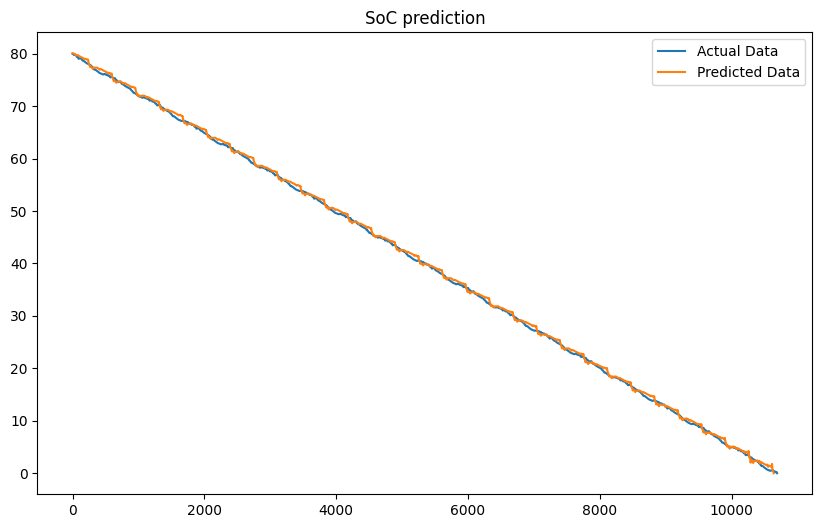

In [23]:
label_y = Y.data.numpy()

plt.figure(figsize=(10,6))
plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('SoC prediction')
#plt.xlim(0,2000)
plt.legend()
plt.show()